In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2021_off_processed.csv", low_memory=False)
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2022_off_processed.csv", low_memory=False)
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2023_off_processed.csv", low_memory=False)

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
breaking_ball = data.query('pitch_type_condensed in ("CH") & contact == 1')
breaking_ball_testing = testing_data.query('pitch_type_condensed in ("CH")')

# Fastball Model First

In [5]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'seasonal_avg_velo'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'Unnamed: 0', 'seasonal_avg_velo'
], axis=1)   # Exclude the identifier from the features

In [6]:
train_data = training_features.drop(['line_drive'], axis=1).copy()
train_label = training_features['line_drive'].copy()
testing_data = testing_features.drop(['line_drive'], axis=1).copy()
testing_label = testing_features['line_drive'].copy()

In [7]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'swing', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [8]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'swing', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [9]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [10]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [11]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.5415481359484953
Log Loss: 0.6746329859623157


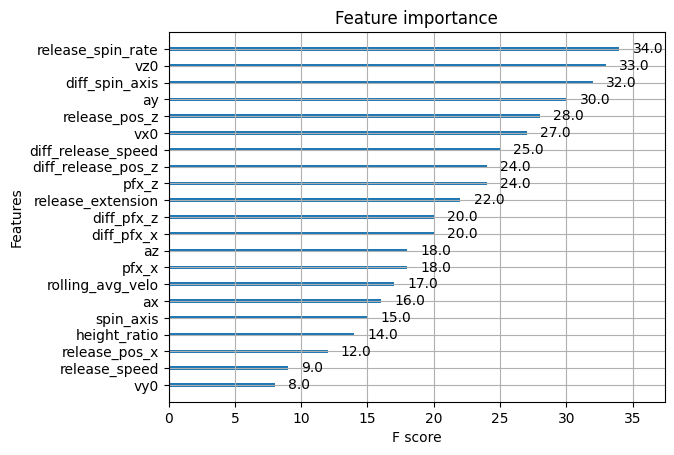

In [12]:
xgb.plot_importance(model)
plt.show()

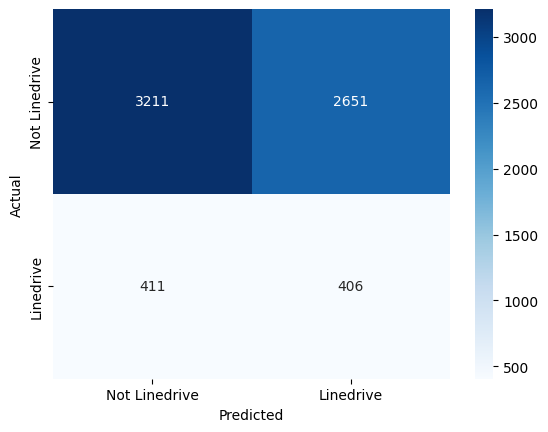

In [13]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Linedrive', 'Linedrive'], yticklabels=['Not Linedrive', 'Linedrive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [14]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio,
        'device': 'gpu',
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [15]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-16 17:01:57,530] A new study created in memory with name: no-name-373708bd-bb72-4685-b0fc-257333ddd87d


[0]	eval-logloss:0.68951
[1]	eval-logloss:0.68595
[2]	eval-logloss:0.68232
[3]	eval-logloss:0.68096
[4]	eval-logloss:0.67792
[5]	eval-logloss:0.67677
[6]	eval-logloss:0.67423
[7]	eval-logloss:0.67151
[8]	eval-logloss:0.66832
[9]	eval-logloss:0.66533
[10]	eval-logloss:0.66235
[11]	eval-logloss:0.66108
[12]	eval-logloss:0.65865
[13]	eval-logloss:0.65710
[14]	eval-logloss:0.65677


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:01:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[15]	eval-logloss:0.65506
[16]	eval-logloss:0.65292
[17]	eval-logloss:0.65110
[18]	eval-logloss:0.65027
[19]	eval-logloss:0.65007
[20]	eval-logloss:0.64893
[21]	eval-logloss:0.64627
[22]	eval-logloss:0.64644
[23]	eval-logloss:0.64484
[24]	eval-logloss:0.64252
[25]	eval-logloss:0.64103
[26]	eval-logloss:0.63935
[27]	eval-logloss:0.63758
[28]	eval-logloss:0.63718
[29]	eval-logloss:0.63545
[30]	eval-logloss:0.63448
[31]	eval-logloss:0.63374
[32]	eval-logloss:0.63240
[33]	eval-logloss:0.63147
[34]	eval-logloss:0.62993
[35]	eval-logloss:0.62757
[36]	eval-logloss:0.62682
[37]	eval-logloss:0.62553
[38]	eval-logloss:0.62520
[39]	eval-logloss:0.62280
[40]	eval-logloss:0.61972
[41]	eval-logloss:0.61879
[42]	eval-logloss:0.61705
[43]	eval-logloss:0.61472
[44]	eval-logloss:0.61327
[45]	eval-logloss:0.61250
[46]	eval-logloss:0.61226
[47]	eval-logloss:0.61143
[48]	eval-logloss:0.61041
[49]	eval-logloss:0.60978
[50]	eval-logloss:0.60964
[51]	eval-logloss:0.60880
[52]	eval-logloss:0.60746
[53]	eval-lo

[I 2023-11-16 17:01:58,305] Trial 0 finished with value: 0.5655978599029573 and parameters: {'max_depth': 6, 'eta': 0.1405112173019055, 'subsample': 0.7776018850476456, 'colsample_bytree': 0.7312997467429347}. Best is trial 0 with value: 0.5655978599029573.


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69166
[2]	eval-logloss:0.69076
[3]	eval-logloss:0.69118
[4]	eval-logloss:0.69074
[5]	eval-logloss:0.69062
[6]	eval-logloss:0.68994
[7]	eval-logloss:0.68970
[8]	eval-logloss:0.68926
[9]	eval-logloss:0.68882
[10]	eval-logloss:0.68817
[11]	eval-logloss:0.68788
[12]	eval-logloss:0.68703
[13]	eval-logloss:0.68617
[14]	eval-logloss:0.68639
[15]	eval-logloss:0.68611
[16]	eval-logloss:0.68612
[17]	eval-logloss:0.68540
[18]	eval-logloss:0.68523
[19]	eval-logloss:0.68535
[20]	eval-logloss:0.68459
[21]	eval-logloss:0.68400
[22]	eval-logloss:0.68419
[23]	eval-logloss:0.68348
[24]	eval-logloss:0.68321
[25]	eval-logloss:0.68280
[26]	eval-logloss:0.68255
[27]	eval-logloss:0.68232


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:01:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[28]	eval-logloss:0.68256
[29]	eval-logloss:0.68195
[30]	eval-logloss:0.68177
[31]	eval-logloss:0.68173
[32]	eval-logloss:0.68160
[33]	eval-logloss:0.68171
[34]	eval-logloss:0.68151
[35]	eval-logloss:0.68120
[36]	eval-logloss:0.68105
[37]	eval-logloss:0.68091
[38]	eval-logloss:0.68106
[39]	eval-logloss:0.68096
[40]	eval-logloss:0.68068
[41]	eval-logloss:0.68100
[42]	eval-logloss:0.68075
[43]	eval-logloss:0.67988
[44]	eval-logloss:0.67896
[45]	eval-logloss:0.67840
[46]	eval-logloss:0.67818
[47]	eval-logloss:0.67809
[48]	eval-logloss:0.67802
[49]	eval-logloss:0.67849
[50]	eval-logloss:0.67814
[51]	eval-logloss:0.67794
[52]	eval-logloss:0.67821
[53]	eval-logloss:0.67753
[54]	eval-logloss:0.67732
[55]	eval-logloss:0.67730
[56]	eval-logloss:0.67761
[57]	eval-logloss:0.67755
[58]	eval-logloss:0.67778
[59]	eval-logloss:0.67716
[60]	eval-logloss:0.67731
[61]	eval-logloss:0.67634
[62]	eval-logloss:0.67687
[63]	eval-logloss:0.67659
[64]	eval-logloss:0.67617
[65]	eval-logloss:0.67680
[66]	eval-lo

[I 2023-11-16 17:01:58,800] Trial 1 finished with value: 0.6713811663170303 and parameters: {'max_depth': 3, 'eta': 0.06883988726287643, 'subsample': 0.6841524512138853, 'colsample_bytree': 0.6682829807633668}. Best is trial 0 with value: 0.5655978599029573.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69124
[3]	eval-logloss:0.69140
[4]	eval-logloss:0.69044
[5]	eval-logloss:0.69021
[6]	eval-logloss:0.68951
[7]	eval-logloss:0.68877
[8]	eval-logloss:0.68811
[9]	eval-logloss:0.68743
[10]	eval-logloss:0.68675
[11]	eval-logloss:0.68646
[12]	eval-logloss:0.68513
[13]	eval-logloss:0.68419
[14]	eval-logloss:0.68436
[15]	eval-logloss:0.68416
[16]	eval-logloss:0.68407
[17]	eval-logloss:0.68343
[18]	eval-logloss:0.68296
[19]	eval-logloss:0.68340
[20]	eval-logloss:0.68271
[21]	eval-logloss:0.68226
[22]	eval-logloss:0.68247
[23]	eval-logloss:0.68175
[24]	eval-logloss:0.68111
[25]	eval-logloss:0.68037


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:01:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[26]	eval-logloss:0.67999
[27]	eval-logloss:0.67970
[28]	eval-logloss:0.67976
[29]	eval-logloss:0.67955
[30]	eval-logloss:0.67985
[31]	eval-logloss:0.67976
[32]	eval-logloss:0.67949
[33]	eval-logloss:0.67977
[34]	eval-logloss:0.67956
[35]	eval-logloss:0.67949
[36]	eval-logloss:0.67894
[37]	eval-logloss:0.67887
[38]	eval-logloss:0.67916
[39]	eval-logloss:0.67881
[40]	eval-logloss:0.67869
[41]	eval-logloss:0.67888
[42]	eval-logloss:0.67855
[43]	eval-logloss:0.67752
[44]	eval-logloss:0.67662
[45]	eval-logloss:0.67642
[46]	eval-logloss:0.67633
[47]	eval-logloss:0.67630
[48]	eval-logloss:0.67611
[49]	eval-logloss:0.67641
[50]	eval-logloss:0.67636
[51]	eval-logloss:0.67625
[52]	eval-logloss:0.67612
[53]	eval-logloss:0.67519
[54]	eval-logloss:0.67479
[55]	eval-logloss:0.67475
[56]	eval-logloss:0.67483
[57]	eval-logloss:0.67489
[58]	eval-logloss:0.67512
[59]	eval-logloss:0.67433
[60]	eval-logloss:0.67441
[61]	eval-logloss:0.67329
[62]	eval-logloss:0.67393
[63]	eval-logloss:0.67340
[64]	eval-lo

[I 2023-11-16 17:01:59,318] Trial 2 finished with value: 0.6685920110630275 and parameters: {'max_depth': 3, 'eta': 0.09008160647301731, 'subsample': 0.7322750001573219, 'colsample_bytree': 0.8526642032094021}. Best is trial 0 with value: 0.5655978599029573.


[0]	eval-logloss:0.68714
[1]	eval-logloss:0.68139
[2]	eval-logloss:0.67617
[3]	eval-logloss:0.67346
[4]	eval-logloss:0.66813
[5]	eval-logloss:0.66603
[6]	eval-logloss:0.66220
[7]	eval-logloss:0.65990
[8]	eval-logloss:0.65437
[9]	eval-logloss:0.65087
[10]	eval-logloss:0.64728


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:01:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[11]	eval-logloss:0.64402
[12]	eval-logloss:0.64093
[13]	eval-logloss:0.63855
[14]	eval-logloss:0.63685
[15]	eval-logloss:0.63516
[16]	eval-logloss:0.63198
[17]	eval-logloss:0.62958
[18]	eval-logloss:0.62920
[19]	eval-logloss:0.62863
[20]	eval-logloss:0.62736
[21]	eval-logloss:0.62295
[22]	eval-logloss:0.62026
[23]	eval-logloss:0.61705
[24]	eval-logloss:0.61548
[25]	eval-logloss:0.61428
[26]	eval-logloss:0.61155
[27]	eval-logloss:0.60793
[28]	eval-logloss:0.60596
[29]	eval-logloss:0.60326
[30]	eval-logloss:0.60106
[31]	eval-logloss:0.59947
[32]	eval-logloss:0.59658
[33]	eval-logloss:0.59458
[34]	eval-logloss:0.59353
[35]	eval-logloss:0.58982
[36]	eval-logloss:0.58786
[37]	eval-logloss:0.58763
[38]	eval-logloss:0.58689
[39]	eval-logloss:0.58572
[40]	eval-logloss:0.58255
[41]	eval-logloss:0.58031
[42]	eval-logloss:0.57899
[43]	eval-logloss:0.57623
[44]	eval-logloss:0.57453
[45]	eval-logloss:0.57179
[46]	eval-logloss:0.56974
[47]	eval-logloss:0.56829
[48]	eval-logloss:0.56776
[49]	eval-lo

[I 2023-11-16 17:02:00,320] Trial 3 finished with value: 0.5040916423826911 and parameters: {'max_depth': 8, 'eta': 0.1138340833852901, 'subsample': 0.7886982545055911, 'colsample_bytree': 0.7503314764851918}. Best is trial 3 with value: 0.5040916423826911.


[0]	eval-logloss:0.69109
[1]	eval-logloss:0.68932
[2]	eval-logloss:0.68572
[3]	eval-logloss:0.68608
[4]	eval-logloss:0.68334
[5]	eval-logloss:0.68253
[6]	eval-logloss:0.67932
[7]	eval-logloss:0.67817
[8]	eval-logloss:0.67772
[9]	eval-logloss:0.67623
[10]	eval-logloss:0.67419
[11]	eval-logloss:0.67483
[12]	eval-logloss:0.67160
[13]	eval-logloss:0.66993
[14]	eval-logloss:0.67160
[15]	eval-logloss:0.67132
[16]	eval-logloss:0.67022
[17]	eval-logloss:0.66811
[18]	eval-logloss:0.66736
[19]	eval-logloss:0.66814
[20]	eval-logloss:0.66685
[21]	eval-logloss:0.66582


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[22]	eval-logloss:0.66527
[23]	eval-logloss:0.66257
[24]	eval-logloss:0.66036
[25]	eval-logloss:0.65896
[26]	eval-logloss:0.65754
[27]	eval-logloss:0.65499
[28]	eval-logloss:0.65642
[29]	eval-logloss:0.65538
[30]	eval-logloss:0.65571
[31]	eval-logloss:0.65406
[32]	eval-logloss:0.65384
[33]	eval-logloss:0.65408
[34]	eval-logloss:0.65322
[35]	eval-logloss:0.65253
[36]	eval-logloss:0.65130
[37]	eval-logloss:0.65150
[38]	eval-logloss:0.65269
[39]	eval-logloss:0.65089
[40]	eval-logloss:0.65018
[41]	eval-logloss:0.65133
[42]	eval-logloss:0.65128
[43]	eval-logloss:0.64823
[44]	eval-logloss:0.64623
[45]	eval-logloss:0.64686
[46]	eval-logloss:0.64625
[47]	eval-logloss:0.64496
[48]	eval-logloss:0.64555
[49]	eval-logloss:0.64680
[50]	eval-logloss:0.64626
[51]	eval-logloss:0.64588
[52]	eval-logloss:0.64607
[53]	eval-logloss:0.64321
[54]	eval-logloss:0.64155
[55]	eval-logloss:0.64101
[56]	eval-logloss:0.64200
[57]	eval-logloss:0.64191
[58]	eval-logloss:0.64185
[59]	eval-logloss:0.64018
[60]	eval-lo

[I 2023-11-16 17:02:00,893] Trial 4 finished with value: 0.6237207406323403 and parameters: {'max_depth': 4, 'eta': 0.2755030083860039, 'subsample': 0.7245837576767242, 'colsample_bytree': 0.8507488699933332}. Best is trial 3 with value: 0.5040916423826911.


[0]	eval-logloss:0.69153
[1]	eval-logloss:0.69055
[2]	eval-logloss:0.68854
[3]	eval-logloss:0.68892
[4]	eval-logloss:0.68968
[5]	eval-logloss:0.68986
[6]	eval-logloss:0.68718
[7]	eval-logloss:0.68523
[8]	eval-logloss:0.68335
[9]	eval-logloss:0.68343
[10]	eval-logloss:0.68253
[11]	eval-logloss:0.68067
[12]	eval-logloss:0.67933
[13]	eval-logloss:0.67896
[14]	eval-logloss:0.67947
[15]	eval-logloss:0.67847
[16]	eval-logloss:0.67924
[17]	eval-logloss:0.67735
[18]	eval-logloss:0.67721
[19]	eval-logloss:0.67730
[20]	eval-logloss:0.67683
[21]	eval-logloss:0.67564
[22]	eval-logloss:0.67535
[23]	eval-logloss:0.67383
[24]	eval-logloss:0.67402
[25]	eval-logloss:0.67304
[26]	eval-logloss:0.67162
[27]	eval-logloss:0.67150


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[28]	eval-logloss:0.67193
[29]	eval-logloss:0.67015
[30]	eval-logloss:0.67049
[31]	eval-logloss:0.66939
[32]	eval-logloss:0.66939
[33]	eval-logloss:0.67022
[34]	eval-logloss:0.66915
[35]	eval-logloss:0.66905
[36]	eval-logloss:0.66959
[37]	eval-logloss:0.66930
[38]	eval-logloss:0.66946
[39]	eval-logloss:0.66751
[40]	eval-logloss:0.66665
[41]	eval-logloss:0.66690
[42]	eval-logloss:0.66591
[43]	eval-logloss:0.66369
[44]	eval-logloss:0.66329
[45]	eval-logloss:0.66328
[46]	eval-logloss:0.66453
[47]	eval-logloss:0.66410
[48]	eval-logloss:0.66317
[49]	eval-logloss:0.66374
[50]	eval-logloss:0.66341
[51]	eval-logloss:0.66316
[52]	eval-logloss:0.66402
[53]	eval-logloss:0.66162
[54]	eval-logloss:0.66090
[55]	eval-logloss:0.65967
[56]	eval-logloss:0.66016
[57]	eval-logloss:0.66053
[58]	eval-logloss:0.65990
[59]	eval-logloss:0.65768
[60]	eval-logloss:0.65699
[61]	eval-logloss:0.65512
[62]	eval-logloss:0.65686
[63]	eval-logloss:0.65578
[64]	eval-logloss:0.65657
[65]	eval-logloss:0.65686
[66]	eval-lo

[I 2023-11-16 17:02:01,391] Trial 5 finished with value: 0.6450271696895711 and parameters: {'max_depth': 3, 'eta': 0.259181867507898, 'subsample': 0.8335093622629446, 'colsample_bytree': 0.7268648172796768}. Best is trial 3 with value: 0.5040916423826911.


[0]	eval-logloss:0.69049
[1]	eval-logloss:0.68724
[2]	eval-logloss:0.68455
[3]	eval-logloss:0.68383
[4]	eval-logloss:0.68239
[5]	eval-logloss:0.68117
[6]	eval-logloss:0.67814
[7]	eval-logloss:0.67623
[8]	eval-logloss:0.67415
[9]	eval-logloss:0.67252
[10]	eval-logloss:0.66997
[11]	eval-logloss:0.66912
[12]	eval-logloss:0.66807
[13]	eval-logloss:0.66683
[14]	eval-logloss:0.66619
[15]	eval-logloss:0.66489
[16]	eval-logloss:0.66270
[17]	eval-logloss:0.66088
[18]	eval-logloss:0.66075
[19]	eval-logloss:0.65994


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[20]	eval-logloss:0.65833
[21]	eval-logloss:0.65792
[22]	eval-logloss:0.65615
[23]	eval-logloss:0.65443
[24]	eval-logloss:0.65291
[25]	eval-logloss:0.65220
[26]	eval-logloss:0.65099
[27]	eval-logloss:0.65077
[28]	eval-logloss:0.64978
[29]	eval-logloss:0.64832
[30]	eval-logloss:0.64809
[31]	eval-logloss:0.64695
[32]	eval-logloss:0.64592
[33]	eval-logloss:0.64543
[34]	eval-logloss:0.64408
[35]	eval-logloss:0.64313
[36]	eval-logloss:0.64238
[37]	eval-logloss:0.64186
[38]	eval-logloss:0.64119
[39]	eval-logloss:0.63956
[40]	eval-logloss:0.63881
[41]	eval-logloss:0.63754
[42]	eval-logloss:0.63686
[43]	eval-logloss:0.63514
[44]	eval-logloss:0.63437
[45]	eval-logloss:0.63425
[46]	eval-logloss:0.63478
[47]	eval-logloss:0.63408
[48]	eval-logloss:0.63326
[49]	eval-logloss:0.63231
[50]	eval-logloss:0.63063
[51]	eval-logloss:0.62953
[52]	eval-logloss:0.62969
[53]	eval-logloss:0.62800
[54]	eval-logloss:0.62629
[55]	eval-logloss:0.62497
[56]	eval-logloss:0.62393
[57]	eval-logloss:0.62291
[58]	eval-lo

[I 2023-11-16 17:02:02,151] Trial 6 finished with value: 0.5920223496285502 and parameters: {'max_depth': 5, 'eta': 0.175897247140811, 'subsample': 0.8838993694293084, 'colsample_bytree': 0.9451119030389663}. Best is trial 3 with value: 0.5040916423826911.


[0]	eval-logloss:0.69044
[1]	eval-logloss:0.68730
[2]	eval-logloss:0.68477
[3]	eval-logloss:0.68304
[4]	eval-logloss:0.68056
[5]	eval-logloss:0.67890
[6]	eval-logloss:0.67592
[7]	eval-logloss:0.67441
[8]	eval-logloss:0.67207
[9]	eval-logloss:0.67037
[10]	eval-logloss:0.66702
[11]	eval-logloss:0.66528


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[12]	eval-logloss:0.66296
[13]	eval-logloss:0.66076
[14]	eval-logloss:0.65967
[15]	eval-logloss:0.65671
[16]	eval-logloss:0.65609
[17]	eval-logloss:0.65376
[18]	eval-logloss:0.65271
[19]	eval-logloss:0.65078
[20]	eval-logloss:0.64995
[21]	eval-logloss:0.64818
[22]	eval-logloss:0.64710
[23]	eval-logloss:0.64520
[24]	eval-logloss:0.64344
[25]	eval-logloss:0.64299
[26]	eval-logloss:0.64210
[27]	eval-logloss:0.64041
[28]	eval-logloss:0.64005
[29]	eval-logloss:0.63839
[30]	eval-logloss:0.63728
[31]	eval-logloss:0.63688
[32]	eval-logloss:0.63616
[33]	eval-logloss:0.63481
[34]	eval-logloss:0.63371
[35]	eval-logloss:0.63277
[36]	eval-logloss:0.63198
[37]	eval-logloss:0.63061
[38]	eval-logloss:0.63039
[39]	eval-logloss:0.62942
[40]	eval-logloss:0.62804
[41]	eval-logloss:0.62752
[42]	eval-logloss:0.62616
[43]	eval-logloss:0.62508
[44]	eval-logloss:0.62434
[45]	eval-logloss:0.62266
[46]	eval-logloss:0.62222
[47]	eval-logloss:0.62153
[48]	eval-logloss:0.62132
[49]	eval-logloss:0.62066
[50]	eval-lo

[I 2023-11-16 17:02:03,204] Trial 7 finished with value: 0.5792655313523325 and parameters: {'max_depth': 7, 'eta': 0.06863696196928008, 'subsample': 0.6688349198847934, 'colsample_bytree': 0.8807597286392435}. Best is trial 3 with value: 0.5040916423826911.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69067
[3]	eval-logloss:0.69016
[4]	eval-logloss:0.68909
[5]	eval-logloss:0.68858
[6]	eval-logloss:0.68801
[7]	eval-logloss:0.68731
[8]	eval-logloss:0.68656
[9]	eval-logloss:0.68584
[10]	eval-logloss:0.68489
[11]	eval-logloss:0.68404
[12]	eval-logloss:0.68285
[13]	eval-logloss:0.68203
[14]	eval-logloss:0.68166
[15]	eval-logloss:0.68126
[16]	eval-logloss:0.68097
[17]	eval-logloss:0.68022
[18]	eval-logloss:0.67950
[19]	eval-logloss:0.67918


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[20]	eval-logloss:0.67854
[21]	eval-logloss:0.67808
[22]	eval-logloss:0.67793
[23]	eval-logloss:0.67710
[24]	eval-logloss:0.67647
[25]	eval-logloss:0.67603
[26]	eval-logloss:0.67548
[27]	eval-logloss:0.67485
[28]	eval-logloss:0.67425
[29]	eval-logloss:0.67358
[30]	eval-logloss:0.67341
[31]	eval-logloss:0.67313
[32]	eval-logloss:0.67264
[33]	eval-logloss:0.67267
[34]	eval-logloss:0.67239
[35]	eval-logloss:0.67160
[36]	eval-logloss:0.67109
[37]	eval-logloss:0.67076
[38]	eval-logloss:0.67059
[39]	eval-logloss:0.67019
[40]	eval-logloss:0.66948
[41]	eval-logloss:0.66940
[42]	eval-logloss:0.66927
[43]	eval-logloss:0.66851
[44]	eval-logloss:0.66770
[45]	eval-logloss:0.66721
[46]	eval-logloss:0.66673
[47]	eval-logloss:0.66646
[48]	eval-logloss:0.66589
[49]	eval-logloss:0.66575
[50]	eval-logloss:0.66550
[51]	eval-logloss:0.66539
[52]	eval-logloss:0.66499
[53]	eval-logloss:0.66418
[54]	eval-logloss:0.66383
[55]	eval-logloss:0.66368
[56]	eval-logloss:0.66361
[57]	eval-logloss:0.66332
[58]	eval-lo

[I 2023-11-16 17:02:03,832] Trial 8 finished with value: 0.6514833673297704 and parameters: {'max_depth': 5, 'eta': 0.04140791327566696, 'subsample': 0.7164950422008025, 'colsample_bytree': 0.7150816177470694}. Best is trial 3 with value: 0.5040916423826911.


[0]	eval-logloss:0.67722
[1]	eval-logloss:0.66279
[2]	eval-logloss:0.65877
[3]	eval-logloss:0.65385
[4]	eval-logloss:0.64626
[5]	eval-logloss:0.63580


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.62463
[7]	eval-logloss:0.61985
[8]	eval-logloss:0.61722
[9]	eval-logloss:0.61057
[10]	eval-logloss:0.60663
[11]	eval-logloss:0.60058
[12]	eval-logloss:0.59702
[13]	eval-logloss:0.59370
[14]	eval-logloss:0.58856
[15]	eval-logloss:0.58615
[16]	eval-logloss:0.58463
[17]	eval-logloss:0.57957
[18]	eval-logloss:0.57078
[19]	eval-logloss:0.57035
[20]	eval-logloss:0.56359
[21]	eval-logloss:0.56282
[22]	eval-logloss:0.56062
[23]	eval-logloss:0.55664
[24]	eval-logloss:0.54744
[25]	eval-logloss:0.54282
[26]	eval-logloss:0.54082
[27]	eval-logloss:0.53433
[28]	eval-logloss:0.53638
[29]	eval-logloss:0.53162
[30]	eval-logloss:0.52760
[31]	eval-logloss:0.52393
[32]	eval-logloss:0.52339
[33]	eval-logloss:0.52002
[34]	eval-logloss:0.51722
[35]	eval-logloss:0.51492
[36]	eval-logloss:0.51299
[37]	eval-logloss:0.51138
[38]	eval-logloss:0.51154
[39]	eval-logloss:0.50916
[40]	eval-logloss:0.50752
[41]	eval-logloss:0.50424
[42]	eval-logloss:0.50042
[43]	eval-logloss:0.49973
[44]	eval-loglos

[I 2023-11-16 17:02:05,182] Trial 9 finished with value: 0.487146718762685 and parameters: {'max_depth': 9, 'eta': 0.2758254369417055, 'subsample': 0.6359994374875212, 'colsample_bytree': 0.6966167634596234}. Best is trial 9 with value: 0.487146718762685.


[0]	eval-logloss:0.68068
[1]	eval-logloss:0.66628
[2]	eval-logloss:0.66047
[3]	eval-logloss:0.65374
[4]	eval-logloss:0.64701


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64514
[6]	eval-logloss:0.63157
[7]	eval-logloss:0.62894
[8]	eval-logloss:0.62119
[9]	eval-logloss:0.61532
[10]	eval-logloss:0.60928
[11]	eval-logloss:0.60497
[12]	eval-logloss:0.59844
[13]	eval-logloss:0.59391
[14]	eval-logloss:0.59347
[15]	eval-logloss:0.58985
[16]	eval-logloss:0.59092
[17]	eval-logloss:0.58558
[18]	eval-logloss:0.58040
[19]	eval-logloss:0.57781
[20]	eval-logloss:0.57605
[21]	eval-logloss:0.57354
[22]	eval-logloss:0.57312
[23]	eval-logloss:0.57084
[24]	eval-logloss:0.56683
[25]	eval-logloss:0.56419
[26]	eval-logloss:0.56229
[27]	eval-logloss:0.55648
[28]	eval-logloss:0.55598
[29]	eval-logloss:0.55012
[30]	eval-logloss:0.54583
[31]	eval-logloss:0.54369
[32]	eval-logloss:0.54026
[33]	eval-logloss:0.53812
[34]	eval-logloss:0.53759
[35]	eval-logloss:0.53297
[36]	eval-logloss:0.53066
[37]	eval-logloss:0.52845
[38]	eval-logloss:0.52908
[39]	eval-logloss:0.52691
[40]	eval-logloss:0.52534
[41]	eval-logloss:0.52021
[42]	eval-logloss:0.51895
[43]	eval-logloss

[I 2023-11-16 17:02:06,764] Trial 10 finished with value: 0.4649835118503139 and parameters: {'max_depth': 9, 'eta': 0.20891214327115074, 'subsample': 0.6050180973102233, 'colsample_bytree': 0.5093451077939635}. Best is trial 10 with value: 0.4649835118503139.


[0]	eval-logloss:0.68099
[1]	eval-logloss:0.66615
[2]	eval-logloss:0.66134
[3]	eval-logloss:0.65428
[4]	eval-logloss:0.64777
[5]	eval-logloss:0.64583
[6]	eval-logloss:0.63385


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.62691
[8]	eval-logloss:0.62221
[9]	eval-logloss:0.61863
[10]	eval-logloss:0.61436
[11]	eval-logloss:0.60963
[12]	eval-logloss:0.60565
[13]	eval-logloss:0.59858
[14]	eval-logloss:0.59930
[15]	eval-logloss:0.59348
[16]	eval-logloss:0.58968
[17]	eval-logloss:0.57888
[18]	eval-logloss:0.57292
[19]	eval-logloss:0.57289
[20]	eval-logloss:0.56744
[21]	eval-logloss:0.56361
[22]	eval-logloss:0.56486
[23]	eval-logloss:0.55670
[24]	eval-logloss:0.55242
[25]	eval-logloss:0.54517
[26]	eval-logloss:0.54297
[27]	eval-logloss:0.53986
[28]	eval-logloss:0.53880
[29]	eval-logloss:0.53561
[30]	eval-logloss:0.53406
[31]	eval-logloss:0.53138
[32]	eval-logloss:0.52912
[33]	eval-logloss:0.52757
[34]	eval-logloss:0.52736
[35]	eval-logloss:0.52710
[36]	eval-logloss:0.52512
[37]	eval-logloss:0.52220
[38]	eval-logloss:0.52174
[39]	eval-logloss:0.52122
[40]	eval-logloss:0.52042
[41]	eval-logloss:0.51557
[42]	eval-logloss:0.51192
[43]	eval-logloss:0.50795
[44]	eval-logloss:0.50335
[45]	eval-loglo

[I 2023-11-16 17:02:07,999] Trial 11 finished with value: 0.46980800489922314 and parameters: {'max_depth': 9, 'eta': 0.22378774863287912, 'subsample': 0.6005290690741707, 'colsample_bytree': 0.5023017228730948}. Best is trial 10 with value: 0.4649835118503139.


[0]	eval-logloss:0.68056
[1]	eval-logloss:0.66627
[2]	eval-logloss:0.66117
[3]	eval-logloss:0.65753
[4]	eval-logloss:0.65256
[5]	eval-logloss:0.64744
[6]	eval-logloss:0.63608


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.63380
[8]	eval-logloss:0.62866
[9]	eval-logloss:0.62619
[10]	eval-logloss:0.61821
[11]	eval-logloss:0.61233
[12]	eval-logloss:0.60595
[13]	eval-logloss:0.60071
[14]	eval-logloss:0.59767
[15]	eval-logloss:0.59529
[16]	eval-logloss:0.59205
[17]	eval-logloss:0.57918
[18]	eval-logloss:0.57408
[19]	eval-logloss:0.57047
[20]	eval-logloss:0.56678
[21]	eval-logloss:0.56708
[22]	eval-logloss:0.56776
[23]	eval-logloss:0.56442
[24]	eval-logloss:0.56043
[25]	eval-logloss:0.55515
[26]	eval-logloss:0.55136
[27]	eval-logloss:0.54560
[28]	eval-logloss:0.54479
[29]	eval-logloss:0.54422
[30]	eval-logloss:0.54346
[31]	eval-logloss:0.54066
[32]	eval-logloss:0.53693
[33]	eval-logloss:0.53416
[34]	eval-logloss:0.53282
[35]	eval-logloss:0.52960
[36]	eval-logloss:0.52946
[37]	eval-logloss:0.52823
[38]	eval-logloss:0.52610
[39]	eval-logloss:0.52421
[40]	eval-logloss:0.52224
[41]	eval-logloss:0.51875
[42]	eval-logloss:0.51841
[43]	eval-logloss:0.51419
[44]	eval-logloss:0.51150
[45]	eval-loglo

[I 2023-11-16 17:02:09,190] Trial 12 finished with value: 0.465584962602233 and parameters: {'max_depth': 9, 'eta': 0.20969765786529826, 'subsample': 0.6044434924346093, 'colsample_bytree': 0.5008479422358432}. Best is trial 10 with value: 0.4649835118503139.


[0]	eval-logloss:0.68336
[1]	eval-logloss:0.67357
[2]	eval-logloss:0.66815
[3]	eval-logloss:0.66282
[4]	eval-logloss:0.65646
[5]	eval-logloss:0.65440
[6]	eval-logloss:0.64739
[7]	eval-logloss:0.64263
[8]	eval-logloss:0.63826
[9]	eval-logloss:0.63606


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[10]	eval-logloss:0.63276
[11]	eval-logloss:0.62882
[12]	eval-logloss:0.62168
[13]	eval-logloss:0.61756
[14]	eval-logloss:0.61847
[15]	eval-logloss:0.61191
[16]	eval-logloss:0.61184
[17]	eval-logloss:0.60759
[18]	eval-logloss:0.60361
[19]	eval-logloss:0.60115
[20]	eval-logloss:0.59883
[21]	eval-logloss:0.59603
[22]	eval-logloss:0.59601
[23]	eval-logloss:0.59300
[24]	eval-logloss:0.59109
[25]	eval-logloss:0.58798
[26]	eval-logloss:0.58689
[27]	eval-logloss:0.58306
[28]	eval-logloss:0.58413
[29]	eval-logloss:0.58044
[30]	eval-logloss:0.57854
[31]	eval-logloss:0.57936
[32]	eval-logloss:0.57484
[33]	eval-logloss:0.57266
[34]	eval-logloss:0.57010
[35]	eval-logloss:0.56675
[36]	eval-logloss:0.56344
[37]	eval-logloss:0.56091
[38]	eval-logloss:0.56008
[39]	eval-logloss:0.55982
[40]	eval-logloss:0.55810
[41]	eval-logloss:0.55643
[42]	eval-logloss:0.55354
[43]	eval-logloss:0.54902
[44]	eval-logloss:0.54650
[45]	eval-logloss:0.54594
[46]	eval-logloss:0.54529
[47]	eval-logloss:0.54408
[48]	eval-lo

[I 2023-11-16 17:02:10,339] Trial 13 finished with value: 0.4911393867879607 and parameters: {'max_depth': 8, 'eta': 0.19717216704898397, 'subsample': 0.6055559548495358, 'colsample_bytree': 0.5169995584506665}. Best is trial 10 with value: 0.4649835118503139.


[0]	eval-logloss:0.68372
[1]	eval-logloss:0.67237
[2]	eval-logloss:0.66651
[3]	eval-logloss:0.66511
[4]	eval-logloss:0.65795
[5]	eval-logloss:0.65237


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.64588
[7]	eval-logloss:0.64175
[8]	eval-logloss:0.63603
[9]	eval-logloss:0.62980
[10]	eval-logloss:0.62490
[11]	eval-logloss:0.62390
[12]	eval-logloss:0.61739
[13]	eval-logloss:0.61452
[14]	eval-logloss:0.61517
[15]	eval-logloss:0.61182
[16]	eval-logloss:0.60933
[17]	eval-logloss:0.60482
[18]	eval-logloss:0.60121
[19]	eval-logloss:0.59888
[20]	eval-logloss:0.59472
[21]	eval-logloss:0.58996
[22]	eval-logloss:0.58956
[23]	eval-logloss:0.58462
[24]	eval-logloss:0.58398
[25]	eval-logloss:0.58425
[26]	eval-logloss:0.58314
[27]	eval-logloss:0.58098
[28]	eval-logloss:0.58101
[29]	eval-logloss:0.57819
[30]	eval-logloss:0.57579
[31]	eval-logloss:0.57380
[32]	eval-logloss:0.57246
[33]	eval-logloss:0.57051
[34]	eval-logloss:0.56704
[35]	eval-logloss:0.56551
[36]	eval-logloss:0.56137
[37]	eval-logloss:0.55979
[38]	eval-logloss:0.55778
[39]	eval-logloss:0.55684
[40]	eval-logloss:0.55291
[41]	eval-logloss:0.55107
[42]	eval-logloss:0.54941
[43]	eval-logloss:0.54722
[44]	eval-loglos

[I 2023-11-16 17:02:11,342] Trial 14 finished with value: 0.482006485791352 and parameters: {'max_depth': 8, 'eta': 0.21960444308025628, 'subsample': 0.649502904000271, 'colsample_bytree': 0.5754290925673516}. Best is trial 10 with value: 0.4649835118503139.


[0]	eval-logloss:0.68336
[1]	eval-logloss:0.67331
[2]	eval-logloss:0.66662
[3]	eval-logloss:0.66011
[4]	eval-logloss:0.65126


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64272
[6]	eval-logloss:0.63872
[7]	eval-logloss:0.63360
[8]	eval-logloss:0.63066
[9]	eval-logloss:0.62508
[10]	eval-logloss:0.61789
[11]	eval-logloss:0.61332
[12]	eval-logloss:0.61078
[13]	eval-logloss:0.60838
[14]	eval-logloss:0.60302
[15]	eval-logloss:0.60290
[16]	eval-logloss:0.59849
[17]	eval-logloss:0.59303
[18]	eval-logloss:0.59101
[19]	eval-logloss:0.58419
[20]	eval-logloss:0.58048
[21]	eval-logloss:0.58028
[22]	eval-logloss:0.57816
[23]	eval-logloss:0.57566
[24]	eval-logloss:0.57224
[25]	eval-logloss:0.57096
[26]	eval-logloss:0.56815
[27]	eval-logloss:0.56594
[28]	eval-logloss:0.56582
[29]	eval-logloss:0.56162
[30]	eval-logloss:0.56115
[31]	eval-logloss:0.55735
[32]	eval-logloss:0.55471
[33]	eval-logloss:0.54940
[34]	eval-logloss:0.54872
[35]	eval-logloss:0.54785
[36]	eval-logloss:0.54461
[37]	eval-logloss:0.54099
[38]	eval-logloss:0.53999
[39]	eval-logloss:0.53949
[40]	eval-logloss:0.53624
[41]	eval-logloss:0.53348
[42]	eval-logloss:0.53080
[43]	eval-logloss

[I 2023-11-16 17:02:12,628] Trial 15 finished with value: 0.465956961530137 and parameters: {'max_depth': 9, 'eta': 0.15671533633417006, 'subsample': 0.6371512994556079, 'colsample_bytree': 0.5765612051441655}. Best is trial 10 with value: 0.4649835118503139.


[0]	eval-logloss:0.68328
[1]	eval-logloss:0.67696
[2]	eval-logloss:0.67078
[3]	eval-logloss:0.66816
[4]	eval-logloss:0.66326
[5]	eval-logloss:0.65883
[6]	eval-logloss:0.65495
[7]	eval-logloss:0.65229
[8]	eval-logloss:0.65114
[9]	eval-logloss:0.64839
[10]	eval-logloss:0.64383
[11]	eval-logloss:0.64385
[12]	eval-logloss:0.63714


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[13]	eval-logloss:0.63368
[14]	eval-logloss:0.63435
[15]	eval-logloss:0.63232
[16]	eval-logloss:0.63251
[17]	eval-logloss:0.62744
[18]	eval-logloss:0.62578
[19]	eval-logloss:0.62633
[20]	eval-logloss:0.62301
[21]	eval-logloss:0.61835
[22]	eval-logloss:0.61964
[23]	eval-logloss:0.61516
[24]	eval-logloss:0.61257
[25]	eval-logloss:0.61079
[26]	eval-logloss:0.61097
[27]	eval-logloss:0.60740
[28]	eval-logloss:0.60703
[29]	eval-logloss:0.60549
[30]	eval-logloss:0.60309
[31]	eval-logloss:0.60134
[32]	eval-logloss:0.60101
[33]	eval-logloss:0.59829
[34]	eval-logloss:0.59604
[35]	eval-logloss:0.59370
[36]	eval-logloss:0.58918
[37]	eval-logloss:0.58601
[38]	eval-logloss:0.58553
[39]	eval-logloss:0.58300
[40]	eval-logloss:0.58000
[41]	eval-logloss:0.57946
[42]	eval-logloss:0.57796
[43]	eval-logloss:0.57407
[44]	eval-logloss:0.57222
[45]	eval-logloss:0.57072
[46]	eval-logloss:0.56858
[47]	eval-logloss:0.56709
[48]	eval-logloss:0.56442
[49]	eval-logloss:0.56553
[50]	eval-logloss:0.56301
[51]	eval-lo

[I 2023-11-16 17:02:13,773] Trial 16 finished with value: 0.5070786159459506 and parameters: {'max_depth': 7, 'eta': 0.2365874845729762, 'subsample': 0.6898638890862813, 'colsample_bytree': 0.5922531423281929}. Best is trial 10 with value: 0.4649835118503139.


[0]	eval-logloss:0.68464
[1]	eval-logloss:0.67660
[2]	eval-logloss:0.67038
[3]	eval-logloss:0.66996
[4]	eval-logloss:0.66628
[5]	eval-logloss:0.66546
[6]	eval-logloss:0.65655
[7]	eval-logloss:0.65331
[8]	eval-logloss:0.64600
[9]	eval-logloss:0.64065


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[10]	eval-logloss:0.63546
[11]	eval-logloss:0.63270
[12]	eval-logloss:0.62840
[13]	eval-logloss:0.62440
[14]	eval-logloss:0.62612
[15]	eval-logloss:0.62469
[16]	eval-logloss:0.62446
[17]	eval-logloss:0.61453
[18]	eval-logloss:0.61446
[19]	eval-logloss:0.61238
[20]	eval-logloss:0.60939
[21]	eval-logloss:0.60554
[22]	eval-logloss:0.60705
[23]	eval-logloss:0.60538
[24]	eval-logloss:0.60330
[25]	eval-logloss:0.59914
[26]	eval-logloss:0.59859
[27]	eval-logloss:0.59712
[28]	eval-logloss:0.59956
[29]	eval-logloss:0.59438
[30]	eval-logloss:0.59299
[31]	eval-logloss:0.59196
[32]	eval-logloss:0.58988
[33]	eval-logloss:0.58848
[34]	eval-logloss:0.58786
[35]	eval-logloss:0.58524
[36]	eval-logloss:0.58225
[37]	eval-logloss:0.57985
[38]	eval-logloss:0.57758
[39]	eval-logloss:0.57570
[40]	eval-logloss:0.57360
[41]	eval-logloss:0.57318
[42]	eval-logloss:0.57380
[43]	eval-logloss:0.57243
[44]	eval-logloss:0.56843
[45]	eval-logloss:0.56648
[46]	eval-logloss:0.56620
[47]	eval-logloss:0.56625
[48]	eval-lo

[I 2023-11-16 17:02:14,628] Trial 17 finished with value: 0.5206392603733606 and parameters: {'max_depth': 7, 'eta': 0.2931158479989795, 'subsample': 0.6001828101666226, 'colsample_bytree': 0.5052286360004715}. Best is trial 10 with value: 0.4649835118503139.


[0]	eval-logloss:0.68118
[1]	eval-logloss:0.66968
[2]	eval-logloss:0.66177
[3]	eval-logloss:0.65753
[4]	eval-logloss:0.64800


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64214
[6]	eval-logloss:0.63446
[7]	eval-logloss:0.62983
[8]	eval-logloss:0.62524
[9]	eval-logloss:0.62251
[10]	eval-logloss:0.61106
[11]	eval-logloss:0.60597
[12]	eval-logloss:0.60444
[13]	eval-logloss:0.60167
[14]	eval-logloss:0.59747
[15]	eval-logloss:0.59802
[16]	eval-logloss:0.59445
[17]	eval-logloss:0.59068
[18]	eval-logloss:0.58531
[19]	eval-logloss:0.58407
[20]	eval-logloss:0.58141
[21]	eval-logloss:0.57621
[22]	eval-logloss:0.57508
[23]	eval-logloss:0.57220
[24]	eval-logloss:0.57145
[25]	eval-logloss:0.56726
[26]	eval-logloss:0.56553
[27]	eval-logloss:0.56109
[28]	eval-logloss:0.56165
[29]	eval-logloss:0.55809
[30]	eval-logloss:0.55533
[31]	eval-logloss:0.55182
[32]	eval-logloss:0.54863
[33]	eval-logloss:0.54676
[34]	eval-logloss:0.54260
[35]	eval-logloss:0.53836
[36]	eval-logloss:0.53757
[37]	eval-logloss:0.53505
[38]	eval-logloss:0.53330
[39]	eval-logloss:0.53210
[40]	eval-logloss:0.52981
[41]	eval-logloss:0.52578
[42]	eval-logloss:0.52146
[43]	eval-logloss

[I 2023-11-16 17:02:15,917] Trial 18 finished with value: 0.4575034618260628 and parameters: {'max_depth': 9, 'eta': 0.1916302600652872, 'subsample': 0.6376286184879041, 'colsample_bytree': 0.6363725484144593}. Best is trial 18 with value: 0.4575034618260628.


[0]	eval-logloss:0.68393
[1]	eval-logloss:0.67455
[2]	eval-logloss:0.67093
[3]	eval-logloss:0.66787
[4]	eval-logloss:0.65929
[5]	eval-logloss:0.65427
[6]	eval-logloss:0.64979
[7]	eval-logloss:0.64643


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.64175
[9]	eval-logloss:0.63801
[10]	eval-logloss:0.63136
[11]	eval-logloss:0.62894
[12]	eval-logloss:0.62417
[13]	eval-logloss:0.61929
[14]	eval-logloss:0.61995
[15]	eval-logloss:0.61698
[16]	eval-logloss:0.61316
[17]	eval-logloss:0.60772
[18]	eval-logloss:0.60353
[19]	eval-logloss:0.60321
[20]	eval-logloss:0.60250
[21]	eval-logloss:0.60130
[22]	eval-logloss:0.60078
[23]	eval-logloss:0.59736
[24]	eval-logloss:0.59440
[25]	eval-logloss:0.59142
[26]	eval-logloss:0.58878
[27]	eval-logloss:0.58698
[28]	eval-logloss:0.58557
[29]	eval-logloss:0.58368
[30]	eval-logloss:0.57951
[31]	eval-logloss:0.57642
[32]	eval-logloss:0.57220
[33]	eval-logloss:0.57255
[34]	eval-logloss:0.57091
[35]	eval-logloss:0.56924
[36]	eval-logloss:0.56766
[37]	eval-logloss:0.56667
[38]	eval-logloss:0.56329
[39]	eval-logloss:0.55945
[40]	eval-logloss:0.55628
[41]	eval-logloss:0.55323
[42]	eval-logloss:0.55070
[43]	eval-logloss:0.54895
[44]	eval-logloss:0.54807
[45]	eval-logloss:0.54630
[46]	eval-logl

[I 2023-11-16 17:02:17,203] Trial 19 finished with value: 0.47853334795333313 and parameters: {'max_depth': 8, 'eta': 0.18401173677453447, 'subsample': 0.6546211150666458, 'colsample_bytree': 0.6321538743379898}. Best is trial 18 with value: 0.4575034618260628.


[0]	eval-logloss:0.68900
[1]	eval-logloss:0.68546
[2]	eval-logloss:0.68202
[3]	eval-logloss:0.68077
[4]	eval-logloss:0.67704
[5]	eval-logloss:0.67513
[6]	eval-logloss:0.67330
[7]	eval-logloss:0.67183
[8]	eval-logloss:0.67055
[9]	eval-logloss:0.66715
[10]	eval-logloss:0.66407
[11]	eval-logloss:0.66322
[12]	eval-logloss:0.66040
[13]	eval-logloss:0.65783


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[14]	eval-logloss:0.65829
[15]	eval-logloss:0.65723
[16]	eval-logloss:0.65670
[17]	eval-logloss:0.65444
[18]	eval-logloss:0.65286
[19]	eval-logloss:0.65316
[20]	eval-logloss:0.65221
[21]	eval-logloss:0.65186
[22]	eval-logloss:0.64991
[23]	eval-logloss:0.64766
[24]	eval-logloss:0.64629
[25]	eval-logloss:0.64574
[26]	eval-logloss:0.64386
[27]	eval-logloss:0.64312
[28]	eval-logloss:0.64322
[29]	eval-logloss:0.64156
[30]	eval-logloss:0.63965
[31]	eval-logloss:0.63847
[32]	eval-logloss:0.63653
[33]	eval-logloss:0.63649
[34]	eval-logloss:0.63565
[35]	eval-logloss:0.63434
[36]	eval-logloss:0.63372
[37]	eval-logloss:0.63260
[38]	eval-logloss:0.63271
[39]	eval-logloss:0.62995
[40]	eval-logloss:0.62867
[41]	eval-logloss:0.62855
[42]	eval-logloss:0.62821
[43]	eval-logloss:0.62578
[44]	eval-logloss:0.62441
[45]	eval-logloss:0.62164
[46]	eval-logloss:0.62112
[47]	eval-logloss:0.62061
[48]	eval-logloss:0.62011
[49]	eval-logloss:0.62017
[50]	eval-logloss:0.61896
[51]	eval-logloss:0.61661
[52]	eval-lo

[I 2023-11-16 17:02:17,958] Trial 20 finished with value: 0.5751245144466799 and parameters: {'max_depth': 6, 'eta': 0.1429159415316611, 'subsample': 0.698284688247353, 'colsample_bytree': 0.6245346432687854}. Best is trial 18 with value: 0.4575034618260628.


[0]	eval-logloss:0.67684
[1]	eval-logloss:0.66450
[2]	eval-logloss:0.66034
[3]	eval-logloss:0.65287
[4]	eval-logloss:0.64287


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64044
[6]	eval-logloss:0.63149
[7]	eval-logloss:0.62376
[8]	eval-logloss:0.61406
[9]	eval-logloss:0.60717
[10]	eval-logloss:0.60159
[11]	eval-logloss:0.59582
[12]	eval-logloss:0.59095
[13]	eval-logloss:0.58723
[14]	eval-logloss:0.58707
[15]	eval-logloss:0.58641
[16]	eval-logloss:0.58318
[17]	eval-logloss:0.57602
[18]	eval-logloss:0.57528
[19]	eval-logloss:0.57311
[20]	eval-logloss:0.56850
[21]	eval-logloss:0.56364
[22]	eval-logloss:0.56332
[23]	eval-logloss:0.56058
[24]	eval-logloss:0.56000
[25]	eval-logloss:0.55375
[26]	eval-logloss:0.55485
[27]	eval-logloss:0.55262
[28]	eval-logloss:0.55046
[29]	eval-logloss:0.54871
[30]	eval-logloss:0.54728
[31]	eval-logloss:0.54250
[32]	eval-logloss:0.53478
[33]	eval-logloss:0.53116
[34]	eval-logloss:0.52866
[35]	eval-logloss:0.52564
[36]	eval-logloss:0.52354
[37]	eval-logloss:0.51822
[38]	eval-logloss:0.51815
[39]	eval-logloss:0.51523
[40]	eval-logloss:0.51384
[41]	eval-logloss:0.51176
[42]	eval-logloss:0.50895
[43]	eval-logloss

[I 2023-11-16 17:02:19,297] Trial 21 finished with value: 0.4523397796532231 and parameters: {'max_depth': 9, 'eta': 0.20713877178382614, 'subsample': 0.6253423055634489, 'colsample_bytree': 0.5459509594185682}. Best is trial 21 with value: 0.4523397796532231.


[0]	eval-logloss:0.68105
[1]	eval-logloss:0.66556
[2]	eval-logloss:0.65560
[3]	eval-logloss:0.64975
[4]	eval-logloss:0.64080


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64002
[6]	eval-logloss:0.63290
[7]	eval-logloss:0.61889
[8]	eval-logloss:0.61574
[9]	eval-logloss:0.61403
[10]	eval-logloss:0.60591
[11]	eval-logloss:0.60195
[12]	eval-logloss:0.59664
[13]	eval-logloss:0.59333
[14]	eval-logloss:0.58659
[15]	eval-logloss:0.58699
[16]	eval-logloss:0.58339
[17]	eval-logloss:0.58002
[18]	eval-logloss:0.57524
[19]	eval-logloss:0.56996
[20]	eval-logloss:0.56403
[21]	eval-logloss:0.55969
[22]	eval-logloss:0.56055
[23]	eval-logloss:0.55149
[24]	eval-logloss:0.54953
[25]	eval-logloss:0.54041
[26]	eval-logloss:0.53752
[27]	eval-logloss:0.53545
[28]	eval-logloss:0.53494
[29]	eval-logloss:0.53082
[30]	eval-logloss:0.52869
[31]	eval-logloss:0.52444
[32]	eval-logloss:0.52244
[33]	eval-logloss:0.51660
[34]	eval-logloss:0.51544
[35]	eval-logloss:0.50894
[36]	eval-logloss:0.50853
[37]	eval-logloss:0.50754
[38]	eval-logloss:0.50857
[39]	eval-logloss:0.50285
[40]	eval-logloss:0.50023
[41]	eval-logloss:0.49896
[42]	eval-logloss:0.49819
[43]	eval-logloss

[I 2023-11-16 17:02:20,784] Trial 22 finished with value: 0.4614042544213773 and parameters: {'max_depth': 9, 'eta': 0.24270851219394474, 'subsample': 0.632262015744121, 'colsample_bytree': 0.5515074447904665}. Best is trial 21 with value: 0.4523397796532231.


[0]	eval-logloss:0.68415
[1]	eval-logloss:0.67493
[2]	eval-logloss:0.66704
[3]	eval-logloss:0.66176
[4]	eval-logloss:0.65512


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64677
[6]	eval-logloss:0.63807
[7]	eval-logloss:0.63403
[8]	eval-logloss:0.63332
[9]	eval-logloss:0.62964
[10]	eval-logloss:0.62393
[11]	eval-logloss:0.62229
[12]	eval-logloss:0.61960
[13]	eval-logloss:0.61661
[14]	eval-logloss:0.61520
[15]	eval-logloss:0.61356
[16]	eval-logloss:0.61051
[17]	eval-logloss:0.60564
[18]	eval-logloss:0.60357
[19]	eval-logloss:0.59738
[20]	eval-logloss:0.59588
[21]	eval-logloss:0.59465
[22]	eval-logloss:0.59406
[23]	eval-logloss:0.58779
[24]	eval-logloss:0.58530
[25]	eval-logloss:0.58332
[26]	eval-logloss:0.58119
[27]	eval-logloss:0.57861
[28]	eval-logloss:0.57811
[29]	eval-logloss:0.57333
[30]	eval-logloss:0.56664
[31]	eval-logloss:0.56527
[32]	eval-logloss:0.56438
[33]	eval-logloss:0.56182
[34]	eval-logloss:0.56049
[35]	eval-logloss:0.55759
[36]	eval-logloss:0.55759
[37]	eval-logloss:0.55436
[38]	eval-logloss:0.55380
[39]	eval-logloss:0.55125
[40]	eval-logloss:0.54804
[41]	eval-logloss:0.54515
[42]	eval-logloss:0.54489
[43]	eval-logloss

[I 2023-11-16 17:02:21,894] Trial 23 finished with value: 0.4916840204925811 and parameters: {'max_depth': 8, 'eta': 0.24291381659559702, 'subsample': 0.6332016973767781, 'colsample_bytree': 0.5708704955318822}. Best is trial 21 with value: 0.4523397796532231.


[0]	eval-logloss:0.68014
[1]	eval-logloss:0.66581
[2]	eval-logloss:0.65841
[3]	eval-logloss:0.65271


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64192
[5]	eval-logloss:0.63810
[6]	eval-logloss:0.63238
[7]	eval-logloss:0.62554
[8]	eval-logloss:0.62170
[9]	eval-logloss:0.61701
[10]	eval-logloss:0.60909
[11]	eval-logloss:0.60644
[12]	eval-logloss:0.60245
[13]	eval-logloss:0.59565
[14]	eval-logloss:0.59388
[15]	eval-logloss:0.58933
[16]	eval-logloss:0.58688
[17]	eval-logloss:0.58180
[18]	eval-logloss:0.57672
[19]	eval-logloss:0.57428
[20]	eval-logloss:0.57049
[21]	eval-logloss:0.56503
[22]	eval-logloss:0.56414
[23]	eval-logloss:0.55648
[24]	eval-logloss:0.55561
[25]	eval-logloss:0.54663
[26]	eval-logloss:0.54140
[27]	eval-logloss:0.53735
[28]	eval-logloss:0.53761
[29]	eval-logloss:0.53433
[30]	eval-logloss:0.53242
[31]	eval-logloss:0.52885
[32]	eval-logloss:0.53012
[33]	eval-logloss:0.52776
[34]	eval-logloss:0.52579
[35]	eval-logloss:0.52393
[36]	eval-logloss:0.51780
[37]	eval-logloss:0.51462
[38]	eval-logloss:0.51263
[39]	eval-logloss:0.51145
[40]	eval-logloss:0.50988
[41]	eval-logloss:0.50814
[42]	eval-logloss:

[I 2023-11-16 17:02:23,323] Trial 24 finished with value: 0.472134476285929 and parameters: {'max_depth': 9, 'eta': 0.24670553527199102, 'subsample': 0.6752497014623884, 'colsample_bytree': 0.5414752357016706}. Best is trial 21 with value: 0.4523397796532231.


[0]	eval-logloss:0.68699
[1]	eval-logloss:0.67953
[2]	eval-logloss:0.67507
[3]	eval-logloss:0.67094
[4]	eval-logloss:0.66573
[5]	eval-logloss:0.66341
[6]	eval-logloss:0.65922
[7]	eval-logloss:0.65701
[8]	eval-logloss:0.65448


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.64945
[10]	eval-logloss:0.64509
[11]	eval-logloss:0.64350
[12]	eval-logloss:0.63885
[13]	eval-logloss:0.63511
[14]	eval-logloss:0.63535
[15]	eval-logloss:0.63239
[16]	eval-logloss:0.63062
[17]	eval-logloss:0.62645
[18]	eval-logloss:0.62553
[19]	eval-logloss:0.62558
[20]	eval-logloss:0.62326
[21]	eval-logloss:0.62150
[22]	eval-logloss:0.62123
[23]	eval-logloss:0.61927
[24]	eval-logloss:0.61803
[25]	eval-logloss:0.61675
[26]	eval-logloss:0.61565
[27]	eval-logloss:0.61255
[28]	eval-logloss:0.61284
[29]	eval-logloss:0.61015
[30]	eval-logloss:0.60798
[31]	eval-logloss:0.60613
[32]	eval-logloss:0.60190
[33]	eval-logloss:0.60061
[34]	eval-logloss:0.59916
[35]	eval-logloss:0.59884
[36]	eval-logloss:0.59723
[37]	eval-logloss:0.59462
[38]	eval-logloss:0.59394
[39]	eval-logloss:0.59181
[40]	eval-logloss:0.58875
[41]	eval-logloss:0.58679
[42]	eval-logloss:0.58470
[43]	eval-logloss:0.58297
[44]	eval-logloss:0.57961
[45]	eval-logloss:0.57821
[46]	eval-logloss:0.57795
[47]	eval-log

[I 2023-11-16 17:02:24,262] Trial 25 finished with value: 0.5162947774373573 and parameters: {'max_depth': 7, 'eta': 0.18256632179647514, 'subsample': 0.661066715732953, 'colsample_bytree': 0.6131589174752606}. Best is trial 21 with value: 0.4523397796532231.


[0]	eval-logloss:0.67978
[1]	eval-logloss:0.66903
[2]	eval-logloss:0.66590
[3]	eval-logloss:0.66259
[4]	eval-logloss:0.65568
[5]	eval-logloss:0.65424


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.64205
[7]	eval-logloss:0.63622
[8]	eval-logloss:0.63191
[9]	eval-logloss:0.62556
[10]	eval-logloss:0.61945
[11]	eval-logloss:0.61589
[12]	eval-logloss:0.61161
[13]	eval-logloss:0.60825
[14]	eval-logloss:0.60674
[15]	eval-logloss:0.60628
[16]	eval-logloss:0.60284
[17]	eval-logloss:0.59955
[18]	eval-logloss:0.59891
[19]	eval-logloss:0.59774
[20]	eval-logloss:0.59326
[21]	eval-logloss:0.59240
[22]	eval-logloss:0.58906
[23]	eval-logloss:0.58243
[24]	eval-logloss:0.57854
[25]	eval-logloss:0.57755
[26]	eval-logloss:0.57656
[27]	eval-logloss:0.57310
[28]	eval-logloss:0.57267
[29]	eval-logloss:0.57059
[30]	eval-logloss:0.57030
[31]	eval-logloss:0.56802
[32]	eval-logloss:0.56472
[33]	eval-logloss:0.56063
[34]	eval-logloss:0.55857
[35]	eval-logloss:0.55512
[36]	eval-logloss:0.55573
[37]	eval-logloss:0.55323
[38]	eval-logloss:0.55335
[39]	eval-logloss:0.54939
[40]	eval-logloss:0.54648
[41]	eval-logloss:0.54533
[42]	eval-logloss:0.54426
[43]	eval-logloss:0.54190
[44]	eval-loglos

[I 2023-11-16 17:02:25,375] Trial 26 finished with value: 0.47788053170151684 and parameters: {'max_depth': 8, 'eta': 0.23001741344690146, 'subsample': 0.626377118916846, 'colsample_bytree': 0.5515386217044752}. Best is trial 21 with value: 0.4523397796532231.


[0]	eval-logloss:0.67994
[1]	eval-logloss:0.66697
[2]	eval-logloss:0.65822
[3]	eval-logloss:0.65407


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64439
[5]	eval-logloss:0.63703
[6]	eval-logloss:0.62839
[7]	eval-logloss:0.62107
[8]	eval-logloss:0.61934
[9]	eval-logloss:0.61355
[10]	eval-logloss:0.60706
[11]	eval-logloss:0.60397
[12]	eval-logloss:0.59644
[13]	eval-logloss:0.59258
[14]	eval-logloss:0.59130
[15]	eval-logloss:0.58588
[16]	eval-logloss:0.58483
[17]	eval-logloss:0.58020
[18]	eval-logloss:0.57739
[19]	eval-logloss:0.57155
[20]	eval-logloss:0.57121
[21]	eval-logloss:0.57010
[22]	eval-logloss:0.56862
[23]	eval-logloss:0.56337
[24]	eval-logloss:0.55800
[25]	eval-logloss:0.55501
[26]	eval-logloss:0.55205
[27]	eval-logloss:0.54749
[28]	eval-logloss:0.54600
[29]	eval-logloss:0.54288
[30]	eval-logloss:0.53740
[31]	eval-logloss:0.53481
[32]	eval-logloss:0.53024
[33]	eval-logloss:0.52795
[34]	eval-logloss:0.52796
[35]	eval-logloss:0.52598
[36]	eval-logloss:0.52202
[37]	eval-logloss:0.52020
[38]	eval-logloss:0.51899
[39]	eval-logloss:0.51442
[40]	eval-logloss:0.51135
[41]	eval-logloss:0.50815
[42]	eval-logloss:

[I 2023-11-16 17:02:26,948] Trial 27 finished with value: 0.46239101146796185 and parameters: {'max_depth': 9, 'eta': 0.2051881289311226, 'subsample': 0.6634545076221465, 'colsample_bytree': 0.6449413736981754}. Best is trial 21 with value: 0.4523397796532231.


[0]	eval-logloss:0.68191
[1]	eval-logloss:0.67322
[2]	eval-logloss:0.66489
[3]	eval-logloss:0.65942
[4]	eval-logloss:0.65246
[5]	eval-logloss:0.64679


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.64005
[7]	eval-logloss:0.63678
[8]	eval-logloss:0.63519
[9]	eval-logloss:0.62759
[10]	eval-logloss:0.61937
[11]	eval-logloss:0.61699
[12]	eval-logloss:0.61189
[13]	eval-logloss:0.60754
[14]	eval-logloss:0.60543
[15]	eval-logloss:0.60162
[16]	eval-logloss:0.60064
[17]	eval-logloss:0.59722
[18]	eval-logloss:0.59394
[19]	eval-logloss:0.59180
[20]	eval-logloss:0.58802
[21]	eval-logloss:0.58558
[22]	eval-logloss:0.58380
[23]	eval-logloss:0.57843
[24]	eval-logloss:0.57600
[25]	eval-logloss:0.57211
[26]	eval-logloss:0.57248
[27]	eval-logloss:0.56593
[28]	eval-logloss:0.56538
[29]	eval-logloss:0.56188
[30]	eval-logloss:0.55810
[31]	eval-logloss:0.55422
[32]	eval-logloss:0.55074
[33]	eval-logloss:0.54961
[34]	eval-logloss:0.54880
[35]	eval-logloss:0.54546
[36]	eval-logloss:0.54249
[37]	eval-logloss:0.54180
[38]	eval-logloss:0.54052
[39]	eval-logloss:0.53783
[40]	eval-logloss:0.53595
[41]	eval-logloss:0.53362
[42]	eval-logloss:0.52980
[43]	eval-logloss:0.52686
[44]	eval-loglos

[I 2023-11-16 17:02:28,009] Trial 28 finished with value: 0.47897226561201733 and parameters: {'max_depth': 8, 'eta': 0.2589373583604965, 'subsample': 0.7052287445411907, 'colsample_bytree': 0.6026763920865994}. Best is trial 21 with value: 0.4523397796532231.


[0]	eval-logloss:0.68947
[1]	eval-logloss:0.68620
[2]	eval-logloss:0.68299
[3]	eval-logloss:0.68354
[4]	eval-logloss:0.68212
[5]	eval-logloss:0.68137
[6]	eval-logloss:0.67891
[7]	eval-logloss:0.67769
[8]	eval-logloss:0.67558
[9]	eval-logloss:0.67347
[10]	eval-logloss:0.67040
[11]	eval-logloss:0.66989
[12]	eval-logloss:0.66728
[13]	eval-logloss:0.66517
[14]	eval-logloss:0.66579


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[15]	eval-logloss:0.66543
[16]	eval-logloss:0.66437
[17]	eval-logloss:0.66278
[18]	eval-logloss:0.66185
[19]	eval-logloss:0.66213
[20]	eval-logloss:0.66034
[21]	eval-logloss:0.65830
[22]	eval-logloss:0.65899
[23]	eval-logloss:0.65730
[24]	eval-logloss:0.65626
[25]	eval-logloss:0.65540
[26]	eval-logloss:0.65518
[27]	eval-logloss:0.65478
[28]	eval-logloss:0.65504
[29]	eval-logloss:0.65397
[30]	eval-logloss:0.65309
[31]	eval-logloss:0.65176
[32]	eval-logloss:0.65056
[33]	eval-logloss:0.65018
[34]	eval-logloss:0.64993
[35]	eval-logloss:0.64892
[36]	eval-logloss:0.64759
[37]	eval-logloss:0.64689
[38]	eval-logloss:0.64734
[39]	eval-logloss:0.64523
[40]	eval-logloss:0.64371
[41]	eval-logloss:0.64343
[42]	eval-logloss:0.64237
[43]	eval-logloss:0.64067
[44]	eval-logloss:0.63865
[45]	eval-logloss:0.63699
[46]	eval-logloss:0.63675
[47]	eval-logloss:0.63651
[48]	eval-logloss:0.63656
[49]	eval-logloss:0.63718
[50]	eval-logloss:0.63565
[51]	eval-logloss:0.63457
[52]	eval-logloss:0.63491
[53]	eval-lo

[I 2023-11-16 17:02:28,643] Trial 29 finished with value: 0.6058350664133919 and parameters: {'max_depth': 5, 'eta': 0.1650757339572262, 'subsample': 0.677113534505071, 'colsample_bytree': 0.545247872903748}. Best is trial 21 with value: 0.4523397796532231.


[0]	eval-logloss:0.68758
[1]	eval-logloss:0.68161
[2]	eval-logloss:0.67868
[3]	eval-logloss:0.67640
[4]	eval-logloss:0.67332
[5]	eval-logloss:0.67024
[6]	eval-logloss:0.66441
[7]	eval-logloss:0.66210
[8]	eval-logloss:0.65894
[9]	eval-logloss:0.65522
[10]	eval-logloss:0.65074


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[11]	eval-logloss:0.65037
[12]	eval-logloss:0.64822
[13]	eval-logloss:0.64597
[14]	eval-logloss:0.64510
[15]	eval-logloss:0.64265
[16]	eval-logloss:0.63939
[17]	eval-logloss:0.63671
[18]	eval-logloss:0.63420
[19]	eval-logloss:0.63164
[20]	eval-logloss:0.63029
[21]	eval-logloss:0.62948
[22]	eval-logloss:0.62824
[23]	eval-logloss:0.62572
[24]	eval-logloss:0.62415
[25]	eval-logloss:0.62313
[26]	eval-logloss:0.62299
[27]	eval-logloss:0.62083
[28]	eval-logloss:0.62073
[29]	eval-logloss:0.61769
[30]	eval-logloss:0.61691
[31]	eval-logloss:0.61574
[32]	eval-logloss:0.61289
[33]	eval-logloss:0.60977
[34]	eval-logloss:0.60886
[35]	eval-logloss:0.60773
[36]	eval-logloss:0.60761
[37]	eval-logloss:0.60612
[38]	eval-logloss:0.60721
[39]	eval-logloss:0.60665
[40]	eval-logloss:0.60360
[41]	eval-logloss:0.60362
[42]	eval-logloss:0.60121
[43]	eval-logloss:0.59875
[44]	eval-logloss:0.59672
[45]	eval-logloss:0.59489
[46]	eval-logloss:0.59403
[47]	eval-logloss:0.59170
[48]	eval-logloss:0.59019
[49]	eval-lo

[I 2023-11-16 17:02:29,734] Trial 30 finished with value: 0.5345040050200224 and parameters: {'max_depth': 7, 'eta': 0.13993605658787195, 'subsample': 0.628329026578246, 'colsample_bytree': 0.6600995133089295}. Best is trial 21 with value: 0.4523397796532231.


[0]	eval-logloss:0.68062
[1]	eval-logloss:0.66958
[2]	eval-logloss:0.65993
[3]	eval-logloss:0.65503
[4]	eval-logloss:0.65075
[5]	eval-logloss:0.64273


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63270
[7]	eval-logloss:0.63177
[8]	eval-logloss:0.62686
[9]	eval-logloss:0.62094
[10]	eval-logloss:0.61651
[11]	eval-logloss:0.61362
[12]	eval-logloss:0.60769
[13]	eval-logloss:0.60147
[14]	eval-logloss:0.59907
[15]	eval-logloss:0.59543
[16]	eval-logloss:0.59654
[17]	eval-logloss:0.59243
[18]	eval-logloss:0.58759
[19]	eval-logloss:0.58646
[20]	eval-logloss:0.58175
[21]	eval-logloss:0.57877
[22]	eval-logloss:0.57873
[23]	eval-logloss:0.57589
[24]	eval-logloss:0.57060
[25]	eval-logloss:0.56931
[26]	eval-logloss:0.56475
[27]	eval-logloss:0.56050
[28]	eval-logloss:0.55935
[29]	eval-logloss:0.55594
[30]	eval-logloss:0.55332
[31]	eval-logloss:0.54989
[32]	eval-logloss:0.54769
[33]	eval-logloss:0.54304
[34]	eval-logloss:0.54021
[35]	eval-logloss:0.53988
[36]	eval-logloss:0.53681
[37]	eval-logloss:0.53436
[38]	eval-logloss:0.53304
[39]	eval-logloss:0.53283
[40]	eval-logloss:0.52778
[41]	eval-logloss:0.52449
[42]	eval-logloss:0.52165
[43]	eval-logloss:0.51852
[44]	eval-loglos

[I 2023-11-16 17:02:30,974] Trial 31 finished with value: 0.46859348392631545 and parameters: {'max_depth': 9, 'eta': 0.20335694009085267, 'subsample': 0.6483176146919032, 'colsample_bytree': 0.6528489455049228}. Best is trial 21 with value: 0.4523397796532231.


[0]	eval-logloss:0.68270
[1]	eval-logloss:0.67006
[2]	eval-logloss:0.66085
[3]	eval-logloss:0.65406
[4]	eval-logloss:0.64810


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64211
[6]	eval-logloss:0.63665
[7]	eval-logloss:0.63143
[8]	eval-logloss:0.62712
[9]	eval-logloss:0.62268
[10]	eval-logloss:0.61577
[11]	eval-logloss:0.61139
[12]	eval-logloss:0.60561
[13]	eval-logloss:0.59987
[14]	eval-logloss:0.60035
[15]	eval-logloss:0.59756
[16]	eval-logloss:0.59261
[17]	eval-logloss:0.58706
[18]	eval-logloss:0.58614
[19]	eval-logloss:0.58289
[20]	eval-logloss:0.57853
[21]	eval-logloss:0.57788
[22]	eval-logloss:0.57550
[23]	eval-logloss:0.57116
[24]	eval-logloss:0.56502
[25]	eval-logloss:0.56251
[26]	eval-logloss:0.56052
[27]	eval-logloss:0.55580
[28]	eval-logloss:0.55429
[29]	eval-logloss:0.55108
[30]	eval-logloss:0.54642
[31]	eval-logloss:0.54417
[32]	eval-logloss:0.53967
[33]	eval-logloss:0.53651
[34]	eval-logloss:0.53389
[35]	eval-logloss:0.52897
[36]	eval-logloss:0.52845
[37]	eval-logloss:0.52908
[38]	eval-logloss:0.52711
[39]	eval-logloss:0.52375
[40]	eval-logloss:0.52265
[41]	eval-logloss:0.51911
[42]	eval-logloss:0.51690
[43]	eval-logloss

[I 2023-11-16 17:02:32,220] Trial 32 finished with value: 0.45803203659858055 and parameters: {'max_depth': 9, 'eta': 0.19673395895666068, 'subsample': 0.6637385041356088, 'colsample_bytree': 0.6067574162510203}. Best is trial 21 with value: 0.4523397796532231.


[0]	eval-logloss:0.67974
[1]	eval-logloss:0.66956
[2]	eval-logloss:0.65980
[3]	eval-logloss:0.65372
[4]	eval-logloss:0.64473


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63686
[6]	eval-logloss:0.62756
[7]	eval-logloss:0.62515
[8]	eval-logloss:0.62169
[9]	eval-logloss:0.61789
[10]	eval-logloss:0.61195
[11]	eval-logloss:0.60944
[12]	eval-logloss:0.60278
[13]	eval-logloss:0.59829
[14]	eval-logloss:0.59703
[15]	eval-logloss:0.59451
[16]	eval-logloss:0.59260
[17]	eval-logloss:0.58587
[18]	eval-logloss:0.58374
[19]	eval-logloss:0.58083
[20]	eval-logloss:0.57253
[21]	eval-logloss:0.56860
[22]	eval-logloss:0.56571
[23]	eval-logloss:0.56222
[24]	eval-logloss:0.55739
[25]	eval-logloss:0.55382
[26]	eval-logloss:0.55086
[27]	eval-logloss:0.54828
[28]	eval-logloss:0.54593
[29]	eval-logloss:0.54514
[30]	eval-logloss:0.54149
[31]	eval-logloss:0.53891
[32]	eval-logloss:0.53836
[33]	eval-logloss:0.53654
[34]	eval-logloss:0.53511
[35]	eval-logloss:0.53244
[36]	eval-logloss:0.52607
[37]	eval-logloss:0.52648
[38]	eval-logloss:0.52519
[39]	eval-logloss:0.52201
[40]	eval-logloss:0.51828
[41]	eval-logloss:0.51524
[42]	eval-logloss:0.51523
[43]	eval-logloss

[I 2023-11-16 17:02:33,846] Trial 33 finished with value: 0.4576957102110169 and parameters: {'max_depth': 9, 'eta': 0.18769480714018816, 'subsample': 0.686874091498935, 'colsample_bytree': 0.6070065128729953}. Best is trial 21 with value: 0.4523397796532231.


[0]	eval-logloss:0.68106
[1]	eval-logloss:0.67064
[2]	eval-logloss:0.66538
[3]	eval-logloss:0.66211
[4]	eval-logloss:0.65488
[5]	eval-logloss:0.64819
[6]	eval-logloss:0.64374
[7]	eval-logloss:0.63798
[8]	eval-logloss:0.63653


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.63340
[10]	eval-logloss:0.62836
[11]	eval-logloss:0.62579
[12]	eval-logloss:0.61929
[13]	eval-logloss:0.61457
[14]	eval-logloss:0.61522
[15]	eval-logloss:0.61423
[16]	eval-logloss:0.61115
[17]	eval-logloss:0.60711
[18]	eval-logloss:0.60377
[19]	eval-logloss:0.60246
[20]	eval-logloss:0.59989
[21]	eval-logloss:0.59521
[22]	eval-logloss:0.59344
[23]	eval-logloss:0.58819
[24]	eval-logloss:0.58747
[25]	eval-logloss:0.58703
[26]	eval-logloss:0.58456
[27]	eval-logloss:0.57869
[28]	eval-logloss:0.57658
[29]	eval-logloss:0.57342
[30]	eval-logloss:0.57254
[31]	eval-logloss:0.57109
[32]	eval-logloss:0.56884
[33]	eval-logloss:0.56831
[34]	eval-logloss:0.56740
[35]	eval-logloss:0.56549
[36]	eval-logloss:0.56318
[37]	eval-logloss:0.56273
[38]	eval-logloss:0.56135
[39]	eval-logloss:0.55718
[40]	eval-logloss:0.55331
[41]	eval-logloss:0.54839
[42]	eval-logloss:0.54739
[43]	eval-logloss:0.54543
[44]	eval-logloss:0.54459
[45]	eval-logloss:0.54217
[46]	eval-logloss:0.54121
[47]	eval-log

[I 2023-11-16 17:02:34,932] Trial 34 finished with value: 0.4796736309888405 and parameters: {'max_depth': 8, 'eta': 0.19017604237294158, 'subsample': 0.6901374799255606, 'colsample_bytree': 0.6098682565405896}. Best is trial 21 with value: 0.4523397796532231.


[0]	eval-logloss:0.67881
[1]	eval-logloss:0.67106
[2]	eval-logloss:0.66259
[3]	eval-logloss:0.65699
[4]	eval-logloss:0.64836
[5]	eval-logloss:0.64225


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63499
[7]	eval-logloss:0.63160
[8]	eval-logloss:0.62742
[9]	eval-logloss:0.62348
[10]	eval-logloss:0.61620
[11]	eval-logloss:0.61426
[12]	eval-logloss:0.60977
[13]	eval-logloss:0.60356
[14]	eval-logloss:0.60119
[15]	eval-logloss:0.59593
[16]	eval-logloss:0.59046
[17]	eval-logloss:0.58687
[18]	eval-logloss:0.58397
[19]	eval-logloss:0.57732
[20]	eval-logloss:0.57303
[21]	eval-logloss:0.57099
[22]	eval-logloss:0.56916
[23]	eval-logloss:0.56735
[24]	eval-logloss:0.56314
[25]	eval-logloss:0.55945
[26]	eval-logloss:0.55576
[27]	eval-logloss:0.55308
[28]	eval-logloss:0.55039
[29]	eval-logloss:0.54853
[30]	eval-logloss:0.54663
[31]	eval-logloss:0.54373
[32]	eval-logloss:0.54172
[33]	eval-logloss:0.53997
[34]	eval-logloss:0.53655
[35]	eval-logloss:0.53244
[36]	eval-logloss:0.52965
[37]	eval-logloss:0.52900
[38]	eval-logloss:0.52816
[39]	eval-logloss:0.52457
[40]	eval-logloss:0.52153
[41]	eval-logloss:0.51782
[42]	eval-logloss:0.51483
[43]	eval-logloss:0.51255
[44]	eval-loglos

[I 2023-11-16 17:02:36,156] Trial 35 finished with value: 0.4488188754076213 and parameters: {'max_depth': 9, 'eta': 0.16791681074455406, 'subsample': 0.7434099924091109, 'colsample_bytree': 0.6924264025333614}. Best is trial 35 with value: 0.4488188754076213.


[0]	eval-logloss:0.68442
[1]	eval-logloss:0.67812
[2]	eval-logloss:0.67049
[3]	eval-logloss:0.66612
[4]	eval-logloss:0.65951
[5]	eval-logloss:0.65583
[6]	eval-logloss:0.65092
[7]	eval-logloss:0.64805
[8]	eval-logloss:0.64584
[9]	eval-logloss:0.63975
[10]	eval-logloss:0.63507
[11]	eval-logloss:0.63177
[12]	eval-logloss:0.62662
[13]	eval-logloss:0.62358
[14]	eval-logloss:0.62225
[15]	eval-logloss:0.61796


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[16]	eval-logloss:0.61617
[17]	eval-logloss:0.61239
[18]	eval-logloss:0.61086
[19]	eval-logloss:0.60906
[20]	eval-logloss:0.60802
[21]	eval-logloss:0.60510
[22]	eval-logloss:0.60344
[23]	eval-logloss:0.59999
[24]	eval-logloss:0.59783
[25]	eval-logloss:0.59498
[26]	eval-logloss:0.59226
[27]	eval-logloss:0.58872
[28]	eval-logloss:0.58689
[29]	eval-logloss:0.58599
[30]	eval-logloss:0.58551
[31]	eval-logloss:0.58400
[32]	eval-logloss:0.58215
[33]	eval-logloss:0.58144
[34]	eval-logloss:0.57984
[35]	eval-logloss:0.57953
[36]	eval-logloss:0.57735
[37]	eval-logloss:0.57601
[38]	eval-logloss:0.57564
[39]	eval-logloss:0.57312
[40]	eval-logloss:0.56994
[41]	eval-logloss:0.56833
[42]	eval-logloss:0.56708
[43]	eval-logloss:0.56341
[44]	eval-logloss:0.56075
[45]	eval-logloss:0.55706
[46]	eval-logloss:0.55545
[47]	eval-logloss:0.55299
[48]	eval-logloss:0.54933
[49]	eval-logloss:0.54771
[50]	eval-logloss:0.54559
[51]	eval-logloss:0.54420
[52]	eval-logloss:0.54202
[53]	eval-logloss:0.54026
[54]	eval-lo

[I 2023-11-16 17:02:37,370] Trial 36 finished with value: 0.47709394711608366 and parameters: {'max_depth': 8, 'eta': 0.1658700586693664, 'subsample': 0.7378577172432241, 'colsample_bytree': 0.6822169634664018}. Best is trial 35 with value: 0.4488188754076213.


[0]	eval-logloss:0.68195
[1]	eval-logloss:0.67434
[2]	eval-logloss:0.66540
[3]	eval-logloss:0.66153
[4]	eval-logloss:0.65259


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64695
[6]	eval-logloss:0.63959
[7]	eval-logloss:0.63723
[8]	eval-logloss:0.63019
[9]	eval-logloss:0.62811
[10]	eval-logloss:0.62402
[11]	eval-logloss:0.61881
[12]	eval-logloss:0.61410
[13]	eval-logloss:0.61051
[14]	eval-logloss:0.60861
[15]	eval-logloss:0.60583
[16]	eval-logloss:0.60284
[17]	eval-logloss:0.59875
[18]	eval-logloss:0.59756
[19]	eval-logloss:0.59320
[20]	eval-logloss:0.59231
[21]	eval-logloss:0.58970
[22]	eval-logloss:0.58916
[23]	eval-logloss:0.58522
[24]	eval-logloss:0.58050
[25]	eval-logloss:0.57793
[26]	eval-logloss:0.57639
[27]	eval-logloss:0.57598
[28]	eval-logloss:0.57288
[29]	eval-logloss:0.57126
[30]	eval-logloss:0.56976
[31]	eval-logloss:0.56650
[32]	eval-logloss:0.56637
[33]	eval-logloss:0.56481
[34]	eval-logloss:0.56308
[35]	eval-logloss:0.55989
[36]	eval-logloss:0.55674
[37]	eval-logloss:0.55477
[38]	eval-logloss:0.55314
[39]	eval-logloss:0.55149
[40]	eval-logloss:0.54800
[41]	eval-logloss:0.54584
[42]	eval-logloss:0.54507
[43]	eval-logloss

[I 2023-11-16 17:02:38,600] Trial 37 finished with value: 0.4640424453153292 and parameters: {'max_depth': 9, 'eta': 0.12795241374106717, 'subsample': 0.7579835062621246, 'colsample_bytree': 0.7467640033212186}. Best is trial 35 with value: 0.4488188754076213.


[0]	eval-logloss:0.69110
[1]	eval-logloss:0.68931
[2]	eval-logloss:0.68707
[3]	eval-logloss:0.68809
[4]	eval-logloss:0.68643
[5]	eval-logloss:0.68603
[6]	eval-logloss:0.68443
[7]	eval-logloss:0.68337
[8]	eval-logloss:0.68266
[9]	eval-logloss:0.68065
[10]	eval-logloss:0.67859
[11]	eval-logloss:0.67853
[12]	eval-logloss:0.67581
[13]	eval-logloss:0.67424
[14]	eval-logloss:0.67475
[15]	eval-logloss:0.67439
[16]	eval-logloss:0.67359


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[17]	eval-logloss:0.67159
[18]	eval-logloss:0.67095
[19]	eval-logloss:0.67110
[20]	eval-logloss:0.66956
[21]	eval-logloss:0.66771
[22]	eval-logloss:0.66729
[23]	eval-logloss:0.66548
[24]	eval-logloss:0.66517
[25]	eval-logloss:0.66408
[26]	eval-logloss:0.66337
[27]	eval-logloss:0.66285
[28]	eval-logloss:0.66331
[29]	eval-logloss:0.66224
[30]	eval-logloss:0.66195
[31]	eval-logloss:0.66072
[32]	eval-logloss:0.66057
[33]	eval-logloss:0.66121
[34]	eval-logloss:0.66074
[35]	eval-logloss:0.65959
[36]	eval-logloss:0.65875
[37]	eval-logloss:0.65790
[38]	eval-logloss:0.65762
[39]	eval-logloss:0.65677
[40]	eval-logloss:0.65605
[41]	eval-logloss:0.65645
[42]	eval-logloss:0.65655
[43]	eval-logloss:0.65509
[44]	eval-logloss:0.65401
[45]	eval-logloss:0.65281
[46]	eval-logloss:0.65213
[47]	eval-logloss:0.65200
[48]	eval-logloss:0.65144
[49]	eval-logloss:0.65178
[50]	eval-logloss:0.65102
[51]	eval-logloss:0.65027
[52]	eval-logloss:0.65005
[53]	eval-logloss:0.64854
[54]	eval-logloss:0.64805
[55]	eval-lo

[I 2023-11-16 17:02:39,180] Trial 38 finished with value: 0.628687181994941 and parameters: {'max_depth': 4, 'eta': 0.17655216493054388, 'subsample': 0.7084010821485657, 'colsample_bytree': 0.6929204740488306}. Best is trial 35 with value: 0.4488188754076213.


[0]	eval-logloss:0.68165
[1]	eval-logloss:0.67221
[2]	eval-logloss:0.66087
[3]	eval-logloss:0.65496
[4]	eval-logloss:0.64902
[5]	eval-logloss:0.64231
[6]	eval-logloss:0.63751
[7]	eval-logloss:0.63483
[8]	eval-logloss:0.63330
[9]	eval-logloss:0.62176
[10]	eval-logloss:0.61606


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[11]	eval-logloss:0.61054
[12]	eval-logloss:0.60525
[13]	eval-logloss:0.59942
[14]	eval-logloss:0.59530
[15]	eval-logloss:0.59193
[16]	eval-logloss:0.58607
[17]	eval-logloss:0.58199
[18]	eval-logloss:0.58008
[19]	eval-logloss:0.57458
[20]	eval-logloss:0.57208
[21]	eval-logloss:0.56898
[22]	eval-logloss:0.56689
[23]	eval-logloss:0.56423
[24]	eval-logloss:0.56325
[25]	eval-logloss:0.56017
[26]	eval-logloss:0.55796
[27]	eval-logloss:0.55366
[28]	eval-logloss:0.55210
[29]	eval-logloss:0.55122
[30]	eval-logloss:0.54899
[31]	eval-logloss:0.54565
[32]	eval-logloss:0.54254
[33]	eval-logloss:0.53985
[34]	eval-logloss:0.53656
[35]	eval-logloss:0.53190
[36]	eval-logloss:0.52986
[37]	eval-logloss:0.52778
[38]	eval-logloss:0.52715
[39]	eval-logloss:0.52285
[40]	eval-logloss:0.51998
[41]	eval-logloss:0.51625
[42]	eval-logloss:0.51414
[43]	eval-logloss:0.51245
[44]	eval-logloss:0.51133
[45]	eval-logloss:0.51029
[46]	eval-logloss:0.50783
[47]	eval-logloss:0.50579
[48]	eval-logloss:0.50253
[49]	eval-lo

[I 2023-11-16 17:02:40,556] Trial 39 finished with value: 0.449336956862714 and parameters: {'max_depth': 9, 'eta': 0.1684906443921696, 'subsample': 0.7349423599809063, 'colsample_bytree': 0.6724204648545287}. Best is trial 35 with value: 0.4488188754076213.


[0]	eval-logloss:0.68590
[1]	eval-logloss:0.68032
[2]	eval-logloss:0.67560
[3]	eval-logloss:0.67312
[4]	eval-logloss:0.66872
[5]	eval-logloss:0.66561
[6]	eval-logloss:0.66053


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.65723
[8]	eval-logloss:0.65292
[9]	eval-logloss:0.64683
[10]	eval-logloss:0.64273
[11]	eval-logloss:0.64049
[12]	eval-logloss:0.63739
[13]	eval-logloss:0.63244
[14]	eval-logloss:0.63137
[15]	eval-logloss:0.62808
[16]	eval-logloss:0.62653
[17]	eval-logloss:0.62253
[18]	eval-logloss:0.62121
[19]	eval-logloss:0.62143
[20]	eval-logloss:0.61949
[21]	eval-logloss:0.61601
[22]	eval-logloss:0.61487
[23]	eval-logloss:0.61109
[24]	eval-logloss:0.60790
[25]	eval-logloss:0.60572
[26]	eval-logloss:0.60197
[27]	eval-logloss:0.59887
[28]	eval-logloss:0.59514
[29]	eval-logloss:0.59329
[30]	eval-logloss:0.59076
[31]	eval-logloss:0.59050
[32]	eval-logloss:0.58856
[33]	eval-logloss:0.58813
[34]	eval-logloss:0.58553
[35]	eval-logloss:0.58156
[36]	eval-logloss:0.58030
[37]	eval-logloss:0.57895
[38]	eval-logloss:0.57823
[39]	eval-logloss:0.57677
[40]	eval-logloss:0.57297
[41]	eval-logloss:0.57012
[42]	eval-logloss:0.56877
[43]	eval-logloss:0.56677
[44]	eval-logloss:0.56576
[45]	eval-loglo

[I 2023-11-16 17:02:41,718] Trial 40 finished with value: 0.49764128978456684 and parameters: {'max_depth': 8, 'eta': 0.11780599014702171, 'subsample': 0.7689208970727979, 'colsample_bytree': 0.7874353091352184}. Best is trial 35 with value: 0.4488188754076213.


[0]	eval-logloss:0.68271
[1]	eval-logloss:0.67477
[2]	eval-logloss:0.66426
[3]	eval-logloss:0.65830
[4]	eval-logloss:0.65187
[5]	eval-logloss:0.64525


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63960
[7]	eval-logloss:0.63256
[8]	eval-logloss:0.62898
[9]	eval-logloss:0.61967
[10]	eval-logloss:0.61514
[11]	eval-logloss:0.60682
[12]	eval-logloss:0.60345
[13]	eval-logloss:0.60234
[14]	eval-logloss:0.60135
[15]	eval-logloss:0.59602
[16]	eval-logloss:0.59179
[17]	eval-logloss:0.58832
[18]	eval-logloss:0.58417
[19]	eval-logloss:0.57827
[20]	eval-logloss:0.57690
[21]	eval-logloss:0.57354
[22]	eval-logloss:0.57071
[23]	eval-logloss:0.56763
[24]	eval-logloss:0.56221
[25]	eval-logloss:0.55963
[26]	eval-logloss:0.55770
[27]	eval-logloss:0.55298
[28]	eval-logloss:0.55166
[29]	eval-logloss:0.54958
[30]	eval-logloss:0.54871
[31]	eval-logloss:0.54050
[32]	eval-logloss:0.53766
[33]	eval-logloss:0.53730
[34]	eval-logloss:0.53492
[35]	eval-logloss:0.53415
[36]	eval-logloss:0.53045
[37]	eval-logloss:0.52814
[38]	eval-logloss:0.52523
[39]	eval-logloss:0.52329
[40]	eval-logloss:0.52073
[41]	eval-logloss:0.52030
[42]	eval-logloss:0.51717
[43]	eval-logloss:0.51497
[44]	eval-loglos

[I 2023-11-16 17:02:43,129] Trial 41 finished with value: 0.44751558719294254 and parameters: {'max_depth': 9, 'eta': 0.16778816608829394, 'subsample': 0.7289015126219642, 'colsample_bytree': 0.6727644188512618}. Best is trial 41 with value: 0.44751558719294254.


[0]	eval-logloss:0.68283
[1]	eval-logloss:0.67495
[2]	eval-logloss:0.66435
[3]	eval-logloss:0.65961
[4]	eval-logloss:0.65080
[5]	eval-logloss:0.64499


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63979
[7]	eval-logloss:0.63817
[8]	eval-logloss:0.63541
[9]	eval-logloss:0.62701
[10]	eval-logloss:0.62039
[11]	eval-logloss:0.61247
[12]	eval-logloss:0.60886
[13]	eval-logloss:0.60264
[14]	eval-logloss:0.60122
[15]	eval-logloss:0.59847
[16]	eval-logloss:0.59564
[17]	eval-logloss:0.59050
[18]	eval-logloss:0.58924
[19]	eval-logloss:0.58610
[20]	eval-logloss:0.58232
[21]	eval-logloss:0.57758
[22]	eval-logloss:0.57561
[23]	eval-logloss:0.57073
[24]	eval-logloss:0.56682
[25]	eval-logloss:0.56571
[26]	eval-logloss:0.56266
[27]	eval-logloss:0.55823
[28]	eval-logloss:0.55682
[29]	eval-logloss:0.55504
[30]	eval-logloss:0.55314
[31]	eval-logloss:0.54939
[32]	eval-logloss:0.54783
[33]	eval-logloss:0.54735
[34]	eval-logloss:0.54369
[35]	eval-logloss:0.54167
[36]	eval-logloss:0.54058
[37]	eval-logloss:0.53952
[38]	eval-logloss:0.53744
[39]	eval-logloss:0.53332
[40]	eval-logloss:0.52935
[41]	eval-logloss:0.52574
[42]	eval-logloss:0.52449
[43]	eval-logloss:0.52257
[44]	eval-loglos

[I 2023-11-16 17:02:44,346] Trial 42 finished with value: 0.4554901021330974 and parameters: {'max_depth': 9, 'eta': 0.15564037741936965, 'subsample': 0.7270104144583759, 'colsample_bytree': 0.6718584717913691}. Best is trial 41 with value: 0.44751558719294254.


[0]	eval-logloss:0.68258
[1]	eval-logloss:0.67442
[2]	eval-logloss:0.66631
[3]	eval-logloss:0.66152
[4]	eval-logloss:0.65573
[5]	eval-logloss:0.64908
[6]	eval-logloss:0.64388


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.64094
[8]	eval-logloss:0.63719
[9]	eval-logloss:0.62718
[10]	eval-logloss:0.62116
[11]	eval-logloss:0.61528
[12]	eval-logloss:0.61048
[13]	eval-logloss:0.60736
[14]	eval-logloss:0.60158
[15]	eval-logloss:0.59760
[16]	eval-logloss:0.59500
[17]	eval-logloss:0.59161
[18]	eval-logloss:0.58926
[19]	eval-logloss:0.58755
[20]	eval-logloss:0.58680
[21]	eval-logloss:0.58340
[22]	eval-logloss:0.58220
[23]	eval-logloss:0.57756
[24]	eval-logloss:0.57526
[25]	eval-logloss:0.57127
[26]	eval-logloss:0.56749
[27]	eval-logloss:0.56255
[28]	eval-logloss:0.56067
[29]	eval-logloss:0.55957
[30]	eval-logloss:0.55713
[31]	eval-logloss:0.55270
[32]	eval-logloss:0.55094
[33]	eval-logloss:0.55069
[34]	eval-logloss:0.54831
[35]	eval-logloss:0.54599
[36]	eval-logloss:0.54052
[37]	eval-logloss:0.53999
[38]	eval-logloss:0.53972
[39]	eval-logloss:0.53629
[40]	eval-logloss:0.53395
[41]	eval-logloss:0.53335
[42]	eval-logloss:0.53240
[43]	eval-logloss:0.53107
[44]	eval-logloss:0.52865
[45]	eval-loglo

[I 2023-11-16 17:02:45,564] Trial 43 finished with value: 0.4554762876544581 and parameters: {'max_depth': 9, 'eta': 0.1491566206353335, 'subsample': 0.7344010192288545, 'colsample_bytree': 0.6685719665054273}. Best is trial 41 with value: 0.44751558719294254.


[0]	eval-logloss:0.68543
[1]	eval-logloss:0.67862
[2]	eval-logloss:0.67294
[3]	eval-logloss:0.66735
[4]	eval-logloss:0.66190
[5]	eval-logloss:0.65786
[6]	eval-logloss:0.65218


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.64930
[8]	eval-logloss:0.64526
[9]	eval-logloss:0.63836
[10]	eval-logloss:0.63485
[11]	eval-logloss:0.63264
[12]	eval-logloss:0.62886
[13]	eval-logloss:0.62665
[14]	eval-logloss:0.62496
[15]	eval-logloss:0.62064
[16]	eval-logloss:0.61779
[17]	eval-logloss:0.61534
[18]	eval-logloss:0.61333
[19]	eval-logloss:0.61361
[20]	eval-logloss:0.61267
[21]	eval-logloss:0.60943
[22]	eval-logloss:0.60865
[23]	eval-logloss:0.60497
[24]	eval-logloss:0.60328
[25]	eval-logloss:0.60232
[26]	eval-logloss:0.59984
[27]	eval-logloss:0.59814
[28]	eval-logloss:0.59633
[29]	eval-logloss:0.59275
[30]	eval-logloss:0.59061
[31]	eval-logloss:0.58864
[32]	eval-logloss:0.58593
[33]	eval-logloss:0.58599
[34]	eval-logloss:0.58244
[35]	eval-logloss:0.57991
[36]	eval-logloss:0.57713
[37]	eval-logloss:0.57529
[38]	eval-logloss:0.57501
[39]	eval-logloss:0.57076
[40]	eval-logloss:0.56797
[41]	eval-logloss:0.56668
[42]	eval-logloss:0.56544
[43]	eval-logloss:0.56333
[44]	eval-logloss:0.56169
[45]	eval-loglo

[I 2023-11-16 17:02:46,764] Trial 44 finished with value: 0.4820285095571111 and parameters: {'max_depth': 8, 'eta': 0.14535582143918066, 'subsample': 0.743830890537122, 'colsample_bytree': 0.7135014262396149}. Best is trial 41 with value: 0.44751558719294254.


[0]	eval-logloss:0.68215
[1]	eval-logloss:0.67366
[2]	eval-logloss:0.66643
[3]	eval-logloss:0.66045
[4]	eval-logloss:0.65256
[5]	eval-logloss:0.64731


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.64038
[7]	eval-logloss:0.63725
[8]	eval-logloss:0.63340
[9]	eval-logloss:0.62476
[10]	eval-logloss:0.61817
[11]	eval-logloss:0.61014
[12]	eval-logloss:0.60710
[13]	eval-logloss:0.60301
[14]	eval-logloss:0.60188
[15]	eval-logloss:0.59864
[16]	eval-logloss:0.59382
[17]	eval-logloss:0.59026
[18]	eval-logloss:0.58799
[19]	eval-logloss:0.58546
[20]	eval-logloss:0.58417
[21]	eval-logloss:0.58142
[22]	eval-logloss:0.58030
[23]	eval-logloss:0.57706
[24]	eval-logloss:0.57488
[25]	eval-logloss:0.57261
[26]	eval-logloss:0.56636
[27]	eval-logloss:0.56124
[28]	eval-logloss:0.56008
[29]	eval-logloss:0.55754
[30]	eval-logloss:0.55456
[31]	eval-logloss:0.55218
[32]	eval-logloss:0.54632
[33]	eval-logloss:0.54446
[34]	eval-logloss:0.54413
[35]	eval-logloss:0.54321
[36]	eval-logloss:0.54115
[37]	eval-logloss:0.53948
[38]	eval-logloss:0.53702
[39]	eval-logloss:0.53327
[40]	eval-logloss:0.53121
[41]	eval-logloss:0.52782
[42]	eval-logloss:0.52515
[43]	eval-logloss:0.52254
[44]	eval-loglos

[I 2023-11-16 17:02:48,149] Trial 45 finished with value: 0.455492313010999 and parameters: {'max_depth': 9, 'eta': 0.16869394672270507, 'subsample': 0.7270550688282793, 'colsample_bytree': 0.6660305620754762}. Best is trial 41 with value: 0.44751558719294254.


[0]	eval-logloss:0.69174
[1]	eval-logloss:0.68983
[2]	eval-logloss:0.68837
[3]	eval-logloss:0.68793
[4]	eval-logloss:0.68732
[5]	eval-logloss:0.68732
[6]	eval-logloss:0.68562
[7]	eval-logloss:0.68460
[8]	eval-logloss:0.68301
[9]	eval-logloss:0.68148
[10]	eval-logloss:0.67938
[11]	eval-logloss:0.67863
[12]	eval-logloss:0.67668
[13]	eval-logloss:0.67671
[14]	eval-logloss:0.67671
[15]	eval-logloss:0.67588
[16]	eval-logloss:0.67606


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[17]	eval-logloss:0.67510
[18]	eval-logloss:0.67467
[19]	eval-logloss:0.67458
[20]	eval-logloss:0.67386
[21]	eval-logloss:0.67238
[22]	eval-logloss:0.67318
[23]	eval-logloss:0.67144
[24]	eval-logloss:0.67029
[25]	eval-logloss:0.66942
[26]	eval-logloss:0.66871
[27]	eval-logloss:0.66870
[28]	eval-logloss:0.66934
[29]	eval-logloss:0.66824
[30]	eval-logloss:0.66847
[31]	eval-logloss:0.66702
[32]	eval-logloss:0.66637
[33]	eval-logloss:0.66644
[34]	eval-logloss:0.66544
[35]	eval-logloss:0.66450
[36]	eval-logloss:0.66452
[37]	eval-logloss:0.66371
[38]	eval-logloss:0.66365
[39]	eval-logloss:0.66240
[40]	eval-logloss:0.66076
[41]	eval-logloss:0.66118
[42]	eval-logloss:0.66001
[43]	eval-logloss:0.65803
[44]	eval-logloss:0.65708
[45]	eval-logloss:0.65606
[46]	eval-logloss:0.65634
[47]	eval-logloss:0.65575
[48]	eval-logloss:0.65564
[49]	eval-logloss:0.65552
[50]	eval-logloss:0.65548
[51]	eval-logloss:0.65495
[52]	eval-logloss:0.65521
[53]	eval-logloss:0.65316
[54]	eval-logloss:0.65338
[55]	eval-lo

[I 2023-11-16 17:02:48,712] Trial 46 finished with value: 0.6332247571771453 and parameters: {'max_depth': 4, 'eta': 0.17074449488925228, 'subsample': 0.789687575849962, 'colsample_bytree': 0.7008531507308405}. Best is trial 41 with value: 0.44751558719294254.


[0]	eval-logloss:0.68448
[1]	eval-logloss:0.67859
[2]	eval-logloss:0.67279
[3]	eval-logloss:0.66634
[4]	eval-logloss:0.65952
[5]	eval-logloss:0.65558


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.65095
[7]	eval-logloss:0.64880
[8]	eval-logloss:0.64567
[9]	eval-logloss:0.64175
[10]	eval-logloss:0.63706
[11]	eval-logloss:0.63404
[12]	eval-logloss:0.62925
[13]	eval-logloss:0.62695
[14]	eval-logloss:0.62374
[15]	eval-logloss:0.62007
[16]	eval-logloss:0.61702
[17]	eval-logloss:0.61432
[18]	eval-logloss:0.61219
[19]	eval-logloss:0.60996
[20]	eval-logloss:0.60796
[21]	eval-logloss:0.60517
[22]	eval-logloss:0.60283
[23]	eval-logloss:0.59947
[24]	eval-logloss:0.59675
[25]	eval-logloss:0.59586
[26]	eval-logloss:0.59342
[27]	eval-logloss:0.59156
[28]	eval-logloss:0.59018
[29]	eval-logloss:0.58802
[30]	eval-logloss:0.58499
[31]	eval-logloss:0.58307
[32]	eval-logloss:0.58113
[33]	eval-logloss:0.58125
[34]	eval-logloss:0.57879
[35]	eval-logloss:0.57641
[36]	eval-logloss:0.57359
[37]	eval-logloss:0.57194
[38]	eval-logloss:0.57125
[39]	eval-logloss:0.56916
[40]	eval-logloss:0.56673
[41]	eval-logloss:0.56336
[42]	eval-logloss:0.56237
[43]	eval-logloss:0.56042
[44]	eval-loglos

[I 2023-11-16 17:02:50,083] Trial 47 finished with value: 0.48114212122077554 and parameters: {'max_depth': 9, 'eta': 0.10199567034041547, 'subsample': 0.7149995544097105, 'colsample_bytree': 0.7335685197464263}. Best is trial 41 with value: 0.44751558719294254.


[0]	eval-logloss:0.68511
[1]	eval-logloss:0.67754
[2]	eval-logloss:0.67027
[3]	eval-logloss:0.66773
[4]	eval-logloss:0.66188
[5]	eval-logloss:0.65761
[6]	eval-logloss:0.65289
[7]	eval-logloss:0.64674


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.64142
[9]	eval-logloss:0.63843
[10]	eval-logloss:0.63525
[11]	eval-logloss:0.63240
[12]	eval-logloss:0.62766
[13]	eval-logloss:0.62524
[14]	eval-logloss:0.62399
[15]	eval-logloss:0.62141
[16]	eval-logloss:0.61806
[17]	eval-logloss:0.61517
[18]	eval-logloss:0.61206
[19]	eval-logloss:0.60842
[20]	eval-logloss:0.60708
[21]	eval-logloss:0.60359
[22]	eval-logloss:0.60131
[23]	eval-logloss:0.59884
[24]	eval-logloss:0.59636
[25]	eval-logloss:0.59459
[26]	eval-logloss:0.59201
[27]	eval-logloss:0.58751
[28]	eval-logloss:0.58612
[29]	eval-logloss:0.58316
[30]	eval-logloss:0.58059
[31]	eval-logloss:0.57896
[32]	eval-logloss:0.57677
[33]	eval-logloss:0.57627
[34]	eval-logloss:0.57247
[35]	eval-logloss:0.56903
[36]	eval-logloss:0.56784
[37]	eval-logloss:0.56722
[38]	eval-logloss:0.56715
[39]	eval-logloss:0.56389
[40]	eval-logloss:0.56059
[41]	eval-logloss:0.55930
[42]	eval-logloss:0.55811
[43]	eval-logloss:0.55602
[44]	eval-logloss:0.55438
[45]	eval-logloss:0.55167
[46]	eval-logl

[I 2023-11-16 17:02:51,108] Trial 48 finished with value: 0.4784749204548042 and parameters: {'max_depth': 8, 'eta': 0.15003754997358634, 'subsample': 0.7536035190860754, 'colsample_bytree': 0.6761545851723756}. Best is trial 41 with value: 0.44751558719294254.


[0]	eval-logloss:0.68751
[1]	eval-logloss:0.68314
[2]	eval-logloss:0.67781
[3]	eval-logloss:0.67384
[4]	eval-logloss:0.66896
[5]	eval-logloss:0.66695
[6]	eval-logloss:0.66462
[7]	eval-logloss:0.66166
[8]	eval-logloss:0.65785
[9]	eval-logloss:0.65454


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[10]	eval-logloss:0.65119
[11]	eval-logloss:0.64864
[12]	eval-logloss:0.64567
[13]	eval-logloss:0.64417
[14]	eval-logloss:0.64314
[15]	eval-logloss:0.64205
[16]	eval-logloss:0.64040
[17]	eval-logloss:0.63823
[18]	eval-logloss:0.63659
[19]	eval-logloss:0.63548
[20]	eval-logloss:0.63418
[21]	eval-logloss:0.63232
[22]	eval-logloss:0.63155
[23]	eval-logloss:0.62869
[24]	eval-logloss:0.62589
[25]	eval-logloss:0.62481
[26]	eval-logloss:0.62396
[27]	eval-logloss:0.62238
[28]	eval-logloss:0.62192
[29]	eval-logloss:0.62073
[30]	eval-logloss:0.61973
[31]	eval-logloss:0.61830
[32]	eval-logloss:0.61674
[33]	eval-logloss:0.61606
[34]	eval-logloss:0.61374
[35]	eval-logloss:0.61152
[36]	eval-logloss:0.61021
[37]	eval-logloss:0.60868
[38]	eval-logloss:0.60808
[39]	eval-logloss:0.60661
[40]	eval-logloss:0.60296
[41]	eval-logloss:0.60138
[42]	eval-logloss:0.60068
[43]	eval-logloss:0.59766
[44]	eval-logloss:0.59651
[45]	eval-logloss:0.59583
[46]	eval-logloss:0.59381
[47]	eval-logloss:0.59164
[48]	eval-lo

[I 2023-11-16 17:02:51,967] Trial 49 finished with value: 0.535196088087187 and parameters: {'max_depth': 7, 'eta': 0.13194969387947728, 'subsample': 0.720585628556725, 'colsample_bytree': 0.7732849138730123}. Best is trial 41 with value: 0.44751558719294254.


[0]	eval-logloss:0.68050
[1]	eval-logloss:0.66977
[2]	eval-logloss:0.65858
[3]	eval-logloss:0.65215


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64114
[5]	eval-logloss:0.63167
[6]	eval-logloss:0.62435
[7]	eval-logloss:0.62156
[8]	eval-logloss:0.61984
[9]	eval-logloss:0.61259
[10]	eval-logloss:0.60646
[11]	eval-logloss:0.60142
[12]	eval-logloss:0.59951
[13]	eval-logloss:0.59564
[14]	eval-logloss:0.59291
[15]	eval-logloss:0.59095
[16]	eval-logloss:0.58554
[17]	eval-logloss:0.58105
[18]	eval-logloss:0.57886
[19]	eval-logloss:0.57657
[20]	eval-logloss:0.57236
[21]	eval-logloss:0.56808
[22]	eval-logloss:0.56136
[23]	eval-logloss:0.55620
[24]	eval-logloss:0.55356
[25]	eval-logloss:0.54997
[26]	eval-logloss:0.54780
[27]	eval-logloss:0.54447
[28]	eval-logloss:0.54404
[29]	eval-logloss:0.54231
[30]	eval-logloss:0.54292
[31]	eval-logloss:0.53862
[32]	eval-logloss:0.53624
[33]	eval-logloss:0.53738
[34]	eval-logloss:0.53242
[35]	eval-logloss:0.53153
[36]	eval-logloss:0.52943
[37]	eval-logloss:0.52668
[38]	eval-logloss:0.52471
[39]	eval-logloss:0.52019
[40]	eval-logloss:0.51686
[41]	eval-logloss:0.51114
[42]	eval-logloss:

[I 2023-11-16 17:02:53,435] Trial 50 finished with value: 0.4576064676795681 and parameters: {'max_depth': 9, 'eta': 0.21677148353060605, 'subsample': 0.7406510954841439, 'colsample_bytree': 0.6462118746358163}. Best is trial 41 with value: 0.44751558719294254.


[0]	eval-logloss:0.68321
[1]	eval-logloss:0.67471
[2]	eval-logloss:0.66484
[3]	eval-logloss:0.66204
[4]	eval-logloss:0.65129


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64574
[6]	eval-logloss:0.64117
[7]	eval-logloss:0.63760
[8]	eval-logloss:0.63353
[9]	eval-logloss:0.62534
[10]	eval-logloss:0.62023
[11]	eval-logloss:0.61472
[12]	eval-logloss:0.61069
[13]	eval-logloss:0.60580
[14]	eval-logloss:0.60366
[15]	eval-logloss:0.59828
[16]	eval-logloss:0.59517
[17]	eval-logloss:0.59151
[18]	eval-logloss:0.58854
[19]	eval-logloss:0.58647
[20]	eval-logloss:0.58462
[21]	eval-logloss:0.58300
[22]	eval-logloss:0.57907
[23]	eval-logloss:0.57652
[24]	eval-logloss:0.57456
[25]	eval-logloss:0.57330
[26]	eval-logloss:0.57078
[27]	eval-logloss:0.56608
[28]	eval-logloss:0.56440
[29]	eval-logloss:0.56284
[30]	eval-logloss:0.56143
[31]	eval-logloss:0.55849
[32]	eval-logloss:0.55472
[33]	eval-logloss:0.55221
[34]	eval-logloss:0.54900
[35]	eval-logloss:0.54626
[36]	eval-logloss:0.54463
[37]	eval-logloss:0.54389
[38]	eval-logloss:0.54304
[39]	eval-logloss:0.53864
[40]	eval-logloss:0.53306
[41]	eval-logloss:0.53067
[42]	eval-logloss:0.52702
[43]	eval-logloss

[I 2023-11-16 17:02:54,765] Trial 51 finished with value: 0.4601078365204334 and parameters: {'max_depth': 9, 'eta': 0.1541155207905037, 'subsample': 0.7294902897843925, 'colsample_bytree': 0.668598903898367}. Best is trial 41 with value: 0.44751558719294254.


[0]	eval-logloss:0.68217
[1]	eval-logloss:0.67417
[2]	eval-logloss:0.66569
[3]	eval-logloss:0.66099
[4]	eval-logloss:0.65330
[5]	eval-logloss:0.64761
[6]	eval-logloss:0.64318


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.63942
[8]	eval-logloss:0.63552
[9]	eval-logloss:0.62623
[10]	eval-logloss:0.62099
[11]	eval-logloss:0.61472
[12]	eval-logloss:0.60979
[13]	eval-logloss:0.60603
[14]	eval-logloss:0.60437
[15]	eval-logloss:0.60003
[16]	eval-logloss:0.59607
[17]	eval-logloss:0.59268
[18]	eval-logloss:0.59019
[19]	eval-logloss:0.58581
[20]	eval-logloss:0.58187
[21]	eval-logloss:0.58060
[22]	eval-logloss:0.57985
[23]	eval-logloss:0.57800
[24]	eval-logloss:0.57415
[25]	eval-logloss:0.57261
[26]	eval-logloss:0.56698
[27]	eval-logloss:0.56073
[28]	eval-logloss:0.55983
[29]	eval-logloss:0.55815
[30]	eval-logloss:0.55435
[31]	eval-logloss:0.55063
[32]	eval-logloss:0.54623
[33]	eval-logloss:0.54248
[34]	eval-logloss:0.54203
[35]	eval-logloss:0.54056
[36]	eval-logloss:0.53894
[37]	eval-logloss:0.53667
[38]	eval-logloss:0.53563
[39]	eval-logloss:0.53162
[40]	eval-logloss:0.52949
[41]	eval-logloss:0.52690
[42]	eval-logloss:0.52641
[43]	eval-logloss:0.52365
[44]	eval-logloss:0.52167
[45]	eval-loglo

[I 2023-11-16 17:02:56,194] Trial 52 finished with value: 0.4559377436950817 and parameters: {'max_depth': 9, 'eta': 0.16139617479178922, 'subsample': 0.7236876010106476, 'colsample_bytree': 0.6860523582233037}. Best is trial 41 with value: 0.44751558719294254.


[0]	eval-logloss:0.68139
[1]	eval-logloss:0.67185
[2]	eval-logloss:0.66348
[3]	eval-logloss:0.65659
[4]	eval-logloss:0.64902


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64493
[6]	eval-logloss:0.63681
[7]	eval-logloss:0.63338
[8]	eval-logloss:0.62707
[9]	eval-logloss:0.62154
[10]	eval-logloss:0.61645
[11]	eval-logloss:0.60910
[12]	eval-logloss:0.60555
[13]	eval-logloss:0.60208
[14]	eval-logloss:0.60006
[15]	eval-logloss:0.59502
[16]	eval-logloss:0.59176
[17]	eval-logloss:0.58867
[18]	eval-logloss:0.58693
[19]	eval-logloss:0.58498
[20]	eval-logloss:0.58109
[21]	eval-logloss:0.57764
[22]	eval-logloss:0.57472
[23]	eval-logloss:0.57224
[24]	eval-logloss:0.57053
[25]	eval-logloss:0.56758
[26]	eval-logloss:0.56554
[27]	eval-logloss:0.56087
[28]	eval-logloss:0.56113
[29]	eval-logloss:0.55666
[30]	eval-logloss:0.55266
[31]	eval-logloss:0.54942
[32]	eval-logloss:0.54367
[33]	eval-logloss:0.54293
[34]	eval-logloss:0.53934
[35]	eval-logloss:0.53489
[36]	eval-logloss:0.53297
[37]	eval-logloss:0.53156
[38]	eval-logloss:0.53202
[39]	eval-logloss:0.52808
[40]	eval-logloss:0.52625
[41]	eval-logloss:0.52273
[42]	eval-logloss:0.52034
[43]	eval-logloss

[I 2023-11-16 17:02:57,451] Trial 53 finished with value: 0.4539243301490935 and parameters: {'max_depth': 9, 'eta': 0.17583685125889978, 'subsample': 0.7503607373633119, 'colsample_bytree': 0.712887117043296}. Best is trial 41 with value: 0.44751558719294254.


[0]	eval-logloss:0.68373
[1]	eval-logloss:0.67487
[2]	eval-logloss:0.66566
[3]	eval-logloss:0.66271
[4]	eval-logloss:0.65730
[5]	eval-logloss:0.65557
[6]	eval-logloss:0.65016
[7]	eval-logloss:0.64566
[8]	eval-logloss:0.64126
[9]	eval-logloss:0.63251


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[10]	eval-logloss:0.62773
[11]	eval-logloss:0.62051
[12]	eval-logloss:0.61625
[13]	eval-logloss:0.61220
[14]	eval-logloss:0.61046
[15]	eval-logloss:0.60911
[16]	eval-logloss:0.60581
[17]	eval-logloss:0.60076
[18]	eval-logloss:0.59827
[19]	eval-logloss:0.59693
[20]	eval-logloss:0.59738
[21]	eval-logloss:0.59398
[22]	eval-logloss:0.59431
[23]	eval-logloss:0.59240
[24]	eval-logloss:0.58891
[25]	eval-logloss:0.58634
[26]	eval-logloss:0.58162
[27]	eval-logloss:0.57777
[28]	eval-logloss:0.57659
[29]	eval-logloss:0.57364
[30]	eval-logloss:0.57245
[31]	eval-logloss:0.57118
[32]	eval-logloss:0.56654
[33]	eval-logloss:0.56402
[34]	eval-logloss:0.55838
[35]	eval-logloss:0.55356
[36]	eval-logloss:0.55173
[37]	eval-logloss:0.54929
[38]	eval-logloss:0.54615
[39]	eval-logloss:0.54314
[40]	eval-logloss:0.54067
[41]	eval-logloss:0.53936
[42]	eval-logloss:0.53791
[43]	eval-logloss:0.53571
[44]	eval-logloss:0.53235
[45]	eval-logloss:0.53102
[46]	eval-logloss:0.52856
[47]	eval-logloss:0.52724
[48]	eval-lo

[I 2023-11-16 17:02:58,527] Trial 54 finished with value: 0.4681630872335896 and parameters: {'max_depth': 8, 'eta': 0.2128010668610408, 'subsample': 0.7792829335690101, 'colsample_bytree': 0.7226715865236335}. Best is trial 41 with value: 0.44751558719294254.


[0]	eval-logloss:0.68108
[1]	eval-logloss:0.67132
[2]	eval-logloss:0.66260
[3]	eval-logloss:0.65507
[4]	eval-logloss:0.64610


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:02:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63949
[6]	eval-logloss:0.63060
[7]	eval-logloss:0.62725
[8]	eval-logloss:0.62252
[9]	eval-logloss:0.61510
[10]	eval-logloss:0.60908
[11]	eval-logloss:0.60578
[12]	eval-logloss:0.60285
[13]	eval-logloss:0.59841
[14]	eval-logloss:0.59629
[15]	eval-logloss:0.59443
[16]	eval-logloss:0.59212
[17]	eval-logloss:0.58877
[18]	eval-logloss:0.58449
[19]	eval-logloss:0.58461
[20]	eval-logloss:0.58382
[21]	eval-logloss:0.57801
[22]	eval-logloss:0.57444
[23]	eval-logloss:0.57208
[24]	eval-logloss:0.56681
[25]	eval-logloss:0.56466
[26]	eval-logloss:0.56036
[27]	eval-logloss:0.55742
[28]	eval-logloss:0.55711
[29]	eval-logloss:0.55365
[30]	eval-logloss:0.54914
[31]	eval-logloss:0.54490
[32]	eval-logloss:0.54249
[33]	eval-logloss:0.54089
[34]	eval-logloss:0.53897
[35]	eval-logloss:0.53451
[36]	eval-logloss:0.53312
[37]	eval-logloss:0.53037
[38]	eval-logloss:0.52824
[39]	eval-logloss:0.52314
[40]	eval-logloss:0.52020
[41]	eval-logloss:0.51904
[42]	eval-logloss:0.51646
[43]	eval-logloss

[I 2023-11-16 17:03:00,044] Trial 55 finished with value: 0.451203183594794 and parameters: {'max_depth': 9, 'eta': 0.18206326455051264, 'subsample': 0.7506815948655712, 'colsample_bytree': 0.7055469887846451}. Best is trial 41 with value: 0.44751558719294254.


[0]	eval-logloss:0.68151
[1]	eval-logloss:0.67013
[2]	eval-logloss:0.66233


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65406
[4]	eval-logloss:0.64411
[5]	eval-logloss:0.63854
[6]	eval-logloss:0.63046
[7]	eval-logloss:0.62763
[8]	eval-logloss:0.62149
[9]	eval-logloss:0.61208
[10]	eval-logloss:0.60866
[11]	eval-logloss:0.60266
[12]	eval-logloss:0.59739
[13]	eval-logloss:0.59272
[14]	eval-logloss:0.59173
[15]	eval-logloss:0.58531
[16]	eval-logloss:0.58239
[17]	eval-logloss:0.57853
[18]	eval-logloss:0.57586
[19]	eval-logloss:0.57615
[20]	eval-logloss:0.57455
[21]	eval-logloss:0.56921
[22]	eval-logloss:0.56788
[23]	eval-logloss:0.56423
[24]	eval-logloss:0.56023
[25]	eval-logloss:0.55894
[26]	eval-logloss:0.55675
[27]	eval-logloss:0.55314
[28]	eval-logloss:0.55065
[29]	eval-logloss:0.54916
[30]	eval-logloss:0.54635
[31]	eval-logloss:0.54510
[32]	eval-logloss:0.54544
[33]	eval-logloss:0.54500
[34]	eval-logloss:0.54009
[35]	eval-logloss:0.53696
[36]	eval-logloss:0.53578
[37]	eval-logloss:0.53318
[38]	eval-logloss:0.53159
[39]	eval-logloss:0.52812
[40]	eval-logloss:0.52471
[41]	eval-logloss:0

[I 2023-11-16 17:03:01,497] Trial 56 finished with value: 0.4499859603862119 and parameters: {'max_depth': 9, 'eta': 0.17868719592027998, 'subsample': 0.7522106063917873, 'colsample_bytree': 0.705375075073119}. Best is trial 41 with value: 0.44751558719294254.


[0]	eval-logloss:0.68159
[1]	eval-logloss:0.67446
[2]	eval-logloss:0.66741
[3]	eval-logloss:0.66171
[4]	eval-logloss:0.65629
[5]	eval-logloss:0.65088


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.64501
[7]	eval-logloss:0.64082
[8]	eval-logloss:0.63751
[9]	eval-logloss:0.63353
[10]	eval-logloss:0.62959
[11]	eval-logloss:0.62324
[12]	eval-logloss:0.61932
[13]	eval-logloss:0.61432
[14]	eval-logloss:0.61291
[15]	eval-logloss:0.61053
[16]	eval-logloss:0.60677
[17]	eval-logloss:0.60416
[18]	eval-logloss:0.60280
[19]	eval-logloss:0.59713
[20]	eval-logloss:0.59412
[21]	eval-logloss:0.59220
[22]	eval-logloss:0.59153
[23]	eval-logloss:0.58615
[24]	eval-logloss:0.58487
[25]	eval-logloss:0.58371
[26]	eval-logloss:0.58141
[27]	eval-logloss:0.58059
[28]	eval-logloss:0.58027
[29]	eval-logloss:0.57782
[30]	eval-logloss:0.57478
[31]	eval-logloss:0.57113
[32]	eval-logloss:0.56966
[33]	eval-logloss:0.56850
[34]	eval-logloss:0.56519
[35]	eval-logloss:0.56018
[36]	eval-logloss:0.55960
[37]	eval-logloss:0.55887
[38]	eval-logloss:0.55719
[39]	eval-logloss:0.55377
[40]	eval-logloss:0.55085
[41]	eval-logloss:0.54849
[42]	eval-logloss:0.54658
[43]	eval-logloss:0.54457
[44]	eval-loglos

[I 2023-11-16 17:03:02,781] Trial 57 finished with value: 0.4773741041104554 and parameters: {'max_depth': 8, 'eta': 0.18302483191717311, 'subsample': 0.7622279827830365, 'colsample_bytree': 0.6973676674560694}. Best is trial 41 with value: 0.44751558719294254.


[0]	eval-logloss:0.68160
[1]	eval-logloss:0.66808
[2]	eval-logloss:0.65786
[3]	eval-logloss:0.65385
[4]	eval-logloss:0.64488
[5]	eval-logloss:0.64000


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.62885
[7]	eval-logloss:0.62254
[8]	eval-logloss:0.61679
[9]	eval-logloss:0.61305
[10]	eval-logloss:0.60711
[11]	eval-logloss:0.60035
[12]	eval-logloss:0.59575
[13]	eval-logloss:0.59254
[14]	eval-logloss:0.58487
[15]	eval-logloss:0.58212
[16]	eval-logloss:0.57953
[17]	eval-logloss:0.57424
[18]	eval-logloss:0.57221
[19]	eval-logloss:0.57140
[20]	eval-logloss:0.56841
[21]	eval-logloss:0.56596
[22]	eval-logloss:0.56446
[23]	eval-logloss:0.55818
[24]	eval-logloss:0.55599
[25]	eval-logloss:0.55349
[26]	eval-logloss:0.54913
[27]	eval-logloss:0.54786
[28]	eval-logloss:0.54313
[29]	eval-logloss:0.53950
[30]	eval-logloss:0.53656
[31]	eval-logloss:0.53257
[32]	eval-logloss:0.52910
[33]	eval-logloss:0.52897
[34]	eval-logloss:0.52658
[35]	eval-logloss:0.52407
[36]	eval-logloss:0.52193
[37]	eval-logloss:0.52021
[38]	eval-logloss:0.51794
[39]	eval-logloss:0.51404
[40]	eval-logloss:0.51141
[41]	eval-logloss:0.50918
[42]	eval-logloss:0.50709
[43]	eval-logloss:0.50432
[44]	eval-loglos

[I 2023-11-16 17:03:04,041] Trial 58 finished with value: 0.4475374366857644 and parameters: {'max_depth': 9, 'eta': 0.1966978695059159, 'subsample': 0.7924331138449879, 'colsample_bytree': 0.637005693013888}. Best is trial 41 with value: 0.44751558719294254.


[0]	eval-logloss:0.68088
[1]	eval-logloss:0.66921
[2]	eval-logloss:0.65791


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65043
[4]	eval-logloss:0.63965
[5]	eval-logloss:0.63694
[6]	eval-logloss:0.62672
[7]	eval-logloss:0.62351
[8]	eval-logloss:0.61593
[9]	eval-logloss:0.60653
[10]	eval-logloss:0.60277
[11]	eval-logloss:0.60034
[12]	eval-logloss:0.59612
[13]	eval-logloss:0.59304
[14]	eval-logloss:0.58943
[15]	eval-logloss:0.58344
[16]	eval-logloss:0.58233
[17]	eval-logloss:0.57716
[18]	eval-logloss:0.57374
[19]	eval-logloss:0.57162
[20]	eval-logloss:0.56960
[21]	eval-logloss:0.56558
[22]	eval-logloss:0.56257
[23]	eval-logloss:0.55664
[24]	eval-logloss:0.55306
[25]	eval-logloss:0.55070
[26]	eval-logloss:0.54813
[27]	eval-logloss:0.54623
[28]	eval-logloss:0.54368
[29]	eval-logloss:0.54207
[30]	eval-logloss:0.53893
[31]	eval-logloss:0.53647
[32]	eval-logloss:0.53255
[33]	eval-logloss:0.53262
[34]	eval-logloss:0.52860
[35]	eval-logloss:0.52613
[36]	eval-logloss:0.52281
[37]	eval-logloss:0.51956
[38]	eval-logloss:0.51642
[39]	eval-logloss:0.51430
[40]	eval-logloss:0.51214
[41]	eval-logloss:0

[I 2023-11-16 17:03:05,316] Trial 59 finished with value: 0.45085498280716335 and parameters: {'max_depth': 9, 'eta': 0.20039618308574542, 'subsample': 0.7953173363653987, 'colsample_bytree': 0.6270125251854632}. Best is trial 41 with value: 0.44751558719294254.


[0]	eval-logloss:0.68050
[1]	eval-logloss:0.67088
[2]	eval-logloss:0.66080
[3]	eval-logloss:0.65916
[4]	eval-logloss:0.65190
[5]	eval-logloss:0.65039
[6]	eval-logloss:0.64315
[7]	eval-logloss:0.63895


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.63230
[9]	eval-logloss:0.62636
[10]	eval-logloss:0.62165
[11]	eval-logloss:0.61962
[12]	eval-logloss:0.61674
[13]	eval-logloss:0.61615
[14]	eval-logloss:0.61471
[15]	eval-logloss:0.61027
[16]	eval-logloss:0.60878
[17]	eval-logloss:0.60377
[18]	eval-logloss:0.60304
[19]	eval-logloss:0.60153
[20]	eval-logloss:0.59738
[21]	eval-logloss:0.59466
[22]	eval-logloss:0.59348
[23]	eval-logloss:0.58870
[24]	eval-logloss:0.58347
[25]	eval-logloss:0.57888
[26]	eval-logloss:0.57562
[27]	eval-logloss:0.57234
[28]	eval-logloss:0.56945
[29]	eval-logloss:0.56804
[30]	eval-logloss:0.56412
[31]	eval-logloss:0.56243
[32]	eval-logloss:0.55911
[33]	eval-logloss:0.55624
[34]	eval-logloss:0.55529
[35]	eval-logloss:0.55217
[36]	eval-logloss:0.54913
[37]	eval-logloss:0.54636
[38]	eval-logloss:0.54347
[39]	eval-logloss:0.54117
[40]	eval-logloss:0.53710
[41]	eval-logloss:0.53523
[42]	eval-logloss:0.53397
[43]	eval-logloss:0.53121
[44]	eval-logloss:0.52947
[45]	eval-logloss:0.52774
[46]	eval-logl

[I 2023-11-16 17:03:06,633] Trial 60 finished with value: 0.4677182360359654 and parameters: {'max_depth': 8, 'eta': 0.22188999019811978, 'subsample': 0.7988962727289348, 'colsample_bytree': 0.6339639218016176}. Best is trial 41 with value: 0.44751558719294254.


[0]	eval-logloss:0.67876
[1]	eval-logloss:0.66670
[2]	eval-logloss:0.65773
[3]	eval-logloss:0.65322


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64294
[5]	eval-logloss:0.63686
[6]	eval-logloss:0.62734
[7]	eval-logloss:0.62211
[8]	eval-logloss:0.61466
[9]	eval-logloss:0.60470
[10]	eval-logloss:0.60082
[11]	eval-logloss:0.59541
[12]	eval-logloss:0.59187
[13]	eval-logloss:0.58947
[14]	eval-logloss:0.58698
[15]	eval-logloss:0.58153
[16]	eval-logloss:0.57882
[17]	eval-logloss:0.57479
[18]	eval-logloss:0.56965
[19]	eval-logloss:0.56758
[20]	eval-logloss:0.56596
[21]	eval-logloss:0.56127
[22]	eval-logloss:0.55910
[23]	eval-logloss:0.55755
[24]	eval-logloss:0.55535
[25]	eval-logloss:0.55056
[26]	eval-logloss:0.54851
[27]	eval-logloss:0.54476
[28]	eval-logloss:0.54021
[29]	eval-logloss:0.53788
[30]	eval-logloss:0.53794
[31]	eval-logloss:0.53624
[32]	eval-logloss:0.53273
[33]	eval-logloss:0.53110
[34]	eval-logloss:0.52622
[35]	eval-logloss:0.52418
[36]	eval-logloss:0.52452
[37]	eval-logloss:0.52202
[38]	eval-logloss:0.51962
[39]	eval-logloss:0.51530
[40]	eval-logloss:0.51428
[41]	eval-logloss:0.51265
[42]	eval-logloss:

[I 2023-11-16 17:03:07,882] Trial 61 finished with value: 0.4537337945744671 and parameters: {'max_depth': 9, 'eta': 0.19793114515184868, 'subsample': 0.7687813425172141, 'colsample_bytree': 0.6526026580054629}. Best is trial 41 with value: 0.44751558719294254.


[0]	eval-logloss:0.67853
[1]	eval-logloss:0.66995
[2]	eval-logloss:0.65926
[3]	eval-logloss:0.65321
[4]	eval-logloss:0.64674


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64452
[6]	eval-logloss:0.63927
[7]	eval-logloss:0.63313
[8]	eval-logloss:0.62546
[9]	eval-logloss:0.62253
[10]	eval-logloss:0.61476
[11]	eval-logloss:0.61160
[12]	eval-logloss:0.60662
[13]	eval-logloss:0.60312
[14]	eval-logloss:0.60089
[15]	eval-logloss:0.59682
[16]	eval-logloss:0.59301
[17]	eval-logloss:0.58877
[18]	eval-logloss:0.58565
[19]	eval-logloss:0.58510
[20]	eval-logloss:0.58413
[21]	eval-logloss:0.58101
[22]	eval-logloss:0.57912
[23]	eval-logloss:0.57426
[24]	eval-logloss:0.56919
[25]	eval-logloss:0.56558
[26]	eval-logloss:0.56240
[27]	eval-logloss:0.55854
[28]	eval-logloss:0.55488
[29]	eval-logloss:0.55271
[30]	eval-logloss:0.54813
[31]	eval-logloss:0.54310
[32]	eval-logloss:0.54036
[33]	eval-logloss:0.53986
[34]	eval-logloss:0.53787
[35]	eval-logloss:0.53478
[36]	eval-logloss:0.53386
[37]	eval-logloss:0.53106
[38]	eval-logloss:0.52951
[39]	eval-logloss:0.52829
[40]	eval-logloss:0.52440
[41]	eval-logloss:0.52237
[42]	eval-logloss:0.52055
[43]	eval-logloss

[I 2023-11-16 17:03:09,138] Trial 62 finished with value: 0.45435094970137146 and parameters: {'max_depth': 9, 'eta': 0.17625665422917297, 'subsample': 0.8064402156961621, 'colsample_bytree': 0.7042515457995022}. Best is trial 41 with value: 0.44751558719294254.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68154
[1]	eval-logloss:0.67126
[2]	eval-logloss:0.66303
[3]	eval-logloss:0.65849
[4]	eval-logloss:0.65006
[5]	eval-logloss:0.64197
[6]	eval-logloss:0.63493
[7]	eval-logloss:0.63149
[8]	eval-logloss:0.62681
[9]	eval-logloss:0.62254
[10]	eval-logloss:0.61658
[11]	eval-logloss:0.60845
[12]	eval-logloss:0.60375
[13]	eval-logloss:0.60178
[14]	eval-logloss:0.59861
[15]	eval-logloss:0.59352
[16]	eval-logloss:0.58973
[17]	eval-logloss:0.58387
[18]	eval-logloss:0.58201
[19]	eval-logloss:0.57628
[20]	eval-logloss:0.57488
[21]	eval-logloss:0.57001
[22]	eval-logloss:0.56485
[23]	eval-logloss:0.55738
[24]	eval-logloss:0.55537
[25]	eval-logloss:0.55314
[26]	eval-logloss:0.54890
[27]	eval-logloss:0.54434
[28]	eval-logloss:0.54291
[29]	eval-logloss:0.53941
[30]	eval-logloss:0.53817
[31]	eval-logloss:0.53708
[32]	eval-logloss:0.53506
[33]	eval-logloss:0.53027
[34]	eval-logloss:0.52713
[35]	eval-logloss:0.52475
[36]	eval-logloss:0.52278
[37]	eval-logloss:0.52114
[38]	eval-logloss:0.51

[I 2023-11-16 17:03:10,543] Trial 63 finished with value: 0.4471567800839444 and parameters: {'max_depth': 9, 'eta': 0.19177521121634183, 'subsample': 0.7472668071706067, 'colsample_bytree': 0.6258567279056365}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.67971
[1]	eval-logloss:0.66695
[2]	eval-logloss:0.65656
[3]	eval-logloss:0.65153
[4]	eval-logloss:0.64456


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63759
[6]	eval-logloss:0.62969
[7]	eval-logloss:0.62614
[8]	eval-logloss:0.61842
[9]	eval-logloss:0.61031
[10]	eval-logloss:0.60506
[11]	eval-logloss:0.59800
[12]	eval-logloss:0.59457
[13]	eval-logloss:0.59174
[14]	eval-logloss:0.58831
[15]	eval-logloss:0.58422
[16]	eval-logloss:0.58324
[17]	eval-logloss:0.57916
[18]	eval-logloss:0.57708
[19]	eval-logloss:0.57549
[20]	eval-logloss:0.57335
[21]	eval-logloss:0.57029
[22]	eval-logloss:0.56876
[23]	eval-logloss:0.56529
[24]	eval-logloss:0.56316
[25]	eval-logloss:0.55856
[26]	eval-logloss:0.55298
[27]	eval-logloss:0.55132
[28]	eval-logloss:0.54773
[29]	eval-logloss:0.54540
[30]	eval-logloss:0.54394
[31]	eval-logloss:0.54193
[32]	eval-logloss:0.53908
[33]	eval-logloss:0.53532
[34]	eval-logloss:0.53084
[35]	eval-logloss:0.52848
[36]	eval-logloss:0.52491
[37]	eval-logloss:0.51983
[38]	eval-logloss:0.51897
[39]	eval-logloss:0.51534
[40]	eval-logloss:0.51242
[41]	eval-logloss:0.50980
[42]	eval-logloss:0.50829
[43]	eval-logloss

[I 2023-11-16 17:03:11,789] Trial 64 finished with value: 0.4500322629132917 and parameters: {'max_depth': 9, 'eta': 0.19772023091404015, 'subsample': 0.7777956626328829, 'colsample_bytree': 0.6252657931971368}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.68815
[1]	eval-logloss:0.68365
[2]	eval-logloss:0.68023
[3]	eval-logloss:0.67925
[4]	eval-logloss:0.67522
[5]	eval-logloss:0.67476
[6]	eval-logloss:0.67250
[7]	eval-logloss:0.66996
[8]	eval-logloss:0.66588
[9]	eval-logloss:0.66236
[10]	eval-logloss:0.65929


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[11]	eval-logloss:0.65756
[12]	eval-logloss:0.65447
[13]	eval-logloss:0.65342
[14]	eval-logloss:0.65241
[15]	eval-logloss:0.65090
[16]	eval-logloss:0.64991
[17]	eval-logloss:0.64734
[18]	eval-logloss:0.64699
[19]	eval-logloss:0.64697
[20]	eval-logloss:0.64524
[21]	eval-logloss:0.64235
[22]	eval-logloss:0.64289
[23]	eval-logloss:0.64062
[24]	eval-logloss:0.63809
[25]	eval-logloss:0.63661
[26]	eval-logloss:0.63427
[27]	eval-logloss:0.63423
[28]	eval-logloss:0.63397
[29]	eval-logloss:0.63246
[30]	eval-logloss:0.63162
[31]	eval-logloss:0.63020
[32]	eval-logloss:0.62831
[33]	eval-logloss:0.62773
[34]	eval-logloss:0.62391
[35]	eval-logloss:0.62181
[36]	eval-logloss:0.62069
[37]	eval-logloss:0.62042
[38]	eval-logloss:0.61969
[39]	eval-logloss:0.61745
[40]	eval-logloss:0.61501
[41]	eval-logloss:0.61470
[42]	eval-logloss:0.61406
[43]	eval-logloss:0.61156
[44]	eval-logloss:0.61042
[45]	eval-logloss:0.60784
[46]	eval-logloss:0.60730
[47]	eval-logloss:0.60666
[48]	eval-logloss:0.60630
[49]	eval-lo

[I 2023-11-16 17:03:12,831] Trial 65 finished with value: 0.5598133605391383 and parameters: {'max_depth': 6, 'eta': 0.189451474375457, 'subsample': 0.7806924775428835, 'colsample_bytree': 0.6264648195015403}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.68119
[1]	eval-logloss:0.66951
[2]	eval-logloss:0.66145
[3]	eval-logloss:0.65749


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65072
[5]	eval-logloss:0.64196
[6]	eval-logloss:0.63701
[7]	eval-logloss:0.63293
[8]	eval-logloss:0.62681
[9]	eval-logloss:0.62217
[10]	eval-logloss:0.61377
[11]	eval-logloss:0.61007
[12]	eval-logloss:0.60657
[13]	eval-logloss:0.60169
[14]	eval-logloss:0.59894
[15]	eval-logloss:0.59344
[16]	eval-logloss:0.58836
[17]	eval-logloss:0.58513
[18]	eval-logloss:0.58246
[19]	eval-logloss:0.58000
[20]	eval-logloss:0.57593
[21]	eval-logloss:0.57355
[22]	eval-logloss:0.57175
[23]	eval-logloss:0.57032
[24]	eval-logloss:0.56681
[25]	eval-logloss:0.56362
[26]	eval-logloss:0.56167
[27]	eval-logloss:0.55682
[28]	eval-logloss:0.55531
[29]	eval-logloss:0.55384
[30]	eval-logloss:0.55291
[31]	eval-logloss:0.55032
[32]	eval-logloss:0.54763
[33]	eval-logloss:0.54482
[34]	eval-logloss:0.54126
[35]	eval-logloss:0.53940
[36]	eval-logloss:0.53848
[37]	eval-logloss:0.53516
[38]	eval-logloss:0.53457
[39]	eval-logloss:0.53102
[40]	eval-logloss:0.52907
[41]	eval-logloss:0.52535
[42]	eval-logloss:

[I 2023-11-16 17:03:14,077] Trial 66 finished with value: 0.44922380635553677 and parameters: {'max_depth': 9, 'eta': 0.16150934927878555, 'subsample': 0.7448461959009622, 'colsample_bytree': 0.5874269903008341}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.68503
[1]	eval-logloss:0.67829
[2]	eval-logloss:0.66999
[3]	eval-logloss:0.66725
[4]	eval-logloss:0.65955
[5]	eval-logloss:0.65643
[6]	eval-logloss:0.65285


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.65009
[8]	eval-logloss:0.64595
[9]	eval-logloss:0.64115
[10]	eval-logloss:0.63609
[11]	eval-logloss:0.63309
[12]	eval-logloss:0.62943
[13]	eval-logloss:0.62729
[14]	eval-logloss:0.62691
[15]	eval-logloss:0.62168
[16]	eval-logloss:0.61705
[17]	eval-logloss:0.61468
[18]	eval-logloss:0.61413
[19]	eval-logloss:0.61349
[20]	eval-logloss:0.61229
[21]	eval-logloss:0.60940
[22]	eval-logloss:0.60807
[23]	eval-logloss:0.60305
[24]	eval-logloss:0.60019
[25]	eval-logloss:0.59765
[26]	eval-logloss:0.59467
[27]	eval-logloss:0.59050
[28]	eval-logloss:0.58990
[29]	eval-logloss:0.58658
[30]	eval-logloss:0.58470
[31]	eval-logloss:0.58415
[32]	eval-logloss:0.58092
[33]	eval-logloss:0.57973
[34]	eval-logloss:0.57860
[35]	eval-logloss:0.57589
[36]	eval-logloss:0.57401
[37]	eval-logloss:0.57292
[38]	eval-logloss:0.57032
[39]	eval-logloss:0.56679
[40]	eval-logloss:0.56442
[41]	eval-logloss:0.56157
[42]	eval-logloss:0.55916
[43]	eval-logloss:0.55641
[44]	eval-logloss:0.55356
[45]	eval-loglo

[I 2023-11-16 17:03:15,093] Trial 67 finished with value: 0.4819537281866549 and parameters: {'max_depth': 8, 'eta': 0.16096852483170818, 'subsample': 0.7462120545296621, 'colsample_bytree': 0.5846198978368382}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.68956
[1]	eval-logloss:0.68690
[2]	eval-logloss:0.68404
[3]	eval-logloss:0.68344
[4]	eval-logloss:0.67952
[5]	eval-logloss:0.67841
[6]	eval-logloss:0.67679
[7]	eval-logloss:0.67477
[8]	eval-logloss:0.67393
[9]	eval-logloss:0.67172
[10]	eval-logloss:0.66889
[11]	eval-logloss:0.66723
[12]	eval-logloss:0.66450
[13]	eval-logloss:0.66266
[14]	eval-logloss:0.66343


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[15]	eval-logloss:0.66239
[16]	eval-logloss:0.66137
[17]	eval-logloss:0.66039
[18]	eval-logloss:0.65984
[19]	eval-logloss:0.65958
[20]	eval-logloss:0.65850
[21]	eval-logloss:0.65731
[22]	eval-logloss:0.65619
[23]	eval-logloss:0.65446
[24]	eval-logloss:0.65336
[25]	eval-logloss:0.65184
[26]	eval-logloss:0.65052
[27]	eval-logloss:0.64940
[28]	eval-logloss:0.64962
[29]	eval-logloss:0.64843
[30]	eval-logloss:0.64839
[31]	eval-logloss:0.64764
[32]	eval-logloss:0.64680
[33]	eval-logloss:0.64701
[34]	eval-logloss:0.64585
[35]	eval-logloss:0.64593
[36]	eval-logloss:0.64476
[37]	eval-logloss:0.64392
[38]	eval-logloss:0.64414
[39]	eval-logloss:0.64338
[40]	eval-logloss:0.64104
[41]	eval-logloss:0.64071
[42]	eval-logloss:0.63991
[43]	eval-logloss:0.63746
[44]	eval-logloss:0.63607
[45]	eval-logloss:0.63497
[46]	eval-logloss:0.63429
[47]	eval-logloss:0.63384
[48]	eval-logloss:0.63261
[49]	eval-logloss:0.63296
[50]	eval-logloss:0.63272
[51]	eval-logloss:0.63204
[52]	eval-logloss:0.63121
[53]	eval-lo

[I 2023-11-16 17:03:15,916] Trial 68 finished with value: 0.6000478243449384 and parameters: {'max_depth': 5, 'eta': 0.17159820825216482, 'subsample': 0.7361225004418102, 'colsample_bytree': 0.6446174809760858}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69162
[2]	eval-logloss:0.69029
[3]	eval-logloss:0.69104
[4]	eval-logloss:0.68994
[5]	eval-logloss:0.69012
[6]	eval-logloss:0.68886
[7]	eval-logloss:0.68790
[8]	eval-logloss:0.68681
[9]	eval-logloss:0.68575
[10]	eval-logloss:0.68432
[11]	eval-logloss:0.68401
[12]	eval-logloss:0.68238
[13]	eval-logloss:0.68202
[14]	eval-logloss:0.68232
[15]	eval-logloss:0.68210
[16]	eval-logloss:0.68197
[17]	eval-logloss:0.68093


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[18]	eval-logloss:0.68064
[19]	eval-logloss:0.68118
[20]	eval-logloss:0.67997
[21]	eval-logloss:0.67920
[22]	eval-logloss:0.67973
[23]	eval-logloss:0.67860
[24]	eval-logloss:0.67782
[25]	eval-logloss:0.67678
[26]	eval-logloss:0.67583
[27]	eval-logloss:0.67597
[28]	eval-logloss:0.67674
[29]	eval-logloss:0.67660
[30]	eval-logloss:0.67681
[31]	eval-logloss:0.67646
[32]	eval-logloss:0.67606
[33]	eval-logloss:0.67631
[34]	eval-logloss:0.67518
[35]	eval-logloss:0.67501
[36]	eval-logloss:0.67454
[37]	eval-logloss:0.67462
[38]	eval-logloss:0.67506
[39]	eval-logloss:0.67417
[40]	eval-logloss:0.67366
[41]	eval-logloss:0.67410
[42]	eval-logloss:0.67357
[43]	eval-logloss:0.67193
[44]	eval-logloss:0.67067
[45]	eval-logloss:0.67027
[46]	eval-logloss:0.67089
[47]	eval-logloss:0.67033
[48]	eval-logloss:0.67002
[49]	eval-logloss:0.67057
[50]	eval-logloss:0.67113
[51]	eval-logloss:0.67139
[52]	eval-logloss:0.67143
[53]	eval-logloss:0.66978
[54]	eval-logloss:0.66918
[55]	eval-logloss:0.66864
[56]	eval-lo

[I 2023-11-16 17:03:16,455] Trial 69 finished with value: 0.6610843543712015 and parameters: {'max_depth': 3, 'eta': 0.15958456408076796, 'subsample': 0.7611224038729892, 'colsample_bytree': 0.5955914779345485}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.67960
[1]	eval-logloss:0.66885
[2]	eval-logloss:0.66081
[3]	eval-logloss:0.65645
[4]	eval-logloss:0.64692


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64093
[6]	eval-logloss:0.63084
[7]	eval-logloss:0.62746
[8]	eval-logloss:0.62233
[9]	eval-logloss:0.61923
[10]	eval-logloss:0.61247
[11]	eval-logloss:0.60694
[12]	eval-logloss:0.60309
[13]	eval-logloss:0.59896
[14]	eval-logloss:0.59837
[15]	eval-logloss:0.59357
[16]	eval-logloss:0.58804
[17]	eval-logloss:0.58622
[18]	eval-logloss:0.58476
[19]	eval-logloss:0.57916
[20]	eval-logloss:0.57811
[21]	eval-logloss:0.57547
[22]	eval-logloss:0.57197
[23]	eval-logloss:0.56893
[24]	eval-logloss:0.56590
[25]	eval-logloss:0.56230
[26]	eval-logloss:0.55954
[27]	eval-logloss:0.55697
[28]	eval-logloss:0.55582
[29]	eval-logloss:0.55423
[30]	eval-logloss:0.55108
[31]	eval-logloss:0.54855
[32]	eval-logloss:0.54724
[33]	eval-logloss:0.54505
[34]	eval-logloss:0.54325
[35]	eval-logloss:0.53979
[36]	eval-logloss:0.53765
[37]	eval-logloss:0.53571
[38]	eval-logloss:0.53497
[39]	eval-logloss:0.53085
[40]	eval-logloss:0.52850
[41]	eval-logloss:0.52533
[42]	eval-logloss:0.52201
[43]	eval-logloss

[I 2023-11-16 17:03:17,744] Trial 70 finished with value: 0.4568455131923399 and parameters: {'max_depth': 9, 'eta': 0.21188678234845362, 'subsample': 0.7439884881613748, 'colsample_bytree': 0.6883760074967349}. Best is trial 63 with value: 0.4471567800839444.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67912
[1]	eval-logloss:0.66750
[2]	eval-logloss:0.65860
[3]	eval-logloss:0.65416
[4]	eval-logloss:0.64400
[5]	eval-logloss:0.63865
[6]	eval-logloss:0.63033
[7]	eval-logloss:0.62526
[8]	eval-logloss:0.61980
[9]	eval-logloss:0.61155
[10]	eval-logloss:0.60644
[11]	eval-logloss:0.60365
[12]	eval-logloss:0.59856
[13]	eval-logloss:0.59380
[14]	eval-logloss:0.58996
[15]	eval-logloss:0.58658
[16]	eval-logloss:0.58094
[17]	eval-logloss:0.57635
[18]	eval-logloss:0.57375
[19]	eval-logloss:0.57235
[20]	eval-logloss:0.57093
[21]	eval-logloss:0.56820
[22]	eval-logloss:0.56598
[23]	eval-logloss:0.55969
[24]	eval-logloss:0.55830
[25]	eval-logloss:0.55559
[26]	eval-logloss:0.55210
[27]	eval-logloss:0.55063
[28]	eval-logloss:0.54877
[29]	eval-logloss:0.54626
[30]	eval-logloss:0.54267
[31]	eval-logloss:0.53859
[32]	eval-logloss:0.53410
[33]	eval-logloss:0.53271
[34]	eval-logloss:0.53047
[35]	eval-logloss:0.52679
[36]	eval-logloss:0.52474
[37]	eval-logloss:0.52170
[38]	eval-logloss:0.51

[I 2023-11-16 17:03:19,234] Trial 71 finished with value: 0.4536852855029285 and parameters: {'max_depth': 9, 'eta': 0.19457731967324657, 'subsample': 0.7698955907153299, 'colsample_bytree': 0.623170972654209}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.68099
[1]	eval-logloss:0.66870
[2]	eval-logloss:0.65979
[3]	eval-logloss:0.65499
[4]	eval-logloss:0.64703


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64041
[6]	eval-logloss:0.63255
[7]	eval-logloss:0.62904
[8]	eval-logloss:0.62400
[9]	eval-logloss:0.61803
[10]	eval-logloss:0.60977
[11]	eval-logloss:0.60611
[12]	eval-logloss:0.60071
[13]	eval-logloss:0.59707
[14]	eval-logloss:0.59454
[15]	eval-logloss:0.59023
[16]	eval-logloss:0.58637
[17]	eval-logloss:0.58251
[18]	eval-logloss:0.58059
[19]	eval-logloss:0.57561
[20]	eval-logloss:0.57424
[21]	eval-logloss:0.56970
[22]	eval-logloss:0.56745
[23]	eval-logloss:0.56654
[24]	eval-logloss:0.56342
[25]	eval-logloss:0.56111
[26]	eval-logloss:0.55873
[27]	eval-logloss:0.55777
[28]	eval-logloss:0.55407
[29]	eval-logloss:0.55041
[30]	eval-logloss:0.54762
[31]	eval-logloss:0.54738
[32]	eval-logloss:0.54636
[33]	eval-logloss:0.54369
[34]	eval-logloss:0.53894
[35]	eval-logloss:0.53549
[36]	eval-logloss:0.53289
[37]	eval-logloss:0.53002
[38]	eval-logloss:0.52856
[39]	eval-logloss:0.52479
[40]	eval-logloss:0.52246
[41]	eval-logloss:0.51877
[42]	eval-logloss:0.51650
[43]	eval-logloss

[I 2023-11-16 17:03:20,577] Trial 72 finished with value: 0.45224342898598535 and parameters: {'max_depth': 9, 'eta': 0.1828901026783598, 'subsample': 0.7545148267413992, 'colsample_bytree': 0.6584053045742136}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.67916
[1]	eval-logloss:0.67084
[2]	eval-logloss:0.65945
[3]	eval-logloss:0.65316
[4]	eval-logloss:0.64406


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64018
[6]	eval-logloss:0.63137
[7]	eval-logloss:0.62392
[8]	eval-logloss:0.62393
[9]	eval-logloss:0.62066
[10]	eval-logloss:0.61366
[11]	eval-logloss:0.60841
[12]	eval-logloss:0.60251
[13]	eval-logloss:0.59646
[14]	eval-logloss:0.59567
[15]	eval-logloss:0.59419
[16]	eval-logloss:0.59196
[17]	eval-logloss:0.58561
[18]	eval-logloss:0.58457
[19]	eval-logloss:0.58068
[20]	eval-logloss:0.57898
[21]	eval-logloss:0.57577
[22]	eval-logloss:0.57266
[23]	eval-logloss:0.56795
[24]	eval-logloss:0.56466
[25]	eval-logloss:0.56116
[26]	eval-logloss:0.55934
[27]	eval-logloss:0.55194
[28]	eval-logloss:0.55053
[29]	eval-logloss:0.54785
[30]	eval-logloss:0.54305
[31]	eval-logloss:0.54039
[32]	eval-logloss:0.53665
[33]	eval-logloss:0.53575
[34]	eval-logloss:0.53289
[35]	eval-logloss:0.52859
[36]	eval-logloss:0.52457
[37]	eval-logloss:0.52425
[38]	eval-logloss:0.51926
[39]	eval-logloss:0.51631
[40]	eval-logloss:0.51397
[41]	eval-logloss:0.51135
[42]	eval-logloss:0.50917
[43]	eval-logloss

[I 2023-11-16 17:03:22,064] Trial 73 finished with value: 0.45414628008451086 and parameters: {'max_depth': 9, 'eta': 0.20543940130062005, 'subsample': 0.7163437902989394, 'colsample_bytree': 0.6152963068493305}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.68020
[1]	eval-logloss:0.66956
[2]	eval-logloss:0.66340
[3]	eval-logloss:0.65712
[4]	eval-logloss:0.64857
[5]	eval-logloss:0.64164


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63655
[7]	eval-logloss:0.63064
[8]	eval-logloss:0.62683
[9]	eval-logloss:0.61905
[10]	eval-logloss:0.61341
[11]	eval-logloss:0.60813
[12]	eval-logloss:0.60346
[13]	eval-logloss:0.59890
[14]	eval-logloss:0.59737
[15]	eval-logloss:0.59439
[16]	eval-logloss:0.59366
[17]	eval-logloss:0.58946
[18]	eval-logloss:0.58231
[19]	eval-logloss:0.58196
[20]	eval-logloss:0.57874
[21]	eval-logloss:0.57438
[22]	eval-logloss:0.57123
[23]	eval-logloss:0.56593
[24]	eval-logloss:0.56339
[25]	eval-logloss:0.55728
[26]	eval-logloss:0.55496
[27]	eval-logloss:0.54992
[28]	eval-logloss:0.54761
[29]	eval-logloss:0.54598
[30]	eval-logloss:0.54353
[31]	eval-logloss:0.53987
[32]	eval-logloss:0.53439
[33]	eval-logloss:0.53151
[34]	eval-logloss:0.53014
[35]	eval-logloss:0.52903
[36]	eval-logloss:0.52698
[37]	eval-logloss:0.52572
[38]	eval-logloss:0.52214
[39]	eval-logloss:0.51729
[40]	eval-logloss:0.51399
[41]	eval-logloss:0.51177
[42]	eval-logloss:0.50991
[43]	eval-logloss:0.50822
[44]	eval-loglos

[I 2023-11-16 17:03:23,371] Trial 74 finished with value: 0.4472672682622299 and parameters: {'max_depth': 9, 'eta': 0.19212876389336658, 'subsample': 0.7364102796989145, 'colsample_bytree': 0.6400678710168939}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.68522
[1]	eval-logloss:0.67834
[2]	eval-logloss:0.67141
[3]	eval-logloss:0.66828
[4]	eval-logloss:0.66090
[5]	eval-logloss:0.65672


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.64979
[7]	eval-logloss:0.64626
[8]	eval-logloss:0.64129
[9]	eval-logloss:0.63448
[10]	eval-logloss:0.63090
[11]	eval-logloss:0.62888
[12]	eval-logloss:0.62387
[13]	eval-logloss:0.62125
[14]	eval-logloss:0.62119
[15]	eval-logloss:0.61772
[16]	eval-logloss:0.61510
[17]	eval-logloss:0.61256
[18]	eval-logloss:0.61101
[19]	eval-logloss:0.60795
[20]	eval-logloss:0.60667
[21]	eval-logloss:0.60494
[22]	eval-logloss:0.60111
[23]	eval-logloss:0.59620
[24]	eval-logloss:0.59146
[25]	eval-logloss:0.58846
[26]	eval-logloss:0.58735
[27]	eval-logloss:0.58651
[28]	eval-logloss:0.58527
[29]	eval-logloss:0.58333
[30]	eval-logloss:0.58145
[31]	eval-logloss:0.58009
[32]	eval-logloss:0.57892
[33]	eval-logloss:0.57824
[34]	eval-logloss:0.57722
[35]	eval-logloss:0.57523
[36]	eval-logloss:0.57308
[37]	eval-logloss:0.57135
[38]	eval-logloss:0.56991
[39]	eval-logloss:0.56863
[40]	eval-logloss:0.56607
[41]	eval-logloss:0.56239
[42]	eval-logloss:0.56121
[43]	eval-logloss:0.55807
[44]	eval-loglos

[I 2023-11-16 17:03:24,531] Trial 75 finished with value: 0.480074544970058 and parameters: {'max_depth': 8, 'eta': 0.16951211393269677, 'subsample': 0.7419216384794569, 'colsample_bytree': 0.6402322875238002}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.68093
[1]	eval-logloss:0.67082
[2]	eval-logloss:0.66274
[3]	eval-logloss:0.65747


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64702
[5]	eval-logloss:0.63867
[6]	eval-logloss:0.63085
[7]	eval-logloss:0.62744
[8]	eval-logloss:0.62237
[9]	eval-logloss:0.61824
[10]	eval-logloss:0.61194
[11]	eval-logloss:0.60602
[12]	eval-logloss:0.60154
[13]	eval-logloss:0.59826
[14]	eval-logloss:0.59576
[15]	eval-logloss:0.59018
[16]	eval-logloss:0.58875
[17]	eval-logloss:0.58426
[18]	eval-logloss:0.57971
[19]	eval-logloss:0.57832
[20]	eval-logloss:0.57540
[21]	eval-logloss:0.57417
[22]	eval-logloss:0.57292
[23]	eval-logloss:0.57052
[24]	eval-logloss:0.56761
[25]	eval-logloss:0.56523
[26]	eval-logloss:0.56305
[27]	eval-logloss:0.55791
[28]	eval-logloss:0.55502
[29]	eval-logloss:0.55167
[30]	eval-logloss:0.55075
[31]	eval-logloss:0.54838
[32]	eval-logloss:0.54576
[33]	eval-logloss:0.54145
[34]	eval-logloss:0.53576
[35]	eval-logloss:0.53405
[36]	eval-logloss:0.53324
[37]	eval-logloss:0.53156
[38]	eval-logloss:0.53052
[39]	eval-logloss:0.52642
[40]	eval-logloss:0.52413
[41]	eval-logloss:0.51888
[42]	eval-logloss:

[I 2023-11-16 17:03:26,005] Trial 76 finished with value: 0.4540083780583877 and parameters: {'max_depth': 9, 'eta': 0.19059501136773527, 'subsample': 0.7358389423100634, 'colsample_bytree': 0.6776891448166767}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.68250
[1]	eval-logloss:0.67306
[2]	eval-logloss:0.66563
[3]	eval-logloss:0.65910


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64947
[5]	eval-logloss:0.64405
[6]	eval-logloss:0.63639
[7]	eval-logloss:0.63371
[8]	eval-logloss:0.62978
[9]	eval-logloss:0.62226
[10]	eval-logloss:0.61709
[11]	eval-logloss:0.61497
[12]	eval-logloss:0.61003
[13]	eval-logloss:0.60668
[14]	eval-logloss:0.60363
[15]	eval-logloss:0.60153
[16]	eval-logloss:0.60079
[17]	eval-logloss:0.59533
[18]	eval-logloss:0.59381
[19]	eval-logloss:0.59260
[20]	eval-logloss:0.58873
[21]	eval-logloss:0.58026
[22]	eval-logloss:0.57567
[23]	eval-logloss:0.57288
[24]	eval-logloss:0.56824
[25]	eval-logloss:0.56698
[26]	eval-logloss:0.56514
[27]	eval-logloss:0.56085
[28]	eval-logloss:0.55507
[29]	eval-logloss:0.55260
[30]	eval-logloss:0.55181
[31]	eval-logloss:0.54969
[32]	eval-logloss:0.54765
[33]	eval-logloss:0.54786
[34]	eval-logloss:0.54710
[35]	eval-logloss:0.54507
[36]	eval-logloss:0.54279
[37]	eval-logloss:0.54127
[38]	eval-logloss:0.54017
[39]	eval-logloss:0.53385
[40]	eval-logloss:0.53077
[41]	eval-logloss:0.52871
[42]	eval-logloss:

[I 2023-11-16 17:03:27,226] Trial 77 finished with value: 0.45988280265104936 and parameters: {'max_depth': 9, 'eta': 0.16291819887815523, 'subsample': 0.7105025075108994, 'colsample_bytree': 0.5911756419969869}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.68246
[1]	eval-logloss:0.67345
[2]	eval-logloss:0.66551
[3]	eval-logloss:0.65956


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64832
[5]	eval-logloss:0.64088
[6]	eval-logloss:0.63465
[7]	eval-logloss:0.63162
[8]	eval-logloss:0.62872
[9]	eval-logloss:0.62581
[10]	eval-logloss:0.62115
[11]	eval-logloss:0.61602
[12]	eval-logloss:0.61092
[13]	eval-logloss:0.60546
[14]	eval-logloss:0.60332
[15]	eval-logloss:0.59799
[16]	eval-logloss:0.59278
[17]	eval-logloss:0.59084
[18]	eval-logloss:0.58992
[19]	eval-logloss:0.58728
[20]	eval-logloss:0.58393
[21]	eval-logloss:0.57977
[22]	eval-logloss:0.57823
[23]	eval-logloss:0.57524
[24]	eval-logloss:0.57372
[25]	eval-logloss:0.57074
[26]	eval-logloss:0.56830
[27]	eval-logloss:0.56349
[28]	eval-logloss:0.56154
[29]	eval-logloss:0.55862
[30]	eval-logloss:0.55656
[31]	eval-logloss:0.55435
[32]	eval-logloss:0.55034
[33]	eval-logloss:0.54680
[34]	eval-logloss:0.54552
[35]	eval-logloss:0.54222
[36]	eval-logloss:0.54022
[37]	eval-logloss:0.53927
[38]	eval-logloss:0.53786
[39]	eval-logloss:0.53553
[40]	eval-logloss:0.53312
[41]	eval-logloss:0.53115
[42]	eval-logloss:

[I 2023-11-16 17:03:28,716] Trial 78 finished with value: 0.455800439738932 and parameters: {'max_depth': 9, 'eta': 0.17533490305251692, 'subsample': 0.731010349053199, 'colsample_bytree': 0.6557142846023337}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.68624
[1]	eval-logloss:0.68090
[2]	eval-logloss:0.67585
[3]	eval-logloss:0.67130
[4]	eval-logloss:0.66536
[5]	eval-logloss:0.65958
[6]	eval-logloss:0.65568
[7]	eval-logloss:0.65233


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.64831
[9]	eval-logloss:0.64483
[10]	eval-logloss:0.64050
[11]	eval-logloss:0.63839
[12]	eval-logloss:0.63264
[13]	eval-logloss:0.62956
[14]	eval-logloss:0.62876
[15]	eval-logloss:0.62601
[16]	eval-logloss:0.62098
[17]	eval-logloss:0.61825
[18]	eval-logloss:0.61651
[19]	eval-logloss:0.61427
[20]	eval-logloss:0.61244
[21]	eval-logloss:0.60748
[22]	eval-logloss:0.60778
[23]	eval-logloss:0.60354
[24]	eval-logloss:0.60189
[25]	eval-logloss:0.60153
[26]	eval-logloss:0.59925
[27]	eval-logloss:0.59806
[28]	eval-logloss:0.59505
[29]	eval-logloss:0.59310
[30]	eval-logloss:0.59240
[31]	eval-logloss:0.58953
[32]	eval-logloss:0.58655
[33]	eval-logloss:0.58472
[34]	eval-logloss:0.58258
[35]	eval-logloss:0.58121
[36]	eval-logloss:0.57739
[37]	eval-logloss:0.57672
[38]	eval-logloss:0.57653
[39]	eval-logloss:0.57387
[40]	eval-logloss:0.57176
[41]	eval-logloss:0.57006
[42]	eval-logloss:0.56808
[43]	eval-logloss:0.56484
[44]	eval-logloss:0.56243
[45]	eval-logloss:0.56059
[46]	eval-logl

[I 2023-11-16 17:03:29,825] Trial 79 finished with value: 0.49013751964482166 and parameters: {'max_depth': 8, 'eta': 0.1417901311995663, 'subsample': 0.7044858068088472, 'colsample_bytree': 0.5694804364795643}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.68224
[1]	eval-logloss:0.67423
[2]	eval-logloss:0.66307
[3]	eval-logloss:0.65999
[4]	eval-logloss:0.65282
[5]	eval-logloss:0.64698


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.64172
[7]	eval-logloss:0.63904
[8]	eval-logloss:0.63583
[9]	eval-logloss:0.62970
[10]	eval-logloss:0.62280
[11]	eval-logloss:0.61808
[12]	eval-logloss:0.61392
[13]	eval-logloss:0.61081
[14]	eval-logloss:0.61017
[15]	eval-logloss:0.60777
[16]	eval-logloss:0.60638
[17]	eval-logloss:0.60226
[18]	eval-logloss:0.60047
[19]	eval-logloss:0.59560
[20]	eval-logloss:0.59245
[21]	eval-logloss:0.58994
[22]	eval-logloss:0.58723
[23]	eval-logloss:0.58343
[24]	eval-logloss:0.57805
[25]	eval-logloss:0.57552
[26]	eval-logloss:0.57319
[27]	eval-logloss:0.56922
[28]	eval-logloss:0.56774
[29]	eval-logloss:0.56461
[30]	eval-logloss:0.56039
[31]	eval-logloss:0.55642
[32]	eval-logloss:0.55497
[33]	eval-logloss:0.55191
[34]	eval-logloss:0.55143
[35]	eval-logloss:0.54928
[36]	eval-logloss:0.54686
[37]	eval-logloss:0.54588
[38]	eval-logloss:0.54570
[39]	eval-logloss:0.54144
[40]	eval-logloss:0.53823
[41]	eval-logloss:0.53562
[42]	eval-logloss:0.53435
[43]	eval-logloss:0.53106
[44]	eval-loglos

[I 2023-11-16 17:03:31,071] Trial 80 finished with value: 0.4603853501025979 and parameters: {'max_depth': 9, 'eta': 0.1546369865318683, 'subsample': 0.7210275656981636, 'colsample_bytree': 0.6417045364888567}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.68100
[1]	eval-logloss:0.67023
[2]	eval-logloss:0.65938
[3]	eval-logloss:0.65361


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64349
[5]	eval-logloss:0.63656
[6]	eval-logloss:0.62670
[7]	eval-logloss:0.62390
[8]	eval-logloss:0.62213
[9]	eval-logloss:0.61685
[10]	eval-logloss:0.60795
[11]	eval-logloss:0.60090
[12]	eval-logloss:0.59811
[13]	eval-logloss:0.59520
[14]	eval-logloss:0.59530
[15]	eval-logloss:0.59116
[16]	eval-logloss:0.58923
[17]	eval-logloss:0.58482
[18]	eval-logloss:0.58349
[19]	eval-logloss:0.57733
[20]	eval-logloss:0.57499
[21]	eval-logloss:0.56936
[22]	eval-logloss:0.56888
[23]	eval-logloss:0.56513
[24]	eval-logloss:0.55971
[25]	eval-logloss:0.55744
[26]	eval-logloss:0.55398
[27]	eval-logloss:0.55198
[28]	eval-logloss:0.54884
[29]	eval-logloss:0.54579
[30]	eval-logloss:0.54385
[31]	eval-logloss:0.54402
[32]	eval-logloss:0.54250
[33]	eval-logloss:0.54197
[34]	eval-logloss:0.53921
[35]	eval-logloss:0.53479
[36]	eval-logloss:0.53271
[37]	eval-logloss:0.52983
[38]	eval-logloss:0.52786
[39]	eval-logloss:0.52444
[40]	eval-logloss:0.51976
[41]	eval-logloss:0.51794
[42]	eval-logloss:

[I 2023-11-16 17:03:32,498] Trial 81 finished with value: 0.45664259331250867 and parameters: {'max_depth': 9, 'eta': 0.1970892873465151, 'subsample': 0.7596262725814894, 'colsample_bytree': 0.6156103519306931}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.68088
[1]	eval-logloss:0.67054
[2]	eval-logloss:0.66254
[3]	eval-logloss:0.65662


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64634
[5]	eval-logloss:0.63962
[6]	eval-logloss:0.63308
[7]	eval-logloss:0.63015
[8]	eval-logloss:0.62859
[9]	eval-logloss:0.62294
[10]	eval-logloss:0.61921
[11]	eval-logloss:0.61453
[12]	eval-logloss:0.61042
[13]	eval-logloss:0.60724
[14]	eval-logloss:0.60632
[15]	eval-logloss:0.60048
[16]	eval-logloss:0.59726
[17]	eval-logloss:0.59376
[18]	eval-logloss:0.59074
[19]	eval-logloss:0.58660
[20]	eval-logloss:0.58487
[21]	eval-logloss:0.57722
[22]	eval-logloss:0.57632
[23]	eval-logloss:0.57324
[24]	eval-logloss:0.57095
[25]	eval-logloss:0.56789
[26]	eval-logloss:0.56479
[27]	eval-logloss:0.56253
[28]	eval-logloss:0.56052
[29]	eval-logloss:0.55779
[30]	eval-logloss:0.55645
[31]	eval-logloss:0.55315
[32]	eval-logloss:0.55132
[33]	eval-logloss:0.54944
[34]	eval-logloss:0.54775
[35]	eval-logloss:0.54640
[36]	eval-logloss:0.54366
[37]	eval-logloss:0.54044
[38]	eval-logloss:0.53886
[39]	eval-logloss:0.53521
[40]	eval-logloss:0.53097
[41]	eval-logloss:0.52857
[42]	eval-logloss:

[I 2023-11-16 17:03:33,825] Trial 82 finished with value: 0.45553598067790174 and parameters: {'max_depth': 9, 'eta': 0.18490833103877946, 'subsample': 0.7489221663589597, 'colsample_bytree': 0.6637478061521934}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.68118
[1]	eval-logloss:0.67102
[2]	eval-logloss:0.66301
[3]	eval-logloss:0.65719


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64672
[5]	eval-logloss:0.63867
[6]	eval-logloss:0.63202
[7]	eval-logloss:0.62566
[8]	eval-logloss:0.62334
[9]	eval-logloss:0.61491
[10]	eval-logloss:0.60975
[11]	eval-logloss:0.59835
[12]	eval-logloss:0.59429
[13]	eval-logloss:0.59227
[14]	eval-logloss:0.58766
[15]	eval-logloss:0.58209
[16]	eval-logloss:0.57855
[17]	eval-logloss:0.57626
[18]	eval-logloss:0.57537
[19]	eval-logloss:0.57420
[20]	eval-logloss:0.57389
[21]	eval-logloss:0.57123
[22]	eval-logloss:0.56710
[23]	eval-logloss:0.56197
[24]	eval-logloss:0.55802
[25]	eval-logloss:0.55473
[26]	eval-logloss:0.55283
[27]	eval-logloss:0.54793
[28]	eval-logloss:0.54627
[29]	eval-logloss:0.54399
[30]	eval-logloss:0.54105
[31]	eval-logloss:0.53591
[32]	eval-logloss:0.53325
[33]	eval-logloss:0.53259
[34]	eval-logloss:0.53006
[35]	eval-logloss:0.52784
[36]	eval-logloss:0.52385
[37]	eval-logloss:0.52254
[38]	eval-logloss:0.52068
[39]	eval-logloss:0.51867
[40]	eval-logloss:0.51498
[41]	eval-logloss:0.51277
[42]	eval-logloss:

[I 2023-11-16 17:03:35,382] Trial 83 finished with value: 0.45530319042744133 and parameters: {'max_depth': 9, 'eta': 0.20432012919918255, 'subsample': 0.7312889983593559, 'colsample_bytree': 0.6809817870829794}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.68055
[1]	eval-logloss:0.66850
[2]	eval-logloss:0.65921
[3]	eval-logloss:0.65502
[4]	eval-logloss:0.64672


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64325
[6]	eval-logloss:0.63361
[7]	eval-logloss:0.62627
[8]	eval-logloss:0.61875
[9]	eval-logloss:0.61462
[10]	eval-logloss:0.61045
[11]	eval-logloss:0.60394
[12]	eval-logloss:0.59853
[13]	eval-logloss:0.59465
[14]	eval-logloss:0.59169
[15]	eval-logloss:0.58811
[16]	eval-logloss:0.58238
[17]	eval-logloss:0.57979
[18]	eval-logloss:0.57710
[19]	eval-logloss:0.57100
[20]	eval-logloss:0.56897
[21]	eval-logloss:0.56629
[22]	eval-logloss:0.56408
[23]	eval-logloss:0.56154
[24]	eval-logloss:0.55952
[25]	eval-logloss:0.55751
[26]	eval-logloss:0.55666
[27]	eval-logloss:0.55379
[28]	eval-logloss:0.55027
[29]	eval-logloss:0.54893
[30]	eval-logloss:0.54603
[31]	eval-logloss:0.54269
[32]	eval-logloss:0.54128
[33]	eval-logloss:0.54131
[34]	eval-logloss:0.53734
[35]	eval-logloss:0.53547
[36]	eval-logloss:0.53019
[37]	eval-logloss:0.52805
[38]	eval-logloss:0.52635
[39]	eval-logloss:0.52171
[40]	eval-logloss:0.51997
[41]	eval-logloss:0.51663
[42]	eval-logloss:0.51516
[43]	eval-logloss

[I 2023-11-16 17:03:36,628] Trial 84 finished with value: 0.4566597100838371 and parameters: {'max_depth': 9, 'eta': 0.18013399389706272, 'subsample': 0.7744509770258312, 'colsample_bytree': 0.6337922617033487}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.67969
[1]	eval-logloss:0.67076
[2]	eval-logloss:0.66322
[3]	eval-logloss:0.65920
[4]	eval-logloss:0.65354


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64890
[6]	eval-logloss:0.64143
[7]	eval-logloss:0.63847
[8]	eval-logloss:0.63310
[9]	eval-logloss:0.62819
[10]	eval-logloss:0.62013
[11]	eval-logloss:0.61616
[12]	eval-logloss:0.61219
[13]	eval-logloss:0.60765
[14]	eval-logloss:0.60222
[15]	eval-logloss:0.59390
[16]	eval-logloss:0.59123
[17]	eval-logloss:0.58528
[18]	eval-logloss:0.58359
[19]	eval-logloss:0.58348
[20]	eval-logloss:0.58112
[21]	eval-logloss:0.57733
[22]	eval-logloss:0.57579
[23]	eval-logloss:0.57073
[24]	eval-logloss:0.56657
[25]	eval-logloss:0.56505
[26]	eval-logloss:0.56188
[27]	eval-logloss:0.55795
[28]	eval-logloss:0.55431
[29]	eval-logloss:0.55105
[30]	eval-logloss:0.54758
[31]	eval-logloss:0.54635
[32]	eval-logloss:0.54437
[33]	eval-logloss:0.54240
[34]	eval-logloss:0.53952
[35]	eval-logloss:0.53782
[36]	eval-logloss:0.53542
[37]	eval-logloss:0.53236
[38]	eval-logloss:0.53125
[39]	eval-logloss:0.52847
[40]	eval-logloss:0.52396
[41]	eval-logloss:0.52181
[42]	eval-logloss:0.51878
[43]	eval-logloss

[I 2023-11-16 17:03:37,877] Trial 85 finished with value: 0.4502543488173856 and parameters: {'max_depth': 9, 'eta': 0.1674164570382505, 'subsample': 0.7661916755159609, 'colsample_bytree': 0.5990044854475503}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.68122


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66848
[2]	eval-logloss:0.65884
[3]	eval-logloss:0.65344
[4]	eval-logloss:0.64396
[5]	eval-logloss:0.63954
[6]	eval-logloss:0.63383
[7]	eval-logloss:0.63146
[8]	eval-logloss:0.62743
[9]	eval-logloss:0.62223
[10]	eval-logloss:0.61502
[11]	eval-logloss:0.60720
[12]	eval-logloss:0.60160
[13]	eval-logloss:0.59954
[14]	eval-logloss:0.59814
[15]	eval-logloss:0.59127
[16]	eval-logloss:0.58891
[17]	eval-logloss:0.58505
[18]	eval-logloss:0.58182
[19]	eval-logloss:0.57794
[20]	eval-logloss:0.57638
[21]	eval-logloss:0.57299
[22]	eval-logloss:0.56994
[23]	eval-logloss:0.56342
[24]	eval-logloss:0.55853
[25]	eval-logloss:0.55621
[26]	eval-logloss:0.55289
[27]	eval-logloss:0.55128
[28]	eval-logloss:0.54945
[29]	eval-logloss:0.54668
[30]	eval-logloss:0.54639
[31]	eval-logloss:0.54353
[32]	eval-logloss:0.54253
[33]	eval-logloss:0.53970
[34]	eval-logloss:0.53751
[35]	eval-logloss:0.53537
[36]	eval-logloss:0.53275
[37]	eval-logloss:0.53173
[38]	eval-logloss:0.52907
[39]	eval-logloss:0.5

[I 2023-11-16 17:03:39,303] Trial 86 finished with value: 0.45118782935908025 and parameters: {'max_depth': 9, 'eta': 0.187999991652185, 'subsample': 0.7573172236122625, 'colsample_bytree': 0.6218914323913945}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.68352
[1]	eval-logloss:0.67568
[2]	eval-logloss:0.66839
[3]	eval-logloss:0.66507
[4]	eval-logloss:0.65768
[5]	eval-logloss:0.65214
[6]	eval-logloss:0.64756


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.64511
[8]	eval-logloss:0.64409
[9]	eval-logloss:0.63678
[10]	eval-logloss:0.63088
[11]	eval-logloss:0.62740
[12]	eval-logloss:0.62174
[13]	eval-logloss:0.61864
[14]	eval-logloss:0.61768
[15]	eval-logloss:0.61315
[16]	eval-logloss:0.60944
[17]	eval-logloss:0.60801
[18]	eval-logloss:0.60495
[19]	eval-logloss:0.60309
[20]	eval-logloss:0.60170
[21]	eval-logloss:0.59975
[22]	eval-logloss:0.59862
[23]	eval-logloss:0.59376
[24]	eval-logloss:0.59234
[25]	eval-logloss:0.59006
[26]	eval-logloss:0.58767
[27]	eval-logloss:0.58447
[28]	eval-logloss:0.58149
[29]	eval-logloss:0.57865
[30]	eval-logloss:0.57576
[31]	eval-logloss:0.57342
[32]	eval-logloss:0.57162
[33]	eval-logloss:0.57024
[34]	eval-logloss:0.56820
[35]	eval-logloss:0.56632
[36]	eval-logloss:0.56337
[37]	eval-logloss:0.56089
[38]	eval-logloss:0.55905
[39]	eval-logloss:0.55625
[40]	eval-logloss:0.55276
[41]	eval-logloss:0.55059
[42]	eval-logloss:0.54902
[43]	eval-logloss:0.54685
[44]	eval-logloss:0.54642
[45]	eval-loglo

[I 2023-11-16 17:03:40,457] Trial 87 finished with value: 0.4765405565123157 and parameters: {'max_depth': 8, 'eta': 0.19311615979547922, 'subsample': 0.7426295000803819, 'colsample_bytree': 0.6922022923623202}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.67958
[1]	eval-logloss:0.66627
[2]	eval-logloss:0.65840
[3]	eval-logloss:0.65440
[4]	eval-logloss:0.64286


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63252
[6]	eval-logloss:0.62398
[7]	eval-logloss:0.62065
[8]	eval-logloss:0.61310
[9]	eval-logloss:0.60376
[10]	eval-logloss:0.59654
[11]	eval-logloss:0.59152
[12]	eval-logloss:0.58955
[13]	eval-logloss:0.58726
[14]	eval-logloss:0.58600
[15]	eval-logloss:0.58345
[16]	eval-logloss:0.58088
[17]	eval-logloss:0.57671
[18]	eval-logloss:0.57226
[19]	eval-logloss:0.56980
[20]	eval-logloss:0.56496
[21]	eval-logloss:0.55849
[22]	eval-logloss:0.55742
[23]	eval-logloss:0.55292
[24]	eval-logloss:0.54869
[25]	eval-logloss:0.54620
[26]	eval-logloss:0.54491
[27]	eval-logloss:0.54299
[28]	eval-logloss:0.54171
[29]	eval-logloss:0.53546
[30]	eval-logloss:0.53174
[31]	eval-logloss:0.52779
[32]	eval-logloss:0.52693
[33]	eval-logloss:0.52158
[34]	eval-logloss:0.51993
[35]	eval-logloss:0.51832
[36]	eval-logloss:0.51759
[37]	eval-logloss:0.51485
[38]	eval-logloss:0.51356
[39]	eval-logloss:0.50957
[40]	eval-logloss:0.50567
[41]	eval-logloss:0.50219
[42]	eval-logloss:0.50084
[43]	eval-logloss

[I 2023-11-16 17:03:41,912] Trial 88 finished with value: 0.45648856306154517 and parameters: {'max_depth': 9, 'eta': 0.22901174636405863, 'subsample': 0.7502518877752986, 'colsample_bytree': 0.6520184539552801}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.67996
[1]	eval-logloss:0.67076
[2]	eval-logloss:0.65972
[3]	eval-logloss:0.65583
[4]	eval-logloss:0.64500


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63932
[6]	eval-logloss:0.63179
[7]	eval-logloss:0.62945
[8]	eval-logloss:0.62285
[9]	eval-logloss:0.61177
[10]	eval-logloss:0.60584
[11]	eval-logloss:0.60067
[12]	eval-logloss:0.59585
[13]	eval-logloss:0.59309
[14]	eval-logloss:0.59075
[15]	eval-logloss:0.58695
[16]	eval-logloss:0.58543
[17]	eval-logloss:0.58279
[18]	eval-logloss:0.58072
[19]	eval-logloss:0.57653
[20]	eval-logloss:0.57244
[21]	eval-logloss:0.56850
[22]	eval-logloss:0.56745
[23]	eval-logloss:0.56154
[24]	eval-logloss:0.55675
[25]	eval-logloss:0.55605
[26]	eval-logloss:0.55355
[27]	eval-logloss:0.55029
[28]	eval-logloss:0.54532
[29]	eval-logloss:0.54282
[30]	eval-logloss:0.54246
[31]	eval-logloss:0.53650
[32]	eval-logloss:0.53576
[33]	eval-logloss:0.53179
[34]	eval-logloss:0.52920
[35]	eval-logloss:0.52655
[36]	eval-logloss:0.52330
[37]	eval-logloss:0.52319
[38]	eval-logloss:0.52134
[39]	eval-logloss:0.51669
[40]	eval-logloss:0.51516
[41]	eval-logloss:0.51207
[42]	eval-logloss:0.50990
[43]	eval-logloss

[I 2023-11-16 17:03:43,197] Trial 89 finished with value: 0.4539306425859193 and parameters: {'max_depth': 9, 'eta': 0.211294577973118, 'subsample': 0.7259310068919359, 'colsample_bytree': 0.6093747963267852}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.68406
[1]	eval-logloss:0.67764
[2]	eval-logloss:0.66964
[3]	eval-logloss:0.66477
[4]	eval-logloss:0.65720
[5]	eval-logloss:0.65268
[6]	eval-logloss:0.64925


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.64555
[8]	eval-logloss:0.64248
[9]	eval-logloss:0.63880
[10]	eval-logloss:0.63446
[11]	eval-logloss:0.62983
[12]	eval-logloss:0.62463
[13]	eval-logloss:0.62059
[14]	eval-logloss:0.61938
[15]	eval-logloss:0.61561
[16]	eval-logloss:0.60971
[17]	eval-logloss:0.60841
[18]	eval-logloss:0.60618
[19]	eval-logloss:0.60360
[20]	eval-logloss:0.60324
[21]	eval-logloss:0.59931
[22]	eval-logloss:0.59805
[23]	eval-logloss:0.59494
[24]	eval-logloss:0.59159
[25]	eval-logloss:0.58955
[26]	eval-logloss:0.58297
[27]	eval-logloss:0.57719
[28]	eval-logloss:0.57596
[29]	eval-logloss:0.57276
[30]	eval-logloss:0.57227
[31]	eval-logloss:0.56920
[32]	eval-logloss:0.56839
[33]	eval-logloss:0.56623
[34]	eval-logloss:0.56527
[35]	eval-logloss:0.56453
[36]	eval-logloss:0.56251
[37]	eval-logloss:0.56040
[38]	eval-logloss:0.55998
[39]	eval-logloss:0.55793
[40]	eval-logloss:0.55612
[41]	eval-logloss:0.55472
[42]	eval-logloss:0.55276
[43]	eval-logloss:0.55013
[44]	eval-logloss:0.54918
[45]	eval-loglo

[I 2023-11-16 17:03:44,262] Trial 90 finished with value: 0.476689332639727 and parameters: {'max_depth': 8, 'eta': 0.17411205075042827, 'subsample': 0.7377666798726261, 'colsample_bytree': 0.6647187933581544}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.68243
[1]	eval-logloss:0.67486
[2]	eval-logloss:0.66463


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66021
[4]	eval-logloss:0.65108
[5]	eval-logloss:0.64662
[6]	eval-logloss:0.64145
[7]	eval-logloss:0.63972
[8]	eval-logloss:0.63277
[9]	eval-logloss:0.62813
[10]	eval-logloss:0.62033
[11]	eval-logloss:0.61738
[12]	eval-logloss:0.61316
[13]	eval-logloss:0.60903
[14]	eval-logloss:0.60875
[15]	eval-logloss:0.60713
[16]	eval-logloss:0.60485
[17]	eval-logloss:0.59891
[18]	eval-logloss:0.59658
[19]	eval-logloss:0.59549
[20]	eval-logloss:0.59434
[21]	eval-logloss:0.59142
[22]	eval-logloss:0.58826
[23]	eval-logloss:0.58135
[24]	eval-logloss:0.57816
[25]	eval-logloss:0.57495
[26]	eval-logloss:0.57176
[27]	eval-logloss:0.56781
[28]	eval-logloss:0.56304
[29]	eval-logloss:0.56061
[30]	eval-logloss:0.55851
[31]	eval-logloss:0.55622
[32]	eval-logloss:0.55372
[33]	eval-logloss:0.54854
[34]	eval-logloss:0.54632
[35]	eval-logloss:0.54381
[36]	eval-logloss:0.54057
[37]	eval-logloss:0.53783
[38]	eval-logloss:0.53452
[39]	eval-logloss:0.53004
[40]	eval-logloss:0.52453
[41]	eval-logloss:0

[I 2023-11-16 17:03:45,771] Trial 91 finished with value: 0.4568018594081285 and parameters: {'max_depth': 9, 'eta': 0.1673707205596055, 'subsample': 0.7859677200585834, 'colsample_bytree': 0.5913325763581078}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.67812
[1]	eval-logloss:0.66953
[2]	eval-logloss:0.66132
[3]	eval-logloss:0.65432


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64461
[5]	eval-logloss:0.64049
[6]	eval-logloss:0.63469
[7]	eval-logloss:0.63076
[8]	eval-logloss:0.62479
[9]	eval-logloss:0.61671
[10]	eval-logloss:0.61078
[11]	eval-logloss:0.60699
[12]	eval-logloss:0.60314
[13]	eval-logloss:0.59906
[14]	eval-logloss:0.59787
[15]	eval-logloss:0.59492
[16]	eval-logloss:0.59310
[17]	eval-logloss:0.58887
[18]	eval-logloss:0.58781
[19]	eval-logloss:0.58179
[20]	eval-logloss:0.58005
[21]	eval-logloss:0.57619
[22]	eval-logloss:0.57268
[23]	eval-logloss:0.56783
[24]	eval-logloss:0.56319
[25]	eval-logloss:0.56195
[26]	eval-logloss:0.55887
[27]	eval-logloss:0.55668
[28]	eval-logloss:0.55554
[29]	eval-logloss:0.55332
[30]	eval-logloss:0.55243
[31]	eval-logloss:0.55017
[32]	eval-logloss:0.54644
[33]	eval-logloss:0.54447
[34]	eval-logloss:0.54126
[35]	eval-logloss:0.53832
[36]	eval-logloss:0.53443
[37]	eval-logloss:0.53201
[38]	eval-logloss:0.53138
[39]	eval-logloss:0.52592
[40]	eval-logloss:0.52258
[41]	eval-logloss:0.51895
[42]	eval-logloss:

[I 2023-11-16 17:03:47,014] Trial 92 finished with value: 0.45193427881282366 and parameters: {'max_depth': 9, 'eta': 0.16173048715777075, 'subsample': 0.7636217126381375, 'colsample_bytree': 0.5997610219700144}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.68169
[1]	eval-logloss:0.67384
[2]	eval-logloss:0.66576
[3]	eval-logloss:0.66037
[4]	eval-logloss:0.65283
[5]	eval-logloss:0.64940


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.64193
[7]	eval-logloss:0.63654
[8]	eval-logloss:0.62873
[9]	eval-logloss:0.62213
[10]	eval-logloss:0.61729
[11]	eval-logloss:0.61267
[12]	eval-logloss:0.60815
[13]	eval-logloss:0.60521
[14]	eval-logloss:0.60425
[15]	eval-logloss:0.59999
[16]	eval-logloss:0.59763
[17]	eval-logloss:0.59472
[18]	eval-logloss:0.59332
[19]	eval-logloss:0.59099
[20]	eval-logloss:0.58945
[21]	eval-logloss:0.58634
[22]	eval-logloss:0.58318
[23]	eval-logloss:0.57906
[24]	eval-logloss:0.57384
[25]	eval-logloss:0.57155
[26]	eval-logloss:0.56696
[27]	eval-logloss:0.56333
[28]	eval-logloss:0.56341
[29]	eval-logloss:0.56148
[30]	eval-logloss:0.55887
[31]	eval-logloss:0.55745
[32]	eval-logloss:0.55424
[33]	eval-logloss:0.55215
[34]	eval-logloss:0.54973
[35]	eval-logloss:0.54853
[36]	eval-logloss:0.54539
[37]	eval-logloss:0.54289
[38]	eval-logloss:0.53790
[39]	eval-logloss:0.53421
[40]	eval-logloss:0.53055
[41]	eval-logloss:0.52878
[42]	eval-logloss:0.52782
[43]	eval-logloss:0.52500
[44]	eval-loglos

[I 2023-11-16 17:03:48,423] Trial 93 finished with value: 0.46282022536656525 and parameters: {'max_depth': 9, 'eta': 0.1522679196118858, 'subsample': 0.7669040754972364, 'colsample_bytree': 0.6335652130151795}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.67745
[1]	eval-logloss:0.66714
[2]	eval-logloss:0.66000
[3]	eval-logloss:0.65526
[4]	eval-logloss:0.64622


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64148
[6]	eval-logloss:0.63493
[7]	eval-logloss:0.63087
[8]	eval-logloss:0.62525
[9]	eval-logloss:0.61995
[10]	eval-logloss:0.61351
[11]	eval-logloss:0.61145
[12]	eval-logloss:0.60683
[13]	eval-logloss:0.60241
[14]	eval-logloss:0.60197
[15]	eval-logloss:0.60074
[16]	eval-logloss:0.59311
[17]	eval-logloss:0.58824
[18]	eval-logloss:0.58474
[19]	eval-logloss:0.58352
[20]	eval-logloss:0.58366
[21]	eval-logloss:0.58005
[22]	eval-logloss:0.57880
[23]	eval-logloss:0.57543
[24]	eval-logloss:0.57374
[25]	eval-logloss:0.57105
[26]	eval-logloss:0.56703
[27]	eval-logloss:0.56287
[28]	eval-logloss:0.56058
[29]	eval-logloss:0.55878
[30]	eval-logloss:0.55416
[31]	eval-logloss:0.54916
[32]	eval-logloss:0.54582
[33]	eval-logloss:0.54467
[34]	eval-logloss:0.54196
[35]	eval-logloss:0.53789
[36]	eval-logloss:0.53532
[37]	eval-logloss:0.53308
[38]	eval-logloss:0.53141
[39]	eval-logloss:0.52762
[40]	eval-logloss:0.52299
[41]	eval-logloss:0.52034
[42]	eval-logloss:0.51844
[43]	eval-logloss

[I 2023-11-16 17:03:49,677] Trial 94 finished with value: 0.4516589706403281 and parameters: {'max_depth': 9, 'eta': 0.1787671245860695, 'subsample': 0.7747162828288009, 'colsample_bytree': 0.6741239398847148}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.68128
[1]	eval-logloss:0.67068
[2]	eval-logloss:0.66419
[3]	eval-logloss:0.65956
[4]	eval-logloss:0.65141


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64472
[6]	eval-logloss:0.63972
[7]	eval-logloss:0.63656
[8]	eval-logloss:0.62986
[9]	eval-logloss:0.62692
[10]	eval-logloss:0.62113
[11]	eval-logloss:0.61789
[12]	eval-logloss:0.61427
[13]	eval-logloss:0.61053
[14]	eval-logloss:0.60939
[15]	eval-logloss:0.60216
[16]	eval-logloss:0.59586
[17]	eval-logloss:0.59366
[18]	eval-logloss:0.58779
[19]	eval-logloss:0.58358
[20]	eval-logloss:0.57999
[21]	eval-logloss:0.57692
[22]	eval-logloss:0.57364
[23]	eval-logloss:0.56569
[24]	eval-logloss:0.56492
[25]	eval-logloss:0.56281
[26]	eval-logloss:0.55873
[27]	eval-logloss:0.55405
[28]	eval-logloss:0.55195
[29]	eval-logloss:0.54951
[30]	eval-logloss:0.54738
[31]	eval-logloss:0.54451
[32]	eval-logloss:0.54224
[33]	eval-logloss:0.53892
[34]	eval-logloss:0.53594
[35]	eval-logloss:0.53522
[36]	eval-logloss:0.53355
[37]	eval-logloss:0.53060
[38]	eval-logloss:0.53049
[39]	eval-logloss:0.52736
[40]	eval-logloss:0.52476
[41]	eval-logloss:0.52264
[42]	eval-logloss:0.52205
[43]	eval-logloss

[I 2023-11-16 17:03:50,925] Trial 95 finished with value: 0.4517489704810047 and parameters: {'max_depth': 9, 'eta': 0.1690813963379607, 'subsample': 0.7460055316017897, 'colsample_bytree': 0.5770193016353752}. Best is trial 63 with value: 0.4471567800839444.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68706
[1]	eval-logloss:0.68192
[2]	eval-logloss:0.67804
[3]	eval-logloss:0.67685
[4]	eval-logloss:0.67357
[5]	eval-logloss:0.67094
[6]	eval-logloss:0.66836
[7]	eval-logloss:0.66530
[8]	eval-logloss:0.66375
[9]	eval-logloss:0.66146
[10]	eval-logloss:0.65833
[11]	eval-logloss:0.65717
[12]	eval-logloss:0.65309
[13]	eval-logloss:0.65206
[14]	eval-logloss:0.65246
[15]	eval-logloss:0.65035
[16]	eval-logloss:0.64902
[17]	eval-logloss:0.64734
[18]	eval-logloss:0.64632
[19]	eval-logloss:0.64472
[20]	eval-logloss:0.64341
[21]	eval-logloss:0.64119
[22]	eval-logloss:0.64133
[23]	eval-logloss:0.63874
[24]	eval-logloss:0.63748
[25]	eval-logloss:0.63646
[26]	eval-logloss:0.63260
[27]	eval-logloss:0.63150
[28]	eval-logloss:0.63106
[29]	eval-logloss:0.62847
[30]	eval-logloss:0.62803
[31]	eval-logloss:0.62611
[32]	eval-logloss:0.62552
[33]	eval-logloss:0.62529
[34]	eval-logloss:0.62347
[35]	eval-logloss:0.62189
[36]	eval-logloss:0.62082
[37]	eval-logloss:0.61887
[38]	eval-logloss:0.61

[I 2023-11-16 17:03:51,844] Trial 96 finished with value: 0.5556217310965255 and parameters: {'max_depth': 6, 'eta': 0.20271911700187722, 'subsample': 0.7544444065735928, 'colsample_bytree': 0.6475608601117613}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.67630
[1]	eval-logloss:0.66613
[2]	eval-logloss:0.65858
[3]	eval-logloss:0.65226


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64402
[5]	eval-logloss:0.63921
[6]	eval-logloss:0.63291
[7]	eval-logloss:0.62831
[8]	eval-logloss:0.62316
[9]	eval-logloss:0.61389
[10]	eval-logloss:0.60806
[11]	eval-logloss:0.60589
[12]	eval-logloss:0.60235
[13]	eval-logloss:0.59946
[14]	eval-logloss:0.59585
[15]	eval-logloss:0.59427
[16]	eval-logloss:0.58935
[17]	eval-logloss:0.58516
[18]	eval-logloss:0.58529
[19]	eval-logloss:0.58359
[20]	eval-logloss:0.58124
[21]	eval-logloss:0.57658
[22]	eval-logloss:0.57298
[23]	eval-logloss:0.57095
[24]	eval-logloss:0.56482
[25]	eval-logloss:0.56300
[26]	eval-logloss:0.55992
[27]	eval-logloss:0.55701
[28]	eval-logloss:0.55509
[29]	eval-logloss:0.55146
[30]	eval-logloss:0.54983
[31]	eval-logloss:0.54830
[32]	eval-logloss:0.54349
[33]	eval-logloss:0.54076
[34]	eval-logloss:0.53902
[35]	eval-logloss:0.53727
[36]	eval-logloss:0.53178
[37]	eval-logloss:0.52982
[38]	eval-logloss:0.52797
[39]	eval-logloss:0.52434
[40]	eval-logloss:0.52241
[41]	eval-logloss:0.52101
[42]	eval-logloss:

[I 2023-11-16 17:03:53,210] Trial 97 finished with value: 0.45563235458198964 and parameters: {'max_depth': 9, 'eta': 0.1870162165624891, 'subsample': 0.7640874730383868, 'colsample_bytree': 0.6034951808639472}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.68327
[1]	eval-logloss:0.67482
[2]	eval-logloss:0.66444
[3]	eval-logloss:0.66004
[4]	eval-logloss:0.65000


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64498
[6]	eval-logloss:0.64067
[7]	eval-logloss:0.63749
[8]	eval-logloss:0.63386
[9]	eval-logloss:0.62548
[10]	eval-logloss:0.61986
[11]	eval-logloss:0.61542
[12]	eval-logloss:0.61337
[13]	eval-logloss:0.61063
[14]	eval-logloss:0.61007
[15]	eval-logloss:0.60505
[16]	eval-logloss:0.60221
[17]	eval-logloss:0.59718
[18]	eval-logloss:0.59617
[19]	eval-logloss:0.59147
[20]	eval-logloss:0.59044
[21]	eval-logloss:0.58443
[22]	eval-logloss:0.58252
[23]	eval-logloss:0.58055
[24]	eval-logloss:0.57966
[25]	eval-logloss:0.57699
[26]	eval-logloss:0.57464
[27]	eval-logloss:0.56874
[28]	eval-logloss:0.56745
[29]	eval-logloss:0.56449
[30]	eval-logloss:0.56226
[31]	eval-logloss:0.55864
[32]	eval-logloss:0.55530
[33]	eval-logloss:0.55483
[34]	eval-logloss:0.55386
[35]	eval-logloss:0.55068
[36]	eval-logloss:0.54915
[37]	eval-logloss:0.54637
[38]	eval-logloss:0.54656
[39]	eval-logloss:0.54569
[40]	eval-logloss:0.54092
[41]	eval-logloss:0.53729
[42]	eval-logloss:0.53449
[43]	eval-logloss

[I 2023-11-16 17:03:54,702] Trial 98 finished with value: 0.4576362910287147 and parameters: {'max_depth': 9, 'eta': 0.14608995626203033, 'subsample': 0.7312176895676872, 'colsample_bytree': 0.6216327015131805}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.67986
[1]	eval-logloss:0.66913
[2]	eval-logloss:0.65921
[3]	eval-logloss:0.65489


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64405
[5]	eval-logloss:0.63724
[6]	eval-logloss:0.62927
[7]	eval-logloss:0.62635
[8]	eval-logloss:0.62291
[9]	eval-logloss:0.61896
[10]	eval-logloss:0.61488
[11]	eval-logloss:0.60962
[12]	eval-logloss:0.60514
[13]	eval-logloss:0.60067
[14]	eval-logloss:0.59812
[15]	eval-logloss:0.58924
[16]	eval-logloss:0.58712
[17]	eval-logloss:0.58431
[18]	eval-logloss:0.58239
[19]	eval-logloss:0.57579
[20]	eval-logloss:0.57386
[21]	eval-logloss:0.57116
[22]	eval-logloss:0.56772
[23]	eval-logloss:0.56381
[24]	eval-logloss:0.56029
[25]	eval-logloss:0.55807
[26]	eval-logloss:0.55461
[27]	eval-logloss:0.55250
[28]	eval-logloss:0.54946
[29]	eval-logloss:0.54661
[30]	eval-logloss:0.54502
[31]	eval-logloss:0.54420
[32]	eval-logloss:0.54192
[33]	eval-logloss:0.54017
[34]	eval-logloss:0.53875
[35]	eval-logloss:0.53464
[36]	eval-logloss:0.52959
[37]	eval-logloss:0.52721
[38]	eval-logloss:0.52682
[39]	eval-logloss:0.52176
[40]	eval-logloss:0.52011
[41]	eval-logloss:0.51654
[42]	eval-logloss:

[I 2023-11-16 17:03:55,957] Trial 99 finished with value: 0.4518020329294743 and parameters: {'max_depth': 9, 'eta': 0.1786796667387088, 'subsample': 0.7561351104442363, 'colsample_bytree': 0.6398612078323581}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.68258
[1]	eval-logloss:0.67656
[2]	eval-logloss:0.66957
[3]	eval-logloss:0.66563
[4]	eval-logloss:0.65831
[5]	eval-logloss:0.65316
[6]	eval-logloss:0.64863
[7]	eval-logloss:0.64489


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.64150
[9]	eval-logloss:0.63480
[10]	eval-logloss:0.62902
[11]	eval-logloss:0.62710
[12]	eval-logloss:0.62212
[13]	eval-logloss:0.61943
[14]	eval-logloss:0.61659
[15]	eval-logloss:0.61312
[16]	eval-logloss:0.60960
[17]	eval-logloss:0.60719
[18]	eval-logloss:0.60609
[19]	eval-logloss:0.60216
[20]	eval-logloss:0.60028
[21]	eval-logloss:0.59893
[22]	eval-logloss:0.59805
[23]	eval-logloss:0.59442
[24]	eval-logloss:0.58886
[25]	eval-logloss:0.58718
[26]	eval-logloss:0.58374
[27]	eval-logloss:0.57988
[28]	eval-logloss:0.57970
[29]	eval-logloss:0.57796
[30]	eval-logloss:0.57779
[31]	eval-logloss:0.57460
[32]	eval-logloss:0.57116
[33]	eval-logloss:0.56843
[34]	eval-logloss:0.56310
[35]	eval-logloss:0.56109
[36]	eval-logloss:0.56066
[37]	eval-logloss:0.55816
[38]	eval-logloss:0.55790
[39]	eval-logloss:0.55404
[40]	eval-logloss:0.54950
[41]	eval-logloss:0.54705
[42]	eval-logloss:0.54684
[43]	eval-logloss:0.54412
[44]	eval-logloss:0.54251
[45]	eval-logloss:0.54098
[46]	eval-logl

[I 2023-11-16 17:03:57,083] Trial 100 finished with value: 0.4774762440292018 and parameters: {'max_depth': 8, 'eta': 0.1945206698467778, 'subsample': 0.7229956835230466, 'colsample_bytree': 0.6874641539606972}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.68105
[1]	eval-logloss:0.66887
[2]	eval-logloss:0.65789

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)



[3]	eval-logloss:0.65157
[4]	eval-logloss:0.64477
[5]	eval-logloss:0.64007
[6]	eval-logloss:0.63320
[7]	eval-logloss:0.63013
[8]	eval-logloss:0.62451
[9]	eval-logloss:0.61950
[10]	eval-logloss:0.61440
[11]	eval-logloss:0.61052
[12]	eval-logloss:0.60485
[13]	eval-logloss:0.59978
[14]	eval-logloss:0.59612
[15]	eval-logloss:0.59397
[16]	eval-logloss:0.58985
[17]	eval-logloss:0.58471
[18]	eval-logloss:0.58086
[19]	eval-logloss:0.57759
[20]	eval-logloss:0.57652
[21]	eval-logloss:0.57156
[22]	eval-logloss:0.56790
[23]	eval-logloss:0.56426
[24]	eval-logloss:0.56093
[25]	eval-logloss:0.55766
[26]	eval-logloss:0.55468
[27]	eval-logloss:0.54884
[28]	eval-logloss:0.54597
[29]	eval-logloss:0.54508
[30]	eval-logloss:0.54405
[31]	eval-logloss:0.54144
[32]	eval-logloss:0.53688
[33]	eval-logloss:0.53556
[34]	eval-logloss:0.53264
[35]	eval-logloss:0.52958
[36]	eval-logloss:0.52693
[37]	eval-logloss:0.52440
[38]	eval-logloss:0.52388
[39]	eval-logloss:0.51942
[40]	eval-logloss:0.51601
[41]	eval-logloss:

[I 2023-11-16 17:03:58,515] Trial 101 finished with value: 0.45048680841394806 and parameters: {'max_depth': 9, 'eta': 0.19957630580276195, 'subsample': 0.7947441489534068, 'colsample_bytree': 0.6293395150125692}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.67839
[1]	eval-logloss:0.66596
[2]	eval-logloss:0.65668
[3]	eval-logloss:0.65134
[4]	eval-logloss:0.64444


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63731
[6]	eval-logloss:0.62680
[7]	eval-logloss:0.62362
[8]	eval-logloss:0.61864
[9]	eval-logloss:0.60743
[10]	eval-logloss:0.60317
[11]	eval-logloss:0.60061
[12]	eval-logloss:0.59655
[13]	eval-logloss:0.59472
[14]	eval-logloss:0.58795
[15]	eval-logloss:0.58600
[16]	eval-logloss:0.58215
[17]	eval-logloss:0.57829
[18]	eval-logloss:0.57704
[19]	eval-logloss:0.57265
[20]	eval-logloss:0.57044
[21]	eval-logloss:0.56568
[22]	eval-logloss:0.56255
[23]	eval-logloss:0.56093
[24]	eval-logloss:0.55683
[25]	eval-logloss:0.55574
[26]	eval-logloss:0.55323
[27]	eval-logloss:0.55142
[28]	eval-logloss:0.54635
[29]	eval-logloss:0.54347
[30]	eval-logloss:0.53963
[31]	eval-logloss:0.53599
[32]	eval-logloss:0.53052
[33]	eval-logloss:0.52965
[34]	eval-logloss:0.52694
[35]	eval-logloss:0.52246
[36]	eval-logloss:0.51811
[37]	eval-logloss:0.51680
[38]	eval-logloss:0.51464
[39]	eval-logloss:0.51293
[40]	eval-logloss:0.51073
[41]	eval-logloss:0.50650
[42]	eval-logloss:0.50540
[43]	eval-logloss

[I 2023-11-16 17:03:59,891] Trial 102 finished with value: 0.4538953357832195 and parameters: {'max_depth': 9, 'eta': 0.21768042062428192, 'subsample': 0.7741650262469352, 'colsample_bytree': 0.6567353482000432}. Best is trial 63 with value: 0.4471567800839444.


[0]	eval-logloss:0.68010
[1]	eval-logloss:0.66996
[2]	eval-logloss:0.65813
[3]	eval-logloss:0.65396


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:03:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64665
[5]	eval-logloss:0.63881
[6]	eval-logloss:0.63284
[7]	eval-logloss:0.62957
[8]	eval-logloss:0.62509
[9]	eval-logloss:0.61585
[10]	eval-logloss:0.61105
[11]	eval-logloss:0.60805
[12]	eval-logloss:0.60351
[13]	eval-logloss:0.59973
[14]	eval-logloss:0.59522
[15]	eval-logloss:0.59169
[16]	eval-logloss:0.58552
[17]	eval-logloss:0.57869
[18]	eval-logloss:0.57610
[19]	eval-logloss:0.57351
[20]	eval-logloss:0.56901
[21]	eval-logloss:0.56425
[22]	eval-logloss:0.56078
[23]	eval-logloss:0.55603
[24]	eval-logloss:0.55347
[25]	eval-logloss:0.55202
[26]	eval-logloss:0.54793
[27]	eval-logloss:0.54557
[28]	eval-logloss:0.54249
[29]	eval-logloss:0.53994
[30]	eval-logloss:0.53712
[31]	eval-logloss:0.53450
[32]	eval-logloss:0.52972
[33]	eval-logloss:0.52857
[34]	eval-logloss:0.52366
[35]	eval-logloss:0.52180
[36]	eval-logloss:0.51752
[37]	eval-logloss:0.51588
[38]	eval-logloss:0.51447
[39]	eval-logloss:0.50983
[40]	eval-logloss:0.50722
[41]	eval-logloss:0.50437
[42]	eval-logloss:

[I 2023-11-16 17:04:01,382] Trial 103 finished with value: 0.44323535920265 and parameters: {'max_depth': 9, 'eta': 0.2005305067619568, 'subsample': 0.7841895740639355, 'colsample_bytree': 0.632025508104677}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68208
[1]	eval-logloss:0.67146
[2]	eval-logloss:0.66361
[3]	eval-logloss:0.65753


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65241
[5]	eval-logloss:0.64804
[6]	eval-logloss:0.63869
[7]	eval-logloss:0.63574
[8]	eval-logloss:0.62648
[9]	eval-logloss:0.61752
[10]	eval-logloss:0.61233
[11]	eval-logloss:0.60791
[12]	eval-logloss:0.60434
[13]	eval-logloss:0.60145
[14]	eval-logloss:0.59781
[15]	eval-logloss:0.59625
[16]	eval-logloss:0.59346
[17]	eval-logloss:0.58887
[18]	eval-logloss:0.58405
[19]	eval-logloss:0.58151
[20]	eval-logloss:0.58018
[21]	eval-logloss:0.57571
[22]	eval-logloss:0.57568
[23]	eval-logloss:0.57038
[24]	eval-logloss:0.56684
[25]	eval-logloss:0.56403
[26]	eval-logloss:0.56116
[27]	eval-logloss:0.55975
[28]	eval-logloss:0.55664
[29]	eval-logloss:0.55478
[30]	eval-logloss:0.55206
[31]	eval-logloss:0.54998
[32]	eval-logloss:0.54569
[33]	eval-logloss:0.54397
[34]	eval-logloss:0.53952
[35]	eval-logloss:0.53756
[36]	eval-logloss:0.53347
[37]	eval-logloss:0.53001
[38]	eval-logloss:0.52881
[39]	eval-logloss:0.52482
[40]	eval-logloss:0.52112
[41]	eval-logloss:0.51805
[42]	eval-logloss:

[I 2023-11-16 17:04:02,657] Trial 104 finished with value: 0.4548750790853608 and parameters: {'max_depth': 9, 'eta': 0.1674001609601519, 'subsample': 0.781315619009118, 'colsample_bytree': 0.6127337122034556}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68300
[1]	eval-logloss:0.67418
[2]	eval-logloss:0.66722
[3]	eval-logloss:0.66357
[4]	eval-logloss:0.65560
[5]	eval-logloss:0.65016
[6]	eval-logloss:0.64545


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.64131
[8]	eval-logloss:0.63511
[9]	eval-logloss:0.62763
[10]	eval-logloss:0.62247
[11]	eval-logloss:0.61710
[12]	eval-logloss:0.61318
[13]	eval-logloss:0.60939
[14]	eval-logloss:0.60780
[15]	eval-logloss:0.60267
[16]	eval-logloss:0.59812
[17]	eval-logloss:0.59497
[18]	eval-logloss:0.59238
[19]	eval-logloss:0.58846
[20]	eval-logloss:0.58657
[21]	eval-logloss:0.58018
[22]	eval-logloss:0.57989
[23]	eval-logloss:0.57593
[24]	eval-logloss:0.57140
[25]	eval-logloss:0.56959
[26]	eval-logloss:0.56351
[27]	eval-logloss:0.56116
[28]	eval-logloss:0.55961
[29]	eval-logloss:0.55691
[30]	eval-logloss:0.55393
[31]	eval-logloss:0.54901
[32]	eval-logloss:0.54716
[33]	eval-logloss:0.54740
[34]	eval-logloss:0.54476
[35]	eval-logloss:0.54227
[36]	eval-logloss:0.53892
[37]	eval-logloss:0.53696
[38]	eval-logloss:0.53450
[39]	eval-logloss:0.53168
[40]	eval-logloss:0.52963
[41]	eval-logloss:0.52641
[42]	eval-logloss:0.52392
[43]	eval-logloss:0.52124
[44]	eval-logloss:0.51965
[45]	eval-loglo

[I 2023-11-16 17:04:04,024] Trial 105 finished with value: 0.4536121542293531 and parameters: {'max_depth': 9, 'eta': 0.1576070154149135, 'subsample': 0.7470029990043334, 'colsample_bytree': 0.6700011239800071}. Best is trial 103 with value: 0.44323535920265.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68187
[1]	eval-logloss:0.67254
[2]	eval-logloss:0.66230
[3]	eval-logloss:0.65583
[4]	eval-logloss:0.64586
[5]	eval-logloss:0.64022
[6]	eval-logloss:0.63464
[7]	eval-logloss:0.63077
[8]	eval-logloss:0.62802
[9]	eval-logloss:0.62279
[10]	eval-logloss:0.61579
[11]	eval-logloss:0.61129
[12]	eval-logloss:0.60681
[13]	eval-logloss:0.60485
[14]	eval-logloss:0.60423
[15]	eval-logloss:0.59841
[16]	eval-logloss:0.59549
[17]	eval-logloss:0.59126
[18]	eval-logloss:0.59067
[19]	eval-logloss:0.58584
[20]	eval-logloss:0.58272
[21]	eval-logloss:0.57850
[22]	eval-logloss:0.57619
[23]	eval-logloss:0.57378
[24]	eval-logloss:0.56967
[25]	eval-logloss:0.56652
[26]	eval-logloss:0.56356
[27]	eval-logloss:0.55648
[28]	eval-logloss:0.55540
[29]	eval-logloss:0.55144
[30]	eval-logloss:0.54882
[31]	eval-logloss:0.54616
[32]	eval-logloss:0.54341
[33]	eval-logloss:0.54099
[34]	eval-logloss:0.54096
[35]	eval-logloss:0.53939
[36]	eval-logloss:0.53563
[37]	eval-logloss:0.53200
[38]	eval-logloss:0.53

[I 2023-11-16 17:04:05,486] Trial 106 finished with value: 0.4510962169213331 and parameters: {'max_depth': 9, 'eta': 0.18482777130925004, 'subsample': 0.74025620882166, 'colsample_bytree': 0.6485337021041214}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68036
[1]	eval-logloss:0.66766
[2]	eval-logloss:0.65578
[3]	eval-logloss:0.64921


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64230
[5]	eval-logloss:0.63383
[6]	eval-logloss:0.62423
[7]	eval-logloss:0.62127
[8]	eval-logloss:0.61333
[9]	eval-logloss:0.60453
[10]	eval-logloss:0.59759
[11]	eval-logloss:0.59554
[12]	eval-logloss:0.59208
[13]	eval-logloss:0.58837
[14]	eval-logloss:0.58303
[15]	eval-logloss:0.57820
[16]	eval-logloss:0.57750
[17]	eval-logloss:0.57322
[18]	eval-logloss:0.57083
[19]	eval-logloss:0.56530
[20]	eval-logloss:0.56322
[21]	eval-logloss:0.56044
[22]	eval-logloss:0.55698
[23]	eval-logloss:0.55050
[24]	eval-logloss:0.54566
[25]	eval-logloss:0.54214
[26]	eval-logloss:0.54076
[27]	eval-logloss:0.53704
[28]	eval-logloss:0.53426
[29]	eval-logloss:0.53268
[30]	eval-logloss:0.53106
[31]	eval-logloss:0.52794
[32]	eval-logloss:0.52782
[33]	eval-logloss:0.52600
[34]	eval-logloss:0.52386
[35]	eval-logloss:0.52233
[36]	eval-logloss:0.51951
[37]	eval-logloss:0.51770
[38]	eval-logloss:0.51620
[39]	eval-logloss:0.51150
[40]	eval-logloss:0.50875
[41]	eval-logloss:0.50601
[42]	eval-logloss:

[I 2023-11-16 17:04:06,771] Trial 107 finished with value: 0.4570471945185395 and parameters: {'max_depth': 9, 'eta': 0.2074609655396005, 'subsample': 0.7623386376397313, 'colsample_bytree': 0.6805181682129}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68055
[1]	eval-logloss:0.67065
[2]	eval-logloss:0.66120
[3]	eval-logloss:0.65904


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64870
[5]	eval-logloss:0.64293
[6]	eval-logloss:0.63625
[7]	eval-logloss:0.63085
[8]	eval-logloss:0.62590
[9]	eval-logloss:0.61964
[10]	eval-logloss:0.61279
[11]	eval-logloss:0.60562
[12]	eval-logloss:0.60170
[13]	eval-logloss:0.59835
[14]	eval-logloss:0.59510
[15]	eval-logloss:0.59063
[16]	eval-logloss:0.58653
[17]	eval-logloss:0.58102
[18]	eval-logloss:0.58007
[19]	eval-logloss:0.57443
[20]	eval-logloss:0.57368
[21]	eval-logloss:0.56947
[22]	eval-logloss:0.56629
[23]	eval-logloss:0.56490
[24]	eval-logloss:0.56090
[25]	eval-logloss:0.56045
[26]	eval-logloss:0.55350
[27]	eval-logloss:0.55050
[28]	eval-logloss:0.54562
[29]	eval-logloss:0.54281
[30]	eval-logloss:0.54270
[31]	eval-logloss:0.54031
[32]	eval-logloss:0.53726
[33]	eval-logloss:0.53647
[34]	eval-logloss:0.53465
[35]	eval-logloss:0.53069
[36]	eval-logloss:0.52888
[37]	eval-logloss:0.52771
[38]	eval-logloss:0.52743
[39]	eval-logloss:0.52268
[40]	eval-logloss:0.51938
[41]	eval-logloss:0.51679
[42]	eval-logloss:

[I 2023-11-16 17:04:08,178] Trial 108 finished with value: 0.44933575718239527 and parameters: {'max_depth': 9, 'eta': 0.1721923308497614, 'subsample': 0.769186861021401, 'colsample_bytree': 0.5989352015455354}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68330
[1]	eval-logloss:0.67769
[2]	eval-logloss:0.66891
[3]	eval-logloss:0.66498
[4]	eval-logloss:0.65804
[5]	eval-logloss:0.65349


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.64772
[7]	eval-logloss:0.64369
[8]	eval-logloss:0.64052
[9]	eval-logloss:0.63235
[10]	eval-logloss:0.62881
[11]	eval-logloss:0.62574
[12]	eval-logloss:0.62187
[13]	eval-logloss:0.61759
[14]	eval-logloss:0.61745
[15]	eval-logloss:0.61263
[16]	eval-logloss:0.61001
[17]	eval-logloss:0.60761
[18]	eval-logloss:0.60655
[19]	eval-logloss:0.60255
[20]	eval-logloss:0.60182
[21]	eval-logloss:0.59961
[22]	eval-logloss:0.59751
[23]	eval-logloss:0.59252
[24]	eval-logloss:0.58936
[25]	eval-logloss:0.58827
[26]	eval-logloss:0.58665
[27]	eval-logloss:0.58115
[28]	eval-logloss:0.57777
[29]	eval-logloss:0.57636
[30]	eval-logloss:0.57520
[31]	eval-logloss:0.57215
[32]	eval-logloss:0.57067
[33]	eval-logloss:0.56747
[34]	eval-logloss:0.56627
[35]	eval-logloss:0.56568
[36]	eval-logloss:0.56379
[37]	eval-logloss:0.56116
[38]	eval-logloss:0.56168
[39]	eval-logloss:0.55812
[40]	eval-logloss:0.55542
[41]	eval-logloss:0.55305
[42]	eval-logloss:0.55209
[43]	eval-logloss:0.55004
[44]	eval-loglos

[I 2023-11-16 17:04:09,309] Trial 109 finished with value: 0.4768622647500022 and parameters: {'max_depth': 8, 'eta': 0.19072004043663066, 'subsample': 0.7374779186763387, 'colsample_bytree': 0.6179792712405046}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68184
[1]	eval-logloss:0.66990
[2]	eval-logloss:0.66175
[3]	eval-logloss:0.65882
[4]	eval-logloss:0.65189


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64632
[6]	eval-logloss:0.63891
[7]	eval-logloss:0.63661
[8]	eval-logloss:0.62936
[9]	eval-logloss:0.62345
[10]	eval-logloss:0.61958
[11]	eval-logloss:0.61670
[12]	eval-logloss:0.61161
[13]	eval-logloss:0.60917
[14]	eval-logloss:0.60785
[15]	eval-logloss:0.60432
[16]	eval-logloss:0.59961
[17]	eval-logloss:0.59372
[18]	eval-logloss:0.59318
[19]	eval-logloss:0.58580
[20]	eval-logloss:0.58447
[21]	eval-logloss:0.57986
[22]	eval-logloss:0.57826
[23]	eval-logloss:0.57070
[24]	eval-logloss:0.56854
[25]	eval-logloss:0.56755
[26]	eval-logloss:0.56449
[27]	eval-logloss:0.55832
[28]	eval-logloss:0.55695
[29]	eval-logloss:0.55465
[30]	eval-logloss:0.55171
[31]	eval-logloss:0.54892
[32]	eval-logloss:0.54493
[33]	eval-logloss:0.54346
[34]	eval-logloss:0.54095
[35]	eval-logloss:0.53795
[36]	eval-logloss:0.53753
[37]	eval-logloss:0.53628
[38]	eval-logloss:0.53553
[39]	eval-logloss:0.53176
[40]	eval-logloss:0.52835
[41]	eval-logloss:0.52575
[42]	eval-logloss:0.52344
[43]	eval-logloss

[I 2023-11-16 17:04:10,563] Trial 110 finished with value: 0.4533463592564031 and parameters: {'max_depth': 9, 'eta': 0.17375879159849777, 'subsample': 0.7522885332359639, 'colsample_bytree': 0.6361942186763703}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68138
[1]	eval-logloss:0.67293


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66497
[3]	eval-logloss:0.65906
[4]	eval-logloss:0.65056
[5]	eval-logloss:0.64269
[6]	eval-logloss:0.63673
[7]	eval-logloss:0.63290
[8]	eval-logloss:0.62780
[9]	eval-logloss:0.62311
[10]	eval-logloss:0.61631
[11]	eval-logloss:0.61204
[12]	eval-logloss:0.60910
[13]	eval-logloss:0.60643
[14]	eval-logloss:0.60423
[15]	eval-logloss:0.60242
[16]	eval-logloss:0.59893
[17]	eval-logloss:0.59559
[18]	eval-logloss:0.59271
[19]	eval-logloss:0.59191
[20]	eval-logloss:0.58912
[21]	eval-logloss:0.58455
[22]	eval-logloss:0.58394
[23]	eval-logloss:0.57830
[24]	eval-logloss:0.57394
[25]	eval-logloss:0.57151
[26]	eval-logloss:0.56857
[27]	eval-logloss:0.56590
[28]	eval-logloss:0.56507
[29]	eval-logloss:0.56146
[30]	eval-logloss:0.55888
[31]	eval-logloss:0.55487
[32]	eval-logloss:0.55138
[33]	eval-logloss:0.55045
[34]	eval-logloss:0.54564
[35]	eval-logloss:0.54246
[36]	eval-logloss:0.53901
[37]	eval-logloss:0.53726
[38]	eval-logloss:0.53616
[39]	eval-logloss:0.53168
[40]	eval-logloss:0.

[I 2023-11-16 17:04:11,956] Trial 111 finished with value: 0.45286459858612005 and parameters: {'max_depth': 9, 'eta': 0.16512713898905546, 'subsample': 0.765426273523595, 'colsample_bytree': 0.6264245136639034}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.67987
[1]	eval-logloss:0.67216
[2]	eval-logloss:0.66379
[3]	eval-logloss:0.66045
[4]	eval-logloss:0.65428
[5]	eval-logloss:0.64821


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63976
[7]	eval-logloss:0.63630
[8]	eval-logloss:0.63321
[9]	eval-logloss:0.62464
[10]	eval-logloss:0.61976
[11]	eval-logloss:0.61506
[12]	eval-logloss:0.60984
[13]	eval-logloss:0.60621
[14]	eval-logloss:0.60455
[15]	eval-logloss:0.60070
[16]	eval-logloss:0.59565
[17]	eval-logloss:0.58979
[18]	eval-logloss:0.58737
[19]	eval-logloss:0.58452
[20]	eval-logloss:0.58158
[21]	eval-logloss:0.57869
[22]	eval-logloss:0.57773
[23]	eval-logloss:0.57276
[24]	eval-logloss:0.56839
[25]	eval-logloss:0.56710
[26]	eval-logloss:0.56228
[27]	eval-logloss:0.56147
[28]	eval-logloss:0.55737
[29]	eval-logloss:0.55464
[30]	eval-logloss:0.55161
[31]	eval-logloss:0.54919
[32]	eval-logloss:0.54801
[33]	eval-logloss:0.54482
[34]	eval-logloss:0.54260
[35]	eval-logloss:0.53837
[36]	eval-logloss:0.53458
[37]	eval-logloss:0.53231
[38]	eval-logloss:0.52901
[39]	eval-logloss:0.52649
[40]	eval-logloss:0.52238
[41]	eval-logloss:0.52002
[42]	eval-logloss:0.51743
[43]	eval-logloss:0.51359
[44]	eval-loglos

[I 2023-11-16 17:04:13,292] Trial 112 finished with value: 0.4522016636646269 and parameters: {'max_depth': 9, 'eta': 0.17232932854152128, 'subsample': 0.7703981185205457, 'colsample_bytree': 0.59724199545966}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68104
[1]	eval-logloss:0.67151
[2]	eval-logloss:0.66060
[3]	eval-logloss:0.65562


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64664
[5]	eval-logloss:0.64084
[6]	eval-logloss:0.63377
[7]	eval-logloss:0.63092
[8]	eval-logloss:0.62558
[9]	eval-logloss:0.61835
[10]	eval-logloss:0.61220
[11]	eval-logloss:0.60828
[12]	eval-logloss:0.60402
[13]	eval-logloss:0.59972
[14]	eval-logloss:0.59697
[15]	eval-logloss:0.59480
[16]	eval-logloss:0.59262
[17]	eval-logloss:0.58838
[18]	eval-logloss:0.58166
[19]	eval-logloss:0.58085
[20]	eval-logloss:0.57792
[21]	eval-logloss:0.57390
[22]	eval-logloss:0.57243
[23]	eval-logloss:0.56824
[24]	eval-logloss:0.56640
[25]	eval-logloss:0.56447
[26]	eval-logloss:0.55970
[27]	eval-logloss:0.55653
[28]	eval-logloss:0.55217
[29]	eval-logloss:0.54932
[30]	eval-logloss:0.54680
[31]	eval-logloss:0.54598
[32]	eval-logloss:0.54350
[33]	eval-logloss:0.54261
[34]	eval-logloss:0.54000
[35]	eval-logloss:0.53833
[36]	eval-logloss:0.53557
[37]	eval-logloss:0.53447
[38]	eval-logloss:0.53236
[39]	eval-logloss:0.52831
[40]	eval-logloss:0.52361
[41]	eval-logloss:0.51870
[42]	eval-logloss:

[I 2023-11-16 17:04:14,743] Trial 113 finished with value: 0.45004752028934075 and parameters: {'max_depth': 9, 'eta': 0.18041180839545787, 'subsample': 0.7839462609148284, 'colsample_bytree': 0.6093007911673991}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68122
[1]	eval-logloss:0.67199
[2]	eval-logloss:0.66075


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65352
[4]	eval-logloss:0.64497
[5]	eval-logloss:0.63720
[6]	eval-logloss:0.62912
[7]	eval-logloss:0.62454
[8]	eval-logloss:0.61941
[9]	eval-logloss:0.61500
[10]	eval-logloss:0.61013
[11]	eval-logloss:0.60533
[12]	eval-logloss:0.60211
[13]	eval-logloss:0.59971
[14]	eval-logloss:0.59868
[15]	eval-logloss:0.59718
[16]	eval-logloss:0.59222
[17]	eval-logloss:0.58680
[18]	eval-logloss:0.58400
[19]	eval-logloss:0.58321
[20]	eval-logloss:0.58058
[21]	eval-logloss:0.57714
[22]	eval-logloss:0.57627
[23]	eval-logloss:0.56990
[24]	eval-logloss:0.56880
[25]	eval-logloss:0.56804
[26]	eval-logloss:0.56639
[27]	eval-logloss:0.56252
[28]	eval-logloss:0.55824
[29]	eval-logloss:0.55585
[30]	eval-logloss:0.55376
[31]	eval-logloss:0.55172
[32]	eval-logloss:0.55027
[33]	eval-logloss:0.54813
[34]	eval-logloss:0.54526
[35]	eval-logloss:0.53941
[36]	eval-logloss:0.53696
[37]	eval-logloss:0.53485
[38]	eval-logloss:0.53273
[39]	eval-logloss:0.53163
[40]	eval-logloss:0.52809
[41]	eval-logloss:0

[I 2023-11-16 17:04:15,987] Trial 114 finished with value: 0.4539930885209251 and parameters: {'max_depth': 9, 'eta': 0.17887696873398454, 'subsample': 0.7854026029357668, 'colsample_bytree': 0.6107957129002802}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.67969
[1]	eval-logloss:0.66809
[2]	eval-logloss:0.65684
[3]	eval-logloss:0.65417


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64494
[5]	eval-logloss:0.63933
[6]	eval-logloss:0.63227
[7]	eval-logloss:0.62996
[8]	eval-logloss:0.62447
[9]	eval-logloss:0.61597
[10]	eval-logloss:0.61088
[11]	eval-logloss:0.60569
[12]	eval-logloss:0.59993
[13]	eval-logloss:0.59682
[14]	eval-logloss:0.59567
[15]	eval-logloss:0.59319
[16]	eval-logloss:0.59138
[17]	eval-logloss:0.58739
[18]	eval-logloss:0.58471
[19]	eval-logloss:0.58211
[20]	eval-logloss:0.58054
[21]	eval-logloss:0.57258
[22]	eval-logloss:0.57263
[23]	eval-logloss:0.56730
[24]	eval-logloss:0.56385
[25]	eval-logloss:0.56003
[26]	eval-logloss:0.55597
[27]	eval-logloss:0.55226
[28]	eval-logloss:0.55082
[29]	eval-logloss:0.54892
[30]	eval-logloss:0.54683
[31]	eval-logloss:0.54161
[32]	eval-logloss:0.53883
[33]	eval-logloss:0.53669
[34]	eval-logloss:0.53321
[35]	eval-logloss:0.53031
[36]	eval-logloss:0.52832
[37]	eval-logloss:0.52628
[38]	eval-logloss:0.52557
[39]	eval-logloss:0.52156
[40]	eval-logloss:0.51958
[41]	eval-logloss:0.51754
[42]	eval-logloss:

[I 2023-11-16 17:04:17,236] Trial 115 finished with value: 0.4575999989287757 and parameters: {'max_depth': 9, 'eta': 0.2016910179025916, 'subsample': 0.7773049486107255, 'colsample_bytree': 0.6649992589667634}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68072
[1]	eval-logloss:0.66941
[2]	eval-logloss:0.65862
[3]	eval-logloss:0.65321


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64613
[5]	eval-logloss:0.64142
[6]	eval-logloss:0.63654
[7]	eval-logloss:0.63388
[8]	eval-logloss:0.62875
[9]	eval-logloss:0.61958
[10]	eval-logloss:0.61135
[11]	eval-logloss:0.60616
[12]	eval-logloss:0.60267
[13]	eval-logloss:0.60068
[14]	eval-logloss:0.59685
[15]	eval-logloss:0.59333
[16]	eval-logloss:0.58801
[17]	eval-logloss:0.58301
[18]	eval-logloss:0.58080
[19]	eval-logloss:0.57510
[20]	eval-logloss:0.57428
[21]	eval-logloss:0.56913
[22]	eval-logloss:0.56660
[23]	eval-logloss:0.56153
[24]	eval-logloss:0.55999
[25]	eval-logloss:0.55707
[26]	eval-logloss:0.55396
[27]	eval-logloss:0.55146
[28]	eval-logloss:0.54808
[29]	eval-logloss:0.54340
[30]	eval-logloss:0.54148
[31]	eval-logloss:0.53940
[32]	eval-logloss:0.53590
[33]	eval-logloss:0.53204
[34]	eval-logloss:0.52938
[35]	eval-logloss:0.52438
[36]	eval-logloss:0.52043
[37]	eval-logloss:0.51900
[38]	eval-logloss:0.51829
[39]	eval-logloss:0.51459
[40]	eval-logloss:0.50964
[41]	eval-logloss:0.50811
[42]	eval-logloss:

[I 2023-11-16 17:04:18,733] Trial 116 finished with value: 0.4448767169642114 and parameters: {'max_depth': 9, 'eta': 0.1946709787630026, 'subsample': 0.7891452411724212, 'colsample_bytree': 0.5875335993511344}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.67845
[1]	eval-logloss:0.66675
[2]	eval-logloss:0.65967
[3]	eval-logloss:0.65262
[4]	eval-logloss:0.64641
[5]	eval-logloss:0.64005


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63494
[7]	eval-logloss:0.63192
[8]	eval-logloss:0.62343
[9]	eval-logloss:0.61763
[10]	eval-logloss:0.61148
[11]	eval-logloss:0.60711
[12]	eval-logloss:0.60350
[13]	eval-logloss:0.60002
[14]	eval-logloss:0.59686
[15]	eval-logloss:0.59464
[16]	eval-logloss:0.58971
[17]	eval-logloss:0.58569
[18]	eval-logloss:0.58230
[19]	eval-logloss:0.57854
[20]	eval-logloss:0.57442
[21]	eval-logloss:0.56960
[22]	eval-logloss:0.56604
[23]	eval-logloss:0.56409
[24]	eval-logloss:0.56068
[25]	eval-logloss:0.55683
[26]	eval-logloss:0.55425
[27]	eval-logloss:0.55106
[28]	eval-logloss:0.54850
[29]	eval-logloss:0.54651
[30]	eval-logloss:0.54475
[31]	eval-logloss:0.54319
[32]	eval-logloss:0.54021
[33]	eval-logloss:0.53949
[34]	eval-logloss:0.53717
[35]	eval-logloss:0.53399
[36]	eval-logloss:0.53224
[37]	eval-logloss:0.52930
[38]	eval-logloss:0.52668
[39]	eval-logloss:0.52336
[40]	eval-logloss:0.52169
[41]	eval-logloss:0.52015
[42]	eval-logloss:0.51764
[43]	eval-logloss:0.51460
[44]	eval-loglos

[I 2023-11-16 17:04:19,923] Trial 117 finished with value: 0.4528350769602335 and parameters: {'max_depth': 9, 'eta': 0.19085872638509255, 'subsample': 0.8049238515387723, 'colsample_bytree': 0.5853152983372629}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68188
[1]	eval-logloss:0.67043
[2]	eval-logloss:0.66302
[3]	eval-logloss:0.65724


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64741
[5]	eval-logloss:0.64138
[6]	eval-logloss:0.63157
[7]	eval-logloss:0.62858
[8]	eval-logloss:0.62303
[9]	eval-logloss:0.61705
[10]	eval-logloss:0.61017
[11]	eval-logloss:0.60512
[12]	eval-logloss:0.60074
[13]	eval-logloss:0.59756
[14]	eval-logloss:0.59378
[15]	eval-logloss:0.58788
[16]	eval-logloss:0.58487
[17]	eval-logloss:0.57993
[18]	eval-logloss:0.57815
[19]	eval-logloss:0.57423
[20]	eval-logloss:0.57252
[21]	eval-logloss:0.56792
[22]	eval-logloss:0.56661
[23]	eval-logloss:0.56382
[24]	eval-logloss:0.56135
[25]	eval-logloss:0.55764
[26]	eval-logloss:0.55548
[27]	eval-logloss:0.55104
[28]	eval-logloss:0.54956
[29]	eval-logloss:0.54793
[30]	eval-logloss:0.54442
[31]	eval-logloss:0.54222
[32]	eval-logloss:0.54073
[33]	eval-logloss:0.53624
[34]	eval-logloss:0.53206
[35]	eval-logloss:0.53070
[36]	eval-logloss:0.52683
[37]	eval-logloss:0.52490
[38]	eval-logloss:0.52363
[39]	eval-logloss:0.51904
[40]	eval-logloss:0.51710
[41]	eval-logloss:0.51573
[42]	eval-logloss:

[I 2023-11-16 17:04:21,251] Trial 118 finished with value: 0.4574750569224141 and parameters: {'max_depth': 9, 'eta': 0.19471426784523888, 'subsample': 0.7913917176789153, 'colsample_bytree': 0.570097332416214}. Best is trial 103 with value: 0.44323535920265.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68150
[1]	eval-logloss:0.67501
[2]	eval-logloss:0.66712
[3]	eval-logloss:0.66392
[4]	eval-logloss:0.66049
[5]	eval-logloss:0.65745
[6]	eval-logloss:0.65350
[7]	eval-logloss:0.65094
[8]	eval-logloss:0.64625
[9]	eval-logloss:0.64169
[10]	eval-logloss:0.63807
[11]	eval-logloss:0.63591
[12]	eval-logloss:0.63466
[13]	eval-logloss:0.62945
[14]	eval-logloss:0.62625
[15]	eval-logloss:0.62414
[16]	eval-logloss:0.62280
[17]	eval-logloss:0.61915
[18]	eval-logloss:0.61891
[19]	eval-logloss:0.61531
[20]	eval-logloss:0.61286
[21]	eval-logloss:0.60926
[22]	eval-logloss:0.60659
[23]	eval-logloss:0.60263
[24]	eval-logloss:0.59656
[25]	eval-logloss:0.59567
[26]	eval-logloss:0.59094
[27]	eval-logloss:0.58955
[28]	eval-logloss:0.58669
[29]	eval-logloss:0.58477
[30]	eval-logloss:0.58158
[31]	eval-logloss:0.57947
[32]	eval-logloss:0.57556
[33]	eval-logloss:0.57490
[34]	eval-logloss:0.57367
[35]	eval-logloss:0.56973
[36]	eval-logloss:0.56683
[37]	eval-logloss:0.56414
[38]	eval-logloss:0.56

[I 2023-11-16 17:04:22,411] Trial 119 finished with value: 0.47827974548786834 and parameters: {'max_depth': 8, 'eta': 0.18621682784769555, 'subsample': 0.8144083132632457, 'colsample_bytree': 0.558406861744496}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.67735
[1]	eval-logloss:0.66733
[2]	eval-logloss:0.65648
[3]	eval-logloss:0.65327


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64107
[5]	eval-logloss:0.63594
[6]	eval-logloss:0.62785
[7]	eval-logloss:0.62619
[8]	eval-logloss:0.61970
[9]	eval-logloss:0.61353
[10]	eval-logloss:0.60658
[11]	eval-logloss:0.60147
[12]	eval-logloss:0.59490
[13]	eval-logloss:0.59140
[14]	eval-logloss:0.59097
[15]	eval-logloss:0.58408
[16]	eval-logloss:0.58063
[17]	eval-logloss:0.57804
[18]	eval-logloss:0.57407
[19]	eval-logloss:0.57022
[20]	eval-logloss:0.56794
[21]	eval-logloss:0.56466
[22]	eval-logloss:0.56122
[23]	eval-logloss:0.55712
[24]	eval-logloss:0.55468
[25]	eval-logloss:0.55014
[26]	eval-logloss:0.54699
[27]	eval-logloss:0.54306
[28]	eval-logloss:0.53827
[29]	eval-logloss:0.53431
[30]	eval-logloss:0.53260
[31]	eval-logloss:0.53236
[32]	eval-logloss:0.52845
[33]	eval-logloss:0.52496
[34]	eval-logloss:0.52147
[35]	eval-logloss:0.51960
[36]	eval-logloss:0.51632
[37]	eval-logloss:0.51421
[38]	eval-logloss:0.51411
[39]	eval-logloss:0.51205
[40]	eval-logloss:0.50828
[41]	eval-logloss:0.50574
[42]	eval-logloss:

[I 2023-11-16 17:04:23,699] Trial 120 finished with value: 0.4497080158043711 and parameters: {'max_depth': 9, 'eta': 0.20742974784510815, 'subsample': 0.7588747706470452, 'colsample_bytree': 0.6566569994131563}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.67794
[1]	eval-logloss:0.66620
[2]	eval-logloss:0.65804
[3]	eval-logloss:0.65256
[4]	eval-logloss:0.64564
[5]	eval-logloss:0.63756


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.62523
[7]	eval-logloss:0.62277
[8]	eval-logloss:0.61924
[9]	eval-logloss:0.61158
[10]	eval-logloss:0.60564
[11]	eval-logloss:0.59542
[12]	eval-logloss:0.59280
[13]	eval-logloss:0.59076
[14]	eval-logloss:0.58476
[15]	eval-logloss:0.57690
[16]	eval-logloss:0.57538
[17]	eval-logloss:0.57296
[18]	eval-logloss:0.57292
[19]	eval-logloss:0.57099
[20]	eval-logloss:0.56827
[21]	eval-logloss:0.56588
[22]	eval-logloss:0.55978
[23]	eval-logloss:0.55808
[24]	eval-logloss:0.55146
[25]	eval-logloss:0.54806
[26]	eval-logloss:0.54566
[27]	eval-logloss:0.54232
[28]	eval-logloss:0.53953
[29]	eval-logloss:0.53764
[30]	eval-logloss:0.53412
[31]	eval-logloss:0.53186
[32]	eval-logloss:0.52899
[33]	eval-logloss:0.52550
[34]	eval-logloss:0.52293
[35]	eval-logloss:0.51961
[36]	eval-logloss:0.51699
[37]	eval-logloss:0.51663
[38]	eval-logloss:0.51528
[39]	eval-logloss:0.51191
[40]	eval-logloss:0.50951
[41]	eval-logloss:0.50792
[42]	eval-logloss:0.50608
[43]	eval-logloss:0.50393
[44]	eval-loglos

[I 2023-11-16 17:04:25,182] Trial 121 finished with value: 0.45106996045489745 and parameters: {'max_depth': 9, 'eta': 0.20850955156989512, 'subsample': 0.7591860905352232, 'colsample_bytree': 0.6546125896546382}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.67936
[1]	eval-logloss:0.66649


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65693
[3]	eval-logloss:0.64888
[4]	eval-logloss:0.64066
[5]	eval-logloss:0.63598
[6]	eval-logloss:0.62814
[7]	eval-logloss:0.62589
[8]	eval-logloss:0.61708
[9]	eval-logloss:0.60707
[10]	eval-logloss:0.60011
[11]	eval-logloss:0.59680
[12]	eval-logloss:0.59203
[13]	eval-logloss:0.58951
[14]	eval-logloss:0.58815
[15]	eval-logloss:0.58726
[16]	eval-logloss:0.58397
[17]	eval-logloss:0.58011
[18]	eval-logloss:0.57567
[19]	eval-logloss:0.57564
[20]	eval-logloss:0.57545
[21]	eval-logloss:0.57183
[22]	eval-logloss:0.56715
[23]	eval-logloss:0.56443
[24]	eval-logloss:0.56224
[25]	eval-logloss:0.56063
[26]	eval-logloss:0.55770
[27]	eval-logloss:0.55329
[28]	eval-logloss:0.55154
[29]	eval-logloss:0.54824
[30]	eval-logloss:0.54561
[31]	eval-logloss:0.54226
[32]	eval-logloss:0.53674
[33]	eval-logloss:0.53565
[34]	eval-logloss:0.53246
[35]	eval-logloss:0.52868
[36]	eval-logloss:0.52530
[37]	eval-logloss:0.52418
[38]	eval-logloss:0.52318
[39]	eval-logloss:0.52007
[40]	eval-logloss:0.

[I 2023-11-16 17:04:26,451] Trial 122 finished with value: 0.4613368892241699 and parameters: {'max_depth': 9, 'eta': 0.21284963900963869, 'subsample': 0.7734508194936371, 'colsample_bytree': 0.7001378125750753}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68056
[1]	eval-logloss:0.66758
[2]	eval-logloss:0.65752
[3]	eval-logloss:0.65179
[4]	eval-logloss:0.64495
[5]	eval-logloss:0.63854


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.62840
[7]	eval-logloss:0.62447
[8]	eval-logloss:0.62116
[9]	eval-logloss:0.61165
[10]	eval-logloss:0.60544
[11]	eval-logloss:0.60067
[12]	eval-logloss:0.59654
[13]	eval-logloss:0.59415
[14]	eval-logloss:0.59243
[15]	eval-logloss:0.58823
[16]	eval-logloss:0.58639
[17]	eval-logloss:0.58203
[18]	eval-logloss:0.58075
[19]	eval-logloss:0.58090
[20]	eval-logloss:0.57862
[21]	eval-logloss:0.57398
[22]	eval-logloss:0.57159
[23]	eval-logloss:0.56733
[24]	eval-logloss:0.56399
[25]	eval-logloss:0.56124
[26]	eval-logloss:0.55857
[27]	eval-logloss:0.55684
[28]	eval-logloss:0.55567
[29]	eval-logloss:0.55398
[30]	eval-logloss:0.55072
[31]	eval-logloss:0.54750
[32]	eval-logloss:0.54442
[33]	eval-logloss:0.54446
[34]	eval-logloss:0.54030
[35]	eval-logloss:0.53675
[36]	eval-logloss:0.53374
[37]	eval-logloss:0.52944
[38]	eval-logloss:0.52708
[39]	eval-logloss:0.52305
[40]	eval-logloss:0.52089
[41]	eval-logloss:0.51959
[42]	eval-logloss:0.51695
[43]	eval-logloss:0.51385
[44]	eval-loglos

[I 2023-11-16 17:04:27,805] Trial 123 finished with value: 0.45277091778123685 and parameters: {'max_depth': 9, 'eta': 0.19875203429656496, 'subsample': 0.7810492702105944, 'colsample_bytree': 0.6402210974922746}. Best is trial 103 with value: 0.44323535920265.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67932
[1]	eval-logloss:0.66782
[2]	eval-logloss:0.65934
[3]	eval-logloss:0.65464
[4]	eval-logloss:0.64547
[5]	eval-logloss:0.63742
[6]	eval-logloss:0.62981
[7]	eval-logloss:0.62609
[8]	eval-logloss:0.61742
[9]	eval-logloss:0.60652
[10]	eval-logloss:0.59876
[11]	eval-logloss:0.59514
[12]	eval-logloss:0.59190
[13]	eval-logloss:0.58488
[14]	eval-logloss:0.58010
[15]	eval-logloss:0.57552
[16]	eval-logloss:0.57421
[17]	eval-logloss:0.57090
[18]	eval-logloss:0.56719
[19]	eval-logloss:0.56378
[20]	eval-logloss:0.55834
[21]	eval-logloss:0.55617
[22]	eval-logloss:0.55362
[23]	eval-logloss:0.55007
[24]	eval-logloss:0.54963
[25]	eval-logloss:0.54946
[26]	eval-logloss:0.54633
[27]	eval-logloss:0.54085
[28]	eval-logloss:0.53844
[29]	eval-logloss:0.53641
[30]	eval-logloss:0.53477
[31]	eval-logloss:0.53203
[32]	eval-logloss:0.52943
[33]	eval-logloss:0.52685
[34]	eval-logloss:0.52564
[35]	eval-logloss:0.52392
[36]	eval-logloss:0.52039
[37]	eval-logloss:0.51927
[38]	eval-logloss:0.51

[I 2023-11-16 17:04:29,227] Trial 124 finished with value: 0.45931488900076806 and parameters: {'max_depth': 9, 'eta': 0.21758488528983674, 'subsample': 0.748665397366929, 'colsample_bytree': 0.6761150251002173}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68052
[1]	eval-logloss:0.67025
[2]	eval-logloss:0.66006
[3]	eval-logloss:0.65419
[4]	eval-logloss:0.64809
[5]	eval-logloss:0.64014


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63640
[7]	eval-logloss:0.63284
[8]	eval-logloss:0.62954
[9]	eval-logloss:0.62069
[10]	eval-logloss:0.61177
[11]	eval-logloss:0.60637
[12]	eval-logloss:0.60300
[13]	eval-logloss:0.59960
[14]	eval-logloss:0.59388
[15]	eval-logloss:0.59021
[16]	eval-logloss:0.58474
[17]	eval-logloss:0.58189
[18]	eval-logloss:0.57991
[19]	eval-logloss:0.57576
[20]	eval-logloss:0.57284
[21]	eval-logloss:0.56612
[22]	eval-logloss:0.56478
[23]	eval-logloss:0.56092
[24]	eval-logloss:0.55733
[25]	eval-logloss:0.55091
[26]	eval-logloss:0.54803
[27]	eval-logloss:0.54427
[28]	eval-logloss:0.54342
[29]	eval-logloss:0.54244
[30]	eval-logloss:0.54232
[31]	eval-logloss:0.54091
[32]	eval-logloss:0.53805
[33]	eval-logloss:0.53440
[34]	eval-logloss:0.53047
[35]	eval-logloss:0.52789
[36]	eval-logloss:0.52327
[37]	eval-logloss:0.52061
[38]	eval-logloss:0.51955
[39]	eval-logloss:0.51611
[40]	eval-logloss:0.51319
[41]	eval-logloss:0.51182
[42]	eval-logloss:0.51027
[43]	eval-logloss:0.50681
[44]	eval-loglos

[I 2023-11-16 17:04:30,528] Trial 125 finished with value: 0.45631255305857377 and parameters: {'max_depth': 9, 'eta': 0.19630458434950787, 'subsample': 0.7333786351692368, 'colsample_bytree': 0.6590501239892278}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68158
[1]	eval-logloss:0.66945
[2]	eval-logloss:0.66204
[3]	eval-logloss:0.65759


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65064
[5]	eval-logloss:0.64649
[6]	eval-logloss:0.63851
[7]	eval-logloss:0.63629
[8]	eval-logloss:0.63113
[9]	eval-logloss:0.62573
[10]	eval-logloss:0.61887
[11]	eval-logloss:0.61546
[12]	eval-logloss:0.60887
[13]	eval-logloss:0.60233
[14]	eval-logloss:0.59939
[15]	eval-logloss:0.59721
[16]	eval-logloss:0.59462
[17]	eval-logloss:0.58906
[18]	eval-logloss:0.58718
[19]	eval-logloss:0.58486
[20]	eval-logloss:0.58456
[21]	eval-logloss:0.57996
[22]	eval-logloss:0.57672
[23]	eval-logloss:0.56953
[24]	eval-logloss:0.56541
[25]	eval-logloss:0.56448
[26]	eval-logloss:0.56161
[27]	eval-logloss:0.55795
[28]	eval-logloss:0.55615
[29]	eval-logloss:0.55264
[30]	eval-logloss:0.55030
[31]	eval-logloss:0.54790
[32]	eval-logloss:0.54677
[33]	eval-logloss:0.54605
[34]	eval-logloss:0.54322
[35]	eval-logloss:0.54009
[36]	eval-logloss:0.53856
[37]	eval-logloss:0.53547
[38]	eval-logloss:0.53241
[39]	eval-logloss:0.53009
[40]	eval-logloss:0.52704
[41]	eval-logloss:0.52175
[42]	eval-logloss:

[I 2023-11-16 17:04:32,050] Trial 126 finished with value: 0.45320342562711385 and parameters: {'max_depth': 9, 'eta': 0.18431283240305085, 'subsample': 0.7905288118700835, 'colsample_bytree': 0.7082211551980966}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.67861
[1]	eval-logloss:0.66918
[2]	eval-logloss:0.65946
[3]	eval-logloss:0.65196


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64284
[5]	eval-logloss:0.63587
[6]	eval-logloss:0.62982
[7]	eval-logloss:0.61950
[8]	eval-logloss:0.61486
[9]	eval-logloss:0.60667
[10]	eval-logloss:0.60355
[11]	eval-logloss:0.59559
[12]	eval-logloss:0.59271
[13]	eval-logloss:0.58815
[14]	eval-logloss:0.58644
[15]	eval-logloss:0.58137
[16]	eval-logloss:0.57906
[17]	eval-logloss:0.57682
[18]	eval-logloss:0.57412
[19]	eval-logloss:0.56961
[20]	eval-logloss:0.56601
[21]	eval-logloss:0.56513
[22]	eval-logloss:0.55874
[23]	eval-logloss:0.55372
[24]	eval-logloss:0.55192
[25]	eval-logloss:0.54842
[26]	eval-logloss:0.54597
[27]	eval-logloss:0.54116
[28]	eval-logloss:0.54147
[29]	eval-logloss:0.53868
[30]	eval-logloss:0.53879
[31]	eval-logloss:0.53536
[32]	eval-logloss:0.53326
[33]	eval-logloss:0.53322
[34]	eval-logloss:0.52968
[35]	eval-logloss:0.52982
[36]	eval-logloss:0.52703
[37]	eval-logloss:0.52582
[38]	eval-logloss:0.52309
[39]	eval-logloss:0.52096
[40]	eval-logloss:0.51812
[41]	eval-logloss:0.51610
[42]	eval-logloss:

[I 2023-11-16 17:04:33,385] Trial 127 finished with value: 0.4612463700240686 and parameters: {'max_depth': 9, 'eta': 0.22211823661888036, 'subsample': 0.7400804782523405, 'colsample_bytree': 0.7210194434694939}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68128
[1]	eval-logloss:0.67239
[2]	eval-logloss:0.66471
[3]	eval-logloss:0.65970
[4]	eval-logloss:0.65193


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64659
[6]	eval-logloss:0.64057
[7]	eval-logloss:0.63775
[8]	eval-logloss:0.62924
[9]	eval-logloss:0.62374
[10]	eval-logloss:0.61857
[11]	eval-logloss:0.61545
[12]	eval-logloss:0.61126
[13]	eval-logloss:0.60804
[14]	eval-logloss:0.60463
[15]	eval-logloss:0.59736
[16]	eval-logloss:0.59592
[17]	eval-logloss:0.59293
[18]	eval-logloss:0.59189
[19]	eval-logloss:0.58531
[20]	eval-logloss:0.58390
[21]	eval-logloss:0.58064
[22]	eval-logloss:0.57803
[23]	eval-logloss:0.57522
[24]	eval-logloss:0.57322
[25]	eval-logloss:0.57026
[26]	eval-logloss:0.56820
[27]	eval-logloss:0.56610
[28]	eval-logloss:0.56439
[29]	eval-logloss:0.56255
[30]	eval-logloss:0.56111
[31]	eval-logloss:0.55698
[32]	eval-logloss:0.55212
[33]	eval-logloss:0.54830
[34]	eval-logloss:0.54656
[35]	eval-logloss:0.54349
[36]	eval-logloss:0.54087
[37]	eval-logloss:0.53991
[38]	eval-logloss:0.53976
[39]	eval-logloss:0.53614
[40]	eval-logloss:0.53350
[41]	eval-logloss:0.53211
[42]	eval-logloss:0.52990
[43]	eval-logloss

[I 2023-11-16 17:04:34,673] Trial 128 finished with value: 0.4539392560420997 and parameters: {'max_depth': 9, 'eta': 0.15421134367055606, 'subsample': 0.7561826306803501, 'colsample_bytree': 0.6910508859131907}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68574
[1]	eval-logloss:0.68170
[2]	eval-logloss:0.67630
[3]	eval-logloss:0.67344
[4]	eval-logloss:0.66831
[5]	eval-logloss:0.66452
[6]	eval-logloss:0.65981
[7]	eval-logloss:0.65692
[8]	eval-logloss:0.65611
[9]	eval-logloss:0.64865
[10]	eval-logloss:0.64367
[11]	eval-logloss:0.64082


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[12]	eval-logloss:0.63761
[13]	eval-logloss:0.63364
[14]	eval-logloss:0.63341
[15]	eval-logloss:0.62924
[16]	eval-logloss:0.62857
[17]	eval-logloss:0.62592
[18]	eval-logloss:0.62489
[19]	eval-logloss:0.62349
[20]	eval-logloss:0.62093
[21]	eval-logloss:0.61830
[22]	eval-logloss:0.61649
[23]	eval-logloss:0.61396
[24]	eval-logloss:0.61026
[25]	eval-logloss:0.60873
[26]	eval-logloss:0.60577
[27]	eval-logloss:0.60305
[28]	eval-logloss:0.60242
[29]	eval-logloss:0.60103
[30]	eval-logloss:0.60096
[31]	eval-logloss:0.60068
[32]	eval-logloss:0.60039
[33]	eval-logloss:0.59796
[34]	eval-logloss:0.59642
[35]	eval-logloss:0.59474
[36]	eval-logloss:0.59418
[37]	eval-logloss:0.59256
[38]	eval-logloss:0.59105
[39]	eval-logloss:0.58870
[40]	eval-logloss:0.58539
[41]	eval-logloss:0.58375
[42]	eval-logloss:0.58244
[43]	eval-logloss:0.57961
[44]	eval-logloss:0.57707
[45]	eval-logloss:0.57519
[46]	eval-logloss:0.57524
[47]	eval-logloss:0.57226
[48]	eval-logloss:0.57016
[49]	eval-logloss:0.56851
[50]	eval-lo

[I 2023-11-16 17:04:35,407] Trial 129 finished with value: 0.5124354574252508 and parameters: {'max_depth': 7, 'eta': 0.20418800541183105, 'subsample': 0.7268163387520418, 'colsample_bytree': 0.5839222057217436}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69159
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.69199
[4]	eval-logloss:0.69057
[5]	eval-logloss:0.69039
[6]	eval-logloss:0.68975
[7]	eval-logloss:0.68919
[8]	eval-logloss:0.68889
[9]	eval-logloss:0.68740
[10]	eval-logloss:0.68593
[11]	eval-logloss:0.68639
[12]	eval-logloss:0.68424
[13]	eval-logloss:0.68365
[14]	eval-logloss:0.68441
[15]	eval-logloss:0.68430
[16]	eval-logloss:0.68422
[17]	eval-logloss:0.68295
[18]	eval-logloss:0.68219
[19]	eval-logloss:0.68298
[20]	eval-logloss:0.68173
[21]	eval-logloss:0.68181
[22]	eval-logloss:0.68213
[23]	eval-logloss:0.68045
[24]	eval-logloss:0.67950


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[25]	eval-logloss:0.67890
[26]	eval-logloss:0.67821
[27]	eval-logloss:0.67778
[28]	eval-logloss:0.67834
[29]	eval-logloss:0.67791
[30]	eval-logloss:0.67831
[31]	eval-logloss:0.67833
[32]	eval-logloss:0.67779
[33]	eval-logloss:0.67822
[34]	eval-logloss:0.67764
[35]	eval-logloss:0.67715
[36]	eval-logloss:0.67651
[37]	eval-logloss:0.67629
[38]	eval-logloss:0.67674
[39]	eval-logloss:0.67641
[40]	eval-logloss:0.67510
[41]	eval-logloss:0.67553
[42]	eval-logloss:0.67563
[43]	eval-logloss:0.67379
[44]	eval-logloss:0.67241
[45]	eval-logloss:0.67160
[46]	eval-logloss:0.67116
[47]	eval-logloss:0.67072
[48]	eval-logloss:0.67043
[49]	eval-logloss:0.67103
[50]	eval-logloss:0.67084
[51]	eval-logloss:0.67072
[52]	eval-logloss:0.67078
[53]	eval-logloss:0.66937
[54]	eval-logloss:0.66900
[55]	eval-logloss:0.66910
[56]	eval-logloss:0.66933
[57]	eval-logloss:0.66921
[58]	eval-logloss:0.66965
[59]	eval-logloss:0.66853
[60]	eval-logloss:0.66852
[61]	eval-logloss:0.66650
[62]	eval-logloss:0.66747
[63]	eval-lo

[I 2023-11-16 17:04:35,878] Trial 130 finished with value: 0.6614601102659962 and parameters: {'max_depth': 3, 'eta': 0.17322683899310487, 'subsample': 0.7172731681129575, 'colsample_bytree': 0.6292396243135869}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68168
[1]	eval-logloss:0.67386
[2]	eval-logloss:0.66292
[3]	eval-logloss:0.66026
[4]	eval-logloss:0.65224
[5]	eval-logloss:0.64636
[6]	eval-logloss:0.63771


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.63602
[8]	eval-logloss:0.62745
[9]	eval-logloss:0.62117
[10]	eval-logloss:0.61504
[11]	eval-logloss:0.61021
[12]	eval-logloss:0.60408
[13]	eval-logloss:0.60119
[14]	eval-logloss:0.60068
[15]	eval-logloss:0.59880
[16]	eval-logloss:0.59263
[17]	eval-logloss:0.58837
[18]	eval-logloss:0.58692
[19]	eval-logloss:0.58466
[20]	eval-logloss:0.58304
[21]	eval-logloss:0.57878
[22]	eval-logloss:0.57631
[23]	eval-logloss:0.57295
[24]	eval-logloss:0.56915
[25]	eval-logloss:0.56705
[26]	eval-logloss:0.56265
[27]	eval-logloss:0.56125
[28]	eval-logloss:0.55865
[29]	eval-logloss:0.55447
[30]	eval-logloss:0.55234
[31]	eval-logloss:0.54910
[32]	eval-logloss:0.54397
[33]	eval-logloss:0.54164
[34]	eval-logloss:0.53896
[35]	eval-logloss:0.53643
[36]	eval-logloss:0.53424
[37]	eval-logloss:0.53133
[38]	eval-logloss:0.52920
[39]	eval-logloss:0.52481
[40]	eval-logloss:0.52135
[41]	eval-logloss:0.51735
[42]	eval-logloss:0.51432
[43]	eval-logloss:0.51159
[44]	eval-logloss:0.51137
[45]	eval-loglo

[I 2023-11-16 17:04:37,146] Trial 131 finished with value: 0.44719075836857797 and parameters: {'max_depth': 9, 'eta': 0.17985759678909424, 'subsample': 0.7848782734806754, 'colsample_bytree': 0.6015503460542441}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68062
[1]	eval-logloss:0.67350
[2]	eval-logloss:0.66573
[3]	eval-logloss:0.66027
[4]	eval-logloss:0.65008


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64610
[6]	eval-logloss:0.63720
[7]	eval-logloss:0.63290
[8]	eval-logloss:0.63009
[9]	eval-logloss:0.62519
[10]	eval-logloss:0.61680
[11]	eval-logloss:0.61399
[12]	eval-logloss:0.61051
[13]	eval-logloss:0.60733
[14]	eval-logloss:0.60677
[15]	eval-logloss:0.60447
[16]	eval-logloss:0.60144
[17]	eval-logloss:0.59569
[18]	eval-logloss:0.59270
[19]	eval-logloss:0.58398
[20]	eval-logloss:0.58383
[21]	eval-logloss:0.58003
[22]	eval-logloss:0.57685
[23]	eval-logloss:0.57136
[24]	eval-logloss:0.56878
[25]	eval-logloss:0.56621
[26]	eval-logloss:0.56261
[27]	eval-logloss:0.55905
[28]	eval-logloss:0.55596
[29]	eval-logloss:0.55345
[30]	eval-logloss:0.55097
[31]	eval-logloss:0.54715
[32]	eval-logloss:0.54355
[33]	eval-logloss:0.54281
[34]	eval-logloss:0.53992
[35]	eval-logloss:0.53806
[36]	eval-logloss:0.53622
[37]	eval-logloss:0.53426
[38]	eval-logloss:0.53339
[39]	eval-logloss:0.52746
[40]	eval-logloss:0.52446
[41]	eval-logloss:0.52292
[42]	eval-logloss:0.52148
[43]	eval-logloss

[I 2023-11-16 17:04:38,259] Trial 132 finished with value: 0.45434822791597046 and parameters: {'max_depth': 9, 'eta': 0.18864228471833247, 'subsample': 0.7777199142493799, 'colsample_bytree': 0.6019115566413742}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68168
[1]	eval-logloss:0.67373
[2]	eval-logloss:0.66436
[3]	eval-logloss:0.65814
[4]	eval-logloss:0.64848
[5]	eval-logloss:0.64388


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63510
[7]	eval-logloss:0.63285
[8]	eval-logloss:0.62696
[9]	eval-logloss:0.61996
[10]	eval-logloss:0.61435
[11]	eval-logloss:0.61058
[12]	eval-logloss:0.60551
[13]	eval-logloss:0.60263
[14]	eval-logloss:0.59971
[15]	eval-logloss:0.59808
[16]	eval-logloss:0.59395
[17]	eval-logloss:0.58923
[18]	eval-logloss:0.58699
[19]	eval-logloss:0.58642
[20]	eval-logloss:0.58416
[21]	eval-logloss:0.58129
[22]	eval-logloss:0.57909
[23]	eval-logloss:0.57353
[24]	eval-logloss:0.56865
[25]	eval-logloss:0.56646
[26]	eval-logloss:0.56245
[27]	eval-logloss:0.55978
[28]	eval-logloss:0.55724
[29]	eval-logloss:0.55572
[30]	eval-logloss:0.55453
[31]	eval-logloss:0.55047
[32]	eval-logloss:0.54805
[33]	eval-logloss:0.54740
[34]	eval-logloss:0.54601
[35]	eval-logloss:0.54316
[36]	eval-logloss:0.53972
[37]	eval-logloss:0.53626
[38]	eval-logloss:0.53373
[39]	eval-logloss:0.52916
[40]	eval-logloss:0.52537
[41]	eval-logloss:0.52300
[42]	eval-logloss:0.52076
[43]	eval-logloss:0.51894
[44]	eval-loglos

[I 2023-11-16 17:04:39,507] Trial 133 finished with value: 0.4504448688752791 and parameters: {'max_depth': 9, 'eta': 0.16100846562544782, 'subsample': 0.7870631831185885, 'colsample_bytree': 0.6170450402417397}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68044
[1]	eval-logloss:0.66895
[2]	eval-logloss:0.65916
[3]	eval-logloss:0.65496
[4]	eval-logloss:0.64922
[5]	eval-logloss:0.64553
[6]	eval-logloss:0.63938


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.63604
[8]	eval-logloss:0.62888
[9]	eval-logloss:0.62425
[10]	eval-logloss:0.61887
[11]	eval-logloss:0.61408
[12]	eval-logloss:0.61042
[13]	eval-logloss:0.60666
[14]	eval-logloss:0.60097
[15]	eval-logloss:0.59935
[16]	eval-logloss:0.59468
[17]	eval-logloss:0.58999
[18]	eval-logloss:0.58942
[19]	eval-logloss:0.58731
[20]	eval-logloss:0.58567
[21]	eval-logloss:0.58281
[22]	eval-logloss:0.58146
[23]	eval-logloss:0.57730
[24]	eval-logloss:0.57245
[25]	eval-logloss:0.56713
[26]	eval-logloss:0.56421
[27]	eval-logloss:0.56001
[28]	eval-logloss:0.55782
[29]	eval-logloss:0.55370
[30]	eval-logloss:0.55118
[31]	eval-logloss:0.54722
[32]	eval-logloss:0.54462
[33]	eval-logloss:0.54324
[34]	eval-logloss:0.54057
[35]	eval-logloss:0.53636
[36]	eval-logloss:0.53444
[37]	eval-logloss:0.53283
[38]	eval-logloss:0.53131
[39]	eval-logloss:0.52688
[40]	eval-logloss:0.52390
[41]	eval-logloss:0.51987
[42]	eval-logloss:0.51722
[43]	eval-logloss:0.51543
[44]	eval-logloss:0.51255
[45]	eval-loglo

[I 2023-11-16 17:04:40,593] Trial 134 finished with value: 0.4574515370872318 and parameters: {'max_depth': 9, 'eta': 0.17867465508992095, 'subsample': 0.7706082386573027, 'colsample_bytree': 0.6469528172795055}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68000
[1]	eval-logloss:0.66819
[2]	eval-logloss:0.66260
[3]	eval-logloss:0.65408
[4]	eval-logloss:0.64655
[5]	eval-logloss:0.64200
[6]	eval-logloss:0.63706
[7]	eval-logloss:0.63297


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.62726
[9]	eval-logloss:0.62275
[10]	eval-logloss:0.61378
[11]	eval-logloss:0.60718
[12]	eval-logloss:0.60210
[13]	eval-logloss:0.59925
[14]	eval-logloss:0.59801
[15]	eval-logloss:0.59591
[16]	eval-logloss:0.58912
[17]	eval-logloss:0.58603
[18]	eval-logloss:0.58413
[19]	eval-logloss:0.57804
[20]	eval-logloss:0.57589
[21]	eval-logloss:0.57181
[22]	eval-logloss:0.56770
[23]	eval-logloss:0.56483
[24]	eval-logloss:0.56162
[25]	eval-logloss:0.55911
[26]	eval-logloss:0.55615
[27]	eval-logloss:0.55076
[28]	eval-logloss:0.54908
[29]	eval-logloss:0.54599
[30]	eval-logloss:0.54483
[31]	eval-logloss:0.54126
[32]	eval-logloss:0.53835
[33]	eval-logloss:0.53708
[34]	eval-logloss:0.53630
[35]	eval-logloss:0.53614
[36]	eval-logloss:0.53319
[37]	eval-logloss:0.53170
[38]	eval-logloss:0.53023
[39]	eval-logloss:0.52546
[40]	eval-logloss:0.52147
[41]	eval-logloss:0.51965
[42]	eval-logloss:0.51745
[43]	eval-logloss:0.51495
[44]	eval-logloss:0.51268
[45]	eval-logloss:0.50875
[46]	eval-logl

[I 2023-11-16 17:04:41,724] Trial 135 finished with value: 0.45189076876251616 and parameters: {'max_depth': 9, 'eta': 0.19246860415749817, 'subsample': 0.7450389889117414, 'colsample_bytree': 0.586112241108018}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.69172
[1]	eval-logloss:0.68975
[2]	eval-logloss:0.68822
[3]	eval-logloss:0.68809
[4]	eval-logloss:0.68647
[5]	eval-logloss:0.68628
[6]	eval-logloss:0.68447
[7]	eval-logloss:0.68365
[8]	eval-logloss:0.68199
[9]	eval-logloss:0.68081
[10]	eval-logloss:0.67878
[11]	eval-logloss:0.67812


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[12]	eval-logloss:0.67586
[13]	eval-logloss:0.67560
[14]	eval-logloss:0.67620
[15]	eval-logloss:0.67514
[16]	eval-logloss:0.67460
[17]	eval-logloss:0.67351
[18]	eval-logloss:0.67344
[19]	eval-logloss:0.67359
[20]	eval-logloss:0.67240
[21]	eval-logloss:0.67110
[22]	eval-logloss:0.67091
[23]	eval-logloss:0.66948
[24]	eval-logloss:0.66808
[25]	eval-logloss:0.66691
[26]	eval-logloss:0.66584
[27]	eval-logloss:0.66549
[28]	eval-logloss:0.66565
[29]	eval-logloss:0.66454
[30]	eval-logloss:0.66474
[31]	eval-logloss:0.66359
[32]	eval-logloss:0.66314
[33]	eval-logloss:0.66260
[34]	eval-logloss:0.66192
[35]	eval-logloss:0.66173
[36]	eval-logloss:0.66125
[37]	eval-logloss:0.66099
[38]	eval-logloss:0.66077
[39]	eval-logloss:0.65924
[40]	eval-logloss:0.65808
[41]	eval-logloss:0.65842
[42]	eval-logloss:0.65811
[43]	eval-logloss:0.65599
[44]	eval-logloss:0.65461
[45]	eval-logloss:0.65472
[46]	eval-logloss:0.65504
[47]	eval-logloss:0.65427
[48]	eval-logloss:0.65412
[49]	eval-logloss:0.65471
[50]	eval-lo

[I 2023-11-16 17:04:42,456] Trial 136 finished with value: 0.6315153670243675 and parameters: {'max_depth': 4, 'eta': 0.1830047680139684, 'subsample': 0.7557484798242806, 'colsample_bytree': 0.6342157460116007}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.67916
[1]	eval-logloss:0.66753
[2]	eval-logloss:0.66138
[3]	eval-logloss:0.65590
[4]	eval-logloss:0.64667
[5]	eval-logloss:0.64030
[6]	eval-logloss:0.63161


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.62772
[8]	eval-logloss:0.62488
[9]	eval-logloss:0.61540
[10]	eval-logloss:0.60782
[11]	eval-logloss:0.60653
[12]	eval-logloss:0.60228
[13]	eval-logloss:0.60092
[14]	eval-logloss:0.59686
[15]	eval-logloss:0.59340
[16]	eval-logloss:0.59042
[17]	eval-logloss:0.58388
[18]	eval-logloss:0.58035
[19]	eval-logloss:0.57882
[20]	eval-logloss:0.57243
[21]	eval-logloss:0.56795
[22]	eval-logloss:0.56793
[23]	eval-logloss:0.56258
[24]	eval-logloss:0.55660
[25]	eval-logloss:0.55243
[26]	eval-logloss:0.54897
[27]	eval-logloss:0.54836
[28]	eval-logloss:0.54571
[29]	eval-logloss:0.54377
[30]	eval-logloss:0.53985
[31]	eval-logloss:0.53728
[32]	eval-logloss:0.53555
[33]	eval-logloss:0.53323
[34]	eval-logloss:0.52730
[35]	eval-logloss:0.52285
[36]	eval-logloss:0.51963
[37]	eval-logloss:0.51744
[38]	eval-logloss:0.51555
[39]	eval-logloss:0.51331
[40]	eval-logloss:0.51114
[41]	eval-logloss:0.50904
[42]	eval-logloss:0.50441
[43]	eval-logloss:0.50243
[44]	eval-logloss:0.49900
[45]	eval-loglo

[I 2023-11-16 17:04:43,503] Trial 137 finished with value: 0.4520614278855853 and parameters: {'max_depth': 9, 'eta': 0.20130799330079716, 'subsample': 0.7682573177879349, 'colsample_bytree': 0.6219039839673958}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68271
[1]	eval-logloss:0.67147
[2]	eval-logloss:0.66384
[3]	eval-logloss:0.66005
[4]	eval-logloss:0.65187
[5]	eval-logloss:0.64620


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63897
[7]	eval-logloss:0.63388
[8]	eval-logloss:0.62652
[9]	eval-logloss:0.62269
[10]	eval-logloss:0.61725
[11]	eval-logloss:0.61346
[12]	eval-logloss:0.60855
[13]	eval-logloss:0.60391
[14]	eval-logloss:0.60165
[15]	eval-logloss:0.59751
[16]	eval-logloss:0.59654
[17]	eval-logloss:0.59241
[18]	eval-logloss:0.59109
[19]	eval-logloss:0.58933
[20]	eval-logloss:0.58817
[21]	eval-logloss:0.58358
[22]	eval-logloss:0.58166
[23]	eval-logloss:0.57746
[24]	eval-logloss:0.57542
[25]	eval-logloss:0.57339
[26]	eval-logloss:0.56942
[27]	eval-logloss:0.56436
[28]	eval-logloss:0.56057
[29]	eval-logloss:0.55765
[30]	eval-logloss:0.55506
[31]	eval-logloss:0.55121
[32]	eval-logloss:0.54910
[33]	eval-logloss:0.54817
[34]	eval-logloss:0.54692
[35]	eval-logloss:0.54380
[36]	eval-logloss:0.54278
[37]	eval-logloss:0.54081
[38]	eval-logloss:0.53852
[39]	eval-logloss:0.53402
[40]	eval-logloss:0.52963
[41]	eval-logloss:0.52913
[42]	eval-logloss:0.52711
[43]	eval-logloss:0.52343
[44]	eval-loglos

[I 2023-11-16 17:04:44,652] Trial 138 finished with value: 0.45646691114165705 and parameters: {'max_depth': 9, 'eta': 0.1638771117316569, 'subsample': 0.8017889094705662, 'colsample_bytree': 0.66573394895258}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68210


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67257
[2]	eval-logloss:0.66420
[3]	eval-logloss:0.65762
[4]	eval-logloss:0.64862
[5]	eval-logloss:0.64307
[6]	eval-logloss:0.63707
[7]	eval-logloss:0.63326
[8]	eval-logloss:0.62587
[9]	eval-logloss:0.62065
[10]	eval-logloss:0.61643
[11]	eval-logloss:0.61151
[12]	eval-logloss:0.60733
[13]	eval-logloss:0.60401
[14]	eval-logloss:0.60085
[15]	eval-logloss:0.59782
[16]	eval-logloss:0.59625
[17]	eval-logloss:0.58939
[18]	eval-logloss:0.58600
[19]	eval-logloss:0.58396
[20]	eval-logloss:0.58000
[21]	eval-logloss:0.57522
[22]	eval-logloss:0.57277
[23]	eval-logloss:0.56611
[24]	eval-logloss:0.56053
[25]	eval-logloss:0.55797
[26]	eval-logloss:0.55452
[27]	eval-logloss:0.55137
[28]	eval-logloss:0.54943
[29]	eval-logloss:0.54754
[30]	eval-logloss:0.54481
[31]	eval-logloss:0.54187
[32]	eval-logloss:0.53871
[33]	eval-logloss:0.53432
[34]	eval-logloss:0.53325
[35]	eval-logloss:0.53041
[36]	eval-logloss:0.52656
[37]	eval-logloss:0.52393
[38]	eval-logloss:0.52314
[39]	eval-logloss:0.5

[I 2023-11-16 17:04:45,746] Trial 139 finished with value: 0.4500251702209465 and parameters: {'max_depth': 9, 'eta': 0.17303979923246943, 'subsample': 0.7948331127399334, 'colsample_bytree': 0.5932296494651192}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68137
[1]	eval-logloss:0.67253
[2]	eval-logloss:0.66315
[3]	eval-logloss:0.65949
[4]	eval-logloss:0.65494
[5]	eval-logloss:0.65017
[6]	eval-logloss:0.64384
[7]	eval-logloss:0.63928
[8]	eval-logloss:0.63295


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.62663
[10]	eval-logloss:0.62141
[11]	eval-logloss:0.61756
[12]	eval-logloss:0.61445
[13]	eval-logloss:0.61030
[14]	eval-logloss:0.60884
[15]	eval-logloss:0.60749
[16]	eval-logloss:0.60594
[17]	eval-logloss:0.60175
[18]	eval-logloss:0.60012
[19]	eval-logloss:0.59860
[20]	eval-logloss:0.59684
[21]	eval-logloss:0.59351
[22]	eval-logloss:0.58951
[23]	eval-logloss:0.58415
[24]	eval-logloss:0.58108
[25]	eval-logloss:0.57801
[26]	eval-logloss:0.57405
[27]	eval-logloss:0.57350
[28]	eval-logloss:0.57094
[29]	eval-logloss:0.56667
[30]	eval-logloss:0.56249
[31]	eval-logloss:0.55760
[32]	eval-logloss:0.55330
[33]	eval-logloss:0.55101
[34]	eval-logloss:0.55068
[35]	eval-logloss:0.54832
[36]	eval-logloss:0.54841
[37]	eval-logloss:0.54504
[38]	eval-logloss:0.54266
[39]	eval-logloss:0.54052
[40]	eval-logloss:0.53708
[41]	eval-logloss:0.53562
[42]	eval-logloss:0.53432
[43]	eval-logloss:0.53081
[44]	eval-logloss:0.52893
[45]	eval-logloss:0.52734
[46]	eval-logloss:0.52703
[47]	eval-log

[I 2023-11-16 17:04:46,782] Trial 140 finished with value: 0.45489885876364494 and parameters: {'max_depth': 9, 'eta': 0.14912103467080923, 'subsample': 0.8120843026995802, 'colsample_bytree': 0.5992629182953866}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68158
[1]	eval-logloss:0.67255
[2]	eval-logloss:0.66214
[3]	eval-logloss:0.65760
[4]	eval-logloss:0.64833
[5]	eval-logloss:0.64293
[6]	eval-logloss:0.63620
[7]	eval-logloss:0.63387


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.62931
[9]	eval-logloss:0.62386
[10]	eval-logloss:0.61855
[11]	eval-logloss:0.61353
[12]	eval-logloss:0.60896
[13]	eval-logloss:0.60586
[14]	eval-logloss:0.60397
[15]	eval-logloss:0.59788
[16]	eval-logloss:0.59314
[17]	eval-logloss:0.58510
[18]	eval-logloss:0.58022
[19]	eval-logloss:0.57838
[20]	eval-logloss:0.57764
[21]	eval-logloss:0.57350
[22]	eval-logloss:0.57277
[23]	eval-logloss:0.56691
[24]	eval-logloss:0.56211
[25]	eval-logloss:0.55927
[26]	eval-logloss:0.55767
[27]	eval-logloss:0.55299
[28]	eval-logloss:0.55083
[29]	eval-logloss:0.54953
[30]	eval-logloss:0.54716
[31]	eval-logloss:0.54516
[32]	eval-logloss:0.54252
[33]	eval-logloss:0.54159
[34]	eval-logloss:0.54002
[35]	eval-logloss:0.53645
[36]	eval-logloss:0.53524
[37]	eval-logloss:0.53209
[38]	eval-logloss:0.53130
[39]	eval-logloss:0.52738
[40]	eval-logloss:0.52510
[41]	eval-logloss:0.52276
[42]	eval-logloss:0.52169
[43]	eval-logloss:0.51824
[44]	eval-logloss:0.51504
[45]	eval-logloss:0.51205
[46]	eval-logl

[I 2023-11-16 17:04:47,972] Trial 141 finished with value: 0.4501910863029753 and parameters: {'max_depth': 9, 'eta': 0.17303890783709724, 'subsample': 0.7969114158113787, 'colsample_bytree': 0.5893495471205117}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68186
[1]	eval-logloss:0.67212
[2]	eval-logloss:0.66471
[3]	eval-logloss:0.65905
[4]	eval-logloss:0.64983
[5]	eval-logloss:0.64507


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63988
[7]	eval-logloss:0.63589
[8]	eval-logloss:0.63060
[9]	eval-logloss:0.62348
[10]	eval-logloss:0.61761
[11]	eval-logloss:0.61399
[12]	eval-logloss:0.61007
[13]	eval-logloss:0.60646
[14]	eval-logloss:0.60311
[15]	eval-logloss:0.59770
[16]	eval-logloss:0.59471
[17]	eval-logloss:0.58769
[18]	eval-logloss:0.58534
[19]	eval-logloss:0.58424
[20]	eval-logloss:0.58134
[21]	eval-logloss:0.57655
[22]	eval-logloss:0.57504
[23]	eval-logloss:0.57108
[24]	eval-logloss:0.56786
[25]	eval-logloss:0.56518
[26]	eval-logloss:0.56186
[27]	eval-logloss:0.56050
[28]	eval-logloss:0.55870
[29]	eval-logloss:0.55656
[30]	eval-logloss:0.55408
[31]	eval-logloss:0.55221
[32]	eval-logloss:0.54845
[33]	eval-logloss:0.54823
[34]	eval-logloss:0.54606
[35]	eval-logloss:0.54378
[36]	eval-logloss:0.54175
[37]	eval-logloss:0.53925
[38]	eval-logloss:0.53779
[39]	eval-logloss:0.53338
[40]	eval-logloss:0.52806
[41]	eval-logloss:0.52509
[42]	eval-logloss:0.52363
[43]	eval-logloss:0.52155
[44]	eval-loglos

[I 2023-11-16 17:04:49,089] Trial 142 finished with value: 0.4551169937477273 and parameters: {'max_depth': 9, 'eta': 0.15792913894893787, 'subsample': 0.79294609905555, 'colsample_bytree': 0.5775859215364644}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68172
[1]	eval-logloss:0.67317
[2]	eval-logloss:0.66159
[3]	eval-logloss:0.65749


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64852
[5]	eval-logloss:0.64300
[6]	eval-logloss:0.63678
[7]	eval-logloss:0.63310
[8]	eval-logloss:0.62857
[9]	eval-logloss:0.62372
[10]	eval-logloss:0.61903
[11]	eval-logloss:0.61522
[12]	eval-logloss:0.60977
[13]	eval-logloss:0.60604
[14]	eval-logloss:0.60400
[15]	eval-logloss:0.60187
[16]	eval-logloss:0.59586
[17]	eval-logloss:0.59235
[18]	eval-logloss:0.58858
[19]	eval-logloss:0.58499
[20]	eval-logloss:0.58248
[21]	eval-logloss:0.57841
[22]	eval-logloss:0.57807
[23]	eval-logloss:0.57532
[24]	eval-logloss:0.57216
[25]	eval-logloss:0.57045
[26]	eval-logloss:0.56632
[27]	eval-logloss:0.56372
[28]	eval-logloss:0.56009
[29]	eval-logloss:0.55721
[30]	eval-logloss:0.55552
[31]	eval-logloss:0.55305
[32]	eval-logloss:0.54899
[33]	eval-logloss:0.54638
[34]	eval-logloss:0.54168
[35]	eval-logloss:0.53814
[36]	eval-logloss:0.53545
[37]	eval-logloss:0.53421
[38]	eval-logloss:0.53163
[39]	eval-logloss:0.52734
[40]	eval-logloss:0.52323
[41]	eval-logloss:0.51865
[42]	eval-logloss:

[I 2023-11-16 17:04:50,204] Trial 143 finished with value: 0.4516055524195397 and parameters: {'max_depth': 9, 'eta': 0.16925179989973288, 'subsample': 0.7858677022789475, 'colsample_bytree': 0.6454910481658886}. Best is trial 103 with value: 0.44323535920265.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68005
[1]	eval-logloss:0.66933
[2]	eval-logloss:0.66144
[3]	eval-logloss:0.65506
[4]	eval-logloss:0.64841
[5]	eval-logloss:0.63994
[6]	eval-logloss:0.63183
[7]	eval-logloss:0.62923
[8]	eval-logloss:0.62263
[9]	eval-logloss:0.61610
[10]	eval-logloss:0.61188
[11]	eval-logloss:0.61152
[12]	eval-logloss:0.60671
[13]	eval-logloss:0.60366
[14]	eval-logloss:0.60081
[15]	eval-logloss:0.59941
[16]	eval-logloss:0.59592
[17]	eval-logloss:0.59174
[18]	eval-logloss:0.58656
[19]	eval-logloss:0.58061
[20]	eval-logloss:0.57842
[21]	eval-logloss:0.57359
[22]	eval-logloss:0.57052
[23]	eval-logloss:0.56460
[24]	eval-logloss:0.56364
[25]	eval-logloss:0.55885
[26]	eval-logloss:0.55644
[27]	eval-logloss:0.55560
[28]	eval-logloss:0.55369
[29]	eval-logloss:0.54961
[30]	eval-logloss:0.54773
[31]	eval-logloss:0.54402
[32]	eval-logloss:0.53916
[33]	eval-logloss:0.53711
[34]	eval-logloss:0.53296
[35]	eval-logloss:0.53167
[36]	eval-logloss:0.52727
[37]	eval-logloss:0.52607
[38]	eval-logloss:0.52

[I 2023-11-16 17:04:51,384] Trial 144 finished with value: 0.4547227619993721 and parameters: {'max_depth': 9, 'eta': 0.17845748332907668, 'subsample': 0.7786784372523529, 'colsample_bytree': 0.559518137661989}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.67990
[1]	eval-logloss:0.67266
[2]	eval-logloss:0.66449
[3]	eval-logloss:0.65781
[4]	eval-logloss:0.64794
[5]	eval-logloss:0.64119


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63488
[7]	eval-logloss:0.63162
[8]	eval-logloss:0.62908
[9]	eval-logloss:0.62430
[10]	eval-logloss:0.61923
[11]	eval-logloss:0.61368
[12]	eval-logloss:0.60790
[13]	eval-logloss:0.60438
[14]	eval-logloss:0.60167
[15]	eval-logloss:0.59643
[16]	eval-logloss:0.59289
[17]	eval-logloss:0.58903
[18]	eval-logloss:0.58612
[19]	eval-logloss:0.58470
[20]	eval-logloss:0.58073
[21]	eval-logloss:0.58020
[22]	eval-logloss:0.57801
[23]	eval-logloss:0.57528
[24]	eval-logloss:0.57172
[25]	eval-logloss:0.56901
[26]	eval-logloss:0.56526
[27]	eval-logloss:0.55917
[28]	eval-logloss:0.55617
[29]	eval-logloss:0.55331
[30]	eval-logloss:0.55135
[31]	eval-logloss:0.54747
[32]	eval-logloss:0.54544
[33]	eval-logloss:0.54411
[34]	eval-logloss:0.54159
[35]	eval-logloss:0.53942
[36]	eval-logloss:0.53777
[37]	eval-logloss:0.53566
[38]	eval-logloss:0.53547
[39]	eval-logloss:0.52937
[40]	eval-logloss:0.52688
[41]	eval-logloss:0.52474
[42]	eval-logloss:0.52136
[43]	eval-logloss:0.51852
[44]	eval-loglos

[I 2023-11-16 17:04:52,456] Trial 145 finished with value: 0.4551066965771005 and parameters: {'max_depth': 9, 'eta': 0.1866388431834347, 'subsample': 0.7350228282471908, 'colsample_bytree': 0.6056651344083414}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.67655
[1]	eval-logloss:0.66564
[2]	eval-logloss:0.65600
[3]	eval-logloss:0.65108
[4]	eval-logloss:0.64622
[5]	eval-logloss:0.64185
[6]	eval-logloss:0.63677
[7]	eval-logloss:0.63281


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.62559
[9]	eval-logloss:0.61591
[10]	eval-logloss:0.61167
[11]	eval-logloss:0.60818
[12]	eval-logloss:0.60278
[13]	eval-logloss:0.59841
[14]	eval-logloss:0.59804
[15]	eval-logloss:0.59323
[16]	eval-logloss:0.59156
[17]	eval-logloss:0.58735
[18]	eval-logloss:0.58368
[19]	eval-logloss:0.58251
[20]	eval-logloss:0.57877
[21]	eval-logloss:0.57162
[22]	eval-logloss:0.56786
[23]	eval-logloss:0.56565
[24]	eval-logloss:0.56296
[25]	eval-logloss:0.56211
[26]	eval-logloss:0.55894
[27]	eval-logloss:0.55654
[28]	eval-logloss:0.55349
[29]	eval-logloss:0.55111
[30]	eval-logloss:0.54740
[31]	eval-logloss:0.54417
[32]	eval-logloss:0.54225
[33]	eval-logloss:0.54130
[34]	eval-logloss:0.53834
[35]	eval-logloss:0.53379
[36]	eval-logloss:0.53071
[37]	eval-logloss:0.52770
[38]	eval-logloss:0.52497
[39]	eval-logloss:0.52128
[40]	eval-logloss:0.51892
[41]	eval-logloss:0.51638
[42]	eval-logloss:0.51347
[43]	eval-logloss:0.51151
[44]	eval-logloss:0.51009
[45]	eval-logloss:0.50673
[46]	eval-logl

[I 2023-11-16 17:04:53,698] Trial 146 finished with value: 0.4505854868453012 and parameters: {'max_depth': 9, 'eta': 0.19383766876850977, 'subsample': 0.761667472304753, 'colsample_bytree': 0.6199867898798939}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68013
[1]	eval-logloss:0.66580
[2]	eval-logloss:0.65697
[3]	eval-logloss:0.64981
[4]	eval-logloss:0.64172
[5]	eval-logloss:0.63444


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.62707
[7]	eval-logloss:0.62408
[8]	eval-logloss:0.61646
[9]	eval-logloss:0.61071
[10]	eval-logloss:0.60205
[11]	eval-logloss:0.59353
[12]	eval-logloss:0.59048
[13]	eval-logloss:0.58884
[14]	eval-logloss:0.58381
[15]	eval-logloss:0.57962
[16]	eval-logloss:0.57590
[17]	eval-logloss:0.57122
[18]	eval-logloss:0.56979
[19]	eval-logloss:0.56718
[20]	eval-logloss:0.56617
[21]	eval-logloss:0.56340
[22]	eval-logloss:0.56206
[23]	eval-logloss:0.56006
[24]	eval-logloss:0.55331
[25]	eval-logloss:0.54991
[26]	eval-logloss:0.54457
[27]	eval-logloss:0.54129
[28]	eval-logloss:0.54010
[29]	eval-logloss:0.53740
[30]	eval-logloss:0.53388
[31]	eval-logloss:0.53126
[32]	eval-logloss:0.52989
[33]	eval-logloss:0.52687
[34]	eval-logloss:0.52118
[35]	eval-logloss:0.51936
[36]	eval-logloss:0.51860
[37]	eval-logloss:0.51608
[38]	eval-logloss:0.51326
[39]	eval-logloss:0.50906
[40]	eval-logloss:0.50781
[41]	eval-logloss:0.50463
[42]	eval-logloss:0.50268
[43]	eval-logloss:0.49977
[44]	eval-loglos

[I 2023-11-16 17:04:54,805] Trial 147 finished with value: 0.4532535726994653 and parameters: {'max_depth': 9, 'eta': 0.20921017180906148, 'subsample': 0.7520299971789092, 'colsample_bytree': 0.6324195340129053}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.69101
[1]	eval-logloss:0.68800
[2]	eval-logloss:0.68635
[3]	eval-logloss:0.68551
[4]	eval-logloss:0.68354
[5]	eval-logloss:0.68247
[6]	eval-logloss:0.67956
[7]	eval-logloss:0.67812
[8]	eval-logloss:0.67617
[9]	eval-logloss:0.67462
[10]	eval-logloss:0.67208
[11]	eval-logloss:0.67041
[12]	eval-logloss:0.66848
[13]	eval-logloss:0.66748
[14]	eval-logloss:0.66735
[15]	eval-logloss:0.66645
[16]	eval-logloss:0.66566
[17]	eval-logloss:0.66430


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[18]	eval-logloss:0.66407
[19]	eval-logloss:0.66383
[20]	eval-logloss:0.66303
[21]	eval-logloss:0.66158
[22]	eval-logloss:0.66198
[23]	eval-logloss:0.66026
[24]	eval-logloss:0.65847
[25]	eval-logloss:0.65696
[26]	eval-logloss:0.65595
[27]	eval-logloss:0.65484
[28]	eval-logloss:0.65432
[29]	eval-logloss:0.65285
[30]	eval-logloss:0.65259
[31]	eval-logloss:0.65031
[32]	eval-logloss:0.64936
[33]	eval-logloss:0.64929
[34]	eval-logloss:0.64847
[35]	eval-logloss:0.64744
[36]	eval-logloss:0.64676
[37]	eval-logloss:0.64612
[38]	eval-logloss:0.64583
[39]	eval-logloss:0.64414
[40]	eval-logloss:0.64338
[41]	eval-logloss:0.64353
[42]	eval-logloss:0.64261
[43]	eval-logloss:0.64060
[44]	eval-logloss:0.64047
[45]	eval-logloss:0.63957
[46]	eval-logloss:0.63949
[47]	eval-logloss:0.63830
[48]	eval-logloss:0.63723
[49]	eval-logloss:0.63681
[50]	eval-logloss:0.63557
[51]	eval-logloss:0.63454
[52]	eval-logloss:0.63472
[53]	eval-logloss:0.63270
[54]	eval-logloss:0.63196
[55]	eval-logloss:0.63063
[56]	eval-lo

[I 2023-11-16 17:04:55,369] Trial 148 finished with value: 0.6013974566329612 and parameters: {'max_depth': 5, 'eta': 0.164397282060473, 'subsample': 0.7994539457565778, 'colsample_bytree': 0.6561833020145693}. Best is trial 103 with value: 0.44323535920265.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68272
[1]	eval-logloss:0.67279
[2]	eval-logloss:0.66362
[3]	eval-logloss:0.65823
[4]	eval-logloss:0.65203
[5]	eval-logloss:0.64645
[6]	eval-logloss:0.63766
[7]	eval-logloss:0.63576
[8]	eval-logloss:0.62941
[9]	eval-logloss:0.62133
[10]	eval-logloss:0.61364
[11]	eval-logloss:0.61158
[12]	eval-logloss:0.60697
[13]	eval-logloss:0.60198
[14]	eval-logloss:0.59951
[15]	eval-logloss:0.59616
[16]	eval-logloss:0.58939
[17]	eval-logloss:0.58631
[18]	eval-logloss:0.58293
[19]	eval-logloss:0.58063
[20]	eval-logloss:0.57928
[21]	eval-logloss:0.57395
[22]	eval-logloss:0.57188
[23]	eval-logloss:0.56547
[24]	eval-logloss:0.56403
[25]	eval-logloss:0.56156
[26]	eval-logloss:0.55917
[27]	eval-logloss:0.55788
[28]	eval-logloss:0.55629
[29]	eval-logloss:0.55390
[30]	eval-logloss:0.55145
[31]	eval-logloss:0.54895
[32]	eval-logloss:0.54672
[33]	eval-logloss:0.54360
[34]	eval-logloss:0.54100
[35]	eval-logloss:0.53761
[36]	eval-logloss:0.53116
[37]	eval-logloss:0.52846
[38]	eval-logloss:0.52

[I 2023-11-16 17:04:56,622] Trial 149 finished with value: 0.4484179575651552 and parameters: {'max_depth': 9, 'eta': 0.17597750830960937, 'subsample': 0.7917500144465365, 'colsample_bytree': 0.5922853905901152}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68222
[1]	eval-logloss:0.67304
[2]	eval-logloss:0.66373
[3]	eval-logloss:0.65745
[4]	eval-logloss:0.64914
[5]	eval-logloss:0.64393


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63253
[7]	eval-logloss:0.62831
[8]	eval-logloss:0.62122
[9]	eval-logloss:0.61507
[10]	eval-logloss:0.60876
[11]	eval-logloss:0.60623
[12]	eval-logloss:0.60128
[13]	eval-logloss:0.59702
[14]	eval-logloss:0.59325
[15]	eval-logloss:0.59114
[16]	eval-logloss:0.58728
[17]	eval-logloss:0.58322
[18]	eval-logloss:0.58110
[19]	eval-logloss:0.57851
[20]	eval-logloss:0.57540
[21]	eval-logloss:0.57187
[22]	eval-logloss:0.56721
[23]	eval-logloss:0.56138
[24]	eval-logloss:0.55671
[25]	eval-logloss:0.55483
[26]	eval-logloss:0.55221
[27]	eval-logloss:0.54769
[28]	eval-logloss:0.54580
[29]	eval-logloss:0.54302
[30]	eval-logloss:0.54082
[31]	eval-logloss:0.53651
[32]	eval-logloss:0.53350
[33]	eval-logloss:0.53352
[34]	eval-logloss:0.53166
[35]	eval-logloss:0.52706
[36]	eval-logloss:0.52375
[37]	eval-logloss:0.52229
[38]	eval-logloss:0.52097
[39]	eval-logloss:0.51830
[40]	eval-logloss:0.51582
[41]	eval-logloss:0.51482
[42]	eval-logloss:0.51414
[43]	eval-logloss:0.51203
[44]	eval-loglos

[I 2023-11-16 17:04:57,666] Trial 150 finished with value: 0.4494298856551454 and parameters: {'max_depth': 9, 'eta': 0.17324724424725435, 'subsample': 0.790641803270668, 'colsample_bytree': 0.5777607589303388}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68218
[1]	eval-logloss:0.67339
[2]	eval-logloss:0.66412
[3]	eval-logloss:0.65808
[4]	eval-logloss:0.64852


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64579
[6]	eval-logloss:0.63768
[7]	eval-logloss:0.63516
[8]	eval-logloss:0.62868
[9]	eval-logloss:0.62271
[10]	eval-logloss:0.61527
[11]	eval-logloss:0.61050
[12]	eval-logloss:0.60500
[13]	eval-logloss:0.60042
[14]	eval-logloss:0.59820
[15]	eval-logloss:0.59655
[16]	eval-logloss:0.59374
[17]	eval-logloss:0.58861
[18]	eval-logloss:0.58214
[19]	eval-logloss:0.57969
[20]	eval-logloss:0.57817
[21]	eval-logloss:0.57553
[22]	eval-logloss:0.57237
[23]	eval-logloss:0.56892
[24]	eval-logloss:0.56537
[25]	eval-logloss:0.56372
[26]	eval-logloss:0.56044
[27]	eval-logloss:0.55709
[28]	eval-logloss:0.55428
[29]	eval-logloss:0.55158
[30]	eval-logloss:0.54843
[31]	eval-logloss:0.54377
[32]	eval-logloss:0.54100
[33]	eval-logloss:0.53988
[34]	eval-logloss:0.53600
[35]	eval-logloss:0.53349
[36]	eval-logloss:0.53031
[37]	eval-logloss:0.52703
[38]	eval-logloss:0.52608
[39]	eval-logloss:0.52184
[40]	eval-logloss:0.52020
[41]	eval-logloss:0.51836
[42]	eval-logloss:0.51597
[43]	eval-logloss

[I 2023-11-16 17:04:58,919] Trial 151 finished with value: 0.44433218179450296 and parameters: {'max_depth': 9, 'eta': 0.17477090314593785, 'subsample': 0.7903643453995026, 'colsample_bytree': 0.5755393203380736}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68038
[1]	eval-logloss:0.67288
[2]	eval-logloss:0.66296
[3]	eval-logloss:0.65599
[4]	eval-logloss:0.65032
[5]	eval-logloss:0.64644
[6]	eval-logloss:0.63853
[7]	eval-logloss:0.63586
[8]	eval-logloss:0.62802


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:04:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.62260
[10]	eval-logloss:0.61701
[11]	eval-logloss:0.61068
[12]	eval-logloss:0.60582
[13]	eval-logloss:0.60202
[14]	eval-logloss:0.59965
[15]	eval-logloss:0.59409
[16]	eval-logloss:0.58925
[17]	eval-logloss:0.58679
[18]	eval-logloss:0.58386
[19]	eval-logloss:0.57812
[20]	eval-logloss:0.57645
[21]	eval-logloss:0.57411
[22]	eval-logloss:0.57240
[23]	eval-logloss:0.56833
[24]	eval-logloss:0.56575
[25]	eval-logloss:0.56084
[26]	eval-logloss:0.55553
[27]	eval-logloss:0.55172
[28]	eval-logloss:0.54828
[29]	eval-logloss:0.54647
[30]	eval-logloss:0.54332
[31]	eval-logloss:0.54220
[32]	eval-logloss:0.53905
[33]	eval-logloss:0.53709
[34]	eval-logloss:0.53470
[35]	eval-logloss:0.53298
[36]	eval-logloss:0.53032
[37]	eval-logloss:0.53012
[38]	eval-logloss:0.52638
[39]	eval-logloss:0.52457
[40]	eval-logloss:0.52177
[41]	eval-logloss:0.51956
[42]	eval-logloss:0.51902
[43]	eval-logloss:0.51667
[44]	eval-logloss:0.51409
[45]	eval-logloss:0.51119
[46]	eval-logloss:0.51034
[47]	eval-log

[I 2023-11-16 17:04:59,968] Trial 152 finished with value: 0.44850466008868184 and parameters: {'max_depth': 9, 'eta': 0.18169628819563194, 'subsample': 0.7837262447117921, 'colsample_bytree': 0.5641936993076985}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68048
[1]	eval-logloss:0.67187
[2]	eval-logloss:0.65957
[3]	eval-logloss:0.65440
[4]	eval-logloss:0.64774


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64354
[6]	eval-logloss:0.63586
[7]	eval-logloss:0.63210
[8]	eval-logloss:0.62579
[9]	eval-logloss:0.62095
[10]	eval-logloss:0.61503
[11]	eval-logloss:0.61437
[12]	eval-logloss:0.60898
[13]	eval-logloss:0.60426
[14]	eval-logloss:0.60138
[15]	eval-logloss:0.59636
[16]	eval-logloss:0.59101
[17]	eval-logloss:0.58715
[18]	eval-logloss:0.58567
[19]	eval-logloss:0.58149
[20]	eval-logloss:0.57919
[21]	eval-logloss:0.57511
[22]	eval-logloss:0.57323
[23]	eval-logloss:0.56897
[24]	eval-logloss:0.56307
[25]	eval-logloss:0.56084
[26]	eval-logloss:0.55717
[27]	eval-logloss:0.55539
[28]	eval-logloss:0.55308
[29]	eval-logloss:0.55079
[30]	eval-logloss:0.54957
[31]	eval-logloss:0.54584
[32]	eval-logloss:0.54133
[33]	eval-logloss:0.54020
[34]	eval-logloss:0.53735
[35]	eval-logloss:0.53619
[36]	eval-logloss:0.53376
[37]	eval-logloss:0.53067
[38]	eval-logloss:0.52871
[39]	eval-logloss:0.52443
[40]	eval-logloss:0.51969
[41]	eval-logloss:0.51619
[42]	eval-logloss:0.51520
[43]	eval-logloss

[I 2023-11-16 17:05:01,263] Trial 153 finished with value: 0.4526662628759857 and parameters: {'max_depth': 9, 'eta': 0.1822351986164187, 'subsample': 0.7870618271324775, 'colsample_bytree': 0.5644705349737543}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68282
[1]	eval-logloss:0.67453
[2]	eval-logloss:0.66614
[3]	eval-logloss:0.66184
[4]	eval-logloss:0.65317
[5]	eval-logloss:0.64859


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.64031
[7]	eval-logloss:0.63738
[8]	eval-logloss:0.63177
[9]	eval-logloss:0.62355
[10]	eval-logloss:0.61586
[11]	eval-logloss:0.60935
[12]	eval-logloss:0.60602
[13]	eval-logloss:0.60334
[14]	eval-logloss:0.60097
[15]	eval-logloss:0.59626
[16]	eval-logloss:0.59132
[17]	eval-logloss:0.58588
[18]	eval-logloss:0.58290
[19]	eval-logloss:0.58108
[20]	eval-logloss:0.57987
[21]	eval-logloss:0.57560
[22]	eval-logloss:0.57388
[23]	eval-logloss:0.57176
[24]	eval-logloss:0.56842
[25]	eval-logloss:0.56772
[26]	eval-logloss:0.56383
[27]	eval-logloss:0.55922
[28]	eval-logloss:0.55594
[29]	eval-logloss:0.55267
[30]	eval-logloss:0.54918
[31]	eval-logloss:0.54680
[32]	eval-logloss:0.54443
[33]	eval-logloss:0.54292
[34]	eval-logloss:0.54149
[35]	eval-logloss:0.53559
[36]	eval-logloss:0.53457
[37]	eval-logloss:0.53231
[38]	eval-logloss:0.52857
[39]	eval-logloss:0.52759
[40]	eval-logloss:0.52359
[41]	eval-logloss:0.52132
[42]	eval-logloss:0.51943
[43]	eval-logloss:0.51540
[44]	eval-loglos

[I 2023-11-16 17:05:02,381] Trial 154 finished with value: 0.45163769224663697 and parameters: {'max_depth': 9, 'eta': 0.16763519189371304, 'subsample': 0.7898057365363037, 'colsample_bytree': 0.5768363044280544}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68271
[1]	eval-logloss:0.67373
[2]	eval-logloss:0.66609
[3]	eval-logloss:0.66033
[4]	eval-logloss:0.65414
[5]	eval-logloss:0.64935


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.64194
[7]	eval-logloss:0.63766
[8]	eval-logloss:0.63222
[9]	eval-logloss:0.62426
[10]	eval-logloss:0.61877
[11]	eval-logloss:0.61536
[12]	eval-logloss:0.61031
[13]	eval-logloss:0.60556
[14]	eval-logloss:0.60413
[15]	eval-logloss:0.60194
[16]	eval-logloss:0.59895
[17]	eval-logloss:0.59661
[18]	eval-logloss:0.59663
[19]	eval-logloss:0.59532
[20]	eval-logloss:0.59366
[21]	eval-logloss:0.58973
[22]	eval-logloss:0.58849
[23]	eval-logloss:0.58421
[24]	eval-logloss:0.58074
[25]	eval-logloss:0.57743
[26]	eval-logloss:0.57549
[27]	eval-logloss:0.57334
[28]	eval-logloss:0.57005
[29]	eval-logloss:0.56866
[30]	eval-logloss:0.56642
[31]	eval-logloss:0.56096
[32]	eval-logloss:0.55908
[33]	eval-logloss:0.55739
[34]	eval-logloss:0.55429
[35]	eval-logloss:0.54988
[36]	eval-logloss:0.54866
[37]	eval-logloss:0.54559
[38]	eval-logloss:0.54530
[39]	eval-logloss:0.54301
[40]	eval-logloss:0.53848
[41]	eval-logloss:0.53593
[42]	eval-logloss:0.53406
[43]	eval-logloss:0.53021
[44]	eval-loglos

[I 2023-11-16 17:05:03,424] Trial 155 finished with value: 0.45482753731899733 and parameters: {'max_depth': 9, 'eta': 0.1573076265440259, 'subsample': 0.8014800020049171, 'colsample_bytree': 0.5333488865801614}. Best is trial 103 with value: 0.44323535920265.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68178
[1]	eval-logloss:0.67263
[2]	eval-logloss:0.66196
[3]	eval-logloss:0.65822
[4]	eval-logloss:0.65143
[5]	eval-logloss:0.64540
[6]	eval-logloss:0.63875
[7]	eval-logloss:0.63688
[8]	eval-logloss:0.63266
[9]	eval-logloss:0.62318
[10]	eval-logloss:0.61562
[11]	eval-logloss:0.61014
[12]	eval-logloss:0.60613
[13]	eval-logloss:0.60284
[14]	eval-logloss:0.59544
[15]	eval-logloss:0.59352
[16]	eval-logloss:0.59185
[17]	eval-logloss:0.58663
[18]	eval-logloss:0.58268
[19]	eval-logloss:0.58239
[20]	eval-logloss:0.57965
[21]	eval-logloss:0.57696
[22]	eval-logloss:0.57625
[23]	eval-logloss:0.57015
[24]	eval-logloss:0.56607
[25]	eval-logloss:0.56227
[26]	eval-logloss:0.55981
[27]	eval-logloss:0.55578
[28]	eval-logloss:0.55164
[29]	eval-logloss:0.54809
[30]	eval-logloss:0.54475
[31]	eval-logloss:0.54027
[32]	eval-logloss:0.53905
[33]	eval-logloss:0.53643
[34]	eval-logloss:0.53298
[35]	eval-logloss:0.53098
[36]	eval-logloss:0.52868
[37]	eval-logloss:0.52623
[38]	eval-logloss:0.52

[I 2023-11-16 17:05:04,624] Trial 156 finished with value: 0.4532523375323747 and parameters: {'max_depth': 9, 'eta': 0.176417430689775, 'subsample': 0.7831992813165894, 'colsample_bytree': 0.5727531604358315}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.67777
[1]	eval-logloss:0.66592
[2]	eval-logloss:0.65781
[3]	eval-logloss:0.65274
[4]	eval-logloss:0.64503
[5]	eval-logloss:0.64193
[6]	eval-logloss:0.63380


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.62948
[8]	eval-logloss:0.61889
[9]	eval-logloss:0.60953
[10]	eval-logloss:0.60328
[11]	eval-logloss:0.59898
[12]	eval-logloss:0.59473
[13]	eval-logloss:0.58980
[14]	eval-logloss:0.58858
[15]	eval-logloss:0.58749
[16]	eval-logloss:0.58575
[17]	eval-logloss:0.58186
[18]	eval-logloss:0.58100
[19]	eval-logloss:0.57823
[20]	eval-logloss:0.57641
[21]	eval-logloss:0.57164
[22]	eval-logloss:0.56901
[23]	eval-logloss:0.56585
[24]	eval-logloss:0.56460
[25]	eval-logloss:0.56167
[26]	eval-logloss:0.55843
[27]	eval-logloss:0.55569
[28]	eval-logloss:0.55225
[29]	eval-logloss:0.54911
[30]	eval-logloss:0.54568
[31]	eval-logloss:0.54067
[32]	eval-logloss:0.53641
[33]	eval-logloss:0.53409
[34]	eval-logloss:0.53237
[35]	eval-logloss:0.53033
[36]	eval-logloss:0.52698
[37]	eval-logloss:0.52406
[38]	eval-logloss:0.51913
[39]	eval-logloss:0.51575
[40]	eval-logloss:0.51201
[41]	eval-logloss:0.50909
[42]	eval-logloss:0.50801
[43]	eval-logloss:0.50395
[44]	eval-logloss:0.49986
[45]	eval-loglo

[I 2023-11-16 17:05:05,653] Trial 157 finished with value: 0.4453859821957457 and parameters: {'max_depth': 9, 'eta': 0.18987892174076876, 'subsample': 0.8109446042868705, 'colsample_bytree': 0.55980945590529}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.67779
[1]	eval-logloss:0.66637
[2]	eval-logloss:0.65757
[3]	eval-logloss:0.64965
[4]	eval-logloss:0.64356
[5]	eval-logloss:0.63917


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63485
[7]	eval-logloss:0.63063
[8]	eval-logloss:0.62587
[9]	eval-logloss:0.62030
[10]	eval-logloss:0.61461
[11]	eval-logloss:0.61188
[12]	eval-logloss:0.60797
[13]	eval-logloss:0.60516
[14]	eval-logloss:0.60271
[15]	eval-logloss:0.60072
[16]	eval-logloss:0.59355
[17]	eval-logloss:0.58965
[18]	eval-logloss:0.58673
[19]	eval-logloss:0.58138
[20]	eval-logloss:0.57840
[21]	eval-logloss:0.57588
[22]	eval-logloss:0.57434
[23]	eval-logloss:0.56928
[24]	eval-logloss:0.56266
[25]	eval-logloss:0.55995
[26]	eval-logloss:0.55624
[27]	eval-logloss:0.55257
[28]	eval-logloss:0.54875
[29]	eval-logloss:0.54581
[30]	eval-logloss:0.54481
[31]	eval-logloss:0.53905
[32]	eval-logloss:0.53889
[33]	eval-logloss:0.53803
[34]	eval-logloss:0.53538
[35]	eval-logloss:0.53303
[36]	eval-logloss:0.52831
[37]	eval-logloss:0.52550
[38]	eval-logloss:0.52488
[39]	eval-logloss:0.52210
[40]	eval-logloss:0.52037
[41]	eval-logloss:0.51799
[42]	eval-logloss:0.51401
[43]	eval-logloss:0.51116
[44]	eval-loglos

[I 2023-11-16 17:05:06,897] Trial 158 finished with value: 0.4514347229920869 and parameters: {'max_depth': 9, 'eta': 0.19020409138133862, 'subsample': 0.8040205100601123, 'colsample_bytree': 0.5551615208983606}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.67848
[1]	eval-logloss:0.66775
[2]	eval-logloss:0.65761
[3]	eval-logloss:0.65297
[4]	eval-logloss:0.64619
[5]	eval-logloss:0.64304


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63784
[7]	eval-logloss:0.63343
[8]	eval-logloss:0.62393
[9]	eval-logloss:0.61847
[10]	eval-logloss:0.61195
[11]	eval-logloss:0.60840
[12]	eval-logloss:0.60516
[13]	eval-logloss:0.60075
[14]	eval-logloss:0.59623
[15]	eval-logloss:0.59485
[16]	eval-logloss:0.59054
[17]	eval-logloss:0.58593
[18]	eval-logloss:0.58616
[19]	eval-logloss:0.58427
[20]	eval-logloss:0.58025
[21]	eval-logloss:0.57732
[22]	eval-logloss:0.57444
[23]	eval-logloss:0.56856
[24]	eval-logloss:0.56471
[25]	eval-logloss:0.56154
[26]	eval-logloss:0.55739
[27]	eval-logloss:0.55612
[28]	eval-logloss:0.55319
[29]	eval-logloss:0.54952
[30]	eval-logloss:0.54819
[31]	eval-logloss:0.54431
[32]	eval-logloss:0.53941
[33]	eval-logloss:0.53758
[34]	eval-logloss:0.53509
[35]	eval-logloss:0.53102
[36]	eval-logloss:0.52802
[37]	eval-logloss:0.52499
[38]	eval-logloss:0.52093
[39]	eval-logloss:0.51817
[40]	eval-logloss:0.51553
[41]	eval-logloss:0.51333
[42]	eval-logloss:0.51245
[43]	eval-logloss:0.50976
[44]	eval-loglos

[I 2023-11-16 17:05:07,880] Trial 159 finished with value: 0.44877396818674686 and parameters: {'max_depth': 9, 'eta': 0.18450020456709543, 'subsample': 0.8098797221643121, 'colsample_bytree': 0.5381339337213165}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.67859
[1]	eval-logloss:0.66851
[2]	eval-logloss:0.65771
[3]	eval-logloss:0.65184
[4]	eval-logloss:0.64656
[5]	eval-logloss:0.64111
[6]	eval-logloss:0.63266
[7]	eval-logloss:0.62860


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.61971
[9]	eval-logloss:0.61508
[10]	eval-logloss:0.60993
[11]	eval-logloss:0.60733
[12]	eval-logloss:0.60440
[13]	eval-logloss:0.60121
[14]	eval-logloss:0.59904
[15]	eval-logloss:0.59322
[16]	eval-logloss:0.58841
[17]	eval-logloss:0.58552
[18]	eval-logloss:0.58402
[19]	eval-logloss:0.57845
[20]	eval-logloss:0.57802
[21]	eval-logloss:0.57415
[22]	eval-logloss:0.57153
[23]	eval-logloss:0.56678
[24]	eval-logloss:0.56395
[25]	eval-logloss:0.56003
[26]	eval-logloss:0.55729
[27]	eval-logloss:0.55538
[28]	eval-logloss:0.55273
[29]	eval-logloss:0.54885
[30]	eval-logloss:0.54751
[31]	eval-logloss:0.54297
[32]	eval-logloss:0.53885
[33]	eval-logloss:0.53823
[34]	eval-logloss:0.53722
[35]	eval-logloss:0.53386
[36]	eval-logloss:0.52827
[37]	eval-logloss:0.52652
[38]	eval-logloss:0.52559
[39]	eval-logloss:0.52362
[40]	eval-logloss:0.52143
[41]	eval-logloss:0.51857
[42]	eval-logloss:0.51754
[43]	eval-logloss:0.51523
[44]	eval-logloss:0.51178
[45]	eval-logloss:0.51006
[46]	eval-logl

[I 2023-11-16 17:05:08,901] Trial 160 finished with value: 0.4517162274591814 and parameters: {'max_depth': 9, 'eta': 0.18507947731027402, 'subsample': 0.8140634366991337, 'colsample_bytree': 0.5361453735715864}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.67859
[1]	eval-logloss:0.66917
[2]	eval-logloss:0.65974
[3]	eval-logloss:0.65306
[4]	eval-logloss:0.64413
[5]	eval-logloss:0.63904
[6]	eval-logloss:0.63154
[7]	eval-logloss:0.62934
[8]	eval-logloss:0.62325


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.61921
[10]	eval-logloss:0.61377
[11]	eval-logloss:0.60993
[12]	eval-logloss:0.60598
[13]	eval-logloss:0.60169
[14]	eval-logloss:0.60077
[15]	eval-logloss:0.59873
[16]	eval-logloss:0.59762
[17]	eval-logloss:0.59154
[18]	eval-logloss:0.59060
[19]	eval-logloss:0.58945
[20]	eval-logloss:0.58730
[21]	eval-logloss:0.58444
[22]	eval-logloss:0.58099
[23]	eval-logloss:0.57788
[24]	eval-logloss:0.57394
[25]	eval-logloss:0.56881
[26]	eval-logloss:0.56511
[27]	eval-logloss:0.56309
[28]	eval-logloss:0.56053
[29]	eval-logloss:0.55746
[30]	eval-logloss:0.55536
[31]	eval-logloss:0.55119
[32]	eval-logloss:0.54709
[33]	eval-logloss:0.54744
[34]	eval-logloss:0.54348
[35]	eval-logloss:0.54022
[36]	eval-logloss:0.53849
[37]	eval-logloss:0.53602
[38]	eval-logloss:0.53432
[39]	eval-logloss:0.53141
[40]	eval-logloss:0.52751
[41]	eval-logloss:0.52430
[42]	eval-logloss:0.52038
[43]	eval-logloss:0.51832
[44]	eval-logloss:0.51690
[45]	eval-logloss:0.51432
[46]	eval-logloss:0.51345
[47]	eval-log

[I 2023-11-16 17:05:10,122] Trial 161 finished with value: 0.45162785813899037 and parameters: {'max_depth': 9, 'eta': 0.17155531921375541, 'subsample': 0.8086115919996949, 'colsample_bytree': 0.5671605581909497}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.67807
[1]	eval-logloss:0.66724
[2]	eval-logloss:0.65909
[3]	eval-logloss:0.65350
[4]	eval-logloss:0.64720
[5]	eval-logloss:0.64270
[6]	eval-logloss:0.63559


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.63208
[8]	eval-logloss:0.62837
[9]	eval-logloss:0.62154
[10]	eval-logloss:0.61560
[11]	eval-logloss:0.61099
[12]	eval-logloss:0.60377
[13]	eval-logloss:0.59976
[14]	eval-logloss:0.59977
[15]	eval-logloss:0.59484
[16]	eval-logloss:0.58987
[17]	eval-logloss:0.58404
[18]	eval-logloss:0.58071
[19]	eval-logloss:0.57870
[20]	eval-logloss:0.57841
[21]	eval-logloss:0.57498
[22]	eval-logloss:0.57344
[23]	eval-logloss:0.56818
[24]	eval-logloss:0.56428
[25]	eval-logloss:0.55862
[26]	eval-logloss:0.55496
[27]	eval-logloss:0.55204
[28]	eval-logloss:0.54766
[29]	eval-logloss:0.54531
[30]	eval-logloss:0.54282
[31]	eval-logloss:0.53867
[32]	eval-logloss:0.53452
[33]	eval-logloss:0.53057
[34]	eval-logloss:0.52899
[35]	eval-logloss:0.52630
[36]	eval-logloss:0.52422
[37]	eval-logloss:0.52224
[38]	eval-logloss:0.52124
[39]	eval-logloss:0.51780
[40]	eval-logloss:0.51321
[41]	eval-logloss:0.51007
[42]	eval-logloss:0.50821
[43]	eval-logloss:0.50566
[44]	eval-logloss:0.50517
[45]	eval-loglo

[I 2023-11-16 17:05:11,157] Trial 162 finished with value: 0.45065373813363707 and parameters: {'max_depth': 9, 'eta': 0.1790549994174523, 'subsample': 0.8083353238412356, 'colsample_bytree': 0.5790198192205065}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68084
[1]	eval-logloss:0.67361
[2]	eval-logloss:0.66401
[3]	eval-logloss:0.65796
[4]	eval-logloss:0.65288
[5]	eval-logloss:0.64828
[6]	eval-logloss:0.64238


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.63796
[8]	eval-logloss:0.63296
[9]	eval-logloss:0.62621
[10]	eval-logloss:0.62085
[11]	eval-logloss:0.61851
[12]	eval-logloss:0.61623
[13]	eval-logloss:0.61145
[14]	eval-logloss:0.60840
[15]	eval-logloss:0.60452
[16]	eval-logloss:0.59876
[17]	eval-logloss:0.59402
[18]	eval-logloss:0.59312
[19]	eval-logloss:0.59215
[20]	eval-logloss:0.59067
[21]	eval-logloss:0.58652
[22]	eval-logloss:0.58379
[23]	eval-logloss:0.57930
[24]	eval-logloss:0.57288
[25]	eval-logloss:0.56999
[26]	eval-logloss:0.56632
[27]	eval-logloss:0.56369
[28]	eval-logloss:0.56068
[29]	eval-logloss:0.55793
[30]	eval-logloss:0.55514
[31]	eval-logloss:0.55347
[32]	eval-logloss:0.54817
[33]	eval-logloss:0.54587
[34]	eval-logloss:0.54502
[35]	eval-logloss:0.54291
[36]	eval-logloss:0.54221
[37]	eval-logloss:0.53987
[38]	eval-logloss:0.53816
[39]	eval-logloss:0.53422
[40]	eval-logloss:0.53051
[41]	eval-logloss:0.52873
[42]	eval-logloss:0.52705
[43]	eval-logloss:0.52488
[44]	eval-logloss:0.52398
[45]	eval-loglo

[I 2023-11-16 17:05:12,384] Trial 163 finished with value: 0.4556689220202384 and parameters: {'max_depth': 9, 'eta': 0.16398487460840447, 'subsample': 0.8198054081741804, 'colsample_bytree': 0.5440123257196908}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.67969
[1]	eval-logloss:0.66899
[2]	eval-logloss:0.65803
[3]	eval-logloss:0.65134
[4]	eval-logloss:0.64608
[5]	eval-logloss:0.64391
[6]	eval-logloss:0.63812
[7]	eval-logloss:0.63410


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.62622
[9]	eval-logloss:0.61993
[10]	eval-logloss:0.61438
[11]	eval-logloss:0.61216
[12]	eval-logloss:0.60724
[13]	eval-logloss:0.60262
[14]	eval-logloss:0.60083
[15]	eval-logloss:0.59450
[16]	eval-logloss:0.59136
[17]	eval-logloss:0.58709
[18]	eval-logloss:0.58311
[19]	eval-logloss:0.58055
[20]	eval-logloss:0.57730
[21]	eval-logloss:0.57148
[22]	eval-logloss:0.56949
[23]	eval-logloss:0.56557
[24]	eval-logloss:0.56237
[25]	eval-logloss:0.56100
[26]	eval-logloss:0.55914
[27]	eval-logloss:0.55618
[28]	eval-logloss:0.55385
[29]	eval-logloss:0.55059
[30]	eval-logloss:0.54773
[31]	eval-logloss:0.54317
[32]	eval-logloss:0.54020
[33]	eval-logloss:0.53827
[34]	eval-logloss:0.53705
[35]	eval-logloss:0.53429
[36]	eval-logloss:0.53100
[37]	eval-logloss:0.52864
[38]	eval-logloss:0.52692
[39]	eval-logloss:0.52435
[40]	eval-logloss:0.52141
[41]	eval-logloss:0.51823
[42]	eval-logloss:0.51758
[43]	eval-logloss:0.51583
[44]	eval-logloss:0.51172
[45]	eval-logloss:0.50891
[46]	eval-logl

[I 2023-11-16 17:05:13,440] Trial 164 finished with value: 0.44873996571625996 and parameters: {'max_depth': 9, 'eta': 0.19039521416777805, 'subsample': 0.7928912629486112, 'colsample_bytree': 0.5509425739885823}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.67750
[1]	eval-logloss:0.66798
[2]	eval-logloss:0.65670
[3]	eval-logloss:0.64928
[4]	eval-logloss:0.64390
[5]	eval-logloss:0.63611


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.62782
[7]	eval-logloss:0.62395
[8]	eval-logloss:0.61818
[9]	eval-logloss:0.61342
[10]	eval-logloss:0.60929
[11]	eval-logloss:0.60585
[12]	eval-logloss:0.60178
[13]	eval-logloss:0.59707
[14]	eval-logloss:0.59216
[15]	eval-logloss:0.59019
[16]	eval-logloss:0.58562
[17]	eval-logloss:0.58117
[18]	eval-logloss:0.58010
[19]	eval-logloss:0.57651
[20]	eval-logloss:0.57128
[21]	eval-logloss:0.56587
[22]	eval-logloss:0.56473
[23]	eval-logloss:0.56023
[24]	eval-logloss:0.55415
[25]	eval-logloss:0.55141
[26]	eval-logloss:0.54917
[27]	eval-logloss:0.54832
[28]	eval-logloss:0.54292
[29]	eval-logloss:0.54009
[30]	eval-logloss:0.53869
[31]	eval-logloss:0.53469
[32]	eval-logloss:0.53372
[33]	eval-logloss:0.53213
[34]	eval-logloss:0.52984
[35]	eval-logloss:0.52641
[36]	eval-logloss:0.52416
[37]	eval-logloss:0.52208
[38]	eval-logloss:0.52135
[39]	eval-logloss:0.51907
[40]	eval-logloss:0.51404
[41]	eval-logloss:0.50984
[42]	eval-logloss:0.50833
[43]	eval-logloss:0.50692
[44]	eval-loglos

[I 2023-11-16 17:05:14,660] Trial 165 finished with value: 0.45026188842333087 and parameters: {'max_depth': 9, 'eta': 0.1975495181241333, 'subsample': 0.7982567209608219, 'colsample_bytree': 0.5546233920072487}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68045
[1]	eval-logloss:0.67099
[2]	eval-logloss:0.66192
[3]	eval-logloss:0.65653
[4]	eval-logloss:0.64742
[5]	eval-logloss:0.64519


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63620
[7]	eval-logloss:0.63340
[8]	eval-logloss:0.62724
[9]	eval-logloss:0.62233
[10]	eval-logloss:0.61704
[11]	eval-logloss:0.61289
[12]	eval-logloss:0.60748
[13]	eval-logloss:0.60490
[14]	eval-logloss:0.60280
[15]	eval-logloss:0.59748
[16]	eval-logloss:0.59162
[17]	eval-logloss:0.58762
[18]	eval-logloss:0.58474
[19]	eval-logloss:0.57852
[20]	eval-logloss:0.57520
[21]	eval-logloss:0.57089
[22]	eval-logloss:0.56921
[23]	eval-logloss:0.56438
[24]	eval-logloss:0.55986
[25]	eval-logloss:0.55754
[26]	eval-logloss:0.55592
[27]	eval-logloss:0.55194
[28]	eval-logloss:0.54924
[29]	eval-logloss:0.54663
[30]	eval-logloss:0.54518
[31]	eval-logloss:0.54339
[32]	eval-logloss:0.54000
[33]	eval-logloss:0.53835
[34]	eval-logloss:0.53639
[35]	eval-logloss:0.53375
[36]	eval-logloss:0.53171
[37]	eval-logloss:0.52931
[38]	eval-logloss:0.52762
[39]	eval-logloss:0.52600
[40]	eval-logloss:0.52298
[41]	eval-logloss:0.51947
[42]	eval-logloss:0.51842
[43]	eval-logloss:0.51533
[44]	eval-loglos

[I 2023-11-16 17:05:15,717] Trial 166 finished with value: 0.44740652531787956 and parameters: {'max_depth': 9, 'eta': 0.1895341105500282, 'subsample': 0.795698716652209, 'colsample_bytree': 0.5459234258270335}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68042
[1]	eval-logloss:0.67105
[2]	eval-logloss:0.66078
[3]	eval-logloss:0.65500
[4]	eval-logloss:0.64635
[5]	eval-logloss:0.64196
[6]	eval-logloss:0.63463
[7]	eval-logloss:0.63248
[8]	eval-logloss:0.62842


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.61972
[10]	eval-logloss:0.61526
[11]	eval-logloss:0.61261
[12]	eval-logloss:0.60796
[13]	eval-logloss:0.60429
[14]	eval-logloss:0.59843
[15]	eval-logloss:0.59433
[16]	eval-logloss:0.59345
[17]	eval-logloss:0.58968
[18]	eval-logloss:0.58832
[19]	eval-logloss:0.58482
[20]	eval-logloss:0.58021
[21]	eval-logloss:0.57640
[22]	eval-logloss:0.57471
[23]	eval-logloss:0.57078
[24]	eval-logloss:0.56785
[25]	eval-logloss:0.56569
[26]	eval-logloss:0.56385
[27]	eval-logloss:0.56133
[28]	eval-logloss:0.55811
[29]	eval-logloss:0.55650
[30]	eval-logloss:0.55260
[31]	eval-logloss:0.55046
[32]	eval-logloss:0.54614
[33]	eval-logloss:0.54495
[34]	eval-logloss:0.54204
[35]	eval-logloss:0.53857
[36]	eval-logloss:0.53430
[37]	eval-logloss:0.53211
[38]	eval-logloss:0.53097
[39]	eval-logloss:0.52850
[40]	eval-logloss:0.52457
[41]	eval-logloss:0.52178
[42]	eval-logloss:0.52117
[43]	eval-logloss:0.52018
[44]	eval-logloss:0.51728
[45]	eval-logloss:0.51375
[46]	eval-logloss:0.51350
[47]	eval-log

[I 2023-11-16 17:05:16,751] Trial 167 finished with value: 0.45352194292837156 and parameters: {'max_depth': 9, 'eta': 0.18975401851780957, 'subsample': 0.7942620021180021, 'colsample_bytree': 0.5274547484440623}. Best is trial 103 with value: 0.44323535920265.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67801
[1]	eval-logloss:0.66781
[2]	eval-logloss:0.65754
[3]	eval-logloss:0.65291
[4]	eval-logloss:0.64718
[5]	eval-logloss:0.64079
[6]	eval-logloss:0.63275
[7]	eval-logloss:0.62744
[8]	eval-logloss:0.62221
[9]	eval-logloss:0.61700
[10]	eval-logloss:0.61168
[11]	eval-logloss:0.60730
[12]	eval-logloss:0.60310
[13]	eval-logloss:0.59982
[14]	eval-logloss:0.59723
[15]	eval-logloss:0.59538
[16]	eval-logloss:0.59219
[17]	eval-logloss:0.58792
[18]	eval-logloss:0.58636
[19]	eval-logloss:0.58344
[20]	eval-logloss:0.58163
[21]	eval-logloss:0.57528
[22]	eval-logloss:0.57282
[23]	eval-logloss:0.56683
[24]	eval-logloss:0.56244
[25]	eval-logloss:0.56035
[26]	eval-logloss:0.55929
[27]	eval-logloss:0.55548
[28]	eval-logloss:0.55038
[29]	eval-logloss:0.54780
[30]	eval-logloss:0.54746
[31]	eval-logloss:0.54599
[32]	eval-logloss:0.54408
[33]	eval-logloss:0.54150
[34]	eval-logloss:0.54073
[35]	eval-logloss:0.53696
[36]	eval-logloss:0.53327
[37]	eval-logloss:0.53195
[38]	eval-logloss:0.52

[I 2023-11-16 17:05:17,965] Trial 168 finished with value: 0.4544422254144824 and parameters: {'max_depth': 9, 'eta': 0.19417832847042127, 'subsample': 0.7998634646452294, 'colsample_bytree': 0.5505584693910195}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.67842
[1]	eval-logloss:0.66840
[2]	eval-logloss:0.65765
[3]	eval-logloss:0.65040
[4]	eval-logloss:0.64684
[5]	eval-logloss:0.64301
[6]	eval-logloss:0.63620


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.63391
[8]	eval-logloss:0.62537
[9]	eval-logloss:0.61902
[10]	eval-logloss:0.61350
[11]	eval-logloss:0.60874
[12]	eval-logloss:0.60543
[13]	eval-logloss:0.60070
[14]	eval-logloss:0.59590
[15]	eval-logloss:0.58979
[16]	eval-logloss:0.58526
[17]	eval-logloss:0.57956
[18]	eval-logloss:0.57678
[19]	eval-logloss:0.57222
[20]	eval-logloss:0.57184
[21]	eval-logloss:0.56677
[22]	eval-logloss:0.56268
[23]	eval-logloss:0.55802
[24]	eval-logloss:0.55340
[25]	eval-logloss:0.55040
[26]	eval-logloss:0.54946
[27]	eval-logloss:0.54748
[28]	eval-logloss:0.54468
[29]	eval-logloss:0.54219
[30]	eval-logloss:0.54057
[31]	eval-logloss:0.53941
[32]	eval-logloss:0.53688
[33]	eval-logloss:0.53416
[34]	eval-logloss:0.53339
[35]	eval-logloss:0.53072
[36]	eval-logloss:0.52836
[37]	eval-logloss:0.52574
[38]	eval-logloss:0.52376
[39]	eval-logloss:0.52066
[40]	eval-logloss:0.51657
[41]	eval-logloss:0.51413
[42]	eval-logloss:0.51291
[43]	eval-logloss:0.51051
[44]	eval-logloss:0.50843
[45]	eval-loglo

[I 2023-11-16 17:05:19,017] Trial 169 finished with value: 0.451957982057465 and parameters: {'max_depth': 9, 'eta': 0.1842346131941601, 'subsample': 0.8232503758227234, 'colsample_bytree': 0.5632773134542829}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68029
[1]	eval-logloss:0.67105
[2]	eval-logloss:0.65925
[3]	eval-logloss:0.65360
[4]	eval-logloss:0.64496
[5]	eval-logloss:0.64281
[6]	eval-logloss:0.63630
[7]	eval-logloss:0.63333


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.62695
[9]	eval-logloss:0.61805
[10]	eval-logloss:0.61185
[11]	eval-logloss:0.60700
[12]	eval-logloss:0.60126
[13]	eval-logloss:0.59727
[14]	eval-logloss:0.59471
[15]	eval-logloss:0.59228
[16]	eval-logloss:0.59073
[17]	eval-logloss:0.58656
[18]	eval-logloss:0.58419
[19]	eval-logloss:0.57923
[20]	eval-logloss:0.57652
[21]	eval-logloss:0.57335
[22]	eval-logloss:0.57204
[23]	eval-logloss:0.56747
[24]	eval-logloss:0.56496
[25]	eval-logloss:0.56323
[26]	eval-logloss:0.56140
[27]	eval-logloss:0.55692
[28]	eval-logloss:0.55466
[29]	eval-logloss:0.55217
[30]	eval-logloss:0.55069
[31]	eval-logloss:0.54569
[32]	eval-logloss:0.54231
[33]	eval-logloss:0.53827
[34]	eval-logloss:0.53497
[35]	eval-logloss:0.53321
[36]	eval-logloss:0.53163
[37]	eval-logloss:0.53017
[38]	eval-logloss:0.52973
[39]	eval-logloss:0.52686
[40]	eval-logloss:0.52486
[41]	eval-logloss:0.52234
[42]	eval-logloss:0.52007
[43]	eval-logloss:0.51734
[44]	eval-logloss:0.51512
[45]	eval-logloss:0.51334
[46]	eval-logl

[I 2023-11-16 17:05:20,223] Trial 170 finished with value: 0.4636335982385613 and parameters: {'max_depth': 9, 'eta': 0.1891690233519377, 'subsample': 0.7828308032160695, 'colsample_bytree': 0.5391881077928397}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.68086
[1]	eval-logloss:0.67175
[2]	eval-logloss:0.66165
[3]	eval-logloss:0.65648
[4]	eval-logloss:0.64828


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64224
[6]	eval-logloss:0.63635
[7]	eval-logloss:0.63405
[8]	eval-logloss:0.62815
[9]	eval-logloss:0.62091
[10]	eval-logloss:0.61766
[11]	eval-logloss:0.61392
[12]	eval-logloss:0.60918
[13]	eval-logloss:0.60548
[14]	eval-logloss:0.60235
[15]	eval-logloss:0.59925
[16]	eval-logloss:0.59501
[17]	eval-logloss:0.58977
[18]	eval-logloss:0.58785
[19]	eval-logloss:0.58117
[20]	eval-logloss:0.57994
[21]	eval-logloss:0.57512
[22]	eval-logloss:0.57276
[23]	eval-logloss:0.56982
[24]	eval-logloss:0.56554
[25]	eval-logloss:0.56246
[26]	eval-logloss:0.56136
[27]	eval-logloss:0.55856
[28]	eval-logloss:0.55705
[29]	eval-logloss:0.55239
[30]	eval-logloss:0.55149
[31]	eval-logloss:0.54911
[32]	eval-logloss:0.54308
[33]	eval-logloss:0.54229
[34]	eval-logloss:0.53841
[35]	eval-logloss:0.53586
[36]	eval-logloss:0.53235
[37]	eval-logloss:0.52968
[38]	eval-logloss:0.52666
[39]	eval-logloss:0.52485
[40]	eval-logloss:0.51998
[41]	eval-logloss:0.51624
[42]	eval-logloss:0.51586
[43]	eval-logloss

[I 2023-11-16 17:05:21,277] Trial 171 finished with value: 0.4475314234512951 and parameters: {'max_depth': 9, 'eta': 0.18153758251324237, 'subsample': 0.7939882132673419, 'colsample_bytree': 0.5479551565477552}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.67877
[1]	eval-logloss:0.66806
[2]	eval-logloss:0.65765
[3]	eval-logloss:0.65161
[4]	eval-logloss:0.64284


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64050
[6]	eval-logloss:0.63035
[7]	eval-logloss:0.62812
[8]	eval-logloss:0.62250
[9]	eval-logloss:0.61416
[10]	eval-logloss:0.60608
[11]	eval-logloss:0.60212
[12]	eval-logloss:0.59778
[13]	eval-logloss:0.59439
[14]	eval-logloss:0.59228
[15]	eval-logloss:0.58754
[16]	eval-logloss:0.58479
[17]	eval-logloss:0.58017
[18]	eval-logloss:0.57638
[19]	eval-logloss:0.57208
[20]	eval-logloss:0.56908
[21]	eval-logloss:0.56494
[22]	eval-logloss:0.56364
[23]	eval-logloss:0.55978
[24]	eval-logloss:0.55482
[25]	eval-logloss:0.55248
[26]	eval-logloss:0.55041
[27]	eval-logloss:0.54838
[28]	eval-logloss:0.54425
[29]	eval-logloss:0.54232
[30]	eval-logloss:0.53950
[31]	eval-logloss:0.53456
[32]	eval-logloss:0.53268
[33]	eval-logloss:0.53113
[34]	eval-logloss:0.52922
[35]	eval-logloss:0.52627
[36]	eval-logloss:0.52354
[37]	eval-logloss:0.52046
[38]	eval-logloss:0.51919
[39]	eval-logloss:0.51680
[40]	eval-logloss:0.51250
[41]	eval-logloss:0.50986
[42]	eval-logloss:0.50707
[43]	eval-logloss

[I 2023-11-16 17:05:22,465] Trial 172 finished with value: 0.45037791165078334 and parameters: {'max_depth': 9, 'eta': 0.19846945433256502, 'subsample': 0.7956730439563151, 'colsample_bytree': 0.5228731353112789}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.67861
[1]	eval-logloss:0.66793


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65973
[3]	eval-logloss:0.65199
[4]	eval-logloss:0.64581
[5]	eval-logloss:0.64165
[6]	eval-logloss:0.63809
[7]	eval-logloss:0.63535
[8]	eval-logloss:0.63012
[9]	eval-logloss:0.62394
[10]	eval-logloss:0.61807
[11]	eval-logloss:0.61360
[12]	eval-logloss:0.60905
[13]	eval-logloss:0.60544
[14]	eval-logloss:0.60255
[15]	eval-logloss:0.60060
[16]	eval-logloss:0.59425
[17]	eval-logloss:0.58981
[18]	eval-logloss:0.58714
[19]	eval-logloss:0.57981
[20]	eval-logloss:0.57694
[21]	eval-logloss:0.57220
[22]	eval-logloss:0.56931
[23]	eval-logloss:0.56449
[24]	eval-logloss:0.56168
[25]	eval-logloss:0.55781
[26]	eval-logloss:0.55440
[27]	eval-logloss:0.55194
[28]	eval-logloss:0.54980
[29]	eval-logloss:0.54745
[30]	eval-logloss:0.54568
[31]	eval-logloss:0.54045
[32]	eval-logloss:0.53754
[33]	eval-logloss:0.53657
[34]	eval-logloss:0.53550
[35]	eval-logloss:0.53030
[36]	eval-logloss:0.52748
[37]	eval-logloss:0.52543
[38]	eval-logloss:0.52294
[39]	eval-logloss:0.51984
[40]	eval-logloss:0.

[I 2023-11-16 17:05:23,524] Trial 173 finished with value: 0.44685891701478087 and parameters: {'max_depth': 9, 'eta': 0.18101526955725558, 'subsample': 0.8042214232646581, 'colsample_bytree': 0.5500138612401213}. Best is trial 103 with value: 0.44323535920265.


[0]	eval-logloss:0.67960
[1]	eval-logloss:0.67187
[2]	eval-logloss:0.66208
[3]	eval-logloss:0.65491
[4]	eval-logloss:0.64964
[5]	eval-logloss:0.64286
[6]	eval-logloss:0.63596
[7]	eval-logloss:0.63297


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.62576
[9]	eval-logloss:0.61845
[10]	eval-logloss:0.60778
[11]	eval-logloss:0.60288
[12]	eval-logloss:0.60068
[13]	eval-logloss:0.59878
[14]	eval-logloss:0.59558
[15]	eval-logloss:0.59059
[16]	eval-logloss:0.58667
[17]	eval-logloss:0.58217
[18]	eval-logloss:0.58129
[19]	eval-logloss:0.58008
[20]	eval-logloss:0.57998
[21]	eval-logloss:0.57560
[22]	eval-logloss:0.57268
[23]	eval-logloss:0.56543
[24]	eval-logloss:0.56069
[25]	eval-logloss:0.55872
[26]	eval-logloss:0.55115
[27]	eval-logloss:0.55001
[28]	eval-logloss:0.54802
[29]	eval-logloss:0.54442
[30]	eval-logloss:0.54300
[31]	eval-logloss:0.53856
[32]	eval-logloss:0.53511
[33]	eval-logloss:0.53242
[34]	eval-logloss:0.53066
[35]	eval-logloss:0.52917
[36]	eval-logloss:0.52604
[37]	eval-logloss:0.52332
[38]	eval-logloss:0.52098
[39]	eval-logloss:0.51774
[40]	eval-logloss:0.51680
[41]	eval-logloss:0.51349
[42]	eval-logloss:0.51056
[43]	eval-logloss:0.50856
[44]	eval-logloss:0.50576
[45]	eval-logloss:0.50517
[46]	eval-logl

[I 2023-11-16 17:05:24,563] Trial 174 finished with value: 0.4428617145815642 and parameters: {'max_depth': 9, 'eta': 0.1826380803301019, 'subsample': 0.8204207949109099, 'colsample_bytree': 0.5454695322508768}. Best is trial 174 with value: 0.4428617145815642.


[0]	eval-logloss:0.67913
[1]	eval-logloss:0.66824
[2]	eval-logloss:0.65783
[3]	eval-logloss:0.65322
[4]	eval-logloss:0.64680
[5]	eval-logloss:0.64377


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63815
[7]	eval-logloss:0.63575
[8]	eval-logloss:0.63098
[9]	eval-logloss:0.62498
[10]	eval-logloss:0.62051
[11]	eval-logloss:0.61733
[12]	eval-logloss:0.61143
[13]	eval-logloss:0.60726
[14]	eval-logloss:0.60458
[15]	eval-logloss:0.60257
[16]	eval-logloss:0.59693
[17]	eval-logloss:0.59143
[18]	eval-logloss:0.58975
[19]	eval-logloss:0.58677
[20]	eval-logloss:0.58502
[21]	eval-logloss:0.57937
[22]	eval-logloss:0.57618
[23]	eval-logloss:0.57177
[24]	eval-logloss:0.56858
[25]	eval-logloss:0.56240
[26]	eval-logloss:0.55882
[27]	eval-logloss:0.55495
[28]	eval-logloss:0.55017
[29]	eval-logloss:0.54722
[30]	eval-logloss:0.54676
[31]	eval-logloss:0.54094
[32]	eval-logloss:0.53779
[33]	eval-logloss:0.53394
[34]	eval-logloss:0.53050
[35]	eval-logloss:0.52747
[36]	eval-logloss:0.52204
[37]	eval-logloss:0.51923
[38]	eval-logloss:0.51589
[39]	eval-logloss:0.51221
[40]	eval-logloss:0.51103
[41]	eval-logloss:0.50818
[42]	eval-logloss:0.50705
[43]	eval-logloss:0.50640
[44]	eval-loglos

[I 2023-11-16 17:05:25,787] Trial 175 finished with value: 0.4486618303736196 and parameters: {'max_depth': 9, 'eta': 0.18116805634013203, 'subsample': 0.8037846056280247, 'colsample_bytree': 0.5490289638557266}. Best is trial 174 with value: 0.4428617145815642.


[0]	eval-logloss:0.67850
[1]	eval-logloss:0.66840
[2]	eval-logloss:0.65922
[3]	eval-logloss:0.65148
[4]	eval-logloss:0.64635
[5]	eval-logloss:0.64329


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63741
[7]	eval-logloss:0.63363
[8]	eval-logloss:0.62613
[9]	eval-logloss:0.61963
[10]	eval-logloss:0.61542
[11]	eval-logloss:0.61267
[12]	eval-logloss:0.60828
[13]	eval-logloss:0.60275
[14]	eval-logloss:0.60174
[15]	eval-logloss:0.60031
[16]	eval-logloss:0.59713
[17]	eval-logloss:0.59466
[18]	eval-logloss:0.59346
[19]	eval-logloss:0.58655
[20]	eval-logloss:0.58400
[21]	eval-logloss:0.58112
[22]	eval-logloss:0.57822
[23]	eval-logloss:0.57393
[24]	eval-logloss:0.57046
[25]	eval-logloss:0.56853
[26]	eval-logloss:0.56666
[27]	eval-logloss:0.56359
[28]	eval-logloss:0.56055
[29]	eval-logloss:0.55863
[30]	eval-logloss:0.55680
[31]	eval-logloss:0.55561
[32]	eval-logloss:0.55211
[33]	eval-logloss:0.55017
[34]	eval-logloss:0.54846
[35]	eval-logloss:0.54411
[36]	eval-logloss:0.54316
[37]	eval-logloss:0.53820
[38]	eval-logloss:0.53764
[39]	eval-logloss:0.53470
[40]	eval-logloss:0.53032
[41]	eval-logloss:0.52778
[42]	eval-logloss:0.52610
[43]	eval-logloss:0.52352
[44]	eval-loglos

[I 2023-11-16 17:05:26,805] Trial 176 finished with value: 0.4561915781488799 and parameters: {'max_depth': 9, 'eta': 0.18272804337734783, 'subsample': 0.8044786016120651, 'colsample_bytree': 0.5453670952558731}. Best is trial 174 with value: 0.4428617145815642.


[0]	eval-logloss:0.67731
[1]	eval-logloss:0.66862
[2]	eval-logloss:0.66079
[3]	eval-logloss:0.65461
[4]	eval-logloss:0.64739
[5]	eval-logloss:0.64413
[6]	eval-logloss:0.63519
[7]	eval-logloss:0.63013


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.62272
[9]	eval-logloss:0.61586
[10]	eval-logloss:0.60999
[11]	eval-logloss:0.60750
[12]	eval-logloss:0.60247
[13]	eval-logloss:0.59917
[14]	eval-logloss:0.59595
[15]	eval-logloss:0.59265
[16]	eval-logloss:0.58998
[17]	eval-logloss:0.58758
[18]	eval-logloss:0.58615
[19]	eval-logloss:0.57965
[20]	eval-logloss:0.57875
[21]	eval-logloss:0.57260
[22]	eval-logloss:0.56653
[23]	eval-logloss:0.56354
[24]	eval-logloss:0.55853
[25]	eval-logloss:0.55530
[26]	eval-logloss:0.55361
[27]	eval-logloss:0.55115
[28]	eval-logloss:0.54746
[29]	eval-logloss:0.54441
[30]	eval-logloss:0.54141
[31]	eval-logloss:0.53871
[32]	eval-logloss:0.53665
[33]	eval-logloss:0.53665
[34]	eval-logloss:0.53375
[35]	eval-logloss:0.53004
[36]	eval-logloss:0.52703
[37]	eval-logloss:0.52471
[38]	eval-logloss:0.52411
[39]	eval-logloss:0.52272
[40]	eval-logloss:0.51858
[41]	eval-logloss:0.51593
[42]	eval-logloss:0.51512
[43]	eval-logloss:0.51347
[44]	eval-logloss:0.51185
[45]	eval-logloss:0.50898
[46]	eval-logl

[I 2023-11-16 17:05:27,982] Trial 177 finished with value: 0.44946498661334866 and parameters: {'max_depth': 9, 'eta': 0.20177893112223122, 'subsample': 0.8206287077030905, 'colsample_bytree': 0.518315090507644}. Best is trial 174 with value: 0.4428617145815642.


[0]	eval-logloss:0.67742
[1]	eval-logloss:0.66551
[2]	eval-logloss:0.65425
[3]	eval-logloss:0.64977
[4]	eval-logloss:0.64128
[5]	eval-logloss:0.63816
[6]	eval-logloss:0.63151


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.62538
[8]	eval-logloss:0.61795
[9]	eval-logloss:0.61097
[10]	eval-logloss:0.60578
[11]	eval-logloss:0.60099
[12]	eval-logloss:0.59535
[13]	eval-logloss:0.59143
[14]	eval-logloss:0.58883
[15]	eval-logloss:0.58404
[16]	eval-logloss:0.58070
[17]	eval-logloss:0.57949
[18]	eval-logloss:0.57870
[19]	eval-logloss:0.57556
[20]	eval-logloss:0.57482
[21]	eval-logloss:0.56864
[22]	eval-logloss:0.56636
[23]	eval-logloss:0.56222
[24]	eval-logloss:0.55776
[25]	eval-logloss:0.55431
[26]	eval-logloss:0.55203
[27]	eval-logloss:0.54677
[28]	eval-logloss:0.54550
[29]	eval-logloss:0.54353
[30]	eval-logloss:0.54145
[31]	eval-logloss:0.53682
[32]	eval-logloss:0.53235
[33]	eval-logloss:0.53093
[34]	eval-logloss:0.52770
[35]	eval-logloss:0.52485
[36]	eval-logloss:0.52179
[37]	eval-logloss:0.51852
[38]	eval-logloss:0.51658
[39]	eval-logloss:0.51479
[40]	eval-logloss:0.51123
[41]	eval-logloss:0.50955
[42]	eval-logloss:0.50880
[43]	eval-logloss:0.50656
[44]	eval-logloss:0.50197
[45]	eval-loglo

[I 2023-11-16 17:05:29,028] Trial 178 finished with value: 0.4475022561318583 and parameters: {'max_depth': 9, 'eta': 0.19230773193813516, 'subsample': 0.8092955067059032, 'colsample_bytree': 0.5480002902558352}. Best is trial 174 with value: 0.4428617145815642.


[0]	eval-logloss:0.67774
[1]	eval-logloss:0.66746
[2]	eval-logloss:0.65898
[3]	eval-logloss:0.65410
[4]	eval-logloss:0.64791
[5]	eval-logloss:0.64454
[6]	eval-logloss:0.63750
[7]	eval-logloss:0.63325


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.62667
[9]	eval-logloss:0.61977
[10]	eval-logloss:0.61435
[11]	eval-logloss:0.61040
[12]	eval-logloss:0.60631
[13]	eval-logloss:0.60251
[14]	eval-logloss:0.60072
[15]	eval-logloss:0.59906
[16]	eval-logloss:0.59604
[17]	eval-logloss:0.59276
[18]	eval-logloss:0.58804
[19]	eval-logloss:0.58626
[20]	eval-logloss:0.58290
[21]	eval-logloss:0.57798
[22]	eval-logloss:0.57574
[23]	eval-logloss:0.56966
[24]	eval-logloss:0.56556
[25]	eval-logloss:0.56204
[26]	eval-logloss:0.55966
[27]	eval-logloss:0.55853
[28]	eval-logloss:0.55427
[29]	eval-logloss:0.55075
[30]	eval-logloss:0.54890
[31]	eval-logloss:0.54358
[32]	eval-logloss:0.53950
[33]	eval-logloss:0.53792
[34]	eval-logloss:0.53680
[35]	eval-logloss:0.53342
[36]	eval-logloss:0.53124
[37]	eval-logloss:0.52861
[38]	eval-logloss:0.52815
[39]	eval-logloss:0.52408
[40]	eval-logloss:0.52018
[41]	eval-logloss:0.51697
[42]	eval-logloss:0.51635
[43]	eval-logloss:0.51418
[44]	eval-logloss:0.51207
[45]	eval-logloss:0.51024
[46]	eval-logl

[I 2023-11-16 17:05:30,277] Trial 179 finished with value: 0.45038668639384627 and parameters: {'max_depth': 9, 'eta': 0.1914400772278477, 'subsample': 0.806148464805589, 'colsample_bytree': 0.5483831691128455}. Best is trial 174 with value: 0.4428617145815642.


[0]	eval-logloss:0.67957
[1]	eval-logloss:0.67080
[2]	eval-logloss:0.65808
[3]	eval-logloss:0.65083
[4]	eval-logloss:0.64282
[5]	eval-logloss:0.63849


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.62909
[7]	eval-logloss:0.62688
[8]	eval-logloss:0.61945
[9]	eval-logloss:0.61232
[10]	eval-logloss:0.60842
[11]	eval-logloss:0.60654
[12]	eval-logloss:0.60257
[13]	eval-logloss:0.59792
[14]	eval-logloss:0.59555
[15]	eval-logloss:0.58890
[16]	eval-logloss:0.58650
[17]	eval-logloss:0.58267
[18]	eval-logloss:0.58114
[19]	eval-logloss:0.57955
[20]	eval-logloss:0.57826
[21]	eval-logloss:0.57265
[22]	eval-logloss:0.56825
[23]	eval-logloss:0.56306
[24]	eval-logloss:0.55915
[25]	eval-logloss:0.55626
[26]	eval-logloss:0.55304
[27]	eval-logloss:0.55061
[28]	eval-logloss:0.54710
[29]	eval-logloss:0.54364
[30]	eval-logloss:0.54081
[31]	eval-logloss:0.53877
[32]	eval-logloss:0.53587
[33]	eval-logloss:0.53196
[34]	eval-logloss:0.53044
[35]	eval-logloss:0.52587
[36]	eval-logloss:0.52007
[37]	eval-logloss:0.51750
[38]	eval-logloss:0.51572
[39]	eval-logloss:0.51431
[40]	eval-logloss:0.51060
[41]	eval-logloss:0.50754
[42]	eval-logloss:0.50562
[43]	eval-logloss:0.50492
[44]	eval-loglos

[I 2023-11-16 17:05:31,342] Trial 180 finished with value: 0.446974725954732 and parameters: {'max_depth': 9, 'eta': 0.19559053317474495, 'subsample': 0.8161596861297163, 'colsample_bytree': 0.5600124206153705}. Best is trial 174 with value: 0.4428617145815642.


[0]	eval-logloss:0.67773
[1]	eval-logloss:0.66757
[2]	eval-logloss:0.66164
[3]	eval-logloss:0.65542
[4]	eval-logloss:0.65160
[5]	eval-logloss:0.64830
[6]	eval-logloss:0.64188
[7]	eval-logloss:0.63672
[8]	eval-logloss:0.62808


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.62384
[10]	eval-logloss:0.62006
[11]	eval-logloss:0.61704
[12]	eval-logloss:0.61237
[13]	eval-logloss:0.60766
[14]	eval-logloss:0.60447
[15]	eval-logloss:0.59983
[16]	eval-logloss:0.59591
[17]	eval-logloss:0.59356
[18]	eval-logloss:0.59266
[19]	eval-logloss:0.58991
[20]	eval-logloss:0.58753
[21]	eval-logloss:0.58354
[22]	eval-logloss:0.58045
[23]	eval-logloss:0.57823
[24]	eval-logloss:0.57342
[25]	eval-logloss:0.57153
[26]	eval-logloss:0.56912
[27]	eval-logloss:0.56455
[28]	eval-logloss:0.56253
[29]	eval-logloss:0.55894
[30]	eval-logloss:0.55760
[31]	eval-logloss:0.55563
[32]	eval-logloss:0.55255
[33]	eval-logloss:0.54718
[34]	eval-logloss:0.54650
[35]	eval-logloss:0.54331
[36]	eval-logloss:0.54110
[37]	eval-logloss:0.53890
[38]	eval-logloss:0.53751
[39]	eval-logloss:0.53618
[40]	eval-logloss:0.53238
[41]	eval-logloss:0.52898
[42]	eval-logloss:0.52403
[43]	eval-logloss:0.52144
[44]	eval-logloss:0.51695
[45]	eval-logloss:0.51446
[46]	eval-logloss:0.51316
[47]	eval-log

[I 2023-11-16 17:05:32,521] Trial 181 finished with value: 0.4523867233809866 and parameters: {'max_depth': 9, 'eta': 0.1951783911263345, 'subsample': 0.828287270716711, 'colsample_bytree': 0.5578983434505986}. Best is trial 174 with value: 0.4428617145815642.


[0]	eval-logloss:0.67907
[1]	eval-logloss:0.67055
[2]	eval-logloss:0.65732
[3]	eval-logloss:0.65054
[4]	eval-logloss:0.64197


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63765
[6]	eval-logloss:0.62889
[7]	eval-logloss:0.62374
[8]	eval-logloss:0.61871
[9]	eval-logloss:0.60855
[10]	eval-logloss:0.60248
[11]	eval-logloss:0.59912
[12]	eval-logloss:0.59239
[13]	eval-logloss:0.58700
[14]	eval-logloss:0.58574
[15]	eval-logloss:0.58364
[16]	eval-logloss:0.58150
[17]	eval-logloss:0.57860
[18]	eval-logloss:0.57686
[19]	eval-logloss:0.57296
[20]	eval-logloss:0.57292
[21]	eval-logloss:0.56852
[22]	eval-logloss:0.56392
[23]	eval-logloss:0.56268
[24]	eval-logloss:0.55942
[25]	eval-logloss:0.55814
[26]	eval-logloss:0.55492
[27]	eval-logloss:0.55314
[28]	eval-logloss:0.54777
[29]	eval-logloss:0.54535
[30]	eval-logloss:0.54155
[31]	eval-logloss:0.53544
[32]	eval-logloss:0.53158
[33]	eval-logloss:0.52823
[34]	eval-logloss:0.52583
[35]	eval-logloss:0.52175
[36]	eval-logloss:0.51640
[37]	eval-logloss:0.51458
[38]	eval-logloss:0.51397
[39]	eval-logloss:0.50829
[40]	eval-logloss:0.50545
[41]	eval-logloss:0.50316
[42]	eval-logloss:0.50180
[43]	eval-logloss

[I 2023-11-16 17:05:33,623] Trial 182 finished with value: 0.4437685163714857 and parameters: {'max_depth': 9, 'eta': 0.20405459990244468, 'subsample': 0.8159593323325062, 'colsample_bytree': 0.5304818350260161}. Best is trial 174 with value: 0.4428617145815642.


[0]	eval-logloss:0.67817
[1]	eval-logloss:0.66820
[2]	eval-logloss:0.65479
[3]	eval-logloss:0.64902
[4]	eval-logloss:0.64284
[5]	eval-logloss:0.63610
[6]	eval-logloss:0.62824
[7]	eval-logloss:0.62546


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.61744
[9]	eval-logloss:0.61027
[10]	eval-logloss:0.60567
[11]	eval-logloss:0.60295
[12]	eval-logloss:0.59809
[13]	eval-logloss:0.59341
[14]	eval-logloss:0.59065
[15]	eval-logloss:0.58748
[16]	eval-logloss:0.58523
[17]	eval-logloss:0.58222
[18]	eval-logloss:0.58064
[19]	eval-logloss:0.57667
[20]	eval-logloss:0.57603
[21]	eval-logloss:0.57411
[22]	eval-logloss:0.57138
[23]	eval-logloss:0.56636
[24]	eval-logloss:0.55963
[25]	eval-logloss:0.55584
[26]	eval-logloss:0.55309
[27]	eval-logloss:0.55009
[28]	eval-logloss:0.54602
[29]	eval-logloss:0.54273
[30]	eval-logloss:0.53943
[31]	eval-logloss:0.53537
[32]	eval-logloss:0.53276
[33]	eval-logloss:0.52943
[34]	eval-logloss:0.52831
[35]	eval-logloss:0.52331
[36]	eval-logloss:0.51788
[37]	eval-logloss:0.51632
[38]	eval-logloss:0.51503
[39]	eval-logloss:0.51165
[40]	eval-logloss:0.50787
[41]	eval-logloss:0.50540
[42]	eval-logloss:0.50334
[43]	eval-logloss:0.50125
[44]	eval-logloss:0.49887
[45]	eval-logloss:0.49707
[46]	eval-logl

[I 2023-11-16 17:05:34,838] Trial 183 finished with value: 0.4442975323874651 and parameters: {'max_depth': 9, 'eta': 0.20507688754123787, 'subsample': 0.8124823505144737, 'colsample_bytree': 0.5077318706373591}. Best is trial 174 with value: 0.4428617145815642.


[0]	eval-logloss:0.67760
[1]	eval-logloss:0.66839
[2]	eval-logloss:0.66033
[3]	eval-logloss:0.65477
[4]	eval-logloss:0.64838
[5]	eval-logloss:0.64494
[6]	eval-logloss:0.64014


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.63469
[8]	eval-logloss:0.62841
[9]	eval-logloss:0.62211
[10]	eval-logloss:0.61674
[11]	eval-logloss:0.61544
[12]	eval-logloss:0.60871
[13]	eval-logloss:0.60334
[14]	eval-logloss:0.59883
[15]	eval-logloss:0.59332
[16]	eval-logloss:0.59163
[17]	eval-logloss:0.58605
[18]	eval-logloss:0.58466
[19]	eval-logloss:0.58137
[20]	eval-logloss:0.57942
[21]	eval-logloss:0.57310
[22]	eval-logloss:0.57030
[23]	eval-logloss:0.56499
[24]	eval-logloss:0.56254
[25]	eval-logloss:0.55885
[26]	eval-logloss:0.55611
[27]	eval-logloss:0.55334
[28]	eval-logloss:0.55148
[29]	eval-logloss:0.54814
[30]	eval-logloss:0.54527
[31]	eval-logloss:0.54055
[32]	eval-logloss:0.53561
[33]	eval-logloss:0.53485
[34]	eval-logloss:0.53368
[35]	eval-logloss:0.52974
[36]	eval-logloss:0.52455
[37]	eval-logloss:0.52202
[38]	eval-logloss:0.52003
[39]	eval-logloss:0.51737
[40]	eval-logloss:0.51380
[41]	eval-logloss:0.51086
[42]	eval-logloss:0.50881
[43]	eval-logloss:0.50700
[44]	eval-logloss:0.50543
[45]	eval-loglo

[I 2023-11-16 17:05:35,868] Trial 184 finished with value: 0.4495362714313368 and parameters: {'max_depth': 9, 'eta': 0.20393380739446615, 'subsample': 0.816629133302772, 'colsample_bytree': 0.5116713895437035}. Best is trial 174 with value: 0.4428617145815642.


[0]	eval-logloss:0.67664
[1]	eval-logloss:0.66595
[2]	eval-logloss:0.65479
[3]	eval-logloss:0.64785
[4]	eval-logloss:0.64337
[5]	eval-logloss:0.63863
[6]	eval-logloss:0.63227


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.62699
[8]	eval-logloss:0.61732
[9]	eval-logloss:0.61060
[10]	eval-logloss:0.60184
[11]	eval-logloss:0.59744
[12]	eval-logloss:0.59345
[13]	eval-logloss:0.58905
[14]	eval-logloss:0.58487
[15]	eval-logloss:0.57836
[16]	eval-logloss:0.57658
[17]	eval-logloss:0.57364
[18]	eval-logloss:0.57287
[19]	eval-logloss:0.57022
[20]	eval-logloss:0.56680
[21]	eval-logloss:0.55952
[22]	eval-logloss:0.55482
[23]	eval-logloss:0.55001
[24]	eval-logloss:0.54501
[25]	eval-logloss:0.54013
[26]	eval-logloss:0.53832
[27]	eval-logloss:0.53483
[28]	eval-logloss:0.53181
[29]	eval-logloss:0.53054
[30]	eval-logloss:0.52649
[31]	eval-logloss:0.52374
[32]	eval-logloss:0.52109
[33]	eval-logloss:0.51870
[34]	eval-logloss:0.51827
[35]	eval-logloss:0.51363
[36]	eval-logloss:0.51134
[37]	eval-logloss:0.51040
[38]	eval-logloss:0.50948
[39]	eval-logloss:0.50581
[40]	eval-logloss:0.50097
[41]	eval-logloss:0.49735
[42]	eval-logloss:0.49387
[43]	eval-logloss:0.49133
[44]	eval-logloss:0.49069
[45]	eval-loglo

[I 2023-11-16 17:05:37,079] Trial 185 finished with value: 0.44479181207322005 and parameters: {'max_depth': 9, 'eta': 0.21529000302239357, 'subsample': 0.8284857046912328, 'colsample_bytree': 0.5296032358244553}. Best is trial 174 with value: 0.4428617145815642.


[0]	eval-logloss:0.67639
[1]	eval-logloss:0.66603
[2]	eval-logloss:0.65724
[3]	eval-logloss:0.65002
[4]	eval-logloss:0.64041
[5]	eval-logloss:0.63561
[6]	eval-logloss:0.62986


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.62730
[8]	eval-logloss:0.62058
[9]	eval-logloss:0.61699
[10]	eval-logloss:0.61235
[11]	eval-logloss:0.60677
[12]	eval-logloss:0.59773
[13]	eval-logloss:0.59386
[14]	eval-logloss:0.59172
[15]	eval-logloss:0.58727
[16]	eval-logloss:0.58287
[17]	eval-logloss:0.57952
[18]	eval-logloss:0.57814
[19]	eval-logloss:0.57310
[20]	eval-logloss:0.57199
[21]	eval-logloss:0.56834
[22]	eval-logloss:0.56319
[23]	eval-logloss:0.55769
[24]	eval-logloss:0.55344
[25]	eval-logloss:0.55127
[26]	eval-logloss:0.54879
[27]	eval-logloss:0.54714
[28]	eval-logloss:0.54103
[29]	eval-logloss:0.53878
[30]	eval-logloss:0.53459
[31]	eval-logloss:0.52913
[32]	eval-logloss:0.52382
[33]	eval-logloss:0.52128
[34]	eval-logloss:0.52103
[35]	eval-logloss:0.51932
[36]	eval-logloss:0.51741
[37]	eval-logloss:0.51527
[38]	eval-logloss:0.51444
[39]	eval-logloss:0.50829
[40]	eval-logloss:0.50395
[41]	eval-logloss:0.50146
[42]	eval-logloss:0.49709
[43]	eval-logloss:0.49495
[44]	eval-logloss:0.49468
[45]	eval-loglo

[I 2023-11-16 17:05:38,113] Trial 186 finished with value: 0.4447703586679257 and parameters: {'max_depth': 9, 'eta': 0.21031348200939776, 'subsample': 0.8369065635641918, 'colsample_bytree': 0.5282474819141123}. Best is trial 174 with value: 0.4428617145815642.


[0]	eval-logloss:0.67586
[1]	eval-logloss:0.66533
[2]	eval-logloss:0.65422
[3]	eval-logloss:0.64706
[4]	eval-logloss:0.64212
[5]	eval-logloss:0.63755


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63220
[7]	eval-logloss:0.62889
[8]	eval-logloss:0.62283
[9]	eval-logloss:0.61855
[10]	eval-logloss:0.61537
[11]	eval-logloss:0.61302
[12]	eval-logloss:0.60811
[13]	eval-logloss:0.60390
[14]	eval-logloss:0.59867
[15]	eval-logloss:0.59341
[16]	eval-logloss:0.58985
[17]	eval-logloss:0.58550
[18]	eval-logloss:0.58366
[19]	eval-logloss:0.58103
[20]	eval-logloss:0.57770
[21]	eval-logloss:0.57338
[22]	eval-logloss:0.57137
[23]	eval-logloss:0.56614
[24]	eval-logloss:0.56110
[25]	eval-logloss:0.55938
[26]	eval-logloss:0.55613
[27]	eval-logloss:0.55330
[28]	eval-logloss:0.55007
[29]	eval-logloss:0.54769
[30]	eval-logloss:0.54566
[31]	eval-logloss:0.54376
[32]	eval-logloss:0.54080
[33]	eval-logloss:0.53656
[34]	eval-logloss:0.53495
[35]	eval-logloss:0.53208
[36]	eval-logloss:0.53165
[37]	eval-logloss:0.52931
[38]	eval-logloss:0.52847
[39]	eval-logloss:0.52371
[40]	eval-logloss:0.52044
[41]	eval-logloss:0.51622
[42]	eval-logloss:0.51486
[43]	eval-logloss:0.51147
[44]	eval-loglos

[I 2023-11-16 17:05:39,129] Trial 187 finished with value: 0.45427352772009694 and parameters: {'max_depth': 9, 'eta': 0.21086152943711867, 'subsample': 0.8357921134606092, 'colsample_bytree': 0.527701024573206}. Best is trial 174 with value: 0.4428617145815642.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67556
[1]	eval-logloss:0.66655
[2]	eval-logloss:0.65622
[3]	eval-logloss:0.64987
[4]	eval-logloss:0.64334
[5]	eval-logloss:0.63855
[6]	eval-logloss:0.62928
[7]	eval-logloss:0.62538
[8]	eval-logloss:0.62267
[9]	eval-logloss:0.61607
[10]	eval-logloss:0.60930
[11]	eval-logloss:0.60684
[12]	eval-logloss:0.59829
[13]	eval-logloss:0.59237
[14]	eval-logloss:0.58827
[15]	eval-logloss:0.58549
[16]	eval-logloss:0.58106
[17]	eval-logloss:0.57745
[18]	eval-logloss:0.57499
[19]	eval-logloss:0.56987
[20]	eval-logloss:0.56778
[21]	eval-logloss:0.56326
[22]	eval-logloss:0.56100
[23]	eval-logloss:0.55519
[24]	eval-logloss:0.55177
[25]	eval-logloss:0.54974
[26]	eval-logloss:0.54689
[27]	eval-logloss:0.54479
[28]	eval-logloss:0.53983
[29]	eval-logloss:0.53461
[30]	eval-logloss:0.53235
[31]	eval-logloss:0.52722
[32]	eval-logloss:0.52399
[33]	eval-logloss:0.52351
[34]	eval-logloss:0.52120
[35]	eval-logloss:0.51933
[36]	eval-logloss:0.51728
[37]	eval-logloss:0.51436
[38]	eval-logloss:0.51

[I 2023-11-16 17:05:40,263] Trial 188 finished with value: 0.44737660984854155 and parameters: {'max_depth': 9, 'eta': 0.21341907960100895, 'subsample': 0.8308486056073742, 'colsample_bytree': 0.5141463505216508}. Best is trial 174 with value: 0.4428617145815642.


[0]	eval-logloss:0.67576
[1]	eval-logloss:0.66691
[2]	eval-logloss:0.65633
[3]	eval-logloss:0.64996
[4]	eval-logloss:0.64365
[5]	eval-logloss:0.64195
[6]	eval-logloss:0.63687
[7]	eval-logloss:0.63307
[8]	eval-logloss:0.62495


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.62314
[10]	eval-logloss:0.61478
[11]	eval-logloss:0.61111
[12]	eval-logloss:0.60636
[13]	eval-logloss:0.60246
[14]	eval-logloss:0.59822
[15]	eval-logloss:0.59515
[16]	eval-logloss:0.59340
[17]	eval-logloss:0.58936
[18]	eval-logloss:0.58923
[19]	eval-logloss:0.58006
[20]	eval-logloss:0.57866
[21]	eval-logloss:0.57511
[22]	eval-logloss:0.57035
[23]	eval-logloss:0.56684
[24]	eval-logloss:0.56210
[25]	eval-logloss:0.55906
[26]	eval-logloss:0.55542
[27]	eval-logloss:0.55386
[28]	eval-logloss:0.55287
[29]	eval-logloss:0.54861
[30]	eval-logloss:0.54524
[31]	eval-logloss:0.53934
[32]	eval-logloss:0.53499
[33]	eval-logloss:0.53331
[34]	eval-logloss:0.53201
[35]	eval-logloss:0.52958
[36]	eval-logloss:0.52604
[37]	eval-logloss:0.52328
[38]	eval-logloss:0.52230
[39]	eval-logloss:0.51974
[40]	eval-logloss:0.51511
[41]	eval-logloss:0.51169
[42]	eval-logloss:0.50906
[43]	eval-logloss:0.50756
[44]	eval-logloss:0.50675
[45]	eval-logloss:0.50505
[46]	eval-logloss:0.50390
[47]	eval-log

[I 2023-11-16 17:05:41,273] Trial 189 finished with value: 0.4546353654869028 and parameters: {'max_depth': 9, 'eta': 0.21432322288941363, 'subsample': 0.8366496751465667, 'colsample_bytree': 0.5170217837763482}. Best is trial 174 with value: 0.4428617145815642.


[0]	eval-logloss:0.67622
[1]	eval-logloss:0.66559
[2]	eval-logloss:0.65388
[3]	eval-logloss:0.65035
[4]	eval-logloss:0.64360
[5]	eval-logloss:0.64029
[6]	eval-logloss:0.63139


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.62490
[8]	eval-logloss:0.61996
[9]	eval-logloss:0.61319
[10]	eval-logloss:0.60808
[11]	eval-logloss:0.60478
[12]	eval-logloss:0.59762
[13]	eval-logloss:0.59374
[14]	eval-logloss:0.59051
[15]	eval-logloss:0.58713
[16]	eval-logloss:0.58515
[17]	eval-logloss:0.58075
[18]	eval-logloss:0.58052
[19]	eval-logloss:0.57855
[20]	eval-logloss:0.57731
[21]	eval-logloss:0.57268
[22]	eval-logloss:0.56956
[23]	eval-logloss:0.56496
[24]	eval-logloss:0.56168
[25]	eval-logloss:0.55887
[26]	eval-logloss:0.55542
[27]	eval-logloss:0.55348
[28]	eval-logloss:0.54928
[29]	eval-logloss:0.54667
[30]	eval-logloss:0.54564
[31]	eval-logloss:0.54216
[32]	eval-logloss:0.54034
[33]	eval-logloss:0.53801
[34]	eval-logloss:0.53584
[35]	eval-logloss:0.53356
[36]	eval-logloss:0.53143
[37]	eval-logloss:0.52922
[38]	eval-logloss:0.52688
[39]	eval-logloss:0.52563
[40]	eval-logloss:0.52349
[41]	eval-logloss:0.51927
[42]	eval-logloss:0.51671
[43]	eval-logloss:0.51380
[44]	eval-logloss:0.51166
[45]	eval-loglo

[I 2023-11-16 17:05:42,474] Trial 190 finished with value: 0.458797502902841 and parameters: {'max_depth': 9, 'eta': 0.21765063776891705, 'subsample': 0.8245092837711978, 'colsample_bytree': 0.501554129799746}. Best is trial 174 with value: 0.4428617145815642.


[0]	eval-logloss:0.67529
[1]	eval-logloss:0.66554
[2]	eval-logloss:0.65468
[3]	eval-logloss:0.64932
[4]	eval-logloss:0.64634
[5]	eval-logloss:0.64271
[6]	eval-logloss:0.63403


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.63117
[8]	eval-logloss:0.62752
[9]	eval-logloss:0.61839
[10]	eval-logloss:0.61171
[11]	eval-logloss:0.61019
[12]	eval-logloss:0.60454
[13]	eval-logloss:0.59818
[14]	eval-logloss:0.59506
[15]	eval-logloss:0.59240
[16]	eval-logloss:0.58672
[17]	eval-logloss:0.58073
[18]	eval-logloss:0.57947
[19]	eval-logloss:0.57682
[20]	eval-logloss:0.57439
[21]	eval-logloss:0.57125
[22]	eval-logloss:0.56831
[23]	eval-logloss:0.56159
[24]	eval-logloss:0.55620
[25]	eval-logloss:0.55351
[26]	eval-logloss:0.54683
[27]	eval-logloss:0.54648
[28]	eval-logloss:0.54145
[29]	eval-logloss:0.53991
[30]	eval-logloss:0.53609
[31]	eval-logloss:0.53290
[32]	eval-logloss:0.53159
[33]	eval-logloss:0.52848
[34]	eval-logloss:0.52613
[35]	eval-logloss:0.52350
[36]	eval-logloss:0.52183
[37]	eval-logloss:0.52039
[38]	eval-logloss:0.51981
[39]	eval-logloss:0.51604
[40]	eval-logloss:0.51304
[41]	eval-logloss:0.51075
[42]	eval-logloss:0.50795
[43]	eval-logloss:0.50498
[44]	eval-logloss:0.50202
[45]	eval-loglo

[I 2023-11-16 17:05:43,469] Trial 191 finished with value: 0.44743115505289616 and parameters: {'max_depth': 9, 'eta': 0.22496089838264566, 'subsample': 0.8268041487593172, 'colsample_bytree': 0.5101218864741461}. Best is trial 174 with value: 0.4428617145815642.


[0]	eval-logloss:0.67472
[1]	eval-logloss:0.66469
[2]	eval-logloss:0.65351
[3]	eval-logloss:0.64667
[4]	eval-logloss:0.63900
[5]	eval-logloss:0.63492
[6]	eval-logloss:0.62653
[7]	eval-logloss:0.62031


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.61565
[9]	eval-logloss:0.61015
[10]	eval-logloss:0.60032
[11]	eval-logloss:0.59279
[12]	eval-logloss:0.58735
[13]	eval-logloss:0.58570
[14]	eval-logloss:0.58491
[15]	eval-logloss:0.58042
[16]	eval-logloss:0.57582
[17]	eval-logloss:0.57276
[18]	eval-logloss:0.57237
[19]	eval-logloss:0.56997
[20]	eval-logloss:0.56796
[21]	eval-logloss:0.56219
[22]	eval-logloss:0.55825
[23]	eval-logloss:0.55378
[24]	eval-logloss:0.54809
[25]	eval-logloss:0.54481
[26]	eval-logloss:0.53959
[27]	eval-logloss:0.53620
[28]	eval-logloss:0.53317
[29]	eval-logloss:0.53082
[30]	eval-logloss:0.52782
[31]	eval-logloss:0.52504
[32]	eval-logloss:0.52217
[33]	eval-logloss:0.51984
[34]	eval-logloss:0.51906
[35]	eval-logloss:0.51689
[36]	eval-logloss:0.51427
[37]	eval-logloss:0.51045
[38]	eval-logloss:0.50817
[39]	eval-logloss:0.50655
[40]	eval-logloss:0.50454
[41]	eval-logloss:0.50229
[42]	eval-logloss:0.50015
[43]	eval-logloss:0.49761
[44]	eval-logloss:0.49514
[45]	eval-logloss:0.49367
[46]	eval-logl

[I 2023-11-16 17:05:44,651] Trial 192 finished with value: 0.45254605205548204 and parameters: {'max_depth': 9, 'eta': 0.23083649999766906, 'subsample': 0.8283040196937757, 'colsample_bytree': 0.5061554393083568}. Best is trial 174 with value: 0.4428617145815642.


[0]	eval-logloss:0.67558
[1]	eval-logloss:0.66428
[2]	eval-logloss:0.65403
[3]	eval-logloss:0.64747
[4]	eval-logloss:0.63896
[5]	eval-logloss:0.63470
[6]	eval-logloss:0.62744


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.62275
[8]	eval-logloss:0.61590
[9]	eval-logloss:0.60770
[10]	eval-logloss:0.59924
[11]	eval-logloss:0.59476
[12]	eval-logloss:0.59102
[13]	eval-logloss:0.58366
[14]	eval-logloss:0.58159
[15]	eval-logloss:0.57767
[16]	eval-logloss:0.57740
[17]	eval-logloss:0.57439
[18]	eval-logloss:0.57338
[19]	eval-logloss:0.57018
[20]	eval-logloss:0.56606
[21]	eval-logloss:0.56187
[22]	eval-logloss:0.55656
[23]	eval-logloss:0.55195
[24]	eval-logloss:0.54779
[25]	eval-logloss:0.54285
[26]	eval-logloss:0.54070
[27]	eval-logloss:0.53376
[28]	eval-logloss:0.52995
[29]	eval-logloss:0.52791
[30]	eval-logloss:0.52481
[31]	eval-logloss:0.52284
[32]	eval-logloss:0.51963
[33]	eval-logloss:0.51923
[34]	eval-logloss:0.51865
[35]	eval-logloss:0.51556
[36]	eval-logloss:0.51563
[37]	eval-logloss:0.51222
[38]	eval-logloss:0.51121
[39]	eval-logloss:0.50824
[40]	eval-logloss:0.50562
[41]	eval-logloss:0.50374
[42]	eval-logloss:0.50293
[43]	eval-logloss:0.49903
[44]	eval-logloss:0.49866
[45]	eval-loglo

[I 2023-11-16 17:05:45,681] Trial 193 finished with value: 0.44918823774999683 and parameters: {'max_depth': 9, 'eta': 0.2211742616856759, 'subsample': 0.8316367955816043, 'colsample_bytree': 0.5293040753432495}. Best is trial 174 with value: 0.4428617145815642.


[0]	eval-logloss:0.67737
[1]	eval-logloss:0.66850
[2]	eval-logloss:0.66049
[3]	eval-logloss:0.65547
[4]	eval-logloss:0.64843
[5]	eval-logloss:0.64494


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63741
[7]	eval-logloss:0.63282
[8]	eval-logloss:0.62424
[9]	eval-logloss:0.61792
[10]	eval-logloss:0.61107
[11]	eval-logloss:0.61012
[12]	eval-logloss:0.60532
[13]	eval-logloss:0.59778
[14]	eval-logloss:0.59486
[15]	eval-logloss:0.58947
[16]	eval-logloss:0.58905
[17]	eval-logloss:0.58423
[18]	eval-logloss:0.58323
[19]	eval-logloss:0.57832
[20]	eval-logloss:0.57630
[21]	eval-logloss:0.57059
[22]	eval-logloss:0.56739
[23]	eval-logloss:0.56292
[24]	eval-logloss:0.55761
[25]	eval-logloss:0.55578
[26]	eval-logloss:0.55269
[27]	eval-logloss:0.55075
[28]	eval-logloss:0.55048
[29]	eval-logloss:0.54544
[30]	eval-logloss:0.54241
[31]	eval-logloss:0.53805
[32]	eval-logloss:0.53569
[33]	eval-logloss:0.53389
[34]	eval-logloss:0.53260
[35]	eval-logloss:0.52888
[36]	eval-logloss:0.52492
[37]	eval-logloss:0.52275
[38]	eval-logloss:0.52096
[39]	eval-logloss:0.51948
[40]	eval-logloss:0.51511
[41]	eval-logloss:0.51217
[42]	eval-logloss:0.51092
[43]	eval-logloss:0.50912
[44]	eval-loglos

[I 2023-11-16 17:05:46,818] Trial 194 finished with value: 0.4505991259345751 and parameters: {'max_depth': 9, 'eta': 0.20719009866062435, 'subsample': 0.8163452526501975, 'colsample_bytree': 0.5168332853710418}. Best is trial 174 with value: 0.4428617145815642.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67573
[1]	eval-logloss:0.66515
[2]	eval-logloss:0.65381
[3]	eval-logloss:0.64682
[4]	eval-logloss:0.63852
[5]	eval-logloss:0.63370
[6]	eval-logloss:0.62744
[7]	eval-logloss:0.62483
[8]	eval-logloss:0.61470
[9]	eval-logloss:0.60951
[10]	eval-logloss:0.59935
[11]	eval-logloss:0.59461
[12]	eval-logloss:0.58971
[13]	eval-logloss:0.58649
[14]	eval-logloss:0.58263
[15]	eval-logloss:0.57810
[16]	eval-logloss:0.57156
[17]	eval-logloss:0.56572
[18]	eval-logloss:0.56552
[19]	eval-logloss:0.56240
[20]	eval-logloss:0.56103
[21]	eval-logloss:0.55751
[22]	eval-logloss:0.55401
[23]	eval-logloss:0.54869
[24]	eval-logloss:0.54339
[25]	eval-logloss:0.54100
[26]	eval-logloss:0.53772
[27]	eval-logloss:0.53430
[28]	eval-logloss:0.53019
[29]	eval-logloss:0.52844
[30]	eval-logloss:0.52580
[31]	eval-logloss:0.52265
[32]	eval-logloss:0.52171
[33]	eval-logloss:0.51817
[34]	eval-logloss:0.51724
[35]	eval-logloss:0.51414
[36]	eval-logloss:0.51214
[37]	eval-logloss:0.51042
[38]	eval-logloss:0.50

[I 2023-11-16 17:05:48,004] Trial 195 finished with value: 0.4445004883533778 and parameters: {'max_depth': 9, 'eta': 0.21248036800490655, 'subsample': 0.8360138091530923, 'colsample_bytree': 0.5352881063187217}. Best is trial 174 with value: 0.4428617145815642.


[0]	eval-logloss:0.67624
[1]	eval-logloss:0.66596
[2]	eval-logloss:0.65266
[3]	eval-logloss:0.64615
[4]	eval-logloss:0.63975
[5]	eval-logloss:0.63327


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.62315
[7]	eval-logloss:0.62080
[8]	eval-logloss:0.61575
[9]	eval-logloss:0.61401
[10]	eval-logloss:0.60843
[11]	eval-logloss:0.60343
[12]	eval-logloss:0.59537
[13]	eval-logloss:0.59051
[14]	eval-logloss:0.58670
[15]	eval-logloss:0.58112
[16]	eval-logloss:0.57711
[17]	eval-logloss:0.57357
[18]	eval-logloss:0.57256
[19]	eval-logloss:0.57134
[20]	eval-logloss:0.56974
[21]	eval-logloss:0.56396
[22]	eval-logloss:0.56010
[23]	eval-logloss:0.55514
[24]	eval-logloss:0.55309
[25]	eval-logloss:0.55151
[26]	eval-logloss:0.54907
[27]	eval-logloss:0.54754
[28]	eval-logloss:0.54374
[29]	eval-logloss:0.54065
[30]	eval-logloss:0.53917
[31]	eval-logloss:0.53768
[32]	eval-logloss:0.53123
[33]	eval-logloss:0.52708
[34]	eval-logloss:0.52411
[35]	eval-logloss:0.52071
[36]	eval-logloss:0.51865
[37]	eval-logloss:0.51387
[38]	eval-logloss:0.51272
[39]	eval-logloss:0.51089
[40]	eval-logloss:0.50713
[41]	eval-logloss:0.50285
[42]	eval-logloss:0.49957
[43]	eval-logloss:0.49631
[44]	eval-loglos

[I 2023-11-16 17:05:49,046] Trial 196 finished with value: 0.4421873090991834 and parameters: {'max_depth': 9, 'eta': 0.21465710029913715, 'subsample': 0.840276922235883, 'colsample_bytree': 0.5307140285267965}. Best is trial 196 with value: 0.4421873090991834.


[0]	eval-logloss:0.67854
[1]	eval-logloss:0.66766
[2]	eval-logloss:0.65961
[3]	eval-logloss:0.65472
[4]	eval-logloss:0.64725
[5]	eval-logloss:0.64136


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63497
[7]	eval-logloss:0.63091
[8]	eval-logloss:0.61942
[9]	eval-logloss:0.61323
[10]	eval-logloss:0.60550
[11]	eval-logloss:0.60254
[12]	eval-logloss:0.59795
[13]	eval-logloss:0.59265
[14]	eval-logloss:0.58872
[15]	eval-logloss:0.58431
[16]	eval-logloss:0.57695
[17]	eval-logloss:0.57327
[18]	eval-logloss:0.57015
[19]	eval-logloss:0.56765
[20]	eval-logloss:0.56554
[21]	eval-logloss:0.56407
[22]	eval-logloss:0.56091
[23]	eval-logloss:0.55685
[24]	eval-logloss:0.55324
[25]	eval-logloss:0.55107
[26]	eval-logloss:0.54846
[27]	eval-logloss:0.54590
[28]	eval-logloss:0.54197
[29]	eval-logloss:0.53829
[30]	eval-logloss:0.53618
[31]	eval-logloss:0.53410
[32]	eval-logloss:0.52831
[33]	eval-logloss:0.52460
[34]	eval-logloss:0.52199
[35]	eval-logloss:0.52039
[36]	eval-logloss:0.52004
[37]	eval-logloss:0.51809
[38]	eval-logloss:0.51441
[39]	eval-logloss:0.51114
[40]	eval-logloss:0.50751
[41]	eval-logloss:0.50537
[42]	eval-logloss:0.50370
[43]	eval-logloss:0.50088
[44]	eval-loglos

[I 2023-11-16 17:05:50,335] Trial 197 finished with value: 0.4486824629511764 and parameters: {'max_depth': 9, 'eta': 0.2143739277116595, 'subsample': 0.8457848308882479, 'colsample_bytree': 0.5278434131157808}. Best is trial 196 with value: 0.4421873090991834.


[0]	eval-logloss:0.67776
[1]	eval-logloss:0.66696
[2]	eval-logloss:0.65599
[3]	eval-logloss:0.64909
[4]	eval-logloss:0.64220
[5]	eval-logloss:0.63626


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63161
[7]	eval-logloss:0.62554
[8]	eval-logloss:0.61942
[9]	eval-logloss:0.61410
[10]	eval-logloss:0.60706
[11]	eval-logloss:0.60570
[12]	eval-logloss:0.59942
[13]	eval-logloss:0.59373
[14]	eval-logloss:0.59126
[15]	eval-logloss:0.58683
[16]	eval-logloss:0.58410
[17]	eval-logloss:0.57954
[18]	eval-logloss:0.57817
[19]	eval-logloss:0.57656
[20]	eval-logloss:0.57532
[21]	eval-logloss:0.57153
[22]	eval-logloss:0.56884
[23]	eval-logloss:0.56351
[24]	eval-logloss:0.55735
[25]	eval-logloss:0.55538
[26]	eval-logloss:0.55259
[27]	eval-logloss:0.55006
[28]	eval-logloss:0.54798
[29]	eval-logloss:0.54337
[30]	eval-logloss:0.54006
[31]	eval-logloss:0.53643
[32]	eval-logloss:0.53460
[33]	eval-logloss:0.53128
[34]	eval-logloss:0.53038
[35]	eval-logloss:0.52762
[36]	eval-logloss:0.52757
[37]	eval-logloss:0.52627
[38]	eval-logloss:0.52363
[39]	eval-logloss:0.52124
[40]	eval-logloss:0.51854
[41]	eval-logloss:0.51530
[42]	eval-logloss:0.51231
[43]	eval-logloss:0.50774
[44]	eval-loglos

[I 2023-11-16 17:05:51,379] Trial 198 finished with value: 0.4568001604050142 and parameters: {'max_depth': 9, 'eta': 0.22258825268215243, 'subsample': 0.8413118087562125, 'colsample_bytree': 0.5346676686502095}. Best is trial 196 with value: 0.4421873090991834.


[0]	eval-logloss:0.67692
[1]	eval-logloss:0.66706
[2]	eval-logloss:0.65557
[3]	eval-logloss:0.64996
[4]	eval-logloss:0.64543
[5]	eval-logloss:0.64193
[6]	eval-logloss:0.63331


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.63009
[8]	eval-logloss:0.62544
[9]	eval-logloss:0.61881
[10]	eval-logloss:0.61286
[11]	eval-logloss:0.60935
[12]	eval-logloss:0.60494
[13]	eval-logloss:0.60038
[14]	eval-logloss:0.59837
[15]	eval-logloss:0.59498
[16]	eval-logloss:0.59178
[17]	eval-logloss:0.58593
[18]	eval-logloss:0.58563
[19]	eval-logloss:0.58246
[20]	eval-logloss:0.57793
[21]	eval-logloss:0.57251
[22]	eval-logloss:0.57108
[23]	eval-logloss:0.56623
[24]	eval-logloss:0.56090
[25]	eval-logloss:0.55789
[26]	eval-logloss:0.55476
[27]	eval-logloss:0.55300
[28]	eval-logloss:0.54891
[29]	eval-logloss:0.54619
[30]	eval-logloss:0.54464
[31]	eval-logloss:0.53978
[32]	eval-logloss:0.53825
[33]	eval-logloss:0.53521
[34]	eval-logloss:0.53309
[35]	eval-logloss:0.52963
[36]	eval-logloss:0.52693
[37]	eval-logloss:0.52435
[38]	eval-logloss:0.52372
[39]	eval-logloss:0.52151
[40]	eval-logloss:0.51770
[41]	eval-logloss:0.51544
[42]	eval-logloss:0.51460
[43]	eval-logloss:0.51249
[44]	eval-logloss:0.50877
[45]	eval-loglo

[I 2023-11-16 17:05:52,556] Trial 199 finished with value: 0.45490096405157676 and parameters: {'max_depth': 9, 'eta': 0.20558090195858994, 'subsample': 0.8245821418354308, 'colsample_bytree': 0.5079230111876014}. Best is trial 196 with value: 0.4421873090991834.


[0]	eval-logloss:0.67731
[1]	eval-logloss:0.66640
[2]	eval-logloss:0.65478
[3]	eval-logloss:0.64688


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63911
[5]	eval-logloss:0.63673
[6]	eval-logloss:0.62795
[7]	eval-logloss:0.62527
[8]	eval-logloss:0.61889
[9]	eval-logloss:0.60949
[10]	eval-logloss:0.59935
[11]	eval-logloss:0.59357
[12]	eval-logloss:0.58725
[13]	eval-logloss:0.58459
[14]	eval-logloss:0.58148
[15]	eval-logloss:0.57771
[16]	eval-logloss:0.57473
[17]	eval-logloss:0.57087
[18]	eval-logloss:0.56994
[19]	eval-logloss:0.56298
[20]	eval-logloss:0.56080
[21]	eval-logloss:0.55946
[22]	eval-logloss:0.55924
[23]	eval-logloss:0.55341
[24]	eval-logloss:0.54880
[25]	eval-logloss:0.54667
[26]	eval-logloss:0.54315
[27]	eval-logloss:0.54312
[28]	eval-logloss:0.54081
[29]	eval-logloss:0.53658
[30]	eval-logloss:0.53547
[31]	eval-logloss:0.53116
[32]	eval-logloss:0.52761
[33]	eval-logloss:0.52309
[34]	eval-logloss:0.52193
[35]	eval-logloss:0.52085
[36]	eval-logloss:0.51724
[37]	eval-logloss:0.51585
[38]	eval-logloss:0.51382
[39]	eval-logloss:0.51082
[40]	eval-logloss:0.50737
[41]	eval-logloss:0.50367
[42]	eval-logloss:

[I 2023-11-16 17:05:53,626] Trial 200 finished with value: 0.45685563650145034 and parameters: {'max_depth': 9, 'eta': 0.228697872977268, 'subsample': 0.8181989528070789, 'colsample_bytree': 0.5383461787415518}. Best is trial 196 with value: 0.4421873090991834.


[0]	eval-logloss:0.67658
[1]	eval-logloss:0.66656
[2]	eval-logloss:0.65641
[3]	eval-logloss:0.65033
[4]	eval-logloss:0.64374
[5]	eval-logloss:0.63982


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.62975
[7]	eval-logloss:0.62566
[8]	eval-logloss:0.61468
[9]	eval-logloss:0.61108
[10]	eval-logloss:0.60835
[11]	eval-logloss:0.60504
[12]	eval-logloss:0.59852
[13]	eval-logloss:0.59259
[14]	eval-logloss:0.59002
[15]	eval-logloss:0.58507
[16]	eval-logloss:0.58177
[17]	eval-logloss:0.57552
[18]	eval-logloss:0.57561
[19]	eval-logloss:0.57180
[20]	eval-logloss:0.57148
[21]	eval-logloss:0.56911
[22]	eval-logloss:0.56699
[23]	eval-logloss:0.56161
[24]	eval-logloss:0.55741
[25]	eval-logloss:0.55298
[26]	eval-logloss:0.54959
[27]	eval-logloss:0.54913
[28]	eval-logloss:0.54748
[29]	eval-logloss:0.54477
[30]	eval-logloss:0.54145
[31]	eval-logloss:0.53664
[32]	eval-logloss:0.53454
[33]	eval-logloss:0.53208
[34]	eval-logloss:0.52648
[35]	eval-logloss:0.52512
[36]	eval-logloss:0.52116
[37]	eval-logloss:0.51720
[38]	eval-logloss:0.51364
[39]	eval-logloss:0.51271
[40]	eval-logloss:0.51087
[41]	eval-logloss:0.50747
[42]	eval-logloss:0.50509
[43]	eval-logloss:0.50178
[44]	eval-loglos

[I 2023-11-16 17:05:54,641] Trial 201 finished with value: 0.4512687860201376 and parameters: {'max_depth': 9, 'eta': 0.21736010591285193, 'subsample': 0.8444253076818112, 'colsample_bytree': 0.5215973167959168}. Best is trial 196 with value: 0.4421873090991834.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67622
[1]	eval-logloss:0.66757
[2]	eval-logloss:0.65988
[3]	eval-logloss:0.65374
[4]	eval-logloss:0.64640
[5]	eval-logloss:0.64200
[6]	eval-logloss:0.63383
[7]	eval-logloss:0.62858
[8]	eval-logloss:0.61848
[9]	eval-logloss:0.61282
[10]	eval-logloss:0.60792
[11]	eval-logloss:0.60586
[12]	eval-logloss:0.59947
[13]	eval-logloss:0.59302
[14]	eval-logloss:0.58996
[15]	eval-logloss:0.58517
[16]	eval-logloss:0.58401
[17]	eval-logloss:0.57983
[18]	eval-logloss:0.57865
[19]	eval-logloss:0.57754
[20]	eval-logloss:0.57636
[21]	eval-logloss:0.57324
[22]	eval-logloss:0.56931
[23]	eval-logloss:0.56585
[24]	eval-logloss:0.55838
[25]	eval-logloss:0.55426
[26]	eval-logloss:0.55263
[27]	eval-logloss:0.54955
[28]	eval-logloss:0.54361
[29]	eval-logloss:0.54050
[30]	eval-logloss:0.53805
[31]	eval-logloss:0.53382
[32]	eval-logloss:0.53113
[33]	eval-logloss:0.52702
[34]	eval-logloss:0.52595
[35]	eval-logloss:0.52434
[36]	eval-logloss:0.52448
[37]	eval-logloss:0.52187
[38]	eval-logloss:0.51

[I 2023-11-16 17:05:55,786] Trial 202 finished with value: 0.446665177098911 and parameters: {'max_depth': 9, 'eta': 0.21201754251596136, 'subsample': 0.8330185788975698, 'colsample_bytree': 0.5204895749514986}. Best is trial 196 with value: 0.4421873090991834.


[0]	eval-logloss:0.67621
[1]	eval-logloss:0.66659
[2]	eval-logloss:0.65736
[3]	eval-logloss:0.65076
[4]	eval-logloss:0.64328
[5]	eval-logloss:0.63917


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63188
[7]	eval-logloss:0.62670
[8]	eval-logloss:0.62292
[9]	eval-logloss:0.61944
[10]	eval-logloss:0.61218
[11]	eval-logloss:0.60322
[12]	eval-logloss:0.59633
[13]	eval-logloss:0.59092
[14]	eval-logloss:0.58697
[15]	eval-logloss:0.58402
[16]	eval-logloss:0.58053
[17]	eval-logloss:0.57461
[18]	eval-logloss:0.57365
[19]	eval-logloss:0.57141
[20]	eval-logloss:0.57041
[21]	eval-logloss:0.56464
[22]	eval-logloss:0.55959
[23]	eval-logloss:0.55727
[24]	eval-logloss:0.55495
[25]	eval-logloss:0.55216
[26]	eval-logloss:0.54965
[27]	eval-logloss:0.54444
[28]	eval-logloss:0.54009
[29]	eval-logloss:0.53705
[30]	eval-logloss:0.53347
[31]	eval-logloss:0.52805
[32]	eval-logloss:0.52671
[33]	eval-logloss:0.52362
[34]	eval-logloss:0.52277
[35]	eval-logloss:0.51816
[36]	eval-logloss:0.51810
[37]	eval-logloss:0.51478
[38]	eval-logloss:0.51284
[39]	eval-logloss:0.50999
[40]	eval-logloss:0.50920
[41]	eval-logloss:0.50380
[42]	eval-logloss:0.49958
[43]	eval-logloss:0.49757
[44]	eval-loglos

[I 2023-11-16 17:05:56,833] Trial 203 finished with value: 0.44577992635360697 and parameters: {'max_depth': 9, 'eta': 0.21124759073626367, 'subsample': 0.8298964606444088, 'colsample_bytree': 0.5112377796809785}. Best is trial 196 with value: 0.4421873090991834.


[0]	eval-logloss:0.67592
[1]	eval-logloss:0.66729
[2]	eval-logloss:0.65626
[3]	eval-logloss:0.64971
[4]	eval-logloss:0.64249


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63768
[6]	eval-logloss:0.62927
[7]	eval-logloss:0.62508
[8]	eval-logloss:0.62024
[9]	eval-logloss:0.61391
[10]	eval-logloss:0.60825
[11]	eval-logloss:0.60237
[12]	eval-logloss:0.59695
[13]	eval-logloss:0.59262
[14]	eval-logloss:0.58925
[15]	eval-logloss:0.58253
[16]	eval-logloss:0.58037
[17]	eval-logloss:0.57563
[18]	eval-logloss:0.57375
[19]	eval-logloss:0.57209
[20]	eval-logloss:0.56750
[21]	eval-logloss:0.56155
[22]	eval-logloss:0.55959
[23]	eval-logloss:0.55522
[24]	eval-logloss:0.55107
[25]	eval-logloss:0.54786
[26]	eval-logloss:0.54603
[27]	eval-logloss:0.54368
[28]	eval-logloss:0.54197
[29]	eval-logloss:0.53781
[30]	eval-logloss:0.53628
[31]	eval-logloss:0.53324
[32]	eval-logloss:0.53206
[33]	eval-logloss:0.52816
[34]	eval-logloss:0.52643
[35]	eval-logloss:0.52226
[36]	eval-logloss:0.51960
[37]	eval-logloss:0.51699
[38]	eval-logloss:0.51570
[39]	eval-logloss:0.51329
[40]	eval-logloss:0.50930
[41]	eval-logloss:0.50524
[42]	eval-logloss:0.50250
[43]	eval-logloss

[I 2023-11-16 17:05:58,039] Trial 204 finished with value: 0.4483434935654862 and parameters: {'max_depth': 9, 'eta': 0.21171607092267025, 'subsample': 0.8313950453102411, 'colsample_bytree': 0.5134735430338235}. Best is trial 196 with value: 0.4421873090991834.


[0]	eval-logloss:0.67657
[1]	eval-logloss:0.66831
[2]	eval-logloss:0.65499
[3]	eval-logloss:0.65012
[4]	eval-logloss:0.64391
[5]	eval-logloss:0.63856
[6]	eval-logloss:0.63113


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.62651
[8]	eval-logloss:0.61920
[9]	eval-logloss:0.61342
[10]	eval-logloss:0.60937
[11]	eval-logloss:0.60496
[12]	eval-logloss:0.59959
[13]	eval-logloss:0.59389
[14]	eval-logloss:0.59159
[15]	eval-logloss:0.58802
[16]	eval-logloss:0.58149
[17]	eval-logloss:0.57547
[18]	eval-logloss:0.57546
[19]	eval-logloss:0.57407
[20]	eval-logloss:0.57054
[21]	eval-logloss:0.56364
[22]	eval-logloss:0.56017
[23]	eval-logloss:0.55533
[24]	eval-logloss:0.54932
[25]	eval-logloss:0.54458
[26]	eval-logloss:0.54267
[27]	eval-logloss:0.54264
[28]	eval-logloss:0.53898
[29]	eval-logloss:0.53527
[30]	eval-logloss:0.53129
[31]	eval-logloss:0.52770
[32]	eval-logloss:0.52639
[33]	eval-logloss:0.52631
[34]	eval-logloss:0.52492
[35]	eval-logloss:0.52237
[36]	eval-logloss:0.52043
[37]	eval-logloss:0.51709
[38]	eval-logloss:0.51537
[39]	eval-logloss:0.51313
[40]	eval-logloss:0.50914
[41]	eval-logloss:0.50586
[42]	eval-logloss:0.50355
[43]	eval-logloss:0.49814
[44]	eval-logloss:0.49690
[45]	eval-loglo

[I 2023-11-16 17:05:59,039] Trial 205 finished with value: 0.4376827211623632 and parameters: {'max_depth': 9, 'eta': 0.20815177336827026, 'subsample': 0.8371965348003819, 'colsample_bytree': 0.5053136443658145}. Best is trial 205 with value: 0.4376827211623632.


[0]	eval-logloss:0.67607
[1]	eval-logloss:0.66732
[2]	eval-logloss:0.65690
[3]	eval-logloss:0.65220
[4]	eval-logloss:0.64579
[5]	eval-logloss:0.64264
[6]	eval-logloss:0.63363


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:05:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.63082
[8]	eval-logloss:0.62507
[9]	eval-logloss:0.62421
[10]	eval-logloss:0.61753
[11]	eval-logloss:0.61218
[12]	eval-logloss:0.60952
[13]	eval-logloss:0.60636
[14]	eval-logloss:0.60136
[15]	eval-logloss:0.59773
[16]	eval-logloss:0.58950
[17]	eval-logloss:0.58543
[18]	eval-logloss:0.58341
[19]	eval-logloss:0.58053
[20]	eval-logloss:0.57895
[21]	eval-logloss:0.57718
[22]	eval-logloss:0.57462
[23]	eval-logloss:0.56897
[24]	eval-logloss:0.56238
[25]	eval-logloss:0.55815
[26]	eval-logloss:0.55580
[27]	eval-logloss:0.55441
[28]	eval-logloss:0.55160
[29]	eval-logloss:0.54505
[30]	eval-logloss:0.54497
[31]	eval-logloss:0.54314
[32]	eval-logloss:0.54112
[33]	eval-logloss:0.53595
[34]	eval-logloss:0.53117
[35]	eval-logloss:0.52897
[36]	eval-logloss:0.52805
[37]	eval-logloss:0.52357
[38]	eval-logloss:0.52025
[39]	eval-logloss:0.51807
[40]	eval-logloss:0.51372
[41]	eval-logloss:0.51192
[42]	eval-logloss:0.50931
[43]	eval-logloss:0.50580
[44]	eval-logloss:0.50531
[45]	eval-loglo

[I 2023-11-16 17:06:00,205] Trial 206 finished with value: 0.4475561447179118 and parameters: {'max_depth': 9, 'eta': 0.20919627412495884, 'subsample': 0.8365141524671451, 'colsample_bytree': 0.5024426565177649}. Best is trial 205 with value: 0.4376827211623632.


[0]	eval-logloss:0.67697
[1]	eval-logloss:0.66714
[2]	eval-logloss:0.65662
[3]	eval-logloss:0.65118
[4]	eval-logloss:0.64427
[5]	eval-logloss:0.63978


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63406
[7]	eval-logloss:0.63119
[8]	eval-logloss:0.62539
[9]	eval-logloss:0.61941
[10]	eval-logloss:0.61325
[11]	eval-logloss:0.61156
[12]	eval-logloss:0.60671
[13]	eval-logloss:0.60014
[14]	eval-logloss:0.59639
[15]	eval-logloss:0.59202
[16]	eval-logloss:0.58770
[17]	eval-logloss:0.58427
[18]	eval-logloss:0.58004
[19]	eval-logloss:0.57609
[20]	eval-logloss:0.57487
[21]	eval-logloss:0.56962
[22]	eval-logloss:0.56595
[23]	eval-logloss:0.56409
[24]	eval-logloss:0.55692
[25]	eval-logloss:0.55454
[26]	eval-logloss:0.55109
[27]	eval-logloss:0.54830
[28]	eval-logloss:0.54530
[29]	eval-logloss:0.54249
[30]	eval-logloss:0.53862
[31]	eval-logloss:0.53743
[32]	eval-logloss:0.53366
[33]	eval-logloss:0.53136
[34]	eval-logloss:0.52666
[35]	eval-logloss:0.52402
[36]	eval-logloss:0.52230
[37]	eval-logloss:0.51929
[38]	eval-logloss:0.51534
[39]	eval-logloss:0.51441
[40]	eval-logloss:0.51142
[41]	eval-logloss:0.50824
[42]	eval-logloss:0.50681
[43]	eval-logloss:0.50510
[44]	eval-loglos

[I 2023-11-16 17:06:01,248] Trial 207 finished with value: 0.4464194804498791 and parameters: {'max_depth': 9, 'eta': 0.20247611753328779, 'subsample': 0.8401161901584597, 'colsample_bytree': 0.524761170465158}. Best is trial 205 with value: 0.4376827211623632.


[0]	eval-logloss:0.67957
[1]	eval-logloss:0.66892
[2]	eval-logloss:0.66059
[3]	eval-logloss:0.65425
[4]	eval-logloss:0.64720
[5]	eval-logloss:0.64099
[6]	eval-logloss:0.63523


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.62782
[8]	eval-logloss:0.61897
[9]	eval-logloss:0.61680
[10]	eval-logloss:0.60754
[11]	eval-logloss:0.60578
[12]	eval-logloss:0.60261
[13]	eval-logloss:0.59677
[14]	eval-logloss:0.59537
[15]	eval-logloss:0.59035
[16]	eval-logloss:0.58464
[17]	eval-logloss:0.57994
[18]	eval-logloss:0.57731
[19]	eval-logloss:0.57591
[20]	eval-logloss:0.56962
[21]	eval-logloss:0.56753
[22]	eval-logloss:0.56498
[23]	eval-logloss:0.55985
[24]	eval-logloss:0.55319
[25]	eval-logloss:0.55192
[26]	eval-logloss:0.54914
[27]	eval-logloss:0.54880
[28]	eval-logloss:0.54846
[29]	eval-logloss:0.54638
[30]	eval-logloss:0.54295
[31]	eval-logloss:0.53960
[32]	eval-logloss:0.53583
[33]	eval-logloss:0.53499
[34]	eval-logloss:0.53472
[35]	eval-logloss:0.53090
[36]	eval-logloss:0.52907
[37]	eval-logloss:0.52596
[38]	eval-logloss:0.52234
[39]	eval-logloss:0.52019
[40]	eval-logloss:0.51617
[41]	eval-logloss:0.51387
[42]	eval-logloss:0.51179
[43]	eval-logloss:0.50990
[44]	eval-logloss:0.50933
[45]	eval-loglo

[I 2023-11-16 17:06:02,454] Trial 208 finished with value: 0.4510612870535215 and parameters: {'max_depth': 9, 'eta': 0.2036832692408862, 'subsample': 0.8484687246662549, 'colsample_bytree': 0.522235217811436}. Best is trial 205 with value: 0.4376827211623632.


[0]	eval-logloss:0.67778
[1]	eval-logloss:0.66746
[2]	eval-logloss:0.65832
[3]	eval-logloss:0.65363
[4]	eval-logloss:0.64721
[5]	eval-logloss:0.64134
[6]	eval-logloss:0.63537
[7]	eval-logloss:0.63160


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.62128
[9]	eval-logloss:0.61500
[10]	eval-logloss:0.60605
[11]	eval-logloss:0.60130
[12]	eval-logloss:0.59795
[13]	eval-logloss:0.59038
[14]	eval-logloss:0.58961
[15]	eval-logloss:0.58547
[16]	eval-logloss:0.57912
[17]	eval-logloss:0.57663
[18]	eval-logloss:0.57562
[19]	eval-logloss:0.57341
[20]	eval-logloss:0.56854
[21]	eval-logloss:0.56385
[22]	eval-logloss:0.56135
[23]	eval-logloss:0.55565
[24]	eval-logloss:0.55028
[25]	eval-logloss:0.54913
[26]	eval-logloss:0.54479
[27]	eval-logloss:0.54404
[28]	eval-logloss:0.54158
[29]	eval-logloss:0.53590
[30]	eval-logloss:0.53327
[31]	eval-logloss:0.53086
[32]	eval-logloss:0.52725
[33]	eval-logloss:0.52339
[34]	eval-logloss:0.52174
[35]	eval-logloss:0.51841
[36]	eval-logloss:0.51569
[37]	eval-logloss:0.51340
[38]	eval-logloss:0.51071
[39]	eval-logloss:0.51000
[40]	eval-logloss:0.50650
[41]	eval-logloss:0.50437
[42]	eval-logloss:0.50240
[43]	eval-logloss:0.49974
[44]	eval-logloss:0.49740
[45]	eval-logloss:0.49563
[46]	eval-logl

[I 2023-11-16 17:06:03,461] Trial 209 finished with value: 0.4495160855500885 and parameters: {'max_depth': 9, 'eta': 0.21493053110346183, 'subsample': 0.8519126429722518, 'colsample_bytree': 0.5295697395309664}. Best is trial 205 with value: 0.4376827211623632.


[0]	eval-logloss:0.67695
[1]	eval-logloss:0.66732
[2]	eval-logloss:0.65703
[3]	eval-logloss:0.65115
[4]	eval-logloss:0.64452


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64024
[6]	eval-logloss:0.63308
[7]	eval-logloss:0.63015
[8]	eval-logloss:0.62517
[9]	eval-logloss:0.62099
[10]	eval-logloss:0.61416
[11]	eval-logloss:0.61248
[12]	eval-logloss:0.60618
[13]	eval-logloss:0.60091
[14]	eval-logloss:0.59666
[15]	eval-logloss:0.59275
[16]	eval-logloss:0.59047
[17]	eval-logloss:0.58567
[18]	eval-logloss:0.58470
[19]	eval-logloss:0.58314
[20]	eval-logloss:0.58082
[21]	eval-logloss:0.57672
[22]	eval-logloss:0.57388
[23]	eval-logloss:0.56801
[24]	eval-logloss:0.56514
[25]	eval-logloss:0.56253
[26]	eval-logloss:0.55915
[27]	eval-logloss:0.55361
[28]	eval-logloss:0.55227
[29]	eval-logloss:0.55083
[30]	eval-logloss:0.54992
[31]	eval-logloss:0.54621
[32]	eval-logloss:0.54468
[33]	eval-logloss:0.54158
[34]	eval-logloss:0.54041
[35]	eval-logloss:0.53736
[36]	eval-logloss:0.53572
[37]	eval-logloss:0.53359
[38]	eval-logloss:0.53046
[39]	eval-logloss:0.52854
[40]	eval-logloss:0.52451
[41]	eval-logloss:0.52216
[42]	eval-logloss:0.51962
[43]	eval-logloss

[I 2023-11-16 17:06:04,634] Trial 210 finished with value: 0.44629927170808065 and parameters: {'max_depth': 9, 'eta': 0.20085773894567033, 'subsample': 0.8342247184009853, 'colsample_bytree': 0.5159461525523866}. Best is trial 205 with value: 0.4376827211623632.


[0]	eval-logloss:0.67663
[1]	eval-logloss:0.66785
[2]	eval-logloss:0.65876
[3]	eval-logloss:0.65379
[4]	eval-logloss:0.64804
[5]	eval-logloss:0.64039


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63423
[7]	eval-logloss:0.62991
[8]	eval-logloss:0.62148
[9]	eval-logloss:0.62050
[10]	eval-logloss:0.61547
[11]	eval-logloss:0.61279
[12]	eval-logloss:0.60637
[13]	eval-logloss:0.60019
[14]	eval-logloss:0.59772
[15]	eval-logloss:0.59207
[16]	eval-logloss:0.58814
[17]	eval-logloss:0.58499
[18]	eval-logloss:0.58435
[19]	eval-logloss:0.57780
[20]	eval-logloss:0.57451
[21]	eval-logloss:0.57197
[22]	eval-logloss:0.56660
[23]	eval-logloss:0.56306
[24]	eval-logloss:0.55846
[25]	eval-logloss:0.55610
[26]	eval-logloss:0.55302
[27]	eval-logloss:0.55009
[28]	eval-logloss:0.54767
[29]	eval-logloss:0.54574
[30]	eval-logloss:0.54306
[31]	eval-logloss:0.53908
[32]	eval-logloss:0.53768
[33]	eval-logloss:0.53670
[34]	eval-logloss:0.53495
[35]	eval-logloss:0.53091
[36]	eval-logloss:0.53043
[37]	eval-logloss:0.52841
[38]	eval-logloss:0.52688
[39]	eval-logloss:0.52379
[40]	eval-logloss:0.51949
[41]	eval-logloss:0.51750
[42]	eval-logloss:0.51449
[43]	eval-logloss:0.51100
[44]	eval-loglos

[I 2023-11-16 17:06:05,630] Trial 211 finished with value: 0.4482273309661455 and parameters: {'max_depth': 9, 'eta': 0.20147894193105453, 'subsample': 0.8408125561807374, 'colsample_bytree': 0.5183597831442593}. Best is trial 205 with value: 0.4376827211623632.


[0]	eval-logloss:0.67642
[1]	eval-logloss:0.66775
[2]	eval-logloss:0.66010
[3]	eval-logloss:0.65350
[4]	eval-logloss:0.64601
[5]	eval-logloss:0.64139
[6]	eval-logloss:0.63382


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.62869
[8]	eval-logloss:0.61880
[9]	eval-logloss:0.61432
[10]	eval-logloss:0.60712
[11]	eval-logloss:0.60621
[12]	eval-logloss:0.60154
[13]	eval-logloss:0.59614
[14]	eval-logloss:0.59226
[15]	eval-logloss:0.58939
[16]	eval-logloss:0.58854
[17]	eval-logloss:0.58451
[18]	eval-logloss:0.58286
[19]	eval-logloss:0.58159
[20]	eval-logloss:0.57880
[21]	eval-logloss:0.57488
[22]	eval-logloss:0.57194
[23]	eval-logloss:0.56594
[24]	eval-logloss:0.56459
[25]	eval-logloss:0.56010
[26]	eval-logloss:0.55563
[27]	eval-logloss:0.55353
[28]	eval-logloss:0.55010
[29]	eval-logloss:0.54928
[30]	eval-logloss:0.54834
[31]	eval-logloss:0.54121
[32]	eval-logloss:0.53845
[33]	eval-logloss:0.53626
[34]	eval-logloss:0.53137
[35]	eval-logloss:0.52828
[36]	eval-logloss:0.52763
[37]	eval-logloss:0.52526
[38]	eval-logloss:0.52402
[39]	eval-logloss:0.52182
[40]	eval-logloss:0.51748
[41]	eval-logloss:0.51532
[42]	eval-logloss:0.51370
[43]	eval-logloss:0.51200
[44]	eval-logloss:0.50823
[45]	eval-loglo

[I 2023-11-16 17:06:06,806] Trial 212 finished with value: 0.4544113926325418 and parameters: {'max_depth': 9, 'eta': 0.2097419166339623, 'subsample': 0.8329243357152791, 'colsample_bytree': 0.5028738734949604}. Best is trial 205 with value: 0.4376827211623632.


[0]	eval-logloss:0.67819
[1]	eval-logloss:0.66944
[2]	eval-logloss:0.65991
[3]	eval-logloss:0.65428
[4]	eval-logloss:0.64784
[5]	eval-logloss:0.64107
[6]	eval-logloss:0.63631


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.62971
[8]	eval-logloss:0.62238
[9]	eval-logloss:0.61743
[10]	eval-logloss:0.61385
[11]	eval-logloss:0.61297
[12]	eval-logloss:0.60585
[13]	eval-logloss:0.60253
[14]	eval-logloss:0.59793
[15]	eval-logloss:0.59353
[16]	eval-logloss:0.58992
[17]	eval-logloss:0.58586
[18]	eval-logloss:0.58550
[19]	eval-logloss:0.58412
[20]	eval-logloss:0.58067
[21]	eval-logloss:0.57694
[22]	eval-logloss:0.57400
[23]	eval-logloss:0.57248
[24]	eval-logloss:0.57011
[25]	eval-logloss:0.56584
[26]	eval-logloss:0.56116
[27]	eval-logloss:0.55975
[28]	eval-logloss:0.55479
[29]	eval-logloss:0.55154
[30]	eval-logloss:0.54806
[31]	eval-logloss:0.54566
[32]	eval-logloss:0.54092
[33]	eval-logloss:0.53741
[34]	eval-logloss:0.53512
[35]	eval-logloss:0.52974
[36]	eval-logloss:0.52657
[37]	eval-logloss:0.52402
[38]	eval-logloss:0.52339
[39]	eval-logloss:0.52162
[40]	eval-logloss:0.51790
[41]	eval-logloss:0.51437
[42]	eval-logloss:0.50945
[43]	eval-logloss:0.50645
[44]	eval-logloss:0.50492
[45]	eval-loglo

[I 2023-11-16 17:06:07,817] Trial 213 finished with value: 0.4551163263530932 and parameters: {'max_depth': 9, 'eta': 0.20070468664460694, 'subsample': 0.8395700759350205, 'colsample_bytree': 0.5319247856161852}. Best is trial 205 with value: 0.4376827211623632.


[0]	eval-logloss:0.67638
[1]	eval-logloss:0.66810
[2]	eval-logloss:0.65711
[3]	eval-logloss:0.65140
[4]	eval-logloss:0.64514
[5]	eval-logloss:0.64003
[6]	eval-logloss:0.63582


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.62937
[8]	eval-logloss:0.62487
[9]	eval-logloss:0.62025
[10]	eval-logloss:0.61291
[11]	eval-logloss:0.60875
[12]	eval-logloss:0.60156
[13]	eval-logloss:0.59516
[14]	eval-logloss:0.59178
[15]	eval-logloss:0.58770
[16]	eval-logloss:0.58213
[17]	eval-logloss:0.57991
[18]	eval-logloss:0.57887
[19]	eval-logloss:0.57430
[20]	eval-logloss:0.57358
[21]	eval-logloss:0.56937
[22]	eval-logloss:0.56607
[23]	eval-logloss:0.56004
[24]	eval-logloss:0.55541
[25]	eval-logloss:0.55330
[26]	eval-logloss:0.55118
[27]	eval-logloss:0.54807
[28]	eval-logloss:0.54382
[29]	eval-logloss:0.53833
[30]	eval-logloss:0.53741
[31]	eval-logloss:0.53426
[32]	eval-logloss:0.52876
[33]	eval-logloss:0.52667
[34]	eval-logloss:0.52575
[35]	eval-logloss:0.52450
[36]	eval-logloss:0.52429
[37]	eval-logloss:0.52144
[38]	eval-logloss:0.52076
[39]	eval-logloss:0.51870
[40]	eval-logloss:0.51330
[41]	eval-logloss:0.51044
[42]	eval-logloss:0.50903
[43]	eval-logloss:0.50727
[44]	eval-logloss:0.50529
[45]	eval-loglo

[I 2023-11-16 17:06:08,837] Trial 214 finished with value: 0.4560818372819171 and parameters: {'max_depth': 9, 'eta': 0.20629064710956288, 'subsample': 0.8318479807697442, 'colsample_bytree': 0.51416455868167}. Best is trial 205 with value: 0.4376827211623632.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67664
[1]	eval-logloss:0.66745
[2]	eval-logloss:0.65763
[3]	eval-logloss:0.65305
[4]	eval-logloss:0.64624
[5]	eval-logloss:0.64174
[6]	eval-logloss:0.63283
[7]	eval-logloss:0.62749
[8]	eval-logloss:0.62059
[9]	eval-logloss:0.61566
[10]	eval-logloss:0.61120
[11]	eval-logloss:0.60735
[12]	eval-logloss:0.60129
[13]	eval-logloss:0.59666
[14]	eval-logloss:0.59423
[15]	eval-logloss:0.59194
[16]	eval-logloss:0.58671
[17]	eval-logloss:0.58362
[18]	eval-logloss:0.58123
[19]	eval-logloss:0.57866
[20]	eval-logloss:0.57368
[21]	eval-logloss:0.56867
[22]	eval-logloss:0.56610
[23]	eval-logloss:0.56102
[24]	eval-logloss:0.55562
[25]	eval-logloss:0.55231
[26]	eval-logloss:0.54721
[27]	eval-logloss:0.54458
[28]	eval-logloss:0.54029
[29]	eval-logloss:0.53707
[30]	eval-logloss:0.53640
[31]	eval-logloss:0.53403
[32]	eval-logloss:0.53183
[33]	eval-logloss:0.52884
[34]	eval-logloss:0.52741
[35]	eval-logloss:0.52416
[36]	eval-logloss:0.52011
[37]	eval-logloss:0.51796
[38]	eval-logloss:0.51

[I 2023-11-16 17:06:10,031] Trial 215 finished with value: 0.4495957576088035 and parameters: {'max_depth': 9, 'eta': 0.21450949722763332, 'subsample': 0.8207728436656692, 'colsample_bytree': 0.5205530721624004}. Best is trial 205 with value: 0.4376827211623632.


[0]	eval-logloss:0.67547
[1]	eval-logloss:0.66498
[2]	eval-logloss:0.65425
[3]	eval-logloss:0.64758
[4]	eval-logloss:0.63933
[5]	eval-logloss:0.63601


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.62847
[7]	eval-logloss:0.62661
[8]	eval-logloss:0.61755
[9]	eval-logloss:0.60991
[10]	eval-logloss:0.60248
[11]	eval-logloss:0.59902
[12]	eval-logloss:0.59357
[13]	eval-logloss:0.58944
[14]	eval-logloss:0.58180
[15]	eval-logloss:0.57789
[16]	eval-logloss:0.57473
[17]	eval-logloss:0.56991
[18]	eval-logloss:0.56810
[19]	eval-logloss:0.56651
[20]	eval-logloss:0.56627
[21]	eval-logloss:0.56264
[22]	eval-logloss:0.55970
[23]	eval-logloss:0.55766
[24]	eval-logloss:0.55444
[25]	eval-logloss:0.55071
[26]	eval-logloss:0.54740
[27]	eval-logloss:0.54589
[28]	eval-logloss:0.54268
[29]	eval-logloss:0.54050
[30]	eval-logloss:0.53784
[31]	eval-logloss:0.53372
[32]	eval-logloss:0.53043
[33]	eval-logloss:0.52636
[34]	eval-logloss:0.52577
[35]	eval-logloss:0.52391
[36]	eval-logloss:0.52059
[37]	eval-logloss:0.51875
[38]	eval-logloss:0.51559
[39]	eval-logloss:0.51152
[40]	eval-logloss:0.50680
[41]	eval-logloss:0.50394
[42]	eval-logloss:0.50168
[43]	eval-logloss:0.50021
[44]	eval-loglos

[I 2023-11-16 17:06:11,092] Trial 216 finished with value: 0.44811123436002864 and parameters: {'max_depth': 9, 'eta': 0.21972042760471444, 'subsample': 0.826286769495792, 'colsample_bytree': 0.537400649246498}. Best is trial 205 with value: 0.4376827211623632.


[0]	eval-logloss:0.67942
[1]	eval-logloss:0.66918
[2]	eval-logloss:0.66220
[3]	eval-logloss:0.65646


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64833
[5]	eval-logloss:0.64342
[6]	eval-logloss:0.63826
[7]	eval-logloss:0.63068
[8]	eval-logloss:0.62048
[9]	eval-logloss:0.61281
[10]	eval-logloss:0.60413
[11]	eval-logloss:0.60047
[12]	eval-logloss:0.59623
[13]	eval-logloss:0.58970
[14]	eval-logloss:0.58564
[15]	eval-logloss:0.58166
[16]	eval-logloss:0.57531
[17]	eval-logloss:0.57132
[18]	eval-logloss:0.57018
[19]	eval-logloss:0.56309
[20]	eval-logloss:0.56148
[21]	eval-logloss:0.55672
[22]	eval-logloss:0.55572
[23]	eval-logloss:0.55385
[24]	eval-logloss:0.55055
[25]	eval-logloss:0.54658
[26]	eval-logloss:0.54363
[27]	eval-logloss:0.54216
[28]	eval-logloss:0.53673
[29]	eval-logloss:0.53261
[30]	eval-logloss:0.52938
[31]	eval-logloss:0.52612
[32]	eval-logloss:0.52475
[33]	eval-logloss:0.52225
[34]	eval-logloss:0.52085
[35]	eval-logloss:0.51880
[36]	eval-logloss:0.51847
[37]	eval-logloss:0.51409
[38]	eval-logloss:0.51305
[39]	eval-logloss:0.51179
[40]	eval-logloss:0.50779
[41]	eval-logloss:0.50562
[42]	eval-logloss:

[I 2023-11-16 17:06:12,325] Trial 217 finished with value: 0.4483898921632714 and parameters: {'max_depth': 9, 'eta': 0.20055601863492095, 'subsample': 0.8507597718740844, 'colsample_bytree': 0.5269812399742547}. Best is trial 205 with value: 0.4376827211623632.


[0]	eval-logloss:0.67629
[1]	eval-logloss:0.66686
[2]	eval-logloss:0.65639
[3]	eval-logloss:0.65049
[4]	eval-logloss:0.64406
[5]	eval-logloss:0.64190
[6]	eval-logloss:0.63690
[7]	eval-logloss:0.63342
[8]	eval-logloss:0.62587


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.61662
[10]	eval-logloss:0.61052
[11]	eval-logloss:0.60556
[12]	eval-logloss:0.60013
[13]	eval-logloss:0.59488
[14]	eval-logloss:0.59285
[15]	eval-logloss:0.58974
[16]	eval-logloss:0.58637
[17]	eval-logloss:0.58081
[18]	eval-logloss:0.57882
[19]	eval-logloss:0.57739
[20]	eval-logloss:0.57635
[21]	eval-logloss:0.57123
[22]	eval-logloss:0.56675
[23]	eval-logloss:0.56018
[24]	eval-logloss:0.55632
[25]	eval-logloss:0.55292
[26]	eval-logloss:0.54883
[27]	eval-logloss:0.54738
[28]	eval-logloss:0.54270
[29]	eval-logloss:0.54097
[30]	eval-logloss:0.53827
[31]	eval-logloss:0.53359
[32]	eval-logloss:0.53052
[33]	eval-logloss:0.52692
[34]	eval-logloss:0.52605
[35]	eval-logloss:0.52156
[36]	eval-logloss:0.51790
[37]	eval-logloss:0.51443
[38]	eval-logloss:0.51190
[39]	eval-logloss:0.50746
[40]	eval-logloss:0.50386
[41]	eval-logloss:0.50033
[42]	eval-logloss:0.49896
[43]	eval-logloss:0.49675
[44]	eval-logloss:0.49437
[45]	eval-logloss:0.49215
[46]	eval-logloss:0.49185
[47]	eval-log

[I 2023-11-16 17:06:13,399] Trial 218 finished with value: 0.44746766492058454 and parameters: {'max_depth': 9, 'eta': 0.2095294403082163, 'subsample': 0.8358413366617048, 'colsample_bytree': 0.5111316828073489}. Best is trial 205 with value: 0.4376827211623632.


[0]	eval-logloss:0.67731
[1]	eval-logloss:0.66796
[2]	eval-logloss:0.65674
[3]	eval-logloss:0.65014
[4]	eval-logloss:0.64633


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64107
[6]	eval-logloss:0.63540
[7]	eval-logloss:0.62921
[8]	eval-logloss:0.62222
[9]	eval-logloss:0.61484
[10]	eval-logloss:0.60809
[11]	eval-logloss:0.60426
[12]	eval-logloss:0.59920
[13]	eval-logloss:0.59297
[14]	eval-logloss:0.59179
[15]	eval-logloss:0.59003
[16]	eval-logloss:0.58703
[17]	eval-logloss:0.58219
[18]	eval-logloss:0.58062
[19]	eval-logloss:0.57720
[20]	eval-logloss:0.57588
[21]	eval-logloss:0.57298
[22]	eval-logloss:0.57058
[23]	eval-logloss:0.56455
[24]	eval-logloss:0.55919
[25]	eval-logloss:0.55410
[26]	eval-logloss:0.55141
[27]	eval-logloss:0.54832
[28]	eval-logloss:0.54532
[29]	eval-logloss:0.54256
[30]	eval-logloss:0.53987
[31]	eval-logloss:0.53768
[32]	eval-logloss:0.53472
[33]	eval-logloss:0.53217
[34]	eval-logloss:0.53068
[35]	eval-logloss:0.52774
[36]	eval-logloss:0.52357
[37]	eval-logloss:0.52055
[38]	eval-logloss:0.51729
[39]	eval-logloss:0.51318
[40]	eval-logloss:0.50950
[41]	eval-logloss:0.50733
[42]	eval-logloss:0.50412
[43]	eval-logloss

[I 2023-11-16 17:06:14,672] Trial 219 finished with value: 0.44406550885924 and parameters: {'max_depth': 9, 'eta': 0.19799974322405187, 'subsample': 0.8156842563616651, 'colsample_bytree': 0.5012210664983598}. Best is trial 205 with value: 0.4376827211623632.


[0]	eval-logloss:0.67807
[1]	eval-logloss:0.67030
[2]	eval-logloss:0.66278
[3]	eval-logloss:0.65523
[4]	eval-logloss:0.64982
[5]	eval-logloss:0.64363
[6]	eval-logloss:0.63704


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.63342
[8]	eval-logloss:0.62490
[9]	eval-logloss:0.61963
[10]	eval-logloss:0.61433
[11]	eval-logloss:0.61017
[12]	eval-logloss:0.60356
[13]	eval-logloss:0.59701
[14]	eval-logloss:0.59268
[15]	eval-logloss:0.58932
[16]	eval-logloss:0.58314
[17]	eval-logloss:0.57909
[18]	eval-logloss:0.57719
[19]	eval-logloss:0.57344
[20]	eval-logloss:0.57176
[21]	eval-logloss:0.56655
[22]	eval-logloss:0.56483
[23]	eval-logloss:0.55899
[24]	eval-logloss:0.55513
[25]	eval-logloss:0.55211
[26]	eval-logloss:0.54864
[27]	eval-logloss:0.54530
[28]	eval-logloss:0.54316
[29]	eval-logloss:0.53640
[30]	eval-logloss:0.53408
[31]	eval-logloss:0.52895
[32]	eval-logloss:0.52582
[33]	eval-logloss:0.52515
[34]	eval-logloss:0.52385
[35]	eval-logloss:0.52148
[36]	eval-logloss:0.52006
[37]	eval-logloss:0.51665
[38]	eval-logloss:0.51581
[39]	eval-logloss:0.51309
[40]	eval-logloss:0.51106
[41]	eval-logloss:0.50869
[42]	eval-logloss:0.50743
[43]	eval-logloss:0.50522
[44]	eval-logloss:0.50430
[45]	eval-loglo

[I 2023-11-16 17:06:15,721] Trial 220 finished with value: 0.4497441150077211 and parameters: {'max_depth': 9, 'eta': 0.19753090825774638, 'subsample': 0.8173163354193029, 'colsample_bytree': 0.5020111320164355}. Best is trial 205 with value: 0.4376827211623632.


[0]	eval-logloss:0.67693
[1]	eval-logloss:0.66693
[2]	eval-logloss:0.65586
[3]	eval-logloss:0.65158
[4]	eval-logloss:0.64617
[5]	eval-logloss:0.64224
[6]	eval-logloss:0.63779
[7]	eval-logloss:0.63456


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.62804
[9]	eval-logloss:0.62238
[10]	eval-logloss:0.61478
[11]	eval-logloss:0.60736
[12]	eval-logloss:0.60194
[13]	eval-logloss:0.59786
[14]	eval-logloss:0.59449
[15]	eval-logloss:0.59122
[16]	eval-logloss:0.59085
[17]	eval-logloss:0.58756
[18]	eval-logloss:0.58695
[19]	eval-logloss:0.58143
[20]	eval-logloss:0.57817
[21]	eval-logloss:0.57233
[22]	eval-logloss:0.56958
[23]	eval-logloss:0.56387
[24]	eval-logloss:0.55946
[25]	eval-logloss:0.55515
[26]	eval-logloss:0.55363
[27]	eval-logloss:0.54837
[28]	eval-logloss:0.54645
[29]	eval-logloss:0.54353
[30]	eval-logloss:0.54052
[31]	eval-logloss:0.53553
[32]	eval-logloss:0.53268
[33]	eval-logloss:0.52818
[34]	eval-logloss:0.52616
[35]	eval-logloss:0.52538
[36]	eval-logloss:0.52243
[37]	eval-logloss:0.52181
[38]	eval-logloss:0.52025
[39]	eval-logloss:0.51840
[40]	eval-logloss:0.51595
[41]	eval-logloss:0.51186
[42]	eval-logloss:0.50952
[43]	eval-logloss:0.50667
[44]	eval-logloss:0.50477
[45]	eval-logloss:0.50305
[46]	eval-logl

[I 2023-11-16 17:06:16,949] Trial 221 finished with value: 0.4528108682191885 and parameters: {'max_depth': 9, 'eta': 0.20499441900588494, 'subsample': 0.8241299114913783, 'colsample_bytree': 0.5005671920724859}. Best is trial 205 with value: 0.4376827211623632.


[0]	eval-logloss:0.67783
[1]	eval-logloss:0.66767
[2]	eval-logloss:0.65470
[3]	eval-logloss:0.64861
[4]	eval-logloss:0.64225
[5]	eval-logloss:0.63604


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.62693
[7]	eval-logloss:0.62341
[8]	eval-logloss:0.61655
[9]	eval-logloss:0.61247
[10]	eval-logloss:0.60579
[11]	eval-logloss:0.60314
[12]	eval-logloss:0.59706
[13]	eval-logloss:0.59361
[14]	eval-logloss:0.59224
[15]	eval-logloss:0.59027
[16]	eval-logloss:0.58953
[17]	eval-logloss:0.58523
[18]	eval-logloss:0.58179
[19]	eval-logloss:0.58026
[20]	eval-logloss:0.57748
[21]	eval-logloss:0.57459
[22]	eval-logloss:0.56984
[23]	eval-logloss:0.56428
[24]	eval-logloss:0.55631
[25]	eval-logloss:0.55421
[26]	eval-logloss:0.55041
[27]	eval-logloss:0.54263
[28]	eval-logloss:0.53930
[29]	eval-logloss:0.53455
[30]	eval-logloss:0.53051
[31]	eval-logloss:0.52623
[32]	eval-logloss:0.52391
[33]	eval-logloss:0.52078
[34]	eval-logloss:0.52043
[35]	eval-logloss:0.51846
[36]	eval-logloss:0.51577
[37]	eval-logloss:0.51431
[38]	eval-logloss:0.51446
[39]	eval-logloss:0.51284
[40]	eval-logloss:0.50868
[41]	eval-logloss:0.50594
[42]	eval-logloss:0.50512
[43]	eval-logloss:0.50227
[44]	eval-loglos

[I 2023-11-16 17:06:18,024] Trial 222 finished with value: 0.45431650181961214 and parameters: {'max_depth': 9, 'eta': 0.21234292361026155, 'subsample': 0.8129329766557166, 'colsample_bytree': 0.5195914745758733}. Best is trial 205 with value: 0.4376827211623632.


[0]	eval-logloss:0.68555
[1]	eval-logloss:0.68027
[2]	eval-logloss:0.67254
[3]	eval-logloss:0.67000
[4]	eval-logloss:0.66573
[5]	eval-logloss:0.66151
[6]	eval-logloss:0.65792
[7]	eval-logloss:0.65504
[8]	eval-logloss:0.64866


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.64626
[10]	eval-logloss:0.64395
[11]	eval-logloss:0.64172
[12]	eval-logloss:0.63857
[13]	eval-logloss:0.63513
[14]	eval-logloss:0.63135
[15]	eval-logloss:0.62728
[16]	eval-logloss:0.62618
[17]	eval-logloss:0.62270
[18]	eval-logloss:0.62251
[19]	eval-logloss:0.62085
[20]	eval-logloss:0.61972
[21]	eval-logloss:0.61616
[22]	eval-logloss:0.61455
[23]	eval-logloss:0.61131
[24]	eval-logloss:0.60630
[25]	eval-logloss:0.60458
[26]	eval-logloss:0.60186
[27]	eval-logloss:0.60112
[28]	eval-logloss:0.59864
[29]	eval-logloss:0.59593
[30]	eval-logloss:0.59381
[31]	eval-logloss:0.59081
[32]	eval-logloss:0.58826
[33]	eval-logloss:0.58764
[34]	eval-logloss:0.58528
[35]	eval-logloss:0.58487
[36]	eval-logloss:0.58289
[37]	eval-logloss:0.58092
[38]	eval-logloss:0.58013
[39]	eval-logloss:0.57896
[40]	eval-logloss:0.57640
[41]	eval-logloss:0.57552
[42]	eval-logloss:0.57244
[43]	eval-logloss:0.56984
[44]	eval-logloss:0.56856
[45]	eval-logloss:0.56705
[46]	eval-logloss:0.56579
[47]	eval-log

[I 2023-11-16 17:06:18,994] Trial 223 finished with value: 0.5030304032755425 and parameters: {'max_depth': 7, 'eta': 0.19866215121935987, 'subsample': 0.8420067653705374, 'colsample_bytree': 0.5357489515713589}. Best is trial 205 with value: 0.4376827211623632.


[0]	eval-logloss:0.67635
[1]	eval-logloss:0.66824
[2]	eval-logloss:0.65698
[3]	eval-logloss:0.65054
[4]	eval-logloss:0.64586
[5]	eval-logloss:0.64178


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63772
[7]	eval-logloss:0.63347
[8]	eval-logloss:0.62655
[9]	eval-logloss:0.62361
[10]	eval-logloss:0.61847
[11]	eval-logloss:0.61537
[12]	eval-logloss:0.61008
[13]	eval-logloss:0.60323
[14]	eval-logloss:0.59830
[15]	eval-logloss:0.59348
[16]	eval-logloss:0.59175
[17]	eval-logloss:0.58840
[18]	eval-logloss:0.58688
[19]	eval-logloss:0.58058
[20]	eval-logloss:0.57894
[21]	eval-logloss:0.57597
[22]	eval-logloss:0.57277
[23]	eval-logloss:0.56706
[24]	eval-logloss:0.56362
[25]	eval-logloss:0.56132
[26]	eval-logloss:0.55870
[27]	eval-logloss:0.55544
[28]	eval-logloss:0.55077
[29]	eval-logloss:0.54718
[30]	eval-logloss:0.54584
[31]	eval-logloss:0.53845
[32]	eval-logloss:0.53577
[33]	eval-logloss:0.53474
[34]	eval-logloss:0.53165
[35]	eval-logloss:0.52873
[36]	eval-logloss:0.52591
[37]	eval-logloss:0.52438
[38]	eval-logloss:0.52234
[39]	eval-logloss:0.52114
[40]	eval-logloss:0.51670
[41]	eval-logloss:0.51291
[42]	eval-logloss:0.51080
[43]	eval-logloss:0.50655
[44]	eval-loglos

[I 2023-11-16 17:06:20,068] Trial 224 finished with value: 0.4493975834787433 and parameters: {'max_depth': 9, 'eta': 0.20545232213714068, 'subsample': 0.8315561662744044, 'colsample_bytree': 0.5122641020538576}. Best is trial 205 with value: 0.4376827211623632.


[0]	eval-logloss:0.67784
[1]	eval-logloss:0.66779
[2]	eval-logloss:0.65414
[3]	eval-logloss:0.64989


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64383
[5]	eval-logloss:0.63833
[6]	eval-logloss:0.63101
[7]	eval-logloss:0.62437
[8]	eval-logloss:0.61670
[9]	eval-logloss:0.61285
[10]	eval-logloss:0.60830
[11]	eval-logloss:0.60432
[12]	eval-logloss:0.60049
[13]	eval-logloss:0.59351
[14]	eval-logloss:0.58948
[15]	eval-logloss:0.58658
[16]	eval-logloss:0.58302
[17]	eval-logloss:0.57885
[18]	eval-logloss:0.57707
[19]	eval-logloss:0.57322
[20]	eval-logloss:0.57213
[21]	eval-logloss:0.56544
[22]	eval-logloss:0.56163
[23]	eval-logloss:0.55791
[24]	eval-logloss:0.55377
[25]	eval-logloss:0.54966
[26]	eval-logloss:0.54761
[27]	eval-logloss:0.54598
[28]	eval-logloss:0.54474
[29]	eval-logloss:0.54086
[30]	eval-logloss:0.53714
[31]	eval-logloss:0.53526
[32]	eval-logloss:0.53200
[33]	eval-logloss:0.52947
[34]	eval-logloss:0.52786
[35]	eval-logloss:0.52469
[36]	eval-logloss:0.52211
[37]	eval-logloss:0.51870
[38]	eval-logloss:0.51588
[39]	eval-logloss:0.51315
[40]	eval-logloss:0.50925
[41]	eval-logloss:0.50563
[42]	eval-logloss:

[I 2023-11-16 17:06:21,370] Trial 225 finished with value: 0.4450915094970434 and parameters: {'max_depth': 9, 'eta': 0.21829647089968585, 'subsample': 0.8186490404734152, 'colsample_bytree': 0.5231612633643065}. Best is trial 205 with value: 0.4376827211623632.


[0]	eval-logloss:0.67744
[1]	eval-logloss:0.66700
[2]	eval-logloss:0.65662
[3]	eval-logloss:0.64925


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64154
[5]	eval-logloss:0.63801
[6]	eval-logloss:0.62983
[7]	eval-logloss:0.62768
[8]	eval-logloss:0.62117
[9]	eval-logloss:0.61271
[10]	eval-logloss:0.60576
[11]	eval-logloss:0.60162
[12]	eval-logloss:0.59659
[13]	eval-logloss:0.58886
[14]	eval-logloss:0.58869
[15]	eval-logloss:0.58468
[16]	eval-logloss:0.58006
[17]	eval-logloss:0.57531
[18]	eval-logloss:0.57486
[19]	eval-logloss:0.57272
[20]	eval-logloss:0.56884
[21]	eval-logloss:0.56453
[22]	eval-logloss:0.56102
[23]	eval-logloss:0.55418
[24]	eval-logloss:0.55049
[25]	eval-logloss:0.54611
[26]	eval-logloss:0.54255
[27]	eval-logloss:0.54124
[28]	eval-logloss:0.53648
[29]	eval-logloss:0.53132
[30]	eval-logloss:0.53111
[31]	eval-logloss:0.52552
[32]	eval-logloss:0.52311
[33]	eval-logloss:0.52220
[34]	eval-logloss:0.52004
[35]	eval-logloss:0.51689
[36]	eval-logloss:0.51600
[37]	eval-logloss:0.51438
[38]	eval-logloss:0.51251
[39]	eval-logloss:0.50854
[40]	eval-logloss:0.50627
[41]	eval-logloss:0.50305
[42]	eval-logloss:

[I 2023-11-16 17:06:22,449] Trial 226 finished with value: 0.44923626900529195 and parameters: {'max_depth': 9, 'eta': 0.2257285614942965, 'subsample': 0.8196284653035265, 'colsample_bytree': 0.5264110474706609}. Best is trial 205 with value: 0.4376827211623632.


[0]	eval-logloss:0.67736
[1]	eval-logloss:0.66585
[2]	eval-logloss:0.65675
[3]	eval-logloss:0.65003
[4]	eval-logloss:0.64322


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63655
[6]	eval-logloss:0.62716
[7]	eval-logloss:0.62546
[8]	eval-logloss:0.61954
[9]	eval-logloss:0.60951
[10]	eval-logloss:0.60415
[11]	eval-logloss:0.59901
[12]	eval-logloss:0.59458
[13]	eval-logloss:0.59231
[14]	eval-logloss:0.59099
[15]	eval-logloss:0.58872
[16]	eval-logloss:0.58704
[17]	eval-logloss:0.58223
[18]	eval-logloss:0.57881
[19]	eval-logloss:0.57288
[20]	eval-logloss:0.57168
[21]	eval-logloss:0.56569
[22]	eval-logloss:0.56498
[23]	eval-logloss:0.56192
[24]	eval-logloss:0.55701
[25]	eval-logloss:0.55402
[26]	eval-logloss:0.54972
[27]	eval-logloss:0.54566
[28]	eval-logloss:0.54056
[29]	eval-logloss:0.53771
[30]	eval-logloss:0.53337
[31]	eval-logloss:0.53036
[32]	eval-logloss:0.52937
[33]	eval-logloss:0.52414
[34]	eval-logloss:0.52391
[35]	eval-logloss:0.51998
[36]	eval-logloss:0.51681
[37]	eval-logloss:0.51368
[38]	eval-logloss:0.51207
[39]	eval-logloss:0.50921
[40]	eval-logloss:0.50674
[41]	eval-logloss:0.50533
[42]	eval-logloss:0.50333
[43]	eval-logloss

[I 2023-11-16 17:06:23,660] Trial 227 finished with value: 0.4480458485699554 and parameters: {'max_depth': 9, 'eta': 0.21924877526381012, 'subsample': 0.8130736900604765, 'colsample_bytree': 0.5394267556131774}. Best is trial 205 with value: 0.4376827211623632.


[0]	eval-logloss:0.67768
[1]	eval-logloss:0.66723
[2]	eval-logloss:0.65634
[3]	eval-logloss:0.64982
[4]	eval-logloss:0.64426
[5]	eval-logloss:0.63964


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63331
[7]	eval-logloss:0.63015
[8]	eval-logloss:0.62079
[9]	eval-logloss:0.61550
[10]	eval-logloss:0.60657
[11]	eval-logloss:0.60240
[12]	eval-logloss:0.59838
[13]	eval-logloss:0.59372
[14]	eval-logloss:0.59063
[15]	eval-logloss:0.58592
[16]	eval-logloss:0.58080
[17]	eval-logloss:0.57764
[18]	eval-logloss:0.57724
[19]	eval-logloss:0.57559
[20]	eval-logloss:0.57478
[21]	eval-logloss:0.56972
[22]	eval-logloss:0.56721
[23]	eval-logloss:0.56538
[24]	eval-logloss:0.55851
[25]	eval-logloss:0.55474
[26]	eval-logloss:0.55209
[27]	eval-logloss:0.54849
[28]	eval-logloss:0.54529
[29]	eval-logloss:0.54073
[30]	eval-logloss:0.53952
[31]	eval-logloss:0.53478
[32]	eval-logloss:0.53120
[33]	eval-logloss:0.52832
[34]	eval-logloss:0.52741
[35]	eval-logloss:0.52594
[36]	eval-logloss:0.52472
[37]	eval-logloss:0.52244
[38]	eval-logloss:0.52158
[39]	eval-logloss:0.51553
[40]	eval-logloss:0.51193
[41]	eval-logloss:0.50867
[42]	eval-logloss:0.50550
[43]	eval-logloss:0.50417
[44]	eval-loglos

[I 2023-11-16 17:06:24,745] Trial 228 finished with value: 0.45347733951667984 and parameters: {'max_depth': 9, 'eta': 0.19650966496278213, 'subsample': 0.8232402498094971, 'colsample_bytree': 0.5612342991033229}. Best is trial 205 with value: 0.4376827211623632.


[0]	eval-logloss:0.67670
[1]	eval-logloss:0.66365
[2]	eval-logloss:0.65353
[3]	eval-logloss:0.64881
[4]	eval-logloss:0.63949
[5]	eval-logloss:0.63551


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.62939
[7]	eval-logloss:0.62471
[8]	eval-logloss:0.61452
[9]	eval-logloss:0.60549
[10]	eval-logloss:0.60076
[11]	eval-logloss:0.59854
[12]	eval-logloss:0.59598
[13]	eval-logloss:0.59033
[14]	eval-logloss:0.58861
[15]	eval-logloss:0.58294
[16]	eval-logloss:0.58020
[17]	eval-logloss:0.57737
[18]	eval-logloss:0.57656
[19]	eval-logloss:0.57331
[20]	eval-logloss:0.56859
[21]	eval-logloss:0.56622
[22]	eval-logloss:0.56410
[23]	eval-logloss:0.55915
[24]	eval-logloss:0.55362
[25]	eval-logloss:0.54766
[26]	eval-logloss:0.54378
[27]	eval-logloss:0.54263
[28]	eval-logloss:0.53811
[29]	eval-logloss:0.53682
[30]	eval-logloss:0.53560
[31]	eval-logloss:0.53198
[32]	eval-logloss:0.52770
[33]	eval-logloss:0.52567
[34]	eval-logloss:0.52493
[35]	eval-logloss:0.52075
[36]	eval-logloss:0.51827
[37]	eval-logloss:0.51650
[38]	eval-logloss:0.51326
[39]	eval-logloss:0.51085
[40]	eval-logloss:0.50823
[41]	eval-logloss:0.50566
[42]	eval-logloss:0.50402
[43]	eval-logloss:0.49988
[44]	eval-loglos

[I 2023-11-16 17:06:25,917] Trial 229 finished with value: 0.44744160203788974 and parameters: {'max_depth': 9, 'eta': 0.2075119141144403, 'subsample': 0.8106953066359125, 'colsample_bytree': 0.5413551948165579}. Best is trial 205 with value: 0.4376827211623632.


[0]	eval-logloss:0.67500
[1]	eval-logloss:0.66444
[2]	eval-logloss:0.65253
[3]	eval-logloss:0.64651
[4]	eval-logloss:0.64121
[5]	eval-logloss:0.63464


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.62486
[7]	eval-logloss:0.62363
[8]	eval-logloss:0.61405
[9]	eval-logloss:0.60864
[10]	eval-logloss:0.60497
[11]	eval-logloss:0.59920
[12]	eval-logloss:0.59477
[13]	eval-logloss:0.59105
[14]	eval-logloss:0.59084
[15]	eval-logloss:0.58538
[16]	eval-logloss:0.58342
[17]	eval-logloss:0.57789
[18]	eval-logloss:0.57414
[19]	eval-logloss:0.57254
[20]	eval-logloss:0.57183
[21]	eval-logloss:0.56677
[22]	eval-logloss:0.56148
[23]	eval-logloss:0.56002
[24]	eval-logloss:0.55606
[25]	eval-logloss:0.55317
[26]	eval-logloss:0.55037
[27]	eval-logloss:0.54770
[28]	eval-logloss:0.54550
[29]	eval-logloss:0.54047
[30]	eval-logloss:0.53846
[31]	eval-logloss:0.53538
[32]	eval-logloss:0.53271
[33]	eval-logloss:0.53067
[34]	eval-logloss:0.52917
[35]	eval-logloss:0.52578
[36]	eval-logloss:0.52520
[37]	eval-logloss:0.52331
[38]	eval-logloss:0.52172
[39]	eval-logloss:0.51642
[40]	eval-logloss:0.51273
[41]	eval-logloss:0.51000
[42]	eval-logloss:0.50751
[43]	eval-logloss:0.50305
[44]	eval-loglos

[I 2023-11-16 17:06:26,929] Trial 230 finished with value: 0.4560924532229989 and parameters: {'max_depth': 9, 'eta': 0.23462846165109127, 'subsample': 0.8372502784994198, 'colsample_bytree': 0.5269955665178636}. Best is trial 205 with value: 0.4376827211623632.


[0]	eval-logloss:0.67581
[1]	eval-logloss:0.66607
[2]	eval-logloss:0.65676
[3]	eval-logloss:0.65042
[4]	eval-logloss:0.64267
[5]	eval-logloss:0.63702


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.62972
[7]	eval-logloss:0.62237
[8]	eval-logloss:0.61726
[9]	eval-logloss:0.61431
[10]	eval-logloss:0.60878
[11]	eval-logloss:0.60664
[12]	eval-logloss:0.59861
[13]	eval-logloss:0.59532
[14]	eval-logloss:0.59224
[15]	eval-logloss:0.58750
[16]	eval-logloss:0.58153
[17]	eval-logloss:0.57768
[18]	eval-logloss:0.57730
[19]	eval-logloss:0.57374
[20]	eval-logloss:0.57146
[21]	eval-logloss:0.56664
[22]	eval-logloss:0.56230
[23]	eval-logloss:0.55729
[24]	eval-logloss:0.55051
[25]	eval-logloss:0.54843
[26]	eval-logloss:0.54625
[27]	eval-logloss:0.54082
[28]	eval-logloss:0.53671
[29]	eval-logloss:0.53410
[30]	eval-logloss:0.53182
[31]	eval-logloss:0.52934
[32]	eval-logloss:0.52487
[33]	eval-logloss:0.52004
[34]	eval-logloss:0.51760
[35]	eval-logloss:0.51555
[36]	eval-logloss:0.51478
[37]	eval-logloss:0.51279
[38]	eval-logloss:0.51148
[39]	eval-logloss:0.50913
[40]	eval-logloss:0.50559
[41]	eval-logloss:0.50129
[42]	eval-logloss:0.49848
[43]	eval-logloss:0.49540
[44]	eval-loglos

[I 2023-11-16 17:06:28,082] Trial 231 finished with value: 0.44778439988643015 and parameters: {'max_depth': 9, 'eta': 0.2182924776537635, 'subsample': 0.829442700035252, 'colsample_bytree': 0.5178632513452672}. Best is trial 205 with value: 0.4376827211623632.


[0]	eval-logloss:0.67593
[1]	eval-logloss:0.66640
[2]	eval-logloss:0.65582
[3]	eval-logloss:0.65031
[4]	eval-logloss:0.64380
[5]	eval-logloss:0.64006
[6]	eval-logloss:0.63263


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.62850
[8]	eval-logloss:0.62489
[9]	eval-logloss:0.61739
[10]	eval-logloss:0.61219
[11]	eval-logloss:0.61106
[12]	eval-logloss:0.60519
[13]	eval-logloss:0.59909
[14]	eval-logloss:0.59611
[15]	eval-logloss:0.58982
[16]	eval-logloss:0.58836
[17]	eval-logloss:0.58429
[18]	eval-logloss:0.58381
[19]	eval-logloss:0.58159
[20]	eval-logloss:0.57863
[21]	eval-logloss:0.57399
[22]	eval-logloss:0.57212
[23]	eval-logloss:0.56627
[24]	eval-logloss:0.56254
[25]	eval-logloss:0.55704
[26]	eval-logloss:0.55443
[27]	eval-logloss:0.55383
[28]	eval-logloss:0.54920
[29]	eval-logloss:0.54740
[30]	eval-logloss:0.54516
[31]	eval-logloss:0.54186
[32]	eval-logloss:0.53960
[33]	eval-logloss:0.53817
[34]	eval-logloss:0.53624
[35]	eval-logloss:0.53344
[36]	eval-logloss:0.52958
[37]	eval-logloss:0.52705
[38]	eval-logloss:0.52622
[39]	eval-logloss:0.52405
[40]	eval-logloss:0.52057
[41]	eval-logloss:0.51656
[42]	eval-logloss:0.51568
[43]	eval-logloss:0.51352
[44]	eval-logloss:0.51009
[45]	eval-loglo

[I 2023-11-16 17:06:29,133] Trial 232 finished with value: 0.4480484559467364 and parameters: {'max_depth': 9, 'eta': 0.21274658686550427, 'subsample': 0.8275305660559132, 'colsample_bytree': 0.5127394129955845}. Best is trial 205 with value: 0.4376827211623632.


[0]	eval-logloss:0.67885
[1]	eval-logloss:0.66855
[2]	eval-logloss:0.65655
[3]	eval-logloss:0.64941
[4]	eval-logloss:0.64536
[5]	eval-logloss:0.64154


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63601
[7]	eval-logloss:0.63068
[8]	eval-logloss:0.62364
[9]	eval-logloss:0.62059
[10]	eval-logloss:0.61494
[11]	eval-logloss:0.61109
[12]	eval-logloss:0.60666
[13]	eval-logloss:0.60272
[14]	eval-logloss:0.59972
[15]	eval-logloss:0.59542
[16]	eval-logloss:0.59272
[17]	eval-logloss:0.58930
[18]	eval-logloss:0.58693
[19]	eval-logloss:0.58480
[20]	eval-logloss:0.58247
[21]	eval-logloss:0.57701
[22]	eval-logloss:0.57341
[23]	eval-logloss:0.57044
[24]	eval-logloss:0.56525
[25]	eval-logloss:0.56311
[26]	eval-logloss:0.55963
[27]	eval-logloss:0.55780
[28]	eval-logloss:0.55442
[29]	eval-logloss:0.54982
[30]	eval-logloss:0.54661
[31]	eval-logloss:0.54373
[32]	eval-logloss:0.54083
[33]	eval-logloss:0.53835
[34]	eval-logloss:0.53475
[35]	eval-logloss:0.52983
[36]	eval-logloss:0.52944
[37]	eval-logloss:0.52747
[38]	eval-logloss:0.52568
[39]	eval-logloss:0.52408
[40]	eval-logloss:0.52028
[41]	eval-logloss:0.51665
[42]	eval-logloss:0.51395
[43]	eval-logloss:0.51128
[44]	eval-loglos

[I 2023-11-16 17:06:30,393] Trial 233 finished with value: 0.45208476359118116 and parameters: {'max_depth': 9, 'eta': 0.20168493781368282, 'subsample': 0.8414269100839588, 'colsample_bytree': 0.5305966369348841}. Best is trial 205 with value: 0.4376827211623632.


[0]	eval-logloss:0.67680
[1]	eval-logloss:0.66877
[2]	eval-logloss:0.65900
[3]	eval-logloss:0.65224
[4]	eval-logloss:0.64659
[5]	eval-logloss:0.64313
[6]	eval-logloss:0.63353
[7]	eval-logloss:0.63044


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.62314
[9]	eval-logloss:0.61690
[10]	eval-logloss:0.60945
[11]	eval-logloss:0.60686
[12]	eval-logloss:0.60319
[13]	eval-logloss:0.59804
[14]	eval-logloss:0.59374
[15]	eval-logloss:0.58862
[16]	eval-logloss:0.58472
[17]	eval-logloss:0.57969
[18]	eval-logloss:0.57816
[19]	eval-logloss:0.57701
[20]	eval-logloss:0.57431
[21]	eval-logloss:0.57084
[22]	eval-logloss:0.56945
[23]	eval-logloss:0.56215
[24]	eval-logloss:0.55678
[25]	eval-logloss:0.55355
[26]	eval-logloss:0.55071
[27]	eval-logloss:0.54603
[28]	eval-logloss:0.54241
[29]	eval-logloss:0.53894
[30]	eval-logloss:0.53512
[31]	eval-logloss:0.53190
[32]	eval-logloss:0.52813
[33]	eval-logloss:0.52349
[34]	eval-logloss:0.52264
[35]	eval-logloss:0.51742
[36]	eval-logloss:0.51498
[37]	eval-logloss:0.51271
[38]	eval-logloss:0.51032
[39]	eval-logloss:0.50552
[40]	eval-logloss:0.50334
[41]	eval-logloss:0.50067
[42]	eval-logloss:0.49952
[43]	eval-logloss:0.49826
[44]	eval-logloss:0.49672
[45]	eval-logloss:0.49317
[46]	eval-logl

[I 2023-11-16 17:06:31,416] Trial 234 finished with value: 0.4510069795475645 and parameters: {'max_depth': 9, 'eta': 0.21437445434949937, 'subsample': 0.8198878822832225, 'colsample_bytree': 0.5010585760278466}. Best is trial 205 with value: 0.4376827211623632.


[0]	eval-logloss:0.67695
[1]	eval-logloss:0.66889
[2]	eval-logloss:0.65801
[3]	eval-logloss:0.65178
[4]	eval-logloss:0.64535


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64142
[6]	eval-logloss:0.63143
[7]	eval-logloss:0.62509
[8]	eval-logloss:0.61703
[9]	eval-logloss:0.61252
[10]	eval-logloss:0.60778
[11]	eval-logloss:0.60613
[12]	eval-logloss:0.60247
[13]	eval-logloss:0.59730
[14]	eval-logloss:0.59188
[15]	eval-logloss:0.58973
[16]	eval-logloss:0.58325
[17]	eval-logloss:0.57853
[18]	eval-logloss:0.57658
[19]	eval-logloss:0.57371
[20]	eval-logloss:0.57133
[21]	eval-logloss:0.56822
[22]	eval-logloss:0.56534
[23]	eval-logloss:0.56025
[24]	eval-logloss:0.55318
[25]	eval-logloss:0.55003
[26]	eval-logloss:0.54466
[27]	eval-logloss:0.54188
[28]	eval-logloss:0.53925
[29]	eval-logloss:0.53712
[30]	eval-logloss:0.53587
[31]	eval-logloss:0.53312
[32]	eval-logloss:0.53028
[33]	eval-logloss:0.52683
[34]	eval-logloss:0.52421
[35]	eval-logloss:0.52227
[36]	eval-logloss:0.52028
[37]	eval-logloss:0.51809
[38]	eval-logloss:0.51698
[39]	eval-logloss:0.51459
[40]	eval-logloss:0.51152
[41]	eval-logloss:0.50655
[42]	eval-logloss:0.50395
[43]	eval-logloss

[I 2023-11-16 17:06:32,632] Trial 235 finished with value: 0.4371334297380681 and parameters: {'max_depth': 9, 'eta': 0.19712873211641926, 'subsample': 0.8317670250568554, 'colsample_bytree': 0.510661756243159}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67714
[1]	eval-logloss:0.66787
[2]	eval-logloss:0.65743
[3]	eval-logloss:0.65277
[4]	eval-logloss:0.64701
[5]	eval-logloss:0.64224
[6]	eval-logloss:0.63292


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.62939
[8]	eval-logloss:0.62451
[9]	eval-logloss:0.62035
[10]	eval-logloss:0.61486
[11]	eval-logloss:0.61112
[12]	eval-logloss:0.60677
[13]	eval-logloss:0.59972
[14]	eval-logloss:0.59722
[15]	eval-logloss:0.59309
[16]	eval-logloss:0.58705
[17]	eval-logloss:0.58413
[18]	eval-logloss:0.58347
[19]	eval-logloss:0.57830
[20]	eval-logloss:0.57566
[21]	eval-logloss:0.57083
[22]	eval-logloss:0.56749
[23]	eval-logloss:0.56215
[24]	eval-logloss:0.55690
[25]	eval-logloss:0.55494
[26]	eval-logloss:0.55191
[27]	eval-logloss:0.55074
[28]	eval-logloss:0.54657
[29]	eval-logloss:0.54469
[30]	eval-logloss:0.54316
[31]	eval-logloss:0.53817
[32]	eval-logloss:0.53498
[33]	eval-logloss:0.53300
[34]	eval-logloss:0.53151
[35]	eval-logloss:0.53017
[36]	eval-logloss:0.52964
[37]	eval-logloss:0.52620
[38]	eval-logloss:0.52246
[39]	eval-logloss:0.51887
[40]	eval-logloss:0.51431
[41]	eval-logloss:0.51226
[42]	eval-logloss:0.51066
[43]	eval-logloss:0.50869
[44]	eval-logloss:0.50730
[45]	eval-loglo

[I 2023-11-16 17:06:33,660] Trial 236 finished with value: 0.44518312094194995 and parameters: {'max_depth': 9, 'eta': 0.19725571599633, 'subsample': 0.8349937671960432, 'colsample_bytree': 0.5210797460287329}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67935
[1]	eval-logloss:0.66878
[2]	eval-logloss:0.66051
[3]	eval-logloss:0.65488
[4]	eval-logloss:0.64764


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64098
[6]	eval-logloss:0.63654
[7]	eval-logloss:0.63346
[8]	eval-logloss:0.62366
[9]	eval-logloss:0.62210
[10]	eval-logloss:0.61565
[11]	eval-logloss:0.61111
[12]	eval-logloss:0.60580
[13]	eval-logloss:0.60029
[14]	eval-logloss:0.59700
[15]	eval-logloss:0.59194
[16]	eval-logloss:0.58834
[17]	eval-logloss:0.58554
[18]	eval-logloss:0.58454
[19]	eval-logloss:0.58401
[20]	eval-logloss:0.58339
[21]	eval-logloss:0.57585
[22]	eval-logloss:0.56980
[23]	eval-logloss:0.56439
[24]	eval-logloss:0.56152
[25]	eval-logloss:0.55939
[26]	eval-logloss:0.55566
[27]	eval-logloss:0.55363
[28]	eval-logloss:0.54854
[29]	eval-logloss:0.54530
[30]	eval-logloss:0.53974
[31]	eval-logloss:0.53676
[32]	eval-logloss:0.53559
[33]	eval-logloss:0.53076
[34]	eval-logloss:0.52952
[35]	eval-logloss:0.52723
[36]	eval-logloss:0.52242
[37]	eval-logloss:0.51913
[38]	eval-logloss:0.51774
[39]	eval-logloss:0.51700
[40]	eval-logloss:0.51434
[41]	eval-logloss:0.51065
[42]	eval-logloss:0.51008
[43]	eval-logloss

[I 2023-11-16 17:06:34,883] Trial 237 finished with value: 0.4473394325015218 and parameters: {'max_depth': 9, 'eta': 0.19805373296735, 'subsample': 0.8446939087320781, 'colsample_bytree': 0.5241382704453593}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68057
[1]	eval-logloss:0.67184
[2]	eval-logloss:0.66367
[3]	eval-logloss:0.65714


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64855
[5]	eval-logloss:0.64548
[6]	eval-logloss:0.64017
[7]	eval-logloss:0.63360
[8]	eval-logloss:0.62732
[9]	eval-logloss:0.62085
[10]	eval-logloss:0.61011
[11]	eval-logloss:0.60139
[12]	eval-logloss:0.59482
[13]	eval-logloss:0.58962
[14]	eval-logloss:0.58626
[15]	eval-logloss:0.58241
[16]	eval-logloss:0.58006
[17]	eval-logloss:0.57660
[18]	eval-logloss:0.57479
[19]	eval-logloss:0.57001
[20]	eval-logloss:0.56757
[21]	eval-logloss:0.56537
[22]	eval-logloss:0.56366
[23]	eval-logloss:0.55784
[24]	eval-logloss:0.55204
[25]	eval-logloss:0.54908
[26]	eval-logloss:0.54573
[27]	eval-logloss:0.54154
[28]	eval-logloss:0.54000
[29]	eval-logloss:0.53692
[30]	eval-logloss:0.53631
[31]	eval-logloss:0.53545
[32]	eval-logloss:0.53430
[33]	eval-logloss:0.53250
[34]	eval-logloss:0.52832
[35]	eval-logloss:0.52654
[36]	eval-logloss:0.52365
[37]	eval-logloss:0.52097
[38]	eval-logloss:0.51877
[39]	eval-logloss:0.51666
[40]	eval-logloss:0.51179
[41]	eval-logloss:0.50864
[42]	eval-logloss:

[I 2023-11-16 17:06:35,897] Trial 238 finished with value: 0.451241817146366 and parameters: {'max_depth': 9, 'eta': 0.20342299733337954, 'subsample': 0.8535798003969646, 'colsample_bytree': 0.5098388691947809}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67672
[1]	eval-logloss:0.66590
[2]	eval-logloss:0.65422
[3]	eval-logloss:0.64795
[4]	eval-logloss:0.64402


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64016
[6]	eval-logloss:0.62864
[7]	eval-logloss:0.62604
[8]	eval-logloss:0.61831
[9]	eval-logloss:0.61464
[10]	eval-logloss:0.60927
[11]	eval-logloss:0.60692
[12]	eval-logloss:0.60335
[13]	eval-logloss:0.59949
[14]	eval-logloss:0.59620
[15]	eval-logloss:0.59084
[16]	eval-logloss:0.58578
[17]	eval-logloss:0.58146
[18]	eval-logloss:0.58059
[19]	eval-logloss:0.57716
[20]	eval-logloss:0.57369
[21]	eval-logloss:0.57003
[22]	eval-logloss:0.56555
[23]	eval-logloss:0.56027
[24]	eval-logloss:0.55245
[25]	eval-logloss:0.55025
[26]	eval-logloss:0.54593
[27]	eval-logloss:0.54316
[28]	eval-logloss:0.53893
[29]	eval-logloss:0.53493
[30]	eval-logloss:0.53317
[31]	eval-logloss:0.52982
[32]	eval-logloss:0.52781
[33]	eval-logloss:0.52501
[34]	eval-logloss:0.52081
[35]	eval-logloss:0.51706
[36]	eval-logloss:0.51507
[37]	eval-logloss:0.51161
[38]	eval-logloss:0.50940
[39]	eval-logloss:0.50642
[40]	eval-logloss:0.50310
[41]	eval-logloss:0.50089
[42]	eval-logloss:0.49798
[43]	eval-logloss

[I 2023-11-16 17:06:37,137] Trial 239 finished with value: 0.44195608618053106 and parameters: {'max_depth': 9, 'eta': 0.19468952818378624, 'subsample': 0.8352318887895543, 'colsample_bytree': 0.5342122789428555}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67730
[1]	eval-logloss:0.66753
[2]	eval-logloss:0.65957
[3]	eval-logloss:0.65453
[4]	eval-logloss:0.64431
[5]	eval-logloss:0.63940
[6]	eval-logloss:0.63441
[7]	eval-logloss:0.63218


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.62524
[9]	eval-logloss:0.62094
[10]	eval-logloss:0.61660
[11]	eval-logloss:0.61505
[12]	eval-logloss:0.60455
[13]	eval-logloss:0.60012
[14]	eval-logloss:0.59868
[15]	eval-logloss:0.59496
[16]	eval-logloss:0.59178
[17]	eval-logloss:0.58791
[18]	eval-logloss:0.58695
[19]	eval-logloss:0.58049
[20]	eval-logloss:0.57896
[21]	eval-logloss:0.57586
[22]	eval-logloss:0.57119
[23]	eval-logloss:0.56564
[24]	eval-logloss:0.56285
[25]	eval-logloss:0.55803
[26]	eval-logloss:0.55625
[27]	eval-logloss:0.55203
[28]	eval-logloss:0.54671
[29]	eval-logloss:0.54289
[30]	eval-logloss:0.53895
[31]	eval-logloss:0.53394
[32]	eval-logloss:0.53313
[33]	eval-logloss:0.53143
[34]	eval-logloss:0.52645
[35]	eval-logloss:0.52399
[36]	eval-logloss:0.52188
[37]	eval-logloss:0.51679
[38]	eval-logloss:0.51580
[39]	eval-logloss:0.51406
[40]	eval-logloss:0.51008
[41]	eval-logloss:0.50667
[42]	eval-logloss:0.50594
[43]	eval-logloss:0.50337
[44]	eval-logloss:0.50138
[45]	eval-logloss:0.49857
[46]	eval-logl

[I 2023-11-16 17:06:38,176] Trial 240 finished with value: 0.44427162894473077 and parameters: {'max_depth': 9, 'eta': 0.19504451697516523, 'subsample': 0.8364488501681491, 'colsample_bytree': 0.5378767370520253}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67674
[1]	eval-logloss:0.66593
[2]	eval-logloss:0.65426
[3]	eval-logloss:0.64814
[4]	eval-logloss:0.64273
[5]	eval-logloss:0.63884


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.62836
[7]	eval-logloss:0.62631
[8]	eval-logloss:0.61655
[9]	eval-logloss:0.61236
[10]	eval-logloss:0.60915
[11]	eval-logloss:0.60765
[12]	eval-logloss:0.60383
[13]	eval-logloss:0.59814
[14]	eval-logloss:0.59391
[15]	eval-logloss:0.58893
[16]	eval-logloss:0.58420
[17]	eval-logloss:0.57903
[18]	eval-logloss:0.57793
[19]	eval-logloss:0.57559
[20]	eval-logloss:0.57511
[21]	eval-logloss:0.57004
[22]	eval-logloss:0.56784
[23]	eval-logloss:0.56330
[24]	eval-logloss:0.55846
[25]	eval-logloss:0.55556
[26]	eval-logloss:0.55211
[27]	eval-logloss:0.54976
[28]	eval-logloss:0.54651
[29]	eval-logloss:0.54344
[30]	eval-logloss:0.53871
[31]	eval-logloss:0.53507
[32]	eval-logloss:0.53338
[33]	eval-logloss:0.53255
[34]	eval-logloss:0.52867
[35]	eval-logloss:0.52584
[36]	eval-logloss:0.52144
[37]	eval-logloss:0.51966
[38]	eval-logloss:0.51772
[39]	eval-logloss:0.51346
[40]	eval-logloss:0.50944
[41]	eval-logloss:0.50644
[42]	eval-logloss:0.50358
[43]	eval-logloss:0.50224
[44]	eval-loglos

[I 2023-11-16 17:06:39,399] Trial 241 finished with value: 0.4470195173192644 and parameters: {'max_depth': 9, 'eta': 0.19437757927553492, 'subsample': 0.8352776459539135, 'colsample_bytree': 0.5407962653142894}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67664
[1]	eval-logloss:0.66578
[2]	eval-logloss:0.65465
[3]	eval-logloss:0.64897
[4]	eval-logloss:0.64444
[5]	eval-logloss:0.64100
[6]	eval-logloss:0.63559
[7]	eval-logloss:0.63321


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.62370
[9]	eval-logloss:0.61999
[10]	eval-logloss:0.61628
[11]	eval-logloss:0.61319
[12]	eval-logloss:0.60937
[13]	eval-logloss:0.60433
[14]	eval-logloss:0.59874
[15]	eval-logloss:0.59468
[16]	eval-logloss:0.58908
[17]	eval-logloss:0.58472
[18]	eval-logloss:0.58172
[19]	eval-logloss:0.57934
[20]	eval-logloss:0.57597
[21]	eval-logloss:0.57285
[22]	eval-logloss:0.57078
[23]	eval-logloss:0.56589
[24]	eval-logloss:0.55963
[25]	eval-logloss:0.55553
[26]	eval-logloss:0.55160
[27]	eval-logloss:0.54764
[28]	eval-logloss:0.54257
[29]	eval-logloss:0.54005
[30]	eval-logloss:0.53815
[31]	eval-logloss:0.53446
[32]	eval-logloss:0.53165
[33]	eval-logloss:0.52953
[34]	eval-logloss:0.52805
[35]	eval-logloss:0.52410
[36]	eval-logloss:0.52284
[37]	eval-logloss:0.52017
[38]	eval-logloss:0.51795
[39]	eval-logloss:0.51601
[40]	eval-logloss:0.51173
[41]	eval-logloss:0.50908
[42]	eval-logloss:0.50822
[43]	eval-logloss:0.50643
[44]	eval-logloss:0.50358
[45]	eval-logloss:0.50157
[46]	eval-logl

[I 2023-11-16 17:06:40,406] Trial 242 finished with value: 0.44791044584154827 and parameters: {'max_depth': 9, 'eta': 0.19589415593108084, 'subsample': 0.8352428983244958, 'colsample_bytree': 0.5417545388187476}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68839
[1]	eval-logloss:0.68496
[2]	eval-logloss:0.67856
[3]	eval-logloss:0.67629
[4]	eval-logloss:0.67493
[5]	eval-logloss:0.67190
[6]	eval-logloss:0.66811
[7]	eval-logloss:0.66550
[8]	eval-logloss:0.66186
[9]	eval-logloss:0.66132
[10]	eval-logloss:0.65955
[11]	eval-logloss:0.65784
[12]	eval-logloss:0.65362
[13]	eval-logloss:0.65170
[14]	eval-logloss:0.64926
[15]	eval-logloss:0.64783


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[16]	eval-logloss:0.64668
[17]	eval-logloss:0.64410
[18]	eval-logloss:0.64277
[19]	eval-logloss:0.64103
[20]	eval-logloss:0.64012
[21]	eval-logloss:0.63818
[22]	eval-logloss:0.63605
[23]	eval-logloss:0.63394
[24]	eval-logloss:0.63107
[25]	eval-logloss:0.62851
[26]	eval-logloss:0.62573
[27]	eval-logloss:0.62355
[28]	eval-logloss:0.62362
[29]	eval-logloss:0.62139
[30]	eval-logloss:0.62074
[31]	eval-logloss:0.61885
[32]	eval-logloss:0.61782
[33]	eval-logloss:0.61726
[34]	eval-logloss:0.61601
[35]	eval-logloss:0.61526
[36]	eval-logloss:0.61506
[37]	eval-logloss:0.61471
[38]	eval-logloss:0.61485
[39]	eval-logloss:0.61295
[40]	eval-logloss:0.61058
[41]	eval-logloss:0.60855
[42]	eval-logloss:0.60724
[43]	eval-logloss:0.60522
[44]	eval-logloss:0.60447
[45]	eval-logloss:0.60315
[46]	eval-logloss:0.60300
[47]	eval-logloss:0.60202
[48]	eval-logloss:0.60115
[49]	eval-logloss:0.60030
[50]	eval-logloss:0.59912
[51]	eval-logloss:0.59879
[52]	eval-logloss:0.59815
[53]	eval-logloss:0.59559
[54]	eval-lo

[I 2023-11-16 17:06:41,219] Trial 243 finished with value: 0.5513739962203191 and parameters: {'max_depth': 6, 'eta': 0.20668434685768586, 'subsample': 0.8381013968988238, 'colsample_bytree': 0.5525200050372482}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67732
[1]	eval-logloss:0.66696
[2]	eval-logloss:0.66118
[3]	eval-logloss:0.65501
[4]	eval-logloss:0.64863
[5]	eval-logloss:0.64454
[6]	eval-logloss:0.63660


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.63157
[8]	eval-logloss:0.62208
[9]	eval-logloss:0.61470
[10]	eval-logloss:0.60767
[11]	eval-logloss:0.60359
[12]	eval-logloss:0.60009
[13]	eval-logloss:0.59582
[14]	eval-logloss:0.59139
[15]	eval-logloss:0.58610
[16]	eval-logloss:0.58074
[17]	eval-logloss:0.57690
[18]	eval-logloss:0.57567
[19]	eval-logloss:0.57306
[20]	eval-logloss:0.56956
[21]	eval-logloss:0.56659
[22]	eval-logloss:0.56369
[23]	eval-logloss:0.56020
[24]	eval-logloss:0.55308
[25]	eval-logloss:0.54984
[26]	eval-logloss:0.54759
[27]	eval-logloss:0.54670
[28]	eval-logloss:0.54489
[29]	eval-logloss:0.54190
[30]	eval-logloss:0.53889
[31]	eval-logloss:0.53533
[32]	eval-logloss:0.53259
[33]	eval-logloss:0.52855
[34]	eval-logloss:0.52696
[35]	eval-logloss:0.52437
[36]	eval-logloss:0.52133
[37]	eval-logloss:0.51924
[38]	eval-logloss:0.51693
[39]	eval-logloss:0.51489
[40]	eval-logloss:0.51196
[41]	eval-logloss:0.50835
[42]	eval-logloss:0.50534
[43]	eval-logloss:0.50328
[44]	eval-logloss:0.50130
[45]	eval-loglo

[I 2023-11-16 17:06:42,254] Trial 244 finished with value: 0.45028128898648556 and parameters: {'max_depth': 9, 'eta': 0.19376568153058732, 'subsample': 0.8321837255849793, 'colsample_bytree': 0.5336873284360296}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67685
[1]	eval-logloss:0.66781
[2]	eval-logloss:0.65623
[3]	eval-logloss:0.65017
[4]	eval-logloss:0.64486
[5]	eval-logloss:0.64019
[6]	eval-logloss:0.63165


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.63008
[8]	eval-logloss:0.62166
[9]	eval-logloss:0.61423
[10]	eval-logloss:0.60977
[11]	eval-logloss:0.60676
[12]	eval-logloss:0.60376
[13]	eval-logloss:0.60116
[14]	eval-logloss:0.59717
[15]	eval-logloss:0.59085
[16]	eval-logloss:0.58529
[17]	eval-logloss:0.57990
[18]	eval-logloss:0.57887
[19]	eval-logloss:0.57454
[20]	eval-logloss:0.57316
[21]	eval-logloss:0.56704
[22]	eval-logloss:0.56353
[23]	eval-logloss:0.55870
[24]	eval-logloss:0.55272
[25]	eval-logloss:0.54972
[26]	eval-logloss:0.54748
[27]	eval-logloss:0.54437
[28]	eval-logloss:0.54028
[29]	eval-logloss:0.53814
[30]	eval-logloss:0.53514
[31]	eval-logloss:0.53159
[32]	eval-logloss:0.52809
[33]	eval-logloss:0.52592
[34]	eval-logloss:0.52451
[35]	eval-logloss:0.52185
[36]	eval-logloss:0.52131
[37]	eval-logloss:0.52015
[38]	eval-logloss:0.51902
[39]	eval-logloss:0.51591
[40]	eval-logloss:0.51412
[41]	eval-logloss:0.51098
[42]	eval-logloss:0.50883
[43]	eval-logloss:0.50686
[44]	eval-logloss:0.50378
[45]	eval-loglo

[I 2023-11-16 17:06:43,417] Trial 245 finished with value: 0.45127845469726574 and parameters: {'max_depth': 9, 'eta': 0.20050296556547972, 'subsample': 0.8254794355697287, 'colsample_bytree': 0.5248664588520253}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67879
[1]	eval-logloss:0.66814
[2]	eval-logloss:0.65955
[3]	eval-logloss:0.65538
[4]	eval-logloss:0.64836
[5]	eval-logloss:0.64345
[6]	eval-logloss:0.63560
[7]	eval-logloss:0.63191


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.62256
[9]	eval-logloss:0.61347
[10]	eval-logloss:0.61026
[11]	eval-logloss:0.60641
[12]	eval-logloss:0.60061
[13]	eval-logloss:0.59528
[14]	eval-logloss:0.59278
[15]	eval-logloss:0.58986
[16]	eval-logloss:0.58576
[17]	eval-logloss:0.58153
[18]	eval-logloss:0.57985
[19]	eval-logloss:0.57888
[20]	eval-logloss:0.57668
[21]	eval-logloss:0.57353
[22]	eval-logloss:0.56881
[23]	eval-logloss:0.56330
[24]	eval-logloss:0.55702
[25]	eval-logloss:0.55401
[26]	eval-logloss:0.55145
[27]	eval-logloss:0.54650
[28]	eval-logloss:0.54312
[29]	eval-logloss:0.53971
[30]	eval-logloss:0.53419
[31]	eval-logloss:0.52883
[32]	eval-logloss:0.52520
[33]	eval-logloss:0.52446
[34]	eval-logloss:0.52140
[35]	eval-logloss:0.52044
[36]	eval-logloss:0.52026
[37]	eval-logloss:0.51726
[38]	eval-logloss:0.51661
[39]	eval-logloss:0.51378
[40]	eval-logloss:0.51003
[41]	eval-logloss:0.50434
[42]	eval-logloss:0.50199
[43]	eval-logloss:0.49817
[44]	eval-logloss:0.49756
[45]	eval-logloss:0.49552
[46]	eval-logl

[I 2023-11-16 17:06:44,494] Trial 246 finished with value: 0.4410430388960019 and parameters: {'max_depth': 9, 'eta': 0.20817504720273047, 'subsample': 0.8454455866176037, 'colsample_bytree': 0.5387077328637911}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67863
[1]	eval-logloss:0.66788
[2]	eval-logloss:0.65951
[3]	eval-logloss:0.65340
[4]	eval-logloss:0.64489


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63996
[6]	eval-logloss:0.63432
[7]	eval-logloss:0.63118
[8]	eval-logloss:0.62281
[9]	eval-logloss:0.61619
[10]	eval-logloss:0.60908
[11]	eval-logloss:0.60461
[12]	eval-logloss:0.60147
[13]	eval-logloss:0.59713
[14]	eval-logloss:0.59462
[15]	eval-logloss:0.58953
[16]	eval-logloss:0.58398
[17]	eval-logloss:0.57922
[18]	eval-logloss:0.57741
[19]	eval-logloss:0.57546
[20]	eval-logloss:0.57294
[21]	eval-logloss:0.56822
[22]	eval-logloss:0.56664
[23]	eval-logloss:0.56068
[24]	eval-logloss:0.55358
[25]	eval-logloss:0.55066
[26]	eval-logloss:0.54780
[27]	eval-logloss:0.54542
[28]	eval-logloss:0.54275
[29]	eval-logloss:0.53830
[30]	eval-logloss:0.53590
[31]	eval-logloss:0.53036
[32]	eval-logloss:0.52740
[33]	eval-logloss:0.52676
[34]	eval-logloss:0.52339
[35]	eval-logloss:0.51984
[36]	eval-logloss:0.51701
[37]	eval-logloss:0.51375
[38]	eval-logloss:0.51200
[39]	eval-logloss:0.51086
[40]	eval-logloss:0.50632
[41]	eval-logloss:0.50298
[42]	eval-logloss:0.49990
[43]	eval-logloss

[I 2023-11-16 17:06:45,693] Trial 247 finished with value: 0.44997576654563887 and parameters: {'max_depth': 9, 'eta': 0.20860921591659337, 'subsample': 0.8473045264327225, 'colsample_bytree': 0.5534734503056857}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67765
[1]	eval-logloss:0.66794
[2]	eval-logloss:0.65995
[3]	eval-logloss:0.65574
[4]	eval-logloss:0.64605


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64049
[6]	eval-logloss:0.63580
[7]	eval-logloss:0.63285
[8]	eval-logloss:0.62548
[9]	eval-logloss:0.61837
[10]	eval-logloss:0.61160
[11]	eval-logloss:0.60952
[12]	eval-logloss:0.60528
[13]	eval-logloss:0.59935
[14]	eval-logloss:0.59562
[15]	eval-logloss:0.59081
[16]	eval-logloss:0.58482
[17]	eval-logloss:0.58206
[18]	eval-logloss:0.58164
[19]	eval-logloss:0.57760
[20]	eval-logloss:0.57688
[21]	eval-logloss:0.57499
[22]	eval-logloss:0.57051
[23]	eval-logloss:0.56495
[24]	eval-logloss:0.55878
[25]	eval-logloss:0.55551
[26]	eval-logloss:0.55029
[27]	eval-logloss:0.54984
[28]	eval-logloss:0.54699
[29]	eval-logloss:0.54556
[30]	eval-logloss:0.54130
[31]	eval-logloss:0.53621
[32]	eval-logloss:0.53441
[33]	eval-logloss:0.53145
[34]	eval-logloss:0.53072
[35]	eval-logloss:0.52752
[36]	eval-logloss:0.52643
[37]	eval-logloss:0.52433
[38]	eval-logloss:0.52284
[39]	eval-logloss:0.52085
[40]	eval-logloss:0.51663
[41]	eval-logloss:0.51335
[42]	eval-logloss:0.51238
[43]	eval-logloss

[I 2023-11-16 17:06:46,723] Trial 248 finished with value: 0.45399111972085654 and parameters: {'max_depth': 9, 'eta': 0.22246364948905645, 'subsample': 0.8537811065243729, 'colsample_bytree': 0.5333825930126562}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67747
[1]	eval-logloss:0.66806
[2]	eval-logloss:0.65731
[3]	eval-logloss:0.65169
[4]	eval-logloss:0.64463
[5]	eval-logloss:0.64052
[6]	eval-logloss:0.63439
[7]	eval-logloss:0.63076


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.62258
[9]	eval-logloss:0.61776
[10]	eval-logloss:0.61183
[11]	eval-logloss:0.60780
[12]	eval-logloss:0.60266
[13]	eval-logloss:0.59725
[14]	eval-logloss:0.59262
[15]	eval-logloss:0.58959
[16]	eval-logloss:0.58644
[17]	eval-logloss:0.58502
[18]	eval-logloss:0.58155
[19]	eval-logloss:0.57551
[20]	eval-logloss:0.57270
[21]	eval-logloss:0.57002
[22]	eval-logloss:0.56400
[23]	eval-logloss:0.55816
[24]	eval-logloss:0.55299
[25]	eval-logloss:0.55046
[26]	eval-logloss:0.54727
[27]	eval-logloss:0.54635
[28]	eval-logloss:0.54407
[29]	eval-logloss:0.54000
[30]	eval-logloss:0.53931
[31]	eval-logloss:0.53445
[32]	eval-logloss:0.53134
[33]	eval-logloss:0.52759
[34]	eval-logloss:0.52617
[35]	eval-logloss:0.52418
[36]	eval-logloss:0.52337
[37]	eval-logloss:0.52128
[38]	eval-logloss:0.51958
[39]	eval-logloss:0.51657
[40]	eval-logloss:0.51408
[41]	eval-logloss:0.51131
[42]	eval-logloss:0.50684
[43]	eval-logloss:0.50580
[44]	eval-logloss:0.50406
[45]	eval-logloss:0.50181
[46]	eval-logl

[I 2023-11-16 17:06:47,902] Trial 249 finished with value: 0.44473694287466253 and parameters: {'max_depth': 9, 'eta': 0.20199645561778556, 'subsample': 0.843009331316189, 'colsample_bytree': 0.5210559975886062}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67896
[1]	eval-logloss:0.66864
[2]	eval-logloss:0.65602
[3]	eval-logloss:0.64916
[4]	eval-logloss:0.64484
[5]	eval-logloss:0.63843
[6]	eval-logloss:0.63142
[7]	eval-logloss:0.62897


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.62132
[9]	eval-logloss:0.61450
[10]	eval-logloss:0.60789
[11]	eval-logloss:0.60480
[12]	eval-logloss:0.59916
[13]	eval-logloss:0.59371
[14]	eval-logloss:0.59183
[15]	eval-logloss:0.58719
[16]	eval-logloss:0.58302
[17]	eval-logloss:0.57770
[18]	eval-logloss:0.57614
[19]	eval-logloss:0.57251
[20]	eval-logloss:0.57147
[21]	eval-logloss:0.56409
[22]	eval-logloss:0.56115
[23]	eval-logloss:0.55904
[24]	eval-logloss:0.55389
[25]	eval-logloss:0.55273
[26]	eval-logloss:0.54969
[27]	eval-logloss:0.54567
[28]	eval-logloss:0.54257
[29]	eval-logloss:0.53658
[30]	eval-logloss:0.53521
[31]	eval-logloss:0.52948
[32]	eval-logloss:0.52566
[33]	eval-logloss:0.52310
[34]	eval-logloss:0.52163
[35]	eval-logloss:0.51860
[36]	eval-logloss:0.51807
[37]	eval-logloss:0.51559
[38]	eval-logloss:0.51427
[39]	eval-logloss:0.51205
[40]	eval-logloss:0.50693
[41]	eval-logloss:0.50311
[42]	eval-logloss:0.49942
[43]	eval-logloss:0.49482
[44]	eval-logloss:0.49281
[45]	eval-logloss:0.49028
[46]	eval-logl

[I 2023-11-16 17:06:48,964] Trial 250 finished with value: 0.4423881872314221 and parameters: {'max_depth': 9, 'eta': 0.20367604445796192, 'subsample': 0.8436194010502, 'colsample_bytree': 0.5220958268429193}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67750
[1]	eval-logloss:0.66846
[2]	eval-logloss:0.65592
[3]	eval-logloss:0.65032
[4]	eval-logloss:0.64615
[5]	eval-logloss:0.63809


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63251
[7]	eval-logloss:0.62943
[8]	eval-logloss:0.62165
[9]	eval-logloss:0.61611
[10]	eval-logloss:0.60949
[11]	eval-logloss:0.60279
[12]	eval-logloss:0.59966
[13]	eval-logloss:0.59435
[14]	eval-logloss:0.59181
[15]	eval-logloss:0.58869
[16]	eval-logloss:0.58338
[17]	eval-logloss:0.57904
[18]	eval-logloss:0.57783
[19]	eval-logloss:0.57267
[20]	eval-logloss:0.57157
[21]	eval-logloss:0.56782
[22]	eval-logloss:0.56592
[23]	eval-logloss:0.56154
[24]	eval-logloss:0.55569
[25]	eval-logloss:0.55238
[26]	eval-logloss:0.54654
[27]	eval-logloss:0.54183
[28]	eval-logloss:0.53619
[29]	eval-logloss:0.53260
[30]	eval-logloss:0.52874
[31]	eval-logloss:0.52674
[32]	eval-logloss:0.52455
[33]	eval-logloss:0.52326
[34]	eval-logloss:0.52201
[35]	eval-logloss:0.52078
[36]	eval-logloss:0.51728
[37]	eval-logloss:0.51310
[38]	eval-logloss:0.51125
[39]	eval-logloss:0.50842
[40]	eval-logloss:0.50472
[41]	eval-logloss:0.50212
[42]	eval-logloss:0.50095
[43]	eval-logloss:0.49872
[44]	eval-loglos

[I 2023-11-16 17:06:50,150] Trial 251 finished with value: 0.4394737736910431 and parameters: {'max_depth': 9, 'eta': 0.20445903526945872, 'subsample': 0.8438153221685308, 'colsample_bytree': 0.5176084512369632}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67727
[1]	eval-logloss:0.66796
[2]	eval-logloss:0.65549
[3]	eval-logloss:0.64994
[4]	eval-logloss:0.64360


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63848
[6]	eval-logloss:0.63108
[7]	eval-logloss:0.62810
[8]	eval-logloss:0.62065
[9]	eval-logloss:0.61409
[10]	eval-logloss:0.60837
[11]	eval-logloss:0.60637
[12]	eval-logloss:0.60142
[13]	eval-logloss:0.59646
[14]	eval-logloss:0.59235
[15]	eval-logloss:0.58838
[16]	eval-logloss:0.58519
[17]	eval-logloss:0.58082
[18]	eval-logloss:0.57845
[19]	eval-logloss:0.57323
[20]	eval-logloss:0.57128
[21]	eval-logloss:0.56453
[22]	eval-logloss:0.56225
[23]	eval-logloss:0.55711
[24]	eval-logloss:0.55474
[25]	eval-logloss:0.55015
[26]	eval-logloss:0.54817
[27]	eval-logloss:0.54359
[28]	eval-logloss:0.54061
[29]	eval-logloss:0.53773
[30]	eval-logloss:0.53536
[31]	eval-logloss:0.52930
[32]	eval-logloss:0.52705
[33]	eval-logloss:0.52606
[34]	eval-logloss:0.52304
[35]	eval-logloss:0.51920
[36]	eval-logloss:0.51658
[37]	eval-logloss:0.51481
[38]	eval-logloss:0.51292
[39]	eval-logloss:0.51093
[40]	eval-logloss:0.50915
[41]	eval-logloss:0.50665
[42]	eval-logloss:0.50330
[43]	eval-logloss

[I 2023-11-16 17:06:51,175] Trial 252 finished with value: 0.4463336605555697 and parameters: {'max_depth': 9, 'eta': 0.2032262547435183, 'subsample': 0.8468809990392947, 'colsample_bytree': 0.5098706819357953}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67750
[1]	eval-logloss:0.66809
[2]	eval-logloss:0.65786
[3]	eval-logloss:0.65148
[4]	eval-logloss:0.64569
[5]	eval-logloss:0.64219
[6]	eval-logloss:0.63619


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.63350
[8]	eval-logloss:0.62342
[9]	eval-logloss:0.61627
[10]	eval-logloss:0.60976
[11]	eval-logloss:0.60783
[12]	eval-logloss:0.60253
[13]	eval-logloss:0.59879
[14]	eval-logloss:0.59662
[15]	eval-logloss:0.59216
[16]	eval-logloss:0.58592
[17]	eval-logloss:0.58189
[18]	eval-logloss:0.58154
[19]	eval-logloss:0.57655
[20]	eval-logloss:0.57438
[21]	eval-logloss:0.57201
[22]	eval-logloss:0.57068
[23]	eval-logloss:0.56560
[24]	eval-logloss:0.56046
[25]	eval-logloss:0.55938
[26]	eval-logloss:0.55442
[27]	eval-logloss:0.54998
[28]	eval-logloss:0.54618
[29]	eval-logloss:0.54416
[30]	eval-logloss:0.54388
[31]	eval-logloss:0.54150
[32]	eval-logloss:0.53940
[33]	eval-logloss:0.53828
[34]	eval-logloss:0.53734
[35]	eval-logloss:0.53164
[36]	eval-logloss:0.52899
[37]	eval-logloss:0.52722
[38]	eval-logloss:0.52526
[39]	eval-logloss:0.52218
[40]	eval-logloss:0.51926
[41]	eval-logloss:0.51729
[42]	eval-logloss:0.51528
[43]	eval-logloss:0.51366
[44]	eval-logloss:0.51265
[45]	eval-loglo

[I 2023-11-16 17:06:52,400] Trial 253 finished with value: 0.4535890725692677 and parameters: {'max_depth': 9, 'eta': 0.206186294526882, 'subsample': 0.8464383819325265, 'colsample_bytree': 0.5072803789581929}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69121
[1]	eval-logloss:0.68996
[2]	eval-logloss:0.68757
[3]	eval-logloss:0.68823
[4]	eval-logloss:0.68749
[5]	eval-logloss:0.68700
[6]	eval-logloss:0.68494
[7]	eval-logloss:0.68353
[8]	eval-logloss:0.68070
[9]	eval-logloss:0.67976
[10]	eval-logloss:0.67804
[11]	eval-logloss:0.67682
[12]	eval-logloss:0.67511
[13]	eval-logloss:0.67382
[14]	eval-logloss:0.67360
[15]	eval-logloss:0.67245
[16]	eval-logloss:0.67234
[17]	eval-logloss:0.67096
[18]	eval-logloss:0.67079
[19]	eval-logloss:0.67158
[20]	eval-logloss:0.67136


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[21]	eval-logloss:0.67067
[22]	eval-logloss:0.67028
[23]	eval-logloss:0.66831
[24]	eval-logloss:0.66713
[25]	eval-logloss:0.66681
[26]	eval-logloss:0.66622
[27]	eval-logloss:0.66694
[28]	eval-logloss:0.66669
[29]	eval-logloss:0.66532
[30]	eval-logloss:0.66549
[31]	eval-logloss:0.66430
[32]	eval-logloss:0.66377
[33]	eval-logloss:0.66322
[34]	eval-logloss:0.66245
[35]	eval-logloss:0.66195
[36]	eval-logloss:0.66170
[37]	eval-logloss:0.66108
[38]	eval-logloss:0.66122
[39]	eval-logloss:0.66034
[40]	eval-logloss:0.65916
[41]	eval-logloss:0.65955
[42]	eval-logloss:0.65877
[43]	eval-logloss:0.65778
[44]	eval-logloss:0.65730
[45]	eval-logloss:0.65686
[46]	eval-logloss:0.65674
[47]	eval-logloss:0.65622
[48]	eval-logloss:0.65577
[49]	eval-logloss:0.65559
[50]	eval-logloss:0.65470
[51]	eval-logloss:0.65408
[52]	eval-logloss:0.65413
[53]	eval-logloss:0.65195
[54]	eval-logloss:0.65088
[55]	eval-logloss:0.65007
[56]	eval-logloss:0.64953
[57]	eval-logloss:0.64926
[58]	eval-logloss:0.64927
[59]	eval-lo

[I 2023-11-16 17:06:52,889] Trial 254 finished with value: 0.6319010882934958 and parameters: {'max_depth': 4, 'eta': 0.20230801989086827, 'subsample': 0.8530141779467523, 'colsample_bytree': 0.5122465258770554}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67794
[1]	eval-logloss:0.66760
[2]	eval-logloss:0.65810
[3]	eval-logloss:0.65199
[4]	eval-logloss:0.64218
[5]	eval-logloss:0.63519
[6]	eval-logloss:0.63021


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.62573
[8]	eval-logloss:0.61853
[9]	eval-logloss:0.61159
[10]	eval-logloss:0.60410
[11]	eval-logloss:0.60258
[12]	eval-logloss:0.59762
[13]	eval-logloss:0.59418
[14]	eval-logloss:0.59135
[15]	eval-logloss:0.58511
[16]	eval-logloss:0.58138
[17]	eval-logloss:0.57754
[18]	eval-logloss:0.57543
[19]	eval-logloss:0.56817
[20]	eval-logloss:0.56735
[21]	eval-logloss:0.56503
[22]	eval-logloss:0.55847
[23]	eval-logloss:0.55313
[24]	eval-logloss:0.54661
[25]	eval-logloss:0.54340
[26]	eval-logloss:0.54083
[27]	eval-logloss:0.53829
[28]	eval-logloss:0.53608
[29]	eval-logloss:0.53211
[30]	eval-logloss:0.53044
[31]	eval-logloss:0.52808
[32]	eval-logloss:0.52522
[33]	eval-logloss:0.52477
[34]	eval-logloss:0.52336
[35]	eval-logloss:0.52216
[36]	eval-logloss:0.51830
[37]	eval-logloss:0.51443
[38]	eval-logloss:0.51245
[39]	eval-logloss:0.51082
[40]	eval-logloss:0.50818
[41]	eval-logloss:0.50543
[42]	eval-logloss:0.50254
[43]	eval-logloss:0.49839
[44]	eval-logloss:0.49818
[45]	eval-loglo

[I 2023-11-16 17:06:54,065] Trial 255 finished with value: 0.44705284387757305 and parameters: {'max_depth': 9, 'eta': 0.2095554857409344, 'subsample': 0.8565812417208993, 'colsample_bytree': 0.517270682322534}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67623
[1]	eval-logloss:0.66671
[2]	eval-logloss:0.65591
[3]	eval-logloss:0.65080
[4]	eval-logloss:0.64350


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63980
[6]	eval-logloss:0.63388
[7]	eval-logloss:0.63043
[8]	eval-logloss:0.62452
[9]	eval-logloss:0.61786
[10]	eval-logloss:0.61117
[11]	eval-logloss:0.60984
[12]	eval-logloss:0.60618
[13]	eval-logloss:0.59975
[14]	eval-logloss:0.59592
[15]	eval-logloss:0.59067
[16]	eval-logloss:0.58676
[17]	eval-logloss:0.58141
[18]	eval-logloss:0.57877
[19]	eval-logloss:0.57539
[20]	eval-logloss:0.57364
[21]	eval-logloss:0.56796
[22]	eval-logloss:0.56444
[23]	eval-logloss:0.56321
[24]	eval-logloss:0.55714
[25]	eval-logloss:0.55540
[26]	eval-logloss:0.55130
[27]	eval-logloss:0.54925
[28]	eval-logloss:0.54537
[29]	eval-logloss:0.54169
[30]	eval-logloss:0.53770
[31]	eval-logloss:0.53366
[32]	eval-logloss:0.53073
[33]	eval-logloss:0.52944
[34]	eval-logloss:0.52757
[35]	eval-logloss:0.52249
[36]	eval-logloss:0.52023
[37]	eval-logloss:0.51903
[38]	eval-logloss:0.51833
[39]	eval-logloss:0.51561
[40]	eval-logloss:0.51143
[41]	eval-logloss:0.51000
[42]	eval-logloss:0.50858
[43]	eval-logloss

[I 2023-11-16 17:06:55,046] Trial 256 finished with value: 0.4496782183199111 and parameters: {'max_depth': 9, 'eta': 0.21838816026401833, 'subsample': 0.8411249451307552, 'colsample_bytree': 0.5086051899563647}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67896
[1]	eval-logloss:0.66933
[2]	eval-logloss:0.65944
[3]	eval-logloss:0.65470
[4]	eval-logloss:0.64879
[5]	eval-logloss:0.64468
[6]	eval-logloss:0.63785
[7]	eval-logloss:0.63463
[8]	eval-logloss:0.62460


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.61968
[10]	eval-logloss:0.61100
[11]	eval-logloss:0.60925
[12]	eval-logloss:0.60379
[13]	eval-logloss:0.59828
[14]	eval-logloss:0.59409
[15]	eval-logloss:0.58799
[16]	eval-logloss:0.58334
[17]	eval-logloss:0.57903
[18]	eval-logloss:0.57812
[19]	eval-logloss:0.57591
[20]	eval-logloss:0.57433
[21]	eval-logloss:0.57179
[22]	eval-logloss:0.56902
[23]	eval-logloss:0.56431
[24]	eval-logloss:0.55730
[25]	eval-logloss:0.55366
[26]	eval-logloss:0.54924
[27]	eval-logloss:0.54609
[28]	eval-logloss:0.54201
[29]	eval-logloss:0.54062
[30]	eval-logloss:0.53917
[31]	eval-logloss:0.53397
[32]	eval-logloss:0.53142
[33]	eval-logloss:0.52933
[34]	eval-logloss:0.52796
[35]	eval-logloss:0.52633
[36]	eval-logloss:0.52358
[37]	eval-logloss:0.52090
[38]	eval-logloss:0.51787
[39]	eval-logloss:0.51666
[40]	eval-logloss:0.51247
[41]	eval-logloss:0.50911
[42]	eval-logloss:0.50538
[43]	eval-logloss:0.50372
[44]	eval-logloss:0.50091
[45]	eval-logloss:0.49814
[46]	eval-logloss:0.49762
[47]	eval-log

[I 2023-11-16 17:06:56,244] Trial 257 finished with value: 0.4470185789225875 and parameters: {'max_depth': 9, 'eta': 0.2007478228018174, 'subsample': 0.8474642511984233, 'colsample_bytree': 0.5001914594530564}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67880
[1]	eval-logloss:0.66878
[2]	eval-logloss:0.66014
[3]	eval-logloss:0.65679


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64320
[5]	eval-logloss:0.63678
[6]	eval-logloss:0.63194
[7]	eval-logloss:0.62917
[8]	eval-logloss:0.62343
[9]	eval-logloss:0.61616
[10]	eval-logloss:0.60807
[11]	eval-logloss:0.60430
[12]	eval-logloss:0.59942
[13]	eval-logloss:0.59444
[14]	eval-logloss:0.58922
[15]	eval-logloss:0.58460
[16]	eval-logloss:0.58106
[17]	eval-logloss:0.57692
[18]	eval-logloss:0.57565
[19]	eval-logloss:0.57372
[20]	eval-logloss:0.57199
[21]	eval-logloss:0.57008
[22]	eval-logloss:0.56451
[23]	eval-logloss:0.56221
[24]	eval-logloss:0.55799
[25]	eval-logloss:0.55562
[26]	eval-logloss:0.55342
[27]	eval-logloss:0.55299
[28]	eval-logloss:0.55149
[29]	eval-logloss:0.54724
[30]	eval-logloss:0.54467
[31]	eval-logloss:0.54040
[32]	eval-logloss:0.53513
[33]	eval-logloss:0.53532
[34]	eval-logloss:0.53421
[35]	eval-logloss:0.53253
[36]	eval-logloss:0.52938
[37]	eval-logloss:0.52693
[38]	eval-logloss:0.52382
[39]	eval-logloss:0.52137
[40]	eval-logloss:0.51751
[41]	eval-logloss:0.51375
[42]	eval-logloss:

[I 2023-11-16 17:06:57,304] Trial 258 finished with value: 0.4426733678817204 and parameters: {'max_depth': 9, 'eta': 0.20689707080143838, 'subsample': 0.8597078183136051, 'colsample_bytree': 0.5294847292919872}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67655
[1]	eval-logloss:0.66652
[2]	eval-logloss:0.65765
[3]	eval-logloss:0.65212
[4]	eval-logloss:0.64496
[5]	eval-logloss:0.63737


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.62965
[7]	eval-logloss:0.62772
[8]	eval-logloss:0.61884
[9]	eval-logloss:0.61265
[10]	eval-logloss:0.60376
[11]	eval-logloss:0.59841
[12]	eval-logloss:0.59191
[13]	eval-logloss:0.58684
[14]	eval-logloss:0.58532
[15]	eval-logloss:0.58075
[16]	eval-logloss:0.57735
[17]	eval-logloss:0.57462
[18]	eval-logloss:0.57211
[19]	eval-logloss:0.57102
[20]	eval-logloss:0.57002
[21]	eval-logloss:0.56666
[22]	eval-logloss:0.56363
[23]	eval-logloss:0.55893
[24]	eval-logloss:0.55675
[25]	eval-logloss:0.55498
[26]	eval-logloss:0.55147
[27]	eval-logloss:0.54689
[28]	eval-logloss:0.54311
[29]	eval-logloss:0.54175
[30]	eval-logloss:0.54021
[31]	eval-logloss:0.53659
[32]	eval-logloss:0.53523
[33]	eval-logloss:0.53167
[34]	eval-logloss:0.52831
[35]	eval-logloss:0.52721
[36]	eval-logloss:0.52503
[37]	eval-logloss:0.52207
[38]	eval-logloss:0.51945
[39]	eval-logloss:0.51732
[40]	eval-logloss:0.51484
[41]	eval-logloss:0.51274
[42]	eval-logloss:0.50959
[43]	eval-logloss:0.50446
[44]	eval-loglos

[I 2023-11-16 17:06:58,547] Trial 259 finished with value: 0.44930122443136755 and parameters: {'max_depth': 9, 'eta': 0.20906887214465905, 'subsample': 0.8404208695534522, 'colsample_bytree': 0.5316501829302936}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67749
[1]	eval-logloss:0.66727
[2]	eval-logloss:0.65793
[3]	eval-logloss:0.65389
[4]	eval-logloss:0.64212


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63712
[6]	eval-logloss:0.63186
[7]	eval-logloss:0.62894
[8]	eval-logloss:0.62372
[9]	eval-logloss:0.62013
[10]	eval-logloss:0.61138
[11]	eval-logloss:0.60475
[12]	eval-logloss:0.60081
[13]	eval-logloss:0.59540
[14]	eval-logloss:0.58571
[15]	eval-logloss:0.58084
[16]	eval-logloss:0.57566
[17]	eval-logloss:0.57151
[18]	eval-logloss:0.56994
[19]	eval-logloss:0.56740
[20]	eval-logloss:0.56389
[21]	eval-logloss:0.56099
[22]	eval-logloss:0.55681
[23]	eval-logloss:0.55499
[24]	eval-logloss:0.54852
[25]	eval-logloss:0.54596
[26]	eval-logloss:0.54233
[27]	eval-logloss:0.54273
[28]	eval-logloss:0.54053
[29]	eval-logloss:0.53580
[30]	eval-logloss:0.53554
[31]	eval-logloss:0.53324
[32]	eval-logloss:0.53028
[33]	eval-logloss:0.52935
[34]	eval-logloss:0.52393
[35]	eval-logloss:0.52170
[36]	eval-logloss:0.51919
[37]	eval-logloss:0.51652
[38]	eval-logloss:0.51482
[39]	eval-logloss:0.51153
[40]	eval-logloss:0.50896
[41]	eval-logloss:0.50421
[42]	eval-logloss:0.50350
[43]	eval-logloss

[I 2023-11-16 17:06:59,565] Trial 260 finished with value: 0.4429280530648951 and parameters: {'max_depth': 9, 'eta': 0.22430529555306583, 'subsample': 0.8662676760014012, 'colsample_bytree': 0.522562755781761}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67755
[1]	eval-logloss:0.66671
[2]	eval-logloss:0.65706
[3]	eval-logloss:0.65148
[4]	eval-logloss:0.64006


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:06:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63297
[6]	eval-logloss:0.62840
[7]	eval-logloss:0.62528
[8]	eval-logloss:0.61719
[9]	eval-logloss:0.60812
[10]	eval-logloss:0.60101
[11]	eval-logloss:0.59842
[12]	eval-logloss:0.59300
[13]	eval-logloss:0.58913
[14]	eval-logloss:0.58350
[15]	eval-logloss:0.57844
[16]	eval-logloss:0.57285
[17]	eval-logloss:0.56931
[18]	eval-logloss:0.56833
[19]	eval-logloss:0.56465
[20]	eval-logloss:0.56340
[21]	eval-logloss:0.56072
[22]	eval-logloss:0.55480
[23]	eval-logloss:0.55235
[24]	eval-logloss:0.54867
[25]	eval-logloss:0.54527
[26]	eval-logloss:0.54174
[27]	eval-logloss:0.53947
[28]	eval-logloss:0.53694
[29]	eval-logloss:0.53289
[30]	eval-logloss:0.53022
[31]	eval-logloss:0.52437
[32]	eval-logloss:0.52202
[33]	eval-logloss:0.52037
[34]	eval-logloss:0.51744
[35]	eval-logloss:0.51560
[36]	eval-logloss:0.51258
[37]	eval-logloss:0.51081
[38]	eval-logloss:0.50882
[39]	eval-logloss:0.50614
[40]	eval-logloss:0.50347
[41]	eval-logloss:0.50030
[42]	eval-logloss:0.49844
[43]	eval-logloss

[I 2023-11-16 17:07:00,787] Trial 261 finished with value: 0.4514274499106412 and parameters: {'max_depth': 9, 'eta': 0.2311936972538127, 'subsample': 0.8603073720222058, 'colsample_bytree': 0.5414157632458129}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67778
[1]	eval-logloss:0.66740
[2]	eval-logloss:0.65759
[3]	eval-logloss:0.65212
[4]	eval-logloss:0.64337
[5]	eval-logloss:0.63898


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.62988
[7]	eval-logloss:0.62623
[8]	eval-logloss:0.61774
[9]	eval-logloss:0.60796
[10]	eval-logloss:0.60331
[11]	eval-logloss:0.60037
[12]	eval-logloss:0.59765
[13]	eval-logloss:0.59043
[14]	eval-logloss:0.58595
[15]	eval-logloss:0.58130
[16]	eval-logloss:0.57995
[17]	eval-logloss:0.57482
[18]	eval-logloss:0.57332
[19]	eval-logloss:0.57123
[20]	eval-logloss:0.56750
[21]	eval-logloss:0.56526
[22]	eval-logloss:0.55687
[23]	eval-logloss:0.55412
[24]	eval-logloss:0.54839
[25]	eval-logloss:0.54552
[26]	eval-logloss:0.54131
[27]	eval-logloss:0.54102
[28]	eval-logloss:0.53754
[29]	eval-logloss:0.53267
[30]	eval-logloss:0.53144
[31]	eval-logloss:0.52532
[32]	eval-logloss:0.52342
[33]	eval-logloss:0.51990
[34]	eval-logloss:0.51554
[35]	eval-logloss:0.51427
[36]	eval-logloss:0.51149
[37]	eval-logloss:0.50869
[38]	eval-logloss:0.50604
[39]	eval-logloss:0.50488
[40]	eval-logloss:0.50090
[41]	eval-logloss:0.49812
[42]	eval-logloss:0.49704
[43]	eval-logloss:0.49426
[44]	eval-loglos

[I 2023-11-16 17:07:01,808] Trial 262 finished with value: 0.4476631494139858 and parameters: {'max_depth': 9, 'eta': 0.223130205466846, 'subsample': 0.8578609516852603, 'colsample_bytree': 0.5280038824934496}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67746
[1]	eval-logloss:0.66605
[2]	eval-logloss:0.65697
[3]	eval-logloss:0.65172


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63715
[5]	eval-logloss:0.63265
[6]	eval-logloss:0.62772
[7]	eval-logloss:0.62427
[8]	eval-logloss:0.61663
[9]	eval-logloss:0.60734
[10]	eval-logloss:0.59980
[11]	eval-logloss:0.59692
[12]	eval-logloss:0.59445
[13]	eval-logloss:0.59219
[14]	eval-logloss:0.58768
[15]	eval-logloss:0.58344
[16]	eval-logloss:0.57583
[17]	eval-logloss:0.57332
[18]	eval-logloss:0.56947
[19]	eval-logloss:0.56512
[20]	eval-logloss:0.56318
[21]	eval-logloss:0.55561
[22]	eval-logloss:0.55013
[23]	eval-logloss:0.54674
[24]	eval-logloss:0.54360
[25]	eval-logloss:0.53970
[26]	eval-logloss:0.53612
[27]	eval-logloss:0.53470
[28]	eval-logloss:0.52911
[29]	eval-logloss:0.52458
[30]	eval-logloss:0.52326
[31]	eval-logloss:0.52055
[32]	eval-logloss:0.51926
[33]	eval-logloss:0.51794
[34]	eval-logloss:0.51480
[35]	eval-logloss:0.51363
[36]	eval-logloss:0.51119
[37]	eval-logloss:0.50879
[38]	eval-logloss:0.50548
[39]	eval-logloss:0.50205
[40]	eval-logloss:0.49897
[41]	eval-logloss:0.49734
[42]	eval-logloss:

[I 2023-11-16 17:07:03,004] Trial 263 finished with value: 0.4441581577620639 and parameters: {'max_depth': 9, 'eta': 0.22700102466882682, 'subsample': 0.8688541553876689, 'colsample_bytree': 0.5376556818986903}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68933
[1]	eval-logloss:0.68707
[2]	eval-logloss:0.68364
[3]	eval-logloss:0.68370
[4]	eval-logloss:0.68310
[5]	eval-logloss:0.68218
[6]	eval-logloss:0.67959
[7]	eval-logloss:0.67694
[8]	eval-logloss:0.67339
[9]	eval-logloss:0.67097
[10]	eval-logloss:0.66789
[11]	eval-logloss:0.66632
[12]	eval-logloss:0.66457
[13]	eval-logloss:0.66244
[14]	eval-logloss:0.66213
[15]	eval-logloss:0.65969
[16]	eval-logloss:0.65828
[17]	eval-logloss:0.65683
[18]	eval-logloss:0.65592
[19]	eval-logloss:0.65523


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[20]	eval-logloss:0.65442
[21]	eval-logloss:0.65351
[22]	eval-logloss:0.65289
[23]	eval-logloss:0.65118
[24]	eval-logloss:0.64860
[25]	eval-logloss:0.64721
[26]	eval-logloss:0.64566
[27]	eval-logloss:0.64536
[28]	eval-logloss:0.64453
[29]	eval-logloss:0.64276
[30]	eval-logloss:0.64315
[31]	eval-logloss:0.64095
[32]	eval-logloss:0.63950
[33]	eval-logloss:0.63936
[34]	eval-logloss:0.63761
[35]	eval-logloss:0.63739
[36]	eval-logloss:0.63703
[37]	eval-logloss:0.63650
[38]	eval-logloss:0.63592
[39]	eval-logloss:0.63334
[40]	eval-logloss:0.63102
[41]	eval-logloss:0.62965
[42]	eval-logloss:0.62770
[43]	eval-logloss:0.62513
[44]	eval-logloss:0.62467
[45]	eval-logloss:0.62436
[46]	eval-logloss:0.62410
[47]	eval-logloss:0.62346
[48]	eval-logloss:0.62293
[49]	eval-logloss:0.62284
[50]	eval-logloss:0.62138
[51]	eval-logloss:0.62050
[52]	eval-logloss:0.62017
[53]	eval-logloss:0.61753
[54]	eval-logloss:0.61576
[55]	eval-logloss:0.61452
[56]	eval-logloss:0.61398
[57]	eval-logloss:0.61287
[58]	eval-lo

[I 2023-11-16 17:07:03,550] Trial 264 finished with value: 0.5783871927740999 and parameters: {'max_depth': 5, 'eta': 0.23770732603494546, 'subsample': 0.8655596319098953, 'colsample_bytree': 0.5388447646163975}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67732
[1]	eval-logloss:0.66587
[2]	eval-logloss:0.65684
[3]	eval-logloss:0.65156
[4]	eval-logloss:0.63715


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63317
[6]	eval-logloss:0.62733
[7]	eval-logloss:0.62370
[8]	eval-logloss:0.61579
[9]	eval-logloss:0.61142
[10]	eval-logloss:0.60334
[11]	eval-logloss:0.59771
[12]	eval-logloss:0.59137
[13]	eval-logloss:0.58758
[14]	eval-logloss:0.58297
[15]	eval-logloss:0.57961
[16]	eval-logloss:0.57404
[17]	eval-logloss:0.56989
[18]	eval-logloss:0.56613
[19]	eval-logloss:0.55912
[20]	eval-logloss:0.55713
[21]	eval-logloss:0.55228
[22]	eval-logloss:0.54880
[23]	eval-logloss:0.54695
[24]	eval-logloss:0.54196
[25]	eval-logloss:0.53956
[26]	eval-logloss:0.53702
[27]	eval-logloss:0.53635
[28]	eval-logloss:0.53499
[29]	eval-logloss:0.53203
[30]	eval-logloss:0.52899
[31]	eval-logloss:0.52324
[32]	eval-logloss:0.51999
[33]	eval-logloss:0.51701
[34]	eval-logloss:0.51177
[35]	eval-logloss:0.50886
[36]	eval-logloss:0.50737
[37]	eval-logloss:0.50477
[38]	eval-logloss:0.50255
[39]	eval-logloss:0.49935
[40]	eval-logloss:0.49819
[41]	eval-logloss:0.49437
[42]	eval-logloss:0.49171
[43]	eval-logloss

[I 2023-11-16 17:07:04,784] Trial 265 finished with value: 0.45045420039591644 and parameters: {'max_depth': 9, 'eta': 0.22907207473851687, 'subsample': 0.8690746823301233, 'colsample_bytree': 0.5329388748325152}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67768
[1]	eval-logloss:0.66684
[2]	eval-logloss:0.65835
[3]	eval-logloss:0.65384
[4]	eval-logloss:0.64059


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63501
[6]	eval-logloss:0.62786
[7]	eval-logloss:0.62502
[8]	eval-logloss:0.61718
[9]	eval-logloss:0.61136
[10]	eval-logloss:0.60283
[11]	eval-logloss:0.59830
[12]	eval-logloss:0.59418
[13]	eval-logloss:0.59022
[14]	eval-logloss:0.58573
[15]	eval-logloss:0.57958
[16]	eval-logloss:0.57795
[17]	eval-logloss:0.57468
[18]	eval-logloss:0.57359
[19]	eval-logloss:0.56749
[20]	eval-logloss:0.56393
[21]	eval-logloss:0.56158
[22]	eval-logloss:0.55871
[23]	eval-logloss:0.55420
[24]	eval-logloss:0.54885
[25]	eval-logloss:0.54239
[26]	eval-logloss:0.54161
[27]	eval-logloss:0.53831
[28]	eval-logloss:0.53536
[29]	eval-logloss:0.53158
[30]	eval-logloss:0.52866
[31]	eval-logloss:0.52594
[32]	eval-logloss:0.52118
[33]	eval-logloss:0.52078
[34]	eval-logloss:0.51953
[35]	eval-logloss:0.51857
[36]	eval-logloss:0.51549
[37]	eval-logloss:0.51425
[38]	eval-logloss:0.51186
[39]	eval-logloss:0.50982
[40]	eval-logloss:0.50505
[41]	eval-logloss:0.50173
[42]	eval-logloss:0.50052
[43]	eval-logloss

[I 2023-11-16 17:07:05,810] Trial 266 finished with value: 0.45033873374485844 and parameters: {'max_depth': 9, 'eta': 0.2246316941268717, 'subsample': 0.8625629307034846, 'colsample_bytree': 0.5449696107703188}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67851
[1]	eval-logloss:0.66827
[2]	eval-logloss:0.65854
[3]	eval-logloss:0.65280
[4]	eval-logloss:0.64497
[5]	eval-logloss:0.63672


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63130
[7]	eval-logloss:0.62263
[8]	eval-logloss:0.61663
[9]	eval-logloss:0.60825
[10]	eval-logloss:0.60389
[11]	eval-logloss:0.59934
[12]	eval-logloss:0.59467
[13]	eval-logloss:0.58814
[14]	eval-logloss:0.58306
[15]	eval-logloss:0.57808
[16]	eval-logloss:0.57399
[17]	eval-logloss:0.57188
[18]	eval-logloss:0.56907
[19]	eval-logloss:0.56688
[20]	eval-logloss:0.56579
[21]	eval-logloss:0.55917
[22]	eval-logloss:0.55624
[23]	eval-logloss:0.55227
[24]	eval-logloss:0.54446
[25]	eval-logloss:0.54298
[26]	eval-logloss:0.54063
[27]	eval-logloss:0.53964
[28]	eval-logloss:0.53706
[29]	eval-logloss:0.53490
[30]	eval-logloss:0.53467
[31]	eval-logloss:0.52957
[32]	eval-logloss:0.52646
[33]	eval-logloss:0.52240
[34]	eval-logloss:0.52199
[35]	eval-logloss:0.51978
[36]	eval-logloss:0.51864
[37]	eval-logloss:0.51451
[38]	eval-logloss:0.51363
[39]	eval-logloss:0.51054
[40]	eval-logloss:0.50837
[41]	eval-logloss:0.50462
[42]	eval-logloss:0.50208
[43]	eval-logloss:0.49954
[44]	eval-loglos

[I 2023-11-16 17:07:07,060] Trial 267 finished with value: 0.4462355445944449 and parameters: {'max_depth': 9, 'eta': 0.2174686412445783, 'subsample': 0.8498654835257967, 'colsample_bytree': 0.526557707942901}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67945
[1]	eval-logloss:0.66804
[2]	eval-logloss:0.65873
[3]	eval-logloss:0.65331
[4]	eval-logloss:0.64579
[5]	eval-logloss:0.64096


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63636
[7]	eval-logloss:0.63132
[8]	eval-logloss:0.62170
[9]	eval-logloss:0.61764
[10]	eval-logloss:0.61137
[11]	eval-logloss:0.60865
[12]	eval-logloss:0.60370
[13]	eval-logloss:0.59821
[14]	eval-logloss:0.59338
[15]	eval-logloss:0.58715
[16]	eval-logloss:0.58288
[17]	eval-logloss:0.57854
[18]	eval-logloss:0.57735
[19]	eval-logloss:0.57550
[20]	eval-logloss:0.57348
[21]	eval-logloss:0.56861
[22]	eval-logloss:0.56639
[23]	eval-logloss:0.56293
[24]	eval-logloss:0.55791
[25]	eval-logloss:0.55598
[26]	eval-logloss:0.55219
[27]	eval-logloss:0.54947
[28]	eval-logloss:0.54636
[29]	eval-logloss:0.54337
[30]	eval-logloss:0.54053
[31]	eval-logloss:0.53928
[32]	eval-logloss:0.53747
[33]	eval-logloss:0.53631
[34]	eval-logloss:0.53122
[35]	eval-logloss:0.52908
[36]	eval-logloss:0.52847
[37]	eval-logloss:0.52611
[38]	eval-logloss:0.52439
[39]	eval-logloss:0.52161
[40]	eval-logloss:0.51964
[41]	eval-logloss:0.51630
[42]	eval-logloss:0.51313
[43]	eval-logloss:0.51087
[44]	eval-loglos

[I 2023-11-16 17:07:08,064] Trial 268 finished with value: 0.446919527068525 and parameters: {'max_depth': 9, 'eta': 0.18936668937045112, 'subsample': 0.8686119721094196, 'colsample_bytree': 0.5219746709879693}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.68952
[2]	eval-logloss:0.68797
[3]	eval-logloss:0.68659
[4]	eval-logloss:0.68506
[5]	eval-logloss:0.68371


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68177
[7]	eval-logloss:0.68026
[8]	eval-logloss:0.67898
[9]	eval-logloss:0.67749
[10]	eval-logloss:0.67594
[11]	eval-logloss:0.67486
[12]	eval-logloss:0.67329
[13]	eval-logloss:0.67218
[14]	eval-logloss:0.67079
[15]	eval-logloss:0.66953
[16]	eval-logloss:0.66838
[17]	eval-logloss:0.66724
[18]	eval-logloss:0.66609
[19]	eval-logloss:0.66455
[20]	eval-logloss:0.66328
[21]	eval-logloss:0.66251
[22]	eval-logloss:0.66141
[23]	eval-logloss:0.65990
[24]	eval-logloss:0.65854
[25]	eval-logloss:0.65735
[26]	eval-logloss:0.65607
[27]	eval-logloss:0.65535
[28]	eval-logloss:0.65475
[29]	eval-logloss:0.65348
[30]	eval-logloss:0.65291
[31]	eval-logloss:0.65179
[32]	eval-logloss:0.65071
[33]	eval-logloss:0.65004
[34]	eval-logloss:0.64887
[35]	eval-logloss:0.64788
[36]	eval-logloss:0.64708
[37]	eval-logloss:0.64658
[38]	eval-logloss:0.64595
[39]	eval-logloss:0.64513
[40]	eval-logloss:0.64368
[41]	eval-logloss:0.64238
[42]	eval-logloss:0.64129
[43]	eval-logloss:0.64047
[44]	eval-loglos

[I 2023-11-16 17:07:09,288] Trial 269 finished with value: 0.5995805726819354 and parameters: {'max_depth': 9, 'eta': 0.02270854687941662, 'subsample': 0.8597411590265566, 'colsample_bytree': 0.5654120175589993}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67823
[1]	eval-logloss:0.66808
[2]	eval-logloss:0.65839
[3]	eval-logloss:0.65074
[4]	eval-logloss:0.64364
[5]	eval-logloss:0.63895


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63032
[7]	eval-logloss:0.62669
[8]	eval-logloss:0.62012
[9]	eval-logloss:0.61487
[10]	eval-logloss:0.60986
[11]	eval-logloss:0.60517
[12]	eval-logloss:0.59941
[13]	eval-logloss:0.59413
[14]	eval-logloss:0.59073
[15]	eval-logloss:0.58711
[16]	eval-logloss:0.58373
[17]	eval-logloss:0.58065
[18]	eval-logloss:0.57873
[19]	eval-logloss:0.57457
[20]	eval-logloss:0.57375
[21]	eval-logloss:0.56987
[22]	eval-logloss:0.56596
[23]	eval-logloss:0.56062
[24]	eval-logloss:0.55664
[25]	eval-logloss:0.55541
[26]	eval-logloss:0.55064
[27]	eval-logloss:0.54436
[28]	eval-logloss:0.54111
[29]	eval-logloss:0.53602
[30]	eval-logloss:0.53293
[31]	eval-logloss:0.53150
[32]	eval-logloss:0.52731
[33]	eval-logloss:0.52660
[34]	eval-logloss:0.52390
[35]	eval-logloss:0.52238
[36]	eval-logloss:0.52226
[37]	eval-logloss:0.51981
[38]	eval-logloss:0.51829
[39]	eval-logloss:0.51656
[40]	eval-logloss:0.51238
[41]	eval-logloss:0.50890
[42]	eval-logloss:0.50339
[43]	eval-logloss:0.50032
[44]	eval-loglos

[I 2023-11-16 17:07:10,351] Trial 270 finished with value: 0.4450746502449637 and parameters: {'max_depth': 9, 'eta': 0.21445358361551004, 'subsample': 0.8431997042886558, 'colsample_bytree': 0.5354733872492599}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67780
[1]	eval-logloss:0.66748
[2]	eval-logloss:0.65965
[3]	eval-logloss:0.65448
[4]	eval-logloss:0.64625
[5]	eval-logloss:0.64132
[6]	eval-logloss:0.63765


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.63418
[8]	eval-logloss:0.62376
[9]	eval-logloss:0.61583
[10]	eval-logloss:0.60573
[11]	eval-logloss:0.60307
[12]	eval-logloss:0.60029
[13]	eval-logloss:0.59382
[14]	eval-logloss:0.58767
[15]	eval-logloss:0.58436
[16]	eval-logloss:0.57697
[17]	eval-logloss:0.57371
[18]	eval-logloss:0.57102
[19]	eval-logloss:0.56692
[20]	eval-logloss:0.56415
[21]	eval-logloss:0.56244
[22]	eval-logloss:0.55945
[23]	eval-logloss:0.55609
[24]	eval-logloss:0.55105
[25]	eval-logloss:0.54745
[26]	eval-logloss:0.54517
[27]	eval-logloss:0.54198
[28]	eval-logloss:0.53785
[29]	eval-logloss:0.53208
[30]	eval-logloss:0.53147
[31]	eval-logloss:0.52573
[32]	eval-logloss:0.52379
[33]	eval-logloss:0.52261
[34]	eval-logloss:0.51785
[35]	eval-logloss:0.51566
[36]	eval-logloss:0.51499
[37]	eval-logloss:0.51277
[38]	eval-logloss:0.51126
[39]	eval-logloss:0.50961
[40]	eval-logloss:0.50606
[41]	eval-logloss:0.50564
[42]	eval-logloss:0.49957
[43]	eval-logloss:0.49567
[44]	eval-logloss:0.49515
[45]	eval-loglo

[I 2023-11-16 17:07:11,574] Trial 271 finished with value: 0.44511060088492294 and parameters: {'max_depth': 9, 'eta': 0.2192685991948424, 'subsample': 0.8781634254364039, 'colsample_bytree': 0.5334225302776413}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67750
[1]	eval-logloss:0.66612
[2]	eval-logloss:0.65714
[3]	eval-logloss:0.65189
[4]	eval-logloss:0.63811


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63163
[6]	eval-logloss:0.62688
[7]	eval-logloss:0.62352
[8]	eval-logloss:0.61673
[9]	eval-logloss:0.61054
[10]	eval-logloss:0.60174
[11]	eval-logloss:0.59881
[12]	eval-logloss:0.59410
[13]	eval-logloss:0.58730
[14]	eval-logloss:0.58543
[15]	eval-logloss:0.58243
[16]	eval-logloss:0.57718
[17]	eval-logloss:0.57333
[18]	eval-logloss:0.57036
[19]	eval-logloss:0.56717
[20]	eval-logloss:0.56588
[21]	eval-logloss:0.56436
[22]	eval-logloss:0.55774
[23]	eval-logloss:0.55257
[24]	eval-logloss:0.54703
[25]	eval-logloss:0.54474
[26]	eval-logloss:0.54179
[27]	eval-logloss:0.53829
[28]	eval-logloss:0.53719
[29]	eval-logloss:0.53189
[30]	eval-logloss:0.53131
[31]	eval-logloss:0.52669
[32]	eval-logloss:0.52548
[33]	eval-logloss:0.52269
[34]	eval-logloss:0.51996
[35]	eval-logloss:0.51853
[36]	eval-logloss:0.51831
[37]	eval-logloss:0.51707
[38]	eval-logloss:0.51302
[39]	eval-logloss:0.50868
[40]	eval-logloss:0.50597
[41]	eval-logloss:0.50449
[42]	eval-logloss:0.50339
[43]	eval-logloss

[I 2023-11-16 17:07:12,648] Trial 272 finished with value: 0.4440291725196976 and parameters: {'max_depth': 9, 'eta': 0.2253803671987376, 'subsample': 0.8692018730899286, 'colsample_bytree': 0.5361884414622392}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67738
[1]	eval-logloss:0.66775
[2]	eval-logloss:0.65739
[3]	eval-logloss:0.65333


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64591
[5]	eval-logloss:0.63961
[6]	eval-logloss:0.62980
[7]	eval-logloss:0.62702
[8]	eval-logloss:0.62178
[9]	eval-logloss:0.61390
[10]	eval-logloss:0.60668
[11]	eval-logloss:0.60178
[12]	eval-logloss:0.59799
[13]	eval-logloss:0.59183
[14]	eval-logloss:0.58959
[15]	eval-logloss:0.58720
[16]	eval-logloss:0.58035
[17]	eval-logloss:0.57449
[18]	eval-logloss:0.57171
[19]	eval-logloss:0.56631
[20]	eval-logloss:0.56512
[21]	eval-logloss:0.55959
[22]	eval-logloss:0.55376
[23]	eval-logloss:0.55170
[24]	eval-logloss:0.54712
[25]	eval-logloss:0.54557
[26]	eval-logloss:0.54417
[27]	eval-logloss:0.54197
[28]	eval-logloss:0.53952
[29]	eval-logloss:0.53731
[30]	eval-logloss:0.53503
[31]	eval-logloss:0.53156
[32]	eval-logloss:0.52978
[33]	eval-logloss:0.52816
[34]	eval-logloss:0.52582
[35]	eval-logloss:0.52327
[36]	eval-logloss:0.52065
[37]	eval-logloss:0.51720
[38]	eval-logloss:0.51492
[39]	eval-logloss:0.51365
[40]	eval-logloss:0.50999
[41]	eval-logloss:0.50551
[42]	eval-logloss:

[I 2023-11-16 17:07:13,947] Trial 273 finished with value: 0.44731921481672204 and parameters: {'max_depth': 9, 'eta': 0.22770005366744828, 'subsample': 0.8714262776074986, 'colsample_bytree': 0.5444885452190454}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67722
[1]	eval-logloss:0.66663
[2]	eval-logloss:0.65754
[3]	eval-logloss:0.65274


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63876
[5]	eval-logloss:0.63330
[6]	eval-logloss:0.62473
[7]	eval-logloss:0.62252
[8]	eval-logloss:0.61765
[9]	eval-logloss:0.61257
[10]	eval-logloss:0.60467
[11]	eval-logloss:0.60294
[12]	eval-logloss:0.59881
[13]	eval-logloss:0.59265
[14]	eval-logloss:0.58745
[15]	eval-logloss:0.58302
[16]	eval-logloss:0.57940
[17]	eval-logloss:0.57445
[18]	eval-logloss:0.57301
[19]	eval-logloss:0.57069
[20]	eval-logloss:0.56820
[21]	eval-logloss:0.56342
[22]	eval-logloss:0.56123
[23]	eval-logloss:0.55807
[24]	eval-logloss:0.55273
[25]	eval-logloss:0.55155
[26]	eval-logloss:0.54819
[27]	eval-logloss:0.54616
[28]	eval-logloss:0.54189
[29]	eval-logloss:0.53700
[30]	eval-logloss:0.53256
[31]	eval-logloss:0.53077
[32]	eval-logloss:0.52924
[33]	eval-logloss:0.52949
[34]	eval-logloss:0.52600
[35]	eval-logloss:0.52347
[36]	eval-logloss:0.52074
[37]	eval-logloss:0.51843
[38]	eval-logloss:0.51640
[39]	eval-logloss:0.51206
[40]	eval-logloss:0.50947
[41]	eval-logloss:0.50653
[42]	eval-logloss:

[I 2023-11-16 17:07:15,042] Trial 274 finished with value: 0.4447936866902292 and parameters: {'max_depth': 9, 'eta': 0.2254383180748187, 'subsample': 0.8634698615158953, 'colsample_bytree': 0.5391175643040136}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67693
[1]	eval-logloss:0.66654
[2]	eval-logloss:0.65742
[3]	eval-logloss:0.65356
[4]	eval-logloss:0.64425


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63744
[6]	eval-logloss:0.62577
[7]	eval-logloss:0.62180
[8]	eval-logloss:0.61293
[9]	eval-logloss:0.60469
[10]	eval-logloss:0.59634
[11]	eval-logloss:0.59099
[12]	eval-logloss:0.58767
[13]	eval-logloss:0.58298
[14]	eval-logloss:0.57963
[15]	eval-logloss:0.57687
[16]	eval-logloss:0.56760
[17]	eval-logloss:0.56209
[18]	eval-logloss:0.56139
[19]	eval-logloss:0.55867
[20]	eval-logloss:0.55570
[21]	eval-logloss:0.55122
[22]	eval-logloss:0.54569
[23]	eval-logloss:0.54483
[24]	eval-logloss:0.53909
[25]	eval-logloss:0.53840
[26]	eval-logloss:0.53682
[27]	eval-logloss:0.53259
[28]	eval-logloss:0.53153
[29]	eval-logloss:0.52850
[30]	eval-logloss:0.52675
[31]	eval-logloss:0.52410
[32]	eval-logloss:0.51977
[33]	eval-logloss:0.51741
[34]	eval-logloss:0.51263
[35]	eval-logloss:0.51119
[36]	eval-logloss:0.50909
[37]	eval-logloss:0.50786
[38]	eval-logloss:0.50529
[39]	eval-logloss:0.50283
[40]	eval-logloss:0.50017
[41]	eval-logloss:0.49712
[42]	eval-logloss:0.49639
[43]	eval-logloss

[I 2023-11-16 17:07:16,327] Trial 275 finished with value: 0.45017411617642156 and parameters: {'max_depth': 9, 'eta': 0.23475767668651787, 'subsample': 0.876199090061041, 'colsample_bytree': 0.5538070832128922}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67658
[1]	eval-logloss:0.66412
[2]	eval-logloss:0.65536
[3]	eval-logloss:0.65111
[4]	eval-logloss:0.63929


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63190
[6]	eval-logloss:0.62722
[7]	eval-logloss:0.62445
[8]	eval-logloss:0.61504
[9]	eval-logloss:0.61020
[10]	eval-logloss:0.60156
[11]	eval-logloss:0.59207
[12]	eval-logloss:0.58831
[13]	eval-logloss:0.58443
[14]	eval-logloss:0.57953
[15]	eval-logloss:0.57578
[16]	eval-logloss:0.57062
[17]	eval-logloss:0.56855
[18]	eval-logloss:0.56615
[19]	eval-logloss:0.56418
[20]	eval-logloss:0.56256
[21]	eval-logloss:0.55889
[22]	eval-logloss:0.55262
[23]	eval-logloss:0.55091
[24]	eval-logloss:0.54515
[25]	eval-logloss:0.54307
[26]	eval-logloss:0.53909
[27]	eval-logloss:0.53827
[28]	eval-logloss:0.53533
[29]	eval-logloss:0.53172
[30]	eval-logloss:0.53064
[31]	eval-logloss:0.52550
[32]	eval-logloss:0.52062
[33]	eval-logloss:0.52093
[34]	eval-logloss:0.51803
[35]	eval-logloss:0.51768
[36]	eval-logloss:0.51643
[37]	eval-logloss:0.51456
[38]	eval-logloss:0.51335
[39]	eval-logloss:0.51224
[40]	eval-logloss:0.50740
[41]	eval-logloss:0.50455
[42]	eval-logloss:0.50199
[43]	eval-logloss

[I 2023-11-16 17:07:17,464] Trial 276 finished with value: 0.4533134665480932 and parameters: {'max_depth': 9, 'eta': 0.24407725574688738, 'subsample': 0.8653746251029883, 'colsample_bytree': 0.5419617672751008}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67748
[1]	eval-logloss:0.66750
[2]	eval-logloss:0.65876
[3]	eval-logloss:0.65306


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64167
[5]	eval-logloss:0.63258
[6]	eval-logloss:0.62645
[7]	eval-logloss:0.61938
[8]	eval-logloss:0.61377
[9]	eval-logloss:0.60975
[10]	eval-logloss:0.60136
[11]	eval-logloss:0.60121
[12]	eval-logloss:0.59692
[13]	eval-logloss:0.59246
[14]	eval-logloss:0.58893
[15]	eval-logloss:0.58671
[16]	eval-logloss:0.57905
[17]	eval-logloss:0.57518
[18]	eval-logloss:0.57372
[19]	eval-logloss:0.56860
[20]	eval-logloss:0.56360
[21]	eval-logloss:0.56263
[22]	eval-logloss:0.56089
[23]	eval-logloss:0.55803
[24]	eval-logloss:0.55273
[25]	eval-logloss:0.55006
[26]	eval-logloss:0.54736
[27]	eval-logloss:0.54450
[28]	eval-logloss:0.54077
[29]	eval-logloss:0.53773
[30]	eval-logloss:0.53562
[31]	eval-logloss:0.53385
[32]	eval-logloss:0.52900
[33]	eval-logloss:0.52586
[34]	eval-logloss:0.52224
[35]	eval-logloss:0.51928
[36]	eval-logloss:0.51922
[37]	eval-logloss:0.51498
[38]	eval-logloss:0.51385
[39]	eval-logloss:0.51279
[40]	eval-logloss:0.50941
[41]	eval-logloss:0.50721
[42]	eval-logloss:

[I 2023-11-16 17:07:18,820] Trial 277 finished with value: 0.45654781942726286 and parameters: {'max_depth': 9, 'eta': 0.22544789431484313, 'subsample': 0.8543457092063815, 'colsample_bytree': 0.5704389616799642}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67824
[1]	eval-logloss:0.66799
[2]	eval-logloss:0.65987
[3]	eval-logloss:0.65588
[4]	eval-logloss:0.64228


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63923
[6]	eval-logloss:0.63422
[7]	eval-logloss:0.62840
[8]	eval-logloss:0.62245
[9]	eval-logloss:0.61668
[10]	eval-logloss:0.61020
[11]	eval-logloss:0.60788
[12]	eval-logloss:0.60184
[13]	eval-logloss:0.59676
[14]	eval-logloss:0.59093
[15]	eval-logloss:0.58605
[16]	eval-logloss:0.58295
[17]	eval-logloss:0.57876
[18]	eval-logloss:0.57698
[19]	eval-logloss:0.57400
[20]	eval-logloss:0.57150
[21]	eval-logloss:0.56730
[22]	eval-logloss:0.56557
[23]	eval-logloss:0.56017
[24]	eval-logloss:0.55569
[25]	eval-logloss:0.55333
[26]	eval-logloss:0.55062
[27]	eval-logloss:0.54847
[28]	eval-logloss:0.54404
[29]	eval-logloss:0.53716
[30]	eval-logloss:0.53423
[31]	eval-logloss:0.53105
[32]	eval-logloss:0.52580
[33]	eval-logloss:0.52498
[34]	eval-logloss:0.52146
[35]	eval-logloss:0.51940
[36]	eval-logloss:0.51855
[37]	eval-logloss:0.51281
[38]	eval-logloss:0.51136
[39]	eval-logloss:0.51022
[40]	eval-logloss:0.50907
[41]	eval-logloss:0.50624
[42]	eval-logloss:0.50396
[43]	eval-logloss

[I 2023-11-16 17:07:19,906] Trial 278 finished with value: 0.4429763563610192 and parameters: {'max_depth': 9, 'eta': 0.2138312415105828, 'subsample': 0.861502490788858, 'colsample_bytree': 0.5385710934020522}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67655
[1]	eval-logloss:0.66552
[2]	eval-logloss:0.65821
[3]	eval-logloss:0.65246


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64093
[5]	eval-logloss:0.63418
[6]	eval-logloss:0.62933
[7]	eval-logloss:0.62677
[8]	eval-logloss:0.62022
[9]	eval-logloss:0.61398
[10]	eval-logloss:0.60323
[11]	eval-logloss:0.59925
[12]	eval-logloss:0.59003
[13]	eval-logloss:0.58666
[14]	eval-logloss:0.58324
[15]	eval-logloss:0.57796
[16]	eval-logloss:0.57152
[17]	eval-logloss:0.56979
[18]	eval-logloss:0.56768
[19]	eval-logloss:0.56641
[20]	eval-logloss:0.56273
[21]	eval-logloss:0.56108
[22]	eval-logloss:0.55728
[23]	eval-logloss:0.55144
[24]	eval-logloss:0.54644
[25]	eval-logloss:0.54318
[26]	eval-logloss:0.54081
[27]	eval-logloss:0.53924
[28]	eval-logloss:0.53877
[29]	eval-logloss:0.53505
[30]	eval-logloss:0.53206
[31]	eval-logloss:0.52921
[32]	eval-logloss:0.52739
[33]	eval-logloss:0.52739
[34]	eval-logloss:0.52421
[35]	eval-logloss:0.51962
[36]	eval-logloss:0.51648
[37]	eval-logloss:0.51181
[38]	eval-logloss:0.50776
[39]	eval-logloss:0.50469
[40]	eval-logloss:0.50285
[41]	eval-logloss:0.50153
[42]	eval-logloss:

[I 2023-11-16 17:07:21,156] Trial 279 finished with value: 0.4547912274550163 and parameters: {'max_depth': 9, 'eta': 0.24939928182092153, 'subsample': 0.8628817409985816, 'colsample_bytree': 0.5506230478044062}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67940
[1]	eval-logloss:0.67093
[2]	eval-logloss:0.66350
[3]	eval-logloss:0.65986
[4]	eval-logloss:0.65459
[5]	eval-logloss:0.64932


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.64310
[7]	eval-logloss:0.63956
[8]	eval-logloss:0.63387
[9]	eval-logloss:0.62988
[10]	eval-logloss:0.61796
[11]	eval-logloss:0.61306
[12]	eval-logloss:0.60973
[13]	eval-logloss:0.60508
[14]	eval-logloss:0.60055
[15]	eval-logloss:0.59255
[16]	eval-logloss:0.58792
[17]	eval-logloss:0.58426
[18]	eval-logloss:0.58319
[19]	eval-logloss:0.58203
[20]	eval-logloss:0.57976
[21]	eval-logloss:0.57410
[22]	eval-logloss:0.57063
[23]	eval-logloss:0.56549
[24]	eval-logloss:0.55924
[25]	eval-logloss:0.55526
[26]	eval-logloss:0.55090
[27]	eval-logloss:0.54820
[28]	eval-logloss:0.54597
[29]	eval-logloss:0.54283
[30]	eval-logloss:0.54042
[31]	eval-logloss:0.53530
[32]	eval-logloss:0.53053
[33]	eval-logloss:0.52849
[34]	eval-logloss:0.52317
[35]	eval-logloss:0.52075
[36]	eval-logloss:0.51843
[37]	eval-logloss:0.51507
[38]	eval-logloss:0.51419
[39]	eval-logloss:0.51033
[40]	eval-logloss:0.50654
[41]	eval-logloss:0.50465
[42]	eval-logloss:0.50159
[43]	eval-logloss:0.49894
[44]	eval-loglos

[I 2023-11-16 17:07:22,567] Trial 280 finished with value: 0.45249047412146715 and parameters: {'max_depth': 9, 'eta': 0.22486072558265469, 'subsample': 0.8860352073774171, 'colsample_bytree': 0.5351465715685477}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67970
[1]	eval-logloss:0.66790
[2]	eval-logloss:0.65957


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65264
[4]	eval-logloss:0.64256
[5]	eval-logloss:0.63619
[6]	eval-logloss:0.62914
[7]	eval-logloss:0.62527
[8]	eval-logloss:0.61487
[9]	eval-logloss:0.60814
[10]	eval-logloss:0.60032
[11]	eval-logloss:0.59529
[12]	eval-logloss:0.59165
[13]	eval-logloss:0.58748
[14]	eval-logloss:0.58209
[15]	eval-logloss:0.57867
[16]	eval-logloss:0.57482
[17]	eval-logloss:0.57102
[18]	eval-logloss:0.56681
[19]	eval-logloss:0.56578
[20]	eval-logloss:0.56387
[21]	eval-logloss:0.56161
[22]	eval-logloss:0.55734
[23]	eval-logloss:0.55397
[24]	eval-logloss:0.55107
[25]	eval-logloss:0.54673
[26]	eval-logloss:0.54472
[27]	eval-logloss:0.53946
[28]	eval-logloss:0.53774
[29]	eval-logloss:0.53468
[30]	eval-logloss:0.53345
[31]	eval-logloss:0.52857
[32]	eval-logloss:0.52605
[33]	eval-logloss:0.52321
[34]	eval-logloss:0.52017
[35]	eval-logloss:0.51838
[36]	eval-logloss:0.51705
[37]	eval-logloss:0.51405
[38]	eval-logloss:0.51174
[39]	eval-logloss:0.50838
[40]	eval-logloss:0.50423
[41]	eval-logloss:0

[I 2023-11-16 17:07:24,005] Trial 281 finished with value: 0.44519777867500326 and parameters: {'max_depth': 9, 'eta': 0.21451616708263435, 'subsample': 0.8608894112839605, 'colsample_bytree': 0.84529774834192}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67417
[1]	eval-logloss:0.66133
[2]	eval-logloss:0.65003
[3]	eval-logloss:0.64689


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64204
[5]	eval-logloss:0.63567
[6]	eval-logloss:0.62448
[7]	eval-logloss:0.61971
[8]	eval-logloss:0.61590
[9]	eval-logloss:0.60889
[10]	eval-logloss:0.60115
[11]	eval-logloss:0.59442
[12]	eval-logloss:0.58944
[13]	eval-logloss:0.58587
[14]	eval-logloss:0.58494
[15]	eval-logloss:0.57923
[16]	eval-logloss:0.57465
[17]	eval-logloss:0.57260
[18]	eval-logloss:0.56905
[19]	eval-logloss:0.56375
[20]	eval-logloss:0.55861
[21]	eval-logloss:0.55371
[22]	eval-logloss:0.54724
[23]	eval-logloss:0.54424
[24]	eval-logloss:0.53932
[25]	eval-logloss:0.53596
[26]	eval-logloss:0.53427
[27]	eval-logloss:0.53071
[28]	eval-logloss:0.52735
[29]	eval-logloss:0.52589
[30]	eval-logloss:0.52364
[31]	eval-logloss:0.52129
[32]	eval-logloss:0.51630
[33]	eval-logloss:0.51483
[34]	eval-logloss:0.50982
[35]	eval-logloss:0.50879
[36]	eval-logloss:0.50818
[37]	eval-logloss:0.50359
[38]	eval-logloss:0.50095
[39]	eval-logloss:0.49763
[40]	eval-logloss:0.49540
[41]	eval-logloss:0.49362
[42]	eval-logloss:

[I 2023-11-16 17:07:25,179] Trial 282 finished with value: 0.4709828409050191 and parameters: {'max_depth': 9, 'eta': 0.2976766775834373, 'subsample': 0.8756897565991543, 'colsample_bytree': 0.5435658217637085}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67845
[1]	eval-logloss:0.66751
[2]	eval-logloss:0.65879
[3]	eval-logloss:0.65365
[4]	eval-logloss:0.64452


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64061
[6]	eval-logloss:0.63457
[7]	eval-logloss:0.63103
[8]	eval-logloss:0.62352
[9]	eval-logloss:0.61733
[10]	eval-logloss:0.61057
[11]	eval-logloss:0.60657
[12]	eval-logloss:0.60288
[13]	eval-logloss:0.59782
[14]	eval-logloss:0.58828
[15]	eval-logloss:0.58404
[16]	eval-logloss:0.57978
[17]	eval-logloss:0.57601
[18]	eval-logloss:0.57223
[19]	eval-logloss:0.57071
[20]	eval-logloss:0.56677
[21]	eval-logloss:0.56519
[22]	eval-logloss:0.55847
[23]	eval-logloss:0.55619
[24]	eval-logloss:0.55151
[25]	eval-logloss:0.54952
[26]	eval-logloss:0.54590
[27]	eval-logloss:0.54590
[28]	eval-logloss:0.53983
[29]	eval-logloss:0.53789
[30]	eval-logloss:0.53596
[31]	eval-logloss:0.53449
[32]	eval-logloss:0.52989
[33]	eval-logloss:0.52614
[34]	eval-logloss:0.52209
[35]	eval-logloss:0.51997
[36]	eval-logloss:0.51785
[37]	eval-logloss:0.51481
[38]	eval-logloss:0.51321
[39]	eval-logloss:0.51256
[40]	eval-logloss:0.50825
[41]	eval-logloss:0.50524
[42]	eval-logloss:0.50242
[43]	eval-logloss

[I 2023-11-16 17:07:26,488] Trial 283 finished with value: 0.4418376583556747 and parameters: {'max_depth': 9, 'eta': 0.2073583370137738, 'subsample': 0.8689871101696891, 'colsample_bytree': 0.5223324378481935}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67942
[1]	eval-logloss:0.67070
[2]	eval-logloss:0.66237
[3]	eval-logloss:0.65689
[4]	eval-logloss:0.64974


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64418
[6]	eval-logloss:0.63827
[7]	eval-logloss:0.63514
[8]	eval-logloss:0.62700
[9]	eval-logloss:0.61795
[10]	eval-logloss:0.60628
[11]	eval-logloss:0.60489
[12]	eval-logloss:0.59840
[13]	eval-logloss:0.59409
[14]	eval-logloss:0.59191
[15]	eval-logloss:0.58716
[16]	eval-logloss:0.57933
[17]	eval-logloss:0.57594
[18]	eval-logloss:0.57522
[19]	eval-logloss:0.57228
[20]	eval-logloss:0.56919
[21]	eval-logloss:0.56718
[22]	eval-logloss:0.55977
[23]	eval-logloss:0.55609
[24]	eval-logloss:0.55197
[25]	eval-logloss:0.54978
[26]	eval-logloss:0.54732
[27]	eval-logloss:0.54740
[28]	eval-logloss:0.54302
[29]	eval-logloss:0.54100
[30]	eval-logloss:0.53948
[31]	eval-logloss:0.53831
[32]	eval-logloss:0.53720
[33]	eval-logloss:0.53478
[34]	eval-logloss:0.53127
[35]	eval-logloss:0.52904
[36]	eval-logloss:0.52752
[37]	eval-logloss:0.52439
[38]	eval-logloss:0.52322
[39]	eval-logloss:0.51938
[40]	eval-logloss:0.51507
[41]	eval-logloss:0.51246
[42]	eval-logloss:0.51045
[43]	eval-logloss

[I 2023-11-16 17:07:27,581] Trial 284 finished with value: 0.44516147108655235 and parameters: {'max_depth': 9, 'eta': 0.2080947662830102, 'subsample': 0.8727297033936939, 'colsample_bytree': 0.5201148185569643}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67769
[1]	eval-logloss:0.66625
[2]	eval-logloss:0.65653
[3]	eval-logloss:0.65221
[4]	eval-logloss:0.64499
[5]	eval-logloss:0.63853


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63059
[7]	eval-logloss:0.62659
[8]	eval-logloss:0.62049
[9]	eval-logloss:0.61424
[10]	eval-logloss:0.60549
[11]	eval-logloss:0.60115
[12]	eval-logloss:0.59688
[13]	eval-logloss:0.59249
[14]	eval-logloss:0.58710
[15]	eval-logloss:0.58209
[16]	eval-logloss:0.57333
[17]	eval-logloss:0.57026
[18]	eval-logloss:0.56733
[19]	eval-logloss:0.56479
[20]	eval-logloss:0.56412
[21]	eval-logloss:0.56146
[22]	eval-logloss:0.55844
[23]	eval-logloss:0.55565
[24]	eval-logloss:0.55103
[25]	eval-logloss:0.54786
[26]	eval-logloss:0.54434
[27]	eval-logloss:0.54422
[28]	eval-logloss:0.54024
[29]	eval-logloss:0.53520
[30]	eval-logloss:0.53318
[31]	eval-logloss:0.53009
[32]	eval-logloss:0.52589
[33]	eval-logloss:0.52459
[34]	eval-logloss:0.51983
[35]	eval-logloss:0.51793
[36]	eval-logloss:0.51686
[37]	eval-logloss:0.51324
[38]	eval-logloss:0.51222
[39]	eval-logloss:0.50862
[40]	eval-logloss:0.50781
[41]	eval-logloss:0.50591
[42]	eval-logloss:0.50270
[43]	eval-logloss:0.49770
[44]	eval-loglos

[I 2023-11-16 17:07:28,802] Trial 285 finished with value: 0.43914966439313746 and parameters: {'max_depth': 9, 'eta': 0.21979648816598563, 'subsample': 0.8696517335520106, 'colsample_bytree': 0.5290704825191479}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68202
[1]	eval-logloss:0.67404
[2]	eval-logloss:0.66832
[3]	eval-logloss:0.66414
[4]	eval-logloss:0.65989
[5]	eval-logloss:0.65617
[6]	eval-logloss:0.64811
[7]	eval-logloss:0.64063
[8]	eval-logloss:0.63237
[9]	eval-logloss:0.62452


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[10]	eval-logloss:0.61679
[11]	eval-logloss:0.61448
[12]	eval-logloss:0.61166
[13]	eval-logloss:0.60907
[14]	eval-logloss:0.60330
[15]	eval-logloss:0.60008
[16]	eval-logloss:0.59722
[17]	eval-logloss:0.59298
[18]	eval-logloss:0.58927
[19]	eval-logloss:0.58777
[20]	eval-logloss:0.58610
[21]	eval-logloss:0.58505
[22]	eval-logloss:0.58189
[23]	eval-logloss:0.57938
[24]	eval-logloss:0.57372
[25]	eval-logloss:0.57282
[26]	eval-logloss:0.56935
[27]	eval-logloss:0.56573
[28]	eval-logloss:0.56162
[29]	eval-logloss:0.55836
[30]	eval-logloss:0.55540
[31]	eval-logloss:0.55075
[32]	eval-logloss:0.54976
[33]	eval-logloss:0.54924
[34]	eval-logloss:0.54803
[35]	eval-logloss:0.54690
[36]	eval-logloss:0.54669
[37]	eval-logloss:0.54493
[38]	eval-logloss:0.54310
[39]	eval-logloss:0.54068
[40]	eval-logloss:0.53758
[41]	eval-logloss:0.53612
[42]	eval-logloss:0.53529
[43]	eval-logloss:0.53157
[44]	eval-logloss:0.52988
[45]	eval-logloss:0.52676
[46]	eval-logloss:0.52647
[47]	eval-logloss:0.52555
[48]	eval-lo

[I 2023-11-16 17:07:29,709] Trial 286 finished with value: 0.4591464472347579 and parameters: {'max_depth': 8, 'eta': 0.2199488839713349, 'subsample': 0.8787479794805765, 'colsample_bytree': 0.5277581678756815}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68002
[1]	eval-logloss:0.67039
[2]	eval-logloss:0.66142
[3]	eval-logloss:0.65593


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64811
[5]	eval-logloss:0.64407
[6]	eval-logloss:0.63859
[7]	eval-logloss:0.63551
[8]	eval-logloss:0.62865
[9]	eval-logloss:0.62567
[10]	eval-logloss:0.61343
[11]	eval-logloss:0.60492
[12]	eval-logloss:0.59721
[13]	eval-logloss:0.59328
[14]	eval-logloss:0.59135
[15]	eval-logloss:0.58573
[16]	eval-logloss:0.57835
[17]	eval-logloss:0.57514
[18]	eval-logloss:0.57444
[19]	eval-logloss:0.57119
[20]	eval-logloss:0.56975
[21]	eval-logloss:0.56739
[22]	eval-logloss:0.56440
[23]	eval-logloss:0.55925
[24]	eval-logloss:0.55344
[25]	eval-logloss:0.54866
[26]	eval-logloss:0.54571
[27]	eval-logloss:0.54578
[28]	eval-logloss:0.54276
[29]	eval-logloss:0.53876
[30]	eval-logloss:0.53681
[31]	eval-logloss:0.53248
[32]	eval-logloss:0.53116
[33]	eval-logloss:0.52839
[34]	eval-logloss:0.52580
[35]	eval-logloss:0.52287
[36]	eval-logloss:0.52276
[37]	eval-logloss:0.52022
[38]	eval-logloss:0.51586
[39]	eval-logloss:0.51235
[40]	eval-logloss:0.51060
[41]	eval-logloss:0.50700
[42]	eval-logloss:

[I 2023-11-16 17:07:31,011] Trial 287 finished with value: 0.44750184219569233 and parameters: {'max_depth': 9, 'eta': 0.21092894021339778, 'subsample': 0.8707545514715688, 'colsample_bytree': 0.5168356692900166}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67914
[1]	eval-logloss:0.66969
[2]	eval-logloss:0.66190
[3]	eval-logloss:0.65790
[4]	eval-logloss:0.65003
[5]	eval-logloss:0.64571


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63423
[7]	eval-logloss:0.63034
[8]	eval-logloss:0.62027
[9]	eval-logloss:0.61321
[10]	eval-logloss:0.60571
[11]	eval-logloss:0.60370
[12]	eval-logloss:0.59863
[13]	eval-logloss:0.59272
[14]	eval-logloss:0.58834
[15]	eval-logloss:0.58223
[16]	eval-logloss:0.57779
[17]	eval-logloss:0.57219
[18]	eval-logloss:0.56802
[19]	eval-logloss:0.56237
[20]	eval-logloss:0.56165
[21]	eval-logloss:0.55879
[22]	eval-logloss:0.55652
[23]	eval-logloss:0.55278
[24]	eval-logloss:0.54822
[25]	eval-logloss:0.54517
[26]	eval-logloss:0.54113
[27]	eval-logloss:0.53970
[28]	eval-logloss:0.53724
[29]	eval-logloss:0.53430
[30]	eval-logloss:0.53230
[31]	eval-logloss:0.52798
[32]	eval-logloss:0.52624
[33]	eval-logloss:0.52408
[34]	eval-logloss:0.51866
[35]	eval-logloss:0.51708
[36]	eval-logloss:0.51683
[37]	eval-logloss:0.51394
[38]	eval-logloss:0.51258
[39]	eval-logloss:0.51085
[40]	eval-logloss:0.50850
[41]	eval-logloss:0.50457
[42]	eval-logloss:0.50262
[43]	eval-logloss:0.49916
[44]	eval-loglos

[I 2023-11-16 17:07:32,089] Trial 288 finished with value: 0.44297462993303705 and parameters: {'max_depth': 9, 'eta': 0.21407372055641352, 'subsample': 0.8838900043364432, 'colsample_bytree': 0.5002562372831857}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67895
[1]	eval-logloss:0.67123
[2]	eval-logloss:0.66416
[3]	eval-logloss:0.66014
[4]	eval-logloss:0.65313


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64781
[6]	eval-logloss:0.64126
[7]	eval-logloss:0.63842
[8]	eval-logloss:0.63063
[9]	eval-logloss:0.62481
[10]	eval-logloss:0.61631
[11]	eval-logloss:0.61239
[12]	eval-logloss:0.60765
[13]	eval-logloss:0.60358
[14]	eval-logloss:0.59789
[15]	eval-logloss:0.59213
[16]	eval-logloss:0.59034
[17]	eval-logloss:0.58433
[18]	eval-logloss:0.58300
[19]	eval-logloss:0.57966
[20]	eval-logloss:0.57831
[21]	eval-logloss:0.57372
[22]	eval-logloss:0.56835
[23]	eval-logloss:0.56315
[24]	eval-logloss:0.55659
[25]	eval-logloss:0.55477
[26]	eval-logloss:0.55073
[27]	eval-logloss:0.54680
[28]	eval-logloss:0.54374
[29]	eval-logloss:0.53990
[30]	eval-logloss:0.53782
[31]	eval-logloss:0.53253
[32]	eval-logloss:0.52842
[33]	eval-logloss:0.52640
[34]	eval-logloss:0.52396
[35]	eval-logloss:0.52252
[36]	eval-logloss:0.52050
[37]	eval-logloss:0.51641
[38]	eval-logloss:0.51469
[39]	eval-logloss:0.51093
[40]	eval-logloss:0.50708
[41]	eval-logloss:0.50543
[42]	eval-logloss:0.50402
[43]	eval-logloss

[I 2023-11-16 17:07:33,349] Trial 289 finished with value: 0.44604411579726505 and parameters: {'max_depth': 9, 'eta': 0.20742103137553075, 'subsample': 0.857999187144551, 'colsample_bytree': 0.5006935064701349}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67925
[1]	eval-logloss:0.66958
[2]	eval-logloss:0.66208
[3]	eval-logloss:0.65768
[4]	eval-logloss:0.64950


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64319
[6]	eval-logloss:0.63608
[7]	eval-logloss:0.63265
[8]	eval-logloss:0.62621
[9]	eval-logloss:0.61894
[10]	eval-logloss:0.61124
[11]	eval-logloss:0.60726
[12]	eval-logloss:0.60365
[13]	eval-logloss:0.59835
[14]	eval-logloss:0.59485
[15]	eval-logloss:0.59051
[16]	eval-logloss:0.58617
[17]	eval-logloss:0.58233
[18]	eval-logloss:0.58006
[19]	eval-logloss:0.57687
[20]	eval-logloss:0.57533
[21]	eval-logloss:0.56946
[22]	eval-logloss:0.56464
[23]	eval-logloss:0.56190
[24]	eval-logloss:0.55824
[25]	eval-logloss:0.55652
[26]	eval-logloss:0.55261
[27]	eval-logloss:0.54997
[28]	eval-logloss:0.54609
[29]	eval-logloss:0.53950
[30]	eval-logloss:0.53762
[31]	eval-logloss:0.53552
[32]	eval-logloss:0.53244
[33]	eval-logloss:0.53215
[34]	eval-logloss:0.53129
[35]	eval-logloss:0.52898
[36]	eval-logloss:0.52786
[37]	eval-logloss:0.52516
[38]	eval-logloss:0.52180
[39]	eval-logloss:0.52000
[40]	eval-logloss:0.51656
[41]	eval-logloss:0.51328
[42]	eval-logloss:0.50980
[43]	eval-logloss

[I 2023-11-16 17:07:34,372] Trial 290 finished with value: 0.4471254317301356 and parameters: {'max_depth': 9, 'eta': 0.2050025536936562, 'subsample': 0.8683951354262653, 'colsample_bytree': 0.508207151410514}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67722
[1]	eval-logloss:0.66801
[2]	eval-logloss:0.65959
[3]	eval-logloss:0.65534
[4]	eval-logloss:0.64849
[5]	eval-logloss:0.64250
[6]	eval-logloss:0.63463
[7]	eval-logloss:0.62782


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.61759
[9]	eval-logloss:0.61049
[10]	eval-logloss:0.60168
[11]	eval-logloss:0.59769
[12]	eval-logloss:0.59353
[13]	eval-logloss:0.58832
[14]	eval-logloss:0.58370
[15]	eval-logloss:0.57949
[16]	eval-logloss:0.57342
[17]	eval-logloss:0.56854
[18]	eval-logloss:0.56574
[19]	eval-logloss:0.56301
[20]	eval-logloss:0.56176
[21]	eval-logloss:0.55857
[22]	eval-logloss:0.55384
[23]	eval-logloss:0.55035
[24]	eval-logloss:0.54362
[25]	eval-logloss:0.54076
[26]	eval-logloss:0.53862
[27]	eval-logloss:0.53638
[28]	eval-logloss:0.53604
[29]	eval-logloss:0.53020
[30]	eval-logloss:0.52789
[31]	eval-logloss:0.52351
[32]	eval-logloss:0.52115
[33]	eval-logloss:0.51927
[34]	eval-logloss:0.51810
[35]	eval-logloss:0.51294
[36]	eval-logloss:0.51178
[37]	eval-logloss:0.50808
[38]	eval-logloss:0.50505
[39]	eval-logloss:0.50409
[40]	eval-logloss:0.50186
[41]	eval-logloss:0.49965
[42]	eval-logloss:0.49794
[43]	eval-logloss:0.49465
[44]	eval-logloss:0.49446
[45]	eval-logloss:0.49189
[46]	eval-logl

[I 2023-11-16 17:07:35,586] Trial 291 finished with value: 0.4425425039128923 and parameters: {'max_depth': 9, 'eta': 0.21671426741096125, 'subsample': 0.892429360732919, 'colsample_bytree': 0.5007263975123412}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67712
[1]	eval-logloss:0.66894
[2]	eval-logloss:0.66019
[3]	eval-logloss:0.65428
[4]	eval-logloss:0.64625
[5]	eval-logloss:0.64141
[6]	eval-logloss:0.63483


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.62906
[8]	eval-logloss:0.61962
[9]	eval-logloss:0.61125
[10]	eval-logloss:0.60525
[11]	eval-logloss:0.59998
[12]	eval-logloss:0.59834
[13]	eval-logloss:0.59376
[14]	eval-logloss:0.58816
[15]	eval-logloss:0.58279
[16]	eval-logloss:0.57724
[17]	eval-logloss:0.57324
[18]	eval-logloss:0.57023
[19]	eval-logloss:0.56513
[20]	eval-logloss:0.56148
[21]	eval-logloss:0.56007
[22]	eval-logloss:0.55558
[23]	eval-logloss:0.55163
[24]	eval-logloss:0.54758
[25]	eval-logloss:0.54362
[26]	eval-logloss:0.54091
[27]	eval-logloss:0.53734
[28]	eval-logloss:0.53521
[29]	eval-logloss:0.53172
[30]	eval-logloss:0.52856
[31]	eval-logloss:0.52399
[32]	eval-logloss:0.52101
[33]	eval-logloss:0.51933
[34]	eval-logloss:0.51656
[35]	eval-logloss:0.51486
[36]	eval-logloss:0.51318
[37]	eval-logloss:0.51093
[38]	eval-logloss:0.50949
[39]	eval-logloss:0.50684
[40]	eval-logloss:0.50296
[41]	eval-logloss:0.49912
[42]	eval-logloss:0.49585
[43]	eval-logloss:0.49415
[44]	eval-logloss:0.49352
[45]	eval-loglo

[I 2023-11-16 17:07:36,566] Trial 292 finished with value: 0.44809842821109724 and parameters: {'max_depth': 9, 'eta': 0.2325415729962623, 'subsample': 0.8968298315534674, 'colsample_bytree': 0.5020752693124929}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67863
[1]	eval-logloss:0.66940
[2]	eval-logloss:0.66104
[3]	eval-logloss:0.65634
[4]	eval-logloss:0.65073
[5]	eval-logloss:0.64469


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.62876
[7]	eval-logloss:0.62486
[8]	eval-logloss:0.61918
[9]	eval-logloss:0.61621
[10]	eval-logloss:0.60809
[11]	eval-logloss:0.59903
[12]	eval-logloss:0.59515
[13]	eval-logloss:0.59088
[14]	eval-logloss:0.58497
[15]	eval-logloss:0.58070
[16]	eval-logloss:0.57739
[17]	eval-logloss:0.57426
[18]	eval-logloss:0.56812
[19]	eval-logloss:0.56474
[20]	eval-logloss:0.55748
[21]	eval-logloss:0.55650
[22]	eval-logloss:0.55008
[23]	eval-logloss:0.54781
[24]	eval-logloss:0.54378
[25]	eval-logloss:0.54047
[26]	eval-logloss:0.53790
[27]	eval-logloss:0.53620
[28]	eval-logloss:0.53549
[29]	eval-logloss:0.53014
[30]	eval-logloss:0.52738
[31]	eval-logloss:0.52541
[32]	eval-logloss:0.52122
[33]	eval-logloss:0.51867
[34]	eval-logloss:0.51554
[35]	eval-logloss:0.51125
[36]	eval-logloss:0.50967
[37]	eval-logloss:0.50613
[38]	eval-logloss:0.50402
[39]	eval-logloss:0.50177
[40]	eval-logloss:0.49970
[41]	eval-logloss:0.49825
[42]	eval-logloss:0.49360
[43]	eval-logloss:0.49118
[44]	eval-loglos

[I 2023-11-16 17:07:37,766] Trial 293 finished with value: 0.44150664608307244 and parameters: {'max_depth': 9, 'eta': 0.22241658076206122, 'subsample': 0.8829289955123617, 'colsample_bytree': 0.5119382965316913}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67823
[1]	eval-logloss:0.66842
[2]	eval-logloss:0.66092
[3]	eval-logloss:0.65691
[4]	eval-logloss:0.65066
[5]	eval-logloss:0.64484


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63795
[7]	eval-logloss:0.63494
[8]	eval-logloss:0.62651
[9]	eval-logloss:0.61905
[10]	eval-logloss:0.61435
[11]	eval-logloss:0.61064
[12]	eval-logloss:0.60811
[13]	eval-logloss:0.60154
[14]	eval-logloss:0.59754
[15]	eval-logloss:0.59121
[16]	eval-logloss:0.58561
[17]	eval-logloss:0.58061
[18]	eval-logloss:0.57503
[19]	eval-logloss:0.57312
[20]	eval-logloss:0.57127
[21]	eval-logloss:0.56534
[22]	eval-logloss:0.56309
[23]	eval-logloss:0.55711
[24]	eval-logloss:0.55255
[25]	eval-logloss:0.54767
[26]	eval-logloss:0.54495
[27]	eval-logloss:0.54015
[28]	eval-logloss:0.53745
[29]	eval-logloss:0.53306
[30]	eval-logloss:0.53261
[31]	eval-logloss:0.52625
[32]	eval-logloss:0.52431
[33]	eval-logloss:0.51985
[34]	eval-logloss:0.51614
[35]	eval-logloss:0.51313
[36]	eval-logloss:0.51065
[37]	eval-logloss:0.50693
[38]	eval-logloss:0.50570
[39]	eval-logloss:0.50261
[40]	eval-logloss:0.50022
[41]	eval-logloss:0.49920
[42]	eval-logloss:0.49688
[43]	eval-logloss:0.49306
[44]	eval-loglos

[I 2023-11-16 17:07:38,804] Trial 294 finished with value: 0.4462126351040881 and parameters: {'max_depth': 9, 'eta': 0.22269569949327114, 'subsample': 0.8806478332419383, 'colsample_bytree': 0.506854346319248}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67781
[1]	eval-logloss:0.66674
[2]	eval-logloss:0.65794
[3]	eval-logloss:0.65222


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64490
[5]	eval-logloss:0.63842
[6]	eval-logloss:0.63049
[7]	eval-logloss:0.62457
[8]	eval-logloss:0.61531
[9]	eval-logloss:0.60725
[10]	eval-logloss:0.59666
[11]	eval-logloss:0.59395
[12]	eval-logloss:0.58886
[13]	eval-logloss:0.58332
[14]	eval-logloss:0.57847
[15]	eval-logloss:0.57554
[16]	eval-logloss:0.57112
[17]	eval-logloss:0.56720
[18]	eval-logloss:0.56490
[19]	eval-logloss:0.55970
[20]	eval-logloss:0.55822
[21]	eval-logloss:0.55572
[22]	eval-logloss:0.55223
[23]	eval-logloss:0.54893
[24]	eval-logloss:0.54233
[25]	eval-logloss:0.53951
[26]	eval-logloss:0.53609
[27]	eval-logloss:0.53596
[28]	eval-logloss:0.53200
[29]	eval-logloss:0.52898
[30]	eval-logloss:0.52483
[31]	eval-logloss:0.52162
[32]	eval-logloss:0.51928
[33]	eval-logloss:0.51569
[34]	eval-logloss:0.51189
[35]	eval-logloss:0.50980
[36]	eval-logloss:0.50802
[37]	eval-logloss:0.50531
[38]	eval-logloss:0.50361
[39]	eval-logloss:0.50013
[40]	eval-logloss:0.49729
[41]	eval-logloss:0.49479
[42]	eval-logloss:

[I 2023-11-16 17:07:39,989] Trial 295 finished with value: 0.4470095712629607 and parameters: {'max_depth': 9, 'eta': 0.23856631244372167, 'subsample': 0.8841542148185167, 'colsample_bytree': 0.5004689910808306}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67828
[1]	eval-logloss:0.66878
[2]	eval-logloss:0.65992
[3]	eval-logloss:0.65337
[4]	eval-logloss:0.64644
[5]	eval-logloss:0.64101


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63532
[7]	eval-logloss:0.63271
[8]	eval-logloss:0.62266
[9]	eval-logloss:0.61722
[10]	eval-logloss:0.60789
[11]	eval-logloss:0.60318
[12]	eval-logloss:0.60061
[13]	eval-logloss:0.59407
[14]	eval-logloss:0.58894
[15]	eval-logloss:0.58478
[16]	eval-logloss:0.58279
[17]	eval-logloss:0.57957
[18]	eval-logloss:0.57876
[19]	eval-logloss:0.57369
[20]	eval-logloss:0.56994
[21]	eval-logloss:0.56424
[22]	eval-logloss:0.56278
[23]	eval-logloss:0.55738
[24]	eval-logloss:0.55149
[25]	eval-logloss:0.54903
[26]	eval-logloss:0.54586
[27]	eval-logloss:0.54408
[28]	eval-logloss:0.54152
[29]	eval-logloss:0.53909
[30]	eval-logloss:0.53743
[31]	eval-logloss:0.53380
[32]	eval-logloss:0.53138
[33]	eval-logloss:0.52843
[34]	eval-logloss:0.52522
[35]	eval-logloss:0.52054
[36]	eval-logloss:0.51958
[37]	eval-logloss:0.51781
[38]	eval-logloss:0.51670
[39]	eval-logloss:0.51312
[40]	eval-logloss:0.51221
[41]	eval-logloss:0.50839
[42]	eval-logloss:0.50693
[43]	eval-logloss:0.50385
[44]	eval-loglos

[I 2023-11-16 17:07:40,995] Trial 296 finished with value: 0.4484154475296239 and parameters: {'max_depth': 9, 'eta': 0.2166839222974421, 'subsample': 0.8887214726701355, 'colsample_bytree': 0.5150349313803031}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68556
[1]	eval-logloss:0.68067
[2]	eval-logloss:0.67639
[3]	eval-logloss:0.67173
[4]	eval-logloss:0.66777
[5]	eval-logloss:0.66481
[6]	eval-logloss:0.65935
[7]	eval-logloss:0.65519


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.65150
[9]	eval-logloss:0.64687
[10]	eval-logloss:0.64207
[11]	eval-logloss:0.63822
[12]	eval-logloss:0.63473
[13]	eval-logloss:0.63217
[14]	eval-logloss:0.62707
[15]	eval-logloss:0.62351
[16]	eval-logloss:0.61917
[17]	eval-logloss:0.61711
[18]	eval-logloss:0.61544
[19]	eval-logloss:0.61105
[20]	eval-logloss:0.60875
[21]	eval-logloss:0.60778
[22]	eval-logloss:0.60340
[23]	eval-logloss:0.59946
[24]	eval-logloss:0.59596
[25]	eval-logloss:0.59348
[26]	eval-logloss:0.58959
[27]	eval-logloss:0.58685
[28]	eval-logloss:0.58599
[29]	eval-logloss:0.58276
[30]	eval-logloss:0.58128
[31]	eval-logloss:0.57882
[32]	eval-logloss:0.57753
[33]	eval-logloss:0.57665
[34]	eval-logloss:0.57427
[35]	eval-logloss:0.57091
[36]	eval-logloss:0.57031
[37]	eval-logloss:0.56731
[38]	eval-logloss:0.56561
[39]	eval-logloss:0.56373
[40]	eval-logloss:0.56043
[41]	eval-logloss:0.55941
[42]	eval-logloss:0.55688
[43]	eval-logloss:0.55364
[44]	eval-logloss:0.55094
[45]	eval-logloss:0.54861
[46]	eval-logl

[I 2023-11-16 17:07:42,178] Trial 297 finished with value: 0.47998681184142294 and parameters: {'max_depth': 9, 'eta': 0.09744604676749861, 'subsample': 0.8912490945897331, 'colsample_bytree': 0.5124106722575267}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67786
[1]	eval-logloss:0.66859
[2]	eval-logloss:0.65900
[3]	eval-logloss:0.65411
[4]	eval-logloss:0.64756


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64263
[6]	eval-logloss:0.63644
[7]	eval-logloss:0.63363
[8]	eval-logloss:0.62443
[9]	eval-logloss:0.61952
[10]	eval-logloss:0.61089
[11]	eval-logloss:0.60467
[12]	eval-logloss:0.59917
[13]	eval-logloss:0.59840
[14]	eval-logloss:0.59472
[15]	eval-logloss:0.59052
[16]	eval-logloss:0.58590
[17]	eval-logloss:0.58144
[18]	eval-logloss:0.57876
[19]	eval-logloss:0.57458
[20]	eval-logloss:0.57281
[21]	eval-logloss:0.56868
[22]	eval-logloss:0.56566
[23]	eval-logloss:0.55904
[24]	eval-logloss:0.55490
[25]	eval-logloss:0.55138
[26]	eval-logloss:0.54829
[27]	eval-logloss:0.54707
[28]	eval-logloss:0.54229
[29]	eval-logloss:0.53743
[30]	eval-logloss:0.53678
[31]	eval-logloss:0.53088
[32]	eval-logloss:0.53072
[33]	eval-logloss:0.52758
[34]	eval-logloss:0.52446
[35]	eval-logloss:0.52125
[36]	eval-logloss:0.51835
[37]	eval-logloss:0.51481
[38]	eval-logloss:0.51241
[39]	eval-logloss:0.50806
[40]	eval-logloss:0.50607
[41]	eval-logloss:0.50370
[42]	eval-logloss:0.50220
[43]	eval-logloss

[I 2023-11-16 17:07:43,182] Trial 298 finished with value: 0.45035723640988506 and parameters: {'max_depth': 9, 'eta': 0.22937589511355402, 'subsample': 0.8815009353226115, 'colsample_bytree': 0.5175927509335727}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67909
[1]	eval-logloss:0.66942
[2]	eval-logloss:0.65988
[3]	eval-logloss:0.65352
[4]	eval-logloss:0.64553


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63594
[6]	eval-logloss:0.62668
[7]	eval-logloss:0.61758
[8]	eval-logloss:0.60849
[9]	eval-logloss:0.60565
[10]	eval-logloss:0.60080
[11]	eval-logloss:0.59597
[12]	eval-logloss:0.59346
[13]	eval-logloss:0.58847
[14]	eval-logloss:0.58334
[15]	eval-logloss:0.57903
[16]	eval-logloss:0.57553
[17]	eval-logloss:0.57200
[18]	eval-logloss:0.56842
[19]	eval-logloss:0.56670
[20]	eval-logloss:0.56505
[21]	eval-logloss:0.56159
[22]	eval-logloss:0.55549
[23]	eval-logloss:0.54915
[24]	eval-logloss:0.54243
[25]	eval-logloss:0.53893
[26]	eval-logloss:0.53357
[27]	eval-logloss:0.53032
[28]	eval-logloss:0.52653
[29]	eval-logloss:0.52323
[30]	eval-logloss:0.52094
[31]	eval-logloss:0.51786
[32]	eval-logloss:0.51487
[33]	eval-logloss:0.51359
[34]	eval-logloss:0.51060
[35]	eval-logloss:0.50729
[36]	eval-logloss:0.50514
[37]	eval-logloss:0.50352
[38]	eval-logloss:0.50032
[39]	eval-logloss:0.49756
[40]	eval-logloss:0.49688
[41]	eval-logloss:0.49623
[42]	eval-logloss:0.49493
[43]	eval-logloss

[I 2023-11-16 17:07:44,271] Trial 299 finished with value: 0.4448711735505131 and parameters: {'max_depth': 9, 'eta': 0.21787152509248742, 'subsample': 0.8761716026113882, 'colsample_bytree': 0.7253437605506425}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67565
[1]	eval-logloss:0.66589
[2]	eval-logloss:0.65699
[3]	eval-logloss:0.65213
[4]	eval-logloss:0.64450


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64025
[6]	eval-logloss:0.63395
[7]	eval-logloss:0.62679
[8]	eval-logloss:0.61866
[9]	eval-logloss:0.61333
[10]	eval-logloss:0.60732
[11]	eval-logloss:0.60429
[12]	eval-logloss:0.60175
[13]	eval-logloss:0.59600
[14]	eval-logloss:0.59062
[15]	eval-logloss:0.58521
[16]	eval-logloss:0.58071
[17]	eval-logloss:0.57463
[18]	eval-logloss:0.57313
[19]	eval-logloss:0.57014
[20]	eval-logloss:0.56854
[21]	eval-logloss:0.56188
[22]	eval-logloss:0.55671
[23]	eval-logloss:0.55080
[24]	eval-logloss:0.54746
[25]	eval-logloss:0.54413
[26]	eval-logloss:0.54167
[27]	eval-logloss:0.54025
[28]	eval-logloss:0.53841
[29]	eval-logloss:0.53389
[30]	eval-logloss:0.53254
[31]	eval-logloss:0.52806
[32]	eval-logloss:0.52457
[33]	eval-logloss:0.52438
[34]	eval-logloss:0.52246
[35]	eval-logloss:0.51895
[36]	eval-logloss:0.51718
[37]	eval-logloss:0.51480
[38]	eval-logloss:0.51204
[39]	eval-logloss:0.50753
[40]	eval-logloss:0.50506
[41]	eval-logloss:0.50269
[42]	eval-logloss:0.50056
[43]	eval-logloss

[I 2023-11-16 17:07:45,294] Trial 300 finished with value: 0.44771582882092187 and parameters: {'max_depth': 9, 'eta': 0.220623526441932, 'subsample': 0.893636655762991, 'colsample_bytree': 0.5119047755110637}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68860
[1]	eval-logloss:0.68461
[2]	eval-logloss:0.68023
[3]	eval-logloss:0.67768
[4]	eval-logloss:0.67424
[5]	eval-logloss:0.67173


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.66698
[7]	eval-logloss:0.66452
[8]	eval-logloss:0.66138
[9]	eval-logloss:0.65819
[10]	eval-logloss:0.65419
[11]	eval-logloss:0.65124
[12]	eval-logloss:0.64886
[13]	eval-logloss:0.64635
[14]	eval-logloss:0.64278
[15]	eval-logloss:0.63978
[16]	eval-logloss:0.63814
[17]	eval-logloss:0.63557
[18]	eval-logloss:0.63445
[19]	eval-logloss:0.63153
[20]	eval-logloss:0.62944
[21]	eval-logloss:0.62765
[22]	eval-logloss:0.62593
[23]	eval-logloss:0.62391
[24]	eval-logloss:0.62040
[25]	eval-logloss:0.61796
[26]	eval-logloss:0.61547
[27]	eval-logloss:0.61509
[28]	eval-logloss:0.61341
[29]	eval-logloss:0.61075
[30]	eval-logloss:0.60943
[31]	eval-logloss:0.60790
[32]	eval-logloss:0.60603
[33]	eval-logloss:0.60483
[34]	eval-logloss:0.60315
[35]	eval-logloss:0.60164
[36]	eval-logloss:0.60147
[37]	eval-logloss:0.59972
[38]	eval-logloss:0.59830
[39]	eval-logloss:0.59691
[40]	eval-logloss:0.59380
[41]	eval-logloss:0.59191
[42]	eval-logloss:0.59116
[43]	eval-logloss:0.58827
[44]	eval-loglos

[I 2023-11-16 17:07:46,273] Trial 301 finished with value: 0.5248355040514932 and parameters: {'max_depth': 9, 'eta': 0.0629251613531933, 'subsample': 0.8698000613514357, 'colsample_bytree': 0.500277452696538}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67881
[1]	eval-logloss:0.67028
[2]	eval-logloss:0.66106
[3]	eval-logloss:0.65609
[4]	eval-logloss:0.64902
[5]	eval-logloss:0.64359


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63416
[7]	eval-logloss:0.62870
[8]	eval-logloss:0.62210
[9]	eval-logloss:0.61905
[10]	eval-logloss:0.61014
[11]	eval-logloss:0.60560
[12]	eval-logloss:0.60258
[13]	eval-logloss:0.59688
[14]	eval-logloss:0.59205
[15]	eval-logloss:0.58675
[16]	eval-logloss:0.58233
[17]	eval-logloss:0.58041
[18]	eval-logloss:0.57623
[19]	eval-logloss:0.57156
[20]	eval-logloss:0.56913
[21]	eval-logloss:0.56571
[22]	eval-logloss:0.56234
[23]	eval-logloss:0.55908
[24]	eval-logloss:0.55428
[25]	eval-logloss:0.54796
[26]	eval-logloss:0.54386
[27]	eval-logloss:0.54072
[28]	eval-logloss:0.53851
[29]	eval-logloss:0.53418
[30]	eval-logloss:0.53478
[31]	eval-logloss:0.53127
[32]	eval-logloss:0.52861
[33]	eval-logloss:0.52614
[34]	eval-logloss:0.52336
[35]	eval-logloss:0.52232
[36]	eval-logloss:0.52043
[37]	eval-logloss:0.51870
[38]	eval-logloss:0.51760
[39]	eval-logloss:0.51419
[40]	eval-logloss:0.51272
[41]	eval-logloss:0.51049
[42]	eval-logloss:0.50697
[43]	eval-logloss:0.50411
[44]	eval-loglos

[I 2023-11-16 17:07:47,313] Trial 302 finished with value: 0.4576316885568573 and parameters: {'max_depth': 9, 'eta': 0.2292048276706559, 'subsample': 0.8857644330737192, 'colsample_bytree': 0.5247595498848544}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69162
[1]	eval-logloss:0.69063
[2]	eval-logloss:0.68958
[3]	eval-logloss:0.68985
[4]	eval-logloss:0.68947
[5]	eval-logloss:0.68951
[6]	eval-logloss:0.68798
[7]	eval-logloss:0.68687
[8]	eval-logloss:0.68551
[9]	eval-logloss:0.68537
[10]	eval-logloss:0.68353
[11]	eval-logloss:0.68294
[12]	eval-logloss:0.68212
[13]	eval-logloss:0.68122
[14]	eval-logloss:0.68157
[15]	eval-logloss:0.68028
[16]	eval-logloss:0.67964
[17]	eval-logloss:0.67851
[18]	eval-logloss:0.67844
[19]	eval-logloss:0.67891
[20]	eval-logloss:0.67833
[21]	eval-logloss:0.67809
[22]	eval-logloss:0.67766
[23]	eval-logloss:0.67657
[24]	eval-logloss:0.67603


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[25]	eval-logloss:0.67572
[26]	eval-logloss:0.67480
[27]	eval-logloss:0.67563
[28]	eval-logloss:0.67552
[29]	eval-logloss:0.67492
[30]	eval-logloss:0.67528
[31]	eval-logloss:0.67440
[32]	eval-logloss:0.67368
[33]	eval-logloss:0.67380
[34]	eval-logloss:0.67278
[35]	eval-logloss:0.67209
[36]	eval-logloss:0.67185
[37]	eval-logloss:0.67220
[38]	eval-logloss:0.67168
[39]	eval-logloss:0.67120
[40]	eval-logloss:0.67134
[41]	eval-logloss:0.67139
[42]	eval-logloss:0.67076
[43]	eval-logloss:0.67006
[44]	eval-logloss:0.66947
[45]	eval-logloss:0.66900
[46]	eval-logloss:0.66946
[47]	eval-logloss:0.66926
[48]	eval-logloss:0.66858
[49]	eval-logloss:0.66788
[50]	eval-logloss:0.66808
[51]	eval-logloss:0.66738
[52]	eval-logloss:0.66774
[53]	eval-logloss:0.66626
[54]	eval-logloss:0.66530
[55]	eval-logloss:0.66467
[56]	eval-logloss:0.66444
[57]	eval-logloss:0.66440
[58]	eval-logloss:0.66462
[59]	eval-logloss:0.66365
[60]	eval-logloss:0.66263
[61]	eval-logloss:0.66210
[62]	eval-logloss:0.66274
[63]	eval-lo

[I 2023-11-16 17:07:47,940] Trial 303 finished with value: 0.6524590626317519 and parameters: {'max_depth': 3, 'eta': 0.2129902500836372, 'subsample': 0.8978803817755668, 'colsample_bytree': 0.558287061029026}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68479
[1]	eval-logloss:0.67904
[2]	eval-logloss:0.67250
[3]	eval-logloss:0.67078
[4]	eval-logloss:0.66673
[5]	eval-logloss:0.66317
[6]	eval-logloss:0.65720
[7]	eval-logloss:0.65508
[8]	eval-logloss:0.65152
[9]	eval-logloss:0.64909
[10]	eval-logloss:0.64283
[11]	eval-logloss:0.64035


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[12]	eval-logloss:0.63830
[13]	eval-logloss:0.63564
[14]	eval-logloss:0.63136
[15]	eval-logloss:0.62910
[16]	eval-logloss:0.62648
[17]	eval-logloss:0.62472
[18]	eval-logloss:0.62190
[19]	eval-logloss:0.62060
[20]	eval-logloss:0.61952
[21]	eval-logloss:0.61774
[22]	eval-logloss:0.61467
[23]	eval-logloss:0.61141
[24]	eval-logloss:0.60684
[25]	eval-logloss:0.60576
[26]	eval-logloss:0.60190
[27]	eval-logloss:0.60067
[28]	eval-logloss:0.59861
[29]	eval-logloss:0.59588
[30]	eval-logloss:0.59553
[31]	eval-logloss:0.59185
[32]	eval-logloss:0.59133
[33]	eval-logloss:0.59056
[34]	eval-logloss:0.58916
[35]	eval-logloss:0.58721
[36]	eval-logloss:0.58519
[37]	eval-logloss:0.58350
[38]	eval-logloss:0.58254
[39]	eval-logloss:0.58108
[40]	eval-logloss:0.57896
[41]	eval-logloss:0.57794
[42]	eval-logloss:0.57476
[43]	eval-logloss:0.57214
[44]	eval-logloss:0.57177
[45]	eval-logloss:0.56833
[46]	eval-logloss:0.56831
[47]	eval-logloss:0.56616
[48]	eval-logloss:0.56312
[49]	eval-logloss:0.56093
[50]	eval-lo

[I 2023-11-16 17:07:48,671] Trial 304 finished with value: 0.4948265395921482 and parameters: {'max_depth': 7, 'eta': 0.22309990532569973, 'subsample': 0.8837967514414092, 'colsample_bytree': 0.5340543174201065}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68235
[1]	eval-logloss:0.67478
[2]	eval-logloss:0.66695
[3]	eval-logloss:0.66417
[4]	eval-logloss:0.65862
[5]	eval-logloss:0.65623
[6]	eval-logloss:0.65230
[7]	eval-logloss:0.64751
[8]	eval-logloss:0.64345
[9]	eval-logloss:0.63706


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[10]	eval-logloss:0.63068
[11]	eval-logloss:0.62739
[12]	eval-logloss:0.62445
[13]	eval-logloss:0.61923
[14]	eval-logloss:0.61542
[15]	eval-logloss:0.61168
[16]	eval-logloss:0.60859
[17]	eval-logloss:0.60595
[18]	eval-logloss:0.60447
[19]	eval-logloss:0.60047
[20]	eval-logloss:0.59817
[21]	eval-logloss:0.59519
[22]	eval-logloss:0.59079
[23]	eval-logloss:0.58823
[24]	eval-logloss:0.58407
[25]	eval-logloss:0.58314
[26]	eval-logloss:0.58014
[27]	eval-logloss:0.57949
[28]	eval-logloss:0.57688
[29]	eval-logloss:0.57308
[30]	eval-logloss:0.57224
[31]	eval-logloss:0.56995
[32]	eval-logloss:0.56600
[33]	eval-logloss:0.56595
[34]	eval-logloss:0.56363
[35]	eval-logloss:0.56054
[36]	eval-logloss:0.55890
[37]	eval-logloss:0.55702
[38]	eval-logloss:0.55456
[39]	eval-logloss:0.55260
[40]	eval-logloss:0.54849
[41]	eval-logloss:0.54570
[42]	eval-logloss:0.54256
[43]	eval-logloss:0.53841
[44]	eval-logloss:0.53789
[45]	eval-logloss:0.53523
[46]	eval-logloss:0.53448
[47]	eval-logloss:0.53211
[48]	eval-lo

[I 2023-11-16 17:07:49,583] Trial 305 finished with value: 0.4770495492300146 and parameters: {'max_depth': 8, 'eta': 0.2130590402137496, 'subsample': 0.8744835148050051, 'colsample_bytree': 0.547556312648045}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68025
[1]	eval-logloss:0.67029
[2]	eval-logloss:0.65737
[3]	eval-logloss:0.65353
[4]	eval-logloss:0.64495


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63685
[6]	eval-logloss:0.62872
[7]	eval-logloss:0.62731
[8]	eval-logloss:0.61887
[9]	eval-logloss:0.61415
[10]	eval-logloss:0.60455
[11]	eval-logloss:0.59901
[12]	eval-logloss:0.59521
[13]	eval-logloss:0.58821
[14]	eval-logloss:0.58315
[15]	eval-logloss:0.57997
[16]	eval-logloss:0.57544
[17]	eval-logloss:0.56854
[18]	eval-logloss:0.56552
[19]	eval-logloss:0.56305
[20]	eval-logloss:0.56178
[21]	eval-logloss:0.56072
[22]	eval-logloss:0.55377
[23]	eval-logloss:0.54816
[24]	eval-logloss:0.54293
[25]	eval-logloss:0.53793
[26]	eval-logloss:0.53624
[27]	eval-logloss:0.53388
[28]	eval-logloss:0.52949
[29]	eval-logloss:0.52801
[30]	eval-logloss:0.52791
[31]	eval-logloss:0.52265
[32]	eval-logloss:0.52042
[33]	eval-logloss:0.51703
[34]	eval-logloss:0.51208
[35]	eval-logloss:0.51026
[36]	eval-logloss:0.50844
[37]	eval-logloss:0.50738
[38]	eval-logloss:0.50578
[39]	eval-logloss:0.50198
[40]	eval-logloss:0.49925
[41]	eval-logloss:0.49761
[42]	eval-logloss:0.49448
[43]	eval-logloss

[I 2023-11-16 17:07:50,842] Trial 306 finished with value: 0.45028783374864806 and parameters: {'max_depth': 9, 'eta': 0.2064703665974736, 'subsample': 0.8654877767828117, 'colsample_bytree': 0.9979639341617708}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67837
[1]	eval-logloss:0.66755
[2]	eval-logloss:0.65697
[3]	eval-logloss:0.64901
[4]	eval-logloss:0.64070
[5]	eval-logloss:0.63727
[6]	eval-logloss:0.62905
[7]	eval-logloss:0.62543


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.61523
[9]	eval-logloss:0.60646
[10]	eval-logloss:0.59985
[11]	eval-logloss:0.59730
[12]	eval-logloss:0.59487
[13]	eval-logloss:0.58970
[14]	eval-logloss:0.58649
[15]	eval-logloss:0.58249
[16]	eval-logloss:0.57816
[17]	eval-logloss:0.57558
[18]	eval-logloss:0.57231
[19]	eval-logloss:0.56895
[20]	eval-logloss:0.56598
[21]	eval-logloss:0.55997
[22]	eval-logloss:0.55799
[23]	eval-logloss:0.55301
[24]	eval-logloss:0.54574
[25]	eval-logloss:0.54191
[26]	eval-logloss:0.53638
[27]	eval-logloss:0.53661
[28]	eval-logloss:0.53468
[29]	eval-logloss:0.52954
[30]	eval-logloss:0.52850
[31]	eval-logloss:0.52343
[32]	eval-logloss:0.52085
[33]	eval-logloss:0.51757
[34]	eval-logloss:0.51662
[35]	eval-logloss:0.51535
[36]	eval-logloss:0.51428
[37]	eval-logloss:0.51198
[38]	eval-logloss:0.51090
[39]	eval-logloss:0.50874
[40]	eval-logloss:0.50680
[41]	eval-logloss:0.50243
[42]	eval-logloss:0.49865
[43]	eval-logloss:0.49642
[44]	eval-logloss:0.49580
[45]	eval-logloss:0.49340
[46]	eval-logl

[I 2023-11-16 17:07:51,872] Trial 307 finished with value: 0.45092222323164666 and parameters: {'max_depth': 9, 'eta': 0.23696467431344162, 'subsample': 0.8548392334989625, 'colsample_bytree': 0.52008894623925}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67908
[1]	eval-logloss:0.66949
[2]	eval-logloss:0.66167
[3]	eval-logloss:0.65585
[4]	eval-logloss:0.64975
[5]	eval-logloss:0.64314
[6]	eval-logloss:0.63740


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.63386
[8]	eval-logloss:0.62737
[9]	eval-logloss:0.61705
[10]	eval-logloss:0.60820
[11]	eval-logloss:0.60107
[12]	eval-logloss:0.59800
[13]	eval-logloss:0.59119
[14]	eval-logloss:0.58632
[15]	eval-logloss:0.58389
[16]	eval-logloss:0.57802
[17]	eval-logloss:0.57550
[18]	eval-logloss:0.57468
[19]	eval-logloss:0.57062
[20]	eval-logloss:0.56896
[21]	eval-logloss:0.56768
[22]	eval-logloss:0.56208
[23]	eval-logloss:0.55866
[24]	eval-logloss:0.55430
[25]	eval-logloss:0.55080
[26]	eval-logloss:0.54713
[27]	eval-logloss:0.54486
[28]	eval-logloss:0.54329
[29]	eval-logloss:0.53866
[30]	eval-logloss:0.53672
[31]	eval-logloss:0.53105
[32]	eval-logloss:0.53062
[33]	eval-logloss:0.52834
[34]	eval-logloss:0.52529
[35]	eval-logloss:0.52162
[36]	eval-logloss:0.51878
[37]	eval-logloss:0.51595
[38]	eval-logloss:0.51228
[39]	eval-logloss:0.50795
[40]	eval-logloss:0.50584
[41]	eval-logloss:0.50291
[42]	eval-logloss:0.50210
[43]	eval-logloss:0.49796
[44]	eval-logloss:0.49706
[45]	eval-loglo

[I 2023-11-16 17:07:52,967] Trial 308 finished with value: 0.44908588385369713 and parameters: {'max_depth': 9, 'eta': 0.21579155706801492, 'subsample': 0.8737721208130426, 'colsample_bytree': 0.5095913128199996}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67920
[1]	eval-logloss:0.66925
[2]	eval-logloss:0.66040
[3]	eval-logloss:0.65672


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64847
[5]	eval-logloss:0.64446
[6]	eval-logloss:0.63518
[7]	eval-logloss:0.63127
[8]	eval-logloss:0.62151
[9]	eval-logloss:0.61712
[10]	eval-logloss:0.61233
[11]	eval-logloss:0.60737
[12]	eval-logloss:0.60436
[13]	eval-logloss:0.60140
[14]	eval-logloss:0.59578
[15]	eval-logloss:0.59068
[16]	eval-logloss:0.58426
[17]	eval-logloss:0.57939
[18]	eval-logloss:0.57431
[19]	eval-logloss:0.57253
[20]	eval-logloss:0.57048
[21]	eval-logloss:0.56794
[22]	eval-logloss:0.56542
[23]	eval-logloss:0.56387
[24]	eval-logloss:0.55727
[25]	eval-logloss:0.55506
[26]	eval-logloss:0.55266
[27]	eval-logloss:0.55162
[28]	eval-logloss:0.54768
[29]	eval-logloss:0.54434
[30]	eval-logloss:0.54275
[31]	eval-logloss:0.53882
[32]	eval-logloss:0.53691
[33]	eval-logloss:0.53603
[34]	eval-logloss:0.53150
[35]	eval-logloss:0.53044
[36]	eval-logloss:0.52698
[37]	eval-logloss:0.52517
[38]	eval-logloss:0.52255
[39]	eval-logloss:0.51643
[40]	eval-logloss:0.51450
[41]	eval-logloss:0.51373
[42]	eval-logloss:

[I 2023-11-16 17:07:54,269] Trial 309 finished with value: 0.4467494218865305 and parameters: {'max_depth': 9, 'eta': 0.19952414784953093, 'subsample': 0.85960292704312, 'colsample_bytree': 0.5313425795557966}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67681
[1]	eval-logloss:0.66810
[2]	eval-logloss:0.65325
[3]	eval-logloss:0.64903
[4]	eval-logloss:0.63962


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63505
[6]	eval-logloss:0.62622
[7]	eval-logloss:0.61664
[8]	eval-logloss:0.60672
[9]	eval-logloss:0.59773
[10]	eval-logloss:0.59339
[11]	eval-logloss:0.59007
[12]	eval-logloss:0.58578
[13]	eval-logloss:0.58135
[14]	eval-logloss:0.57777
[15]	eval-logloss:0.57438
[16]	eval-logloss:0.57033
[17]	eval-logloss:0.56293
[18]	eval-logloss:0.56123
[19]	eval-logloss:0.55897
[20]	eval-logloss:0.55815
[21]	eval-logloss:0.55331
[22]	eval-logloss:0.54962
[23]	eval-logloss:0.54320
[24]	eval-logloss:0.53618
[25]	eval-logloss:0.53244
[26]	eval-logloss:0.52852
[27]	eval-logloss:0.52898
[28]	eval-logloss:0.52875
[29]	eval-logloss:0.52509
[30]	eval-logloss:0.51900
[31]	eval-logloss:0.51406
[32]	eval-logloss:0.51022
[33]	eval-logloss:0.51093
[34]	eval-logloss:0.50925
[35]	eval-logloss:0.50682
[36]	eval-logloss:0.50634
[37]	eval-logloss:0.50202
[38]	eval-logloss:0.50061
[39]	eval-logloss:0.49717
[40]	eval-logloss:0.49503
[41]	eval-logloss:0.49196
[42]	eval-logloss:0.49008
[43]	eval-logloss

[I 2023-11-16 17:07:55,475] Trial 310 finished with value: 0.462789100528595 and parameters: {'max_depth': 9, 'eta': 0.2897489011909058, 'subsample': 0.8500107768580537, 'colsample_bytree': 0.7735138381867268}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67832
[1]	eval-logloss:0.66708
[2]	eval-logloss:0.65951
[3]	eval-logloss:0.65344
[4]	eval-logloss:0.64603


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64015
[6]	eval-logloss:0.63490
[7]	eval-logloss:0.63059
[8]	eval-logloss:0.62349
[9]	eval-logloss:0.61735
[10]	eval-logloss:0.61335
[11]	eval-logloss:0.60570
[12]	eval-logloss:0.59990
[13]	eval-logloss:0.59464
[14]	eval-logloss:0.59136
[15]	eval-logloss:0.58808
[16]	eval-logloss:0.58269
[17]	eval-logloss:0.57863
[18]	eval-logloss:0.57707
[19]	eval-logloss:0.57492
[20]	eval-logloss:0.57437
[21]	eval-logloss:0.57230
[22]	eval-logloss:0.56769
[23]	eval-logloss:0.56421
[24]	eval-logloss:0.56014
[25]	eval-logloss:0.55543
[26]	eval-logloss:0.55248
[27]	eval-logloss:0.55022
[28]	eval-logloss:0.54676
[29]	eval-logloss:0.54523
[30]	eval-logloss:0.54241
[31]	eval-logloss:0.53982
[32]	eval-logloss:0.53644
[33]	eval-logloss:0.53195
[34]	eval-logloss:0.52859
[35]	eval-logloss:0.52424
[36]	eval-logloss:0.52191
[37]	eval-logloss:0.51967
[38]	eval-logloss:0.51684
[39]	eval-logloss:0.51547
[40]	eval-logloss:0.51483
[41]	eval-logloss:0.51075
[42]	eval-logloss:0.50903
[43]	eval-logloss

[I 2023-11-16 17:07:56,749] Trial 311 finished with value: 0.4432879518577345 and parameters: {'max_depth': 9, 'eta': 0.2078281386437278, 'subsample': 0.8652711769907931, 'colsample_bytree': 0.5234771784240725}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67803
[1]	eval-logloss:0.66970
[2]	eval-logloss:0.66059
[3]	eval-logloss:0.65467
[4]	eval-logloss:0.64786


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64013
[6]	eval-logloss:0.63293
[7]	eval-logloss:0.62965
[8]	eval-logloss:0.62499
[9]	eval-logloss:0.61941
[10]	eval-logloss:0.61099
[11]	eval-logloss:0.60399
[12]	eval-logloss:0.59952
[13]	eval-logloss:0.59323
[14]	eval-logloss:0.58899
[15]	eval-logloss:0.58506
[16]	eval-logloss:0.58187
[17]	eval-logloss:0.57624
[18]	eval-logloss:0.57253
[19]	eval-logloss:0.57011
[20]	eval-logloss:0.56968
[21]	eval-logloss:0.56745
[22]	eval-logloss:0.56314
[23]	eval-logloss:0.55725
[24]	eval-logloss:0.55293
[25]	eval-logloss:0.54964
[26]	eval-logloss:0.54602
[27]	eval-logloss:0.54441
[28]	eval-logloss:0.54168
[29]	eval-logloss:0.53536
[30]	eval-logloss:0.53379
[31]	eval-logloss:0.53256
[32]	eval-logloss:0.53054
[33]	eval-logloss:0.53047
[34]	eval-logloss:0.52547
[35]	eval-logloss:0.52431
[36]	eval-logloss:0.52248
[37]	eval-logloss:0.51906
[38]	eval-logloss:0.51552
[39]	eval-logloss:0.51300
[40]	eval-logloss:0.50972
[41]	eval-logloss:0.50650
[42]	eval-logloss:0.50502
[43]	eval-logloss

[I 2023-11-16 17:07:57,772] Trial 312 finished with value: 0.4412255335737284 and parameters: {'max_depth': 9, 'eta': 0.20572926481821643, 'subsample': 0.8678740054255423, 'colsample_bytree': 0.5208575261273501}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67885
[1]	eval-logloss:0.67069
[2]	eval-logloss:0.66163
[3]	eval-logloss:0.65527
[4]	eval-logloss:0.64820
[5]	eval-logloss:0.64325


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63530
[7]	eval-logloss:0.63244
[8]	eval-logloss:0.62729
[9]	eval-logloss:0.62069
[10]	eval-logloss:0.61130
[11]	eval-logloss:0.60176
[12]	eval-logloss:0.59539
[13]	eval-logloss:0.58838
[14]	eval-logloss:0.58552
[15]	eval-logloss:0.58108
[16]	eval-logloss:0.57765
[17]	eval-logloss:0.57285
[18]	eval-logloss:0.57193
[19]	eval-logloss:0.56957
[20]	eval-logloss:0.56854
[21]	eval-logloss:0.56551
[22]	eval-logloss:0.56365
[23]	eval-logloss:0.56083
[24]	eval-logloss:0.55715
[25]	eval-logloss:0.55357
[26]	eval-logloss:0.54968
[27]	eval-logloss:0.54510
[28]	eval-logloss:0.54262
[29]	eval-logloss:0.53721
[30]	eval-logloss:0.53550
[31]	eval-logloss:0.53254
[32]	eval-logloss:0.53028
[33]	eval-logloss:0.52816
[34]	eval-logloss:0.52460
[35]	eval-logloss:0.52266
[36]	eval-logloss:0.52195
[37]	eval-logloss:0.52048
[38]	eval-logloss:0.51763
[39]	eval-logloss:0.51542
[40]	eval-logloss:0.51296
[41]	eval-logloss:0.51164
[42]	eval-logloss:0.50898
[43]	eval-logloss:0.50510
[44]	eval-loglos

[I 2023-11-16 17:07:58,938] Trial 313 finished with value: 0.4488481300524821 and parameters: {'max_depth': 9, 'eta': 0.20725138674635835, 'subsample': 0.8653089197697771, 'colsample_bytree': 0.5122475105323441}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67926
[1]	eval-logloss:0.66948
[2]	eval-logloss:0.65877
[3]	eval-logloss:0.65372
[4]	eval-logloss:0.64582
[5]	eval-logloss:0.64117
[6]	eval-logloss:0.63718


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:07:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.63248
[8]	eval-logloss:0.62599
[9]	eval-logloss:0.62088
[10]	eval-logloss:0.60935
[11]	eval-logloss:0.60815
[12]	eval-logloss:0.60342
[13]	eval-logloss:0.59755
[14]	eval-logloss:0.59481
[15]	eval-logloss:0.58876
[16]	eval-logloss:0.58483
[17]	eval-logloss:0.57983
[18]	eval-logloss:0.57837
[19]	eval-logloss:0.57519
[20]	eval-logloss:0.57248
[21]	eval-logloss:0.56788
[22]	eval-logloss:0.56352
[23]	eval-logloss:0.56004
[24]	eval-logloss:0.55592
[25]	eval-logloss:0.55110
[26]	eval-logloss:0.54699
[27]	eval-logloss:0.54658
[28]	eval-logloss:0.54196
[29]	eval-logloss:0.53792
[30]	eval-logloss:0.53489
[31]	eval-logloss:0.53278
[32]	eval-logloss:0.53042
[33]	eval-logloss:0.52874
[34]	eval-logloss:0.52594
[35]	eval-logloss:0.52383
[36]	eval-logloss:0.52221
[37]	eval-logloss:0.51848
[38]	eval-logloss:0.51592
[39]	eval-logloss:0.51348
[40]	eval-logloss:0.51161
[41]	eval-logloss:0.50880
[42]	eval-logloss:0.50804
[43]	eval-logloss:0.50383
[44]	eval-logloss:0.50336
[45]	eval-loglo

[I 2023-11-16 17:07:59,938] Trial 314 finished with value: 0.44466260469637753 and parameters: {'max_depth': 9, 'eta': 0.20365598286658165, 'subsample': 0.8691492273663665, 'colsample_bytree': 0.5216308117001827}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67929
[1]	eval-logloss:0.67148
[2]	eval-logloss:0.66242
[3]	eval-logloss:0.65722
[4]	eval-logloss:0.64979
[5]	eval-logloss:0.64539


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63942
[7]	eval-logloss:0.63672
[8]	eval-logloss:0.62909
[9]	eval-logloss:0.62136
[10]	eval-logloss:0.61333
[11]	eval-logloss:0.60752
[12]	eval-logloss:0.60351
[13]	eval-logloss:0.59895
[14]	eval-logloss:0.59382
[15]	eval-logloss:0.58842
[16]	eval-logloss:0.58187
[17]	eval-logloss:0.57820
[18]	eval-logloss:0.57648
[19]	eval-logloss:0.57155
[20]	eval-logloss:0.56909
[21]	eval-logloss:0.56564
[22]	eval-logloss:0.56407
[23]	eval-logloss:0.56047
[24]	eval-logloss:0.55519
[25]	eval-logloss:0.55236
[26]	eval-logloss:0.55009
[27]	eval-logloss:0.54929
[28]	eval-logloss:0.54578
[29]	eval-logloss:0.54307
[30]	eval-logloss:0.54221
[31]	eval-logloss:0.53766
[32]	eval-logloss:0.53499
[33]	eval-logloss:0.53188
[34]	eval-logloss:0.52868
[35]	eval-logloss:0.52829
[36]	eval-logloss:0.52608
[37]	eval-logloss:0.52350
[38]	eval-logloss:0.52023
[39]	eval-logloss:0.51840
[40]	eval-logloss:0.51418
[41]	eval-logloss:0.51102
[42]	eval-logloss:0.50883
[43]	eval-logloss:0.50562
[44]	eval-loglos

[I 2023-11-16 17:08:01,091] Trial 315 finished with value: 0.44831731233597966 and parameters: {'max_depth': 9, 'eta': 0.19795133767679415, 'subsample': 0.8619825763523802, 'colsample_bytree': 0.508063964507811}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68248
[1]	eval-logloss:0.67651
[2]	eval-logloss:0.67133
[3]	eval-logloss:0.66550
[4]	eval-logloss:0.65958
[5]	eval-logloss:0.65502
[6]	eval-logloss:0.64967


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.64507
[8]	eval-logloss:0.63866
[9]	eval-logloss:0.63221
[10]	eval-logloss:0.62822
[11]	eval-logloss:0.62393
[12]	eval-logloss:0.62026
[13]	eval-logloss:0.61612
[14]	eval-logloss:0.61154
[15]	eval-logloss:0.60761
[16]	eval-logloss:0.60571
[17]	eval-logloss:0.60241
[18]	eval-logloss:0.60122
[19]	eval-logloss:0.59759
[20]	eval-logloss:0.59372
[21]	eval-logloss:0.59247
[22]	eval-logloss:0.58625
[23]	eval-logloss:0.58187
[24]	eval-logloss:0.57733
[25]	eval-logloss:0.57527
[26]	eval-logloss:0.57032
[27]	eval-logloss:0.56705
[28]	eval-logloss:0.56390
[29]	eval-logloss:0.56131
[30]	eval-logloss:0.56043
[31]	eval-logloss:0.55685
[32]	eval-logloss:0.55522
[33]	eval-logloss:0.55254
[34]	eval-logloss:0.54980
[35]	eval-logloss:0.54666
[36]	eval-logloss:0.54578
[37]	eval-logloss:0.54051
[38]	eval-logloss:0.53908
[39]	eval-logloss:0.53747
[40]	eval-logloss:0.53325
[41]	eval-logloss:0.53131
[42]	eval-logloss:0.52818
[43]	eval-logloss:0.52523
[44]	eval-logloss:0.52473
[45]	eval-loglo

[I 2023-11-16 17:08:02,113] Trial 316 finished with value: 0.4535630781777984 and parameters: {'max_depth': 9, 'eta': 0.141755730080444, 'subsample': 0.8909747750189179, 'colsample_bytree': 0.520442317657116}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68435
[1]	eval-logloss:0.67770
[2]	eval-logloss:0.67206
[3]	eval-logloss:0.66781
[4]	eval-logloss:0.66354
[5]	eval-logloss:0.66043


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.65318
[7]	eval-logloss:0.65086
[8]	eval-logloss:0.64375
[9]	eval-logloss:0.63843
[10]	eval-logloss:0.63463
[11]	eval-logloss:0.63210
[12]	eval-logloss:0.62952
[13]	eval-logloss:0.62581
[14]	eval-logloss:0.62245
[15]	eval-logloss:0.61716
[16]	eval-logloss:0.61199
[17]	eval-logloss:0.61008
[18]	eval-logloss:0.60787
[19]	eval-logloss:0.60541
[20]	eval-logloss:0.60442
[21]	eval-logloss:0.60182
[22]	eval-logloss:0.59804
[23]	eval-logloss:0.59340
[24]	eval-logloss:0.58920
[25]	eval-logloss:0.58713
[26]	eval-logloss:0.58371
[27]	eval-logloss:0.58069
[28]	eval-logloss:0.57800
[29]	eval-logloss:0.57555
[30]	eval-logloss:0.57422
[31]	eval-logloss:0.57217
[32]	eval-logloss:0.56965
[33]	eval-logloss:0.56920
[34]	eval-logloss:0.56713
[35]	eval-logloss:0.56551
[36]	eval-logloss:0.56354
[37]	eval-logloss:0.56119
[38]	eval-logloss:0.56062
[39]	eval-logloss:0.55815
[40]	eval-logloss:0.55648
[41]	eval-logloss:0.55381
[42]	eval-logloss:0.55263
[43]	eval-logloss:0.54902
[44]	eval-loglos

[I 2023-11-16 17:08:03,294] Trial 317 finished with value: 0.4762860354111344 and parameters: {'max_depth': 9, 'eta': 0.11069223298767145, 'subsample': 0.8818915639734735, 'colsample_bytree': 0.5228991246813987}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67824
[1]	eval-logloss:0.66817
[2]	eval-logloss:0.65964
[3]	eval-logloss:0.65445
[4]	eval-logloss:0.64854
[5]	eval-logloss:0.64302
[6]	eval-logloss:0.63671
[7]	eval-logloss:0.63355


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.62759
[9]	eval-logloss:0.62126
[10]	eval-logloss:0.61118
[11]	eval-logloss:0.60730
[12]	eval-logloss:0.60092
[13]	eval-logloss:0.59477
[14]	eval-logloss:0.59033
[15]	eval-logloss:0.58484
[16]	eval-logloss:0.57589
[17]	eval-logloss:0.57135
[18]	eval-logloss:0.57064
[19]	eval-logloss:0.56709
[20]	eval-logloss:0.56624
[21]	eval-logloss:0.56270
[22]	eval-logloss:0.55998
[23]	eval-logloss:0.55415
[24]	eval-logloss:0.54696
[25]	eval-logloss:0.54224
[26]	eval-logloss:0.54007
[27]	eval-logloss:0.53911
[28]	eval-logloss:0.53570
[29]	eval-logloss:0.53084
[30]	eval-logloss:0.52994
[31]	eval-logloss:0.52675
[32]	eval-logloss:0.52394
[33]	eval-logloss:0.52202
[34]	eval-logloss:0.51798
[35]	eval-logloss:0.51156
[36]	eval-logloss:0.51034
[37]	eval-logloss:0.50758
[38]	eval-logloss:0.50620
[39]	eval-logloss:0.50158
[40]	eval-logloss:0.49837
[41]	eval-logloss:0.49531
[42]	eval-logloss:0.49260
[43]	eval-logloss:0.49052
[44]	eval-logloss:0.48883
[45]	eval-logloss:0.48668
[46]	eval-logl

[I 2023-11-16 17:08:04,308] Trial 318 finished with value: 0.4416570876806462 and parameters: {'max_depth': 9, 'eta': 0.22142188781304104, 'subsample': 0.8761602683283463, 'colsample_bytree': 0.5007620081505584}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67838
[1]	eval-logloss:0.66811
[2]	eval-logloss:0.65561
[3]	eval-logloss:0.64841
[4]	eval-logloss:0.64012


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63110
[6]	eval-logloss:0.62317
[7]	eval-logloss:0.61806
[8]	eval-logloss:0.60946
[9]	eval-logloss:0.60212
[10]	eval-logloss:0.59378
[11]	eval-logloss:0.59005
[12]	eval-logloss:0.58799
[13]	eval-logloss:0.58538
[14]	eval-logloss:0.58258
[15]	eval-logloss:0.57958
[16]	eval-logloss:0.57728
[17]	eval-logloss:0.57392
[18]	eval-logloss:0.57219
[19]	eval-logloss:0.57011
[20]	eval-logloss:0.56708
[21]	eval-logloss:0.56576
[22]	eval-logloss:0.56196
[23]	eval-logloss:0.55888
[24]	eval-logloss:0.55327
[25]	eval-logloss:0.55119
[26]	eval-logloss:0.54851
[27]	eval-logloss:0.54550
[28]	eval-logloss:0.54199
[29]	eval-logloss:0.53862
[30]	eval-logloss:0.53378
[31]	eval-logloss:0.52997
[32]	eval-logloss:0.52777
[33]	eval-logloss:0.52558
[34]	eval-logloss:0.52411
[35]	eval-logloss:0.52025
[36]	eval-logloss:0.51899
[37]	eval-logloss:0.51525
[38]	eval-logloss:0.51389
[39]	eval-logloss:0.50976
[40]	eval-logloss:0.50620
[41]	eval-logloss:0.50449
[42]	eval-logloss:0.50192
[43]	eval-logloss

[I 2023-11-16 17:08:05,629] Trial 319 finished with value: 0.45196843638503337 and parameters: {'max_depth': 9, 'eta': 0.22816859121067792, 'subsample': 0.877059411543601, 'colsample_bytree': 0.7456014555076859}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68346
[1]	eval-logloss:0.67690
[2]	eval-logloss:0.67082
[3]	eval-logloss:0.66691


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.66192
[5]	eval-logloss:0.65839
[6]	eval-logloss:0.65379
[7]	eval-logloss:0.65123
[8]	eval-logloss:0.64469
[9]	eval-logloss:0.63913
[10]	eval-logloss:0.63229
[11]	eval-logloss:0.62781
[12]	eval-logloss:0.62575
[13]	eval-logloss:0.62082
[14]	eval-logloss:0.61466
[15]	eval-logloss:0.61032
[16]	eval-logloss:0.60576
[17]	eval-logloss:0.60356
[18]	eval-logloss:0.60221
[19]	eval-logloss:0.59867
[20]	eval-logloss:0.59750
[21]	eval-logloss:0.59605
[22]	eval-logloss:0.59236
[23]	eval-logloss:0.58848
[24]	eval-logloss:0.58309
[25]	eval-logloss:0.57968
[26]	eval-logloss:0.57443
[27]	eval-logloss:0.57190
[28]	eval-logloss:0.56848
[29]	eval-logloss:0.56591
[30]	eval-logloss:0.56422
[31]	eval-logloss:0.56281
[32]	eval-logloss:0.55933
[33]	eval-logloss:0.55832
[34]	eval-logloss:0.55630
[35]	eval-logloss:0.55364
[36]	eval-logloss:0.55107
[37]	eval-logloss:0.54828
[38]	eval-logloss:0.54597
[39]	eval-logloss:0.54360
[40]	eval-logloss:0.53995
[41]	eval-logloss:0.53867
[42]	eval-logloss:

[I 2023-11-16 17:08:06,687] Trial 320 finished with value: 0.462435831826921 and parameters: {'max_depth': 9, 'eta': 0.13337228170027846, 'subsample': 0.8751501955783155, 'colsample_bytree': 0.5023509301746436}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67790
[1]	eval-logloss:0.66779
[2]	eval-logloss:0.65697
[3]	eval-logloss:0.65065
[4]	eval-logloss:0.64320
[5]	eval-logloss:0.63674
[6]	eval-logloss:0.63191


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.62846
[8]	eval-logloss:0.61940
[9]	eval-logloss:0.61304
[10]	eval-logloss:0.60384
[11]	eval-logloss:0.60082
[12]	eval-logloss:0.59771
[13]	eval-logloss:0.59096
[14]	eval-logloss:0.58593
[15]	eval-logloss:0.58069
[16]	eval-logloss:0.57457
[17]	eval-logloss:0.57222
[18]	eval-logloss:0.57051
[19]	eval-logloss:0.56785
[20]	eval-logloss:0.56621
[21]	eval-logloss:0.55988
[22]	eval-logloss:0.55739
[23]	eval-logloss:0.55189
[24]	eval-logloss:0.54770
[25]	eval-logloss:0.54394
[26]	eval-logloss:0.54034
[27]	eval-logloss:0.53882
[28]	eval-logloss:0.53616
[29]	eval-logloss:0.53196
[30]	eval-logloss:0.52854
[31]	eval-logloss:0.52579
[32]	eval-logloss:0.52252
[33]	eval-logloss:0.52060
[34]	eval-logloss:0.51768
[35]	eval-logloss:0.51441
[36]	eval-logloss:0.51343
[37]	eval-logloss:0.50997
[38]	eval-logloss:0.50769
[39]	eval-logloss:0.50403
[40]	eval-logloss:0.50109
[41]	eval-logloss:0.49991
[42]	eval-logloss:0.49600
[43]	eval-logloss:0.49168
[44]	eval-logloss:0.49007
[45]	eval-loglo

[I 2023-11-16 17:08:07,880] Trial 321 finished with value: 0.4438302761041694 and parameters: {'max_depth': 9, 'eta': 0.23232184058262476, 'subsample': 0.8693407689642935, 'colsample_bytree': 0.5009505935368964}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67783
[1]	eval-logloss:0.66773
[2]	eval-logloss:0.65653
[3]	eval-logloss:0.65054
[4]	eval-logloss:0.64358
[5]	eval-logloss:0.63682


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.62858
[7]	eval-logloss:0.62576
[8]	eval-logloss:0.61875
[9]	eval-logloss:0.61328
[10]	eval-logloss:0.60388
[11]	eval-logloss:0.59885
[12]	eval-logloss:0.59564
[13]	eval-logloss:0.58863
[14]	eval-logloss:0.58361
[15]	eval-logloss:0.58010
[16]	eval-logloss:0.57524
[17]	eval-logloss:0.57042
[18]	eval-logloss:0.56930
[19]	eval-logloss:0.56588
[20]	eval-logloss:0.56417
[21]	eval-logloss:0.56026
[22]	eval-logloss:0.55823
[23]	eval-logloss:0.55279
[24]	eval-logloss:0.54812
[25]	eval-logloss:0.54539
[26]	eval-logloss:0.54236
[27]	eval-logloss:0.54078
[28]	eval-logloss:0.53693
[29]	eval-logloss:0.53092
[30]	eval-logloss:0.52928
[31]	eval-logloss:0.52782
[32]	eval-logloss:0.52669
[33]	eval-logloss:0.52496
[34]	eval-logloss:0.52066
[35]	eval-logloss:0.51774
[36]	eval-logloss:0.51595
[37]	eval-logloss:0.51281
[38]	eval-logloss:0.51069
[39]	eval-logloss:0.50844
[40]	eval-logloss:0.50444
[41]	eval-logloss:0.50075
[42]	eval-logloss:0.49932
[43]	eval-logloss:0.49614
[44]	eval-loglos

[I 2023-11-16 17:08:08,876] Trial 322 finished with value: 0.45018755290855805 and parameters: {'max_depth': 9, 'eta': 0.23557235699770515, 'subsample': 0.868452654746559, 'colsample_bytree': 0.50023403963839}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67847
[1]	eval-logloss:0.66923
[2]	eval-logloss:0.66104
[3]	eval-logloss:0.65650
[4]	eval-logloss:0.64967
[5]	eval-logloss:0.64389


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63796
[7]	eval-logloss:0.63344
[8]	eval-logloss:0.62567
[9]	eval-logloss:0.61908
[10]	eval-logloss:0.60564
[11]	eval-logloss:0.59761
[12]	eval-logloss:0.59523
[13]	eval-logloss:0.59113
[14]	eval-logloss:0.58840
[15]	eval-logloss:0.58431
[16]	eval-logloss:0.57914
[17]	eval-logloss:0.57381
[18]	eval-logloss:0.57208
[19]	eval-logloss:0.56825
[20]	eval-logloss:0.56738
[21]	eval-logloss:0.56531
[22]	eval-logloss:0.56152
[23]	eval-logloss:0.55695
[24]	eval-logloss:0.55141
[25]	eval-logloss:0.54778
[26]	eval-logloss:0.54624
[27]	eval-logloss:0.54643
[28]	eval-logloss:0.54407
[29]	eval-logloss:0.53923
[30]	eval-logloss:0.53776
[31]	eval-logloss:0.53262
[32]	eval-logloss:0.53103
[33]	eval-logloss:0.52997
[34]	eval-logloss:0.52602
[35]	eval-logloss:0.52379
[36]	eval-logloss:0.51894
[37]	eval-logloss:0.51674
[38]	eval-logloss:0.51519
[39]	eval-logloss:0.50934
[40]	eval-logloss:0.50585
[41]	eval-logloss:0.50153
[42]	eval-logloss:0.49747
[43]	eval-logloss:0.49456
[44]	eval-loglos

[I 2023-11-16 17:08:10,115] Trial 323 finished with value: 0.44515685976379565 and parameters: {'max_depth': 9, 'eta': 0.22488879680664442, 'subsample': 0.8721047724157216, 'colsample_bytree': 0.5138783516800487}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67750
[1]	eval-logloss:0.66908
[2]	eval-logloss:0.65939
[3]	eval-logloss:0.65442
[4]	eval-logloss:0.64336


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63735
[6]	eval-logloss:0.62845
[7]	eval-logloss:0.62485
[8]	eval-logloss:0.61920
[9]	eval-logloss:0.61043
[10]	eval-logloss:0.60119
[11]	eval-logloss:0.59599
[12]	eval-logloss:0.59266
[13]	eval-logloss:0.58636
[14]	eval-logloss:0.58113
[15]	eval-logloss:0.57745
[16]	eval-logloss:0.57320
[17]	eval-logloss:0.56763
[18]	eval-logloss:0.56686
[19]	eval-logloss:0.56416
[20]	eval-logloss:0.56321
[21]	eval-logloss:0.55795
[22]	eval-logloss:0.55481
[23]	eval-logloss:0.55292
[24]	eval-logloss:0.54641
[25]	eval-logloss:0.54344
[26]	eval-logloss:0.54013
[27]	eval-logloss:0.53476
[28]	eval-logloss:0.53196
[29]	eval-logloss:0.52983
[30]	eval-logloss:0.52660
[31]	eval-logloss:0.52176
[32]	eval-logloss:0.51998
[33]	eval-logloss:0.51546
[34]	eval-logloss:0.51281
[35]	eval-logloss:0.51189
[36]	eval-logloss:0.51093
[37]	eval-logloss:0.50853
[38]	eval-logloss:0.50664
[39]	eval-logloss:0.50439
[40]	eval-logloss:0.49997
[41]	eval-logloss:0.49782
[42]	eval-logloss:0.49564
[43]	eval-logloss

[I 2023-11-16 17:08:11,116] Trial 324 finished with value: 0.4508332708606555 and parameters: {'max_depth': 9, 'eta': 0.23140800434819492, 'subsample': 0.8573491157336571, 'colsample_bytree': 0.5011477892332314}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67890
[1]	eval-logloss:0.66983
[2]	eval-logloss:0.66115
[3]	eval-logloss:0.65590
[4]	eval-logloss:0.64913


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64356
[6]	eval-logloss:0.63765
[7]	eval-logloss:0.63473
[8]	eval-logloss:0.62818
[9]	eval-logloss:0.61886
[10]	eval-logloss:0.61131
[11]	eval-logloss:0.60481
[12]	eval-logloss:0.60145
[13]	eval-logloss:0.59837
[14]	eval-logloss:0.59687
[15]	eval-logloss:0.59019
[16]	eval-logloss:0.58421
[17]	eval-logloss:0.57983
[18]	eval-logloss:0.57770
[19]	eval-logloss:0.57421
[20]	eval-logloss:0.57269
[21]	eval-logloss:0.57139
[22]	eval-logloss:0.56725
[23]	eval-logloss:0.56225
[24]	eval-logloss:0.55740
[25]	eval-logloss:0.55134
[26]	eval-logloss:0.54914
[27]	eval-logloss:0.54682
[28]	eval-logloss:0.54294
[29]	eval-logloss:0.53900
[30]	eval-logloss:0.53834
[31]	eval-logloss:0.53599
[32]	eval-logloss:0.53346
[33]	eval-logloss:0.53169
[34]	eval-logloss:0.53092
[35]	eval-logloss:0.52580
[36]	eval-logloss:0.52383
[37]	eval-logloss:0.51981
[38]	eval-logloss:0.51680
[39]	eval-logloss:0.51217
[40]	eval-logloss:0.50962
[41]	eval-logloss:0.50744
[42]	eval-logloss:0.50279
[43]	eval-logloss

[I 2023-11-16 17:08:12,311] Trial 325 finished with value: 0.4494259406130319 and parameters: {'max_depth': 9, 'eta': 0.21849500855655485, 'subsample': 0.8819460123151234, 'colsample_bytree': 0.5143332239588255}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68052
[1]	eval-logloss:0.67193
[2]	eval-logloss:0.66539
[3]	eval-logloss:0.66252
[4]	eval-logloss:0.65595
[5]	eval-logloss:0.65261
[6]	eval-logloss:0.64699
[7]	eval-logloss:0.64437
[8]	eval-logloss:0.63749
[9]	eval-logloss:0.63418
[10]	eval-logloss:0.62722


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[11]	eval-logloss:0.61946
[12]	eval-logloss:0.61600
[13]	eval-logloss:0.61174
[14]	eval-logloss:0.60834
[15]	eval-logloss:0.60290
[16]	eval-logloss:0.59722
[17]	eval-logloss:0.59378
[18]	eval-logloss:0.59275
[19]	eval-logloss:0.58926
[20]	eval-logloss:0.58815
[21]	eval-logloss:0.58672
[22]	eval-logloss:0.58315
[23]	eval-logloss:0.57975
[24]	eval-logloss:0.57662
[25]	eval-logloss:0.57103
[26]	eval-logloss:0.56773
[27]	eval-logloss:0.56561
[28]	eval-logloss:0.56282
[29]	eval-logloss:0.56010
[30]	eval-logloss:0.55848
[31]	eval-logloss:0.55659
[32]	eval-logloss:0.55304
[33]	eval-logloss:0.55292
[34]	eval-logloss:0.54906
[35]	eval-logloss:0.54620
[36]	eval-logloss:0.54556
[37]	eval-logloss:0.54441
[38]	eval-logloss:0.54316
[39]	eval-logloss:0.53946
[40]	eval-logloss:0.53616
[41]	eval-logloss:0.53386
[42]	eval-logloss:0.53186
[43]	eval-logloss:0.52862
[44]	eval-logloss:0.52886
[45]	eval-logloss:0.52572
[46]	eval-logloss:0.52266
[47]	eval-logloss:0.52055
[48]	eval-logloss:0.51808
[49]	eval-lo

[I 2023-11-16 17:08:13,169] Trial 326 finished with value: 0.46023810000089316 and parameters: {'max_depth': 8, 'eta': 0.24121387418661336, 'subsample': 0.8635870402123548, 'colsample_bytree': 0.5259094187729321}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67808
[1]	eval-logloss:0.66986
[2]	eval-logloss:0.66187
[3]	eval-logloss:0.65494
[4]	eval-logloss:0.64768
[5]	eval-logloss:0.64286


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63550
[7]	eval-logloss:0.63168
[8]	eval-logloss:0.62138
[9]	eval-logloss:0.61693
[10]	eval-logloss:0.60807
[11]	eval-logloss:0.59959
[12]	eval-logloss:0.59678
[13]	eval-logloss:0.59079
[14]	eval-logloss:0.58607
[15]	eval-logloss:0.57998
[16]	eval-logloss:0.57578
[17]	eval-logloss:0.56885
[18]	eval-logloss:0.56726
[19]	eval-logloss:0.56267
[20]	eval-logloss:0.56102
[21]	eval-logloss:0.55928
[22]	eval-logloss:0.55443
[23]	eval-logloss:0.55074
[24]	eval-logloss:0.54731
[25]	eval-logloss:0.54408
[26]	eval-logloss:0.54116
[27]	eval-logloss:0.53927
[28]	eval-logloss:0.53671
[29]	eval-logloss:0.53302
[30]	eval-logloss:0.53072
[31]	eval-logloss:0.52723
[32]	eval-logloss:0.52535
[33]	eval-logloss:0.52358
[34]	eval-logloss:0.52262
[35]	eval-logloss:0.52069
[36]	eval-logloss:0.51592
[37]	eval-logloss:0.51287
[38]	eval-logloss:0.51117
[39]	eval-logloss:0.50879
[40]	eval-logloss:0.50629
[41]	eval-logloss:0.50440
[42]	eval-logloss:0.50251
[43]	eval-logloss:0.49930
[44]	eval-loglos

[I 2023-11-16 17:08:14,372] Trial 327 finished with value: 0.45066441808666535 and parameters: {'max_depth': 9, 'eta': 0.2227579195583315, 'subsample': 0.889945854096811, 'colsample_bytree': 0.5115325121494909}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67969
[1]	eval-logloss:0.66941
[2]	eval-logloss:0.66137
[3]	eval-logloss:0.65518
[4]	eval-logloss:0.64573
[5]	eval-logloss:0.63673
[6]	eval-logloss:0.63124
[7]	eval-logloss:0.62793


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.61737
[9]	eval-logloss:0.61448
[10]	eval-logloss:0.60690
[11]	eval-logloss:0.60109
[12]	eval-logloss:0.59629
[13]	eval-logloss:0.59240
[14]	eval-logloss:0.58744
[15]	eval-logloss:0.58388
[16]	eval-logloss:0.57839
[17]	eval-logloss:0.57307
[18]	eval-logloss:0.57216
[19]	eval-logloss:0.57153
[20]	eval-logloss:0.56734
[21]	eval-logloss:0.56570
[22]	eval-logloss:0.55745
[23]	eval-logloss:0.55136
[24]	eval-logloss:0.54602
[25]	eval-logloss:0.54165
[26]	eval-logloss:0.53791
[27]	eval-logloss:0.53629
[28]	eval-logloss:0.53079
[29]	eval-logloss:0.52529
[30]	eval-logloss:0.52327
[31]	eval-logloss:0.51996
[32]	eval-logloss:0.51662
[33]	eval-logloss:0.51492
[34]	eval-logloss:0.51200
[35]	eval-logloss:0.51021
[36]	eval-logloss:0.50718
[37]	eval-logloss:0.50423
[38]	eval-logloss:0.50347
[39]	eval-logloss:0.50172
[40]	eval-logloss:0.49993
[41]	eval-logloss:0.49670
[42]	eval-logloss:0.49289
[43]	eval-logloss:0.48945
[44]	eval-logloss:0.48593
[45]	eval-logloss:0.48435
[46]	eval-logl

[I 2023-11-16 17:08:15,459] Trial 328 finished with value: 0.4479518555054768 and parameters: {'max_depth': 9, 'eta': 0.23247985364434542, 'subsample': 0.867148333417143, 'colsample_bytree': 0.7013631526946099}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67832
[1]	eval-logloss:0.66786
[2]	eval-logloss:0.65883
[3]	eval-logloss:0.65275
[4]	eval-logloss:0.64225
[5]	eval-logloss:0.63676
[6]	eval-logloss:0.63014
[7]	eval-logloss:0.62423
[8]	eval-logloss:0.61490
[9]	eval-logloss:0.61094
[10]	eval-logloss:0.60352
[11]	eval-logloss:0.59965
[12]	eval-logloss:0.59700
[13]	eval-logloss:0.59053
[14]	eval-logloss:0.58752
[15]	eval-logloss:0.58175
[16]	eval-logloss:0.57955
[17]	eval-logloss:0.57692
[18]	eval-logloss:0.57225
[19]	eval-logloss:0.56861
[20]	eval-logloss:0.56665
[21]	eval-logloss:0.56457
[22]	eval-logloss:0.56089
[23]	eval-logloss:0.55409
[24]	eval-logloss:0.54705
[25]	eval-logloss:0.54619
[26]	eval-logloss:0.54189
[27]	eval-logloss:0.54044
[28]	eval-logloss:0.53637
[29]	eval-logloss:0.53070
[30]	eval-logloss:0.52873
[31]	eval-logloss:0.52639
[32]	eval-logloss:0.52349
[33]	eval-logloss:0.52347
[34]	eval-logloss:0.52155
[35]	eval-logloss:0.51880
[36]	eval-logloss:0.51837
[37]	eval-logloss:0.51636
[38]	eval-logloss:0.51

[I 2023-11-16 17:08:16,691] Trial 329 finished with value: 0.44992375137654256 and parameters: {'max_depth': 9, 'eta': 0.2206546526393065, 'subsample': 0.8553957442360075, 'colsample_bytree': 0.5287398936500465}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67930
[1]	eval-logloss:0.67048
[2]	eval-logloss:0.66283
[3]	eval-logloss:0.65550
[4]	eval-logloss:0.64928
[5]	eval-logloss:0.64412


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63886
[7]	eval-logloss:0.63564
[8]	eval-logloss:0.62858
[9]	eval-logloss:0.62415
[10]	eval-logloss:0.61331
[11]	eval-logloss:0.60706
[12]	eval-logloss:0.60455
[13]	eval-logloss:0.59920
[14]	eval-logloss:0.59484
[15]	eval-logloss:0.58892
[16]	eval-logloss:0.58372
[17]	eval-logloss:0.57710
[18]	eval-logloss:0.57300
[19]	eval-logloss:0.57076
[20]	eval-logloss:0.56857
[21]	eval-logloss:0.56620
[22]	eval-logloss:0.56531
[23]	eval-logloss:0.56037
[24]	eval-logloss:0.55292
[25]	eval-logloss:0.54637
[26]	eval-logloss:0.54171
[27]	eval-logloss:0.54212
[28]	eval-logloss:0.53742
[29]	eval-logloss:0.53443
[30]	eval-logloss:0.53271
[31]	eval-logloss:0.53122
[32]	eval-logloss:0.52923
[33]	eval-logloss:0.52824
[34]	eval-logloss:0.52379
[35]	eval-logloss:0.52091
[36]	eval-logloss:0.51963
[37]	eval-logloss:0.51630
[38]	eval-logloss:0.51407
[39]	eval-logloss:0.51216
[40]	eval-logloss:0.50919
[41]	eval-logloss:0.50771
[42]	eval-logloss:0.50621
[43]	eval-logloss:0.50158
[44]	eval-loglos

[I 2023-11-16 17:08:17,714] Trial 330 finished with value: 0.4507175587208161 and parameters: {'max_depth': 9, 'eta': 0.21121647354763842, 'subsample': 0.8724137816055468, 'colsample_bytree': 0.5006752386813322}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67786
[1]	eval-logloss:0.66879
[2]	eval-logloss:0.66001
[3]	eval-logloss:0.65483
[4]	eval-logloss:0.64812
[5]	eval-logloss:0.64407
[6]	eval-logloss:0.63360
[7]	eval-logloss:0.62758
[8]	eval-logloss:0.62002
[9]	eval-logloss:0.61026
[10]	eval-logloss:0.60264
[11]	eval-logloss:0.59634
[12]	eval-logloss:0.59245
[13]	eval-logloss:0.58534
[14]	eval-logloss:0.58148
[15]	eval-logloss:0.57723
[16]	eval-logloss:0.57287
[17]	eval-logloss:0.56980
[18]	eval-logloss:0.56932
[19]	eval-logloss:0.56342
[20]	eval-logloss:0.56219
[21]	eval-logloss:0.55925
[22]	eval-logloss:0.55462
[23]	eval-logloss:0.55088
[24]	eval-logloss:0.54684
[25]	eval-logloss:0.54185
[26]	eval-logloss:0.53867
[27]	eval-logloss:0.53777
[28]	eval-logloss:0.53553
[29]	eval-logloss:0.53401
[30]	eval-logloss:0.53284
[31]	eval-logloss:0.52963
[32]	eval-logloss:0.52725
[33]	eval-logloss:0.52412
[34]	eval-logloss:0.52264
[35]	eval-logloss:0.52148
[36]	eval-logloss:0.52050
[37]	eval-logloss:0.51810
[38]	eval-logloss:0.51

[I 2023-11-16 17:08:18,919] Trial 331 finished with value: 0.44979027959966067 and parameters: {'max_depth': 9, 'eta': 0.22737628995173845, 'subsample': 0.8871503852474848, 'colsample_bytree': 0.519129530711972}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67797
[1]	eval-logloss:0.66817
[2]	eval-logloss:0.65700
[3]	eval-logloss:0.65188
[4]	eval-logloss:0.64668
[5]	eval-logloss:0.64246
[6]	eval-logloss:0.63508


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.63179
[8]	eval-logloss:0.62395
[9]	eval-logloss:0.61715
[10]	eval-logloss:0.60957
[11]	eval-logloss:0.60639
[12]	eval-logloss:0.60182
[13]	eval-logloss:0.59711
[14]	eval-logloss:0.59246
[15]	eval-logloss:0.58689
[16]	eval-logloss:0.58496
[17]	eval-logloss:0.58182
[18]	eval-logloss:0.57969
[19]	eval-logloss:0.57832
[20]	eval-logloss:0.57688
[21]	eval-logloss:0.57085
[22]	eval-logloss:0.56771
[23]	eval-logloss:0.56486
[24]	eval-logloss:0.55896
[25]	eval-logloss:0.55693
[26]	eval-logloss:0.55450
[27]	eval-logloss:0.55329
[28]	eval-logloss:0.54986
[29]	eval-logloss:0.54421
[30]	eval-logloss:0.54032
[31]	eval-logloss:0.53423
[32]	eval-logloss:0.53151
[33]	eval-logloss:0.52635
[34]	eval-logloss:0.52301
[35]	eval-logloss:0.52003
[36]	eval-logloss:0.51930
[37]	eval-logloss:0.51410
[38]	eval-logloss:0.51023
[39]	eval-logloss:0.50561
[40]	eval-logloss:0.50436
[41]	eval-logloss:0.50251
[42]	eval-logloss:0.50181
[43]	eval-logloss:0.49707
[44]	eval-logloss:0.49416
[45]	eval-loglo

[I 2023-11-16 17:08:19,958] Trial 332 finished with value: 0.4455566058046128 and parameters: {'max_depth': 9, 'eta': 0.2165397561248132, 'subsample': 0.8800915032598166, 'colsample_bytree': 0.5474145257996437}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67763
[1]	eval-logloss:0.66663
[2]	eval-logloss:0.65971
[3]	eval-logloss:0.65443
[4]	eval-logloss:0.64494
[5]	eval-logloss:0.64004
[6]	eval-logloss:0.63465
[7]	eval-logloss:0.62901
[8]	eval-logloss:0.62339
[9]	eval-logloss:0.61881
[10]	eval-logloss:0.60668
[11]	eval-logloss:0.60419
[12]	eval-logloss:0.59706
[13]	eval-logloss:0.59532
[14]	eval-logloss:0.59148
[15]	eval-logloss:0.58597
[16]	eval-logloss:0.58490
[17]	eval-logloss:0.58001
[18]	eval-logloss:0.57607
[19]	eval-logloss:0.57479
[20]	eval-logloss:0.57255
[21]	eval-logloss:0.56815
[22]	eval-logloss:0.56254
[23]	eval-logloss:0.55791
[24]	eval-logloss:0.55512
[25]	eval-logloss:0.55152
[26]	eval-logloss:0.54692
[27]	eval-logloss:0.54306
[28]	eval-logloss:0.53735
[29]	eval-logloss:0.53290
[30]	eval-logloss:0.52982
[31]	eval-logloss:0.52610
[32]	eval-logloss:0.52247
[33]	eval-logloss:0.52020
[34]	eval-logloss:0.51478
[35]	eval-logloss:0.51156
[36]	eval-logloss:0.50990
[37]	eval-logloss:0.50604
[38]	eval-logloss:0.50

[I 2023-11-16 17:08:21,183] Trial 333 finished with value: 0.4531303543064754 and parameters: {'max_depth': 9, 'eta': 0.24316755343557261, 'subsample': 0.8996146617251514, 'colsample_bytree': 0.5322537737023012}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67963
[1]	eval-logloss:0.66980
[2]	eval-logloss:0.65543
[3]	eval-logloss:0.65225
[4]	eval-logloss:0.64478


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64047
[6]	eval-logloss:0.63406
[7]	eval-logloss:0.62947
[8]	eval-logloss:0.62251
[9]	eval-logloss:0.61403
[10]	eval-logloss:0.60340
[11]	eval-logloss:0.60175
[12]	eval-logloss:0.59698
[13]	eval-logloss:0.58975
[14]	eval-logloss:0.58664
[15]	eval-logloss:0.58355
[16]	eval-logloss:0.57998
[17]	eval-logloss:0.57621
[18]	eval-logloss:0.57553
[19]	eval-logloss:0.57047
[20]	eval-logloss:0.56705
[21]	eval-logloss:0.56422
[22]	eval-logloss:0.56024
[23]	eval-logloss:0.55447
[24]	eval-logloss:0.54862
[25]	eval-logloss:0.54570
[26]	eval-logloss:0.53975
[27]	eval-logloss:0.53877
[28]	eval-logloss:0.53644
[29]	eval-logloss:0.53330
[30]	eval-logloss:0.53193
[31]	eval-logloss:0.52734
[32]	eval-logloss:0.52513
[33]	eval-logloss:0.52070
[34]	eval-logloss:0.51980
[35]	eval-logloss:0.51869
[36]	eval-logloss:0.51605
[37]	eval-logloss:0.51344
[38]	eval-logloss:0.51112
[39]	eval-logloss:0.50957
[40]	eval-logloss:0.50577
[41]	eval-logloss:0.50220
[42]	eval-logloss:0.49940
[43]	eval-logloss

[I 2023-11-16 17:08:22,215] Trial 334 finished with value: 0.443433063348751 and parameters: {'max_depth': 9, 'eta': 0.21118351151104478, 'subsample': 0.8507667720341008, 'colsample_bytree': 0.5115367626290708}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67809
[1]	eval-logloss:0.66879
[2]	eval-logloss:0.65893
[3]	eval-logloss:0.65477
[4]	eval-logloss:0.64823
[5]	eval-logloss:0.64425
[6]	eval-logloss:0.63926
[7]	eval-logloss:0.63301
[8]	eval-logloss:0.62433
[9]	eval-logloss:0.61683
[10]	eval-logloss:0.60829
[11]	eval-logloss:0.60604
[12]	eval-logloss:0.60302
[13]	eval-logloss:0.59523
[14]	eval-logloss:0.59103
[15]	eval-logloss:0.58557
[16]	eval-logloss:0.58260
[17]	eval-logloss:0.57677
[18]	eval-logloss:0.57479
[19]	eval-logloss:0.57348
[20]	eval-logloss:0.56929
[21]	eval-logloss:0.56386
[22]	eval-logloss:0.56057
[23]	eval-logloss:0.55577
[24]	eval-logloss:0.54886
[25]	eval-logloss:0.54602
[26]	eval-logloss:0.54246
[27]	eval-logloss:0.53933
[28]	eval-logloss:0.53504
[29]	eval-logloss:0.53066
[30]	eval-logloss:0.53037
[31]	eval-logloss:0.52713
[32]	eval-logloss:0.52350
[33]	eval-logloss:0.52188
[34]	eval-logloss:0.51851
[35]	eval-logloss:0.51517
[36]	eval-logloss:0.51473
[37]	eval-logloss:0.51141
[38]	eval-logloss:0.50

[I 2023-11-16 17:08:23,399] Trial 335 finished with value: 0.4451983723456422 and parameters: {'max_depth': 9, 'eta': 0.20961866405408425, 'subsample': 0.8498228768981984, 'colsample_bytree': 0.5098390431919778}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67864
[1]	eval-logloss:0.67075
[2]	eval-logloss:0.66236
[3]	eval-logloss:0.65698
[4]	eval-logloss:0.64786
[5]	eval-logloss:0.64163


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63387
[7]	eval-logloss:0.63109
[8]	eval-logloss:0.62173
[9]	eval-logloss:0.61348
[10]	eval-logloss:0.60419
[11]	eval-logloss:0.59976
[12]	eval-logloss:0.59267
[13]	eval-logloss:0.58626
[14]	eval-logloss:0.58247
[15]	eval-logloss:0.57868
[16]	eval-logloss:0.57621
[17]	eval-logloss:0.57239
[18]	eval-logloss:0.57141
[19]	eval-logloss:0.56601
[20]	eval-logloss:0.56262
[21]	eval-logloss:0.55976
[22]	eval-logloss:0.55703
[23]	eval-logloss:0.55434
[24]	eval-logloss:0.54550
[25]	eval-logloss:0.54321
[26]	eval-logloss:0.54044
[27]	eval-logloss:0.53914
[28]	eval-logloss:0.53815
[29]	eval-logloss:0.53218
[30]	eval-logloss:0.52875
[31]	eval-logloss:0.52413
[32]	eval-logloss:0.52179
[33]	eval-logloss:0.51910
[34]	eval-logloss:0.51600
[35]	eval-logloss:0.51192
[36]	eval-logloss:0.51103
[37]	eval-logloss:0.50856
[38]	eval-logloss:0.50709
[39]	eval-logloss:0.50362
[40]	eval-logloss:0.49960
[41]	eval-logloss:0.49710
[42]	eval-logloss:0.49511
[43]	eval-logloss:0.49161
[44]	eval-loglos

[I 2023-11-16 17:08:24,620] Trial 336 finished with value: 0.43941558963489535 and parameters: {'max_depth': 9, 'eta': 0.21341502626635953, 'subsample': 0.8575862462306589, 'colsample_bytree': 0.5158630059347316}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67876
[1]	eval-logloss:0.66801
[2]	eval-logloss:0.65864
[3]	eval-logloss:0.65447


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64633
[5]	eval-logloss:0.63921
[6]	eval-logloss:0.63397
[7]	eval-logloss:0.62891
[8]	eval-logloss:0.62166
[9]	eval-logloss:0.61731
[10]	eval-logloss:0.61127
[11]	eval-logloss:0.60583
[12]	eval-logloss:0.59947
[13]	eval-logloss:0.59452
[14]	eval-logloss:0.58986
[15]	eval-logloss:0.58598
[16]	eval-logloss:0.58515
[17]	eval-logloss:0.58089
[18]	eval-logloss:0.57894
[19]	eval-logloss:0.57279
[20]	eval-logloss:0.56934
[21]	eval-logloss:0.56456
[22]	eval-logloss:0.56165
[23]	eval-logloss:0.55800
[24]	eval-logloss:0.55279
[25]	eval-logloss:0.55118
[26]	eval-logloss:0.54952
[27]	eval-logloss:0.54760
[28]	eval-logloss:0.54519
[29]	eval-logloss:0.53706
[30]	eval-logloss:0.53650
[31]	eval-logloss:0.53282
[32]	eval-logloss:0.53050
[33]	eval-logloss:0.52915
[34]	eval-logloss:0.52611
[35]	eval-logloss:0.52239
[36]	eval-logloss:0.52001
[37]	eval-logloss:0.51685
[38]	eval-logloss:0.51409
[39]	eval-logloss:0.51270
[40]	eval-logloss:0.50911
[41]	eval-logloss:0.50601
[42]	eval-logloss:

[I 2023-11-16 17:08:25,658] Trial 337 finished with value: 0.44807516263594094 and parameters: {'max_depth': 9, 'eta': 0.21411930751194, 'subsample': 0.8588069405005498, 'colsample_bytree': 0.5213780283912515}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68812
[1]	eval-logloss:0.68469
[2]	eval-logloss:0.68090
[3]	eval-logloss:0.67957
[4]	eval-logloss:0.67630
[5]	eval-logloss:0.67399
[6]	eval-logloss:0.67022
[7]	eval-logloss:0.66626
[8]	eval-logloss:0.66081
[9]	eval-logloss:0.65884
[10]	eval-logloss:0.65468
[11]	eval-logloss:0.65321
[12]	eval-logloss:0.65165
[13]	eval-logloss:0.64805


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[14]	eval-logloss:0.64643
[15]	eval-logloss:0.64425
[16]	eval-logloss:0.64133
[17]	eval-logloss:0.63761
[18]	eval-logloss:0.63660
[19]	eval-logloss:0.63555
[20]	eval-logloss:0.63427
[21]	eval-logloss:0.63233
[22]	eval-logloss:0.63083
[23]	eval-logloss:0.62807
[24]	eval-logloss:0.62425
[25]	eval-logloss:0.62359
[26]	eval-logloss:0.62075
[27]	eval-logloss:0.62096
[28]	eval-logloss:0.62060
[29]	eval-logloss:0.61649
[30]	eval-logloss:0.61558
[31]	eval-logloss:0.61165
[32]	eval-logloss:0.61000
[33]	eval-logloss:0.61008
[34]	eval-logloss:0.60850
[35]	eval-logloss:0.60758
[36]	eval-logloss:0.60752
[37]	eval-logloss:0.60621
[38]	eval-logloss:0.60493
[39]	eval-logloss:0.60279
[40]	eval-logloss:0.60094
[41]	eval-logloss:0.59960
[42]	eval-logloss:0.59814
[43]	eval-logloss:0.59662
[44]	eval-logloss:0.59568
[45]	eval-logloss:0.59465
[46]	eval-logloss:0.59287
[47]	eval-logloss:0.59169
[48]	eval-logloss:0.58946
[49]	eval-logloss:0.58967
[50]	eval-logloss:0.58809
[51]	eval-logloss:0.58749
[52]	eval-lo

[I 2023-11-16 17:08:26,492] Trial 338 finished with value: 0.5402091553215274 and parameters: {'max_depth': 6, 'eta': 0.22064976890651158, 'subsample': 0.8527865591778282, 'colsample_bytree': 0.5135930744040265}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68021
[1]	eval-logloss:0.66841
[2]	eval-logloss:0.65313
[3]	eval-logloss:0.64970


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64196
[5]	eval-logloss:0.63501
[6]	eval-logloss:0.62907
[7]	eval-logloss:0.62380
[8]	eval-logloss:0.61401
[9]	eval-logloss:0.60908
[10]	eval-logloss:0.60422
[11]	eval-logloss:0.60025
[12]	eval-logloss:0.59394
[13]	eval-logloss:0.59134
[14]	eval-logloss:0.58687
[15]	eval-logloss:0.58157
[16]	eval-logloss:0.57906
[17]	eval-logloss:0.57554
[18]	eval-logloss:0.57343
[19]	eval-logloss:0.57043
[20]	eval-logloss:0.56804
[21]	eval-logloss:0.56558
[22]	eval-logloss:0.56195
[23]	eval-logloss:0.55714
[24]	eval-logloss:0.55032
[25]	eval-logloss:0.54733
[26]	eval-logloss:0.54200
[27]	eval-logloss:0.54120
[28]	eval-logloss:0.53838
[29]	eval-logloss:0.53608
[30]	eval-logloss:0.53439
[31]	eval-logloss:0.52859
[32]	eval-logloss:0.52527
[33]	eval-logloss:0.52402
[34]	eval-logloss:0.52193
[35]	eval-logloss:0.51936
[36]	eval-logloss:0.51745
[37]	eval-logloss:0.51551
[38]	eval-logloss:0.51146
[39]	eval-logloss:0.50791
[40]	eval-logloss:0.50364
[41]	eval-logloss:0.50095
[42]	eval-logloss:

[I 2023-11-16 17:08:27,595] Trial 339 finished with value: 0.44380753352704605 and parameters: {'max_depth': 9, 'eta': 0.2091550490640442, 'subsample': 0.8465485760483697, 'colsample_bytree': 0.7410507475347816}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68073
[1]	eval-logloss:0.67053
[2]	eval-logloss:0.65903
[3]	eval-logloss:0.65375
[4]	eval-logloss:0.64788
[5]	eval-logloss:0.64289
[6]	eval-logloss:0.63791


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.63159
[8]	eval-logloss:0.62424
[9]	eval-logloss:0.62106
[10]	eval-logloss:0.61325
[11]	eval-logloss:0.60670
[12]	eval-logloss:0.60225
[13]	eval-logloss:0.59809
[14]	eval-logloss:0.59474
[15]	eval-logloss:0.58984
[16]	eval-logloss:0.58571
[17]	eval-logloss:0.58002
[18]	eval-logloss:0.57963
[19]	eval-logloss:0.57742
[20]	eval-logloss:0.57648
[21]	eval-logloss:0.57287
[22]	eval-logloss:0.57023
[23]	eval-logloss:0.56371
[24]	eval-logloss:0.55432
[25]	eval-logloss:0.55270
[26]	eval-logloss:0.54978
[27]	eval-logloss:0.54534
[28]	eval-logloss:0.54392
[29]	eval-logloss:0.54101
[30]	eval-logloss:0.53844
[31]	eval-logloss:0.53531
[32]	eval-logloss:0.53243
[33]	eval-logloss:0.53088
[34]	eval-logloss:0.52828
[35]	eval-logloss:0.52524
[36]	eval-logloss:0.52287
[37]	eval-logloss:0.52023
[38]	eval-logloss:0.51857
[39]	eval-logloss:0.51658
[40]	eval-logloss:0.51496
[41]	eval-logloss:0.51159
[42]	eval-logloss:0.50636
[43]	eval-logloss:0.50469
[44]	eval-logloss:0.50308
[45]	eval-loglo

[I 2023-11-16 17:08:28,901] Trial 340 finished with value: 0.4512793805834172 and parameters: {'max_depth': 9, 'eta': 0.20943681713857826, 'subsample': 0.8442943881106931, 'colsample_bytree': 0.7286098039201484}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67940
[1]	eval-logloss:0.66791
[2]	eval-logloss:0.65962
[3]	eval-logloss:0.65447
[4]	eval-logloss:0.64612


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63759
[6]	eval-logloss:0.62533
[7]	eval-logloss:0.61799
[8]	eval-logloss:0.61382
[9]	eval-logloss:0.60827
[10]	eval-logloss:0.60202
[11]	eval-logloss:0.59743
[12]	eval-logloss:0.59359
[13]	eval-logloss:0.59079
[14]	eval-logloss:0.58480
[15]	eval-logloss:0.58080
[16]	eval-logloss:0.57533
[17]	eval-logloss:0.57107
[18]	eval-logloss:0.56825
[19]	eval-logloss:0.56380
[20]	eval-logloss:0.56130
[21]	eval-logloss:0.55960
[22]	eval-logloss:0.55657
[23]	eval-logloss:0.55322
[24]	eval-logloss:0.54935
[25]	eval-logloss:0.54739
[26]	eval-logloss:0.54531
[27]	eval-logloss:0.54428
[28]	eval-logloss:0.53992
[29]	eval-logloss:0.53840
[30]	eval-logloss:0.53592
[31]	eval-logloss:0.53363
[32]	eval-logloss:0.53085
[33]	eval-logloss:0.53043
[34]	eval-logloss:0.52809
[35]	eval-logloss:0.52435
[36]	eval-logloss:0.52407
[37]	eval-logloss:0.52059
[38]	eval-logloss:0.51689
[39]	eval-logloss:0.51544
[40]	eval-logloss:0.51049
[41]	eval-logloss:0.50688
[42]	eval-logloss:0.50503
[43]	eval-logloss

[I 2023-11-16 17:08:30,119] Trial 341 finished with value: 0.44700329859883847 and parameters: {'max_depth': 9, 'eta': 0.20533022394224054, 'subsample': 0.8501267529802123, 'colsample_bytree': 0.8274775433935814}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67838
[1]	eval-logloss:0.66534
[2]	eval-logloss:0.65439
[3]	eval-logloss:0.64913
[4]	eval-logloss:0.64263
[5]	eval-logloss:0.63618
[6]	eval-logloss:0.62770
[7]	eval-logloss:0.62294
[8]	eval-logloss:0.61568
[9]	eval-logloss:0.60993
[10]	eval-logloss:0.60387
[11]	eval-logloss:0.60169
[12]	eval-logloss:0.59404
[13]	eval-logloss:0.59100
[14]	eval-logloss:0.58718
[15]	eval-logloss:0.58283
[16]	eval-logloss:0.57619
[17]	eval-logloss:0.57167
[18]	eval-logloss:0.56897
[19]	eval-logloss:0.56709
[20]	eval-logloss:0.56517
[21]	eval-logloss:0.55980
[22]	eval-logloss:0.55617
[23]	eval-logloss:0.55342
[24]	eval-logloss:0.54932
[25]	eval-logloss:0.54476
[26]	eval-logloss:0.54077
[27]	eval-logloss:0.53950
[28]	eval-logloss:0.53695
[29]	eval-logloss:0.53477
[30]	eval-logloss:0.53190
[31]	eval-logloss:0.52716
[32]	eval-logloss:0.52438
[33]	eval-logloss:0.52418
[34]	eval-logloss:0.51815
[35]	eval-logloss:0.51329
[36]	eval-logloss:0.51149
[37]	eval-logloss:0.50897
[38]	eval-logloss:0.50

[I 2023-11-16 17:08:31,347] Trial 342 finished with value: 0.4615663778141072 and parameters: {'max_depth': 9, 'eta': 0.25020564804326734, 'subsample': 0.8583297293239194, 'colsample_bytree': 0.6832622220736827}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68058
[1]	eval-logloss:0.66846
[2]	eval-logloss:0.65992
[3]	eval-logloss:0.65433


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64450
[5]	eval-logloss:0.63983
[6]	eval-logloss:0.63496
[7]	eval-logloss:0.62959
[8]	eval-logloss:0.61803
[9]	eval-logloss:0.61641
[10]	eval-logloss:0.61256
[11]	eval-logloss:0.60906
[12]	eval-logloss:0.60473
[13]	eval-logloss:0.60203
[14]	eval-logloss:0.59707
[15]	eval-logloss:0.59297
[16]	eval-logloss:0.58601
[17]	eval-logloss:0.57975
[18]	eval-logloss:0.57948
[19]	eval-logloss:0.57692
[20]	eval-logloss:0.57340
[21]	eval-logloss:0.56928
[22]	eval-logloss:0.56256
[23]	eval-logloss:0.55687
[24]	eval-logloss:0.55251
[25]	eval-logloss:0.54809
[26]	eval-logloss:0.54500
[27]	eval-logloss:0.54289
[28]	eval-logloss:0.54116
[29]	eval-logloss:0.53960
[30]	eval-logloss:0.53581
[31]	eval-logloss:0.53229
[32]	eval-logloss:0.52873
[33]	eval-logloss:0.52693
[34]	eval-logloss:0.52551
[35]	eval-logloss:0.52098
[36]	eval-logloss:0.51973
[37]	eval-logloss:0.51863
[38]	eval-logloss:0.51633
[39]	eval-logloss:0.51521
[40]	eval-logloss:0.51365
[41]	eval-logloss:0.51022
[42]	eval-logloss:

[I 2023-11-16 17:08:32,468] Trial 343 finished with value: 0.45102514542257455 and parameters: {'max_depth': 9, 'eta': 0.211906115694807, 'subsample': 0.8468288240794808, 'colsample_bytree': 0.618678287260026}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67915
[1]	eval-logloss:0.66580
[2]	eval-logloss:0.65614
[3]	eval-logloss:0.65114
[4]	eval-logloss:0.64399
[5]	eval-logloss:0.63738


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63050
[7]	eval-logloss:0.62551
[8]	eval-logloss:0.61733
[9]	eval-logloss:0.61168
[10]	eval-logloss:0.60430
[11]	eval-logloss:0.59957
[12]	eval-logloss:0.59778
[13]	eval-logloss:0.59357
[14]	eval-logloss:0.58948
[15]	eval-logloss:0.58640
[16]	eval-logloss:0.58335
[17]	eval-logloss:0.57721
[18]	eval-logloss:0.57627
[19]	eval-logloss:0.57184
[20]	eval-logloss:0.56721
[21]	eval-logloss:0.56390
[22]	eval-logloss:0.56004
[23]	eval-logloss:0.55603
[24]	eval-logloss:0.54988
[25]	eval-logloss:0.54715
[26]	eval-logloss:0.54469
[27]	eval-logloss:0.54324
[28]	eval-logloss:0.53868
[29]	eval-logloss:0.53397
[30]	eval-logloss:0.53132
[31]	eval-logloss:0.52870
[32]	eval-logloss:0.52585
[33]	eval-logloss:0.52420
[34]	eval-logloss:0.52164
[35]	eval-logloss:0.51829
[36]	eval-logloss:0.51685
[37]	eval-logloss:0.51443
[38]	eval-logloss:0.51129
[39]	eval-logloss:0.50813
[40]	eval-logloss:0.50413
[41]	eval-logloss:0.50317
[42]	eval-logloss:0.50230
[43]	eval-logloss:0.49895
[44]	eval-loglos

[I 2023-11-16 17:08:33,778] Trial 344 finished with value: 0.4464780176646934 and parameters: {'max_depth': 9, 'eta': 0.21600136339390502, 'subsample': 0.8538368311059628, 'colsample_bytree': 0.7403799557401979}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67984
[1]	eval-logloss:0.66950
[2]	eval-logloss:0.65796
[3]	eval-logloss:0.65301
[4]	eval-logloss:0.64352


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63721
[6]	eval-logloss:0.62997
[7]	eval-logloss:0.62613
[8]	eval-logloss:0.61752
[9]	eval-logloss:0.60978
[10]	eval-logloss:0.60520
[11]	eval-logloss:0.60295
[12]	eval-logloss:0.59907
[13]	eval-logloss:0.59489
[14]	eval-logloss:0.59179
[15]	eval-logloss:0.58877
[16]	eval-logloss:0.58541
[17]	eval-logloss:0.58034
[18]	eval-logloss:0.57966
[19]	eval-logloss:0.57807
[20]	eval-logloss:0.57435
[21]	eval-logloss:0.57001
[22]	eval-logloss:0.56776
[23]	eval-logloss:0.56267
[24]	eval-logloss:0.56016
[25]	eval-logloss:0.55803
[26]	eval-logloss:0.55487
[27]	eval-logloss:0.55305
[28]	eval-logloss:0.54708
[29]	eval-logloss:0.54129
[30]	eval-logloss:0.53734
[31]	eval-logloss:0.53477
[32]	eval-logloss:0.53091
[33]	eval-logloss:0.52860
[34]	eval-logloss:0.52411
[35]	eval-logloss:0.52271
[36]	eval-logloss:0.52245
[37]	eval-logloss:0.52125
[38]	eval-logloss:0.51945
[39]	eval-logloss:0.51839
[40]	eval-logloss:0.51461
[41]	eval-logloss:0.51320
[42]	eval-logloss:0.51120
[43]	eval-logloss

[I 2023-11-16 17:08:34,948] Trial 345 finished with value: 0.45527624602828093 and parameters: {'max_depth': 9, 'eta': 0.20431818501050406, 'subsample': 0.8434474395640701, 'colsample_bytree': 0.7657325214057628}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67988
[1]	eval-logloss:0.66823
[2]	eval-logloss:0.65986
[3]	eval-logloss:0.65401
[4]	eval-logloss:0.64631


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63839
[6]	eval-logloss:0.63227
[7]	eval-logloss:0.62978
[8]	eval-logloss:0.62244
[9]	eval-logloss:0.62025
[10]	eval-logloss:0.61366
[11]	eval-logloss:0.60941
[12]	eval-logloss:0.60464
[13]	eval-logloss:0.60095
[14]	eval-logloss:0.59753
[15]	eval-logloss:0.59367
[16]	eval-logloss:0.59022
[17]	eval-logloss:0.58336
[18]	eval-logloss:0.58141
[19]	eval-logloss:0.57600
[20]	eval-logloss:0.57220
[21]	eval-logloss:0.57123
[22]	eval-logloss:0.56410
[23]	eval-logloss:0.56174
[24]	eval-logloss:0.55327
[25]	eval-logloss:0.55041
[26]	eval-logloss:0.54549
[27]	eval-logloss:0.54476
[28]	eval-logloss:0.54167
[29]	eval-logloss:0.53907
[30]	eval-logloss:0.53561
[31]	eval-logloss:0.53344
[32]	eval-logloss:0.53212
[33]	eval-logloss:0.53113
[34]	eval-logloss:0.52553
[35]	eval-logloss:0.52204
[36]	eval-logloss:0.52195
[37]	eval-logloss:0.51948
[38]	eval-logloss:0.51651
[39]	eval-logloss:0.51550
[40]	eval-logloss:0.51409
[41]	eval-logloss:0.51126
[42]	eval-logloss:0.50770
[43]	eval-logloss

[I 2023-11-16 17:08:36,212] Trial 346 finished with value: 0.45578669442548314 and parameters: {'max_depth': 9, 'eta': 0.21319662882202636, 'subsample': 0.8612552903631492, 'colsample_bytree': 0.6874584178362264}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67763
[1]	eval-logloss:0.66604
[2]	eval-logloss:0.64921
[3]	eval-logloss:0.64518


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63586
[5]	eval-logloss:0.62974
[6]	eval-logloss:0.62339
[7]	eval-logloss:0.61827
[8]	eval-logloss:0.60537
[9]	eval-logloss:0.59591
[10]	eval-logloss:0.58996
[11]	eval-logloss:0.58561
[12]	eval-logloss:0.58107
[13]	eval-logloss:0.57847
[14]	eval-logloss:0.57506
[15]	eval-logloss:0.57299
[16]	eval-logloss:0.57061
[17]	eval-logloss:0.56383
[18]	eval-logloss:0.56204
[19]	eval-logloss:0.55895
[20]	eval-logloss:0.55566
[21]	eval-logloss:0.55272
[22]	eval-logloss:0.55011
[23]	eval-logloss:0.54518
[24]	eval-logloss:0.53846
[25]	eval-logloss:0.53587
[26]	eval-logloss:0.53484
[27]	eval-logloss:0.53431
[28]	eval-logloss:0.53037
[29]	eval-logloss:0.52780
[30]	eval-logloss:0.52606
[31]	eval-logloss:0.51894
[32]	eval-logloss:0.51642
[33]	eval-logloss:0.51671
[34]	eval-logloss:0.51184
[35]	eval-logloss:0.51018
[36]	eval-logloss:0.50935
[37]	eval-logloss:0.50573
[38]	eval-logloss:0.50451
[39]	eval-logloss:0.50137
[40]	eval-logloss:0.49607
[41]	eval-logloss:0.49254
[42]	eval-logloss:

[I 2023-11-16 17:08:37,370] Trial 347 finished with value: 0.4627166779235689 and parameters: {'max_depth': 9, 'eta': 0.2654652231808903, 'subsample': 0.8491398054351756, 'colsample_bytree': 0.7228696757893466}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68180
[1]	eval-logloss:0.66942
[2]	eval-logloss:0.66031
[3]	eval-logloss:0.65334
[4]	eval-logloss:0.64599


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63923
[6]	eval-logloss:0.63216
[7]	eval-logloss:0.62782
[8]	eval-logloss:0.61920
[9]	eval-logloss:0.60938
[10]	eval-logloss:0.60238
[11]	eval-logloss:0.59769
[12]	eval-logloss:0.59412
[13]	eval-logloss:0.58879
[14]	eval-logloss:0.58326
[15]	eval-logloss:0.57865
[16]	eval-logloss:0.57709
[17]	eval-logloss:0.57346
[18]	eval-logloss:0.57183
[19]	eval-logloss:0.57075
[20]	eval-logloss:0.56966
[21]	eval-logloss:0.56772
[22]	eval-logloss:0.56056
[23]	eval-logloss:0.55731
[24]	eval-logloss:0.55458
[25]	eval-logloss:0.55282
[26]	eval-logloss:0.55000
[27]	eval-logloss:0.54654
[28]	eval-logloss:0.54448
[29]	eval-logloss:0.54067
[30]	eval-logloss:0.53974
[31]	eval-logloss:0.53759
[32]	eval-logloss:0.53471
[33]	eval-logloss:0.53174
[34]	eval-logloss:0.52698
[35]	eval-logloss:0.52437
[36]	eval-logloss:0.52223
[37]	eval-logloss:0.51976
[38]	eval-logloss:0.51796
[39]	eval-logloss:0.51264
[40]	eval-logloss:0.50942
[41]	eval-logloss:0.50677
[42]	eval-logloss:0.50353
[43]	eval-logloss

[I 2023-11-16 17:08:38,651] Trial 348 finished with value: 0.44755721391960324 and parameters: {'max_depth': 9, 'eta': 0.20799598274499012, 'subsample': 0.8613420691588197, 'colsample_bytree': 0.7128279113093735}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68013
[1]	eval-logloss:0.66805
[2]	eval-logloss:0.65644


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65270
[4]	eval-logloss:0.64352
[5]	eval-logloss:0.63776
[6]	eval-logloss:0.62865
[7]	eval-logloss:0.62175
[8]	eval-logloss:0.61424
[9]	eval-logloss:0.61069
[10]	eval-logloss:0.60711
[11]	eval-logloss:0.60290
[12]	eval-logloss:0.59927
[13]	eval-logloss:0.59525
[14]	eval-logloss:0.58960
[15]	eval-logloss:0.58453
[16]	eval-logloss:0.58043
[17]	eval-logloss:0.57538
[18]	eval-logloss:0.57451
[19]	eval-logloss:0.57266
[20]	eval-logloss:0.56994
[21]	eval-logloss:0.56563
[22]	eval-logloss:0.56291
[23]	eval-logloss:0.55793
[24]	eval-logloss:0.55355
[25]	eval-logloss:0.55049
[26]	eval-logloss:0.54777
[27]	eval-logloss:0.54494
[28]	eval-logloss:0.54396
[29]	eval-logloss:0.54234
[30]	eval-logloss:0.54028
[31]	eval-logloss:0.53755
[32]	eval-logloss:0.53493
[33]	eval-logloss:0.53209
[34]	eval-logloss:0.52712
[35]	eval-logloss:0.52390
[36]	eval-logloss:0.52250
[37]	eval-logloss:0.52149
[38]	eval-logloss:0.51795
[39]	eval-logloss:0.51607
[40]	eval-logloss:0.51382
[41]	eval-logloss:0

[I 2023-11-16 17:08:39,752] Trial 349 finished with value: 0.44559687468203407 and parameters: {'max_depth': 9, 'eta': 0.20222411331989157, 'subsample': 0.8550243885370024, 'colsample_bytree': 0.7302038998449867}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67960
[1]	eval-logloss:0.66976
[2]	eval-logloss:0.65914
[3]	eval-logloss:0.65505
[4]	eval-logloss:0.64695


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63928
[6]	eval-logloss:0.63391
[7]	eval-logloss:0.62857
[8]	eval-logloss:0.61872
[9]	eval-logloss:0.61419
[10]	eval-logloss:0.60430
[11]	eval-logloss:0.60016
[12]	eval-logloss:0.59630
[13]	eval-logloss:0.59128
[14]	eval-logloss:0.58595
[15]	eval-logloss:0.58282
[16]	eval-logloss:0.57847
[17]	eval-logloss:0.57452
[18]	eval-logloss:0.57053
[19]	eval-logloss:0.56670
[20]	eval-logloss:0.56307
[21]	eval-logloss:0.56126
[22]	eval-logloss:0.55490
[23]	eval-logloss:0.55073
[24]	eval-logloss:0.54472
[25]	eval-logloss:0.54073
[26]	eval-logloss:0.53875
[27]	eval-logloss:0.53430
[28]	eval-logloss:0.53320
[29]	eval-logloss:0.53006
[30]	eval-logloss:0.52946
[31]	eval-logloss:0.52624
[32]	eval-logloss:0.52452
[33]	eval-logloss:0.52190
[34]	eval-logloss:0.52031
[35]	eval-logloss:0.51672
[36]	eval-logloss:0.51479
[37]	eval-logloss:0.51212
[38]	eval-logloss:0.51111
[39]	eval-logloss:0.50914
[40]	eval-logloss:0.50481
[41]	eval-logloss:0.50273
[42]	eval-logloss:0.49846
[43]	eval-logloss

[I 2023-11-16 17:08:41,078] Trial 350 finished with value: 0.44552953140536294 and parameters: {'max_depth': 9, 'eta': 0.21827727536492583, 'subsample': 0.875645272942673, 'colsample_bytree': 0.8134186818323371}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69075
[1]	eval-logloss:0.68968
[2]	eval-logloss:0.68773
[3]	eval-logloss:0.68773
[4]	eval-logloss:0.68696
[5]	eval-logloss:0.68595
[6]	eval-logloss:0.68337
[7]	eval-logloss:0.68197
[8]	eval-logloss:0.67991
[9]	eval-logloss:0.67906
[10]	eval-logloss:0.67719
[11]	eval-logloss:0.67544
[12]	eval-logloss:0.67426
[13]	eval-logloss:0.67361
[14]	eval-logloss:0.67397
[15]	eval-logloss:0.67262
[16]	eval-logloss:0.67178
[17]	eval-logloss:0.67035
[18]	eval-logloss:0.66920
[19]	eval-logloss:0.66936


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[20]	eval-logloss:0.66906
[21]	eval-logloss:0.66806
[22]	eval-logloss:0.66683
[23]	eval-logloss:0.66549
[24]	eval-logloss:0.66345
[25]	eval-logloss:0.66294
[26]	eval-logloss:0.66143
[27]	eval-logloss:0.66200
[28]	eval-logloss:0.66191
[29]	eval-logloss:0.66065
[30]	eval-logloss:0.66078
[31]	eval-logloss:0.65902
[32]	eval-logloss:0.65813
[33]	eval-logloss:0.65917
[34]	eval-logloss:0.65783
[35]	eval-logloss:0.65756
[36]	eval-logloss:0.65762
[37]	eval-logloss:0.65698
[38]	eval-logloss:0.65701
[39]	eval-logloss:0.65526
[40]	eval-logloss:0.65418
[41]	eval-logloss:0.65402
[42]	eval-logloss:0.65265
[43]	eval-logloss:0.65120
[44]	eval-logloss:0.65120
[45]	eval-logloss:0.65072
[46]	eval-logloss:0.64944
[47]	eval-logloss:0.64893
[48]	eval-logloss:0.64788
[49]	eval-logloss:0.64755
[50]	eval-logloss:0.64708
[51]	eval-logloss:0.64621
[52]	eval-logloss:0.64641
[53]	eval-logloss:0.64459
[54]	eval-logloss:0.64369
[55]	eval-logloss:0.64287
[56]	eval-logloss:0.64216
[57]	eval-logloss:0.64223
[58]	eval-lo

[I 2023-11-16 17:08:41,587] Trial 351 finished with value: 0.620822556960024 and parameters: {'max_depth': 4, 'eta': 0.20911002548377525, 'subsample': 0.8644585889090544, 'colsample_bytree': 0.7026497646423235}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68155
[1]	eval-logloss:0.66775
[2]	eval-logloss:0.65881


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65163
[4]	eval-logloss:0.64432
[5]	eval-logloss:0.64235
[6]	eval-logloss:0.63332
[7]	eval-logloss:0.62571
[8]	eval-logloss:0.61691
[9]	eval-logloss:0.60831
[10]	eval-logloss:0.60124
[11]	eval-logloss:0.60197
[12]	eval-logloss:0.59740
[13]	eval-logloss:0.59349
[14]	eval-logloss:0.59196
[15]	eval-logloss:0.59139
[16]	eval-logloss:0.58804
[17]	eval-logloss:0.58140
[18]	eval-logloss:0.57827
[19]	eval-logloss:0.57508
[20]	eval-logloss:0.57015
[21]	eval-logloss:0.56906
[22]	eval-logloss:0.56741
[23]	eval-logloss:0.56197
[24]	eval-logloss:0.55752
[25]	eval-logloss:0.55637
[26]	eval-logloss:0.55529
[27]	eval-logloss:0.55129
[28]	eval-logloss:0.54968
[29]	eval-logloss:0.54637
[30]	eval-logloss:0.54248
[31]	eval-logloss:0.54040
[32]	eval-logloss:0.53699
[33]	eval-logloss:0.53274
[34]	eval-logloss:0.53217
[35]	eval-logloss:0.53280
[36]	eval-logloss:0.53305
[37]	eval-logloss:0.53193
[38]	eval-logloss:0.53142
[39]	eval-logloss:0.52894
[40]	eval-logloss:0.52633
[41]	eval-logloss:0

[I 2023-11-16 17:08:42,859] Trial 352 finished with value: 0.4598760839527119 and parameters: {'max_depth': 9, 'eta': 0.20354069902572972, 'subsample': 0.6489807751223017, 'colsample_bytree': 0.5233200758020744}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68096
[1]	eval-logloss:0.67345
[2]	eval-logloss:0.66459
[3]	eval-logloss:0.65942
[4]	eval-logloss:0.65348
[5]	eval-logloss:0.64946
[6]	eval-logloss:0.64589


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.64121
[8]	eval-logloss:0.63499
[9]	eval-logloss:0.63011
[10]	eval-logloss:0.62119
[11]	eval-logloss:0.61614
[12]	eval-logloss:0.61104
[13]	eval-logloss:0.60618
[14]	eval-logloss:0.60292
[15]	eval-logloss:0.59906
[16]	eval-logloss:0.59374
[17]	eval-logloss:0.58984
[18]	eval-logloss:0.58830
[19]	eval-logloss:0.58402
[20]	eval-logloss:0.58281
[21]	eval-logloss:0.58041
[22]	eval-logloss:0.57907
[23]	eval-logloss:0.57702
[24]	eval-logloss:0.57228
[25]	eval-logloss:0.56782
[26]	eval-logloss:0.56519
[27]	eval-logloss:0.56515
[28]	eval-logloss:0.56211
[29]	eval-logloss:0.56016
[30]	eval-logloss:0.55804
[31]	eval-logloss:0.55303
[32]	eval-logloss:0.54962
[33]	eval-logloss:0.54924
[34]	eval-logloss:0.54664
[35]	eval-logloss:0.54321
[36]	eval-logloss:0.54258
[37]	eval-logloss:0.53998
[38]	eval-logloss:0.53725
[39]	eval-logloss:0.53437
[40]	eval-logloss:0.53344
[41]	eval-logloss:0.53050
[42]	eval-logloss:0.52847
[43]	eval-logloss:0.52418
[44]	eval-logloss:0.52339
[45]	eval-loglo

[I 2023-11-16 17:08:43,824] Trial 353 finished with value: 0.45562757031107387 and parameters: {'max_depth': 9, 'eta': 0.14952603677997428, 'subsample': 0.843850100931683, 'colsample_bytree': 0.5114391882565792}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67976
[1]	eval-logloss:0.66882
[2]	eval-logloss:0.65646
[3]	eval-logloss:0.65000


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64180
[5]	eval-logloss:0.63302
[6]	eval-logloss:0.62247
[7]	eval-logloss:0.61957
[8]	eval-logloss:0.61026
[9]	eval-logloss:0.60222
[10]	eval-logloss:0.59665
[11]	eval-logloss:0.59367
[12]	eval-logloss:0.59081
[13]	eval-logloss:0.58499
[14]	eval-logloss:0.58007
[15]	eval-logloss:0.57554
[16]	eval-logloss:0.56968
[17]	eval-logloss:0.56481
[18]	eval-logloss:0.56119
[19]	eval-logloss:0.55905
[20]	eval-logloss:0.55809
[21]	eval-logloss:0.55434
[22]	eval-logloss:0.55159
[23]	eval-logloss:0.54918
[24]	eval-logloss:0.54529
[25]	eval-logloss:0.54121
[26]	eval-logloss:0.53672
[27]	eval-logloss:0.53327
[28]	eval-logloss:0.53153
[29]	eval-logloss:0.52962
[30]	eval-logloss:0.52682
[31]	eval-logloss:0.52305
[32]	eval-logloss:0.52193
[33]	eval-logloss:0.51967
[34]	eval-logloss:0.51491
[35]	eval-logloss:0.50789
[36]	eval-logloss:0.50663
[37]	eval-logloss:0.50532
[38]	eval-logloss:0.50302
[39]	eval-logloss:0.50005
[40]	eval-logloss:0.49738
[41]	eval-logloss:0.49572
[42]	eval-logloss:

[I 2023-11-16 17:08:44,979] Trial 354 finished with value: 0.4459531976850351 and parameters: {'max_depth': 9, 'eta': 0.21596902020622855, 'subsample': 0.8832862187169791, 'colsample_bytree': 0.8070744460464183}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67859
[1]	eval-logloss:0.66806
[2]	eval-logloss:0.65864
[3]	eval-logloss:0.65270
[4]	eval-logloss:0.64419


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63753
[6]	eval-logloss:0.63199
[7]	eval-logloss:0.62796
[8]	eval-logloss:0.61940
[9]	eval-logloss:0.61543
[10]	eval-logloss:0.60965
[11]	eval-logloss:0.60554
[12]	eval-logloss:0.60157
[13]	eval-logloss:0.59646
[14]	eval-logloss:0.59430
[15]	eval-logloss:0.59061
[16]	eval-logloss:0.58442
[17]	eval-logloss:0.58196
[18]	eval-logloss:0.57997
[19]	eval-logloss:0.57655
[20]	eval-logloss:0.57507
[21]	eval-logloss:0.56930
[22]	eval-logloss:0.56623
[23]	eval-logloss:0.56027
[24]	eval-logloss:0.55576
[25]	eval-logloss:0.55330
[26]	eval-logloss:0.55176
[27]	eval-logloss:0.54891
[28]	eval-logloss:0.54244
[29]	eval-logloss:0.54023
[30]	eval-logloss:0.53731
[31]	eval-logloss:0.53554
[32]	eval-logloss:0.53265
[33]	eval-logloss:0.53164
[34]	eval-logloss:0.52816
[35]	eval-logloss:0.52580
[36]	eval-logloss:0.52301
[37]	eval-logloss:0.52100
[38]	eval-logloss:0.51911
[39]	eval-logloss:0.51754
[40]	eval-logloss:0.51441
[41]	eval-logloss:0.51122
[42]	eval-logloss:0.50865
[43]	eval-logloss

[I 2023-11-16 17:08:46,026] Trial 355 finished with value: 0.44558567644922176 and parameters: {'max_depth': 9, 'eta': 0.19991811368460416, 'subsample': 0.8510083560691087, 'colsample_bytree': 0.5277919781932618}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67742
[1]	eval-logloss:0.66826
[2]	eval-logloss:0.65662
[3]	eval-logloss:0.65110
[4]	eval-logloss:0.64475
[5]	eval-logloss:0.63854
[6]	eval-logloss:0.63059
[7]	eval-logloss:0.62665
[8]	eval-logloss:0.62258
[9]	eval-logloss:0.61807
[10]	eval-logloss:0.61142
[11]	eval-logloss:0.60802
[12]	eval-logloss:0.60413
[13]	eval-logloss:0.59893
[14]	eval-logloss:0.59675
[15]	eval-logloss:0.59169
[16]	eval-logloss:0.58770
[17]	eval-logloss:0.58441
[18]	eval-logloss:0.58414
[19]	eval-logloss:0.58245
[20]	eval-logloss:0.58167
[21]	eval-logloss:0.57904
[22]	eval-logloss:0.57572
[23]	eval-logloss:0.57160
[24]	eval-logloss:0.56373
[25]	eval-logloss:0.56181
[26]	eval-logloss:0.55671
[27]	eval-logloss:0.55545
[28]	eval-logloss:0.55217
[29]	eval-logloss:0.54703
[30]	eval-logloss:0.54487
[31]	eval-logloss:0.54234
[32]	eval-logloss:0.54036
[33]	eval-logloss:0.53741
[34]	eval-logloss:0.53612
[35]	eval-logloss:0.53270
[36]	eval-logloss:0.52985
[37]	eval-logloss:0.52699
[38]	eval-logloss:0.52

[I 2023-11-16 17:08:47,190] Trial 356 finished with value: 0.4472696089124873 and parameters: {'max_depth': 9, 'eta': 0.19359153611052748, 'subsample': 0.8409659078879621, 'colsample_bytree': 0.5101601898706126}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68305
[1]	eval-logloss:0.67549
[2]	eval-logloss:0.66497
[3]	eval-logloss:0.66136
[4]	eval-logloss:0.65616
[5]	eval-logloss:0.65227
[6]	eval-logloss:0.64767


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.64525
[8]	eval-logloss:0.63725
[9]	eval-logloss:0.62765
[10]	eval-logloss:0.62015
[11]	eval-logloss:0.61753
[12]	eval-logloss:0.61233
[13]	eval-logloss:0.60901
[14]	eval-logloss:0.60625
[15]	eval-logloss:0.60315
[16]	eval-logloss:0.59961
[17]	eval-logloss:0.59623
[18]	eval-logloss:0.59271
[19]	eval-logloss:0.59193
[20]	eval-logloss:0.59073
[21]	eval-logloss:0.58750
[22]	eval-logloss:0.58062
[23]	eval-logloss:0.57773
[24]	eval-logloss:0.57160
[25]	eval-logloss:0.56939
[26]	eval-logloss:0.56698
[27]	eval-logloss:0.56343
[28]	eval-logloss:0.55986
[29]	eval-logloss:0.55719
[30]	eval-logloss:0.55520
[31]	eval-logloss:0.55275
[32]	eval-logloss:0.55063
[33]	eval-logloss:0.55048
[34]	eval-logloss:0.54776
[35]	eval-logloss:0.54474
[36]	eval-logloss:0.54285
[37]	eval-logloss:0.53838
[38]	eval-logloss:0.53297
[39]	eval-logloss:0.53042
[40]	eval-logloss:0.52663
[41]	eval-logloss:0.52426
[42]	eval-logloss:0.52102
[43]	eval-logloss:0.51865
[44]	eval-logloss:0.51662
[45]	eval-loglo

[I 2023-11-16 17:08:48,118] Trial 357 finished with value: 0.45413652362000295 and parameters: {'max_depth': 8, 'eta': 0.22019415868037334, 'subsample': 0.8646926074228226, 'colsample_bytree': 0.7570284881590319}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67884
[1]	eval-logloss:0.66729
[2]	eval-logloss:0.66085
[3]	eval-logloss:0.65672
[4]	eval-logloss:0.64706


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64244
[6]	eval-logloss:0.63162
[7]	eval-logloss:0.61958
[8]	eval-logloss:0.61848
[9]	eval-logloss:0.61414
[10]	eval-logloss:0.60843
[11]	eval-logloss:0.60281
[12]	eval-logloss:0.59547
[13]	eval-logloss:0.59106
[14]	eval-logloss:0.59217
[15]	eval-logloss:0.59101
[16]	eval-logloss:0.58732
[17]	eval-logloss:0.58368
[18]	eval-logloss:0.57478
[19]	eval-logloss:0.57069
[20]	eval-logloss:0.56856
[21]	eval-logloss:0.56448
[22]	eval-logloss:0.56357
[23]	eval-logloss:0.56081
[24]	eval-logloss:0.55821
[25]	eval-logloss:0.55391
[26]	eval-logloss:0.55118
[27]	eval-logloss:0.54983
[28]	eval-logloss:0.54806
[29]	eval-logloss:0.54591
[30]	eval-logloss:0.54270
[31]	eval-logloss:0.54063
[32]	eval-logloss:0.53732
[33]	eval-logloss:0.53520
[34]	eval-logloss:0.52863
[35]	eval-logloss:0.52535
[36]	eval-logloss:0.52081
[37]	eval-logloss:0.51825
[38]	eval-logloss:0.51763
[39]	eval-logloss:0.51499
[40]	eval-logloss:0.51428
[41]	eval-logloss:0.51216
[42]	eval-logloss:0.50930
[43]	eval-logloss

[I 2023-11-16 17:08:49,302] Trial 358 finished with value: 0.4636359733797498 and parameters: {'max_depth': 9, 'eta': 0.2105427061990936, 'subsample': 0.6593884572934013, 'colsample_bytree': 0.659501712875381}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68073
[1]	eval-logloss:0.66841
[2]	eval-logloss:0.65579
[3]	eval-logloss:0.64836


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64414
[5]	eval-logloss:0.63824
[6]	eval-logloss:0.63045
[7]	eval-logloss:0.62579
[8]	eval-logloss:0.61996
[9]	eval-logloss:0.61185
[10]	eval-logloss:0.60348
[11]	eval-logloss:0.59844
[12]	eval-logloss:0.59448
[13]	eval-logloss:0.59107
[14]	eval-logloss:0.58712
[15]	eval-logloss:0.58163
[16]	eval-logloss:0.57708
[17]	eval-logloss:0.57320
[18]	eval-logloss:0.57116
[19]	eval-logloss:0.56668
[20]	eval-logloss:0.56425
[21]	eval-logloss:0.55995
[22]	eval-logloss:0.55397
[23]	eval-logloss:0.55198
[24]	eval-logloss:0.54906
[25]	eval-logloss:0.54551
[26]	eval-logloss:0.54327
[27]	eval-logloss:0.54199
[28]	eval-logloss:0.54057
[29]	eval-logloss:0.53841
[30]	eval-logloss:0.53576
[31]	eval-logloss:0.53342
[32]	eval-logloss:0.53079
[33]	eval-logloss:0.52798
[34]	eval-logloss:0.52365
[35]	eval-logloss:0.52192
[36]	eval-logloss:0.51720
[37]	eval-logloss:0.51526
[38]	eval-logloss:0.51272
[39]	eval-logloss:0.50924
[40]	eval-logloss:0.50590
[41]	eval-logloss:0.50441
[42]	eval-logloss:

[I 2023-11-16 17:08:50,437] Trial 359 finished with value: 0.4504579195718122 and parameters: {'max_depth': 9, 'eta': 0.20612831733218168, 'subsample': 0.8910421558300422, 'colsample_bytree': 0.6971599611618191}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67902
[1]	eval-logloss:0.66897
[2]	eval-logloss:0.65871
[3]	eval-logloss:0.65332
[4]	eval-logloss:0.64430


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63717
[6]	eval-logloss:0.62957
[7]	eval-logloss:0.62440
[8]	eval-logloss:0.61681
[9]	eval-logloss:0.61030
[10]	eval-logloss:0.60342
[11]	eval-logloss:0.59743
[12]	eval-logloss:0.59460
[13]	eval-logloss:0.59094
[14]	eval-logloss:0.58823
[15]	eval-logloss:0.58265
[16]	eval-logloss:0.57861
[17]	eval-logloss:0.57504
[18]	eval-logloss:0.57098
[19]	eval-logloss:0.56995
[20]	eval-logloss:0.56475
[21]	eval-logloss:0.56289
[22]	eval-logloss:0.55509
[23]	eval-logloss:0.55078
[24]	eval-logloss:0.54461
[25]	eval-logloss:0.54359
[26]	eval-logloss:0.53995
[27]	eval-logloss:0.53844
[28]	eval-logloss:0.53732
[29]	eval-logloss:0.53388
[30]	eval-logloss:0.53294
[31]	eval-logloss:0.52885
[32]	eval-logloss:0.52658
[33]	eval-logloss:0.52571
[34]	eval-logloss:0.52006
[35]	eval-logloss:0.51834
[36]	eval-logloss:0.51749
[37]	eval-logloss:0.51550
[38]	eval-logloss:0.51273
[39]	eval-logloss:0.50889
[40]	eval-logloss:0.50852
[41]	eval-logloss:0.50825
[42]	eval-logloss:0.50438
[43]	eval-logloss

[I 2023-11-16 17:08:51,555] Trial 360 finished with value: 0.4423353613323765 and parameters: {'max_depth': 9, 'eta': 0.21432538401816212, 'subsample': 0.8769613293274063, 'colsample_bytree': 0.7542963585052599}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67921
[1]	eval-logloss:0.66948
[2]	eval-logloss:0.65919
[3]	eval-logloss:0.65442
[4]	eval-logloss:0.64710
[5]	eval-logloss:0.63926


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.62794
[7]	eval-logloss:0.62295
[8]	eval-logloss:0.61575
[9]	eval-logloss:0.61064
[10]	eval-logloss:0.60246
[11]	eval-logloss:0.59881
[12]	eval-logloss:0.59632
[13]	eval-logloss:0.59280
[14]	eval-logloss:0.58882
[15]	eval-logloss:0.58444
[16]	eval-logloss:0.58001
[17]	eval-logloss:0.57539
[18]	eval-logloss:0.57145
[19]	eval-logloss:0.57068
[20]	eval-logloss:0.56680
[21]	eval-logloss:0.56551
[22]	eval-logloss:0.56115
[23]	eval-logloss:0.55938
[24]	eval-logloss:0.55405
[25]	eval-logloss:0.55010
[26]	eval-logloss:0.54847
[27]	eval-logloss:0.54256
[28]	eval-logloss:0.53969
[29]	eval-logloss:0.53582
[30]	eval-logloss:0.53344
[31]	eval-logloss:0.52834
[32]	eval-logloss:0.52444
[33]	eval-logloss:0.52138
[34]	eval-logloss:0.51820
[35]	eval-logloss:0.51439
[36]	eval-logloss:0.51423
[37]	eval-logloss:0.51227
[38]	eval-logloss:0.51223
[39]	eval-logloss:0.50640
[40]	eval-logloss:0.50401
[41]	eval-logloss:0.50285
[42]	eval-logloss:0.50097
[43]	eval-logloss:0.49736
[44]	eval-loglos

[I 2023-11-16 17:08:52,821] Trial 361 finished with value: 0.4514130434222682 and parameters: {'max_depth': 9, 'eta': 0.21369864392891139, 'subsample': 0.8789207154896822, 'colsample_bytree': 0.6113766660936784}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68109
[1]	eval-logloss:0.66920
[2]	eval-logloss:0.66381
[3]	eval-logloss:0.65821
[4]	eval-logloss:0.64944
[5]	eval-logloss:0.63905


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63014
[7]	eval-logloss:0.62301
[8]	eval-logloss:0.62077
[9]	eval-logloss:0.61242
[10]	eval-logloss:0.60773
[11]	eval-logloss:0.60194
[12]	eval-logloss:0.59518
[13]	eval-logloss:0.58911
[14]	eval-logloss:0.58989
[15]	eval-logloss:0.58353
[16]	eval-logloss:0.58138
[17]	eval-logloss:0.57576
[18]	eval-logloss:0.56684
[19]	eval-logloss:0.56335
[20]	eval-logloss:0.56175
[21]	eval-logloss:0.55996
[22]	eval-logloss:0.55751
[23]	eval-logloss:0.55410
[24]	eval-logloss:0.55271
[25]	eval-logloss:0.54875
[26]	eval-logloss:0.54652
[27]	eval-logloss:0.54436
[28]	eval-logloss:0.54194
[29]	eval-logloss:0.53911
[30]	eval-logloss:0.53634
[31]	eval-logloss:0.53153
[32]	eval-logloss:0.52876
[33]	eval-logloss:0.52324
[34]	eval-logloss:0.52293
[35]	eval-logloss:0.52055
[36]	eval-logloss:0.51774
[37]	eval-logloss:0.51547
[38]	eval-logloss:0.51603
[39]	eval-logloss:0.51508
[40]	eval-logloss:0.51193
[41]	eval-logloss:0.50955
[42]	eval-logloss:0.50692
[43]	eval-logloss:0.50464
[44]	eval-loglos

[I 2023-11-16 17:08:54,035] Trial 362 finished with value: 0.46615177033913063 and parameters: {'max_depth': 9, 'eta': 0.19831977428978373, 'subsample': 0.6295882956145206, 'colsample_bytree': 0.7556065295897363}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68021
[1]	eval-logloss:0.66919
[2]	eval-logloss:0.65396
[3]	eval-logloss:0.64592
[4]	eval-logloss:0.63423


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.62976
[6]	eval-logloss:0.62135
[7]	eval-logloss:0.61641
[8]	eval-logloss:0.61389
[9]	eval-logloss:0.60690
[10]	eval-logloss:0.60130
[11]	eval-logloss:0.59810
[12]	eval-logloss:0.59246
[13]	eval-logloss:0.58988
[14]	eval-logloss:0.59055
[15]	eval-logloss:0.58442
[16]	eval-logloss:0.57980
[17]	eval-logloss:0.57452
[18]	eval-logloss:0.57098
[19]	eval-logloss:0.56677
[20]	eval-logloss:0.56543
[21]	eval-logloss:0.56151
[22]	eval-logloss:0.56153
[23]	eval-logloss:0.55943
[24]	eval-logloss:0.55758
[25]	eval-logloss:0.55342
[26]	eval-logloss:0.55117
[27]	eval-logloss:0.54859
[28]	eval-logloss:0.54692
[29]	eval-logloss:0.54558
[30]	eval-logloss:0.54351
[31]	eval-logloss:0.54238
[32]	eval-logloss:0.54003
[33]	eval-logloss:0.53644
[34]	eval-logloss:0.53293
[35]	eval-logloss:0.53028
[36]	eval-logloss:0.52952
[37]	eval-logloss:0.52732
[38]	eval-logloss:0.52583
[39]	eval-logloss:0.52247
[40]	eval-logloss:0.52029
[41]	eval-logloss:0.51654
[42]	eval-logloss:0.51333
[43]	eval-logloss

[I 2023-11-16 17:08:55,338] Trial 363 finished with value: 0.46783067143255397 and parameters: {'max_depth': 9, 'eta': 0.22195119753148634, 'subsample': 0.6786059396951889, 'colsample_bytree': 0.712465758077379}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67903
[1]	eval-logloss:0.66933
[2]	eval-logloss:0.65994
[3]	eval-logloss:0.65436
[4]	eval-logloss:0.64872


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64055
[6]	eval-logloss:0.63201
[7]	eval-logloss:0.62886
[8]	eval-logloss:0.62071
[9]	eval-logloss:0.61572
[10]	eval-logloss:0.60735
[11]	eval-logloss:0.60513
[12]	eval-logloss:0.59877
[13]	eval-logloss:0.59320
[14]	eval-logloss:0.58672
[15]	eval-logloss:0.58470
[16]	eval-logloss:0.57857
[17]	eval-logloss:0.57507
[18]	eval-logloss:0.57034
[19]	eval-logloss:0.56739
[20]	eval-logloss:0.56598
[21]	eval-logloss:0.56251
[22]	eval-logloss:0.55844
[23]	eval-logloss:0.55269
[24]	eval-logloss:0.55128
[25]	eval-logloss:0.54921
[26]	eval-logloss:0.54771
[27]	eval-logloss:0.54395
[28]	eval-logloss:0.54077
[29]	eval-logloss:0.53877
[30]	eval-logloss:0.53548
[31]	eval-logloss:0.53026
[32]	eval-logloss:0.52773
[33]	eval-logloss:0.52619
[34]	eval-logloss:0.52267
[35]	eval-logloss:0.52050
[36]	eval-logloss:0.52031
[37]	eval-logloss:0.51796
[38]	eval-logloss:0.51414
[39]	eval-logloss:0.51037
[40]	eval-logloss:0.50903
[41]	eval-logloss:0.50512
[42]	eval-logloss:0.50289
[43]	eval-logloss

[I 2023-11-16 17:08:56,523] Trial 364 finished with value: 0.4483509241891079 and parameters: {'max_depth': 9, 'eta': 0.21043779775668464, 'subsample': 0.8936259066654327, 'colsample_bytree': 0.8856919963462846}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68137
[1]	eval-logloss:0.66954
[2]	eval-logloss:0.66109
[3]	eval-logloss:0.65581
[4]	eval-logloss:0.64737


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63928
[6]	eval-logloss:0.63306
[7]	eval-logloss:0.62635
[8]	eval-logloss:0.61872
[9]	eval-logloss:0.61324
[10]	eval-logloss:0.60577
[11]	eval-logloss:0.60071
[12]	eval-logloss:0.59825
[13]	eval-logloss:0.59399
[14]	eval-logloss:0.58803
[15]	eval-logloss:0.58283
[16]	eval-logloss:0.57879
[17]	eval-logloss:0.57630
[18]	eval-logloss:0.57517
[19]	eval-logloss:0.57236
[20]	eval-logloss:0.57110
[21]	eval-logloss:0.56791
[22]	eval-logloss:0.56480
[23]	eval-logloss:0.56056
[24]	eval-logloss:0.55576
[25]	eval-logloss:0.55417
[26]	eval-logloss:0.55064
[27]	eval-logloss:0.54913
[28]	eval-logloss:0.54800
[29]	eval-logloss:0.54521
[30]	eval-logloss:0.54025
[31]	eval-logloss:0.53808
[32]	eval-logloss:0.53528
[33]	eval-logloss:0.53342
[34]	eval-logloss:0.53180
[35]	eval-logloss:0.52922
[36]	eval-logloss:0.52723
[37]	eval-logloss:0.52418
[38]	eval-logloss:0.52250
[39]	eval-logloss:0.52044
[40]	eval-logloss:0.51634
[41]	eval-logloss:0.51549
[42]	eval-logloss:0.51183
[43]	eval-logloss

[I 2023-11-16 17:08:57,810] Trial 365 finished with value: 0.45352703240388736 and parameters: {'max_depth': 9, 'eta': 0.20421816858917358, 'subsample': 0.8577239704197089, 'colsample_bytree': 0.7671911354671637}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67984
[1]	eval-logloss:0.66786
[2]	eval-logloss:0.65242
[3]	eval-logloss:0.64896
[4]	eval-logloss:0.64128


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63459
[6]	eval-logloss:0.62874
[7]	eval-logloss:0.62242
[8]	eval-logloss:0.61337
[9]	eval-logloss:0.61174
[10]	eval-logloss:0.60488
[11]	eval-logloss:0.60042
[12]	eval-logloss:0.59815
[13]	eval-logloss:0.59387
[14]	eval-logloss:0.58981
[15]	eval-logloss:0.58670
[16]	eval-logloss:0.58196
[17]	eval-logloss:0.57772
[18]	eval-logloss:0.57296
[19]	eval-logloss:0.56989
[20]	eval-logloss:0.56968
[21]	eval-logloss:0.56502
[22]	eval-logloss:0.56183
[23]	eval-logloss:0.55658
[24]	eval-logloss:0.55253
[25]	eval-logloss:0.55009
[26]	eval-logloss:0.54759
[27]	eval-logloss:0.54681
[28]	eval-logloss:0.54079
[29]	eval-logloss:0.53873
[30]	eval-logloss:0.53514
[31]	eval-logloss:0.52909
[32]	eval-logloss:0.52625
[33]	eval-logloss:0.52463
[34]	eval-logloss:0.52085
[35]	eval-logloss:0.51822
[36]	eval-logloss:0.51590
[37]	eval-logloss:0.51228
[38]	eval-logloss:0.51067
[39]	eval-logloss:0.50994
[40]	eval-logloss:0.50446
[41]	eval-logloss:0.50018
[42]	eval-logloss:0.49914
[43]	eval-logloss

[I 2023-11-16 17:08:58,963] Trial 366 finished with value: 0.4441785600497706 and parameters: {'max_depth': 9, 'eta': 0.21465271710002828, 'subsample': 0.8470309117332977, 'colsample_bytree': 0.7417257142981346}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68832
[1]	eval-logloss:0.68401
[2]	eval-logloss:0.67856


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:08:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.67569
[4]	eval-logloss:0.67143
[5]	eval-logloss:0.66861
[6]	eval-logloss:0.66557
[7]	eval-logloss:0.66113
[8]	eval-logloss:0.65792
[9]	eval-logloss:0.65534
[10]	eval-logloss:0.65145
[11]	eval-logloss:0.64892
[12]	eval-logloss:0.64600
[13]	eval-logloss:0.64397
[14]	eval-logloss:0.64137
[15]	eval-logloss:0.63867
[16]	eval-logloss:0.63546
[17]	eval-logloss:0.63301
[18]	eval-logloss:0.63114
[19]	eval-logloss:0.62790
[20]	eval-logloss:0.62647
[21]	eval-logloss:0.62442
[22]	eval-logloss:0.62150
[23]	eval-logloss:0.61946
[24]	eval-logloss:0.61586
[25]	eval-logloss:0.61397
[26]	eval-logloss:0.61180
[27]	eval-logloss:0.61054
[28]	eval-logloss:0.60921
[29]	eval-logloss:0.60666
[30]	eval-logloss:0.60481
[31]	eval-logloss:0.60357
[32]	eval-logloss:0.60150
[33]	eval-logloss:0.60130
[34]	eval-logloss:0.59813
[35]	eval-logloss:0.59690
[36]	eval-logloss:0.59562
[37]	eval-logloss:0.59380
[38]	eval-logloss:0.59210
[39]	eval-logloss:0.59142
[40]	eval-logloss:0.58867
[41]	eval-logloss:0

[I 2023-11-16 17:09:00,282] Trial 367 finished with value: 0.5124197572846658 and parameters: {'max_depth': 9, 'eta': 0.06709261687637282, 'subsample': 0.8390973478072878, 'colsample_bytree': 0.7520835420093823}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67931
[1]	eval-logloss:0.67041
[2]	eval-logloss:0.66243
[3]	eval-logloss:0.65513
[4]	eval-logloss:0.65022


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64512
[6]	eval-logloss:0.63315
[7]	eval-logloss:0.62947
[8]	eval-logloss:0.62251
[9]	eval-logloss:0.61537
[10]	eval-logloss:0.60602
[11]	eval-logloss:0.60146
[12]	eval-logloss:0.59762
[13]	eval-logloss:0.59456
[14]	eval-logloss:0.59297
[15]	eval-logloss:0.58890
[16]	eval-logloss:0.58361
[17]	eval-logloss:0.57996
[18]	eval-logloss:0.57874
[19]	eval-logloss:0.57768
[20]	eval-logloss:0.57425
[21]	eval-logloss:0.57116
[22]	eval-logloss:0.56851
[23]	eval-logloss:0.56604
[24]	eval-logloss:0.56258
[25]	eval-logloss:0.56053
[26]	eval-logloss:0.55756
[27]	eval-logloss:0.55632
[28]	eval-logloss:0.55414
[29]	eval-logloss:0.54810
[30]	eval-logloss:0.54542
[31]	eval-logloss:0.54010
[32]	eval-logloss:0.53759
[33]	eval-logloss:0.53742
[34]	eval-logloss:0.53310
[35]	eval-logloss:0.53073
[36]	eval-logloss:0.52953
[37]	eval-logloss:0.52808
[38]	eval-logloss:0.52583
[39]	eval-logloss:0.52286
[40]	eval-logloss:0.52016
[41]	eval-logloss:0.51831
[42]	eval-logloss:0.51526
[43]	eval-logloss

[I 2023-11-16 17:09:01,319] Trial 368 finished with value: 0.4464286566125613 and parameters: {'max_depth': 9, 'eta': 0.19236186173997055, 'subsample': 0.8862295193859256, 'colsample_bytree': 0.59699917868123}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67787
[1]	eval-logloss:0.66805
[2]	eval-logloss:0.66058
[3]	eval-logloss:0.65658
[4]	eval-logloss:0.65207


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64406
[6]	eval-logloss:0.63690
[7]	eval-logloss:0.63201
[8]	eval-logloss:0.62475
[9]	eval-logloss:0.61917
[10]	eval-logloss:0.60816
[11]	eval-logloss:0.60456
[12]	eval-logloss:0.60118
[13]	eval-logloss:0.59655
[14]	eval-logloss:0.59339
[15]	eval-logloss:0.58902
[16]	eval-logloss:0.58658
[17]	eval-logloss:0.58257
[18]	eval-logloss:0.57942
[19]	eval-logloss:0.57759
[20]	eval-logloss:0.57398
[21]	eval-logloss:0.56988
[22]	eval-logloss:0.56602
[23]	eval-logloss:0.56319
[24]	eval-logloss:0.55668
[25]	eval-logloss:0.55352
[26]	eval-logloss:0.54713
[27]	eval-logloss:0.54603
[28]	eval-logloss:0.54318
[29]	eval-logloss:0.54030
[30]	eval-logloss:0.53928
[31]	eval-logloss:0.53682
[32]	eval-logloss:0.53251
[33]	eval-logloss:0.53034
[34]	eval-logloss:0.52612
[35]	eval-logloss:0.52336
[36]	eval-logloss:0.52114
[37]	eval-logloss:0.51849
[38]	eval-logloss:0.51650
[39]	eval-logloss:0.51394
[40]	eval-logloss:0.51188
[41]	eval-logloss:0.50983
[42]	eval-logloss:0.50685
[43]	eval-logloss

[I 2023-11-16 17:09:02,542] Trial 369 finished with value: 0.4535082736338304 and parameters: {'max_depth': 9, 'eta': 0.21855530863373235, 'subsample': 0.8770249790366887, 'colsample_bytree': 0.5637140964207566}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67968
[1]	eval-logloss:0.66869
[2]	eval-logloss:0.65928
[3]	eval-logloss:0.65192
[4]	eval-logloss:0.64534
[5]	eval-logloss:0.63754


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.62658
[7]	eval-logloss:0.62254
[8]	eval-logloss:0.61908
[9]	eval-logloss:0.61463
[10]	eval-logloss:0.60843
[11]	eval-logloss:0.60294
[12]	eval-logloss:0.59540
[13]	eval-logloss:0.59205
[14]	eval-logloss:0.58788
[15]	eval-logloss:0.58445
[16]	eval-logloss:0.58099
[17]	eval-logloss:0.57576
[18]	eval-logloss:0.57558
[19]	eval-logloss:0.57358
[20]	eval-logloss:0.57254
[21]	eval-logloss:0.56807
[22]	eval-logloss:0.56430
[23]	eval-logloss:0.56229
[24]	eval-logloss:0.56008
[25]	eval-logloss:0.55757
[26]	eval-logloss:0.55559
[27]	eval-logloss:0.55184
[28]	eval-logloss:0.54956
[29]	eval-logloss:0.54628
[30]	eval-logloss:0.54223
[31]	eval-logloss:0.54037
[32]	eval-logloss:0.53354
[33]	eval-logloss:0.53128
[34]	eval-logloss:0.52776
[35]	eval-logloss:0.52376
[36]	eval-logloss:0.52245
[37]	eval-logloss:0.52034
[38]	eval-logloss:0.51946
[39]	eval-logloss:0.51771
[40]	eval-logloss:0.51318
[41]	eval-logloss:0.50998
[42]	eval-logloss:0.50529
[43]	eval-logloss:0.50160
[44]	eval-loglos

[I 2023-11-16 17:09:03,647] Trial 370 finished with value: 0.44651777584293245 and parameters: {'max_depth': 9, 'eta': 0.2072103737308359, 'subsample': 0.8280592196838803, 'colsample_bytree': 0.640183234857901}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67850
[1]	eval-logloss:0.66843
[2]	eval-logloss:0.66033
[3]	eval-logloss:0.65625
[4]	eval-logloss:0.65032
[5]	eval-logloss:0.64416
[6]	eval-logloss:0.63670
[7]	eval-logloss:0.63261
[8]	eval-logloss:0.62343
[9]	eval-logloss:0.61579
[10]	eval-logloss:0.60899
[11]	eval-logloss:0.60550
[12]	eval-logloss:0.60138
[13]	eval-logloss:0.59674
[14]	eval-logloss:0.59148
[15]	eval-logloss:0.58712
[16]	eval-logloss:0.58207
[17]	eval-logloss:0.57863
[18]	eval-logloss:0.57641
[19]	eval-logloss:0.56978
[20]	eval-logloss:0.56968
[21]	eval-logloss:0.56834
[22]	eval-logloss:0.56593
[23]	eval-logloss:0.56279
[24]	eval-logloss:0.55736
[25]	eval-logloss:0.55441
[26]	eval-logloss:0.55084
[27]	eval-logloss:0.55059
[28]	eval-logloss:0.54653
[29]	eval-logloss:0.54479
[30]	eval-logloss:0.54058
[31]	eval-logloss:0.53348
[32]	eval-logloss:0.52998
[33]	eval-logloss:0.52762
[34]	eval-logloss:0.52424
[35]	eval-logloss:0.52137
[36]	eval-logloss:0.51967
[37]	eval-logloss:0.51635
[38]	eval-logloss:0.51

[I 2023-11-16 17:09:04,877] Trial 371 finished with value: 0.44199836808173626 and parameters: {'max_depth': 9, 'eta': 0.20180671072839018, 'subsample': 0.8529717273918987, 'colsample_bytree': 0.5542612632184296}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67896
[1]	eval-logloss:0.66965
[2]	eval-logloss:0.66098
[3]	eval-logloss:0.65568
[4]	eval-logloss:0.64698
[5]	eval-logloss:0.64079
[6]	eval-logloss:0.63351


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.62975
[8]	eval-logloss:0.62234
[9]	eval-logloss:0.61639
[10]	eval-logloss:0.60772
[11]	eval-logloss:0.60442
[12]	eval-logloss:0.59661
[13]	eval-logloss:0.59240
[14]	eval-logloss:0.58764
[15]	eval-logloss:0.58235
[16]	eval-logloss:0.57515
[17]	eval-logloss:0.57164
[18]	eval-logloss:0.56850
[19]	eval-logloss:0.56675
[20]	eval-logloss:0.56211
[21]	eval-logloss:0.56045
[22]	eval-logloss:0.55378
[23]	eval-logloss:0.54837
[24]	eval-logloss:0.54271
[25]	eval-logloss:0.54185
[26]	eval-logloss:0.53976
[27]	eval-logloss:0.53784
[28]	eval-logloss:0.53525
[29]	eval-logloss:0.53246
[30]	eval-logloss:0.53063
[31]	eval-logloss:0.52911
[32]	eval-logloss:0.52385
[33]	eval-logloss:0.52325
[34]	eval-logloss:0.52199
[35]	eval-logloss:0.51926
[36]	eval-logloss:0.51721
[37]	eval-logloss:0.51352
[38]	eval-logloss:0.51206
[39]	eval-logloss:0.50728
[40]	eval-logloss:0.50330
[41]	eval-logloss:0.50011
[42]	eval-logloss:0.49894
[43]	eval-logloss:0.49691
[44]	eval-logloss:0.49520
[45]	eval-loglo

[I 2023-11-16 17:09:05,921] Trial 372 finished with value: 0.4416214872181469 and parameters: {'max_depth': 9, 'eta': 0.1984464859598647, 'subsample': 0.8540482451558822, 'colsample_bytree': 0.5523563297232783}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68249
[1]	eval-logloss:0.67719
[2]	eval-logloss:0.67037
[3]	eval-logloss:0.66638
[4]	eval-logloss:0.66117
[5]	eval-logloss:0.65731
[6]	eval-logloss:0.64918
[7]	eval-logloss:0.64647
[8]	eval-logloss:0.63986
[9]	eval-logloss:0.63402
[10]	eval-logloss:0.62721
[11]	eval-logloss:0.62525
[12]	eval-logloss:0.62222
[13]	eval-logloss:0.61688
[14]	eval-logloss:0.61273
[15]	eval-logloss:0.60936
[16]	eval-logloss:0.60476
[17]	eval-logloss:0.60212
[18]	eval-logloss:0.60048
[19]	eval-logloss:0.59840
[20]	eval-logloss:0.59695
[21]	eval-logloss:0.59571
[22]	eval-logloss:0.59405
[23]	eval-logloss:0.59192
[24]	eval-logloss:0.58634
[25]	eval-logloss:0.58458
[26]	eval-logloss:0.58063
[27]	eval-logloss:0.57955
[28]	eval-logloss:0.57478
[29]	eval-logloss:0.57149
[30]	eval-logloss:0.56805
[31]	eval-logloss:0.56530
[32]	eval-logloss:0.56144
[33]	eval-logloss:0.56012
[34]	eval-logloss:0.55803
[35]	eval-logloss:0.55634
[36]	eval-logloss:0.55441
[37]	eval-logloss:0.55212
[38]	eval-logloss:0.54

[I 2023-11-16 17:09:06,997] Trial 373 finished with value: 0.4677704000623986 and parameters: {'max_depth': 8, 'eta': 0.19695574999437238, 'subsample': 0.8546748003990084, 'colsample_bytree': 0.5560116565535109}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67884
[1]	eval-logloss:0.67050
[2]	eval-logloss:0.66089
[3]	eval-logloss:0.65500
[4]	eval-logloss:0.64608
[5]	eval-logloss:0.63870
[6]	eval-logloss:0.63515


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.63148
[8]	eval-logloss:0.62869
[9]	eval-logloss:0.62550
[10]	eval-logloss:0.61777
[11]	eval-logloss:0.61418
[12]	eval-logloss:0.60760
[13]	eval-logloss:0.60496
[14]	eval-logloss:0.60488
[15]	eval-logloss:0.60201
[16]	eval-logloss:0.59962
[17]	eval-logloss:0.59358
[18]	eval-logloss:0.59006
[19]	eval-logloss:0.58989
[20]	eval-logloss:0.58850
[21]	eval-logloss:0.58749
[22]	eval-logloss:0.58378
[23]	eval-logloss:0.57936
[24]	eval-logloss:0.57502
[25]	eval-logloss:0.57402
[26]	eval-logloss:0.56938
[27]	eval-logloss:0.56290
[28]	eval-logloss:0.56163
[29]	eval-logloss:0.55853
[30]	eval-logloss:0.55479
[31]	eval-logloss:0.55054
[32]	eval-logloss:0.54705
[33]	eval-logloss:0.54528
[34]	eval-logloss:0.54433
[35]	eval-logloss:0.54254
[36]	eval-logloss:0.53909
[37]	eval-logloss:0.53704
[38]	eval-logloss:0.53348
[39]	eval-logloss:0.53118
[40]	eval-logloss:0.52686
[41]	eval-logloss:0.52541
[42]	eval-logloss:0.52549
[43]	eval-logloss:0.52393
[44]	eval-logloss:0.52060
[45]	eval-loglo

[I 2023-11-16 17:09:08,079] Trial 374 finished with value: 0.457609936030992 and parameters: {'max_depth': 9, 'eta': 0.18647748042398532, 'subsample': 0.6947660155013737, 'colsample_bytree': 0.5752449847877316}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68588
[1]	eval-logloss:0.68125
[2]	eval-logloss:0.67647
[3]	eval-logloss:0.67438
[4]	eval-logloss:0.67068
[5]	eval-logloss:0.66886
[6]	eval-logloss:0.66441
[7]	eval-logloss:0.66173
[8]	eval-logloss:0.65651
[9]	eval-logloss:0.65301
[10]	eval-logloss:0.64759
[11]	eval-logloss:0.64537
[12]	eval-logloss:0.64203
[13]	eval-logloss:0.63817
[14]	eval-logloss:0.63513
[15]	eval-logloss:0.63179
[16]	eval-logloss:0.62895
[17]	eval-logloss:0.62634
[18]	eval-logloss:0.62444
[19]	eval-logloss:0.62330
[20]	eval-logloss:0.62156
[21]	eval-logloss:0.61998
[22]	eval-logloss:0.61939
[23]	eval-logloss:0.61723
[24]	eval-logloss:0.61232
[25]	eval-logloss:0.61043
[26]	eval-logloss:0.60867
[27]	eval-logloss:0.60759
[28]	eval-logloss:0.60616
[29]	eval-logloss:0.60220
[30]	eval-logloss:0.60146
[31]	eval-logloss:0.59806
[32]	eval-logloss:0.59575
[33]	eval-logloss:0.59626
[34]	eval-logloss:0.59325
[35]	eval-logloss:0.59179
[36]	eval-logloss:0.58968
[37]	eval-logloss:0.58709
[38]	eval-logloss:0.58

[I 2023-11-16 17:09:08,981] Trial 375 finished with value: 0.5106258481848105 and parameters: {'max_depth': 7, 'eta': 0.19399709939613122, 'subsample': 0.8645162175851386, 'colsample_bytree': 0.5463658916675898}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67925
[1]	eval-logloss:0.66919
[2]	eval-logloss:0.66156
[3]	eval-logloss:0.65608


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64626
[5]	eval-logloss:0.64215
[6]	eval-logloss:0.63531
[7]	eval-logloss:0.63096
[8]	eval-logloss:0.62578
[9]	eval-logloss:0.61505
[10]	eval-logloss:0.60835
[11]	eval-logloss:0.60468
[12]	eval-logloss:0.60185
[13]	eval-logloss:0.59851
[14]	eval-logloss:0.59313
[15]	eval-logloss:0.58661
[16]	eval-logloss:0.58301
[17]	eval-logloss:0.58142
[18]	eval-logloss:0.57999
[19]	eval-logloss:0.57546
[20]	eval-logloss:0.57468
[21]	eval-logloss:0.57208
[22]	eval-logloss:0.56922
[23]	eval-logloss:0.56572
[24]	eval-logloss:0.55896
[25]	eval-logloss:0.55688
[26]	eval-logloss:0.55392
[27]	eval-logloss:0.55043
[28]	eval-logloss:0.54886
[29]	eval-logloss:0.54619
[30]	eval-logloss:0.54334
[31]	eval-logloss:0.53764
[32]	eval-logloss:0.53363
[33]	eval-logloss:0.53311
[34]	eval-logloss:0.52948
[35]	eval-logloss:0.52684
[36]	eval-logloss:0.52501
[37]	eval-logloss:0.52166
[38]	eval-logloss:0.51955
[39]	eval-logloss:0.51737
[40]	eval-logloss:0.51319
[41]	eval-logloss:0.51115
[42]	eval-logloss:

[I 2023-11-16 17:09:10,095] Trial 376 finished with value: 0.44300603245498116 and parameters: {'max_depth': 9, 'eta': 0.19887160234554283, 'subsample': 0.8590592012829773, 'colsample_bytree': 0.5512056170773258}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67971
[1]	eval-logloss:0.67064
[2]	eval-logloss:0.65600
[3]	eval-logloss:0.65134


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64392
[5]	eval-logloss:0.63889
[6]	eval-logloss:0.63218
[7]	eval-logloss:0.62644
[8]	eval-logloss:0.62209
[9]	eval-logloss:0.61400
[10]	eval-logloss:0.60588
[11]	eval-logloss:0.60176
[12]	eval-logloss:0.59982
[13]	eval-logloss:0.59530
[14]	eval-logloss:0.59072
[15]	eval-logloss:0.58627
[16]	eval-logloss:0.58105
[17]	eval-logloss:0.57732
[18]	eval-logloss:0.57492
[19]	eval-logloss:0.57330
[20]	eval-logloss:0.57017
[21]	eval-logloss:0.56862
[22]	eval-logloss:0.56510
[23]	eval-logloss:0.55784
[24]	eval-logloss:0.55296
[25]	eval-logloss:0.55061
[26]	eval-logloss:0.54704
[27]	eval-logloss:0.54327
[28]	eval-logloss:0.54073
[29]	eval-logloss:0.53726
[30]	eval-logloss:0.53572
[31]	eval-logloss:0.53397
[32]	eval-logloss:0.53055
[33]	eval-logloss:0.52654
[34]	eval-logloss:0.52397
[35]	eval-logloss:0.52193
[36]	eval-logloss:0.52051
[37]	eval-logloss:0.51700
[38]	eval-logloss:0.51457
[39]	eval-logloss:0.51191
[40]	eval-logloss:0.50963
[41]	eval-logloss:0.50730
[42]	eval-logloss:

[I 2023-11-16 17:09:11,175] Trial 377 finished with value: 0.44312847920488885 and parameters: {'max_depth': 9, 'eta': 0.18966981255214505, 'subsample': 0.8725458828485307, 'colsample_bytree': 0.5665305010568529}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67925
[1]	eval-logloss:0.66966
[2]	eval-logloss:0.65928
[3]	eval-logloss:0.65445
[4]	eval-logloss:0.64853
[5]	eval-logloss:0.64379


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63606
[7]	eval-logloss:0.63080
[8]	eval-logloss:0.62167
[9]	eval-logloss:0.61350
[10]	eval-logloss:0.60609
[11]	eval-logloss:0.60148
[12]	eval-logloss:0.59852
[13]	eval-logloss:0.59478
[14]	eval-logloss:0.59073
[15]	eval-logloss:0.58597
[16]	eval-logloss:0.58237
[17]	eval-logloss:0.57773
[18]	eval-logloss:0.57661
[19]	eval-logloss:0.57018
[20]	eval-logloss:0.56759
[21]	eval-logloss:0.56603
[22]	eval-logloss:0.56251
[23]	eval-logloss:0.56009
[24]	eval-logloss:0.55661
[25]	eval-logloss:0.55288
[26]	eval-logloss:0.54921
[27]	eval-logloss:0.54435
[28]	eval-logloss:0.54116
[29]	eval-logloss:0.53716
[30]	eval-logloss:0.53511
[31]	eval-logloss:0.53362
[32]	eval-logloss:0.52996
[33]	eval-logloss:0.52967
[34]	eval-logloss:0.52867
[35]	eval-logloss:0.52594
[36]	eval-logloss:0.52376
[37]	eval-logloss:0.52212
[38]	eval-logloss:0.52138
[39]	eval-logloss:0.51761
[40]	eval-logloss:0.51443
[41]	eval-logloss:0.51201
[42]	eval-logloss:0.51014
[43]	eval-logloss:0.50591
[44]	eval-loglos

[I 2023-11-16 17:09:12,244] Trial 378 finished with value: 0.44376997737297363 and parameters: {'max_depth': 9, 'eta': 0.18852446436690207, 'subsample': 0.8745306992747447, 'colsample_bytree': 0.5658673469986018}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68075


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67505
[2]	eval-logloss:0.66544
[3]	eval-logloss:0.66140
[4]	eval-logloss:0.65483
[5]	eval-logloss:0.64696
[6]	eval-logloss:0.63742
[7]	eval-logloss:0.63470
[8]	eval-logloss:0.62606
[9]	eval-logloss:0.61981
[10]	eval-logloss:0.61323
[11]	eval-logloss:0.60914
[12]	eval-logloss:0.60458
[13]	eval-logloss:0.60097
[14]	eval-logloss:0.59823
[15]	eval-logloss:0.59220
[16]	eval-logloss:0.58674
[17]	eval-logloss:0.58401
[18]	eval-logloss:0.58292
[19]	eval-logloss:0.58133
[20]	eval-logloss:0.57919
[21]	eval-logloss:0.57651
[22]	eval-logloss:0.57181
[23]	eval-logloss:0.56776
[24]	eval-logloss:0.56044
[25]	eval-logloss:0.55865
[26]	eval-logloss:0.55369
[27]	eval-logloss:0.55212
[28]	eval-logloss:0.55052
[29]	eval-logloss:0.54780
[30]	eval-logloss:0.54468
[31]	eval-logloss:0.54206
[32]	eval-logloss:0.53879
[33]	eval-logloss:0.53800
[34]	eval-logloss:0.53382
[35]	eval-logloss:0.53067
[36]	eval-logloss:0.52989
[37]	eval-logloss:0.52846
[38]	eval-logloss:0.52657
[39]	eval-logloss:0.5

[I 2023-11-16 17:09:13,531] Trial 379 finished with value: 0.44549800142305196 and parameters: {'max_depth': 9, 'eta': 0.18816180727443088, 'subsample': 0.8839957848746897, 'colsample_bytree': 0.555750569682895}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67914
[1]	eval-logloss:0.66866
[2]	eval-logloss:0.65989
[3]	eval-logloss:0.65502


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64763
[5]	eval-logloss:0.64211
[6]	eval-logloss:0.63329
[7]	eval-logloss:0.62829
[8]	eval-logloss:0.62168
[9]	eval-logloss:0.61667
[10]	eval-logloss:0.60971
[11]	eval-logloss:0.60632
[12]	eval-logloss:0.60168
[13]	eval-logloss:0.59611
[14]	eval-logloss:0.59125
[15]	eval-logloss:0.58701
[16]	eval-logloss:0.58297
[17]	eval-logloss:0.57775
[18]	eval-logloss:0.57339
[19]	eval-logloss:0.56772
[20]	eval-logloss:0.56635
[21]	eval-logloss:0.56358
[22]	eval-logloss:0.55859
[23]	eval-logloss:0.55462
[24]	eval-logloss:0.55086
[25]	eval-logloss:0.54800
[26]	eval-logloss:0.54512
[27]	eval-logloss:0.54432
[28]	eval-logloss:0.54199
[29]	eval-logloss:0.53961
[30]	eval-logloss:0.53710
[31]	eval-logloss:0.53376
[32]	eval-logloss:0.52979
[33]	eval-logloss:0.52739
[34]	eval-logloss:0.52485
[35]	eval-logloss:0.52260
[36]	eval-logloss:0.52043
[37]	eval-logloss:0.51756
[38]	eval-logloss:0.51574
[39]	eval-logloss:0.51314
[40]	eval-logloss:0.51239
[41]	eval-logloss:0.50977
[42]	eval-logloss:

[I 2023-11-16 17:09:14,606] Trial 380 finished with value: 0.4479836225428728 and parameters: {'max_depth': 9, 'eta': 0.19680487547104472, 'subsample': 0.8713386526326466, 'colsample_bytree': 0.5685108313812608}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68046
[1]	eval-logloss:0.67033
[2]	eval-logloss:0.66238
[3]	eval-logloss:0.65599
[4]	eval-logloss:0.64680
[5]	eval-logloss:0.64058
[6]	eval-logloss:0.63109
[7]	eval-logloss:0.62788
[8]	eval-logloss:0.62077
[9]	eval-logloss:0.61731
[10]	eval-logloss:0.61263
[11]	eval-logloss:0.60900
[12]	eval-logloss:0.60414
[13]	eval-logloss:0.59965
[14]	eval-logloss:0.59685
[15]	eval-logloss:0.59361
[16]	eval-logloss:0.58908
[17]	eval-logloss:0.58508
[18]	eval-logloss:0.58169
[19]	eval-logloss:0.57963
[20]	eval-logloss:0.57831
[21]	eval-logloss:0.57413
[22]	eval-logloss:0.56980
[23]	eval-logloss:0.56779
[24]	eval-logloss:0.56277
[25]	eval-logloss:0.56017
[26]	eval-logloss:0.55811
[27]	eval-logloss:0.55732
[28]	eval-logloss:0.55147
[29]	eval-logloss:0.54800
[30]	eval-logloss:0.54483
[31]	eval-logloss:0.54233
[32]	eval-logloss:0.53919
[33]	eval-logloss:0.53784
[34]	eval-logloss:0.53383
[35]	eval-logloss:0.53149
[36]	eval-logloss:0.52949
[37]	eval-logloss:0.52740
[38]	eval-logloss:0.52

[I 2023-11-16 17:09:15,817] Trial 381 finished with value: 0.4455927629599009 and parameters: {'max_depth': 9, 'eta': 0.19150873897811738, 'subsample': 0.8593661649885282, 'colsample_bytree': 0.5858251621489999}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67882
[1]	eval-logloss:0.66949
[2]	eval-logloss:0.65990
[3]	eval-logloss:0.65249
[4]	eval-logloss:0.64510


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63978
[6]	eval-logloss:0.63224
[7]	eval-logloss:0.62969
[8]	eval-logloss:0.62201
[9]	eval-logloss:0.61586
[10]	eval-logloss:0.60704
[11]	eval-logloss:0.60336
[12]	eval-logloss:0.60069
[13]	eval-logloss:0.59436
[14]	eval-logloss:0.59046
[15]	eval-logloss:0.58567
[16]	eval-logloss:0.57994
[17]	eval-logloss:0.57598
[18]	eval-logloss:0.57448
[19]	eval-logloss:0.57161
[20]	eval-logloss:0.56950
[21]	eval-logloss:0.56498
[22]	eval-logloss:0.56032
[23]	eval-logloss:0.55558
[24]	eval-logloss:0.55110
[25]	eval-logloss:0.54953
[26]	eval-logloss:0.54754
[27]	eval-logloss:0.54427
[28]	eval-logloss:0.53965
[29]	eval-logloss:0.53570
[30]	eval-logloss:0.53245
[31]	eval-logloss:0.53089
[32]	eval-logloss:0.52813
[33]	eval-logloss:0.52717
[34]	eval-logloss:0.52384
[35]	eval-logloss:0.52061
[36]	eval-logloss:0.51883
[37]	eval-logloss:0.51529
[38]	eval-logloss:0.51383
[39]	eval-logloss:0.51087
[40]	eval-logloss:0.50870
[41]	eval-logloss:0.50548
[42]	eval-logloss:0.50243
[43]	eval-logloss

[I 2023-11-16 17:09:16,874] Trial 382 finished with value: 0.44172062011314017 and parameters: {'max_depth': 9, 'eta': 0.19984771295525272, 'subsample': 0.8806484257125071, 'colsample_bytree': 0.5486502480014566}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67888
[1]	eval-logloss:0.66909
[2]	eval-logloss:0.66115
[3]	eval-logloss:0.65349
[4]	eval-logloss:0.64645
[5]	eval-logloss:0.64085
[6]	eval-logloss:0.63536
[7]	eval-logloss:0.63106
[8]	eval-logloss:0.62721
[9]	eval-logloss:0.62073
[10]	eval-logloss:0.61557
[11]	eval-logloss:0.61140
[12]	eval-logloss:0.60633
[13]	eval-logloss:0.60077
[14]	eval-logloss:0.59622
[15]	eval-logloss:0.59251
[16]	eval-logloss:0.59029
[17]	eval-logloss:0.58723
[18]	eval-logloss:0.58655
[19]	eval-logloss:0.58437
[20]	eval-logloss:0.58224
[21]	eval-logloss:0.57652
[22]	eval-logloss:0.57268
[23]	eval-logloss:0.56937
[24]	eval-logloss:0.56459
[25]	eval-logloss:0.56328
[26]	eval-logloss:0.55648
[27]	eval-logloss:0.55613
[28]	eval-logloss:0.55253
[29]	eval-logloss:0.54861
[30]	eval-logloss:0.54762
[31]	eval-logloss:0.54195
[32]	eval-logloss:0.53960
[33]	eval-logloss:0.53792
[34]	eval-logloss:0.53727
[35]	eval-logloss:0.53541
[36]	eval-logloss:0.53172
[37]	eval-logloss:0.52844
[38]	eval-logloss:0.52

[I 2023-11-16 17:09:18,085] Trial 383 finished with value: 0.44857114704586315 and parameters: {'max_depth': 9, 'eta': 0.19972520221162315, 'subsample': 0.879802641874581, 'colsample_bytree': 0.5478544216122584}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67934
[1]	eval-logloss:0.67162
[2]	eval-logloss:0.66254
[3]	eval-logloss:0.65671
[4]	eval-logloss:0.65043


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64670
[6]	eval-logloss:0.63833
[7]	eval-logloss:0.63432
[8]	eval-logloss:0.62716
[9]	eval-logloss:0.62162
[10]	eval-logloss:0.61510
[11]	eval-logloss:0.61328
[12]	eval-logloss:0.60985
[13]	eval-logloss:0.60611
[14]	eval-logloss:0.60425
[15]	eval-logloss:0.59922
[16]	eval-logloss:0.59431
[17]	eval-logloss:0.59050
[18]	eval-logloss:0.58882
[19]	eval-logloss:0.58738
[20]	eval-logloss:0.58540
[21]	eval-logloss:0.58235
[22]	eval-logloss:0.57777
[23]	eval-logloss:0.57148
[24]	eval-logloss:0.56854
[25]	eval-logloss:0.56435
[26]	eval-logloss:0.56092
[27]	eval-logloss:0.56048
[28]	eval-logloss:0.55782
[29]	eval-logloss:0.55396
[30]	eval-logloss:0.55173
[31]	eval-logloss:0.54783
[32]	eval-logloss:0.54539
[33]	eval-logloss:0.54472
[34]	eval-logloss:0.54006
[35]	eval-logloss:0.53694
[36]	eval-logloss:0.53475
[37]	eval-logloss:0.53292
[38]	eval-logloss:0.53144
[39]	eval-logloss:0.52716
[40]	eval-logloss:0.52284
[41]	eval-logloss:0.51922
[42]	eval-logloss:0.51773
[43]	eval-logloss

[I 2023-11-16 17:09:19,130] Trial 384 finished with value: 0.4499937814778569 and parameters: {'max_depth': 9, 'eta': 0.18789689373146234, 'subsample': 0.8909297572143201, 'colsample_bytree': 0.5582648350905807}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68040
[1]	eval-logloss:0.67426
[2]	eval-logloss:0.66413
[3]	eval-logloss:0.65847
[4]	eval-logloss:0.65285
[5]	eval-logloss:0.64625
[6]	eval-logloss:0.63893
[7]	eval-logloss:0.63408
[8]	eval-logloss:0.62714
[9]	eval-logloss:0.62120
[10]	eval-logloss:0.61429
[11]	eval-logloss:0.61099
[12]	eval-logloss:0.60680
[13]	eval-logloss:0.60368
[14]	eval-logloss:0.59997
[15]	eval-logloss:0.59686
[16]	eval-logloss:0.59071
[17]	eval-logloss:0.58558
[18]	eval-logloss:0.58160
[19]	eval-logloss:0.57976
[20]	eval-logloss:0.57772
[21]	eval-logloss:0.57652
[22]	eval-logloss:0.57313
[23]	eval-logloss:0.56901
[24]	eval-logloss:0.56330
[25]	eval-logloss:0.56033
[26]	eval-logloss:0.55762
[27]	eval-logloss:0.55350
[28]	eval-logloss:0.54886
[29]	eval-logloss:0.54578
[30]	eval-logloss:0.54316
[31]	eval-logloss:0.53715
[32]	eval-logloss:0.53518
[33]	eval-logloss:0.53312
[34]	eval-logloss:0.53071
[35]	eval-logloss:0.52502
[36]	eval-logloss:0.52152
[37]	eval-logloss:0.51943
[38]	eval-logloss:0.51

[I 2023-11-16 17:09:20,286] Trial 385 finished with value: 0.4480420583647904 and parameters: {'max_depth': 9, 'eta': 0.19545756261067604, 'subsample': 0.8853705566393719, 'colsample_bytree': 0.5449907059327963}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68998
[1]	eval-logloss:0.68738
[2]	eval-logloss:0.68470
[3]	eval-logloss:0.68232
[4]	eval-logloss:0.67999
[5]	eval-logloss:0.67813


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.67536
[7]	eval-logloss:0.67327
[8]	eval-logloss:0.67050
[9]	eval-logloss:0.66832
[10]	eval-logloss:0.66604
[11]	eval-logloss:0.66435
[12]	eval-logloss:0.66265
[13]	eval-logloss:0.66123
[14]	eval-logloss:0.65926
[15]	eval-logloss:0.65732
[16]	eval-logloss:0.65581
[17]	eval-logloss:0.65455
[18]	eval-logloss:0.65322
[19]	eval-logloss:0.65099
[20]	eval-logloss:0.64906
[21]	eval-logloss:0.64771
[22]	eval-logloss:0.64635
[23]	eval-logloss:0.64455
[24]	eval-logloss:0.64280
[25]	eval-logloss:0.64112
[26]	eval-logloss:0.63965
[27]	eval-logloss:0.63869
[28]	eval-logloss:0.63735
[29]	eval-logloss:0.63540
[30]	eval-logloss:0.63426
[31]	eval-logloss:0.63341
[32]	eval-logloss:0.63172
[33]	eval-logloss:0.63138
[34]	eval-logloss:0.62955
[35]	eval-logloss:0.62784
[36]	eval-logloss:0.62627
[37]	eval-logloss:0.62453
[38]	eval-logloss:0.62368
[39]	eval-logloss:0.62240
[40]	eval-logloss:0.62034
[41]	eval-logloss:0.61876
[42]	eval-logloss:0.61725
[43]	eval-logloss:0.61580
[44]	eval-loglos

[I 2023-11-16 17:09:21,308] Trial 386 finished with value: 0.5636733171901585 and parameters: {'max_depth': 9, 'eta': 0.038582811990991325, 'subsample': 0.8994353696256908, 'colsample_bytree': 0.5529540042796667}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69046
[1]	eval-logloss:0.68854
[2]	eval-logloss:0.68543
[3]	eval-logloss:0.68497
[4]	eval-logloss:0.68344
[5]	eval-logloss:0.68235
[6]	eval-logloss:0.68052
[7]	eval-logloss:0.67827
[8]	eval-logloss:0.67607
[9]	eval-logloss:0.67494
[10]	eval-logloss:0.67249
[11]	eval-logloss:0.67079
[12]	eval-logloss:0.66930
[13]	eval-logloss:0.66715
[14]	eval-logloss:0.66658
[15]	eval-logloss:0.66484
[16]	eval-logloss:0.66295
[17]	eval-logloss:0.66180
[18]	eval-logloss:0.66105
[19]	eval-logloss:0.66023
[20]	eval-logloss:0.65961
[21]	eval-logloss:0.65891
[22]	eval-logloss:0.65733
[23]	eval-logloss:0.65539
[24]	eval-logloss:0.65243
[25]	eval-logloss:0.65102
[26]	eval-logloss:0.64951
[27]	eval-logloss:0.65025
[28]	eval-logloss:0.64887
[29]	eval-logloss:0.64694
[30]	eval-logloss:0.64597
[31]	eval-logloss:0.64395
[32]	eval-logloss:0.64340
[33]	eval-logloss:0.64371
[34]	eval-logloss:0.64235
[35]	eval-logloss:0.64160
[36]	eval-logloss:0.64094
[37]	eval-logloss:0.64004
[38]	eval-logloss:0.63

[I 2023-11-16 17:09:22,052] Trial 387 finished with value: 0.5943678917165035 and parameters: {'max_depth': 5, 'eta': 0.19805818764589334, 'subsample': 0.872451242804867, 'colsample_bytree': 0.5424012499867883}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67867
[1]	eval-logloss:0.66914
[2]	eval-logloss:0.65941
[3]	eval-logloss:0.65281
[4]	eval-logloss:0.64496


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63848
[6]	eval-logloss:0.62867
[7]	eval-logloss:0.62352
[8]	eval-logloss:0.61925
[9]	eval-logloss:0.61375
[10]	eval-logloss:0.60785
[11]	eval-logloss:0.60446
[12]	eval-logloss:0.60129
[13]	eval-logloss:0.59732
[14]	eval-logloss:0.59229
[15]	eval-logloss:0.58688
[16]	eval-logloss:0.58221
[17]	eval-logloss:0.58073
[18]	eval-logloss:0.57778
[19]	eval-logloss:0.57500
[20]	eval-logloss:0.57337
[21]	eval-logloss:0.56890
[22]	eval-logloss:0.56130
[23]	eval-logloss:0.55794
[24]	eval-logloss:0.55121
[25]	eval-logloss:0.54877
[26]	eval-logloss:0.54591
[27]	eval-logloss:0.54240
[28]	eval-logloss:0.54079
[29]	eval-logloss:0.53657
[30]	eval-logloss:0.53484
[31]	eval-logloss:0.52786
[32]	eval-logloss:0.52418
[33]	eval-logloss:0.52347
[34]	eval-logloss:0.52229
[35]	eval-logloss:0.52130
[36]	eval-logloss:0.52012
[37]	eval-logloss:0.51707
[38]	eval-logloss:0.51432
[39]	eval-logloss:0.51021
[40]	eval-logloss:0.50876
[41]	eval-logloss:0.50450
[42]	eval-logloss:0.49874
[43]	eval-logloss

[I 2023-11-16 17:09:23,277] Trial 388 finished with value: 0.4468527735154331 and parameters: {'max_depth': 9, 'eta': 0.20174235895181677, 'subsample': 0.8790375178463091, 'colsample_bytree': 0.5376414670710685}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67978
[1]	eval-logloss:0.67060
[2]	eval-logloss:0.66201
[3]	eval-logloss:0.65560
[4]	eval-logloss:0.64768
[5]	eval-logloss:0.64167
[6]	eval-logloss:0.63355


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.63066
[8]	eval-logloss:0.62358
[9]	eval-logloss:0.61716
[10]	eval-logloss:0.60994
[11]	eval-logloss:0.60610
[12]	eval-logloss:0.60349
[13]	eval-logloss:0.59723
[14]	eval-logloss:0.59269
[15]	eval-logloss:0.58714
[16]	eval-logloss:0.58348
[17]	eval-logloss:0.57992
[18]	eval-logloss:0.57805
[19]	eval-logloss:0.57587
[20]	eval-logloss:0.57368
[21]	eval-logloss:0.56960
[22]	eval-logloss:0.56731
[23]	eval-logloss:0.56379
[24]	eval-logloss:0.55718
[25]	eval-logloss:0.55457
[26]	eval-logloss:0.55227
[27]	eval-logloss:0.55100
[28]	eval-logloss:0.54911
[29]	eval-logloss:0.54571
[30]	eval-logloss:0.54290
[31]	eval-logloss:0.54043
[32]	eval-logloss:0.53773
[33]	eval-logloss:0.53797
[34]	eval-logloss:0.53744
[35]	eval-logloss:0.53484
[36]	eval-logloss:0.53452
[37]	eval-logloss:0.53155
[38]	eval-logloss:0.52821
[39]	eval-logloss:0.52666
[40]	eval-logloss:0.52301
[41]	eval-logloss:0.52054
[42]	eval-logloss:0.51706
[43]	eval-logloss:0.51380
[44]	eval-logloss:0.51285
[45]	eval-loglo

[I 2023-11-16 17:09:24,326] Trial 389 finished with value: 0.4527869581775002 and parameters: {'max_depth': 9, 'eta': 0.18536330599167292, 'subsample': 0.8581414090377971, 'colsample_bytree': 0.5590501642734604}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67968
[1]	eval-logloss:0.67103
[2]	eval-logloss:0.66189
[3]	eval-logloss:0.65553
[4]	eval-logloss:0.64816
[5]	eval-logloss:0.64135


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63559
[7]	eval-logloss:0.63211
[8]	eval-logloss:0.62374
[9]	eval-logloss:0.61536
[10]	eval-logloss:0.60875
[11]	eval-logloss:0.60465
[12]	eval-logloss:0.60039
[13]	eval-logloss:0.59456
[14]	eval-logloss:0.58782
[15]	eval-logloss:0.58298
[16]	eval-logloss:0.58196
[17]	eval-logloss:0.57775
[18]	eval-logloss:0.57348
[19]	eval-logloss:0.57067
[20]	eval-logloss:0.56843
[21]	eval-logloss:0.56644
[22]	eval-logloss:0.56557
[23]	eval-logloss:0.56239
[24]	eval-logloss:0.55638
[25]	eval-logloss:0.55246
[26]	eval-logloss:0.55055
[27]	eval-logloss:0.54997
[28]	eval-logloss:0.54728
[29]	eval-logloss:0.54450
[30]	eval-logloss:0.54351
[31]	eval-logloss:0.53878
[32]	eval-logloss:0.53665
[33]	eval-logloss:0.53643
[34]	eval-logloss:0.53565
[35]	eval-logloss:0.53290
[36]	eval-logloss:0.53045
[37]	eval-logloss:0.52792
[38]	eval-logloss:0.52621
[39]	eval-logloss:0.52198
[40]	eval-logloss:0.51921
[41]	eval-logloss:0.51366
[42]	eval-logloss:0.51180
[43]	eval-logloss:0.51074
[44]	eval-loglos

[I 2023-11-16 17:09:25,642] Trial 390 finished with value: 0.44964281744795914 and parameters: {'max_depth': 9, 'eta': 0.1922922573374669, 'subsample': 0.8670330340908531, 'colsample_bytree': 0.568434899470564}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68270
[1]	eval-logloss:0.67521
[2]	eval-logloss:0.66710
[3]	eval-logloss:0.66251


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65374
[5]	eval-logloss:0.64877
[6]	eval-logloss:0.64131
[7]	eval-logloss:0.63871
[8]	eval-logloss:0.63061
[9]	eval-logloss:0.62677
[10]	eval-logloss:0.62046
[11]	eval-logloss:0.61653
[12]	eval-logloss:0.61231
[13]	eval-logloss:0.60848
[14]	eval-logloss:0.60278
[15]	eval-logloss:0.59871
[16]	eval-logloss:0.59555
[17]	eval-logloss:0.59298
[18]	eval-logloss:0.58833
[19]	eval-logloss:0.58614
[20]	eval-logloss:0.58371
[21]	eval-logloss:0.58061
[22]	eval-logloss:0.57642
[23]	eval-logloss:0.57249
[24]	eval-logloss:0.56652
[25]	eval-logloss:0.56497
[26]	eval-logloss:0.56114
[27]	eval-logloss:0.56012
[28]	eval-logloss:0.55656
[29]	eval-logloss:0.55318
[30]	eval-logloss:0.55175
[31]	eval-logloss:0.55023
[32]	eval-logloss:0.54819
[33]	eval-logloss:0.54704
[34]	eval-logloss:0.54377
[35]	eval-logloss:0.54230
[36]	eval-logloss:0.54061
[37]	eval-logloss:0.53862
[38]	eval-logloss:0.53641
[39]	eval-logloss:0.53347
[40]	eval-logloss:0.53022
[41]	eval-logloss:0.52863
[42]	eval-logloss:

[I 2023-11-16 17:09:26,756] Trial 391 finished with value: 0.457435291069029 and parameters: {'max_depth': 9, 'eta': 0.13801761078373276, 'subsample': 0.8722411967966548, 'colsample_bytree': 0.5432325556012936}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67790
[1]	eval-logloss:0.67048
[2]	eval-logloss:0.65984
[3]	eval-logloss:0.65458
[4]	eval-logloss:0.64854
[5]	eval-logloss:0.64319
[6]	eval-logloss:0.63499
[7]	eval-logloss:0.63198
[8]	eval-logloss:0.62044
[9]	eval-logloss:0.61843
[10]	eval-logloss:0.61043
[11]	eval-logloss:0.60615
[12]	eval-logloss:0.60273
[13]	eval-logloss:0.59743
[14]	eval-logloss:0.59416
[15]	eval-logloss:0.59121
[16]	eval-logloss:0.58773
[17]	eval-logloss:0.58336
[18]	eval-logloss:0.58169
[19]	eval-logloss:0.58036
[20]	eval-logloss:0.57358
[21]	eval-logloss:0.57062
[22]	eval-logloss:0.56657
[23]	eval-logloss:0.56153
[24]	eval-logloss:0.55715
[25]	eval-logloss:0.55384
[26]	eval-logloss:0.55234
[27]	eval-logloss:0.55204
[28]	eval-logloss:0.54944
[29]	eval-logloss:0.54354
[30]	eval-logloss:0.54117
[31]	eval-logloss:0.53938
[32]	eval-logloss:0.53464
[33]	eval-logloss:0.53123
[34]	eval-logloss:0.52590
[35]	eval-logloss:0.52232
[36]	eval-logloss:0.51903
[37]	eval-logloss:0.51539
[38]	eval-logloss:0.51

[I 2023-11-16 17:09:28,016] Trial 392 finished with value: 0.4478642092740316 and parameters: {'max_depth': 9, 'eta': 0.22430097720026793, 'subsample': 0.8899321057848315, 'colsample_bytree': 0.5354432906293612}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68158
[1]	eval-logloss:0.67369
[2]	eval-logloss:0.66632
[3]	eval-logloss:0.66225
[4]	eval-logloss:0.65664
[5]	eval-logloss:0.65250
[6]	eval-logloss:0.64796
[7]	eval-logloss:0.64537
[8]	eval-logloss:0.63782
[9]	eval-logloss:0.63530
[10]	eval-logloss:0.62845
[11]	eval-logloss:0.62440
[12]	eval-logloss:0.62012
[13]	eval-logloss:0.61457
[14]	eval-logloss:0.61065
[15]	eval-logloss:0.60535
[16]	eval-logloss:0.60275
[17]	eval-logloss:0.59857
[18]	eval-logloss:0.59463
[19]	eval-logloss:0.59265
[20]	eval-logloss:0.59089
[21]	eval-logloss:0.58923
[22]	eval-logloss:0.58384
[23]	eval-logloss:0.57969
[24]	eval-logloss:0.57544
[25]	eval-logloss:0.57326
[26]	eval-logloss:0.57041
[27]	eval-logloss:0.56784
[28]	eval-logloss:0.56544
[29]	eval-logloss:0.56261
[30]	eval-logloss:0.56032
[31]	eval-logloss:0.55914
[32]	eval-logloss:0.55557
[33]	eval-logloss:0.55528
[34]	eval-logloss:0.55130
[35]	eval-logloss:0.54863
[36]	eval-logloss:0.54727
[37]	eval-logloss:0.54619
[38]	eval-logloss:0.54

[I 2023-11-16 17:09:29,361] Trial 393 finished with value: 0.4566172193250347 and parameters: {'max_depth': 9, 'eta': 0.14608302870668982, 'subsample': 0.8787940695393206, 'colsample_bytree': 0.5799035295841226}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68611
[1]	eval-logloss:0.67752
[2]	eval-logloss:0.66929


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66337
[4]	eval-logloss:0.65736
[5]	eval-logloss:0.65411
[6]	eval-logloss:0.64866
[7]	eval-logloss:0.64346
[8]	eval-logloss:0.63821
[9]	eval-logloss:0.63475
[10]	eval-logloss:0.62801
[11]	eval-logloss:0.62203
[12]	eval-logloss:0.61936
[13]	eval-logloss:0.61353
[14]	eval-logloss:0.61102
[15]	eval-logloss:0.60908
[16]	eval-logloss:0.60753
[17]	eval-logloss:0.60475
[18]	eval-logloss:0.59937
[19]	eval-logloss:0.59794
[20]	eval-logloss:0.59528
[21]	eval-logloss:0.59199
[22]	eval-logloss:0.59103
[23]	eval-logloss:0.58586
[24]	eval-logloss:0.58257
[25]	eval-logloss:0.57991
[26]	eval-logloss:0.57895
[27]	eval-logloss:0.57787
[28]	eval-logloss:0.57714
[29]	eval-logloss:0.57529
[30]	eval-logloss:0.57319
[31]	eval-logloss:0.56915
[32]	eval-logloss:0.56762
[33]	eval-logloss:0.56570
[34]	eval-logloss:0.56231
[35]	eval-logloss:0.56077
[36]	eval-logloss:0.55936
[37]	eval-logloss:0.55829
[38]	eval-logloss:0.55749
[39]	eval-logloss:0.55587
[40]	eval-logloss:0.55318
[41]	eval-logloss:0

[I 2023-11-16 17:09:30,644] Trial 394 finished with value: 0.47814810850618333 and parameters: {'max_depth': 9, 'eta': 0.11436353806373964, 'subsample': 0.6705766261515551, 'colsample_bytree': 0.5300958479050347}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67974
[1]	eval-logloss:0.66697
[2]	eval-logloss:0.65775
[3]	eval-logloss:0.65299


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64607
[5]	eval-logloss:0.63891
[6]	eval-logloss:0.63164
[7]	eval-logloss:0.62844
[8]	eval-logloss:0.61980
[9]	eval-logloss:0.61049
[10]	eval-logloss:0.60313
[11]	eval-logloss:0.59856
[12]	eval-logloss:0.59566
[13]	eval-logloss:0.59029
[14]	eval-logloss:0.58967
[15]	eval-logloss:0.58671
[16]	eval-logloss:0.58380
[17]	eval-logloss:0.57841
[18]	eval-logloss:0.57590
[19]	eval-logloss:0.57330
[20]	eval-logloss:0.56988
[21]	eval-logloss:0.56856
[22]	eval-logloss:0.56631
[23]	eval-logloss:0.56060
[24]	eval-logloss:0.55253
[25]	eval-logloss:0.55053
[26]	eval-logloss:0.54674
[27]	eval-logloss:0.54518
[28]	eval-logloss:0.54376
[29]	eval-logloss:0.53954
[30]	eval-logloss:0.53668
[31]	eval-logloss:0.53439
[32]	eval-logloss:0.52924
[33]	eval-logloss:0.52683
[34]	eval-logloss:0.52222
[35]	eval-logloss:0.52085
[36]	eval-logloss:0.52022
[37]	eval-logloss:0.51722
[38]	eval-logloss:0.51241
[39]	eval-logloss:0.51056
[40]	eval-logloss:0.50426
[41]	eval-logloss:0.50234
[42]	eval-logloss:

[I 2023-11-16 17:09:31,813] Trial 395 finished with value: 0.44678954462833603 and parameters: {'max_depth': 9, 'eta': 0.2033334155291892, 'subsample': 0.8538124736547451, 'colsample_bytree': 0.7798911750775661}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67813
[1]	eval-logloss:0.66880
[2]	eval-logloss:0.66093
[3]	eval-logloss:0.65585
[4]	eval-logloss:0.64992


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64497
[6]	eval-logloss:0.63655
[7]	eval-logloss:0.63018
[8]	eval-logloss:0.62186
[9]	eval-logloss:0.61589
[10]	eval-logloss:0.60916
[11]	eval-logloss:0.60376
[12]	eval-logloss:0.60041
[13]	eval-logloss:0.59459
[14]	eval-logloss:0.59024
[15]	eval-logloss:0.58512
[16]	eval-logloss:0.57810
[17]	eval-logloss:0.57383
[18]	eval-logloss:0.57052
[19]	eval-logloss:0.56869
[20]	eval-logloss:0.56783
[21]	eval-logloss:0.56270
[22]	eval-logloss:0.56073
[23]	eval-logloss:0.55361
[24]	eval-logloss:0.54650
[25]	eval-logloss:0.54240
[26]	eval-logloss:0.53790
[27]	eval-logloss:0.53441
[28]	eval-logloss:0.53138
[29]	eval-logloss:0.52900
[30]	eval-logloss:0.52632
[31]	eval-logloss:0.52337
[32]	eval-logloss:0.52024
[33]	eval-logloss:0.51971
[34]	eval-logloss:0.51645
[35]	eval-logloss:0.51483
[36]	eval-logloss:0.51354
[37]	eval-logloss:0.50945
[38]	eval-logloss:0.50740
[39]	eval-logloss:0.50526
[40]	eval-logloss:0.50118
[41]	eval-logloss:0.49856
[42]	eval-logloss:0.49520
[43]	eval-logloss

[I 2023-11-16 17:09:33,120] Trial 396 finished with value: 0.44571115359051416 and parameters: {'max_depth': 9, 'eta': 0.22131425973069935, 'subsample': 0.8954654437093866, 'colsample_bytree': 0.5525358220000863}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68785
[1]	eval-logloss:0.68479
[2]	eval-logloss:0.68132
[3]	eval-logloss:0.68071
[4]	eval-logloss:0.67866
[5]	eval-logloss:0.67738
[6]	eval-logloss:0.67288
[7]	eval-logloss:0.67108
[8]	eval-logloss:0.66624
[9]	eval-logloss:0.66381


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[10]	eval-logloss:0.66095
[11]	eval-logloss:0.65880
[12]	eval-logloss:0.65683
[13]	eval-logloss:0.65471
[14]	eval-logloss:0.65206
[15]	eval-logloss:0.64892
[16]	eval-logloss:0.64705
[17]	eval-logloss:0.64375
[18]	eval-logloss:0.64311
[19]	eval-logloss:0.64242
[20]	eval-logloss:0.64177
[21]	eval-logloss:0.64025
[22]	eval-logloss:0.63886
[23]	eval-logloss:0.63723
[24]	eval-logloss:0.63424
[25]	eval-logloss:0.63309
[26]	eval-logloss:0.63078
[27]	eval-logloss:0.63017
[28]	eval-logloss:0.62932
[29]	eval-logloss:0.62663
[30]	eval-logloss:0.62666
[31]	eval-logloss:0.62454
[32]	eval-logloss:0.62260
[33]	eval-logloss:0.62307
[34]	eval-logloss:0.62194
[35]	eval-logloss:0.62045
[36]	eval-logloss:0.61967
[37]	eval-logloss:0.61942
[38]	eval-logloss:0.61841
[39]	eval-logloss:0.61631
[40]	eval-logloss:0.61492
[41]	eval-logloss:0.61317
[42]	eval-logloss:0.61164
[43]	eval-logloss:0.60958
[44]	eval-logloss:0.60922
[45]	eval-logloss:0.60821
[46]	eval-logloss:0.60776
[47]	eval-logloss:0.60714
[48]	eval-lo

[I 2023-11-16 17:09:33,777] Trial 397 finished with value: 0.5489850523498147 and parameters: {'max_depth': 6, 'eta': 0.20113121182181384, 'subsample': 0.8653641206845913, 'colsample_bytree': 0.5423242603797751}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68010
[1]	eval-logloss:0.67123
[2]	eval-logloss:0.66141
[3]	eval-logloss:0.65772


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64874
[5]	eval-logloss:0.63999
[6]	eval-logloss:0.63038
[7]	eval-logloss:0.62760
[8]	eval-logloss:0.62091
[9]	eval-logloss:0.61375
[10]	eval-logloss:0.60531
[11]	eval-logloss:0.60030
[12]	eval-logloss:0.59760
[13]	eval-logloss:0.59321
[14]	eval-logloss:0.58780
[15]	eval-logloss:0.58497
[16]	eval-logloss:0.58173
[17]	eval-logloss:0.57578
[18]	eval-logloss:0.57454
[19]	eval-logloss:0.57302
[20]	eval-logloss:0.57143
[21]	eval-logloss:0.56339
[22]	eval-logloss:0.55714
[23]	eval-logloss:0.55166
[24]	eval-logloss:0.54333
[25]	eval-logloss:0.53959
[26]	eval-logloss:0.53088
[27]	eval-logloss:0.53077
[28]	eval-logloss:0.52737
[29]	eval-logloss:0.52242
[30]	eval-logloss:0.52139
[31]	eval-logloss:0.52000
[32]	eval-logloss:0.51736
[33]	eval-logloss:0.51702
[34]	eval-logloss:0.51507
[35]	eval-logloss:0.51271
[36]	eval-logloss:0.51054
[37]	eval-logloss:0.50749
[38]	eval-logloss:0.50382
[39]	eval-logloss:0.50096
[40]	eval-logloss:0.49942
[41]	eval-logloss:0.49667
[42]	eval-logloss:

[I 2023-11-16 17:09:35,109] Trial 398 finished with value: 0.44524258737589884 and parameters: {'max_depth': 9, 'eta': 0.21683309924148003, 'subsample': 0.874710055368679, 'colsample_bytree': 0.78911234783086}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67668
[1]	eval-logloss:0.66687
[2]	eval-logloss:0.65436
[3]	eval-logloss:0.64744
[4]	eval-logloss:0.63866
[5]	eval-logloss:0.63346


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.62608
[7]	eval-logloss:0.61792
[8]	eval-logloss:0.61377
[9]	eval-logloss:0.60725
[10]	eval-logloss:0.59768
[11]	eval-logloss:0.59613
[12]	eval-logloss:0.59225
[13]	eval-logloss:0.58787
[14]	eval-logloss:0.58235
[15]	eval-logloss:0.57415
[16]	eval-logloss:0.56393
[17]	eval-logloss:0.56038
[18]	eval-logloss:0.55768
[19]	eval-logloss:0.55554
[20]	eval-logloss:0.55312
[21]	eval-logloss:0.54780
[22]	eval-logloss:0.54413
[23]	eval-logloss:0.54104
[24]	eval-logloss:0.53592
[25]	eval-logloss:0.53301
[26]	eval-logloss:0.53105
[27]	eval-logloss:0.52979
[28]	eval-logloss:0.52362
[29]	eval-logloss:0.52013
[30]	eval-logloss:0.51918
[31]	eval-logloss:0.51414
[32]	eval-logloss:0.51137
[33]	eval-logloss:0.51097
[34]	eval-logloss:0.50769
[35]	eval-logloss:0.50664
[36]	eval-logloss:0.50545
[37]	eval-logloss:0.50503
[38]	eval-logloss:0.50295
[39]	eval-logloss:0.50025
[40]	eval-logloss:0.49651
[41]	eval-logloss:0.49209
[42]	eval-logloss:0.49069
[43]	eval-logloss:0.48980
[44]	eval-loglos

[I 2023-11-16 17:09:36,132] Trial 399 finished with value: 0.45738173851469854 and parameters: {'max_depth': 9, 'eta': 0.2564994593323441, 'subsample': 0.8606627172700039, 'colsample_bytree': 0.5194532325859859}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67949
[1]	eval-logloss:0.67355


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66410
[3]	eval-logloss:0.65834
[4]	eval-logloss:0.65332
[5]	eval-logloss:0.64565
[6]	eval-logloss:0.63663
[7]	eval-logloss:0.63272
[8]	eval-logloss:0.62382
[9]	eval-logloss:0.61692
[10]	eval-logloss:0.60758
[11]	eval-logloss:0.59876
[12]	eval-logloss:0.59569
[13]	eval-logloss:0.59245
[14]	eval-logloss:0.58695
[15]	eval-logloss:0.58365
[16]	eval-logloss:0.57603
[17]	eval-logloss:0.57160
[18]	eval-logloss:0.57079
[19]	eval-logloss:0.56880
[20]	eval-logloss:0.56484
[21]	eval-logloss:0.56149
[22]	eval-logloss:0.55839
[23]	eval-logloss:0.55391
[24]	eval-logloss:0.54991
[25]	eval-logloss:0.54708
[26]	eval-logloss:0.54213
[27]	eval-logloss:0.53864
[28]	eval-logloss:0.53517
[29]	eval-logloss:0.53265
[30]	eval-logloss:0.53052
[31]	eval-logloss:0.52587
[32]	eval-logloss:0.52443
[33]	eval-logloss:0.52264
[34]	eval-logloss:0.51859
[35]	eval-logloss:0.51361
[36]	eval-logloss:0.51013
[37]	eval-logloss:0.50697
[38]	eval-logloss:0.50551
[39]	eval-logloss:0.50208
[40]	eval-logloss:0.

[I 2023-11-16 17:09:37,370] Trial 400 finished with value: 0.4402635178545407 and parameters: {'max_depth': 9, 'eta': 0.21414494514111096, 'subsample': 0.8850608971657026, 'colsample_bytree': 0.5295040804999832}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67947
[1]	eval-logloss:0.67363
[2]	eval-logloss:0.66344
[3]	eval-logloss:0.65739


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65038
[5]	eval-logloss:0.64623
[6]	eval-logloss:0.63956
[7]	eval-logloss:0.63556
[8]	eval-logloss:0.62861
[9]	eval-logloss:0.62167
[10]	eval-logloss:0.61102
[11]	eval-logloss:0.60657
[12]	eval-logloss:0.60309
[13]	eval-logloss:0.59828
[14]	eval-logloss:0.59348
[15]	eval-logloss:0.58662
[16]	eval-logloss:0.58068
[17]	eval-logloss:0.57795
[18]	eval-logloss:0.57623
[19]	eval-logloss:0.57329
[20]	eval-logloss:0.57199
[21]	eval-logloss:0.56683
[22]	eval-logloss:0.56416
[23]	eval-logloss:0.56107
[24]	eval-logloss:0.55620
[25]	eval-logloss:0.55298
[26]	eval-logloss:0.54970
[27]	eval-logloss:0.54810
[28]	eval-logloss:0.54387
[29]	eval-logloss:0.54180
[30]	eval-logloss:0.54052
[31]	eval-logloss:0.53545
[32]	eval-logloss:0.53255
[33]	eval-logloss:0.53012
[34]	eval-logloss:0.52668
[35]	eval-logloss:0.52563
[36]	eval-logloss:0.52354
[37]	eval-logloss:0.52065
[38]	eval-logloss:0.51920
[39]	eval-logloss:0.51517
[40]	eval-logloss:0.51294
[41]	eval-logloss:0.50943
[42]	eval-logloss:

[I 2023-11-16 17:09:38,456] Trial 401 finished with value: 0.44518873862613595 and parameters: {'max_depth': 9, 'eta': 0.21469570844768732, 'subsample': 0.8857472390215775, 'colsample_bytree': 0.5294610901976239}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67883
[1]	eval-logloss:0.66752
[2]	eval-logloss:0.65863
[3]	eval-logloss:0.65086
[4]	eval-logloss:0.64132
[5]	eval-logloss:0.63456
[6]	eval-logloss:0.62547
[7]	eval-logloss:0.61860
[8]	eval-logloss:0.61128
[9]	eval-logloss:0.60832
[10]	eval-logloss:0.60448
[11]	eval-logloss:0.60353
[12]	eval-logloss:0.59590
[13]	eval-logloss:0.59022
[14]	eval-logloss:0.58904
[15]	eval-logloss:0.58409
[16]	eval-logloss:0.57891
[17]	eval-logloss:0.57513
[18]	eval-logloss:0.56980
[19]	eval-logloss:0.56181
[20]	eval-logloss:0.55671
[21]	eval-logloss:0.55079
[22]	eval-logloss:0.55087
[23]	eval-logloss:0.54835
[24]	eval-logloss:0.54475
[25]	eval-logloss:0.54219
[26]	eval-logloss:0.54192
[27]	eval-logloss:0.53805
[28]	eval-logloss:0.53707
[29]	eval-logloss:0.53213
[30]	eval-logloss:0.53009
[31]	eval-logloss:0.52560
[32]	eval-logloss:0.52093
[33]	eval-logloss:0.51881
[34]	eval-logloss:0.51738
[35]	eval-logloss:0.51699
[36]	eval-logloss:0.51538
[37]	eval-logloss:0.51358
[38]	eval-logloss:0.51

[I 2023-11-16 17:09:39,644] Trial 402 finished with value: 0.45840823673496767 and parameters: {'max_depth': 9, 'eta': 0.22680722735240721, 'subsample': 0.7127875786185975, 'colsample_bytree': 0.5202597584953129}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68253
[1]	eval-logloss:0.67473
[2]	eval-logloss:0.66863
[3]	eval-logloss:0.66311
[4]	eval-logloss:0.65718
[5]	eval-logloss:0.65317
[6]	eval-logloss:0.64700
[7]	eval-logloss:0.64132


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.63460
[9]	eval-logloss:0.62991
[10]	eval-logloss:0.62279
[11]	eval-logloss:0.62022
[12]	eval-logloss:0.61604
[13]	eval-logloss:0.61289
[14]	eval-logloss:0.60998
[15]	eval-logloss:0.60591
[16]	eval-logloss:0.60049
[17]	eval-logloss:0.59827
[18]	eval-logloss:0.59638
[19]	eval-logloss:0.59405
[20]	eval-logloss:0.59169
[21]	eval-logloss:0.58929
[22]	eval-logloss:0.58676
[23]	eval-logloss:0.58365
[24]	eval-logloss:0.57926
[25]	eval-logloss:0.57822
[26]	eval-logloss:0.57239
[27]	eval-logloss:0.57063
[28]	eval-logloss:0.56895
[29]	eval-logloss:0.56588
[30]	eval-logloss:0.56456
[31]	eval-logloss:0.56240
[32]	eval-logloss:0.55933
[33]	eval-logloss:0.55812
[34]	eval-logloss:0.55475
[35]	eval-logloss:0.55257
[36]	eval-logloss:0.55242
[37]	eval-logloss:0.54875
[38]	eval-logloss:0.54766
[39]	eval-logloss:0.54542
[40]	eval-logloss:0.54140
[41]	eval-logloss:0.53747
[42]	eval-logloss:0.53301
[43]	eval-logloss:0.53015
[44]	eval-logloss:0.52708
[45]	eval-logloss:0.52435
[46]	eval-logl

[I 2023-11-16 17:09:40,542] Trial 403 finished with value: 0.4612187407654516 and parameters: {'max_depth': 8, 'eta': 0.2124577918843645, 'subsample': 0.8839327044948279, 'colsample_bytree': 0.5330606073224988}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67698
[1]	eval-logloss:0.66940
[2]	eval-logloss:0.65773
[3]	eval-logloss:0.65177
[4]	eval-logloss:0.64393
[5]	eval-logloss:0.63953
[6]	eval-logloss:0.63340
[7]	eval-logloss:0.62988
[8]	eval-logloss:0.62153
[9]	eval-logloss:0.61675
[10]	eval-logloss:0.60590
[11]	eval-logloss:0.59846
[12]	eval-logloss:0.59380
[13]	eval-logloss:0.58981
[14]	eval-logloss:0.58672
[15]	eval-logloss:0.58233
[16]	eval-logloss:0.58063
[17]	eval-logloss:0.57606
[18]	eval-logloss:0.57483
[19]	eval-logloss:0.56841
[20]	eval-logloss:0.56690
[21]	eval-logloss:0.56379
[22]	eval-logloss:0.55742
[23]	eval-logloss:0.55326
[24]	eval-logloss:0.54771
[25]	eval-logloss:0.54274
[26]	eval-logloss:0.53911
[27]	eval-logloss:0.53701
[28]	eval-logloss:0.53418
[29]	eval-logloss:0.52926
[30]	eval-logloss:0.52799
[31]	eval-logloss:0.52593
[32]	eval-logloss:0.52135
[33]	eval-logloss:0.51907
[34]	eval-logloss:0.51772
[35]	eval-logloss:0.51346
[36]	eval-logloss:0.51265
[37]	eval-logloss:0.51020
[38]	eval-logloss:0.50

[I 2023-11-16 17:09:41,730] Trial 404 finished with value: 0.44369586895266017 and parameters: {'max_depth': 9, 'eta': 0.2207528659991001, 'subsample': 0.8403941216908627, 'colsample_bytree': 0.5167769784648282}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67670
[1]	eval-logloss:0.66844
[2]	eval-logloss:0.65980
[3]	eval-logloss:0.65531
[4]	eval-logloss:0.64882
[5]	eval-logloss:0.64450
[6]	eval-logloss:0.63779


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.63195
[8]	eval-logloss:0.62183
[9]	eval-logloss:0.61377
[10]	eval-logloss:0.60596
[11]	eval-logloss:0.60303
[12]	eval-logloss:0.59874
[13]	eval-logloss:0.59407
[14]	eval-logloss:0.58917
[15]	eval-logloss:0.58537
[16]	eval-logloss:0.57988
[17]	eval-logloss:0.57598
[18]	eval-logloss:0.57455
[19]	eval-logloss:0.57260
[20]	eval-logloss:0.57002
[21]	eval-logloss:0.56575
[22]	eval-logloss:0.56226
[23]	eval-logloss:0.55568
[24]	eval-logloss:0.55306
[25]	eval-logloss:0.55008
[26]	eval-logloss:0.54806
[27]	eval-logloss:0.54694
[28]	eval-logloss:0.54558
[29]	eval-logloss:0.54150
[30]	eval-logloss:0.53895
[31]	eval-logloss:0.53711
[32]	eval-logloss:0.53371
[33]	eval-logloss:0.53304
[34]	eval-logloss:0.52873
[35]	eval-logloss:0.52627
[36]	eval-logloss:0.52365
[37]	eval-logloss:0.51975
[38]	eval-logloss:0.51918
[39]	eval-logloss:0.51629
[40]	eval-logloss:0.51396
[41]	eval-logloss:0.51097
[42]	eval-logloss:0.50668
[43]	eval-logloss:0.50434
[44]	eval-logloss:0.50243
[45]	eval-loglo

[I 2023-11-16 17:09:42,760] Trial 405 finished with value: 0.44785998387614706 and parameters: {'max_depth': 9, 'eta': 0.20572333851596658, 'subsample': 0.8936397739184421, 'colsample_bytree': 0.5293823106639499}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67811
[1]	eval-logloss:0.66803
[2]	eval-logloss:0.65966
[3]	eval-logloss:0.65405
[4]	eval-logloss:0.64597
[5]	eval-logloss:0.64041
[6]	eval-logloss:0.63210
[7]	eval-logloss:0.62558
[8]	eval-logloss:0.61708
[9]	eval-logloss:0.60998
[10]	eval-logloss:0.60219
[11]	eval-logloss:0.59793
[12]	eval-logloss:0.59309
[13]	eval-logloss:0.58784
[14]	eval-logloss:0.58379
[15]	eval-logloss:0.57946
[16]	eval-logloss:0.57631
[17]	eval-logloss:0.57147
[18]	eval-logloss:0.57157
[19]	eval-logloss:0.57088
[20]	eval-logloss:0.56951
[21]	eval-logloss:0.56716
[22]	eval-logloss:0.56569
[23]	eval-logloss:0.55967
[24]	eval-logloss:0.55500
[25]	eval-logloss:0.55136
[26]	eval-logloss:0.54884
[27]	eval-logloss:0.54460
[28]	eval-logloss:0.54375
[29]	eval-logloss:0.54024
[30]	eval-logloss:0.53586
[31]	eval-logloss:0.53307
[32]	eval-logloss:0.52880
[33]	eval-logloss:0.52741
[34]	eval-logloss:0.52270
[35]	eval-logloss:0.52067
[36]	eval-logloss:0.51999
[37]	eval-logloss:0.51711
[38]	eval-logloss:0.51

[I 2023-11-16 17:09:43,905] Trial 406 finished with value: 0.44539725560465476 and parameters: {'max_depth': 9, 'eta': 0.21440078475088747, 'subsample': 0.8493873237660902, 'colsample_bytree': 0.5500182611697144}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68636
[1]	eval-logloss:0.68201
[2]	eval-logloss:0.67812
[3]	eval-logloss:0.67545
[4]	eval-logloss:0.67171
[5]	eval-logloss:0.66859


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.66261
[7]	eval-logloss:0.66000
[8]	eval-logloss:0.65463
[9]	eval-logloss:0.65012
[10]	eval-logloss:0.64560
[11]	eval-logloss:0.64134
[12]	eval-logloss:0.63883
[13]	eval-logloss:0.63558
[14]	eval-logloss:0.63109
[15]	eval-logloss:0.62706
[16]	eval-logloss:0.62515
[17]	eval-logloss:0.62282
[18]	eval-logloss:0.62109
[19]	eval-logloss:0.61797
[20]	eval-logloss:0.61596
[21]	eval-logloss:0.61423
[22]	eval-logloss:0.61307
[23]	eval-logloss:0.61017
[24]	eval-logloss:0.60709
[25]	eval-logloss:0.60411
[26]	eval-logloss:0.60113
[27]	eval-logloss:0.59920
[28]	eval-logloss:0.59692
[29]	eval-logloss:0.59374
[30]	eval-logloss:0.59288
[31]	eval-logloss:0.59087
[32]	eval-logloss:0.58926
[33]	eval-logloss:0.58836
[34]	eval-logloss:0.58769
[35]	eval-logloss:0.58425
[36]	eval-logloss:0.58383
[37]	eval-logloss:0.58165
[38]	eval-logloss:0.58032
[39]	eval-logloss:0.57777
[40]	eval-logloss:0.57622
[41]	eval-logloss:0.57384
[42]	eval-logloss:0.57193
[43]	eval-logloss:0.56944
[44]	eval-loglos

[I 2023-11-16 17:09:45,120] Trial 407 finished with value: 0.4988691676579379 and parameters: {'max_depth': 9, 'eta': 0.08569257429708352, 'subsample': 0.8817969262303211, 'colsample_bytree': 0.5084297502718828}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68019
[1]	eval-logloss:0.66828
[2]	eval-logloss:0.65717


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65008
[4]	eval-logloss:0.64396
[5]	eval-logloss:0.63765
[6]	eval-logloss:0.62774
[7]	eval-logloss:0.62415
[8]	eval-logloss:0.61874
[9]	eval-logloss:0.61267
[10]	eval-logloss:0.60491
[11]	eval-logloss:0.59926
[12]	eval-logloss:0.59681
[13]	eval-logloss:0.59421
[14]	eval-logloss:0.58995
[15]	eval-logloss:0.58427
[16]	eval-logloss:0.57990
[17]	eval-logloss:0.57457
[18]	eval-logloss:0.57250
[19]	eval-logloss:0.57157
[20]	eval-logloss:0.56708
[21]	eval-logloss:0.56318
[22]	eval-logloss:0.56093
[23]	eval-logloss:0.55782
[24]	eval-logloss:0.55494
[25]	eval-logloss:0.55284
[26]	eval-logloss:0.55076
[27]	eval-logloss:0.54532
[28]	eval-logloss:0.54057
[29]	eval-logloss:0.53927
[30]	eval-logloss:0.53693
[31]	eval-logloss:0.53328
[32]	eval-logloss:0.53155
[33]	eval-logloss:0.52966
[34]	eval-logloss:0.52518
[35]	eval-logloss:0.52166
[36]	eval-logloss:0.51712
[37]	eval-logloss:0.51457
[38]	eval-logloss:0.51335
[39]	eval-logloss:0.51003
[40]	eval-logloss:0.50668
[41]	eval-logloss:0

[I 2023-11-16 17:09:46,309] Trial 408 finished with value: 0.44461614775280284 and parameters: {'max_depth': 9, 'eta': 0.2069848956923364, 'subsample': 0.8893997159262702, 'colsample_bytree': 0.7619847525937727}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67838
[1]	eval-logloss:0.66777
[2]	eval-logloss:0.65523
[3]	eval-logloss:0.65158


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64460
[5]	eval-logloss:0.63733
[6]	eval-logloss:0.62713
[7]	eval-logloss:0.62207
[8]	eval-logloss:0.61330
[9]	eval-logloss:0.60883
[10]	eval-logloss:0.60166
[11]	eval-logloss:0.59862
[12]	eval-logloss:0.59419
[13]	eval-logloss:0.58926
[14]	eval-logloss:0.58588
[15]	eval-logloss:0.58088
[16]	eval-logloss:0.57795
[17]	eval-logloss:0.57025
[18]	eval-logloss:0.56953
[19]	eval-logloss:0.56607
[20]	eval-logloss:0.56101
[21]	eval-logloss:0.55557
[22]	eval-logloss:0.55268
[23]	eval-logloss:0.54815
[24]	eval-logloss:0.54259
[25]	eval-logloss:0.54084
[26]	eval-logloss:0.53854
[27]	eval-logloss:0.53595
[28]	eval-logloss:0.53197
[29]	eval-logloss:0.52924
[30]	eval-logloss:0.52647
[31]	eval-logloss:0.52450
[32]	eval-logloss:0.52233
[33]	eval-logloss:0.52054
[34]	eval-logloss:0.51862
[35]	eval-logloss:0.51519
[36]	eval-logloss:0.51293
[37]	eval-logloss:0.51036
[38]	eval-logloss:0.50829
[39]	eval-logloss:0.50665
[40]	eval-logloss:0.50210
[41]	eval-logloss:0.49970
[42]	eval-logloss:

[I 2023-11-16 17:09:47,638] Trial 409 finished with value: 0.4510882113830755 and parameters: {'max_depth': 9, 'eta': 0.234482046229473, 'subsample': 0.845160432666133, 'colsample_bytree': 0.8960824661605297}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67564
[1]	eval-logloss:0.66457
[2]	eval-logloss:0.65963
[3]	eval-logloss:0.65493


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64512
[5]	eval-logloss:0.64316
[6]	eval-logloss:0.63247
[7]	eval-logloss:0.62489
[8]	eval-logloss:0.62039
[9]	eval-logloss:0.61661
[10]	eval-logloss:0.60478
[11]	eval-logloss:0.60072
[12]	eval-logloss:0.59662
[13]	eval-logloss:0.59456
[14]	eval-logloss:0.58979
[15]	eval-logloss:0.58904
[16]	eval-logloss:0.58523
[17]	eval-logloss:0.57957
[18]	eval-logloss:0.57465
[19]	eval-logloss:0.57362
[20]	eval-logloss:0.56907
[21]	eval-logloss:0.56663
[22]	eval-logloss:0.56628
[23]	eval-logloss:0.56150
[24]	eval-logloss:0.55764
[25]	eval-logloss:0.55420
[26]	eval-logloss:0.55452
[27]	eval-logloss:0.54886
[28]	eval-logloss:0.54581
[29]	eval-logloss:0.54274
[30]	eval-logloss:0.54077
[31]	eval-logloss:0.53854
[32]	eval-logloss:0.53615
[33]	eval-logloss:0.53543
[34]	eval-logloss:0.53292
[35]	eval-logloss:0.53124
[36]	eval-logloss:0.52905
[37]	eval-logloss:0.52222
[38]	eval-logloss:0.52335
[39]	eval-logloss:0.52174
[40]	eval-logloss:0.51976
[41]	eval-logloss:0.51495
[42]	eval-logloss:

[I 2023-11-16 17:09:48,724] Trial 410 finished with value: 0.4759342613503899 and parameters: {'max_depth': 9, 'eta': 0.22392990902650262, 'subsample': 0.6219983786365465, 'colsample_bytree': 0.5410224137219131}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67927
[1]	eval-logloss:0.67094
[2]	eval-logloss:0.66034
[3]	eval-logloss:0.65367
[4]	eval-logloss:0.64566
[5]	eval-logloss:0.64140


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63321
[7]	eval-logloss:0.62635
[8]	eval-logloss:0.61996
[9]	eval-logloss:0.61192
[10]	eval-logloss:0.60082
[11]	eval-logloss:0.59514
[12]	eval-logloss:0.59136
[13]	eval-logloss:0.58377
[14]	eval-logloss:0.57961
[15]	eval-logloss:0.57457
[16]	eval-logloss:0.56933
[17]	eval-logloss:0.56584
[18]	eval-logloss:0.56568
[19]	eval-logloss:0.56281
[20]	eval-logloss:0.56127
[21]	eval-logloss:0.55663
[22]	eval-logloss:0.55241
[23]	eval-logloss:0.54914
[24]	eval-logloss:0.54472
[25]	eval-logloss:0.54241
[26]	eval-logloss:0.54166
[27]	eval-logloss:0.53689
[28]	eval-logloss:0.53505
[29]	eval-logloss:0.53134
[30]	eval-logloss:0.53051
[31]	eval-logloss:0.52915
[32]	eval-logloss:0.52552
[33]	eval-logloss:0.52397
[34]	eval-logloss:0.52213
[35]	eval-logloss:0.52005
[36]	eval-logloss:0.51795
[37]	eval-logloss:0.51505
[38]	eval-logloss:0.51312
[39]	eval-logloss:0.51081
[40]	eval-logloss:0.50766
[41]	eval-logloss:0.50481
[42]	eval-logloss:0.50407
[43]	eval-logloss:0.50216
[44]	eval-loglos

[I 2023-11-16 17:09:49,966] Trial 411 finished with value: 0.4529942317783166 and parameters: {'max_depth': 9, 'eta': 0.21654215496111218, 'subsample': 0.8548955647128481, 'colsample_bytree': 0.500052535488765}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67697
[1]	eval-logloss:0.66887
[2]	eval-logloss:0.65599
[3]	eval-logloss:0.65107
[4]	eval-logloss:0.64437
[5]	eval-logloss:0.63878


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63145
[7]	eval-logloss:0.62744
[8]	eval-logloss:0.62398
[9]	eval-logloss:0.61948
[10]	eval-logloss:0.61272
[11]	eval-logloss:0.60671
[12]	eval-logloss:0.60003
[13]	eval-logloss:0.59737
[14]	eval-logloss:0.59318
[15]	eval-logloss:0.59039
[16]	eval-logloss:0.58644
[17]	eval-logloss:0.58077
[18]	eval-logloss:0.58065
[19]	eval-logloss:0.57290
[20]	eval-logloss:0.57295
[21]	eval-logloss:0.56876
[22]	eval-logloss:0.56679
[23]	eval-logloss:0.56137
[24]	eval-logloss:0.55791
[25]	eval-logloss:0.55395
[26]	eval-logloss:0.55132
[27]	eval-logloss:0.54782
[28]	eval-logloss:0.54334
[29]	eval-logloss:0.53981
[30]	eval-logloss:0.53826
[31]	eval-logloss:0.53546
[32]	eval-logloss:0.53255
[33]	eval-logloss:0.53153
[34]	eval-logloss:0.52871
[35]	eval-logloss:0.52654
[36]	eval-logloss:0.52436
[37]	eval-logloss:0.52251
[38]	eval-logloss:0.52055
[39]	eval-logloss:0.51825
[40]	eval-logloss:0.51408
[41]	eval-logloss:0.51049
[42]	eval-logloss:0.50847
[43]	eval-logloss:0.50522
[44]	eval-loglos

[I 2023-11-16 17:09:51,020] Trial 412 finished with value: 0.44807357586986024 and parameters: {'max_depth': 9, 'eta': 0.20121056114435573, 'subsample': 0.8373167232628095, 'colsample_bytree': 0.5210250464822376}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68216
[1]	eval-logloss:0.67066
[2]	eval-logloss:0.65926
[3]	eval-logloss:0.65449
[4]	eval-logloss:0.64472


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63788
[6]	eval-logloss:0.63285
[7]	eval-logloss:0.62999
[8]	eval-logloss:0.62204
[9]	eval-logloss:0.61419
[10]	eval-logloss:0.60823
[11]	eval-logloss:0.60291
[12]	eval-logloss:0.59899
[13]	eval-logloss:0.59508
[14]	eval-logloss:0.59236
[15]	eval-logloss:0.58717
[16]	eval-logloss:0.58262
[17]	eval-logloss:0.57869
[18]	eval-logloss:0.57528
[19]	eval-logloss:0.57380
[20]	eval-logloss:0.57196
[21]	eval-logloss:0.57017
[22]	eval-logloss:0.56729
[23]	eval-logloss:0.56366
[24]	eval-logloss:0.55939
[25]	eval-logloss:0.55524
[26]	eval-logloss:0.55171
[27]	eval-logloss:0.54741
[28]	eval-logloss:0.54550
[29]	eval-logloss:0.54405
[30]	eval-logloss:0.54142
[31]	eval-logloss:0.53943
[32]	eval-logloss:0.53485
[33]	eval-logloss:0.53253
[34]	eval-logloss:0.52885
[35]	eval-logloss:0.52538
[36]	eval-logloss:0.52279
[37]	eval-logloss:0.52191
[38]	eval-logloss:0.51850
[39]	eval-logloss:0.51445
[40]	eval-logloss:0.50918
[41]	eval-logloss:0.50696
[42]	eval-logloss:0.50645
[43]	eval-logloss

[I 2023-11-16 17:09:52,157] Trial 413 finished with value: 0.44706124552218335 and parameters: {'max_depth': 9, 'eta': 0.20878633997865817, 'subsample': 0.8595840517814528, 'colsample_bytree': 0.7506231643879304}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68009
[1]	eval-logloss:0.66782
[2]	eval-logloss:0.65551
[3]	eval-logloss:0.65215


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64327
[5]	eval-logloss:0.63795
[6]	eval-logloss:0.63023
[7]	eval-logloss:0.62442
[8]	eval-logloss:0.61478
[9]	eval-logloss:0.61084
[10]	eval-logloss:0.60304
[11]	eval-logloss:0.60079
[12]	eval-logloss:0.59753
[13]	eval-logloss:0.59354
[14]	eval-logloss:0.58850
[15]	eval-logloss:0.58547
[16]	eval-logloss:0.58060
[17]	eval-logloss:0.57660
[18]	eval-logloss:0.57455
[19]	eval-logloss:0.57205
[20]	eval-logloss:0.56887
[21]	eval-logloss:0.56317
[22]	eval-logloss:0.56040
[23]	eval-logloss:0.55595
[24]	eval-logloss:0.55236
[25]	eval-logloss:0.55070
[26]	eval-logloss:0.54746
[27]	eval-logloss:0.54344
[28]	eval-logloss:0.54144
[29]	eval-logloss:0.53909
[30]	eval-logloss:0.53536
[31]	eval-logloss:0.53440
[32]	eval-logloss:0.53258
[33]	eval-logloss:0.53166
[34]	eval-logloss:0.52769
[35]	eval-logloss:0.52357
[36]	eval-logloss:0.52255
[37]	eval-logloss:0.51711
[38]	eval-logloss:0.51552
[39]	eval-logloss:0.51394
[40]	eval-logloss:0.50947
[41]	eval-logloss:0.50740
[42]	eval-logloss:

[I 2023-11-16 17:09:53,434] Trial 414 finished with value: 0.4569019232882029 and parameters: {'max_depth': 9, 'eta': 0.22801833832791993, 'subsample': 0.8520315510205659, 'colsample_bytree': 0.6764028030387284}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67778
[1]	eval-logloss:0.66685
[2]	eval-logloss:0.65474
[3]	eval-logloss:0.65120
[4]	eval-logloss:0.64327


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63788
[6]	eval-logloss:0.63048
[7]	eval-logloss:0.62811
[8]	eval-logloss:0.62195
[9]	eval-logloss:0.61479
[10]	eval-logloss:0.60316
[11]	eval-logloss:0.59985
[12]	eval-logloss:0.59560
[13]	eval-logloss:0.59134
[14]	eval-logloss:0.58508
[15]	eval-logloss:0.58135
[16]	eval-logloss:0.57931
[17]	eval-logloss:0.57587
[18]	eval-logloss:0.57459
[19]	eval-logloss:0.57174
[20]	eval-logloss:0.57077
[21]	eval-logloss:0.56764
[22]	eval-logloss:0.56447
[23]	eval-logloss:0.56021
[24]	eval-logloss:0.55354
[25]	eval-logloss:0.55015
[26]	eval-logloss:0.54831
[27]	eval-logloss:0.54758
[28]	eval-logloss:0.54679
[29]	eval-logloss:0.54261
[30]	eval-logloss:0.54215
[31]	eval-logloss:0.53548
[32]	eval-logloss:0.53243
[33]	eval-logloss:0.53027
[34]	eval-logloss:0.52645
[35]	eval-logloss:0.52508
[36]	eval-logloss:0.52473
[37]	eval-logloss:0.52170
[38]	eval-logloss:0.51971
[39]	eval-logloss:0.51771
[40]	eval-logloss:0.51569
[41]	eval-logloss:0.51322
[42]	eval-logloss:0.51084
[43]	eval-logloss

[I 2023-11-16 17:09:54,480] Trial 415 finished with value: 0.4509282281795041 and parameters: {'max_depth': 9, 'eta': 0.21819909531880802, 'subsample': 0.8679090315090606, 'colsample_bytree': 0.5287554241203267}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67806
[1]	eval-logloss:0.66660
[2]	eval-logloss:0.65445
[3]	eval-logloss:0.64979


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64333
[5]	eval-logloss:0.63725
[6]	eval-logloss:0.63160
[7]	eval-logloss:0.62777
[8]	eval-logloss:0.62129
[9]	eval-logloss:0.61388
[10]	eval-logloss:0.60650
[11]	eval-logloss:0.60189
[12]	eval-logloss:0.59717
[13]	eval-logloss:0.59381
[14]	eval-logloss:0.58930
[15]	eval-logloss:0.58675
[16]	eval-logloss:0.58083
[17]	eval-logloss:0.57416
[18]	eval-logloss:0.57386
[19]	eval-logloss:0.57223
[20]	eval-logloss:0.57108
[21]	eval-logloss:0.56742
[22]	eval-logloss:0.56418
[23]	eval-logloss:0.56320
[24]	eval-logloss:0.55399
[25]	eval-logloss:0.55359
[26]	eval-logloss:0.55140
[27]	eval-logloss:0.55067
[28]	eval-logloss:0.54768
[29]	eval-logloss:0.54544
[30]	eval-logloss:0.54173
[31]	eval-logloss:0.53845
[32]	eval-logloss:0.53267
[33]	eval-logloss:0.52768
[34]	eval-logloss:0.52712
[35]	eval-logloss:0.52048
[36]	eval-logloss:0.51836
[37]	eval-logloss:0.51577
[38]	eval-logloss:0.51330
[39]	eval-logloss:0.50888
[40]	eval-logloss:0.50384
[41]	eval-logloss:0.50208
[42]	eval-logloss:

[I 2023-11-16 17:09:55,780] Trial 416 finished with value: 0.4444295805591933 and parameters: {'max_depth': 9, 'eta': 0.20365278362955214, 'subsample': 0.8313908630341198, 'colsample_bytree': 0.8618424831725007}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68366
[1]	eval-logloss:0.67772
[2]	eval-logloss:0.66967
[3]	eval-logloss:0.66496
[4]	eval-logloss:0.66023
[5]	eval-logloss:0.65710
[6]	eval-logloss:0.64849


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.64605
[8]	eval-logloss:0.64187
[9]	eval-logloss:0.63647
[10]	eval-logloss:0.62936
[11]	eval-logloss:0.62654
[12]	eval-logloss:0.62397
[13]	eval-logloss:0.61920
[14]	eval-logloss:0.61698
[15]	eval-logloss:0.61258
[16]	eval-logloss:0.60983
[17]	eval-logloss:0.60762
[18]	eval-logloss:0.60555
[19]	eval-logloss:0.60062
[20]	eval-logloss:0.59843
[21]	eval-logloss:0.59641
[22]	eval-logloss:0.59303
[23]	eval-logloss:0.58812
[24]	eval-logloss:0.58255
[25]	eval-logloss:0.57999
[26]	eval-logloss:0.57753
[27]	eval-logloss:0.57351
[28]	eval-logloss:0.57150
[29]	eval-logloss:0.56813
[30]	eval-logloss:0.56806
[31]	eval-logloss:0.56588
[32]	eval-logloss:0.56409
[33]	eval-logloss:0.56199
[34]	eval-logloss:0.56082
[35]	eval-logloss:0.55817
[36]	eval-logloss:0.55763
[37]	eval-logloss:0.55509
[38]	eval-logloss:0.55245
[39]	eval-logloss:0.54939
[40]	eval-logloss:0.54771
[41]	eval-logloss:0.54584
[42]	eval-logloss:0.54411
[43]	eval-logloss:0.54035
[44]	eval-logloss:0.53967
[45]	eval-loglo

[I 2023-11-16 17:09:56,786] Trial 417 finished with value: 0.461959201382083 and parameters: {'max_depth': 9, 'eta': 0.126797620717937, 'subsample': 0.879671173012684, 'colsample_bytree': 0.5156471582999701}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67920
[1]	eval-logloss:0.66959
[2]	eval-logloss:0.65734
[3]	eval-logloss:0.65156
[4]	eval-logloss:0.64472
[5]	eval-logloss:0.64051


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63561
[7]	eval-logloss:0.63273
[8]	eval-logloss:0.62443
[9]	eval-logloss:0.61767
[10]	eval-logloss:0.61268
[11]	eval-logloss:0.60913
[12]	eval-logloss:0.60661
[13]	eval-logloss:0.60389
[14]	eval-logloss:0.60083
[15]	eval-logloss:0.59670
[16]	eval-logloss:0.59206
[17]	eval-logloss:0.58811
[18]	eval-logloss:0.58748
[19]	eval-logloss:0.58634
[20]	eval-logloss:0.58346
[21]	eval-logloss:0.58088
[22]	eval-logloss:0.57842
[23]	eval-logloss:0.57246
[24]	eval-logloss:0.56497
[25]	eval-logloss:0.56157
[26]	eval-logloss:0.55889
[27]	eval-logloss:0.55478
[28]	eval-logloss:0.55357
[29]	eval-logloss:0.55101
[30]	eval-logloss:0.54842
[31]	eval-logloss:0.54515
[32]	eval-logloss:0.54156
[33]	eval-logloss:0.54019
[34]	eval-logloss:0.53708
[35]	eval-logloss:0.53368
[36]	eval-logloss:0.53363
[37]	eval-logloss:0.53055
[38]	eval-logloss:0.52876
[39]	eval-logloss:0.52648
[40]	eval-logloss:0.52305
[41]	eval-logloss:0.52043
[42]	eval-logloss:0.51862
[43]	eval-logloss:0.51620
[44]	eval-loglos

[I 2023-11-16 17:09:58,009] Trial 418 finished with value: 0.45538529277739437 and parameters: {'max_depth': 9, 'eta': 0.19621295511315412, 'subsample': 0.8431279304823097, 'colsample_bytree': 0.540517087049539}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67868
[1]	eval-logloss:0.66844
[2]	eval-logloss:0.66022
[3]	eval-logloss:0.65470


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64654
[5]	eval-logloss:0.64210
[6]	eval-logloss:0.63631
[7]	eval-logloss:0.63122
[8]	eval-logloss:0.62544
[9]	eval-logloss:0.62255
[10]	eval-logloss:0.61183
[11]	eval-logloss:0.60657
[12]	eval-logloss:0.60279
[13]	eval-logloss:0.59657
[14]	eval-logloss:0.59091
[15]	eval-logloss:0.58701
[16]	eval-logloss:0.58420
[17]	eval-logloss:0.58169
[18]	eval-logloss:0.57861
[19]	eval-logloss:0.57647
[20]	eval-logloss:0.57311
[21]	eval-logloss:0.57032
[22]	eval-logloss:0.56704
[23]	eval-logloss:0.56073
[24]	eval-logloss:0.55534
[25]	eval-logloss:0.55236
[26]	eval-logloss:0.54933
[27]	eval-logloss:0.54684
[28]	eval-logloss:0.54170
[29]	eval-logloss:0.53685
[30]	eval-logloss:0.53433
[31]	eval-logloss:0.53090
[32]	eval-logloss:0.52712
[33]	eval-logloss:0.52720
[34]	eval-logloss:0.52395
[35]	eval-logloss:0.52090
[36]	eval-logloss:0.51898
[37]	eval-logloss:0.51536
[38]	eval-logloss:0.51250
[39]	eval-logloss:0.50986
[40]	eval-logloss:0.50648
[41]	eval-logloss:0.50302
[42]	eval-logloss:

[I 2023-11-16 17:09:59,066] Trial 419 finished with value: 0.45369263530730936 and parameters: {'max_depth': 9, 'eta': 0.20973976641552952, 'subsample': 0.8624090905517929, 'colsample_bytree': 0.5542075195118935}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67827
[1]	eval-logloss:0.66879
[2]	eval-logloss:0.65933
[3]	eval-logloss:0.65322
[4]	eval-logloss:0.64669


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:09:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63732
[6]	eval-logloss:0.62792
[7]	eval-logloss:0.62243
[8]	eval-logloss:0.61617
[9]	eval-logloss:0.61126
[10]	eval-logloss:0.60349
[11]	eval-logloss:0.59792
[12]	eval-logloss:0.59282
[13]	eval-logloss:0.58882
[14]	eval-logloss:0.58695
[15]	eval-logloss:0.58172
[16]	eval-logloss:0.57544
[17]	eval-logloss:0.57136
[18]	eval-logloss:0.56703
[19]	eval-logloss:0.56412
[20]	eval-logloss:0.56415
[21]	eval-logloss:0.55845
[22]	eval-logloss:0.55509
[23]	eval-logloss:0.55246
[24]	eval-logloss:0.54919
[25]	eval-logloss:0.54571
[26]	eval-logloss:0.54151
[27]	eval-logloss:0.53905
[28]	eval-logloss:0.53427
[29]	eval-logloss:0.53141
[30]	eval-logloss:0.52779
[31]	eval-logloss:0.52436
[32]	eval-logloss:0.52120
[33]	eval-logloss:0.51834
[34]	eval-logloss:0.51552
[35]	eval-logloss:0.51348
[36]	eval-logloss:0.51270
[37]	eval-logloss:0.51167
[38]	eval-logloss:0.50895
[39]	eval-logloss:0.50550
[40]	eval-logloss:0.50328
[41]	eval-logloss:0.49956
[42]	eval-logloss:0.49544
[43]	eval-logloss

[I 2023-11-16 17:10:00,413] Trial 420 finished with value: 0.4509576313962673 and parameters: {'max_depth': 9, 'eta': 0.23993487730397534, 'subsample': 0.8878718208126253, 'colsample_bytree': 0.7383396734655737}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67816
[1]	eval-logloss:0.66680
[2]	eval-logloss:0.65878
[3]	eval-logloss:0.65302


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64317
[5]	eval-logloss:0.63999
[6]	eval-logloss:0.63204
[7]	eval-logloss:0.62498
[8]	eval-logloss:0.62272
[9]	eval-logloss:0.61986
[10]	eval-logloss:0.61389
[11]	eval-logloss:0.60952
[12]	eval-logloss:0.60445
[13]	eval-logloss:0.60093
[14]	eval-logloss:0.59837
[15]	eval-logloss:0.59752
[16]	eval-logloss:0.59444
[17]	eval-logloss:0.59158
[18]	eval-logloss:0.59085
[19]	eval-logloss:0.58615
[20]	eval-logloss:0.58231
[21]	eval-logloss:0.57616
[22]	eval-logloss:0.57428
[23]	eval-logloss:0.56942
[24]	eval-logloss:0.56345
[25]	eval-logloss:0.56285
[26]	eval-logloss:0.56116
[27]	eval-logloss:0.55906
[28]	eval-logloss:0.55468
[29]	eval-logloss:0.54923
[30]	eval-logloss:0.54785
[31]	eval-logloss:0.54443
[32]	eval-logloss:0.54305
[33]	eval-logloss:0.53678
[34]	eval-logloss:0.53716
[35]	eval-logloss:0.53692
[36]	eval-logloss:0.53226
[37]	eval-logloss:0.53176
[38]	eval-logloss:0.52934
[39]	eval-logloss:0.52764
[40]	eval-logloss:0.52298
[41]	eval-logloss:0.51789
[42]	eval-logloss:

[I 2023-11-16 17:10:01,653] Trial 421 finished with value: 0.457994395232236 and parameters: {'max_depth': 9, 'eta': 0.21294692867821194, 'subsample': 0.6908371954682152, 'colsample_bytree': 0.5260564667651617}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67929
[1]	eval-logloss:0.66997
[2]	eval-logloss:0.66305
[3]	eval-logloss:0.65777
[4]	eval-logloss:0.65155
[5]	eval-logloss:0.64628
[6]	eval-logloss:0.64090
[7]	eval-logloss:0.63766
[8]	eval-logloss:0.62841
[9]	eval-logloss:0.62165
[10]	eval-logloss:0.61280
[11]	eval-logloss:0.60412
[12]	eval-logloss:0.60177
[13]	eval-logloss:0.59710
[14]	eval-logloss:0.59252
[15]	eval-logloss:0.58642
[16]	eval-logloss:0.58228
[17]	eval-logloss:0.57868
[18]	eval-logloss:0.57762
[19]	eval-logloss:0.57347
[20]	eval-logloss:0.57213
[21]	eval-logloss:0.56851
[22]	eval-logloss:0.56520
[23]	eval-logloss:0.56104
[24]	eval-logloss:0.55524
[25]	eval-logloss:0.55047
[26]	eval-logloss:0.54670
[27]	eval-logloss:0.54521
[28]	eval-logloss:0.54463
[29]	eval-logloss:0.54113
[30]	eval-logloss:0.53987
[31]	eval-logloss:0.53565
[32]	eval-logloss:0.53272
[33]	eval-logloss:0.53250
[34]	eval-logloss:0.52796
[35]	eval-logloss:0.52485
[36]	eval-logloss:0.52294
[37]	eval-logloss:0.52086
[38]	eval-logloss:0.51

[I 2023-11-16 17:10:03,002] Trial 422 finished with value: 0.44624447258112787 and parameters: {'max_depth': 9, 'eta': 0.20007932413934107, 'subsample': 0.8761212097550293, 'colsample_bytree': 0.5095308046482272}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68213
[1]	eval-logloss:0.66908
[2]	eval-logloss:0.66290
[3]	eval-logloss:0.65551
[4]	eval-logloss:0.64511


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63654
[6]	eval-logloss:0.62791
[7]	eval-logloss:0.62166
[8]	eval-logloss:0.61389
[9]	eval-logloss:0.61008
[10]	eval-logloss:0.60269
[11]	eval-logloss:0.59956
[12]	eval-logloss:0.59278
[13]	eval-logloss:0.58793
[14]	eval-logloss:0.58790
[15]	eval-logloss:0.58382
[16]	eval-logloss:0.58216
[17]	eval-logloss:0.57771
[18]	eval-logloss:0.57436
[19]	eval-logloss:0.57302
[20]	eval-logloss:0.57188
[21]	eval-logloss:0.56809
[22]	eval-logloss:0.56584
[23]	eval-logloss:0.56245
[24]	eval-logloss:0.55410
[25]	eval-logloss:0.55143
[26]	eval-logloss:0.54718
[27]	eval-logloss:0.54353
[28]	eval-logloss:0.54247
[29]	eval-logloss:0.54102
[30]	eval-logloss:0.53495
[31]	eval-logloss:0.53137
[32]	eval-logloss:0.52798
[33]	eval-logloss:0.52306
[34]	eval-logloss:0.51973
[35]	eval-logloss:0.51812
[36]	eval-logloss:0.51577
[37]	eval-logloss:0.51519
[38]	eval-logloss:0.51316
[39]	eval-logloss:0.51051
[40]	eval-logloss:0.50769
[41]	eval-logloss:0.50520
[42]	eval-logloss:0.50440
[43]	eval-logloss

[I 2023-11-16 17:10:04,167] Trial 423 finished with value: 0.45456682807472926 and parameters: {'max_depth': 9, 'eta': 0.222477069477157, 'subsample': 0.7058960324881954, 'colsample_bytree': 0.7345820092608859}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67696
[1]	eval-logloss:0.66776
[2]	eval-logloss:0.65936
[3]	eval-logloss:0.65484
[4]	eval-logloss:0.64941
[5]	eval-logloss:0.64098
[6]	eval-logloss:0.63104
[7]	eval-logloss:0.62782
[8]	eval-logloss:0.61677
[9]	eval-logloss:0.61052
[10]	eval-logloss:0.60468
[11]	eval-logloss:0.59729
[12]	eval-logloss:0.59170
[13]	eval-logloss:0.58866
[14]	eval-logloss:0.58601
[15]	eval-logloss:0.58088
[16]	eval-logloss:0.57650
[17]	eval-logloss:0.57232
[18]	eval-logloss:0.56986
[19]	eval-logloss:0.56846
[20]	eval-logloss:0.56582
[21]	eval-logloss:0.56431
[22]	eval-logloss:0.56059
[23]	eval-logloss:0.55565
[24]	eval-logloss:0.54683
[25]	eval-logloss:0.54480
[26]	eval-logloss:0.54155
[27]	eval-logloss:0.53749
[28]	eval-logloss:0.53358
[29]	eval-logloss:0.52906
[30]	eval-logloss:0.52488
[31]	eval-logloss:0.51775
[32]	eval-logloss:0.51476
[33]	eval-logloss:0.51251
[34]	eval-logloss:0.50978
[35]	eval-logloss:0.50815
[36]	eval-logloss:0.50682
[37]	eval-logloss:0.50417
[38]	eval-logloss:0.50

[I 2023-11-16 17:10:05,505] Trial 424 finished with value: 0.44720560599120524 and parameters: {'max_depth': 9, 'eta': 0.2297796839814765, 'subsample': 0.8984242498981844, 'colsample_bytree': 0.6487212906766842}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67882
[1]	eval-logloss:0.66839
[2]	eval-logloss:0.65861
[3]	eval-logloss:0.65227


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64402
[5]	eval-logloss:0.63771
[6]	eval-logloss:0.62691
[7]	eval-logloss:0.62216
[8]	eval-logloss:0.61135
[9]	eval-logloss:0.60741
[10]	eval-logloss:0.60076
[11]	eval-logloss:0.59739
[12]	eval-logloss:0.59400
[13]	eval-logloss:0.58887
[14]	eval-logloss:0.58393
[15]	eval-logloss:0.58012
[16]	eval-logloss:0.57697
[17]	eval-logloss:0.57293
[18]	eval-logloss:0.57231
[19]	eval-logloss:0.56968
[20]	eval-logloss:0.56407
[21]	eval-logloss:0.55861
[22]	eval-logloss:0.55707
[23]	eval-logloss:0.55215
[24]	eval-logloss:0.54845
[25]	eval-logloss:0.54351
[26]	eval-logloss:0.54154
[27]	eval-logloss:0.53856
[28]	eval-logloss:0.53587
[29]	eval-logloss:0.53352
[30]	eval-logloss:0.52955
[31]	eval-logloss:0.52773
[32]	eval-logloss:0.52517
[33]	eval-logloss:0.52323
[34]	eval-logloss:0.51945
[35]	eval-logloss:0.51542
[36]	eval-logloss:0.51509
[37]	eval-logloss:0.51284
[38]	eval-logloss:0.51120
[39]	eval-logloss:0.50949
[40]	eval-logloss:0.50547
[41]	eval-logloss:0.50184
[42]	eval-logloss:

[I 2023-11-16 17:10:06,757] Trial 425 finished with value: 0.4406460486626011 and parameters: {'max_depth': 9, 'eta': 0.204879757833118, 'subsample': 0.8476532772081, 'colsample_bytree': 0.5355280794778613}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68092
[1]	eval-logloss:0.66604
[2]	eval-logloss:0.65968
[3]	eval-logloss:0.65476


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64686
[5]	eval-logloss:0.64502
[6]	eval-logloss:0.63779
[7]	eval-logloss:0.63068
[8]	eval-logloss:0.61929
[9]	eval-logloss:0.61442
[10]	eval-logloss:0.61069
[11]	eval-logloss:0.60984
[12]	eval-logloss:0.60441
[13]	eval-logloss:0.60088
[14]	eval-logloss:0.60126
[15]	eval-logloss:0.59806
[16]	eval-logloss:0.59604
[17]	eval-logloss:0.59048
[18]	eval-logloss:0.58765
[19]	eval-logloss:0.58142
[20]	eval-logloss:0.57856
[21]	eval-logloss:0.57367
[22]	eval-logloss:0.57322
[23]	eval-logloss:0.56718
[24]	eval-logloss:0.56187
[25]	eval-logloss:0.55623
[26]	eval-logloss:0.55530
[27]	eval-logloss:0.55469
[28]	eval-logloss:0.55394
[29]	eval-logloss:0.55161
[30]	eval-logloss:0.55020
[31]	eval-logloss:0.55042
[32]	eval-logloss:0.54646
[33]	eval-logloss:0.54293
[34]	eval-logloss:0.53925
[35]	eval-logloss:0.53464
[36]	eval-logloss:0.53209
[37]	eval-logloss:0.53040
[38]	eval-logloss:0.53019
[39]	eval-logloss:0.52575
[40]	eval-logloss:0.52435
[41]	eval-logloss:0.52213
[42]	eval-logloss:

[I 2023-11-16 17:10:07,878] Trial 426 finished with value: 0.4654592991798635 and parameters: {'max_depth': 9, 'eta': 0.20786152632785002, 'subsample': 0.606276370684938, 'colsample_bytree': 0.5353176896518371}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67959
[1]	eval-logloss:0.66629
[2]	eval-logloss:0.66020
[3]	eval-logloss:0.65077
[4]	eval-logloss:0.64109


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63447
[6]	eval-logloss:0.62362
[7]	eval-logloss:0.61688
[8]	eval-logloss:0.61500
[9]	eval-logloss:0.60513
[10]	eval-logloss:0.59676
[11]	eval-logloss:0.59461
[12]	eval-logloss:0.59069
[13]	eval-logloss:0.58659
[14]	eval-logloss:0.58374
[15]	eval-logloss:0.58140
[16]	eval-logloss:0.57741
[17]	eval-logloss:0.57241
[18]	eval-logloss:0.56690
[19]	eval-logloss:0.56255
[20]	eval-logloss:0.56172
[21]	eval-logloss:0.56081
[22]	eval-logloss:0.55867
[23]	eval-logloss:0.55747
[24]	eval-logloss:0.55144
[25]	eval-logloss:0.54784
[26]	eval-logloss:0.54379
[27]	eval-logloss:0.54139
[28]	eval-logloss:0.54206
[29]	eval-logloss:0.54006
[30]	eval-logloss:0.53638
[31]	eval-logloss:0.53581
[32]	eval-logloss:0.53457
[33]	eval-logloss:0.53379
[34]	eval-logloss:0.53221
[35]	eval-logloss:0.52747
[36]	eval-logloss:0.52408
[37]	eval-logloss:0.52283
[38]	eval-logloss:0.52112
[39]	eval-logloss:0.51883
[40]	eval-logloss:0.51581
[41]	eval-logloss:0.51276
[42]	eval-logloss:0.51295
[43]	eval-logloss

[I 2023-11-16 17:10:09,176] Trial 427 finished with value: 0.45992629620577585 and parameters: {'max_depth': 9, 'eta': 0.2149614381585134, 'subsample': 0.6859029184062329, 'colsample_bytree': 0.7149383130194396}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67589
[1]	eval-logloss:0.66745
[2]	eval-logloss:0.65366
[3]	eval-logloss:0.65014
[4]	eval-logloss:0.64371
[5]	eval-logloss:0.63823
[6]	eval-logloss:0.62853


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.62511
[8]	eval-logloss:0.61845
[9]	eval-logloss:0.61223
[10]	eval-logloss:0.60357
[11]	eval-logloss:0.59980
[12]	eval-logloss:0.59588
[13]	eval-logloss:0.58948
[14]	eval-logloss:0.58817
[15]	eval-logloss:0.58299
[16]	eval-logloss:0.57884
[17]	eval-logloss:0.57514
[18]	eval-logloss:0.57418
[19]	eval-logloss:0.57047
[20]	eval-logloss:0.56790
[21]	eval-logloss:0.56237
[22]	eval-logloss:0.56051
[23]	eval-logloss:0.55521
[24]	eval-logloss:0.55064
[25]	eval-logloss:0.54870
[26]	eval-logloss:0.54408
[27]	eval-logloss:0.54331
[28]	eval-logloss:0.54198
[29]	eval-logloss:0.53714
[30]	eval-logloss:0.53617
[31]	eval-logloss:0.53324
[32]	eval-logloss:0.52988
[33]	eval-logloss:0.52887
[34]	eval-logloss:0.52787
[35]	eval-logloss:0.52471
[36]	eval-logloss:0.52273
[37]	eval-logloss:0.52084
[38]	eval-logloss:0.51937
[39]	eval-logloss:0.51671
[40]	eval-logloss:0.51666
[41]	eval-logloss:0.51296
[42]	eval-logloss:0.51014
[43]	eval-logloss:0.50842
[44]	eval-logloss:0.50691
[45]	eval-loglo

[I 2023-11-16 17:10:10,427] Trial 428 finished with value: 0.4572069449986551 and parameters: {'max_depth': 9, 'eta': 0.2211829626045099, 'subsample': 0.8376617456374091, 'colsample_bytree': 0.5183878996990012}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67953
[1]	eval-logloss:0.66850
[2]	eval-logloss:0.65930
[3]	eval-logloss:0.65277
[4]	eval-logloss:0.64443


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63861
[6]	eval-logloss:0.63143
[7]	eval-logloss:0.62545
[8]	eval-logloss:0.61679
[9]	eval-logloss:0.61635
[10]	eval-logloss:0.61058
[11]	eval-logloss:0.60612
[12]	eval-logloss:0.59851
[13]	eval-logloss:0.59487
[14]	eval-logloss:0.59274
[15]	eval-logloss:0.58905
[16]	eval-logloss:0.58412
[17]	eval-logloss:0.58125
[18]	eval-logloss:0.57951
[19]	eval-logloss:0.57688
[20]	eval-logloss:0.57574
[21]	eval-logloss:0.57313
[22]	eval-logloss:0.56919
[23]	eval-logloss:0.56410
[24]	eval-logloss:0.55908
[25]	eval-logloss:0.55703
[26]	eval-logloss:0.55442
[27]	eval-logloss:0.55341
[28]	eval-logloss:0.54943
[29]	eval-logloss:0.54732
[30]	eval-logloss:0.54457
[31]	eval-logloss:0.54000
[32]	eval-logloss:0.53779
[33]	eval-logloss:0.53603
[34]	eval-logloss:0.53164
[35]	eval-logloss:0.52957
[36]	eval-logloss:0.52784
[37]	eval-logloss:0.52428
[38]	eval-logloss:0.52047
[39]	eval-logloss:0.51851
[40]	eval-logloss:0.51352
[41]	eval-logloss:0.50968
[42]	eval-logloss:0.50872
[43]	eval-logloss

[I 2023-11-16 17:10:11,426] Trial 429 finished with value: 0.4482794783827872 and parameters: {'max_depth': 9, 'eta': 0.20600247144801356, 'subsample': 0.8482107833608816, 'colsample_bytree': 0.5262971288565571}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68223
[1]	eval-logloss:0.67550
[2]	eval-logloss:0.66762
[3]	eval-logloss:0.66379
[4]	eval-logloss:0.65857
[5]	eval-logloss:0.65508
[6]	eval-logloss:0.64988
[7]	eval-logloss:0.64405


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.63575
[9]	eval-logloss:0.63149
[10]	eval-logloss:0.62677
[11]	eval-logloss:0.62105
[12]	eval-logloss:0.61733
[13]	eval-logloss:0.61188
[14]	eval-logloss:0.60907
[15]	eval-logloss:0.60529
[16]	eval-logloss:0.60164
[17]	eval-logloss:0.59969
[18]	eval-logloss:0.59898
[19]	eval-logloss:0.59761
[20]	eval-logloss:0.59429
[21]	eval-logloss:0.59080
[22]	eval-logloss:0.58875
[23]	eval-logloss:0.58461
[24]	eval-logloss:0.58132
[25]	eval-logloss:0.57865
[26]	eval-logloss:0.57582
[27]	eval-logloss:0.57537
[28]	eval-logloss:0.57196
[29]	eval-logloss:0.56694
[30]	eval-logloss:0.56438
[31]	eval-logloss:0.55989
[32]	eval-logloss:0.55767
[33]	eval-logloss:0.55733
[34]	eval-logloss:0.55429
[35]	eval-logloss:0.55142
[36]	eval-logloss:0.54883
[37]	eval-logloss:0.54660
[38]	eval-logloss:0.54449
[39]	eval-logloss:0.54276
[40]	eval-logloss:0.53781
[41]	eval-logloss:0.53613
[42]	eval-logloss:0.53358
[43]	eval-logloss:0.53085
[44]	eval-logloss:0.52763
[45]	eval-logloss:0.52401
[46]	eval-logl

[I 2023-11-16 17:10:12,508] Trial 430 finished with value: 0.46825115213288643 and parameters: {'max_depth': 8, 'eta': 0.21275979916449836, 'subsample': 0.843179160498725, 'colsample_bytree': 0.500309325375748}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67591
[1]	eval-logloss:0.66581
[2]	eval-logloss:0.65554
[3]	eval-logloss:0.64929
[4]	eval-logloss:0.64282


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63987
[6]	eval-logloss:0.63063
[7]	eval-logloss:0.62477
[8]	eval-logloss:0.61563
[9]	eval-logloss:0.61446
[10]	eval-logloss:0.60746
[11]	eval-logloss:0.60199
[12]	eval-logloss:0.59543
[13]	eval-logloss:0.59139
[14]	eval-logloss:0.58975
[15]	eval-logloss:0.58732
[16]	eval-logloss:0.58068
[17]	eval-logloss:0.57640
[18]	eval-logloss:0.57571
[19]	eval-logloss:0.57284
[20]	eval-logloss:0.57061
[21]	eval-logloss:0.56519
[22]	eval-logloss:0.56107
[23]	eval-logloss:0.55663
[24]	eval-logloss:0.55556
[25]	eval-logloss:0.55167
[26]	eval-logloss:0.54783
[27]	eval-logloss:0.54502
[28]	eval-logloss:0.54216
[29]	eval-logloss:0.54000
[30]	eval-logloss:0.53768
[31]	eval-logloss:0.53426
[32]	eval-logloss:0.53064
[33]	eval-logloss:0.52698
[34]	eval-logloss:0.52449
[35]	eval-logloss:0.52187
[36]	eval-logloss:0.52039
[37]	eval-logloss:0.51763
[38]	eval-logloss:0.51556
[39]	eval-logloss:0.51264
[40]	eval-logloss:0.51008
[41]	eval-logloss:0.50802
[42]	eval-logloss:0.50539
[43]	eval-logloss

[I 2023-11-16 17:10:13,559] Trial 431 finished with value: 0.4519417692162643 and parameters: {'max_depth': 9, 'eta': 0.21809865734992642, 'subsample': 0.833861775958472, 'colsample_bytree': 0.5121192839572544}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67896
[1]	eval-logloss:0.66877
[2]	eval-logloss:0.66091
[3]	eval-logloss:0.65644
[4]	eval-logloss:0.64888
[5]	eval-logloss:0.64314
[6]	eval-logloss:0.63810
[7]	eval-logloss:0.63537
[8]	eval-logloss:0.62787
[9]	eval-logloss:0.61954
[10]	eval-logloss:0.61065
[11]	eval-logloss:0.60641
[12]	eval-logloss:0.60296
[13]	eval-logloss:0.59764
[14]	eval-logloss:0.59206
[15]	eval-logloss:0.58638
[16]	eval-logloss:0.58312
[17]	eval-logloss:0.57972
[18]	eval-logloss:0.57863
[19]	eval-logloss:0.57699
[20]	eval-logloss:0.57364
[21]	eval-logloss:0.56950
[22]	eval-logloss:0.56853
[23]	eval-logloss:0.56219
[24]	eval-logloss:0.55662
[25]	eval-logloss:0.55388
[26]	eval-logloss:0.55142
[27]	eval-logloss:0.54961
[28]	eval-logloss:0.54686
[29]	eval-logloss:0.54492
[30]	eval-logloss:0.54202
[31]	eval-logloss:0.53943
[32]	eval-logloss:0.53650
[33]	eval-logloss:0.53406
[34]	eval-logloss:0.52925
[35]	eval-logloss:0.52610
[36]	eval-logloss:0.52427
[37]	eval-logloss:0.52167
[38]	eval-logloss:0.51

[I 2023-11-16 17:10:14,810] Trial 432 finished with value: 0.4481108087274788 and parameters: {'max_depth': 9, 'eta': 0.19370121496634646, 'subsample': 0.8523144018995048, 'colsample_bytree': 0.5370327708795495}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69217
[1]	eval-logloss:0.69075
[2]	eval-logloss:0.68959
[3]	eval-logloss:0.68979
[4]	eval-logloss:0.68974
[5]	eval-logloss:0.68975
[6]	eval-logloss:0.68820
[7]	eval-logloss:0.68756
[8]	eval-logloss:0.68558
[9]	eval-logloss:0.68510
[10]	eval-logloss:0.68353
[11]	eval-logloss:0.68262
[12]	eval-logloss:0.68158
[13]	eval-logloss:0.68066
[14]	eval-logloss:0.68103
[15]	eval-logloss:0.68035
[16]	eval-logloss:0.68027
[17]	eval-logloss:0.67888
[18]	eval-logloss:0.67889
[19]	eval-logloss:0.67970
[20]	eval-logloss:0.67885
[21]	eval-logloss:0.67832
[22]	eval-logloss:0.67794
[23]	eval-logloss:0.67710
[24]	eval-logloss:0.67619


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[25]	eval-logloss:0.67630
[26]	eval-logloss:0.67553
[27]	eval-logloss:0.67565
[28]	eval-logloss:0.67535
[29]	eval-logloss:0.67399
[30]	eval-logloss:0.67482
[31]	eval-logloss:0.67388
[32]	eval-logloss:0.67371
[33]	eval-logloss:0.67419
[34]	eval-logloss:0.67326
[35]	eval-logloss:0.67252
[36]	eval-logloss:0.67278
[37]	eval-logloss:0.67280
[38]	eval-logloss:0.67268
[39]	eval-logloss:0.67187
[40]	eval-logloss:0.67207
[41]	eval-logloss:0.67188
[42]	eval-logloss:0.67099
[43]	eval-logloss:0.66983
[44]	eval-logloss:0.66973
[45]	eval-logloss:0.66974
[46]	eval-logloss:0.67007
[47]	eval-logloss:0.66986
[48]	eval-logloss:0.66940
[49]	eval-logloss:0.66913
[50]	eval-logloss:0.66887
[51]	eval-logloss:0.66756
[52]	eval-logloss:0.66798
[53]	eval-logloss:0.66607
[54]	eval-logloss:0.66522
[55]	eval-logloss:0.66452
[56]	eval-logloss:0.66492
[57]	eval-logloss:0.66527
[58]	eval-logloss:0.66554
[59]	eval-logloss:0.66455
[60]	eval-logloss:0.66344
[61]	eval-logloss:0.66259
[62]	eval-logloss:0.66370
[63]	eval-lo

[I 2023-11-16 17:10:15,407] Trial 433 finished with value: 0.6557886783259953 and parameters: {'max_depth': 3, 'eta': 0.20399457638888627, 'subsample': 0.8829202038647768, 'colsample_bytree': 0.5200358940633529}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68119
[1]	eval-logloss:0.67186
[2]	eval-logloss:0.66126
[3]	eval-logloss:0.65474


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64764
[5]	eval-logloss:0.63849
[6]	eval-logloss:0.62373
[7]	eval-logloss:0.61963
[8]	eval-logloss:0.61298
[9]	eval-logloss:0.60311
[10]	eval-logloss:0.59674
[11]	eval-logloss:0.59340
[12]	eval-logloss:0.59065
[13]	eval-logloss:0.58682
[14]	eval-logloss:0.58486
[15]	eval-logloss:0.58063
[16]	eval-logloss:0.57540
[17]	eval-logloss:0.57126
[18]	eval-logloss:0.56908
[19]	eval-logloss:0.56340
[20]	eval-logloss:0.56204
[21]	eval-logloss:0.55943
[22]	eval-logloss:0.55493
[23]	eval-logloss:0.55035
[24]	eval-logloss:0.54470
[25]	eval-logloss:0.54158
[26]	eval-logloss:0.53550
[27]	eval-logloss:0.53494
[28]	eval-logloss:0.53446
[29]	eval-logloss:0.53290
[30]	eval-logloss:0.53118
[31]	eval-logloss:0.52967
[32]	eval-logloss:0.52770
[33]	eval-logloss:0.52650
[34]	eval-logloss:0.52258
[35]	eval-logloss:0.52161
[36]	eval-logloss:0.52007
[37]	eval-logloss:0.51761
[38]	eval-logloss:0.51564
[39]	eval-logloss:0.51389
[40]	eval-logloss:0.51095
[41]	eval-logloss:0.50968
[42]	eval-logloss:

[I 2023-11-16 17:10:16,612] Trial 434 finished with value: 0.4485264699314907 and parameters: {'max_depth': 9, 'eta': 0.21105864098472799, 'subsample': 0.871429674007482, 'colsample_bytree': 0.9064659638838983}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68363
[1]	eval-logloss:0.67750
[2]	eval-logloss:0.67104
[3]	eval-logloss:0.66680


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.66267
[5]	eval-logloss:0.65996
[6]	eval-logloss:0.65579
[7]	eval-logloss:0.65169
[8]	eval-logloss:0.64826
[9]	eval-logloss:0.64442
[10]	eval-logloss:0.64036
[11]	eval-logloss:0.63541
[12]	eval-logloss:0.63201
[13]	eval-logloss:0.62892
[14]	eval-logloss:0.62577
[15]	eval-logloss:0.62316
[16]	eval-logloss:0.62045
[17]	eval-logloss:0.61792
[18]	eval-logloss:0.61553
[19]	eval-logloss:0.61118
[20]	eval-logloss:0.60999
[21]	eval-logloss:0.60746
[22]	eval-logloss:0.60465
[23]	eval-logloss:0.60149
[24]	eval-logloss:0.59643
[25]	eval-logloss:0.59493
[26]	eval-logloss:0.59265
[27]	eval-logloss:0.58990
[28]	eval-logloss:0.58823
[29]	eval-logloss:0.58526
[30]	eval-logloss:0.58391
[31]	eval-logloss:0.58167
[32]	eval-logloss:0.58078
[33]	eval-logloss:0.57844
[34]	eval-logloss:0.57749
[35]	eval-logloss:0.57588
[36]	eval-logloss:0.57264
[37]	eval-logloss:0.57085
[38]	eval-logloss:0.56963
[39]	eval-logloss:0.56768
[40]	eval-logloss:0.56439
[41]	eval-logloss:0.56212
[42]	eval-logloss:

[I 2023-11-16 17:10:17,816] Trial 435 finished with value: 0.4820617027782738 and parameters: {'max_depth': 9, 'eta': 0.10756492971366681, 'subsample': 0.824352270214555, 'colsample_bytree': 0.5085339594107814}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67911
[1]	eval-logloss:0.66660
[2]	eval-logloss:0.65116
[3]	eval-logloss:0.64792


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63905
[5]	eval-logloss:0.63323
[6]	eval-logloss:0.62784
[7]	eval-logloss:0.62354
[8]	eval-logloss:0.61641
[9]	eval-logloss:0.60975
[10]	eval-logloss:0.60348
[11]	eval-logloss:0.60056
[12]	eval-logloss:0.59014
[13]	eval-logloss:0.58583
[14]	eval-logloss:0.58287
[15]	eval-logloss:0.57857
[16]	eval-logloss:0.57404
[17]	eval-logloss:0.56880
[18]	eval-logloss:0.56788
[19]	eval-logloss:0.56524
[20]	eval-logloss:0.56006
[21]	eval-logloss:0.55653
[22]	eval-logloss:0.55014
[23]	eval-logloss:0.54424
[24]	eval-logloss:0.53977
[25]	eval-logloss:0.53729
[26]	eval-logloss:0.53391
[27]	eval-logloss:0.53357
[28]	eval-logloss:0.53228
[29]	eval-logloss:0.53043
[30]	eval-logloss:0.52810
[31]	eval-logloss:0.52173
[32]	eval-logloss:0.51916
[33]	eval-logloss:0.51738
[34]	eval-logloss:0.51562
[35]	eval-logloss:0.51076
[36]	eval-logloss:0.50991
[37]	eval-logloss:0.50869
[38]	eval-logloss:0.50828
[39]	eval-logloss:0.50644
[40]	eval-logloss:0.50202
[41]	eval-logloss:0.49979
[42]	eval-logloss:

[I 2023-11-16 17:10:18,970] Trial 436 finished with value: 0.45534443022555154 and parameters: {'max_depth': 9, 'eta': 0.2324160250253001, 'subsample': 0.8463817467968408, 'colsample_bytree': 0.7593947090729456}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67728
[1]	eval-logloss:0.66951
[2]	eval-logloss:0.65900
[3]	eval-logloss:0.65473
[4]	eval-logloss:0.64776
[5]	eval-logloss:0.64409
[6]	eval-logloss:0.63523
[7]	eval-logloss:0.63148
[8]	eval-logloss:0.62379
[9]	eval-logloss:0.61630
[10]	eval-logloss:0.60586
[11]	eval-logloss:0.60310
[12]	eval-logloss:0.59959
[13]	eval-logloss:0.59429
[14]	eval-logloss:0.59314
[15]	eval-logloss:0.58830
[16]	eval-logloss:0.58397
[17]	eval-logloss:0.57919
[18]	eval-logloss:0.57741
[19]	eval-logloss:0.57527
[20]	eval-logloss:0.57375
[21]	eval-logloss:0.57191
[22]	eval-logloss:0.56954
[23]	eval-logloss:0.56546
[24]	eval-logloss:0.56063
[25]	eval-logloss:0.55807
[26]	eval-logloss:0.55401
[27]	eval-logloss:0.54848
[28]	eval-logloss:0.54775
[29]	eval-logloss:0.54442
[30]	eval-logloss:0.54268
[31]	eval-logloss:0.53727
[32]	eval-logloss:0.53474
[33]	eval-logloss:0.53227
[34]	eval-logloss:0.52810
[35]	eval-logloss:0.52527
[36]	eval-logloss:0.52142
[37]	eval-logloss:0.51940
[38]	eval-logloss:0.51

[I 2023-11-16 17:10:20,150] Trial 437 finished with value: 0.45356685028916205 and parameters: {'max_depth': 9, 'eta': 0.22591646283151995, 'subsample': 0.8909567581771936, 'colsample_bytree': 0.5321047380293328}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67889
[1]	eval-logloss:0.66789
[2]	eval-logloss:0.65743
[3]	eval-logloss:0.65260
[4]	eval-logloss:0.64222


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63488
[6]	eval-logloss:0.62575
[7]	eval-logloss:0.62286
[8]	eval-logloss:0.61388
[9]	eval-logloss:0.60886
[10]	eval-logloss:0.60069
[11]	eval-logloss:0.59531
[12]	eval-logloss:0.59198
[13]	eval-logloss:0.58830
[14]	eval-logloss:0.58441
[15]	eval-logloss:0.58073
[16]	eval-logloss:0.57706
[17]	eval-logloss:0.57286
[18]	eval-logloss:0.57321
[19]	eval-logloss:0.57239
[20]	eval-logloss:0.57074
[21]	eval-logloss:0.56602
[22]	eval-logloss:0.56216
[23]	eval-logloss:0.55842
[24]	eval-logloss:0.55359
[25]	eval-logloss:0.55134
[26]	eval-logloss:0.54604
[27]	eval-logloss:0.54106
[28]	eval-logloss:0.53996
[29]	eval-logloss:0.53891
[30]	eval-logloss:0.53398
[31]	eval-logloss:0.53106
[32]	eval-logloss:0.52839
[33]	eval-logloss:0.52639
[34]	eval-logloss:0.52285
[35]	eval-logloss:0.51927
[36]	eval-logloss:0.51835
[37]	eval-logloss:0.51637
[38]	eval-logloss:0.51443
[39]	eval-logloss:0.51252
[40]	eval-logloss:0.50839
[41]	eval-logloss:0.50507
[42]	eval-logloss:0.50244
[43]	eval-logloss

[I 2023-11-16 17:10:21,490] Trial 438 finished with value: 0.441609123003674 and parameters: {'max_depth': 9, 'eta': 0.2049015097239884, 'subsample': 0.839343861759051, 'colsample_bytree': 0.7731054265169984}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68005
[1]	eval-logloss:0.66936
[2]	eval-logloss:0.65573
[3]	eval-logloss:0.65130


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64373
[5]	eval-logloss:0.64020
[6]	eval-logloss:0.63325
[7]	eval-logloss:0.62914
[8]	eval-logloss:0.61831
[9]	eval-logloss:0.61335
[10]	eval-logloss:0.60739
[11]	eval-logloss:0.60063
[12]	eval-logloss:0.59803
[13]	eval-logloss:0.59516
[14]	eval-logloss:0.59057
[15]	eval-logloss:0.58707
[16]	eval-logloss:0.58296
[17]	eval-logloss:0.57777
[18]	eval-logloss:0.57680
[19]	eval-logloss:0.57650
[20]	eval-logloss:0.57556
[21]	eval-logloss:0.57178
[22]	eval-logloss:0.56854
[23]	eval-logloss:0.56561
[24]	eval-logloss:0.55892
[25]	eval-logloss:0.55578
[26]	eval-logloss:0.55065
[27]	eval-logloss:0.54671
[28]	eval-logloss:0.54320
[29]	eval-logloss:0.54069
[30]	eval-logloss:0.53651
[31]	eval-logloss:0.53052
[32]	eval-logloss:0.52724
[33]	eval-logloss:0.52672
[34]	eval-logloss:0.52472
[35]	eval-logloss:0.52124
[36]	eval-logloss:0.52030
[37]	eval-logloss:0.51817
[38]	eval-logloss:0.51662
[39]	eval-logloss:0.51407
[40]	eval-logloss:0.51070
[41]	eval-logloss:0.50928
[42]	eval-logloss:

[I 2023-11-16 17:10:22,660] Trial 439 finished with value: 0.4421891249982135 and parameters: {'max_depth': 9, 'eta': 0.19737345191974087, 'subsample': 0.8371400189483438, 'colsample_bytree': 0.7806408787482262}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67342
[1]	eval-logloss:0.66386
[2]	eval-logloss:0.65002
[3]	eval-logloss:0.64568
[4]	eval-logloss:0.63377
[5]	eval-logloss:0.62618
[6]	eval-logloss:0.61702
[7]	eval-logloss:0.60643
[8]	eval-logloss:0.60124
[9]	eval-logloss:0.59870
[10]	eval-logloss:0.58788
[11]	eval-logloss:0.58339
[12]	eval-logloss:0.57707
[13]	eval-logloss:0.57218
[14]	eval-logloss:0.56995
[15]	eval-logloss:0.56570
[16]	eval-logloss:0.56282
[17]	eval-logloss:0.55832
[18]	eval-logloss:0.55577
[19]	eval-logloss:0.55460
[20]	eval-logloss:0.55367
[21]	eval-logloss:0.54812
[22]	eval-logloss:0.54466
[23]	eval-logloss:0.54074
[24]	eval-logloss:0.53783
[25]	eval-logloss:0.53561
[26]	eval-logloss:0.53390
[27]	eval-logloss:0.53271
[28]	eval-logloss:0.52721
[29]	eval-logloss:0.52182
[30]	eval-logloss:0.51871
[31]	eval-logloss:0.51642
[32]	eval-logloss:0.51200
[33]	eval-logloss:0.50876
[34]	eval-logloss:0.50435
[35]	eval-logloss:0.50361
[36]	eval-logloss:0.50189
[37]	eval-logloss:0.50019
[38]	eval-logloss:0.49

[I 2023-11-16 17:10:23,946] Trial 440 finished with value: 0.4703615875164577 and parameters: {'max_depth': 9, 'eta': 0.27177393311831766, 'subsample': 0.831087774977163, 'colsample_bytree': 0.7919057738140362}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67675
[1]	eval-logloss:0.66035
[2]	eval-logloss:0.64605
[3]	eval-logloss:0.64217


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63567
[5]	eval-logloss:0.63039
[6]	eval-logloss:0.62235
[7]	eval-logloss:0.61634
[8]	eval-logloss:0.60800
[9]	eval-logloss:0.60309
[10]	eval-logloss:0.59655
[11]	eval-logloss:0.59105
[12]	eval-logloss:0.58116
[13]	eval-logloss:0.57683
[14]	eval-logloss:0.57441
[15]	eval-logloss:0.56643
[16]	eval-logloss:0.56390
[17]	eval-logloss:0.55614
[18]	eval-logloss:0.55465
[19]	eval-logloss:0.54955
[20]	eval-logloss:0.54813
[21]	eval-logloss:0.54348
[22]	eval-logloss:0.54074
[23]	eval-logloss:0.53403
[24]	eval-logloss:0.53178
[25]	eval-logloss:0.52995
[26]	eval-logloss:0.52465
[27]	eval-logloss:0.52348
[28]	eval-logloss:0.52224
[29]	eval-logloss:0.51734
[30]	eval-logloss:0.51530
[31]	eval-logloss:0.51319
[32]	eval-logloss:0.50882
[33]	eval-logloss:0.50757
[34]	eval-logloss:0.50526
[35]	eval-logloss:0.50322
[36]	eval-logloss:0.50169
[37]	eval-logloss:0.49925
[38]	eval-logloss:0.49732
[39]	eval-logloss:0.49506
[40]	eval-logloss:0.49114
[41]	eval-logloss:0.48917
[42]	eval-logloss:

[I 2023-11-16 17:10:25,295] Trial 441 finished with value: 0.4711518094816304 and parameters: {'max_depth': 9, 'eta': 0.28029362059582075, 'subsample': 0.837914589345296, 'colsample_bytree': 0.7870307549694641}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68619
[1]	eval-logloss:0.68053
[2]	eval-logloss:0.67405
[3]	eval-logloss:0.67141
[4]	eval-logloss:0.66647
[5]	eval-logloss:0.66304
[6]	eval-logloss:0.65949


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.65551
[8]	eval-logloss:0.65117
[9]	eval-logloss:0.64830
[10]	eval-logloss:0.64511
[11]	eval-logloss:0.64242
[12]	eval-logloss:0.63983
[13]	eval-logloss:0.63863
[14]	eval-logloss:0.63554
[15]	eval-logloss:0.63158
[16]	eval-logloss:0.62960
[17]	eval-logloss:0.62697
[18]	eval-logloss:0.62589
[19]	eval-logloss:0.62502
[20]	eval-logloss:0.62442
[21]	eval-logloss:0.62262
[22]	eval-logloss:0.62036
[23]	eval-logloss:0.61706
[24]	eval-logloss:0.61399
[25]	eval-logloss:0.61171
[26]	eval-logloss:0.60900
[27]	eval-logloss:0.60795
[28]	eval-logloss:0.60554
[29]	eval-logloss:0.60422
[30]	eval-logloss:0.60190
[31]	eval-logloss:0.60013
[32]	eval-logloss:0.59755
[33]	eval-logloss:0.59775
[34]	eval-logloss:0.59465
[35]	eval-logloss:0.59318
[36]	eval-logloss:0.59155
[37]	eval-logloss:0.58796
[38]	eval-logloss:0.58607
[39]	eval-logloss:0.58457
[40]	eval-logloss:0.58177
[41]	eval-logloss:0.57898
[42]	eval-logloss:0.57655
[43]	eval-logloss:0.57358
[44]	eval-logloss:0.57271
[45]	eval-loglo

[I 2023-11-16 17:10:26,649] Trial 442 finished with value: 0.5009237457828354 and parameters: {'max_depth': 8, 'eta': 0.12347846274814869, 'subsample': 0.8412412633051102, 'colsample_bytree': 0.7605531563259093}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68234


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67369
[2]	eval-logloss:0.66818
[3]	eval-logloss:0.66381
[4]	eval-logloss:0.65713
[5]	eval-logloss:0.65255
[6]	eval-logloss:0.64794
[7]	eval-logloss:0.64395
[8]	eval-logloss:0.63668
[9]	eval-logloss:0.63134
[10]	eval-logloss:0.62541
[11]	eval-logloss:0.62061
[12]	eval-logloss:0.61644
[13]	eval-logloss:0.61302
[14]	eval-logloss:0.60937
[15]	eval-logloss:0.60335
[16]	eval-logloss:0.60075
[17]	eval-logloss:0.59713
[18]	eval-logloss:0.59624
[19]	eval-logloss:0.59518
[20]	eval-logloss:0.59435
[21]	eval-logloss:0.59196
[22]	eval-logloss:0.59010
[23]	eval-logloss:0.58683
[24]	eval-logloss:0.58284
[25]	eval-logloss:0.58015
[26]	eval-logloss:0.57764
[27]	eval-logloss:0.57288
[28]	eval-logloss:0.57062
[29]	eval-logloss:0.56881
[30]	eval-logloss:0.56686
[31]	eval-logloss:0.56482
[32]	eval-logloss:0.56190
[33]	eval-logloss:0.55961
[34]	eval-logloss:0.55656
[35]	eval-logloss:0.55341
[36]	eval-logloss:0.54983
[37]	eval-logloss:0.54877
[38]	eval-logloss:0.54674
[39]	eval-logloss:0.5

[I 2023-11-16 17:10:27,804] Trial 443 finished with value: 0.4530977572657478 and parameters: {'max_depth': 9, 'eta': 0.13481630093460947, 'subsample': 0.8256422321804203, 'colsample_bytree': 0.7973183909856694}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68214
[1]	eval-logloss:0.67271
[2]	eval-logloss:0.66564
[3]	eval-logloss:0.66084


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65219
[5]	eval-logloss:0.64522
[6]	eval-logloss:0.64050
[7]	eval-logloss:0.63751
[8]	eval-logloss:0.63047
[9]	eval-logloss:0.62479
[10]	eval-logloss:0.61648
[11]	eval-logloss:0.61231
[12]	eval-logloss:0.60980
[13]	eval-logloss:0.60556
[14]	eval-logloss:0.60256
[15]	eval-logloss:0.59990
[16]	eval-logloss:0.59512
[17]	eval-logloss:0.59076
[18]	eval-logloss:0.59013
[19]	eval-logloss:0.58918
[20]	eval-logloss:0.58762
[21]	eval-logloss:0.58531
[22]	eval-logloss:0.58177
[23]	eval-logloss:0.57982
[24]	eval-logloss:0.57457
[25]	eval-logloss:0.57215
[26]	eval-logloss:0.56598
[27]	eval-logloss:0.56283
[28]	eval-logloss:0.55661
[29]	eval-logloss:0.55418
[30]	eval-logloss:0.55178
[31]	eval-logloss:0.54772
[32]	eval-logloss:0.54473
[33]	eval-logloss:0.54324
[34]	eval-logloss:0.53912
[35]	eval-logloss:0.53761
[36]	eval-logloss:0.53627
[37]	eval-logloss:0.53418
[38]	eval-logloss:0.53184
[39]	eval-logloss:0.52914
[40]	eval-logloss:0.52602
[41]	eval-logloss:0.52254
[42]	eval-logloss:

[I 2023-11-16 17:10:29,100] Trial 444 finished with value: 0.4454863234051669 and parameters: {'max_depth': 9, 'eta': 0.15715929349454025, 'subsample': 0.8339323427630574, 'colsample_bytree': 0.7719039408553724}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67858
[1]	eval-logloss:0.66819
[2]	eval-logloss:0.65851
[3]	eval-logloss:0.65307
[4]	eval-logloss:0.64714


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63930
[6]	eval-logloss:0.63428
[7]	eval-logloss:0.63116
[8]	eval-logloss:0.62138
[9]	eval-logloss:0.61518
[10]	eval-logloss:0.61008
[11]	eval-logloss:0.60529
[12]	eval-logloss:0.60070
[13]	eval-logloss:0.59701
[14]	eval-logloss:0.59354
[15]	eval-logloss:0.58930
[16]	eval-logloss:0.58532
[17]	eval-logloss:0.57977
[18]	eval-logloss:0.57812
[19]	eval-logloss:0.57761
[20]	eval-logloss:0.57718
[21]	eval-logloss:0.57172
[22]	eval-logloss:0.56773
[23]	eval-logloss:0.56407
[24]	eval-logloss:0.55958
[25]	eval-logloss:0.55463
[26]	eval-logloss:0.54934
[27]	eval-logloss:0.54530
[28]	eval-logloss:0.54491
[29]	eval-logloss:0.54178
[30]	eval-logloss:0.53874
[31]	eval-logloss:0.53617
[32]	eval-logloss:0.53271
[33]	eval-logloss:0.53080
[34]	eval-logloss:0.52865
[35]	eval-logloss:0.52485
[36]	eval-logloss:0.52372
[37]	eval-logloss:0.52248
[38]	eval-logloss:0.51918
[39]	eval-logloss:0.51639
[40]	eval-logloss:0.51228
[41]	eval-logloss:0.51103
[42]	eval-logloss:0.50731
[43]	eval-logloss

[I 2023-11-16 17:10:30,276] Trial 445 finished with value: 0.44386907220398675 and parameters: {'max_depth': 9, 'eta': 0.19349494037510953, 'subsample': 0.83960661721154, 'colsample_bytree': 0.7868726506305052}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67995
[1]	eval-logloss:0.66978
[2]	eval-logloss:0.66004
[3]	eval-logloss:0.65380


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64680
[5]	eval-logloss:0.63873
[6]	eval-logloss:0.63167
[7]	eval-logloss:0.62389
[8]	eval-logloss:0.61590
[9]	eval-logloss:0.61316
[10]	eval-logloss:0.60857
[11]	eval-logloss:0.60461
[12]	eval-logloss:0.60021
[13]	eval-logloss:0.59664
[14]	eval-logloss:0.59228
[15]	eval-logloss:0.58785
[16]	eval-logloss:0.58464
[17]	eval-logloss:0.58090
[18]	eval-logloss:0.58029
[19]	eval-logloss:0.57841
[20]	eval-logloss:0.57844
[21]	eval-logloss:0.57480
[22]	eval-logloss:0.56857
[23]	eval-logloss:0.56566
[24]	eval-logloss:0.56361
[25]	eval-logloss:0.55694
[26]	eval-logloss:0.55293
[27]	eval-logloss:0.54954
[28]	eval-logloss:0.54635
[29]	eval-logloss:0.54457
[30]	eval-logloss:0.54057
[31]	eval-logloss:0.53842
[32]	eval-logloss:0.53471
[33]	eval-logloss:0.53275
[34]	eval-logloss:0.53213
[35]	eval-logloss:0.53038
[36]	eval-logloss:0.52691
[37]	eval-logloss:0.52526
[38]	eval-logloss:0.52310
[39]	eval-logloss:0.51903
[40]	eval-logloss:0.51581
[41]	eval-logloss:0.51355
[42]	eval-logloss:

[I 2023-11-16 17:10:31,622] Trial 446 finished with value: 0.4529932660424213 and parameters: {'max_depth': 9, 'eta': 0.19877901308261278, 'subsample': 0.8333545143397564, 'colsample_bytree': 0.7750098858286664}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68173
[1]	eval-logloss:0.67052
[2]	eval-logloss:0.66079
[3]	eval-logloss:0.65511
[4]	eval-logloss:0.65021
[5]	eval-logloss:0.64507


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63958
[7]	eval-logloss:0.63442
[8]	eval-logloss:0.62596
[9]	eval-logloss:0.61833
[10]	eval-logloss:0.61308
[11]	eval-logloss:0.60860
[12]	eval-logloss:0.60399
[13]	eval-logloss:0.59907
[14]	eval-logloss:0.59756
[15]	eval-logloss:0.59395
[16]	eval-logloss:0.59109
[17]	eval-logloss:0.58549
[18]	eval-logloss:0.58430
[19]	eval-logloss:0.58160
[20]	eval-logloss:0.57985
[21]	eval-logloss:0.57529
[22]	eval-logloss:0.57097
[23]	eval-logloss:0.56594
[24]	eval-logloss:0.56314
[25]	eval-logloss:0.56016
[26]	eval-logloss:0.55725
[27]	eval-logloss:0.55485
[28]	eval-logloss:0.55116
[29]	eval-logloss:0.54920
[30]	eval-logloss:0.54538
[31]	eval-logloss:0.53960
[32]	eval-logloss:0.53597
[33]	eval-logloss:0.53545
[34]	eval-logloss:0.53369
[35]	eval-logloss:0.53212
[36]	eval-logloss:0.52905
[37]	eval-logloss:0.52664
[38]	eval-logloss:0.52377
[39]	eval-logloss:0.52128
[40]	eval-logloss:0.51819
[41]	eval-logloss:0.51305
[42]	eval-logloss:0.51193
[43]	eval-logloss:0.50891
[44]	eval-loglos

[I 2023-11-16 17:10:32,966] Trial 447 finished with value: 0.4480365322568442 and parameters: {'max_depth': 9, 'eta': 0.18552044731798936, 'subsample': 0.8445869640427407, 'colsample_bytree': 0.7799223180415084}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68039
[1]	eval-logloss:0.66910
[2]	eval-logloss:0.65969
[3]	eval-logloss:0.65311
[4]	eval-logloss:0.64258


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63705
[6]	eval-logloss:0.63063
[7]	eval-logloss:0.62618
[8]	eval-logloss:0.61691
[9]	eval-logloss:0.60824
[10]	eval-logloss:0.60377
[11]	eval-logloss:0.59969
[12]	eval-logloss:0.59583
[13]	eval-logloss:0.58964
[14]	eval-logloss:0.58783
[15]	eval-logloss:0.58517
[16]	eval-logloss:0.57984
[17]	eval-logloss:0.57500
[18]	eval-logloss:0.57213
[19]	eval-logloss:0.57038
[20]	eval-logloss:0.56683
[21]	eval-logloss:0.56383
[22]	eval-logloss:0.56116
[23]	eval-logloss:0.55471
[24]	eval-logloss:0.55030
[25]	eval-logloss:0.54674
[26]	eval-logloss:0.54374
[27]	eval-logloss:0.53901
[28]	eval-logloss:0.53430
[29]	eval-logloss:0.53292
[30]	eval-logloss:0.53163
[31]	eval-logloss:0.52953
[32]	eval-logloss:0.52741
[33]	eval-logloss:0.52591
[34]	eval-logloss:0.52293
[35]	eval-logloss:0.51809
[36]	eval-logloss:0.51557
[37]	eval-logloss:0.51361
[38]	eval-logloss:0.51023
[39]	eval-logloss:0.50951
[40]	eval-logloss:0.50417
[41]	eval-logloss:0.49966
[42]	eval-logloss:0.49727
[43]	eval-logloss

[I 2023-11-16 17:10:34,195] Trial 448 finished with value: 0.4432227478737061 and parameters: {'max_depth': 9, 'eta': 0.20213814374900546, 'subsample': 0.8500033317886058, 'colsample_bytree': 0.7999939343843202}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67801
[1]	eval-logloss:0.66696
[2]	eval-logloss:0.65789
[3]	eval-logloss:0.65259
[4]	eval-logloss:0.64634
[5]	eval-logloss:0.63591
[6]	eval-logloss:0.63088
[7]	eval-logloss:0.62741
[8]	eval-logloss:0.61889
[9]	eval-logloss:0.61213
[10]	eval-logloss:0.60423
[11]	eval-logloss:0.60030
[12]	eval-logloss:0.59688
[13]	eval-logloss:0.59302
[14]	eval-logloss:0.58922
[15]	eval-logloss:0.58692
[16]	eval-logloss:0.58306
[17]	eval-logloss:0.58031
[18]	eval-logloss:0.57883
[19]	eval-logloss:0.57740
[20]	eval-logloss:0.57671
[21]	eval-logloss:0.57379
[22]	eval-logloss:0.57037
[23]	eval-logloss:0.56369
[24]	eval-logloss:0.55674
[25]	eval-logloss:0.55390
[26]	eval-logloss:0.55139
[27]	eval-logloss:0.54567
[28]	eval-logloss:0.54389
[29]	eval-logloss:0.54048
[30]	eval-logloss:0.53895
[31]	eval-logloss:0.53773
[32]	eval-logloss:0.53526
[33]	eval-logloss:0.53396
[34]	eval-logloss:0.53260
[35]	eval-logloss:0.52846
[36]	eval-logloss:0.52794
[37]	eval-logloss:0.52526
[38]	eval-logloss:0.52

[I 2023-11-16 17:10:35,518] Trial 449 finished with value: 0.4452032559968794 and parameters: {'max_depth': 9, 'eta': 0.19331076005228479, 'subsample': 0.8377405755410412, 'colsample_bytree': 0.8180620996607734}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68137
[1]	eval-logloss:0.67171
[2]	eval-logloss:0.66123
[3]	eval-logloss:0.65581


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64763
[5]	eval-logloss:0.64212
[6]	eval-logloss:0.63444
[7]	eval-logloss:0.63023
[8]	eval-logloss:0.62106
[9]	eval-logloss:0.61495
[10]	eval-logloss:0.60641
[11]	eval-logloss:0.60153
[12]	eval-logloss:0.59776
[13]	eval-logloss:0.59320
[14]	eval-logloss:0.59220
[15]	eval-logloss:0.59021
[16]	eval-logloss:0.58614
[17]	eval-logloss:0.58273
[18]	eval-logloss:0.58138
[19]	eval-logloss:0.57927
[20]	eval-logloss:0.57784
[21]	eval-logloss:0.57421
[22]	eval-logloss:0.56982
[23]	eval-logloss:0.56585
[24]	eval-logloss:0.55745
[25]	eval-logloss:0.55600
[26]	eval-logloss:0.54865
[27]	eval-logloss:0.54814
[28]	eval-logloss:0.54688
[29]	eval-logloss:0.54072
[30]	eval-logloss:0.53760
[31]	eval-logloss:0.53605
[32]	eval-logloss:0.53302
[33]	eval-logloss:0.53011
[34]	eval-logloss:0.52605
[35]	eval-logloss:0.52471
[36]	eval-logloss:0.52241
[37]	eval-logloss:0.52003
[38]	eval-logloss:0.51851
[39]	eval-logloss:0.51619
[40]	eval-logloss:0.51205
[41]	eval-logloss:0.50968
[42]	eval-logloss:

[I 2023-11-16 17:10:36,634] Trial 450 finished with value: 0.44355872849295797 and parameters: {'max_depth': 9, 'eta': 0.1795676457441994, 'subsample': 0.8284264669773911, 'colsample_bytree': 0.7424784841462322}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68016
[1]	eval-logloss:0.66804
[2]	eval-logloss:0.65430
[3]	eval-logloss:0.64934
[4]	eval-logloss:0.64088
[5]	eval-logloss:0.63551
[6]	eval-logloss:0.63056
[7]	eval-logloss:0.62724
[8]	eval-logloss:0.61741
[9]	eval-logloss:0.61043
[10]	eval-logloss:0.60364
[11]	eval-logloss:0.59831
[12]	eval-logloss:0.59378
[13]	eval-logloss:0.58889
[14]	eval-logloss:0.58613
[15]	eval-logloss:0.58386
[16]	eval-logloss:0.58069
[17]	eval-logloss:0.57719
[18]	eval-logloss:0.57402
[19]	eval-logloss:0.57255
[20]	eval-logloss:0.56919
[21]	eval-logloss:0.56590
[22]	eval-logloss:0.56232
[23]	eval-logloss:0.55678
[24]	eval-logloss:0.54969
[25]	eval-logloss:0.54778
[26]	eval-logloss:0.54363
[27]	eval-logloss:0.53848
[28]	eval-logloss:0.53591
[29]	eval-logloss:0.53394
[30]	eval-logloss:0.53282
[31]	eval-logloss:0.53080
[32]	eval-logloss:0.52820
[33]	eval-logloss:0.52572
[34]	eval-logloss:0.52021
[35]	eval-logloss:0.51808
[36]	eval-logloss:0.51561
[37]	eval-logloss:0.51432
[38]	eval-logloss:0.51

[I 2023-11-16 17:10:37,956] Trial 451 finished with value: 0.4437353332348375 and parameters: {'max_depth': 9, 'eta': 0.2054693080410065, 'subsample': 0.8486658138245062, 'colsample_bytree': 0.774228110945337}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68243
[1]	eval-logloss:0.67308
[2]	eval-logloss:0.66562
[3]	eval-logloss:0.65960
[4]	eval-logloss:0.65310


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64855
[6]	eval-logloss:0.64009
[7]	eval-logloss:0.63510
[8]	eval-logloss:0.63193
[9]	eval-logloss:0.62283
[10]	eval-logloss:0.61606
[11]	eval-logloss:0.61406
[12]	eval-logloss:0.60969
[13]	eval-logloss:0.60555
[14]	eval-logloss:0.60388
[15]	eval-logloss:0.60223
[16]	eval-logloss:0.60000
[17]	eval-logloss:0.59538
[18]	eval-logloss:0.59339
[19]	eval-logloss:0.59255
[20]	eval-logloss:0.59099
[21]	eval-logloss:0.58866
[22]	eval-logloss:0.58537
[23]	eval-logloss:0.58267
[24]	eval-logloss:0.57974
[25]	eval-logloss:0.57652
[26]	eval-logloss:0.57162
[27]	eval-logloss:0.56853
[28]	eval-logloss:0.56648
[29]	eval-logloss:0.56428
[30]	eval-logloss:0.56097
[31]	eval-logloss:0.55891
[32]	eval-logloss:0.55497
[33]	eval-logloss:0.55289
[34]	eval-logloss:0.55009
[35]	eval-logloss:0.54678
[36]	eval-logloss:0.54510
[37]	eval-logloss:0.54279
[38]	eval-logloss:0.54104
[39]	eval-logloss:0.53849
[40]	eval-logloss:0.53591
[41]	eval-logloss:0.53236
[42]	eval-logloss:0.52951
[43]	eval-logloss

[I 2023-11-16 17:10:39,287] Trial 452 finished with value: 0.4581971939365329 and parameters: {'max_depth': 9, 'eta': 0.15545626055825934, 'subsample': 0.7729440088570685, 'colsample_bytree': 0.7789538385627064}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68075
[1]	eval-logloss:0.66973
[2]	eval-logloss:0.66139
[3]	eval-logloss:0.65765


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64998
[5]	eval-logloss:0.64296
[6]	eval-logloss:0.63758
[7]	eval-logloss:0.63347
[8]	eval-logloss:0.62682
[9]	eval-logloss:0.61726
[10]	eval-logloss:0.60997
[11]	eval-logloss:0.60540
[12]	eval-logloss:0.60121
[13]	eval-logloss:0.59770
[14]	eval-logloss:0.59417
[15]	eval-logloss:0.59022
[16]	eval-logloss:0.58609
[17]	eval-logloss:0.58416
[18]	eval-logloss:0.58045
[19]	eval-logloss:0.57793
[20]	eval-logloss:0.57461
[21]	eval-logloss:0.57067
[22]	eval-logloss:0.56473
[23]	eval-logloss:0.56176
[24]	eval-logloss:0.55930
[25]	eval-logloss:0.55808
[26]	eval-logloss:0.55540
[27]	eval-logloss:0.55331
[28]	eval-logloss:0.54870
[29]	eval-logloss:0.54612
[30]	eval-logloss:0.54292
[31]	eval-logloss:0.54021
[32]	eval-logloss:0.53693
[33]	eval-logloss:0.53415
[34]	eval-logloss:0.53098
[35]	eval-logloss:0.52897
[36]	eval-logloss:0.52609
[37]	eval-logloss:0.52470
[38]	eval-logloss:0.52300
[39]	eval-logloss:0.52036
[40]	eval-logloss:0.51849
[41]	eval-logloss:0.51511
[42]	eval-logloss:

[I 2023-11-16 17:10:40,430] Trial 453 finished with value: 0.4479309615027542 and parameters: {'max_depth': 9, 'eta': 0.1954699138001394, 'subsample': 0.856011496899248, 'colsample_bytree': 0.75555236912554}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68116
[1]	eval-logloss:0.67125
[2]	eval-logloss:0.65780
[3]	eval-logloss:0.65154


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64145
[5]	eval-logloss:0.63559
[6]	eval-logloss:0.62601
[7]	eval-logloss:0.61979
[8]	eval-logloss:0.61349
[9]	eval-logloss:0.60949
[10]	eval-logloss:0.60505
[11]	eval-logloss:0.60050
[12]	eval-logloss:0.59650
[13]	eval-logloss:0.59189
[14]	eval-logloss:0.58902
[15]	eval-logloss:0.58435
[16]	eval-logloss:0.58188
[17]	eval-logloss:0.57756
[18]	eval-logloss:0.57660
[19]	eval-logloss:0.57492
[20]	eval-logloss:0.57158
[21]	eval-logloss:0.56756
[22]	eval-logloss:0.56324
[23]	eval-logloss:0.56160
[24]	eval-logloss:0.55734
[25]	eval-logloss:0.55312
[26]	eval-logloss:0.54959
[27]	eval-logloss:0.54395
[28]	eval-logloss:0.53987
[29]	eval-logloss:0.53728
[30]	eval-logloss:0.53567
[31]	eval-logloss:0.53237
[32]	eval-logloss:0.52997
[33]	eval-logloss:0.52587
[34]	eval-logloss:0.52450
[35]	eval-logloss:0.52152
[36]	eval-logloss:0.51987
[37]	eval-logloss:0.51905
[38]	eval-logloss:0.51717
[39]	eval-logloss:0.51502
[40]	eval-logloss:0.51283
[41]	eval-logloss:0.51012
[42]	eval-logloss:

[I 2023-11-16 17:10:41,811] Trial 454 finished with value: 0.45385041867360043 and parameters: {'max_depth': 9, 'eta': 0.20354248227795674, 'subsample': 0.8430608871235796, 'colsample_bytree': 0.8320563835101227}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68742
[1]	eval-logloss:0.68228
[2]	eval-logloss:0.67761
[3]	eval-logloss:0.67417
[4]	eval-logloss:0.66977


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.66704
[6]	eval-logloss:0.66291
[7]	eval-logloss:0.65799
[8]	eval-logloss:0.65289
[9]	eval-logloss:0.64918
[10]	eval-logloss:0.64714
[11]	eval-logloss:0.64420
[12]	eval-logloss:0.64230
[13]	eval-logloss:0.63923
[14]	eval-logloss:0.63626
[15]	eval-logloss:0.63295
[16]	eval-logloss:0.63060
[17]	eval-logloss:0.62799
[18]	eval-logloss:0.62605
[19]	eval-logloss:0.62411
[20]	eval-logloss:0.62204
[21]	eval-logloss:0.62086
[22]	eval-logloss:0.61906
[23]	eval-logloss:0.61573
[24]	eval-logloss:0.61204
[25]	eval-logloss:0.60945
[26]	eval-logloss:0.60714
[27]	eval-logloss:0.60434
[28]	eval-logloss:0.60244
[29]	eval-logloss:0.60022
[30]	eval-logloss:0.59835
[31]	eval-logloss:0.59642
[32]	eval-logloss:0.59326
[33]	eval-logloss:0.59183
[34]	eval-logloss:0.58954
[35]	eval-logloss:0.58726
[36]	eval-logloss:0.58643
[37]	eval-logloss:0.58448
[38]	eval-logloss:0.58364
[39]	eval-logloss:0.58269
[40]	eval-logloss:0.57981
[41]	eval-logloss:0.57834
[42]	eval-logloss:0.57629
[43]	eval-logloss

[I 2023-11-16 17:10:43,070] Trial 455 finished with value: 0.5016141464806987 and parameters: {'max_depth': 9, 'eta': 0.0767497592178641, 'subsample': 0.8246599827683798, 'colsample_bytree': 0.6680288943796373}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68063
[1]	eval-logloss:0.67088
[2]	eval-logloss:0.66029


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65503
[4]	eval-logloss:0.64686
[5]	eval-logloss:0.64047
[6]	eval-logloss:0.63348
[7]	eval-logloss:0.62730
[8]	eval-logloss:0.61992
[9]	eval-logloss:0.61565
[10]	eval-logloss:0.60768
[11]	eval-logloss:0.60523
[12]	eval-logloss:0.60170
[13]	eval-logloss:0.59774
[14]	eval-logloss:0.59567
[15]	eval-logloss:0.59232
[16]	eval-logloss:0.58884
[17]	eval-logloss:0.58364
[18]	eval-logloss:0.58280
[19]	eval-logloss:0.58149
[20]	eval-logloss:0.58030
[21]	eval-logloss:0.57594
[22]	eval-logloss:0.57362
[23]	eval-logloss:0.56706
[24]	eval-logloss:0.56082
[25]	eval-logloss:0.55833
[26]	eval-logloss:0.55556
[27]	eval-logloss:0.55333
[28]	eval-logloss:0.55044
[29]	eval-logloss:0.54838
[30]	eval-logloss:0.54609
[31]	eval-logloss:0.54369
[32]	eval-logloss:0.54127
[33]	eval-logloss:0.54019
[34]	eval-logloss:0.53768
[35]	eval-logloss:0.53450
[36]	eval-logloss:0.53190
[37]	eval-logloss:0.52827
[38]	eval-logloss:0.52526
[39]	eval-logloss:0.52287
[40]	eval-logloss:0.51875
[41]	eval-logloss:0

[I 2023-11-16 17:10:44,245] Trial 456 finished with value: 0.45155196481366044 and parameters: {'max_depth': 9, 'eta': 0.19060559118758724, 'subsample': 0.8314984425069012, 'colsample_bytree': 0.7643699573193439}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69078
[1]	eval-logloss:0.68832
[2]	eval-logloss:0.68576
[3]	eval-logloss:0.68433
[4]	eval-logloss:0.68234


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68039
[6]	eval-logloss:0.67860
[7]	eval-logloss:0.67647
[8]	eval-logloss:0.67400
[9]	eval-logloss:0.67228
[10]	eval-logloss:0.67032
[11]	eval-logloss:0.66897
[12]	eval-logloss:0.66680
[13]	eval-logloss:0.66564
[14]	eval-logloss:0.66410
[15]	eval-logloss:0.66258
[16]	eval-logloss:0.66113
[17]	eval-logloss:0.65989
[18]	eval-logloss:0.65849
[19]	eval-logloss:0.65701
[20]	eval-logloss:0.65531
[21]	eval-logloss:0.65443
[22]	eval-logloss:0.65317
[23]	eval-logloss:0.65130
[24]	eval-logloss:0.64869
[25]	eval-logloss:0.64715
[26]	eval-logloss:0.64557
[27]	eval-logloss:0.64482
[28]	eval-logloss:0.64388
[29]	eval-logloss:0.64208
[30]	eval-logloss:0.64136
[31]	eval-logloss:0.63998
[32]	eval-logloss:0.63866
[33]	eval-logloss:0.63824
[34]	eval-logloss:0.63684
[35]	eval-logloss:0.63530
[36]	eval-logloss:0.63431
[37]	eval-logloss:0.63347
[38]	eval-logloss:0.63256
[39]	eval-logloss:0.63182
[40]	eval-logloss:0.63000
[41]	eval-logloss:0.62910
[42]	eval-logloss:0.62776
[43]	eval-logloss

[I 2023-11-16 17:10:45,536] Trial 457 finished with value: 0.581145402614869 and parameters: {'max_depth': 9, 'eta': 0.029285991681045592, 'subsample': 0.8534231859943622, 'colsample_bytree': 0.7732221588283581}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68267
[1]	eval-logloss:0.66966
[2]	eval-logloss:0.66523
[3]	eval-logloss:0.65930
[4]	eval-logloss:0.65188
[5]	eval-logloss:0.64435


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63700
[7]	eval-logloss:0.63506
[8]	eval-logloss:0.63044
[9]	eval-logloss:0.61988
[10]	eval-logloss:0.61468
[11]	eval-logloss:0.60742
[12]	eval-logloss:0.60095
[13]	eval-logloss:0.59545
[14]	eval-logloss:0.59614
[15]	eval-logloss:0.58999
[16]	eval-logloss:0.58745
[17]	eval-logloss:0.58464
[18]	eval-logloss:0.58417
[19]	eval-logloss:0.57761
[20]	eval-logloss:0.57560
[21]	eval-logloss:0.57127
[22]	eval-logloss:0.56996
[23]	eval-logloss:0.56351
[24]	eval-logloss:0.56317
[25]	eval-logloss:0.56005
[26]	eval-logloss:0.55644
[27]	eval-logloss:0.55185
[28]	eval-logloss:0.54998
[29]	eval-logloss:0.54709
[30]	eval-logloss:0.54301
[31]	eval-logloss:0.54129
[32]	eval-logloss:0.53887
[33]	eval-logloss:0.53395
[34]	eval-logloss:0.53350
[35]	eval-logloss:0.53140
[36]	eval-logloss:0.52983
[37]	eval-logloss:0.52954
[38]	eval-logloss:0.52754
[39]	eval-logloss:0.52350
[40]	eval-logloss:0.51875
[41]	eval-logloss:0.51511
[42]	eval-logloss:0.51375
[43]	eval-logloss:0.51015
[44]	eval-loglos

[I 2023-11-16 17:10:46,709] Trial 458 finished with value: 0.4567275329430282 and parameters: {'max_depth': 9, 'eta': 0.19865717359729967, 'subsample': 0.7042588978390322, 'colsample_bytree': 0.7863041708248574}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68132
[1]	eval-logloss:0.67367
[2]	eval-logloss:0.66303
[3]	eval-logloss:0.65688
[4]	eval-logloss:0.64821
[5]	eval-logloss:0.64240
[6]	eval-logloss:0.63785
[7]	eval-logloss:0.63410
[8]	eval-logloss:0.62672
[9]	eval-logloss:0.62239
[10]	eval-logloss:0.61802
[11]	eval-logloss:0.61355
[12]	eval-logloss:0.61018
[13]	eval-logloss:0.60722
[14]	eval-logloss:0.60417
[15]	eval-logloss:0.59829
[16]	eval-logloss:0.59155
[17]	eval-logloss:0.58698
[18]	eval-logloss:0.58209
[19]	eval-logloss:0.57970
[20]	eval-logloss:0.57769
[21]	eval-logloss:0.57443
[22]	eval-logloss:0.57110
[23]	eval-logloss:0.56786
[24]	eval-logloss:0.56163
[25]	eval-logloss:0.55971
[26]	eval-logloss:0.55750
[27]	eval-logloss:0.55207
[28]	eval-logloss:0.54822
[29]	eval-logloss:0.54637
[30]	eval-logloss:0.54422
[31]	eval-logloss:0.54194
[32]	eval-logloss:0.53893
[33]	eval-logloss:0.53782
[34]	eval-logloss:0.53434
[35]	eval-logloss:0.53274
[36]	eval-logloss:0.53097
[37]	eval-logloss:0.52930
[38]	eval-logloss:0.52

[I 2023-11-16 17:10:47,938] Trial 459 finished with value: 0.4489986281899643 and parameters: {'max_depth': 9, 'eta': 0.16266806293699856, 'subsample': 0.867057921363746, 'colsample_bytree': 0.5767861538618605}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68020
[1]	eval-logloss:0.66775
[2]	eval-logloss:0.66035
[3]	eval-logloss:0.65385
[4]	eval-logloss:0.64435


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64043
[6]	eval-logloss:0.63473
[7]	eval-logloss:0.62994
[8]	eval-logloss:0.62414
[9]	eval-logloss:0.61822
[10]	eval-logloss:0.61260
[11]	eval-logloss:0.60631
[12]	eval-logloss:0.60365
[13]	eval-logloss:0.59956
[14]	eval-logloss:0.59856
[15]	eval-logloss:0.59230
[16]	eval-logloss:0.58649
[17]	eval-logloss:0.58328
[18]	eval-logloss:0.58010
[19]	eval-logloss:0.57591
[20]	eval-logloss:0.57516
[21]	eval-logloss:0.57120
[22]	eval-logloss:0.56778
[23]	eval-logloss:0.56544
[24]	eval-logloss:0.56204
[25]	eval-logloss:0.55862
[26]	eval-logloss:0.55564
[27]	eval-logloss:0.55133
[28]	eval-logloss:0.54936
[29]	eval-logloss:0.54626
[30]	eval-logloss:0.54418
[31]	eval-logloss:0.54116
[32]	eval-logloss:0.53831
[33]	eval-logloss:0.53408
[34]	eval-logloss:0.53286
[35]	eval-logloss:0.53046
[36]	eval-logloss:0.52795
[37]	eval-logloss:0.52601
[38]	eval-logloss:0.52413
[39]	eval-logloss:0.52004
[40]	eval-logloss:0.51761
[41]	eval-logloss:0.51369
[42]	eval-logloss:0.51161
[43]	eval-logloss

[I 2023-11-16 17:10:49,058] Trial 460 finished with value: 0.44857640390865733 and parameters: {'max_depth': 9, 'eta': 0.1854087999749856, 'subsample': 0.7392488322695698, 'colsample_bytree': 0.5472019076164889}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67783
[1]	eval-logloss:0.66475
[2]	eval-logloss:0.65658
[3]	eval-logloss:0.65296


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64190
[5]	eval-logloss:0.63317
[6]	eval-logloss:0.62408
[7]	eval-logloss:0.61968
[8]	eval-logloss:0.61329
[9]	eval-logloss:0.60273
[10]	eval-logloss:0.59942
[11]	eval-logloss:0.59207
[12]	eval-logloss:0.58695
[13]	eval-logloss:0.58328
[14]	eval-logloss:0.58029
[15]	eval-logloss:0.57753
[16]	eval-logloss:0.57401
[17]	eval-logloss:0.57087
[18]	eval-logloss:0.56630
[19]	eval-logloss:0.56143
[20]	eval-logloss:0.55858
[21]	eval-logloss:0.55501
[22]	eval-logloss:0.55632
[23]	eval-logloss:0.55001
[24]	eval-logloss:0.54873
[25]	eval-logloss:0.54468
[26]	eval-logloss:0.54191
[27]	eval-logloss:0.53890
[28]	eval-logloss:0.53315
[29]	eval-logloss:0.53039
[30]	eval-logloss:0.52883
[31]	eval-logloss:0.52722
[32]	eval-logloss:0.52532
[33]	eval-logloss:0.52431
[34]	eval-logloss:0.52220
[35]	eval-logloss:0.51730
[36]	eval-logloss:0.51576
[37]	eval-logloss:0.51453
[38]	eval-logloss:0.51226
[39]	eval-logloss:0.50753
[40]	eval-logloss:0.50600
[41]	eval-logloss:0.50386
[42]	eval-logloss:

[I 2023-11-16 17:10:50,301] Trial 461 finished with value: 0.4581665420618402 and parameters: {'max_depth': 9, 'eta': 0.20795069922801102, 'subsample': 0.7658629330268282, 'colsample_bytree': 0.7999661918454035}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68858
[1]	eval-logloss:0.68429
[2]	eval-logloss:0.67945
[3]	eval-logloss:0.67850
[4]	eval-logloss:0.67580
[5]	eval-logloss:0.67273
[6]	eval-logloss:0.66991
[7]	eval-logloss:0.66606
[8]	eval-logloss:0.66311
[9]	eval-logloss:0.66198


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[10]	eval-logloss:0.66066
[11]	eval-logloss:0.65867
[12]	eval-logloss:0.65640
[13]	eval-logloss:0.65440
[14]	eval-logloss:0.65442
[15]	eval-logloss:0.65216
[16]	eval-logloss:0.65148
[17]	eval-logloss:0.64924
[18]	eval-logloss:0.64824
[19]	eval-logloss:0.64726
[20]	eval-logloss:0.64616
[21]	eval-logloss:0.64454
[22]	eval-logloss:0.64267
[23]	eval-logloss:0.64010
[24]	eval-logloss:0.63813
[25]	eval-logloss:0.63643
[26]	eval-logloss:0.63382
[27]	eval-logloss:0.63282
[28]	eval-logloss:0.63179
[29]	eval-logloss:0.62953
[30]	eval-logloss:0.62802
[31]	eval-logloss:0.62617
[32]	eval-logloss:0.62561
[33]	eval-logloss:0.62553
[34]	eval-logloss:0.62437
[35]	eval-logloss:0.62252
[36]	eval-logloss:0.62124
[37]	eval-logloss:0.61978
[38]	eval-logloss:0.61871
[39]	eval-logloss:0.61741
[40]	eval-logloss:0.61449
[41]	eval-logloss:0.61345
[42]	eval-logloss:0.61172
[43]	eval-logloss:0.61029
[44]	eval-logloss:0.60955
[45]	eval-logloss:0.60850
[46]	eval-logloss:0.60784
[47]	eval-logloss:0.60707
[48]	eval-lo

[I 2023-11-16 17:10:51,187] Trial 462 finished with value: 0.5503854604145361 and parameters: {'max_depth': 6, 'eta': 0.1997166361428272, 'subsample': 0.8449354843274192, 'colsample_bytree': 0.7528366325106001}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68032
[1]	eval-logloss:0.66635
[2]	eval-logloss:0.65753
[3]	eval-logloss:0.64983
[4]	eval-logloss:0.63844
[5]	eval-logloss:0.63020


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.62205
[7]	eval-logloss:0.61994
[8]	eval-logloss:0.61871
[9]	eval-logloss:0.61376
[10]	eval-logloss:0.60710
[11]	eval-logloss:0.60437
[12]	eval-logloss:0.59990
[13]	eval-logloss:0.59768
[14]	eval-logloss:0.59530
[15]	eval-logloss:0.59286
[16]	eval-logloss:0.58699
[17]	eval-logloss:0.58320
[18]	eval-logloss:0.58207
[19]	eval-logloss:0.57950
[20]	eval-logloss:0.57772
[21]	eval-logloss:0.57249
[22]	eval-logloss:0.56928
[23]	eval-logloss:0.56679
[24]	eval-logloss:0.56128
[25]	eval-logloss:0.56002
[26]	eval-logloss:0.55613
[27]	eval-logloss:0.55268
[28]	eval-logloss:0.54958
[29]	eval-logloss:0.54712
[30]	eval-logloss:0.54604
[31]	eval-logloss:0.54286
[32]	eval-logloss:0.53840
[33]	eval-logloss:0.53623
[34]	eval-logloss:0.53255
[35]	eval-logloss:0.53121
[36]	eval-logloss:0.52648
[37]	eval-logloss:0.52310
[38]	eval-logloss:0.52242
[39]	eval-logloss:0.51855
[40]	eval-logloss:0.51527
[41]	eval-logloss:0.51230
[42]	eval-logloss:0.51118
[43]	eval-logloss:0.50953
[44]	eval-loglos

[I 2023-11-16 17:10:52,355] Trial 463 finished with value: 0.45608082480624595 and parameters: {'max_depth': 9, 'eta': 0.2062883905410116, 'subsample': 0.7290450020806419, 'colsample_bytree': 0.5237184702740606}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67942
[1]	eval-logloss:0.66881
[2]	eval-logloss:0.65631
[3]	eval-logloss:0.64894
[4]	eval-logloss:0.64147
[5]	eval-logloss:0.63662
[6]	eval-logloss:0.62793
[7]	eval-logloss:0.62167
[8]	eval-logloss:0.61416
[9]	eval-logloss:0.60831
[10]	eval-logloss:0.60359
[11]	eval-logloss:0.59987
[12]	eval-logloss:0.59629
[13]	eval-logloss:0.59151
[14]	eval-logloss:0.59011
[15]	eval-logloss:0.58603
[16]	eval-logloss:0.58264
[17]	eval-logloss:0.57824
[18]	eval-logloss:0.57781
[19]	eval-logloss:0.57219
[20]	eval-logloss:0.57049
[21]	eval-logloss:0.56699
[22]	eval-logloss:0.56398
[23]	eval-logloss:0.56220
[24]	eval-logloss:0.55924
[25]	eval-logloss:0.55366
[26]	eval-logloss:0.55178
[27]	eval-logloss:0.54933
[28]	eval-logloss:0.54460
[29]	eval-logloss:0.54220
[30]	eval-logloss:0.54002
[31]	eval-logloss:0.53876
[32]	eval-logloss:0.53420
[33]	eval-logloss:0.53211
[34]	eval-logloss:0.53098
[35]	eval-logloss:0.52825
[36]	eval-logloss:0.52690
[37]	eval-logloss:0.52349
[38]	eval-logloss:0.52

[I 2023-11-16 17:10:53,697] Trial 464 finished with value: 0.4527484139321529 and parameters: {'max_depth': 9, 'eta': 0.2100722094063538, 'subsample': 0.8389543183517628, 'colsample_bytree': 0.559153633623478}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67769
[1]	eval-logloss:0.66828
[2]	eval-logloss:0.65830
[3]	eval-logloss:0.65236


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64029
[5]	eval-logloss:0.63378
[6]	eval-logloss:0.63011
[7]	eval-logloss:0.61934
[8]	eval-logloss:0.61370
[9]	eval-logloss:0.60722
[10]	eval-logloss:0.59779
[11]	eval-logloss:0.59308
[12]	eval-logloss:0.58898
[13]	eval-logloss:0.58503
[14]	eval-logloss:0.58293
[15]	eval-logloss:0.57872
[16]	eval-logloss:0.57599
[17]	eval-logloss:0.57138
[18]	eval-logloss:0.56978
[19]	eval-logloss:0.56558
[20]	eval-logloss:0.56420
[21]	eval-logloss:0.56545
[22]	eval-logloss:0.56171
[23]	eval-logloss:0.55486
[24]	eval-logloss:0.55215
[25]	eval-logloss:0.55060
[26]	eval-logloss:0.54871
[27]	eval-logloss:0.54486
[28]	eval-logloss:0.54171
[29]	eval-logloss:0.53791
[30]	eval-logloss:0.53440
[31]	eval-logloss:0.53020
[32]	eval-logloss:0.52884
[33]	eval-logloss:0.52780
[34]	eval-logloss:0.52819
[35]	eval-logloss:0.52315
[36]	eval-logloss:0.51900
[37]	eval-logloss:0.51608
[38]	eval-logloss:0.51460
[39]	eval-logloss:0.51148
[40]	eval-logloss:0.50663
[41]	eval-logloss:0.50398
[42]	eval-logloss:

[I 2023-11-16 17:10:55,112] Trial 465 finished with value: 0.4683121262778274 and parameters: {'max_depth': 9, 'eta': 0.24622426267274236, 'subsample': 0.7225715822206991, 'colsample_bytree': 0.7224805934742565}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67536
[1]	eval-logloss:0.66596
[2]	eval-logloss:0.65292
[3]	eval-logloss:0.64295


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63740
[5]	eval-logloss:0.63212
[6]	eval-logloss:0.62146
[7]	eval-logloss:0.61653
[8]	eval-logloss:0.61295
[9]	eval-logloss:0.60861
[10]	eval-logloss:0.60164
[11]	eval-logloss:0.59780
[12]	eval-logloss:0.59415
[13]	eval-logloss:0.58980
[14]	eval-logloss:0.58864
[15]	eval-logloss:0.58557
[16]	eval-logloss:0.57861
[17]	eval-logloss:0.57493
[18]	eval-logloss:0.57403
[19]	eval-logloss:0.57145
[20]	eval-logloss:0.57047
[21]	eval-logloss:0.56471
[22]	eval-logloss:0.56252
[23]	eval-logloss:0.55978
[24]	eval-logloss:0.55470
[25]	eval-logloss:0.55021
[26]	eval-logloss:0.54733
[27]	eval-logloss:0.54368
[28]	eval-logloss:0.53892
[29]	eval-logloss:0.53686
[30]	eval-logloss:0.53494
[31]	eval-logloss:0.53114
[32]	eval-logloss:0.52845
[33]	eval-logloss:0.52710
[34]	eval-logloss:0.52515
[35]	eval-logloss:0.52120
[36]	eval-logloss:0.51784
[37]	eval-logloss:0.51646
[38]	eval-logloss:0.51487
[39]	eval-logloss:0.51085
[40]	eval-logloss:0.51009
[41]	eval-logloss:0.50648
[42]	eval-logloss:

[I 2023-11-16 17:10:56,322] Trial 466 finished with value: 0.45875718613151995 and parameters: {'max_depth': 9, 'eta': 0.21935151657798468, 'subsample': 0.7586486015046762, 'colsample_bytree': 0.7672917427201966}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69118
[1]	eval-logloss:0.68909
[2]	eval-logloss:0.68672
[3]	eval-logloss:0.68571
[4]	eval-logloss:0.68464
[5]	eval-logloss:0.68390
[6]	eval-logloss:0.68195
[7]	eval-logloss:0.67928
[8]	eval-logloss:0.67737


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.67577
[10]	eval-logloss:0.67337
[11]	eval-logloss:0.67255
[12]	eval-logloss:0.67166
[13]	eval-logloss:0.67039
[14]	eval-logloss:0.66966
[15]	eval-logloss:0.66816
[16]	eval-logloss:0.66713
[17]	eval-logloss:0.66558
[18]	eval-logloss:0.66501
[19]	eval-logloss:0.66433
[20]	eval-logloss:0.66331
[21]	eval-logloss:0.66208
[22]	eval-logloss:0.66041
[23]	eval-logloss:0.65907
[24]	eval-logloss:0.65725
[25]	eval-logloss:0.65588
[26]	eval-logloss:0.65460
[27]	eval-logloss:0.65447
[28]	eval-logloss:0.65317
[29]	eval-logloss:0.65192
[30]	eval-logloss:0.65182
[31]	eval-logloss:0.65069
[32]	eval-logloss:0.64943
[33]	eval-logloss:0.64906
[34]	eval-logloss:0.64783
[35]	eval-logloss:0.64605
[36]	eval-logloss:0.64538
[37]	eval-logloss:0.64495
[38]	eval-logloss:0.64468
[39]	eval-logloss:0.64327
[40]	eval-logloss:0.64215
[41]	eval-logloss:0.64111
[42]	eval-logloss:0.64041
[43]	eval-logloss:0.63874
[44]	eval-logloss:0.63855
[45]	eval-logloss:0.63819
[46]	eval-logloss:0.63769
[47]	eval-log

[I 2023-11-16 17:10:57,115] Trial 467 finished with value: 0.6000487014974827 and parameters: {'max_depth': 5, 'eta': 0.15178357922494617, 'subsample': 0.874220009474639, 'colsample_bytree': 0.9627710046205118}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68048
[1]	eval-logloss:0.66761
[2]	eval-logloss:0.65790
[3]	eval-logloss:0.64923
[4]	eval-logloss:0.63768


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63285
[6]	eval-logloss:0.62407
[7]	eval-logloss:0.61880
[8]	eval-logloss:0.61574
[9]	eval-logloss:0.60958
[10]	eval-logloss:0.60227
[11]	eval-logloss:0.60099
[12]	eval-logloss:0.59558
[13]	eval-logloss:0.58863
[14]	eval-logloss:0.58890
[15]	eval-logloss:0.58607
[16]	eval-logloss:0.58300
[17]	eval-logloss:0.57732
[18]	eval-logloss:0.57420
[19]	eval-logloss:0.57330
[20]	eval-logloss:0.56983
[21]	eval-logloss:0.56900
[22]	eval-logloss:0.56455
[23]	eval-logloss:0.56302
[24]	eval-logloss:0.55803
[25]	eval-logloss:0.55383
[26]	eval-logloss:0.55311
[27]	eval-logloss:0.54978
[28]	eval-logloss:0.54905
[29]	eval-logloss:0.54654
[30]	eval-logloss:0.54259
[31]	eval-logloss:0.54039
[32]	eval-logloss:0.53947
[33]	eval-logloss:0.53420
[34]	eval-logloss:0.53443
[35]	eval-logloss:0.53116
[36]	eval-logloss:0.52985
[37]	eval-logloss:0.52922
[38]	eval-logloss:0.52810
[39]	eval-logloss:0.52226
[40]	eval-logloss:0.51951
[41]	eval-logloss:0.51573
[42]	eval-logloss:0.51320
[43]	eval-logloss

[I 2023-11-16 17:10:58,247] Trial 468 finished with value: 0.4574001088865218 and parameters: {'max_depth': 9, 'eta': 0.19017481207900186, 'subsample': 0.6823871181475265, 'colsample_bytree': 0.609958364309255}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67955
[1]	eval-logloss:0.66903
[2]	eval-logloss:0.65971
[3]	eval-logloss:0.65605
[4]	eval-logloss:0.64933
[5]	eval-logloss:0.64265
[6]	eval-logloss:0.63512
[7]	eval-logloss:0.63037
[8]	eval-logloss:0.62045
[9]	eval-logloss:0.61243
[10]	eval-logloss:0.60774
[11]	eval-logloss:0.60254
[12]	eval-logloss:0.59742
[13]	eval-logloss:0.59274
[14]	eval-logloss:0.59088
[15]	eval-logloss:0.58803
[16]	eval-logloss:0.58603
[17]	eval-logloss:0.58124
[18]	eval-logloss:0.57795
[19]	eval-logloss:0.57690
[20]	eval-logloss:0.57503
[21]	eval-logloss:0.57336
[22]	eval-logloss:0.57168
[23]	eval-logloss:0.56806
[24]	eval-logloss:0.56284
[25]	eval-logloss:0.55951
[26]	eval-logloss:0.55656
[27]	eval-logloss:0.55262
[28]	eval-logloss:0.54826
[29]	eval-logloss:0.54624
[30]	eval-logloss:0.54564
[31]	eval-logloss:0.54307
[32]	eval-logloss:0.54171
[33]	eval-logloss:0.53775
[34]	eval-logloss:0.53367
[35]	eval-logloss:0.53008
[36]	eval-logloss:0.52741
[37]	eval-logloss:0.52614
[38]	eval-logloss:0.52

[I 2023-11-16 17:10:59,541] Trial 469 finished with value: 0.45801897322886415 and parameters: {'max_depth': 9, 'eta': 0.19670832976097682, 'subsample': 0.7774690585782282, 'colsample_bytree': 0.8072420087581662}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68248
[1]	eval-logloss:0.67423
[2]	eval-logloss:0.66662
[3]	eval-logloss:0.66166
[4]	eval-logloss:0.65550


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:10:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.65191
[6]	eval-logloss:0.64685
[7]	eval-logloss:0.64352
[8]	eval-logloss:0.63470
[9]	eval-logloss:0.63042
[10]	eval-logloss:0.62400
[11]	eval-logloss:0.61987
[12]	eval-logloss:0.61603
[13]	eval-logloss:0.61417
[14]	eval-logloss:0.60987
[15]	eval-logloss:0.60519
[16]	eval-logloss:0.60101
[17]	eval-logloss:0.59647
[18]	eval-logloss:0.59436
[19]	eval-logloss:0.59191
[20]	eval-logloss:0.59003
[21]	eval-logloss:0.58834
[22]	eval-logloss:0.58220
[23]	eval-logloss:0.57934
[24]	eval-logloss:0.57424
[25]	eval-logloss:0.57086
[26]	eval-logloss:0.56890
[27]	eval-logloss:0.56539
[28]	eval-logloss:0.56247
[29]	eval-logloss:0.55932
[30]	eval-logloss:0.55702
[31]	eval-logloss:0.55596
[32]	eval-logloss:0.55314
[33]	eval-logloss:0.55276
[34]	eval-logloss:0.54952
[35]	eval-logloss:0.54764
[36]	eval-logloss:0.54742
[37]	eval-logloss:0.54596
[38]	eval-logloss:0.54356
[39]	eval-logloss:0.54193
[40]	eval-logloss:0.53748
[41]	eval-logloss:0.53504
[42]	eval-logloss:0.53378
[43]	eval-logloss

[I 2023-11-16 17:11:00,852] Trial 470 finished with value: 0.45567368745633663 and parameters: {'max_depth': 9, 'eta': 0.14523317131829092, 'subsample': 0.8562302368100709, 'colsample_bytree': 0.694643215628505}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68859
[1]	eval-logloss:0.68518
[2]	eval-logloss:0.68100
[3]	eval-logloss:0.67868
[4]	eval-logloss:0.67559
[5]	eval-logloss:0.67278
[6]	eval-logloss:0.66907
[7]	eval-logloss:0.66740


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.66344
[9]	eval-logloss:0.66170
[10]	eval-logloss:0.65931
[11]	eval-logloss:0.65755
[12]	eval-logloss:0.65491
[13]	eval-logloss:0.65201
[14]	eval-logloss:0.65048
[15]	eval-logloss:0.64766
[16]	eval-logloss:0.64628
[17]	eval-logloss:0.64446
[18]	eval-logloss:0.64319
[19]	eval-logloss:0.64078
[20]	eval-logloss:0.63915
[21]	eval-logloss:0.63805
[22]	eval-logloss:0.63565
[23]	eval-logloss:0.63353
[24]	eval-logloss:0.62996
[25]	eval-logloss:0.62859
[26]	eval-logloss:0.62656
[27]	eval-logloss:0.62600
[28]	eval-logloss:0.62457
[29]	eval-logloss:0.62321
[30]	eval-logloss:0.62236
[31]	eval-logloss:0.62098
[32]	eval-logloss:0.61876
[33]	eval-logloss:0.61896
[34]	eval-logloss:0.61781
[35]	eval-logloss:0.61587
[36]	eval-logloss:0.61496
[37]	eval-logloss:0.61282
[38]	eval-logloss:0.61168
[39]	eval-logloss:0.61038
[40]	eval-logloss:0.60777
[41]	eval-logloss:0.60544
[42]	eval-logloss:0.60469
[43]	eval-logloss:0.60268
[44]	eval-logloss:0.60115
[45]	eval-logloss:0.59912
[46]	eval-logl

[I 2023-11-16 17:11:01,602] Trial 471 finished with value: 0.5427961256617645 and parameters: {'max_depth': 7, 'eta': 0.11584193227193829, 'subsample': 0.8482658262815606, 'colsample_bytree': 0.5296577693140441}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69136
[1]	eval-logloss:0.69026
[2]	eval-logloss:0.68909
[3]	eval-logloss:0.68806


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68674
[5]	eval-logloss:0.68565
[6]	eval-logloss:0.68368
[7]	eval-logloss:0.68255
[8]	eval-logloss:0.68093
[9]	eval-logloss:0.67987
[10]	eval-logloss:0.67875
[11]	eval-logloss:0.67747
[12]	eval-logloss:0.67637
[13]	eval-logloss:0.67516
[14]	eval-logloss:0.67392
[15]	eval-logloss:0.67285
[16]	eval-logloss:0.67199
[17]	eval-logloss:0.67113
[18]	eval-logloss:0.67034
[19]	eval-logloss:0.66906
[20]	eval-logloss:0.66794
[21]	eval-logloss:0.66671
[22]	eval-logloss:0.66584
[23]	eval-logloss:0.66457
[24]	eval-logloss:0.66332
[25]	eval-logloss:0.66223
[26]	eval-logloss:0.66139
[27]	eval-logloss:0.66036
[28]	eval-logloss:0.65949
[29]	eval-logloss:0.65818
[30]	eval-logloss:0.65754
[31]	eval-logloss:0.65658
[32]	eval-logloss:0.65542
[33]	eval-logloss:0.65461
[34]	eval-logloss:0.65401
[35]	eval-logloss:0.65316
[36]	eval-logloss:0.65238
[37]	eval-logloss:0.65193
[38]	eval-logloss:0.65104
[39]	eval-logloss:0.65022
[40]	eval-logloss:0.64899
[41]	eval-logloss:0.64816
[42]	eval-logloss:

[I 2023-11-16 17:11:02,886] Trial 472 finished with value: 0.6109151371219148 and parameters: {'max_depth': 9, 'eta': 0.018526958473594424, 'subsample': 0.8216866370233977, 'colsample_bytree': 0.540586713444015}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67637
[1]	eval-logloss:0.66824
[2]	eval-logloss:0.65973
[3]	eval-logloss:0.65445
[4]	eval-logloss:0.64840


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64149
[6]	eval-logloss:0.63328
[7]	eval-logloss:0.62763
[8]	eval-logloss:0.62263
[9]	eval-logloss:0.61507
[10]	eval-logloss:0.60624
[11]	eval-logloss:0.59726
[12]	eval-logloss:0.59398
[13]	eval-logloss:0.58975
[14]	eval-logloss:0.58557
[15]	eval-logloss:0.58068
[16]	eval-logloss:0.57409
[17]	eval-logloss:0.56941
[18]	eval-logloss:0.56827
[19]	eval-logloss:0.56467
[20]	eval-logloss:0.56365
[21]	eval-logloss:0.56131
[22]	eval-logloss:0.55681
[23]	eval-logloss:0.55222
[24]	eval-logloss:0.54575
[25]	eval-logloss:0.54358
[26]	eval-logloss:0.53982
[27]	eval-logloss:0.53920
[28]	eval-logloss:0.53558
[29]	eval-logloss:0.53043
[30]	eval-logloss:0.52861
[31]	eval-logloss:0.52584
[32]	eval-logloss:0.52297
[33]	eval-logloss:0.52276
[34]	eval-logloss:0.52140
[35]	eval-logloss:0.51971
[36]	eval-logloss:0.51625
[37]	eval-logloss:0.51433
[38]	eval-logloss:0.51265
[39]	eval-logloss:0.50794
[40]	eval-logloss:0.50530
[41]	eval-logloss:0.50086
[42]	eval-logloss:0.49908
[43]	eval-logloss

[I 2023-11-16 17:11:03,931] Trial 473 finished with value: 0.44760737524403155 and parameters: {'max_depth': 9, 'eta': 0.23787935936131263, 'subsample': 0.8640778134789865, 'colsample_bytree': 0.518035346831584}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67752
[1]	eval-logloss:0.66755
[2]	eval-logloss:0.65657
[3]	eval-logloss:0.65120


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64233
[5]	eval-logloss:0.63772
[6]	eval-logloss:0.62708
[7]	eval-logloss:0.62353
[8]	eval-logloss:0.61571
[9]	eval-logloss:0.60717
[10]	eval-logloss:0.59725
[11]	eval-logloss:0.59273
[12]	eval-logloss:0.58767
[13]	eval-logloss:0.58304
[14]	eval-logloss:0.57970
[15]	eval-logloss:0.57522
[16]	eval-logloss:0.56849
[17]	eval-logloss:0.56487
[18]	eval-logloss:0.56178
[19]	eval-logloss:0.55955
[20]	eval-logloss:0.55732
[21]	eval-logloss:0.55489
[22]	eval-logloss:0.55219
[23]	eval-logloss:0.54609
[24]	eval-logloss:0.54068
[25]	eval-logloss:0.53825
[26]	eval-logloss:0.53413
[27]	eval-logloss:0.52958
[28]	eval-logloss:0.52722
[29]	eval-logloss:0.52189
[30]	eval-logloss:0.52093
[31]	eval-logloss:0.51979
[32]	eval-logloss:0.51845
[33]	eval-logloss:0.51866
[34]	eval-logloss:0.51621
[35]	eval-logloss:0.51403
[36]	eval-logloss:0.51121
[37]	eval-logloss:0.50950
[38]	eval-logloss:0.50835
[39]	eval-logloss:0.50481
[40]	eval-logloss:0.50200
[41]	eval-logloss:0.49943
[42]	eval-logloss:

[I 2023-11-16 17:11:05,293] Trial 474 finished with value: 0.45830977754879887 and parameters: {'max_depth': 9, 'eta': 0.25811235194352466, 'subsample': 0.8785963235024423, 'colsample_bytree': 0.5112501314051694}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67616
[1]	eval-logloss:0.66553
[2]	eval-logloss:0.65386
[3]	eval-logloss:0.64833
[4]	eval-logloss:0.64005


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63562
[6]	eval-logloss:0.62938
[7]	eval-logloss:0.62571
[8]	eval-logloss:0.61641
[9]	eval-logloss:0.61066
[10]	eval-logloss:0.60652
[11]	eval-logloss:0.60502
[12]	eval-logloss:0.59895
[13]	eval-logloss:0.59407
[14]	eval-logloss:0.59249
[15]	eval-logloss:0.58744
[16]	eval-logloss:0.58112
[17]	eval-logloss:0.57521
[18]	eval-logloss:0.57332
[19]	eval-logloss:0.57057
[20]	eval-logloss:0.56956
[21]	eval-logloss:0.56484
[22]	eval-logloss:0.56295
[23]	eval-logloss:0.56135
[24]	eval-logloss:0.55637
[25]	eval-logloss:0.55391
[26]	eval-logloss:0.55104
[27]	eval-logloss:0.54974
[28]	eval-logloss:0.54599
[29]	eval-logloss:0.54379
[30]	eval-logloss:0.53974
[31]	eval-logloss:0.53642
[32]	eval-logloss:0.53357
[33]	eval-logloss:0.52878
[34]	eval-logloss:0.52562
[35]	eval-logloss:0.52406
[36]	eval-logloss:0.52336
[37]	eval-logloss:0.52090
[38]	eval-logloss:0.51830
[39]	eval-logloss:0.51325
[40]	eval-logloss:0.50868
[41]	eval-logloss:0.50620
[42]	eval-logloss:0.50320
[43]	eval-logloss

[I 2023-11-16 17:11:06,611] Trial 475 finished with value: 0.44472696569131903 and parameters: {'max_depth': 9, 'eta': 0.20304596765361752, 'subsample': 0.8355320252284453, 'colsample_bytree': 0.5292908018450431}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67923
[1]	eval-logloss:0.66685


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65846
[3]	eval-logloss:0.65316
[4]	eval-logloss:0.64407
[5]	eval-logloss:0.63665
[6]	eval-logloss:0.63248
[7]	eval-logloss:0.62778
[8]	eval-logloss:0.62349
[9]	eval-logloss:0.61842
[10]	eval-logloss:0.60923
[11]	eval-logloss:0.60592
[12]	eval-logloss:0.60213
[13]	eval-logloss:0.59794
[14]	eval-logloss:0.59120
[15]	eval-logloss:0.58517
[16]	eval-logloss:0.57938
[17]	eval-logloss:0.57580
[18]	eval-logloss:0.57236
[19]	eval-logloss:0.56612
[20]	eval-logloss:0.56555
[21]	eval-logloss:0.56242
[22]	eval-logloss:0.55816
[23]	eval-logloss:0.55266
[24]	eval-logloss:0.54815
[25]	eval-logloss:0.54482
[26]	eval-logloss:0.54104
[27]	eval-logloss:0.53930
[28]	eval-logloss:0.53785
[29]	eval-logloss:0.53394
[30]	eval-logloss:0.53160
[31]	eval-logloss:0.52956
[32]	eval-logloss:0.52644
[33]	eval-logloss:0.52531
[34]	eval-logloss:0.52397
[35]	eval-logloss:0.52189
[36]	eval-logloss:0.52034
[37]	eval-logloss:0.51804
[38]	eval-logloss:0.51479
[39]	eval-logloss:0.51005
[40]	eval-logloss:0.

[I 2023-11-16 17:11:07,761] Trial 476 finished with value: 0.4489819766710203 and parameters: {'max_depth': 9, 'eta': 0.2105350726653921, 'subsample': 0.868735621407379, 'colsample_bytree': 0.6251406935360235}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68476
[1]	eval-logloss:0.67904
[2]	eval-logloss:0.67267
[3]	eval-logloss:0.66905


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.66364
[5]	eval-logloss:0.66052
[6]	eval-logloss:0.65739
[7]	eval-logloss:0.65443
[8]	eval-logloss:0.65005
[9]	eval-logloss:0.64563
[10]	eval-logloss:0.64185
[11]	eval-logloss:0.63785
[12]	eval-logloss:0.63275
[13]	eval-logloss:0.62953
[14]	eval-logloss:0.62612
[15]	eval-logloss:0.62066
[16]	eval-logloss:0.61863
[17]	eval-logloss:0.61700
[18]	eval-logloss:0.61501
[19]	eval-logloss:0.61301
[20]	eval-logloss:0.61122
[21]	eval-logloss:0.60788
[22]	eval-logloss:0.60430
[23]	eval-logloss:0.60103
[24]	eval-logloss:0.59761
[25]	eval-logloss:0.59618
[26]	eval-logloss:0.59393
[27]	eval-logloss:0.59273
[28]	eval-logloss:0.59074
[29]	eval-logloss:0.58774
[30]	eval-logloss:0.58656
[31]	eval-logloss:0.58535
[32]	eval-logloss:0.58312
[33]	eval-logloss:0.58237
[34]	eval-logloss:0.58148
[35]	eval-logloss:0.57999
[36]	eval-logloss:0.57552
[37]	eval-logloss:0.57334
[38]	eval-logloss:0.57247
[39]	eval-logloss:0.57102
[40]	eval-logloss:0.56988
[41]	eval-logloss:0.56768
[42]	eval-logloss:

[I 2023-11-16 17:11:09,057] Trial 477 finished with value: 0.4888835422740823 and parameters: {'max_depth': 9, 'eta': 0.0952571793612449, 'subsample': 0.743320584164351, 'colsample_bytree': 0.5861397956783619}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67705
[1]	eval-logloss:0.66812


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66064
[3]	eval-logloss:0.65536
[4]	eval-logloss:0.64860
[5]	eval-logloss:0.64245
[6]	eval-logloss:0.63479
[7]	eval-logloss:0.62763
[8]	eval-logloss:0.62183
[9]	eval-logloss:0.61405
[10]	eval-logloss:0.60721
[11]	eval-logloss:0.60213
[12]	eval-logloss:0.59798
[13]	eval-logloss:0.59294
[14]	eval-logloss:0.58863
[15]	eval-logloss:0.58462
[16]	eval-logloss:0.57685
[17]	eval-logloss:0.57263
[18]	eval-logloss:0.56993
[19]	eval-logloss:0.56754
[20]	eval-logloss:0.56551
[21]	eval-logloss:0.56387
[22]	eval-logloss:0.55909
[23]	eval-logloss:0.55592
[24]	eval-logloss:0.55468
[25]	eval-logloss:0.55180
[26]	eval-logloss:0.54757
[27]	eval-logloss:0.54461
[28]	eval-logloss:0.53909
[29]	eval-logloss:0.53593
[30]	eval-logloss:0.53308
[31]	eval-logloss:0.52767
[32]	eval-logloss:0.52265
[33]	eval-logloss:0.51887
[34]	eval-logloss:0.51691
[35]	eval-logloss:0.51445
[36]	eval-logloss:0.51155
[37]	eval-logloss:0.51038
[38]	eval-logloss:0.50879
[39]	eval-logloss:0.50606
[40]	eval-logloss:0.

[I 2023-11-16 17:11:10,178] Trial 478 finished with value: 0.44889508186181626 and parameters: {'max_depth': 9, 'eta': 0.2186090771364051, 'subsample': 0.8941802290648766, 'colsample_bytree': 0.5932582351428659}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68260


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67576
[2]	eval-logloss:0.66709
[3]	eval-logloss:0.66174
[4]	eval-logloss:0.65583
[5]	eval-logloss:0.65106
[6]	eval-logloss:0.64643
[7]	eval-logloss:0.64356
[8]	eval-logloss:0.63483
[9]	eval-logloss:0.63055
[10]	eval-logloss:0.62707
[11]	eval-logloss:0.62418
[12]	eval-logloss:0.61841
[13]	eval-logloss:0.61505
[14]	eval-logloss:0.61199
[15]	eval-logloss:0.60813
[16]	eval-logloss:0.60385
[17]	eval-logloss:0.60009
[18]	eval-logloss:0.59883
[19]	eval-logloss:0.59760
[20]	eval-logloss:0.59448
[21]	eval-logloss:0.59106
[22]	eval-logloss:0.58881
[23]	eval-logloss:0.58365
[24]	eval-logloss:0.57826
[25]	eval-logloss:0.57617
[26]	eval-logloss:0.57360
[27]	eval-logloss:0.57138
[28]	eval-logloss:0.56998
[29]	eval-logloss:0.56680
[30]	eval-logloss:0.56310
[31]	eval-logloss:0.55999
[32]	eval-logloss:0.55643
[33]	eval-logloss:0.55421
[34]	eval-logloss:0.55021
[35]	eval-logloss:0.54878
[36]	eval-logloss:0.54751
[37]	eval-logloss:0.54520
[38]	eval-logloss:0.54375
[39]	eval-logloss:0.5

[I 2023-11-16 17:11:11,250] Trial 479 finished with value: 0.4589829143852078 and parameters: {'max_depth': 8, 'eta': 0.20111121051024428, 'subsample': 0.8412571447559791, 'colsample_bytree': 0.5449652890055597}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68941
[1]	eval-logloss:0.68587
[2]	eval-logloss:0.68257
[3]	eval-logloss:0.68127
[4]	eval-logloss:0.67807


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.67619
[6]	eval-logloss:0.67456
[7]	eval-logloss:0.67144
[8]	eval-logloss:0.66893
[9]	eval-logloss:0.66570
[10]	eval-logloss:0.66311
[11]	eval-logloss:0.66097
[12]	eval-logloss:0.65872
[13]	eval-logloss:0.65705
[14]	eval-logloss:0.65530
[15]	eval-logloss:0.65257
[16]	eval-logloss:0.65091
[17]	eval-logloss:0.64905
[18]	eval-logloss:0.64713
[19]	eval-logloss:0.64533
[20]	eval-logloss:0.64320
[21]	eval-logloss:0.64180
[22]	eval-logloss:0.64040
[23]	eval-logloss:0.63843
[24]	eval-logloss:0.63550
[25]	eval-logloss:0.63391
[26]	eval-logloss:0.63149
[27]	eval-logloss:0.63045
[28]	eval-logloss:0.62846
[29]	eval-logloss:0.62642
[30]	eval-logloss:0.62497
[31]	eval-logloss:0.62341
[32]	eval-logloss:0.62170
[33]	eval-logloss:0.62114
[34]	eval-logloss:0.61954
[35]	eval-logloss:0.61780
[36]	eval-logloss:0.61636
[37]	eval-logloss:0.61514
[38]	eval-logloss:0.61413
[39]	eval-logloss:0.61298
[40]	eval-logloss:0.61058
[41]	eval-logloss:0.60856
[42]	eval-logloss:0.60700
[43]	eval-logloss

[I 2023-11-16 17:11:12,315] Trial 480 finished with value: 0.5500672981502358 and parameters: {'max_depth': 9, 'eta': 0.04644801961042892, 'subsample': 0.8553891183225588, 'colsample_bytree': 0.6466572479538388}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68539
[1]	eval-logloss:0.67681
[2]	eval-logloss:0.66901
[3]	eval-logloss:0.66204
[4]	eval-logloss:0.65801
[5]	eval-logloss:0.65203
[6]	eval-logloss:0.64644
[7]	eval-logloss:0.64270
[8]	eval-logloss:0.63944
[9]	eval-logloss:0.63389
[10]	eval-logloss:0.62810
[11]	eval-logloss:0.62512
[12]	eval-logloss:0.61819
[13]	eval-logloss:0.61380
[14]	eval-logloss:0.61403
[15]	eval-logloss:0.60943
[16]	eval-logloss:0.60848
[17]	eval-logloss:0.60495
[18]	eval-logloss:0.60019
[19]	eval-logloss:0.59965
[20]	eval-logloss:0.59798
[21]	eval-logloss:0.59559
[22]	eval-logloss:0.59472
[23]	eval-logloss:0.59312
[24]	eval-logloss:0.58691
[25]	eval-logloss:0.58361
[26]	eval-logloss:0.58333
[27]	eval-logloss:0.57968
[28]	eval-logloss:0.57965
[29]	eval-logloss:0.57571
[30]	eval-logloss:0.57477
[31]	eval-logloss:0.56976
[32]	eval-logloss:0.56647
[33]	eval-logloss:0.56392
[34]	eval-logloss:0.56231
[35]	eval-logloss:0.55793
[36]	eval-logloss:0.55555
[37]	eval-logloss:0.55379
[38]	eval-logloss:0.55

[I 2023-11-16 17:11:13,589] Trial 481 finished with value: 0.46430794376277623 and parameters: {'max_depth': 9, 'eta': 0.12931795697579135, 'subsample': 0.6517983722537001, 'colsample_bytree': 0.7476836426450888}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.69126
[2]	eval-logloss:0.69043


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68988
[4]	eval-logloss:0.68913
[5]	eval-logloss:0.68855
[6]	eval-logloss:0.68745
[7]	eval-logloss:0.68668
[8]	eval-logloss:0.68589
[9]	eval-logloss:0.68532
[10]	eval-logloss:0.68451
[11]	eval-logloss:0.68360
[12]	eval-logloss:0.68279
[13]	eval-logloss:0.68212
[14]	eval-logloss:0.68133
[15]	eval-logloss:0.68072
[16]	eval-logloss:0.68013
[17]	eval-logloss:0.67942
[18]	eval-logloss:0.67887
[19]	eval-logloss:0.67809
[20]	eval-logloss:0.67713
[21]	eval-logloss:0.67623
[22]	eval-logloss:0.67547
[23]	eval-logloss:0.67469
[24]	eval-logloss:0.67393
[25]	eval-logloss:0.67321
[26]	eval-logloss:0.67261
[27]	eval-logloss:0.67190
[28]	eval-logloss:0.67138
[29]	eval-logloss:0.67076
[30]	eval-logloss:0.66993
[31]	eval-logloss:0.66916
[32]	eval-logloss:0.66852
[33]	eval-logloss:0.66817
[34]	eval-logloss:0.66761
[35]	eval-logloss:0.66694
[36]	eval-logloss:0.66649
[37]	eval-logloss:0.66594
[38]	eval-logloss:0.66522
[39]	eval-logloss:0.66464
[40]	eval-logloss:0.66409
[41]	eval-logloss:0

[I 2023-11-16 17:11:14,842] Trial 482 finished with value: 0.6338190473705562 and parameters: {'max_depth': 9, 'eta': 0.01118287936479051, 'subsample': 0.8275484393753226, 'colsample_bytree': 0.5197089212972372}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68876
[1]	eval-logloss:0.68494
[2]	eval-logloss:0.68198
[3]	eval-logloss:0.67971
[4]	eval-logloss:0.67636
[5]	eval-logloss:0.67336


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.66901
[7]	eval-logloss:0.66523
[8]	eval-logloss:0.66226
[9]	eval-logloss:0.65984
[10]	eval-logloss:0.65692
[11]	eval-logloss:0.65436
[12]	eval-logloss:0.65180
[13]	eval-logloss:0.65002
[14]	eval-logloss:0.64724
[15]	eval-logloss:0.64427
[16]	eval-logloss:0.64204
[17]	eval-logloss:0.64006
[18]	eval-logloss:0.63821
[19]	eval-logloss:0.63646
[20]	eval-logloss:0.63368
[21]	eval-logloss:0.63222
[22]	eval-logloss:0.63062
[23]	eval-logloss:0.62903
[24]	eval-logloss:0.62750
[25]	eval-logloss:0.62579
[26]	eval-logloss:0.62430
[27]	eval-logloss:0.62374
[28]	eval-logloss:0.62276
[29]	eval-logloss:0.62073
[30]	eval-logloss:0.61906
[31]	eval-logloss:0.61774
[32]	eval-logloss:0.61606
[33]	eval-logloss:0.61496
[34]	eval-logloss:0.61202
[35]	eval-logloss:0.61054
[36]	eval-logloss:0.60908
[37]	eval-logloss:0.60811
[38]	eval-logloss:0.60671
[39]	eval-logloss:0.60519
[40]	eval-logloss:0.60250
[41]	eval-logloss:0.60091
[42]	eval-logloss:0.59900
[43]	eval-logloss:0.59653
[44]	eval-loglos

[I 2023-11-16 17:11:15,864] Trial 483 finished with value: 0.5348740844087803 and parameters: {'max_depth': 9, 'eta': 0.05664528972988607, 'subsample': 0.8868685137595439, 'colsample_bytree': 0.7319521267738875}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68704
[1]	eval-logloss:0.68216
[2]	eval-logloss:0.67695
[3]	eval-logloss:0.67427


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.67015
[5]	eval-logloss:0.66599
[6]	eval-logloss:0.66203
[7]	eval-logloss:0.65835
[8]	eval-logloss:0.65362
[9]	eval-logloss:0.65086
[10]	eval-logloss:0.64729
[11]	eval-logloss:0.64491
[12]	eval-logloss:0.64205
[13]	eval-logloss:0.63927
[14]	eval-logloss:0.63672
[15]	eval-logloss:0.63362
[16]	eval-logloss:0.63209
[17]	eval-logloss:0.62968
[18]	eval-logloss:0.62688
[19]	eval-logloss:0.62398
[20]	eval-logloss:0.62269
[21]	eval-logloss:0.62110
[22]	eval-logloss:0.61844
[23]	eval-logloss:0.61455
[24]	eval-logloss:0.61045
[25]	eval-logloss:0.60916
[26]	eval-logloss:0.60736
[27]	eval-logloss:0.60572
[28]	eval-logloss:0.60395
[29]	eval-logloss:0.60182
[30]	eval-logloss:0.60014
[31]	eval-logloss:0.59853
[32]	eval-logloss:0.59571
[33]	eval-logloss:0.59539
[34]	eval-logloss:0.59367
[35]	eval-logloss:0.59109
[36]	eval-logloss:0.58922
[37]	eval-logloss:0.58813
[38]	eval-logloss:0.58697
[39]	eval-logloss:0.58610
[40]	eval-logloss:0.58271
[41]	eval-logloss:0.57971
[42]	eval-logloss:

[I 2023-11-16 17:11:17,236] Trial 484 finished with value: 0.5078614762050826 and parameters: {'max_depth': 9, 'eta': 0.07441973117934059, 'subsample': 0.8505020110038894, 'colsample_bytree': 0.5709289190397894}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67768
[1]	eval-logloss:0.66729
[2]	eval-logloss:0.65869
[3]	eval-logloss:0.65355
[4]	eval-logloss:0.64089
[5]	eval-logloss:0.63499


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.62879
[7]	eval-logloss:0.62725
[8]	eval-logloss:0.61943
[9]	eval-logloss:0.61423
[10]	eval-logloss:0.60661
[11]	eval-logloss:0.60255
[12]	eval-logloss:0.59610
[13]	eval-logloss:0.59191
[14]	eval-logloss:0.58771
[15]	eval-logloss:0.58143
[16]	eval-logloss:0.57758
[17]	eval-logloss:0.57244
[18]	eval-logloss:0.56868
[19]	eval-logloss:0.56659
[20]	eval-logloss:0.56614
[21]	eval-logloss:0.56218
[22]	eval-logloss:0.55856
[23]	eval-logloss:0.55326
[24]	eval-logloss:0.54849
[25]	eval-logloss:0.54597
[26]	eval-logloss:0.54336
[27]	eval-logloss:0.54095
[28]	eval-logloss:0.53973
[29]	eval-logloss:0.53594
[30]	eval-logloss:0.53329
[31]	eval-logloss:0.52969
[32]	eval-logloss:0.52759
[33]	eval-logloss:0.52707
[34]	eval-logloss:0.52429
[35]	eval-logloss:0.52187
[36]	eval-logloss:0.51887
[37]	eval-logloss:0.51567
[38]	eval-logloss:0.51362
[39]	eval-logloss:0.50945
[40]	eval-logloss:0.50555
[41]	eval-logloss:0.50329
[42]	eval-logloss:0.50210
[43]	eval-logloss:0.49936
[44]	eval-loglos

[I 2023-11-16 17:11:18,314] Trial 485 finished with value: 0.4477028526539184 and parameters: {'max_depth': 9, 'eta': 0.22519726153640568, 'subsample': 0.8627709730618887, 'colsample_bytree': 0.5351454072319665}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67576
[1]	eval-logloss:0.66482
[2]	eval-logloss:0.65635
[3]	eval-logloss:0.65125
[4]	eval-logloss:0.64332
[5]	eval-logloss:0.63380
[6]	eval-logloss:0.61940
[7]	eval-logloss:0.61581
[8]	eval-logloss:0.60358
[9]	eval-logloss:0.59461
[10]	eval-logloss:0.58796
[11]	eval-logloss:0.58271
[12]	eval-logloss:0.57667
[13]	eval-logloss:0.57008
[14]	eval-logloss:0.56232
[15]	eval-logloss:0.55782
[16]	eval-logloss:0.55378
[17]	eval-logloss:0.54937
[18]	eval-logloss:0.54711
[19]	eval-logloss:0.54254
[20]	eval-logloss:0.54074
[21]	eval-logloss:0.53963
[22]	eval-logloss:0.53885
[23]	eval-logloss:0.53652
[24]	eval-logloss:0.53514
[25]	eval-logloss:0.53302
[26]	eval-logloss:0.52946
[27]	eval-logloss:0.52486
[28]	eval-logloss:0.52071
[29]	eval-logloss:0.51489
[30]	eval-logloss:0.51365
[31]	eval-logloss:0.51035
[32]	eval-logloss:0.50777
[33]	eval-logloss:0.50678
[34]	eval-logloss:0.50419
[35]	eval-logloss:0.50195
[36]	eval-logloss:0.50053
[37]	eval-logloss:0.49809
[38]	eval-logloss:0.49

[I 2023-11-16 17:11:19,538] Trial 486 finished with value: 0.4533699352091785 and parameters: {'max_depth': 9, 'eta': 0.2870809268923925, 'subsample': 0.8766781685608055, 'colsample_bytree': 0.5091429353363321}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68097


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66976
[2]	eval-logloss:0.65993
[3]	eval-logloss:0.65368
[4]	eval-logloss:0.64644
[5]	eval-logloss:0.64002
[6]	eval-logloss:0.63376
[7]	eval-logloss:0.63007
[8]	eval-logloss:0.62501
[9]	eval-logloss:0.62052
[10]	eval-logloss:0.61276
[11]	eval-logloss:0.60431
[12]	eval-logloss:0.59963
[13]	eval-logloss:0.59720
[14]	eval-logloss:0.59361
[15]	eval-logloss:0.58979
[16]	eval-logloss:0.58764
[17]	eval-logloss:0.58281
[18]	eval-logloss:0.58167
[19]	eval-logloss:0.57938
[20]	eval-logloss:0.57766
[21]	eval-logloss:0.57340
[22]	eval-logloss:0.57135
[23]	eval-logloss:0.56727
[24]	eval-logloss:0.56448
[25]	eval-logloss:0.56087
[26]	eval-logloss:0.55929
[27]	eval-logloss:0.55789
[28]	eval-logloss:0.55325
[29]	eval-logloss:0.55175
[30]	eval-logloss:0.54879
[31]	eval-logloss:0.54623
[32]	eval-logloss:0.54262
[33]	eval-logloss:0.54096
[34]	eval-logloss:0.53948
[35]	eval-logloss:0.53727
[36]	eval-logloss:0.53536
[37]	eval-logloss:0.53193
[38]	eval-logloss:0.53051
[39]	eval-logloss:0.5

[I 2023-11-16 17:11:20,812] Trial 487 finished with value: 0.4534952616413895 and parameters: {'max_depth': 9, 'eta': 0.18396374192672843, 'subsample': 0.8326384162665127, 'colsample_bytree': 0.6360434571028231}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67834
[1]	eval-logloss:0.66699
[2]	eval-logloss:0.65794
[3]	eval-logloss:0.65366
[4]	eval-logloss:0.64766


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64208
[6]	eval-logloss:0.63706
[7]	eval-logloss:0.63144
[8]	eval-logloss:0.62497
[9]	eval-logloss:0.61945
[10]	eval-logloss:0.61385
[11]	eval-logloss:0.60942
[12]	eval-logloss:0.60681
[13]	eval-logloss:0.60386
[14]	eval-logloss:0.60183
[15]	eval-logloss:0.59904
[16]	eval-logloss:0.59515
[17]	eval-logloss:0.58985
[18]	eval-logloss:0.58662
[19]	eval-logloss:0.58375
[20]	eval-logloss:0.58075
[21]	eval-logloss:0.57753
[22]	eval-logloss:0.57649
[23]	eval-logloss:0.57412
[24]	eval-logloss:0.57248
[25]	eval-logloss:0.56688
[26]	eval-logloss:0.56476
[27]	eval-logloss:0.56215
[28]	eval-logloss:0.55840
[29]	eval-logloss:0.55570
[30]	eval-logloss:0.55325
[31]	eval-logloss:0.55041
[32]	eval-logloss:0.54689
[33]	eval-logloss:0.54638
[34]	eval-logloss:0.54557
[35]	eval-logloss:0.54265
[36]	eval-logloss:0.53972
[37]	eval-logloss:0.53645
[38]	eval-logloss:0.53529
[39]	eval-logloss:0.53230
[40]	eval-logloss:0.52843
[41]	eval-logloss:0.52667
[42]	eval-logloss:0.52443
[43]	eval-logloss

[I 2023-11-16 17:11:21,930] Trial 488 finished with value: 0.44920953824679477 and parameters: {'max_depth': 9, 'eta': 0.17345219696622402, 'subsample': 0.805449478274465, 'colsample_bytree': 0.7079022741809353}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67856
[1]	eval-logloss:0.66752
[2]	eval-logloss:0.65881
[3]	eval-logloss:0.65232
[4]	eval-logloss:0.64581
[5]	eval-logloss:0.63825
[6]	eval-logloss:0.63036
[7]	eval-logloss:0.62704
[8]	eval-logloss:0.61779
[9]	eval-logloss:0.61170
[10]	eval-logloss:0.60209
[11]	eval-logloss:0.60071
[12]	eval-logloss:0.59630
[13]	eval-logloss:0.59078
[14]	eval-logloss:0.58589
[15]	eval-logloss:0.58323
[16]	eval-logloss:0.58048
[17]	eval-logloss:0.57654
[18]	eval-logloss:0.57454
[19]	eval-logloss:0.56819
[20]	eval-logloss:0.56650
[21]	eval-logloss:0.56229
[22]	eval-logloss:0.55976
[23]	eval-logloss:0.55755
[24]	eval-logloss:0.55320
[25]	eval-logloss:0.55154
[26]	eval-logloss:0.54900
[27]	eval-logloss:0.54820
[28]	eval-logloss:0.54341
[29]	eval-logloss:0.54050
[30]	eval-logloss:0.53853
[31]	eval-logloss:0.53256
[32]	eval-logloss:0.52943
[33]	eval-logloss:0.52678
[34]	eval-logloss:0.52469
[35]	eval-logloss:0.52346
[36]	eval-logloss:0.52054
[37]	eval-logloss:0.51784
[38]	eval-logloss:0.51

[I 2023-11-16 17:11:23,131] Trial 489 finished with value: 0.4425093764816321 and parameters: {'max_depth': 9, 'eta': 0.21128357038011378, 'subsample': 0.8441492186735886, 'colsample_bytree': 0.5560918685376517}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67874
[1]	eval-logloss:0.66773
[2]	eval-logloss:0.65919
[3]	eval-logloss:0.65373
[4]	eval-logloss:0.64754
[5]	eval-logloss:0.64291


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63465
[7]	eval-logloss:0.63069
[8]	eval-logloss:0.62097
[9]	eval-logloss:0.61789
[10]	eval-logloss:0.60910
[11]	eval-logloss:0.60634
[12]	eval-logloss:0.60288
[13]	eval-logloss:0.59691
[14]	eval-logloss:0.59193
[15]	eval-logloss:0.58593
[16]	eval-logloss:0.58266
[17]	eval-logloss:0.58054
[18]	eval-logloss:0.57980
[19]	eval-logloss:0.57736
[20]	eval-logloss:0.57689
[21]	eval-logloss:0.57330
[22]	eval-logloss:0.56896
[23]	eval-logloss:0.56546
[24]	eval-logloss:0.56102
[25]	eval-logloss:0.55666
[26]	eval-logloss:0.55380
[27]	eval-logloss:0.54828
[28]	eval-logloss:0.54434
[29]	eval-logloss:0.53955
[30]	eval-logloss:0.53816
[31]	eval-logloss:0.53387
[32]	eval-logloss:0.52824
[33]	eval-logloss:0.52848
[34]	eval-logloss:0.52491
[35]	eval-logloss:0.52337
[36]	eval-logloss:0.52343
[37]	eval-logloss:0.52052
[38]	eval-logloss:0.51692
[39]	eval-logloss:0.51336
[40]	eval-logloss:0.50931
[41]	eval-logloss:0.50550
[42]	eval-logloss:0.50313
[43]	eval-logloss:0.49960
[44]	eval-loglos

[I 2023-11-16 17:11:24,378] Trial 490 finished with value: 0.44888104395013134 and parameters: {'max_depth': 9, 'eta': 0.20946963877196625, 'subsample': 0.8447880274197271, 'colsample_bytree': 0.551283939535046}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67852
[1]	eval-logloss:0.66982
[2]	eval-logloss:0.65946
[3]	eval-logloss:0.65440
[4]	eval-logloss:0.64750


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64274
[6]	eval-logloss:0.63552
[7]	eval-logloss:0.63245
[8]	eval-logloss:0.62615
[9]	eval-logloss:0.62234
[10]	eval-logloss:0.61337
[11]	eval-logloss:0.61017
[12]	eval-logloss:0.60132
[13]	eval-logloss:0.59929
[14]	eval-logloss:0.59940
[15]	eval-logloss:0.59390
[16]	eval-logloss:0.58991
[17]	eval-logloss:0.58729
[18]	eval-logloss:0.58595
[19]	eval-logloss:0.58392
[20]	eval-logloss:0.58147
[21]	eval-logloss:0.57892
[22]	eval-logloss:0.57516
[23]	eval-logloss:0.56921
[24]	eval-logloss:0.56415
[25]	eval-logloss:0.56003
[26]	eval-logloss:0.55717
[27]	eval-logloss:0.55372
[28]	eval-logloss:0.55044
[29]	eval-logloss:0.54529
[30]	eval-logloss:0.54287
[31]	eval-logloss:0.53892
[32]	eval-logloss:0.53484
[33]	eval-logloss:0.53453
[34]	eval-logloss:0.53280
[35]	eval-logloss:0.52852
[36]	eval-logloss:0.52769
[37]	eval-logloss:0.52624
[38]	eval-logloss:0.52446
[39]	eval-logloss:0.52160
[40]	eval-logloss:0.51854
[41]	eval-logloss:0.51423
[42]	eval-logloss:0.51241
[43]	eval-logloss

[I 2023-11-16 17:11:25,464] Trial 491 finished with value: 0.4488231876533112 and parameters: {'max_depth': 9, 'eta': 0.19494380619795124, 'subsample': 0.8394043728174219, 'colsample_bytree': 0.5611356404063872}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68203
[1]	eval-logloss:0.67076
[2]	eval-logloss:0.66011
[3]	eval-logloss:0.65458
[4]	eval-logloss:0.64638


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64089
[6]	eval-logloss:0.62925
[7]	eval-logloss:0.61933
[8]	eval-logloss:0.61686
[9]	eval-logloss:0.60929
[10]	eval-logloss:0.60357
[11]	eval-logloss:0.60373
[12]	eval-logloss:0.59690
[13]	eval-logloss:0.59192
[14]	eval-logloss:0.59084
[15]	eval-logloss:0.58823
[16]	eval-logloss:0.58437
[17]	eval-logloss:0.58129
[18]	eval-logloss:0.57689
[19]	eval-logloss:0.57394
[20]	eval-logloss:0.56821
[21]	eval-logloss:0.56533
[22]	eval-logloss:0.56135
[23]	eval-logloss:0.55921
[24]	eval-logloss:0.55742
[25]	eval-logloss:0.55397
[26]	eval-logloss:0.55283
[27]	eval-logloss:0.54826
[28]	eval-logloss:0.54657
[29]	eval-logloss:0.54333
[30]	eval-logloss:0.54115
[31]	eval-logloss:0.53866
[32]	eval-logloss:0.53722
[33]	eval-logloss:0.53482
[34]	eval-logloss:0.52974
[35]	eval-logloss:0.52774
[36]	eval-logloss:0.52365
[37]	eval-logloss:0.52363
[38]	eval-logloss:0.52129
[39]	eval-logloss:0.51729
[40]	eval-logloss:0.51523
[41]	eval-logloss:0.51084
[42]	eval-logloss:0.50911
[43]	eval-logloss

[I 2023-11-16 17:11:26,769] Trial 492 finished with value: 0.458977581195936 and parameters: {'max_depth': 9, 'eta': 0.2052990637903411, 'subsample': 0.7169804332209112, 'colsample_bytree': 0.5629669882980123}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68295
[1]	eval-logloss:0.67416
[2]	eval-logloss:0.66529
[3]	eval-logloss:0.66006


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65377
[5]	eval-logloss:0.64860
[6]	eval-logloss:0.64181
[7]	eval-logloss:0.63948
[8]	eval-logloss:0.63120
[9]	eval-logloss:0.62634
[10]	eval-logloss:0.62126
[11]	eval-logloss:0.61847
[12]	eval-logloss:0.61351
[13]	eval-logloss:0.60894
[14]	eval-logloss:0.60521
[15]	eval-logloss:0.60196
[16]	eval-logloss:0.59771
[17]	eval-logloss:0.59184
[18]	eval-logloss:0.59019
[19]	eval-logloss:0.58587
[20]	eval-logloss:0.58313
[21]	eval-logloss:0.58030
[22]	eval-logloss:0.57861
[23]	eval-logloss:0.57731
[24]	eval-logloss:0.57359
[25]	eval-logloss:0.57124
[26]	eval-logloss:0.56852
[27]	eval-logloss:0.56607
[28]	eval-logloss:0.56200
[29]	eval-logloss:0.56045
[30]	eval-logloss:0.55748
[31]	eval-logloss:0.55559
[32]	eval-logloss:0.55490
[33]	eval-logloss:0.55413
[34]	eval-logloss:0.55104
[35]	eval-logloss:0.54973
[36]	eval-logloss:0.54939
[37]	eval-logloss:0.54763
[38]	eval-logloss:0.54641
[39]	eval-logloss:0.54374
[40]	eval-logloss:0.54013
[41]	eval-logloss:0.53655
[42]	eval-logloss:

[I 2023-11-16 17:11:27,850] Trial 493 finished with value: 0.4568204593502767 and parameters: {'max_depth': 9, 'eta': 0.1419743387123443, 'subsample': 0.848213366764937, 'colsample_bytree': 0.5768505553512949}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67667
[1]	eval-logloss:0.66495
[2]	eval-logloss:0.65511
[3]	eval-logloss:0.64869
[4]	eval-logloss:0.63989
[5]	eval-logloss:0.63410
[6]	eval-logloss:0.62507
[7]	eval-logloss:0.62290
[8]	eval-logloss:0.61309
[9]	eval-logloss:0.60394
[10]	eval-logloss:0.59757
[11]	eval-logloss:0.59597
[12]	eval-logloss:0.58728
[13]	eval-logloss:0.58252
[14]	eval-logloss:0.58086
[15]	eval-logloss:0.57540
[16]	eval-logloss:0.56942
[17]	eval-logloss:0.56394
[18]	eval-logloss:0.56336
[19]	eval-logloss:0.56108
[20]	eval-logloss:0.55999
[21]	eval-logloss:0.55341
[22]	eval-logloss:0.55138
[23]	eval-logloss:0.54433
[24]	eval-logloss:0.54217
[25]	eval-logloss:0.53985
[26]	eval-logloss:0.53730
[27]	eval-logloss:0.53475
[28]	eval-logloss:0.52973
[29]	eval-logloss:0.52687
[30]	eval-logloss:0.52437
[31]	eval-logloss:0.52090
[32]	eval-logloss:0.51645
[33]	eval-logloss:0.51378
[34]	eval-logloss:0.51181
[35]	eval-logloss:0.50681
[36]	eval-logloss:0.50403
[37]	eval-logloss:0.50340
[38]	eval-logloss:0.50

[I 2023-11-16 17:11:29,096] Trial 494 finished with value: 0.4477862672399907 and parameters: {'max_depth': 9, 'eta': 0.21364294896235997, 'subsample': 0.8354300008715194, 'colsample_bytree': 0.6025926504292316}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67892
[1]	eval-logloss:0.66916
[2]	eval-logloss:0.65686
[3]	eval-logloss:0.65154
[4]	eval-logloss:0.64398
[5]	eval-logloss:0.64010


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63478
[7]	eval-logloss:0.62907
[8]	eval-logloss:0.62195
[9]	eval-logloss:0.61931
[10]	eval-logloss:0.61445
[11]	eval-logloss:0.61081
[12]	eval-logloss:0.60537
[13]	eval-logloss:0.60076
[14]	eval-logloss:0.59424
[15]	eval-logloss:0.59005
[16]	eval-logloss:0.58471
[17]	eval-logloss:0.57987
[18]	eval-logloss:0.57997
[19]	eval-logloss:0.57779
[20]	eval-logloss:0.57560
[21]	eval-logloss:0.57275
[22]	eval-logloss:0.57107
[23]	eval-logloss:0.56409
[24]	eval-logloss:0.55822
[25]	eval-logloss:0.55601
[26]	eval-logloss:0.55122
[27]	eval-logloss:0.55074
[28]	eval-logloss:0.54557
[29]	eval-logloss:0.53966
[30]	eval-logloss:0.53683
[31]	eval-logloss:0.53426
[32]	eval-logloss:0.53260
[33]	eval-logloss:0.53049
[34]	eval-logloss:0.52786
[35]	eval-logloss:0.52583
[36]	eval-logloss:0.52371
[37]	eval-logloss:0.52166
[38]	eval-logloss:0.51926
[39]	eval-logloss:0.51778
[40]	eval-logloss:0.51387
[41]	eval-logloss:0.51017
[42]	eval-logloss:0.50801
[43]	eval-logloss:0.50620
[44]	eval-loglos

[I 2023-11-16 17:11:30,339] Trial 495 finished with value: 0.4522838374162349 and parameters: {'max_depth': 9, 'eta': 0.20139607760281303, 'subsample': 0.8429792426013992, 'colsample_bytree': 0.5523858081533846}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67305
[1]	eval-logloss:0.66110
[2]	eval-logloss:0.65069
[3]	eval-logloss:0.64312
[4]	eval-logloss:0.63288
[5]	eval-logloss:0.62907


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.62103
[7]	eval-logloss:0.61276
[8]	eval-logloss:0.60611
[9]	eval-logloss:0.60224
[10]	eval-logloss:0.59570
[11]	eval-logloss:0.58656
[12]	eval-logloss:0.58104
[13]	eval-logloss:0.57866
[14]	eval-logloss:0.57793
[15]	eval-logloss:0.57189
[16]	eval-logloss:0.56745
[17]	eval-logloss:0.56247
[18]	eval-logloss:0.56090
[19]	eval-logloss:0.55964
[20]	eval-logloss:0.55868
[21]	eval-logloss:0.55348
[22]	eval-logloss:0.54928
[23]	eval-logloss:0.54163
[24]	eval-logloss:0.53791
[25]	eval-logloss:0.53467
[26]	eval-logloss:0.53184
[27]	eval-logloss:0.52987
[28]	eval-logloss:0.52876
[29]	eval-logloss:0.52513
[30]	eval-logloss:0.52309
[31]	eval-logloss:0.52148
[32]	eval-logloss:0.51792
[33]	eval-logloss:0.51712
[34]	eval-logloss:0.51629
[35]	eval-logloss:0.51194
[36]	eval-logloss:0.50879
[37]	eval-logloss:0.50722
[38]	eval-logloss:0.50635
[39]	eval-logloss:0.50338
[40]	eval-logloss:0.49984
[41]	eval-logloss:0.49734
[42]	eval-logloss:0.49597
[43]	eval-logloss:0.49341
[44]	eval-loglos

[I 2023-11-16 17:11:31,383] Trial 496 finished with value: 0.4580677536882321 and parameters: {'max_depth': 9, 'eta': 0.2659990541622554, 'subsample': 0.8311913709905729, 'colsample_bytree': 0.5405947232703663}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68347
[1]	eval-logloss:0.67666
[2]	eval-logloss:0.67083
[3]	eval-logloss:0.66692
[4]	eval-logloss:0.66105


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.65601
[6]	eval-logloss:0.64736
[7]	eval-logloss:0.64190
[8]	eval-logloss:0.63622
[9]	eval-logloss:0.63154
[10]	eval-logloss:0.62500
[11]	eval-logloss:0.62198
[12]	eval-logloss:0.61868
[13]	eval-logloss:0.61689
[14]	eval-logloss:0.61196
[15]	eval-logloss:0.60697
[16]	eval-logloss:0.60144
[17]	eval-logloss:0.59682
[18]	eval-logloss:0.59458
[19]	eval-logloss:0.59262
[20]	eval-logloss:0.58972
[21]	eval-logloss:0.58795
[22]	eval-logloss:0.58403
[23]	eval-logloss:0.57966
[24]	eval-logloss:0.57244
[25]	eval-logloss:0.57008
[26]	eval-logloss:0.56823
[27]	eval-logloss:0.56718
[28]	eval-logloss:0.56402
[29]	eval-logloss:0.56149
[30]	eval-logloss:0.55958
[31]	eval-logloss:0.55618
[32]	eval-logloss:0.55260
[33]	eval-logloss:0.55101
[34]	eval-logloss:0.54800
[35]	eval-logloss:0.54529
[36]	eval-logloss:0.54380
[37]	eval-logloss:0.54270
[38]	eval-logloss:0.53998
[39]	eval-logloss:0.53597
[40]	eval-logloss:0.53254
[41]	eval-logloss:0.53159
[42]	eval-logloss:0.52943
[43]	eval-logloss

[I 2023-11-16 17:11:32,663] Trial 497 finished with value: 0.4515835235347024 and parameters: {'max_depth': 9, 'eta': 0.13660522786750642, 'subsample': 0.8998294602021281, 'colsample_bytree': 0.6855663805891147}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68062
[1]	eval-logloss:0.66965
[2]	eval-logloss:0.65831
[3]	eval-logloss:0.64728


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63831
[5]	eval-logloss:0.63099
[6]	eval-logloss:0.62364
[7]	eval-logloss:0.61557
[8]	eval-logloss:0.61141
[9]	eval-logloss:0.60419
[10]	eval-logloss:0.59477
[11]	eval-logloss:0.59136
[12]	eval-logloss:0.58791
[13]	eval-logloss:0.58573
[14]	eval-logloss:0.58051
[15]	eval-logloss:0.57696
[16]	eval-logloss:0.57008
[17]	eval-logloss:0.56446
[18]	eval-logloss:0.56069
[19]	eval-logloss:0.55861
[20]	eval-logloss:0.55494
[21]	eval-logloss:0.55010
[22]	eval-logloss:0.55008
[23]	eval-logloss:0.54689
[24]	eval-logloss:0.54571
[25]	eval-logloss:0.53883
[26]	eval-logloss:0.54008
[27]	eval-logloss:0.53657
[28]	eval-logloss:0.53541
[29]	eval-logloss:0.53098
[30]	eval-logloss:0.53105
[31]	eval-logloss:0.52880
[32]	eval-logloss:0.52697
[33]	eval-logloss:0.52140
[34]	eval-logloss:0.51779
[35]	eval-logloss:0.51731
[36]	eval-logloss:0.51558
[37]	eval-logloss:0.51438
[38]	eval-logloss:0.51313
[39]	eval-logloss:0.51149
[40]	eval-logloss:0.50749
[41]	eval-logloss:0.50498
[42]	eval-logloss:

[I 2023-11-16 17:11:34,033] Trial 498 finished with value: 0.46030026456657513 and parameters: {'max_depth': 9, 'eta': 0.20779235957347766, 'subsample': 0.6339965382414705, 'colsample_bytree': 0.7965024773763034}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67918
[1]	eval-logloss:0.66934
[2]	eval-logloss:0.66119
[3]	eval-logloss:0.65674
[4]	eval-logloss:0.64828


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64323
[6]	eval-logloss:0.63775
[7]	eval-logloss:0.63491
[8]	eval-logloss:0.62475
[9]	eval-logloss:0.61634
[10]	eval-logloss:0.60980
[11]	eval-logloss:0.60644
[12]	eval-logloss:0.60253
[13]	eval-logloss:0.59591
[14]	eval-logloss:0.59305
[15]	eval-logloss:0.58997
[16]	eval-logloss:0.58410
[17]	eval-logloss:0.58101
[18]	eval-logloss:0.57823
[19]	eval-logloss:0.57533
[20]	eval-logloss:0.57163
[21]	eval-logloss:0.56876
[22]	eval-logloss:0.56586
[23]	eval-logloss:0.56155
[24]	eval-logloss:0.55426
[25]	eval-logloss:0.55203
[26]	eval-logloss:0.54899
[27]	eval-logloss:0.54876
[28]	eval-logloss:0.54458
[29]	eval-logloss:0.54199
[30]	eval-logloss:0.53810
[31]	eval-logloss:0.53606
[32]	eval-logloss:0.53344
[33]	eval-logloss:0.53297
[34]	eval-logloss:0.53031
[35]	eval-logloss:0.52784
[36]	eval-logloss:0.52513
[37]	eval-logloss:0.52234
[38]	eval-logloss:0.52014
[39]	eval-logloss:0.51871
[40]	eval-logloss:0.51663
[41]	eval-logloss:0.51442
[42]	eval-logloss:0.51223
[43]	eval-logloss

[I 2023-11-16 17:11:35,155] Trial 499 finished with value: 0.4455092010629854 and parameters: {'max_depth': 9, 'eta': 0.19063762035184592, 'subsample': 0.8526618985256482, 'colsample_bytree': 0.5459779149765961}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67721
[1]	eval-logloss:0.66610
[2]	eval-logloss:0.65573
[3]	eval-logloss:0.64979
[4]	eval-logloss:0.64368
[5]	eval-logloss:0.63593
[6]	eval-logloss:0.63053
[7]	eval-logloss:0.62605
[8]	eval-logloss:0.61753
[9]	eval-logloss:0.61065
[10]	eval-logloss:0.60769
[11]	eval-logloss:0.60304
[12]	eval-logloss:0.59954
[13]	eval-logloss:0.59689
[14]	eval-logloss:0.59106
[15]	eval-logloss:0.58402
[16]	eval-logloss:0.58045
[17]	eval-logloss:0.57380
[18]	eval-logloss:0.57319
[19]	eval-logloss:0.57227
[20]	eval-logloss:0.57138
[21]	eval-logloss:0.56720
[22]	eval-logloss:0.56390
[23]	eval-logloss:0.56103
[24]	eval-logloss:0.55655
[25]	eval-logloss:0.55300
[26]	eval-logloss:0.54991
[27]	eval-logloss:0.54665
[28]	eval-logloss:0.54294
[29]	eval-logloss:0.53822
[30]	eval-logloss:0.53453
[31]	eval-logloss:0.53349
[32]	eval-logloss:0.53011
[33]	eval-logloss:0.52573
[34]	eval-logloss:0.52277
[35]	eval-logloss:0.51863
[36]	eval-logloss:0.51888
[37]	eval-logloss:0.51601
[38]	eval-logloss:0.51

[I 2023-11-16 17:11:36,494] Trial 500 finished with value: 0.4491067477935127 and parameters: {'max_depth': 9, 'eta': 0.21454934060734315, 'subsample': 0.8247156087330075, 'colsample_bytree': 0.8688197060800079}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68165
[1]	eval-logloss:0.67080
[2]	eval-logloss:0.65807


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65388
[4]	eval-logloss:0.64828
[5]	eval-logloss:0.63829
[6]	eval-logloss:0.63256
[7]	eval-logloss:0.62839
[8]	eval-logloss:0.61995
[9]	eval-logloss:0.61675
[10]	eval-logloss:0.61101
[11]	eval-logloss:0.60770
[12]	eval-logloss:0.60237
[13]	eval-logloss:0.60030
[14]	eval-logloss:0.59680
[15]	eval-logloss:0.59106
[16]	eval-logloss:0.58730
[17]	eval-logloss:0.58294
[18]	eval-logloss:0.58231
[19]	eval-logloss:0.57982
[20]	eval-logloss:0.57819
[21]	eval-logloss:0.57512
[22]	eval-logloss:0.57327
[23]	eval-logloss:0.56560
[24]	eval-logloss:0.55946
[25]	eval-logloss:0.55698
[26]	eval-logloss:0.55425
[27]	eval-logloss:0.54956
[28]	eval-logloss:0.54638
[29]	eval-logloss:0.54536
[30]	eval-logloss:0.53942
[31]	eval-logloss:0.53511
[32]	eval-logloss:0.53370
[33]	eval-logloss:0.53244
[34]	eval-logloss:0.53075
[35]	eval-logloss:0.52799
[36]	eval-logloss:0.52282
[37]	eval-logloss:0.52047
[38]	eval-logloss:0.51913
[39]	eval-logloss:0.51584
[40]	eval-logloss:0.51193
[41]	eval-logloss:0

[I 2023-11-16 17:11:37,888] Trial 501 finished with value: 0.4449784301693636 and parameters: {'max_depth': 9, 'eta': 0.1970967615852641, 'subsample': 0.8389904818353294, 'colsample_bytree': 0.8305789890436814}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67908
[1]	eval-logloss:0.66842
[2]	eval-logloss:0.66019
[3]	eval-logloss:0.65341
[4]	eval-logloss:0.64600


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63843
[6]	eval-logloss:0.63345
[7]	eval-logloss:0.63010
[8]	eval-logloss:0.62011
[9]	eval-logloss:0.61556
[10]	eval-logloss:0.60852
[11]	eval-logloss:0.60461
[12]	eval-logloss:0.59540
[13]	eval-logloss:0.58980
[14]	eval-logloss:0.58769
[15]	eval-logloss:0.58289
[16]	eval-logloss:0.57959
[17]	eval-logloss:0.57630
[18]	eval-logloss:0.57516
[19]	eval-logloss:0.57309
[20]	eval-logloss:0.57115
[21]	eval-logloss:0.56968
[22]	eval-logloss:0.56647
[23]	eval-logloss:0.56066
[24]	eval-logloss:0.55523
[25]	eval-logloss:0.55178
[26]	eval-logloss:0.54901
[27]	eval-logloss:0.54588
[28]	eval-logloss:0.54109
[29]	eval-logloss:0.53697
[30]	eval-logloss:0.53438
[31]	eval-logloss:0.52949
[32]	eval-logloss:0.52612
[33]	eval-logloss:0.52321
[34]	eval-logloss:0.52210
[35]	eval-logloss:0.51981
[36]	eval-logloss:0.51928
[37]	eval-logloss:0.51695
[38]	eval-logloss:0.51475
[39]	eval-logloss:0.51348
[40]	eval-logloss:0.51046
[41]	eval-logloss:0.50777
[42]	eval-logloss:0.50445
[43]	eval-logloss

[I 2023-11-16 17:11:38,963] Trial 502 finished with value: 0.4479134969415524 and parameters: {'max_depth': 9, 'eta': 0.2048379837682731, 'subsample': 0.8465507847087762, 'colsample_bytree': 0.5318949554847953}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68098
[1]	eval-logloss:0.67058
[2]	eval-logloss:0.65794
[3]	eval-logloss:0.65250
[4]	eval-logloss:0.64774
[5]	eval-logloss:0.64304
[6]	eval-logloss:0.63596
[7]	eval-logloss:0.63100
[8]	eval-logloss:0.62391
[9]	eval-logloss:0.61813
[10]	eval-logloss:0.61372
[11]	eval-logloss:0.60753
[12]	eval-logloss:0.60302
[13]	eval-logloss:0.60011
[14]	eval-logloss:0.59769
[15]	eval-logloss:0.59183
[16]	eval-logloss:0.58675
[17]	eval-logloss:0.58339
[18]	eval-logloss:0.58184
[19]	eval-logloss:0.58002
[20]	eval-logloss:0.58009
[21]	eval-logloss:0.57568
[22]	eval-logloss:0.57588
[23]	eval-logloss:0.57217
[24]	eval-logloss:0.56906
[25]	eval-logloss:0.56758
[26]	eval-logloss:0.56677
[27]	eval-logloss:0.56525
[28]	eval-logloss:0.56352
[29]	eval-logloss:0.56214
[30]	eval-logloss:0.56127
[31]	eval-logloss:0.55878
[32]	eval-logloss:0.55558
[33]	eval-logloss:0.55208
[34]	eval-logloss:0.54938
[35]	eval-logloss:0.54569
[36]	eval-logloss:0.54395
[37]	eval-logloss:0.54252
[38]	eval-logloss:0.53

[I 2023-11-16 17:11:40,277] Trial 503 finished with value: 0.4482244524752762 and parameters: {'max_depth': 9, 'eta': 0.1695027038708105, 'subsample': 0.7737927458216409, 'colsample_bytree': 0.7663857975936705}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67907
[1]	eval-logloss:0.66574
[2]	eval-logloss:0.65780
[3]	eval-logloss:0.65362


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64216
[5]	eval-logloss:0.63364
[6]	eval-logloss:0.62307
[7]	eval-logloss:0.61679
[8]	eval-logloss:0.61176
[9]	eval-logloss:0.60573
[10]	eval-logloss:0.59824
[11]	eval-logloss:0.59576
[12]	eval-logloss:0.59018
[13]	eval-logloss:0.58802
[14]	eval-logloss:0.58317
[15]	eval-logloss:0.57740
[16]	eval-logloss:0.57242
[17]	eval-logloss:0.56819
[18]	eval-logloss:0.56728
[19]	eval-logloss:0.56470
[20]	eval-logloss:0.56111
[21]	eval-logloss:0.55674
[22]	eval-logloss:0.55478
[23]	eval-logloss:0.55294
[24]	eval-logloss:0.54891
[25]	eval-logloss:0.54570
[26]	eval-logloss:0.54457
[27]	eval-logloss:0.54261
[28]	eval-logloss:0.53742
[29]	eval-logloss:0.53383
[30]	eval-logloss:0.53220
[31]	eval-logloss:0.52762
[32]	eval-logloss:0.52390
[33]	eval-logloss:0.52352
[34]	eval-logloss:0.51931
[35]	eval-logloss:0.51756
[36]	eval-logloss:0.51317
[37]	eval-logloss:0.50944
[38]	eval-logloss:0.50866
[39]	eval-logloss:0.50421
[40]	eval-logloss:0.50117
[41]	eval-logloss:0.49933
[42]	eval-logloss:

[I 2023-11-16 17:11:41,637] Trial 504 finished with value: 0.4485667656792293 and parameters: {'max_depth': 9, 'eta': 0.21830522220525073, 'subsample': 0.8575386892080578, 'colsample_bytree': 0.7852525422403414}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68048
[1]	eval-logloss:0.66895
[2]	eval-logloss:0.65658
[3]	eval-logloss:0.64794


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63977
[5]	eval-logloss:0.63302
[6]	eval-logloss:0.62526
[7]	eval-logloss:0.62470
[8]	eval-logloss:0.61960
[9]	eval-logloss:0.61031
[10]	eval-logloss:0.60665
[11]	eval-logloss:0.60472
[12]	eval-logloss:0.59745
[13]	eval-logloss:0.59241
[14]	eval-logloss:0.59127
[15]	eval-logloss:0.58833
[16]	eval-logloss:0.58003
[17]	eval-logloss:0.57619
[18]	eval-logloss:0.57070
[19]	eval-logloss:0.56586
[20]	eval-logloss:0.56329
[21]	eval-logloss:0.55788
[22]	eval-logloss:0.55643
[23]	eval-logloss:0.55149
[24]	eval-logloss:0.55076
[25]	eval-logloss:0.54801
[26]	eval-logloss:0.54580
[27]	eval-logloss:0.54236
[28]	eval-logloss:0.53925
[29]	eval-logloss:0.53762
[30]	eval-logloss:0.53570
[31]	eval-logloss:0.53256
[32]	eval-logloss:0.52925
[33]	eval-logloss:0.52687
[34]	eval-logloss:0.52673
[35]	eval-logloss:0.52628
[36]	eval-logloss:0.52175
[37]	eval-logloss:0.52058
[38]	eval-logloss:0.51753
[39]	eval-logloss:0.51374
[40]	eval-logloss:0.51220
[41]	eval-logloss:0.50868
[42]	eval-logloss:

[I 2023-11-16 17:11:42,712] Trial 505 finished with value: 0.4618899714917907 and parameters: {'max_depth': 9, 'eta': 0.21145244470457794, 'subsample': 0.7057257349008266, 'colsample_bytree': 0.5167178471973878}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68362
[1]	eval-logloss:0.67683
[2]	eval-logloss:0.66965
[3]	eval-logloss:0.66680
[4]	eval-logloss:0.66111
[5]	eval-logloss:0.65411
[6]	eval-logloss:0.64758
[7]	eval-logloss:0.64453
[8]	eval-logloss:0.64017
[9]	eval-logloss:0.63571
[10]	eval-logloss:0.62788
[11]	eval-logloss:0.62457
[12]	eval-logloss:0.62207
[13]	eval-logloss:0.61883
[14]	eval-logloss:0.61523
[15]	eval-logloss:0.61316
[16]	eval-logloss:0.61026
[17]	eval-logloss:0.60571
[18]	eval-logloss:0.60374
[19]	eval-logloss:0.60189
[20]	eval-logloss:0.59973
[21]	eval-logloss:0.59691
[22]	eval-logloss:0.59178
[23]	eval-logloss:0.58774
[24]	eval-logloss:0.58244
[25]	eval-logloss:0.57962
[26]	eval-logloss:0.57734
[27]	eval-logloss:0.57571
[28]	eval-logloss:0.57197
[29]	eval-logloss:0.56945
[30]	eval-logloss:0.56841
[31]	eval-logloss:0.56440
[32]	eval-logloss:0.56200
[33]	eval-logloss:0.55968
[34]	eval-logloss:0.55411
[35]	eval-logloss:0.55194
[36]	eval-logloss:0.55051
[37]	eval-logloss:0.54845
[38]	eval-logloss:0.54

[I 2023-11-16 17:11:43,829] Trial 506 finished with value: 0.46853791122382127 and parameters: {'max_depth': 8, 'eta': 0.19874331931737335, 'subsample': 0.8824310157518194, 'colsample_bytree': 0.90577134049751}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67873
[1]	eval-logloss:0.66816
[2]	eval-logloss:0.65812
[3]	eval-logloss:0.65381


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64508
[5]	eval-logloss:0.64007
[6]	eval-logloss:0.63287
[7]	eval-logloss:0.62922
[8]	eval-logloss:0.62109
[9]	eval-logloss:0.61732
[10]	eval-logloss:0.61058
[11]	eval-logloss:0.60342
[12]	eval-logloss:0.59899
[13]	eval-logloss:0.59608
[14]	eval-logloss:0.59452
[15]	eval-logloss:0.58636
[16]	eval-logloss:0.58376
[17]	eval-logloss:0.58051
[18]	eval-logloss:0.57920
[19]	eval-logloss:0.57410
[20]	eval-logloss:0.57329
[21]	eval-logloss:0.56835
[22]	eval-logloss:0.56597
[23]	eval-logloss:0.56461
[24]	eval-logloss:0.56074
[25]	eval-logloss:0.55702
[26]	eval-logloss:0.55329
[27]	eval-logloss:0.55238
[28]	eval-logloss:0.54778
[29]	eval-logloss:0.54564
[30]	eval-logloss:0.54298
[31]	eval-logloss:0.53846
[32]	eval-logloss:0.53398
[33]	eval-logloss:0.53079
[34]	eval-logloss:0.53003
[35]	eval-logloss:0.52447
[36]	eval-logloss:0.52436
[37]	eval-logloss:0.52257
[38]	eval-logloss:0.52065
[39]	eval-logloss:0.51667
[40]	eval-logloss:0.51317
[41]	eval-logloss:0.51031
[42]	eval-logloss:

[I 2023-11-16 17:11:45,090] Trial 507 finished with value: 0.4459908478922127 and parameters: {'max_depth': 9, 'eta': 0.17939813045377143, 'subsample': 0.8212725133631785, 'colsample_bytree': 0.6546915777602786}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68286
[1]	eval-logloss:0.67514
[2]	eval-logloss:0.66681
[3]	eval-logloss:0.66199


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65436
[5]	eval-logloss:0.65051
[6]	eval-logloss:0.64316
[7]	eval-logloss:0.64110
[8]	eval-logloss:0.63855
[9]	eval-logloss:0.63041
[10]	eval-logloss:0.62438
[11]	eval-logloss:0.62065
[12]	eval-logloss:0.61595
[13]	eval-logloss:0.61482
[14]	eval-logloss:0.61157
[15]	eval-logloss:0.60840
[16]	eval-logloss:0.60646
[17]	eval-logloss:0.60287
[18]	eval-logloss:0.60126
[19]	eval-logloss:0.59884
[20]	eval-logloss:0.59755
[21]	eval-logloss:0.59465
[22]	eval-logloss:0.59208
[23]	eval-logloss:0.58808
[24]	eval-logloss:0.58347
[25]	eval-logloss:0.58300
[26]	eval-logloss:0.58062
[27]	eval-logloss:0.57833
[28]	eval-logloss:0.57587
[29]	eval-logloss:0.57281
[30]	eval-logloss:0.57127
[31]	eval-logloss:0.56863
[32]	eval-logloss:0.56521
[33]	eval-logloss:0.56346
[34]	eval-logloss:0.56311
[35]	eval-logloss:0.56077
[36]	eval-logloss:0.55815
[37]	eval-logloss:0.55807
[38]	eval-logloss:0.55601
[39]	eval-logloss:0.55528
[40]	eval-logloss:0.55138
[41]	eval-logloss:0.54931
[42]	eval-logloss:

[I 2023-11-16 17:11:46,229] Trial 508 finished with value: 0.4724808079926174 and parameters: {'max_depth': 9, 'eta': 0.12101615819565542, 'subsample': 0.7152021613008523, 'colsample_bytree': 0.8389222279469368}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68406
[1]	eval-logloss:0.67568
[2]	eval-logloss:0.66640
[3]	eval-logloss:0.66245
[4]	eval-logloss:0.65643
[5]	eval-logloss:0.65122
[6]	eval-logloss:0.64453
[7]	eval-logloss:0.64049
[8]	eval-logloss:0.63765
[9]	eval-logloss:0.63123
[10]	eval-logloss:0.62695
[11]	eval-logloss:0.62376
[12]	eval-logloss:0.61811
[13]	eval-logloss:0.61469
[14]	eval-logloss:0.61333
[15]	eval-logloss:0.60876
[16]	eval-logloss:0.60789
[17]	eval-logloss:0.60519
[18]	eval-logloss:0.60264
[19]	eval-logloss:0.60123
[20]	eval-logloss:0.60007
[21]	eval-logloss:0.59603
[22]	eval-logloss:0.59321
[23]	eval-logloss:0.59182
[24]	eval-logloss:0.58964
[25]	eval-logloss:0.58642
[26]	eval-logloss:0.58433
[27]	eval-logloss:0.58138
[28]	eval-logloss:0.58048
[29]	eval-logloss:0.57787
[30]	eval-logloss:0.57728
[31]	eval-logloss:0.57400
[32]	eval-logloss:0.57211
[33]	eval-logloss:0.57119
[34]	eval-logloss:0.56993
[35]	eval-logloss:0.56721
[36]	eval-logloss:0.56324
[37]	eval-logloss:0.56162
[38]	eval-logloss:0.55

[I 2023-11-16 17:11:47,423] Trial 509 finished with value: 0.4702853810044123 and parameters: {'max_depth': 9, 'eta': 0.1261781716817369, 'subsample': 0.734430324701065, 'colsample_bytree': 0.5003913340831927}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68330
[1]	eval-logloss:0.67675
[2]	eval-logloss:0.66930
[3]	eval-logloss:0.66503
[4]	eval-logloss:0.66211
[5]	eval-logloss:0.65965
[6]	eval-logloss:0.65316
[7]	eval-logloss:0.64948
[8]	eval-logloss:0.64498
[9]	eval-logloss:0.64180
[10]	eval-logloss:0.63611


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[11]	eval-logloss:0.63394
[12]	eval-logloss:0.63181
[13]	eval-logloss:0.62886
[14]	eval-logloss:0.62650
[15]	eval-logloss:0.62340
[16]	eval-logloss:0.62064
[17]	eval-logloss:0.61628
[18]	eval-logloss:0.61620
[19]	eval-logloss:0.61412
[20]	eval-logloss:0.61251
[21]	eval-logloss:0.61163
[22]	eval-logloss:0.60756
[23]	eval-logloss:0.60516
[24]	eval-logloss:0.60210
[25]	eval-logloss:0.59867
[26]	eval-logloss:0.59606
[27]	eval-logloss:0.59506
[28]	eval-logloss:0.59233
[29]	eval-logloss:0.58929
[30]	eval-logloss:0.58671
[31]	eval-logloss:0.58004
[32]	eval-logloss:0.57690
[33]	eval-logloss:0.57490
[34]	eval-logloss:0.57160
[35]	eval-logloss:0.56988
[36]	eval-logloss:0.56639
[37]	eval-logloss:0.56440
[38]	eval-logloss:0.56272
[39]	eval-logloss:0.55880
[40]	eval-logloss:0.55816
[41]	eval-logloss:0.55669
[42]	eval-logloss:0.55425
[43]	eval-logloss:0.55059
[44]	eval-logloss:0.55059
[45]	eval-logloss:0.54822
[46]	eval-logloss:0.54870
[47]	eval-logloss:0.54459
[48]	eval-logloss:0.54444
[49]	eval-lo

[I 2023-11-16 17:11:48,368] Trial 510 finished with value: 0.4927836147929755 and parameters: {'max_depth': 7, 'eta': 0.2966029989677984, 'subsample': 0.8879609219353998, 'colsample_bytree': 0.56306663170778}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68249
[1]	eval-logloss:0.67027
[2]	eval-logloss:0.66614
[3]	eval-logloss:0.65824


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64723
[5]	eval-logloss:0.64274
[6]	eval-logloss:0.63606
[7]	eval-logloss:0.63111
[8]	eval-logloss:0.62723
[9]	eval-logloss:0.62518
[10]	eval-logloss:0.61776
[11]	eval-logloss:0.61569
[12]	eval-logloss:0.60804
[13]	eval-logloss:0.60342
[14]	eval-logloss:0.60116
[15]	eval-logloss:0.59642
[16]	eval-logloss:0.59642
[17]	eval-logloss:0.59165
[18]	eval-logloss:0.58751
[19]	eval-logloss:0.58617
[20]	eval-logloss:0.58282
[21]	eval-logloss:0.58175
[22]	eval-logloss:0.57898
[23]	eval-logloss:0.57517
[24]	eval-logloss:0.57262
[25]	eval-logloss:0.56889
[26]	eval-logloss:0.56795
[27]	eval-logloss:0.56258
[28]	eval-logloss:0.56236
[29]	eval-logloss:0.55835
[30]	eval-logloss:0.55471
[31]	eval-logloss:0.54828
[32]	eval-logloss:0.54658
[33]	eval-logloss:0.54664
[34]	eval-logloss:0.54399
[35]	eval-logloss:0.53976
[36]	eval-logloss:0.53737
[37]	eval-logloss:0.53401
[38]	eval-logloss:0.52945
[39]	eval-logloss:0.52764
[40]	eval-logloss:0.52446
[41]	eval-logloss:0.52044
[42]	eval-logloss:

[I 2023-11-16 17:11:49,502] Trial 511 finished with value: 0.456480952966454 and parameters: {'max_depth': 9, 'eta': 0.1871220677707937, 'subsample': 0.6566673560364231, 'colsample_bytree': 0.5280077931238696}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67995
[1]	eval-logloss:0.66747
[2]	eval-logloss:0.65984
[3]	eval-logloss:0.65110
[4]	eval-logloss:0.64184
[5]	eval-logloss:0.63760
[6]	eval-logloss:0.62911
[7]	eval-logloss:0.62316
[8]	eval-logloss:0.61676
[9]	eval-logloss:0.61215
[10]	eval-logloss:0.60609
[11]	eval-logloss:0.60331
[12]	eval-logloss:0.59884
[13]	eval-logloss:0.59253
[14]	eval-logloss:0.59098
[15]	eval-logloss:0.58886
[16]	eval-logloss:0.58582
[17]	eval-logloss:0.58198
[18]	eval-logloss:0.58244
[19]	eval-logloss:0.57947
[20]	eval-logloss:0.57708
[21]	eval-logloss:0.57116
[22]	eval-logloss:0.56909
[23]	eval-logloss:0.56352
[24]	eval-logloss:0.56106
[25]	eval-logloss:0.55546
[26]	eval-logloss:0.55289
[27]	eval-logloss:0.54668
[28]	eval-logloss:0.54572
[29]	eval-logloss:0.54210
[30]	eval-logloss:0.53988
[31]	eval-logloss:0.53889
[32]	eval-logloss:0.53820
[33]	eval-logloss:0.53605
[34]	eval-logloss:0.53588
[35]	eval-logloss:0.53271
[36]	eval-logloss:0.52950
[37]	eval-logloss:0.52822
[38]	eval-logloss:0.52

[I 2023-11-16 17:11:50,843] Trial 512 finished with value: 0.46577030116577944 and parameters: {'max_depth': 9, 'eta': 0.20604515141606106, 'subsample': 0.6616637148440669, 'colsample_bytree': 0.6264038913522061}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67906
[1]	eval-logloss:0.66819
[2]	eval-logloss:0.65720
[3]	eval-logloss:0.65162
[4]	eval-logloss:0.64239


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63695
[6]	eval-logloss:0.63118
[7]	eval-logloss:0.62411
[8]	eval-logloss:0.61656
[9]	eval-logloss:0.61240
[10]	eval-logloss:0.60433
[11]	eval-logloss:0.60251
[12]	eval-logloss:0.59841
[13]	eval-logloss:0.59285
[14]	eval-logloss:0.59066
[15]	eval-logloss:0.58599
[16]	eval-logloss:0.58260
[17]	eval-logloss:0.57824
[18]	eval-logloss:0.57762
[19]	eval-logloss:0.57397
[20]	eval-logloss:0.57315
[21]	eval-logloss:0.56728
[22]	eval-logloss:0.56518
[23]	eval-logloss:0.55963
[24]	eval-logloss:0.55513
[25]	eval-logloss:0.55225
[26]	eval-logloss:0.55023
[27]	eval-logloss:0.54775
[28]	eval-logloss:0.54520
[29]	eval-logloss:0.54187
[30]	eval-logloss:0.53912
[31]	eval-logloss:0.53328
[32]	eval-logloss:0.52969
[33]	eval-logloss:0.52947
[34]	eval-logloss:0.52590
[35]	eval-logloss:0.52069
[36]	eval-logloss:0.52138
[37]	eval-logloss:0.51904
[38]	eval-logloss:0.51636
[39]	eval-logloss:0.51327
[40]	eval-logloss:0.50900
[41]	eval-logloss:0.50528
[42]	eval-logloss:0.50217
[43]	eval-logloss

[I 2023-11-16 17:11:51,875] Trial 513 finished with value: 0.44654349499556123 and parameters: {'max_depth': 9, 'eta': 0.21574892154520067, 'subsample': 0.8512505175160594, 'colsample_bytree': 0.5093215712779685}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67831
[1]	eval-logloss:0.66858
[2]	eval-logloss:0.65890
[3]	eval-logloss:0.65276
[4]	eval-logloss:0.64137


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63814
[6]	eval-logloss:0.63045
[7]	eval-logloss:0.62551
[8]	eval-logloss:0.61788
[9]	eval-logloss:0.61456
[10]	eval-logloss:0.61129
[11]	eval-logloss:0.60840
[12]	eval-logloss:0.60042
[13]	eval-logloss:0.59684
[14]	eval-logloss:0.59467
[15]	eval-logloss:0.58918
[16]	eval-logloss:0.58658
[17]	eval-logloss:0.58316
[18]	eval-logloss:0.58235
[19]	eval-logloss:0.58047
[20]	eval-logloss:0.57849
[21]	eval-logloss:0.57459
[22]	eval-logloss:0.57063
[23]	eval-logloss:0.56584
[24]	eval-logloss:0.55982
[25]	eval-logloss:0.55552
[26]	eval-logloss:0.55277
[27]	eval-logloss:0.55040
[28]	eval-logloss:0.54778
[29]	eval-logloss:0.54353
[30]	eval-logloss:0.54097
[31]	eval-logloss:0.53785
[32]	eval-logloss:0.53330
[33]	eval-logloss:0.53058
[34]	eval-logloss:0.52742
[35]	eval-logloss:0.52333
[36]	eval-logloss:0.52144
[37]	eval-logloss:0.51903
[38]	eval-logloss:0.51674
[39]	eval-logloss:0.51389
[40]	eval-logloss:0.51055
[41]	eval-logloss:0.50822
[42]	eval-logloss:0.50640
[43]	eval-logloss

[I 2023-11-16 17:11:52,939] Trial 514 finished with value: 0.4499245947663945 and parameters: {'max_depth': 9, 'eta': 0.19498072587739698, 'subsample': 0.8365805033819833, 'colsample_bytree': 0.5387988836728513}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68109
[1]	eval-logloss:0.66982
[2]	eval-logloss:0.65922
[3]	eval-logloss:0.65440


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64830
[5]	eval-logloss:0.64194
[6]	eval-logloss:0.63456
[7]	eval-logloss:0.63078
[8]	eval-logloss:0.62298
[9]	eval-logloss:0.61714
[10]	eval-logloss:0.61030
[11]	eval-logloss:0.60493
[12]	eval-logloss:0.59910
[13]	eval-logloss:0.59443
[14]	eval-logloss:0.59055
[15]	eval-logloss:0.58662
[16]	eval-logloss:0.58330
[17]	eval-logloss:0.58040
[18]	eval-logloss:0.57894
[19]	eval-logloss:0.57800
[20]	eval-logloss:0.57517
[21]	eval-logloss:0.56676
[22]	eval-logloss:0.56440
[23]	eval-logloss:0.56124
[24]	eval-logloss:0.55645
[25]	eval-logloss:0.55276
[26]	eval-logloss:0.54918
[27]	eval-logloss:0.54743
[28]	eval-logloss:0.54204
[29]	eval-logloss:0.53959
[30]	eval-logloss:0.53789
[31]	eval-logloss:0.53416
[32]	eval-logloss:0.53217
[33]	eval-logloss:0.52943
[34]	eval-logloss:0.52466
[35]	eval-logloss:0.52228
[36]	eval-logloss:0.51883
[37]	eval-logloss:0.51678
[38]	eval-logloss:0.51565
[39]	eval-logloss:0.51453
[40]	eval-logloss:0.51117
[41]	eval-logloss:0.50954
[42]	eval-logloss:

[I 2023-11-16 17:11:54,122] Trial 515 finished with value: 0.44211086792285365 and parameters: {'max_depth': 9, 'eta': 0.20209681420242726, 'subsample': 0.8710325820116067, 'colsample_bytree': 0.7767524196348652}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67892
[1]	eval-logloss:0.66559
[2]	eval-logloss:0.65732
[3]	eval-logloss:0.64994
[4]	eval-logloss:0.64203


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63470
[6]	eval-logloss:0.62498
[7]	eval-logloss:0.61682
[8]	eval-logloss:0.60929
[9]	eval-logloss:0.60495
[10]	eval-logloss:0.59674
[11]	eval-logloss:0.59273
[12]	eval-logloss:0.58798
[13]	eval-logloss:0.58335
[14]	eval-logloss:0.57902
[15]	eval-logloss:0.57322
[16]	eval-logloss:0.56645
[17]	eval-logloss:0.56221
[18]	eval-logloss:0.56161
[19]	eval-logloss:0.56012
[20]	eval-logloss:0.55669
[21]	eval-logloss:0.55266
[22]	eval-logloss:0.54815
[23]	eval-logloss:0.54357
[24]	eval-logloss:0.53943
[25]	eval-logloss:0.53521
[26]	eval-logloss:0.53147
[27]	eval-logloss:0.52992
[28]	eval-logloss:0.52638
[29]	eval-logloss:0.52191
[30]	eval-logloss:0.51880
[31]	eval-logloss:0.51512
[32]	eval-logloss:0.51289
[33]	eval-logloss:0.50888
[34]	eval-logloss:0.50559
[35]	eval-logloss:0.50454
[36]	eval-logloss:0.50438
[37]	eval-logloss:0.50249
[38]	eval-logloss:0.50007
[39]	eval-logloss:0.49842
[40]	eval-logloss:0.49517
[41]	eval-logloss:0.49294
[42]	eval-logloss:0.49042
[43]	eval-logloss

[I 2023-11-16 17:11:55,415] Trial 516 finished with value: 0.45688625082478174 and parameters: {'max_depth': 9, 'eta': 0.24729236013777872, 'subsample': 0.869771310081412, 'colsample_bytree': 0.781789169038318}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67979
[1]	eval-logloss:0.66957
[2]	eval-logloss:0.66083
[3]	eval-logloss:0.65406


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64677
[5]	eval-logloss:0.63765
[6]	eval-logloss:0.62724
[7]	eval-logloss:0.61708
[8]	eval-logloss:0.61296
[9]	eval-logloss:0.60695
[10]	eval-logloss:0.59809
[11]	eval-logloss:0.59421
[12]	eval-logloss:0.59161
[13]	eval-logloss:0.58616
[14]	eval-logloss:0.58227
[15]	eval-logloss:0.57902
[16]	eval-logloss:0.57652
[17]	eval-logloss:0.57270
[18]	eval-logloss:0.57124
[19]	eval-logloss:0.56916
[20]	eval-logloss:0.56467
[21]	eval-logloss:0.56287
[22]	eval-logloss:0.55897
[23]	eval-logloss:0.55481
[24]	eval-logloss:0.54716
[25]	eval-logloss:0.54252
[26]	eval-logloss:0.53885
[27]	eval-logloss:0.53861
[28]	eval-logloss:0.53353
[29]	eval-logloss:0.53040
[30]	eval-logloss:0.52910
[31]	eval-logloss:0.52367
[32]	eval-logloss:0.52079
[33]	eval-logloss:0.51878
[34]	eval-logloss:0.51600
[35]	eval-logloss:0.51391
[36]	eval-logloss:0.51297
[37]	eval-logloss:0.51013
[38]	eval-logloss:0.50683
[39]	eval-logloss:0.50398
[40]	eval-logloss:0.49967
[41]	eval-logloss:0.49760
[42]	eval-logloss:

[I 2023-11-16 17:11:56,556] Trial 517 finished with value: 0.440461911066121 and parameters: {'max_depth': 9, 'eta': 0.22101447815318095, 'subsample': 0.876927828124245, 'colsample_bytree': 0.7680797470465849}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67797
[1]	eval-logloss:0.66571


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65330
[3]	eval-logloss:0.64803
[4]	eval-logloss:0.63988
[5]	eval-logloss:0.63099
[6]	eval-logloss:0.62288
[7]	eval-logloss:0.61828
[8]	eval-logloss:0.61151
[9]	eval-logloss:0.60737
[10]	eval-logloss:0.59828
[11]	eval-logloss:0.59372
[12]	eval-logloss:0.58783
[13]	eval-logloss:0.58513
[14]	eval-logloss:0.58065
[15]	eval-logloss:0.57667
[16]	eval-logloss:0.57364
[17]	eval-logloss:0.56888
[18]	eval-logloss:0.56731
[19]	eval-logloss:0.56443
[20]	eval-logloss:0.56058
[21]	eval-logloss:0.55273
[22]	eval-logloss:0.55086
[23]	eval-logloss:0.54533
[24]	eval-logloss:0.53894
[25]	eval-logloss:0.53537
[26]	eval-logloss:0.53300
[27]	eval-logloss:0.53024
[28]	eval-logloss:0.52346
[29]	eval-logloss:0.52007
[30]	eval-logloss:0.51980
[31]	eval-logloss:0.51802
[32]	eval-logloss:0.51630
[33]	eval-logloss:0.51619
[34]	eval-logloss:0.51396
[35]	eval-logloss:0.51060
[36]	eval-logloss:0.50968
[37]	eval-logloss:0.50655
[38]	eval-logloss:0.50448
[39]	eval-logloss:0.50134
[40]	eval-logloss:0.

[I 2023-11-16 17:11:58,042] Trial 518 finished with value: 0.44923313711242774 and parameters: {'max_depth': 9, 'eta': 0.2535960779146341, 'subsample': 0.8808689538452318, 'colsample_bytree': 0.7748255260786735}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68927
[2]	eval-logloss:0.68687
[3]	eval-logloss:0.68729
[4]	eval-logloss:0.68645
[5]	eval-logloss:0.68550
[6]	eval-logloss:0.68274
[7]	eval-logloss:0.68090
[8]	eval-logloss:0.67817
[9]	eval-logloss:0.67735
[10]	eval-logloss:0.67521
[11]	eval-logloss:0.67408
[12]	eval-logloss:0.67345
[13]	eval-logloss:0.67237
[14]	eval-logloss:0.67229


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[15]	eval-logloss:0.67086
[16]	eval-logloss:0.67005
[17]	eval-logloss:0.66836
[18]	eval-logloss:0.66803
[19]	eval-logloss:0.66838
[20]	eval-logloss:0.66744
[21]	eval-logloss:0.66715
[22]	eval-logloss:0.66560
[23]	eval-logloss:0.66426
[24]	eval-logloss:0.66307
[25]	eval-logloss:0.66215
[26]	eval-logloss:0.66104
[27]	eval-logloss:0.66167
[28]	eval-logloss:0.66078
[29]	eval-logloss:0.65855
[30]	eval-logloss:0.65949
[31]	eval-logloss:0.65817
[32]	eval-logloss:0.65769
[33]	eval-logloss:0.65773
[34]	eval-logloss:0.65636
[35]	eval-logloss:0.65545
[36]	eval-logloss:0.65530
[37]	eval-logloss:0.65458
[38]	eval-logloss:0.65358
[39]	eval-logloss:0.65204
[40]	eval-logloss:0.65143
[41]	eval-logloss:0.65144
[42]	eval-logloss:0.65053
[43]	eval-logloss:0.64930
[44]	eval-logloss:0.64951
[45]	eval-logloss:0.64907
[46]	eval-logloss:0.64890
[47]	eval-logloss:0.64792
[48]	eval-logloss:0.64694
[49]	eval-logloss:0.64594
[50]	eval-logloss:0.64569
[51]	eval-logloss:0.64451
[52]	eval-logloss:0.64448
[53]	eval-lo

[I 2023-11-16 17:11:58,748] Trial 519 finished with value: 0.6158430908602166 and parameters: {'max_depth': 4, 'eta': 0.2331775415328811, 'subsample': 0.8750875320711945, 'colsample_bytree': 0.7679833386079816}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68011
[1]	eval-logloss:0.67008
[2]	eval-logloss:0.66014
[3]	eval-logloss:0.65388


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64826
[5]	eval-logloss:0.64040
[6]	eval-logloss:0.63045
[7]	eval-logloss:0.62642
[8]	eval-logloss:0.62056
[9]	eval-logloss:0.61479
[10]	eval-logloss:0.60822
[11]	eval-logloss:0.60378
[12]	eval-logloss:0.59846
[13]	eval-logloss:0.59223
[14]	eval-logloss:0.58723
[15]	eval-logloss:0.58181
[16]	eval-logloss:0.58216
[17]	eval-logloss:0.57697
[18]	eval-logloss:0.57500
[19]	eval-logloss:0.57364
[20]	eval-logloss:0.57228
[21]	eval-logloss:0.56681
[22]	eval-logloss:0.56030
[23]	eval-logloss:0.55809
[24]	eval-logloss:0.55364
[25]	eval-logloss:0.55360
[26]	eval-logloss:0.55053
[27]	eval-logloss:0.54902
[28]	eval-logloss:0.54445
[29]	eval-logloss:0.53947
[30]	eval-logloss:0.53836
[31]	eval-logloss:0.53279
[32]	eval-logloss:0.53000
[33]	eval-logloss:0.52584
[34]	eval-logloss:0.52222
[35]	eval-logloss:0.52094
[36]	eval-logloss:0.51963
[37]	eval-logloss:0.51665
[38]	eval-logloss:0.51552
[39]	eval-logloss:0.51116
[40]	eval-logloss:0.50931
[41]	eval-logloss:0.50848
[42]	eval-logloss:

[I 2023-11-16 17:11:59,876] Trial 520 finished with value: 0.4524051235700495 and parameters: {'max_depth': 9, 'eta': 0.21825275474635236, 'subsample': 0.8917520454343126, 'colsample_bytree': 0.7903172404565577}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:11:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67862
[1]	eval-logloss:0.66834
[2]	eval-logloss:0.65715
[3]	eval-logloss:0.65169
[4]	eval-logloss:0.64465
[5]	eval-logloss:0.63633
[6]	eval-logloss:0.62608
[7]	eval-logloss:0.62219
[8]	eval-logloss:0.61434
[9]	eval-logloss:0.60561
[10]	eval-logloss:0.59769
[11]	eval-logloss:0.59529
[12]	eval-logloss:0.59324
[13]	eval-logloss:0.58970
[14]	eval-logloss:0.58598
[15]	eval-logloss:0.58239
[16]	eval-logloss:0.57618
[17]	eval-logloss:0.57238
[18]	eval-logloss:0.57138
[19]	eval-logloss:0.57089
[20]	eval-logloss:0.56846
[21]	eval-logloss:0.56609
[22]	eval-logloss:0.55967
[23]	eval-logloss:0.55554
[24]	eval-logloss:0.55005
[25]	eval-logloss:0.54700
[26]	eval-logloss:0.54359
[27]	eval-logloss:0.54163
[28]	eval-logloss:0.53941
[29]	eval-logloss:0.53596
[30]	eval-logloss:0.53281
[31]	eval-logloss:0.52797
[32]	eval-logloss:0.52390
[33]	eval-logloss:0.52334
[34]	eval-logloss:0.51951
[35]	eval-logloss:0.51639
[36]	eval-logloss:0.51543
[37]	eval-logloss:0.51351
[38]	eval-logloss:0.51

[I 2023-11-16 17:12:01,222] Trial 521 finished with value: 0.45106084472299335 and parameters: {'max_depth': 9, 'eta': 0.22812980807858294, 'subsample': 0.8762275253925059, 'colsample_bytree': 0.7644084687223119}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67933
[1]	eval-logloss:0.66896
[2]	eval-logloss:0.65701
[3]	eval-logloss:0.65013


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64104
[5]	eval-logloss:0.63375
[6]	eval-logloss:0.62358
[7]	eval-logloss:0.62118
[8]	eval-logloss:0.61357
[9]	eval-logloss:0.60352
[10]	eval-logloss:0.59765
[11]	eval-logloss:0.59580
[12]	eval-logloss:0.59227
[13]	eval-logloss:0.58647
[14]	eval-logloss:0.58137
[15]	eval-logloss:0.57857
[16]	eval-logloss:0.57479
[17]	eval-logloss:0.56896
[18]	eval-logloss:0.56733
[19]	eval-logloss:0.56252
[20]	eval-logloss:0.56202
[21]	eval-logloss:0.55843
[22]	eval-logloss:0.55738
[23]	eval-logloss:0.55498
[24]	eval-logloss:0.55001
[25]	eval-logloss:0.54875
[26]	eval-logloss:0.54441
[27]	eval-logloss:0.54250
[28]	eval-logloss:0.53837
[29]	eval-logloss:0.53351
[30]	eval-logloss:0.53033
[31]	eval-logloss:0.52560
[32]	eval-logloss:0.52280
[33]	eval-logloss:0.52100
[34]	eval-logloss:0.51599
[35]	eval-logloss:0.51138
[36]	eval-logloss:0.50996
[37]	eval-logloss:0.50551
[38]	eval-logloss:0.50337
[39]	eval-logloss:0.50241
[40]	eval-logloss:0.49857
[41]	eval-logloss:0.49690
[42]	eval-logloss:

[I 2023-11-16 17:12:02,557] Trial 522 finished with value: 0.44664411649388885 and parameters: {'max_depth': 9, 'eta': 0.22561722233980364, 'subsample': 0.8833963319509395, 'colsample_bytree': 0.7519068053897302}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68060
[1]	eval-logloss:0.66938
[2]	eval-logloss:0.65698
[3]	eval-logloss:0.65138


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64441
[5]	eval-logloss:0.63754
[6]	eval-logloss:0.63055
[7]	eval-logloss:0.62682
[8]	eval-logloss:0.61942
[9]	eval-logloss:0.61290
[10]	eval-logloss:0.60496
[11]	eval-logloss:0.60338
[12]	eval-logloss:0.60070
[13]	eval-logloss:0.59332
[14]	eval-logloss:0.59349
[15]	eval-logloss:0.58778
[16]	eval-logloss:0.58458
[17]	eval-logloss:0.57900
[18]	eval-logloss:0.57682
[19]	eval-logloss:0.57606
[20]	eval-logloss:0.57187
[21]	eval-logloss:0.56782
[22]	eval-logloss:0.56070
[23]	eval-logloss:0.55826
[24]	eval-logloss:0.55461
[25]	eval-logloss:0.55035
[26]	eval-logloss:0.54446
[27]	eval-logloss:0.54315
[28]	eval-logloss:0.53901
[29]	eval-logloss:0.53766
[30]	eval-logloss:0.53379
[31]	eval-logloss:0.53143
[32]	eval-logloss:0.52785
[33]	eval-logloss:0.52611
[34]	eval-logloss:0.52090
[35]	eval-logloss:0.51673
[36]	eval-logloss:0.51625
[37]	eval-logloss:0.51310
[38]	eval-logloss:0.50719
[39]	eval-logloss:0.50546
[40]	eval-logloss:0.50192
[41]	eval-logloss:0.49918
[42]	eval-logloss:

[I 2023-11-16 17:12:03,631] Trial 523 finished with value: 0.44488752607989573 and parameters: {'max_depth': 9, 'eta': 0.22173811113860936, 'subsample': 0.8723930817469823, 'colsample_bytree': 0.7787078500676171}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67964
[1]	eval-logloss:0.66583
[2]	eval-logloss:0.65796
[3]	eval-logloss:0.64781
[4]	eval-logloss:0.63710
[5]	eval-logloss:0.62793
[6]	eval-logloss:0.62158
[7]	eval-logloss:0.61779
[8]	eval-logloss:0.61558
[9]	eval-logloss:0.61156
[10]	eval-logloss:0.60377
[11]	eval-logloss:0.60199
[12]	eval-logloss:0.59465
[13]	eval-logloss:0.58735
[14]	eval-logloss:0.58159
[15]	eval-logloss:0.57894
[16]	eval-logloss:0.57627
[17]	eval-logloss:0.56919
[18]	eval-logloss:0.56597
[19]	eval-logloss:0.56175
[20]	eval-logloss:0.55862
[21]	eval-logloss:0.55615
[22]	eval-logloss:0.55550
[23]	eval-logloss:0.55154
[24]	eval-logloss:0.54978
[25]	eval-logloss:0.54470
[26]	eval-logloss:0.54289
[27]	eval-logloss:0.53754
[28]	eval-logloss:0.53349
[29]	eval-logloss:0.52776
[30]	eval-logloss:0.52656
[31]	eval-logloss:0.52508
[32]	eval-logloss:0.52292
[33]	eval-logloss:0.51946
[34]	eval-logloss:0.51910
[35]	eval-logloss:0.51592
[36]	eval-logloss:0.51394
[37]	eval-logloss:0.51165
[38]	eval-logloss:0.51

[I 2023-11-16 17:12:04,938] Trial 524 finished with value: 0.47033082952903216 and parameters: {'max_depth': 9, 'eta': 0.24138740902990408, 'subsample': 0.6718867851563742, 'colsample_bytree': 0.755295988879402}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67824
[1]	eval-logloss:0.66760
[2]	eval-logloss:0.65912
[3]	eval-logloss:0.65289
[4]	eval-logloss:0.64642


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63692
[6]	eval-logloss:0.62820
[7]	eval-logloss:0.62566
[8]	eval-logloss:0.61671
[9]	eval-logloss:0.60932
[10]	eval-logloss:0.60241
[11]	eval-logloss:0.59779
[12]	eval-logloss:0.59378
[13]	eval-logloss:0.58804
[14]	eval-logloss:0.58346
[15]	eval-logloss:0.57844
[16]	eval-logloss:0.57294
[17]	eval-logloss:0.56788
[18]	eval-logloss:0.56582
[19]	eval-logloss:0.56363
[20]	eval-logloss:0.56078
[21]	eval-logloss:0.55809
[22]	eval-logloss:0.55437
[23]	eval-logloss:0.54889
[24]	eval-logloss:0.54536
[25]	eval-logloss:0.54400
[26]	eval-logloss:0.53979
[27]	eval-logloss:0.53935
[28]	eval-logloss:0.53569
[29]	eval-logloss:0.53182
[30]	eval-logloss:0.52759
[31]	eval-logloss:0.52273
[32]	eval-logloss:0.52056
[33]	eval-logloss:0.51986
[34]	eval-logloss:0.51752
[35]	eval-logloss:0.51451
[36]	eval-logloss:0.51238
[37]	eval-logloss:0.51030
[38]	eval-logloss:0.50836
[39]	eval-logloss:0.50435
[40]	eval-logloss:0.50281
[41]	eval-logloss:0.50090
[42]	eval-logloss:0.49755
[43]	eval-logloss

[I 2023-11-16 17:12:06,196] Trial 525 finished with value: 0.4466005890046125 and parameters: {'max_depth': 9, 'eta': 0.2119027503107307, 'subsample': 0.8872442728161751, 'colsample_bytree': 0.6633236451229227}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67764
[1]	eval-logloss:0.66587
[2]	eval-logloss:0.65622


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65162
[4]	eval-logloss:0.64042
[5]	eval-logloss:0.63188
[6]	eval-logloss:0.61801
[7]	eval-logloss:0.61455
[8]	eval-logloss:0.60812
[9]	eval-logloss:0.60545
[10]	eval-logloss:0.60053
[11]	eval-logloss:0.59578
[12]	eval-logloss:0.58955
[13]	eval-logloss:0.58559
[14]	eval-logloss:0.58161
[15]	eval-logloss:0.57663
[16]	eval-logloss:0.57066
[17]	eval-logloss:0.56498
[18]	eval-logloss:0.56298
[19]	eval-logloss:0.55921
[20]	eval-logloss:0.55583
[21]	eval-logloss:0.55216
[22]	eval-logloss:0.54555
[23]	eval-logloss:0.54163
[24]	eval-logloss:0.53853
[25]	eval-logloss:0.53641
[26]	eval-logloss:0.53366
[27]	eval-logloss:0.53121
[28]	eval-logloss:0.52697
[29]	eval-logloss:0.52507
[30]	eval-logloss:0.52330
[31]	eval-logloss:0.51534
[32]	eval-logloss:0.51297
[33]	eval-logloss:0.51217
[34]	eval-logloss:0.50823
[35]	eval-logloss:0.50515
[36]	eval-logloss:0.50216
[37]	eval-logloss:0.50083
[38]	eval-logloss:0.49695
[39]	eval-logloss:0.49468
[40]	eval-logloss:0.49031
[41]	eval-logloss:0

[I 2023-11-16 17:12:07,340] Trial 526 finished with value: 0.43868649933460446 and parameters: {'max_depth': 9, 'eta': 0.22210395260771518, 'subsample': 0.8941060861242174, 'colsample_bytree': 0.8035199337942376}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68135
[1]	eval-logloss:0.67076
[2]	eval-logloss:0.66300
[3]	eval-logloss:0.65646
[4]	eval-logloss:0.64704
[5]	eval-logloss:0.64111


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63456
[7]	eval-logloss:0.63004
[8]	eval-logloss:0.62427
[9]	eval-logloss:0.61861
[10]	eval-logloss:0.61694
[11]	eval-logloss:0.61363
[12]	eval-logloss:0.61068
[13]	eval-logloss:0.60614
[14]	eval-logloss:0.60540
[15]	eval-logloss:0.59968
[16]	eval-logloss:0.59419
[17]	eval-logloss:0.59217
[18]	eval-logloss:0.59153
[19]	eval-logloss:0.58842
[20]	eval-logloss:0.58449
[21]	eval-logloss:0.58292
[22]	eval-logloss:0.58137
[23]	eval-logloss:0.57558
[24]	eval-logloss:0.57069
[25]	eval-logloss:0.56813
[26]	eval-logloss:0.56663
[27]	eval-logloss:0.56141
[28]	eval-logloss:0.55987
[29]	eval-logloss:0.55850
[30]	eval-logloss:0.55593
[31]	eval-logloss:0.55260
[32]	eval-logloss:0.54988
[33]	eval-logloss:0.54811
[34]	eval-logloss:0.54590
[35]	eval-logloss:0.54122
[36]	eval-logloss:0.53968
[37]	eval-logloss:0.53659
[38]	eval-logloss:0.53345
[39]	eval-logloss:0.53136
[40]	eval-logloss:0.52922
[41]	eval-logloss:0.52692
[42]	eval-logloss:0.52437
[43]	eval-logloss:0.52131
[44]	eval-loglos

[I 2023-11-16 17:12:08,328] Trial 527 finished with value: 0.4623758618346412 and parameters: {'max_depth': 8, 'eta': 0.22837716951711506, 'subsample': 0.7457307875843278, 'colsample_bytree': 0.8118939631808901}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67959
[1]	eval-logloss:0.66869
[2]	eval-logloss:0.65905
[3]	eval-logloss:0.65375
[4]	eval-logloss:0.64388


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63533
[6]	eval-logloss:0.62596
[7]	eval-logloss:0.62157
[8]	eval-logloss:0.61187
[9]	eval-logloss:0.60280
[10]	eval-logloss:0.59196
[11]	eval-logloss:0.58864
[12]	eval-logloss:0.58435
[13]	eval-logloss:0.58084
[14]	eval-logloss:0.57611
[15]	eval-logloss:0.57177
[16]	eval-logloss:0.56874
[17]	eval-logloss:0.56547
[18]	eval-logloss:0.56394
[19]	eval-logloss:0.56010
[20]	eval-logloss:0.56001
[21]	eval-logloss:0.55662
[22]	eval-logloss:0.55002
[23]	eval-logloss:0.54769
[24]	eval-logloss:0.54482
[25]	eval-logloss:0.54369
[26]	eval-logloss:0.54053
[27]	eval-logloss:0.53898
[28]	eval-logloss:0.53619
[29]	eval-logloss:0.53256
[30]	eval-logloss:0.52797
[31]	eval-logloss:0.52569
[32]	eval-logloss:0.52195
[33]	eval-logloss:0.52244
[34]	eval-logloss:0.51768
[35]	eval-logloss:0.51551
[36]	eval-logloss:0.51530
[37]	eval-logloss:0.51220
[38]	eval-logloss:0.51095
[39]	eval-logloss:0.50785
[40]	eval-logloss:0.50595
[41]	eval-logloss:0.50390
[42]	eval-logloss:0.50169
[43]	eval-logloss

[I 2023-11-16 17:12:09,464] Trial 528 finished with value: 0.4515372124794783 and parameters: {'max_depth': 9, 'eta': 0.23517058790757653, 'subsample': 0.867114739975401, 'colsample_bytree': 0.780043953525045}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67590
[1]	eval-logloss:0.66337
[2]	eval-logloss:0.65326
[3]	eval-logloss:0.64812
[4]	eval-logloss:0.63571
[5]	eval-logloss:0.62998


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.62200
[7]	eval-logloss:0.61748
[8]	eval-logloss:0.61062
[9]	eval-logloss:0.60501
[10]	eval-logloss:0.60227
[11]	eval-logloss:0.59521
[12]	eval-logloss:0.59081
[13]	eval-logloss:0.58826
[14]	eval-logloss:0.57837
[15]	eval-logloss:0.57637
[16]	eval-logloss:0.57149
[17]	eval-logloss:0.56792
[18]	eval-logloss:0.56600
[19]	eval-logloss:0.56461
[20]	eval-logloss:0.56330
[21]	eval-logloss:0.55823
[22]	eval-logloss:0.55202
[23]	eval-logloss:0.54689
[24]	eval-logloss:0.54451
[25]	eval-logloss:0.54153
[26]	eval-logloss:0.53855
[27]	eval-logloss:0.53436
[28]	eval-logloss:0.53188
[29]	eval-logloss:0.52841
[30]	eval-logloss:0.52616
[31]	eval-logloss:0.52561
[32]	eval-logloss:0.52256
[33]	eval-logloss:0.52106
[34]	eval-logloss:0.51890
[35]	eval-logloss:0.51595
[36]	eval-logloss:0.51546
[37]	eval-logloss:0.51381
[38]	eval-logloss:0.51229
[39]	eval-logloss:0.50868
[40]	eval-logloss:0.50628
[41]	eval-logloss:0.50300
[42]	eval-logloss:0.50149
[43]	eval-logloss:0.49992
[44]	eval-loglos

[I 2023-11-16 17:12:10,801] Trial 529 finished with value: 0.4564785627417371 and parameters: {'max_depth': 9, 'eta': 0.22294427988627427, 'subsample': 0.7997584574062034, 'colsample_bytree': 0.7991398576981702}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67753
[1]	eval-logloss:0.66836
[2]	eval-logloss:0.65712
[3]	eval-logloss:0.65089


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63950
[5]	eval-logloss:0.62697
[6]	eval-logloss:0.62086
[7]	eval-logloss:0.61595
[8]	eval-logloss:0.60615
[9]	eval-logloss:0.60018
[10]	eval-logloss:0.59062
[11]	eval-logloss:0.58910
[12]	eval-logloss:0.58584
[13]	eval-logloss:0.58116
[14]	eval-logloss:0.57739
[15]	eval-logloss:0.57204
[16]	eval-logloss:0.56789
[17]	eval-logloss:0.56427
[18]	eval-logloss:0.56133
[19]	eval-logloss:0.55683
[20]	eval-logloss:0.55426
[21]	eval-logloss:0.54801
[22]	eval-logloss:0.54207
[23]	eval-logloss:0.53767
[24]	eval-logloss:0.53451
[25]	eval-logloss:0.53055
[26]	eval-logloss:0.52958
[27]	eval-logloss:0.52970
[28]	eval-logloss:0.52693
[29]	eval-logloss:0.52364
[30]	eval-logloss:0.52215
[31]	eval-logloss:0.51434
[32]	eval-logloss:0.51333
[33]	eval-logloss:0.51379
[34]	eval-logloss:0.50888
[35]	eval-logloss:0.50513
[36]	eval-logloss:0.50473
[37]	eval-logloss:0.50332
[38]	eval-logloss:0.50109
[39]	eval-logloss:0.49707
[40]	eval-logloss:0.49385
[41]	eval-logloss:0.49199
[42]	eval-logloss:

[I 2023-11-16 17:12:11,932] Trial 530 finished with value: 0.46592860365489447 and parameters: {'max_depth': 9, 'eta': 0.2793422429639645, 'subsample': 0.8782407638683435, 'colsample_bytree': 0.8511790429295343}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68933
[1]	eval-logloss:0.68521


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68064
[3]	eval-logloss:0.67876
[4]	eval-logloss:0.67571
[5]	eval-logloss:0.67316
[6]	eval-logloss:0.66882
[7]	eval-logloss:0.66589
[8]	eval-logloss:0.66289
[9]	eval-logloss:0.66036
[10]	eval-logloss:0.65739
[11]	eval-logloss:0.65485
[12]	eval-logloss:0.65194
[13]	eval-logloss:0.64980
[14]	eval-logloss:0.64775
[15]	eval-logloss:0.64491
[16]	eval-logloss:0.64223
[17]	eval-logloss:0.63985
[18]	eval-logloss:0.63781
[19]	eval-logloss:0.63454
[20]	eval-logloss:0.63223
[21]	eval-logloss:0.63082
[22]	eval-logloss:0.62903
[23]	eval-logloss:0.62555
[24]	eval-logloss:0.62191
[25]	eval-logloss:0.62011
[26]	eval-logloss:0.61785
[27]	eval-logloss:0.61682
[28]	eval-logloss:0.61413
[29]	eval-logloss:0.61143
[30]	eval-logloss:0.60990
[31]	eval-logloss:0.60843
[32]	eval-logloss:0.60641
[33]	eval-logloss:0.60529
[34]	eval-logloss:0.60349
[35]	eval-logloss:0.60171
[36]	eval-logloss:0.60029
[37]	eval-logloss:0.59941
[38]	eval-logloss:0.59853
[39]	eval-logloss:0.59639
[40]	eval-logloss:0.

[I 2023-11-16 17:12:13,055] Trial 531 finished with value: 0.5269891562441903 and parameters: {'max_depth': 9, 'eta': 0.05653657069366272, 'subsample': 0.8719912543028804, 'colsample_bytree': 0.8062887762184711}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67769
[1]	eval-logloss:0.66608
[2]	eval-logloss:0.65718
[3]	eval-logloss:0.65231
[4]	eval-logloss:0.64452


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63644
[6]	eval-logloss:0.62752
[7]	eval-logloss:0.62353
[8]	eval-logloss:0.61364
[9]	eval-logloss:0.60641
[10]	eval-logloss:0.59841
[11]	eval-logloss:0.59436
[12]	eval-logloss:0.59101
[13]	eval-logloss:0.58794
[14]	eval-logloss:0.58455
[15]	eval-logloss:0.58148
[16]	eval-logloss:0.57368
[17]	eval-logloss:0.56918
[18]	eval-logloss:0.56633
[19]	eval-logloss:0.56407
[20]	eval-logloss:0.56010
[21]	eval-logloss:0.55628
[22]	eval-logloss:0.55059
[23]	eval-logloss:0.54815
[24]	eval-logloss:0.54385
[25]	eval-logloss:0.54247
[26]	eval-logloss:0.53983
[27]	eval-logloss:0.53435
[28]	eval-logloss:0.53194
[29]	eval-logloss:0.52906
[30]	eval-logloss:0.52818
[31]	eval-logloss:0.52389
[32]	eval-logloss:0.52229
[33]	eval-logloss:0.52159
[34]	eval-logloss:0.51641
[35]	eval-logloss:0.51315
[36]	eval-logloss:0.51205
[37]	eval-logloss:0.50980
[38]	eval-logloss:0.50670
[39]	eval-logloss:0.50332
[40]	eval-logloss:0.50063
[41]	eval-logloss:0.49864
[42]	eval-logloss:0.49460
[43]	eval-logloss

[I 2023-11-16 17:12:14,232] Trial 532 finished with value: 0.4443490809632127 and parameters: {'max_depth': 9, 'eta': 0.22142852595074736, 'subsample': 0.8937543840548036, 'colsample_bytree': 0.7995813100761012}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68020
[1]	eval-logloss:0.66924
[2]	eval-logloss:0.65971
[3]	eval-logloss:0.65243


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64358
[5]	eval-logloss:0.63688
[6]	eval-logloss:0.63207
[7]	eval-logloss:0.62835
[8]	eval-logloss:0.62152
[9]	eval-logloss:0.61485
[10]	eval-logloss:0.60863
[11]	eval-logloss:0.60566
[12]	eval-logloss:0.60001
[13]	eval-logloss:0.59658
[14]	eval-logloss:0.59330
[15]	eval-logloss:0.58835
[16]	eval-logloss:0.58437
[17]	eval-logloss:0.58209
[18]	eval-logloss:0.57901
[19]	eval-logloss:0.57565
[20]	eval-logloss:0.57094
[21]	eval-logloss:0.56544
[22]	eval-logloss:0.56323
[23]	eval-logloss:0.55664
[24]	eval-logloss:0.55158
[25]	eval-logloss:0.54847
[26]	eval-logloss:0.54589
[27]	eval-logloss:0.54505
[28]	eval-logloss:0.54408
[29]	eval-logloss:0.53958
[30]	eval-logloss:0.53654
[31]	eval-logloss:0.53321
[32]	eval-logloss:0.53082
[33]	eval-logloss:0.53049
[34]	eval-logloss:0.52569
[35]	eval-logloss:0.52323
[36]	eval-logloss:0.51778
[37]	eval-logloss:0.51567
[38]	eval-logloss:0.51276
[39]	eval-logloss:0.50976
[40]	eval-logloss:0.50566
[41]	eval-logloss:0.50300
[42]	eval-logloss:

[I 2023-11-16 17:12:15,568] Trial 533 finished with value: 0.44189582670454636 and parameters: {'max_depth': 9, 'eta': 0.20209670047994194, 'subsample': 0.861379350000171, 'colsample_bytree': 0.7903449533610636}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68120
[1]	eval-logloss:0.67171
[2]	eval-logloss:0.66207
[3]	eval-logloss:0.65581
[4]	eval-logloss:0.64726


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64009
[6]	eval-logloss:0.63539
[7]	eval-logloss:0.63232
[8]	eval-logloss:0.62558
[9]	eval-logloss:0.62018
[10]	eval-logloss:0.61356
[11]	eval-logloss:0.60960
[12]	eval-logloss:0.60514
[13]	eval-logloss:0.60050
[14]	eval-logloss:0.59529
[15]	eval-logloss:0.59277
[16]	eval-logloss:0.58723
[17]	eval-logloss:0.58499
[18]	eval-logloss:0.58325
[19]	eval-logloss:0.57963
[20]	eval-logloss:0.57625
[21]	eval-logloss:0.57465
[22]	eval-logloss:0.57385
[23]	eval-logloss:0.57098
[24]	eval-logloss:0.56368
[25]	eval-logloss:0.55940
[26]	eval-logloss:0.55772
[27]	eval-logloss:0.55532
[28]	eval-logloss:0.55284
[29]	eval-logloss:0.54753
[30]	eval-logloss:0.54573
[31]	eval-logloss:0.54378
[32]	eval-logloss:0.54331
[33]	eval-logloss:0.54166
[34]	eval-logloss:0.53943
[35]	eval-logloss:0.53570
[36]	eval-logloss:0.53180
[37]	eval-logloss:0.52911
[38]	eval-logloss:0.52549
[39]	eval-logloss:0.52233
[40]	eval-logloss:0.51908
[41]	eval-logloss:0.51634
[42]	eval-logloss:0.51567
[43]	eval-logloss

[I 2023-11-16 17:12:16,699] Trial 534 finished with value: 0.4496938473952064 and parameters: {'max_depth': 9, 'eta': 0.20188054249780008, 'subsample': 0.8629271634884735, 'colsample_bytree': 0.8060824437875567}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68095
[1]	eval-logloss:0.66929
[2]	eval-logloss:0.65911


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65314
[4]	eval-logloss:0.64695
[5]	eval-logloss:0.63942
[6]	eval-logloss:0.63371
[7]	eval-logloss:0.63076
[8]	eval-logloss:0.62565
[9]	eval-logloss:0.61743
[10]	eval-logloss:0.61031
[11]	eval-logloss:0.60507
[12]	eval-logloss:0.60007
[13]	eval-logloss:0.59605
[14]	eval-logloss:0.59169
[15]	eval-logloss:0.58821
[16]	eval-logloss:0.58478
[17]	eval-logloss:0.57943
[18]	eval-logloss:0.57876
[19]	eval-logloss:0.57487
[20]	eval-logloss:0.57103
[21]	eval-logloss:0.56777
[22]	eval-logloss:0.56640
[23]	eval-logloss:0.56483
[24]	eval-logloss:0.55696
[25]	eval-logloss:0.55492
[26]	eval-logloss:0.55252
[27]	eval-logloss:0.54906
[28]	eval-logloss:0.54661
[29]	eval-logloss:0.54278
[30]	eval-logloss:0.54099
[31]	eval-logloss:0.53727
[32]	eval-logloss:0.53432
[33]	eval-logloss:0.53262
[34]	eval-logloss:0.53202
[35]	eval-logloss:0.53001
[36]	eval-logloss:0.52902
[37]	eval-logloss:0.52652
[38]	eval-logloss:0.52371
[39]	eval-logloss:0.52037
[40]	eval-logloss:0.51759
[41]	eval-logloss:0

[I 2023-11-16 17:12:17,821] Trial 535 finished with value: 0.4534512717332617 and parameters: {'max_depth': 9, 'eta': 0.19915775510525963, 'subsample': 0.868190902655756, 'colsample_bytree': 0.7882411162755467}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67893
[1]	eval-logloss:0.67090
[2]	eval-logloss:0.66520
[3]	eval-logloss:0.65439


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64252
[5]	eval-logloss:0.63673
[6]	eval-logloss:0.62987
[7]	eval-logloss:0.62861
[8]	eval-logloss:0.62653
[9]	eval-logloss:0.61442
[10]	eval-logloss:0.60567
[11]	eval-logloss:0.60277
[12]	eval-logloss:0.59838
[13]	eval-logloss:0.59322
[14]	eval-logloss:0.58972
[15]	eval-logloss:0.58610
[16]	eval-logloss:0.58168
[17]	eval-logloss:0.57652
[18]	eval-logloss:0.57073
[19]	eval-logloss:0.57123
[20]	eval-logloss:0.56939
[21]	eval-logloss:0.56682
[22]	eval-logloss:0.56620
[23]	eval-logloss:0.56137
[24]	eval-logloss:0.55638
[25]	eval-logloss:0.55263
[26]	eval-logloss:0.55066
[27]	eval-logloss:0.54716
[28]	eval-logloss:0.54653
[29]	eval-logloss:0.54276
[30]	eval-logloss:0.53863
[31]	eval-logloss:0.53633
[32]	eval-logloss:0.53512
[33]	eval-logloss:0.53129
[34]	eval-logloss:0.52780
[35]	eval-logloss:0.52467
[36]	eval-logloss:0.52347
[37]	eval-logloss:0.52152
[38]	eval-logloss:0.51987
[39]	eval-logloss:0.51610
[40]	eval-logloss:0.51416
[41]	eval-logloss:0.51230
[42]	eval-logloss:

[I 2023-11-16 17:12:19,177] Trial 536 finished with value: 0.4522400579191197 and parameters: {'max_depth': 9, 'eta': 0.19265969691027005, 'subsample': 0.6946378214430371, 'colsample_bytree': 0.7893971435437496}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67458
[1]	eval-logloss:0.66163
[2]	eval-logloss:0.65243
[3]	eval-logloss:0.64726
[4]	eval-logloss:0.63653


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.62671
[6]	eval-logloss:0.61645
[7]	eval-logloss:0.61140
[8]	eval-logloss:0.60506
[9]	eval-logloss:0.59692
[10]	eval-logloss:0.59229
[11]	eval-logloss:0.58780
[12]	eval-logloss:0.58075
[13]	eval-logloss:0.57691
[14]	eval-logloss:0.57630
[15]	eval-logloss:0.57446
[16]	eval-logloss:0.57156
[17]	eval-logloss:0.56714
[18]	eval-logloss:0.56425
[19]	eval-logloss:0.56386
[20]	eval-logloss:0.55927
[21]	eval-logloss:0.55629
[22]	eval-logloss:0.55293
[23]	eval-logloss:0.54846
[24]	eval-logloss:0.54541
[25]	eval-logloss:0.54355
[26]	eval-logloss:0.54075
[27]	eval-logloss:0.53728
[28]	eval-logloss:0.53599
[29]	eval-logloss:0.53354
[30]	eval-logloss:0.53095
[31]	eval-logloss:0.52929
[32]	eval-logloss:0.52593
[33]	eval-logloss:0.52086
[34]	eval-logloss:0.51698
[35]	eval-logloss:0.51564
[36]	eval-logloss:0.50936
[37]	eval-logloss:0.50878
[38]	eval-logloss:0.50638
[39]	eval-logloss:0.50116
[40]	eval-logloss:0.49877
[41]	eval-logloss:0.49722
[42]	eval-logloss:0.49395
[43]	eval-logloss

[I 2023-11-16 17:12:20,288] Trial 537 finished with value: 0.46344398955872895 and parameters: {'max_depth': 9, 'eta': 0.24922938252360993, 'subsample': 0.7620548706368874, 'colsample_bytree': 0.7703216478990751}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68007
[1]	eval-logloss:0.66777
[2]	eval-logloss:0.65768


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65158
[4]	eval-logloss:0.64404
[5]	eval-logloss:0.63809
[6]	eval-logloss:0.63130
[7]	eval-logloss:0.62654
[8]	eval-logloss:0.61879
[9]	eval-logloss:0.61296
[10]	eval-logloss:0.60528
[11]	eval-logloss:0.60288
[12]	eval-logloss:0.59945
[13]	eval-logloss:0.59532
[14]	eval-logloss:0.59258
[15]	eval-logloss:0.58900
[16]	eval-logloss:0.58373
[17]	eval-logloss:0.58000
[18]	eval-logloss:0.57896
[19]	eval-logloss:0.57889
[20]	eval-logloss:0.57472
[21]	eval-logloss:0.57149
[22]	eval-logloss:0.56608
[23]	eval-logloss:0.56169
[24]	eval-logloss:0.55816
[25]	eval-logloss:0.55602
[26]	eval-logloss:0.55341
[27]	eval-logloss:0.55032
[28]	eval-logloss:0.54151
[29]	eval-logloss:0.53876
[30]	eval-logloss:0.53649
[31]	eval-logloss:0.53297
[32]	eval-logloss:0.52984
[33]	eval-logloss:0.52788
[34]	eval-logloss:0.52525
[35]	eval-logloss:0.52064
[36]	eval-logloss:0.51869
[37]	eval-logloss:0.51756
[38]	eval-logloss:0.51545
[39]	eval-logloss:0.51345
[40]	eval-logloss:0.50979
[41]	eval-logloss:0

[I 2023-11-16 17:12:21,603] Trial 538 finished with value: 0.4473546893115347 and parameters: {'max_depth': 9, 'eta': 0.20513468303238222, 'subsample': 0.8599730859413812, 'colsample_bytree': 0.7958929984911913}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68637
[1]	eval-logloss:0.68036
[2]	eval-logloss:0.67332


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66929
[4]	eval-logloss:0.66492
[5]	eval-logloss:0.66109
[6]	eval-logloss:0.65380
[7]	eval-logloss:0.65146
[8]	eval-logloss:0.64732
[9]	eval-logloss:0.64057
[10]	eval-logloss:0.63553
[11]	eval-logloss:0.63208
[12]	eval-logloss:0.62968
[13]	eval-logloss:0.62717
[14]	eval-logloss:0.62417
[15]	eval-logloss:0.61906
[16]	eval-logloss:0.61588
[17]	eval-logloss:0.61279
[18]	eval-logloss:0.61059
[19]	eval-logloss:0.60873
[20]	eval-logloss:0.60700
[21]	eval-logloss:0.60514
[22]	eval-logloss:0.60414
[23]	eval-logloss:0.60043
[24]	eval-logloss:0.59590
[25]	eval-logloss:0.59545
[26]	eval-logloss:0.59391
[27]	eval-logloss:0.59104
[28]	eval-logloss:0.58900
[29]	eval-logloss:0.58573
[30]	eval-logloss:0.58343
[31]	eval-logloss:0.58227
[32]	eval-logloss:0.57974
[33]	eval-logloss:0.57922
[34]	eval-logloss:0.57776
[35]	eval-logloss:0.57456
[36]	eval-logloss:0.57283
[37]	eval-logloss:0.56991
[38]	eval-logloss:0.56911
[39]	eval-logloss:0.56603
[40]	eval-logloss:0.56274
[41]	eval-logloss:0

[I 2023-11-16 17:12:22,763] Trial 539 finished with value: 0.48479162303642476 and parameters: {'max_depth': 9, 'eta': 0.09265732882345235, 'subsample': 0.8806288811975431, 'colsample_bytree': 0.8255536997148138}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67935
[1]	eval-logloss:0.66581
[2]	eval-logloss:0.65844
[3]	eval-logloss:0.65134
[4]	eval-logloss:0.64196
[5]	eval-logloss:0.63330
[6]	eval-logloss:0.62220
[7]	eval-logloss:0.61747
[8]	eval-logloss:0.61252
[9]	eval-logloss:0.60920
[10]	eval-logloss:0.60409
[11]	eval-logloss:0.60136
[12]	eval-logloss:0.59799
[13]	eval-logloss:0.59369
[14]	eval-logloss:0.58878
[15]	eval-logloss:0.58168
[16]	eval-logloss:0.57597
[17]	eval-logloss:0.57301
[18]	eval-logloss:0.57039
[19]	eval-logloss:0.56837
[20]	eval-logloss:0.56533
[21]	eval-logloss:0.56469
[22]	eval-logloss:0.55710
[23]	eval-logloss:0.55275
[24]	eval-logloss:0.55114
[25]	eval-logloss:0.54751
[26]	eval-logloss:0.54440
[27]	eval-logloss:0.53984
[28]	eval-logloss:0.53715
[29]	eval-logloss:0.53420
[30]	eval-logloss:0.53097
[31]	eval-logloss:0.52827
[32]	eval-logloss:0.52462
[33]	eval-logloss:0.52204
[34]	eval-logloss:0.51870
[35]	eval-logloss:0.51637
[36]	eval-logloss:0.51377
[37]	eval-logloss:0.51251
[38]	eval-logloss:0.51

[I 2023-11-16 17:12:24,002] Trial 540 finished with value: 0.44444507592363497 and parameters: {'max_depth': 9, 'eta': 0.20856385588738352, 'subsample': 0.8993510347426819, 'colsample_bytree': 0.7182203018618842}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67898
[1]	eval-logloss:0.66441
[2]	eval-logloss:0.65276


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64660
[4]	eval-logloss:0.63718
[5]	eval-logloss:0.62853
[6]	eval-logloss:0.61741
[7]	eval-logloss:0.61529
[8]	eval-logloss:0.61110
[9]	eval-logloss:0.60393
[10]	eval-logloss:0.59916
[11]	eval-logloss:0.59149
[12]	eval-logloss:0.58328
[13]	eval-logloss:0.58035
[14]	eval-logloss:0.57901
[15]	eval-logloss:0.57043
[16]	eval-logloss:0.56708
[17]	eval-logloss:0.56565
[18]	eval-logloss:0.56312
[19]	eval-logloss:0.56187
[20]	eval-logloss:0.56076
[21]	eval-logloss:0.55519
[22]	eval-logloss:0.55547
[23]	eval-logloss:0.54846
[24]	eval-logloss:0.54427
[25]	eval-logloss:0.54106
[26]	eval-logloss:0.53865
[27]	eval-logloss:0.53467
[28]	eval-logloss:0.52913
[29]	eval-logloss:0.52632
[30]	eval-logloss:0.52192
[31]	eval-logloss:0.51914
[32]	eval-logloss:0.51883
[33]	eval-logloss:0.51454
[34]	eval-logloss:0.51271
[35]	eval-logloss:0.51045
[36]	eval-logloss:0.50961
[37]	eval-logloss:0.50713
[38]	eval-logloss:0.50584
[39]	eval-logloss:0.50427
[40]	eval-logloss:0.50270
[41]	eval-logloss:0

[I 2023-11-16 17:12:25,370] Trial 541 finished with value: 0.45926878321006603 and parameters: {'max_depth': 9, 'eta': 0.23163651163850082, 'subsample': 0.7538171061036238, 'colsample_bytree': 0.760420004328858}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68717
[1]	eval-logloss:0.68093


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67561
[3]	eval-logloss:0.67232
[4]	eval-logloss:0.66828
[5]	eval-logloss:0.66402
[6]	eval-logloss:0.65788
[7]	eval-logloss:0.65341
[8]	eval-logloss:0.64898
[9]	eval-logloss:0.64401
[10]	eval-logloss:0.63930
[11]	eval-logloss:0.63603
[12]	eval-logloss:0.63274
[13]	eval-logloss:0.63074
[14]	eval-logloss:0.62758
[15]	eval-logloss:0.62308
[16]	eval-logloss:0.61988
[17]	eval-logloss:0.61602
[18]	eval-logloss:0.61390
[19]	eval-logloss:0.61252
[20]	eval-logloss:0.61085
[21]	eval-logloss:0.60895
[22]	eval-logloss:0.60538
[23]	eval-logloss:0.60233
[24]	eval-logloss:0.59917
[25]	eval-logloss:0.59643
[26]	eval-logloss:0.59419
[27]	eval-logloss:0.59322
[28]	eval-logloss:0.59195
[29]	eval-logloss:0.58931
[30]	eval-logloss:0.58718
[31]	eval-logloss:0.58586
[32]	eval-logloss:0.58323
[33]	eval-logloss:0.58266
[34]	eval-logloss:0.57954
[35]	eval-logloss:0.57760
[36]	eval-logloss:0.57643
[37]	eval-logloss:0.57517
[38]	eval-logloss:0.57388
[39]	eval-logloss:0.57082
[40]	eval-logloss:0.

[I 2023-11-16 17:12:26,804] Trial 542 finished with value: 0.48812720038479934 and parameters: {'max_depth': 9, 'eta': 0.08918229523668648, 'subsample': 0.8711918616478179, 'colsample_bytree': 0.8191695121814238}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68469
[1]	eval-logloss:0.67496
[2]	eval-logloss:0.66885
[3]	eval-logloss:0.66544
[4]	eval-logloss:0.65918
[5]	eval-logloss:0.65241


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.64178
[7]	eval-logloss:0.63845
[8]	eval-logloss:0.63310
[9]	eval-logloss:0.62849
[10]	eval-logloss:0.62288
[11]	eval-logloss:0.61848
[12]	eval-logloss:0.61508
[13]	eval-logloss:0.60993
[14]	eval-logloss:0.60681
[15]	eval-logloss:0.60376
[16]	eval-logloss:0.60106
[17]	eval-logloss:0.59692
[18]	eval-logloss:0.59543
[19]	eval-logloss:0.59529
[20]	eval-logloss:0.59264
[21]	eval-logloss:0.59019
[22]	eval-logloss:0.58691
[23]	eval-logloss:0.58226
[24]	eval-logloss:0.57812
[25]	eval-logloss:0.57620
[26]	eval-logloss:0.57300
[27]	eval-logloss:0.57023
[28]	eval-logloss:0.56932
[29]	eval-logloss:0.56713
[30]	eval-logloss:0.56548
[31]	eval-logloss:0.56356
[32]	eval-logloss:0.56086
[33]	eval-logloss:0.55975
[34]	eval-logloss:0.55537
[35]	eval-logloss:0.55270
[36]	eval-logloss:0.55044
[37]	eval-logloss:0.54833
[38]	eval-logloss:0.54731
[39]	eval-logloss:0.54445
[40]	eval-logloss:0.54152
[41]	eval-logloss:0.53951
[42]	eval-logloss:0.53606
[43]	eval-logloss:0.53357
[44]	eval-loglos

[I 2023-11-16 17:12:28,052] Trial 543 finished with value: 0.4676649575605702 and parameters: {'max_depth': 8, 'eta': 0.20124281619153048, 'subsample': 0.8603266018889734, 'colsample_bytree': 0.7805924241097218}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68464
[1]	eval-logloss:0.67780
[2]	eval-logloss:0.67065
[3]	eval-logloss:0.66721
[4]	eval-logloss:0.66139


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.65623
[6]	eval-logloss:0.64804
[7]	eval-logloss:0.64513
[8]	eval-logloss:0.64081
[9]	eval-logloss:0.63446
[10]	eval-logloss:0.62869
[11]	eval-logloss:0.62504
[12]	eval-logloss:0.62214
[13]	eval-logloss:0.61880
[14]	eval-logloss:0.61614
[15]	eval-logloss:0.61211
[16]	eval-logloss:0.60935
[17]	eval-logloss:0.60436
[18]	eval-logloss:0.60333
[19]	eval-logloss:0.60188
[20]	eval-logloss:0.59899
[21]	eval-logloss:0.59776
[22]	eval-logloss:0.59571
[23]	eval-logloss:0.59232
[24]	eval-logloss:0.58569
[25]	eval-logloss:0.58425
[26]	eval-logloss:0.58021
[27]	eval-logloss:0.57664
[28]	eval-logloss:0.57266
[29]	eval-logloss:0.56989
[30]	eval-logloss:0.56726
[31]	eval-logloss:0.56357
[32]	eval-logloss:0.56071
[33]	eval-logloss:0.56007
[34]	eval-logloss:0.55580
[35]	eval-logloss:0.55349
[36]	eval-logloss:0.55193
[37]	eval-logloss:0.55123
[38]	eval-logloss:0.55001
[39]	eval-logloss:0.54796
[40]	eval-logloss:0.54439
[41]	eval-logloss:0.54121
[42]	eval-logloss:0.53783
[43]	eval-logloss

[I 2023-11-16 17:12:29,357] Trial 544 finished with value: 0.46792449909063005 and parameters: {'max_depth': 9, 'eta': 0.11956053612044548, 'subsample': 0.8861565641177459, 'colsample_bytree': 0.7449122838347176}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67896
[1]	eval-logloss:0.66778
[2]	eval-logloss:0.65614
[3]	eval-logloss:0.65177
[4]	eval-logloss:0.64456


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63747
[6]	eval-logloss:0.62908
[7]	eval-logloss:0.62112
[8]	eval-logloss:0.61332
[9]	eval-logloss:0.60545
[10]	eval-logloss:0.60094
[11]	eval-logloss:0.59539
[12]	eval-logloss:0.58986
[13]	eval-logloss:0.58605
[14]	eval-logloss:0.58368
[15]	eval-logloss:0.58033
[16]	eval-logloss:0.57185
[17]	eval-logloss:0.56690
[18]	eval-logloss:0.56320
[19]	eval-logloss:0.56234
[20]	eval-logloss:0.55870
[21]	eval-logloss:0.55549
[22]	eval-logloss:0.55367
[23]	eval-logloss:0.55057
[24]	eval-logloss:0.54725
[25]	eval-logloss:0.54585
[26]	eval-logloss:0.54186
[27]	eval-logloss:0.53986
[28]	eval-logloss:0.53637
[29]	eval-logloss:0.53417
[30]	eval-logloss:0.53086
[31]	eval-logloss:0.52269
[32]	eval-logloss:0.51807
[33]	eval-logloss:0.51545
[34]	eval-logloss:0.51215
[35]	eval-logloss:0.50717
[36]	eval-logloss:0.50475
[37]	eval-logloss:0.50270
[38]	eval-logloss:0.50004
[39]	eval-logloss:0.49663
[40]	eval-logloss:0.49438
[41]	eval-logloss:0.49331
[42]	eval-logloss:0.49167
[43]	eval-logloss

[I 2023-11-16 17:12:30,693] Trial 545 finished with value: 0.45009382039388224 and parameters: {'max_depth': 9, 'eta': 0.2394016846791036, 'subsample': 0.8782632111532688, 'colsample_bytree': 0.7925816424796533}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68322
[1]	eval-logloss:0.67272
[2]	eval-logloss:0.66652
[3]	eval-logloss:0.66109
[4]	eval-logloss:0.65353


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64963
[6]	eval-logloss:0.64349
[7]	eval-logloss:0.64056
[8]	eval-logloss:0.63498
[9]	eval-logloss:0.63019
[10]	eval-logloss:0.62498
[11]	eval-logloss:0.61922
[12]	eval-logloss:0.61329
[13]	eval-logloss:0.60891
[14]	eval-logloss:0.60675
[15]	eval-logloss:0.60287
[16]	eval-logloss:0.59836
[17]	eval-logloss:0.59401
[18]	eval-logloss:0.59170
[19]	eval-logloss:0.58881
[20]	eval-logloss:0.58706
[21]	eval-logloss:0.58387
[22]	eval-logloss:0.58010
[23]	eval-logloss:0.57457
[24]	eval-logloss:0.57137
[25]	eval-logloss:0.57038
[26]	eval-logloss:0.56734
[27]	eval-logloss:0.56398
[28]	eval-logloss:0.56344
[29]	eval-logloss:0.56061
[30]	eval-logloss:0.55841
[31]	eval-logloss:0.55597
[32]	eval-logloss:0.55287
[33]	eval-logloss:0.55185
[34]	eval-logloss:0.54969
[35]	eval-logloss:0.54557
[36]	eval-logloss:0.54323
[37]	eval-logloss:0.54123
[38]	eval-logloss:0.54010
[39]	eval-logloss:0.53672
[40]	eval-logloss:0.53363
[41]	eval-logloss:0.53009
[42]	eval-logloss:0.52924
[43]	eval-logloss

[I 2023-11-16 17:12:31,823] Trial 546 finished with value: 0.45264759903232454 and parameters: {'max_depth': 9, 'eta': 0.14693480597708816, 'subsample': 0.7520530425092119, 'colsample_bytree': 0.7657434252136918}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67989
[1]	eval-logloss:0.66710
[2]	eval-logloss:0.65796
[3]	eval-logloss:0.65333
[4]	eval-logloss:0.64562
[5]	eval-logloss:0.63835
[6]	eval-logloss:0.63076
[7]	eval-logloss:0.62609
[8]	eval-logloss:0.61744
[9]	eval-logloss:0.60900
[10]	eval-logloss:0.60127
[11]	eval-logloss:0.59731
[12]	eval-logloss:0.59267
[13]	eval-logloss:0.58598
[14]	eval-logloss:0.58057
[15]	eval-logloss:0.57502
[16]	eval-logloss:0.56946
[17]	eval-logloss:0.56663
[18]	eval-logloss:0.56565
[19]	eval-logloss:0.56255
[20]	eval-logloss:0.56074
[21]	eval-logloss:0.55704
[22]	eval-logloss:0.55055
[23]	eval-logloss:0.54773
[24]	eval-logloss:0.54721
[25]	eval-logloss:0.54461
[26]	eval-logloss:0.54220
[27]	eval-logloss:0.53855
[28]	eval-logloss:0.53600
[29]	eval-logloss:0.53427
[30]	eval-logloss:0.53224
[31]	eval-logloss:0.52945
[32]	eval-logloss:0.52618
[33]	eval-logloss:0.52495
[34]	eval-logloss:0.52300
[35]	eval-logloss:0.52074
[36]	eval-logloss:0.52066
[37]	eval-logloss:0.51922
[38]	eval-logloss:0.51

[I 2023-11-16 17:12:33,163] Trial 547 finished with value: 0.4511500232151723 and parameters: {'max_depth': 9, 'eta': 0.21558877556082856, 'subsample': 0.8546993957686573, 'colsample_bytree': 0.8050979293283459}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68114
[1]	eval-logloss:0.67170
[2]	eval-logloss:0.66257
[3]	eval-logloss:0.65784
[4]	eval-logloss:0.64885


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64129
[6]	eval-logloss:0.63618
[7]	eval-logloss:0.63383
[8]	eval-logloss:0.62657
[9]	eval-logloss:0.62000
[10]	eval-logloss:0.61280
[11]	eval-logloss:0.60811
[12]	eval-logloss:0.60361
[13]	eval-logloss:0.59932
[14]	eval-logloss:0.59364
[15]	eval-logloss:0.59135
[16]	eval-logloss:0.58617
[17]	eval-logloss:0.58133
[18]	eval-logloss:0.57922
[19]	eval-logloss:0.57871
[20]	eval-logloss:0.57531
[21]	eval-logloss:0.56898
[22]	eval-logloss:0.56600
[23]	eval-logloss:0.56136
[24]	eval-logloss:0.55616
[25]	eval-logloss:0.55378
[26]	eval-logloss:0.55068
[27]	eval-logloss:0.55031
[28]	eval-logloss:0.54883
[29]	eval-logloss:0.54538
[30]	eval-logloss:0.54253
[31]	eval-logloss:0.53855
[32]	eval-logloss:0.53467
[33]	eval-logloss:0.53301
[34]	eval-logloss:0.52881
[35]	eval-logloss:0.52616
[36]	eval-logloss:0.52384
[37]	eval-logloss:0.52081
[38]	eval-logloss:0.51580
[39]	eval-logloss:0.51345
[40]	eval-logloss:0.51212
[41]	eval-logloss:0.51011
[42]	eval-logloss:0.50839
[43]	eval-logloss

[I 2023-11-16 17:12:34,538] Trial 548 finished with value: 0.44496021652109535 and parameters: {'max_depth': 9, 'eta': 0.19316625531057127, 'subsample': 0.864498749900653, 'colsample_bytree': 0.748465390943166}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67852
[1]	eval-logloss:0.66664
[2]	eval-logloss:0.65812
[3]	eval-logloss:0.65452
[4]	eval-logloss:0.64611


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64144
[6]	eval-logloss:0.63613
[7]	eval-logloss:0.62924
[8]	eval-logloss:0.62362
[9]	eval-logloss:0.61363
[10]	eval-logloss:0.61040
[11]	eval-logloss:0.60703
[12]	eval-logloss:0.60077
[13]	eval-logloss:0.59725
[14]	eval-logloss:0.59268
[15]	eval-logloss:0.58754
[16]	eval-logloss:0.58456
[17]	eval-logloss:0.57968
[18]	eval-logloss:0.57886
[19]	eval-logloss:0.57700
[20]	eval-logloss:0.57300
[21]	eval-logloss:0.56706
[22]	eval-logloss:0.56400
[23]	eval-logloss:0.56305
[24]	eval-logloss:0.55992
[25]	eval-logloss:0.55715
[26]	eval-logloss:0.55209
[27]	eval-logloss:0.54874
[28]	eval-logloss:0.54699
[29]	eval-logloss:0.54419
[30]	eval-logloss:0.54102
[31]	eval-logloss:0.53869
[32]	eval-logloss:0.53550
[33]	eval-logloss:0.53204
[34]	eval-logloss:0.52974
[35]	eval-logloss:0.52465
[36]	eval-logloss:0.52372
[37]	eval-logloss:0.52263
[38]	eval-logloss:0.51955
[39]	eval-logloss:0.51774
[40]	eval-logloss:0.51315
[41]	eval-logloss:0.51001
[42]	eval-logloss:0.50796
[43]	eval-logloss

[I 2023-11-16 17:12:35,712] Trial 549 finished with value: 0.454140054639777 and parameters: {'max_depth': 9, 'eta': 0.20975707112430333, 'subsample': 0.7810246802363372, 'colsample_bytree': 0.8107844828332731}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68727
[1]	eval-logloss:0.68312
[2]	eval-logloss:0.67841
[3]	eval-logloss:0.67508


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.67101
[5]	eval-logloss:0.66754
[6]	eval-logloss:0.66178
[7]	eval-logloss:0.65830
[8]	eval-logloss:0.65445
[9]	eval-logloss:0.64878
[10]	eval-logloss:0.64432
[11]	eval-logloss:0.64127
[12]	eval-logloss:0.63907
[13]	eval-logloss:0.63729
[14]	eval-logloss:0.63458
[15]	eval-logloss:0.63065
[16]	eval-logloss:0.62881
[17]	eval-logloss:0.62574
[18]	eval-logloss:0.62392
[19]	eval-logloss:0.61915
[20]	eval-logloss:0.61671
[21]	eval-logloss:0.61492
[22]	eval-logloss:0.61348
[23]	eval-logloss:0.61100
[24]	eval-logloss:0.60587
[25]	eval-logloss:0.60428
[26]	eval-logloss:0.60070
[27]	eval-logloss:0.59820
[28]	eval-logloss:0.59557
[29]	eval-logloss:0.59289
[30]	eval-logloss:0.59078
[31]	eval-logloss:0.58995
[32]	eval-logloss:0.58756
[33]	eval-logloss:0.58685
[34]	eval-logloss:0.58430
[35]	eval-logloss:0.58181
[36]	eval-logloss:0.58033
[37]	eval-logloss:0.57884
[38]	eval-logloss:0.57754
[39]	eval-logloss:0.57459
[40]	eval-logloss:0.57230
[41]	eval-logloss:0.57096
[42]	eval-logloss:

[I 2023-11-16 17:12:36,995] Trial 550 finished with value: 0.49820567373737146 and parameters: {'max_depth': 9, 'eta': 0.07920585835935179, 'subsample': 0.875504982581817, 'colsample_bytree': 0.7738111501866165}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67809
[1]	eval-logloss:0.67010
[2]	eval-logloss:0.65900
[3]	eval-logloss:0.65449


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64478
[5]	eval-logloss:0.63704
[6]	eval-logloss:0.62348
[7]	eval-logloss:0.61453
[8]	eval-logloss:0.60503
[9]	eval-logloss:0.59855
[10]	eval-logloss:0.59485
[11]	eval-logloss:0.59101
[12]	eval-logloss:0.58922
[13]	eval-logloss:0.58636
[14]	eval-logloss:0.58077
[15]	eval-logloss:0.57519
[16]	eval-logloss:0.57202
[17]	eval-logloss:0.56498
[18]	eval-logloss:0.56061
[19]	eval-logloss:0.55874
[20]	eval-logloss:0.55627
[21]	eval-logloss:0.55401
[22]	eval-logloss:0.54800
[23]	eval-logloss:0.54541
[24]	eval-logloss:0.54105
[25]	eval-logloss:0.53917
[26]	eval-logloss:0.53543
[27]	eval-logloss:0.53311
[28]	eval-logloss:0.53099
[29]	eval-logloss:0.52830
[30]	eval-logloss:0.52530
[31]	eval-logloss:0.52108
[32]	eval-logloss:0.51495
[33]	eval-logloss:0.51193
[34]	eval-logloss:0.50593
[35]	eval-logloss:0.50121
[36]	eval-logloss:0.50002
[37]	eval-logloss:0.49650
[38]	eval-logloss:0.49604
[39]	eval-logloss:0.49526
[40]	eval-logloss:0.49262
[41]	eval-logloss:0.49031
[42]	eval-logloss:

[I 2023-11-16 17:12:38,405] Trial 551 finished with value: 0.4647115918940824 and parameters: {'max_depth': 9, 'eta': 0.28637818268189985, 'subsample': 0.851257225844633, 'colsample_bytree': 0.9456777009434671}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68084
[1]	eval-logloss:0.67100
[2]	eval-logloss:0.65972
[3]	eval-logloss:0.65471
[4]	eval-logloss:0.64880


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64079
[6]	eval-logloss:0.63451
[7]	eval-logloss:0.63150
[8]	eval-logloss:0.62247
[9]	eval-logloss:0.61739
[10]	eval-logloss:0.60982
[11]	eval-logloss:0.60588
[12]	eval-logloss:0.60283
[13]	eval-logloss:0.59940
[14]	eval-logloss:0.59554
[15]	eval-logloss:0.59127
[16]	eval-logloss:0.58323
[17]	eval-logloss:0.58010
[18]	eval-logloss:0.57794
[19]	eval-logloss:0.57730
[20]	eval-logloss:0.57681
[21]	eval-logloss:0.57216
[22]	eval-logloss:0.56727
[23]	eval-logloss:0.56274
[24]	eval-logloss:0.55658
[25]	eval-logloss:0.55583
[26]	eval-logloss:0.55219
[27]	eval-logloss:0.55159
[28]	eval-logloss:0.55100
[29]	eval-logloss:0.54772
[30]	eval-logloss:0.54553
[31]	eval-logloss:0.54215
[32]	eval-logloss:0.53943
[33]	eval-logloss:0.53860
[34]	eval-logloss:0.53416
[35]	eval-logloss:0.53210
[36]	eval-logloss:0.52864
[37]	eval-logloss:0.52673
[38]	eval-logloss:0.52182
[39]	eval-logloss:0.51779
[40]	eval-logloss:0.51419
[41]	eval-logloss:0.51133
[42]	eval-logloss:0.51004
[43]	eval-logloss

[I 2023-11-16 17:12:39,541] Trial 552 finished with value: 0.44890256537149564 and parameters: {'max_depth': 9, 'eta': 0.19826100367644856, 'subsample': 0.8692760127747007, 'colsample_bytree': 0.8146008369035218}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68027
[1]	eval-logloss:0.66854
[2]	eval-logloss:0.65747
[3]	eval-logloss:0.64970
[4]	eval-logloss:0.64324
[5]	eval-logloss:0.63521
[6]	eval-logloss:0.62509
[7]	eval-logloss:0.62240
[8]	eval-logloss:0.61554
[9]	eval-logloss:0.61147
[10]	eval-logloss:0.60375
[11]	eval-logloss:0.59987
[12]	eval-logloss:0.59461
[13]	eval-logloss:0.59188
[14]	eval-logloss:0.58886
[15]	eval-logloss:0.58686
[16]	eval-logloss:0.58022
[17]	eval-logloss:0.57575
[18]	eval-logloss:0.57238
[19]	eval-logloss:0.56995
[20]	eval-logloss:0.56738
[21]	eval-logloss:0.56484
[22]	eval-logloss:0.56160
[23]	eval-logloss:0.55815
[24]	eval-logloss:0.55484
[25]	eval-logloss:0.55070
[26]	eval-logloss:0.54640
[27]	eval-logloss:0.54427
[28]	eval-logloss:0.54228
[29]	eval-logloss:0.53924
[30]	eval-logloss:0.53424
[31]	eval-logloss:0.52812
[32]	eval-logloss:0.52418
[33]	eval-logloss:0.52316
[34]	eval-logloss:0.52169
[35]	eval-logloss:0.51946
[36]	eval-logloss:0.51941
[37]	eval-logloss:0.51741
[38]	eval-logloss:0.51

[I 2023-11-16 17:12:40,873] Trial 553 finished with value: 0.4475734843855677 and parameters: {'max_depth': 9, 'eta': 0.2050994225536315, 'subsample': 0.8892085497116814, 'colsample_bytree': 0.7777289907562892}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68048
[1]	eval-logloss:0.67001
[2]	eval-logloss:0.65902
[3]	eval-logloss:0.65449


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64426
[5]	eval-logloss:0.63835
[6]	eval-logloss:0.62818
[7]	eval-logloss:0.62631
[8]	eval-logloss:0.62163
[9]	eval-logloss:0.60740
[10]	eval-logloss:0.59795
[11]	eval-logloss:0.59383
[12]	eval-logloss:0.59033
[13]	eval-logloss:0.58677
[14]	eval-logloss:0.58022
[15]	eval-logloss:0.57695
[16]	eval-logloss:0.57259
[17]	eval-logloss:0.56820
[18]	eval-logloss:0.56550
[19]	eval-logloss:0.56479
[20]	eval-logloss:0.56398
[21]	eval-logloss:0.55979
[22]	eval-logloss:0.55853
[23]	eval-logloss:0.55022
[24]	eval-logloss:0.54679
[25]	eval-logloss:0.54316
[26]	eval-logloss:0.54141
[27]	eval-logloss:0.53675
[28]	eval-logloss:0.53463
[29]	eval-logloss:0.52808
[30]	eval-logloss:0.52667
[31]	eval-logloss:0.52544
[32]	eval-logloss:0.52199
[33]	eval-logloss:0.52043
[34]	eval-logloss:0.51770
[35]	eval-logloss:0.51756
[36]	eval-logloss:0.51440
[37]	eval-logloss:0.51156
[38]	eval-logloss:0.51123
[39]	eval-logloss:0.50734
[40]	eval-logloss:0.50358
[41]	eval-logloss:0.50212
[42]	eval-logloss:

[I 2023-11-16 17:12:42,223] Trial 554 finished with value: 0.4507383845794631 and parameters: {'max_depth': 9, 'eta': 0.2200194554143582, 'subsample': 0.7893507937160213, 'colsample_bytree': 0.5870451404592233}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68157
[1]	eval-logloss:0.66852


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65924
[3]	eval-logloss:0.65317
[4]	eval-logloss:0.64461
[5]	eval-logloss:0.63975
[6]	eval-logloss:0.63188
[7]	eval-logloss:0.62631
[8]	eval-logloss:0.61844
[9]	eval-logloss:0.61240
[10]	eval-logloss:0.60805
[11]	eval-logloss:0.60316
[12]	eval-logloss:0.59716
[13]	eval-logloss:0.59473
[14]	eval-logloss:0.59272
[15]	eval-logloss:0.59019
[16]	eval-logloss:0.58405
[17]	eval-logloss:0.57881
[18]	eval-logloss:0.57831
[19]	eval-logloss:0.57181
[20]	eval-logloss:0.57035
[21]	eval-logloss:0.56746
[22]	eval-logloss:0.56750
[23]	eval-logloss:0.56351
[24]	eval-logloss:0.55801
[25]	eval-logloss:0.55450
[26]	eval-logloss:0.55299
[27]	eval-logloss:0.55159
[28]	eval-logloss:0.54943
[29]	eval-logloss:0.54645
[30]	eval-logloss:0.54367
[31]	eval-logloss:0.54077
[32]	eval-logloss:0.54059
[33]	eval-logloss:0.53985
[34]	eval-logloss:0.53900
[35]	eval-logloss:0.53487
[36]	eval-logloss:0.53061
[37]	eval-logloss:0.52917
[38]	eval-logloss:0.52835
[39]	eval-logloss:0.52311
[40]	eval-logloss:0.

[I 2023-11-16 17:12:43,594] Trial 555 finished with value: 0.4514686694376425 and parameters: {'max_depth': 9, 'eta': 0.18808005042702994, 'subsample': 0.8021772560880887, 'colsample_bytree': 0.8186338875918866}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68680
[1]	eval-logloss:0.68244
[2]	eval-logloss:0.67463


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66937
[4]	eval-logloss:0.66293
[5]	eval-logloss:0.65905
[6]	eval-logloss:0.65328
[7]	eval-logloss:0.64965
[8]	eval-logloss:0.64367
[9]	eval-logloss:0.64107
[10]	eval-logloss:0.63690
[11]	eval-logloss:0.63293
[12]	eval-logloss:0.62904
[13]	eval-logloss:0.62566
[14]	eval-logloss:0.62404
[15]	eval-logloss:0.62134
[16]	eval-logloss:0.61896
[17]	eval-logloss:0.61379
[18]	eval-logloss:0.61037
[19]	eval-logloss:0.60878
[20]	eval-logloss:0.60684
[21]	eval-logloss:0.60419
[22]	eval-logloss:0.60337
[23]	eval-logloss:0.60001
[24]	eval-logloss:0.59810
[25]	eval-logloss:0.59604
[26]	eval-logloss:0.59505
[27]	eval-logloss:0.59385
[28]	eval-logloss:0.59211
[29]	eval-logloss:0.59028
[30]	eval-logloss:0.58831
[31]	eval-logloss:0.58736
[32]	eval-logloss:0.58533
[33]	eval-logloss:0.58345
[34]	eval-logloss:0.58276
[35]	eval-logloss:0.58054
[36]	eval-logloss:0.57911
[37]	eval-logloss:0.57786
[38]	eval-logloss:0.57536
[39]	eval-logloss:0.57467
[40]	eval-logloss:0.57295
[41]	eval-logloss:0

[I 2023-11-16 17:12:44,776] Trial 556 finished with value: 0.495284286463283 and parameters: {'max_depth': 9, 'eta': 0.08364991072942107, 'subsample': 0.6801792928162221, 'colsample_bytree': 0.7908384905170384}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67864


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66824
[2]	eval-logloss:0.65444
[3]	eval-logloss:0.64933
[4]	eval-logloss:0.64033
[5]	eval-logloss:0.63097
[6]	eval-logloss:0.62447
[7]	eval-logloss:0.61759
[8]	eval-logloss:0.60868
[9]	eval-logloss:0.60585
[10]	eval-logloss:0.60222
[11]	eval-logloss:0.59977
[12]	eval-logloss:0.59653
[13]	eval-logloss:0.59358
[14]	eval-logloss:0.59240
[15]	eval-logloss:0.58859
[16]	eval-logloss:0.58643
[17]	eval-logloss:0.58331
[18]	eval-logloss:0.57986
[19]	eval-logloss:0.57519
[20]	eval-logloss:0.57328
[21]	eval-logloss:0.56938
[22]	eval-logloss:0.56799
[23]	eval-logloss:0.56540
[24]	eval-logloss:0.56095
[25]	eval-logloss:0.55604
[26]	eval-logloss:0.55119
[27]	eval-logloss:0.54944
[28]	eval-logloss:0.54682
[29]	eval-logloss:0.54394
[30]	eval-logloss:0.53856
[31]	eval-logloss:0.53680
[32]	eval-logloss:0.53291
[33]	eval-logloss:0.53068
[34]	eval-logloss:0.52809
[35]	eval-logloss:0.52524
[36]	eval-logloss:0.52208
[37]	eval-logloss:0.51979
[38]	eval-logloss:0.51827
[39]	eval-logloss:0.5

[I 2023-11-16 17:12:46,177] Trial 557 finished with value: 0.4574823553897549 and parameters: {'max_depth': 9, 'eta': 0.2143529415569344, 'subsample': 0.8150491614680256, 'colsample_bytree': 0.7614811950455049}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68149
[1]	eval-logloss:0.66948


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66053
[3]	eval-logloss:0.65687
[4]	eval-logloss:0.64794
[5]	eval-logloss:0.63892
[6]	eval-logloss:0.63394
[7]	eval-logloss:0.63064
[8]	eval-logloss:0.62499
[9]	eval-logloss:0.62042
[10]	eval-logloss:0.61097
[11]	eval-logloss:0.60792
[12]	eval-logloss:0.60273
[13]	eval-logloss:0.59956
[14]	eval-logloss:0.59552
[15]	eval-logloss:0.59133
[16]	eval-logloss:0.58770
[17]	eval-logloss:0.58267
[18]	eval-logloss:0.58194
[19]	eval-logloss:0.58099
[20]	eval-logloss:0.57663
[21]	eval-logloss:0.57378
[22]	eval-logloss:0.57061
[23]	eval-logloss:0.56822
[24]	eval-logloss:0.56544
[25]	eval-logloss:0.56081
[26]	eval-logloss:0.55640
[27]	eval-logloss:0.55549
[28]	eval-logloss:0.55153
[29]	eval-logloss:0.54915
[30]	eval-logloss:0.54698
[31]	eval-logloss:0.54307
[32]	eval-logloss:0.53901
[33]	eval-logloss:0.53401
[34]	eval-logloss:0.53102
[35]	eval-logloss:0.52432
[36]	eval-logloss:0.52252
[37]	eval-logloss:0.52032
[38]	eval-logloss:0.51712
[39]	eval-logloss:0.51317
[40]	eval-logloss:0.

[I 2023-11-16 17:12:47,511] Trial 558 finished with value: 0.44477383084214067 and parameters: {'max_depth': 9, 'eta': 0.2015289020184789, 'subsample': 0.8581663813895934, 'colsample_bytree': 0.7264210534777391}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67782
[1]	eval-logloss:0.66843
[2]	eval-logloss:0.65846
[3]	eval-logloss:0.65356
[4]	eval-logloss:0.64777


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64245
[6]	eval-logloss:0.63535
[7]	eval-logloss:0.63156
[8]	eval-logloss:0.62588
[9]	eval-logloss:0.61850
[10]	eval-logloss:0.60712
[11]	eval-logloss:0.60274
[12]	eval-logloss:0.59600
[13]	eval-logloss:0.59090
[14]	eval-logloss:0.58463
[15]	eval-logloss:0.57956
[16]	eval-logloss:0.57430
[17]	eval-logloss:0.57030
[18]	eval-logloss:0.56771
[19]	eval-logloss:0.56544
[20]	eval-logloss:0.56428
[21]	eval-logloss:0.56285
[22]	eval-logloss:0.55878
[23]	eval-logloss:0.55594
[24]	eval-logloss:0.55242
[25]	eval-logloss:0.54673
[26]	eval-logloss:0.54327
[27]	eval-logloss:0.53927
[28]	eval-logloss:0.53540
[29]	eval-logloss:0.53137
[30]	eval-logloss:0.53180
[31]	eval-logloss:0.52770
[32]	eval-logloss:0.52480
[33]	eval-logloss:0.52016
[34]	eval-logloss:0.51919
[35]	eval-logloss:0.51791
[36]	eval-logloss:0.51692
[37]	eval-logloss:0.51322
[38]	eval-logloss:0.51060
[39]	eval-logloss:0.50786
[40]	eval-logloss:0.50473
[41]	eval-logloss:0.50054
[42]	eval-logloss:0.49833
[43]	eval-logloss

[I 2023-11-16 17:12:48,551] Trial 559 finished with value: 0.45234646757655445 and parameters: {'max_depth': 9, 'eta': 0.23022981780844495, 'subsample': 0.8816968419041065, 'colsample_bytree': 0.5164849978405999}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68360
[1]	eval-logloss:0.67118
[2]	eval-logloss:0.66568


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65706
[4]	eval-logloss:0.64895
[5]	eval-logloss:0.64331
[6]	eval-logloss:0.63737
[7]	eval-logloss:0.63303
[8]	eval-logloss:0.62804
[9]	eval-logloss:0.61958
[10]	eval-logloss:0.61188
[11]	eval-logloss:0.60816
[12]	eval-logloss:0.60255
[13]	eval-logloss:0.59908
[14]	eval-logloss:0.59935
[15]	eval-logloss:0.59679
[16]	eval-logloss:0.59428
[17]	eval-logloss:0.58920
[18]	eval-logloss:0.58270
[19]	eval-logloss:0.58121
[20]	eval-logloss:0.57667
[21]	eval-logloss:0.57670
[22]	eval-logloss:0.57576
[23]	eval-logloss:0.57132
[24]	eval-logloss:0.56647
[25]	eval-logloss:0.56622
[26]	eval-logloss:0.56440
[27]	eval-logloss:0.56006
[28]	eval-logloss:0.55901
[29]	eval-logloss:0.55172
[30]	eval-logloss:0.54840
[31]	eval-logloss:0.54655
[32]	eval-logloss:0.54407
[33]	eval-logloss:0.54208
[34]	eval-logloss:0.54018
[35]	eval-logloss:0.53631
[36]	eval-logloss:0.53701
[37]	eval-logloss:0.53581
[38]	eval-logloss:0.53137
[39]	eval-logloss:0.53203
[40]	eval-logloss:0.52885
[41]	eval-logloss:0

[I 2023-11-16 17:12:49,755] Trial 560 finished with value: 0.45767850415234707 and parameters: {'max_depth': 9, 'eta': 0.1670077785064371, 'subsample': 0.6448783179733791, 'colsample_bytree': 0.8583052874771923}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67874
[1]	eval-logloss:0.66690
[2]	eval-logloss:0.65579


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65195
[4]	eval-logloss:0.64651
[5]	eval-logloss:0.64101
[6]	eval-logloss:0.63473
[7]	eval-logloss:0.62981
[8]	eval-logloss:0.62200
[9]	eval-logloss:0.61722
[10]	eval-logloss:0.61399
[11]	eval-logloss:0.60907
[12]	eval-logloss:0.60519
[13]	eval-logloss:0.60235
[14]	eval-logloss:0.59733
[15]	eval-logloss:0.59185
[16]	eval-logloss:0.58704
[17]	eval-logloss:0.58009
[18]	eval-logloss:0.57881
[19]	eval-logloss:0.57598
[20]	eval-logloss:0.57459
[21]	eval-logloss:0.57056
[22]	eval-logloss:0.56629
[23]	eval-logloss:0.56266
[24]	eval-logloss:0.56127
[25]	eval-logloss:0.55840
[26]	eval-logloss:0.55609
[27]	eval-logloss:0.55279
[28]	eval-logloss:0.54905
[29]	eval-logloss:0.54694
[30]	eval-logloss:0.54102
[31]	eval-logloss:0.53747
[32]	eval-logloss:0.53308
[33]	eval-logloss:0.53229
[34]	eval-logloss:0.52932
[35]	eval-logloss:0.52302
[36]	eval-logloss:0.52107
[37]	eval-logloss:0.51979
[38]	eval-logloss:0.51688
[39]	eval-logloss:0.51461
[40]	eval-logloss:0.51109
[41]	eval-logloss:0

[I 2023-11-16 17:12:50,892] Trial 561 finished with value: 0.4501077771154453 and parameters: {'max_depth': 9, 'eta': 0.22393053203436433, 'subsample': 0.8448968718284514, 'colsample_bytree': 0.73697483888756}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68645
[1]	eval-logloss:0.68026
[2]	eval-logloss:0.67423
[3]	eval-logloss:0.67067
[4]	eval-logloss:0.66582


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.66182
[6]	eval-logloss:0.65858
[7]	eval-logloss:0.65616
[8]	eval-logloss:0.65105
[9]	eval-logloss:0.64632
[10]	eval-logloss:0.64207
[11]	eval-logloss:0.63998
[12]	eval-logloss:0.63548
[13]	eval-logloss:0.63287
[14]	eval-logloss:0.62853
[15]	eval-logloss:0.62442
[16]	eval-logloss:0.62093
[17]	eval-logloss:0.61712
[18]	eval-logloss:0.61446
[19]	eval-logloss:0.61245
[20]	eval-logloss:0.61084
[21]	eval-logloss:0.60964
[22]	eval-logloss:0.60637
[23]	eval-logloss:0.60274
[24]	eval-logloss:0.59710
[25]	eval-logloss:0.59503
[26]	eval-logloss:0.59234
[27]	eval-logloss:0.59054
[28]	eval-logloss:0.58724
[29]	eval-logloss:0.58320
[30]	eval-logloss:0.58245
[31]	eval-logloss:0.58093
[32]	eval-logloss:0.57764
[33]	eval-logloss:0.57725
[34]	eval-logloss:0.57336
[35]	eval-logloss:0.57245
[36]	eval-logloss:0.56999
[37]	eval-logloss:0.56704
[38]	eval-logloss:0.56559
[39]	eval-logloss:0.56181
[40]	eval-logloss:0.56039
[41]	eval-logloss:0.55713
[42]	eval-logloss:0.55436
[43]	eval-logloss

[I 2023-11-16 17:12:52,217] Trial 562 finished with value: 0.47479372888931554 and parameters: {'max_depth': 9, 'eta': 0.1009134496169957, 'subsample': 0.8643082903270266, 'colsample_bytree': 0.7828816953721648}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67854
[1]	eval-logloss:0.66509
[2]	eval-logloss:0.65845
[3]	eval-logloss:0.65541
[4]	eval-logloss:0.64814
[5]	eval-logloss:0.64354
[6]	eval-logloss:0.63274


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.62621
[8]	eval-logloss:0.62206
[9]	eval-logloss:0.61926
[10]	eval-logloss:0.61014
[11]	eval-logloss:0.60512
[12]	eval-logloss:0.59974
[13]	eval-logloss:0.59307
[14]	eval-logloss:0.59065
[15]	eval-logloss:0.59020
[16]	eval-logloss:0.58437
[17]	eval-logloss:0.57778
[18]	eval-logloss:0.57816
[19]	eval-logloss:0.57625
[20]	eval-logloss:0.57165
[21]	eval-logloss:0.56693
[22]	eval-logloss:0.56655
[23]	eval-logloss:0.56199
[24]	eval-logloss:0.55986
[25]	eval-logloss:0.55551
[26]	eval-logloss:0.55453
[27]	eval-logloss:0.54768
[28]	eval-logloss:0.54835
[29]	eval-logloss:0.54433
[30]	eval-logloss:0.53997
[31]	eval-logloss:0.53862
[32]	eval-logloss:0.53794
[33]	eval-logloss:0.53326
[34]	eval-logloss:0.53249
[35]	eval-logloss:0.53154
[36]	eval-logloss:0.52936
[37]	eval-logloss:0.52801
[38]	eval-logloss:0.52658
[39]	eval-logloss:0.52485
[40]	eval-logloss:0.52290
[41]	eval-logloss:0.51776
[42]	eval-logloss:0.51529
[43]	eval-logloss:0.51059
[44]	eval-logloss:0.50956
[45]	eval-loglo

[I 2023-11-16 17:12:53,390] Trial 563 finished with value: 0.4670264518210286 and parameters: {'max_depth': 9, 'eta': 0.20870682467212126, 'subsample': 0.6230786879571776, 'colsample_bytree': 0.6236497764397773}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68059
[1]	eval-logloss:0.66781
[2]	eval-logloss:0.66108
[3]	eval-logloss:0.65343
[4]	eval-logloss:0.64406
[5]	eval-logloss:0.63853
[6]	eval-logloss:0.63232
[7]	eval-logloss:0.62675
[8]	eval-logloss:0.62424
[9]	eval-logloss:0.61609
[10]	eval-logloss:0.61069
[11]	eval-logloss:0.60519
[12]	eval-logloss:0.60209
[13]	eval-logloss:0.59464
[14]	eval-logloss:0.59384
[15]	eval-logloss:0.58935
[16]	eval-logloss:0.58611
[17]	eval-logloss:0.57992
[18]	eval-logloss:0.57608
[19]	eval-logloss:0.57216
[20]	eval-logloss:0.56978
[21]	eval-logloss:0.56662
[22]	eval-logloss:0.56702
[23]	eval-logloss:0.56317
[24]	eval-logloss:0.55593
[25]	eval-logloss:0.55385
[26]	eval-logloss:0.55354
[27]	eval-logloss:0.54861
[28]	eval-logloss:0.54833
[29]	eval-logloss:0.54622
[30]	eval-logloss:0.54342
[31]	eval-logloss:0.54368
[32]	eval-logloss:0.54190
[33]	eval-logloss:0.53872
[34]	eval-logloss:0.53717
[35]	eval-logloss:0.53331
[36]	eval-logloss:0.52935
[37]	eval-logloss:0.52978
[38]	eval-logloss:0.52

[I 2023-11-16 17:12:54,783] Trial 564 finished with value: 0.46095537783146917 and parameters: {'max_depth': 9, 'eta': 0.19520369417557967, 'subsample': 0.6894214139088364, 'colsample_bytree': 0.8322901966630928}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69112
[1]	eval-logloss:0.68919
[2]	eval-logloss:0.68754
[3]	eval-logloss:0.68651
[4]	eval-logloss:0.68582
[5]	eval-logloss:0.68501
[6]	eval-logloss:0.68344
[7]	eval-logloss:0.68204
[8]	eval-logloss:0.68033
[9]	eval-logloss:0.67941
[10]	eval-logloss:0.67790
[11]	eval-logloss:0.67692
[12]	eval-logloss:0.67554
[13]	eval-logloss:0.67461


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[14]	eval-logloss:0.67410
[15]	eval-logloss:0.67282
[16]	eval-logloss:0.67222
[17]	eval-logloss:0.67101
[18]	eval-logloss:0.67047
[19]	eval-logloss:0.67021
[20]	eval-logloss:0.66945
[21]	eval-logloss:0.66850
[22]	eval-logloss:0.66763
[23]	eval-logloss:0.66615
[24]	eval-logloss:0.66397
[25]	eval-logloss:0.66309
[26]	eval-logloss:0.66175
[27]	eval-logloss:0.66134
[28]	eval-logloss:0.66086
[29]	eval-logloss:0.65949
[30]	eval-logloss:0.65911
[31]	eval-logloss:0.65833
[32]	eval-logloss:0.65782
[33]	eval-logloss:0.65803
[34]	eval-logloss:0.65734
[35]	eval-logloss:0.65631
[36]	eval-logloss:0.65629
[37]	eval-logloss:0.65539
[38]	eval-logloss:0.65542
[39]	eval-logloss:0.65465
[40]	eval-logloss:0.65326
[41]	eval-logloss:0.65305
[42]	eval-logloss:0.65239
[43]	eval-logloss:0.65116
[44]	eval-logloss:0.65010
[45]	eval-logloss:0.64901
[46]	eval-logloss:0.64865
[47]	eval-logloss:0.64788
[48]	eval-logloss:0.64706
[49]	eval-logloss:0.64627
[50]	eval-logloss:0.64606
[51]	eval-logloss:0.64521
[52]	eval-lo

[I 2023-11-16 17:12:55,535] Trial 565 finished with value: 0.6157805981170844 and parameters: {'max_depth': 5, 'eta': 0.10946261211766523, 'subsample': 0.8297856262237565, 'colsample_bytree': 0.7044411225236809}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67592
[1]	eval-logloss:0.66509
[2]	eval-logloss:0.65541
[3]	eval-logloss:0.64933
[4]	eval-logloss:0.64088


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63358
[6]	eval-logloss:0.62516
[7]	eval-logloss:0.61904
[8]	eval-logloss:0.60750
[9]	eval-logloss:0.60322
[10]	eval-logloss:0.59792
[11]	eval-logloss:0.59321
[12]	eval-logloss:0.58893
[13]	eval-logloss:0.58516
[14]	eval-logloss:0.58248
[15]	eval-logloss:0.57552
[16]	eval-logloss:0.56987
[17]	eval-logloss:0.56525
[18]	eval-logloss:0.56323
[19]	eval-logloss:0.56046
[20]	eval-logloss:0.55723
[21]	eval-logloss:0.55300
[22]	eval-logloss:0.54906
[23]	eval-logloss:0.54389
[24]	eval-logloss:0.54053
[25]	eval-logloss:0.53863
[26]	eval-logloss:0.53549
[27]	eval-logloss:0.53042
[28]	eval-logloss:0.52882
[29]	eval-logloss:0.52608
[30]	eval-logloss:0.52322
[31]	eval-logloss:0.51600
[32]	eval-logloss:0.51237
[33]	eval-logloss:0.50995
[34]	eval-logloss:0.50664
[35]	eval-logloss:0.50475
[36]	eval-logloss:0.50486
[37]	eval-logloss:0.50204
[38]	eval-logloss:0.50032
[39]	eval-logloss:0.49822
[40]	eval-logloss:0.49635
[41]	eval-logloss:0.49399
[42]	eval-logloss:0.49127
[43]	eval-logloss

[I 2023-11-16 17:12:56,587] Trial 566 finished with value: 0.45870527123281335 and parameters: {'max_depth': 9, 'eta': 0.2566371802939644, 'subsample': 0.8717721018705541, 'colsample_bytree': 0.5240147234837964}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68168
[1]	eval-logloss:0.66951
[2]	eval-logloss:0.65743
[3]	eval-logloss:0.65332
[4]	eval-logloss:0.64555
[5]	eval-logloss:0.64151
[6]	eval-logloss:0.63318
[7]	eval-logloss:0.62804
[8]	eval-logloss:0.62331
[9]	eval-logloss:0.61520
[10]	eval-logloss:0.60787
[11]	eval-logloss:0.60224
[12]	eval-logloss:0.59790
[13]	eval-logloss:0.59313
[14]	eval-logloss:0.58722
[15]	eval-logloss:0.58405
[16]	eval-logloss:0.58189
[17]	eval-logloss:0.57707
[18]	eval-logloss:0.57478
[19]	eval-logloss:0.57312
[20]	eval-logloss:0.56963
[21]	eval-logloss:0.56756
[22]	eval-logloss:0.56430
[23]	eval-logloss:0.56031
[24]	eval-logloss:0.55900
[25]	eval-logloss:0.55382
[26]	eval-logloss:0.55088
[27]	eval-logloss:0.54881
[28]	eval-logloss:0.54669
[29]	eval-logloss:0.54441
[30]	eval-logloss:0.54200
[31]	eval-logloss:0.53753
[32]	eval-logloss:0.53386
[33]	eval-logloss:0.53167
[34]	eval-logloss:0.53005
[35]	eval-logloss:0.52416
[36]	eval-logloss:0.52273
[37]	eval-logloss:0.51952
[38]	eval-logloss:0.51

[I 2023-11-16 17:12:58,125] Trial 567 finished with value: 0.4502784340318827 and parameters: {'max_depth': 9, 'eta': 0.21655235029842224, 'subsample': 0.7702942510751811, 'colsample_bytree': 0.8748473286922972}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67860
[1]	eval-logloss:0.66760
[2]	eval-logloss:0.65653
[3]	eval-logloss:0.65121


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64432
[5]	eval-logloss:0.63641
[6]	eval-logloss:0.62952
[7]	eval-logloss:0.62227
[8]	eval-logloss:0.61531
[9]	eval-logloss:0.60729
[10]	eval-logloss:0.60226
[11]	eval-logloss:0.59828
[12]	eval-logloss:0.59477
[13]	eval-logloss:0.59136
[14]	eval-logloss:0.58700
[15]	eval-logloss:0.58282
[16]	eval-logloss:0.57788
[17]	eval-logloss:0.57525
[18]	eval-logloss:0.57215
[19]	eval-logloss:0.56953
[20]	eval-logloss:0.56676
[21]	eval-logloss:0.56344
[22]	eval-logloss:0.55728
[23]	eval-logloss:0.55315
[24]	eval-logloss:0.54978
[25]	eval-logloss:0.54612
[26]	eval-logloss:0.54172
[27]	eval-logloss:0.53871
[28]	eval-logloss:0.53780
[29]	eval-logloss:0.53610
[30]	eval-logloss:0.53293
[31]	eval-logloss:0.53058
[32]	eval-logloss:0.52823
[33]	eval-logloss:0.52486
[34]	eval-logloss:0.52051
[35]	eval-logloss:0.51824
[36]	eval-logloss:0.51659
[37]	eval-logloss:0.51447
[38]	eval-logloss:0.51357
[39]	eval-logloss:0.51087
[40]	eval-logloss:0.50907
[41]	eval-logloss:0.50604
[42]	eval-logloss:

[I 2023-11-16 17:12:59,442] Trial 568 finished with value: 0.443946816565475 and parameters: {'max_depth': 9, 'eta': 0.20383020350472997, 'subsample': 0.8938242661283513, 'colsample_bytree': 0.792989022038176}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67951
[1]	eval-logloss:0.66851
[2]	eval-logloss:0.66007
[3]	eval-logloss:0.65357


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:12:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64730
[5]	eval-logloss:0.64287
[6]	eval-logloss:0.63192
[7]	eval-logloss:0.62622
[8]	eval-logloss:0.62102
[9]	eval-logloss:0.61507
[10]	eval-logloss:0.60640
[11]	eval-logloss:0.60155
[12]	eval-logloss:0.59773
[13]	eval-logloss:0.59287
[14]	eval-logloss:0.59193
[15]	eval-logloss:0.58517
[16]	eval-logloss:0.58209
[17]	eval-logloss:0.57805
[18]	eval-logloss:0.57391
[19]	eval-logloss:0.57308
[20]	eval-logloss:0.57068
[21]	eval-logloss:0.56829
[22]	eval-logloss:0.56493
[23]	eval-logloss:0.56148
[24]	eval-logloss:0.55674
[25]	eval-logloss:0.55427
[26]	eval-logloss:0.55262
[27]	eval-logloss:0.54872
[28]	eval-logloss:0.54581
[29]	eval-logloss:0.54107
[30]	eval-logloss:0.53668
[31]	eval-logloss:0.53421
[32]	eval-logloss:0.53380
[33]	eval-logloss:0.53098
[34]	eval-logloss:0.52770
[35]	eval-logloss:0.52317
[36]	eval-logloss:0.52066
[37]	eval-logloss:0.51650
[38]	eval-logloss:0.51337
[39]	eval-logloss:0.51284
[40]	eval-logloss:0.50938
[41]	eval-logloss:0.50509
[42]	eval-logloss:

[I 2023-11-16 17:13:00,632] Trial 569 finished with value: 0.45282778096015075 and parameters: {'max_depth': 9, 'eta': 0.21297459343072073, 'subsample': 0.8554546973097151, 'colsample_bytree': 0.9234636205462099}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67847
[1]	eval-logloss:0.66885
[2]	eval-logloss:0.66037


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65674
[4]	eval-logloss:0.64930
[5]	eval-logloss:0.64491
[6]	eval-logloss:0.63771
[7]	eval-logloss:0.63237
[8]	eval-logloss:0.62300
[9]	eval-logloss:0.61563
[10]	eval-logloss:0.61174
[11]	eval-logloss:0.61047
[12]	eval-logloss:0.60515
[13]	eval-logloss:0.60129
[14]	eval-logloss:0.60004
[15]	eval-logloss:0.59655
[16]	eval-logloss:0.59555
[17]	eval-logloss:0.59291
[18]	eval-logloss:0.59068
[19]	eval-logloss:0.58936
[20]	eval-logloss:0.58750
[21]	eval-logloss:0.58438
[22]	eval-logloss:0.58165
[23]	eval-logloss:0.57776
[24]	eval-logloss:0.57470
[25]	eval-logloss:0.56953
[26]	eval-logloss:0.56680
[27]	eval-logloss:0.56177
[28]	eval-logloss:0.55753
[29]	eval-logloss:0.55622
[30]	eval-logloss:0.55454
[31]	eval-logloss:0.55063
[32]	eval-logloss:0.54697
[33]	eval-logloss:0.54652
[34]	eval-logloss:0.54494
[35]	eval-logloss:0.54176
[36]	eval-logloss:0.53705
[37]	eval-logloss:0.53393
[38]	eval-logloss:0.53382
[39]	eval-logloss:0.53032
[40]	eval-logloss:0.52584
[41]	eval-logloss:0

[I 2023-11-16 17:13:01,774] Trial 570 finished with value: 0.4476561718370011 and parameters: {'max_depth': 9, 'eta': 0.17665025111903543, 'subsample': 0.8079782025405049, 'colsample_bytree': 0.6699374967381839}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68271
[1]	eval-logloss:0.67114
[2]	eval-logloss:0.66504


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65534
[4]	eval-logloss:0.64491
[5]	eval-logloss:0.63776
[6]	eval-logloss:0.63245
[7]	eval-logloss:0.63017
[8]	eval-logloss:0.62777
[9]	eval-logloss:0.62472
[10]	eval-logloss:0.61939
[11]	eval-logloss:0.61424
[12]	eval-logloss:0.60952
[13]	eval-logloss:0.60648
[14]	eval-logloss:0.60640
[15]	eval-logloss:0.60270
[16]	eval-logloss:0.60133
[17]	eval-logloss:0.59588
[18]	eval-logloss:0.59373
[19]	eval-logloss:0.59195
[20]	eval-logloss:0.58741
[21]	eval-logloss:0.58349
[22]	eval-logloss:0.57983
[23]	eval-logloss:0.57661
[24]	eval-logloss:0.57108
[25]	eval-logloss:0.56749
[26]	eval-logloss:0.56387
[27]	eval-logloss:0.55941
[28]	eval-logloss:0.55665
[29]	eval-logloss:0.55584
[30]	eval-logloss:0.55071
[31]	eval-logloss:0.54645
[32]	eval-logloss:0.54561
[33]	eval-logloss:0.54208
[34]	eval-logloss:0.54151
[35]	eval-logloss:0.53895
[36]	eval-logloss:0.53748
[37]	eval-logloss:0.53618
[38]	eval-logloss:0.53400
[39]	eval-logloss:0.53136
[40]	eval-logloss:0.52887
[41]	eval-logloss:0

[I 2023-11-16 17:13:02,941] Trial 571 finished with value: 0.45866495803522744 and parameters: {'max_depth': 9, 'eta': 0.18939474210300247, 'subsample': 0.702374661039275, 'colsample_bytree': 0.6532890368877254}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68371
[1]	eval-logloss:0.67565
[2]	eval-logloss:0.66655
[3]	eval-logloss:0.66328
[4]	eval-logloss:0.65642
[5]	eval-logloss:0.65227
[6]	eval-logloss:0.64696


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.64202
[8]	eval-logloss:0.63624
[9]	eval-logloss:0.63264
[10]	eval-logloss:0.62784
[11]	eval-logloss:0.62446
[12]	eval-logloss:0.62064
[13]	eval-logloss:0.61787
[14]	eval-logloss:0.61604
[15]	eval-logloss:0.61342
[16]	eval-logloss:0.61069
[17]	eval-logloss:0.60680
[18]	eval-logloss:0.60482
[19]	eval-logloss:0.60265
[20]	eval-logloss:0.59982
[21]	eval-logloss:0.59672
[22]	eval-logloss:0.59564
[23]	eval-logloss:0.59313
[24]	eval-logloss:0.58631
[25]	eval-logloss:0.58399
[26]	eval-logloss:0.58077
[27]	eval-logloss:0.57972
[28]	eval-logloss:0.57727
[29]	eval-logloss:0.57334
[30]	eval-logloss:0.57182
[31]	eval-logloss:0.56843
[32]	eval-logloss:0.56573
[33]	eval-logloss:0.56608
[34]	eval-logloss:0.56434
[35]	eval-logloss:0.56172
[36]	eval-logloss:0.55975
[37]	eval-logloss:0.55782
[38]	eval-logloss:0.55569
[39]	eval-logloss:0.55329
[40]	eval-logloss:0.55063
[41]	eval-logloss:0.54888
[42]	eval-logloss:0.54687
[43]	eval-logloss:0.54359
[44]	eval-logloss:0.54072
[45]	eval-loglo

[I 2023-11-16 17:13:04,086] Trial 572 finished with value: 0.4612580031733709 and parameters: {'max_depth': 8, 'eta': 0.19778989364819435, 'subsample': 0.8478277774226162, 'colsample_bytree': 0.759389974023848}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.66953
[1]	eval-logloss:0.65234
[2]	eval-logloss:0.64344
[3]	eval-logloss:0.63798


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63209
[5]	eval-logloss:0.62710
[6]	eval-logloss:0.61737
[7]	eval-logloss:0.60977
[8]	eval-logloss:0.60374
[9]	eval-logloss:0.59774
[10]	eval-logloss:0.58971
[11]	eval-logloss:0.58263
[12]	eval-logloss:0.58002
[13]	eval-logloss:0.57292
[14]	eval-logloss:0.56531
[15]	eval-logloss:0.56410
[16]	eval-logloss:0.56015
[17]	eval-logloss:0.55640
[18]	eval-logloss:0.54738
[19]	eval-logloss:0.55086
[20]	eval-logloss:0.54742
[21]	eval-logloss:0.54622
[22]	eval-logloss:0.54644
[23]	eval-logloss:0.54395
[24]	eval-logloss:0.54453
[25]	eval-logloss:0.53831
[26]	eval-logloss:0.53530
[27]	eval-logloss:0.53190
[28]	eval-logloss:0.53371
[29]	eval-logloss:0.52669
[30]	eval-logloss:0.52398
[31]	eval-logloss:0.51951
[32]	eval-logloss:0.52020
[33]	eval-logloss:0.52075
[34]	eval-logloss:0.51841
[35]	eval-logloss:0.51585
[36]	eval-logloss:0.51541
[37]	eval-logloss:0.51528
[38]	eval-logloss:0.51455
[39]	eval-logloss:0.51304
[40]	eval-logloss:0.51074
[41]	eval-logloss:0.50776
[42]	eval-logloss:

[I 2023-11-16 17:13:05,312] Trial 573 finished with value: 0.5087899648984725 and parameters: {'max_depth': 9, 'eta': 0.29788324720290293, 'subsample': 0.6155312501559506, 'colsample_bytree': 0.8685727194509717}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67809
[1]	eval-logloss:0.66921
[2]	eval-logloss:0.66104
[3]	eval-logloss:0.65510
[4]	eval-logloss:0.64587
[5]	eval-logloss:0.63790
[6]	eval-logloss:0.63027
[7]	eval-logloss:0.62842
[8]	eval-logloss:0.62737
[9]	eval-logloss:0.61709
[10]	eval-logloss:0.61104
[11]	eval-logloss:0.60345
[12]	eval-logloss:0.59979
[13]	eval-logloss:0.59455
[14]	eval-logloss:0.59314
[15]	eval-logloss:0.58630
[16]	eval-logloss:0.58369
[17]	eval-logloss:0.57984
[18]	eval-logloss:0.57295
[19]	eval-logloss:0.56788
[20]	eval-logloss:0.55996
[21]	eval-logloss:0.55868
[22]	eval-logloss:0.55574
[23]	eval-logloss:0.55179
[24]	eval-logloss:0.54876
[25]	eval-logloss:0.54637
[26]	eval-logloss:0.54469
[27]	eval-logloss:0.53897
[28]	eval-logloss:0.53665
[29]	eval-logloss:0.53440
[30]	eval-logloss:0.53318
[31]	eval-logloss:0.52995
[32]	eval-logloss:0.52481
[33]	eval-logloss:0.52117
[34]	eval-logloss:0.52059
[35]	eval-logloss:0.51754
[36]	eval-logloss:0.51478
[37]	eval-logloss:0.51251
[38]	eval-logloss:0.51

[I 2023-11-16 17:13:06,669] Trial 574 finished with value: 0.4524994602839381 and parameters: {'max_depth': 9, 'eta': 0.2226322354168758, 'subsample': 0.7233037306898193, 'colsample_bytree': 0.692761806157599}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67927
[1]	eval-logloss:0.66623
[2]	eval-logloss:0.65621
[3]	eval-logloss:0.64868
[4]	eval-logloss:0.63731
[5]	eval-logloss:0.62911


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.61494
[7]	eval-logloss:0.60685
[8]	eval-logloss:0.60665
[9]	eval-logloss:0.59656
[10]	eval-logloss:0.58948
[11]	eval-logloss:0.58267
[12]	eval-logloss:0.57921
[13]	eval-logloss:0.57656
[14]	eval-logloss:0.57201
[15]	eval-logloss:0.57196
[16]	eval-logloss:0.57074
[17]	eval-logloss:0.56648
[18]	eval-logloss:0.56040
[19]	eval-logloss:0.55804
[20]	eval-logloss:0.55343
[21]	eval-logloss:0.54894
[22]	eval-logloss:0.54620
[23]	eval-logloss:0.53909
[24]	eval-logloss:0.53536
[25]	eval-logloss:0.53053
[26]	eval-logloss:0.52858
[27]	eval-logloss:0.52676
[28]	eval-logloss:0.52381
[29]	eval-logloss:0.52318
[30]	eval-logloss:0.52111
[31]	eval-logloss:0.51851
[32]	eval-logloss:0.51651
[33]	eval-logloss:0.51590
[34]	eval-logloss:0.51497
[35]	eval-logloss:0.51178
[36]	eval-logloss:0.51047
[37]	eval-logloss:0.50894
[38]	eval-logloss:0.50582
[39]	eval-logloss:0.50278
[40]	eval-logloss:0.50116
[41]	eval-logloss:0.49876
[42]	eval-logloss:0.49673
[43]	eval-logloss:0.49284
[44]	eval-loglos

[I 2023-11-16 17:13:08,070] Trial 575 finished with value: 0.457461380241772 and parameters: {'max_depth': 9, 'eta': 0.24442162810741735, 'subsample': 0.7292702244974698, 'colsample_bytree': 0.7704393115336743}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69043
[1]	eval-logloss:0.68695
[2]	eval-logloss:0.68456


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68206
[4]	eval-logloss:0.67947
[5]	eval-logloss:0.67830
[6]	eval-logloss:0.67538
[7]	eval-logloss:0.67300
[8]	eval-logloss:0.66994
[9]	eval-logloss:0.66857
[10]	eval-logloss:0.66595
[11]	eval-logloss:0.66313
[12]	eval-logloss:0.66056
[13]	eval-logloss:0.65786
[14]	eval-logloss:0.65683
[15]	eval-logloss:0.65519
[16]	eval-logloss:0.65386
[17]	eval-logloss:0.65150
[18]	eval-logloss:0.65025
[19]	eval-logloss:0.64854
[20]	eval-logloss:0.64681
[21]	eval-logloss:0.64599
[22]	eval-logloss:0.64487
[23]	eval-logloss:0.64260
[24]	eval-logloss:0.64061
[25]	eval-logloss:0.63919
[26]	eval-logloss:0.63806
[27]	eval-logloss:0.63676
[28]	eval-logloss:0.63576
[29]	eval-logloss:0.63351
[30]	eval-logloss:0.63270
[31]	eval-logloss:0.63111
[32]	eval-logloss:0.62947
[33]	eval-logloss:0.62801
[34]	eval-logloss:0.62667
[35]	eval-logloss:0.62504
[36]	eval-logloss:0.62358
[37]	eval-logloss:0.62228
[38]	eval-logloss:0.62061
[39]	eval-logloss:0.61975
[40]	eval-logloss:0.61877
[41]	eval-logloss:0

[I 2023-11-16 17:13:09,088] Trial 576 finished with value: 0.566400351792484 and parameters: {'max_depth': 9, 'eta': 0.03772664671731894, 'subsample': 0.6385024081715719, 'colsample_bytree': 0.5176169271602178}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67858
[1]	eval-logloss:0.66704


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65426
[3]	eval-logloss:0.64812
[4]	eval-logloss:0.63955
[5]	eval-logloss:0.63550
[6]	eval-logloss:0.63014
[7]	eval-logloss:0.62276
[8]	eval-logloss:0.61648
[9]	eval-logloss:0.61050
[10]	eval-logloss:0.60533
[11]	eval-logloss:0.60204
[12]	eval-logloss:0.59277
[13]	eval-logloss:0.59126
[14]	eval-logloss:0.58876
[15]	eval-logloss:0.58469
[16]	eval-logloss:0.58027
[17]	eval-logloss:0.57437
[18]	eval-logloss:0.57347
[19]	eval-logloss:0.57166
[20]	eval-logloss:0.57061
[21]	eval-logloss:0.56762
[22]	eval-logloss:0.56440
[23]	eval-logloss:0.56256
[24]	eval-logloss:0.55876
[25]	eval-logloss:0.55519
[26]	eval-logloss:0.55092
[27]	eval-logloss:0.54902
[28]	eval-logloss:0.54598
[29]	eval-logloss:0.54188
[30]	eval-logloss:0.53966
[31]	eval-logloss:0.53791
[32]	eval-logloss:0.53590
[33]	eval-logloss:0.53579
[34]	eval-logloss:0.53103
[35]	eval-logloss:0.52962
[36]	eval-logloss:0.52898
[37]	eval-logloss:0.52773
[38]	eval-logloss:0.52292
[39]	eval-logloss:0.51972
[40]	eval-logloss:0.

[I 2023-11-16 17:13:10,224] Trial 577 finished with value: 0.4424442887431844 and parameters: {'max_depth': 9, 'eta': 0.2082710328447638, 'subsample': 0.8394997462080305, 'colsample_bytree': 0.6391988268384357}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68198
[1]	eval-logloss:0.67108
[2]	eval-logloss:0.66416
[3]	eval-logloss:0.65825
[4]	eval-logloss:0.65037
[5]	eval-logloss:0.64280
[6]	eval-logloss:0.63674
[7]	eval-logloss:0.63239
[8]	eval-logloss:0.62731
[9]	eval-logloss:0.62290
[10]	eval-logloss:0.61687
[11]	eval-logloss:0.61509
[12]	eval-logloss:0.60990
[13]	eval-logloss:0.60542
[14]	eval-logloss:0.60576
[15]	eval-logloss:0.60352
[16]	eval-logloss:0.60105
[17]	eval-logloss:0.59705
[18]	eval-logloss:0.59243
[19]	eval-logloss:0.59216
[20]	eval-logloss:0.59083
[21]	eval-logloss:0.58622
[22]	eval-logloss:0.58460
[23]	eval-logloss:0.57995
[24]	eval-logloss:0.57640
[25]	eval-logloss:0.57345
[26]	eval-logloss:0.57279
[27]	eval-logloss:0.56821
[28]	eval-logloss:0.56688
[29]	eval-logloss:0.56303
[30]	eval-logloss:0.55639
[31]	eval-logloss:0.55569
[32]	eval-logloss:0.55422
[33]	eval-logloss:0.55203
[34]	eval-logloss:0.54904
[35]	eval-logloss:0.54847
[36]	eval-logloss:0.54451
[37]	eval-logloss:0.54124
[38]	eval-logloss:0.54

[I 2023-11-16 17:13:11,529] Trial 578 finished with value: 0.46729318524993124 and parameters: {'max_depth': 9, 'eta': 0.18412527173572957, 'subsample': 0.6626127574904038, 'colsample_bytree': 0.6049936151132939}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68238
[1]	eval-logloss:0.67596
[2]	eval-logloss:0.66752
[3]	eval-logloss:0.66365
[4]	eval-logloss:0.65916
[5]	eval-logloss:0.65516


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.64842
[7]	eval-logloss:0.64569
[8]	eval-logloss:0.63855
[9]	eval-logloss:0.63274
[10]	eval-logloss:0.62716
[11]	eval-logloss:0.62319
[12]	eval-logloss:0.62068
[13]	eval-logloss:0.61633
[14]	eval-logloss:0.61267
[15]	eval-logloss:0.60702
[16]	eval-logloss:0.60252
[17]	eval-logloss:0.59970
[18]	eval-logloss:0.59619
[19]	eval-logloss:0.59415
[20]	eval-logloss:0.59163
[21]	eval-logloss:0.58887
[22]	eval-logloss:0.58409
[23]	eval-logloss:0.58123
[24]	eval-logloss:0.57434
[25]	eval-logloss:0.57026
[26]	eval-logloss:0.56573
[27]	eval-logloss:0.56182
[28]	eval-logloss:0.55912
[29]	eval-logloss:0.55429
[30]	eval-logloss:0.55331
[31]	eval-logloss:0.55087
[32]	eval-logloss:0.54905
[33]	eval-logloss:0.54664
[34]	eval-logloss:0.54372
[35]	eval-logloss:0.54202
[36]	eval-logloss:0.54159
[37]	eval-logloss:0.53805
[38]	eval-logloss:0.53735
[39]	eval-logloss:0.53590
[40]	eval-logloss:0.53340
[41]	eval-logloss:0.53032
[42]	eval-logloss:0.52942
[43]	eval-logloss:0.52546
[44]	eval-loglos

[I 2023-11-16 17:13:12,817] Trial 579 finished with value: 0.4494850595598399 and parameters: {'max_depth': 9, 'eta': 0.14969318833312853, 'subsample': 0.8859795521362651, 'colsample_bytree': 0.5093367249889365}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68831
[1]	eval-logloss:0.68591
[2]	eval-logloss:0.68260
[3]	eval-logloss:0.68079
[4]	eval-logloss:0.67708
[5]	eval-logloss:0.67404
[6]	eval-logloss:0.67219
[7]	eval-logloss:0.66996
[8]	eval-logloss:0.66842
[9]	eval-logloss:0.66482
[10]	eval-logloss:0.66159


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[11]	eval-logloss:0.66027
[12]	eval-logloss:0.65756
[13]	eval-logloss:0.65621
[14]	eval-logloss:0.65626
[15]	eval-logloss:0.65506
[16]	eval-logloss:0.65468
[17]	eval-logloss:0.65236
[18]	eval-logloss:0.65125
[19]	eval-logloss:0.65076
[20]	eval-logloss:0.64940
[21]	eval-logloss:0.64728
[22]	eval-logloss:0.64785
[23]	eval-logloss:0.64457
[24]	eval-logloss:0.64305
[25]	eval-logloss:0.64181
[26]	eval-logloss:0.64009
[27]	eval-logloss:0.63896
[28]	eval-logloss:0.63859
[29]	eval-logloss:0.63743
[30]	eval-logloss:0.63678
[31]	eval-logloss:0.63555
[32]	eval-logloss:0.63423
[33]	eval-logloss:0.63384
[34]	eval-logloss:0.63234
[35]	eval-logloss:0.63051
[36]	eval-logloss:0.62856
[37]	eval-logloss:0.62820
[38]	eval-logloss:0.62828
[39]	eval-logloss:0.62733
[40]	eval-logloss:0.62547
[41]	eval-logloss:0.62517
[42]	eval-logloss:0.62422
[43]	eval-logloss:0.62175
[44]	eval-logloss:0.61998
[45]	eval-logloss:0.61949
[46]	eval-logloss:0.61803
[47]	eval-logloss:0.61709
[48]	eval-logloss:0.61562
[49]	eval-lo

[I 2023-11-16 17:13:13,513] Trial 580 finished with value: 0.5668926300584805 and parameters: {'max_depth': 6, 'eta': 0.14121328210716294, 'subsample': 0.7199131506709209, 'colsample_bytree': 0.841344111963998}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67791
[1]	eval-logloss:0.66767
[2]	eval-logloss:0.65963
[3]	eval-logloss:0.65073


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64339
[5]	eval-logloss:0.63628
[6]	eval-logloss:0.62864
[7]	eval-logloss:0.62425
[8]	eval-logloss:0.61359
[9]	eval-logloss:0.60647
[10]	eval-logloss:0.59845
[11]	eval-logloss:0.59498
[12]	eval-logloss:0.59120
[13]	eval-logloss:0.58650
[14]	eval-logloss:0.58516
[15]	eval-logloss:0.58020
[16]	eval-logloss:0.57355
[17]	eval-logloss:0.57068
[18]	eval-logloss:0.56845
[19]	eval-logloss:0.56712
[20]	eval-logloss:0.56539
[21]	eval-logloss:0.56275
[22]	eval-logloss:0.55792
[23]	eval-logloss:0.55270
[24]	eval-logloss:0.54708
[25]	eval-logloss:0.54362
[26]	eval-logloss:0.54125
[27]	eval-logloss:0.54036
[28]	eval-logloss:0.53753
[29]	eval-logloss:0.53260
[30]	eval-logloss:0.53127
[31]	eval-logloss:0.52945
[32]	eval-logloss:0.52844
[33]	eval-logloss:0.52543
[34]	eval-logloss:0.52426
[35]	eval-logloss:0.52214
[36]	eval-logloss:0.52206
[37]	eval-logloss:0.51928
[38]	eval-logloss:0.51785
[39]	eval-logloss:0.51466
[40]	eval-logloss:0.51166
[41]	eval-logloss:0.50860
[42]	eval-logloss:

[I 2023-11-16 17:13:14,808] Trial 581 finished with value: 0.4544324553742221 and parameters: {'max_depth': 9, 'eta': 0.21842740868508642, 'subsample': 0.8774149212346076, 'colsample_bytree': 0.534295566388385}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68130
[1]	eval-logloss:0.67317
[2]	eval-logloss:0.66653
[3]	eval-logloss:0.66151


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65486
[5]	eval-logloss:0.64813
[6]	eval-logloss:0.64422
[7]	eval-logloss:0.64125
[8]	eval-logloss:0.63325
[9]	eval-logloss:0.62742
[10]	eval-logloss:0.61862
[11]	eval-logloss:0.61488
[12]	eval-logloss:0.61198
[13]	eval-logloss:0.60838
[14]	eval-logloss:0.60248
[15]	eval-logloss:0.59830
[16]	eval-logloss:0.59322
[17]	eval-logloss:0.58944
[18]	eval-logloss:0.58768
[19]	eval-logloss:0.58505
[20]	eval-logloss:0.58195
[21]	eval-logloss:0.57860
[22]	eval-logloss:0.57698
[23]	eval-logloss:0.57130
[24]	eval-logloss:0.56468
[25]	eval-logloss:0.56244
[26]	eval-logloss:0.55934
[27]	eval-logloss:0.55704
[28]	eval-logloss:0.55344
[29]	eval-logloss:0.55108
[30]	eval-logloss:0.54866
[31]	eval-logloss:0.54658
[32]	eval-logloss:0.54453
[33]	eval-logloss:0.54279
[34]	eval-logloss:0.53825
[35]	eval-logloss:0.53671
[36]	eval-logloss:0.53455
[37]	eval-logloss:0.53259
[38]	eval-logloss:0.53031
[39]	eval-logloss:0.52814
[40]	eval-logloss:0.52578
[41]	eval-logloss:0.52474
[42]	eval-logloss:

[I 2023-11-16 17:13:15,983] Trial 582 finished with value: 0.44699890370956497 and parameters: {'max_depth': 9, 'eta': 0.15504721379812775, 'subsample': 0.8644938403301534, 'colsample_bytree': 0.5237585576056433}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67814
[1]	eval-logloss:0.66627
[2]	eval-logloss:0.65223
[3]	eval-logloss:0.64637


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63714
[5]	eval-logloss:0.63047
[6]	eval-logloss:0.62411
[7]	eval-logloss:0.62043
[8]	eval-logloss:0.61086
[9]	eval-logloss:0.60241
[10]	eval-logloss:0.59536
[11]	eval-logloss:0.58973
[12]	eval-logloss:0.58415
[13]	eval-logloss:0.57968
[14]	eval-logloss:0.57648
[15]	eval-logloss:0.57356
[16]	eval-logloss:0.57254
[17]	eval-logloss:0.56711
[18]	eval-logloss:0.56449
[19]	eval-logloss:0.55980
[20]	eval-logloss:0.55651
[21]	eval-logloss:0.55431
[22]	eval-logloss:0.54865
[23]	eval-logloss:0.54570
[24]	eval-logloss:0.54181
[25]	eval-logloss:0.54048
[26]	eval-logloss:0.53758
[27]	eval-logloss:0.53595
[28]	eval-logloss:0.53500
[29]	eval-logloss:0.53228
[30]	eval-logloss:0.52987
[31]	eval-logloss:0.52845
[32]	eval-logloss:0.52504
[33]	eval-logloss:0.52077
[34]	eval-logloss:0.51737
[35]	eval-logloss:0.51524
[36]	eval-logloss:0.51284
[37]	eval-logloss:0.50866
[38]	eval-logloss:0.50515
[39]	eval-logloss:0.50135
[40]	eval-logloss:0.49854
[41]	eval-logloss:0.49724
[42]	eval-logloss:

[I 2023-11-16 17:13:17,185] Trial 583 finished with value: 0.4681932164501029 and parameters: {'max_depth': 9, 'eta': 0.2599507543216669, 'subsample': 0.8508071582223005, 'colsample_bytree': 0.7812606500278043}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68066
[1]	eval-logloss:0.66849
[2]	eval-logloss:0.65982
[3]	eval-logloss:0.65210
[4]	eval-logloss:0.64505


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63845
[6]	eval-logloss:0.63514
[7]	eval-logloss:0.63282
[8]	eval-logloss:0.62986
[9]	eval-logloss:0.62105
[10]	eval-logloss:0.61115
[11]	eval-logloss:0.60606
[12]	eval-logloss:0.59825
[13]	eval-logloss:0.59389
[14]	eval-logloss:0.59401
[15]	eval-logloss:0.59202
[16]	eval-logloss:0.58564
[17]	eval-logloss:0.58170
[18]	eval-logloss:0.57886
[19]	eval-logloss:0.57513
[20]	eval-logloss:0.57391
[21]	eval-logloss:0.56795
[22]	eval-logloss:0.56587
[23]	eval-logloss:0.56096
[24]	eval-logloss:0.55811
[25]	eval-logloss:0.55384
[26]	eval-logloss:0.54975
[27]	eval-logloss:0.54741
[28]	eval-logloss:0.54573
[29]	eval-logloss:0.54352
[30]	eval-logloss:0.54223
[31]	eval-logloss:0.53773
[32]	eval-logloss:0.53847
[33]	eval-logloss:0.53519
[34]	eval-logloss:0.53357
[35]	eval-logloss:0.53233
[36]	eval-logloss:0.53078
[37]	eval-logloss:0.52926
[38]	eval-logloss:0.52825
[39]	eval-logloss:0.52479
[40]	eval-logloss:0.52234
[41]	eval-logloss:0.52195
[42]	eval-logloss:0.51979
[43]	eval-logloss

[I 2023-11-16 17:13:18,335] Trial 584 finished with value: 0.4577039889590817 and parameters: {'max_depth': 9, 'eta': 0.2035902356733016, 'subsample': 0.7088062498327276, 'colsample_bytree': 0.6699343366555822}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67875
[1]	eval-logloss:0.66749
[2]	eval-logloss:0.65712


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64952
[4]	eval-logloss:0.64197
[5]	eval-logloss:0.63533
[6]	eval-logloss:0.62775
[7]	eval-logloss:0.62301
[8]	eval-logloss:0.61655
[9]	eval-logloss:0.61182
[10]	eval-logloss:0.60359
[11]	eval-logloss:0.60100
[12]	eval-logloss:0.59551
[13]	eval-logloss:0.59129
[14]	eval-logloss:0.58983
[15]	eval-logloss:0.58667
[16]	eval-logloss:0.58335
[17]	eval-logloss:0.57887
[18]	eval-logloss:0.57732
[19]	eval-logloss:0.57368
[20]	eval-logloss:0.57022
[21]	eval-logloss:0.56743
[22]	eval-logloss:0.56294
[23]	eval-logloss:0.55642
[24]	eval-logloss:0.55139
[25]	eval-logloss:0.55081
[26]	eval-logloss:0.54763
[27]	eval-logloss:0.54025
[28]	eval-logloss:0.53649
[29]	eval-logloss:0.53425
[30]	eval-logloss:0.53202
[31]	eval-logloss:0.53051
[32]	eval-logloss:0.52829
[33]	eval-logloss:0.52646
[34]	eval-logloss:0.52185
[35]	eval-logloss:0.51860
[36]	eval-logloss:0.51539
[37]	eval-logloss:0.51150
[38]	eval-logloss:0.51111
[39]	eval-logloss:0.50759
[40]	eval-logloss:0.50393
[41]	eval-logloss:0

[I 2023-11-16 17:13:19,618] Trial 585 finished with value: 0.4435237311438862 and parameters: {'max_depth': 9, 'eta': 0.21121571204355166, 'subsample': 0.8349888548194057, 'colsample_bytree': 0.6839166587876628}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67896
[1]	eval-logloss:0.66639
[2]	eval-logloss:0.66000
[3]	eval-logloss:0.64883


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63896
[5]	eval-logloss:0.63177
[6]	eval-logloss:0.62682
[7]	eval-logloss:0.61548
[8]	eval-logloss:0.61461
[9]	eval-logloss:0.60922
[10]	eval-logloss:0.59802
[11]	eval-logloss:0.59417
[12]	eval-logloss:0.58717
[13]	eval-logloss:0.58477
[14]	eval-logloss:0.58427
[15]	eval-logloss:0.58009
[16]	eval-logloss:0.57514
[17]	eval-logloss:0.57008
[18]	eval-logloss:0.56968
[19]	eval-logloss:0.56506
[20]	eval-logloss:0.56416
[21]	eval-logloss:0.56268
[22]	eval-logloss:0.56314
[23]	eval-logloss:0.55738
[24]	eval-logloss:0.55609
[25]	eval-logloss:0.55139
[26]	eval-logloss:0.54896
[27]	eval-logloss:0.54759
[28]	eval-logloss:0.54539
[29]	eval-logloss:0.54253
[30]	eval-logloss:0.53790
[31]	eval-logloss:0.53535
[32]	eval-logloss:0.53143
[33]	eval-logloss:0.52634
[34]	eval-logloss:0.52341
[35]	eval-logloss:0.51857
[36]	eval-logloss:0.51623
[37]	eval-logloss:0.51560
[38]	eval-logloss:0.51202
[39]	eval-logloss:0.50791
[40]	eval-logloss:0.50503
[41]	eval-logloss:0.50365
[42]	eval-logloss:

[I 2023-11-16 17:13:20,995] Trial 586 finished with value: 0.47174656310312313 and parameters: {'max_depth': 9, 'eta': 0.22715390673476338, 'subsample': 0.6847837775539484, 'colsample_bytree': 0.8457789010207579}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68699
[1]	eval-logloss:0.68203
[2]	eval-logloss:0.67720
[3]	eval-logloss:0.67498
[4]	eval-logloss:0.67091
[5]	eval-logloss:0.66715
[6]	eval-logloss:0.66407
[7]	eval-logloss:0.66011
[8]	eval-logloss:0.65425


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.65052
[10]	eval-logloss:0.64442
[11]	eval-logloss:0.64189
[12]	eval-logloss:0.63935
[13]	eval-logloss:0.63774
[14]	eval-logloss:0.63483
[15]	eval-logloss:0.63137
[16]	eval-logloss:0.62885
[17]	eval-logloss:0.62679
[18]	eval-logloss:0.62456
[19]	eval-logloss:0.62413
[20]	eval-logloss:0.62207
[21]	eval-logloss:0.62061
[22]	eval-logloss:0.61768
[23]	eval-logloss:0.61490
[24]	eval-logloss:0.61051
[25]	eval-logloss:0.60723
[26]	eval-logloss:0.60409
[27]	eval-logloss:0.60409
[28]	eval-logloss:0.60193
[29]	eval-logloss:0.59981
[30]	eval-logloss:0.59861
[31]	eval-logloss:0.59494
[32]	eval-logloss:0.59252
[33]	eval-logloss:0.59169
[34]	eval-logloss:0.58947
[35]	eval-logloss:0.58784
[36]	eval-logloss:0.58692
[37]	eval-logloss:0.58528
[38]	eval-logloss:0.58269
[39]	eval-logloss:0.57927
[40]	eval-logloss:0.57791
[41]	eval-logloss:0.57587
[42]	eval-logloss:0.57502
[43]	eval-logloss:0.57290
[44]	eval-logloss:0.57194
[45]	eval-logloss:0.56964
[46]	eval-logloss:0.56855
[47]	eval-log

[I 2023-11-16 17:13:21,995] Trial 587 finished with value: 0.49440295648680127 and parameters: {'max_depth': 7, 'eta': 0.194310514367854, 'subsample': 0.8731214565442215, 'colsample_bytree': 0.7303018875928189}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67897
[1]	eval-logloss:0.66915
[2]	eval-logloss:0.65966
[3]	eval-logloss:0.65403


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64846
[5]	eval-logloss:0.64322
[6]	eval-logloss:0.63685
[7]	eval-logloss:0.62907
[8]	eval-logloss:0.62237
[9]	eval-logloss:0.61505
[10]	eval-logloss:0.60791
[11]	eval-logloss:0.60304
[12]	eval-logloss:0.59897
[13]	eval-logloss:0.59397
[14]	eval-logloss:0.59135
[15]	eval-logloss:0.58572
[16]	eval-logloss:0.58335
[17]	eval-logloss:0.57913
[18]	eval-logloss:0.57667
[19]	eval-logloss:0.57469
[20]	eval-logloss:0.57278
[21]	eval-logloss:0.56929
[22]	eval-logloss:0.56673
[23]	eval-logloss:0.56110
[24]	eval-logloss:0.55621
[25]	eval-logloss:0.55357
[26]	eval-logloss:0.54999
[27]	eval-logloss:0.54843
[28]	eval-logloss:0.54537
[29]	eval-logloss:0.54123
[30]	eval-logloss:0.53852
[31]	eval-logloss:0.53650
[32]	eval-logloss:0.53517
[33]	eval-logloss:0.53488
[34]	eval-logloss:0.53014
[35]	eval-logloss:0.52827
[36]	eval-logloss:0.52593
[37]	eval-logloss:0.52141
[38]	eval-logloss:0.51759
[39]	eval-logloss:0.51451
[40]	eval-logloss:0.51156
[41]	eval-logloss:0.50813
[42]	eval-logloss:

[I 2023-11-16 17:13:23,553] Trial 588 finished with value: 0.45197516120186815 and parameters: {'max_depth': 9, 'eta': 0.2004476673347761, 'subsample': 0.8813023969545704, 'colsample_bytree': 0.5424101335754458}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67889
[1]	eval-logloss:0.66456
[2]	eval-logloss:0.64899


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64316
[4]	eval-logloss:0.63559
[5]	eval-logloss:0.63058
[6]	eval-logloss:0.62433
[7]	eval-logloss:0.61902
[8]	eval-logloss:0.61181
[9]	eval-logloss:0.60644
[10]	eval-logloss:0.60154
[11]	eval-logloss:0.59845
[12]	eval-logloss:0.59352
[13]	eval-logloss:0.59178
[14]	eval-logloss:0.59025
[15]	eval-logloss:0.58526
[16]	eval-logloss:0.58179
[17]	eval-logloss:0.57660
[18]	eval-logloss:0.57632
[19]	eval-logloss:0.57320
[20]	eval-logloss:0.57211
[21]	eval-logloss:0.56692
[22]	eval-logloss:0.56285
[23]	eval-logloss:0.56021
[24]	eval-logloss:0.55376
[25]	eval-logloss:0.55052
[26]	eval-logloss:0.54712
[27]	eval-logloss:0.54619
[28]	eval-logloss:0.54330
[29]	eval-logloss:0.54195
[30]	eval-logloss:0.53748
[31]	eval-logloss:0.53560
[32]	eval-logloss:0.53253
[33]	eval-logloss:0.52805
[34]	eval-logloss:0.52305
[35]	eval-logloss:0.51981
[36]	eval-logloss:0.51847
[37]	eval-logloss:0.51592
[38]	eval-logloss:0.51425
[39]	eval-logloss:0.51157
[40]	eval-logloss:0.50882
[41]	eval-logloss:0

[I 2023-11-16 17:13:24,638] Trial 589 finished with value: 0.44735298538560886 and parameters: {'max_depth': 9, 'eta': 0.21604076906442707, 'subsample': 0.8413993770913963, 'colsample_bytree': 0.6103526702037168}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67890
[1]	eval-logloss:0.66910
[2]	eval-logloss:0.66062
[3]	eval-logloss:0.65535
[4]	eval-logloss:0.64481
[5]	eval-logloss:0.63747
[6]	eval-logloss:0.62821
[7]	eval-logloss:0.62165
[8]	eval-logloss:0.61754
[9]	eval-logloss:0.61061
[10]	eval-logloss:0.60541
[11]	eval-logloss:0.60184
[12]	eval-logloss:0.59749
[13]	eval-logloss:0.59217
[14]	eval-logloss:0.58841
[15]	eval-logloss:0.58483
[16]	eval-logloss:0.58223
[17]	eval-logloss:0.57681
[18]	eval-logloss:0.57467
[19]	eval-logloss:0.57018
[20]	eval-logloss:0.56846
[21]	eval-logloss:0.56720
[22]	eval-logloss:0.56141
[23]	eval-logloss:0.55759
[24]	eval-logloss:0.55261
[25]	eval-logloss:0.54943
[26]	eval-logloss:0.54640
[27]	eval-logloss:0.54502
[28]	eval-logloss:0.53932
[29]	eval-logloss:0.53681
[30]	eval-logloss:0.53412
[31]	eval-logloss:0.53012
[32]	eval-logloss:0.52741
[33]	eval-logloss:0.52629
[34]	eval-logloss:0.52095
[35]	eval-logloss:0.51506
[36]	eval-logloss:0.51342
[37]	eval-logloss:0.51085
[38]	eval-logloss:0.50

[I 2023-11-16 17:13:25,901] Trial 590 finished with value: 0.44494835388762966 and parameters: {'max_depth': 9, 'eta': 0.2358934581746211, 'subsample': 0.8581192464833605, 'colsample_bytree': 0.572903498311316}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67910
[1]	eval-logloss:0.66595
[2]	eval-logloss:0.65581


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65223
[4]	eval-logloss:0.64794
[5]	eval-logloss:0.64315
[6]	eval-logloss:0.63211
[7]	eval-logloss:0.62726
[8]	eval-logloss:0.62198
[9]	eval-logloss:0.60979
[10]	eval-logloss:0.60394
[11]	eval-logloss:0.60173
[12]	eval-logloss:0.59586
[13]	eval-logloss:0.59192
[14]	eval-logloss:0.59045
[15]	eval-logloss:0.58508
[16]	eval-logloss:0.58046
[17]	eval-logloss:0.57604
[18]	eval-logloss:0.57317
[19]	eval-logloss:0.56465
[20]	eval-logloss:0.56189
[21]	eval-logloss:0.55660
[22]	eval-logloss:0.55124
[23]	eval-logloss:0.54840
[24]	eval-logloss:0.54525
[25]	eval-logloss:0.54036
[26]	eval-logloss:0.53882
[27]	eval-logloss:0.53385
[28]	eval-logloss:0.53298
[29]	eval-logloss:0.53129
[30]	eval-logloss:0.52927
[31]	eval-logloss:0.52658
[32]	eval-logloss:0.52324
[33]	eval-logloss:0.52074
[34]	eval-logloss:0.51715
[35]	eval-logloss:0.51506
[36]	eval-logloss:0.51357
[37]	eval-logloss:0.51135
[38]	eval-logloss:0.51107
[39]	eval-logloss:0.50828
[40]	eval-logloss:0.50623
[41]	eval-logloss:0

[I 2023-11-16 17:13:27,275] Trial 591 finished with value: 0.45308411773557655 and parameters: {'max_depth': 9, 'eta': 0.2060659085046614, 'subsample': 0.777244079841989, 'colsample_bytree': 0.79847846437507}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68390
[1]	eval-logloss:0.67720
[2]	eval-logloss:0.67037
[3]	eval-logloss:0.66357


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65519
[5]	eval-logloss:0.65056
[6]	eval-logloss:0.64523
[7]	eval-logloss:0.64227
[8]	eval-logloss:0.63460
[9]	eval-logloss:0.62932
[10]	eval-logloss:0.62419
[11]	eval-logloss:0.62078
[12]	eval-logloss:0.61788
[13]	eval-logloss:0.61347
[14]	eval-logloss:0.61148
[15]	eval-logloss:0.60886
[16]	eval-logloss:0.60701
[17]	eval-logloss:0.60187
[18]	eval-logloss:0.59936
[19]	eval-logloss:0.59541
[20]	eval-logloss:0.59447
[21]	eval-logloss:0.59274
[22]	eval-logloss:0.58966
[23]	eval-logloss:0.58651
[24]	eval-logloss:0.58215
[25]	eval-logloss:0.58006
[26]	eval-logloss:0.57597
[27]	eval-logloss:0.57488
[28]	eval-logloss:0.57382
[29]	eval-logloss:0.57041
[30]	eval-logloss:0.56920
[31]	eval-logloss:0.56695
[32]	eval-logloss:0.56602
[33]	eval-logloss:0.56300
[34]	eval-logloss:0.56239
[35]	eval-logloss:0.55901
[36]	eval-logloss:0.55678
[37]	eval-logloss:0.55595
[38]	eval-logloss:0.55526
[39]	eval-logloss:0.55334
[40]	eval-logloss:0.54981
[41]	eval-logloss:0.54855
[42]	eval-logloss:

[I 2023-11-16 17:13:28,540] Trial 592 finished with value: 0.467140980529538 and parameters: {'max_depth': 9, 'eta': 0.13127925387730519, 'subsample': 0.6990982294038427, 'colsample_bytree': 0.5935840101913942}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69118
[1]	eval-logloss:0.69032
[2]	eval-logloss:0.68815
[3]	eval-logloss:0.68827
[4]	eval-logloss:0.68760
[5]	eval-logloss:0.68681
[6]	eval-logloss:0.68526
[7]	eval-logloss:0.68345
[8]	eval-logloss:0.68119
[9]	eval-logloss:0.67990
[10]	eval-logloss:0.67813
[11]	eval-logloss:0.67648
[12]	eval-logloss:0.67486
[13]	eval-logloss:0.67344
[14]	eval-logloss:0.67327


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[15]	eval-logloss:0.67202
[16]	eval-logloss:0.67182
[17]	eval-logloss:0.67018
[18]	eval-logloss:0.66956
[19]	eval-logloss:0.66926
[20]	eval-logloss:0.66837
[21]	eval-logloss:0.66700
[22]	eval-logloss:0.66555
[23]	eval-logloss:0.66455
[24]	eval-logloss:0.66314
[25]	eval-logloss:0.66270
[26]	eval-logloss:0.66118
[27]	eval-logloss:0.66189
[28]	eval-logloss:0.66114
[29]	eval-logloss:0.65978
[30]	eval-logloss:0.65954
[31]	eval-logloss:0.65811
[32]	eval-logloss:0.65739
[33]	eval-logloss:0.65827
[34]	eval-logloss:0.65631
[35]	eval-logloss:0.65552
[36]	eval-logloss:0.65478
[37]	eval-logloss:0.65452
[38]	eval-logloss:0.65479
[39]	eval-logloss:0.65357
[40]	eval-logloss:0.65248
[41]	eval-logloss:0.65282
[42]	eval-logloss:0.65183
[43]	eval-logloss:0.65082
[44]	eval-logloss:0.65058
[45]	eval-logloss:0.65060
[46]	eval-logloss:0.65067
[47]	eval-logloss:0.65000
[48]	eval-logloss:0.64945
[49]	eval-logloss:0.64960
[50]	eval-logloss:0.64926
[51]	eval-logloss:0.64877
[52]	eval-logloss:0.64932
[53]	eval-lo

[I 2023-11-16 17:13:29,071] Trial 593 finished with value: 0.6240603182240924 and parameters: {'max_depth': 4, 'eta': 0.2109072379000955, 'subsample': 0.868437360952802, 'colsample_bytree': 0.8230465389112017}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68041
[1]	eval-logloss:0.67100
[2]	eval-logloss:0.65932
[3]	eval-logloss:0.65478


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64730
[5]	eval-logloss:0.64362
[6]	eval-logloss:0.63926
[7]	eval-logloss:0.63688
[8]	eval-logloss:0.63094
[9]	eval-logloss:0.62303
[10]	eval-logloss:0.61549
[11]	eval-logloss:0.61188
[12]	eval-logloss:0.60887
[13]	eval-logloss:0.60392
[14]	eval-logloss:0.60250
[15]	eval-logloss:0.60131
[16]	eval-logloss:0.59732
[17]	eval-logloss:0.59283
[18]	eval-logloss:0.59172
[19]	eval-logloss:0.58631
[20]	eval-logloss:0.58289
[21]	eval-logloss:0.57692
[22]	eval-logloss:0.57284
[23]	eval-logloss:0.56658
[24]	eval-logloss:0.56556
[25]	eval-logloss:0.56132
[26]	eval-logloss:0.55980
[27]	eval-logloss:0.55651
[28]	eval-logloss:0.55281
[29]	eval-logloss:0.54959
[30]	eval-logloss:0.54881
[31]	eval-logloss:0.54295
[32]	eval-logloss:0.54095
[33]	eval-logloss:0.53684
[34]	eval-logloss:0.53470
[35]	eval-logloss:0.53262
[36]	eval-logloss:0.53056
[37]	eval-logloss:0.53008
[38]	eval-logloss:0.52795
[39]	eval-logloss:0.52468
[40]	eval-logloss:0.52226
[41]	eval-logloss:0.52040
[42]	eval-logloss:

[I 2023-11-16 17:13:30,432] Trial 594 finished with value: 0.4526260477964891 and parameters: {'max_depth': 9, 'eta': 0.1932755436484204, 'subsample': 0.7853377999471853, 'colsample_bytree': 0.5260750529210638}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67913
[1]	eval-logloss:0.67100
[2]	eval-logloss:0.66334
[3]	eval-logloss:0.65831
[4]	eval-logloss:0.65219


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64909
[6]	eval-logloss:0.64215
[7]	eval-logloss:0.63701
[8]	eval-logloss:0.63030
[9]	eval-logloss:0.62569
[10]	eval-logloss:0.62184
[11]	eval-logloss:0.61912
[12]	eval-logloss:0.61303
[13]	eval-logloss:0.60676
[14]	eval-logloss:0.60363
[15]	eval-logloss:0.59722
[16]	eval-logloss:0.59558
[17]	eval-logloss:0.59234
[18]	eval-logloss:0.59168
[19]	eval-logloss:0.58599
[20]	eval-logloss:0.58532
[21]	eval-logloss:0.57910
[22]	eval-logloss:0.57700
[23]	eval-logloss:0.57337
[24]	eval-logloss:0.57162
[25]	eval-logloss:0.56832
[26]	eval-logloss:0.56502
[27]	eval-logloss:0.56289
[28]	eval-logloss:0.55847
[29]	eval-logloss:0.55491
[30]	eval-logloss:0.55195
[31]	eval-logloss:0.54743
[32]	eval-logloss:0.54489
[33]	eval-logloss:0.54387
[34]	eval-logloss:0.54098
[35]	eval-logloss:0.53577
[36]	eval-logloss:0.53169
[37]	eval-logloss:0.53047
[38]	eval-logloss:0.52783
[39]	eval-logloss:0.52574
[40]	eval-logloss:0.52339
[41]	eval-logloss:0.51976
[42]	eval-logloss:0.51829
[43]	eval-logloss

[I 2023-11-16 17:13:31,670] Trial 595 finished with value: 0.4446746018759998 and parameters: {'max_depth': 9, 'eta': 0.16242401794813202, 'subsample': 0.8282613029615933, 'colsample_bytree': 0.509790682065228}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67884
[1]	eval-logloss:0.66699
[2]	eval-logloss:0.65791
[3]	eval-logloss:0.65250


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64502
[5]	eval-logloss:0.63648
[6]	eval-logloss:0.62648
[7]	eval-logloss:0.62199
[8]	eval-logloss:0.61475
[9]	eval-logloss:0.61186
[10]	eval-logloss:0.60195
[11]	eval-logloss:0.59764
[12]	eval-logloss:0.59254
[13]	eval-logloss:0.58811
[14]	eval-logloss:0.58243
[15]	eval-logloss:0.57772
[16]	eval-logloss:0.57219
[17]	eval-logloss:0.56788
[18]	eval-logloss:0.56410
[19]	eval-logloss:0.56164
[20]	eval-logloss:0.56123
[21]	eval-logloss:0.55771
[22]	eval-logloss:0.55271
[23]	eval-logloss:0.54611
[24]	eval-logloss:0.54209
[25]	eval-logloss:0.54023
[26]	eval-logloss:0.53659
[27]	eval-logloss:0.53315
[28]	eval-logloss:0.53026
[29]	eval-logloss:0.52718
[30]	eval-logloss:0.52562
[31]	eval-logloss:0.51976
[32]	eval-logloss:0.51572
[33]	eval-logloss:0.51263
[34]	eval-logloss:0.50904
[35]	eval-logloss:0.50748
[36]	eval-logloss:0.50472
[37]	eval-logloss:0.50226
[38]	eval-logloss:0.49775
[39]	eval-logloss:0.49626
[40]	eval-logloss:0.49289
[41]	eval-logloss:0.48929
[42]	eval-logloss:

[I 2023-11-16 17:13:33,049] Trial 596 finished with value: 0.4468050095193023 and parameters: {'max_depth': 9, 'eta': 0.22180649687438156, 'subsample': 0.8953413259091378, 'colsample_bytree': 0.750606645167813}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68829
[1]	eval-logloss:0.68357
[2]	eval-logloss:0.67974
[3]	eval-logloss:0.67760
[4]	eval-logloss:0.67423
[5]	eval-logloss:0.67090


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.66707
[7]	eval-logloss:0.66391
[8]	eval-logloss:0.65978
[9]	eval-logloss:0.65703
[10]	eval-logloss:0.65403
[11]	eval-logloss:0.65055
[12]	eval-logloss:0.64825
[13]	eval-logloss:0.64686
[14]	eval-logloss:0.64378
[15]	eval-logloss:0.64078
[16]	eval-logloss:0.63892
[17]	eval-logloss:0.63712
[18]	eval-logloss:0.63640
[19]	eval-logloss:0.63466
[20]	eval-logloss:0.63224
[21]	eval-logloss:0.63093
[22]	eval-logloss:0.63047
[23]	eval-logloss:0.62738
[24]	eval-logloss:0.62345
[25]	eval-logloss:0.62183
[26]	eval-logloss:0.61870
[27]	eval-logloss:0.61736
[28]	eval-logloss:0.61523
[29]	eval-logloss:0.61360
[30]	eval-logloss:0.61177
[31]	eval-logloss:0.61058
[32]	eval-logloss:0.60813
[33]	eval-logloss:0.60812
[34]	eval-logloss:0.60574
[35]	eval-logloss:0.60381
[36]	eval-logloss:0.60254
[37]	eval-logloss:0.60103
[38]	eval-logloss:0.60002
[39]	eval-logloss:0.59843
[40]	eval-logloss:0.59711
[41]	eval-logloss:0.59463
[42]	eval-logloss:0.59278
[43]	eval-logloss:0.59028
[44]	eval-loglos

[I 2023-11-16 17:13:34,017] Trial 597 finished with value: 0.5271498527857736 and parameters: {'max_depth': 8, 'eta': 0.08803887656278074, 'subsample': 0.847893589839925, 'colsample_bytree': 0.8077639456612147}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68771
[1]	eval-logloss:0.68411
[2]	eval-logloss:0.68037
[3]	eval-logloss:0.67747
[4]	eval-logloss:0.67377
[5]	eval-logloss:0.67114
[6]	eval-logloss:0.66486
[7]	eval-logloss:0.66142
[8]	eval-logloss:0.65677
[9]	eval-logloss:0.65305
[10]	eval-logloss:0.64921
[11]	eval-logloss:0.64631
[12]	eval-logloss:0.64394
[13]	eval-logloss:0.64088
[14]	eval-logloss:0.63751
[15]	eval-logloss:0.63392
[16]	eval-logloss:0.63197
[17]	eval-logloss:0.62959
[18]	eval-logloss:0.62695
[19]	eval-logloss:0.62354
[20]	eval-logloss:0.62084
[21]	eval-logloss:0.61953
[22]	eval-logloss:0.61639
[23]	eval-logloss:0.61383
[24]	eval-logloss:0.61208
[25]	eval-logloss:0.60986
[26]	eval-logloss:0.60595
[27]	eval-logloss:0.60441
[28]	eval-logloss:0.60213
[29]	eval-logloss:0.59977
[30]	eval-logloss:0.59777
[31]	eval-logloss:0.59621
[32]	eval-logloss:0.59423
[33]	eval-logloss:0.59386
[34]	eval-logloss:0.59238
[35]	eval-logloss:0.59026
[36]	eval-logloss:0.58888
[37]	eval-logloss:0.58633
[38]	eval-logloss:0.58

[I 2023-11-16 17:13:35,190] Trial 598 finished with value: 0.507768089011317 and parameters: {'max_depth': 9, 'eta': 0.07397657560241992, 'subsample': 0.8879831851224289, 'colsample_bytree': 0.5332331823919656}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68371
[1]	eval-logloss:0.67553
[2]	eval-logloss:0.66930
[3]	eval-logloss:0.66411
[4]	eval-logloss:0.66006
[5]	eval-logloss:0.65643


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.64835
[7]	eval-logloss:0.64445
[8]	eval-logloss:0.63959
[9]	eval-logloss:0.63533
[10]	eval-logloss:0.63086
[11]	eval-logloss:0.62582
[12]	eval-logloss:0.62087
[13]	eval-logloss:0.61701
[14]	eval-logloss:0.61480
[15]	eval-logloss:0.61079
[16]	eval-logloss:0.60559
[17]	eval-logloss:0.60407
[18]	eval-logloss:0.60253
[19]	eval-logloss:0.60076
[20]	eval-logloss:0.59817
[21]	eval-logloss:0.59608
[22]	eval-logloss:0.59042
[23]	eval-logloss:0.58733
[24]	eval-logloss:0.58400
[25]	eval-logloss:0.58137
[26]	eval-logloss:0.57884
[27]	eval-logloss:0.57456
[28]	eval-logloss:0.57260
[29]	eval-logloss:0.56852
[30]	eval-logloss:0.56750
[31]	eval-logloss:0.56408
[32]	eval-logloss:0.56101
[33]	eval-logloss:0.55861
[34]	eval-logloss:0.55664
[35]	eval-logloss:0.55288
[36]	eval-logloss:0.54967
[37]	eval-logloss:0.54662
[38]	eval-logloss:0.54501
[39]	eval-logloss:0.54138
[40]	eval-logloss:0.54090
[41]	eval-logloss:0.54019
[42]	eval-logloss:0.53769
[43]	eval-logloss:0.53389
[44]	eval-loglos

[I 2023-11-16 17:13:36,370] Trial 599 finished with value: 0.4563224288567988 and parameters: {'max_depth': 9, 'eta': 0.1303621193142078, 'subsample': 0.8998382392716978, 'colsample_bytree': 0.5167617599660872}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68142
[1]	eval-logloss:0.67202
[2]	eval-logloss:0.66532
[3]	eval-logloss:0.66063


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65219
[5]	eval-logloss:0.64031
[6]	eval-logloss:0.63400
[7]	eval-logloss:0.62883
[8]	eval-logloss:0.62512
[9]	eval-logloss:0.61517
[10]	eval-logloss:0.60733
[11]	eval-logloss:0.60328
[12]	eval-logloss:0.59951
[13]	eval-logloss:0.59590
[14]	eval-logloss:0.59354
[15]	eval-logloss:0.58992
[16]	eval-logloss:0.58593
[17]	eval-logloss:0.57977
[18]	eval-logloss:0.57739
[19]	eval-logloss:0.57264
[20]	eval-logloss:0.57242
[21]	eval-logloss:0.57217
[22]	eval-logloss:0.57186
[23]	eval-logloss:0.56661
[24]	eval-logloss:0.56053
[25]	eval-logloss:0.55402
[26]	eval-logloss:0.55076
[27]	eval-logloss:0.54575
[28]	eval-logloss:0.54510
[29]	eval-logloss:0.53993
[30]	eval-logloss:0.53856
[31]	eval-logloss:0.53504
[32]	eval-logloss:0.53316
[33]	eval-logloss:0.53028
[34]	eval-logloss:0.52498
[35]	eval-logloss:0.52036
[36]	eval-logloss:0.51836
[37]	eval-logloss:0.51783
[38]	eval-logloss:0.51462
[39]	eval-logloss:0.51222
[40]	eval-logloss:0.51023
[41]	eval-logloss:0.50935
[42]	eval-logloss:

[I 2023-11-16 17:13:37,557] Trial 600 finished with value: 0.46914794035267027 and parameters: {'max_depth': 9, 'eta': 0.23040080378527034, 'subsample': 0.65433832493949, 'colsample_bytree': 0.771999885144256}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68987
[1]	eval-logloss:0.68779
[2]	eval-logloss:0.68571
[3]	eval-logloss:0.68480


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68219
[5]	eval-logloss:0.68107
[6]	eval-logloss:0.67909
[7]	eval-logloss:0.67751
[8]	eval-logloss:0.67505
[9]	eval-logloss:0.67311
[10]	eval-logloss:0.67074
[11]	eval-logloss:0.66883
[12]	eval-logloss:0.66708
[13]	eval-logloss:0.66565
[14]	eval-logloss:0.66384
[15]	eval-logloss:0.66212
[16]	eval-logloss:0.66077
[17]	eval-logloss:0.65923
[18]	eval-logloss:0.65805
[19]	eval-logloss:0.65626
[20]	eval-logloss:0.65458
[21]	eval-logloss:0.65274
[22]	eval-logloss:0.65182
[23]	eval-logloss:0.65020
[24]	eval-logloss:0.64820
[25]	eval-logloss:0.64699
[26]	eval-logloss:0.64583
[27]	eval-logloss:0.64465
[28]	eval-logloss:0.64340
[29]	eval-logloss:0.64185
[30]	eval-logloss:0.64104
[31]	eval-logloss:0.63980
[32]	eval-logloss:0.63828
[33]	eval-logloss:0.63711
[34]	eval-logloss:0.63622
[35]	eval-logloss:0.63522
[36]	eval-logloss:0.63404
[37]	eval-logloss:0.63298
[38]	eval-logloss:0.63150
[39]	eval-logloss:0.63051
[40]	eval-logloss:0.62926
[41]	eval-logloss:0.62834
[42]	eval-logloss:

[I 2023-11-16 17:13:38,611] Trial 601 finished with value: 0.5804404082515459 and parameters: {'max_depth': 9, 'eta': 0.02941350341272389, 'subsample': 0.7638897133908631, 'colsample_bytree': 0.6183142893626328}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67897


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66915
[2]	eval-logloss:0.66129
[3]	eval-logloss:0.65707
[4]	eval-logloss:0.64924
[5]	eval-logloss:0.64285
[6]	eval-logloss:0.63433
[7]	eval-logloss:0.63011
[8]	eval-logloss:0.62025
[9]	eval-logloss:0.61196
[10]	eval-logloss:0.60543
[11]	eval-logloss:0.59892
[12]	eval-logloss:0.59465
[13]	eval-logloss:0.59164
[14]	eval-logloss:0.58792
[15]	eval-logloss:0.58106
[16]	eval-logloss:0.57970
[17]	eval-logloss:0.57627
[18]	eval-logloss:0.57380
[19]	eval-logloss:0.57202
[20]	eval-logloss:0.56830
[21]	eval-logloss:0.56513
[22]	eval-logloss:0.56130
[23]	eval-logloss:0.55618
[24]	eval-logloss:0.55145
[25]	eval-logloss:0.55064
[26]	eval-logloss:0.54881
[27]	eval-logloss:0.54646
[28]	eval-logloss:0.54544
[29]	eval-logloss:0.54026
[30]	eval-logloss:0.53755
[31]	eval-logloss:0.53434
[32]	eval-logloss:0.53339
[33]	eval-logloss:0.53254
[34]	eval-logloss:0.53087
[35]	eval-logloss:0.52822
[36]	eval-logloss:0.52626
[37]	eval-logloss:0.52333
[38]	eval-logloss:0.51987
[39]	eval-logloss:0.5

[I 2023-11-16 17:13:40,043] Trial 602 finished with value: 0.45873472617462846 and parameters: {'max_depth': 9, 'eta': 0.20047789417277484, 'subsample': 0.7500613577363375, 'colsample_bytree': 0.8513562409171207}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68591
[1]	eval-logloss:0.67833
[2]	eval-logloss:0.67170
[3]	eval-logloss:0.66598


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65927
[5]	eval-logloss:0.65587
[6]	eval-logloss:0.65113
[7]	eval-logloss:0.64723
[8]	eval-logloss:0.64389
[9]	eval-logloss:0.63885
[10]	eval-logloss:0.63204
[11]	eval-logloss:0.63045
[12]	eval-logloss:0.62788
[13]	eval-logloss:0.62268
[14]	eval-logloss:0.62221
[15]	eval-logloss:0.61642
[16]	eval-logloss:0.61453
[17]	eval-logloss:0.61097
[18]	eval-logloss:0.60757
[19]	eval-logloss:0.60623
[20]	eval-logloss:0.60396
[21]	eval-logloss:0.60314
[22]	eval-logloss:0.60241
[23]	eval-logloss:0.59833
[24]	eval-logloss:0.59504
[25]	eval-logloss:0.59391
[26]	eval-logloss:0.59298
[27]	eval-logloss:0.58962
[28]	eval-logloss:0.58899
[29]	eval-logloss:0.58567
[30]	eval-logloss:0.58319
[31]	eval-logloss:0.58137
[32]	eval-logloss:0.57844
[33]	eval-logloss:0.57655
[34]	eval-logloss:0.57470
[35]	eval-logloss:0.57193
[36]	eval-logloss:0.57029
[37]	eval-logloss:0.56954
[38]	eval-logloss:0.56698
[39]	eval-logloss:0.56750
[40]	eval-logloss:0.56632
[41]	eval-logloss:0.56391
[42]	eval-logloss:

[I 2023-11-16 17:13:41,157] Trial 603 finished with value: 0.4757432616540981 and parameters: {'max_depth': 9, 'eta': 0.11762523160885452, 'subsample': 0.6456098495993675, 'colsample_bytree': 0.7405585917502584}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68172
[1]	eval-logloss:0.66792
[2]	eval-logloss:0.65866
[3]	eval-logloss:0.65358
[4]	eval-logloss:0.64576
[5]	eval-logloss:0.64066
[6]	eval-logloss:0.63342
[7]	eval-logloss:0.62979
[8]	eval-logloss:0.62750
[9]	eval-logloss:0.62278
[10]	eval-logloss:0.61516
[11]	eval-logloss:0.61363
[12]	eval-logloss:0.60976
[13]	eval-logloss:0.60293
[14]	eval-logloss:0.60147
[15]	eval-logloss:0.59391
[16]	eval-logloss:0.58876
[17]	eval-logloss:0.58461
[18]	eval-logloss:0.58118
[19]	eval-logloss:0.57961
[20]	eval-logloss:0.57521
[21]	eval-logloss:0.57248
[22]	eval-logloss:0.57265
[23]	eval-logloss:0.56706
[24]	eval-logloss:0.56084
[25]	eval-logloss:0.55823
[26]	eval-logloss:0.55587
[27]	eval-logloss:0.55073
[28]	eval-logloss:0.54866
[29]	eval-logloss:0.54350
[30]	eval-logloss:0.53889
[31]	eval-logloss:0.53334
[32]	eval-logloss:0.53103
[33]	eval-logloss:0.52973
[34]	eval-logloss:0.52521
[35]	eval-logloss:0.52122
[36]	eval-logloss:0.51954
[37]	eval-logloss:0.51800
[38]	eval-logloss:0.51

[I 2023-11-16 17:13:42,473] Trial 604 finished with value: 0.46344303642957924 and parameters: {'max_depth': 9, 'eta': 0.2067888520197188, 'subsample': 0.675058127032463, 'colsample_bytree': 0.5525466159372802}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67933
[1]	eval-logloss:0.67061
[2]	eval-logloss:0.66005
[3]	eval-logloss:0.65335
[4]	eval-logloss:0.64507


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64063
[6]	eval-logloss:0.63250
[7]	eval-logloss:0.62690
[8]	eval-logloss:0.62159
[9]	eval-logloss:0.61456
[10]	eval-logloss:0.60897
[11]	eval-logloss:0.60513
[12]	eval-logloss:0.60015
[13]	eval-logloss:0.59671
[14]	eval-logloss:0.59265
[15]	eval-logloss:0.59049
[16]	eval-logloss:0.58738
[17]	eval-logloss:0.58219
[18]	eval-logloss:0.58189
[19]	eval-logloss:0.57558
[20]	eval-logloss:0.57467
[21]	eval-logloss:0.56823
[22]	eval-logloss:0.56407
[23]	eval-logloss:0.55791
[24]	eval-logloss:0.55324
[25]	eval-logloss:0.54935
[26]	eval-logloss:0.54574
[27]	eval-logloss:0.54411
[28]	eval-logloss:0.54277
[29]	eval-logloss:0.53987
[30]	eval-logloss:0.53887
[31]	eval-logloss:0.53371
[32]	eval-logloss:0.52978
[33]	eval-logloss:0.52897
[34]	eval-logloss:0.52832
[35]	eval-logloss:0.52498
[36]	eval-logloss:0.52317
[37]	eval-logloss:0.52182
[38]	eval-logloss:0.51962
[39]	eval-logloss:0.51671
[40]	eval-logloss:0.51105
[41]	eval-logloss:0.50789
[42]	eval-logloss:0.50626
[43]	eval-logloss

[I 2023-11-16 17:13:43,703] Trial 605 finished with value: 0.4448235357582331 and parameters: {'max_depth': 9, 'eta': 0.21552706115435372, 'subsample': 0.8548459699035632, 'colsample_bytree': 0.5103954059469267}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68011
[1]	eval-logloss:0.67226
[2]	eval-logloss:0.66473
[3]	eval-logloss:0.65801
[4]	eval-logloss:0.65031
[5]	eval-logloss:0.64603


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63988
[7]	eval-logloss:0.63620
[8]	eval-logloss:0.63225
[9]	eval-logloss:0.62299
[10]	eval-logloss:0.61695
[11]	eval-logloss:0.61505
[12]	eval-logloss:0.61155
[13]	eval-logloss:0.60601
[14]	eval-logloss:0.60432
[15]	eval-logloss:0.59777
[16]	eval-logloss:0.59409
[17]	eval-logloss:0.59093
[18]	eval-logloss:0.58968
[19]	eval-logloss:0.58730
[20]	eval-logloss:0.58584
[21]	eval-logloss:0.58417
[22]	eval-logloss:0.57921
[23]	eval-logloss:0.57325
[24]	eval-logloss:0.56999
[25]	eval-logloss:0.56771
[26]	eval-logloss:0.56603
[27]	eval-logloss:0.56181
[28]	eval-logloss:0.55843
[29]	eval-logloss:0.55631
[30]	eval-logloss:0.55584
[31]	eval-logloss:0.55133
[32]	eval-logloss:0.54531
[33]	eval-logloss:0.54415
[34]	eval-logloss:0.54125
[35]	eval-logloss:0.54024
[36]	eval-logloss:0.53700
[37]	eval-logloss:0.53373
[38]	eval-logloss:0.53207
[39]	eval-logloss:0.52954
[40]	eval-logloss:0.52622
[41]	eval-logloss:0.52140
[42]	eval-logloss:0.51766
[43]	eval-logloss:0.51532
[44]	eval-loglos

[I 2023-11-16 17:13:44,963] Trial 606 finished with value: 0.4544956919664861 and parameters: {'max_depth': 9, 'eta': 0.19093975387579817, 'subsample': 0.7372637115296437, 'colsample_bytree': 0.5243923679154381}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67995
[1]	eval-logloss:0.67032
[2]	eval-logloss:0.65990
[3]	eval-logloss:0.65432
[4]	eval-logloss:0.64844


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64574
[6]	eval-logloss:0.63965
[7]	eval-logloss:0.63640
[8]	eval-logloss:0.63259
[9]	eval-logloss:0.62589
[10]	eval-logloss:0.62089
[11]	eval-logloss:0.61411
[12]	eval-logloss:0.60868
[13]	eval-logloss:0.60390
[14]	eval-logloss:0.60092
[15]	eval-logloss:0.59919
[16]	eval-logloss:0.59421
[17]	eval-logloss:0.58894
[18]	eval-logloss:0.58746
[19]	eval-logloss:0.58209
[20]	eval-logloss:0.57952
[21]	eval-logloss:0.57406
[22]	eval-logloss:0.57337
[23]	eval-logloss:0.56549
[24]	eval-logloss:0.56261
[25]	eval-logloss:0.56163
[26]	eval-logloss:0.55863
[27]	eval-logloss:0.55638
[28]	eval-logloss:0.55191
[29]	eval-logloss:0.55097
[30]	eval-logloss:0.54897
[31]	eval-logloss:0.54570
[32]	eval-logloss:0.54182
[33]	eval-logloss:0.53816
[34]	eval-logloss:0.53697
[35]	eval-logloss:0.53451
[36]	eval-logloss:0.53225
[37]	eval-logloss:0.52878
[38]	eval-logloss:0.52406
[39]	eval-logloss:0.52009
[40]	eval-logloss:0.51788
[41]	eval-logloss:0.51449
[42]	eval-logloss:0.51213
[43]	eval-logloss

[I 2023-11-16 17:13:46,096] Trial 607 finished with value: 0.4560534345407598 and parameters: {'max_depth': 9, 'eta': 0.1994828092587858, 'subsample': 0.7957904493266679, 'colsample_bytree': 0.5386891607177166}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68072
[1]	eval-logloss:0.66750
[2]	eval-logloss:0.65758
[3]	eval-logloss:0.65079
[4]	eval-logloss:0.64348
[5]	eval-logloss:0.63700
[6]	eval-logloss:0.63211
[7]	eval-logloss:0.62866
[8]	eval-logloss:0.62067
[9]	eval-logloss:0.61388
[10]	eval-logloss:0.60679
[11]	eval-logloss:0.59765
[12]	eval-logloss:0.59343
[13]	eval-logloss:0.58897
[14]	eval-logloss:0.58585
[15]	eval-logloss:0.58343
[16]	eval-logloss:0.57960
[17]	eval-logloss:0.57513
[18]	eval-logloss:0.57310
[19]	eval-logloss:0.57188
[20]	eval-logloss:0.56837
[21]	eval-logloss:0.56136
[22]	eval-logloss:0.55696
[23]	eval-logloss:0.55376
[24]	eval-logloss:0.54803
[25]	eval-logloss:0.54430
[26]	eval-logloss:0.54330
[27]	eval-logloss:0.54143
[28]	eval-logloss:0.53575
[29]	eval-logloss:0.53247
[30]	eval-logloss:0.53084
[31]	eval-logloss:0.52587
[32]	eval-logloss:0.52334
[33]	eval-logloss:0.52379
[34]	eval-logloss:0.52210
[35]	eval-logloss:0.52143
[36]	eval-logloss:0.51976
[37]	eval-logloss:0.51490
[38]	eval-logloss:0.51

[I 2023-11-16 17:13:47,719] Trial 608 finished with value: 0.4509466372256781 and parameters: {'max_depth': 9, 'eta': 0.22020624266400546, 'subsample': 0.863654324554283, 'colsample_bytree': 0.7848077134405849}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67887
[1]	eval-logloss:0.66795
[2]	eval-logloss:0.65875
[3]	eval-logloss:0.65343
[4]	eval-logloss:0.64456


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63625
[6]	eval-logloss:0.62985
[7]	eval-logloss:0.62456
[8]	eval-logloss:0.61839
[9]	eval-logloss:0.61268
[10]	eval-logloss:0.60257
[11]	eval-logloss:0.59684
[12]	eval-logloss:0.59235
[13]	eval-logloss:0.58842
[14]	eval-logloss:0.58401
[15]	eval-logloss:0.57955
[16]	eval-logloss:0.57660
[17]	eval-logloss:0.57332
[18]	eval-logloss:0.57251
[19]	eval-logloss:0.56945
[20]	eval-logloss:0.56772
[21]	eval-logloss:0.56437
[22]	eval-logloss:0.56089
[23]	eval-logloss:0.55949
[24]	eval-logloss:0.55567
[25]	eval-logloss:0.55483
[26]	eval-logloss:0.55057
[27]	eval-logloss:0.54918
[28]	eval-logloss:0.54714
[29]	eval-logloss:0.54183
[30]	eval-logloss:0.53859
[31]	eval-logloss:0.53691
[32]	eval-logloss:0.53405
[33]	eval-logloss:0.53284
[34]	eval-logloss:0.52836
[35]	eval-logloss:0.52329
[36]	eval-logloss:0.52148
[37]	eval-logloss:0.51808
[38]	eval-logloss:0.51710
[39]	eval-logloss:0.51227
[40]	eval-logloss:0.50812
[41]	eval-logloss:0.50429
[42]	eval-logloss:0.50180
[43]	eval-logloss

[I 2023-11-16 17:13:49,057] Trial 609 finished with value: 0.4530806537490395 and parameters: {'max_depth': 9, 'eta': 0.21071926998929544, 'subsample': 0.8347890608505449, 'colsample_bytree': 0.7560379477422836}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68005
[1]	eval-logloss:0.67089
[2]	eval-logloss:0.66148
[3]	eval-logloss:0.65706


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64966
[5]	eval-logloss:0.64556
[6]	eval-logloss:0.64023
[7]	eval-logloss:0.63642
[8]	eval-logloss:0.63118
[9]	eval-logloss:0.62289
[10]	eval-logloss:0.61448
[11]	eval-logloss:0.61073
[12]	eval-logloss:0.60868
[13]	eval-logloss:0.60346
[14]	eval-logloss:0.59936
[15]	eval-logloss:0.59401
[16]	eval-logloss:0.58931
[17]	eval-logloss:0.58739
[18]	eval-logloss:0.58593
[19]	eval-logloss:0.58395
[20]	eval-logloss:0.58267
[21]	eval-logloss:0.57992
[22]	eval-logloss:0.57559
[23]	eval-logloss:0.57193
[24]	eval-logloss:0.56682
[25]	eval-logloss:0.56478
[26]	eval-logloss:0.56217
[27]	eval-logloss:0.56243
[28]	eval-logloss:0.55974
[29]	eval-logloss:0.55702
[30]	eval-logloss:0.55448
[31]	eval-logloss:0.55142
[32]	eval-logloss:0.54997
[33]	eval-logloss:0.54898
[34]	eval-logloss:0.54382
[35]	eval-logloss:0.54165
[36]	eval-logloss:0.54063
[37]	eval-logloss:0.53814
[38]	eval-logloss:0.53638
[39]	eval-logloss:0.53448
[40]	eval-logloss:0.53034
[41]	eval-logloss:0.52752
[42]	eval-logloss:

[I 2023-11-16 17:13:50,279] Trial 610 finished with value: 0.45029937513789303 and parameters: {'max_depth': 9, 'eta': 0.18354629832265087, 'subsample': 0.8744737695113565, 'colsample_bytree': 0.5468798106477378}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67623
[1]	eval-logloss:0.66462
[2]	eval-logloss:0.65315
[3]	eval-logloss:0.64739


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63553
[5]	eval-logloss:0.62619
[6]	eval-logloss:0.61505
[7]	eval-logloss:0.60792
[8]	eval-logloss:0.60047
[9]	eval-logloss:0.59660
[10]	eval-logloss:0.58735
[11]	eval-logloss:0.58308
[12]	eval-logloss:0.57333
[13]	eval-logloss:0.56606
[14]	eval-logloss:0.56173
[15]	eval-logloss:0.56022
[16]	eval-logloss:0.55589
[17]	eval-logloss:0.55162
[18]	eval-logloss:0.55061
[19]	eval-logloss:0.55108
[20]	eval-logloss:0.54686
[21]	eval-logloss:0.54180
[22]	eval-logloss:0.54022
[23]	eval-logloss:0.53719
[24]	eval-logloss:0.53221
[25]	eval-logloss:0.53066
[26]	eval-logloss:0.52668
[27]	eval-logloss:0.52350
[28]	eval-logloss:0.52012
[29]	eval-logloss:0.51742
[30]	eval-logloss:0.51455
[31]	eval-logloss:0.51205
[32]	eval-logloss:0.51043
[33]	eval-logloss:0.50816
[34]	eval-logloss:0.50600
[35]	eval-logloss:0.50252
[36]	eval-logloss:0.50290
[37]	eval-logloss:0.50160
[38]	eval-logloss:0.49929
[39]	eval-logloss:0.49738
[40]	eval-logloss:0.49412
[41]	eval-logloss:0.49273
[42]	eval-logloss:

[I 2023-11-16 17:13:51,649] Trial 611 finished with value: 0.47565643728815143 and parameters: {'max_depth': 9, 'eta': 0.29358888737545863, 'subsample': 0.8426030337655548, 'colsample_bytree': 0.9888392309536719}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69195
[1]	eval-logloss:0.69149
[2]	eval-logloss:0.69035
[3]	eval-logloss:0.69044
[4]	eval-logloss:0.68981
[5]	eval-logloss:0.68980
[6]	eval-logloss:0.68756
[7]	eval-logloss:0.68616
[8]	eval-logloss:0.68422
[9]	eval-logloss:0.68362
[10]	eval-logloss:0.68224
[11]	eval-logloss:0.68100
[12]	eval-logloss:0.67922
[13]	eval-logloss:0.67914
[14]	eval-logloss:0.67946
[15]	eval-logloss:0.67888


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[16]	eval-logloss:0.67888
[17]	eval-logloss:0.67756
[18]	eval-logloss:0.67762
[19]	eval-logloss:0.67734
[20]	eval-logloss:0.67701
[21]	eval-logloss:0.67649
[22]	eval-logloss:0.67601
[23]	eval-logloss:0.67449
[24]	eval-logloss:0.67406
[25]	eval-logloss:0.67318
[26]	eval-logloss:0.67167
[27]	eval-logloss:0.67281
[28]	eval-logloss:0.67362
[29]	eval-logloss:0.67246
[30]	eval-logloss:0.67296
[31]	eval-logloss:0.67124
[32]	eval-logloss:0.67048
[33]	eval-logloss:0.67103
[34]	eval-logloss:0.67013
[35]	eval-logloss:0.66954
[36]	eval-logloss:0.66964
[37]	eval-logloss:0.66959
[38]	eval-logloss:0.66985
[39]	eval-logloss:0.66875
[40]	eval-logloss:0.66840
[41]	eval-logloss:0.66882
[42]	eval-logloss:0.66702
[43]	eval-logloss:0.66480
[44]	eval-logloss:0.66484
[45]	eval-logloss:0.66521
[46]	eval-logloss:0.66615
[47]	eval-logloss:0.66564
[48]	eval-logloss:0.66511
[49]	eval-logloss:0.66521
[50]	eval-logloss:0.66548
[51]	eval-logloss:0.66499
[52]	eval-logloss:0.66532
[53]	eval-logloss:0.66341
[54]	eval-lo

[I 2023-11-16 17:13:52,147] Trial 612 finished with value: 0.6534673771325535 and parameters: {'max_depth': 3, 'eta': 0.22545190042292487, 'subsample': 0.8113469377249631, 'colsample_bytree': 0.7047131159479911}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68297
[1]	eval-logloss:0.66877


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65801
[3]	eval-logloss:0.65058
[4]	eval-logloss:0.64157
[5]	eval-logloss:0.63625
[6]	eval-logloss:0.62714
[7]	eval-logloss:0.62486
[8]	eval-logloss:0.61998
[9]	eval-logloss:0.61689
[10]	eval-logloss:0.61013
[11]	eval-logloss:0.60582
[12]	eval-logloss:0.59972
[13]	eval-logloss:0.59591
[14]	eval-logloss:0.59629
[15]	eval-logloss:0.59487
[16]	eval-logloss:0.58863
[17]	eval-logloss:0.58294
[18]	eval-logloss:0.57864
[19]	eval-logloss:0.57802
[20]	eval-logloss:0.57277
[21]	eval-logloss:0.57231
[22]	eval-logloss:0.57205
[23]	eval-logloss:0.56711
[24]	eval-logloss:0.56537
[25]	eval-logloss:0.55955
[26]	eval-logloss:0.55737
[27]	eval-logloss:0.55570
[28]	eval-logloss:0.55352
[29]	eval-logloss:0.55043
[30]	eval-logloss:0.54457
[31]	eval-logloss:0.54201
[32]	eval-logloss:0.53878
[33]	eval-logloss:0.53647
[34]	eval-logloss:0.53498
[35]	eval-logloss:0.53387
[36]	eval-logloss:0.53238
[37]	eval-logloss:0.53015
[38]	eval-logloss:0.52768
[39]	eval-logloss:0.52587
[40]	eval-logloss:0.

[I 2023-11-16 17:13:53,403] Trial 613 finished with value: 0.46255843578535866 and parameters: {'max_depth': 9, 'eta': 0.20483774957881473, 'subsample': 0.6657961855559899, 'colsample_bytree': 0.5086911968529414}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67856
[1]	eval-logloss:0.66956
[2]	eval-logloss:0.66068
[3]	eval-logloss:0.65573
[4]	eval-logloss:0.64895


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64472
[6]	eval-logloss:0.63563
[7]	eval-logloss:0.63194
[8]	eval-logloss:0.62337
[9]	eval-logloss:0.62013
[10]	eval-logloss:0.61180
[11]	eval-logloss:0.60982
[12]	eval-logloss:0.60531
[13]	eval-logloss:0.59830
[14]	eval-logloss:0.59307
[15]	eval-logloss:0.58899
[16]	eval-logloss:0.58498
[17]	eval-logloss:0.58005
[18]	eval-logloss:0.57816
[19]	eval-logloss:0.57533
[20]	eval-logloss:0.57437
[21]	eval-logloss:0.57382
[22]	eval-logloss:0.56821
[23]	eval-logloss:0.56421
[24]	eval-logloss:0.55733
[25]	eval-logloss:0.55033
[26]	eval-logloss:0.54725
[27]	eval-logloss:0.54573
[28]	eval-logloss:0.53919
[29]	eval-logloss:0.53356
[30]	eval-logloss:0.53272
[31]	eval-logloss:0.52647
[32]	eval-logloss:0.52467
[33]	eval-logloss:0.52210
[34]	eval-logloss:0.51870
[35]	eval-logloss:0.51761
[36]	eval-logloss:0.51744
[37]	eval-logloss:0.51390
[38]	eval-logloss:0.51109
[39]	eval-logloss:0.50817
[40]	eval-logloss:0.50398
[41]	eval-logloss:0.50129
[42]	eval-logloss:0.49877
[43]	eval-logloss

[I 2023-11-16 17:13:54,667] Trial 614 finished with value: 0.44348313907098924 and parameters: {'max_depth': 9, 'eta': 0.21415365978817136, 'subsample': 0.8818947649830061, 'colsample_bytree': 0.5201069443080217}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67781
[1]	eval-logloss:0.66991
[2]	eval-logloss:0.66062
[3]	eval-logloss:0.65386
[4]	eval-logloss:0.64993


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64676
[6]	eval-logloss:0.63761
[7]	eval-logloss:0.63514
[8]	eval-logloss:0.62463
[9]	eval-logloss:0.61725
[10]	eval-logloss:0.61303
[11]	eval-logloss:0.60815
[12]	eval-logloss:0.60354
[13]	eval-logloss:0.59818
[14]	eval-logloss:0.59497
[15]	eval-logloss:0.59108
[16]	eval-logloss:0.58857
[17]	eval-logloss:0.58416
[18]	eval-logloss:0.58345
[19]	eval-logloss:0.58232
[20]	eval-logloss:0.58160
[21]	eval-logloss:0.57796
[22]	eval-logloss:0.57564
[23]	eval-logloss:0.57008
[24]	eval-logloss:0.56387
[25]	eval-logloss:0.55931
[26]	eval-logloss:0.55634
[27]	eval-logloss:0.55314
[28]	eval-logloss:0.54889
[29]	eval-logloss:0.54398
[30]	eval-logloss:0.54026
[31]	eval-logloss:0.53769
[32]	eval-logloss:0.53438
[33]	eval-logloss:0.53099
[34]	eval-logloss:0.53002
[35]	eval-logloss:0.52737
[36]	eval-logloss:0.52345
[37]	eval-logloss:0.52197
[38]	eval-logloss:0.52032
[39]	eval-logloss:0.51732
[40]	eval-logloss:0.51395
[41]	eval-logloss:0.51255
[42]	eval-logloss:0.51198
[43]	eval-logloss

[I 2023-11-16 17:13:55,717] Trial 615 finished with value: 0.4496327639963824 and parameters: {'max_depth': 9, 'eta': 0.19567526287435857, 'subsample': 0.8215425425616181, 'colsample_bytree': 0.5339645225544641}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67879
[1]	eval-logloss:0.66784
[2]	eval-logloss:0.65799
[3]	eval-logloss:0.65117


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64234
[5]	eval-logloss:0.63775
[6]	eval-logloss:0.63057
[7]	eval-logloss:0.62494
[8]	eval-logloss:0.61684
[9]	eval-logloss:0.61118
[10]	eval-logloss:0.60688
[11]	eval-logloss:0.60299
[12]	eval-logloss:0.59831
[13]	eval-logloss:0.59471
[14]	eval-logloss:0.59368
[15]	eval-logloss:0.59029
[16]	eval-logloss:0.58617
[17]	eval-logloss:0.58001
[18]	eval-logloss:0.57842
[19]	eval-logloss:0.57457
[20]	eval-logloss:0.57383
[21]	eval-logloss:0.56858
[22]	eval-logloss:0.56738
[23]	eval-logloss:0.56290
[24]	eval-logloss:0.55841
[25]	eval-logloss:0.55719
[26]	eval-logloss:0.55479
[27]	eval-logloss:0.55422
[28]	eval-logloss:0.54761
[29]	eval-logloss:0.54577
[30]	eval-logloss:0.54442
[31]	eval-logloss:0.54054
[32]	eval-logloss:0.53543
[33]	eval-logloss:0.53481
[34]	eval-logloss:0.53077
[35]	eval-logloss:0.53049
[36]	eval-logloss:0.52727
[37]	eval-logloss:0.52420
[38]	eval-logloss:0.52281
[39]	eval-logloss:0.51775
[40]	eval-logloss:0.51446
[41]	eval-logloss:0.51198
[42]	eval-logloss:

[I 2023-11-16 17:13:56,963] Trial 616 finished with value: 0.4543840098528683 and parameters: {'max_depth': 9, 'eta': 0.20432812270827055, 'subsample': 0.7688268662578709, 'colsample_bytree': 0.5814680559646945}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68658
[1]	eval-logloss:0.68219
[2]	eval-logloss:0.67763
[3]	eval-logloss:0.67514


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.67156
[5]	eval-logloss:0.66808
[6]	eval-logloss:0.66457
[7]	eval-logloss:0.66185
[8]	eval-logloss:0.65788
[9]	eval-logloss:0.65412
[10]	eval-logloss:0.65093
[11]	eval-logloss:0.64682
[12]	eval-logloss:0.64420
[13]	eval-logloss:0.64021
[14]	eval-logloss:0.63739
[15]	eval-logloss:0.63444
[16]	eval-logloss:0.63063
[17]	eval-logloss:0.62738
[18]	eval-logloss:0.62604
[19]	eval-logloss:0.62162
[20]	eval-logloss:0.62057
[21]	eval-logloss:0.61791
[22]	eval-logloss:0.61627
[23]	eval-logloss:0.61328
[24]	eval-logloss:0.60912
[25]	eval-logloss:0.60693
[26]	eval-logloss:0.60320
[27]	eval-logloss:0.60230
[28]	eval-logloss:0.60083
[29]	eval-logloss:0.59790
[30]	eval-logloss:0.59672
[31]	eval-logloss:0.59436
[32]	eval-logloss:0.59371
[33]	eval-logloss:0.59266
[34]	eval-logloss:0.59080
[35]	eval-logloss:0.58906
[36]	eval-logloss:0.58834
[37]	eval-logloss:0.58646
[38]	eval-logloss:0.58325
[39]	eval-logloss:0.58218
[40]	eval-logloss:0.58163
[41]	eval-logloss:0.57983
[42]	eval-logloss:

[I 2023-11-16 17:13:58,213] Trial 617 finished with value: 0.500616377316257 and parameters: {'max_depth': 9, 'eta': 0.08203906266479037, 'subsample': 0.8596217683938803, 'colsample_bytree': 0.5014104540532585}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67646
[1]	eval-logloss:0.66217
[2]	eval-logloss:0.65715
[3]	eval-logloss:0.64481


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63591
[5]	eval-logloss:0.62999
[6]	eval-logloss:0.62102
[7]	eval-logloss:0.61621
[8]	eval-logloss:0.60908
[9]	eval-logloss:0.60118
[10]	eval-logloss:0.59784
[11]	eval-logloss:0.59047
[12]	eval-logloss:0.58588
[13]	eval-logloss:0.57874
[14]	eval-logloss:0.57727
[15]	eval-logloss:0.57453
[16]	eval-logloss:0.57084
[17]	eval-logloss:0.56811
[18]	eval-logloss:0.56512
[19]	eval-logloss:0.56007
[20]	eval-logloss:0.55338
[21]	eval-logloss:0.54905
[22]	eval-logloss:0.54672
[23]	eval-logloss:0.54082
[24]	eval-logloss:0.54042
[25]	eval-logloss:0.54106
[26]	eval-logloss:0.53561
[27]	eval-logloss:0.53049
[28]	eval-logloss:0.53139
[29]	eval-logloss:0.52949
[30]	eval-logloss:0.52405
[31]	eval-logloss:0.52029
[32]	eval-logloss:0.51679
[33]	eval-logloss:0.51297
[34]	eval-logloss:0.50986
[35]	eval-logloss:0.50801
[36]	eval-logloss:0.50529
[37]	eval-logloss:0.50582
[38]	eval-logloss:0.50425
[39]	eval-logloss:0.50106
[40]	eval-logloss:0.49884
[41]	eval-logloss:0.49651
[42]	eval-logloss:

[I 2023-11-16 17:13:59,492] Trial 618 finished with value: 0.4844322672890828 and parameters: {'max_depth': 9, 'eta': 0.2717480054129807, 'subsample': 0.7127424136745465, 'colsample_bytree': 0.836896783254999}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68203
[1]	eval-logloss:0.67066
[2]	eval-logloss:0.66347


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:13:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65740
[4]	eval-logloss:0.64570
[5]	eval-logloss:0.64093
[6]	eval-logloss:0.63173
[7]	eval-logloss:0.62872
[8]	eval-logloss:0.62732
[9]	eval-logloss:0.62434
[10]	eval-logloss:0.61636
[11]	eval-logloss:0.61393
[12]	eval-logloss:0.60929
[13]	eval-logloss:0.60627
[14]	eval-logloss:0.60416
[15]	eval-logloss:0.60182
[16]	eval-logloss:0.59957
[17]	eval-logloss:0.59365
[18]	eval-logloss:0.59073
[19]	eval-logloss:0.58501
[20]	eval-logloss:0.58224
[21]	eval-logloss:0.58207
[22]	eval-logloss:0.57863
[23]	eval-logloss:0.57571
[24]	eval-logloss:0.57364
[25]	eval-logloss:0.57126
[26]	eval-logloss:0.56718
[27]	eval-logloss:0.56233
[28]	eval-logloss:0.56017
[29]	eval-logloss:0.55719
[30]	eval-logloss:0.55239
[31]	eval-logloss:0.54969
[32]	eval-logloss:0.54902
[33]	eval-logloss:0.54898
[34]	eval-logloss:0.54626
[35]	eval-logloss:0.54424
[36]	eval-logloss:0.54349
[37]	eval-logloss:0.54223
[38]	eval-logloss:0.53869
[39]	eval-logloss:0.53493
[40]	eval-logloss:0.53188
[41]	eval-logloss:0

[I 2023-11-16 17:14:00,690] Trial 619 finished with value: 0.4648041964919892 and parameters: {'max_depth': 9, 'eta': 0.17460194276282262, 'subsample': 0.6967843518147093, 'colsample_bytree': 0.682949803897211}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67691
[1]	eval-logloss:0.66565
[2]	eval-logloss:0.65497
[3]	eval-logloss:0.65108


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64379
[5]	eval-logloss:0.63900
[6]	eval-logloss:0.63343
[7]	eval-logloss:0.62837
[8]	eval-logloss:0.61874
[9]	eval-logloss:0.61361
[10]	eval-logloss:0.60368
[11]	eval-logloss:0.59731
[12]	eval-logloss:0.59366
[13]	eval-logloss:0.58831
[14]	eval-logloss:0.58532
[15]	eval-logloss:0.58021
[16]	eval-logloss:0.57882
[17]	eval-logloss:0.57538
[18]	eval-logloss:0.57339
[19]	eval-logloss:0.56908
[20]	eval-logloss:0.56807
[21]	eval-logloss:0.56106
[22]	eval-logloss:0.55668
[23]	eval-logloss:0.55211
[24]	eval-logloss:0.54411
[25]	eval-logloss:0.54047
[26]	eval-logloss:0.53913
[27]	eval-logloss:0.53788
[28]	eval-logloss:0.53283
[29]	eval-logloss:0.52861
[30]	eval-logloss:0.52867
[31]	eval-logloss:0.52609
[32]	eval-logloss:0.52446
[33]	eval-logloss:0.52302
[34]	eval-logloss:0.51959
[35]	eval-logloss:0.51669
[36]	eval-logloss:0.51396
[37]	eval-logloss:0.51250
[38]	eval-logloss:0.50879
[39]	eval-logloss:0.50642
[40]	eval-logloss:0.50451
[41]	eval-logloss:0.50207
[42]	eval-logloss:

[I 2023-11-16 17:14:01,994] Trial 620 finished with value: 0.4534769046193364 and parameters: {'max_depth': 9, 'eta': 0.23437566453559847, 'subsample': 0.8675035165812953, 'colsample_bytree': 0.5629053957655235}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67898
[1]	eval-logloss:0.66778


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65683
[3]	eval-logloss:0.65171
[4]	eval-logloss:0.64428
[5]	eval-logloss:0.63617
[6]	eval-logloss:0.62914
[7]	eval-logloss:0.62540
[8]	eval-logloss:0.61978
[9]	eval-logloss:0.61131
[10]	eval-logloss:0.60253
[11]	eval-logloss:0.59543
[12]	eval-logloss:0.59054
[13]	eval-logloss:0.58518
[14]	eval-logloss:0.58202
[15]	eval-logloss:0.57811
[16]	eval-logloss:0.57652
[17]	eval-logloss:0.57374
[18]	eval-logloss:0.56702
[19]	eval-logloss:0.56674
[20]	eval-logloss:0.56401
[21]	eval-logloss:0.55946
[22]	eval-logloss:0.55248
[23]	eval-logloss:0.55075
[24]	eval-logloss:0.54332
[25]	eval-logloss:0.54180
[26]	eval-logloss:0.54098
[27]	eval-logloss:0.53925
[28]	eval-logloss:0.53622
[29]	eval-logloss:0.53305
[30]	eval-logloss:0.53274
[31]	eval-logloss:0.52838
[32]	eval-logloss:0.52578
[33]	eval-logloss:0.52090
[34]	eval-logloss:0.51792
[35]	eval-logloss:0.51307
[36]	eval-logloss:0.51224
[37]	eval-logloss:0.50983
[38]	eval-logloss:0.50575
[39]	eval-logloss:0.50164
[40]	eval-logloss:0.

[I 2023-11-16 17:14:03,188] Trial 621 finished with value: 0.4546326871384626 and parameters: {'max_depth': 9, 'eta': 0.24086040926297986, 'subsample': 0.8774352993281022, 'colsample_bytree': 0.7966130487255775}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67782
[1]	eval-logloss:0.66804
[2]	eval-logloss:0.65852
[3]	eval-logloss:0.65142
[4]	eval-logloss:0.64186


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63628
[6]	eval-logloss:0.63084
[7]	eval-logloss:0.62819
[8]	eval-logloss:0.61737
[9]	eval-logloss:0.61128
[10]	eval-logloss:0.60493
[11]	eval-logloss:0.60365
[12]	eval-logloss:0.59831
[13]	eval-logloss:0.59401
[14]	eval-logloss:0.59104
[15]	eval-logloss:0.58783
[16]	eval-logloss:0.58455
[17]	eval-logloss:0.58067
[18]	eval-logloss:0.57927
[19]	eval-logloss:0.57631
[20]	eval-logloss:0.57382
[21]	eval-logloss:0.57003
[22]	eval-logloss:0.56608
[23]	eval-logloss:0.56091
[24]	eval-logloss:0.55721
[25]	eval-logloss:0.55685
[26]	eval-logloss:0.55330
[27]	eval-logloss:0.55256
[28]	eval-logloss:0.54913
[29]	eval-logloss:0.54565
[30]	eval-logloss:0.54183
[31]	eval-logloss:0.53997
[32]	eval-logloss:0.53428
[33]	eval-logloss:0.53066
[34]	eval-logloss:0.52745
[35]	eval-logloss:0.52431
[36]	eval-logloss:0.52175
[37]	eval-logloss:0.52040
[38]	eval-logloss:0.51802
[39]	eval-logloss:0.51604
[40]	eval-logloss:0.51243
[41]	eval-logloss:0.50885
[42]	eval-logloss:0.50621
[43]	eval-logloss

[I 2023-11-16 17:14:04,236] Trial 622 finished with value: 0.4464487654275491 and parameters: {'max_depth': 9, 'eta': 0.2124052339644827, 'subsample': 0.8503112260360445, 'colsample_bytree': 0.5276088519836697}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68221
[1]	eval-logloss:0.67415
[2]	eval-logloss:0.66922
[3]	eval-logloss:0.66406
[4]	eval-logloss:0.65803
[5]	eval-logloss:0.65270
[6]	eval-logloss:0.64864
[7]	eval-logloss:0.64511
[8]	eval-logloss:0.63788
[9]	eval-logloss:0.63232
[10]	eval-logloss:0.62819
[11]	eval-logloss:0.62489
[12]	eval-logloss:0.62060
[13]	eval-logloss:0.61751
[14]	eval-logloss:0.61600
[15]	eval-logloss:0.61416
[16]	eval-logloss:0.61006
[17]	eval-logloss:0.60389
[18]	eval-logloss:0.60375
[19]	eval-logloss:0.60136
[20]	eval-logloss:0.60115
[21]	eval-logloss:0.59862
[22]	eval-logloss:0.59559
[23]	eval-logloss:0.59196
[24]	eval-logloss:0.58770
[25]	eval-logloss:0.58576
[26]	eval-logloss:0.58268
[27]	eval-logloss:0.57751
[28]	eval-logloss:0.57509
[29]	eval-logloss:0.56963
[30]	eval-logloss:0.56638
[31]	eval-logloss:0.56513
[32]	eval-logloss:0.56316
[33]	eval-logloss:0.56092
[34]	eval-logloss:0.55817
[35]	eval-logloss:0.55413
[36]	eval-logloss:0.55359
[37]	eval-logloss:0.55195
[38]	eval-logloss:0.55

[I 2023-11-16 17:14:05,377] Trial 623 finished with value: 0.47615738963079146 and parameters: {'max_depth': 8, 'eta': 0.18858770570054667, 'subsample': 0.8292369648055062, 'colsample_bytree': 0.8166194536756999}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67870
[1]	eval-logloss:0.66498


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64774
[3]	eval-logloss:0.64200
[4]	eval-logloss:0.63576
[5]	eval-logloss:0.63020
[6]	eval-logloss:0.62412
[7]	eval-logloss:0.61806
[8]	eval-logloss:0.61135
[9]	eval-logloss:0.60999
[10]	eval-logloss:0.60018
[11]	eval-logloss:0.59855
[12]	eval-logloss:0.59452
[13]	eval-logloss:0.59100
[14]	eval-logloss:0.58970
[15]	eval-logloss:0.58535
[16]	eval-logloss:0.58080
[17]	eval-logloss:0.57446
[18]	eval-logloss:0.57254
[19]	eval-logloss:0.57130
[20]	eval-logloss:0.56879
[21]	eval-logloss:0.56642
[22]	eval-logloss:0.56258
[23]	eval-logloss:0.55895
[24]	eval-logloss:0.55322
[25]	eval-logloss:0.54867
[26]	eval-logloss:0.54580
[27]	eval-logloss:0.54230
[28]	eval-logloss:0.53892
[29]	eval-logloss:0.53688
[30]	eval-logloss:0.53471
[31]	eval-logloss:0.53063
[32]	eval-logloss:0.52797
[33]	eval-logloss:0.52648
[34]	eval-logloss:0.52590
[35]	eval-logloss:0.52530
[36]	eval-logloss:0.52284
[37]	eval-logloss:0.52044
[38]	eval-logloss:0.51886
[39]	eval-logloss:0.51557
[40]	eval-logloss:0.

[I 2023-11-16 17:14:06,719] Trial 624 finished with value: 0.44652806186217114 and parameters: {'max_depth': 9, 'eta': 0.21894327754101114, 'subsample': 0.8410372382035255, 'colsample_bytree': 0.6922555145636289}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68009
[1]	eval-logloss:0.67074
[2]	eval-logloss:0.65988
[3]	eval-logloss:0.65500
[4]	eval-logloss:0.64729


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64083
[6]	eval-logloss:0.63326
[7]	eval-logloss:0.62469
[8]	eval-logloss:0.61607
[9]	eval-logloss:0.61036
[10]	eval-logloss:0.60261
[11]	eval-logloss:0.60012
[12]	eval-logloss:0.59544
[13]	eval-logloss:0.58962
[14]	eval-logloss:0.58561
[15]	eval-logloss:0.57977
[16]	eval-logloss:0.57505
[17]	eval-logloss:0.57222
[18]	eval-logloss:0.56952
[19]	eval-logloss:0.56793
[20]	eval-logloss:0.56512
[21]	eval-logloss:0.56370
[22]	eval-logloss:0.55657
[23]	eval-logloss:0.55129
[24]	eval-logloss:0.54673
[25]	eval-logloss:0.54592
[26]	eval-logloss:0.54341
[27]	eval-logloss:0.54290
[28]	eval-logloss:0.53977
[29]	eval-logloss:0.53525
[30]	eval-logloss:0.53319
[31]	eval-logloss:0.53205
[32]	eval-logloss:0.52885
[33]	eval-logloss:0.52723
[34]	eval-logloss:0.52180
[35]	eval-logloss:0.51992
[36]	eval-logloss:0.51847
[37]	eval-logloss:0.51645
[38]	eval-logloss:0.51476
[39]	eval-logloss:0.51089
[40]	eval-logloss:0.50873
[41]	eval-logloss:0.50693
[42]	eval-logloss:0.50345
[43]	eval-logloss

[I 2023-11-16 17:14:07,995] Trial 625 finished with value: 0.44707270519026465 and parameters: {'max_depth': 9, 'eta': 0.1982322617717732, 'subsample': 0.8875442126506751, 'colsample_bytree': 0.7684527251250723}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68106
[1]	eval-logloss:0.67036
[2]	eval-logloss:0.66278


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65609
[4]	eval-logloss:0.64954
[5]	eval-logloss:0.64408
[6]	eval-logloss:0.63678
[7]	eval-logloss:0.63234
[8]	eval-logloss:0.62802
[9]	eval-logloss:0.61990
[10]	eval-logloss:0.61359
[11]	eval-logloss:0.61193
[12]	eval-logloss:0.60936
[13]	eval-logloss:0.60295
[14]	eval-logloss:0.60164
[15]	eval-logloss:0.59672
[16]	eval-logloss:0.59473
[17]	eval-logloss:0.59063
[18]	eval-logloss:0.58746
[19]	eval-logloss:0.58650
[20]	eval-logloss:0.58177
[21]	eval-logloss:0.57683
[22]	eval-logloss:0.57550
[23]	eval-logloss:0.56733
[24]	eval-logloss:0.56640
[25]	eval-logloss:0.56350
[26]	eval-logloss:0.56034
[27]	eval-logloss:0.55380
[28]	eval-logloss:0.55381
[29]	eval-logloss:0.54969
[30]	eval-logloss:0.54963
[31]	eval-logloss:0.54596
[32]	eval-logloss:0.54636
[33]	eval-logloss:0.54176
[34]	eval-logloss:0.53826
[35]	eval-logloss:0.53756
[36]	eval-logloss:0.53584
[37]	eval-logloss:0.53420
[38]	eval-logloss:0.52937
[39]	eval-logloss:0.52611
[40]	eval-logloss:0.52263
[41]	eval-logloss:0

[I 2023-11-16 17:14:09,295] Trial 626 finished with value: 0.4636490623613487 and parameters: {'max_depth': 9, 'eta': 0.2081100124612905, 'subsample': 0.6697551292380488, 'colsample_bytree': 0.5136093279304104}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67994
[1]	eval-logloss:0.66851
[2]	eval-logloss:0.65350


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64617
[4]	eval-logloss:0.63997
[5]	eval-logloss:0.63281
[6]	eval-logloss:0.62732
[7]	eval-logloss:0.61980
[8]	eval-logloss:0.60919
[9]	eval-logloss:0.60376
[10]	eval-logloss:0.59858
[11]	eval-logloss:0.59488
[12]	eval-logloss:0.58963
[13]	eval-logloss:0.58601
[14]	eval-logloss:0.58275
[15]	eval-logloss:0.57983
[16]	eval-logloss:0.57386
[17]	eval-logloss:0.56943
[18]	eval-logloss:0.56701
[19]	eval-logloss:0.56290
[20]	eval-logloss:0.56180
[21]	eval-logloss:0.55683
[22]	eval-logloss:0.55408
[23]	eval-logloss:0.55046
[24]	eval-logloss:0.54586
[25]	eval-logloss:0.54321
[26]	eval-logloss:0.53600
[27]	eval-logloss:0.53373
[28]	eval-logloss:0.53104
[29]	eval-logloss:0.52825
[30]	eval-logloss:0.52814
[31]	eval-logloss:0.52516
[32]	eval-logloss:0.52324
[33]	eval-logloss:0.52092
[34]	eval-logloss:0.52014
[35]	eval-logloss:0.51774
[36]	eval-logloss:0.51790
[37]	eval-logloss:0.51546
[38]	eval-logloss:0.51461
[39]	eval-logloss:0.51173
[40]	eval-logloss:0.50601
[41]	eval-logloss:0

[I 2023-11-16 17:14:10,945] Trial 627 finished with value: 0.45771188286963405 and parameters: {'max_depth': 9, 'eta': 0.2273885720160985, 'subsample': 0.8461027081916207, 'colsample_bytree': 0.6659252707081306}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67922
[1]	eval-logloss:0.66989
[2]	eval-logloss:0.66249
[3]	eval-logloss:0.65767
[4]	eval-logloss:0.64563


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64068
[6]	eval-logloss:0.63334
[7]	eval-logloss:0.62954
[8]	eval-logloss:0.62285
[9]	eval-logloss:0.61653
[10]	eval-logloss:0.60795
[11]	eval-logloss:0.60659
[12]	eval-logloss:0.59999
[13]	eval-logloss:0.59579
[14]	eval-logloss:0.59096
[15]	eval-logloss:0.58694
[16]	eval-logloss:0.58571
[17]	eval-logloss:0.58272
[18]	eval-logloss:0.57739
[19]	eval-logloss:0.57153
[20]	eval-logloss:0.56883
[21]	eval-logloss:0.56503
[22]	eval-logloss:0.56282
[23]	eval-logloss:0.55959
[24]	eval-logloss:0.55578
[25]	eval-logloss:0.55410
[26]	eval-logloss:0.55111
[27]	eval-logloss:0.54974
[28]	eval-logloss:0.54778
[29]	eval-logloss:0.54414
[30]	eval-logloss:0.54325
[31]	eval-logloss:0.54055
[32]	eval-logloss:0.53574
[33]	eval-logloss:0.53529
[34]	eval-logloss:0.53400
[35]	eval-logloss:0.53115
[36]	eval-logloss:0.52949
[37]	eval-logloss:0.52712
[38]	eval-logloss:0.52432
[39]	eval-logloss:0.52238
[40]	eval-logloss:0.51828
[41]	eval-logloss:0.51649
[42]	eval-logloss:0.51479
[43]	eval-logloss

[I 2023-11-16 17:14:12,025] Trial 628 finished with value: 0.4465437632756547 and parameters: {'max_depth': 9, 'eta': 0.2020695839696628, 'subsample': 0.8558865177080928, 'colsample_bytree': 0.5436424429407604}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67952
[1]	eval-logloss:0.66917
[2]	eval-logloss:0.66093


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65454
[4]	eval-logloss:0.64412
[5]	eval-logloss:0.63786
[6]	eval-logloss:0.63105
[7]	eval-logloss:0.62571
[8]	eval-logloss:0.61847
[9]	eval-logloss:0.61267
[10]	eval-logloss:0.60866
[11]	eval-logloss:0.60372
[12]	eval-logloss:0.59700
[13]	eval-logloss:0.59377
[14]	eval-logloss:0.59057
[15]	eval-logloss:0.58528
[16]	eval-logloss:0.58221
[17]	eval-logloss:0.57698
[18]	eval-logloss:0.57499
[19]	eval-logloss:0.57165
[20]	eval-logloss:0.56948
[21]	eval-logloss:0.56626
[22]	eval-logloss:0.56384
[23]	eval-logloss:0.55966
[24]	eval-logloss:0.55749
[25]	eval-logloss:0.55340
[26]	eval-logloss:0.55064
[27]	eval-logloss:0.54900
[28]	eval-logloss:0.54593
[29]	eval-logloss:0.54315
[30]	eval-logloss:0.53787
[31]	eval-logloss:0.53389
[32]	eval-logloss:0.53252
[33]	eval-logloss:0.53119
[34]	eval-logloss:0.52770
[35]	eval-logloss:0.52375
[36]	eval-logloss:0.52241
[37]	eval-logloss:0.51991
[38]	eval-logloss:0.52034
[39]	eval-logloss:0.51639
[40]	eval-logloss:0.51137
[41]	eval-logloss:0

[I 2023-11-16 17:14:13,441] Trial 629 finished with value: 0.4524311662046862 and parameters: {'max_depth': 9, 'eta': 0.2175785015565042, 'subsample': 0.8173945503842146, 'colsample_bytree': 0.9153135004621976}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67987
[1]	eval-logloss:0.66917
[2]	eval-logloss:0.66125
[3]	eval-logloss:0.65610
[4]	eval-logloss:0.64969
[5]	eval-logloss:0.64448
[6]	eval-logloss:0.63970


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.63599
[8]	eval-logloss:0.62860
[9]	eval-logloss:0.62458
[10]	eval-logloss:0.61757
[11]	eval-logloss:0.61267
[12]	eval-logloss:0.60761
[13]	eval-logloss:0.60155
[14]	eval-logloss:0.59678
[15]	eval-logloss:0.59114
[16]	eval-logloss:0.58623
[17]	eval-logloss:0.57890
[18]	eval-logloss:0.57310
[19]	eval-logloss:0.56935
[20]	eval-logloss:0.56900
[21]	eval-logloss:0.56562
[22]	eval-logloss:0.56170
[23]	eval-logloss:0.55669
[24]	eval-logloss:0.55160
[25]	eval-logloss:0.54862
[26]	eval-logloss:0.54514
[27]	eval-logloss:0.54295
[28]	eval-logloss:0.53862
[29]	eval-logloss:0.53548
[30]	eval-logloss:0.53466
[31]	eval-logloss:0.53302
[32]	eval-logloss:0.52885
[33]	eval-logloss:0.52594
[34]	eval-logloss:0.52432
[35]	eval-logloss:0.52333
[36]	eval-logloss:0.52120
[37]	eval-logloss:0.51789
[38]	eval-logloss:0.51662
[39]	eval-logloss:0.51465
[40]	eval-logloss:0.51216
[41]	eval-logloss:0.50831
[42]	eval-logloss:0.50591
[43]	eval-logloss:0.50306
[44]	eval-logloss:0.50226
[45]	eval-loglo

[I 2023-11-16 17:14:14,710] Trial 630 finished with value: 0.4484358514540505 and parameters: {'max_depth': 9, 'eta': 0.19579747935594058, 'subsample': 0.8703847870715188, 'colsample_bytree': 0.5933390059417569}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68073
[1]	eval-logloss:0.66624
[2]	eval-logloss:0.66123
[3]	eval-logloss:0.65666
[4]	eval-logloss:0.64859


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64533
[6]	eval-logloss:0.63722
[7]	eval-logloss:0.63250
[8]	eval-logloss:0.62798
[9]	eval-logloss:0.62583
[10]	eval-logloss:0.61530
[11]	eval-logloss:0.61036
[12]	eval-logloss:0.60782
[13]	eval-logloss:0.59967
[14]	eval-logloss:0.59808
[15]	eval-logloss:0.59626
[16]	eval-logloss:0.59574
[17]	eval-logloss:0.58951
[18]	eval-logloss:0.58542
[19]	eval-logloss:0.58282
[20]	eval-logloss:0.58074
[21]	eval-logloss:0.58014
[22]	eval-logloss:0.57829
[23]	eval-logloss:0.57675
[24]	eval-logloss:0.57286
[25]	eval-logloss:0.56885
[26]	eval-logloss:0.56828
[27]	eval-logloss:0.56394
[28]	eval-logloss:0.56470
[29]	eval-logloss:0.55690
[30]	eval-logloss:0.55135
[31]	eval-logloss:0.55078
[32]	eval-logloss:0.54468
[33]	eval-logloss:0.54070
[34]	eval-logloss:0.53851
[35]	eval-logloss:0.53416
[36]	eval-logloss:0.53283
[37]	eval-logloss:0.53206
[38]	eval-logloss:0.53065
[39]	eval-logloss:0.52964
[40]	eval-logloss:0.52680
[41]	eval-logloss:0.52501
[42]	eval-logloss:0.52205
[43]	eval-logloss

[I 2023-11-16 17:14:15,803] Trial 631 finished with value: 0.46795417086628593 and parameters: {'max_depth': 9, 'eta': 0.21021249431220967, 'subsample': 0.6109990273101567, 'colsample_bytree': 0.5223161149053253}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67749
[1]	eval-logloss:0.66960
[2]	eval-logloss:0.66143
[3]	eval-logloss:0.65509
[4]	eval-logloss:0.64710
[5]	eval-logloss:0.64282
[6]	eval-logloss:0.63555
[7]	eval-logloss:0.62923
[8]	eval-logloss:0.62262
[9]	eval-logloss:0.61633
[10]	eval-logloss:0.60829
[11]	eval-logloss:0.60675
[12]	eval-logloss:0.60213
[13]	eval-logloss:0.59835
[14]	eval-logloss:0.59600
[15]	eval-logloss:0.59199
[16]	eval-logloss:0.58681
[17]	eval-logloss:0.58167
[18]	eval-logloss:0.58001
[19]	eval-logloss:0.57329
[20]	eval-logloss:0.57261
[21]	eval-logloss:0.56975
[22]	eval-logloss:0.56665
[23]	eval-logloss:0.56366
[24]	eval-logloss:0.56033
[25]	eval-logloss:0.55909
[26]	eval-logloss:0.55612
[27]	eval-logloss:0.55408
[28]	eval-logloss:0.55168
[29]	eval-logloss:0.54901
[30]	eval-logloss:0.54819
[31]	eval-logloss:0.54313
[32]	eval-logloss:0.54141
[33]	eval-logloss:0.53952
[34]	eval-logloss:0.53820
[35]	eval-logloss:0.53619
[36]	eval-logloss:0.53457
[37]	eval-logloss:0.53199
[38]	eval-logloss:0.52

[I 2023-11-16 17:14:16,982] Trial 632 finished with value: 0.4507686809030701 and parameters: {'max_depth': 9, 'eta': 0.1863980868998502, 'subsample': 0.8366691702637676, 'colsample_bytree': 0.5008075857196875}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68119
[1]	eval-logloss:0.66836
[2]	eval-logloss:0.65733


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65295
[4]	eval-logloss:0.64150
[5]	eval-logloss:0.63471
[6]	eval-logloss:0.62867
[7]	eval-logloss:0.62392
[8]	eval-logloss:0.61282
[9]	eval-logloss:0.60701
[10]	eval-logloss:0.60143
[11]	eval-logloss:0.59813
[12]	eval-logloss:0.59377
[13]	eval-logloss:0.59037
[14]	eval-logloss:0.58458
[15]	eval-logloss:0.58003
[16]	eval-logloss:0.57728
[17]	eval-logloss:0.57160
[18]	eval-logloss:0.56804
[19]	eval-logloss:0.56503
[20]	eval-logloss:0.56330
[21]	eval-logloss:0.55897
[22]	eval-logloss:0.55234
[23]	eval-logloss:0.55156
[24]	eval-logloss:0.54664
[25]	eval-logloss:0.54352
[26]	eval-logloss:0.54085
[27]	eval-logloss:0.54002
[28]	eval-logloss:0.53810
[29]	eval-logloss:0.53669
[30]	eval-logloss:0.53491
[31]	eval-logloss:0.53230
[32]	eval-logloss:0.52874
[33]	eval-logloss:0.52766
[34]	eval-logloss:0.52512
[35]	eval-logloss:0.52215
[36]	eval-logloss:0.51919
[37]	eval-logloss:0.51789
[38]	eval-logloss:0.51658
[39]	eval-logloss:0.51385
[40]	eval-logloss:0.51278
[41]	eval-logloss:0

[I 2023-11-16 17:14:18,399] Trial 633 finished with value: 0.44998843749963346 and parameters: {'max_depth': 9, 'eta': 0.22402326461176425, 'subsample': 0.8613361516176256, 'colsample_bytree': 0.7351725382427875}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68231
[1]	eval-logloss:0.67487


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66592
[3]	eval-logloss:0.66125
[4]	eval-logloss:0.65349
[5]	eval-logloss:0.64868
[6]	eval-logloss:0.63951
[7]	eval-logloss:0.63705
[8]	eval-logloss:0.63060
[9]	eval-logloss:0.62789
[10]	eval-logloss:0.62055
[11]	eval-logloss:0.61431
[12]	eval-logloss:0.61122
[13]	eval-logloss:0.60828
[14]	eval-logloss:0.60436
[15]	eval-logloss:0.59745
[16]	eval-logloss:0.59356
[17]	eval-logloss:0.58891
[18]	eval-logloss:0.58557
[19]	eval-logloss:0.58429
[20]	eval-logloss:0.58280
[21]	eval-logloss:0.58104
[22]	eval-logloss:0.57426
[23]	eval-logloss:0.56827
[24]	eval-logloss:0.56300
[25]	eval-logloss:0.56219
[26]	eval-logloss:0.55952
[27]	eval-logloss:0.55649
[28]	eval-logloss:0.55432
[29]	eval-logloss:0.55112
[30]	eval-logloss:0.54892
[31]	eval-logloss:0.54568
[32]	eval-logloss:0.54296
[33]	eval-logloss:0.54247
[34]	eval-logloss:0.53786
[35]	eval-logloss:0.53674
[36]	eval-logloss:0.53561
[37]	eval-logloss:0.53124
[38]	eval-logloss:0.52889
[39]	eval-logloss:0.52604
[40]	eval-logloss:0.

[I 2023-11-16 17:14:19,556] Trial 634 finished with value: 0.45234410166619826 and parameters: {'max_depth': 9, 'eta': 0.15817020199321183, 'subsample': 0.88115238246451, 'colsample_bytree': 0.712044984738436}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67999
[1]	eval-logloss:0.67124
[2]	eval-logloss:0.66444
[3]	eval-logloss:0.65794
[4]	eval-logloss:0.65080
[5]	eval-logloss:0.64455
[6]	eval-logloss:0.64051
[7]	eval-logloss:0.63439
[8]	eval-logloss:0.62614
[9]	eval-logloss:0.61725
[10]	eval-logloss:0.60941
[11]	eval-logloss:0.60440
[12]	eval-logloss:0.60114
[13]	eval-logloss:0.59785
[14]	eval-logloss:0.59200
[15]	eval-logloss:0.58946
[16]	eval-logloss:0.58309
[17]	eval-logloss:0.57762
[18]	eval-logloss:0.57591
[19]	eval-logloss:0.57457
[20]	eval-logloss:0.56911
[21]	eval-logloss:0.56578
[22]	eval-logloss:0.56252
[23]	eval-logloss:0.55893
[24]	eval-logloss:0.55512
[25]	eval-logloss:0.55437
[26]	eval-logloss:0.55059
[27]	eval-logloss:0.54786
[28]	eval-logloss:0.54552
[29]	eval-logloss:0.54330
[30]	eval-logloss:0.54046
[31]	eval-logloss:0.53662
[32]	eval-logloss:0.53387
[33]	eval-logloss:0.53263
[34]	eval-logloss:0.52852
[35]	eval-logloss:0.52625
[36]	eval-logloss:0.52513
[37]	eval-logloss:0.52229
[38]	eval-logloss:0.52

[I 2023-11-16 17:14:20,994] Trial 635 finished with value: 0.4438351114974459 and parameters: {'max_depth': 9, 'eta': 0.17909537779208537, 'subsample': 0.8936758506920159, 'colsample_bytree': 0.8544069200451921}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68444
[1]	eval-logloss:0.67760
[2]	eval-logloss:0.67213
[3]	eval-logloss:0.66780


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.66080
[5]	eval-logloss:0.65607
[6]	eval-logloss:0.65144
[7]	eval-logloss:0.64832
[8]	eval-logloss:0.64088
[9]	eval-logloss:0.63708
[10]	eval-logloss:0.63191
[11]	eval-logloss:0.62954
[12]	eval-logloss:0.62546
[13]	eval-logloss:0.62172
[14]	eval-logloss:0.61908
[15]	eval-logloss:0.61496
[16]	eval-logloss:0.61096
[17]	eval-logloss:0.60847
[18]	eval-logloss:0.60623
[19]	eval-logloss:0.60133
[20]	eval-logloss:0.59982
[21]	eval-logloss:0.59714
[22]	eval-logloss:0.59626
[23]	eval-logloss:0.59248
[24]	eval-logloss:0.58685
[25]	eval-logloss:0.58479
[26]	eval-logloss:0.58154
[27]	eval-logloss:0.58036
[28]	eval-logloss:0.57919
[29]	eval-logloss:0.57642
[30]	eval-logloss:0.57474
[31]	eval-logloss:0.57187
[32]	eval-logloss:0.56851
[33]	eval-logloss:0.56810
[34]	eval-logloss:0.56505
[35]	eval-logloss:0.56211
[36]	eval-logloss:0.55995
[37]	eval-logloss:0.55734
[38]	eval-logloss:0.55635
[39]	eval-logloss:0.55472
[40]	eval-logloss:0.55114
[41]	eval-logloss:0.54892
[42]	eval-logloss:

[I 2023-11-16 17:14:22,122] Trial 636 finished with value: 0.474224711545598 and parameters: {'max_depth': 9, 'eta': 0.10767623261805788, 'subsample': 0.8521118527225096, 'colsample_bytree': 0.55426013361811}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68053
[1]	eval-logloss:0.67038
[2]	eval-logloss:0.66169
[3]	eval-logloss:0.65410
[4]	eval-logloss:0.64649


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64316
[6]	eval-logloss:0.63600
[7]	eval-logloss:0.62469
[8]	eval-logloss:0.61983
[9]	eval-logloss:0.61271
[10]	eval-logloss:0.60643
[11]	eval-logloss:0.60092
[12]	eval-logloss:0.59825
[13]	eval-logloss:0.59712
[14]	eval-logloss:0.59255
[15]	eval-logloss:0.59055
[16]	eval-logloss:0.58176
[17]	eval-logloss:0.57663
[18]	eval-logloss:0.57447
[19]	eval-logloss:0.57362
[20]	eval-logloss:0.56818
[21]	eval-logloss:0.56744
[22]	eval-logloss:0.56420
[23]	eval-logloss:0.55868
[24]	eval-logloss:0.55487
[25]	eval-logloss:0.55203
[26]	eval-logloss:0.54944
[27]	eval-logloss:0.54774
[28]	eval-logloss:0.54512
[29]	eval-logloss:0.54322
[30]	eval-logloss:0.53991
[31]	eval-logloss:0.53545
[32]	eval-logloss:0.53233
[33]	eval-logloss:0.52841
[34]	eval-logloss:0.52390
[35]	eval-logloss:0.52164
[36]	eval-logloss:0.52174
[37]	eval-logloss:0.51934
[38]	eval-logloss:0.51550
[39]	eval-logloss:0.51337
[40]	eval-logloss:0.51063
[41]	eval-logloss:0.50920
[42]	eval-logloss:0.50311
[43]	eval-logloss

[I 2023-11-16 17:14:23,495] Trial 637 finished with value: 0.4430731309208683 and parameters: {'max_depth': 9, 'eta': 0.20496941855028658, 'subsample': 0.8765036254840123, 'colsample_bytree': 0.7783601094698784}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67870
[1]	eval-logloss:0.66633
[2]	eval-logloss:0.65398


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64926
[4]	eval-logloss:0.64055
[5]	eval-logloss:0.63807
[6]	eval-logloss:0.62898
[7]	eval-logloss:0.62462
[8]	eval-logloss:0.61881
[9]	eval-logloss:0.61331
[10]	eval-logloss:0.60631
[11]	eval-logloss:0.59973
[12]	eval-logloss:0.59353
[13]	eval-logloss:0.59145
[14]	eval-logloss:0.58934
[15]	eval-logloss:0.58533
[16]	eval-logloss:0.58167
[17]	eval-logloss:0.57708
[18]	eval-logloss:0.57666
[19]	eval-logloss:0.57437
[20]	eval-logloss:0.56966
[21]	eval-logloss:0.56414
[22]	eval-logloss:0.55856
[23]	eval-logloss:0.55670
[24]	eval-logloss:0.55319
[25]	eval-logloss:0.54718
[26]	eval-logloss:0.54403
[27]	eval-logloss:0.53991
[28]	eval-logloss:0.53759
[29]	eval-logloss:0.53535
[30]	eval-logloss:0.53288
[31]	eval-logloss:0.52834
[32]	eval-logloss:0.52477
[33]	eval-logloss:0.52447
[34]	eval-logloss:0.52341
[35]	eval-logloss:0.52019
[36]	eval-logloss:0.51534
[37]	eval-logloss:0.51372
[38]	eval-logloss:0.51274
[39]	eval-logloss:0.50935
[40]	eval-logloss:0.50741
[41]	eval-logloss:0

[I 2023-11-16 17:14:24,869] Trial 638 finished with value: 0.4572168957314869 and parameters: {'max_depth': 9, 'eta': 0.21587342168152981, 'subsample': 0.7821505733163511, 'colsample_bytree': 0.6800304867318316}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67423
[1]	eval-logloss:0.66158
[2]	eval-logloss:0.65441


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64689
[4]	eval-logloss:0.63946
[5]	eval-logloss:0.63197
[6]	eval-logloss:0.62076
[7]	eval-logloss:0.61173
[8]	eval-logloss:0.60685
[9]	eval-logloss:0.59836
[10]	eval-logloss:0.58998
[11]	eval-logloss:0.58266
[12]	eval-logloss:0.57448
[13]	eval-logloss:0.57184
[14]	eval-logloss:0.56856
[15]	eval-logloss:0.56507
[16]	eval-logloss:0.56231
[17]	eval-logloss:0.55736
[18]	eval-logloss:0.55703
[19]	eval-logloss:0.55417
[20]	eval-logloss:0.55306
[21]	eval-logloss:0.54828
[22]	eval-logloss:0.54511
[23]	eval-logloss:0.54239
[24]	eval-logloss:0.53761
[25]	eval-logloss:0.53646
[26]	eval-logloss:0.53406
[27]	eval-logloss:0.53181
[28]	eval-logloss:0.52774
[29]	eval-logloss:0.52422
[30]	eval-logloss:0.52103
[31]	eval-logloss:0.51772
[32]	eval-logloss:0.51637
[33]	eval-logloss:0.51526
[34]	eval-logloss:0.51301
[35]	eval-logloss:0.50977
[36]	eval-logloss:0.50829
[37]	eval-logloss:0.50557
[38]	eval-logloss:0.50301
[39]	eval-logloss:0.50074
[40]	eval-logloss:0.49713
[41]	eval-logloss:0

[I 2023-11-16 17:14:26,166] Trial 639 finished with value: 0.4556780340274389 and parameters: {'max_depth': 9, 'eta': 0.2650874885377288, 'subsample': 0.8315976463790439, 'colsample_bytree': 0.5699868004003792}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68806
[1]	eval-logloss:0.68498
[2]	eval-logloss:0.68163
[3]	eval-logloss:0.68096
[4]	eval-logloss:0.67851
[5]	eval-logloss:0.67765
[6]	eval-logloss:0.67334
[7]	eval-logloss:0.67104
[8]	eval-logloss:0.66798
[9]	eval-logloss:0.66460


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[10]	eval-logloss:0.66076
[11]	eval-logloss:0.65781
[12]	eval-logloss:0.65581
[13]	eval-logloss:0.65363
[14]	eval-logloss:0.65183
[15]	eval-logloss:0.64884
[16]	eval-logloss:0.64736
[17]	eval-logloss:0.64547
[18]	eval-logloss:0.64398
[19]	eval-logloss:0.64136
[20]	eval-logloss:0.63970
[21]	eval-logloss:0.63873
[22]	eval-logloss:0.63694
[23]	eval-logloss:0.63558
[24]	eval-logloss:0.63360
[25]	eval-logloss:0.63231
[26]	eval-logloss:0.62916
[27]	eval-logloss:0.62974
[28]	eval-logloss:0.62879
[29]	eval-logloss:0.62635
[30]	eval-logloss:0.62660
[31]	eval-logloss:0.62522
[32]	eval-logloss:0.62366
[33]	eval-logloss:0.62370
[34]	eval-logloss:0.62159
[35]	eval-logloss:0.62075
[36]	eval-logloss:0.61950
[37]	eval-logloss:0.61850
[38]	eval-logloss:0.61794
[39]	eval-logloss:0.61679
[40]	eval-logloss:0.61445
[41]	eval-logloss:0.61336
[42]	eval-logloss:0.61158
[43]	eval-logloss:0.61022
[44]	eval-logloss:0.61012
[45]	eval-logloss:0.60927
[46]	eval-logloss:0.60759
[47]	eval-logloss:0.60741
[48]	eval-lo

[I 2023-11-16 17:14:26,827] Trial 640 finished with value: 0.5541642691275134 and parameters: {'max_depth': 6, 'eta': 0.19106446921523754, 'subsample': 0.8656597180677178, 'colsample_bytree': 0.5290980308781862}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67913
[1]	eval-logloss:0.67092
[2]	eval-logloss:0.66142
[3]	eval-logloss:0.65676
[4]	eval-logloss:0.64572
[5]	eval-logloss:0.63701
[6]	eval-logloss:0.63041
[7]	eval-logloss:0.61869
[8]	eval-logloss:0.61784
[9]	eval-logloss:0.60988
[10]	eval-logloss:0.60135
[11]	eval-logloss:0.59552
[12]	eval-logloss:0.59118
[13]	eval-logloss:0.58862
[14]	eval-logloss:0.58403
[15]	eval-logloss:0.58305
[16]	eval-logloss:0.57935
[17]	eval-logloss:0.57656
[18]	eval-logloss:0.57305
[19]	eval-logloss:0.57270
[20]	eval-logloss:0.57139
[21]	eval-logloss:0.56469
[22]	eval-logloss:0.56370
[23]	eval-logloss:0.55766
[24]	eval-logloss:0.55634
[25]	eval-logloss:0.55470
[26]	eval-logloss:0.55135
[27]	eval-logloss:0.54951
[28]	eval-logloss:0.54708
[29]	eval-logloss:0.54503
[30]	eval-logloss:0.54252
[31]	eval-logloss:0.53746
[32]	eval-logloss:0.53483
[33]	eval-logloss:0.53213
[34]	eval-logloss:0.52857
[35]	eval-logloss:0.52656
[36]	eval-logloss:0.52437
[37]	eval-logloss:0.52229
[38]	eval-logloss:0.51

[I 2023-11-16 17:14:28,185] Trial 641 finished with value: 0.45402848143617386 and parameters: {'max_depth': 9, 'eta': 0.1999284921621832, 'subsample': 0.7325824191613177, 'colsample_bytree': 0.8037320733039964}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68069
[1]	eval-logloss:0.66855
[2]	eval-logloss:0.65831
[3]	eval-logloss:0.65150
[4]	eval-logloss:0.64096


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63358
[6]	eval-logloss:0.62881
[7]	eval-logloss:0.62584
[8]	eval-logloss:0.62268
[9]	eval-logloss:0.61862
[10]	eval-logloss:0.61255
[11]	eval-logloss:0.61082
[12]	eval-logloss:0.60199
[13]	eval-logloss:0.59752
[14]	eval-logloss:0.59650
[15]	eval-logloss:0.59507
[16]	eval-logloss:0.59087
[17]	eval-logloss:0.58392
[18]	eval-logloss:0.58305
[19]	eval-logloss:0.57799
[20]	eval-logloss:0.57359
[21]	eval-logloss:0.57061
[22]	eval-logloss:0.56457
[23]	eval-logloss:0.55868
[24]	eval-logloss:0.55504
[25]	eval-logloss:0.55531
[26]	eval-logloss:0.55344
[27]	eval-logloss:0.55191
[28]	eval-logloss:0.55101
[29]	eval-logloss:0.54597
[30]	eval-logloss:0.54488
[31]	eval-logloss:0.54151
[32]	eval-logloss:0.54009
[33]	eval-logloss:0.53711
[34]	eval-logloss:0.53487
[35]	eval-logloss:0.53198
[36]	eval-logloss:0.52807
[37]	eval-logloss:0.52765
[38]	eval-logloss:0.52434
[39]	eval-logloss:0.52222
[40]	eval-logloss:0.51978
[41]	eval-logloss:0.51763
[42]	eval-logloss:0.51638
[43]	eval-logloss

[I 2023-11-16 17:14:29,527] Trial 642 finished with value: 0.4598498290997902 and parameters: {'max_depth': 9, 'eta': 0.209384784808837, 'subsample': 0.7096920840773362, 'colsample_bytree': 0.6166246925927412}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68374
[1]	eval-logloss:0.67461
[2]	eval-logloss:0.66808
[3]	eval-logloss:0.66395
[4]	eval-logloss:0.65780


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.65311
[6]	eval-logloss:0.64417
[7]	eval-logloss:0.64073
[8]	eval-logloss:0.63375
[9]	eval-logloss:0.62966
[10]	eval-logloss:0.62518
[11]	eval-logloss:0.62352
[12]	eval-logloss:0.61932
[13]	eval-logloss:0.61509
[14]	eval-logloss:0.61192
[15]	eval-logloss:0.60544
[16]	eval-logloss:0.59997
[17]	eval-logloss:0.59749
[18]	eval-logloss:0.59538
[19]	eval-logloss:0.59464
[20]	eval-logloss:0.59088
[21]	eval-logloss:0.58857
[22]	eval-logloss:0.58788
[23]	eval-logloss:0.58539
[24]	eval-logloss:0.58244
[25]	eval-logloss:0.58045
[26]	eval-logloss:0.57872
[27]	eval-logloss:0.57549
[28]	eval-logloss:0.57202
[29]	eval-logloss:0.56835
[30]	eval-logloss:0.56574
[31]	eval-logloss:0.56188
[32]	eval-logloss:0.56142
[33]	eval-logloss:0.55984
[34]	eval-logloss:0.55791
[35]	eval-logloss:0.55659
[36]	eval-logloss:0.55563
[37]	eval-logloss:0.55336
[38]	eval-logloss:0.55002
[39]	eval-logloss:0.54528
[40]	eval-logloss:0.54202
[41]	eval-logloss:0.53961
[42]	eval-logloss:0.53753
[43]	eval-logloss

[I 2023-11-16 17:14:30,668] Trial 643 finished with value: 0.4636931291625563 and parameters: {'max_depth': 9, 'eta': 0.14214821947468942, 'subsample': 0.7473129521994211, 'colsample_bytree': 0.5348865004640826}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69195
[1]	eval-logloss:0.69079
[2]	eval-logloss:0.68937
[3]	eval-logloss:0.68814
[4]	eval-logloss:0.68708


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68626
[6]	eval-logloss:0.68478
[7]	eval-logloss:0.68363
[8]	eval-logloss:0.68247
[9]	eval-logloss:0.68159
[10]	eval-logloss:0.68027
[11]	eval-logloss:0.67916
[12]	eval-logloss:0.67793
[13]	eval-logloss:0.67708
[14]	eval-logloss:0.67626
[15]	eval-logloss:0.67526
[16]	eval-logloss:0.67434
[17]	eval-logloss:0.67365
[18]	eval-logloss:0.67268
[19]	eval-logloss:0.67185
[20]	eval-logloss:0.67038
[21]	eval-logloss:0.66953
[22]	eval-logloss:0.66874
[23]	eval-logloss:0.66770
[24]	eval-logloss:0.66648
[25]	eval-logloss:0.66576
[26]	eval-logloss:0.66504
[27]	eval-logloss:0.66426
[28]	eval-logloss:0.66375
[29]	eval-logloss:0.66279
[30]	eval-logloss:0.66214
[31]	eval-logloss:0.66116
[32]	eval-logloss:0.66033
[33]	eval-logloss:0.65997
[34]	eval-logloss:0.65922
[35]	eval-logloss:0.65843
[36]	eval-logloss:0.65753
[37]	eval-logloss:0.65683
[38]	eval-logloss:0.65580
[39]	eval-logloss:0.65516
[40]	eval-logloss:0.65424
[41]	eval-logloss:0.65331
[42]	eval-logloss:0.65251
[43]	eval-logloss

[I 2023-11-16 17:14:32,090] Trial 644 finished with value: 0.6191296420457199 and parameters: {'max_depth': 9, 'eta': 0.014886832901196356, 'subsample': 0.8431868874636866, 'colsample_bytree': 0.748887790558653}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67655
[1]	eval-logloss:0.66600
[2]	eval-logloss:0.65476
[3]	eval-logloss:0.64507
[4]	eval-logloss:0.63842
[5]	eval-logloss:0.63627
[6]	eval-logloss:0.62396
[7]	eval-logloss:0.61690
[8]	eval-logloss:0.61144
[9]	eval-logloss:0.60720
[10]	eval-logloss:0.60229
[11]	eval-logloss:0.59946
[12]	eval-logloss:0.59314
[13]	eval-logloss:0.58916
[14]	eval-logloss:0.58890
[15]	eval-logloss:0.58461
[16]	eval-logloss:0.58145
[17]	eval-logloss:0.57507
[18]	eval-logloss:0.56941
[19]	eval-logloss:0.56990
[20]	eval-logloss:0.56665
[21]	eval-logloss:0.55863
[22]	eval-logloss:0.56068
[23]	eval-logloss:0.55657
[24]	eval-logloss:0.55380
[25]	eval-logloss:0.54887
[26]	eval-logloss:0.54890
[27]	eval-logloss:0.54530
[28]	eval-logloss:0.54524
[29]	eval-logloss:0.54005
[30]	eval-logloss:0.53804
[31]	eval-logloss:0.53820
[32]	eval-logloss:0.53287
[33]	eval-logloss:0.52871
[34]	eval-logloss:0.52712
[35]	eval-logloss:0.52329
[36]	eval-logloss:0.52294
[37]	eval-logloss:0.52114
[38]	eval-logloss:0.51

[I 2023-11-16 17:14:33,497] Trial 645 finished with value: 0.4685513893158506 and parameters: {'max_depth': 9, 'eta': 0.22155769241987466, 'subsample': 0.6256099917058319, 'colsample_bytree': 0.9242196468787203}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68962
[1]	eval-logloss:0.68739
[2]	eval-logloss:0.68444
[3]	eval-logloss:0.68361
[4]	eval-logloss:0.68081
[5]	eval-logloss:0.67966
[6]	eval-logloss:0.67659
[7]	eval-logloss:0.67478
[8]	eval-logloss:0.67209
[9]	eval-logloss:0.66859
[10]	eval-logloss:0.66653
[11]	eval-logloss:0.66517
[12]	eval-logloss:0.66259
[13]	eval-logloss:0.66055


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[14]	eval-logloss:0.66058
[15]	eval-logloss:0.65941
[16]	eval-logloss:0.65973
[17]	eval-logloss:0.65792
[18]	eval-logloss:0.65776
[19]	eval-logloss:0.65778
[20]	eval-logloss:0.65719
[21]	eval-logloss:0.65584
[22]	eval-logloss:0.65500
[23]	eval-logloss:0.65273
[24]	eval-logloss:0.65126
[25]	eval-logloss:0.65025
[26]	eval-logloss:0.64926
[27]	eval-logloss:0.64929
[28]	eval-logloss:0.64937
[29]	eval-logloss:0.64875
[30]	eval-logloss:0.64860
[31]	eval-logloss:0.64660
[32]	eval-logloss:0.64444
[33]	eval-logloss:0.64331
[34]	eval-logloss:0.64208
[35]	eval-logloss:0.64080
[36]	eval-logloss:0.63950
[37]	eval-logloss:0.63893
[38]	eval-logloss:0.63811
[39]	eval-logloss:0.63609
[40]	eval-logloss:0.63434
[41]	eval-logloss:0.63394
[42]	eval-logloss:0.63183
[43]	eval-logloss:0.62894
[44]	eval-logloss:0.62896
[45]	eval-logloss:0.62740
[46]	eval-logloss:0.62644
[47]	eval-logloss:0.62548
[48]	eval-logloss:0.62495
[49]	eval-logloss:0.62484
[50]	eval-logloss:0.62313
[51]	eval-logloss:0.62195
[52]	eval-lo

[I 2023-11-16 17:14:34,270] Trial 646 finished with value: 0.5914002519088046 and parameters: {'max_depth': 5, 'eta': 0.23128639717253488, 'subsample': 0.8030399271821956, 'colsample_bytree': 0.5171432970568729}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68440
[1]	eval-logloss:0.67847
[2]	eval-logloss:0.67071
[3]	eval-logloss:0.66542


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65975
[5]	eval-logloss:0.65554
[6]	eval-logloss:0.64685
[7]	eval-logloss:0.64194
[8]	eval-logloss:0.63694
[9]	eval-logloss:0.63180
[10]	eval-logloss:0.62574
[11]	eval-logloss:0.62207
[12]	eval-logloss:0.61933
[13]	eval-logloss:0.61717
[14]	eval-logloss:0.61406
[15]	eval-logloss:0.60975
[16]	eval-logloss:0.60573
[17]	eval-logloss:0.60266
[18]	eval-logloss:0.59992
[19]	eval-logloss:0.59856
[20]	eval-logloss:0.59650
[21]	eval-logloss:0.59576
[22]	eval-logloss:0.59230
[23]	eval-logloss:0.59036
[24]	eval-logloss:0.58626
[25]	eval-logloss:0.58393
[26]	eval-logloss:0.58057
[27]	eval-logloss:0.57902
[28]	eval-logloss:0.57770
[29]	eval-logloss:0.57523
[30]	eval-logloss:0.57286
[31]	eval-logloss:0.57139
[32]	eval-logloss:0.56858
[33]	eval-logloss:0.56746
[34]	eval-logloss:0.56453
[35]	eval-logloss:0.56224
[36]	eval-logloss:0.55989
[37]	eval-logloss:0.55810
[38]	eval-logloss:0.55601
[39]	eval-logloss:0.55199
[40]	eval-logloss:0.54797
[41]	eval-logloss:0.54700
[42]	eval-logloss:

[I 2023-11-16 17:14:35,348] Trial 647 finished with value: 0.45774958411183314 and parameters: {'max_depth': 9, 'eta': 0.1217328466168936, 'subsample': 0.8741022772407455, 'colsample_bytree': 0.7619474917775836}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68497
[1]	eval-logloss:0.67770
[2]	eval-logloss:0.67117
[3]	eval-logloss:0.66725
[4]	eval-logloss:0.66049
[5]	eval-logloss:0.65514
[6]	eval-logloss:0.64773
[7]	eval-logloss:0.64414
[8]	eval-logloss:0.63963
[9]	eval-logloss:0.63585


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[10]	eval-logloss:0.63217
[11]	eval-logloss:0.62835
[12]	eval-logloss:0.62463
[13]	eval-logloss:0.62088
[14]	eval-logloss:0.61771
[15]	eval-logloss:0.61500
[16]	eval-logloss:0.61276
[17]	eval-logloss:0.60948
[18]	eval-logloss:0.60878
[19]	eval-logloss:0.60801
[20]	eval-logloss:0.60703
[21]	eval-logloss:0.60323
[22]	eval-logloss:0.60042
[23]	eval-logloss:0.59668
[24]	eval-logloss:0.59261
[25]	eval-logloss:0.59148
[26]	eval-logloss:0.58707
[27]	eval-logloss:0.58198
[28]	eval-logloss:0.57985
[29]	eval-logloss:0.57795
[30]	eval-logloss:0.57515
[31]	eval-logloss:0.57381
[32]	eval-logloss:0.57002
[33]	eval-logloss:0.56959
[34]	eval-logloss:0.56690
[35]	eval-logloss:0.56465
[36]	eval-logloss:0.56285
[37]	eval-logloss:0.56031
[38]	eval-logloss:0.55764
[39]	eval-logloss:0.55620
[40]	eval-logloss:0.55285
[41]	eval-logloss:0.55139
[42]	eval-logloss:0.54981
[43]	eval-logloss:0.54749
[44]	eval-logloss:0.54344
[45]	eval-logloss:0.54184
[46]	eval-logloss:0.54167
[47]	eval-logloss:0.54047
[48]	eval-lo

[I 2023-11-16 17:14:36,680] Trial 648 finished with value: 0.46807112824378694 and parameters: {'max_depth': 9, 'eta': 0.11510237120948422, 'subsample': 0.838096566822361, 'colsample_bytree': 0.7909389863552103}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67664
[1]	eval-logloss:0.66692
[2]	eval-logloss:0.65719
[3]	eval-logloss:0.64932
[4]	eval-logloss:0.64320


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63212
[6]	eval-logloss:0.62279
[7]	eval-logloss:0.61630
[8]	eval-logloss:0.60678
[9]	eval-logloss:0.60387
[10]	eval-logloss:0.59566
[11]	eval-logloss:0.59056
[12]	eval-logloss:0.58760
[13]	eval-logloss:0.58334
[14]	eval-logloss:0.58186
[15]	eval-logloss:0.57595
[16]	eval-logloss:0.56717
[17]	eval-logloss:0.56268
[18]	eval-logloss:0.55939
[19]	eval-logloss:0.55537
[20]	eval-logloss:0.55372
[21]	eval-logloss:0.54898
[22]	eval-logloss:0.54220
[23]	eval-logloss:0.53727
[24]	eval-logloss:0.53266
[25]	eval-logloss:0.53091
[26]	eval-logloss:0.52581
[27]	eval-logloss:0.52464
[28]	eval-logloss:0.52313
[29]	eval-logloss:0.52006
[30]	eval-logloss:0.51786
[31]	eval-logloss:0.51472
[32]	eval-logloss:0.50983
[33]	eval-logloss:0.50774
[34]	eval-logloss:0.50682
[35]	eval-logloss:0.50459
[36]	eval-logloss:0.50267
[37]	eval-logloss:0.50107
[38]	eval-logloss:0.49661
[39]	eval-logloss:0.49337
[40]	eval-logloss:0.49012
[41]	eval-logloss:0.48808
[42]	eval-logloss:0.48518
[43]	eval-logloss

[I 2023-11-16 17:14:37,840] Trial 649 finished with value: 0.4680943384310196 and parameters: {'max_depth': 9, 'eta': 0.28453492724430585, 'subsample': 0.8847666758375674, 'colsample_bytree': 0.7206979213196533}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68542
[1]	eval-logloss:0.68018
[2]	eval-logloss:0.67485
[3]	eval-logloss:0.67190
[4]	eval-logloss:0.66852
[5]	eval-logloss:0.66536
[6]	eval-logloss:0.66198
[7]	eval-logloss:0.65824


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.65166
[9]	eval-logloss:0.64783
[10]	eval-logloss:0.64372
[11]	eval-logloss:0.64175
[12]	eval-logloss:0.63601
[13]	eval-logloss:0.63202
[14]	eval-logloss:0.62909
[15]	eval-logloss:0.62570
[16]	eval-logloss:0.62398
[17]	eval-logloss:0.62206
[18]	eval-logloss:0.62028
[19]	eval-logloss:0.61878
[20]	eval-logloss:0.61642
[21]	eval-logloss:0.61499
[22]	eval-logloss:0.61338
[23]	eval-logloss:0.61121
[24]	eval-logloss:0.60560
[25]	eval-logloss:0.60366
[26]	eval-logloss:0.60137
[27]	eval-logloss:0.60073
[28]	eval-logloss:0.59865
[29]	eval-logloss:0.59454
[30]	eval-logloss:0.59272
[31]	eval-logloss:0.59183
[32]	eval-logloss:0.58932
[33]	eval-logloss:0.58898
[34]	eval-logloss:0.58614
[35]	eval-logloss:0.58420
[36]	eval-logloss:0.58441
[37]	eval-logloss:0.58354
[38]	eval-logloss:0.58136
[39]	eval-logloss:0.57877
[40]	eval-logloss:0.57597
[41]	eval-logloss:0.57465
[42]	eval-logloss:0.57245
[43]	eval-logloss:0.57118
[44]	eval-logloss:0.57024
[45]	eval-logloss:0.56823
[46]	eval-logl

[I 2023-11-16 17:14:38,803] Trial 650 finished with value: 0.5009880472997573 and parameters: {'max_depth': 7, 'eta': 0.2038111856275494, 'subsample': 0.8547307821028644, 'colsample_bytree': 0.5463204256013644}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68065
[1]	eval-logloss:0.66936
[2]	eval-logloss:0.66091


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65478
[4]	eval-logloss:0.64786
[5]	eval-logloss:0.64124
[6]	eval-logloss:0.63420
[7]	eval-logloss:0.63114
[8]	eval-logloss:0.62400
[9]	eval-logloss:0.61961
[10]	eval-logloss:0.61260
[11]	eval-logloss:0.60910
[12]	eval-logloss:0.60199
[13]	eval-logloss:0.59909
[14]	eval-logloss:0.59613
[15]	eval-logloss:0.59272
[16]	eval-logloss:0.58825
[17]	eval-logloss:0.58227
[18]	eval-logloss:0.58043
[19]	eval-logloss:0.57994
[20]	eval-logloss:0.57831
[21]	eval-logloss:0.57593
[22]	eval-logloss:0.57173
[23]	eval-logloss:0.56841
[24]	eval-logloss:0.56419
[25]	eval-logloss:0.55904
[26]	eval-logloss:0.55669
[27]	eval-logloss:0.55499
[28]	eval-logloss:0.55203
[29]	eval-logloss:0.54868
[30]	eval-logloss:0.54747
[31]	eval-logloss:0.54625
[32]	eval-logloss:0.54318
[33]	eval-logloss:0.54123
[34]	eval-logloss:0.53974
[35]	eval-logloss:0.53562
[36]	eval-logloss:0.53089
[37]	eval-logloss:0.52870
[38]	eval-logloss:0.52458
[39]	eval-logloss:0.52176
[40]	eval-logloss:0.51788
[41]	eval-logloss:0

[I 2023-11-16 17:14:39,995] Trial 651 finished with value: 0.44328323990067037 and parameters: {'max_depth': 9, 'eta': 0.16963263603342948, 'subsample': 0.8242027792664016, 'colsample_bytree': 0.9728282420327067}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68903
[1]	eval-logloss:0.68641
[2]	eval-logloss:0.68224
[3]	eval-logloss:0.68004
[4]	eval-logloss:0.67770


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.67507
[6]	eval-logloss:0.67228
[7]	eval-logloss:0.66982
[8]	eval-logloss:0.66754
[9]	eval-logloss:0.66514
[10]	eval-logloss:0.66252
[11]	eval-logloss:0.66043
[12]	eval-logloss:0.65834
[13]	eval-logloss:0.65651
[14]	eval-logloss:0.65427
[15]	eval-logloss:0.65133
[16]	eval-logloss:0.65011
[17]	eval-logloss:0.64717
[18]	eval-logloss:0.64615
[19]	eval-logloss:0.64397
[20]	eval-logloss:0.64200
[21]	eval-logloss:0.64048
[22]	eval-logloss:0.63927
[23]	eval-logloss:0.63715
[24]	eval-logloss:0.63434
[25]	eval-logloss:0.63283
[26]	eval-logloss:0.63097
[27]	eval-logloss:0.62994
[28]	eval-logloss:0.62774
[29]	eval-logloss:0.62582
[30]	eval-logloss:0.62517
[31]	eval-logloss:0.62312
[32]	eval-logloss:0.62159
[33]	eval-logloss:0.61980
[34]	eval-logloss:0.61830
[35]	eval-logloss:0.61645
[36]	eval-logloss:0.61541
[37]	eval-logloss:0.61364
[38]	eval-logloss:0.61220
[39]	eval-logloss:0.61157
[40]	eval-logloss:0.61000
[41]	eval-logloss:0.60831
[42]	eval-logloss:0.60710
[43]	eval-logloss

[I 2023-11-16 17:14:41,016] Trial 652 finished with value: 0.5511411063584811 and parameters: {'max_depth': 9, 'eta': 0.045343630667967066, 'subsample': 0.8464646892349971, 'colsample_bytree': 0.5077287112851968}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67810
[1]	eval-logloss:0.66659
[2]	eval-logloss:0.65969
[3]	eval-logloss:0.65451


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64703
[5]	eval-logloss:0.64057
[6]	eval-logloss:0.63530
[7]	eval-logloss:0.63068
[8]	eval-logloss:0.62459
[9]	eval-logloss:0.62128
[10]	eval-logloss:0.61229
[11]	eval-logloss:0.60868
[12]	eval-logloss:0.60244
[13]	eval-logloss:0.59614
[14]	eval-logloss:0.59267
[15]	eval-logloss:0.58633
[16]	eval-logloss:0.58077
[17]	eval-logloss:0.57757
[18]	eval-logloss:0.57547
[19]	eval-logloss:0.56921
[20]	eval-logloss:0.56768
[21]	eval-logloss:0.56214
[22]	eval-logloss:0.55906
[23]	eval-logloss:0.55574
[24]	eval-logloss:0.55085
[25]	eval-logloss:0.54481
[26]	eval-logloss:0.54143
[27]	eval-logloss:0.54035
[28]	eval-logloss:0.53680
[29]	eval-logloss:0.53363
[30]	eval-logloss:0.53056
[31]	eval-logloss:0.52616
[32]	eval-logloss:0.52216
[33]	eval-logloss:0.52034
[34]	eval-logloss:0.51954
[35]	eval-logloss:0.51591
[36]	eval-logloss:0.51336
[37]	eval-logloss:0.51119
[38]	eval-logloss:0.51095
[39]	eval-logloss:0.50733
[40]	eval-logloss:0.50455
[41]	eval-logloss:0.50207
[42]	eval-logloss:

[I 2023-11-16 17:14:42,121] Trial 653 finished with value: 0.45185570635857547 and parameters: {'max_depth': 9, 'eta': 0.21298980940102943, 'subsample': 0.8654697988546753, 'colsample_bytree': 0.5362842089129941}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68219
[1]	eval-logloss:0.67018
[2]	eval-logloss:0.65984
[3]	eval-logloss:0.65148


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64270
[5]	eval-logloss:0.63714
[6]	eval-logloss:0.62612
[7]	eval-logloss:0.62444
[8]	eval-logloss:0.62069
[9]	eval-logloss:0.61739
[10]	eval-logloss:0.61282
[11]	eval-logloss:0.61154
[12]	eval-logloss:0.60491
[13]	eval-logloss:0.60056
[14]	eval-logloss:0.59950
[15]	eval-logloss:0.59603
[16]	eval-logloss:0.59429
[17]	eval-logloss:0.59006
[18]	eval-logloss:0.58481
[19]	eval-logloss:0.58326
[20]	eval-logloss:0.58047
[21]	eval-logloss:0.57815
[22]	eval-logloss:0.57788
[23]	eval-logloss:0.57402
[24]	eval-logloss:0.57047
[25]	eval-logloss:0.56706
[26]	eval-logloss:0.56592
[27]	eval-logloss:0.56250
[28]	eval-logloss:0.56085
[29]	eval-logloss:0.55947
[30]	eval-logloss:0.55698
[31]	eval-logloss:0.55548
[32]	eval-logloss:0.55024
[33]	eval-logloss:0.54837
[34]	eval-logloss:0.54560
[35]	eval-logloss:0.53970
[36]	eval-logloss:0.53507
[37]	eval-logloss:0.53344
[38]	eval-logloss:0.53278
[39]	eval-logloss:0.53028
[40]	eval-logloss:0.52809
[41]	eval-logloss:0.52524
[42]	eval-logloss:

[I 2023-11-16 17:14:43,377] Trial 654 finished with value: 0.46620563909463625 and parameters: {'max_depth': 9, 'eta': 0.19402958128681122, 'subsample': 0.6818038509501666, 'colsample_bytree': 0.5191745327118016}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68023
[1]	eval-logloss:0.67109
[2]	eval-logloss:0.66222
[3]	eval-logloss:0.65721


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64990
[5]	eval-logloss:0.64552
[6]	eval-logloss:0.63962
[7]	eval-logloss:0.63523
[8]	eval-logloss:0.62723
[9]	eval-logloss:0.62391
[10]	eval-logloss:0.61974
[11]	eval-logloss:0.61575
[12]	eval-logloss:0.61199
[13]	eval-logloss:0.60954
[14]	eval-logloss:0.60407
[15]	eval-logloss:0.59983
[16]	eval-logloss:0.59394
[17]	eval-logloss:0.58955
[18]	eval-logloss:0.58711
[19]	eval-logloss:0.58577
[20]	eval-logloss:0.58280
[21]	eval-logloss:0.58024
[22]	eval-logloss:0.57673
[23]	eval-logloss:0.57081
[24]	eval-logloss:0.56986
[25]	eval-logloss:0.56697
[26]	eval-logloss:0.56221
[27]	eval-logloss:0.55918
[28]	eval-logloss:0.55484
[29]	eval-logloss:0.55204
[30]	eval-logloss:0.54954
[31]	eval-logloss:0.54564
[32]	eval-logloss:0.54239
[33]	eval-logloss:0.54045
[34]	eval-logloss:0.53634
[35]	eval-logloss:0.53453
[36]	eval-logloss:0.53169
[37]	eval-logloss:0.52967
[38]	eval-logloss:0.52759
[39]	eval-logloss:0.52491
[40]	eval-logloss:0.52257
[41]	eval-logloss:0.52095
[42]	eval-logloss:

[I 2023-11-16 17:14:44,620] Trial 655 finished with value: 0.44728736277063075 and parameters: {'max_depth': 9, 'eta': 0.16066331792909053, 'subsample': 0.8936289259558187, 'colsample_bytree': 0.6346398900723733}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68164
[1]	eval-logloss:0.66986
[2]	eval-logloss:0.66383


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65727
[4]	eval-logloss:0.64895
[5]	eval-logloss:0.64210
[6]	eval-logloss:0.63259
[7]	eval-logloss:0.62574
[8]	eval-logloss:0.61912
[9]	eval-logloss:0.61230
[10]	eval-logloss:0.60328
[11]	eval-logloss:0.59813
[12]	eval-logloss:0.59434
[13]	eval-logloss:0.59126
[14]	eval-logloss:0.58421
[15]	eval-logloss:0.58264
[16]	eval-logloss:0.58269
[17]	eval-logloss:0.57641
[18]	eval-logloss:0.57292
[19]	eval-logloss:0.57177
[20]	eval-logloss:0.56921
[21]	eval-logloss:0.56597
[22]	eval-logloss:0.56471
[23]	eval-logloss:0.55796
[24]	eval-logloss:0.55449
[25]	eval-logloss:0.55037
[26]	eval-logloss:0.54867
[27]	eval-logloss:0.54288
[28]	eval-logloss:0.54128
[29]	eval-logloss:0.53818
[30]	eval-logloss:0.53518
[31]	eval-logloss:0.53420
[32]	eval-logloss:0.53110
[33]	eval-logloss:0.52687
[34]	eval-logloss:0.52448
[35]	eval-logloss:0.52373
[36]	eval-logloss:0.52360
[37]	eval-logloss:0.52283
[38]	eval-logloss:0.52109
[39]	eval-logloss:0.52018
[40]	eval-logloss:0.51779
[41]	eval-logloss:0

[I 2023-11-16 17:14:45,853] Trial 656 finished with value: 0.46446886282596567 and parameters: {'max_depth': 9, 'eta': 0.20750173256729076, 'subsample': 0.637854180107061, 'colsample_bytree': 0.8232411873723343}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68003
[1]	eval-logloss:0.67182
[2]	eval-logloss:0.66086
[3]	eval-logloss:0.65646


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64955
[5]	eval-logloss:0.64392
[6]	eval-logloss:0.63661
[7]	eval-logloss:0.63205
[8]	eval-logloss:0.62792
[9]	eval-logloss:0.61767
[10]	eval-logloss:0.60818
[11]	eval-logloss:0.60455
[12]	eval-logloss:0.59919
[13]	eval-logloss:0.59445
[14]	eval-logloss:0.58714
[15]	eval-logloss:0.58326
[16]	eval-logloss:0.58010
[17]	eval-logloss:0.57562
[18]	eval-logloss:0.57381
[19]	eval-logloss:0.57217
[20]	eval-logloss:0.57081
[21]	eval-logloss:0.56565
[22]	eval-logloss:0.56116
[23]	eval-logloss:0.55772
[24]	eval-logloss:0.55134
[25]	eval-logloss:0.54930
[26]	eval-logloss:0.54559
[27]	eval-logloss:0.54460
[28]	eval-logloss:0.54031
[29]	eval-logloss:0.53582
[30]	eval-logloss:0.53203
[31]	eval-logloss:0.52940
[32]	eval-logloss:0.52673
[33]	eval-logloss:0.52675
[34]	eval-logloss:0.52524
[35]	eval-logloss:0.52302
[36]	eval-logloss:0.52123
[37]	eval-logloss:0.51936
[38]	eval-logloss:0.51476
[39]	eval-logloss:0.51203
[40]	eval-logloss:0.50642
[41]	eval-logloss:0.50345
[42]	eval-logloss:

[I 2023-11-16 17:14:46,909] Trial 657 finished with value: 0.44430541483683356 and parameters: {'max_depth': 9, 'eta': 0.19938058836470385, 'subsample': 0.8600156431950753, 'colsample_bytree': 0.5824067960190771}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68408
[1]	eval-logloss:0.67618
[2]	eval-logloss:0.66908
[3]	eval-logloss:0.66495
[4]	eval-logloss:0.66000


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.65291
[6]	eval-logloss:0.64879
[7]	eval-logloss:0.64496
[8]	eval-logloss:0.63824
[9]	eval-logloss:0.63112
[10]	eval-logloss:0.62461
[11]	eval-logloss:0.62095
[12]	eval-logloss:0.61863
[13]	eval-logloss:0.61525
[14]	eval-logloss:0.61149
[15]	eval-logloss:0.60726
[16]	eval-logloss:0.60203
[17]	eval-logloss:0.59872
[18]	eval-logloss:0.59694
[19]	eval-logloss:0.59636
[20]	eval-logloss:0.59393
[21]	eval-logloss:0.59028
[22]	eval-logloss:0.58517
[23]	eval-logloss:0.58388
[24]	eval-logloss:0.58113
[25]	eval-logloss:0.57870
[26]	eval-logloss:0.57484
[27]	eval-logloss:0.57302
[28]	eval-logloss:0.56923
[29]	eval-logloss:0.56653
[30]	eval-logloss:0.56420
[31]	eval-logloss:0.55930
[32]	eval-logloss:0.55666
[33]	eval-logloss:0.55637
[34]	eval-logloss:0.55211
[35]	eval-logloss:0.55025
[36]	eval-logloss:0.54751
[37]	eval-logloss:0.54396
[38]	eval-logloss:0.54117
[39]	eval-logloss:0.53875
[40]	eval-logloss:0.53571
[41]	eval-logloss:0.53420
[42]	eval-logloss:0.53084
[43]	eval-logloss

[I 2023-11-16 17:14:47,891] Trial 658 finished with value: 0.46318503512873516 and parameters: {'max_depth': 8, 'eta': 0.2193410667872425, 'subsample': 0.874038340606695, 'colsample_bytree': 0.7691106363703856}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68113
[1]	eval-logloss:0.66909


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65943
[3]	eval-logloss:0.65373
[4]	eval-logloss:0.64395
[5]	eval-logloss:0.63493
[6]	eval-logloss:0.62567
[7]	eval-logloss:0.62142
[8]	eval-logloss:0.61354
[9]	eval-logloss:0.61039
[10]	eval-logloss:0.60485
[11]	eval-logloss:0.60104
[12]	eval-logloss:0.59282
[13]	eval-logloss:0.58870
[14]	eval-logloss:0.58653
[15]	eval-logloss:0.58145
[16]	eval-logloss:0.57933
[17]	eval-logloss:0.57451
[18]	eval-logloss:0.57079
[19]	eval-logloss:0.56854
[20]	eval-logloss:0.56768
[21]	eval-logloss:0.56487
[22]	eval-logloss:0.56122
[23]	eval-logloss:0.55866
[24]	eval-logloss:0.55042
[25]	eval-logloss:0.54870
[26]	eval-logloss:0.54478
[27]	eval-logloss:0.54174
[28]	eval-logloss:0.53921
[29]	eval-logloss:0.53570
[30]	eval-logloss:0.53326
[31]	eval-logloss:0.53238
[32]	eval-logloss:0.53090
[33]	eval-logloss:0.52916
[34]	eval-logloss:0.52528
[35]	eval-logloss:0.52255
[36]	eval-logloss:0.51966
[37]	eval-logloss:0.51657
[38]	eval-logloss:0.51419
[39]	eval-logloss:0.51240
[40]	eval-logloss:0.

[I 2023-11-16 17:14:49,507] Trial 659 finished with value: 0.45282040885177227 and parameters: {'max_depth': 9, 'eta': 0.21471222089910288, 'subsample': 0.7896749731438649, 'colsample_bytree': 0.657472393720981}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67713
[1]	eval-logloss:0.66119
[2]	eval-logloss:0.65465
[3]	eval-logloss:0.65052


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64247
[5]	eval-logloss:0.63519
[6]	eval-logloss:0.62720
[7]	eval-logloss:0.62332
[8]	eval-logloss:0.62204
[9]	eval-logloss:0.61713
[10]	eval-logloss:0.61098
[11]	eval-logloss:0.60462
[12]	eval-logloss:0.59738
[13]	eval-logloss:0.59139
[14]	eval-logloss:0.59256
[15]	eval-logloss:0.58826
[16]	eval-logloss:0.58590
[17]	eval-logloss:0.57766
[18]	eval-logloss:0.57406
[19]	eval-logloss:0.56847
[20]	eval-logloss:0.56786
[21]	eval-logloss:0.56107
[22]	eval-logloss:0.56231
[23]	eval-logloss:0.55864
[24]	eval-logloss:0.55696
[25]	eval-logloss:0.55286
[26]	eval-logloss:0.55232
[27]	eval-logloss:0.54858
[28]	eval-logloss:0.54900
[29]	eval-logloss:0.54438
[30]	eval-logloss:0.53978
[31]	eval-logloss:0.53771
[32]	eval-logloss:0.53575
[33]	eval-logloss:0.53494
[34]	eval-logloss:0.53110
[35]	eval-logloss:0.52905
[36]	eval-logloss:0.52899
[37]	eval-logloss:0.52516
[38]	eval-logloss:0.52354
[39]	eval-logloss:0.52095
[40]	eval-logloss:0.51721
[41]	eval-logloss:0.51533
[42]	eval-logloss:

[I 2023-11-16 17:14:51,113] Trial 660 finished with value: 0.4897254068023973 and parameters: {'max_depth': 9, 'eta': 0.25229816962815366, 'subsample': 0.6074139124157236, 'colsample_bytree': 0.6293779067407274}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68584
[1]	eval-logloss:0.67956
[2]	eval-logloss:0.67494
[3]	eval-logloss:0.67106


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.66627
[5]	eval-logloss:0.66170
[6]	eval-logloss:0.65765
[7]	eval-logloss:0.65395
[8]	eval-logloss:0.64878
[9]	eval-logloss:0.64529
[10]	eval-logloss:0.64156
[11]	eval-logloss:0.63883
[12]	eval-logloss:0.63442
[13]	eval-logloss:0.63126
[14]	eval-logloss:0.62770
[15]	eval-logloss:0.62363
[16]	eval-logloss:0.61932
[17]	eval-logloss:0.61602
[18]	eval-logloss:0.61469
[19]	eval-logloss:0.61280
[20]	eval-logloss:0.61215
[21]	eval-logloss:0.61071
[22]	eval-logloss:0.60846
[23]	eval-logloss:0.60545
[24]	eval-logloss:0.60018
[25]	eval-logloss:0.59869
[26]	eval-logloss:0.59538
[27]	eval-logloss:0.59487
[28]	eval-logloss:0.59275
[29]	eval-logloss:0.58956
[30]	eval-logloss:0.58795
[31]	eval-logloss:0.58626
[32]	eval-logloss:0.58243
[33]	eval-logloss:0.58204
[34]	eval-logloss:0.57860
[35]	eval-logloss:0.57608
[36]	eval-logloss:0.57376
[37]	eval-logloss:0.57135
[38]	eval-logloss:0.56794
[39]	eval-logloss:0.56648
[40]	eval-logloss:0.56379
[41]	eval-logloss:0.56143
[42]	eval-logloss:

[I 2023-11-16 17:14:52,355] Trial 661 finished with value: 0.48413996316888147 and parameters: {'max_depth': 9, 'eta': 0.09563400769743804, 'subsample': 0.8492614673470064, 'colsample_bytree': 0.5588211769667915}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67923
[1]	eval-logloss:0.66975


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65754
[3]	eval-logloss:0.65105
[4]	eval-logloss:0.64318
[5]	eval-logloss:0.63479
[6]	eval-logloss:0.62417
[7]	eval-logloss:0.61872
[8]	eval-logloss:0.60870
[9]	eval-logloss:0.59890
[10]	eval-logloss:0.59289
[11]	eval-logloss:0.58848
[12]	eval-logloss:0.58437
[13]	eval-logloss:0.58007
[14]	eval-logloss:0.57668
[15]	eval-logloss:0.57314
[16]	eval-logloss:0.56922
[17]	eval-logloss:0.56594
[18]	eval-logloss:0.56333
[19]	eval-logloss:0.56290
[20]	eval-logloss:0.56119
[21]	eval-logloss:0.55939
[22]	eval-logloss:0.55592
[23]	eval-logloss:0.55305
[24]	eval-logloss:0.54498
[25]	eval-logloss:0.54278
[26]	eval-logloss:0.53694
[27]	eval-logloss:0.53440
[28]	eval-logloss:0.53142
[29]	eval-logloss:0.52876
[30]	eval-logloss:0.52660
[31]	eval-logloss:0.52354
[32]	eval-logloss:0.52017
[33]	eval-logloss:0.51832
[34]	eval-logloss:0.51365
[35]	eval-logloss:0.51038
[36]	eval-logloss:0.51011
[37]	eval-logloss:0.50838
[38]	eval-logloss:0.50589
[39]	eval-logloss:0.50284
[40]	eval-logloss:0.

[I 2023-11-16 17:14:53,918] Trial 662 finished with value: 0.453914462333739 and parameters: {'max_depth': 9, 'eta': 0.2270345311028792, 'subsample': 0.882995770985912, 'colsample_bytree': 0.785898332203465}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67346
[1]	eval-logloss:0.66146
[2]	eval-logloss:0.65032
[3]	eval-logloss:0.64565


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63857
[5]	eval-logloss:0.63595
[6]	eval-logloss:0.62688
[7]	eval-logloss:0.62287
[8]	eval-logloss:0.61318
[9]	eval-logloss:0.60605
[10]	eval-logloss:0.59879
[11]	eval-logloss:0.59713
[12]	eval-logloss:0.58783
[13]	eval-logloss:0.58147
[14]	eval-logloss:0.57750
[15]	eval-logloss:0.57390
[16]	eval-logloss:0.57174
[17]	eval-logloss:0.56859
[18]	eval-logloss:0.56623
[19]	eval-logloss:0.56218
[20]	eval-logloss:0.56087
[21]	eval-logloss:0.55711
[22]	eval-logloss:0.55332
[23]	eval-logloss:0.54687
[24]	eval-logloss:0.54287
[25]	eval-logloss:0.54029
[26]	eval-logloss:0.53580
[27]	eval-logloss:0.53013
[28]	eval-logloss:0.52725
[29]	eval-logloss:0.52422
[30]	eval-logloss:0.52355
[31]	eval-logloss:0.52110
[32]	eval-logloss:0.51955
[33]	eval-logloss:0.51659
[34]	eval-logloss:0.51647
[35]	eval-logloss:0.51339
[36]	eval-logloss:0.51084
[37]	eval-logloss:0.50568
[38]	eval-logloss:0.50484
[39]	eval-logloss:0.50194
[40]	eval-logloss:0.49970
[41]	eval-logloss:0.49631
[42]	eval-logloss:

[I 2023-11-16 17:14:55,201] Trial 663 finished with value: 0.45838657858184984 and parameters: {'max_depth': 9, 'eta': 0.2637931598572366, 'subsample': 0.8342853932691514, 'colsample_bytree': 0.5005388533064383}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67875
[1]	eval-logloss:0.66793
[2]	eval-logloss:0.65988
[3]	eval-logloss:0.65516


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64795
[5]	eval-logloss:0.64494
[6]	eval-logloss:0.63426
[7]	eval-logloss:0.62516
[8]	eval-logloss:0.62267
[9]	eval-logloss:0.61843
[10]	eval-logloss:0.60957
[11]	eval-logloss:0.60675
[12]	eval-logloss:0.60184
[13]	eval-logloss:0.59781
[14]	eval-logloss:0.59478
[15]	eval-logloss:0.59291
[16]	eval-logloss:0.59002
[17]	eval-logloss:0.58678
[18]	eval-logloss:0.58446
[19]	eval-logloss:0.58269
[20]	eval-logloss:0.57421
[21]	eval-logloss:0.57312
[22]	eval-logloss:0.57202
[23]	eval-logloss:0.56686
[24]	eval-logloss:0.56307
[25]	eval-logloss:0.56222
[26]	eval-logloss:0.55989
[27]	eval-logloss:0.55604
[28]	eval-logloss:0.55399
[29]	eval-logloss:0.54502
[30]	eval-logloss:0.54382
[31]	eval-logloss:0.54101
[32]	eval-logloss:0.54048
[33]	eval-logloss:0.53564
[34]	eval-logloss:0.53107
[35]	eval-logloss:0.52803
[36]	eval-logloss:0.52720
[37]	eval-logloss:0.52483
[38]	eval-logloss:0.52254
[39]	eval-logloss:0.52158
[40]	eval-logloss:0.51978
[41]	eval-logloss:0.51697
[42]	eval-logloss:

[I 2023-11-16 17:14:56,498] Trial 664 finished with value: 0.45774887354687904 and parameters: {'max_depth': 9, 'eta': 0.20436622810514693, 'subsample': 0.6183344557902467, 'colsample_bytree': 0.5272195348559308}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68053
[1]	eval-logloss:0.66835
[2]	eval-logloss:0.65666


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65151
[4]	eval-logloss:0.63974
[5]	eval-logloss:0.63035
[6]	eval-logloss:0.62100
[7]	eval-logloss:0.61936
[8]	eval-logloss:0.60685
[9]	eval-logloss:0.60186
[10]	eval-logloss:0.59437
[11]	eval-logloss:0.58964
[12]	eval-logloss:0.58669
[13]	eval-logloss:0.58368
[14]	eval-logloss:0.58039
[15]	eval-logloss:0.57533
[16]	eval-logloss:0.56893
[17]	eval-logloss:0.56265
[18]	eval-logloss:0.55881
[19]	eval-logloss:0.55819
[20]	eval-logloss:0.55624
[21]	eval-logloss:0.55090
[22]	eval-logloss:0.54691
[23]	eval-logloss:0.54439
[24]	eval-logloss:0.53768
[25]	eval-logloss:0.53662
[26]	eval-logloss:0.53149
[27]	eval-logloss:0.53068
[28]	eval-logloss:0.52744
[29]	eval-logloss:0.52471
[30]	eval-logloss:0.52386
[31]	eval-logloss:0.52022
[32]	eval-logloss:0.51657
[33]	eval-logloss:0.51605
[34]	eval-logloss:0.51206
[35]	eval-logloss:0.50893
[36]	eval-logloss:0.50509
[37]	eval-logloss:0.50332
[38]	eval-logloss:0.50078
[39]	eval-logloss:0.49792
[40]	eval-logloss:0.49603
[41]	eval-logloss:0

[I 2023-11-16 17:14:57,716] Trial 665 finished with value: 0.4544654550395331 and parameters: {'max_depth': 9, 'eta': 0.23582709045841707, 'subsample': 0.8691562549133767, 'colsample_bytree': 0.9016623172285579}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68684
[1]	eval-logloss:0.68201
[2]	eval-logloss:0.67466
[3]	eval-logloss:0.67015
[4]	eval-logloss:0.66478


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.66203
[6]	eval-logloss:0.65634
[7]	eval-logloss:0.65356
[8]	eval-logloss:0.64915
[9]	eval-logloss:0.64471
[10]	eval-logloss:0.63960
[11]	eval-logloss:0.63587
[12]	eval-logloss:0.63138
[13]	eval-logloss:0.62713
[14]	eval-logloss:0.62453
[15]	eval-logloss:0.62251
[16]	eval-logloss:0.62072
[17]	eval-logloss:0.61813
[18]	eval-logloss:0.61439
[19]	eval-logloss:0.61069
[20]	eval-logloss:0.60863
[21]	eval-logloss:0.60727
[22]	eval-logloss:0.60586
[23]	eval-logloss:0.60156
[24]	eval-logloss:0.59868
[25]	eval-logloss:0.59771
[26]	eval-logloss:0.59561
[27]	eval-logloss:0.59412
[28]	eval-logloss:0.59289
[29]	eval-logloss:0.59034
[30]	eval-logloss:0.59062
[31]	eval-logloss:0.58854
[32]	eval-logloss:0.58553
[33]	eval-logloss:0.58417
[34]	eval-logloss:0.58235
[35]	eval-logloss:0.58164
[36]	eval-logloss:0.57782
[37]	eval-logloss:0.57560
[38]	eval-logloss:0.57295
[39]	eval-logloss:0.57083
[40]	eval-logloss:0.56845
[41]	eval-logloss:0.56644
[42]	eval-logloss:0.56542
[43]	eval-logloss

[I 2023-11-16 17:14:58,782] Trial 666 finished with value: 0.4921030150734484 and parameters: {'max_depth': 9, 'eta': 0.09434842064600271, 'subsample': 0.7201120151721075, 'colsample_bytree': 0.5158282241859443}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67889
[1]	eval-logloss:0.66875
[2]	eval-logloss:0.65735
[3]	eval-logloss:0.65101


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:14:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64512
[5]	eval-logloss:0.64113
[6]	eval-logloss:0.63456
[7]	eval-logloss:0.63126
[8]	eval-logloss:0.62447
[9]	eval-logloss:0.62001
[10]	eval-logloss:0.61588
[11]	eval-logloss:0.61208
[12]	eval-logloss:0.60525
[13]	eval-logloss:0.60010
[14]	eval-logloss:0.59871
[15]	eval-logloss:0.59448
[16]	eval-logloss:0.59146
[17]	eval-logloss:0.58596
[18]	eval-logloss:0.58568
[19]	eval-logloss:0.58533
[20]	eval-logloss:0.58417
[21]	eval-logloss:0.57936
[22]	eval-logloss:0.57422
[23]	eval-logloss:0.57125
[24]	eval-logloss:0.56386
[25]	eval-logloss:0.56046
[26]	eval-logloss:0.55652
[27]	eval-logloss:0.55425
[28]	eval-logloss:0.55048
[29]	eval-logloss:0.54601
[30]	eval-logloss:0.54267
[31]	eval-logloss:0.53972
[32]	eval-logloss:0.53596
[33]	eval-logloss:0.53322
[34]	eval-logloss:0.52885
[35]	eval-logloss:0.52525
[36]	eval-logloss:0.52403
[37]	eval-logloss:0.52245
[38]	eval-logloss:0.52023
[39]	eval-logloss:0.51654
[40]	eval-logloss:0.51301
[41]	eval-logloss:0.50886
[42]	eval-logloss:

[I 2023-11-16 17:14:59,957] Trial 667 finished with value: 0.44594584349948696 and parameters: {'max_depth': 9, 'eta': 0.19620766265086523, 'subsample': 0.8418176335261668, 'colsample_bytree': 0.5436589757481235}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69099
[1]	eval-logloss:0.68912


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68714
[3]	eval-logloss:0.68588
[4]	eval-logloss:0.68417
[5]	eval-logloss:0.68227
[6]	eval-logloss:0.68006
[7]	eval-logloss:0.67877
[8]	eval-logloss:0.67670
[9]	eval-logloss:0.67533
[10]	eval-logloss:0.67345
[11]	eval-logloss:0.67217
[12]	eval-logloss:0.67058
[13]	eval-logloss:0.66934
[14]	eval-logloss:0.66808
[15]	eval-logloss:0.66633
[16]	eval-logloss:0.66464
[17]	eval-logloss:0.66365
[18]	eval-logloss:0.66212
[19]	eval-logloss:0.66071
[20]	eval-logloss:0.65904
[21]	eval-logloss:0.65800
[22]	eval-logloss:0.65683
[23]	eval-logloss:0.65556
[24]	eval-logloss:0.65384
[25]	eval-logloss:0.65257
[26]	eval-logloss:0.65158
[27]	eval-logloss:0.65024
[28]	eval-logloss:0.64925
[29]	eval-logloss:0.64715
[30]	eval-logloss:0.64584
[31]	eval-logloss:0.64429
[32]	eval-logloss:0.64311
[33]	eval-logloss:0.64228
[34]	eval-logloss:0.64129
[35]	eval-logloss:0.63997
[36]	eval-logloss:0.63868
[37]	eval-logloss:0.63766
[38]	eval-logloss:0.63702
[39]	eval-logloss:0.63600
[40]	eval-logloss:0.

[I 2023-11-16 17:15:01,452] Trial 668 finished with value: 0.5870836727240927 and parameters: {'max_depth': 9, 'eta': 0.027313100793879386, 'subsample': 0.8879674561338462, 'colsample_bytree': 0.7588359640511805}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67985
[1]	eval-logloss:0.66734
[2]	eval-logloss:0.66052


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65631
[4]	eval-logloss:0.64597
[5]	eval-logloss:0.64032
[6]	eval-logloss:0.63518
[7]	eval-logloss:0.63115
[8]	eval-logloss:0.62858
[9]	eval-logloss:0.62157
[10]	eval-logloss:0.61615
[11]	eval-logloss:0.61271
[12]	eval-logloss:0.60778
[13]	eval-logloss:0.60310
[14]	eval-logloss:0.60210
[15]	eval-logloss:0.59552
[16]	eval-logloss:0.59017
[17]	eval-logloss:0.58774
[18]	eval-logloss:0.58289
[19]	eval-logloss:0.58054
[20]	eval-logloss:0.57607
[21]	eval-logloss:0.56750
[22]	eval-logloss:0.56302
[23]	eval-logloss:0.55917
[24]	eval-logloss:0.55551
[25]	eval-logloss:0.55330
[26]	eval-logloss:0.54816
[27]	eval-logloss:0.54349
[28]	eval-logloss:0.54300
[29]	eval-logloss:0.54036
[30]	eval-logloss:0.53859
[31]	eval-logloss:0.53515
[32]	eval-logloss:0.53407
[33]	eval-logloss:0.53151
[34]	eval-logloss:0.53082
[35]	eval-logloss:0.53026
[36]	eval-logloss:0.52862
[37]	eval-logloss:0.52653
[38]	eval-logloss:0.52526
[39]	eval-logloss:0.52250
[40]	eval-logloss:0.51881
[41]	eval-logloss:0

[I 2023-11-16 17:15:02,584] Trial 669 finished with value: 0.4542824787699174 and parameters: {'max_depth': 9, 'eta': 0.1817954940886337, 'subsample': 0.7414567557050395, 'colsample_bytree': 0.5708863328007668}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67707
[1]	eval-logloss:0.66506
[2]	eval-logloss:0.65111
[3]	eval-logloss:0.64395


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63318
[5]	eval-logloss:0.62609
[6]	eval-logloss:0.61876
[7]	eval-logloss:0.61318
[8]	eval-logloss:0.60497
[9]	eval-logloss:0.59434
[10]	eval-logloss:0.58776
[11]	eval-logloss:0.58457
[12]	eval-logloss:0.57447
[13]	eval-logloss:0.57088
[14]	eval-logloss:0.56848
[15]	eval-logloss:0.56473
[16]	eval-logloss:0.56007
[17]	eval-logloss:0.55561
[18]	eval-logloss:0.55364
[19]	eval-logloss:0.55039
[20]	eval-logloss:0.54917
[21]	eval-logloss:0.54388
[22]	eval-logloss:0.54106
[23]	eval-logloss:0.53693
[24]	eval-logloss:0.53223
[25]	eval-logloss:0.52897
[26]	eval-logloss:0.52703
[27]	eval-logloss:0.52646
[28]	eval-logloss:0.52306
[29]	eval-logloss:0.51975
[30]	eval-logloss:0.51813
[31]	eval-logloss:0.51491
[32]	eval-logloss:0.51295
[33]	eval-logloss:0.51010
[34]	eval-logloss:0.50878
[35]	eval-logloss:0.50433
[36]	eval-logloss:0.50144
[37]	eval-logloss:0.49970
[38]	eval-logloss:0.49534
[39]	eval-logloss:0.49211
[40]	eval-logloss:0.48918
[41]	eval-logloss:0.48405
[42]	eval-logloss:

[I 2023-11-16 17:15:03,789] Trial 670 finished with value: 0.46237901531679193 and parameters: {'max_depth': 9, 'eta': 0.2707663071154749, 'subsample': 0.8273147162411683, 'colsample_bytree': 0.6422140266758342}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67613
[1]	eval-logloss:0.66492


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65423
[3]	eval-logloss:0.64956
[4]	eval-logloss:0.64127
[5]	eval-logloss:0.63323
[6]	eval-logloss:0.62276
[7]	eval-logloss:0.61746
[8]	eval-logloss:0.60680
[9]	eval-logloss:0.59975
[10]	eval-logloss:0.59408
[11]	eval-logloss:0.59007
[12]	eval-logloss:0.58582
[13]	eval-logloss:0.58262
[14]	eval-logloss:0.57935
[15]	eval-logloss:0.57135
[16]	eval-logloss:0.57083
[17]	eval-logloss:0.56694
[18]	eval-logloss:0.56528
[19]	eval-logloss:0.56114
[20]	eval-logloss:0.55754
[21]	eval-logloss:0.55353
[22]	eval-logloss:0.54662
[23]	eval-logloss:0.54263
[24]	eval-logloss:0.53585
[25]	eval-logloss:0.53409
[26]	eval-logloss:0.53115
[27]	eval-logloss:0.53153
[28]	eval-logloss:0.52880
[29]	eval-logloss:0.52635
[30]	eval-logloss:0.52485
[31]	eval-logloss:0.52051
[32]	eval-logloss:0.51773
[33]	eval-logloss:0.51669
[34]	eval-logloss:0.51263
[35]	eval-logloss:0.51062
[36]	eval-logloss:0.50910
[37]	eval-logloss:0.50482
[38]	eval-logloss:0.50211
[39]	eval-logloss:0.49993
[40]	eval-logloss:0.

[I 2023-11-16 17:15:04,945] Trial 671 finished with value: 0.45226272348834734 and parameters: {'max_depth': 9, 'eta': 0.2515707117128924, 'subsample': 0.8574132783190658, 'colsample_bytree': 0.5357459387263847}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68089
[1]	eval-logloss:0.66764
[2]	eval-logloss:0.65903


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65135
[4]	eval-logloss:0.64159
[5]	eval-logloss:0.63157
[6]	eval-logloss:0.62447
[7]	eval-logloss:0.61572
[8]	eval-logloss:0.61111
[9]	eval-logloss:0.60715
[10]	eval-logloss:0.59891
[11]	eval-logloss:0.59813
[12]	eval-logloss:0.59263
[13]	eval-logloss:0.58914
[14]	eval-logloss:0.58521
[15]	eval-logloss:0.58168
[16]	eval-logloss:0.57926
[17]	eval-logloss:0.57394
[18]	eval-logloss:0.56936
[19]	eval-logloss:0.56529
[20]	eval-logloss:0.56393
[21]	eval-logloss:0.56109
[22]	eval-logloss:0.56048
[23]	eval-logloss:0.56024
[24]	eval-logloss:0.55684
[25]	eval-logloss:0.55241
[26]	eval-logloss:0.55104
[27]	eval-logloss:0.54859
[28]	eval-logloss:0.54776
[29]	eval-logloss:0.54390
[30]	eval-logloss:0.54151
[31]	eval-logloss:0.53664
[32]	eval-logloss:0.53689
[33]	eval-logloss:0.53391
[34]	eval-logloss:0.53264
[35]	eval-logloss:0.52749
[36]	eval-logloss:0.52526
[37]	eval-logloss:0.52482
[38]	eval-logloss:0.52067
[39]	eval-logloss:0.51618
[40]	eval-logloss:0.51414
[41]	eval-logloss:0

[I 2023-11-16 17:15:06,119] Trial 672 finished with value: 0.4637339416650451 and parameters: {'max_depth': 9, 'eta': 0.2100556150080732, 'subsample': 0.6736698419547636, 'colsample_bytree': 0.7775374891847013}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67554
[1]	eval-logloss:0.66155


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65141
[3]	eval-logloss:0.64707
[4]	eval-logloss:0.64069
[5]	eval-logloss:0.63635
[6]	eval-logloss:0.62872
[7]	eval-logloss:0.62535
[8]	eval-logloss:0.61691
[9]	eval-logloss:0.61006
[10]	eval-logloss:0.60395
[11]	eval-logloss:0.59345
[12]	eval-logloss:0.58806
[13]	eval-logloss:0.58561
[14]	eval-logloss:0.58030
[15]	eval-logloss:0.57996
[16]	eval-logloss:0.57433
[17]	eval-logloss:0.57125
[18]	eval-logloss:0.56993
[19]	eval-logloss:0.56536
[20]	eval-logloss:0.56496
[21]	eval-logloss:0.56257
[22]	eval-logloss:0.56123
[23]	eval-logloss:0.55817
[24]	eval-logloss:0.55098
[25]	eval-logloss:0.54772
[26]	eval-logloss:0.54234
[27]	eval-logloss:0.53515
[28]	eval-logloss:0.53350
[29]	eval-logloss:0.53152
[30]	eval-logloss:0.52788
[31]	eval-logloss:0.52511
[32]	eval-logloss:0.51967
[33]	eval-logloss:0.51626
[34]	eval-logloss:0.51340
[35]	eval-logloss:0.50756
[36]	eval-logloss:0.50467
[37]	eval-logloss:0.50401
[38]	eval-logloss:0.50260
[39]	eval-logloss:0.49732
[40]	eval-logloss:0.

[I 2023-11-16 17:15:07,477] Trial 673 finished with value: 0.4534783321795897 and parameters: {'max_depth': 9, 'eta': 0.22197851491331175, 'subsample': 0.7996713348174411, 'colsample_bytree': 0.8103606077664394}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68151
[1]	eval-logloss:0.67388
[2]	eval-logloss:0.66583
[3]	eval-logloss:0.66220


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65602
[5]	eval-logloss:0.65242
[6]	eval-logloss:0.64533
[7]	eval-logloss:0.64185
[8]	eval-logloss:0.63571
[9]	eval-logloss:0.63136
[10]	eval-logloss:0.62700
[11]	eval-logloss:0.62346
[12]	eval-logloss:0.61691
[13]	eval-logloss:0.61279
[14]	eval-logloss:0.60938
[15]	eval-logloss:0.60553
[16]	eval-logloss:0.60155
[17]	eval-logloss:0.59830
[18]	eval-logloss:0.59663
[19]	eval-logloss:0.59519
[20]	eval-logloss:0.59392
[21]	eval-logloss:0.58939
[22]	eval-logloss:0.58737
[23]	eval-logloss:0.58409
[24]	eval-logloss:0.57859
[25]	eval-logloss:0.57225
[26]	eval-logloss:0.57075
[27]	eval-logloss:0.57032
[28]	eval-logloss:0.56711
[29]	eval-logloss:0.56404
[30]	eval-logloss:0.56254
[31]	eval-logloss:0.55998
[32]	eval-logloss:0.55685
[33]	eval-logloss:0.55498
[34]	eval-logloss:0.55419
[35]	eval-logloss:0.55137
[36]	eval-logloss:0.54931
[37]	eval-logloss:0.54631
[38]	eval-logloss:0.54489
[39]	eval-logloss:0.54288
[40]	eval-logloss:0.53876
[41]	eval-logloss:0.53652
[42]	eval-logloss:

[I 2023-11-16 17:15:08,595] Trial 674 finished with value: 0.46119821338678757 and parameters: {'max_depth': 9, 'eta': 0.13701904724013153, 'subsample': 0.8097441389608645, 'colsample_bytree': 0.5112340285025945}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68266
[1]	eval-logloss:0.67256
[2]	eval-logloss:0.66435


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65619
[4]	eval-logloss:0.64910
[5]	eval-logloss:0.64428
[6]	eval-logloss:0.63594
[7]	eval-logloss:0.62777
[8]	eval-logloss:0.62230
[9]	eval-logloss:0.61691
[10]	eval-logloss:0.60864
[11]	eval-logloss:0.60719
[12]	eval-logloss:0.60047
[13]	eval-logloss:0.59437
[14]	eval-logloss:0.59152
[15]	eval-logloss:0.58731
[16]	eval-logloss:0.58441
[17]	eval-logloss:0.58038
[18]	eval-logloss:0.57557
[19]	eval-logloss:0.57185
[20]	eval-logloss:0.57060
[21]	eval-logloss:0.56530
[22]	eval-logloss:0.56442
[23]	eval-logloss:0.56072
[24]	eval-logloss:0.56004
[25]	eval-logloss:0.55793
[26]	eval-logloss:0.55567
[27]	eval-logloss:0.55019
[28]	eval-logloss:0.54767
[29]	eval-logloss:0.54382
[30]	eval-logloss:0.54073
[31]	eval-logloss:0.53555
[32]	eval-logloss:0.53354
[33]	eval-logloss:0.53333
[34]	eval-logloss:0.53304
[35]	eval-logloss:0.52937
[36]	eval-logloss:0.52478
[37]	eval-logloss:0.52251
[38]	eval-logloss:0.52100
[39]	eval-logloss:0.51917
[40]	eval-logloss:0.51680
[41]	eval-logloss:0

[I 2023-11-16 17:15:10,324] Trial 675 finished with value: 0.4607739180434222 and parameters: {'max_depth': 9, 'eta': 0.18964140275837474, 'subsample': 0.6567303256943299, 'colsample_bytree': 0.8734182091922764}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68252
[1]	eval-logloss:0.67508
[2]	eval-logloss:0.66845
[3]	eval-logloss:0.66570
[4]	eval-logloss:0.66087
[5]	eval-logloss:0.65648
[6]	eval-logloss:0.64956
[7]	eval-logloss:0.64735


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.64287
[9]	eval-logloss:0.63955
[10]	eval-logloss:0.63101
[11]	eval-logloss:0.62580
[12]	eval-logloss:0.62219
[13]	eval-logloss:0.61903
[14]	eval-logloss:0.61562
[15]	eval-logloss:0.61150
[16]	eval-logloss:0.60818
[17]	eval-logloss:0.60522
[18]	eval-logloss:0.60424
[19]	eval-logloss:0.60277
[20]	eval-logloss:0.60126
[21]	eval-logloss:0.59518
[22]	eval-logloss:0.59364
[23]	eval-logloss:0.58969
[24]	eval-logloss:0.58653
[25]	eval-logloss:0.58467
[26]	eval-logloss:0.58097
[27]	eval-logloss:0.57696
[28]	eval-logloss:0.57408
[29]	eval-logloss:0.57180
[30]	eval-logloss:0.56959
[31]	eval-logloss:0.56473
[32]	eval-logloss:0.56355
[33]	eval-logloss:0.56254
[34]	eval-logloss:0.55774
[35]	eval-logloss:0.55458
[36]	eval-logloss:0.55271
[37]	eval-logloss:0.55146
[38]	eval-logloss:0.54937
[39]	eval-logloss:0.54647
[40]	eval-logloss:0.54480
[41]	eval-logloss:0.54269
[42]	eval-logloss:0.54102
[43]	eval-logloss:0.53805
[44]	eval-logloss:0.53520
[45]	eval-logloss:0.53407
[46]	eval-logl

[I 2023-11-16 17:15:11,189] Trial 676 finished with value: 0.4674472929564005 and parameters: {'max_depth': 8, 'eta': 0.20111544889138994, 'subsample': 0.879880594413389, 'colsample_bytree': 0.5251326549044563}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68307
[1]	eval-logloss:0.66923
[2]	eval-logloss:0.66471
[3]	eval-logloss:0.66058


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65227
[5]	eval-logloss:0.65043
[6]	eval-logloss:0.64082
[7]	eval-logloss:0.63702
[8]	eval-logloss:0.63166
[9]	eval-logloss:0.62719
[10]	eval-logloss:0.62088
[11]	eval-logloss:0.61620
[12]	eval-logloss:0.61356
[13]	eval-logloss:0.60789
[14]	eval-logloss:0.60658
[15]	eval-logloss:0.60331
[16]	eval-logloss:0.60036
[17]	eval-logloss:0.59625
[18]	eval-logloss:0.59314
[19]	eval-logloss:0.59144
[20]	eval-logloss:0.58861
[21]	eval-logloss:0.58540
[22]	eval-logloss:0.58383
[23]	eval-logloss:0.58130
[24]	eval-logloss:0.57835
[25]	eval-logloss:0.57422
[26]	eval-logloss:0.57429
[27]	eval-logloss:0.57200
[28]	eval-logloss:0.57197
[29]	eval-logloss:0.56694
[30]	eval-logloss:0.56170
[31]	eval-logloss:0.55777
[32]	eval-logloss:0.55378
[33]	eval-logloss:0.55228
[34]	eval-logloss:0.55114
[35]	eval-logloss:0.54732
[36]	eval-logloss:0.54489
[37]	eval-logloss:0.54241
[38]	eval-logloss:0.54114
[39]	eval-logloss:0.53929
[40]	eval-logloss:0.53835
[41]	eval-logloss:0.53563
[42]	eval-logloss:

[I 2023-11-16 17:15:12,351] Trial 677 finished with value: 0.46353864355719626 and parameters: {'max_depth': 9, 'eta': 0.165386859115755, 'subsample': 0.6053832704939612, 'colsample_bytree': 0.5486819488512155}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67753
[1]	eval-logloss:0.66829
[2]	eval-logloss:0.66085
[3]	eval-logloss:0.65455
[4]	eval-logloss:0.64087


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63348
[6]	eval-logloss:0.62823
[7]	eval-logloss:0.62632
[8]	eval-logloss:0.62449
[9]	eval-logloss:0.61526
[10]	eval-logloss:0.60871
[11]	eval-logloss:0.60667
[12]	eval-logloss:0.60171
[13]	eval-logloss:0.59764
[14]	eval-logloss:0.59384
[15]	eval-logloss:0.59045
[16]	eval-logloss:0.57970
[17]	eval-logloss:0.57453
[18]	eval-logloss:0.57012
[19]	eval-logloss:0.56432
[20]	eval-logloss:0.56355
[21]	eval-logloss:0.56038
[22]	eval-logloss:0.55783
[23]	eval-logloss:0.55439
[24]	eval-logloss:0.55012
[25]	eval-logloss:0.54510
[26]	eval-logloss:0.54078
[27]	eval-logloss:0.53521
[28]	eval-logloss:0.53681
[29]	eval-logloss:0.53468
[30]	eval-logloss:0.53301
[31]	eval-logloss:0.53336
[32]	eval-logloss:0.53276
[33]	eval-logloss:0.53137
[34]	eval-logloss:0.52938
[35]	eval-logloss:0.52384
[36]	eval-logloss:0.52162
[37]	eval-logloss:0.51828
[38]	eval-logloss:0.51387
[39]	eval-logloss:0.50943
[40]	eval-logloss:0.50702
[41]	eval-logloss:0.50331
[42]	eval-logloss:0.50041
[43]	eval-logloss

[I 2023-11-16 17:15:13,534] Trial 678 finished with value: 0.47553614469799926 and parameters: {'max_depth': 9, 'eta': 0.24454215436908683, 'subsample': 0.6943801647645318, 'colsample_bytree': 0.7394503752673072}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67907
[1]	eval-logloss:0.66818
[2]	eval-logloss:0.65353


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64953
[4]	eval-logloss:0.64235
[5]	eval-logloss:0.63830
[6]	eval-logloss:0.63411
[7]	eval-logloss:0.63034
[8]	eval-logloss:0.62305
[9]	eval-logloss:0.61764
[10]	eval-logloss:0.61153
[11]	eval-logloss:0.60801
[12]	eval-logloss:0.60193
[13]	eval-logloss:0.59498
[14]	eval-logloss:0.59303
[15]	eval-logloss:0.58852
[16]	eval-logloss:0.58292
[17]	eval-logloss:0.57834
[18]	eval-logloss:0.57716
[19]	eval-logloss:0.57536
[20]	eval-logloss:0.57420
[21]	eval-logloss:0.57012
[22]	eval-logloss:0.56903
[23]	eval-logloss:0.56269
[24]	eval-logloss:0.55889
[25]	eval-logloss:0.55413
[26]	eval-logloss:0.55115
[27]	eval-logloss:0.54602
[28]	eval-logloss:0.54505
[29]	eval-logloss:0.54230
[30]	eval-logloss:0.53995
[31]	eval-logloss:0.53839
[32]	eval-logloss:0.53490
[33]	eval-logloss:0.53392
[34]	eval-logloss:0.53185
[35]	eval-logloss:0.53056
[36]	eval-logloss:0.52827
[37]	eval-logloss:0.52514
[38]	eval-logloss:0.52363
[39]	eval-logloss:0.52183
[40]	eval-logloss:0.51862
[41]	eval-logloss:0

[I 2023-11-16 17:15:14,906] Trial 679 finished with value: 0.456242694106644 and parameters: {'max_depth': 9, 'eta': 0.21576444319002153, 'subsample': 0.8510580709908564, 'colsample_bytree': 0.5106364577846203}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68072
[1]	eval-logloss:0.66800


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66075
[3]	eval-logloss:0.65611
[4]	eval-logloss:0.64594
[5]	eval-logloss:0.63935
[6]	eval-logloss:0.62921
[7]	eval-logloss:0.62653
[8]	eval-logloss:0.61967
[9]	eval-logloss:0.61486
[10]	eval-logloss:0.60820
[11]	eval-logloss:0.60362
[12]	eval-logloss:0.60018
[13]	eval-logloss:0.59782
[14]	eval-logloss:0.59231
[15]	eval-logloss:0.58831
[16]	eval-logloss:0.58427
[17]	eval-logloss:0.58046
[18]	eval-logloss:0.57854
[19]	eval-logloss:0.57818
[20]	eval-logloss:0.57385
[21]	eval-logloss:0.57020
[22]	eval-logloss:0.56666
[23]	eval-logloss:0.56222
[24]	eval-logloss:0.55948
[25]	eval-logloss:0.55795
[26]	eval-logloss:0.55533
[27]	eval-logloss:0.55223
[28]	eval-logloss:0.54901
[29]	eval-logloss:0.54724
[30]	eval-logloss:0.54474
[31]	eval-logloss:0.53872
[32]	eval-logloss:0.53569
[33]	eval-logloss:0.53513
[34]	eval-logloss:0.53062
[35]	eval-logloss:0.52828
[36]	eval-logloss:0.52604
[37]	eval-logloss:0.52288
[38]	eval-logloss:0.52042
[39]	eval-logloss:0.51706
[40]	eval-logloss:0.

[I 2023-11-16 17:15:16,030] Trial 680 finished with value: 0.4483787516184188 and parameters: {'max_depth': 9, 'eta': 0.21023889119492795, 'subsample': 0.8620146273801594, 'colsample_bytree': 0.7210362257579863}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69209
[1]	eval-logloss:0.69106
[2]	eval-logloss:0.69022
[3]	eval-logloss:0.68945
[4]	eval-logloss:0.68854


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68783
[6]	eval-logloss:0.68662
[7]	eval-logloss:0.68580
[8]	eval-logloss:0.68496
[9]	eval-logloss:0.68419
[10]	eval-logloss:0.68328
[11]	eval-logloss:0.68243
[12]	eval-logloss:0.68151
[13]	eval-logloss:0.68089
[14]	eval-logloss:0.67999
[15]	eval-logloss:0.67913
[16]	eval-logloss:0.67830
[17]	eval-logloss:0.67774
[18]	eval-logloss:0.67672
[19]	eval-logloss:0.67585
[20]	eval-logloss:0.67472
[21]	eval-logloss:0.67410
[22]	eval-logloss:0.67337
[23]	eval-logloss:0.67262
[24]	eval-logloss:0.67177
[25]	eval-logloss:0.67094
[26]	eval-logloss:0.67015
[27]	eval-logloss:0.66938
[28]	eval-logloss:0.66864
[29]	eval-logloss:0.66755
[30]	eval-logloss:0.66715
[31]	eval-logloss:0.66637
[32]	eval-logloss:0.66573
[33]	eval-logloss:0.66532
[34]	eval-logloss:0.66438
[35]	eval-logloss:0.66371
[36]	eval-logloss:0.66298
[37]	eval-logloss:0.66248
[38]	eval-logloss:0.66182
[39]	eval-logloss:0.66125
[40]	eval-logloss:0.66049
[41]	eval-logloss:0.65983
[42]	eval-logloss:0.65926
[43]	eval-logloss

[I 2023-11-16 17:15:17,156] Trial 681 finished with value: 0.6271396085424373 and parameters: {'max_depth': 9, 'eta': 0.01261621213924266, 'subsample': 0.8702343196788356, 'colsample_bytree': 0.6087333155211936}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68048
[1]	eval-logloss:0.66880
[2]	eval-logloss:0.65600


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65086
[4]	eval-logloss:0.64299
[5]	eval-logloss:0.63427
[6]	eval-logloss:0.62960
[7]	eval-logloss:0.62594
[8]	eval-logloss:0.61684
[9]	eval-logloss:0.60960
[10]	eval-logloss:0.60349
[11]	eval-logloss:0.60097
[12]	eval-logloss:0.59729
[13]	eval-logloss:0.59378
[14]	eval-logloss:0.59117
[15]	eval-logloss:0.58788
[16]	eval-logloss:0.58403
[17]	eval-logloss:0.57774
[18]	eval-logloss:0.57622
[19]	eval-logloss:0.57402
[20]	eval-logloss:0.57387
[21]	eval-logloss:0.56824
[22]	eval-logloss:0.56519
[23]	eval-logloss:0.56210
[24]	eval-logloss:0.55600
[25]	eval-logloss:0.55352
[26]	eval-logloss:0.54829
[27]	eval-logloss:0.54482
[28]	eval-logloss:0.54132
[29]	eval-logloss:0.53918
[30]	eval-logloss:0.53755
[31]	eval-logloss:0.53481
[32]	eval-logloss:0.53174
[33]	eval-logloss:0.52901
[34]	eval-logloss:0.52630
[35]	eval-logloss:0.52141
[36]	eval-logloss:0.51989
[37]	eval-logloss:0.51740
[38]	eval-logloss:0.51617
[39]	eval-logloss:0.51429
[40]	eval-logloss:0.51132
[41]	eval-logloss:0

[I 2023-11-16 17:15:18,385] Trial 682 finished with value: 0.4441628043991134 and parameters: {'max_depth': 9, 'eta': 0.19532368184404134, 'subsample': 0.8382893378994641, 'colsample_bytree': 0.798555399734391}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67895
[1]	eval-logloss:0.66829
[2]	eval-logloss:0.65572
[3]	eval-logloss:0.64923
[4]	eval-logloss:0.64270
[5]	eval-logloss:0.63962
[6]	eval-logloss:0.63311
[7]	eval-logloss:0.62883
[8]	eval-logloss:0.62002
[9]	eval-logloss:0.61415
[10]	eval-logloss:0.60680
[11]	eval-logloss:0.60306
[12]	eval-logloss:0.59787
[13]	eval-logloss:0.59285
[14]	eval-logloss:0.58987
[15]	eval-logloss:0.58726
[16]	eval-logloss:0.58323
[17]	eval-logloss:0.57629
[18]	eval-logloss:0.57492
[19]	eval-logloss:0.57194
[20]	eval-logloss:0.56808
[21]	eval-logloss:0.56329
[22]	eval-logloss:0.56109
[23]	eval-logloss:0.55885
[24]	eval-logloss:0.55495
[25]	eval-logloss:0.55240
[26]	eval-logloss:0.54959
[27]	eval-logloss:0.54722
[28]	eval-logloss:0.54260
[29]	eval-logloss:0.53625
[30]	eval-logloss:0.53193
[31]	eval-logloss:0.52977
[32]	eval-logloss:0.52750
[33]	eval-logloss:0.52511
[34]	eval-logloss:0.52238
[35]	eval-logloss:0.51821
[36]	eval-logloss:0.51731
[37]	eval-logloss:0.51423
[38]	eval-logloss:0.51

[I 2023-11-16 17:15:19,658] Trial 683 finished with value: 0.4437277877358979 and parameters: {'max_depth': 9, 'eta': 0.2054233982723645, 'subsample': 0.8462362062460537, 'colsample_bytree': 0.5318846175869513}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67685
[1]	eval-logloss:0.66793
[2]	eval-logloss:0.66013
[3]	eval-logloss:0.65558


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64490
[5]	eval-logloss:0.63638
[6]	eval-logloss:0.62763
[7]	eval-logloss:0.61316
[8]	eval-logloss:0.61377
[9]	eval-logloss:0.61062
[10]	eval-logloss:0.60132
[11]	eval-logloss:0.59627
[12]	eval-logloss:0.58987
[13]	eval-logloss:0.58856
[14]	eval-logloss:0.58616
[15]	eval-logloss:0.58249
[16]	eval-logloss:0.57856
[17]	eval-logloss:0.57212
[18]	eval-logloss:0.56856
[19]	eval-logloss:0.56315
[20]	eval-logloss:0.56028
[21]	eval-logloss:0.55726
[22]	eval-logloss:0.55385
[23]	eval-logloss:0.54617
[24]	eval-logloss:0.54105
[25]	eval-logloss:0.53976
[26]	eval-logloss:0.53862
[27]	eval-logloss:0.53497
[28]	eval-logloss:0.53044
[29]	eval-logloss:0.52875
[30]	eval-logloss:0.52708
[31]	eval-logloss:0.52372
[32]	eval-logloss:0.52224
[33]	eval-logloss:0.52058
[34]	eval-logloss:0.51792
[35]	eval-logloss:0.51458
[36]	eval-logloss:0.51164
[37]	eval-logloss:0.51122
[38]	eval-logloss:0.50945
[39]	eval-logloss:0.51013
[40]	eval-logloss:0.50558
[41]	eval-logloss:0.50311
[42]	eval-logloss:

[I 2023-11-16 17:15:20,876] Trial 684 finished with value: 0.4555057379621641 and parameters: {'max_depth': 9, 'eta': 0.22170557556585285, 'subsample': 0.7254214127890476, 'colsample_bytree': 0.8841250377913397}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67937
[1]	eval-logloss:0.66673
[2]	eval-logloss:0.65564
[3]	eval-logloss:0.64780


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63997
[5]	eval-logloss:0.63486
[6]	eval-logloss:0.62676
[7]	eval-logloss:0.62260
[8]	eval-logloss:0.61654
[9]	eval-logloss:0.60663
[10]	eval-logloss:0.59883
[11]	eval-logloss:0.59163
[12]	eval-logloss:0.58593
[13]	eval-logloss:0.58070
[14]	eval-logloss:0.57848
[15]	eval-logloss:0.57468
[16]	eval-logloss:0.56978
[17]	eval-logloss:0.56568
[18]	eval-logloss:0.56408
[19]	eval-logloss:0.56405
[20]	eval-logloss:0.56305
[21]	eval-logloss:0.56118
[22]	eval-logloss:0.55885
[23]	eval-logloss:0.55473
[24]	eval-logloss:0.55092
[25]	eval-logloss:0.54871
[26]	eval-logloss:0.54526
[27]	eval-logloss:0.54030
[28]	eval-logloss:0.53773
[29]	eval-logloss:0.53367
[30]	eval-logloss:0.53122
[31]	eval-logloss:0.52837
[32]	eval-logloss:0.52485
[33]	eval-logloss:0.52173
[34]	eval-logloss:0.51834
[35]	eval-logloss:0.51463
[36]	eval-logloss:0.51400
[37]	eval-logloss:0.51170
[38]	eval-logloss:0.51063
[39]	eval-logloss:0.50679
[40]	eval-logloss:0.50192
[41]	eval-logloss:0.50067
[42]	eval-logloss:

[I 2023-11-16 17:15:22,049] Trial 685 finished with value: 0.45182910986919683 and parameters: {'max_depth': 9, 'eta': 0.23096088392390257, 'subsample': 0.8197735776712837, 'colsample_bytree': 0.6997034923015136}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67853
[1]	eval-logloss:0.67050
[2]	eval-logloss:0.66395
[3]	eval-logloss:0.65849


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65208
[5]	eval-logloss:0.64726
[6]	eval-logloss:0.63743
[7]	eval-logloss:0.63325
[8]	eval-logloss:0.62454
[9]	eval-logloss:0.62129
[10]	eval-logloss:0.61372
[11]	eval-logloss:0.60614
[12]	eval-logloss:0.60307
[13]	eval-logloss:0.59742
[14]	eval-logloss:0.59203
[15]	eval-logloss:0.58748
[16]	eval-logloss:0.58421
[17]	eval-logloss:0.57843
[18]	eval-logloss:0.57458
[19]	eval-logloss:0.57391
[20]	eval-logloss:0.57111
[21]	eval-logloss:0.56976
[22]	eval-logloss:0.56595
[23]	eval-logloss:0.56271
[24]	eval-logloss:0.55937
[25]	eval-logloss:0.55397
[26]	eval-logloss:0.55265
[27]	eval-logloss:0.54800
[28]	eval-logloss:0.54601
[29]	eval-logloss:0.54491
[30]	eval-logloss:0.54362
[31]	eval-logloss:0.53659
[32]	eval-logloss:0.53250
[33]	eval-logloss:0.53120
[34]	eval-logloss:0.52688
[35]	eval-logloss:0.52212
[36]	eval-logloss:0.52026
[37]	eval-logloss:0.51686
[38]	eval-logloss:0.51455
[39]	eval-logloss:0.51226
[40]	eval-logloss:0.51146
[41]	eval-logloss:0.51063
[42]	eval-logloss:

[I 2023-11-16 17:15:23,292] Trial 686 finished with value: 0.4470445400737209 and parameters: {'max_depth': 9, 'eta': 0.21374665216222977, 'subsample': 0.8906489815823884, 'colsample_bytree': 0.521134828601368}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67665
[1]	eval-logloss:0.66575
[2]	eval-logloss:0.65722
[3]	eval-logloss:0.65107


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64563
[5]	eval-logloss:0.64124
[6]	eval-logloss:0.63380
[7]	eval-logloss:0.63115
[8]	eval-logloss:0.62356
[9]	eval-logloss:0.61342
[10]	eval-logloss:0.60481
[11]	eval-logloss:0.60225
[12]	eval-logloss:0.59840
[13]	eval-logloss:0.59418
[14]	eval-logloss:0.59053
[15]	eval-logloss:0.58470
[16]	eval-logloss:0.58137
[17]	eval-logloss:0.57758
[18]	eval-logloss:0.57659
[19]	eval-logloss:0.57374
[20]	eval-logloss:0.57165
[21]	eval-logloss:0.57046
[22]	eval-logloss:0.56559
[23]	eval-logloss:0.56458
[24]	eval-logloss:0.56018
[25]	eval-logloss:0.55669
[26]	eval-logloss:0.55393
[27]	eval-logloss:0.54909
[28]	eval-logloss:0.54579
[29]	eval-logloss:0.54389
[30]	eval-logloss:0.54044
[31]	eval-logloss:0.53359
[32]	eval-logloss:0.53047
[33]	eval-logloss:0.53067
[34]	eval-logloss:0.52800
[35]	eval-logloss:0.52573
[36]	eval-logloss:0.52531
[37]	eval-logloss:0.52489
[38]	eval-logloss:0.52413
[39]	eval-logloss:0.51797
[40]	eval-logloss:0.51304
[41]	eval-logloss:0.51097
[42]	eval-logloss:

[I 2023-11-16 17:15:24,494] Trial 687 finished with value: 0.44961029948849873 and parameters: {'max_depth': 9, 'eta': 0.20172785440581864, 'subsample': 0.8313275070915143, 'colsample_bytree': 0.5548343922192445}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68170
[1]	eval-logloss:0.66948


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66012
[3]	eval-logloss:0.65429
[4]	eval-logloss:0.64437
[5]	eval-logloss:0.63734
[6]	eval-logloss:0.63140
[7]	eval-logloss:0.62873
[8]	eval-logloss:0.61777
[9]	eval-logloss:0.61195
[10]	eval-logloss:0.60477
[11]	eval-logloss:0.60175
[12]	eval-logloss:0.59895
[13]	eval-logloss:0.59504
[14]	eval-logloss:0.59289
[15]	eval-logloss:0.58934
[16]	eval-logloss:0.58677
[17]	eval-logloss:0.58262
[18]	eval-logloss:0.58031
[19]	eval-logloss:0.57865
[20]	eval-logloss:0.57784
[21]	eval-logloss:0.57464
[22]	eval-logloss:0.57124
[23]	eval-logloss:0.56470
[24]	eval-logloss:0.56149
[25]	eval-logloss:0.55786
[26]	eval-logloss:0.55502
[27]	eval-logloss:0.54796
[28]	eval-logloss:0.54651
[29]	eval-logloss:0.54493
[30]	eval-logloss:0.54267
[31]	eval-logloss:0.53921
[32]	eval-logloss:0.53650
[33]	eval-logloss:0.53508
[34]	eval-logloss:0.52944
[35]	eval-logloss:0.52597
[36]	eval-logloss:0.52159
[37]	eval-logloss:0.51890
[38]	eval-logloss:0.51787
[39]	eval-logloss:0.51683
[40]	eval-logloss:0.

[I 2023-11-16 17:15:25,807] Trial 688 finished with value: 0.4440989590193565 and parameters: {'max_depth': 9, 'eta': 0.1910307671797286, 'subsample': 0.8542690829966053, 'colsample_bytree': 0.8323661655519226}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69135
[1]	eval-logloss:0.68907
[2]	eval-logloss:0.68666
[3]	eval-logloss:0.68667
[4]	eval-logloss:0.68483
[5]	eval-logloss:0.68472
[6]	eval-logloss:0.68280
[7]	eval-logloss:0.68086
[8]	eval-logloss:0.67924
[9]	eval-logloss:0.67823
[10]	eval-logloss:0.67561
[11]	eval-logloss:0.67463
[12]	eval-logloss:0.67157


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[13]	eval-logloss:0.67047
[14]	eval-logloss:0.67113
[15]	eval-logloss:0.67028
[16]	eval-logloss:0.66990
[17]	eval-logloss:0.66874
[18]	eval-logloss:0.66881
[19]	eval-logloss:0.66891
[20]	eval-logloss:0.66749
[21]	eval-logloss:0.66664
[22]	eval-logloss:0.66739
[23]	eval-logloss:0.66602
[24]	eval-logloss:0.66469
[25]	eval-logloss:0.66342
[26]	eval-logloss:0.66262
[27]	eval-logloss:0.66210
[28]	eval-logloss:0.66271
[29]	eval-logloss:0.66188
[30]	eval-logloss:0.66106
[31]	eval-logloss:0.65980
[32]	eval-logloss:0.65986
[33]	eval-logloss:0.65936
[34]	eval-logloss:0.65773
[35]	eval-logloss:0.65660
[36]	eval-logloss:0.65596
[37]	eval-logloss:0.65550
[38]	eval-logloss:0.65553
[39]	eval-logloss:0.65400
[40]	eval-logloss:0.65289
[41]	eval-logloss:0.65317
[42]	eval-logloss:0.65239
[43]	eval-logloss:0.65046
[44]	eval-logloss:0.64863
[45]	eval-logloss:0.64812
[46]	eval-logloss:0.64841
[47]	eval-logloss:0.64760
[48]	eval-logloss:0.64702
[49]	eval-logloss:0.64792
[50]	eval-logloss:0.64758
[51]	eval-lo

[I 2023-11-16 17:15:26,486] Trial 689 finished with value: 0.6259324629155312 and parameters: {'max_depth': 4, 'eta': 0.20971723035824164, 'subsample': 0.7570549430529634, 'colsample_bytree': 0.540622915553941}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67338
[1]	eval-logloss:0.66425
[2]	eval-logloss:0.65313
[3]	eval-logloss:0.64532
[4]	eval-logloss:0.63554


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63013
[6]	eval-logloss:0.62150
[7]	eval-logloss:0.61928
[8]	eval-logloss:0.61369
[9]	eval-logloss:0.60909
[10]	eval-logloss:0.60337
[11]	eval-logloss:0.59679
[12]	eval-logloss:0.59266
[13]	eval-logloss:0.58984
[14]	eval-logloss:0.58793
[15]	eval-logloss:0.58533
[16]	eval-logloss:0.58177
[17]	eval-logloss:0.57806
[18]	eval-logloss:0.57621
[19]	eval-logloss:0.57654
[20]	eval-logloss:0.57513
[21]	eval-logloss:0.57106
[22]	eval-logloss:0.56925
[23]	eval-logloss:0.56539
[24]	eval-logloss:0.55877
[25]	eval-logloss:0.55610
[26]	eval-logloss:0.55236
[27]	eval-logloss:0.54849
[28]	eval-logloss:0.54565
[29]	eval-logloss:0.54237
[30]	eval-logloss:0.54087
[31]	eval-logloss:0.53976
[32]	eval-logloss:0.53768
[33]	eval-logloss:0.53452
[34]	eval-logloss:0.53316
[35]	eval-logloss:0.52913
[36]	eval-logloss:0.52451
[37]	eval-logloss:0.52197
[38]	eval-logloss:0.51868
[39]	eval-logloss:0.51382
[40]	eval-logloss:0.51119
[41]	eval-logloss:0.50730
[42]	eval-logloss:0.50721
[43]	eval-logloss

[I 2023-11-16 17:15:27,714] Trial 690 finished with value: 0.45736615351624266 and parameters: {'max_depth': 9, 'eta': 0.22570306572281845, 'subsample': 0.7638218664783392, 'colsample_bytree': 0.7719377500091154}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68481
[1]	eval-logloss:0.67757
[2]	eval-logloss:0.66955
[3]	eval-logloss:0.66459
[4]	eval-logloss:0.65919
[5]	eval-logloss:0.65502
[6]	eval-logloss:0.65002
[7]	eval-logloss:0.64662
[8]	eval-logloss:0.64205
[9]	eval-logloss:0.63623
[10]	eval-logloss:0.62913
[11]	eval-logloss:0.62491
[12]	eval-logloss:0.62233
[13]	eval-logloss:0.61722
[14]	eval-logloss:0.60975
[15]	eval-logloss:0.60777
[16]	eval-logloss:0.60414
[17]	eval-logloss:0.59982
[18]	eval-logloss:0.59854
[19]	eval-logloss:0.59631
[20]	eval-logloss:0.59327
[21]	eval-logloss:0.59141
[22]	eval-logloss:0.58511
[23]	eval-logloss:0.58100
[24]	eval-logloss:0.57787
[25]	eval-logloss:0.57403
[26]	eval-logloss:0.57279
[27]	eval-logloss:0.57007
[28]	eval-logloss:0.56955
[29]	eval-logloss:0.56594
[30]	eval-logloss:0.56470
[31]	eval-logloss:0.56215
[32]	eval-logloss:0.56160
[33]	eval-logloss:0.55933
[34]	eval-logloss:0.55704
[35]	eval-logloss:0.55558
[36]	eval-logloss:0.55251
[37]	eval-logloss:0.55072
[38]	eval-logloss:0.54

[I 2023-11-16 17:15:29,171] Trial 691 finished with value: 0.45907414468745794 and parameters: {'max_depth': 9, 'eta': 0.1328287421640253, 'subsample': 0.8736425254154185, 'colsample_bytree': 0.9402450190134054}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68713
[1]	eval-logloss:0.68225
[2]	eval-logloss:0.67826
[3]	eval-logloss:0.67448


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.67081
[5]	eval-logloss:0.66801
[6]	eval-logloss:0.66210
[7]	eval-logloss:0.65752
[8]	eval-logloss:0.65337
[9]	eval-logloss:0.64998
[10]	eval-logloss:0.64594
[11]	eval-logloss:0.64360
[12]	eval-logloss:0.64128
[13]	eval-logloss:0.63872
[14]	eval-logloss:0.63459
[15]	eval-logloss:0.63023
[16]	eval-logloss:0.62793
[17]	eval-logloss:0.62519
[18]	eval-logloss:0.62244
[19]	eval-logloss:0.62117
[20]	eval-logloss:0.61845
[21]	eval-logloss:0.61671
[22]	eval-logloss:0.61450
[23]	eval-logloss:0.61126
[24]	eval-logloss:0.60863
[25]	eval-logloss:0.60750
[26]	eval-logloss:0.60557
[27]	eval-logloss:0.60275
[28]	eval-logloss:0.60113
[29]	eval-logloss:0.59731
[30]	eval-logloss:0.59451
[31]	eval-logloss:0.59315
[32]	eval-logloss:0.59087
[33]	eval-logloss:0.59011
[34]	eval-logloss:0.58878
[35]	eval-logloss:0.58539
[36]	eval-logloss:0.58398
[37]	eval-logloss:0.58328
[38]	eval-logloss:0.58216
[39]	eval-logloss:0.57948
[40]	eval-logloss:0.57818
[41]	eval-logloss:0.57665
[42]	eval-logloss:

[I 2023-11-16 17:15:30,310] Trial 692 finished with value: 0.4931932723609514 and parameters: {'max_depth': 9, 'eta': 0.08164582617114849, 'subsample': 0.8806702218868718, 'colsample_bytree': 0.7465608164585479}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67508
[1]	eval-logloss:0.66522
[2]	eval-logloss:0.65163
[3]	eval-logloss:0.64528


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63642
[5]	eval-logloss:0.63337
[6]	eval-logloss:0.62462
[7]	eval-logloss:0.61636
[8]	eval-logloss:0.61163
[9]	eval-logloss:0.60489
[10]	eval-logloss:0.59402
[11]	eval-logloss:0.59076
[12]	eval-logloss:0.58435
[13]	eval-logloss:0.57777
[14]	eval-logloss:0.57324
[15]	eval-logloss:0.56916
[16]	eval-logloss:0.56308
[17]	eval-logloss:0.56041
[18]	eval-logloss:0.55832
[19]	eval-logloss:0.55239
[20]	eval-logloss:0.55051
[21]	eval-logloss:0.54682
[22]	eval-logloss:0.54409
[23]	eval-logloss:0.54081
[24]	eval-logloss:0.53542
[25]	eval-logloss:0.53059
[26]	eval-logloss:0.52774
[27]	eval-logloss:0.52408
[28]	eval-logloss:0.51913
[29]	eval-logloss:0.51458
[30]	eval-logloss:0.51181
[31]	eval-logloss:0.50763
[32]	eval-logloss:0.50528
[33]	eval-logloss:0.50370
[34]	eval-logloss:0.50157
[35]	eval-logloss:0.50038
[36]	eval-logloss:0.49770
[37]	eval-logloss:0.49669
[38]	eval-logloss:0.49460
[39]	eval-logloss:0.48987
[40]	eval-logloss:0.48792
[41]	eval-logloss:0.48624
[42]	eval-logloss:

[I 2023-11-16 17:15:31,482] Trial 693 finished with value: 0.4614555228735144 and parameters: {'max_depth': 9, 'eta': 0.2964035542810136, 'subsample': 0.8655461982828315, 'colsample_bytree': 0.5091605423101095}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67357
[1]	eval-logloss:0.65923
[2]	eval-logloss:0.64738
[3]	eval-logloss:0.64027
[4]	eval-logloss:0.63436


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.62417
[6]	eval-logloss:0.61638
[7]	eval-logloss:0.61254
[8]	eval-logloss:0.60634
[9]	eval-logloss:0.60197
[10]	eval-logloss:0.59088
[11]	eval-logloss:0.58489
[12]	eval-logloss:0.58019
[13]	eval-logloss:0.57414
[14]	eval-logloss:0.57057
[15]	eval-logloss:0.56419
[16]	eval-logloss:0.55977
[17]	eval-logloss:0.55510
[18]	eval-logloss:0.55448
[19]	eval-logloss:0.55026
[20]	eval-logloss:0.54823
[21]	eval-logloss:0.54385
[22]	eval-logloss:0.54033
[23]	eval-logloss:0.53646
[24]	eval-logloss:0.53221
[25]	eval-logloss:0.52871
[26]	eval-logloss:0.52795
[27]	eval-logloss:0.52353
[28]	eval-logloss:0.51964
[29]	eval-logloss:0.51732
[30]	eval-logloss:0.51394
[31]	eval-logloss:0.51232
[32]	eval-logloss:0.50785
[33]	eval-logloss:0.50552
[34]	eval-logloss:0.50170
[35]	eval-logloss:0.49810
[36]	eval-logloss:0.49467
[37]	eval-logloss:0.49227
[38]	eval-logloss:0.49048
[39]	eval-logloss:0.48722
[40]	eval-logloss:0.48447
[41]	eval-logloss:0.48154
[42]	eval-logloss:0.48062
[43]	eval-logloss

[I 2023-11-16 17:15:32,621] Trial 694 finished with value: 0.46754688750137285 and parameters: {'max_depth': 9, 'eta': 0.2994719174728582, 'subsample': 0.8393490571298536, 'colsample_bytree': 0.6058487061546218}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68831
[1]	eval-logloss:0.68336
[2]	eval-logloss:0.67896
[3]	eval-logloss:0.67644


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.67281
[5]	eval-logloss:0.66973
[6]	eval-logloss:0.66445
[7]	eval-logloss:0.66097
[8]	eval-logloss:0.65735
[9]	eval-logloss:0.65417
[10]	eval-logloss:0.65087
[11]	eval-logloss:0.64873
[12]	eval-logloss:0.64578
[13]	eval-logloss:0.64268
[14]	eval-logloss:0.63884
[15]	eval-logloss:0.63521
[16]	eval-logloss:0.63308
[17]	eval-logloss:0.63031
[18]	eval-logloss:0.62836
[19]	eval-logloss:0.62632
[20]	eval-logloss:0.62401
[21]	eval-logloss:0.62278
[22]	eval-logloss:0.62091
[23]	eval-logloss:0.61870
[24]	eval-logloss:0.61511
[25]	eval-logloss:0.61409
[26]	eval-logloss:0.61228
[27]	eval-logloss:0.61097
[28]	eval-logloss:0.61005
[29]	eval-logloss:0.60664
[30]	eval-logloss:0.60594
[31]	eval-logloss:0.60491
[32]	eval-logloss:0.60286
[33]	eval-logloss:0.60237
[34]	eval-logloss:0.60059
[35]	eval-logloss:0.59914
[36]	eval-logloss:0.59724
[37]	eval-logloss:0.59566
[38]	eval-logloss:0.59459
[39]	eval-logloss:0.59192
[40]	eval-logloss:0.59056
[41]	eval-logloss:0.58737
[42]	eval-logloss:

[I 2023-11-16 17:15:33,901] Trial 695 finished with value: 0.5195259189030845 and parameters: {'max_depth': 9, 'eta': 0.06393090044269087, 'subsample': 0.8601410073520894, 'colsample_bytree': 0.7854692517289535}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68130
[1]	eval-logloss:0.67032


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65867
[3]	eval-logloss:0.65226
[4]	eval-logloss:0.64376
[5]	eval-logloss:0.63757
[6]	eval-logloss:0.63079
[7]	eval-logloss:0.62633
[8]	eval-logloss:0.61909
[9]	eval-logloss:0.61592
[10]	eval-logloss:0.61070
[11]	eval-logloss:0.60662
[12]	eval-logloss:0.60292
[13]	eval-logloss:0.60175
[14]	eval-logloss:0.59914
[15]	eval-logloss:0.59452
[16]	eval-logloss:0.58759
[17]	eval-logloss:0.58098
[18]	eval-logloss:0.57989
[19]	eval-logloss:0.57974
[20]	eval-logloss:0.57645
[21]	eval-logloss:0.57354
[22]	eval-logloss:0.57096
[23]	eval-logloss:0.56948
[24]	eval-logloss:0.56535
[25]	eval-logloss:0.56150
[26]	eval-logloss:0.55917
[27]	eval-logloss:0.55654
[28]	eval-logloss:0.55161
[29]	eval-logloss:0.54751
[30]	eval-logloss:0.54269
[31]	eval-logloss:0.54002
[32]	eval-logloss:0.53715
[33]	eval-logloss:0.53592
[34]	eval-logloss:0.53344
[35]	eval-logloss:0.53254
[36]	eval-logloss:0.53033
[37]	eval-logloss:0.52684
[38]	eval-logloss:0.52413
[39]	eval-logloss:0.52098
[40]	eval-logloss:0.

[I 2023-11-16 17:15:35,103] Trial 696 finished with value: 0.4474197117150818 and parameters: {'max_depth': 9, 'eta': 0.1765877239791215, 'subsample': 0.8450541506316823, 'colsample_bytree': 0.9907302539858736}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68008
[1]	eval-logloss:0.67268
[2]	eval-logloss:0.66547


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66103
[4]	eval-logloss:0.65509
[5]	eval-logloss:0.65048
[6]	eval-logloss:0.64493
[7]	eval-logloss:0.64102
[8]	eval-logloss:0.63361
[9]	eval-logloss:0.62697
[10]	eval-logloss:0.62223
[11]	eval-logloss:0.61598
[12]	eval-logloss:0.61044
[13]	eval-logloss:0.60716
[14]	eval-logloss:0.60528
[15]	eval-logloss:0.59978
[16]	eval-logloss:0.59232
[17]	eval-logloss:0.58920
[18]	eval-logloss:0.58640
[19]	eval-logloss:0.58421
[20]	eval-logloss:0.58274
[21]	eval-logloss:0.57954
[22]	eval-logloss:0.57263
[23]	eval-logloss:0.57011
[24]	eval-logloss:0.56337
[25]	eval-logloss:0.56119
[26]	eval-logloss:0.55844
[27]	eval-logloss:0.55768
[28]	eval-logloss:0.55449
[29]	eval-logloss:0.54794
[30]	eval-logloss:0.54594
[31]	eval-logloss:0.54272
[32]	eval-logloss:0.54152
[33]	eval-logloss:0.53900
[34]	eval-logloss:0.53517
[35]	eval-logloss:0.53346
[36]	eval-logloss:0.53092
[37]	eval-logloss:0.52789
[38]	eval-logloss:0.52798
[39]	eval-logloss:0.52523
[40]	eval-logloss:0.52359
[41]	eval-logloss:0

[I 2023-11-16 17:15:36,162] Trial 697 finished with value: 0.44469208179630715 and parameters: {'max_depth': 9, 'eta': 0.18417846370277505, 'subsample': 0.8856170039707183, 'colsample_bytree': 0.5179943045267307}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67833
[1]	eval-logloss:0.66910
[2]	eval-logloss:0.66131


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65623
[4]	eval-logloss:0.65036
[5]	eval-logloss:0.64547
[6]	eval-logloss:0.63716
[7]	eval-logloss:0.63095
[8]	eval-logloss:0.62268
[9]	eval-logloss:0.61672
[10]	eval-logloss:0.61007
[11]	eval-logloss:0.60525
[12]	eval-logloss:0.60223
[13]	eval-logloss:0.59607
[14]	eval-logloss:0.59165
[15]	eval-logloss:0.58682
[16]	eval-logloss:0.58122
[17]	eval-logloss:0.57786
[18]	eval-logloss:0.57677
[19]	eval-logloss:0.57406
[20]	eval-logloss:0.57123
[21]	eval-logloss:0.56904
[22]	eval-logloss:0.56574
[23]	eval-logloss:0.56138
[24]	eval-logloss:0.55392
[25]	eval-logloss:0.54876
[26]	eval-logloss:0.54483
[27]	eval-logloss:0.54228
[28]	eval-logloss:0.53778
[29]	eval-logloss:0.53468
[30]	eval-logloss:0.53371
[31]	eval-logloss:0.53011
[32]	eval-logloss:0.52794
[33]	eval-logloss:0.52617
[34]	eval-logloss:0.52048
[35]	eval-logloss:0.51684
[36]	eval-logloss:0.51483
[37]	eval-logloss:0.51259
[38]	eval-logloss:0.50999
[39]	eval-logloss:0.50754
[40]	eval-logloss:0.50472
[41]	eval-logloss:0

[I 2023-11-16 17:15:37,245] Trial 698 finished with value: 0.444226552353832 and parameters: {'max_depth': 9, 'eta': 0.21711600959644725, 'subsample': 0.8953424387342038, 'colsample_bytree': 0.5285378604209734}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67835
[1]	eval-logloss:0.66854
[2]	eval-logloss:0.65989


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65530
[4]	eval-logloss:0.65083
[5]	eval-logloss:0.64521
[6]	eval-logloss:0.63812
[7]	eval-logloss:0.63566
[8]	eval-logloss:0.62754
[9]	eval-logloss:0.62055
[10]	eval-logloss:0.61252
[11]	eval-logloss:0.60718
[12]	eval-logloss:0.60251
[13]	eval-logloss:0.59792
[14]	eval-logloss:0.59270
[15]	eval-logloss:0.58637
[16]	eval-logloss:0.57887
[17]	eval-logloss:0.57548
[18]	eval-logloss:0.57469
[19]	eval-logloss:0.56967
[20]	eval-logloss:0.56878
[21]	eval-logloss:0.56747
[22]	eval-logloss:0.56125
[23]	eval-logloss:0.55788
[24]	eval-logloss:0.55249
[25]	eval-logloss:0.54920
[26]	eval-logloss:0.54662
[27]	eval-logloss:0.54478
[28]	eval-logloss:0.54343
[29]	eval-logloss:0.53929
[30]	eval-logloss:0.53819
[31]	eval-logloss:0.53686
[32]	eval-logloss:0.53357
[33]	eval-logloss:0.53130
[34]	eval-logloss:0.52566
[35]	eval-logloss:0.52137
[36]	eval-logloss:0.51970
[37]	eval-logloss:0.51787
[38]	eval-logloss:0.51537
[39]	eval-logloss:0.51268
[40]	eval-logloss:0.51083
[41]	eval-logloss:0

[I 2023-11-16 17:15:38,358] Trial 699 finished with value: 0.4394072102753314 and parameters: {'max_depth': 9, 'eta': 0.19810131550337168, 'subsample': 0.8778598581020253, 'colsample_bytree': 0.5888809971570512}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67917
[1]	eval-logloss:0.67009
[2]	eval-logloss:0.66034
[3]	eval-logloss:0.65667
[4]	eval-logloss:0.65157
[5]	eval-logloss:0.64572


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63669
[7]	eval-logloss:0.63154
[8]	eval-logloss:0.62373
[9]	eval-logloss:0.61930
[10]	eval-logloss:0.61073
[11]	eval-logloss:0.60745
[12]	eval-logloss:0.60491
[13]	eval-logloss:0.59928
[14]	eval-logloss:0.59677
[15]	eval-logloss:0.59059
[16]	eval-logloss:0.58548
[17]	eval-logloss:0.58255
[18]	eval-logloss:0.57869
[19]	eval-logloss:0.57535
[20]	eval-logloss:0.57465
[21]	eval-logloss:0.57173
[22]	eval-logloss:0.56847
[23]	eval-logloss:0.56177
[24]	eval-logloss:0.55751
[25]	eval-logloss:0.55361
[26]	eval-logloss:0.55093
[27]	eval-logloss:0.55055
[28]	eval-logloss:0.54761
[29]	eval-logloss:0.54536
[30]	eval-logloss:0.54369
[31]	eval-logloss:0.53913
[32]	eval-logloss:0.53518
[33]	eval-logloss:0.53313
[34]	eval-logloss:0.52981
[35]	eval-logloss:0.52767
[36]	eval-logloss:0.52509
[37]	eval-logloss:0.52272
[38]	eval-logloss:0.52162
[39]	eval-logloss:0.51985
[40]	eval-logloss:0.51418
[41]	eval-logloss:0.51188
[42]	eval-logloss:0.50704
[43]	eval-logloss:0.50370
[44]	eval-loglos

[I 2023-11-16 17:15:39,409] Trial 700 finished with value: 0.443356828180017 and parameters: {'max_depth': 9, 'eta': 0.19242981582208055, 'subsample': 0.8764234715363076, 'colsample_bytree': 0.5564443740572822}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.69147
[2]	eval-logloss:0.69084
[3]	eval-logloss:0.69019


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68937
[5]	eval-logloss:0.68884
[6]	eval-logloss:0.68786
[7]	eval-logloss:0.68718
[8]	eval-logloss:0.68647
[9]	eval-logloss:0.68583
[10]	eval-logloss:0.68507
[11]	eval-logloss:0.68440
[12]	eval-logloss:0.68367
[13]	eval-logloss:0.68318
[14]	eval-logloss:0.68239
[15]	eval-logloss:0.68174
[16]	eval-logloss:0.68104
[17]	eval-logloss:0.68044
[18]	eval-logloss:0.67991
[19]	eval-logloss:0.67908
[20]	eval-logloss:0.67809
[21]	eval-logloss:0.67740
[22]	eval-logloss:0.67700
[23]	eval-logloss:0.67632
[24]	eval-logloss:0.67566
[25]	eval-logloss:0.67501
[26]	eval-logloss:0.67453
[27]	eval-logloss:0.67375
[28]	eval-logloss:0.67319
[29]	eval-logloss:0.67231
[30]	eval-logloss:0.67192
[31]	eval-logloss:0.67140
[32]	eval-logloss:0.67068
[33]	eval-logloss:0.67035
[34]	eval-logloss:0.66979
[35]	eval-logloss:0.66910
[36]	eval-logloss:0.66860
[37]	eval-logloss:0.66813
[38]	eval-logloss:0.66761
[39]	eval-logloss:0.66703
[40]	eval-logloss:0.66642
[41]	eval-logloss:0.66588
[42]	eval-logloss:

[I 2023-11-16 17:15:40,493] Trial 701 finished with value: 0.6381363915331275 and parameters: {'max_depth': 9, 'eta': 0.01063923199373848, 'subsample': 0.8785726304642668, 'colsample_bytree': 0.5509403473069675}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69186
[1]	eval-logloss:0.69036


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68880
[3]	eval-logloss:0.68736
[4]	eval-logloss:0.68605
[5]	eval-logloss:0.68504
[6]	eval-logloss:0.68338
[7]	eval-logloss:0.68216
[8]	eval-logloss:0.68056
[9]	eval-logloss:0.67901
[10]	eval-logloss:0.67736
[11]	eval-logloss:0.67621
[12]	eval-logloss:0.67432
[13]	eval-logloss:0.67285
[14]	eval-logloss:0.67194
[15]	eval-logloss:0.67087
[16]	eval-logloss:0.66982
[17]	eval-logloss:0.66857
[18]	eval-logloss:0.66752
[19]	eval-logloss:0.66647
[20]	eval-logloss:0.66515
[21]	eval-logloss:0.66417
[22]	eval-logloss:0.66349
[23]	eval-logloss:0.66208
[24]	eval-logloss:0.66082
[25]	eval-logloss:0.66019
[26]	eval-logloss:0.65928
[27]	eval-logloss:0.65835
[28]	eval-logloss:0.65766
[29]	eval-logloss:0.65645
[30]	eval-logloss:0.65569
[31]	eval-logloss:0.65512
[32]	eval-logloss:0.65368
[33]	eval-logloss:0.65294
[34]	eval-logloss:0.65211
[35]	eval-logloss:0.65066
[36]	eval-logloss:0.64975
[37]	eval-logloss:0.64921
[38]	eval-logloss:0.64853
[39]	eval-logloss:0.64774
[40]	eval-logloss:0.

[I 2023-11-16 17:15:41,590] Trial 702 finished with value: 0.6069691132337224 and parameters: {'max_depth': 9, 'eta': 0.01860141848379393, 'subsample': 0.66716753708121, 'colsample_bytree': 0.5860185575757281}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67898
[1]	eval-logloss:0.66976
[2]	eval-logloss:0.66300
[3]	eval-logloss:0.65768
[4]	eval-logloss:0.64993
[5]	eval-logloss:0.64375
[6]	eval-logloss:0.63457
[7]	eval-logloss:0.63218
[8]	eval-logloss:0.62228
[9]	eval-logloss:0.61758
[10]	eval-logloss:0.61044
[11]	eval-logloss:0.60733
[12]	eval-logloss:0.60414
[13]	eval-logloss:0.59846
[14]	eval-logloss:0.59545
[15]	eval-logloss:0.59080
[16]	eval-logloss:0.58888
[17]	eval-logloss:0.58542
[18]	eval-logloss:0.58289
[19]	eval-logloss:0.58122
[20]	eval-logloss:0.57870
[21]	eval-logloss:0.57585
[22]	eval-logloss:0.57258
[23]	eval-logloss:0.56820
[24]	eval-logloss:0.56032
[25]	eval-logloss:0.55746
[26]	eval-logloss:0.55513
[27]	eval-logloss:0.55351
[28]	eval-logloss:0.55015
[29]	eval-logloss:0.54681
[30]	eval-logloss:0.54483
[31]	eval-logloss:0.54294
[32]	eval-logloss:0.53924
[33]	eval-logloss:0.53833
[34]	eval-logloss:0.53314
[35]	eval-logloss:0.53064
[36]	eval-logloss:0.52831
[37]	eval-logloss:0.52640
[38]	eval-logloss:0.52

[I 2023-11-16 17:15:43,064] Trial 703 finished with value: 0.4399931586827665 and parameters: {'max_depth': 9, 'eta': 0.19594052774312648, 'subsample': 0.8694178122002552, 'colsample_bytree': 0.5766263648490679}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67522
[1]	eval-logloss:0.66373
[2]	eval-logloss:0.65310
[3]	eval-logloss:0.64935
[4]	eval-logloss:0.63779


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.62713
[6]	eval-logloss:0.61658
[7]	eval-logloss:0.61256
[8]	eval-logloss:0.60876
[9]	eval-logloss:0.60601
[10]	eval-logloss:0.59828
[11]	eval-logloss:0.59548
[12]	eval-logloss:0.59039
[13]	eval-logloss:0.58642
[14]	eval-logloss:0.58076
[15]	eval-logloss:0.57628
[16]	eval-logloss:0.57391
[17]	eval-logloss:0.56937
[18]	eval-logloss:0.56358
[19]	eval-logloss:0.55957
[20]	eval-logloss:0.55823
[21]	eval-logloss:0.55369
[22]	eval-logloss:0.55221
[23]	eval-logloss:0.55078
[24]	eval-logloss:0.54581
[25]	eval-logloss:0.54049
[26]	eval-logloss:0.53898
[27]	eval-logloss:0.53739
[28]	eval-logloss:0.53618
[29]	eval-logloss:0.53331
[30]	eval-logloss:0.52786
[31]	eval-logloss:0.52457
[32]	eval-logloss:0.51953
[33]	eval-logloss:0.51963
[34]	eval-logloss:0.51821
[35]	eval-logloss:0.51704
[36]	eval-logloss:0.51638
[37]	eval-logloss:0.51262
[38]	eval-logloss:0.51069
[39]	eval-logloss:0.50669
[40]	eval-logloss:0.50264
[41]	eval-logloss:0.49829
[42]	eval-logloss:0.49564
[43]	eval-logloss

[I 2023-11-16 17:15:44,149] Trial 704 finished with value: 0.4716854478964299 and parameters: {'max_depth': 9, 'eta': 0.28848627085872003, 'subsample': 0.8632089389788277, 'colsample_bytree': 0.5703459584796027}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69026
[1]	eval-logloss:0.68789


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68566
[3]	eval-logloss:0.68345
[4]	eval-logloss:0.68126
[5]	eval-logloss:0.67950
[6]	eval-logloss:0.67700
[7]	eval-logloss:0.67513
[8]	eval-logloss:0.67290
[9]	eval-logloss:0.67071
[10]	eval-logloss:0.66880
[11]	eval-logloss:0.66725
[12]	eval-logloss:0.66579
[13]	eval-logloss:0.66425
[14]	eval-logloss:0.66232
[15]	eval-logloss:0.66048
[16]	eval-logloss:0.65887
[17]	eval-logloss:0.65743
[18]	eval-logloss:0.65584
[19]	eval-logloss:0.65344
[20]	eval-logloss:0.65163
[21]	eval-logloss:0.65048
[22]	eval-logloss:0.64914
[23]	eval-logloss:0.64713
[24]	eval-logloss:0.64520
[25]	eval-logloss:0.64395
[26]	eval-logloss:0.64240
[27]	eval-logloss:0.64167
[28]	eval-logloss:0.64064
[29]	eval-logloss:0.63873
[30]	eval-logloss:0.63788
[31]	eval-logloss:0.63692
[32]	eval-logloss:0.63557
[33]	eval-logloss:0.63426
[34]	eval-logloss:0.63270
[35]	eval-logloss:0.63158
[36]	eval-logloss:0.63075
[37]	eval-logloss:0.62931
[38]	eval-logloss:0.62863
[39]	eval-logloss:0.62729
[40]	eval-logloss:0.

[I 2023-11-16 17:15:45,253] Trial 705 finished with value: 0.5689722714630223 and parameters: {'max_depth': 9, 'eta': 0.03349429662189499, 'subsample': 0.868707579596157, 'colsample_bytree': 0.5772861753696388}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67983
[1]	eval-logloss:0.67219
[2]	eval-logloss:0.66326
[3]	eval-logloss:0.65833


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64972
[5]	eval-logloss:0.64330
[6]	eval-logloss:0.63746
[7]	eval-logloss:0.63472
[8]	eval-logloss:0.63121
[9]	eval-logloss:0.62462
[10]	eval-logloss:0.61590
[11]	eval-logloss:0.61087
[12]	eval-logloss:0.60636
[13]	eval-logloss:0.60202
[14]	eval-logloss:0.59778
[15]	eval-logloss:0.59548
[16]	eval-logloss:0.58990
[17]	eval-logloss:0.58573
[18]	eval-logloss:0.57932
[19]	eval-logloss:0.57722
[20]	eval-logloss:0.57630
[21]	eval-logloss:0.57319
[22]	eval-logloss:0.57217
[23]	eval-logloss:0.56573
[24]	eval-logloss:0.56221
[25]	eval-logloss:0.55927
[26]	eval-logloss:0.55730
[27]	eval-logloss:0.55452
[28]	eval-logloss:0.55157
[29]	eval-logloss:0.54982
[30]	eval-logloss:0.54710
[31]	eval-logloss:0.54471
[32]	eval-logloss:0.54190
[33]	eval-logloss:0.54017
[34]	eval-logloss:0.53696
[35]	eval-logloss:0.53385
[36]	eval-logloss:0.53113
[37]	eval-logloss:0.52925
[38]	eval-logloss:0.52899
[39]	eval-logloss:0.52396
[40]	eval-logloss:0.52142
[41]	eval-logloss:0.51760
[42]	eval-logloss:

[I 2023-11-16 17:15:46,527] Trial 706 finished with value: 0.4544676699273654 and parameters: {'max_depth': 9, 'eta': 0.18699807542714564, 'subsample': 0.7727059625143536, 'colsample_bytree': 0.5749369788700026}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67917
[1]	eval-logloss:0.66975
[2]	eval-logloss:0.66009
[3]	eval-logloss:0.65415


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64615
[5]	eval-logloss:0.64112
[6]	eval-logloss:0.63593
[7]	eval-logloss:0.63277
[8]	eval-logloss:0.62611
[9]	eval-logloss:0.61888
[10]	eval-logloss:0.61031
[11]	eval-logloss:0.60739
[12]	eval-logloss:0.60497
[13]	eval-logloss:0.59900
[14]	eval-logloss:0.59662
[15]	eval-logloss:0.59075
[16]	eval-logloss:0.58322
[17]	eval-logloss:0.58041
[18]	eval-logloss:0.57839
[19]	eval-logloss:0.57649
[20]	eval-logloss:0.57567
[21]	eval-logloss:0.57033
[22]	eval-logloss:0.56538
[23]	eval-logloss:0.56132
[24]	eval-logloss:0.55567
[25]	eval-logloss:0.55349
[26]	eval-logloss:0.55032
[27]	eval-logloss:0.54889
[28]	eval-logloss:0.54477
[29]	eval-logloss:0.54110
[30]	eval-logloss:0.53904
[31]	eval-logloss:0.53688
[32]	eval-logloss:0.53614
[33]	eval-logloss:0.53523
[34]	eval-logloss:0.53083
[35]	eval-logloss:0.52711
[36]	eval-logloss:0.52460
[37]	eval-logloss:0.52136
[38]	eval-logloss:0.51885
[39]	eval-logloss:0.51629
[40]	eval-logloss:0.51439
[41]	eval-logloss:0.51108
[42]	eval-logloss:

[I 2023-11-16 17:15:47,685] Trial 707 finished with value: 0.44620163868364865 and parameters: {'max_depth': 9, 'eta': 0.19735187915033872, 'subsample': 0.8731073092006701, 'colsample_bytree': 0.5443411501244595}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69251
[1]	eval-logloss:0.69183
[2]	eval-logloss:0.69033
[3]	eval-logloss:0.69118
[4]	eval-logloss:0.69115
[5]	eval-logloss:0.69131
[6]	eval-logloss:0.69000
[7]	eval-logloss:0.68900
[8]	eval-logloss:0.68706
[9]	eval-logloss:0.68587
[10]	eval-logloss:0.68429
[11]	eval-logloss:0.68344
[12]	eval-logloss:0.68254
[13]	eval-logloss:0.68129
[14]	eval-logloss:0.68174
[15]	eval-logloss:0.68063


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[16]	eval-logloss:0.68052
[17]	eval-logloss:0.67961
[18]	eval-logloss:0.67921
[19]	eval-logloss:0.67960
[20]	eval-logloss:0.67912
[21]	eval-logloss:0.67835
[22]	eval-logloss:0.67787
[23]	eval-logloss:0.67647
[24]	eval-logloss:0.67555
[25]	eval-logloss:0.67513
[26]	eval-logloss:0.67421
[27]	eval-logloss:0.67455
[28]	eval-logloss:0.67440
[29]	eval-logloss:0.67345
[30]	eval-logloss:0.67401
[31]	eval-logloss:0.67276
[32]	eval-logloss:0.67230
[33]	eval-logloss:0.67267
[34]	eval-logloss:0.67205
[35]	eval-logloss:0.67152
[36]	eval-logloss:0.67160
[37]	eval-logloss:0.67198
[38]	eval-logloss:0.67195
[39]	eval-logloss:0.67112
[40]	eval-logloss:0.67075
[41]	eval-logloss:0.67092
[42]	eval-logloss:0.66984
[43]	eval-logloss:0.66911
[44]	eval-logloss:0.66889
[45]	eval-logloss:0.66924
[46]	eval-logloss:0.66929
[47]	eval-logloss:0.66906
[48]	eval-logloss:0.66862
[49]	eval-logloss:0.66868
[50]	eval-logloss:0.66814
[51]	eval-logloss:0.66759
[52]	eval-logloss:0.66813
[53]	eval-logloss:0.66615
[54]	eval-lo

[I 2023-11-16 17:15:48,323] Trial 708 finished with value: 0.655742017238699 and parameters: {'max_depth': 3, 'eta': 0.19672009282737332, 'subsample': 0.8703873844774209, 'colsample_bytree': 0.5648017838313467}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67951
[1]	eval-logloss:0.67106
[2]	eval-logloss:0.66189
[3]	eval-logloss:0.65776
[4]	eval-logloss:0.65294


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64713
[6]	eval-logloss:0.63979
[7]	eval-logloss:0.63711
[8]	eval-logloss:0.62742
[9]	eval-logloss:0.62019
[10]	eval-logloss:0.61578
[11]	eval-logloss:0.61041
[12]	eval-logloss:0.60755
[13]	eval-logloss:0.60341
[14]	eval-logloss:0.60235
[15]	eval-logloss:0.59494
[16]	eval-logloss:0.58787
[17]	eval-logloss:0.58577
[18]	eval-logloss:0.58398
[19]	eval-logloss:0.58257
[20]	eval-logloss:0.58115
[21]	eval-logloss:0.57950
[22]	eval-logloss:0.57558
[23]	eval-logloss:0.57385
[24]	eval-logloss:0.56859
[25]	eval-logloss:0.56548
[26]	eval-logloss:0.56254
[27]	eval-logloss:0.56133
[28]	eval-logloss:0.55783
[29]	eval-logloss:0.55505
[30]	eval-logloss:0.55127
[31]	eval-logloss:0.54858
[32]	eval-logloss:0.54504
[33]	eval-logloss:0.54406
[34]	eval-logloss:0.53825
[35]	eval-logloss:0.53396
[36]	eval-logloss:0.53271
[37]	eval-logloss:0.53153
[38]	eval-logloss:0.52990
[39]	eval-logloss:0.52786
[40]	eval-logloss:0.52260
[41]	eval-logloss:0.51899
[42]	eval-logloss:0.51681
[43]	eval-logloss

[I 2023-11-16 17:15:49,544] Trial 709 finished with value: 0.4462712473678808 and parameters: {'max_depth': 9, 'eta': 0.1879715223341276, 'subsample': 0.8854433076710769, 'colsample_bytree': 0.5827820715343522}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67795
[1]	eval-logloss:0.66632
[2]	eval-logloss:0.65882
[3]	eval-logloss:0.65141
[4]	eval-logloss:0.64102


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63562
[6]	eval-logloss:0.62768
[7]	eval-logloss:0.62419
[8]	eval-logloss:0.62098
[9]	eval-logloss:0.61637
[10]	eval-logloss:0.61026
[11]	eval-logloss:0.60394
[12]	eval-logloss:0.60069
[13]	eval-logloss:0.59378
[14]	eval-logloss:0.59142
[15]	eval-logloss:0.58416
[16]	eval-logloss:0.57737
[17]	eval-logloss:0.57352
[18]	eval-logloss:0.57016
[19]	eval-logloss:0.56641
[20]	eval-logloss:0.56243
[21]	eval-logloss:0.55967
[22]	eval-logloss:0.55753
[23]	eval-logloss:0.55495
[24]	eval-logloss:0.55170
[25]	eval-logloss:0.54519
[26]	eval-logloss:0.54314
[27]	eval-logloss:0.54056
[28]	eval-logloss:0.53840
[29]	eval-logloss:0.53648
[30]	eval-logloss:0.53302
[31]	eval-logloss:0.53095
[32]	eval-logloss:0.52995
[33]	eval-logloss:0.52811
[34]	eval-logloss:0.52624
[35]	eval-logloss:0.52136
[36]	eval-logloss:0.51582
[37]	eval-logloss:0.51160
[38]	eval-logloss:0.51099
[39]	eval-logloss:0.50707
[40]	eval-logloss:0.50471
[41]	eval-logloss:0.50075
[42]	eval-logloss:0.50050
[43]	eval-logloss

[I 2023-11-16 17:15:50,653] Trial 710 finished with value: 0.44733309694975737 and parameters: {'max_depth': 9, 'eta': 0.20192892526662407, 'subsample': 0.7409730871603195, 'colsample_bytree': 0.5628911149276074}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67870
[1]	eval-logloss:0.66747
[2]	eval-logloss:0.65706
[3]	eval-logloss:0.65177


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64611
[5]	eval-logloss:0.64269
[6]	eval-logloss:0.63442
[7]	eval-logloss:0.62767
[8]	eval-logloss:0.62068
[9]	eval-logloss:0.61367
[10]	eval-logloss:0.60957
[11]	eval-logloss:0.60585
[12]	eval-logloss:0.59968
[13]	eval-logloss:0.59675
[14]	eval-logloss:0.59631
[15]	eval-logloss:0.59390
[16]	eval-logloss:0.58868
[17]	eval-logloss:0.58402
[18]	eval-logloss:0.58271
[19]	eval-logloss:0.58147
[20]	eval-logloss:0.57814
[21]	eval-logloss:0.57568
[22]	eval-logloss:0.57341
[23]	eval-logloss:0.56702
[24]	eval-logloss:0.56391
[25]	eval-logloss:0.56072
[26]	eval-logloss:0.55791
[27]	eval-logloss:0.55430
[28]	eval-logloss:0.55314
[29]	eval-logloss:0.54938
[30]	eval-logloss:0.54530
[31]	eval-logloss:0.54141
[32]	eval-logloss:0.53815
[33]	eval-logloss:0.53701
[34]	eval-logloss:0.53306
[35]	eval-logloss:0.53045
[36]	eval-logloss:0.52807
[37]	eval-logloss:0.52633
[38]	eval-logloss:0.52456
[39]	eval-logloss:0.52196
[40]	eval-logloss:0.51839
[41]	eval-logloss:0.51739
[42]	eval-logloss:

[I 2023-11-16 17:15:51,727] Trial 711 finished with value: 0.4490611863164151 and parameters: {'max_depth': 9, 'eta': 0.19202735422244774, 'subsample': 0.8131631239146029, 'colsample_bytree': 0.5594407221301666}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68880
[1]	eval-logloss:0.68483
[2]	eval-logloss:0.68275
[3]	eval-logloss:0.68037
[4]	eval-logloss:0.67602
[5]	eval-logloss:0.67315
[6]	eval-logloss:0.66954
[7]	eval-logloss:0.66712
[8]	eval-logloss:0.66348
[9]	eval-logloss:0.65968
[10]	eval-logloss:0.65722
[11]	eval-logloss:0.65383
[12]	eval-logloss:0.65133
[13]	eval-logloss:0.64824
[14]	eval-logloss:0.64806
[15]	eval-logloss:0.64642
[16]	eval-logloss:0.64486
[17]	eval-logloss:0.64229
[18]	eval-logloss:0.63973
[19]	eval-logloss:0.63698
[20]	eval-logloss:0.63540
[21]	eval-logloss:0.63450
[22]	eval-logloss:0.63401
[23]	eval-logloss:0.63199
[24]	eval-logloss:0.63078
[25]	eval-logloss:0.62900
[26]	eval-logloss:0.62721
[27]	eval-logloss:0.62570
[28]	eval-logloss:0.62480
[29]	eval-logloss:0.62280
[30]	eval-logloss:0.62209
[31]	eval-logloss:0.61996
[32]	eval-logloss:0.61713
[33]	eval-logloss:0.61582
[34]	eval-logloss:0.61450
[35]	eval-logloss:0.61364
[36]	eval-logloss:0.61221
[37]	eval-logloss:0.61128
[38]	eval-logloss:0.61

[I 2023-11-16 17:15:52,758] Trial 712 finished with value: 0.5509234822149329 and parameters: {'max_depth': 8, 'eta': 0.07102857314552467, 'subsample': 0.6191573613205676, 'colsample_bytree': 0.5918470184746562}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68672
[1]	eval-logloss:0.67973
[2]	eval-logloss:0.67481


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.67077
[4]	eval-logloss:0.66413
[5]	eval-logloss:0.66144
[6]	eval-logloss:0.65803
[7]	eval-logloss:0.65487
[8]	eval-logloss:0.64954
[9]	eval-logloss:0.64520
[10]	eval-logloss:0.64117
[11]	eval-logloss:0.63761
[12]	eval-logloss:0.63506
[13]	eval-logloss:0.63231
[14]	eval-logloss:0.62940
[15]	eval-logloss:0.62398
[16]	eval-logloss:0.62099
[17]	eval-logloss:0.61835
[18]	eval-logloss:0.61695
[19]	eval-logloss:0.61411
[20]	eval-logloss:0.61256
[21]	eval-logloss:0.60762
[22]	eval-logloss:0.60667
[23]	eval-logloss:0.60420
[24]	eval-logloss:0.60098
[25]	eval-logloss:0.59931
[26]	eval-logloss:0.59702
[27]	eval-logloss:0.59605
[28]	eval-logloss:0.59365
[29]	eval-logloss:0.59104
[30]	eval-logloss:0.58988
[31]	eval-logloss:0.58750
[32]	eval-logloss:0.58485
[33]	eval-logloss:0.58415
[34]	eval-logloss:0.58130
[35]	eval-logloss:0.57894
[36]	eval-logloss:0.57726
[37]	eval-logloss:0.57486
[38]	eval-logloss:0.57312
[39]	eval-logloss:0.57020
[40]	eval-logloss:0.56755
[41]	eval-logloss:0

[I 2023-11-16 17:15:53,964] Trial 713 finished with value: 0.49188007889954843 and parameters: {'max_depth': 9, 'eta': 0.090901251269002, 'subsample': 0.7519151601496261, 'colsample_bytree': 0.5385741860488988}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68152
[1]	eval-logloss:0.67048
[2]	eval-logloss:0.66539


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65762
[4]	eval-logloss:0.64720
[5]	eval-logloss:0.63879
[6]	eval-logloss:0.63482
[7]	eval-logloss:0.62793
[8]	eval-logloss:0.62315
[9]	eval-logloss:0.62133
[10]	eval-logloss:0.61301
[11]	eval-logloss:0.61037
[12]	eval-logloss:0.60525
[13]	eval-logloss:0.60165
[14]	eval-logloss:0.60003
[15]	eval-logloss:0.59779
[16]	eval-logloss:0.59291
[17]	eval-logloss:0.58835
[18]	eval-logloss:0.58345
[19]	eval-logloss:0.57763
[20]	eval-logloss:0.57598
[21]	eval-logloss:0.57531
[22]	eval-logloss:0.57230
[23]	eval-logloss:0.56911
[24]	eval-logloss:0.56778
[25]	eval-logloss:0.56380
[26]	eval-logloss:0.55704
[27]	eval-logloss:0.55275
[28]	eval-logloss:0.55290
[29]	eval-logloss:0.54842
[30]	eval-logloss:0.54584
[31]	eval-logloss:0.54180
[32]	eval-logloss:0.53997
[33]	eval-logloss:0.53623
[34]	eval-logloss:0.53482
[35]	eval-logloss:0.53251
[36]	eval-logloss:0.53020
[37]	eval-logloss:0.52679
[38]	eval-logloss:0.52635
[39]	eval-logloss:0.52402
[40]	eval-logloss:0.52054
[41]	eval-logloss:0

[I 2023-11-16 17:15:55,308] Trial 714 finished with value: 0.46081710632340667 and parameters: {'max_depth': 9, 'eta': 0.18254982347670454, 'subsample': 0.6407907557551791, 'colsample_bytree': 0.5685658526688085}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68062
[1]	eval-logloss:0.67161
[2]	eval-logloss:0.66072
[3]	eval-logloss:0.65512
[4]	eval-logloss:0.64485


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63961
[6]	eval-logloss:0.63547
[7]	eval-logloss:0.62964
[8]	eval-logloss:0.62287
[9]	eval-logloss:0.61660
[10]	eval-logloss:0.60700
[11]	eval-logloss:0.60073
[12]	eval-logloss:0.59723
[13]	eval-logloss:0.59300
[14]	eval-logloss:0.58498
[15]	eval-logloss:0.58034
[16]	eval-logloss:0.57558
[17]	eval-logloss:0.57278
[18]	eval-logloss:0.56996
[19]	eval-logloss:0.56634
[20]	eval-logloss:0.56201
[21]	eval-logloss:0.55942
[22]	eval-logloss:0.55185
[23]	eval-logloss:0.54754
[24]	eval-logloss:0.54575
[25]	eval-logloss:0.54389
[26]	eval-logloss:0.53908
[27]	eval-logloss:0.53683
[28]	eval-logloss:0.53575
[29]	eval-logloss:0.53328
[30]	eval-logloss:0.53164
[31]	eval-logloss:0.52697
[32]	eval-logloss:0.52393
[33]	eval-logloss:0.52231
[34]	eval-logloss:0.51852
[35]	eval-logloss:0.51496
[36]	eval-logloss:0.51163
[37]	eval-logloss:0.50977
[38]	eval-logloss:0.50649
[39]	eval-logloss:0.50526
[40]	eval-logloss:0.50370
[41]	eval-logloss:0.50138
[42]	eval-logloss:0.50011
[43]	eval-logloss

[I 2023-11-16 17:15:56,692] Trial 715 finished with value: 0.4401319861706518 and parameters: {'max_depth': 9, 'eta': 0.19720217118084166, 'subsample': 0.8573153437661172, 'colsample_bytree': 0.8948580635178698}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68342
[1]	eval-logloss:0.67026
[2]	eval-logloss:0.66554
[3]	eval-logloss:0.65600
[4]	eval-logloss:0.64554
[5]	eval-logloss:0.63531
[6]	eval-logloss:0.62944
[7]	eval-logloss:0.62149
[8]	eval-logloss:0.61826
[9]	eval-logloss:0.61657
[10]	eval-logloss:0.60650
[11]	eval-logloss:0.60306
[12]	eval-logloss:0.59401
[13]	eval-logloss:0.58888
[14]	eval-logloss:0.58781
[15]	eval-logloss:0.58534
[16]	eval-logloss:0.58507
[17]	eval-logloss:0.58067
[18]	eval-logloss:0.57881
[19]	eval-logloss:0.57375
[20]	eval-logloss:0.56977
[21]	eval-logloss:0.56688
[22]	eval-logloss:0.56518
[23]	eval-logloss:0.56216
[24]	eval-logloss:0.55669
[25]	eval-logloss:0.55272
[26]	eval-logloss:0.54964
[27]	eval-logloss:0.54793
[28]	eval-logloss:0.54929
[29]	eval-logloss:0.54266
[30]	eval-logloss:0.53936
[31]	eval-logloss:0.53526
[32]	eval-logloss:0.53387
[33]	eval-logloss:0.52820
[34]	eval-logloss:0.52704
[35]	eval-logloss:0.52562
[36]	eval-logloss:0.52432
[37]	eval-logloss:0.52454
[38]	eval-logloss:0.52

[I 2023-11-16 17:15:58,406] Trial 716 finished with value: 0.4564150494897222 and parameters: {'max_depth': 9, 'eta': 0.19925953559738133, 'subsample': 0.6511192513619273, 'colsample_bytree': 0.8907922619819091}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68501
[1]	eval-logloss:0.67709


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67168
[3]	eval-logloss:0.66774
[4]	eval-logloss:0.66304
[5]	eval-logloss:0.65872
[6]	eval-logloss:0.65511
[7]	eval-logloss:0.65078
[8]	eval-logloss:0.64392
[9]	eval-logloss:0.63903
[10]	eval-logloss:0.63468
[11]	eval-logloss:0.63032
[12]	eval-logloss:0.62657
[13]	eval-logloss:0.62442
[14]	eval-logloss:0.62053
[15]	eval-logloss:0.61728
[16]	eval-logloss:0.61377
[17]	eval-logloss:0.61008
[18]	eval-logloss:0.60584
[19]	eval-logloss:0.60239
[20]	eval-logloss:0.60038
[21]	eval-logloss:0.59811
[22]	eval-logloss:0.59639
[23]	eval-logloss:0.59254
[24]	eval-logloss:0.58634
[25]	eval-logloss:0.58449
[26]	eval-logloss:0.58179
[27]	eval-logloss:0.58052
[28]	eval-logloss:0.57857
[29]	eval-logloss:0.57612
[30]	eval-logloss:0.57522
[31]	eval-logloss:0.57395
[32]	eval-logloss:0.56993
[33]	eval-logloss:0.56976
[34]	eval-logloss:0.56613
[35]	eval-logloss:0.56350
[36]	eval-logloss:0.56133
[37]	eval-logloss:0.55922
[38]	eval-logloss:0.55763
[39]	eval-logloss:0.55515
[40]	eval-logloss:0.

[I 2023-11-16 17:15:59,759] Trial 717 finished with value: 0.4650582694812461 and parameters: {'max_depth': 9, 'eta': 0.1103013885716997, 'subsample': 0.8568710466358058, 'colsample_bytree': 0.8431833535266042}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68363
[1]	eval-logloss:0.67588
[2]	eval-logloss:0.66891


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:15:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66350
[4]	eval-logloss:0.65814
[5]	eval-logloss:0.65361
[6]	eval-logloss:0.64848
[7]	eval-logloss:0.64508
[8]	eval-logloss:0.63795
[9]	eval-logloss:0.63171
[10]	eval-logloss:0.62512
[11]	eval-logloss:0.62189
[12]	eval-logloss:0.61970
[13]	eval-logloss:0.61471
[14]	eval-logloss:0.61110
[15]	eval-logloss:0.60664
[16]	eval-logloss:0.60260
[17]	eval-logloss:0.59637
[18]	eval-logloss:0.59536
[19]	eval-logloss:0.59447
[20]	eval-logloss:0.59237
[21]	eval-logloss:0.59086
[22]	eval-logloss:0.58486
[23]	eval-logloss:0.57985
[24]	eval-logloss:0.57258
[25]	eval-logloss:0.56993
[26]	eval-logloss:0.56808
[27]	eval-logloss:0.56620
[28]	eval-logloss:0.56350
[29]	eval-logloss:0.56065
[30]	eval-logloss:0.55841
[31]	eval-logloss:0.55660
[32]	eval-logloss:0.55322
[33]	eval-logloss:0.55203
[34]	eval-logloss:0.55029
[35]	eval-logloss:0.54830
[36]	eval-logloss:0.54536
[37]	eval-logloss:0.54219
[38]	eval-logloss:0.53877
[39]	eval-logloss:0.53576
[40]	eval-logloss:0.53149
[41]	eval-logloss:0

[I 2023-11-16 17:16:01,138] Trial 718 finished with value: 0.44908296579416696 and parameters: {'max_depth': 9, 'eta': 0.15161435836158016, 'subsample': 0.863774823687215, 'colsample_bytree': 0.8820773736665061}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67631
[1]	eval-logloss:0.66398
[2]	eval-logloss:0.65295
[3]	eval-logloss:0.64521
[4]	eval-logloss:0.63779


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.62806
[6]	eval-logloss:0.61992
[7]	eval-logloss:0.61260
[8]	eval-logloss:0.60444
[9]	eval-logloss:0.59894
[10]	eval-logloss:0.58965
[11]	eval-logloss:0.57900
[12]	eval-logloss:0.57493
[13]	eval-logloss:0.56951
[14]	eval-logloss:0.56612
[15]	eval-logloss:0.56118
[16]	eval-logloss:0.55590
[17]	eval-logloss:0.55281
[18]	eval-logloss:0.54874
[19]	eval-logloss:0.54433
[20]	eval-logloss:0.54153
[21]	eval-logloss:0.53907
[22]	eval-logloss:0.53398
[23]	eval-logloss:0.52638
[24]	eval-logloss:0.52332
[25]	eval-logloss:0.52128
[26]	eval-logloss:0.51877
[27]	eval-logloss:0.51513
[28]	eval-logloss:0.51270
[29]	eval-logloss:0.51091
[30]	eval-logloss:0.51017
[31]	eval-logloss:0.50696
[32]	eval-logloss:0.50311
[33]	eval-logloss:0.49987
[34]	eval-logloss:0.49625
[35]	eval-logloss:0.49296
[36]	eval-logloss:0.48790
[37]	eval-logloss:0.48659
[38]	eval-logloss:0.48529
[39]	eval-logloss:0.48146
[40]	eval-logloss:0.47940
[41]	eval-logloss:0.47611
[42]	eval-logloss:0.47528
[43]	eval-logloss

[I 2023-11-16 17:16:02,503] Trial 719 finished with value: 0.4523199558734658 and parameters: {'max_depth': 9, 'eta': 0.2762448095582941, 'subsample': 0.899504579059431, 'colsample_bytree': 0.9474561796582907}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68200
[1]	eval-logloss:0.67366
[2]	eval-logloss:0.66444
[3]	eval-logloss:0.65688


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65181
[5]	eval-logloss:0.64792
[6]	eval-logloss:0.63744
[7]	eval-logloss:0.63198
[8]	eval-logloss:0.62564
[9]	eval-logloss:0.62238
[10]	eval-logloss:0.61680
[11]	eval-logloss:0.61408
[12]	eval-logloss:0.61120
[13]	eval-logloss:0.60655
[14]	eval-logloss:0.60029
[15]	eval-logloss:0.59701
[16]	eval-logloss:0.59350
[17]	eval-logloss:0.58995
[18]	eval-logloss:0.58844
[19]	eval-logloss:0.58730
[20]	eval-logloss:0.58532
[21]	eval-logloss:0.58315
[22]	eval-logloss:0.57814
[23]	eval-logloss:0.57596
[24]	eval-logloss:0.57114
[25]	eval-logloss:0.56919
[26]	eval-logloss:0.56687
[27]	eval-logloss:0.56427
[28]	eval-logloss:0.56149
[29]	eval-logloss:0.55993
[30]	eval-logloss:0.55498
[31]	eval-logloss:0.55220
[32]	eval-logloss:0.54943
[33]	eval-logloss:0.54814
[34]	eval-logloss:0.54659
[35]	eval-logloss:0.54416
[36]	eval-logloss:0.54256
[37]	eval-logloss:0.53965
[38]	eval-logloss:0.53647
[39]	eval-logloss:0.53317
[40]	eval-logloss:0.52983
[41]	eval-logloss:0.52687
[42]	eval-logloss:

[I 2023-11-16 17:16:03,919] Trial 720 finished with value: 0.4500179089083234 and parameters: {'max_depth': 9, 'eta': 0.17276370843393485, 'subsample': 0.8600628175684253, 'colsample_bytree': 0.8763396363267388}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68115
[1]	eval-logloss:0.66932
[2]	eval-logloss:0.65970
[3]	eval-logloss:0.65501


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64866
[5]	eval-logloss:0.64011
[6]	eval-logloss:0.62895
[7]	eval-logloss:0.62613
[8]	eval-logloss:0.61617
[9]	eval-logloss:0.60899
[10]	eval-logloss:0.60076
[11]	eval-logloss:0.59728
[12]	eval-logloss:0.59407
[13]	eval-logloss:0.59128
[14]	eval-logloss:0.58854
[15]	eval-logloss:0.58463
[16]	eval-logloss:0.58196
[17]	eval-logloss:0.57921
[18]	eval-logloss:0.57652
[19]	eval-logloss:0.57472
[20]	eval-logloss:0.57308
[21]	eval-logloss:0.56905
[22]	eval-logloss:0.56202
[23]	eval-logloss:0.55962
[24]	eval-logloss:0.55562
[25]	eval-logloss:0.55155
[26]	eval-logloss:0.54840
[27]	eval-logloss:0.54773
[28]	eval-logloss:0.54562
[29]	eval-logloss:0.53993
[30]	eval-logloss:0.53550
[31]	eval-logloss:0.53224
[32]	eval-logloss:0.52953
[33]	eval-logloss:0.52874
[34]	eval-logloss:0.52495
[35]	eval-logloss:0.52154
[36]	eval-logloss:0.51762
[37]	eval-logloss:0.51314
[38]	eval-logloss:0.51102
[39]	eval-logloss:0.50808
[40]	eval-logloss:0.50537
[41]	eval-logloss:0.50304
[42]	eval-logloss:

[I 2023-11-16 17:16:05,286] Trial 721 finished with value: 0.44487435494120686 and parameters: {'max_depth': 9, 'eta': 0.20600727382673975, 'subsample': 0.8701035369292899, 'colsample_bytree': 0.89661806913373}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68461
[1]	eval-logloss:0.67637
[2]	eval-logloss:0.67017
[3]	eval-logloss:0.66631
[4]	eval-logloss:0.65978


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.65505
[6]	eval-logloss:0.64862
[7]	eval-logloss:0.64366
[8]	eval-logloss:0.63944
[9]	eval-logloss:0.63688
[10]	eval-logloss:0.63152
[11]	eval-logloss:0.62799
[12]	eval-logloss:0.62294
[13]	eval-logloss:0.61814
[14]	eval-logloss:0.61617
[15]	eval-logloss:0.61385
[16]	eval-logloss:0.61152
[17]	eval-logloss:0.60814
[18]	eval-logloss:0.60418
[19]	eval-logloss:0.60200
[20]	eval-logloss:0.60096
[21]	eval-logloss:0.59749
[22]	eval-logloss:0.59589
[23]	eval-logloss:0.59183
[24]	eval-logloss:0.58828
[25]	eval-logloss:0.58786
[26]	eval-logloss:0.58538
[27]	eval-logloss:0.58483
[28]	eval-logloss:0.58446
[29]	eval-logloss:0.58225
[30]	eval-logloss:0.57951
[31]	eval-logloss:0.57699
[32]	eval-logloss:0.57656
[33]	eval-logloss:0.57467
[34]	eval-logloss:0.57317
[35]	eval-logloss:0.57103
[36]	eval-logloss:0.56716
[37]	eval-logloss:0.56701
[38]	eval-logloss:0.56648
[39]	eval-logloss:0.56272
[40]	eval-logloss:0.55948
[41]	eval-logloss:0.55782
[42]	eval-logloss:0.55579
[43]	eval-logloss

[I 2023-11-16 17:16:06,628] Trial 722 finished with value: 0.4684050264311631 and parameters: {'max_depth': 9, 'eta': 0.1068022270509591, 'subsample': 0.6913142864949753, 'colsample_bytree': 0.859909501684981}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68173
[1]	eval-logloss:0.66591
[2]	eval-logloss:0.65464


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64371
[4]	eval-logloss:0.63247
[5]	eval-logloss:0.63127
[6]	eval-logloss:0.62195
[7]	eval-logloss:0.61332
[8]	eval-logloss:0.61136
[9]	eval-logloss:0.60767
[10]	eval-logloss:0.60042
[11]	eval-logloss:0.59368
[12]	eval-logloss:0.58960
[13]	eval-logloss:0.58645
[14]	eval-logloss:0.58390
[15]	eval-logloss:0.58236
[16]	eval-logloss:0.57977
[17]	eval-logloss:0.57690
[18]	eval-logloss:0.57179
[19]	eval-logloss:0.56687
[20]	eval-logloss:0.56700
[21]	eval-logloss:0.56093
[22]	eval-logloss:0.56180
[23]	eval-logloss:0.55792
[24]	eval-logloss:0.55594
[25]	eval-logloss:0.55218
[26]	eval-logloss:0.55147
[27]	eval-logloss:0.54777
[28]	eval-logloss:0.54699
[29]	eval-logloss:0.54352
[30]	eval-logloss:0.54201
[31]	eval-logloss:0.53878
[32]	eval-logloss:0.53732
[33]	eval-logloss:0.53543
[34]	eval-logloss:0.53242
[35]	eval-logloss:0.52786
[36]	eval-logloss:0.52558
[37]	eval-logloss:0.52344
[38]	eval-logloss:0.52168
[39]	eval-logloss:0.52106
[40]	eval-logloss:0.52034
[41]	eval-logloss:0

[I 2023-11-16 17:16:08,095] Trial 723 finished with value: 0.4864676223480033 and parameters: {'max_depth': 9, 'eta': 0.2391850034247504, 'subsample': 0.6326035262768732, 'colsample_bytree': 0.9470769191340829}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69136
[1]	eval-logloss:0.68947
[2]	eval-logloss:0.68787
[3]	eval-logloss:0.68595


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68395
[5]	eval-logloss:0.68306
[6]	eval-logloss:0.68153
[7]	eval-logloss:0.68020
[8]	eval-logloss:0.67851
[9]	eval-logloss:0.67692
[10]	eval-logloss:0.67512
[11]	eval-logloss:0.67363
[12]	eval-logloss:0.67251
[13]	eval-logloss:0.67086
[14]	eval-logloss:0.66939
[15]	eval-logloss:0.66794
[16]	eval-logloss:0.66679
[17]	eval-logloss:0.66568
[18]	eval-logloss:0.66412
[19]	eval-logloss:0.66230
[20]	eval-logloss:0.66084
[21]	eval-logloss:0.65915
[22]	eval-logloss:0.65796
[23]	eval-logloss:0.65645
[24]	eval-logloss:0.65471
[25]	eval-logloss:0.65357
[26]	eval-logloss:0.65254
[27]	eval-logloss:0.65148
[28]	eval-logloss:0.65094
[29]	eval-logloss:0.64933
[30]	eval-logloss:0.64868
[31]	eval-logloss:0.64689
[32]	eval-logloss:0.64548
[33]	eval-logloss:0.64518
[34]	eval-logloss:0.64407
[35]	eval-logloss:0.64277
[36]	eval-logloss:0.64131
[37]	eval-logloss:0.64068
[38]	eval-logloss:0.63943
[39]	eval-logloss:0.63841
[40]	eval-logloss:0.63698
[41]	eval-logloss:0.63615
[42]	eval-logloss:

[I 2023-11-16 17:16:09,404] Trial 724 finished with value: 0.5916503756946088 and parameters: {'max_depth': 9, 'eta': 0.024075809035811774, 'subsample': 0.7772490219949396, 'colsample_bytree': 0.9731669405485225}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68465
[1]	eval-logloss:0.67568
[2]	eval-logloss:0.66887
[3]	eval-logloss:0.66364
[4]	eval-logloss:0.65640


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.65204
[6]	eval-logloss:0.64683
[7]	eval-logloss:0.64413
[8]	eval-logloss:0.63926
[9]	eval-logloss:0.63142
[10]	eval-logloss:0.62550
[11]	eval-logloss:0.62230
[12]	eval-logloss:0.61973
[13]	eval-logloss:0.61657
[14]	eval-logloss:0.61391
[15]	eval-logloss:0.61181
[16]	eval-logloss:0.60880
[17]	eval-logloss:0.60416
[18]	eval-logloss:0.60183
[19]	eval-logloss:0.60151
[20]	eval-logloss:0.59861
[21]	eval-logloss:0.59581
[22]	eval-logloss:0.59217
[23]	eval-logloss:0.58862
[24]	eval-logloss:0.58473
[25]	eval-logloss:0.58253
[26]	eval-logloss:0.57658
[27]	eval-logloss:0.57343
[28]	eval-logloss:0.57212
[29]	eval-logloss:0.57029
[30]	eval-logloss:0.56661
[31]	eval-logloss:0.56543
[32]	eval-logloss:0.56271
[33]	eval-logloss:0.56216
[34]	eval-logloss:0.56118
[35]	eval-logloss:0.55969
[36]	eval-logloss:0.55894
[37]	eval-logloss:0.55527
[38]	eval-logloss:0.55213
[39]	eval-logloss:0.54776
[40]	eval-logloss:0.54384
[41]	eval-logloss:0.54154
[42]	eval-logloss:0.53813
[43]	eval-logloss

[I 2023-11-16 17:16:10,536] Trial 725 finished with value: 0.4667743168403655 and parameters: {'max_depth': 8, 'eta': 0.1931062353381114, 'subsample': 0.8536509033329425, 'colsample_bytree': 0.825528227862804}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69156
[1]	eval-logloss:0.69008
[2]	eval-logloss:0.68845


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68731
[4]	eval-logloss:0.68601
[5]	eval-logloss:0.68493
[6]	eval-logloss:0.68320
[7]	eval-logloss:0.68200
[8]	eval-logloss:0.68025
[9]	eval-logloss:0.67905
[10]	eval-logloss:0.67760
[11]	eval-logloss:0.67626
[12]	eval-logloss:0.67478
[13]	eval-logloss:0.67384
[14]	eval-logloss:0.67267
[15]	eval-logloss:0.67160
[16]	eval-logloss:0.67027
[17]	eval-logloss:0.66928
[18]	eval-logloss:0.66816
[19]	eval-logloss:0.66692
[20]	eval-logloss:0.66563
[21]	eval-logloss:0.66494
[22]	eval-logloss:0.66398
[23]	eval-logloss:0.66244
[24]	eval-logloss:0.66125
[25]	eval-logloss:0.66007
[26]	eval-logloss:0.65916
[27]	eval-logloss:0.65817
[28]	eval-logloss:0.65731
[29]	eval-logloss:0.65605
[30]	eval-logloss:0.65540
[31]	eval-logloss:0.65426
[32]	eval-logloss:0.65333
[33]	eval-logloss:0.65271
[34]	eval-logloss:0.65171
[35]	eval-logloss:0.65066
[36]	eval-logloss:0.64941
[37]	eval-logloss:0.64887
[38]	eval-logloss:0.64794
[39]	eval-logloss:0.64677
[40]	eval-logloss:0.64561
[41]	eval-logloss:0

[I 2023-11-16 17:16:11,782] Trial 726 finished with value: 0.6029147455629601 and parameters: {'max_depth': 9, 'eta': 0.020712647191256484, 'subsample': 0.8655315108870326, 'colsample_bytree': 0.8639694809529167}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68026
[1]	eval-logloss:0.67121
[2]	eval-logloss:0.66099
[3]	eval-logloss:0.65706


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64921
[5]	eval-logloss:0.64093
[6]	eval-logloss:0.62733
[7]	eval-logloss:0.62363
[8]	eval-logloss:0.61727
[9]	eval-logloss:0.61279
[10]	eval-logloss:0.60442
[11]	eval-logloss:0.60001
[12]	eval-logloss:0.59750
[13]	eval-logloss:0.59503
[14]	eval-logloss:0.59151
[15]	eval-logloss:0.58613
[16]	eval-logloss:0.58210
[17]	eval-logloss:0.57825
[18]	eval-logloss:0.57541
[19]	eval-logloss:0.57321
[20]	eval-logloss:0.56913
[21]	eval-logloss:0.56716
[22]	eval-logloss:0.56417
[23]	eval-logloss:0.55964
[24]	eval-logloss:0.55522
[25]	eval-logloss:0.55438
[26]	eval-logloss:0.55194
[27]	eval-logloss:0.54798
[28]	eval-logloss:0.54490
[29]	eval-logloss:0.54293
[30]	eval-logloss:0.54063
[31]	eval-logloss:0.53654
[32]	eval-logloss:0.53370
[33]	eval-logloss:0.53306
[34]	eval-logloss:0.52764
[35]	eval-logloss:0.52566
[36]	eval-logloss:0.52374
[37]	eval-logloss:0.52152
[38]	eval-logloss:0.51868
[39]	eval-logloss:0.51532
[40]	eval-logloss:0.51196
[41]	eval-logloss:0.50886
[42]	eval-logloss:

[I 2023-11-16 17:16:13,325] Trial 727 finished with value: 0.4519857214818436 and parameters: {'max_depth': 9, 'eta': 0.20673379879403386, 'subsample': 0.8802885381413081, 'colsample_bytree': 0.8545894492000303}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68021
[1]	eval-logloss:0.66408
[2]	eval-logloss:0.65909
[3]	eval-logloss:0.65038


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64273
[5]	eval-logloss:0.63500
[6]	eval-logloss:0.62105
[7]	eval-logloss:0.61794
[8]	eval-logloss:0.61312
[9]	eval-logloss:0.60698
[10]	eval-logloss:0.60320
[11]	eval-logloss:0.59932
[12]	eval-logloss:0.59527
[13]	eval-logloss:0.58784
[14]	eval-logloss:0.58334
[15]	eval-logloss:0.58011
[16]	eval-logloss:0.57559
[17]	eval-logloss:0.56857
[18]	eval-logloss:0.56348
[19]	eval-logloss:0.56232
[20]	eval-logloss:0.56245
[21]	eval-logloss:0.55781
[22]	eval-logloss:0.55941
[23]	eval-logloss:0.55624
[24]	eval-logloss:0.55286
[25]	eval-logloss:0.54795
[26]	eval-logloss:0.54758
[27]	eval-logloss:0.54361
[28]	eval-logloss:0.54501
[29]	eval-logloss:0.54165
[30]	eval-logloss:0.54018
[31]	eval-logloss:0.53852
[32]	eval-logloss:0.53939
[33]	eval-logloss:0.53632
[34]	eval-logloss:0.53358
[35]	eval-logloss:0.53009
[36]	eval-logloss:0.52821
[37]	eval-logloss:0.52602
[38]	eval-logloss:0.52438
[39]	eval-logloss:0.52324
[40]	eval-logloss:0.51914
[41]	eval-logloss:0.51730
[42]	eval-logloss:

[I 2023-11-16 17:16:14,681] Trial 728 finished with value: 0.46001805462125855 and parameters: {'max_depth': 9, 'eta': 0.1992361168376193, 'subsample': 0.6003625884870487, 'colsample_bytree': 0.8833285956226946}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68895
[1]	eval-logloss:0.68534
[2]	eval-logloss:0.68162


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.67816
[4]	eval-logloss:0.67478
[5]	eval-logloss:0.67240
[6]	eval-logloss:0.67015
[7]	eval-logloss:0.66679
[8]	eval-logloss:0.66339
[9]	eval-logloss:0.66057
[10]	eval-logloss:0.65702
[11]	eval-logloss:0.65561
[12]	eval-logloss:0.65287
[13]	eval-logloss:0.65029
[14]	eval-logloss:0.64830
[15]	eval-logloss:0.64542
[16]	eval-logloss:0.64309
[17]	eval-logloss:0.64073
[18]	eval-logloss:0.63869
[19]	eval-logloss:0.63649
[20]	eval-logloss:0.63447
[21]	eval-logloss:0.63344
[22]	eval-logloss:0.63110
[23]	eval-logloss:0.62843
[24]	eval-logloss:0.62480
[25]	eval-logloss:0.62321
[26]	eval-logloss:0.62087
[27]	eval-logloss:0.61982
[28]	eval-logloss:0.61866
[29]	eval-logloss:0.61579
[30]	eval-logloss:0.61392
[31]	eval-logloss:0.61247
[32]	eval-logloss:0.61030
[33]	eval-logloss:0.60966
[34]	eval-logloss:0.60783
[35]	eval-logloss:0.60652
[36]	eval-logloss:0.60455
[37]	eval-logloss:0.60323
[38]	eval-logloss:0.60193
[39]	eval-logloss:0.60029
[40]	eval-logloss:0.59711
[41]	eval-logloss:0

[I 2023-11-16 17:16:15,917] Trial 729 finished with value: 0.5307228701078758 and parameters: {'max_depth': 9, 'eta': 0.054694123202831055, 'subsample': 0.8554255129892511, 'colsample_bytree': 0.8308932266809747}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68428
[1]	eval-logloss:0.67765
[2]	eval-logloss:0.66942


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66444
[4]	eval-logloss:0.65833
[5]	eval-logloss:0.65313
[6]	eval-logloss:0.64566
[7]	eval-logloss:0.64209
[8]	eval-logloss:0.63689
[9]	eval-logloss:0.63205
[10]	eval-logloss:0.62799
[11]	eval-logloss:0.62561
[12]	eval-logloss:0.62238
[13]	eval-logloss:0.61946
[14]	eval-logloss:0.61474
[15]	eval-logloss:0.61116
[16]	eval-logloss:0.60763
[17]	eval-logloss:0.60441
[18]	eval-logloss:0.59992
[19]	eval-logloss:0.59865
[20]	eval-logloss:0.59603
[21]	eval-logloss:0.59466
[22]	eval-logloss:0.59313
[23]	eval-logloss:0.58979
[24]	eval-logloss:0.58641
[25]	eval-logloss:0.58318
[26]	eval-logloss:0.58085
[27]	eval-logloss:0.57597
[28]	eval-logloss:0.57477
[29]	eval-logloss:0.57024
[30]	eval-logloss:0.56761
[31]	eval-logloss:0.56446
[32]	eval-logloss:0.56159
[33]	eval-logloss:0.55960
[34]	eval-logloss:0.55581
[35]	eval-logloss:0.55512
[36]	eval-logloss:0.55442
[37]	eval-logloss:0.55302
[38]	eval-logloss:0.55237
[39]	eval-logloss:0.54976
[40]	eval-logloss:0.54694
[41]	eval-logloss:0

[I 2023-11-16 17:16:17,245] Trial 730 finished with value: 0.461095337431556 and parameters: {'max_depth': 9, 'eta': 0.1276200092513522, 'subsample': 0.8916515961005315, 'colsample_bytree': 0.9277523119083524}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68568
[1]	eval-logloss:0.68070
[2]	eval-logloss:0.67592
[3]	eval-logloss:0.67448
[4]	eval-logloss:0.66713
[5]	eval-logloss:0.66402
[6]	eval-logloss:0.66059


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.65732
[8]	eval-logloss:0.65578
[9]	eval-logloss:0.65056
[10]	eval-logloss:0.64536
[11]	eval-logloss:0.64270
[12]	eval-logloss:0.63836
[13]	eval-logloss:0.63512
[14]	eval-logloss:0.63265
[15]	eval-logloss:0.62572
[16]	eval-logloss:0.62193
[17]	eval-logloss:0.61986
[18]	eval-logloss:0.61710
[19]	eval-logloss:0.61712
[20]	eval-logloss:0.61668
[21]	eval-logloss:0.61352
[22]	eval-logloss:0.61079
[23]	eval-logloss:0.60674
[24]	eval-logloss:0.60415
[25]	eval-logloss:0.60366
[26]	eval-logloss:0.60312
[27]	eval-logloss:0.60014
[28]	eval-logloss:0.59757
[29]	eval-logloss:0.59496
[30]	eval-logloss:0.59280
[31]	eval-logloss:0.59175
[32]	eval-logloss:0.59011
[33]	eval-logloss:0.58763
[34]	eval-logloss:0.58674
[35]	eval-logloss:0.58357
[36]	eval-logloss:0.58284
[37]	eval-logloss:0.58259
[38]	eval-logloss:0.58028
[39]	eval-logloss:0.57678
[40]	eval-logloss:0.57453
[41]	eval-logloss:0.57330
[42]	eval-logloss:0.57209
[43]	eval-logloss:0.56891
[44]	eval-logloss:0.56758
[45]	eval-loglo

[I 2023-11-16 17:16:18,225] Trial 731 finished with value: 0.5056675309925295 and parameters: {'max_depth': 7, 'eta': 0.18239280620220746, 'subsample': 0.6980596889316185, 'colsample_bytree': 0.9227529868221446}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67927
[1]	eval-logloss:0.66986
[2]	eval-logloss:0.65950


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65432
[4]	eval-logloss:0.64592
[5]	eval-logloss:0.64147
[6]	eval-logloss:0.63485
[7]	eval-logloss:0.63134
[8]	eval-logloss:0.62479
[9]	eval-logloss:0.61608
[10]	eval-logloss:0.60787
[11]	eval-logloss:0.60296
[12]	eval-logloss:0.59958
[13]	eval-logloss:0.59526
[14]	eval-logloss:0.58974
[15]	eval-logloss:0.58520
[16]	eval-logloss:0.58240
[17]	eval-logloss:0.57869
[18]	eval-logloss:0.57494
[19]	eval-logloss:0.56969
[20]	eval-logloss:0.56795
[21]	eval-logloss:0.56603
[22]	eval-logloss:0.56233
[23]	eval-logloss:0.55779
[24]	eval-logloss:0.55361
[25]	eval-logloss:0.54973
[26]	eval-logloss:0.54799
[27]	eval-logloss:0.54449
[28]	eval-logloss:0.54269
[29]	eval-logloss:0.54066
[30]	eval-logloss:0.53959
[31]	eval-logloss:0.53601
[32]	eval-logloss:0.53107
[33]	eval-logloss:0.52813
[34]	eval-logloss:0.52526
[35]	eval-logloss:0.52179
[36]	eval-logloss:0.52087
[37]	eval-logloss:0.51831
[38]	eval-logloss:0.51606
[39]	eval-logloss:0.51258
[40]	eval-logloss:0.51186
[41]	eval-logloss:0

[I 2023-11-16 17:16:19,418] Trial 732 finished with value: 0.44079614738743134 and parameters: {'max_depth': 9, 'eta': 0.18815755039927842, 'subsample': 0.8746455304222901, 'colsample_bytree': 0.5964333608315942}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67996
[1]	eval-logloss:0.66955
[2]	eval-logloss:0.66150
[3]	eval-logloss:0.65775
[4]	eval-logloss:0.64893


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64428
[6]	eval-logloss:0.63807
[7]	eval-logloss:0.63487
[8]	eval-logloss:0.62959
[9]	eval-logloss:0.62403
[10]	eval-logloss:0.61438
[11]	eval-logloss:0.61013
[12]	eval-logloss:0.60508
[13]	eval-logloss:0.60166
[14]	eval-logloss:0.59715
[15]	eval-logloss:0.59331
[16]	eval-logloss:0.58882
[17]	eval-logloss:0.58579
[18]	eval-logloss:0.58369
[19]	eval-logloss:0.58180
[20]	eval-logloss:0.57839
[21]	eval-logloss:0.57537
[22]	eval-logloss:0.56686
[23]	eval-logloss:0.56169
[24]	eval-logloss:0.55561
[25]	eval-logloss:0.55285
[26]	eval-logloss:0.55002
[27]	eval-logloss:0.54911
[28]	eval-logloss:0.54480
[29]	eval-logloss:0.54139
[30]	eval-logloss:0.53978
[31]	eval-logloss:0.53593
[32]	eval-logloss:0.53224
[33]	eval-logloss:0.53118
[34]	eval-logloss:0.52965
[35]	eval-logloss:0.52795
[36]	eval-logloss:0.52673
[37]	eval-logloss:0.52342
[38]	eval-logloss:0.52094
[39]	eval-logloss:0.51693
[40]	eval-logloss:0.51285
[41]	eval-logloss:0.50799
[42]	eval-logloss:0.50535
[43]	eval-logloss

[I 2023-11-16 17:16:20,492] Trial 733 finished with value: 0.43763979993711954 and parameters: {'max_depth': 9, 'eta': 0.19360003569275078, 'subsample': 0.8707145936225479, 'colsample_bytree': 0.5913075526367675}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67982
[1]	eval-logloss:0.67047
[2]	eval-logloss:0.65997


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65516
[4]	eval-logloss:0.64873
[5]	eval-logloss:0.64354
[6]	eval-logloss:0.63722
[7]	eval-logloss:0.63379
[8]	eval-logloss:0.62454
[9]	eval-logloss:0.61909
[10]	eval-logloss:0.61115
[11]	eval-logloss:0.60688
[12]	eval-logloss:0.60174
[13]	eval-logloss:0.59803
[14]	eval-logloss:0.59601
[15]	eval-logloss:0.59072
[16]	eval-logloss:0.58539
[17]	eval-logloss:0.58082
[18]	eval-logloss:0.57562
[19]	eval-logloss:0.57242
[20]	eval-logloss:0.57056
[21]	eval-logloss:0.56973
[22]	eval-logloss:0.56406
[23]	eval-logloss:0.56027
[24]	eval-logloss:0.55575
[25]	eval-logloss:0.55361
[26]	eval-logloss:0.55067
[27]	eval-logloss:0.54589
[28]	eval-logloss:0.54347
[29]	eval-logloss:0.53966
[30]	eval-logloss:0.53826
[31]	eval-logloss:0.53680
[32]	eval-logloss:0.53428
[33]	eval-logloss:0.53235
[34]	eval-logloss:0.52766
[35]	eval-logloss:0.52507
[36]	eval-logloss:0.52413
[37]	eval-logloss:0.52126
[38]	eval-logloss:0.51906
[39]	eval-logloss:0.51553
[40]	eval-logloss:0.51289
[41]	eval-logloss:0

[I 2023-11-16 17:16:21,748] Trial 734 finished with value: 0.43752450850039487 and parameters: {'max_depth': 9, 'eta': 0.18511536422763591, 'subsample': 0.8752065067783175, 'colsample_bytree': 0.587378142418583}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67969
[1]	eval-logloss:0.67179
[2]	eval-logloss:0.66366
[3]	eval-logloss:0.65921
[4]	eval-logloss:0.65336


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64677
[6]	eval-logloss:0.63970
[7]	eval-logloss:0.63743
[8]	eval-logloss:0.62899
[9]	eval-logloss:0.62373
[10]	eval-logloss:0.61699
[11]	eval-logloss:0.61276
[12]	eval-logloss:0.60814
[13]	eval-logloss:0.60393
[14]	eval-logloss:0.59876
[15]	eval-logloss:0.59392
[16]	eval-logloss:0.58624
[17]	eval-logloss:0.58222
[18]	eval-logloss:0.57992
[19]	eval-logloss:0.57897
[20]	eval-logloss:0.57758
[21]	eval-logloss:0.57506
[22]	eval-logloss:0.57214
[23]	eval-logloss:0.56691
[24]	eval-logloss:0.56369
[25]	eval-logloss:0.56122
[26]	eval-logloss:0.55750
[27]	eval-logloss:0.55565
[28]	eval-logloss:0.55258
[29]	eval-logloss:0.54920
[30]	eval-logloss:0.54654
[31]	eval-logloss:0.54297
[32]	eval-logloss:0.53907
[33]	eval-logloss:0.53792
[34]	eval-logloss:0.53401
[35]	eval-logloss:0.52937
[36]	eval-logloss:0.52829
[37]	eval-logloss:0.52695
[38]	eval-logloss:0.52324
[39]	eval-logloss:0.52020
[40]	eval-logloss:0.51762
[41]	eval-logloss:0.51423
[42]	eval-logloss:0.51163
[43]	eval-logloss

[I 2023-11-16 17:16:22,827] Trial 735 finished with value: 0.44443431664244043 and parameters: {'max_depth': 9, 'eta': 0.1869382344151551, 'subsample': 0.8841378501953417, 'colsample_bytree': 0.6015488350133962}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68018
[1]	eval-logloss:0.67079
[2]	eval-logloss:0.66330
[3]	eval-logloss:0.65850
[4]	eval-logloss:0.65278


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64772
[6]	eval-logloss:0.64215
[7]	eval-logloss:0.63743
[8]	eval-logloss:0.63025
[9]	eval-logloss:0.62405
[10]	eval-logloss:0.61654
[11]	eval-logloss:0.61315
[12]	eval-logloss:0.60894
[13]	eval-logloss:0.60466
[14]	eval-logloss:0.60130
[15]	eval-logloss:0.59624
[16]	eval-logloss:0.59027
[17]	eval-logloss:0.58485
[18]	eval-logloss:0.58019
[19]	eval-logloss:0.57777
[20]	eval-logloss:0.57672
[21]	eval-logloss:0.57401
[22]	eval-logloss:0.57034
[23]	eval-logloss:0.56560
[24]	eval-logloss:0.55957
[25]	eval-logloss:0.55845
[26]	eval-logloss:0.55566
[27]	eval-logloss:0.55195
[28]	eval-logloss:0.55025
[29]	eval-logloss:0.54629
[30]	eval-logloss:0.54491
[31]	eval-logloss:0.54063
[32]	eval-logloss:0.53778
[33]	eval-logloss:0.53629
[34]	eval-logloss:0.53198
[35]	eval-logloss:0.53004
[36]	eval-logloss:0.52672
[37]	eval-logloss:0.52440
[38]	eval-logloss:0.52267
[39]	eval-logloss:0.51923
[40]	eval-logloss:0.51786
[41]	eval-logloss:0.51451
[42]	eval-logloss:0.51306
[43]	eval-logloss

[I 2023-11-16 17:16:23,891] Trial 736 finished with value: 0.44606403797720606 and parameters: {'max_depth': 9, 'eta': 0.17807034007050196, 'subsample': 0.8713966154862157, 'colsample_bytree': 0.599168414448997}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67905
[1]	eval-logloss:0.66982
[2]	eval-logloss:0.66101
[3]	eval-logloss:0.65635


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64916
[5]	eval-logloss:0.64500
[6]	eval-logloss:0.63883
[7]	eval-logloss:0.63599
[8]	eval-logloss:0.63003
[9]	eval-logloss:0.62327
[10]	eval-logloss:0.61559
[11]	eval-logloss:0.60901
[12]	eval-logloss:0.60544
[13]	eval-logloss:0.60098
[14]	eval-logloss:0.59611
[15]	eval-logloss:0.59108
[16]	eval-logloss:0.58796
[17]	eval-logloss:0.58403
[18]	eval-logloss:0.58018
[19]	eval-logloss:0.57242
[20]	eval-logloss:0.57094
[21]	eval-logloss:0.56766
[22]	eval-logloss:0.56446
[23]	eval-logloss:0.56175
[24]	eval-logloss:0.55790
[25]	eval-logloss:0.55479
[26]	eval-logloss:0.55128
[27]	eval-logloss:0.54913
[28]	eval-logloss:0.54685
[29]	eval-logloss:0.54430
[30]	eval-logloss:0.54348
[31]	eval-logloss:0.53835
[32]	eval-logloss:0.53563
[33]	eval-logloss:0.53438
[34]	eval-logloss:0.52866
[35]	eval-logloss:0.52653
[36]	eval-logloss:0.52550
[37]	eval-logloss:0.52419
[38]	eval-logloss:0.52120
[39]	eval-logloss:0.51915
[40]	eval-logloss:0.51758
[41]	eval-logloss:0.51537
[42]	eval-logloss:

[I 2023-11-16 17:16:25,130] Trial 737 finished with value: 0.44297957070880145 and parameters: {'max_depth': 9, 'eta': 0.18639650156209434, 'subsample': 0.8770957761452546, 'colsample_bytree': 0.599220206907425}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67951
[1]	eval-logloss:0.66994
[2]	eval-logloss:0.65984
[3]	eval-logloss:0.65519
[4]	eval-logloss:0.64864
[5]	eval-logloss:0.64431
[6]	eval-logloss:0.63801
[7]	eval-logloss:0.63560
[8]	eval-logloss:0.62880
[9]	eval-logloss:0.62311
[10]	eval-logloss:0.61431
[11]	eval-logloss:0.60936
[12]	eval-logloss:0.60571
[13]	eval-logloss:0.60191
[14]	eval-logloss:0.59755
[15]	eval-logloss:0.59304
[16]	eval-logloss:0.58840
[17]	eval-logloss:0.58460
[18]	eval-logloss:0.58110
[19]	eval-logloss:0.57871
[20]	eval-logloss:0.57635
[21]	eval-logloss:0.57521
[22]	eval-logloss:0.56946
[23]	eval-logloss:0.56683
[24]	eval-logloss:0.56228
[25]	eval-logloss:0.55978
[26]	eval-logloss:0.55504
[27]	eval-logloss:0.55363
[28]	eval-logloss:0.54987
[29]	eval-logloss:0.54783
[30]	eval-logloss:0.54458
[31]	eval-logloss:0.54098
[32]	eval-logloss:0.53784
[33]	eval-logloss:0.53661
[34]	eval-logloss:0.53494
[35]	eval-logloss:0.53204
[36]	eval-logloss:0.52982
[37]	eval-logloss:0.52698
[38]	eval-logloss:0.52

[I 2023-11-16 17:16:26,471] Trial 738 finished with value: 0.443448652782428 and parameters: {'max_depth': 9, 'eta': 0.17743015740571907, 'subsample': 0.8789431073381171, 'colsample_bytree': 0.5878448810674255}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68092
[1]	eval-logloss:0.67273
[2]	eval-logloss:0.66322


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65520
[4]	eval-logloss:0.64720
[5]	eval-logloss:0.63838
[6]	eval-logloss:0.62838
[7]	eval-logloss:0.61967
[8]	eval-logloss:0.61331
[9]	eval-logloss:0.60495
[10]	eval-logloss:0.59778
[11]	eval-logloss:0.59213
[12]	eval-logloss:0.59024
[13]	eval-logloss:0.58849
[14]	eval-logloss:0.58595
[15]	eval-logloss:0.58109
[16]	eval-logloss:0.57842
[17]	eval-logloss:0.57527
[18]	eval-logloss:0.57264
[19]	eval-logloss:0.56935
[20]	eval-logloss:0.56699
[21]	eval-logloss:0.56384
[22]	eval-logloss:0.56228
[23]	eval-logloss:0.55968
[24]	eval-logloss:0.55392
[25]	eval-logloss:0.55098
[26]	eval-logloss:0.54663
[27]	eval-logloss:0.54528
[28]	eval-logloss:0.54315
[29]	eval-logloss:0.54083
[30]	eval-logloss:0.53719
[31]	eval-logloss:0.53327
[32]	eval-logloss:0.53125
[33]	eval-logloss:0.52869
[34]	eval-logloss:0.52673
[35]	eval-logloss:0.52338
[36]	eval-logloss:0.52175
[37]	eval-logloss:0.51762
[38]	eval-logloss:0.51632
[39]	eval-logloss:0.51387
[40]	eval-logloss:0.51022
[41]	eval-logloss:0

[I 2023-11-16 17:16:27,675] Trial 739 finished with value: 0.4396390844526249 and parameters: {'max_depth': 9, 'eta': 0.18962579563952056, 'subsample': 0.8747001070351519, 'colsample_bytree': 0.8628191219529787}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67953
[1]	eval-logloss:0.67029
[2]	eval-logloss:0.66009
[3]	eval-logloss:0.65532


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64877
[5]	eval-logloss:0.64356
[6]	eval-logloss:0.63682
[7]	eval-logloss:0.63343
[8]	eval-logloss:0.62852
[9]	eval-logloss:0.62271
[10]	eval-logloss:0.61579
[11]	eval-logloss:0.60959
[12]	eval-logloss:0.60576
[13]	eval-logloss:0.59998
[14]	eval-logloss:0.59602
[15]	eval-logloss:0.59168
[16]	eval-logloss:0.58910
[17]	eval-logloss:0.58673
[18]	eval-logloss:0.58543
[19]	eval-logloss:0.58029
[20]	eval-logloss:0.57855
[21]	eval-logloss:0.57658
[22]	eval-logloss:0.57110
[23]	eval-logloss:0.56922
[24]	eval-logloss:0.56312
[25]	eval-logloss:0.55757
[26]	eval-logloss:0.55333
[27]	eval-logloss:0.55229
[28]	eval-logloss:0.54864
[29]	eval-logloss:0.54483
[30]	eval-logloss:0.54340
[31]	eval-logloss:0.53895
[32]	eval-logloss:0.53597
[33]	eval-logloss:0.53541
[34]	eval-logloss:0.53384
[35]	eval-logloss:0.53182
[36]	eval-logloss:0.53011
[37]	eval-logloss:0.52889
[38]	eval-logloss:0.52763
[39]	eval-logloss:0.52298
[40]	eval-logloss:0.51770
[41]	eval-logloss:0.51451
[42]	eval-logloss:

[I 2023-11-16 17:16:28,750] Trial 740 finished with value: 0.44821102425189474 and parameters: {'max_depth': 9, 'eta': 0.18340442225091313, 'subsample': 0.8748722142473163, 'colsample_bytree': 0.5859507970675844}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68133
[1]	eval-logloss:0.67335
[2]	eval-logloss:0.66685
[3]	eval-logloss:0.65897


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65103
[5]	eval-logloss:0.64390
[6]	eval-logloss:0.63485
[7]	eval-logloss:0.63098
[8]	eval-logloss:0.62704
[9]	eval-logloss:0.62288
[10]	eval-logloss:0.61482
[11]	eval-logloss:0.60727
[12]	eval-logloss:0.60286
[13]	eval-logloss:0.59924
[14]	eval-logloss:0.59235
[15]	eval-logloss:0.58938
[16]	eval-logloss:0.58538
[17]	eval-logloss:0.58157
[18]	eval-logloss:0.57877
[19]	eval-logloss:0.57469
[20]	eval-logloss:0.57361
[21]	eval-logloss:0.57078
[22]	eval-logloss:0.56399
[23]	eval-logloss:0.56231
[24]	eval-logloss:0.55655
[25]	eval-logloss:0.55372
[26]	eval-logloss:0.54505
[27]	eval-logloss:0.54173
[28]	eval-logloss:0.53920
[29]	eval-logloss:0.53784
[30]	eval-logloss:0.53573
[31]	eval-logloss:0.53202
[32]	eval-logloss:0.52781
[33]	eval-logloss:0.52695
[34]	eval-logloss:0.52538
[35]	eval-logloss:0.52327
[36]	eval-logloss:0.52149
[37]	eval-logloss:0.51756
[38]	eval-logloss:0.51440
[39]	eval-logloss:0.51094
[40]	eval-logloss:0.50776
[41]	eval-logloss:0.50592
[42]	eval-logloss:

[I 2023-11-16 17:16:29,943] Trial 741 finished with value: 0.4386819627079657 and parameters: {'max_depth': 9, 'eta': 0.1907989185705183, 'subsample': 0.8662029421593446, 'colsample_bytree': 0.8473764319256767}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68105
[1]	eval-logloss:0.67195
[2]	eval-logloss:0.66324


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65688
[4]	eval-logloss:0.65106
[5]	eval-logloss:0.64311
[6]	eval-logloss:0.63550
[7]	eval-logloss:0.63186
[8]	eval-logloss:0.62467
[9]	eval-logloss:0.61991
[10]	eval-logloss:0.61059
[11]	eval-logloss:0.60482
[12]	eval-logloss:0.60076
[13]	eval-logloss:0.59282
[14]	eval-logloss:0.58658
[15]	eval-logloss:0.58400
[16]	eval-logloss:0.58046
[17]	eval-logloss:0.57670
[18]	eval-logloss:0.57542
[19]	eval-logloss:0.57195
[20]	eval-logloss:0.56935
[21]	eval-logloss:0.56816
[22]	eval-logloss:0.56240
[23]	eval-logloss:0.55824
[24]	eval-logloss:0.55461
[25]	eval-logloss:0.55328
[26]	eval-logloss:0.54953
[27]	eval-logloss:0.54762
[28]	eval-logloss:0.54371
[29]	eval-logloss:0.53982
[30]	eval-logloss:0.53701
[31]	eval-logloss:0.53431
[32]	eval-logloss:0.53111
[33]	eval-logloss:0.53057
[34]	eval-logloss:0.52642
[35]	eval-logloss:0.52299
[36]	eval-logloss:0.52251
[37]	eval-logloss:0.52006
[38]	eval-logloss:0.51781
[39]	eval-logloss:0.51387
[40]	eval-logloss:0.51071
[41]	eval-logloss:0

[I 2023-11-16 17:16:31,256] Trial 742 finished with value: 0.4437224289638168 and parameters: {'max_depth': 9, 'eta': 0.1903164616855129, 'subsample': 0.8831532097086086, 'colsample_bytree': 0.8627551159540328}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67959
[1]	eval-logloss:0.67000
[2]	eval-logloss:0.65979
[3]	eval-logloss:0.65547


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65092
[5]	eval-logloss:0.64348
[6]	eval-logloss:0.63766
[7]	eval-logloss:0.63473
[8]	eval-logloss:0.62718
[9]	eval-logloss:0.62180
[10]	eval-logloss:0.61387
[11]	eval-logloss:0.60898
[12]	eval-logloss:0.60464
[13]	eval-logloss:0.59859
[14]	eval-logloss:0.59394
[15]	eval-logloss:0.58948
[16]	eval-logloss:0.58704
[17]	eval-logloss:0.58265
[18]	eval-logloss:0.58067
[19]	eval-logloss:0.57913
[20]	eval-logloss:0.57536
[21]	eval-logloss:0.57330
[22]	eval-logloss:0.56750
[23]	eval-logloss:0.56199
[24]	eval-logloss:0.55631
[25]	eval-logloss:0.55339
[26]	eval-logloss:0.55124
[27]	eval-logloss:0.55001
[28]	eval-logloss:0.54700
[29]	eval-logloss:0.54367
[30]	eval-logloss:0.54125
[31]	eval-logloss:0.53809
[32]	eval-logloss:0.53492
[33]	eval-logloss:0.53251
[34]	eval-logloss:0.52852
[35]	eval-logloss:0.52670
[36]	eval-logloss:0.52630
[37]	eval-logloss:0.52184
[38]	eval-logloss:0.52118
[39]	eval-logloss:0.51874
[40]	eval-logloss:0.51488
[41]	eval-logloss:0.51208
[42]	eval-logloss:

[I 2023-11-16 17:16:32,345] Trial 743 finished with value: 0.4406041055501807 and parameters: {'max_depth': 9, 'eta': 0.1827813839332495, 'subsample': 0.8739376564739433, 'colsample_bytree': 0.5953090703339424}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68174
[1]	eval-logloss:0.67456
[2]	eval-logloss:0.66549


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65838
[4]	eval-logloss:0.65099
[5]	eval-logloss:0.64405
[6]	eval-logloss:0.63901
[7]	eval-logloss:0.63384
[8]	eval-logloss:0.62960
[9]	eval-logloss:0.62536
[10]	eval-logloss:0.61707
[11]	eval-logloss:0.61182
[12]	eval-logloss:0.61024
[13]	eval-logloss:0.60511
[14]	eval-logloss:0.60254
[15]	eval-logloss:0.59870
[16]	eval-logloss:0.59347
[17]	eval-logloss:0.58752
[18]	eval-logloss:0.58576
[19]	eval-logloss:0.58490
[20]	eval-logloss:0.58349
[21]	eval-logloss:0.58153
[22]	eval-logloss:0.57683
[23]	eval-logloss:0.56893
[24]	eval-logloss:0.56340
[25]	eval-logloss:0.56024
[26]	eval-logloss:0.55751
[27]	eval-logloss:0.55305
[28]	eval-logloss:0.55173
[29]	eval-logloss:0.54890
[30]	eval-logloss:0.54635
[31]	eval-logloss:0.54455
[32]	eval-logloss:0.54153
[33]	eval-logloss:0.53931
[34]	eval-logloss:0.53604
[35]	eval-logloss:0.53368
[36]	eval-logloss:0.53293
[37]	eval-logloss:0.53108
[38]	eval-logloss:0.52877
[39]	eval-logloss:0.52594
[40]	eval-logloss:0.52228
[41]	eval-logloss:0

[I 2023-11-16 17:16:33,676] Trial 744 finished with value: 0.44743276298692025 and parameters: {'max_depth': 9, 'eta': 0.17177603358391075, 'subsample': 0.8760266769128855, 'colsample_bytree': 0.8751247299109146}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68015
[1]	eval-logloss:0.67212
[2]	eval-logloss:0.66544
[3]	eval-logloss:0.66098


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65539
[5]	eval-logloss:0.65023
[6]	eval-logloss:0.64018
[7]	eval-logloss:0.63667
[8]	eval-logloss:0.62945
[9]	eval-logloss:0.62308
[10]	eval-logloss:0.61518
[11]	eval-logloss:0.61083
[12]	eval-logloss:0.60720
[13]	eval-logloss:0.60217
[14]	eval-logloss:0.59921
[15]	eval-logloss:0.59417
[16]	eval-logloss:0.58768
[17]	eval-logloss:0.58259
[18]	eval-logloss:0.58111
[19]	eval-logloss:0.58035
[20]	eval-logloss:0.57791
[21]	eval-logloss:0.57582
[22]	eval-logloss:0.56797
[23]	eval-logloss:0.56544
[24]	eval-logloss:0.55945
[25]	eval-logloss:0.55831
[26]	eval-logloss:0.55400
[27]	eval-logloss:0.55282
[28]	eval-logloss:0.55170
[29]	eval-logloss:0.54988
[30]	eval-logloss:0.54777
[31]	eval-logloss:0.54379
[32]	eval-logloss:0.54113
[33]	eval-logloss:0.53942
[34]	eval-logloss:0.53796
[35]	eval-logloss:0.53548
[36]	eval-logloss:0.53364
[37]	eval-logloss:0.53016
[38]	eval-logloss:0.52820
[39]	eval-logloss:0.52524
[40]	eval-logloss:0.52388
[41]	eval-logloss:0.52152
[42]	eval-logloss:

[I 2023-11-16 17:16:34,761] Trial 745 finished with value: 0.4419494948364291 and parameters: {'max_depth': 9, 'eta': 0.17676731986341587, 'subsample': 0.885646999336106, 'colsample_bytree': 0.5943447146814725}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68235
[1]	eval-logloss:0.67357
[2]	eval-logloss:0.66428


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65870
[4]	eval-logloss:0.65070
[5]	eval-logloss:0.64459
[6]	eval-logloss:0.63758
[7]	eval-logloss:0.63316
[8]	eval-logloss:0.62751
[9]	eval-logloss:0.61857
[10]	eval-logloss:0.61187
[11]	eval-logloss:0.60729
[12]	eval-logloss:0.60528
[13]	eval-logloss:0.60022
[14]	eval-logloss:0.59824
[15]	eval-logloss:0.59523
[16]	eval-logloss:0.59122
[17]	eval-logloss:0.58490
[18]	eval-logloss:0.58300
[19]	eval-logloss:0.57755
[20]	eval-logloss:0.57699
[21]	eval-logloss:0.57485
[22]	eval-logloss:0.56997
[23]	eval-logloss:0.56678
[24]	eval-logloss:0.56281
[25]	eval-logloss:0.55997
[26]	eval-logloss:0.55765
[27]	eval-logloss:0.55452
[28]	eval-logloss:0.55428
[29]	eval-logloss:0.55158
[30]	eval-logloss:0.54902
[31]	eval-logloss:0.54246
[32]	eval-logloss:0.54033
[33]	eval-logloss:0.53781
[34]	eval-logloss:0.53416
[35]	eval-logloss:0.53274
[36]	eval-logloss:0.53048
[37]	eval-logloss:0.52691
[38]	eval-logloss:0.52388
[39]	eval-logloss:0.52085
[40]	eval-logloss:0.51869
[41]	eval-logloss:0

[I 2023-11-16 17:16:35,941] Trial 746 finished with value: 0.45103468877044794 and parameters: {'max_depth': 9, 'eta': 0.18274191158713732, 'subsample': 0.8734579745978218, 'colsample_bytree': 0.8931328319890273}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68233
[1]	eval-logloss:0.67404
[2]	eval-logloss:0.66643


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65979
[4]	eval-logloss:0.65242
[5]	eval-logloss:0.64393
[6]	eval-logloss:0.63841
[7]	eval-logloss:0.63336
[8]	eval-logloss:0.62419
[9]	eval-logloss:0.61772
[10]	eval-logloss:0.61081
[11]	eval-logloss:0.60741
[12]	eval-logloss:0.60418
[13]	eval-logloss:0.60219
[14]	eval-logloss:0.59618
[15]	eval-logloss:0.59277
[16]	eval-logloss:0.58761
[17]	eval-logloss:0.57966
[18]	eval-logloss:0.57748
[19]	eval-logloss:0.57708
[20]	eval-logloss:0.57461
[21]	eval-logloss:0.57165
[22]	eval-logloss:0.56644
[23]	eval-logloss:0.56177
[24]	eval-logloss:0.55686
[25]	eval-logloss:0.55592
[26]	eval-logloss:0.55314
[27]	eval-logloss:0.55074
[28]	eval-logloss:0.54882
[29]	eval-logloss:0.54762
[30]	eval-logloss:0.54722
[31]	eval-logloss:0.54432
[32]	eval-logloss:0.53984
[33]	eval-logloss:0.53974
[34]	eval-logloss:0.53518
[35]	eval-logloss:0.53389
[36]	eval-logloss:0.53212
[37]	eval-logloss:0.52830
[38]	eval-logloss:0.52515
[39]	eval-logloss:0.52096
[40]	eval-logloss:0.51777
[41]	eval-logloss:0

[I 2023-11-16 17:16:37,157] Trial 747 finished with value: 0.44343019322886024 and parameters: {'max_depth': 9, 'eta': 0.1833897969884524, 'subsample': 0.8671144255757345, 'colsample_bytree': 0.8806573294504684}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68132
[1]	eval-logloss:0.67088
[2]	eval-logloss:0.66182
[3]	eval-logloss:0.65612


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64879
[5]	eval-logloss:0.64234
[6]	eval-logloss:0.63566
[7]	eval-logloss:0.63256
[8]	eval-logloss:0.62619
[9]	eval-logloss:0.61799
[10]	eval-logloss:0.61030
[11]	eval-logloss:0.60724
[12]	eval-logloss:0.60276
[13]	eval-logloss:0.60058
[14]	eval-logloss:0.59589
[15]	eval-logloss:0.59039
[16]	eval-logloss:0.58645
[17]	eval-logloss:0.58084
[18]	eval-logloss:0.57923
[19]	eval-logloss:0.57615
[20]	eval-logloss:0.57371
[21]	eval-logloss:0.56963
[22]	eval-logloss:0.56729
[23]	eval-logloss:0.56344
[24]	eval-logloss:0.55719
[25]	eval-logloss:0.55573
[26]	eval-logloss:0.55291
[27]	eval-logloss:0.55230
[28]	eval-logloss:0.54957
[29]	eval-logloss:0.54728
[30]	eval-logloss:0.54432
[31]	eval-logloss:0.54246
[32]	eval-logloss:0.53843
[33]	eval-logloss:0.53774
[34]	eval-logloss:0.53389
[35]	eval-logloss:0.53124
[36]	eval-logloss:0.52995
[37]	eval-logloss:0.52689
[38]	eval-logloss:0.52436
[39]	eval-logloss:0.51989
[40]	eval-logloss:0.51585
[41]	eval-logloss:0.51267
[42]	eval-logloss:

[I 2023-11-16 17:16:38,415] Trial 748 finished with value: 0.4430867057690229 and parameters: {'max_depth': 9, 'eta': 0.18787041122790893, 'subsample': 0.8889722440560344, 'colsample_bytree': 0.9090735159673164}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68148
[1]	eval-logloss:0.67238


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66320
[3]	eval-logloss:0.65745
[4]	eval-logloss:0.65040
[5]	eval-logloss:0.64405
[6]	eval-logloss:0.63584
[7]	eval-logloss:0.63113
[8]	eval-logloss:0.62803
[9]	eval-logloss:0.62027
[10]	eval-logloss:0.61256
[11]	eval-logloss:0.60655
[12]	eval-logloss:0.60524
[13]	eval-logloss:0.60290
[14]	eval-logloss:0.59724
[15]	eval-logloss:0.59132
[16]	eval-logloss:0.58426
[17]	eval-logloss:0.58070
[18]	eval-logloss:0.57986
[19]	eval-logloss:0.57672
[20]	eval-logloss:0.57626
[21]	eval-logloss:0.57435
[22]	eval-logloss:0.56976
[23]	eval-logloss:0.56656
[24]	eval-logloss:0.56368
[25]	eval-logloss:0.56242
[26]	eval-logloss:0.55571
[27]	eval-logloss:0.55234
[28]	eval-logloss:0.55069
[29]	eval-logloss:0.54643
[30]	eval-logloss:0.54248
[31]	eval-logloss:0.54007
[32]	eval-logloss:0.53856
[33]	eval-logloss:0.53833
[34]	eval-logloss:0.53240
[35]	eval-logloss:0.52975
[36]	eval-logloss:0.52739
[37]	eval-logloss:0.52531
[38]	eval-logloss:0.52155
[39]	eval-logloss:0.51790
[40]	eval-logloss:0.

[I 2023-11-16 17:16:39,892] Trial 749 finished with value: 0.44190227587001046 and parameters: {'max_depth': 9, 'eta': 0.18095333642056918, 'subsample': 0.879849339356645, 'colsample_bytree': 0.8541705653028631}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68133
[1]	eval-logloss:0.67057
[2]	eval-logloss:0.66339
[3]	eval-logloss:0.65951
[4]	eval-logloss:0.65124


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64289
[6]	eval-logloss:0.63998
[7]	eval-logloss:0.63427
[8]	eval-logloss:0.62844
[9]	eval-logloss:0.62384
[10]	eval-logloss:0.61500
[11]	eval-logloss:0.61067
[12]	eval-logloss:0.60756
[13]	eval-logloss:0.60455
[14]	eval-logloss:0.59807
[15]	eval-logloss:0.59425
[16]	eval-logloss:0.59123
[17]	eval-logloss:0.58769
[18]	eval-logloss:0.58445
[19]	eval-logloss:0.58205
[20]	eval-logloss:0.58091
[21]	eval-logloss:0.57673
[22]	eval-logloss:0.57263
[23]	eval-logloss:0.56796
[24]	eval-logloss:0.56429
[25]	eval-logloss:0.56061
[26]	eval-logloss:0.55717
[27]	eval-logloss:0.55655
[28]	eval-logloss:0.55407
[29]	eval-logloss:0.55007
[30]	eval-logloss:0.54801
[31]	eval-logloss:0.54551
[32]	eval-logloss:0.54024
[33]	eval-logloss:0.53870
[34]	eval-logloss:0.53383
[35]	eval-logloss:0.53231
[36]	eval-logloss:0.53180
[37]	eval-logloss:0.53023
[38]	eval-logloss:0.52836
[39]	eval-logloss:0.52624
[40]	eval-logloss:0.52241
[41]	eval-logloss:0.51945
[42]	eval-logloss:0.51799
[43]	eval-logloss

[I 2023-11-16 17:16:41,030] Trial 750 finished with value: 0.446786330096068 and parameters: {'max_depth': 9, 'eta': 0.16962965963046325, 'subsample': 0.8683325456192558, 'colsample_bytree': 0.6127123175714919}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68090
[1]	eval-logloss:0.67267


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66310
[3]	eval-logloss:0.65586
[4]	eval-logloss:0.64814
[5]	eval-logloss:0.63851
[6]	eval-logloss:0.63214
[7]	eval-logloss:0.62327
[8]	eval-logloss:0.61472
[9]	eval-logloss:0.60754
[10]	eval-logloss:0.60105
[11]	eval-logloss:0.59515
[12]	eval-logloss:0.59347
[13]	eval-logloss:0.59096
[14]	eval-logloss:0.58571
[15]	eval-logloss:0.58260
[16]	eval-logloss:0.57840
[17]	eval-logloss:0.57387
[18]	eval-logloss:0.57089
[19]	eval-logloss:0.56875
[20]	eval-logloss:0.56725
[21]	eval-logloss:0.56625
[22]	eval-logloss:0.56239
[23]	eval-logloss:0.55942
[24]	eval-logloss:0.55343
[25]	eval-logloss:0.55231
[26]	eval-logloss:0.55057
[27]	eval-logloss:0.54920
[28]	eval-logloss:0.54524
[29]	eval-logloss:0.54356
[30]	eval-logloss:0.54207
[31]	eval-logloss:0.54044
[32]	eval-logloss:0.53601
[33]	eval-logloss:0.53516
[34]	eval-logloss:0.53038
[35]	eval-logloss:0.52929
[36]	eval-logloss:0.52760
[37]	eval-logloss:0.52460
[38]	eval-logloss:0.52382
[39]	eval-logloss:0.51900
[40]	eval-logloss:0.

[I 2023-11-16 17:16:42,213] Trial 751 finished with value: 0.44231025434991433 and parameters: {'max_depth': 9, 'eta': 0.1889947496055043, 'subsample': 0.8762263674397701, 'colsample_bytree': 0.842797733458822}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68147
[1]	eval-logloss:0.67151


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66278
[3]	eval-logloss:0.65758
[4]	eval-logloss:0.64885
[5]	eval-logloss:0.64405
[6]	eval-logloss:0.63406
[7]	eval-logloss:0.63002
[8]	eval-logloss:0.62477
[9]	eval-logloss:0.62055
[10]	eval-logloss:0.61167
[11]	eval-logloss:0.60738
[12]	eval-logloss:0.60519
[13]	eval-logloss:0.60088
[14]	eval-logloss:0.59688
[15]	eval-logloss:0.59337
[16]	eval-logloss:0.58663
[17]	eval-logloss:0.58159
[18]	eval-logloss:0.57980
[19]	eval-logloss:0.57776
[20]	eval-logloss:0.57679
[21]	eval-logloss:0.57479
[22]	eval-logloss:0.57020
[23]	eval-logloss:0.56707
[24]	eval-logloss:0.56409
[25]	eval-logloss:0.56332
[26]	eval-logloss:0.56007
[27]	eval-logloss:0.55691
[28]	eval-logloss:0.55407
[29]	eval-logloss:0.55105
[30]	eval-logloss:0.54896
[31]	eval-logloss:0.54587
[32]	eval-logloss:0.54144
[33]	eval-logloss:0.54025
[34]	eval-logloss:0.53725
[35]	eval-logloss:0.53289
[36]	eval-logloss:0.53161
[37]	eval-logloss:0.52924
[38]	eval-logloss:0.52877
[39]	eval-logloss:0.52644
[40]	eval-logloss:0.

[I 2023-11-16 17:16:43,497] Trial 752 finished with value: 0.4464283913998701 and parameters: {'max_depth': 9, 'eta': 0.17877968336208758, 'subsample': 0.8898704127882654, 'colsample_bytree': 0.908920977011669}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68095
[1]	eval-logloss:0.67244
[2]	eval-logloss:0.66380
[3]	eval-logloss:0.65710
[4]	eval-logloss:0.65085
[5]	eval-logloss:0.64515


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.63921
[7]	eval-logloss:0.63329
[8]	eval-logloss:0.62577
[9]	eval-logloss:0.62291
[10]	eval-logloss:0.61308
[11]	eval-logloss:0.60966
[12]	eval-logloss:0.60791
[13]	eval-logloss:0.60465
[14]	eval-logloss:0.59959
[15]	eval-logloss:0.59319
[16]	eval-logloss:0.58779
[17]	eval-logloss:0.58142
[18]	eval-logloss:0.57892
[19]	eval-logloss:0.57605
[20]	eval-logloss:0.57551
[21]	eval-logloss:0.57338
[22]	eval-logloss:0.56823
[23]	eval-logloss:0.56320
[24]	eval-logloss:0.56031
[25]	eval-logloss:0.55935
[26]	eval-logloss:0.55588
[27]	eval-logloss:0.55266
[28]	eval-logloss:0.54921
[29]	eval-logloss:0.54497
[30]	eval-logloss:0.54245
[31]	eval-logloss:0.53850
[32]	eval-logloss:0.53584
[33]	eval-logloss:0.53439
[34]	eval-logloss:0.53094
[35]	eval-logloss:0.52798
[36]	eval-logloss:0.52661
[37]	eval-logloss:0.52330
[38]	eval-logloss:0.52245
[39]	eval-logloss:0.51858
[40]	eval-logloss:0.51626
[41]	eval-logloss:0.51115
[42]	eval-logloss:0.51019
[43]	eval-logloss:0.50692
[44]	eval-loglos

[I 2023-11-16 17:16:44,628] Trial 753 finished with value: 0.44640478492128627 and parameters: {'max_depth': 9, 'eta': 0.18985467465416486, 'subsample': 0.881070503798038, 'colsample_bytree': 0.8992380007067613}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67953
[1]	eval-logloss:0.66926
[2]	eval-logloss:0.66132


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65661
[4]	eval-logloss:0.64964
[5]	eval-logloss:0.64458
[6]	eval-logloss:0.63898
[7]	eval-logloss:0.63445
[8]	eval-logloss:0.62602
[9]	eval-logloss:0.61958
[10]	eval-logloss:0.61186
[11]	eval-logloss:0.60825
[12]	eval-logloss:0.60511
[13]	eval-logloss:0.60044
[14]	eval-logloss:0.59574
[15]	eval-logloss:0.59141
[16]	eval-logloss:0.58530
[17]	eval-logloss:0.58043
[18]	eval-logloss:0.57497
[19]	eval-logloss:0.57303
[20]	eval-logloss:0.57222
[21]	eval-logloss:0.57074
[22]	eval-logloss:0.56441
[23]	eval-logloss:0.56031
[24]	eval-logloss:0.55825
[25]	eval-logloss:0.55580
[26]	eval-logloss:0.55386
[27]	eval-logloss:0.55128
[28]	eval-logloss:0.54950
[29]	eval-logloss:0.54542
[30]	eval-logloss:0.54361
[31]	eval-logloss:0.54120
[32]	eval-logloss:0.53684
[33]	eval-logloss:0.53429
[34]	eval-logloss:0.53039
[35]	eval-logloss:0.52807
[36]	eval-logloss:0.52713
[37]	eval-logloss:0.52556
[38]	eval-logloss:0.52256
[39]	eval-logloss:0.51924
[40]	eval-logloss:0.51511
[41]	eval-logloss:0

[I 2023-11-16 17:16:45,734] Trial 754 finished with value: 0.45063045316163136 and parameters: {'max_depth': 9, 'eta': 0.18962201813523022, 'subsample': 0.8713764164889499, 'colsample_bytree': 0.5945728826428974}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67985
[1]	eval-logloss:0.66766
[2]	eval-logloss:0.65821
[3]	eval-logloss:0.65414


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64793
[5]	eval-logloss:0.63999
[6]	eval-logloss:0.63346
[7]	eval-logloss:0.63103
[8]	eval-logloss:0.62862
[9]	eval-logloss:0.61654
[10]	eval-logloss:0.61028
[11]	eval-logloss:0.60429
[12]	eval-logloss:0.59715
[13]	eval-logloss:0.59323
[14]	eval-logloss:0.59310
[15]	eval-logloss:0.58960
[16]	eval-logloss:0.58739
[17]	eval-logloss:0.58055
[18]	eval-logloss:0.57619
[19]	eval-logloss:0.57542
[20]	eval-logloss:0.57157
[21]	eval-logloss:0.56833
[22]	eval-logloss:0.56601
[23]	eval-logloss:0.56055
[24]	eval-logloss:0.55544
[25]	eval-logloss:0.55398
[26]	eval-logloss:0.55104
[27]	eval-logloss:0.54494
[28]	eval-logloss:0.54262
[29]	eval-logloss:0.53992
[30]	eval-logloss:0.53602
[31]	eval-logloss:0.53200
[32]	eval-logloss:0.53020
[33]	eval-logloss:0.52731
[34]	eval-logloss:0.52635
[35]	eval-logloss:0.52345
[36]	eval-logloss:0.51996
[37]	eval-logloss:0.52087
[38]	eval-logloss:0.51898
[39]	eval-logloss:0.51612
[40]	eval-logloss:0.51206
[41]	eval-logloss:0.50955
[42]	eval-logloss:

[I 2023-11-16 17:16:46,929] Trial 755 finished with value: 0.4617175679468248 and parameters: {'max_depth': 9, 'eta': 0.19341106414365167, 'subsample': 0.7023042200271901, 'colsample_bytree': 0.869386674418131}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68117
[1]	eval-logloss:0.67410
[2]	eval-logloss:0.66626
[3]	eval-logloss:0.66073
[4]	eval-logloss:0.65192


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64662
[6]	eval-logloss:0.63540
[7]	eval-logloss:0.63208
[8]	eval-logloss:0.62895
[9]	eval-logloss:0.62252
[10]	eval-logloss:0.61712
[11]	eval-logloss:0.61527
[12]	eval-logloss:0.61079
[13]	eval-logloss:0.60861
[14]	eval-logloss:0.60716
[15]	eval-logloss:0.60329
[16]	eval-logloss:0.60001
[17]	eval-logloss:0.59582
[18]	eval-logloss:0.59342
[19]	eval-logloss:0.58800
[20]	eval-logloss:0.58419
[21]	eval-logloss:0.58079
[22]	eval-logloss:0.58014
[23]	eval-logloss:0.57820
[24]	eval-logloss:0.57298
[25]	eval-logloss:0.57133
[26]	eval-logloss:0.56917
[27]	eval-logloss:0.56260
[28]	eval-logloss:0.56065
[29]	eval-logloss:0.55659
[30]	eval-logloss:0.55566
[31]	eval-logloss:0.55184
[32]	eval-logloss:0.54882
[33]	eval-logloss:0.54351
[34]	eval-logloss:0.54079
[35]	eval-logloss:0.53912
[36]	eval-logloss:0.53737
[37]	eval-logloss:0.53665
[38]	eval-logloss:0.53425
[39]	eval-logloss:0.53074
[40]	eval-logloss:0.52855
[41]	eval-logloss:0.52540
[42]	eval-logloss:0.52222
[43]	eval-logloss

[I 2023-11-16 17:16:47,997] Trial 756 finished with value: 0.451726016621513 and parameters: {'max_depth': 9, 'eta': 0.16891149519769583, 'subsample': 0.7315390497712785, 'colsample_bytree': 0.5834382861945552}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68153
[1]	eval-logloss:0.67185


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66258
[3]	eval-logloss:0.65679
[4]	eval-logloss:0.64902
[5]	eval-logloss:0.64195
[6]	eval-logloss:0.63808
[7]	eval-logloss:0.63312
[8]	eval-logloss:0.62779
[9]	eval-logloss:0.62266
[10]	eval-logloss:0.61808
[11]	eval-logloss:0.61337
[12]	eval-logloss:0.61003
[13]	eval-logloss:0.60539
[14]	eval-logloss:0.59933
[15]	eval-logloss:0.59665
[16]	eval-logloss:0.59227
[17]	eval-logloss:0.58980
[18]	eval-logloss:0.58682
[19]	eval-logloss:0.58379
[20]	eval-logloss:0.58275
[21]	eval-logloss:0.57928
[22]	eval-logloss:0.57287
[23]	eval-logloss:0.56889
[24]	eval-logloss:0.56549
[25]	eval-logloss:0.56214
[26]	eval-logloss:0.55857
[27]	eval-logloss:0.55587
[28]	eval-logloss:0.55262
[29]	eval-logloss:0.55018
[30]	eval-logloss:0.54843
[31]	eval-logloss:0.54191
[32]	eval-logloss:0.53803
[33]	eval-logloss:0.53523
[34]	eval-logloss:0.53122
[35]	eval-logloss:0.52882
[36]	eval-logloss:0.52767
[37]	eval-logloss:0.52405
[38]	eval-logloss:0.52237
[39]	eval-logloss:0.52000
[40]	eval-logloss:0.

[I 2023-11-16 17:16:49,184] Trial 757 finished with value: 0.4459812918859082 and parameters: {'max_depth': 9, 'eta': 0.18160773783671405, 'subsample': 0.883902226505082, 'colsample_bytree': 0.8665767828548026}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68434
[1]	eval-logloss:0.67351
[2]	eval-logloss:0.66388
[3]	eval-logloss:0.65673
[4]	eval-logloss:0.64809
[5]	eval-logloss:0.64012
[6]	eval-logloss:0.63525
[7]	eval-logloss:0.63082
[8]	eval-logloss:0.62605
[9]	eval-logloss:0.62070
[10]	eval-logloss:0.61535
[11]	eval-logloss:0.60978
[12]	eval-logloss:0.60632
[13]	eval-logloss:0.60013
[14]	eval-logloss:0.59794
[15]	eval-logloss:0.59415
[16]	eval-logloss:0.58858
[17]	eval-logloss:0.58225
[18]	eval-logloss:0.57922
[19]	eval-logloss:0.57556
[20]	eval-logloss:0.57275
[21]	eval-logloss:0.57029
[22]	eval-logloss:0.56887
[23]	eval-logloss:0.56319
[24]	eval-logloss:0.55939
[25]	eval-logloss:0.55710
[26]	eval-logloss:0.55409
[27]	eval-logloss:0.55123
[28]	eval-logloss:0.54912
[29]	eval-logloss:0.54692
[30]	eval-logloss:0.54442
[31]	eval-logloss:0.54156
[32]	eval-logloss:0.53761
[33]	eval-logloss:0.53607
[34]	eval-logloss:0.53387
[35]	eval-logloss:0.53006
[36]	eval-logloss:0.52903
[37]	eval-logloss:0.52683
[38]	eval-logloss:0.52

[I 2023-11-16 17:16:50,652] Trial 758 finished with value: 0.45374073256636377 and parameters: {'max_depth': 9, 'eta': 0.17946729278296447, 'subsample': 0.7841218196671186, 'colsample_bytree': 0.837279625239681}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68805
[1]	eval-logloss:0.68419
[2]	eval-logloss:0.67947
[3]	eval-logloss:0.67588
[4]	eval-logloss:0.67178


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.66893
[6]	eval-logloss:0.66684
[7]	eval-logloss:0.66440
[8]	eval-logloss:0.66026
[9]	eval-logloss:0.65677
[10]	eval-logloss:0.65310
[11]	eval-logloss:0.65075
[12]	eval-logloss:0.64825
[13]	eval-logloss:0.64620
[14]	eval-logloss:0.64209
[15]	eval-logloss:0.63871
[16]	eval-logloss:0.63649
[17]	eval-logloss:0.63325
[18]	eval-logloss:0.63111
[19]	eval-logloss:0.62936
[20]	eval-logloss:0.62676
[21]	eval-logloss:0.62460
[22]	eval-logloss:0.62269
[23]	eval-logloss:0.61951
[24]	eval-logloss:0.61557
[25]	eval-logloss:0.61375
[26]	eval-logloss:0.61196
[27]	eval-logloss:0.61048
[28]	eval-logloss:0.60833
[29]	eval-logloss:0.60436
[30]	eval-logloss:0.60326
[31]	eval-logloss:0.60179
[32]	eval-logloss:0.59937
[33]	eval-logloss:0.59903
[34]	eval-logloss:0.59699
[35]	eval-logloss:0.59462
[36]	eval-logloss:0.59252
[37]	eval-logloss:0.59136
[38]	eval-logloss:0.59053
[39]	eval-logloss:0.58880
[40]	eval-logloss:0.58741
[41]	eval-logloss:0.58487
[42]	eval-logloss:0.58284
[43]	eval-logloss

[I 2023-11-16 17:16:51,900] Trial 759 finished with value: 0.5134748755031783 and parameters: {'max_depth': 9, 'eta': 0.07070207537892298, 'subsample': 0.864761211318693, 'colsample_bytree': 0.8893452336281004}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68249
[1]	eval-logloss:0.67384


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66445
[3]	eval-logloss:0.65795
[4]	eval-logloss:0.65001
[5]	eval-logloss:0.63978
[6]	eval-logloss:0.63246
[7]	eval-logloss:0.62843
[8]	eval-logloss:0.62090
[9]	eval-logloss:0.61322
[10]	eval-logloss:0.60425
[11]	eval-logloss:0.59935
[12]	eval-logloss:0.59659
[13]	eval-logloss:0.59150
[14]	eval-logloss:0.58788
[15]	eval-logloss:0.58308
[16]	eval-logloss:0.57833
[17]	eval-logloss:0.57407
[18]	eval-logloss:0.57204
[19]	eval-logloss:0.57028
[20]	eval-logloss:0.56832
[21]	eval-logloss:0.56751
[22]	eval-logloss:0.56161
[23]	eval-logloss:0.55480
[24]	eval-logloss:0.55108
[25]	eval-logloss:0.54869
[26]	eval-logloss:0.54503
[27]	eval-logloss:0.54151
[28]	eval-logloss:0.53778
[29]	eval-logloss:0.53450
[30]	eval-logloss:0.53253
[31]	eval-logloss:0.52968
[32]	eval-logloss:0.52735
[33]	eval-logloss:0.52468
[34]	eval-logloss:0.52116
[35]	eval-logloss:0.51982
[36]	eval-logloss:0.51877
[37]	eval-logloss:0.51632
[38]	eval-logloss:0.51242
[39]	eval-logloss:0.50885
[40]	eval-logloss:0.

[I 2023-11-16 17:16:53,277] Trial 760 finished with value: 0.44306105309850113 and parameters: {'max_depth': 9, 'eta': 0.1860781064170475, 'subsample': 0.8730940045493071, 'colsample_bytree': 0.8500208558054779}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68133
[1]	eval-logloss:0.67436
[2]	eval-logloss:0.66097
[3]	eval-logloss:0.65549


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64984
[5]	eval-logloss:0.64423
[6]	eval-logloss:0.63735
[7]	eval-logloss:0.63219
[8]	eval-logloss:0.62646
[9]	eval-logloss:0.62191
[10]	eval-logloss:0.61702
[11]	eval-logloss:0.61490
[12]	eval-logloss:0.60975
[13]	eval-logloss:0.60430
[14]	eval-logloss:0.60041
[15]	eval-logloss:0.59627
[16]	eval-logloss:0.59065
[17]	eval-logloss:0.58789
[18]	eval-logloss:0.58412
[19]	eval-logloss:0.58306
[20]	eval-logloss:0.58009
[21]	eval-logloss:0.57803
[22]	eval-logloss:0.57261
[23]	eval-logloss:0.56928
[24]	eval-logloss:0.56463
[25]	eval-logloss:0.55972
[26]	eval-logloss:0.55639
[27]	eval-logloss:0.55384
[28]	eval-logloss:0.55223
[29]	eval-logloss:0.54948
[30]	eval-logloss:0.54710
[31]	eval-logloss:0.54484
[32]	eval-logloss:0.54363
[33]	eval-logloss:0.54138
[34]	eval-logloss:0.53654
[35]	eval-logloss:0.53398
[36]	eval-logloss:0.53249
[37]	eval-logloss:0.53036
[38]	eval-logloss:0.52920
[39]	eval-logloss:0.52537
[40]	eval-logloss:0.52337
[41]	eval-logloss:0.52177
[42]	eval-logloss:

[I 2023-11-16 17:16:54,497] Trial 761 finished with value: 0.44929633303765465 and parameters: {'max_depth': 9, 'eta': 0.19369987615615522, 'subsample': 0.8914336729531352, 'colsample_bytree': 0.60056917374133}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68940
[1]	eval-logloss:0.68633
[2]	eval-logloss:0.68375
[3]	eval-logloss:0.68198
[4]	eval-logloss:0.67906
[5]	eval-logloss:0.67693


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.67269
[7]	eval-logloss:0.66970
[8]	eval-logloss:0.66711
[9]	eval-logloss:0.66461
[10]	eval-logloss:0.66157
[11]	eval-logloss:0.65953
[12]	eval-logloss:0.65760
[13]	eval-logloss:0.65616
[14]	eval-logloss:0.65328
[15]	eval-logloss:0.65047
[16]	eval-logloss:0.64814
[17]	eval-logloss:0.64541
[18]	eval-logloss:0.64310
[19]	eval-logloss:0.64102
[20]	eval-logloss:0.63884
[21]	eval-logloss:0.63780
[22]	eval-logloss:0.63628
[23]	eval-logloss:0.63417
[24]	eval-logloss:0.63149
[25]	eval-logloss:0.63069
[26]	eval-logloss:0.62928
[27]	eval-logloss:0.62825
[28]	eval-logloss:0.62704
[29]	eval-logloss:0.62503
[30]	eval-logloss:0.62377
[31]	eval-logloss:0.62292
[32]	eval-logloss:0.62121
[33]	eval-logloss:0.62065
[34]	eval-logloss:0.61944
[35]	eval-logloss:0.61791
[36]	eval-logloss:0.61702
[37]	eval-logloss:0.61623
[38]	eval-logloss:0.61519
[39]	eval-logloss:0.61407
[40]	eval-logloss:0.61201
[41]	eval-logloss:0.61025
[42]	eval-logloss:0.60907
[43]	eval-logloss:0.60660
[44]	eval-loglos

[I 2023-11-16 17:16:55,767] Trial 762 finished with value: 0.5479512913049811 and parameters: {'max_depth': 8, 'eta': 0.06446579605554277, 'subsample': 0.8792658119083077, 'colsample_bytree': 0.6182829587959775}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68938
[1]	eval-logloss:0.68635
[2]	eval-logloss:0.68321
[3]	eval-logloss:0.68158


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.67877
[5]	eval-logloss:0.67653
[6]	eval-logloss:0.67332
[7]	eval-logloss:0.67135
[8]	eval-logloss:0.66897
[9]	eval-logloss:0.66673
[10]	eval-logloss:0.66390
[11]	eval-logloss:0.66218
[12]	eval-logloss:0.66003
[13]	eval-logloss:0.65781
[14]	eval-logloss:0.65550
[15]	eval-logloss:0.65290
[16]	eval-logloss:0.65110
[17]	eval-logloss:0.64920
[18]	eval-logloss:0.64700
[19]	eval-logloss:0.64403
[20]	eval-logloss:0.64201
[21]	eval-logloss:0.64068
[22]	eval-logloss:0.63927
[23]	eval-logloss:0.63721
[24]	eval-logloss:0.63447
[25]	eval-logloss:0.63297
[26]	eval-logloss:0.63112
[27]	eval-logloss:0.62996
[28]	eval-logloss:0.62894
[29]	eval-logloss:0.62627
[30]	eval-logloss:0.62535
[31]	eval-logloss:0.62412
[32]	eval-logloss:0.62256
[33]	eval-logloss:0.62158
[34]	eval-logloss:0.62012
[35]	eval-logloss:0.61863
[36]	eval-logloss:0.61677
[37]	eval-logloss:0.61556
[38]	eval-logloss:0.61430
[39]	eval-logloss:0.61328
[40]	eval-logloss:0.61130
[41]	eval-logloss:0.60979
[42]	eval-logloss:

[I 2023-11-16 17:16:56,783] Trial 763 finished with value: 0.550501977378704 and parameters: {'max_depth': 9, 'eta': 0.044909862984611845, 'subsample': 0.8656175022756437, 'colsample_bytree': 0.5885335659658323}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68053
[1]	eval-logloss:0.66935
[2]	eval-logloss:0.66261


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65664
[4]	eval-logloss:0.64509
[5]	eval-logloss:0.63906
[6]	eval-logloss:0.63301
[7]	eval-logloss:0.62973
[8]	eval-logloss:0.62493
[9]	eval-logloss:0.61977
[10]	eval-logloss:0.61254
[11]	eval-logloss:0.60694
[12]	eval-logloss:0.60259
[13]	eval-logloss:0.59889
[14]	eval-logloss:0.59750
[15]	eval-logloss:0.59297
[16]	eval-logloss:0.59067
[17]	eval-logloss:0.58562
[18]	eval-logloss:0.57999
[19]	eval-logloss:0.57706
[20]	eval-logloss:0.57368
[21]	eval-logloss:0.56707
[22]	eval-logloss:0.56465
[23]	eval-logloss:0.56123
[24]	eval-logloss:0.55755
[25]	eval-logloss:0.55636
[26]	eval-logloss:0.55433
[27]	eval-logloss:0.55031
[28]	eval-logloss:0.54827
[29]	eval-logloss:0.54540
[30]	eval-logloss:0.54212
[31]	eval-logloss:0.53880
[32]	eval-logloss:0.53782
[33]	eval-logloss:0.53358
[34]	eval-logloss:0.53146
[35]	eval-logloss:0.52982
[36]	eval-logloss:0.52842
[37]	eval-logloss:0.52825
[38]	eval-logloss:0.52676
[39]	eval-logloss:0.52488
[40]	eval-logloss:0.52126
[41]	eval-logloss:0

[I 2023-11-16 17:16:58,070] Trial 764 finished with value: 0.45118348742978537 and parameters: {'max_depth': 9, 'eta': 0.1941356314915382, 'subsample': 0.7129541639248745, 'colsample_bytree': 0.5785803251091421}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68367
[1]	eval-logloss:0.67541


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66691
[3]	eval-logloss:0.66168
[4]	eval-logloss:0.65400
[5]	eval-logloss:0.64894
[6]	eval-logloss:0.64299
[7]	eval-logloss:0.63911
[8]	eval-logloss:0.62996
[9]	eval-logloss:0.62282
[10]	eval-logloss:0.61574
[11]	eval-logloss:0.61208
[12]	eval-logloss:0.60979
[13]	eval-logloss:0.60686
[14]	eval-logloss:0.60351
[15]	eval-logloss:0.59848
[16]	eval-logloss:0.59382
[17]	eval-logloss:0.59031
[18]	eval-logloss:0.58839
[19]	eval-logloss:0.58650
[20]	eval-logloss:0.58394
[21]	eval-logloss:0.58294
[22]	eval-logloss:0.57600
[23]	eval-logloss:0.57356
[24]	eval-logloss:0.57003
[25]	eval-logloss:0.56733
[26]	eval-logloss:0.56477
[27]	eval-logloss:0.56294
[28]	eval-logloss:0.56203
[29]	eval-logloss:0.55869
[30]	eval-logloss:0.55581
[31]	eval-logloss:0.55342
[32]	eval-logloss:0.55031
[33]	eval-logloss:0.55048
[34]	eval-logloss:0.54773
[35]	eval-logloss:0.54608
[36]	eval-logloss:0.54111
[37]	eval-logloss:0.53563
[38]	eval-logloss:0.53377
[39]	eval-logloss:0.53165
[40]	eval-logloss:0.

[I 2023-11-16 17:16:59,405] Trial 765 finished with value: 0.4469951709190332 and parameters: {'max_depth': 9, 'eta': 0.15373385210971707, 'subsample': 0.8733524343833526, 'colsample_bytree': 0.8897282571475653}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68377
[1]	eval-logloss:0.67478
[2]	eval-logloss:0.66927
[3]	eval-logloss:0.66287


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:16:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65299
[5]	eval-logloss:0.64470
[6]	eval-logloss:0.63790
[7]	eval-logloss:0.63239
[8]	eval-logloss:0.62963
[9]	eval-logloss:0.62606
[10]	eval-logloss:0.61886
[11]	eval-logloss:0.61479
[12]	eval-logloss:0.61192
[13]	eval-logloss:0.60887
[14]	eval-logloss:0.60429
[15]	eval-logloss:0.60263
[16]	eval-logloss:0.59997
[17]	eval-logloss:0.59400
[18]	eval-logloss:0.59237
[19]	eval-logloss:0.58781
[20]	eval-logloss:0.58700
[21]	eval-logloss:0.58628
[22]	eval-logloss:0.58565
[23]	eval-logloss:0.58220
[24]	eval-logloss:0.58022
[25]	eval-logloss:0.57582
[26]	eval-logloss:0.57309
[27]	eval-logloss:0.56990
[28]	eval-logloss:0.56883
[29]	eval-logloss:0.56573
[30]	eval-logloss:0.56293
[31]	eval-logloss:0.55757
[32]	eval-logloss:0.55352
[33]	eval-logloss:0.55198
[34]	eval-logloss:0.55039
[35]	eval-logloss:0.54922
[36]	eval-logloss:0.54711
[37]	eval-logloss:0.54614
[38]	eval-logloss:0.54538
[39]	eval-logloss:0.54300
[40]	eval-logloss:0.54023
[41]	eval-logloss:0.53698
[42]	eval-logloss:

[I 2023-11-16 17:17:00,730] Trial 766 finished with value: 0.46212023672423813 and parameters: {'max_depth': 9, 'eta': 0.15930689715940174, 'subsample': 0.6309014163519177, 'colsample_bytree': 0.6068233205998451}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68666
[1]	eval-logloss:0.68056
[2]	eval-logloss:0.67441
[3]	eval-logloss:0.67203
[4]	eval-logloss:0.66825
[5]	eval-logloss:0.66373
[6]	eval-logloss:0.65906


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.65568
[8]	eval-logloss:0.65137
[9]	eval-logloss:0.64908
[10]	eval-logloss:0.64402
[11]	eval-logloss:0.64186
[12]	eval-logloss:0.63889
[13]	eval-logloss:0.63787
[14]	eval-logloss:0.63360
[15]	eval-logloss:0.63072
[16]	eval-logloss:0.62721
[17]	eval-logloss:0.62502
[18]	eval-logloss:0.62348
[19]	eval-logloss:0.62159
[20]	eval-logloss:0.61782
[21]	eval-logloss:0.61699
[22]	eval-logloss:0.61277
[23]	eval-logloss:0.60851
[24]	eval-logloss:0.60632
[25]	eval-logloss:0.60431
[26]	eval-logloss:0.60217
[27]	eval-logloss:0.60200
[28]	eval-logloss:0.59854
[29]	eval-logloss:0.59628
[30]	eval-logloss:0.59391
[31]	eval-logloss:0.59199
[32]	eval-logloss:0.59080
[33]	eval-logloss:0.59060
[34]	eval-logloss:0.58913
[35]	eval-logloss:0.58657
[36]	eval-logloss:0.58491
[37]	eval-logloss:0.58281
[38]	eval-logloss:0.58164
[39]	eval-logloss:0.57913
[40]	eval-logloss:0.57710
[41]	eval-logloss:0.57574
[42]	eval-logloss:0.57369
[43]	eval-logloss:0.56983
[44]	eval-logloss:0.56794
[45]	eval-loglo

[I 2023-11-16 17:17:01,683] Trial 767 finished with value: 0.5031166536491328 and parameters: {'max_depth': 7, 'eta': 0.18756636074279884, 'subsample': 0.8835240220758657, 'colsample_bytree': 0.8484146768735539}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68032
[1]	eval-logloss:0.67191


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66402
[3]	eval-logloss:0.65858
[4]	eval-logloss:0.65323
[5]	eval-logloss:0.64623
[6]	eval-logloss:0.63838
[7]	eval-logloss:0.63488
[8]	eval-logloss:0.63237
[9]	eval-logloss:0.62507
[10]	eval-logloss:0.61959
[11]	eval-logloss:0.61640
[12]	eval-logloss:0.61280
[13]	eval-logloss:0.60861
[14]	eval-logloss:0.60324
[15]	eval-logloss:0.59893
[16]	eval-logloss:0.59439
[17]	eval-logloss:0.59097
[18]	eval-logloss:0.58995
[19]	eval-logloss:0.58649
[20]	eval-logloss:0.58297
[21]	eval-logloss:0.58049
[22]	eval-logloss:0.57433
[23]	eval-logloss:0.56955
[24]	eval-logloss:0.56718
[25]	eval-logloss:0.56404
[26]	eval-logloss:0.56014
[27]	eval-logloss:0.55639
[28]	eval-logloss:0.55253
[29]	eval-logloss:0.54919
[30]	eval-logloss:0.54670
[31]	eval-logloss:0.54247
[32]	eval-logloss:0.53998
[33]	eval-logloss:0.53887
[34]	eval-logloss:0.53447
[35]	eval-logloss:0.53241
[36]	eval-logloss:0.52978
[37]	eval-logloss:0.52806
[38]	eval-logloss:0.52446
[39]	eval-logloss:0.52207
[40]	eval-logloss:0.

[I 2023-11-16 17:17:02,964] Trial 768 finished with value: 0.4483263298334884 and parameters: {'max_depth': 9, 'eta': 0.17376647629231437, 'subsample': 0.8961629969419103, 'colsample_bytree': 0.8201170292893808}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67809
[1]	eval-logloss:0.66782
[2]	eval-logloss:0.65924
[3]	eval-logloss:0.65408
[4]	eval-logloss:0.64642


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64227
[6]	eval-logloss:0.63452
[7]	eval-logloss:0.62951
[8]	eval-logloss:0.62487
[9]	eval-logloss:0.61676
[10]	eval-logloss:0.61062
[11]	eval-logloss:0.60709
[12]	eval-logloss:0.60395
[13]	eval-logloss:0.60090
[14]	eval-logloss:0.59735
[15]	eval-logloss:0.59307
[16]	eval-logloss:0.58855
[17]	eval-logloss:0.58483
[18]	eval-logloss:0.58328
[19]	eval-logloss:0.57971
[20]	eval-logloss:0.57701
[21]	eval-logloss:0.57285
[22]	eval-logloss:0.57127
[23]	eval-logloss:0.56557
[24]	eval-logloss:0.55853
[25]	eval-logloss:0.55670
[26]	eval-logloss:0.55376
[27]	eval-logloss:0.55275
[28]	eval-logloss:0.54631
[29]	eval-logloss:0.54405
[30]	eval-logloss:0.54226
[31]	eval-logloss:0.53983
[32]	eval-logloss:0.53504
[33]	eval-logloss:0.53381
[34]	eval-logloss:0.53126
[35]	eval-logloss:0.52583
[36]	eval-logloss:0.52200
[37]	eval-logloss:0.52074
[38]	eval-logloss:0.51867
[39]	eval-logloss:0.51413
[40]	eval-logloss:0.51223
[41]	eval-logloss:0.51040
[42]	eval-logloss:0.50752
[43]	eval-logloss

[I 2023-11-16 17:17:04,169] Trial 769 finished with value: 0.4448199592575313 and parameters: {'max_depth': 9, 'eta': 0.1944112543577329, 'subsample': 0.7660807089734577, 'colsample_bytree': 0.594323738074869}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68952
[1]	eval-logloss:0.68598
[2]	eval-logloss:0.68133
[3]	eval-logloss:0.67938
[4]	eval-logloss:0.67702
[5]	eval-logloss:0.67409
[6]	eval-logloss:0.67055
[7]	eval-logloss:0.66830
[8]	eval-logloss:0.66511


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.66204
[10]	eval-logloss:0.65785
[11]	eval-logloss:0.65644
[12]	eval-logloss:0.65351
[13]	eval-logloss:0.65226
[14]	eval-logloss:0.65067
[15]	eval-logloss:0.64808
[16]	eval-logloss:0.64625
[17]	eval-logloss:0.64475
[18]	eval-logloss:0.64383
[19]	eval-logloss:0.64270
[20]	eval-logloss:0.64128
[21]	eval-logloss:0.64014
[22]	eval-logloss:0.63729
[23]	eval-logloss:0.63459
[24]	eval-logloss:0.63190
[25]	eval-logloss:0.62951
[26]	eval-logloss:0.62751
[27]	eval-logloss:0.62731
[28]	eval-logloss:0.62591
[29]	eval-logloss:0.62363
[30]	eval-logloss:0.62270
[31]	eval-logloss:0.61924
[32]	eval-logloss:0.61764
[33]	eval-logloss:0.61637
[34]	eval-logloss:0.61424
[35]	eval-logloss:0.61333
[36]	eval-logloss:0.61227
[37]	eval-logloss:0.61104
[38]	eval-logloss:0.61064
[39]	eval-logloss:0.60765
[40]	eval-logloss:0.60596
[41]	eval-logloss:0.60494
[42]	eval-logloss:0.60359
[43]	eval-logloss:0.60182
[44]	eval-logloss:0.60192
[45]	eval-logloss:0.60086
[46]	eval-logloss:0.60053
[47]	eval-log

[I 2023-11-16 17:17:05,031] Trial 770 finished with value: 0.5433232768451777 and parameters: {'max_depth': 6, 'eta': 0.18573250246930073, 'subsample': 0.8689201489300091, 'colsample_bytree': 0.9137825847594613}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68246
[1]	eval-logloss:0.67455
[2]	eval-logloss:0.66635
[3]	eval-logloss:0.66261


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65676
[5]	eval-logloss:0.65015
[6]	eval-logloss:0.64424
[7]	eval-logloss:0.64173
[8]	eval-logloss:0.63584
[9]	eval-logloss:0.62822
[10]	eval-logloss:0.62209
[11]	eval-logloss:0.62053
[12]	eval-logloss:0.61698
[13]	eval-logloss:0.61189
[14]	eval-logloss:0.60744
[15]	eval-logloss:0.60446
[16]	eval-logloss:0.60156
[17]	eval-logloss:0.59680
[18]	eval-logloss:0.59540
[19]	eval-logloss:0.59272
[20]	eval-logloss:0.59173
[21]	eval-logloss:0.58760
[22]	eval-logloss:0.58594
[23]	eval-logloss:0.58196
[24]	eval-logloss:0.57801
[25]	eval-logloss:0.57662
[26]	eval-logloss:0.57316
[27]	eval-logloss:0.57165
[28]	eval-logloss:0.56818
[29]	eval-logloss:0.56530
[30]	eval-logloss:0.56154
[31]	eval-logloss:0.55993
[32]	eval-logloss:0.55849
[33]	eval-logloss:0.55530
[34]	eval-logloss:0.55225
[35]	eval-logloss:0.54850
[36]	eval-logloss:0.54768
[37]	eval-logloss:0.54445
[38]	eval-logloss:0.54213
[39]	eval-logloss:0.53940
[40]	eval-logloss:0.53901
[41]	eval-logloss:0.53651
[42]	eval-logloss:

[I 2023-11-16 17:17:06,653] Trial 771 finished with value: 0.45657665832671457 and parameters: {'max_depth': 9, 'eta': 0.146752196369989, 'subsample': 0.8878752635592063, 'colsample_bytree': 0.8553099498348375}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68170
[1]	eval-logloss:0.67125
[2]	eval-logloss:0.66383


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65882
[4]	eval-logloss:0.65267
[5]	eval-logloss:0.64661
[6]	eval-logloss:0.63722
[7]	eval-logloss:0.63203
[8]	eval-logloss:0.62561
[9]	eval-logloss:0.61665
[10]	eval-logloss:0.60987
[11]	eval-logloss:0.60781
[12]	eval-logloss:0.60484
[13]	eval-logloss:0.60183
[14]	eval-logloss:0.59677
[15]	eval-logloss:0.59159
[16]	eval-logloss:0.58538
[17]	eval-logloss:0.58326
[18]	eval-logloss:0.58094
[19]	eval-logloss:0.57865
[20]	eval-logloss:0.57650
[21]	eval-logloss:0.57406
[22]	eval-logloss:0.57006
[23]	eval-logloss:0.56615
[24]	eval-logloss:0.56228
[25]	eval-logloss:0.55900
[26]	eval-logloss:0.55656
[27]	eval-logloss:0.55303
[28]	eval-logloss:0.55135
[29]	eval-logloss:0.54875
[30]	eval-logloss:0.54765
[31]	eval-logloss:0.54432
[32]	eval-logloss:0.54277
[33]	eval-logloss:0.54102
[34]	eval-logloss:0.53739
[35]	eval-logloss:0.53121
[36]	eval-logloss:0.52547
[37]	eval-logloss:0.52100
[38]	eval-logloss:0.51972
[39]	eval-logloss:0.51456
[40]	eval-logloss:0.51259
[41]	eval-logloss:0

[I 2023-11-16 17:17:07,828] Trial 772 finished with value: 0.45291232191999475 and parameters: {'max_depth': 9, 'eta': 0.17560723399620234, 'subsample': 0.8780954518521857, 'colsample_bytree': 0.8667659866653176}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68902
[1]	eval-logloss:0.68507


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68129
[3]	eval-logloss:0.67856
[4]	eval-logloss:0.67497
[5]	eval-logloss:0.67273
[6]	eval-logloss:0.67013
[7]	eval-logloss:0.66685
[8]	eval-logloss:0.66364
[9]	eval-logloss:0.66037
[10]	eval-logloss:0.65756
[11]	eval-logloss:0.65492
[12]	eval-logloss:0.65196
[13]	eval-logloss:0.64917
[14]	eval-logloss:0.64617
[15]	eval-logloss:0.64331
[16]	eval-logloss:0.64113
[17]	eval-logloss:0.63860
[18]	eval-logloss:0.63635
[19]	eval-logloss:0.63369
[20]	eval-logloss:0.63152
[21]	eval-logloss:0.62992
[22]	eval-logloss:0.62845
[23]	eval-logloss:0.62602
[24]	eval-logloss:0.62270
[25]	eval-logloss:0.62063
[26]	eval-logloss:0.61905
[27]	eval-logloss:0.61782
[28]	eval-logloss:0.61665
[29]	eval-logloss:0.61414
[30]	eval-logloss:0.61253
[31]	eval-logloss:0.61074
[32]	eval-logloss:0.60876
[33]	eval-logloss:0.60816
[34]	eval-logloss:0.60657
[35]	eval-logloss:0.60531
[36]	eval-logloss:0.60373
[37]	eval-logloss:0.60259
[38]	eval-logloss:0.60174
[39]	eval-logloss:0.60073
[40]	eval-logloss:0.

[I 2023-11-16 17:17:09,121] Trial 773 finished with value: 0.5314568752499099 and parameters: {'max_depth': 9, 'eta': 0.05599089274981672, 'subsample': 0.8623030044910842, 'colsample_bytree': 0.8788806041361841}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67695
[1]	eval-logloss:0.66452
[2]	eval-logloss:0.65389


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64583
[4]	eval-logloss:0.63576
[5]	eval-logloss:0.62884
[6]	eval-logloss:0.61936
[7]	eval-logloss:0.61566
[8]	eval-logloss:0.60912
[9]	eval-logloss:0.60458
[10]	eval-logloss:0.59777
[11]	eval-logloss:0.59321
[12]	eval-logloss:0.58719
[13]	eval-logloss:0.58346
[14]	eval-logloss:0.58024
[15]	eval-logloss:0.57487
[16]	eval-logloss:0.57244
[17]	eval-logloss:0.56701
[18]	eval-logloss:0.56617
[19]	eval-logloss:0.56309
[20]	eval-logloss:0.56290
[21]	eval-logloss:0.55610
[22]	eval-logloss:0.55507
[23]	eval-logloss:0.54858
[24]	eval-logloss:0.54427
[25]	eval-logloss:0.54253
[26]	eval-logloss:0.54145
[27]	eval-logloss:0.53601
[28]	eval-logloss:0.53395
[29]	eval-logloss:0.53198
[30]	eval-logloss:0.53103
[31]	eval-logloss:0.52575
[32]	eval-logloss:0.52190
[33]	eval-logloss:0.52134
[34]	eval-logloss:0.51718
[35]	eval-logloss:0.51401
[36]	eval-logloss:0.51335
[37]	eval-logloss:0.51069
[38]	eval-logloss:0.51045
[39]	eval-logloss:0.50759
[40]	eval-logloss:0.50399
[41]	eval-logloss:0

[I 2023-11-16 17:17:10,490] Trial 774 finished with value: 0.4465575348135074 and parameters: {'max_depth': 9, 'eta': 0.19574172440264534, 'subsample': 0.8001714678993063, 'colsample_bytree': 0.8427047494519367}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67918
[1]	eval-logloss:0.66952
[2]	eval-logloss:0.65922
[3]	eval-logloss:0.65439


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64798
[5]	eval-logloss:0.64306
[6]	eval-logloss:0.63680
[7]	eval-logloss:0.63318
[8]	eval-logloss:0.62367
[9]	eval-logloss:0.61758
[10]	eval-logloss:0.61047
[11]	eval-logloss:0.60577
[12]	eval-logloss:0.60049
[13]	eval-logloss:0.59693
[14]	eval-logloss:0.59508
[15]	eval-logloss:0.58899
[16]	eval-logloss:0.58566
[17]	eval-logloss:0.58277
[18]	eval-logloss:0.58183
[19]	eval-logloss:0.57547
[20]	eval-logloss:0.57346
[21]	eval-logloss:0.57012
[22]	eval-logloss:0.56418
[23]	eval-logloss:0.55864
[24]	eval-logloss:0.55413
[25]	eval-logloss:0.55270
[26]	eval-logloss:0.55072
[27]	eval-logloss:0.54937
[28]	eval-logloss:0.54657
[29]	eval-logloss:0.54330
[30]	eval-logloss:0.54092
[31]	eval-logloss:0.53898
[32]	eval-logloss:0.53549
[33]	eval-logloss:0.53493
[34]	eval-logloss:0.52990
[35]	eval-logloss:0.52641
[36]	eval-logloss:0.52612
[37]	eval-logloss:0.52450
[38]	eval-logloss:0.52373
[39]	eval-logloss:0.52080
[40]	eval-logloss:0.51848
[41]	eval-logloss:0.51651
[42]	eval-logloss:

[I 2023-11-16 17:17:11,674] Trial 775 finished with value: 0.44598866387180364 and parameters: {'max_depth': 9, 'eta': 0.1900142966705074, 'subsample': 0.8743695847526219, 'colsample_bytree': 0.5761899895591291}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67613
[1]	eval-logloss:0.66478
[2]	eval-logloss:0.65711
[3]	eval-logloss:0.64955


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64204
[5]	eval-logloss:0.63036
[6]	eval-logloss:0.62012
[7]	eval-logloss:0.61270
[8]	eval-logloss:0.60291
[9]	eval-logloss:0.59857
[10]	eval-logloss:0.59338
[11]	eval-logloss:0.58379
[12]	eval-logloss:0.57900
[13]	eval-logloss:0.57654
[14]	eval-logloss:0.57000
[15]	eval-logloss:0.56410
[16]	eval-logloss:0.55985
[17]	eval-logloss:0.55608
[18]	eval-logloss:0.55281
[19]	eval-logloss:0.55152
[20]	eval-logloss:0.54994
[21]	eval-logloss:0.54721
[22]	eval-logloss:0.54520
[23]	eval-logloss:0.54136
[24]	eval-logloss:0.53793
[25]	eval-logloss:0.53497
[26]	eval-logloss:0.52980
[27]	eval-logloss:0.52724
[28]	eval-logloss:0.52412
[29]	eval-logloss:0.52111
[30]	eval-logloss:0.51934
[31]	eval-logloss:0.51230
[32]	eval-logloss:0.51061
[33]	eval-logloss:0.50805
[34]	eval-logloss:0.50444
[35]	eval-logloss:0.50360
[36]	eval-logloss:0.50019
[37]	eval-logloss:0.49722
[38]	eval-logloss:0.49642
[39]	eval-logloss:0.49360
[40]	eval-logloss:0.48991
[41]	eval-logloss:0.48744
[42]	eval-logloss:

[I 2023-11-16 17:17:12,912] Trial 776 finished with value: 0.4471608104950921 and parameters: {'max_depth': 9, 'eta': 0.27277294704577526, 'subsample': 0.8997375809087628, 'colsample_bytree': 0.582365880597911}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67829
[1]	eval-logloss:0.66853
[2]	eval-logloss:0.65901
[3]	eval-logloss:0.65425


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64704
[5]	eval-logloss:0.63605
[6]	eval-logloss:0.62558
[7]	eval-logloss:0.62085
[8]	eval-logloss:0.61077
[9]	eval-logloss:0.60424
[10]	eval-logloss:0.59506
[11]	eval-logloss:0.59002
[12]	eval-logloss:0.58409
[13]	eval-logloss:0.58108
[14]	eval-logloss:0.57527
[15]	eval-logloss:0.57028
[16]	eval-logloss:0.56357
[17]	eval-logloss:0.56004
[18]	eval-logloss:0.55771
[19]	eval-logloss:0.55130
[20]	eval-logloss:0.54924
[21]	eval-logloss:0.54671
[22]	eval-logloss:0.54024
[23]	eval-logloss:0.53542
[24]	eval-logloss:0.53385
[25]	eval-logloss:0.53301
[26]	eval-logloss:0.52829
[27]	eval-logloss:0.52491
[28]	eval-logloss:0.52330
[29]	eval-logloss:0.52114
[30]	eval-logloss:0.52193
[31]	eval-logloss:0.51737
[32]	eval-logloss:0.51530
[33]	eval-logloss:0.51345
[34]	eval-logloss:0.51096
[35]	eval-logloss:0.50784
[36]	eval-logloss:0.50503
[37]	eval-logloss:0.50189
[38]	eval-logloss:0.49788
[39]	eval-logloss:0.49439
[40]	eval-logloss:0.49128
[41]	eval-logloss:0.49114
[42]	eval-logloss:

[I 2023-11-16 17:17:14,122] Trial 777 finished with value: 0.47740597696342374 and parameters: {'max_depth': 9, 'eta': 0.2904728742094701, 'subsample': 0.8657469120615041, 'colsample_bytree': 0.8987052142554108}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67753
[1]	eval-logloss:0.66700


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65972
[3]	eval-logloss:0.65477
[4]	eval-logloss:0.64552
[5]	eval-logloss:0.64090
[6]	eval-logloss:0.63288
[7]	eval-logloss:0.63109
[8]	eval-logloss:0.62593
[9]	eval-logloss:0.62118
[10]	eval-logloss:0.61548
[11]	eval-logloss:0.61074
[12]	eval-logloss:0.60482
[13]	eval-logloss:0.59970
[14]	eval-logloss:0.59774
[15]	eval-logloss:0.59369
[16]	eval-logloss:0.58987
[17]	eval-logloss:0.58277
[18]	eval-logloss:0.58099
[19]	eval-logloss:0.57760
[20]	eval-logloss:0.57557
[21]	eval-logloss:0.57296
[22]	eval-logloss:0.57174
[23]	eval-logloss:0.56962
[24]	eval-logloss:0.56372
[25]	eval-logloss:0.55969
[26]	eval-logloss:0.55687
[27]	eval-logloss:0.55507
[28]	eval-logloss:0.55254
[29]	eval-logloss:0.55127
[30]	eval-logloss:0.54850
[31]	eval-logloss:0.54335
[32]	eval-logloss:0.53919
[33]	eval-logloss:0.53498
[34]	eval-logloss:0.53367
[35]	eval-logloss:0.53081
[36]	eval-logloss:0.52856
[37]	eval-logloss:0.52641
[38]	eval-logloss:0.52541
[39]	eval-logloss:0.52154
[40]	eval-logloss:0.

[I 2023-11-16 17:17:15,350] Trial 778 finished with value: 0.4473155693271245 and parameters: {'max_depth': 9, 'eta': 0.19709237704057447, 'subsample': 0.8064161236888248, 'colsample_bytree': 0.5939577951143292}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68693
[1]	eval-logloss:0.68203
[2]	eval-logloss:0.67820
[3]	eval-logloss:0.67370


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.66910
[5]	eval-logloss:0.66582
[6]	eval-logloss:0.65970
[7]	eval-logloss:0.65617
[8]	eval-logloss:0.65147
[9]	eval-logloss:0.64812
[10]	eval-logloss:0.64452
[11]	eval-logloss:0.64182
[12]	eval-logloss:0.63924
[13]	eval-logloss:0.63725
[14]	eval-logloss:0.63262
[15]	eval-logloss:0.62794
[16]	eval-logloss:0.62585
[17]	eval-logloss:0.62241
[18]	eval-logloss:0.62103
[19]	eval-logloss:0.61829
[20]	eval-logloss:0.61611
[21]	eval-logloss:0.61481
[22]	eval-logloss:0.61364
[23]	eval-logloss:0.61119
[24]	eval-logloss:0.60720
[25]	eval-logloss:0.60498
[26]	eval-logloss:0.60252
[27]	eval-logloss:0.60049
[28]	eval-logloss:0.59902
[29]	eval-logloss:0.59683
[30]	eval-logloss:0.59529
[31]	eval-logloss:0.59387
[32]	eval-logloss:0.59157
[33]	eval-logloss:0.59085
[34]	eval-logloss:0.58900
[35]	eval-logloss:0.58709
[36]	eval-logloss:0.58512
[37]	eval-logloss:0.58412
[38]	eval-logloss:0.58336
[39]	eval-logloss:0.58149
[40]	eval-logloss:0.58056
[41]	eval-logloss:0.57776
[42]	eval-logloss:

[I 2023-11-16 17:17:16,533] Trial 779 finished with value: 0.5031586699961305 and parameters: {'max_depth': 9, 'eta': 0.0787654751834765, 'subsample': 0.8824810275707586, 'colsample_bytree': 0.6117748700245899}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68135
[1]	eval-logloss:0.67124
[2]	eval-logloss:0.66329
[3]	eval-logloss:0.65739


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64872
[5]	eval-logloss:0.64370
[6]	eval-logloss:0.63799
[7]	eval-logloss:0.63535
[8]	eval-logloss:0.63050
[9]	eval-logloss:0.62406
[10]	eval-logloss:0.61826
[11]	eval-logloss:0.60996
[12]	eval-logloss:0.60584
[13]	eval-logloss:0.60249
[14]	eval-logloss:0.59892
[15]	eval-logloss:0.59800
[16]	eval-logloss:0.59476
[17]	eval-logloss:0.59086
[18]	eval-logloss:0.58493
[19]	eval-logloss:0.58283
[20]	eval-logloss:0.58072
[21]	eval-logloss:0.57703
[22]	eval-logloss:0.57662
[23]	eval-logloss:0.57068
[24]	eval-logloss:0.56671
[25]	eval-logloss:0.56286
[26]	eval-logloss:0.56013
[27]	eval-logloss:0.55877
[28]	eval-logloss:0.55736
[29]	eval-logloss:0.55488
[30]	eval-logloss:0.55084
[31]	eval-logloss:0.54730
[32]	eval-logloss:0.54581
[33]	eval-logloss:0.54350
[34]	eval-logloss:0.54181
[35]	eval-logloss:0.54004
[36]	eval-logloss:0.53636
[37]	eval-logloss:0.53404
[38]	eval-logloss:0.53287
[39]	eval-logloss:0.52805
[40]	eval-logloss:0.52271
[41]	eval-logloss:0.51985
[42]	eval-logloss:

[I 2023-11-16 17:17:17,607] Trial 780 finished with value: 0.4510309720869502 and parameters: {'max_depth': 9, 'eta': 0.18315824410902248, 'subsample': 0.7938365951359893, 'colsample_bytree': 0.603518898306659}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68281
[1]	eval-logloss:0.67445


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66651
[3]	eval-logloss:0.66208
[4]	eval-logloss:0.65330
[5]	eval-logloss:0.64815
[6]	eval-logloss:0.64305
[7]	eval-logloss:0.63382
[8]	eval-logloss:0.62734
[9]	eval-logloss:0.61981
[10]	eval-logloss:0.61261
[11]	eval-logloss:0.60956
[12]	eval-logloss:0.60650
[13]	eval-logloss:0.60355
[14]	eval-logloss:0.59951
[15]	eval-logloss:0.59611
[16]	eval-logloss:0.59173
[17]	eval-logloss:0.58960
[18]	eval-logloss:0.58770
[19]	eval-logloss:0.58544
[20]	eval-logloss:0.58452
[21]	eval-logloss:0.57958
[22]	eval-logloss:0.57434
[23]	eval-logloss:0.57118
[24]	eval-logloss:0.56392
[25]	eval-logloss:0.56159
[26]	eval-logloss:0.55812
[27]	eval-logloss:0.55747
[28]	eval-logloss:0.55475
[29]	eval-logloss:0.55168
[30]	eval-logloss:0.55057
[31]	eval-logloss:0.54901
[32]	eval-logloss:0.54623
[33]	eval-logloss:0.54578
[34]	eval-logloss:0.54155
[35]	eval-logloss:0.53913
[36]	eval-logloss:0.53782
[37]	eval-logloss:0.53446
[38]	eval-logloss:0.53186
[39]	eval-logloss:0.52769
[40]	eval-logloss:0.

[I 2023-11-16 17:17:18,786] Trial 781 finished with value: 0.45001711327830857 and parameters: {'max_depth': 9, 'eta': 0.16218265844470997, 'subsample': 0.8695726416473012, 'colsample_bytree': 0.8355232732311608}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68530
[1]	eval-logloss:0.67763
[2]	eval-logloss:0.67181
[3]	eval-logloss:0.66689


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.66210
[5]	eval-logloss:0.65578
[6]	eval-logloss:0.65141
[7]	eval-logloss:0.64767
[8]	eval-logloss:0.64134
[9]	eval-logloss:0.63639
[10]	eval-logloss:0.63204
[11]	eval-logloss:0.62864
[12]	eval-logloss:0.62661
[13]	eval-logloss:0.62409
[14]	eval-logloss:0.62112
[15]	eval-logloss:0.61774
[16]	eval-logloss:0.61424
[17]	eval-logloss:0.61120
[18]	eval-logloss:0.60895
[19]	eval-logloss:0.60828
[20]	eval-logloss:0.60506
[21]	eval-logloss:0.60292
[22]	eval-logloss:0.59906
[23]	eval-logloss:0.59568
[24]	eval-logloss:0.59450
[25]	eval-logloss:0.59079
[26]	eval-logloss:0.58858
[27]	eval-logloss:0.58636
[28]	eval-logloss:0.58485
[29]	eval-logloss:0.58194
[30]	eval-logloss:0.57904
[31]	eval-logloss:0.57702
[32]	eval-logloss:0.57488
[33]	eval-logloss:0.57434
[34]	eval-logloss:0.57010
[35]	eval-logloss:0.56642
[36]	eval-logloss:0.56523
[37]	eval-logloss:0.56280
[38]	eval-logloss:0.56000
[39]	eval-logloss:0.55765
[40]	eval-logloss:0.55668
[41]	eval-logloss:0.55491
[42]	eval-logloss:

[I 2023-11-16 17:17:19,901] Trial 782 finished with value: 0.4713761429048428 and parameters: {'max_depth': 8, 'eta': 0.16846339431185547, 'subsample': 0.8596231213521647, 'colsample_bytree': 0.8723893421474048}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68177
[1]	eval-logloss:0.67105


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66280
[3]	eval-logloss:0.65649
[4]	eval-logloss:0.64875
[5]	eval-logloss:0.64071
[6]	eval-logloss:0.63670
[7]	eval-logloss:0.63265
[8]	eval-logloss:0.62436
[9]	eval-logloss:0.61542
[10]	eval-logloss:0.60779
[11]	eval-logloss:0.60188
[12]	eval-logloss:0.59910
[13]	eval-logloss:0.59632
[14]	eval-logloss:0.59194
[15]	eval-logloss:0.58724
[16]	eval-logloss:0.58256
[17]	eval-logloss:0.57648
[18]	eval-logloss:0.57386
[19]	eval-logloss:0.57012
[20]	eval-logloss:0.56820
[21]	eval-logloss:0.56415
[22]	eval-logloss:0.55828
[23]	eval-logloss:0.55475
[24]	eval-logloss:0.55196
[25]	eval-logloss:0.55105
[26]	eval-logloss:0.54920
[27]	eval-logloss:0.54886
[28]	eval-logloss:0.54783
[29]	eval-logloss:0.54574
[30]	eval-logloss:0.54356
[31]	eval-logloss:0.53894
[32]	eval-logloss:0.53611
[33]	eval-logloss:0.53541
[34]	eval-logloss:0.53093
[35]	eval-logloss:0.52741
[36]	eval-logloss:0.52556
[37]	eval-logloss:0.52197
[38]	eval-logloss:0.51992
[39]	eval-logloss:0.51701
[40]	eval-logloss:0.

[I 2023-11-16 17:17:21,135] Trial 783 finished with value: 0.4457561255948228 and parameters: {'max_depth': 9, 'eta': 0.19054133748921523, 'subsample': 0.8764953598968387, 'colsample_bytree': 0.8271322053660644}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67990
[1]	eval-logloss:0.67021
[2]	eval-logloss:0.66023


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64901
[4]	eval-logloss:0.63966
[5]	eval-logloss:0.63527
[6]	eval-logloss:0.62711
[7]	eval-logloss:0.62395
[8]	eval-logloss:0.62060
[9]	eval-logloss:0.61360
[10]	eval-logloss:0.60461
[11]	eval-logloss:0.60235
[12]	eval-logloss:0.59776
[13]	eval-logloss:0.59263
[14]	eval-logloss:0.58740
[15]	eval-logloss:0.58374
[16]	eval-logloss:0.57537
[17]	eval-logloss:0.57227
[18]	eval-logloss:0.56976
[19]	eval-logloss:0.56968
[20]	eval-logloss:0.56861
[21]	eval-logloss:0.56542
[22]	eval-logloss:0.56592
[23]	eval-logloss:0.55896
[24]	eval-logloss:0.55472
[25]	eval-logloss:0.55427
[26]	eval-logloss:0.55219
[27]	eval-logloss:0.54793
[28]	eval-logloss:0.54721
[29]	eval-logloss:0.54288
[30]	eval-logloss:0.54169
[31]	eval-logloss:0.53757
[32]	eval-logloss:0.53760
[33]	eval-logloss:0.53517
[34]	eval-logloss:0.53383
[35]	eval-logloss:0.53046
[36]	eval-logloss:0.52857
[37]	eval-logloss:0.52825
[38]	eval-logloss:0.52628
[39]	eval-logloss:0.52069
[40]	eval-logloss:0.51846
[41]	eval-logloss:0

[I 2023-11-16 17:17:22,397] Trial 784 finished with value: 0.45433405012880523 and parameters: {'max_depth': 9, 'eta': 0.19529867189894837, 'subsample': 0.7255597582305869, 'colsample_bytree': 0.8864688764755313}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68089
[1]	eval-logloss:0.67142
[2]	eval-logloss:0.66213


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65897
[4]	eval-logloss:0.65358
[5]	eval-logloss:0.64596
[6]	eval-logloss:0.63853
[7]	eval-logloss:0.63575
[8]	eval-logloss:0.62917
[9]	eval-logloss:0.62373
[10]	eval-logloss:0.61765
[11]	eval-logloss:0.61333
[12]	eval-logloss:0.61069
[13]	eval-logloss:0.60577
[14]	eval-logloss:0.60059
[15]	eval-logloss:0.59880
[16]	eval-logloss:0.59295
[17]	eval-logloss:0.58710
[18]	eval-logloss:0.58540
[19]	eval-logloss:0.58390
[20]	eval-logloss:0.58240
[21]	eval-logloss:0.57962
[22]	eval-logloss:0.57583
[23]	eval-logloss:0.57221
[24]	eval-logloss:0.56938
[25]	eval-logloss:0.56800
[26]	eval-logloss:0.56432
[27]	eval-logloss:0.56116
[28]	eval-logloss:0.55723
[29]	eval-logloss:0.55477
[30]	eval-logloss:0.55259
[31]	eval-logloss:0.55076
[32]	eval-logloss:0.54652
[33]	eval-logloss:0.54456
[34]	eval-logloss:0.53940
[35]	eval-logloss:0.53677
[36]	eval-logloss:0.53537
[37]	eval-logloss:0.53367
[38]	eval-logloss:0.53192
[39]	eval-logloss:0.52741
[40]	eval-logloss:0.52376
[41]	eval-logloss:0

[I 2023-11-16 17:17:23,901] Trial 785 finished with value: 0.44349247337519637 and parameters: {'max_depth': 9, 'eta': 0.17708291726561334, 'subsample': 0.8868779913112627, 'colsample_bytree': 0.8610312719789532}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68148
[1]	eval-logloss:0.67222
[2]	eval-logloss:0.66317


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65786
[4]	eval-logloss:0.65243
[5]	eval-logloss:0.64562
[6]	eval-logloss:0.63878
[7]	eval-logloss:0.63405
[8]	eval-logloss:0.62690
[9]	eval-logloss:0.62068
[10]	eval-logloss:0.61300
[11]	eval-logloss:0.60943
[12]	eval-logloss:0.60734
[13]	eval-logloss:0.60383
[14]	eval-logloss:0.59673
[15]	eval-logloss:0.59372
[16]	eval-logloss:0.58883
[17]	eval-logloss:0.58531
[18]	eval-logloss:0.58395
[19]	eval-logloss:0.57954
[20]	eval-logloss:0.57809
[21]	eval-logloss:0.57240
[22]	eval-logloss:0.56728
[23]	eval-logloss:0.56406
[24]	eval-logloss:0.56237
[25]	eval-logloss:0.55895
[26]	eval-logloss:0.55620
[27]	eval-logloss:0.55292
[28]	eval-logloss:0.54931
[29]	eval-logloss:0.54619
[30]	eval-logloss:0.54490
[31]	eval-logloss:0.54014
[32]	eval-logloss:0.53776
[33]	eval-logloss:0.53542
[34]	eval-logloss:0.53069
[35]	eval-logloss:0.52983
[36]	eval-logloss:0.52786
[37]	eval-logloss:0.52643
[38]	eval-logloss:0.52465
[39]	eval-logloss:0.52285
[40]	eval-logloss:0.52117
[41]	eval-logloss:0

[I 2023-11-16 17:17:25,191] Trial 786 finished with value: 0.4443056963815069 and parameters: {'max_depth': 9, 'eta': 0.18406248584984325, 'subsample': 0.8924624155675929, 'colsample_bytree': 0.900194081904841}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68013
[1]	eval-logloss:0.66800
[2]	eval-logloss:0.65967
[3]	eval-logloss:0.65102


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64273
[5]	eval-logloss:0.63901
[6]	eval-logloss:0.63061
[7]	eval-logloss:0.62713
[8]	eval-logloss:0.62143
[9]	eval-logloss:0.61439
[10]	eval-logloss:0.60743
[11]	eval-logloss:0.60516
[12]	eval-logloss:0.59861
[13]	eval-logloss:0.59264
[14]	eval-logloss:0.59251
[15]	eval-logloss:0.59007
[16]	eval-logloss:0.58939
[17]	eval-logloss:0.58437
[18]	eval-logloss:0.57848
[19]	eval-logloss:0.57656
[20]	eval-logloss:0.57344
[21]	eval-logloss:0.56868
[22]	eval-logloss:0.56744
[23]	eval-logloss:0.56418
[24]	eval-logloss:0.55831
[25]	eval-logloss:0.55418
[26]	eval-logloss:0.55383
[27]	eval-logloss:0.55098
[28]	eval-logloss:0.54922
[29]	eval-logloss:0.54552
[30]	eval-logloss:0.54407
[31]	eval-logloss:0.54215
[32]	eval-logloss:0.53682
[33]	eval-logloss:0.53429
[34]	eval-logloss:0.53154
[35]	eval-logloss:0.53064
[36]	eval-logloss:0.52799
[37]	eval-logloss:0.52469
[38]	eval-logloss:0.52406
[39]	eval-logloss:0.52094
[40]	eval-logloss:0.51943
[41]	eval-logloss:0.51804
[42]	eval-logloss:

[I 2023-11-16 17:17:26,528] Trial 787 finished with value: 0.45731069321624757 and parameters: {'max_depth': 9, 'eta': 0.19870737979606, 'subsample': 0.6615098004340956, 'colsample_bytree': 0.6185488248213806}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68910
[1]	eval-logloss:0.68558
[2]	eval-logloss:0.68275
[3]	eval-logloss:0.68067


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.67761
[5]	eval-logloss:0.67470
[6]	eval-logloss:0.67112
[7]	eval-logloss:0.66897
[8]	eval-logloss:0.66552
[9]	eval-logloss:0.66244
[10]	eval-logloss:0.66041
[11]	eval-logloss:0.65725
[12]	eval-logloss:0.65437
[13]	eval-logloss:0.65188
[14]	eval-logloss:0.65134
[15]	eval-logloss:0.64868
[16]	eval-logloss:0.64778
[17]	eval-logloss:0.64520
[18]	eval-logloss:0.64332
[19]	eval-logloss:0.64099
[20]	eval-logloss:0.63952
[21]	eval-logloss:0.63865
[22]	eval-logloss:0.63710
[23]	eval-logloss:0.63420
[24]	eval-logloss:0.63281
[25]	eval-logloss:0.63163
[26]	eval-logloss:0.63084
[27]	eval-logloss:0.62972
[28]	eval-logloss:0.62719
[29]	eval-logloss:0.62365
[30]	eval-logloss:0.62268
[31]	eval-logloss:0.62035
[32]	eval-logloss:0.61807
[33]	eval-logloss:0.61772
[34]	eval-logloss:0.61728
[35]	eval-logloss:0.61673
[36]	eval-logloss:0.61529
[37]	eval-logloss:0.61413
[38]	eval-logloss:0.61335
[39]	eval-logloss:0.61268
[40]	eval-logloss:0.61127
[41]	eval-logloss:0.61041
[42]	eval-logloss:

[I 2023-11-16 17:17:27,688] Trial 788 finished with value: 0.5570339957527372 and parameters: {'max_depth': 9, 'eta': 0.044727282661750495, 'subsample': 0.6107667126848846, 'colsample_bytree': 0.676990755466972}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67946
[1]	eval-logloss:0.66726
[2]	eval-logloss:0.65672
[3]	eval-logloss:0.64931


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64238
[5]	eval-logloss:0.63545
[6]	eval-logloss:0.62555
[7]	eval-logloss:0.62243
[8]	eval-logloss:0.61460
[9]	eval-logloss:0.61077
[10]	eval-logloss:0.60406
[11]	eval-logloss:0.60088
[12]	eval-logloss:0.59697
[13]	eval-logloss:0.59432
[14]	eval-logloss:0.59188
[15]	eval-logloss:0.58553
[16]	eval-logloss:0.58190
[17]	eval-logloss:0.57486
[18]	eval-logloss:0.57241
[19]	eval-logloss:0.56600
[20]	eval-logloss:0.56586
[21]	eval-logloss:0.55688
[22]	eval-logloss:0.55448
[23]	eval-logloss:0.55235
[24]	eval-logloss:0.54907
[25]	eval-logloss:0.54654
[26]	eval-logloss:0.54031
[27]	eval-logloss:0.53565
[28]	eval-logloss:0.53456
[29]	eval-logloss:0.53262
[30]	eval-logloss:0.53019
[31]	eval-logloss:0.52865
[32]	eval-logloss:0.52632
[33]	eval-logloss:0.52610
[34]	eval-logloss:0.52473
[35]	eval-logloss:0.52184
[36]	eval-logloss:0.51991
[37]	eval-logloss:0.51910
[38]	eval-logloss:0.51725
[39]	eval-logloss:0.51280
[40]	eval-logloss:0.50916
[41]	eval-logloss:0.50700
[42]	eval-logloss:

[I 2023-11-16 17:17:28,974] Trial 789 finished with value: 0.45258612508268625 and parameters: {'max_depth': 9, 'eta': 0.2320436672503362, 'subsample': 0.7949664633789587, 'colsample_bytree': 0.6302110079546531}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68039
[1]	eval-logloss:0.67017
[2]	eval-logloss:0.65946
[3]	eval-logloss:0.65604
[4]	eval-logloss:0.64636


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64081
[6]	eval-logloss:0.63606
[7]	eval-logloss:0.63364
[8]	eval-logloss:0.62513
[9]	eval-logloss:0.61841
[10]	eval-logloss:0.61139
[11]	eval-logloss:0.60476
[12]	eval-logloss:0.60059
[13]	eval-logloss:0.59739
[14]	eval-logloss:0.59579
[15]	eval-logloss:0.59284
[16]	eval-logloss:0.59030
[17]	eval-logloss:0.58386
[18]	eval-logloss:0.58069
[19]	eval-logloss:0.57666
[20]	eval-logloss:0.57597
[21]	eval-logloss:0.57429
[22]	eval-logloss:0.56999
[23]	eval-logloss:0.56486
[24]	eval-logloss:0.55975
[25]	eval-logloss:0.55792
[26]	eval-logloss:0.55554
[27]	eval-logloss:0.55214
[28]	eval-logloss:0.54980
[29]	eval-logloss:0.54607
[30]	eval-logloss:0.54483
[31]	eval-logloss:0.54041
[32]	eval-logloss:0.53536
[33]	eval-logloss:0.53480
[34]	eval-logloss:0.53152
[35]	eval-logloss:0.53091
[36]	eval-logloss:0.52770
[37]	eval-logloss:0.52656
[38]	eval-logloss:0.52512
[39]	eval-logloss:0.52347
[40]	eval-logloss:0.52028
[41]	eval-logloss:0.51851
[42]	eval-logloss:0.51676
[43]	eval-logloss

[I 2023-11-16 17:17:30,070] Trial 790 finished with value: 0.4588737979984755 and parameters: {'max_depth': 9, 'eta': 0.19226614477672432, 'subsample': 0.7769019705974654, 'colsample_bytree': 0.5747259437809268}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68299
[1]	eval-logloss:0.67577


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66751
[3]	eval-logloss:0.66301
[4]	eval-logloss:0.65721
[5]	eval-logloss:0.65265
[6]	eval-logloss:0.64798
[7]	eval-logloss:0.64402
[8]	eval-logloss:0.63818
[9]	eval-logloss:0.63369
[10]	eval-logloss:0.62893
[11]	eval-logloss:0.62197
[12]	eval-logloss:0.61853
[13]	eval-logloss:0.61496
[14]	eval-logloss:0.61042
[15]	eval-logloss:0.60617
[16]	eval-logloss:0.60145
[17]	eval-logloss:0.59825
[18]	eval-logloss:0.59638
[19]	eval-logloss:0.58994
[20]	eval-logloss:0.58792
[21]	eval-logloss:0.58592
[22]	eval-logloss:0.58292
[23]	eval-logloss:0.58073
[24]	eval-logloss:0.57575
[25]	eval-logloss:0.57263
[26]	eval-logloss:0.57066
[27]	eval-logloss:0.56941
[28]	eval-logloss:0.56659
[29]	eval-logloss:0.56330
[30]	eval-logloss:0.56101
[31]	eval-logloss:0.55875
[32]	eval-logloss:0.55641
[33]	eval-logloss:0.55521
[34]	eval-logloss:0.55234
[35]	eval-logloss:0.55064
[36]	eval-logloss:0.54701
[37]	eval-logloss:0.54466
[38]	eval-logloss:0.54194
[39]	eval-logloss:0.54092
[40]	eval-logloss:0.

[I 2023-11-16 17:17:31,179] Trial 791 finished with value: 0.4521158425720334 and parameters: {'max_depth': 9, 'eta': 0.14569225895413412, 'subsample': 0.8617034832333873, 'colsample_bytree': 0.590849816973121}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68269
[1]	eval-logloss:0.67572
[2]	eval-logloss:0.66915
[3]	eval-logloss:0.66547


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.66125
[5]	eval-logloss:0.65749
[6]	eval-logloss:0.65024
[7]	eval-logloss:0.64778
[8]	eval-logloss:0.64037
[9]	eval-logloss:0.63643
[10]	eval-logloss:0.63050
[11]	eval-logloss:0.62663
[12]	eval-logloss:0.62367
[13]	eval-logloss:0.61882
[14]	eval-logloss:0.61522
[15]	eval-logloss:0.61167
[16]	eval-logloss:0.60564
[17]	eval-logloss:0.60101
[18]	eval-logloss:0.59754
[19]	eval-logloss:0.59230
[20]	eval-logloss:0.59020
[21]	eval-logloss:0.58810
[22]	eval-logloss:0.58522
[23]	eval-logloss:0.58203
[24]	eval-logloss:0.57623
[25]	eval-logloss:0.57351
[26]	eval-logloss:0.57093
[27]	eval-logloss:0.56834
[28]	eval-logloss:0.56476
[29]	eval-logloss:0.56198
[30]	eval-logloss:0.55996
[31]	eval-logloss:0.55865
[32]	eval-logloss:0.55491
[33]	eval-logloss:0.55321
[34]	eval-logloss:0.55224
[35]	eval-logloss:0.54981
[36]	eval-logloss:0.54921
[37]	eval-logloss:0.54623
[38]	eval-logloss:0.54387
[39]	eval-logloss:0.54251
[40]	eval-logloss:0.54055
[41]	eval-logloss:0.53836
[42]	eval-logloss:

[I 2023-11-16 17:17:32,432] Trial 792 finished with value: 0.4628312019197462 and parameters: {'max_depth': 9, 'eta': 0.12846132185877643, 'subsample': 0.8791838632374723, 'colsample_bytree': 0.6014401237802122}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68885
[1]	eval-logloss:0.68349
[2]	eval-logloss:0.67976


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.67800
[4]	eval-logloss:0.67414
[5]	eval-logloss:0.67128
[6]	eval-logloss:0.66770
[7]	eval-logloss:0.66403
[8]	eval-logloss:0.66182
[9]	eval-logloss:0.65904
[10]	eval-logloss:0.65510
[11]	eval-logloss:0.65232
[12]	eval-logloss:0.64891
[13]	eval-logloss:0.64631
[14]	eval-logloss:0.64462
[15]	eval-logloss:0.64264
[16]	eval-logloss:0.64095
[17]	eval-logloss:0.63799
[18]	eval-logloss:0.63460
[19]	eval-logloss:0.63397
[20]	eval-logloss:0.63091
[21]	eval-logloss:0.62909
[22]	eval-logloss:0.62668
[23]	eval-logloss:0.62456
[24]	eval-logloss:0.62159
[25]	eval-logloss:0.62105
[26]	eval-logloss:0.61796
[27]	eval-logloss:0.61701
[28]	eval-logloss:0.61618
[29]	eval-logloss:0.61467
[30]	eval-logloss:0.61372
[31]	eval-logloss:0.61152
[32]	eval-logloss:0.60920
[33]	eval-logloss:0.60791
[34]	eval-logloss:0.60573
[35]	eval-logloss:0.60461
[36]	eval-logloss:0.60253
[37]	eval-logloss:0.60001
[38]	eval-logloss:0.60005
[39]	eval-logloss:0.59982
[40]	eval-logloss:0.59820
[41]	eval-logloss:0

[I 2023-11-16 17:17:33,568] Trial 793 finished with value: 0.5268651651703922 and parameters: {'max_depth': 9, 'eta': 0.06407269597020826, 'subsample': 0.6743775006038254, 'colsample_bytree': 0.5706704726830539}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68053
[1]	eval-logloss:0.67005
[2]	eval-logloss:0.66265
[3]	eval-logloss:0.65593


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64702
[5]	eval-logloss:0.63905
[6]	eval-logloss:0.62987
[7]	eval-logloss:0.62620
[8]	eval-logloss:0.62426
[9]	eval-logloss:0.61666
[10]	eval-logloss:0.61022
[11]	eval-logloss:0.60791
[12]	eval-logloss:0.60212
[13]	eval-logloss:0.59729
[14]	eval-logloss:0.59688
[15]	eval-logloss:0.59591
[16]	eval-logloss:0.59214
[17]	eval-logloss:0.58936
[18]	eval-logloss:0.58598
[19]	eval-logloss:0.58027
[20]	eval-logloss:0.57646
[21]	eval-logloss:0.57200
[22]	eval-logloss:0.57062
[23]	eval-logloss:0.56591
[24]	eval-logloss:0.56319
[25]	eval-logloss:0.55702
[26]	eval-logloss:0.55370
[27]	eval-logloss:0.55035
[28]	eval-logloss:0.55011
[29]	eval-logloss:0.54721
[30]	eval-logloss:0.54639
[31]	eval-logloss:0.54404
[32]	eval-logloss:0.54215
[33]	eval-logloss:0.54065
[34]	eval-logloss:0.54035
[35]	eval-logloss:0.53922
[36]	eval-logloss:0.53716
[37]	eval-logloss:0.53454
[38]	eval-logloss:0.53358
[39]	eval-logloss:0.53043
[40]	eval-logloss:0.52818
[41]	eval-logloss:0.52607
[42]	eval-logloss:

[I 2023-11-16 17:17:34,772] Trial 794 finished with value: 0.4556460944531043 and parameters: {'max_depth': 9, 'eta': 0.19836467523596954, 'subsample': 0.7375992071222603, 'colsample_bytree': 0.6477602883691583}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67947
[1]	eval-logloss:0.66793


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65689
[3]	eval-logloss:0.64921
[4]	eval-logloss:0.64302
[5]	eval-logloss:0.63408
[6]	eval-logloss:0.62809
[7]	eval-logloss:0.62419
[8]	eval-logloss:0.61753
[9]	eval-logloss:0.60672
[10]	eval-logloss:0.60105
[11]	eval-logloss:0.59750
[12]	eval-logloss:0.59389
[13]	eval-logloss:0.58756
[14]	eval-logloss:0.58194
[15]	eval-logloss:0.57770
[16]	eval-logloss:0.57564
[17]	eval-logloss:0.57051
[18]	eval-logloss:0.56838
[19]	eval-logloss:0.56757
[20]	eval-logloss:0.56651
[21]	eval-logloss:0.56239
[22]	eval-logloss:0.55832
[23]	eval-logloss:0.55441
[24]	eval-logloss:0.55023
[25]	eval-logloss:0.54834
[26]	eval-logloss:0.54424
[27]	eval-logloss:0.54262
[28]	eval-logloss:0.53691
[29]	eval-logloss:0.53395
[30]	eval-logloss:0.53328
[31]	eval-logloss:0.52836
[32]	eval-logloss:0.52707
[33]	eval-logloss:0.52541
[34]	eval-logloss:0.52030
[35]	eval-logloss:0.51767
[36]	eval-logloss:0.51461
[37]	eval-logloss:0.51110
[38]	eval-logloss:0.50916
[39]	eval-logloss:0.50703
[40]	eval-logloss:0.

[I 2023-11-16 17:17:36,333] Trial 795 finished with value: 0.4562234482629403 and parameters: {'max_depth': 9, 'eta': 0.22807315497356365, 'subsample': 0.8697829611105256, 'colsample_bytree': 0.8116905013755525}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69031
[1]	eval-logloss:0.68723
[2]	eval-logloss:0.68401
[3]	eval-logloss:0.68096
[4]	eval-logloss:0.67739
[5]	eval-logloss:0.67543
[6]	eval-logloss:0.67233
[7]	eval-logloss:0.67061
[8]	eval-logloss:0.66772
[9]	eval-logloss:0.66470
[10]	eval-logloss:0.66121
[11]	eval-logloss:0.65827
[12]	eval-logloss:0.65545
[13]	eval-logloss:0.65238
[14]	eval-logloss:0.65200
[15]	eval-logloss:0.65047
[16]	eval-logloss:0.64895
[17]	eval-logloss:0.64681
[18]	eval-logloss:0.64471
[19]	eval-logloss:0.64253
[20]	eval-logloss:0.64072
[21]	eval-logloss:0.63961
[22]	eval-logloss:0.63801
[23]	eval-logloss:0.63612
[24]	eval-logloss:0.63380
[25]	eval-logloss:0.63312
[26]	eval-logloss:0.63207
[27]	eval-logloss:0.63084
[28]	eval-logloss:0.62945
[29]	eval-logloss:0.62687
[30]	eval-logloss:0.62562
[31]	eval-logloss:0.62530
[32]	eval-logloss:0.62317
[33]	eval-logloss:0.62156
[34]	eval-logloss:0.61965
[35]	eval-logloss:0.61756
[36]	eval-logloss:0.61628
[37]	eval-logloss:0.61518
[38]	eval-logloss:0.61

[I 2023-11-16 17:17:37,561] Trial 796 finished with value: 0.5536830215800643 and parameters: {'max_depth': 9, 'eta': 0.04161777145368496, 'subsample': 0.6490585969824807, 'colsample_bytree': 0.5843265718624674}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68142
[1]	eval-logloss:0.67273


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66136
[3]	eval-logloss:0.65790
[4]	eval-logloss:0.65091
[5]	eval-logloss:0.64342
[6]	eval-logloss:0.63221
[7]	eval-logloss:0.62266
[8]	eval-logloss:0.61528
[9]	eval-logloss:0.60873
[10]	eval-logloss:0.60185
[11]	eval-logloss:0.59850
[12]	eval-logloss:0.59618
[13]	eval-logloss:0.59181
[14]	eval-logloss:0.58983
[15]	eval-logloss:0.58558
[16]	eval-logloss:0.58071
[17]	eval-logloss:0.57637
[18]	eval-logloss:0.57405
[19]	eval-logloss:0.56998
[20]	eval-logloss:0.56876
[21]	eval-logloss:0.56713
[22]	eval-logloss:0.56156
[23]	eval-logloss:0.55842
[24]	eval-logloss:0.55389
[25]	eval-logloss:0.55239
[26]	eval-logloss:0.54702
[27]	eval-logloss:0.54367
[28]	eval-logloss:0.53920
[29]	eval-logloss:0.53629
[30]	eval-logloss:0.53438
[31]	eval-logloss:0.53082
[32]	eval-logloss:0.52629
[33]	eval-logloss:0.52433
[34]	eval-logloss:0.51937
[35]	eval-logloss:0.51424
[36]	eval-logloss:0.51211
[37]	eval-logloss:0.51019
[38]	eval-logloss:0.50790
[39]	eval-logloss:0.50513
[40]	eval-logloss:0.

[I 2023-11-16 17:17:38,749] Trial 797 finished with value: 0.44601493878883325 and parameters: {'max_depth': 9, 'eta': 0.18752948440971282, 'subsample': 0.874219076292523, 'colsample_bytree': 0.8213558157167771}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68056
[1]	eval-logloss:0.66941
[2]	eval-logloss:0.66046
[3]	eval-logloss:0.65612
[4]	eval-logloss:0.65157


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64651
[6]	eval-logloss:0.63999
[7]	eval-logloss:0.63438
[8]	eval-logloss:0.62808
[9]	eval-logloss:0.62103
[10]	eval-logloss:0.61522
[11]	eval-logloss:0.61017
[12]	eval-logloss:0.60434
[13]	eval-logloss:0.59985
[14]	eval-logloss:0.59255
[15]	eval-logloss:0.59048
[16]	eval-logloss:0.58625
[17]	eval-logloss:0.57943
[18]	eval-logloss:0.57789
[19]	eval-logloss:0.57566
[20]	eval-logloss:0.57489
[21]	eval-logloss:0.57331
[22]	eval-logloss:0.57130
[23]	eval-logloss:0.56687
[24]	eval-logloss:0.56045
[25]	eval-logloss:0.55896
[26]	eval-logloss:0.55678
[27]	eval-logloss:0.54999
[28]	eval-logloss:0.54658
[29]	eval-logloss:0.54232
[30]	eval-logloss:0.53909
[31]	eval-logloss:0.53440
[32]	eval-logloss:0.53272
[33]	eval-logloss:0.53322
[34]	eval-logloss:0.52852
[35]	eval-logloss:0.52396
[36]	eval-logloss:0.52394
[37]	eval-logloss:0.52110
[38]	eval-logloss:0.51914
[39]	eval-logloss:0.51543
[40]	eval-logloss:0.51247
[41]	eval-logloss:0.50910
[42]	eval-logloss:0.50723
[43]	eval-logloss

[I 2023-11-16 17:17:39,995] Trial 798 finished with value: 0.4477992757610935 and parameters: {'max_depth': 9, 'eta': 0.20235768179062785, 'subsample': 0.858782866768962, 'colsample_bytree': 0.9146129182082451}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69013
[1]	eval-logloss:0.68659
[2]	eval-logloss:0.68460
[3]	eval-logloss:0.68506
[4]	eval-logloss:0.68087
[5]	eval-logloss:0.67839
[6]	eval-logloss:0.67470
[7]	eval-logloss:0.67222
[8]	eval-logloss:0.67055
[9]	eval-logloss:0.66645
[10]	eval-logloss:0.66382
[11]	eval-logloss:0.66355
[12]	eval-logloss:0.66039
[13]	eval-logloss:0.65840
[14]	eval-logloss:0.65934
[15]	eval-logloss:0.65769
[16]	eval-logloss:0.65787
[17]	eval-logloss:0.65632
[18]	eval-logloss:0.65614
[19]	eval-logloss:0.65673
[20]	eval-logloss:0.65503
[21]	eval-logloss:0.65377
[22]	eval-logloss:0.65306
[23]	eval-logloss:0.64914
[24]	eval-logloss:0.64596
[25]	eval-logloss:0.64435
[26]	eval-logloss:0.64270
[27]	eval-logloss:0.64189
[28]	eval-logloss:0.64268
[29]	eval-logloss:0.64173
[30]	eval-logloss:0.64088
[31]	eval-logloss:0.64018
[32]	eval-logloss:0.63924
[33]	eval-logloss:0.63811
[34]	eval-logloss:0.63609
[35]	eval-logloss:0.63655
[36]	eval-logloss:0.63489
[37]	eval-logloss:0.63458
[38]	eval-logloss:0.63

[I 2023-11-16 17:17:40,731] Trial 799 finished with value: 0.5870359968114119 and parameters: {'max_depth': 5, 'eta': 0.2513965314379649, 'subsample': 0.7515842124069259, 'colsample_bytree': 0.8443672831743165}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68334
[1]	eval-logloss:0.67497
[2]	eval-logloss:0.66685
[3]	eval-logloss:0.66329


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65765
[5]	eval-logloss:0.65253
[6]	eval-logloss:0.64605
[7]	eval-logloss:0.64117
[8]	eval-logloss:0.63705
[9]	eval-logloss:0.63108
[10]	eval-logloss:0.62833
[11]	eval-logloss:0.62566
[12]	eval-logloss:0.62240
[13]	eval-logloss:0.61828
[14]	eval-logloss:0.61758
[15]	eval-logloss:0.61085
[16]	eval-logloss:0.60947
[17]	eval-logloss:0.60485
[18]	eval-logloss:0.60201
[19]	eval-logloss:0.60120
[20]	eval-logloss:0.60014
[21]	eval-logloss:0.59792
[22]	eval-logloss:0.59722
[23]	eval-logloss:0.59352
[24]	eval-logloss:0.59138
[25]	eval-logloss:0.59053
[26]	eval-logloss:0.58841
[27]	eval-logloss:0.58555
[28]	eval-logloss:0.58300
[29]	eval-logloss:0.57823
[30]	eval-logloss:0.57368
[31]	eval-logloss:0.57154
[32]	eval-logloss:0.56779
[33]	eval-logloss:0.56710
[34]	eval-logloss:0.56619
[35]	eval-logloss:0.56257
[36]	eval-logloss:0.56145
[37]	eval-logloss:0.55901
[38]	eval-logloss:0.55710
[39]	eval-logloss:0.55612
[40]	eval-logloss:0.55456
[41]	eval-logloss:0.55103
[42]	eval-logloss:

[I 2023-11-16 17:17:42,100] Trial 800 finished with value: 0.4757487765325468 and parameters: {'max_depth': 9, 'eta': 0.11232717253849328, 'subsample': 0.6121533181954427, 'colsample_bytree': 0.8853492900848429}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68614
[1]	eval-logloss:0.68107
[2]	eval-logloss:0.67560
[3]	eval-logloss:0.67234
[4]	eval-logloss:0.66760


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.66420
[6]	eval-logloss:0.65880
[7]	eval-logloss:0.65486
[8]	eval-logloss:0.65001
[9]	eval-logloss:0.64545
[10]	eval-logloss:0.64047
[11]	eval-logloss:0.63896
[12]	eval-logloss:0.63581
[13]	eval-logloss:0.63331
[14]	eval-logloss:0.63066
[15]	eval-logloss:0.62669
[16]	eval-logloss:0.62375
[17]	eval-logloss:0.62121
[18]	eval-logloss:0.61972
[19]	eval-logloss:0.61898
[20]	eval-logloss:0.61756
[21]	eval-logloss:0.61639
[22]	eval-logloss:0.61526
[23]	eval-logloss:0.61196
[24]	eval-logloss:0.60876
[25]	eval-logloss:0.60749
[26]	eval-logloss:0.60524
[27]	eval-logloss:0.60469
[28]	eval-logloss:0.60223
[29]	eval-logloss:0.59979
[30]	eval-logloss:0.59780
[31]	eval-logloss:0.59605
[32]	eval-logloss:0.59313
[33]	eval-logloss:0.59284
[34]	eval-logloss:0.58991
[35]	eval-logloss:0.58849
[36]	eval-logloss:0.58690
[37]	eval-logloss:0.58534
[38]	eval-logloss:0.58446
[39]	eval-logloss:0.58165
[40]	eval-logloss:0.57953
[41]	eval-logloss:0.57904
[42]	eval-logloss:0.57738
[43]	eval-logloss

[I 2023-11-16 17:17:43,026] Trial 801 finished with value: 0.5002571600698994 and parameters: {'max_depth': 8, 'eta': 0.11868982621818303, 'subsample': 0.8875002958759195, 'colsample_bytree': 0.6102724645746694}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67843
[1]	eval-logloss:0.66783


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65776
[3]	eval-logloss:0.65146
[4]	eval-logloss:0.64217
[5]	eval-logloss:0.63500
[6]	eval-logloss:0.62665
[7]	eval-logloss:0.62182
[8]	eval-logloss:0.61625
[9]	eval-logloss:0.60699
[10]	eval-logloss:0.59969
[11]	eval-logloss:0.59598
[12]	eval-logloss:0.58669
[13]	eval-logloss:0.58533
[14]	eval-logloss:0.58097
[15]	eval-logloss:0.57703
[16]	eval-logloss:0.57141
[17]	eval-logloss:0.56840
[18]	eval-logloss:0.56542
[19]	eval-logloss:0.56304
[20]	eval-logloss:0.56129
[21]	eval-logloss:0.55765
[22]	eval-logloss:0.55491
[23]	eval-logloss:0.55141
[24]	eval-logloss:0.54610
[25]	eval-logloss:0.54170
[26]	eval-logloss:0.54008
[27]	eval-logloss:0.53805
[28]	eval-logloss:0.53564
[29]	eval-logloss:0.53199
[30]	eval-logloss:0.52913
[31]	eval-logloss:0.52462
[32]	eval-logloss:0.52222
[33]	eval-logloss:0.52185
[34]	eval-logloss:0.51726
[35]	eval-logloss:0.51275
[36]	eval-logloss:0.51165
[37]	eval-logloss:0.51038
[38]	eval-logloss:0.50807
[39]	eval-logloss:0.50489
[40]	eval-logloss:0.

[I 2023-11-16 17:17:44,267] Trial 802 finished with value: 0.4577566702744789 and parameters: {'max_depth': 9, 'eta': 0.23862048282421586, 'subsample': 0.864487886324989, 'colsample_bytree': 0.6251179701557765}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68891
[1]	eval-logloss:0.68495
[2]	eval-logloss:0.68171
[3]	eval-logloss:0.67827


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.67556
[5]	eval-logloss:0.67366
[6]	eval-logloss:0.66938
[7]	eval-logloss:0.66656
[8]	eval-logloss:0.66310
[9]	eval-logloss:0.66052
[10]	eval-logloss:0.65704
[11]	eval-logloss:0.65510
[12]	eval-logloss:0.65253
[13]	eval-logloss:0.65074
[14]	eval-logloss:0.64803
[15]	eval-logloss:0.64475
[16]	eval-logloss:0.64207
[17]	eval-logloss:0.64027
[18]	eval-logloss:0.63780
[19]	eval-logloss:0.63506
[20]	eval-logloss:0.63241
[21]	eval-logloss:0.63138
[22]	eval-logloss:0.62990
[23]	eval-logloss:0.62628
[24]	eval-logloss:0.62329
[25]	eval-logloss:0.62197
[26]	eval-logloss:0.61988
[27]	eval-logloss:0.61873
[28]	eval-logloss:0.61738
[29]	eval-logloss:0.61488
[30]	eval-logloss:0.61294
[31]	eval-logloss:0.61111
[32]	eval-logloss:0.60935
[33]	eval-logloss:0.60818
[34]	eval-logloss:0.60622
[35]	eval-logloss:0.60407
[36]	eval-logloss:0.60241
[37]	eval-logloss:0.60136
[38]	eval-logloss:0.60048
[39]	eval-logloss:0.59949
[40]	eval-logloss:0.59639
[41]	eval-logloss:0.59509
[42]	eval-logloss:

[I 2023-11-16 17:17:45,511] Trial 803 finished with value: 0.5327361028945061 and parameters: {'max_depth': 9, 'eta': 0.05567619863162665, 'subsample': 0.8805867537934354, 'colsample_bytree': 0.8614808657013983}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68254
[1]	eval-logloss:0.67437


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66442
[3]	eval-logloss:0.65979
[4]	eval-logloss:0.65312
[5]	eval-logloss:0.64759
[6]	eval-logloss:0.64055
[7]	eval-logloss:0.63427
[8]	eval-logloss:0.62713
[9]	eval-logloss:0.62215
[10]	eval-logloss:0.61526
[11]	eval-logloss:0.61064
[12]	eval-logloss:0.60486
[13]	eval-logloss:0.59993
[14]	eval-logloss:0.59569
[15]	eval-logloss:0.58870
[16]	eval-logloss:0.58544
[17]	eval-logloss:0.58146
[18]	eval-logloss:0.58039
[19]	eval-logloss:0.57775
[20]	eval-logloss:0.57721
[21]	eval-logloss:0.57281
[22]	eval-logloss:0.56780
[23]	eval-logloss:0.56314
[24]	eval-logloss:0.55924
[25]	eval-logloss:0.55703
[26]	eval-logloss:0.55237
[27]	eval-logloss:0.55187
[28]	eval-logloss:0.54932
[29]	eval-logloss:0.54787
[30]	eval-logloss:0.54577
[31]	eval-logloss:0.54021
[32]	eval-logloss:0.53773
[33]	eval-logloss:0.53684
[34]	eval-logloss:0.53256
[35]	eval-logloss:0.52921
[36]	eval-logloss:0.52664
[37]	eval-logloss:0.52469
[38]	eval-logloss:0.52400
[39]	eval-logloss:0.52035
[40]	eval-logloss:0.

[I 2023-11-16 17:17:46,875] Trial 804 finished with value: 0.4467577805853844 and parameters: {'max_depth': 9, 'eta': 0.18105401967529672, 'subsample': 0.8721791885687806, 'colsample_bytree': 0.877706500192536}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68140
[1]	eval-logloss:0.67300
[2]	eval-logloss:0.66677
[3]	eval-logloss:0.66222
[4]	eval-logloss:0.65622


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64968
[6]	eval-logloss:0.64227
[7]	eval-logloss:0.63725
[8]	eval-logloss:0.63127
[9]	eval-logloss:0.62762
[10]	eval-logloss:0.62138
[11]	eval-logloss:0.61716
[12]	eval-logloss:0.61293
[13]	eval-logloss:0.60986
[14]	eval-logloss:0.60639
[15]	eval-logloss:0.60174
[16]	eval-logloss:0.59677
[17]	eval-logloss:0.59268
[18]	eval-logloss:0.59004
[19]	eval-logloss:0.58753
[20]	eval-logloss:0.58511
[21]	eval-logloss:0.58308
[22]	eval-logloss:0.58017
[23]	eval-logloss:0.57589
[24]	eval-logloss:0.57425
[25]	eval-logloss:0.57119
[26]	eval-logloss:0.56823
[27]	eval-logloss:0.56475
[28]	eval-logloss:0.56093
[29]	eval-logloss:0.55906
[30]	eval-logloss:0.55719
[31]	eval-logloss:0.55263
[32]	eval-logloss:0.55039
[33]	eval-logloss:0.54940
[34]	eval-logloss:0.54640
[35]	eval-logloss:0.54400
[36]	eval-logloss:0.54210
[37]	eval-logloss:0.53873
[38]	eval-logloss:0.53607
[39]	eval-logloss:0.53343
[40]	eval-logloss:0.52920
[41]	eval-logloss:0.52692
[42]	eval-logloss:0.52328
[43]	eval-logloss

[I 2023-11-16 17:17:47,998] Trial 805 finished with value: 0.44835861362486484 and parameters: {'max_depth': 9, 'eta': 0.15263480215659098, 'subsample': 0.8944488953554548, 'colsample_bytree': 0.6738292887640164}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68391
[1]	eval-logloss:0.67524
[2]	eval-logloss:0.66898


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66502
[4]	eval-logloss:0.65917
[5]	eval-logloss:0.65561
[6]	eval-logloss:0.65152
[7]	eval-logloss:0.64642
[8]	eval-logloss:0.64061
[9]	eval-logloss:0.63694
[10]	eval-logloss:0.62989
[11]	eval-logloss:0.62710
[12]	eval-logloss:0.62389
[13]	eval-logloss:0.62155
[14]	eval-logloss:0.61709
[15]	eval-logloss:0.61181
[16]	eval-logloss:0.60763
[17]	eval-logloss:0.60388
[18]	eval-logloss:0.59997
[19]	eval-logloss:0.59901
[20]	eval-logloss:0.59690
[21]	eval-logloss:0.59505
[22]	eval-logloss:0.59076
[23]	eval-logloss:0.58855
[24]	eval-logloss:0.58228
[25]	eval-logloss:0.58076
[26]	eval-logloss:0.57504
[27]	eval-logloss:0.57246
[28]	eval-logloss:0.57098
[29]	eval-logloss:0.56741
[30]	eval-logloss:0.56470
[31]	eval-logloss:0.56327
[32]	eval-logloss:0.55933
[33]	eval-logloss:0.55859
[34]	eval-logloss:0.55290
[35]	eval-logloss:0.55147
[36]	eval-logloss:0.54876
[37]	eval-logloss:0.54590
[38]	eval-logloss:0.54339
[39]	eval-logloss:0.54006
[40]	eval-logloss:0.53796
[41]	eval-logloss:0

[I 2023-11-16 17:17:49,281] Trial 806 finished with value: 0.44968297459254347 and parameters: {'max_depth': 9, 'eta': 0.13912796761051546, 'subsample': 0.8676222841487435, 'colsample_bytree': 0.7313320857659251}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67745
[1]	eval-logloss:0.66808
[2]	eval-logloss:0.65986


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65666
[4]	eval-logloss:0.64832
[5]	eval-logloss:0.64104
[6]	eval-logloss:0.63168
[7]	eval-logloss:0.62715
[8]	eval-logloss:0.61722
[9]	eval-logloss:0.61332
[10]	eval-logloss:0.60628
[11]	eval-logloss:0.60177
[12]	eval-logloss:0.59857
[13]	eval-logloss:0.59360
[14]	eval-logloss:0.58876
[15]	eval-logloss:0.58273
[16]	eval-logloss:0.58187
[17]	eval-logloss:0.57630
[18]	eval-logloss:0.57506
[19]	eval-logloss:0.57089
[20]	eval-logloss:0.56750
[21]	eval-logloss:0.56567
[22]	eval-logloss:0.56263
[23]	eval-logloss:0.56003
[24]	eval-logloss:0.55397
[25]	eval-logloss:0.55246
[26]	eval-logloss:0.54917
[27]	eval-logloss:0.54661
[28]	eval-logloss:0.54280
[29]	eval-logloss:0.53802
[30]	eval-logloss:0.53578
[31]	eval-logloss:0.53168
[32]	eval-logloss:0.52757
[33]	eval-logloss:0.52602
[34]	eval-logloss:0.52270
[35]	eval-logloss:0.51991
[36]	eval-logloss:0.51819
[37]	eval-logloss:0.51408
[38]	eval-logloss:0.51222
[39]	eval-logloss:0.50940
[40]	eval-logloss:0.50550
[41]	eval-logloss:0

[I 2023-11-16 17:17:50,530] Trial 807 finished with value: 0.44608650534175964 and parameters: {'max_depth': 9, 'eta': 0.22141193370099474, 'subsample': 0.854219003316304, 'colsample_bytree': 0.5796251941022648}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68241
[1]	eval-logloss:0.67053
[2]	eval-logloss:0.66144
[3]	eval-logloss:0.65557
[4]	eval-logloss:0.64685


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64178
[6]	eval-logloss:0.63680
[7]	eval-logloss:0.63562
[8]	eval-logloss:0.62890
[9]	eval-logloss:0.62610
[10]	eval-logloss:0.62105
[11]	eval-logloss:0.61659
[12]	eval-logloss:0.61241
[13]	eval-logloss:0.60811
[14]	eval-logloss:0.60967
[15]	eval-logloss:0.60500
[16]	eval-logloss:0.60034
[17]	eval-logloss:0.59335
[18]	eval-logloss:0.58886
[19]	eval-logloss:0.58618
[20]	eval-logloss:0.58268
[21]	eval-logloss:0.58151
[22]	eval-logloss:0.58116
[23]	eval-logloss:0.57788
[24]	eval-logloss:0.57506
[25]	eval-logloss:0.57030
[26]	eval-logloss:0.56995
[27]	eval-logloss:0.56662
[28]	eval-logloss:0.56620
[29]	eval-logloss:0.56304
[30]	eval-logloss:0.55756
[31]	eval-logloss:0.55556
[32]	eval-logloss:0.55277
[33]	eval-logloss:0.55024
[34]	eval-logloss:0.54860
[35]	eval-logloss:0.54438
[36]	eval-logloss:0.54201
[37]	eval-logloss:0.54133
[38]	eval-logloss:0.53968
[39]	eval-logloss:0.53706
[40]	eval-logloss:0.53583
[41]	eval-logloss:0.53270
[42]	eval-logloss:0.52901
[43]	eval-logloss

[I 2023-11-16 17:17:51,761] Trial 808 finished with value: 0.4671448910672277 and parameters: {'max_depth': 9, 'eta': 0.19213205761072255, 'subsample': 0.6012418294641976, 'colsample_bytree': 0.5664856590955292}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68022
[1]	eval-logloss:0.67289


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66530
[3]	eval-logloss:0.66084
[4]	eval-logloss:0.65477
[5]	eval-logloss:0.64853
[6]	eval-logloss:0.63904
[7]	eval-logloss:0.63635
[8]	eval-logloss:0.63063
[9]	eval-logloss:0.62131
[10]	eval-logloss:0.61512
[11]	eval-logloss:0.60975
[12]	eval-logloss:0.60725
[13]	eval-logloss:0.60282
[14]	eval-logloss:0.59767
[15]	eval-logloss:0.59235
[16]	eval-logloss:0.58771
[17]	eval-logloss:0.58512
[18]	eval-logloss:0.58222
[19]	eval-logloss:0.58108
[20]	eval-logloss:0.57962
[21]	eval-logloss:0.57519
[22]	eval-logloss:0.57021
[23]	eval-logloss:0.56818
[24]	eval-logloss:0.56507
[25]	eval-logloss:0.56409
[26]	eval-logloss:0.56105
[27]	eval-logloss:0.55936
[28]	eval-logloss:0.55546
[29]	eval-logloss:0.55196
[30]	eval-logloss:0.54972
[31]	eval-logloss:0.54580
[32]	eval-logloss:0.54222
[33]	eval-logloss:0.53911
[34]	eval-logloss:0.53589
[35]	eval-logloss:0.53332
[36]	eval-logloss:0.53135
[37]	eval-logloss:0.52992
[38]	eval-logloss:0.52751
[39]	eval-logloss:0.52434
[40]	eval-logloss:0.

[I 2023-11-16 17:17:53,003] Trial 809 finished with value: 0.4433119662181476 and parameters: {'max_depth': 9, 'eta': 0.17366006639151388, 'subsample': 0.8823964675413144, 'colsample_bytree': 0.5996199378391525}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67882
[1]	eval-logloss:0.66946
[2]	eval-logloss:0.66125
[3]	eval-logloss:0.65845


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64621
[5]	eval-logloss:0.63643
[6]	eval-logloss:0.63169
[7]	eval-logloss:0.62933
[8]	eval-logloss:0.62131
[9]	eval-logloss:0.61520
[10]	eval-logloss:0.61017
[11]	eval-logloss:0.60690
[12]	eval-logloss:0.59956
[13]	eval-logloss:0.59381
[14]	eval-logloss:0.59077
[15]	eval-logloss:0.58229
[16]	eval-logloss:0.58072
[17]	eval-logloss:0.57652
[18]	eval-logloss:0.57406
[19]	eval-logloss:0.57252
[20]	eval-logloss:0.57279
[21]	eval-logloss:0.57062
[22]	eval-logloss:0.56838
[23]	eval-logloss:0.56587
[24]	eval-logloss:0.56005
[25]	eval-logloss:0.55763
[26]	eval-logloss:0.55406
[27]	eval-logloss:0.55095
[28]	eval-logloss:0.54634
[29]	eval-logloss:0.54469
[30]	eval-logloss:0.54142
[31]	eval-logloss:0.53757
[32]	eval-logloss:0.53752
[33]	eval-logloss:0.53329
[34]	eval-logloss:0.53081
[35]	eval-logloss:0.52932
[36]	eval-logloss:0.52469
[37]	eval-logloss:0.52168
[38]	eval-logloss:0.51900
[39]	eval-logloss:0.51738
[40]	eval-logloss:0.51460
[41]	eval-logloss:0.51247
[42]	eval-logloss:

[I 2023-11-16 17:17:54,374] Trial 810 finished with value: 0.45453246758152155 and parameters: {'max_depth': 9, 'eta': 0.20622005965224258, 'subsample': 0.7029127210327677, 'colsample_bytree': 0.9051232827037559}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68047
[1]	eval-logloss:0.67204
[2]	eval-logloss:0.66235


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65921
[4]	eval-logloss:0.65228
[5]	eval-logloss:0.64342
[6]	eval-logloss:0.63783
[7]	eval-logloss:0.63283
[8]	eval-logloss:0.62795
[9]	eval-logloss:0.61885
[10]	eval-logloss:0.61116
[11]	eval-logloss:0.60489
[12]	eval-logloss:0.60316
[13]	eval-logloss:0.59932
[14]	eval-logloss:0.59411
[15]	eval-logloss:0.59085
[16]	eval-logloss:0.58579
[17]	eval-logloss:0.58074
[18]	eval-logloss:0.57858
[19]	eval-logloss:0.57632
[20]	eval-logloss:0.57414
[21]	eval-logloss:0.57352
[22]	eval-logloss:0.56754
[23]	eval-logloss:0.56547
[24]	eval-logloss:0.56027
[25]	eval-logloss:0.55725
[26]	eval-logloss:0.55458
[27]	eval-logloss:0.55290
[28]	eval-logloss:0.54720
[29]	eval-logloss:0.54357
[30]	eval-logloss:0.54271
[31]	eval-logloss:0.54041
[32]	eval-logloss:0.54019
[33]	eval-logloss:0.53978
[34]	eval-logloss:0.53592
[35]	eval-logloss:0.53303
[36]	eval-logloss:0.52914
[37]	eval-logloss:0.52569
[38]	eval-logloss:0.52517
[39]	eval-logloss:0.52122
[40]	eval-logloss:0.51774
[41]	eval-logloss:0

[I 2023-11-16 17:17:55,916] Trial 811 finished with value: 0.44780767183345405 and parameters: {'max_depth': 9, 'eta': 0.19796625456302597, 'subsample': 0.8752080834075062, 'colsample_bytree': 0.849103869885688}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68167
[1]	eval-logloss:0.67247


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66430
[3]	eval-logloss:0.65928
[4]	eval-logloss:0.64980
[5]	eval-logloss:0.64310
[6]	eval-logloss:0.63398
[7]	eval-logloss:0.63100
[8]	eval-logloss:0.62320
[9]	eval-logloss:0.61945
[10]	eval-logloss:0.61552
[11]	eval-logloss:0.61082
[12]	eval-logloss:0.60801
[13]	eval-logloss:0.60312
[14]	eval-logloss:0.59719
[15]	eval-logloss:0.59272
[16]	eval-logloss:0.58943
[17]	eval-logloss:0.58274
[18]	eval-logloss:0.57991
[19]	eval-logloss:0.57706
[20]	eval-logloss:0.57405
[21]	eval-logloss:0.57004
[22]	eval-logloss:0.56736
[23]	eval-logloss:0.56362
[24]	eval-logloss:0.55965
[25]	eval-logloss:0.55768
[26]	eval-logloss:0.55598
[27]	eval-logloss:0.55228
[28]	eval-logloss:0.54995
[29]	eval-logloss:0.54786
[30]	eval-logloss:0.54492
[31]	eval-logloss:0.54254
[32]	eval-logloss:0.53806
[33]	eval-logloss:0.53750
[34]	eval-logloss:0.53387
[35]	eval-logloss:0.53233
[36]	eval-logloss:0.53074
[37]	eval-logloss:0.52837
[38]	eval-logloss:0.52507
[39]	eval-logloss:0.52285
[40]	eval-logloss:0.

[I 2023-11-16 17:17:57,151] Trial 812 finished with value: 0.4491084013660356 and parameters: {'max_depth': 9, 'eta': 0.18585632522320442, 'subsample': 0.8606406979831094, 'colsample_bytree': 0.9237478536479173}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68539
[1]	eval-logloss:0.67897


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67306
[3]	eval-logloss:0.66863
[4]	eval-logloss:0.66440
[5]	eval-logloss:0.66214
[6]	eval-logloss:0.65672
[7]	eval-logloss:0.65290
[8]	eval-logloss:0.64806
[9]	eval-logloss:0.64409
[10]	eval-logloss:0.64017
[11]	eval-logloss:0.63594
[12]	eval-logloss:0.63231
[13]	eval-logloss:0.62998
[14]	eval-logloss:0.62857
[15]	eval-logloss:0.62552
[16]	eval-logloss:0.62144
[17]	eval-logloss:0.61775
[18]	eval-logloss:0.61591
[19]	eval-logloss:0.61330
[20]	eval-logloss:0.61155
[21]	eval-logloss:0.60989
[22]	eval-logloss:0.60899
[23]	eval-logloss:0.60720
[24]	eval-logloss:0.60500
[25]	eval-logloss:0.60227
[26]	eval-logloss:0.60025
[27]	eval-logloss:0.59841
[28]	eval-logloss:0.59787
[29]	eval-logloss:0.59524
[30]	eval-logloss:0.59391
[31]	eval-logloss:0.59305
[32]	eval-logloss:0.58986
[33]	eval-logloss:0.58966
[34]	eval-logloss:0.58870
[35]	eval-logloss:0.58529
[36]	eval-logloss:0.58195
[37]	eval-logloss:0.57984
[38]	eval-logloss:0.57932
[39]	eval-logloss:0.57637
[40]	eval-logloss:0.

[I 2023-11-16 17:17:58,438] Trial 813 finished with value: 0.49100179034162234 and parameters: {'max_depth': 9, 'eta': 0.08447721212388738, 'subsample': 0.7576999820042668, 'colsample_bytree': 0.7171026993097059}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68063
[1]	eval-logloss:0.67181
[2]	eval-logloss:0.66270
[3]	eval-logloss:0.65644
[4]	eval-logloss:0.64841


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64359
[6]	eval-logloss:0.63188
[7]	eval-logloss:0.62546
[8]	eval-logloss:0.62095
[9]	eval-logloss:0.61252
[10]	eval-logloss:0.60794
[11]	eval-logloss:0.60541
[12]	eval-logloss:0.60119
[13]	eval-logloss:0.59706
[14]	eval-logloss:0.59274
[15]	eval-logloss:0.58849
[16]	eval-logloss:0.58443
[17]	eval-logloss:0.57934
[18]	eval-logloss:0.57758
[19]	eval-logloss:0.57373
[20]	eval-logloss:0.57056
[21]	eval-logloss:0.56361
[22]	eval-logloss:0.55741
[23]	eval-logloss:0.55584
[24]	eval-logloss:0.55247
[25]	eval-logloss:0.54795
[26]	eval-logloss:0.54577
[27]	eval-logloss:0.54235
[28]	eval-logloss:0.54019
[29]	eval-logloss:0.53736
[30]	eval-logloss:0.53460
[31]	eval-logloss:0.53215
[32]	eval-logloss:0.52924
[33]	eval-logloss:0.52701
[34]	eval-logloss:0.52238
[35]	eval-logloss:0.52022
[36]	eval-logloss:0.51724
[37]	eval-logloss:0.51594
[38]	eval-logloss:0.51440
[39]	eval-logloss:0.51261
[40]	eval-logloss:0.50974
[41]	eval-logloss:0.50691
[42]	eval-logloss:0.50368
[43]	eval-logloss

[I 2023-11-16 17:17:59,806] Trial 814 finished with value: 0.4490079703003214 and parameters: {'max_depth': 9, 'eta': 0.20223625191076086, 'subsample': 0.8848751028823342, 'colsample_bytree': 0.9341654468677753}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67822
[1]	eval-logloss:0.66561
[2]	eval-logloss:0.65437


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:17:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64831
[4]	eval-logloss:0.63710
[5]	eval-logloss:0.62865
[6]	eval-logloss:0.62167
[7]	eval-logloss:0.61599
[8]	eval-logloss:0.60769
[9]	eval-logloss:0.59897
[10]	eval-logloss:0.59090
[11]	eval-logloss:0.58847
[12]	eval-logloss:0.58405
[13]	eval-logloss:0.57989
[14]	eval-logloss:0.57970
[15]	eval-logloss:0.57465
[16]	eval-logloss:0.57317
[17]	eval-logloss:0.56730
[18]	eval-logloss:0.56538
[19]	eval-logloss:0.55911
[20]	eval-logloss:0.55866
[21]	eval-logloss:0.55582
[22]	eval-logloss:0.55444
[23]	eval-logloss:0.55040
[24]	eval-logloss:0.54539
[25]	eval-logloss:0.54298
[26]	eval-logloss:0.53883
[27]	eval-logloss:0.53507
[28]	eval-logloss:0.53398
[29]	eval-logloss:0.53084
[30]	eval-logloss:0.52760
[31]	eval-logloss:0.52514
[32]	eval-logloss:0.52343
[33]	eval-logloss:0.51920
[34]	eval-logloss:0.51760
[35]	eval-logloss:0.51466
[36]	eval-logloss:0.51145
[37]	eval-logloss:0.50944
[38]	eval-logloss:0.50733
[39]	eval-logloss:0.50486
[40]	eval-logloss:0.50158
[41]	eval-logloss:0

[I 2023-11-16 17:18:01,034] Trial 815 finished with value: 0.45325737068721916 and parameters: {'max_depth': 9, 'eta': 0.2257252274788326, 'subsample': 0.7650864577197481, 'colsample_bytree': 0.6439553641390914}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67700
[1]	eval-logloss:0.66633
[2]	eval-logloss:0.65358
[3]	eval-logloss:0.64763


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.63578
[5]	eval-logloss:0.62746
[6]	eval-logloss:0.62051
[7]	eval-logloss:0.61557
[8]	eval-logloss:0.60598
[9]	eval-logloss:0.60376
[10]	eval-logloss:0.59842
[11]	eval-logloss:0.59593
[12]	eval-logloss:0.59020
[13]	eval-logloss:0.58401
[14]	eval-logloss:0.58271
[15]	eval-logloss:0.57881
[16]	eval-logloss:0.57143
[17]	eval-logloss:0.56557
[18]	eval-logloss:0.56410
[19]	eval-logloss:0.56120
[20]	eval-logloss:0.55768
[21]	eval-logloss:0.55471
[22]	eval-logloss:0.54822
[23]	eval-logloss:0.54011
[24]	eval-logloss:0.53698
[25]	eval-logloss:0.53632
[26]	eval-logloss:0.53467
[27]	eval-logloss:0.52996
[28]	eval-logloss:0.52630
[29]	eval-logloss:0.52424
[30]	eval-logloss:0.52181
[31]	eval-logloss:0.51886
[32]	eval-logloss:0.51684
[33]	eval-logloss:0.51513
[34]	eval-logloss:0.50998
[35]	eval-logloss:0.50645
[36]	eval-logloss:0.50549
[37]	eval-logloss:0.50356
[38]	eval-logloss:0.50224
[39]	eval-logloss:0.49879
[40]	eval-logloss:0.49579
[41]	eval-logloss:0.49525
[42]	eval-logloss:

[I 2023-11-16 17:18:02,321] Trial 816 finished with value: 0.45750461852460567 and parameters: {'max_depth': 9, 'eta': 0.24389576424569942, 'subsample': 0.815316632988403, 'colsample_bytree': 0.9307572312455538}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67973
[1]	eval-logloss:0.66998
[2]	eval-logloss:0.65571


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65250
[4]	eval-logloss:0.64506
[5]	eval-logloss:0.64077
[6]	eval-logloss:0.63421
[7]	eval-logloss:0.62935
[8]	eval-logloss:0.62316
[9]	eval-logloss:0.61392
[10]	eval-logloss:0.60754
[11]	eval-logloss:0.60297
[12]	eval-logloss:0.59723
[13]	eval-logloss:0.59063
[14]	eval-logloss:0.58692
[15]	eval-logloss:0.58205
[16]	eval-logloss:0.57756
[17]	eval-logloss:0.57360
[18]	eval-logloss:0.57084
[19]	eval-logloss:0.56462
[20]	eval-logloss:0.56433
[21]	eval-logloss:0.56182
[22]	eval-logloss:0.55979
[23]	eval-logloss:0.55477
[24]	eval-logloss:0.55161
[25]	eval-logloss:0.54891
[26]	eval-logloss:0.54521
[27]	eval-logloss:0.54459
[28]	eval-logloss:0.54072
[29]	eval-logloss:0.53894
[30]	eval-logloss:0.53691
[31]	eval-logloss:0.53479
[32]	eval-logloss:0.53318
[33]	eval-logloss:0.53138
[34]	eval-logloss:0.52913
[35]	eval-logloss:0.52542
[36]	eval-logloss:0.52263
[37]	eval-logloss:0.51917
[38]	eval-logloss:0.51699
[39]	eval-logloss:0.51634
[40]	eval-logloss:0.51408
[41]	eval-logloss:0

[I 2023-11-16 17:18:03,415] Trial 817 finished with value: 0.4441007343589561 and parameters: {'max_depth': 9, 'eta': 0.20915390650836363, 'subsample': 0.8506360931475356, 'colsample_bytree': 0.5003709345041243}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68072
[1]	eval-logloss:0.66918


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65943
[3]	eval-logloss:0.65535
[4]	eval-logloss:0.64858
[5]	eval-logloss:0.64345
[6]	eval-logloss:0.63501
[7]	eval-logloss:0.63124
[8]	eval-logloss:0.62630
[9]	eval-logloss:0.62232
[10]	eval-logloss:0.61556
[11]	eval-logloss:0.60908
[12]	eval-logloss:0.60597
[13]	eval-logloss:0.60328
[14]	eval-logloss:0.60047
[15]	eval-logloss:0.59819
[16]	eval-logloss:0.59687
[17]	eval-logloss:0.59273
[18]	eval-logloss:0.58985
[19]	eval-logloss:0.58715
[20]	eval-logloss:0.58535
[21]	eval-logloss:0.57919
[22]	eval-logloss:0.57814
[23]	eval-logloss:0.57272
[24]	eval-logloss:0.57122
[25]	eval-logloss:0.56868
[26]	eval-logloss:0.56577
[27]	eval-logloss:0.56053
[28]	eval-logloss:0.55922
[29]	eval-logloss:0.55724
[30]	eval-logloss:0.55595
[31]	eval-logloss:0.55237
[32]	eval-logloss:0.54937
[33]	eval-logloss:0.54711
[34]	eval-logloss:0.54508
[35]	eval-logloss:0.54255
[36]	eval-logloss:0.54200
[37]	eval-logloss:0.53850
[38]	eval-logloss:0.53650
[39]	eval-logloss:0.53303
[40]	eval-logloss:0.

[I 2023-11-16 17:18:04,723] Trial 818 finished with value: 0.454088052149397 and parameters: {'max_depth': 9, 'eta': 0.16064055849066425, 'subsample': 0.7933786442716668, 'colsample_bytree': 0.8915780273902837}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67958
[1]	eval-logloss:0.67108
[2]	eval-logloss:0.65913


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65336
[4]	eval-logloss:0.64531
[5]	eval-logloss:0.63899
[6]	eval-logloss:0.63434
[7]	eval-logloss:0.63135
[8]	eval-logloss:0.62401
[9]	eval-logloss:0.62050
[10]	eval-logloss:0.61296
[11]	eval-logloss:0.61025
[12]	eval-logloss:0.60679
[13]	eval-logloss:0.60226
[14]	eval-logloss:0.59675
[15]	eval-logloss:0.59154
[16]	eval-logloss:0.58955
[17]	eval-logloss:0.58438
[18]	eval-logloss:0.58016
[19]	eval-logloss:0.57754
[20]	eval-logloss:0.57641
[21]	eval-logloss:0.57026
[22]	eval-logloss:0.56372
[23]	eval-logloss:0.55782
[24]	eval-logloss:0.55083
[25]	eval-logloss:0.54858
[26]	eval-logloss:0.54589
[27]	eval-logloss:0.54373
[28]	eval-logloss:0.54092
[29]	eval-logloss:0.53936
[30]	eval-logloss:0.53611
[31]	eval-logloss:0.53210
[32]	eval-logloss:0.52865
[33]	eval-logloss:0.52759
[34]	eval-logloss:0.52455
[35]	eval-logloss:0.52326
[36]	eval-logloss:0.52199
[37]	eval-logloss:0.52038
[38]	eval-logloss:0.51851
[39]	eval-logloss:0.51536
[40]	eval-logloss:0.51246
[41]	eval-logloss:0

[I 2023-11-16 17:18:05,811] Trial 819 finished with value: 0.4449433488504155 and parameters: {'max_depth': 9, 'eta': 0.19240018691338492, 'subsample': 0.8667959368162977, 'colsample_bytree': 0.5936892331043647}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68066
[1]	eval-logloss:0.66714
[2]	eval-logloss:0.66166


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65364
[4]	eval-logloss:0.64597
[5]	eval-logloss:0.63782
[6]	eval-logloss:0.63103
[7]	eval-logloss:0.62604
[8]	eval-logloss:0.61752
[9]	eval-logloss:0.60962
[10]	eval-logloss:0.60263
[11]	eval-logloss:0.59456
[12]	eval-logloss:0.59041
[13]	eval-logloss:0.58518
[14]	eval-logloss:0.57975
[15]	eval-logloss:0.57956
[16]	eval-logloss:0.57991
[17]	eval-logloss:0.57546
[18]	eval-logloss:0.57382
[19]	eval-logloss:0.57013
[20]	eval-logloss:0.56667
[21]	eval-logloss:0.56362
[22]	eval-logloss:0.56148
[23]	eval-logloss:0.55908
[24]	eval-logloss:0.55264
[25]	eval-logloss:0.54844
[26]	eval-logloss:0.54811
[27]	eval-logloss:0.54432
[28]	eval-logloss:0.54404
[29]	eval-logloss:0.54222
[30]	eval-logloss:0.53613
[31]	eval-logloss:0.53240
[32]	eval-logloss:0.53177
[33]	eval-logloss:0.53042
[34]	eval-logloss:0.52980
[35]	eval-logloss:0.52476
[36]	eval-logloss:0.52158
[37]	eval-logloss:0.52198
[38]	eval-logloss:0.52285
[39]	eval-logloss:0.51970
[40]	eval-logloss:0.51761
[41]	eval-logloss:0

[I 2023-11-16 17:18:07,024] Trial 820 finished with value: 0.46974771807379656 and parameters: {'max_depth': 9, 'eta': 0.21796166919706408, 'subsample': 0.6468668864831872, 'colsample_bytree': 0.8219354988366165}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67774
[1]	eval-logloss:0.66518


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65413
[3]	eval-logloss:0.64968
[4]	eval-logloss:0.63906
[5]	eval-logloss:0.62975
[6]	eval-logloss:0.61839
[7]	eval-logloss:0.61151
[8]	eval-logloss:0.60335
[9]	eval-logloss:0.59489
[10]	eval-logloss:0.58484
[11]	eval-logloss:0.57969
[12]	eval-logloss:0.57602
[13]	eval-logloss:0.56818
[14]	eval-logloss:0.56475
[15]	eval-logloss:0.55628
[16]	eval-logloss:0.55180
[17]	eval-logloss:0.54608
[18]	eval-logloss:0.54151
[19]	eval-logloss:0.53461
[20]	eval-logloss:0.53376
[21]	eval-logloss:0.52901
[22]	eval-logloss:0.52413
[23]	eval-logloss:0.52017
[24]	eval-logloss:0.51705
[25]	eval-logloss:0.51548
[26]	eval-logloss:0.51185
[27]	eval-logloss:0.51089
[28]	eval-logloss:0.50811
[29]	eval-logloss:0.50487
[30]	eval-logloss:0.50429
[31]	eval-logloss:0.50192
[32]	eval-logloss:0.49957
[33]	eval-logloss:0.49834
[34]	eval-logloss:0.49528
[35]	eval-logloss:0.49199
[36]	eval-logloss:0.49058
[37]	eval-logloss:0.48829
[38]	eval-logloss:0.48815
[39]	eval-logloss:0.48563
[40]	eval-logloss:0.

[I 2023-11-16 17:18:08,200] Trial 821 finished with value: 0.46272255965846854 and parameters: {'max_depth': 9, 'eta': 0.28279325352251056, 'subsample': 0.8776916493981062, 'colsample_bytree': 0.8360421023491911}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68011
[1]	eval-logloss:0.66775
[2]	eval-logloss:0.65775
[3]	eval-logloss:0.65146
[4]	eval-logloss:0.64210
[5]	eval-logloss:0.63542
[6]	eval-logloss:0.62848
[7]	eval-logloss:0.62571
[8]	eval-logloss:0.61837
[9]	eval-logloss:0.61266
[10]	eval-logloss:0.60600
[11]	eval-logloss:0.60181
[12]	eval-logloss:0.59720
[13]	eval-logloss:0.59209
[14]	eval-logloss:0.58868
[15]	eval-logloss:0.58556
[16]	eval-logloss:0.58244
[17]	eval-logloss:0.57929
[18]	eval-logloss:0.57927
[19]	eval-logloss:0.57713
[20]	eval-logloss:0.57339
[21]	eval-logloss:0.56814
[22]	eval-logloss:0.56402
[23]	eval-logloss:0.55810
[24]	eval-logloss:0.55459
[25]	eval-logloss:0.55137
[26]	eval-logloss:0.54773
[27]	eval-logloss:0.54276
[28]	eval-logloss:0.54115
[29]	eval-logloss:0.53675
[30]	eval-logloss:0.53591
[31]	eval-logloss:0.53268
[32]	eval-logloss:0.53139
[33]	eval-logloss:0.52986
[34]	eval-logloss:0.52843
[35]	eval-logloss:0.52495
[36]	eval-logloss:0.52352
[37]	eval-logloss:0.52242
[38]	eval-logloss:0.52

[I 2023-11-16 17:18:09,434] Trial 822 finished with value: 0.4549699757601297 and parameters: {'max_depth': 9, 'eta': 0.19755615839669177, 'subsample': 0.7561276574139836, 'colsample_bytree': 0.5864212914716118}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67920
[1]	eval-logloss:0.66900
[2]	eval-logloss:0.65736
[3]	eval-logloss:0.65009


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64357
[5]	eval-logloss:0.63690
[6]	eval-logloss:0.62568
[7]	eval-logloss:0.62090
[8]	eval-logloss:0.61350
[9]	eval-logloss:0.61150
[10]	eval-logloss:0.60365
[11]	eval-logloss:0.59805
[12]	eval-logloss:0.59703
[13]	eval-logloss:0.59340
[14]	eval-logloss:0.58901
[15]	eval-logloss:0.58449
[16]	eval-logloss:0.57855
[17]	eval-logloss:0.57428
[18]	eval-logloss:0.57251
[19]	eval-logloss:0.56859
[20]	eval-logloss:0.56566
[21]	eval-logloss:0.56415
[22]	eval-logloss:0.55788
[23]	eval-logloss:0.55370
[24]	eval-logloss:0.55097
[25]	eval-logloss:0.54509
[26]	eval-logloss:0.54223
[27]	eval-logloss:0.53969
[28]	eval-logloss:0.53465
[29]	eval-logloss:0.53322
[30]	eval-logloss:0.53081
[31]	eval-logloss:0.52811
[32]	eval-logloss:0.52515
[33]	eval-logloss:0.52358
[34]	eval-logloss:0.51950
[35]	eval-logloss:0.51738
[36]	eval-logloss:0.51615
[37]	eval-logloss:0.51357
[38]	eval-logloss:0.51152
[39]	eval-logloss:0.50796
[40]	eval-logloss:0.50347
[41]	eval-logloss:0.50121
[42]	eval-logloss:

[I 2023-11-16 17:18:10,625] Trial 823 finished with value: 0.44768627917956944 and parameters: {'max_depth': 9, 'eta': 0.212192466182712, 'subsample': 0.8874934308132109, 'colsample_bytree': 0.7044024195386163}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68418
[1]	eval-logloss:0.67217
[2]	eval-logloss:0.66534


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65866
[4]	eval-logloss:0.64911
[5]	eval-logloss:0.64402
[6]	eval-logloss:0.63537
[7]	eval-logloss:0.62541
[8]	eval-logloss:0.62127
[9]	eval-logloss:0.61753
[10]	eval-logloss:0.61210
[11]	eval-logloss:0.61111
[12]	eval-logloss:0.60612
[13]	eval-logloss:0.60039
[14]	eval-logloss:0.60017
[15]	eval-logloss:0.59586
[16]	eval-logloss:0.58854
[17]	eval-logloss:0.58607
[18]	eval-logloss:0.58436
[19]	eval-logloss:0.58357
[20]	eval-logloss:0.58287
[21]	eval-logloss:0.58172
[22]	eval-logloss:0.58061
[23]	eval-logloss:0.57234
[24]	eval-logloss:0.56938
[25]	eval-logloss:0.56776
[26]	eval-logloss:0.56742
[27]	eval-logloss:0.56171
[28]	eval-logloss:0.55989
[29]	eval-logloss:0.55497
[30]	eval-logloss:0.55050
[31]	eval-logloss:0.54673
[32]	eval-logloss:0.54512
[33]	eval-logloss:0.54195
[34]	eval-logloss:0.54016
[35]	eval-logloss:0.53571
[36]	eval-logloss:0.53226
[37]	eval-logloss:0.52964
[38]	eval-logloss:0.52874
[39]	eval-logloss:0.52511
[40]	eval-logloss:0.52320
[41]	eval-logloss:0

[I 2023-11-16 17:18:11,850] Trial 824 finished with value: 0.45373662441563456 and parameters: {'max_depth': 9, 'eta': 0.1647806569005002, 'subsample': 0.6604318360761257, 'colsample_bytree': 0.9196617931251111}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68833
[1]	eval-logloss:0.68194


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67300
[3]	eval-logloss:0.66858
[4]	eval-logloss:0.66483
[5]	eval-logloss:0.66029
[6]	eval-logloss:0.65620
[7]	eval-logloss:0.65358
[8]	eval-logloss:0.64929
[9]	eval-logloss:0.64647
[10]	eval-logloss:0.64127
[11]	eval-logloss:0.63753
[12]	eval-logloss:0.63308
[13]	eval-logloss:0.62950
[14]	eval-logloss:0.62800
[15]	eval-logloss:0.62587
[16]	eval-logloss:0.62446
[17]	eval-logloss:0.62071
[18]	eval-logloss:0.61975
[19]	eval-logloss:0.61636
[20]	eval-logloss:0.61444
[21]	eval-logloss:0.61223
[22]	eval-logloss:0.61201
[23]	eval-logloss:0.61002
[24]	eval-logloss:0.60913
[25]	eval-logloss:0.60781
[26]	eval-logloss:0.60654
[27]	eval-logloss:0.60474
[28]	eval-logloss:0.60386
[29]	eval-logloss:0.59977
[30]	eval-logloss:0.59818
[31]	eval-logloss:0.59636
[32]	eval-logloss:0.59392
[33]	eval-logloss:0.59197
[34]	eval-logloss:0.59112
[35]	eval-logloss:0.58941
[36]	eval-logloss:0.58598
[37]	eval-logloss:0.58295
[38]	eval-logloss:0.58194
[39]	eval-logloss:0.58192
[40]	eval-logloss:0.

[I 2023-11-16 17:18:13,031] Trial 825 finished with value: 0.4962381624191345 and parameters: {'max_depth': 9, 'eta': 0.07884490124871353, 'subsample': 0.632311346094658, 'colsample_bytree': 0.9094023978811698}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68550
[1]	eval-logloss:0.67954
[2]	eval-logloss:0.67520
[3]	eval-logloss:0.67158
[4]	eval-logloss:0.66715
[5]	eval-logloss:0.66416
[6]	eval-logloss:0.65851
[7]	eval-logloss:0.65495
[8]	eval-logloss:0.65046
[9]	eval-logloss:0.64711
[10]	eval-logloss:0.64253
[11]	eval-logloss:0.63983
[12]	eval-logloss:0.63624
[13]	eval-logloss:0.63394
[14]	eval-logloss:0.63158
[15]	eval-logloss:0.62747
[16]	eval-logloss:0.62411
[17]	eval-logloss:0.62008
[18]	eval-logloss:0.61905
[19]	eval-logloss:0.61899
[20]	eval-logloss:0.61658
[21]	eval-logloss:0.61231
[22]	eval-logloss:0.61106
[23]	eval-logloss:0.60735
[24]	eval-logloss:0.60263
[25]	eval-logloss:0.60054
[26]	eval-logloss:0.59855
[27]	eval-logloss:0.59559
[28]	eval-logloss:0.59268
[29]	eval-logloss:0.59005
[30]	eval-logloss:0.58772
[31]	eval-logloss:0.58404
[32]	eval-logloss:0.58132
[33]	eval-logloss:0.58110
[34]	eval-logloss:0.57943
[35]	eval-logloss:0.57678
[36]	eval-logloss:0.57491
[37]	eval-logloss:0.57341
[38]	eval-logloss:0.57

[I 2023-11-16 17:18:14,548] Trial 826 finished with value: 0.48963806263526033 and parameters: {'max_depth': 9, 'eta': 0.08811987820632099, 'subsample': 0.768542878410899, 'colsample_bytree': 0.8118329561445868}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68143
[1]	eval-logloss:0.67282
[2]	eval-logloss:0.66240
[3]	eval-logloss:0.65648


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64828
[5]	eval-logloss:0.64371
[6]	eval-logloss:0.63887
[7]	eval-logloss:0.63614
[8]	eval-logloss:0.63053
[9]	eval-logloss:0.62282
[10]	eval-logloss:0.61705
[11]	eval-logloss:0.61247
[12]	eval-logloss:0.60836
[13]	eval-logloss:0.60361
[14]	eval-logloss:0.59961
[15]	eval-logloss:0.59669
[16]	eval-logloss:0.59370
[17]	eval-logloss:0.58776
[18]	eval-logloss:0.58333
[19]	eval-logloss:0.58045
[20]	eval-logloss:0.57971
[21]	eval-logloss:0.57750
[22]	eval-logloss:0.57485
[23]	eval-logloss:0.57143
[24]	eval-logloss:0.56503
[25]	eval-logloss:0.56219
[26]	eval-logloss:0.55939
[27]	eval-logloss:0.55591
[28]	eval-logloss:0.55264
[29]	eval-logloss:0.54977
[30]	eval-logloss:0.54593
[31]	eval-logloss:0.54333
[32]	eval-logloss:0.54077
[33]	eval-logloss:0.54043
[34]	eval-logloss:0.53854
[35]	eval-logloss:0.53524
[36]	eval-logloss:0.53438
[37]	eval-logloss:0.53113
[38]	eval-logloss:0.52925
[39]	eval-logloss:0.52539
[40]	eval-logloss:0.52101
[41]	eval-logloss:0.51791
[42]	eval-logloss:

[I 2023-11-16 17:18:15,626] Trial 827 finished with value: 0.44817977787509133 and parameters: {'max_depth': 9, 'eta': 0.1801534084142603, 'subsample': 0.8590501526015933, 'colsample_bytree': 0.5728219646991346}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67953
[1]	eval-logloss:0.66715
[2]	eval-logloss:0.65898


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65516
[4]	eval-logloss:0.64725
[5]	eval-logloss:0.63883
[6]	eval-logloss:0.63393
[7]	eval-logloss:0.62813
[8]	eval-logloss:0.62269
[9]	eval-logloss:0.61856
[10]	eval-logloss:0.61068
[11]	eval-logloss:0.60765
[12]	eval-logloss:0.60204
[13]	eval-logloss:0.59661
[14]	eval-logloss:0.59176
[15]	eval-logloss:0.58688
[16]	eval-logloss:0.58252
[17]	eval-logloss:0.58013
[18]	eval-logloss:0.57860
[19]	eval-logloss:0.57548
[20]	eval-logloss:0.57263
[21]	eval-logloss:0.57140
[22]	eval-logloss:0.56471
[23]	eval-logloss:0.56230
[24]	eval-logloss:0.55703
[25]	eval-logloss:0.55329
[26]	eval-logloss:0.55031
[27]	eval-logloss:0.54921
[28]	eval-logloss:0.54783
[29]	eval-logloss:0.54381
[30]	eval-logloss:0.54235
[31]	eval-logloss:0.53714
[32]	eval-logloss:0.53333
[33]	eval-logloss:0.53260
[34]	eval-logloss:0.52962
[35]	eval-logloss:0.52732
[36]	eval-logloss:0.52671
[37]	eval-logloss:0.52454
[38]	eval-logloss:0.52072
[39]	eval-logloss:0.51782
[40]	eval-logloss:0.51583
[41]	eval-logloss:0

[I 2023-11-16 17:18:16,872] Trial 828 finished with value: 0.44593764978420725 and parameters: {'max_depth': 9, 'eta': 0.20424249973811348, 'subsample': 0.8700355206291914, 'colsample_bytree': 0.6154460859153325}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69181
[1]	eval-logloss:0.69045
[2]	eval-logloss:0.68924
[3]	eval-logloss:0.68790


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68671
[5]	eval-logloss:0.68603
[6]	eval-logloss:0.68439
[7]	eval-logloss:0.68340
[8]	eval-logloss:0.68192
[9]	eval-logloss:0.68094
[10]	eval-logloss:0.67975
[11]	eval-logloss:0.67816
[12]	eval-logloss:0.67703
[13]	eval-logloss:0.67617
[14]	eval-logloss:0.67515
[15]	eval-logloss:0.67408
[16]	eval-logloss:0.67300
[17]	eval-logloss:0.67208
[18]	eval-logloss:0.67085
[19]	eval-logloss:0.66946
[20]	eval-logloss:0.66861
[21]	eval-logloss:0.66753
[22]	eval-logloss:0.66665
[23]	eval-logloss:0.66546
[24]	eval-logloss:0.66428
[25]	eval-logloss:0.66358
[26]	eval-logloss:0.66290
[27]	eval-logloss:0.66238
[28]	eval-logloss:0.66189
[29]	eval-logloss:0.66076
[30]	eval-logloss:0.66023
[31]	eval-logloss:0.65929
[32]	eval-logloss:0.65855
[33]	eval-logloss:0.65803
[34]	eval-logloss:0.65702
[35]	eval-logloss:0.65619
[36]	eval-logloss:0.65518
[37]	eval-logloss:0.65444
[38]	eval-logloss:0.65343
[39]	eval-logloss:0.65250
[40]	eval-logloss:0.65147
[41]	eval-logloss:0.65053
[42]	eval-logloss:

[I 2023-11-16 17:18:18,236] Trial 829 finished with value: 0.6145360174116119 and parameters: {'max_depth': 9, 'eta': 0.016105372983146266, 'subsample': 0.8025083284264694, 'colsample_bytree': 0.932256431278956}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67841
[1]	eval-logloss:0.66593
[2]	eval-logloss:0.65620
[3]	eval-logloss:0.65000


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64156
[5]	eval-logloss:0.63427
[6]	eval-logloss:0.62433
[7]	eval-logloss:0.61969
[8]	eval-logloss:0.61475
[9]	eval-logloss:0.60892
[10]	eval-logloss:0.60049
[11]	eval-logloss:0.59692
[12]	eval-logloss:0.59412
[13]	eval-logloss:0.58931
[14]	eval-logloss:0.58673
[15]	eval-logloss:0.58172
[16]	eval-logloss:0.57884
[17]	eval-logloss:0.57435
[18]	eval-logloss:0.57291
[19]	eval-logloss:0.56955
[20]	eval-logloss:0.56650
[21]	eval-logloss:0.56264
[22]	eval-logloss:0.55898
[23]	eval-logloss:0.54971
[24]	eval-logloss:0.54283
[25]	eval-logloss:0.54110
[26]	eval-logloss:0.53550
[27]	eval-logloss:0.53126
[28]	eval-logloss:0.52779
[29]	eval-logloss:0.52325
[30]	eval-logloss:0.52070
[31]	eval-logloss:0.51662
[32]	eval-logloss:0.51513
[33]	eval-logloss:0.51219
[34]	eval-logloss:0.51083
[35]	eval-logloss:0.51016
[36]	eval-logloss:0.50941
[37]	eval-logloss:0.50629
[38]	eval-logloss:0.50537
[39]	eval-logloss:0.50207
[40]	eval-logloss:0.49887
[41]	eval-logloss:0.49396
[42]	eval-logloss:

[I 2023-11-16 17:18:19,576] Trial 830 finished with value: 0.4477145476785383 and parameters: {'max_depth': 9, 'eta': 0.23231408611170126, 'subsample': 0.8904680857547552, 'colsample_bytree': 0.8708656803077517}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69003
[1]	eval-logloss:0.68744
[2]	eval-logloss:0.68439
[3]	eval-logloss:0.68190


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.67897
[5]	eval-logloss:0.67713
[6]	eval-logloss:0.67493
[7]	eval-logloss:0.67287
[8]	eval-logloss:0.66954
[9]	eval-logloss:0.66646
[10]	eval-logloss:0.66416
[11]	eval-logloss:0.66149
[12]	eval-logloss:0.65889
[13]	eval-logloss:0.65707
[14]	eval-logloss:0.65579
[15]	eval-logloss:0.65378
[16]	eval-logloss:0.65181
[17]	eval-logloss:0.64982
[18]	eval-logloss:0.64799
[19]	eval-logloss:0.64593
[20]	eval-logloss:0.64346
[21]	eval-logloss:0.64195
[22]	eval-logloss:0.64134
[23]	eval-logloss:0.63911
[24]	eval-logloss:0.63671
[25]	eval-logloss:0.63601
[26]	eval-logloss:0.63454
[27]	eval-logloss:0.63293
[28]	eval-logloss:0.63152
[29]	eval-logloss:0.62960
[30]	eval-logloss:0.62871
[31]	eval-logloss:0.62773
[32]	eval-logloss:0.62598
[33]	eval-logloss:0.62548
[34]	eval-logloss:0.62507
[35]	eval-logloss:0.62386
[36]	eval-logloss:0.62281
[37]	eval-logloss:0.62184
[38]	eval-logloss:0.62021
[39]	eval-logloss:0.61903
[40]	eval-logloss:0.61740
[41]	eval-logloss:0.61532
[42]	eval-logloss:

[I 2023-11-16 17:18:20,630] Trial 831 finished with value: 0.5635033238189788 and parameters: {'max_depth': 9, 'eta': 0.03834350156777416, 'subsample': 0.7217095447768668, 'colsample_bytree': 0.66121161317814}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69097
[1]	eval-logloss:0.68914
[2]	eval-logloss:0.68755


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68617
[4]	eval-logloss:0.68420
[5]	eval-logloss:0.68260
[6]	eval-logloss:0.68054
[7]	eval-logloss:0.67908
[8]	eval-logloss:0.67683
[9]	eval-logloss:0.67522
[10]	eval-logloss:0.67326
[11]	eval-logloss:0.67213
[12]	eval-logloss:0.67068
[13]	eval-logloss:0.66949
[14]	eval-logloss:0.66764
[15]	eval-logloss:0.66607
[16]	eval-logloss:0.66486
[17]	eval-logloss:0.66325
[18]	eval-logloss:0.66171
[19]	eval-logloss:0.65990
[20]	eval-logloss:0.65826
[21]	eval-logloss:0.65721
[22]	eval-logloss:0.65582
[23]	eval-logloss:0.65438
[24]	eval-logloss:0.65286
[25]	eval-logloss:0.65140
[26]	eval-logloss:0.64993
[27]	eval-logloss:0.64857
[28]	eval-logloss:0.64751
[29]	eval-logloss:0.64607
[30]	eval-logloss:0.64517
[31]	eval-logloss:0.64386
[32]	eval-logloss:0.64261
[33]	eval-logloss:0.64180
[34]	eval-logloss:0.64093
[35]	eval-logloss:0.63989
[36]	eval-logloss:0.63917
[37]	eval-logloss:0.63831
[38]	eval-logloss:0.63756
[39]	eval-logloss:0.63643
[40]	eval-logloss:0.63487
[41]	eval-logloss:0

[I 2023-11-16 17:18:21,848] Trial 832 finished with value: 0.5864529489515531 and parameters: {'max_depth': 9, 'eta': 0.02649814273833989, 'subsample': 0.8749088943033272, 'colsample_bytree': 0.6864358639978231}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68097


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66919
[2]	eval-logloss:0.65844
[3]	eval-logloss:0.65222
[4]	eval-logloss:0.64521
[5]	eval-logloss:0.63871
[6]	eval-logloss:0.63332
[7]	eval-logloss:0.62948
[8]	eval-logloss:0.62028
[9]	eval-logloss:0.61501
[10]	eval-logloss:0.61041
[11]	eval-logloss:0.60637
[12]	eval-logloss:0.60221
[13]	eval-logloss:0.59795
[14]	eval-logloss:0.59465
[15]	eval-logloss:0.59103
[16]	eval-logloss:0.58637
[17]	eval-logloss:0.57897
[18]	eval-logloss:0.57839
[19]	eval-logloss:0.57590
[20]	eval-logloss:0.57429
[21]	eval-logloss:0.56979
[22]	eval-logloss:0.56711
[23]	eval-logloss:0.56229
[24]	eval-logloss:0.55816
[25]	eval-logloss:0.55526
[26]	eval-logloss:0.55312
[27]	eval-logloss:0.55030
[28]	eval-logloss:0.54765
[29]	eval-logloss:0.54278
[30]	eval-logloss:0.54114
[31]	eval-logloss:0.53876
[32]	eval-logloss:0.53687
[33]	eval-logloss:0.53382
[34]	eval-logloss:0.53304
[35]	eval-logloss:0.53129
[36]	eval-logloss:0.52938
[37]	eval-logloss:0.52581
[38]	eval-logloss:0.52346
[39]	eval-logloss:0.5

[I 2023-11-16 17:18:23,104] Trial 833 finished with value: 0.44620967094281494 and parameters: {'max_depth': 9, 'eta': 0.18916485176565706, 'subsample': 0.8503704514214959, 'colsample_bytree': 0.6347751409330447}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68385
[1]	eval-logloss:0.67252


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66195
[3]	eval-logloss:0.65878
[4]	eval-logloss:0.65034
[5]	eval-logloss:0.64589
[6]	eval-logloss:0.63843
[7]	eval-logloss:0.63379
[8]	eval-logloss:0.62566
[9]	eval-logloss:0.61914
[10]	eval-logloss:0.61414
[11]	eval-logloss:0.60969
[12]	eval-logloss:0.60454
[13]	eval-logloss:0.60029
[14]	eval-logloss:0.59739
[15]	eval-logloss:0.59333
[16]	eval-logloss:0.58908
[17]	eval-logloss:0.58540
[18]	eval-logloss:0.58190
[19]	eval-logloss:0.58084
[20]	eval-logloss:0.57483
[21]	eval-logloss:0.57001
[22]	eval-logloss:0.56863
[23]	eval-logloss:0.56604
[24]	eval-logloss:0.56122
[25]	eval-logloss:0.55558
[26]	eval-logloss:0.55418
[27]	eval-logloss:0.55343
[28]	eval-logloss:0.55098
[29]	eval-logloss:0.54844
[30]	eval-logloss:0.54695
[31]	eval-logloss:0.54440
[32]	eval-logloss:0.54201
[33]	eval-logloss:0.53817
[34]	eval-logloss:0.53435
[35]	eval-logloss:0.52951
[36]	eval-logloss:0.52702
[37]	eval-logloss:0.52417
[38]	eval-logloss:0.52448
[39]	eval-logloss:0.51858
[40]	eval-logloss:0.

[I 2023-11-16 17:18:24,446] Trial 834 finished with value: 0.44632387590693756 and parameters: {'max_depth': 9, 'eta': 0.196367497621893, 'subsample': 0.7834489404024069, 'colsample_bytree': 0.8587400311886438}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68160
[1]	eval-logloss:0.67276
[2]	eval-logloss:0.66386
[3]	eval-logloss:0.65695


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65166
[5]	eval-logloss:0.64627
[6]	eval-logloss:0.64246
[7]	eval-logloss:0.63576
[8]	eval-logloss:0.63337
[9]	eval-logloss:0.62544
[10]	eval-logloss:0.61693
[11]	eval-logloss:0.61662
[12]	eval-logloss:0.61321
[13]	eval-logloss:0.61168
[14]	eval-logloss:0.61038
[15]	eval-logloss:0.60799
[16]	eval-logloss:0.60660
[17]	eval-logloss:0.60291
[18]	eval-logloss:0.60034
[19]	eval-logloss:0.60069
[20]	eval-logloss:0.59660
[21]	eval-logloss:0.59504
[22]	eval-logloss:0.59185
[23]	eval-logloss:0.58549
[24]	eval-logloss:0.58233
[25]	eval-logloss:0.58153
[26]	eval-logloss:0.57887
[27]	eval-logloss:0.57590
[28]	eval-logloss:0.57625
[29]	eval-logloss:0.57041
[30]	eval-logloss:0.56952
[31]	eval-logloss:0.56767
[32]	eval-logloss:0.56621
[33]	eval-logloss:0.56219
[34]	eval-logloss:0.56104
[35]	eval-logloss:0.55606
[36]	eval-logloss:0.55319
[37]	eval-logloss:0.54914
[38]	eval-logloss:0.54656
[39]	eval-logloss:0.54330
[40]	eval-logloss:0.53955
[41]	eval-logloss:0.53797
[42]	eval-logloss:

[I 2023-11-16 17:18:25,606] Trial 835 finished with value: 0.4756886464749725 and parameters: {'max_depth': 8, 'eta': 0.20965795541347823, 'subsample': 0.6773909403059198, 'colsample_bytree': 0.8289521545480085}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67615
[1]	eval-logloss:0.66762
[2]	eval-logloss:0.65921
[3]	eval-logloss:0.65265


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64277
[5]	eval-logloss:0.62727
[6]	eval-logloss:0.61939
[7]	eval-logloss:0.61415
[8]	eval-logloss:0.60987
[9]	eval-logloss:0.60039
[10]	eval-logloss:0.58922
[11]	eval-logloss:0.58736
[12]	eval-logloss:0.57983
[13]	eval-logloss:0.57798
[14]	eval-logloss:0.57544
[15]	eval-logloss:0.57190
[16]	eval-logloss:0.57111
[17]	eval-logloss:0.56415
[18]	eval-logloss:0.55854
[19]	eval-logloss:0.55051
[20]	eval-logloss:0.54875
[21]	eval-logloss:0.54591
[22]	eval-logloss:0.54377
[23]	eval-logloss:0.54260
[24]	eval-logloss:0.53826
[25]	eval-logloss:0.53406
[26]	eval-logloss:0.53189
[27]	eval-logloss:0.52965
[28]	eval-logloss:0.52713
[29]	eval-logloss:0.52358
[30]	eval-logloss:0.52161
[31]	eval-logloss:0.51782
[32]	eval-logloss:0.51422
[33]	eval-logloss:0.51196
[34]	eval-logloss:0.51044
[35]	eval-logloss:0.50900
[36]	eval-logloss:0.50831
[37]	eval-logloss:0.50703
[38]	eval-logloss:0.50540
[39]	eval-logloss:0.50107
[40]	eval-logloss:0.49828
[41]	eval-logloss:0.49843
[42]	eval-logloss:

[I 2023-11-16 17:18:27,018] Trial 836 finished with value: 0.48670623584233536 and parameters: {'max_depth': 9, 'eta': 0.27089781928956935, 'subsample': 0.6808934227566581, 'colsample_bytree': 0.9587909433226233}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67938
[1]	eval-logloss:0.66969
[2]	eval-logloss:0.65972


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65127
[4]	eval-logloss:0.64621
[5]	eval-logloss:0.63919
[6]	eval-logloss:0.63081
[7]	eval-logloss:0.62575
[8]	eval-logloss:0.61949
[9]	eval-logloss:0.61147
[10]	eval-logloss:0.60243
[11]	eval-logloss:0.59833
[12]	eval-logloss:0.59679
[13]	eval-logloss:0.59030
[14]	eval-logloss:0.58528
[15]	eval-logloss:0.58096
[16]	eval-logloss:0.57482
[17]	eval-logloss:0.57063
[18]	eval-logloss:0.56793
[19]	eval-logloss:0.56380
[20]	eval-logloss:0.55931
[21]	eval-logloss:0.55594
[22]	eval-logloss:0.54916
[23]	eval-logloss:0.54702
[24]	eval-logloss:0.54010
[25]	eval-logloss:0.53682
[26]	eval-logloss:0.53360
[27]	eval-logloss:0.53293
[28]	eval-logloss:0.53074
[29]	eval-logloss:0.52942
[30]	eval-logloss:0.52768
[31]	eval-logloss:0.52249
[32]	eval-logloss:0.51782
[33]	eval-logloss:0.51560
[34]	eval-logloss:0.51280
[35]	eval-logloss:0.51116
[36]	eval-logloss:0.51025
[37]	eval-logloss:0.50815
[38]	eval-logloss:0.50582
[39]	eval-logloss:0.50391
[40]	eval-logloss:0.49864
[41]	eval-logloss:0

[I 2023-11-16 17:18:28,190] Trial 837 finished with value: 0.46254062329221307 and parameters: {'max_depth': 9, 'eta': 0.2616829284708437, 'subsample': 0.8639003884911833, 'colsample_bytree': 0.7320062264243474}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67772
[1]	eval-logloss:0.66708
[2]	eval-logloss:0.65902


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65325
[4]	eval-logloss:0.64527
[5]	eval-logloss:0.63809
[6]	eval-logloss:0.62825
[7]	eval-logloss:0.62614
[8]	eval-logloss:0.61881
[9]	eval-logloss:0.61187
[10]	eval-logloss:0.60108
[11]	eval-logloss:0.59748
[12]	eval-logloss:0.59493
[13]	eval-logloss:0.58775
[14]	eval-logloss:0.58342
[15]	eval-logloss:0.57917
[16]	eval-logloss:0.57511
[17]	eval-logloss:0.57218
[18]	eval-logloss:0.57087
[19]	eval-logloss:0.56949
[20]	eval-logloss:0.56774
[21]	eval-logloss:0.56519
[22]	eval-logloss:0.56184
[23]	eval-logloss:0.55635
[24]	eval-logloss:0.54963
[25]	eval-logloss:0.54900
[26]	eval-logloss:0.54598
[27]	eval-logloss:0.54249
[28]	eval-logloss:0.53936
[29]	eval-logloss:0.53498
[30]	eval-logloss:0.53429
[31]	eval-logloss:0.52923
[32]	eval-logloss:0.52790
[33]	eval-logloss:0.52524
[34]	eval-logloss:0.52126
[35]	eval-logloss:0.51593
[36]	eval-logloss:0.51450
[37]	eval-logloss:0.51320
[38]	eval-logloss:0.51142
[39]	eval-logloss:0.50839
[40]	eval-logloss:0.50665
[41]	eval-logloss:0

[I 2023-11-16 17:18:29,277] Trial 838 finished with value: 0.4482182586934222 and parameters: {'max_depth': 9, 'eta': 0.22035426769701022, 'subsample': 0.8818994116724345, 'colsample_bytree': 0.561050237963356}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67926
[1]	eval-logloss:0.66987


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66320
[3]	eval-logloss:0.65891
[4]	eval-logloss:0.65370
[5]	eval-logloss:0.64644
[6]	eval-logloss:0.63691
[7]	eval-logloss:0.63220
[8]	eval-logloss:0.62305
[9]	eval-logloss:0.61674
[10]	eval-logloss:0.61169
[11]	eval-logloss:0.60604
[12]	eval-logloss:0.60168
[13]	eval-logloss:0.59594
[14]	eval-logloss:0.59240
[15]	eval-logloss:0.58729
[16]	eval-logloss:0.58531
[17]	eval-logloss:0.58085
[18]	eval-logloss:0.57863
[19]	eval-logloss:0.57707
[20]	eval-logloss:0.57395
[21]	eval-logloss:0.56893
[22]	eval-logloss:0.56369
[23]	eval-logloss:0.56011
[24]	eval-logloss:0.55682
[25]	eval-logloss:0.55426
[26]	eval-logloss:0.55104
[27]	eval-logloss:0.54830
[28]	eval-logloss:0.54609
[29]	eval-logloss:0.54287
[30]	eval-logloss:0.53884
[31]	eval-logloss:0.53415
[32]	eval-logloss:0.53001
[33]	eval-logloss:0.52953
[34]	eval-logloss:0.52658
[35]	eval-logloss:0.52527
[36]	eval-logloss:0.52438
[37]	eval-logloss:0.52293
[38]	eval-logloss:0.52168
[39]	eval-logloss:0.51844
[40]	eval-logloss:0.

[I 2023-11-16 17:18:30,532] Trial 839 finished with value: 0.4457606911397867 and parameters: {'max_depth': 9, 'eta': 0.20182232410905454, 'subsample': 0.8999487446668195, 'colsample_bytree': 0.5792349973604275}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68956
[1]	eval-logloss:0.68470
[2]	eval-logloss:0.68068
[3]	eval-logloss:0.67987
[4]	eval-logloss:0.67590
[5]	eval-logloss:0.67217
[6]	eval-logloss:0.66928
[7]	eval-logloss:0.66689
[8]	eval-logloss:0.66421


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.66084
[10]	eval-logloss:0.65669
[11]	eval-logloss:0.65560
[12]	eval-logloss:0.65269
[13]	eval-logloss:0.65044
[14]	eval-logloss:0.65023
[15]	eval-logloss:0.64871
[16]	eval-logloss:0.64505
[17]	eval-logloss:0.64254
[18]	eval-logloss:0.64203
[19]	eval-logloss:0.64170
[20]	eval-logloss:0.63964
[21]	eval-logloss:0.63707
[22]	eval-logloss:0.63766
[23]	eval-logloss:0.63500
[24]	eval-logloss:0.63354
[25]	eval-logloss:0.63307
[26]	eval-logloss:0.63171
[27]	eval-logloss:0.63174
[28]	eval-logloss:0.63077
[29]	eval-logloss:0.62883
[30]	eval-logloss:0.62793
[31]	eval-logloss:0.62588
[32]	eval-logloss:0.62470
[33]	eval-logloss:0.62265
[34]	eval-logloss:0.62083
[35]	eval-logloss:0.61790
[36]	eval-logloss:0.61784
[37]	eval-logloss:0.61640
[38]	eval-logloss:0.61454
[39]	eval-logloss:0.61282
[40]	eval-logloss:0.60840
[41]	eval-logloss:0.60800
[42]	eval-logloss:0.60691
[43]	eval-logloss:0.60397
[44]	eval-logloss:0.60358
[45]	eval-logloss:0.60303
[46]	eval-logloss:0.60306
[47]	eval-log

[I 2023-11-16 17:18:31,235] Trial 840 finished with value: 0.5512304628165428 and parameters: {'max_depth': 6, 'eta': 0.18670356121941376, 'subsample': 0.7854298927968241, 'colsample_bytree': 0.896800539091979}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67897
[1]	eval-logloss:0.67057
[2]	eval-logloss:0.65981
[3]	eval-logloss:0.65443


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64527
[5]	eval-logloss:0.63683
[6]	eval-logloss:0.62964
[7]	eval-logloss:0.62805
[8]	eval-logloss:0.62310
[9]	eval-logloss:0.61658
[10]	eval-logloss:0.60948
[11]	eval-logloss:0.60573
[12]	eval-logloss:0.59996
[13]	eval-logloss:0.59594
[14]	eval-logloss:0.59451
[15]	eval-logloss:0.59177
[16]	eval-logloss:0.58721
[17]	eval-logloss:0.58078
[18]	eval-logloss:0.57591
[19]	eval-logloss:0.57477
[20]	eval-logloss:0.57347
[21]	eval-logloss:0.56939
[22]	eval-logloss:0.56469
[23]	eval-logloss:0.55988
[24]	eval-logloss:0.55865
[25]	eval-logloss:0.55336
[26]	eval-logloss:0.54950
[27]	eval-logloss:0.54881
[28]	eval-logloss:0.54666
[29]	eval-logloss:0.54354
[30]	eval-logloss:0.54037
[31]	eval-logloss:0.53495
[32]	eval-logloss:0.53311
[33]	eval-logloss:0.53099
[34]	eval-logloss:0.53058
[35]	eval-logloss:0.52572
[36]	eval-logloss:0.52283
[37]	eval-logloss:0.52017
[38]	eval-logloss:0.51888
[39]	eval-logloss:0.51696
[40]	eval-logloss:0.51259
[41]	eval-logloss:0.50868
[42]	eval-logloss:

[I 2023-11-16 17:18:32,713] Trial 841 finished with value: 0.4516798109663648 and parameters: {'max_depth': 9, 'eta': 0.2154783979440211, 'subsample': 0.788620140509272, 'colsample_bytree': 0.6058103550155008}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67835
[1]	eval-logloss:0.67057


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66128
[3]	eval-logloss:0.65645
[4]	eval-logloss:0.64735
[5]	eval-logloss:0.64416
[6]	eval-logloss:0.63555
[7]	eval-logloss:0.63170
[8]	eval-logloss:0.62336
[9]	eval-logloss:0.61741
[10]	eval-logloss:0.61220
[11]	eval-logloss:0.60925
[12]	eval-logloss:0.60451
[13]	eval-logloss:0.59929
[14]	eval-logloss:0.59599
[15]	eval-logloss:0.59087
[16]	eval-logloss:0.58736
[17]	eval-logloss:0.58376
[18]	eval-logloss:0.58295
[19]	eval-logloss:0.57853
[20]	eval-logloss:0.57589
[21]	eval-logloss:0.57270
[22]	eval-logloss:0.57013
[23]	eval-logloss:0.56431
[24]	eval-logloss:0.56315
[25]	eval-logloss:0.56199
[26]	eval-logloss:0.56008
[27]	eval-logloss:0.55884
[28]	eval-logloss:0.55326
[29]	eval-logloss:0.54946
[30]	eval-logloss:0.54636
[31]	eval-logloss:0.54231
[32]	eval-logloss:0.53941
[33]	eval-logloss:0.53754
[34]	eval-logloss:0.53509
[35]	eval-logloss:0.53218
[36]	eval-logloss:0.53184
[37]	eval-logloss:0.53074
[38]	eval-logloss:0.52952
[39]	eval-logloss:0.52699
[40]	eval-logloss:0.

[I 2023-11-16 17:18:33,778] Trial 842 finished with value: 0.4494073449622151 and parameters: {'max_depth': 9, 'eta': 0.19266934887695988, 'subsample': 0.8560818029007063, 'colsample_bytree': 0.5064589668425376}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68277
[1]	eval-logloss:0.67058
[2]	eval-logloss:0.66570
[3]	eval-logloss:0.66055


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65010
[5]	eval-logloss:0.64864
[6]	eval-logloss:0.63811
[7]	eval-logloss:0.63265
[8]	eval-logloss:0.62774
[9]	eval-logloss:0.62235
[10]	eval-logloss:0.61647
[11]	eval-logloss:0.61151
[12]	eval-logloss:0.60766
[13]	eval-logloss:0.60234
[14]	eval-logloss:0.60282
[15]	eval-logloss:0.59918
[16]	eval-logloss:0.59416
[17]	eval-logloss:0.58499
[18]	eval-logloss:0.58222
[19]	eval-logloss:0.58194
[20]	eval-logloss:0.57887
[21]	eval-logloss:0.57652
[22]	eval-logloss:0.57546
[23]	eval-logloss:0.57217
[24]	eval-logloss:0.56938
[25]	eval-logloss:0.56011
[26]	eval-logloss:0.55837
[27]	eval-logloss:0.55566
[28]	eval-logloss:0.55424
[29]	eval-logloss:0.55094
[30]	eval-logloss:0.54780
[31]	eval-logloss:0.54651
[32]	eval-logloss:0.54248
[33]	eval-logloss:0.53899
[34]	eval-logloss:0.53576
[35]	eval-logloss:0.53544
[36]	eval-logloss:0.53315
[37]	eval-logloss:0.52981
[38]	eval-logloss:0.52858
[39]	eval-logloss:0.52434
[40]	eval-logloss:0.52236
[41]	eval-logloss:0.51928
[42]	eval-logloss:

[I 2023-11-16 17:18:34,990] Trial 843 finished with value: 0.45285469390826444 and parameters: {'max_depth': 9, 'eta': 0.20600028394249126, 'subsample': 0.6276266877746022, 'colsample_bytree': 0.5005461261420783}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67943


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66755
[2]	eval-logloss:0.65822
[3]	eval-logloss:0.65358
[4]	eval-logloss:0.64730
[5]	eval-logloss:0.63886
[6]	eval-logloss:0.63172
[7]	eval-logloss:0.62802
[8]	eval-logloss:0.62105
[9]	eval-logloss:0.61421
[10]	eval-logloss:0.60658
[11]	eval-logloss:0.60082
[12]	eval-logloss:0.59562
[13]	eval-logloss:0.59070
[14]	eval-logloss:0.58561
[15]	eval-logloss:0.58069
[16]	eval-logloss:0.57369
[17]	eval-logloss:0.57281
[18]	eval-logloss:0.56994
[19]	eval-logloss:0.56829
[20]	eval-logloss:0.56622
[21]	eval-logloss:0.56143
[22]	eval-logloss:0.55877
[23]	eval-logloss:0.55382
[24]	eval-logloss:0.54938
[25]	eval-logloss:0.54322
[26]	eval-logloss:0.53855
[27]	eval-logloss:0.53700
[28]	eval-logloss:0.53552
[29]	eval-logloss:0.53267
[30]	eval-logloss:0.53043
[31]	eval-logloss:0.52842
[32]	eval-logloss:0.52517
[33]	eval-logloss:0.52337
[34]	eval-logloss:0.52132
[35]	eval-logloss:0.51828
[36]	eval-logloss:0.51754
[37]	eval-logloss:0.51331
[38]	eval-logloss:0.51046
[39]	eval-logloss:0.5

[I 2023-11-16 17:18:36,187] Trial 844 finished with value: 0.4476894621250425 and parameters: {'max_depth': 9, 'eta': 0.22889473690361417, 'subsample': 0.8699311118214592, 'colsample_bytree': 0.8059157818330247}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67953
[1]	eval-logloss:0.66620
[2]	eval-logloss:0.65698


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65102
[4]	eval-logloss:0.64154
[5]	eval-logloss:0.63493
[6]	eval-logloss:0.62559
[7]	eval-logloss:0.61996
[8]	eval-logloss:0.61625
[9]	eval-logloss:0.60977
[10]	eval-logloss:0.60329
[11]	eval-logloss:0.59699
[12]	eval-logloss:0.59099
[13]	eval-logloss:0.58678
[14]	eval-logloss:0.58720
[15]	eval-logloss:0.58001
[16]	eval-logloss:0.57604
[17]	eval-logloss:0.57042
[18]	eval-logloss:0.57008
[19]	eval-logloss:0.56703
[20]	eval-logloss:0.56176
[21]	eval-logloss:0.55729
[22]	eval-logloss:0.55440
[23]	eval-logloss:0.54843
[24]	eval-logloss:0.54651
[25]	eval-logloss:0.54250
[26]	eval-logloss:0.54030
[27]	eval-logloss:0.53645
[28]	eval-logloss:0.53432
[29]	eval-logloss:0.53283
[30]	eval-logloss:0.53151
[31]	eval-logloss:0.52810
[32]	eval-logloss:0.52620
[33]	eval-logloss:0.52522
[34]	eval-logloss:0.51985
[35]	eval-logloss:0.51735
[36]	eval-logloss:0.51475
[37]	eval-logloss:0.51178
[38]	eval-logloss:0.51054
[39]	eval-logloss:0.50752
[40]	eval-logloss:0.50572
[41]	eval-logloss:0

[I 2023-11-16 17:18:37,481] Trial 845 finished with value: 0.45560392698661173 and parameters: {'max_depth': 9, 'eta': 0.2237941804349147, 'subsample': 0.760403446696861, 'colsample_bytree': 0.5916642377949904}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69250
[1]	eval-logloss:0.69175
[2]	eval-logloss:0.69080
[3]	eval-logloss:0.69105
[4]	eval-logloss:0.69117
[5]	eval-logloss:0.69106
[6]	eval-logloss:0.68950
[7]	eval-logloss:0.68872
[8]	eval-logloss:0.68689
[9]	eval-logloss:0.68604
[10]	eval-logloss:0.68472
[11]	eval-logloss:0.68379
[12]	eval-logloss:0.68333
[13]	eval-logloss:0.68208
[14]	eval-logloss:0.68230
[15]	eval-logloss:0.68132
[16]	eval-logloss:0.68120


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[17]	eval-logloss:0.68015
[18]	eval-logloss:0.67995
[19]	eval-logloss:0.68044
[20]	eval-logloss:0.68007
[21]	eval-logloss:0.67961
[22]	eval-logloss:0.67894
[23]	eval-logloss:0.67795
[24]	eval-logloss:0.67699
[25]	eval-logloss:0.67706
[26]	eval-logloss:0.67601
[27]	eval-logloss:0.67619
[28]	eval-logloss:0.67571
[29]	eval-logloss:0.67500
[30]	eval-logloss:0.67561
[31]	eval-logloss:0.67459
[32]	eval-logloss:0.67395
[33]	eval-logloss:0.67407
[34]	eval-logloss:0.67352
[35]	eval-logloss:0.67296
[36]	eval-logloss:0.67310
[37]	eval-logloss:0.67305
[38]	eval-logloss:0.67329
[39]	eval-logloss:0.67243
[40]	eval-logloss:0.67233
[41]	eval-logloss:0.67227
[42]	eval-logloss:0.67149
[43]	eval-logloss:0.67054
[44]	eval-logloss:0.67042
[45]	eval-logloss:0.67062
[46]	eval-logloss:0.67051
[47]	eval-logloss:0.67025
[48]	eval-logloss:0.66988
[49]	eval-logloss:0.66968
[50]	eval-logloss:0.66961
[51]	eval-logloss:0.66918
[52]	eval-logloss:0.66961
[53]	eval-logloss:0.66843
[54]	eval-logloss:0.66760
[55]	eval-lo

[I 2023-11-16 17:18:37,998] Trial 846 finished with value: 0.6568027820112147 and parameters: {'max_depth': 3, 'eta': 0.1694652514592117, 'subsample': 0.8762802615243395, 'colsample_bytree': 0.5669463780453302}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67856
[1]	eval-logloss:0.66561
[2]	eval-logloss:0.65841


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65091
[4]	eval-logloss:0.64171
[5]	eval-logloss:0.63496
[6]	eval-logloss:0.62506
[7]	eval-logloss:0.61709
[8]	eval-logloss:0.61275
[9]	eval-logloss:0.60424
[10]	eval-logloss:0.59893
[11]	eval-logloss:0.59556
[12]	eval-logloss:0.59135
[13]	eval-logloss:0.58571
[14]	eval-logloss:0.58257
[15]	eval-logloss:0.57931
[16]	eval-logloss:0.57658
[17]	eval-logloss:0.57314
[18]	eval-logloss:0.56976
[19]	eval-logloss:0.56561
[20]	eval-logloss:0.56447
[21]	eval-logloss:0.56065
[22]	eval-logloss:0.55741
[23]	eval-logloss:0.55481
[24]	eval-logloss:0.55166
[25]	eval-logloss:0.54869
[26]	eval-logloss:0.54723
[27]	eval-logloss:0.54125
[28]	eval-logloss:0.53861
[29]	eval-logloss:0.53594
[30]	eval-logloss:0.53394
[31]	eval-logloss:0.53103
[32]	eval-logloss:0.52823
[33]	eval-logloss:0.52714
[34]	eval-logloss:0.52521
[35]	eval-logloss:0.52155
[36]	eval-logloss:0.51842
[37]	eval-logloss:0.51855
[38]	eval-logloss:0.51705
[39]	eval-logloss:0.51380
[40]	eval-logloss:0.51121
[41]	eval-logloss:0

[I 2023-11-16 17:18:39,397] Trial 847 finished with value: 0.4448397917734933 and parameters: {'max_depth': 9, 'eta': 0.20083940161747194, 'subsample': 0.7457411334749581, 'colsample_bytree': 0.9170083868202209}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68160
[1]	eval-logloss:0.67312
[2]	eval-logloss:0.66505


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66041
[4]	eval-logloss:0.65365
[5]	eval-logloss:0.64863
[6]	eval-logloss:0.64053
[7]	eval-logloss:0.63732
[8]	eval-logloss:0.63237
[9]	eval-logloss:0.62763
[10]	eval-logloss:0.62153
[11]	eval-logloss:0.61855
[12]	eval-logloss:0.61513
[13]	eval-logloss:0.61267
[14]	eval-logloss:0.60826
[15]	eval-logloss:0.60474
[16]	eval-logloss:0.60095
[17]	eval-logloss:0.59758
[18]	eval-logloss:0.59626
[19]	eval-logloss:0.59506
[20]	eval-logloss:0.59158
[21]	eval-logloss:0.59033
[22]	eval-logloss:0.58565
[23]	eval-logloss:0.58358
[24]	eval-logloss:0.57959
[25]	eval-logloss:0.57708
[26]	eval-logloss:0.57398
[27]	eval-logloss:0.57000
[28]	eval-logloss:0.56811
[29]	eval-logloss:0.56341
[30]	eval-logloss:0.56122
[31]	eval-logloss:0.55712
[32]	eval-logloss:0.55519
[33]	eval-logloss:0.55375
[34]	eval-logloss:0.54969
[35]	eval-logloss:0.54852
[36]	eval-logloss:0.54663
[37]	eval-logloss:0.54471
[38]	eval-logloss:0.54225
[39]	eval-logloss:0.54004
[40]	eval-logloss:0.53711
[41]	eval-logloss:0

[I 2023-11-16 17:18:40,497] Trial 848 finished with value: 0.456878038877697 and parameters: {'max_depth': 9, 'eta': 0.14071498822545936, 'subsample': 0.8931349564044364, 'colsample_bytree': 0.6235011917294441}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68258
[1]	eval-logloss:0.67674
[2]	eval-logloss:0.66794
[3]	eval-logloss:0.66229
[4]	eval-logloss:0.65354


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64829
[6]	eval-logloss:0.64015
[7]	eval-logloss:0.63471
[8]	eval-logloss:0.62858
[9]	eval-logloss:0.62277
[10]	eval-logloss:0.61481
[11]	eval-logloss:0.60991
[12]	eval-logloss:0.60612
[13]	eval-logloss:0.60018
[14]	eval-logloss:0.59580
[15]	eval-logloss:0.59163
[16]	eval-logloss:0.58903
[17]	eval-logloss:0.58503
[18]	eval-logloss:0.58272
[19]	eval-logloss:0.58175
[20]	eval-logloss:0.57881
[21]	eval-logloss:0.57688
[22]	eval-logloss:0.57309
[23]	eval-logloss:0.56957
[24]	eval-logloss:0.56460
[25]	eval-logloss:0.56124
[26]	eval-logloss:0.55919
[27]	eval-logloss:0.55812
[28]	eval-logloss:0.55614
[29]	eval-logloss:0.55390
[30]	eval-logloss:0.55075
[31]	eval-logloss:0.54680
[32]	eval-logloss:0.54244
[33]	eval-logloss:0.54080
[34]	eval-logloss:0.53726
[35]	eval-logloss:0.53592
[36]	eval-logloss:0.53380
[37]	eval-logloss:0.53064
[38]	eval-logloss:0.52602
[39]	eval-logloss:0.52440
[40]	eval-logloss:0.52213
[41]	eval-logloss:0.52017
[42]	eval-logloss:0.51801
[43]	eval-logloss

[I 2023-11-16 17:18:41,897] Trial 849 finished with value: 0.4528261036305454 and parameters: {'max_depth': 9, 'eta': 0.17672656505894843, 'subsample': 0.8645571949241653, 'colsample_bytree': 0.8403542308744363}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67364
[1]	eval-logloss:0.66131


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65289
[3]	eval-logloss:0.64705
[4]	eval-logloss:0.63904
[5]	eval-logloss:0.63241
[6]	eval-logloss:0.62309
[7]	eval-logloss:0.62055
[8]	eval-logloss:0.61306
[9]	eval-logloss:0.60586
[10]	eval-logloss:0.60055
[11]	eval-logloss:0.59463
[12]	eval-logloss:0.59017
[13]	eval-logloss:0.58747
[14]	eval-logloss:0.58498
[15]	eval-logloss:0.58117
[16]	eval-logloss:0.57848
[17]	eval-logloss:0.57263
[18]	eval-logloss:0.57078
[19]	eval-logloss:0.56963
[20]	eval-logloss:0.56717
[21]	eval-logloss:0.56181
[22]	eval-logloss:0.56071
[23]	eval-logloss:0.55513
[24]	eval-logloss:0.54926
[25]	eval-logloss:0.54648
[26]	eval-logloss:0.54291
[27]	eval-logloss:0.54047
[28]	eval-logloss:0.53672
[29]	eval-logloss:0.53445
[30]	eval-logloss:0.53072
[31]	eval-logloss:0.52886
[32]	eval-logloss:0.52260
[33]	eval-logloss:0.51788
[34]	eval-logloss:0.51425
[35]	eval-logloss:0.51010
[36]	eval-logloss:0.50839
[37]	eval-logloss:0.50645
[38]	eval-logloss:0.50522
[39]	eval-logloss:0.50273
[40]	eval-logloss:0.

[I 2023-11-16 17:18:43,146] Trial 850 finished with value: 0.45938592427447916 and parameters: {'max_depth': 9, 'eta': 0.2540403841893715, 'subsample': 0.8094514821810619, 'colsample_bytree': 0.599062020797294}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67927
[1]	eval-logloss:0.67099
[2]	eval-logloss:0.66193
[3]	eval-logloss:0.65890
[4]	eval-logloss:0.65035


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64179
[6]	eval-logloss:0.63410
[7]	eval-logloss:0.62906
[8]	eval-logloss:0.62342
[9]	eval-logloss:0.61729
[10]	eval-logloss:0.61453
[11]	eval-logloss:0.61030
[12]	eval-logloss:0.60481
[13]	eval-logloss:0.60273
[14]	eval-logloss:0.60168
[15]	eval-logloss:0.59805
[16]	eval-logloss:0.59539
[17]	eval-logloss:0.58700
[18]	eval-logloss:0.58684
[19]	eval-logloss:0.58511
[20]	eval-logloss:0.58545
[21]	eval-logloss:0.58025
[22]	eval-logloss:0.57687
[23]	eval-logloss:0.57191
[24]	eval-logloss:0.56608
[25]	eval-logloss:0.56411
[26]	eval-logloss:0.56251
[27]	eval-logloss:0.55905
[28]	eval-logloss:0.55616
[29]	eval-logloss:0.55085
[30]	eval-logloss:0.54827
[31]	eval-logloss:0.54727
[32]	eval-logloss:0.54314
[33]	eval-logloss:0.54172
[34]	eval-logloss:0.54145
[35]	eval-logloss:0.53699
[36]	eval-logloss:0.53427
[37]	eval-logloss:0.53354
[38]	eval-logloss:0.53355
[39]	eval-logloss:0.53109
[40]	eval-logloss:0.52965
[41]	eval-logloss:0.52787
[42]	eval-logloss:0.52548
[43]	eval-logloss

[I 2023-11-16 17:18:44,162] Trial 851 finished with value: 0.48759902532009025 and parameters: {'max_depth': 8, 'eta': 0.29998605805043105, 'subsample': 0.8242383023291214, 'colsample_bytree': 0.8526835923136332}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69228


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69052
[3]	eval-logloss:0.68990
[4]	eval-logloss:0.68915
[5]	eval-logloss:0.68838
[6]	eval-logloss:0.68734
[7]	eval-logloss:0.68652
[8]	eval-logloss:0.68560
[9]	eval-logloss:0.68486
[10]	eval-logloss:0.68406
[11]	eval-logloss:0.68342
[12]	eval-logloss:0.68253
[13]	eval-logloss:0.68202
[14]	eval-logloss:0.68129
[15]	eval-logloss:0.68066
[16]	eval-logloss:0.67986
[17]	eval-logloss:0.67909
[18]	eval-logloss:0.67850
[19]	eval-logloss:0.67775
[20]	eval-logloss:0.67700
[21]	eval-logloss:0.67623
[22]	eval-logloss:0.67564
[23]	eval-logloss:0.67478
[24]	eval-logloss:0.67410
[25]	eval-logloss:0.67360
[26]	eval-logloss:0.67275
[27]	eval-logloss:0.67207
[28]	eval-logloss:0.67160
[29]	eval-logloss:0.67076
[30]	eval-logloss:0.67011
[31]	eval-logloss:0.66946
[32]	eval-logloss:0.66880
[33]	eval-logloss:0.66836
[34]	eval-logloss:0.66778
[35]	eval-logloss:0.66710
[36]	eval-logloss:0.66657
[37]	eval-logloss:0.66612
[38]	eval-logloss:0.66555
[39]	eval-logloss:0.6

[I 2023-11-16 17:18:45,310] Trial 852 finished with value: 0.6342299671222571 and parameters: {'max_depth': 9, 'eta': 0.011050013365469763, 'subsample': 0.8826144748200022, 'colsample_bytree': 0.7250229942689864}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67983
[1]	eval-logloss:0.66805
[2]	eval-logloss:0.65713
[3]	eval-logloss:0.65300
[4]	eval-logloss:0.64425
[5]	eval-logloss:0.63897
[6]	eval-logloss:0.63153
[7]	eval-logloss:0.62552
[8]	eval-logloss:0.61642
[9]	eval-logloss:0.61141
[10]	eval-logloss:0.60639
[11]	eval-logloss:0.60312
[12]	eval-logloss:0.59985
[13]	eval-logloss:0.59409
[14]	eval-logloss:0.59281
[15]	eval-logloss:0.59073
[16]	eval-logloss:0.58790
[17]	eval-logloss:0.58309
[18]	eval-logloss:0.58033
[19]	eval-logloss:0.57981
[20]	eval-logloss:0.57578
[21]	eval-logloss:0.57207
[22]	eval-logloss:0.56926
[23]	eval-logloss:0.56268
[24]	eval-logloss:0.55698
[25]	eval-logloss:0.55293
[26]	eval-logloss:0.54950
[27]	eval-logloss:0.54647
[28]	eval-logloss:0.54402
[29]	eval-logloss:0.54143
[30]	eval-logloss:0.54010
[31]	eval-logloss:0.53478
[32]	eval-logloss:0.53072
[33]	eval-logloss:0.53034
[34]	eval-logloss:0.52499
[35]	eval-logloss:0.52126
[36]	eval-logloss:0.51774
[37]	eval-logloss:0.51467
[38]	eval-logloss:0.51

[I 2023-11-16 17:18:46,619] Trial 853 finished with value: 0.4449405066671054 and parameters: {'max_depth': 9, 'eta': 0.2125552150317944, 'subsample': 0.8482601648375936, 'colsample_bytree': 0.6978944098302481}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67855
[1]	eval-logloss:0.66420


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65741
[3]	eval-logloss:0.64810
[4]	eval-logloss:0.64240
[5]	eval-logloss:0.63875
[6]	eval-logloss:0.62768
[7]	eval-logloss:0.62232
[8]	eval-logloss:0.61848
[9]	eval-logloss:0.61250
[10]	eval-logloss:0.60143
[11]	eval-logloss:0.59518
[12]	eval-logloss:0.59268
[13]	eval-logloss:0.58703
[14]	eval-logloss:0.58611
[15]	eval-logloss:0.58339
[16]	eval-logloss:0.57573
[17]	eval-logloss:0.57281
[18]	eval-logloss:0.57110
[19]	eval-logloss:0.56780
[20]	eval-logloss:0.56287
[21]	eval-logloss:0.55932
[22]	eval-logloss:0.55947
[23]	eval-logloss:0.55556
[24]	eval-logloss:0.54774
[25]	eval-logloss:0.54676
[26]	eval-logloss:0.54418
[27]	eval-logloss:0.53967
[28]	eval-logloss:0.53665
[29]	eval-logloss:0.53418
[30]	eval-logloss:0.53067
[31]	eval-logloss:0.52880
[32]	eval-logloss:0.53060
[33]	eval-logloss:0.52840
[34]	eval-logloss:0.52438
[35]	eval-logloss:0.51853
[36]	eval-logloss:0.51748
[37]	eval-logloss:0.51677
[38]	eval-logloss:0.51512
[39]	eval-logloss:0.51424
[40]	eval-logloss:0.

[I 2023-11-16 17:18:48,140] Trial 854 finished with value: 0.4918096817672081 and parameters: {'max_depth': 9, 'eta': 0.27452922475577496, 'subsample': 0.6859782908995147, 'colsample_bytree': 0.8810465410227207}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67990
[1]	eval-logloss:0.67134
[2]	eval-logloss:0.66345
[3]	eval-logloss:0.65838
[4]	eval-logloss:0.64925
[5]	eval-logloss:0.64438
[6]	eval-logloss:0.63644
[7]	eval-logloss:0.63262
[8]	eval-logloss:0.62620
[9]	eval-logloss:0.61915
[10]	eval-logloss:0.61112
[11]	eval-logloss:0.60461
[12]	eval-logloss:0.59692
[13]	eval-logloss:0.59326
[14]	eval-logloss:0.59113
[15]	eval-logloss:0.58616
[16]	eval-logloss:0.58030
[17]	eval-logloss:0.57738
[18]	eval-logloss:0.57466
[19]	eval-logloss:0.57143
[20]	eval-logloss:0.56976
[21]	eval-logloss:0.56498
[22]	eval-logloss:0.55804
[23]	eval-logloss:0.55423
[24]	eval-logloss:0.54923
[25]	eval-logloss:0.54670
[26]	eval-logloss:0.54361
[27]	eval-logloss:0.54115
[28]	eval-logloss:0.53756
[29]	eval-logloss:0.53516
[30]	eval-logloss:0.53421
[31]	eval-logloss:0.53055
[32]	eval-logloss:0.52685
[33]	eval-logloss:0.52518
[34]	eval-logloss:0.52435
[35]	eval-logloss:0.52149
[36]	eval-logloss:0.51946
[37]	eval-logloss:0.51625
[38]	eval-logloss:0.51

[I 2023-11-16 17:18:49,307] Trial 855 finished with value: 0.4428567949604404 and parameters: {'max_depth': 9, 'eta': 0.19580318383142778, 'subsample': 0.8719060372285589, 'colsample_bytree': 0.513377844131866}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67933


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66712
[2]	eval-logloss:0.65625
[3]	eval-logloss:0.65020
[4]	eval-logloss:0.64285
[5]	eval-logloss:0.63431
[6]	eval-logloss:0.62565
[7]	eval-logloss:0.61980
[8]	eval-logloss:0.61267
[9]	eval-logloss:0.60788
[10]	eval-logloss:0.59914
[11]	eval-logloss:0.59589
[12]	eval-logloss:0.59018
[13]	eval-logloss:0.58512
[14]	eval-logloss:0.58197
[15]	eval-logloss:0.57948
[16]	eval-logloss:0.57689
[17]	eval-logloss:0.57333
[18]	eval-logloss:0.57143
[19]	eval-logloss:0.56548
[20]	eval-logloss:0.56185
[21]	eval-logloss:0.55799
[22]	eval-logloss:0.55314
[23]	eval-logloss:0.55036
[24]	eval-logloss:0.54334
[25]	eval-logloss:0.53915
[26]	eval-logloss:0.53715
[27]	eval-logloss:0.53339
[28]	eval-logloss:0.53059
[29]	eval-logloss:0.52911
[30]	eval-logloss:0.52491
[31]	eval-logloss:0.52020
[32]	eval-logloss:0.51725
[33]	eval-logloss:0.51598
[34]	eval-logloss:0.51057
[35]	eval-logloss:0.50914
[36]	eval-logloss:0.50902
[37]	eval-logloss:0.50730
[38]	eval-logloss:0.50608
[39]	eval-logloss:0.5

[I 2023-11-16 17:18:50,637] Trial 856 finished with value: 0.45646423439618405 and parameters: {'max_depth': 9, 'eta': 0.23497795425345952, 'subsample': 0.8564464367417218, 'colsample_bytree': 0.745795633480575}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67821
[1]	eval-logloss:0.66747
[2]	eval-logloss:0.65720
[3]	eval-logloss:0.65266
[4]	eval-logloss:0.64434
[5]	eval-logloss:0.63188


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.62257
[7]	eval-logloss:0.61790
[8]	eval-logloss:0.61154
[9]	eval-logloss:0.59884
[10]	eval-logloss:0.59176
[11]	eval-logloss:0.58834
[12]	eval-logloss:0.58213
[13]	eval-logloss:0.57803
[14]	eval-logloss:0.57863
[15]	eval-logloss:0.57401
[16]	eval-logloss:0.57218
[17]	eval-logloss:0.56726
[18]	eval-logloss:0.56185
[19]	eval-logloss:0.55292
[20]	eval-logloss:0.54810
[21]	eval-logloss:0.54526
[22]	eval-logloss:0.54226
[23]	eval-logloss:0.53723
[24]	eval-logloss:0.53403
[25]	eval-logloss:0.53145
[26]	eval-logloss:0.52918
[27]	eval-logloss:0.52342
[28]	eval-logloss:0.52229
[29]	eval-logloss:0.51988
[30]	eval-logloss:0.51935
[31]	eval-logloss:0.51549
[32]	eval-logloss:0.51355
[33]	eval-logloss:0.51095
[34]	eval-logloss:0.50752
[35]	eval-logloss:0.50347
[36]	eval-logloss:0.50156
[37]	eval-logloss:0.49871
[38]	eval-logloss:0.49448
[39]	eval-logloss:0.49074
[40]	eval-logloss:0.48904
[41]	eval-logloss:0.48510
[42]	eval-logloss:0.48378
[43]	eval-logloss:0.48252
[44]	eval-loglos

[I 2023-11-16 17:18:51,900] Trial 857 finished with value: 0.4592712126300525 and parameters: {'max_depth': 9, 'eta': 0.24749373589891122, 'subsample': 0.7128754684809777, 'colsample_bytree': 0.7108175032623371}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68046
[1]	eval-logloss:0.67300


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65833
[3]	eval-logloss:0.65080
[4]	eval-logloss:0.64100
[5]	eval-logloss:0.63610
[6]	eval-logloss:0.62882
[7]	eval-logloss:0.62267
[8]	eval-logloss:0.61518
[9]	eval-logloss:0.61142
[10]	eval-logloss:0.60673
[11]	eval-logloss:0.60143
[12]	eval-logloss:0.59722
[13]	eval-logloss:0.59510
[14]	eval-logloss:0.59415
[15]	eval-logloss:0.59211
[16]	eval-logloss:0.58884
[17]	eval-logloss:0.58547
[18]	eval-logloss:0.58388
[19]	eval-logloss:0.57983
[20]	eval-logloss:0.57512
[21]	eval-logloss:0.57068
[22]	eval-logloss:0.57067
[23]	eval-logloss:0.56276
[24]	eval-logloss:0.56057
[25]	eval-logloss:0.55812
[26]	eval-logloss:0.55743
[27]	eval-logloss:0.55554
[28]	eval-logloss:0.55354
[29]	eval-logloss:0.55160
[30]	eval-logloss:0.54917
[31]	eval-logloss:0.54609
[32]	eval-logloss:0.54272
[33]	eval-logloss:0.54008
[34]	eval-logloss:0.53600
[35]	eval-logloss:0.53548
[36]	eval-logloss:0.53076
[37]	eval-logloss:0.53042
[38]	eval-logloss:0.52826
[39]	eval-logloss:0.52477
[40]	eval-logloss:0.

[I 2023-11-16 17:18:53,245] Trial 858 finished with value: 0.45572850480118526 and parameters: {'max_depth': 9, 'eta': 0.18404839927553757, 'subsample': 0.732145532347339, 'colsample_bytree': 0.8712418820526923}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67850
[1]	eval-logloss:0.66858
[2]	eval-logloss:0.66111


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65265
[4]	eval-logloss:0.64645
[5]	eval-logloss:0.64112
[6]	eval-logloss:0.63870
[7]	eval-logloss:0.63460
[8]	eval-logloss:0.62764
[9]	eval-logloss:0.62393
[10]	eval-logloss:0.61756
[11]	eval-logloss:0.61560
[12]	eval-logloss:0.61184
[13]	eval-logloss:0.60385
[14]	eval-logloss:0.59952
[15]	eval-logloss:0.59470
[16]	eval-logloss:0.58656
[17]	eval-logloss:0.58348
[18]	eval-logloss:0.58117
[19]	eval-logloss:0.57868
[20]	eval-logloss:0.57695
[21]	eval-logloss:0.57486
[22]	eval-logloss:0.56925
[23]	eval-logloss:0.56643
[24]	eval-logloss:0.56004
[25]	eval-logloss:0.55765
[26]	eval-logloss:0.55510
[27]	eval-logloss:0.55199
[28]	eval-logloss:0.54847
[29]	eval-logloss:0.54624
[30]	eval-logloss:0.54444
[31]	eval-logloss:0.53925
[32]	eval-logloss:0.53717
[33]	eval-logloss:0.53675
[34]	eval-logloss:0.53438
[35]	eval-logloss:0.53242
[36]	eval-logloss:0.53069
[37]	eval-logloss:0.52633
[38]	eval-logloss:0.52391
[39]	eval-logloss:0.52131
[40]	eval-logloss:0.51841
[41]	eval-logloss:0

[I 2023-11-16 17:18:54,435] Trial 859 finished with value: 0.45502232556377475 and parameters: {'max_depth': 9, 'eta': 0.2071877651716405, 'subsample': 0.8775562778347726, 'colsample_bytree': 0.5513885523346793}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67943
[1]	eval-logloss:0.67052
[2]	eval-logloss:0.66079
[3]	eval-logloss:0.65355


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64873
[5]	eval-logloss:0.64012
[6]	eval-logloss:0.62934
[7]	eval-logloss:0.62522
[8]	eval-logloss:0.61820
[9]	eval-logloss:0.61069
[10]	eval-logloss:0.60069
[11]	eval-logloss:0.59772
[12]	eval-logloss:0.59480
[13]	eval-logloss:0.58883
[14]	eval-logloss:0.58471
[15]	eval-logloss:0.57933
[16]	eval-logloss:0.57540
[17]	eval-logloss:0.57153
[18]	eval-logloss:0.57086
[19]	eval-logloss:0.56869
[20]	eval-logloss:0.56732
[21]	eval-logloss:0.56534
[22]	eval-logloss:0.55934
[23]	eval-logloss:0.55162
[24]	eval-logloss:0.54653
[25]	eval-logloss:0.54446
[26]	eval-logloss:0.54236
[27]	eval-logloss:0.53962
[28]	eval-logloss:0.53725
[29]	eval-logloss:0.53311
[30]	eval-logloss:0.52887
[31]	eval-logloss:0.52475
[32]	eval-logloss:0.52268
[33]	eval-logloss:0.52091
[34]	eval-logloss:0.51727
[35]	eval-logloss:0.51396
[36]	eval-logloss:0.51330
[37]	eval-logloss:0.51011
[38]	eval-logloss:0.50696
[39]	eval-logloss:0.50434
[40]	eval-logloss:0.50256
[41]	eval-logloss:0.50034
[42]	eval-logloss:

[I 2023-11-16 17:18:55,745] Trial 860 finished with value: 0.4513141445403123 and parameters: {'max_depth': 9, 'eta': 0.21872507456466353, 'subsample': 0.8875140960069412, 'colsample_bytree': 0.9034043722312971}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67628
[1]	eval-logloss:0.66644


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65331
[3]	eval-logloss:0.64953
[4]	eval-logloss:0.63593
[5]	eval-logloss:0.62691
[6]	eval-logloss:0.61837
[7]	eval-logloss:0.61324
[8]	eval-logloss:0.60820
[9]	eval-logloss:0.59750
[10]	eval-logloss:0.58721
[11]	eval-logloss:0.58182
[12]	eval-logloss:0.57757
[13]	eval-logloss:0.57257
[14]	eval-logloss:0.56755
[15]	eval-logloss:0.56193
[16]	eval-logloss:0.55971
[17]	eval-logloss:0.55384
[18]	eval-logloss:0.55248
[19]	eval-logloss:0.54873
[20]	eval-logloss:0.54710
[21]	eval-logloss:0.54260
[22]	eval-logloss:0.54060
[23]	eval-logloss:0.53369
[24]	eval-logloss:0.52807
[25]	eval-logloss:0.52627
[26]	eval-logloss:0.52408
[27]	eval-logloss:0.52262
[28]	eval-logloss:0.52031
[29]	eval-logloss:0.51699
[30]	eval-logloss:0.51428
[31]	eval-logloss:0.51063
[32]	eval-logloss:0.50666
[33]	eval-logloss:0.50607
[34]	eval-logloss:0.50164
[35]	eval-logloss:0.50035
[36]	eval-logloss:0.49976
[37]	eval-logloss:0.49711
[38]	eval-logloss:0.49640
[39]	eval-logloss:0.49273
[40]	eval-logloss:0.

[I 2023-11-16 17:18:56,995] Trial 861 finished with value: 0.46611749010703185 and parameters: {'max_depth': 9, 'eta': 0.28013142675417857, 'subsample': 0.8622956135100791, 'colsample_bytree': 0.5765448065872839}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68036
[1]	eval-logloss:0.67048
[2]	eval-logloss:0.66299


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65450
[4]	eval-logloss:0.64929
[5]	eval-logloss:0.64450
[6]	eval-logloss:0.63676
[7]	eval-logloss:0.63397
[8]	eval-logloss:0.62689
[9]	eval-logloss:0.61697
[10]	eval-logloss:0.60915
[11]	eval-logloss:0.60698
[12]	eval-logloss:0.59922
[13]	eval-logloss:0.59050
[14]	eval-logloss:0.59202
[15]	eval-logloss:0.59116
[16]	eval-logloss:0.58634
[17]	eval-logloss:0.58248
[18]	eval-logloss:0.57717
[19]	eval-logloss:0.57521
[20]	eval-logloss:0.57367
[21]	eval-logloss:0.56594
[22]	eval-logloss:0.56484
[23]	eval-logloss:0.56052
[24]	eval-logloss:0.55505
[25]	eval-logloss:0.55398
[26]	eval-logloss:0.55399
[27]	eval-logloss:0.55058
[28]	eval-logloss:0.54959
[29]	eval-logloss:0.54388
[30]	eval-logloss:0.54030
[31]	eval-logloss:0.53562
[32]	eval-logloss:0.53568
[33]	eval-logloss:0.53348
[34]	eval-logloss:0.53209
[35]	eval-logloss:0.52928
[36]	eval-logloss:0.52354
[37]	eval-logloss:0.52375
[38]	eval-logloss:0.52158
[39]	eval-logloss:0.51933
[40]	eval-logloss:0.51469
[41]	eval-logloss:0

[I 2023-11-16 17:18:58,400] Trial 862 finished with value: 0.4516336069478481 and parameters: {'max_depth': 9, 'eta': 0.19067900031879748, 'subsample': 0.6860629067627522, 'colsample_bytree': 0.9857442301896064}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67979
[1]	eval-logloss:0.67196
[2]	eval-logloss:0.66294


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65423
[4]	eval-logloss:0.64256
[5]	eval-logloss:0.63538
[6]	eval-logloss:0.63006
[7]	eval-logloss:0.62406
[8]	eval-logloss:0.62178
[9]	eval-logloss:0.61085
[10]	eval-logloss:0.60379
[11]	eval-logloss:0.59765
[12]	eval-logloss:0.59399
[13]	eval-logloss:0.59007
[14]	eval-logloss:0.58292
[15]	eval-logloss:0.57767
[16]	eval-logloss:0.57182
[17]	eval-logloss:0.56711
[18]	eval-logloss:0.56550
[19]	eval-logloss:0.56417
[20]	eval-logloss:0.56298
[21]	eval-logloss:0.56063
[22]	eval-logloss:0.55691
[23]	eval-logloss:0.55369
[24]	eval-logloss:0.54779
[25]	eval-logloss:0.54336
[26]	eval-logloss:0.54245
[27]	eval-logloss:0.53808
[28]	eval-logloss:0.53816
[29]	eval-logloss:0.53383
[30]	eval-logloss:0.53271
[31]	eval-logloss:0.52815
[32]	eval-logloss:0.52446
[33]	eval-logloss:0.52124
[34]	eval-logloss:0.52089
[35]	eval-logloss:0.51615
[36]	eval-logloss:0.51406
[37]	eval-logloss:0.51328
[38]	eval-logloss:0.51060
[39]	eval-logloss:0.50741
[40]	eval-logloss:0.50603
[41]	eval-logloss:0

[I 2023-11-16 17:18:59,690] Trial 863 finished with value: 0.4475022124717214 and parameters: {'max_depth': 9, 'eta': 0.19838696980104872, 'subsample': 0.734678375554021, 'colsample_bytree': 0.8013571804709323}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68157
[1]	eval-logloss:0.67322
[2]	eval-logloss:0.66137


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:18:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65608
[4]	eval-logloss:0.64625
[5]	eval-logloss:0.63826
[6]	eval-logloss:0.62902
[7]	eval-logloss:0.62629
[8]	eval-logloss:0.62063
[9]	eval-logloss:0.61570
[10]	eval-logloss:0.61092
[11]	eval-logloss:0.60711
[12]	eval-logloss:0.60266
[13]	eval-logloss:0.59697
[14]	eval-logloss:0.59610
[15]	eval-logloss:0.59547
[16]	eval-logloss:0.58861
[17]	eval-logloss:0.58401
[18]	eval-logloss:0.58092
[19]	eval-logloss:0.57526
[20]	eval-logloss:0.57245
[21]	eval-logloss:0.57218
[22]	eval-logloss:0.56942
[23]	eval-logloss:0.56555
[24]	eval-logloss:0.56234
[25]	eval-logloss:0.55993
[26]	eval-logloss:0.55798
[27]	eval-logloss:0.55288
[28]	eval-logloss:0.55185
[29]	eval-logloss:0.55044
[30]	eval-logloss:0.54963
[31]	eval-logloss:0.54565
[32]	eval-logloss:0.54372
[33]	eval-logloss:0.54047
[34]	eval-logloss:0.53956
[35]	eval-logloss:0.53806
[36]	eval-logloss:0.53425
[37]	eval-logloss:0.53061
[38]	eval-logloss:0.52901
[39]	eval-logloss:0.52377
[40]	eval-logloss:0.51989
[41]	eval-logloss:0

[I 2023-11-16 17:19:00,999] Trial 864 finished with value: 0.45912672707699687 and parameters: {'max_depth': 9, 'eta': 0.20995393160354123, 'subsample': 0.7188448285837534, 'colsample_bytree': 0.5865651275423758}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68908
[1]	eval-logloss:0.68620
[2]	eval-logloss:0.68291
[3]	eval-logloss:0.68113
[4]	eval-logloss:0.67827
[5]	eval-logloss:0.67626
[6]	eval-logloss:0.67209
[7]	eval-logloss:0.66964
[8]	eval-logloss:0.66715
[9]	eval-logloss:0.66469
[10]	eval-logloss:0.66171
[11]	eval-logloss:0.65948
[12]	eval-logloss:0.65715
[13]	eval-logloss:0.65526
[14]	eval-logloss:0.65225
[15]	eval-logloss:0.64981
[16]	eval-logloss:0.64801
[17]	eval-logloss:0.64496
[18]	eval-logloss:0.64381
[19]	eval-logloss:0.64130
[20]	eval-logloss:0.63960
[21]	eval-logloss:0.63787
[22]	eval-logloss:0.63626
[23]	eval-logloss:0.63451
[24]	eval-logloss:0.63163
[25]	eval-logloss:0.62940
[26]	eval-logloss:0.62696
[27]	eval-logloss:0.62660
[28]	eval-logloss:0.62457
[29]	eval-logloss:0.62229
[30]	eval-logloss:0.62153
[31]	eval-logloss:0.61961
[32]	eval-logloss:0.61798
[33]	eval-logloss:0.61628
[34]	eval-logloss:0.61461
[35]	eval-logloss:0.61262
[36]	eval-logloss:0.61156
[37]	eval-logloss:0.61011
[38]	eval-logloss:0.60

[I 2023-11-16 17:19:02,458] Trial 865 finished with value: 0.5439873953152378 and parameters: {'max_depth': 9, 'eta': 0.049411931287733454, 'subsample': 0.8690883238801147, 'colsample_bytree': 0.5156826072252748}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69049
[1]	eval-logloss:0.68840
[2]	eval-logloss:0.68523
[3]	eval-logloss:0.68631
[4]	eval-logloss:0.68546
[5]	eval-logloss:0.68446
[6]	eval-logloss:0.68045
[7]	eval-logloss:0.67817
[8]	eval-logloss:0.67625
[9]	eval-logloss:0.67505
[10]	eval-logloss:0.67273
[11]	eval-logloss:0.67140
[12]	eval-logloss:0.67106
[13]	eval-logloss:0.67018


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[14]	eval-logloss:0.66993
[15]	eval-logloss:0.66853
[16]	eval-logloss:0.66869
[17]	eval-logloss:0.66628
[18]	eval-logloss:0.66467
[19]	eval-logloss:0.66435
[20]	eval-logloss:0.66359
[21]	eval-logloss:0.66256
[22]	eval-logloss:0.66164
[23]	eval-logloss:0.65995
[24]	eval-logloss:0.65874
[25]	eval-logloss:0.65864
[26]	eval-logloss:0.65791
[27]	eval-logloss:0.65958
[28]	eval-logloss:0.65926
[29]	eval-logloss:0.65724
[30]	eval-logloss:0.65736
[31]	eval-logloss:0.65538
[32]	eval-logloss:0.65422
[33]	eval-logloss:0.65466
[34]	eval-logloss:0.65294
[35]	eval-logloss:0.65134
[36]	eval-logloss:0.65134
[37]	eval-logloss:0.65132
[38]	eval-logloss:0.65115
[39]	eval-logloss:0.64937
[40]	eval-logloss:0.64898
[41]	eval-logloss:0.64871
[42]	eval-logloss:0.64732
[43]	eval-logloss:0.64525
[44]	eval-logloss:0.64471
[45]	eval-logloss:0.64554
[46]	eval-logloss:0.64529
[47]	eval-logloss:0.64422
[48]	eval-logloss:0.64333
[49]	eval-logloss:0.64269
[50]	eval-logloss:0.64201
[51]	eval-logloss:0.63977
[52]	eval-lo

[I 2023-11-16 17:19:03,132] Trial 866 finished with value: 0.6109846995223651 and parameters: {'max_depth': 4, 'eta': 0.286349433536584, 'subsample': 0.8792249048935413, 'colsample_bytree': 0.9421880932052975}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67743
[1]	eval-logloss:0.66869
[2]	eval-logloss:0.65766
[3]	eval-logloss:0.64944


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64401
[5]	eval-logloss:0.64064
[6]	eval-logloss:0.63254
[7]	eval-logloss:0.62524
[8]	eval-logloss:0.61750
[9]	eval-logloss:0.61016
[10]	eval-logloss:0.60533
[11]	eval-logloss:0.60185
[12]	eval-logloss:0.59515
[13]	eval-logloss:0.59061
[14]	eval-logloss:0.58855
[15]	eval-logloss:0.58183
[16]	eval-logloss:0.58131
[17]	eval-logloss:0.57512
[18]	eval-logloss:0.57500
[19]	eval-logloss:0.57381
[20]	eval-logloss:0.57237
[21]	eval-logloss:0.56696
[22]	eval-logloss:0.56327
[23]	eval-logloss:0.56000
[24]	eval-logloss:0.55758
[25]	eval-logloss:0.55565
[26]	eval-logloss:0.55278
[27]	eval-logloss:0.54653
[28]	eval-logloss:0.54341
[29]	eval-logloss:0.54075
[30]	eval-logloss:0.53788
[31]	eval-logloss:0.53523
[32]	eval-logloss:0.53247
[33]	eval-logloss:0.52923
[34]	eval-logloss:0.52586
[35]	eval-logloss:0.52074
[36]	eval-logloss:0.51833
[37]	eval-logloss:0.51808
[38]	eval-logloss:0.51698
[39]	eval-logloss:0.51407
[40]	eval-logloss:0.51070
[41]	eval-logloss:0.50807
[42]	eval-logloss:

[I 2023-11-16 17:19:04,278] Trial 867 finished with value: 0.46232108958773077 and parameters: {'max_depth': 9, 'eta': 0.22482627617475273, 'subsample': 0.8209693037574929, 'colsample_bytree': 0.5587564991891468}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68085
[1]	eval-logloss:0.66909


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65435
[3]	eval-logloss:0.64964
[4]	eval-logloss:0.64164
[5]	eval-logloss:0.63527
[6]	eval-logloss:0.62992
[7]	eval-logloss:0.62534
[8]	eval-logloss:0.61620
[9]	eval-logloss:0.60886
[10]	eval-logloss:0.60196
[11]	eval-logloss:0.59802
[12]	eval-logloss:0.59197
[13]	eval-logloss:0.58829
[14]	eval-logloss:0.58469
[15]	eval-logloss:0.58055
[16]	eval-logloss:0.57629
[17]	eval-logloss:0.57355
[18]	eval-logloss:0.57193
[19]	eval-logloss:0.57003
[20]	eval-logloss:0.56438
[21]	eval-logloss:0.56267
[22]	eval-logloss:0.55840
[23]	eval-logloss:0.55329
[24]	eval-logloss:0.54614
[25]	eval-logloss:0.53959
[26]	eval-logloss:0.53589
[27]	eval-logloss:0.53295
[28]	eval-logloss:0.53034
[29]	eval-logloss:0.52631
[30]	eval-logloss:0.52450
[31]	eval-logloss:0.52169
[32]	eval-logloss:0.51938
[33]	eval-logloss:0.51748
[34]	eval-logloss:0.51470
[35]	eval-logloss:0.51327
[36]	eval-logloss:0.51195
[37]	eval-logloss:0.50934
[38]	eval-logloss:0.50744
[39]	eval-logloss:0.50554
[40]	eval-logloss:0.

[I 2023-11-16 17:19:05,598] Trial 868 finished with value: 0.45059404601713904 and parameters: {'max_depth': 9, 'eta': 0.21394953181168008, 'subsample': 0.8490987474900021, 'colsample_bytree': 0.8372486373794636}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68209
[1]	eval-logloss:0.67520
[2]	eval-logloss:0.66841
[3]	eval-logloss:0.66429


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65953
[5]	eval-logloss:0.65571
[6]	eval-logloss:0.64608
[7]	eval-logloss:0.63939
[8]	eval-logloss:0.63163
[9]	eval-logloss:0.62619
[10]	eval-logloss:0.62024
[11]	eval-logloss:0.61844
[12]	eval-logloss:0.61524
[13]	eval-logloss:0.61156
[14]	eval-logloss:0.60764
[15]	eval-logloss:0.60430
[16]	eval-logloss:0.59883
[17]	eval-logloss:0.59552
[18]	eval-logloss:0.59404
[19]	eval-logloss:0.59267
[20]	eval-logloss:0.58927
[21]	eval-logloss:0.58564
[22]	eval-logloss:0.58083
[23]	eval-logloss:0.57646
[24]	eval-logloss:0.57275
[25]	eval-logloss:0.57023
[26]	eval-logloss:0.56626
[27]	eval-logloss:0.56557
[28]	eval-logloss:0.56360
[29]	eval-logloss:0.56125
[30]	eval-logloss:0.56087
[31]	eval-logloss:0.55945
[32]	eval-logloss:0.55643
[33]	eval-logloss:0.55477
[34]	eval-logloss:0.55010
[35]	eval-logloss:0.54765
[36]	eval-logloss:0.54423
[37]	eval-logloss:0.54104
[38]	eval-logloss:0.53961
[39]	eval-logloss:0.53767
[40]	eval-logloss:0.53525
[41]	eval-logloss:0.53214
[42]	eval-logloss:

[I 2023-11-16 17:19:06,687] Trial 869 finished with value: 0.457072395471251 and parameters: {'max_depth': 9, 'eta': 0.14803352146530838, 'subsample': 0.8927844489913148, 'colsample_bytree': 0.524980343240942}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67836
[1]	eval-logloss:0.66778


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65359
[3]	eval-logloss:0.64857
[4]	eval-logloss:0.64011
[5]	eval-logloss:0.63439
[6]	eval-logloss:0.62936
[7]	eval-logloss:0.62442
[8]	eval-logloss:0.62236
[9]	eval-logloss:0.61705
[10]	eval-logloss:0.60800
[11]	eval-logloss:0.60445
[12]	eval-logloss:0.59878
[13]	eval-logloss:0.59301
[14]	eval-logloss:0.58873
[15]	eval-logloss:0.58804
[16]	eval-logloss:0.58469
[17]	eval-logloss:0.58042
[18]	eval-logloss:0.57660
[19]	eval-logloss:0.57454
[20]	eval-logloss:0.57241
[21]	eval-logloss:0.56478
[22]	eval-logloss:0.56425
[23]	eval-logloss:0.55897
[24]	eval-logloss:0.55722
[25]	eval-logloss:0.55668
[26]	eval-logloss:0.55520
[27]	eval-logloss:0.55429
[28]	eval-logloss:0.55233
[29]	eval-logloss:0.54892
[30]	eval-logloss:0.54691
[31]	eval-logloss:0.54540
[32]	eval-logloss:0.54494
[33]	eval-logloss:0.53997
[34]	eval-logloss:0.53973
[35]	eval-logloss:0.53669
[36]	eval-logloss:0.53407
[37]	eval-logloss:0.53128
[38]	eval-logloss:0.52895
[39]	eval-logloss:0.52615
[40]	eval-logloss:0.

[I 2023-11-16 17:19:07,846] Trial 870 finished with value: 0.4560957760259835 and parameters: {'max_depth': 9, 'eta': 0.20460905635974838, 'subsample': 0.6946112037617022, 'colsample_bytree': 0.6145640091046042}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68099
[1]	eval-logloss:0.66999
[2]	eval-logloss:0.66101
[3]	eval-logloss:0.65548
[4]	eval-logloss:0.64706
[5]	eval-logloss:0.64155
[6]	eval-logloss:0.63254
[7]	eval-logloss:0.62925
[8]	eval-logloss:0.62459
[9]	eval-logloss:0.62016
[10]	eval-logloss:0.61107
[11]	eval-logloss:0.60627
[12]	eval-logloss:0.60465
[13]	eval-logloss:0.60092
[14]	eval-logloss:0.59958
[15]	eval-logloss:0.59574
[16]	eval-logloss:0.58995
[17]	eval-logloss:0.58696
[18]	eval-logloss:0.58517
[19]	eval-logloss:0.58288
[20]	eval-logloss:0.58077
[21]	eval-logloss:0.57733
[22]	eval-logloss:0.57282
[23]	eval-logloss:0.56784
[24]	eval-logloss:0.56393
[25]	eval-logloss:0.56211
[26]	eval-logloss:0.55934
[27]	eval-logloss:0.55535
[28]	eval-logloss:0.54732
[29]	eval-logloss:0.54492
[30]	eval-logloss:0.54320
[31]	eval-logloss:0.53997
[32]	eval-logloss:0.53543
[33]	eval-logloss:0.53536
[34]	eval-logloss:0.53103
[35]	eval-logloss:0.52813
[36]	eval-logloss:0.52598
[37]	eval-logloss:0.52349
[38]	eval-logloss:0.51

[I 2023-11-16 17:19:09,228] Trial 871 finished with value: 0.4414326484219185 and parameters: {'max_depth': 9, 'eta': 0.18030003538956937, 'subsample': 0.8571351845965836, 'colsample_bytree': 0.8182552887082999}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68629


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67892
[2]	eval-logloss:0.67239
[3]	eval-logloss:0.66922
[4]	eval-logloss:0.66447
[5]	eval-logloss:0.66105
[6]	eval-logloss:0.65578
[7]	eval-logloss:0.65134
[8]	eval-logloss:0.64729
[9]	eval-logloss:0.64355
[10]	eval-logloss:0.63966
[11]	eval-logloss:0.63727
[12]	eval-logloss:0.63378
[13]	eval-logloss:0.62987
[14]	eval-logloss:0.62852
[15]	eval-logloss:0.62406
[16]	eval-logloss:0.62133
[17]	eval-logloss:0.61827
[18]	eval-logloss:0.61539
[19]	eval-logloss:0.61349
[20]	eval-logloss:0.61057
[21]	eval-logloss:0.60902
[22]	eval-logloss:0.60749
[23]	eval-logloss:0.60407
[24]	eval-logloss:0.59823
[25]	eval-logloss:0.59653
[26]	eval-logloss:0.59271
[27]	eval-logloss:0.59144
[28]	eval-logloss:0.59044
[29]	eval-logloss:0.58855
[30]	eval-logloss:0.58622
[31]	eval-logloss:0.58495
[32]	eval-logloss:0.58280
[33]	eval-logloss:0.58266
[34]	eval-logloss:0.58030
[35]	eval-logloss:0.57760
[36]	eval-logloss:0.57602
[37]	eval-logloss:0.57342
[38]	eval-logloss:0.57234
[39]	eval-logloss:0.5

[I 2023-11-16 17:19:10,497] Trial 872 finished with value: 0.4789697863131946 and parameters: {'max_depth': 9, 'eta': 0.09518467410781713, 'subsample': 0.8532818203540109, 'colsample_bytree': 0.8165280725428372}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68829
[1]	eval-logloss:0.68356
[2]	eval-logloss:0.67860


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.67409
[4]	eval-logloss:0.66981
[5]	eval-logloss:0.66598
[6]	eval-logloss:0.66226
[7]	eval-logloss:0.65864
[8]	eval-logloss:0.65551
[9]	eval-logloss:0.65132
[10]	eval-logloss:0.64557
[11]	eval-logloss:0.64122
[12]	eval-logloss:0.63782
[13]	eval-logloss:0.63441
[14]	eval-logloss:0.63339
[15]	eval-logloss:0.63032
[16]	eval-logloss:0.62957
[17]	eval-logloss:0.62668
[18]	eval-logloss:0.62368
[19]	eval-logloss:0.62343
[20]	eval-logloss:0.61992
[21]	eval-logloss:0.61949
[22]	eval-logloss:0.61800
[23]	eval-logloss:0.61574
[24]	eval-logloss:0.61347
[25]	eval-logloss:0.61196
[26]	eval-logloss:0.60916
[27]	eval-logloss:0.60727
[28]	eval-logloss:0.60674
[29]	eval-logloss:0.60301
[30]	eval-logloss:0.59973
[31]	eval-logloss:0.59855
[32]	eval-logloss:0.59569
[33]	eval-logloss:0.59417
[34]	eval-logloss:0.59247
[35]	eval-logloss:0.58989
[36]	eval-logloss:0.58918
[37]	eval-logloss:0.58838
[38]	eval-logloss:0.58835
[39]	eval-logloss:0.58682
[40]	eval-logloss:0.58559
[41]	eval-logloss:0

[I 2023-11-16 17:19:11,765] Trial 873 finished with value: 0.5080890071171067 and parameters: {'max_depth': 9, 'eta': 0.07573147242652725, 'subsample': 0.6431367158832576, 'colsample_bytree': 0.8126824487038417}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68661
[1]	eval-logloss:0.68209
[2]	eval-logloss:0.67671
[3]	eval-logloss:0.67412
[4]	eval-logloss:0.66915
[5]	eval-logloss:0.66574
[6]	eval-logloss:0.66260
[7]	eval-logloss:0.66008
[8]	eval-logloss:0.65463
[9]	eval-logloss:0.65344
[10]	eval-logloss:0.65078
[11]	eval-logloss:0.64805
[12]	eval-logloss:0.64430
[13]	eval-logloss:0.64202
[14]	eval-logloss:0.64016
[15]	eval-logloss:0.63673
[16]	eval-logloss:0.63480
[17]	eval-logloss:0.63226
[18]	eval-logloss:0.63152
[19]	eval-logloss:0.63004
[20]	eval-logloss:0.62789
[21]	eval-logloss:0.62692
[22]	eval-logloss:0.62484
[23]	eval-logloss:0.62191
[24]	eval-logloss:0.61737
[25]	eval-logloss:0.61533
[26]	eval-logloss:0.61334
[27]	eval-logloss:0.61284
[28]	eval-logloss:0.61044
[29]	eval-logloss:0.60656
[30]	eval-logloss:0.60497
[31]	eval-logloss:0.60409
[32]	eval-logloss:0.60249
[33]	eval-logloss:0.60255
[34]	eval-logloss:0.60112
[35]	eval-logloss:0.59876
[36]	eval-logloss:0.59779
[37]	eval-logloss:0.59504
[38]	eval-logloss:0.59

[I 2023-11-16 17:19:13,169] Trial 874 finished with value: 0.51370923976312 and parameters: {'max_depth': 7, 'eta': 0.1724997044203241, 'subsample': 0.8579825169710202, 'colsample_bytree': 0.6045506674612074}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68198


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67171
[2]	eval-logloss:0.66261
[3]	eval-logloss:0.65727
[4]	eval-logloss:0.65099
[5]	eval-logloss:0.64197
[6]	eval-logloss:0.63508
[7]	eval-logloss:0.62818
[8]	eval-logloss:0.62200
[9]	eval-logloss:0.61654
[10]	eval-logloss:0.61193
[11]	eval-logloss:0.60843
[12]	eval-logloss:0.60507
[13]	eval-logloss:0.60209
[14]	eval-logloss:0.60008
[15]	eval-logloss:0.59279
[16]	eval-logloss:0.58978
[17]	eval-logloss:0.58472
[18]	eval-logloss:0.58286
[19]	eval-logloss:0.58060
[20]	eval-logloss:0.57915
[21]	eval-logloss:0.57529
[22]	eval-logloss:0.57369
[23]	eval-logloss:0.56869
[24]	eval-logloss:0.56238
[25]	eval-logloss:0.56096
[26]	eval-logloss:0.55822
[27]	eval-logloss:0.55566
[28]	eval-logloss:0.55400
[29]	eval-logloss:0.55022
[30]	eval-logloss:0.54744
[31]	eval-logloss:0.54157
[32]	eval-logloss:0.53912
[33]	eval-logloss:0.53874
[34]	eval-logloss:0.53823
[35]	eval-logloss:0.53424
[36]	eval-logloss:0.53228
[37]	eval-logloss:0.52994
[38]	eval-logloss:0.52859
[39]	eval-logloss:0.5

[I 2023-11-16 17:19:14,476] Trial 875 finished with value: 0.4499144926713526 and parameters: {'max_depth': 9, 'eta': 0.1827108895704861, 'subsample': 0.8454140565665186, 'colsample_bytree': 0.8473986215102203}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68299
[1]	eval-logloss:0.67274
[2]	eval-logloss:0.66520
[3]	eval-logloss:0.65644
[4]	eval-logloss:0.64720
[5]	eval-logloss:0.64404
[6]	eval-logloss:0.63681
[7]	eval-logloss:0.63145
[8]	eval-logloss:0.62511
[9]	eval-logloss:0.62309
[10]	eval-logloss:0.61634
[11]	eval-logloss:0.61212
[12]	eval-logloss:0.60699
[13]	eval-logloss:0.60174
[14]	eval-logloss:0.59974
[15]	eval-logloss:0.59701
[16]	eval-logloss:0.59579
[17]	eval-logloss:0.59391
[18]	eval-logloss:0.59199
[19]	eval-logloss:0.58884
[20]	eval-logloss:0.58430
[21]	eval-logloss:0.58064
[22]	eval-logloss:0.57875
[23]	eval-logloss:0.57787
[24]	eval-logloss:0.57250
[25]	eval-logloss:0.56738
[26]	eval-logloss:0.56663
[27]	eval-logloss:0.56366
[28]	eval-logloss:0.56310
[29]	eval-logloss:0.56114
[30]	eval-logloss:0.55911
[31]	eval-logloss:0.55493
[32]	eval-logloss:0.55461
[33]	eval-logloss:0.55088
[34]	eval-logloss:0.54714
[35]	eval-logloss:0.54613
[36]	eval-logloss:0.54261
[37]	eval-logloss:0.54075
[38]	eval-logloss:0.53

[I 2023-11-16 17:19:15,861] Trial 876 finished with value: 0.4576748485122579 and parameters: {'max_depth': 9, 'eta': 0.1727308179686267, 'subsample': 0.6523776579482745, 'colsample_bytree': 0.5084729997970832}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68991
[1]	eval-logloss:0.68788
[2]	eval-logloss:0.68564
[3]	eval-logloss:0.68515
[4]	eval-logloss:0.68341
[5]	eval-logloss:0.68168
[6]	eval-logloss:0.67969
[7]	eval-logloss:0.67790
[8]	eval-logloss:0.67494
[9]	eval-logloss:0.67385
[10]	eval-logloss:0.67136
[11]	eval-logloss:0.67017


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[12]	eval-logloss:0.66737
[13]	eval-logloss:0.66623
[14]	eval-logloss:0.66519
[15]	eval-logloss:0.66382
[16]	eval-logloss:0.66283
[17]	eval-logloss:0.66125
[18]	eval-logloss:0.65993
[19]	eval-logloss:0.65997
[20]	eval-logloss:0.65860
[21]	eval-logloss:0.65791
[22]	eval-logloss:0.65624
[23]	eval-logloss:0.65525
[24]	eval-logloss:0.65323
[25]	eval-logloss:0.65121
[26]	eval-logloss:0.65052
[27]	eval-logloss:0.65053
[28]	eval-logloss:0.65039
[29]	eval-logloss:0.64894
[30]	eval-logloss:0.64906
[31]	eval-logloss:0.64792
[32]	eval-logloss:0.64710
[33]	eval-logloss:0.64764
[34]	eval-logloss:0.64602
[35]	eval-logloss:0.64484
[36]	eval-logloss:0.64466
[37]	eval-logloss:0.64354
[38]	eval-logloss:0.64339
[39]	eval-logloss:0.64253
[40]	eval-logloss:0.64052
[41]	eval-logloss:0.64047
[42]	eval-logloss:0.63942
[43]	eval-logloss:0.63681
[44]	eval-logloss:0.63642
[45]	eval-logloss:0.63568
[46]	eval-logloss:0.63510
[47]	eval-logloss:0.63386
[48]	eval-logloss:0.63347
[49]	eval-logloss:0.63326
[50]	eval-lo

[I 2023-11-16 17:19:16,462] Trial 877 finished with value: 0.5916221986092791 and parameters: {'max_depth': 5, 'eta': 0.18063205336491617, 'subsample': 0.8593140204317734, 'colsample_bytree': 0.8252274196069368}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68218


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67145
[2]	eval-logloss:0.66236
[3]	eval-logloss:0.65486
[4]	eval-logloss:0.64674
[5]	eval-logloss:0.64401
[6]	eval-logloss:0.63675
[7]	eval-logloss:0.63173
[8]	eval-logloss:0.62291
[9]	eval-logloss:0.61920
[10]	eval-logloss:0.61217
[11]	eval-logloss:0.60867
[12]	eval-logloss:0.60487
[13]	eval-logloss:0.60098
[14]	eval-logloss:0.59931
[15]	eval-logloss:0.59515
[16]	eval-logloss:0.59213
[17]	eval-logloss:0.58686
[18]	eval-logloss:0.58491
[19]	eval-logloss:0.58169
[20]	eval-logloss:0.57975
[21]	eval-logloss:0.57726
[22]	eval-logloss:0.57624
[23]	eval-logloss:0.57159
[24]	eval-logloss:0.56596
[25]	eval-logloss:0.56240
[26]	eval-logloss:0.55664
[27]	eval-logloss:0.55307
[28]	eval-logloss:0.55193
[29]	eval-logloss:0.54973
[30]	eval-logloss:0.54777
[31]	eval-logloss:0.54702
[32]	eval-logloss:0.54414
[33]	eval-logloss:0.54318
[34]	eval-logloss:0.53988
[35]	eval-logloss:0.53804
[36]	eval-logloss:0.53557
[37]	eval-logloss:0.53342
[38]	eval-logloss:0.53243
[39]	eval-logloss:0.5

[I 2023-11-16 17:19:17,628] Trial 878 finished with value: 0.44949998996040635 and parameters: {'max_depth': 9, 'eta': 0.1770151421997713, 'subsample': 0.852431003181606, 'colsample_bytree': 0.6627994630269767}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68754
[1]	eval-logloss:0.68243
[2]	eval-logloss:0.67504
[3]	eval-logloss:0.66873


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.66205
[5]	eval-logloss:0.65850
[6]	eval-logloss:0.65424
[7]	eval-logloss:0.65094
[8]	eval-logloss:0.64710
[9]	eval-logloss:0.63981
[10]	eval-logloss:0.63573
[11]	eval-logloss:0.63162
[12]	eval-logloss:0.62700
[13]	eval-logloss:0.62480
[14]	eval-logloss:0.62143
[15]	eval-logloss:0.61757
[16]	eval-logloss:0.61509
[17]	eval-logloss:0.61220
[18]	eval-logloss:0.60923
[19]	eval-logloss:0.60723
[20]	eval-logloss:0.60532
[21]	eval-logloss:0.60312
[22]	eval-logloss:0.60154
[23]	eval-logloss:0.59938
[24]	eval-logloss:0.59635
[25]	eval-logloss:0.59545
[26]	eval-logloss:0.59335
[27]	eval-logloss:0.59175
[28]	eval-logloss:0.58963
[29]	eval-logloss:0.58740
[30]	eval-logloss:0.58463
[31]	eval-logloss:0.58026
[32]	eval-logloss:0.57809
[33]	eval-logloss:0.57714
[34]	eval-logloss:0.57649
[35]	eval-logloss:0.57334
[36]	eval-logloss:0.57154
[37]	eval-logloss:0.56908
[38]	eval-logloss:0.56761
[39]	eval-logloss:0.56613
[40]	eval-logloss:0.56176
[41]	eval-logloss:0.55904
[42]	eval-logloss:

[I 2023-11-16 17:19:19,088] Trial 879 finished with value: 0.4858402824414527 and parameters: {'max_depth': 9, 'eta': 0.10051243619504846, 'subsample': 0.7270093355398523, 'colsample_bytree': 0.8464300185059765}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68521


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67493
[2]	eval-logloss:0.66670
[3]	eval-logloss:0.66230
[4]	eval-logloss:0.65373
[5]	eval-logloss:0.64739
[6]	eval-logloss:0.64128
[7]	eval-logloss:0.63509
[8]	eval-logloss:0.62635
[9]	eval-logloss:0.62182
[10]	eval-logloss:0.61571
[11]	eval-logloss:0.61245
[12]	eval-logloss:0.60775
[13]	eval-logloss:0.60495
[14]	eval-logloss:0.60286
[15]	eval-logloss:0.59920
[16]	eval-logloss:0.59630
[17]	eval-logloss:0.59175
[18]	eval-logloss:0.58957
[19]	eval-logloss:0.58690
[20]	eval-logloss:0.58591
[21]	eval-logloss:0.58267
[22]	eval-logloss:0.58154
[23]	eval-logloss:0.57687
[24]	eval-logloss:0.57315
[25]	eval-logloss:0.57142
[26]	eval-logloss:0.56746
[27]	eval-logloss:0.56224
[28]	eval-logloss:0.55799
[29]	eval-logloss:0.55718
[30]	eval-logloss:0.55719
[31]	eval-logloss:0.55464
[32]	eval-logloss:0.55140
[33]	eval-logloss:0.54810
[34]	eval-logloss:0.54491
[35]	eval-logloss:0.53993
[36]	eval-logloss:0.53894
[37]	eval-logloss:0.53610
[38]	eval-logloss:0.53404
[39]	eval-logloss:0.5

[I 2023-11-16 17:19:20,350] Trial 880 finished with value: 0.45163023054576223 and parameters: {'max_depth': 9, 'eta': 0.1664279372176908, 'subsample': 0.7792044366250963, 'colsample_bytree': 0.8307554211460568}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68124
[1]	eval-logloss:0.66974
[2]	eval-logloss:0.66274
[3]	eval-logloss:0.65674


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65043
[5]	eval-logloss:0.64214
[6]	eval-logloss:0.63532
[7]	eval-logloss:0.63123
[8]	eval-logloss:0.62559
[9]	eval-logloss:0.62011
[10]	eval-logloss:0.61173
[11]	eval-logloss:0.60797
[12]	eval-logloss:0.60461
[13]	eval-logloss:0.60006
[14]	eval-logloss:0.59634
[15]	eval-logloss:0.59405
[16]	eval-logloss:0.59023
[17]	eval-logloss:0.58610
[18]	eval-logloss:0.57783
[19]	eval-logloss:0.57652
[20]	eval-logloss:0.57375
[21]	eval-logloss:0.57066
[22]	eval-logloss:0.56884
[23]	eval-logloss:0.56615
[24]	eval-logloss:0.56265
[25]	eval-logloss:0.55982
[26]	eval-logloss:0.55914
[27]	eval-logloss:0.55425
[28]	eval-logloss:0.55426
[29]	eval-logloss:0.55019
[30]	eval-logloss:0.54663
[31]	eval-logloss:0.54425
[32]	eval-logloss:0.54327
[33]	eval-logloss:0.53862
[34]	eval-logloss:0.53532
[35]	eval-logloss:0.53259
[36]	eval-logloss:0.53136
[37]	eval-logloss:0.52742
[38]	eval-logloss:0.52605
[39]	eval-logloss:0.52322
[40]	eval-logloss:0.52042
[41]	eval-logloss:0.51843
[42]	eval-logloss:

[I 2023-11-16 17:19:21,539] Trial 881 finished with value: 0.45937567229879656 and parameters: {'max_depth': 9, 'eta': 0.1860048104944358, 'subsample': 0.6374558193469846, 'colsample_bytree': 0.6919115796532234}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68834


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68338
[2]	eval-logloss:0.67815
[3]	eval-logloss:0.67531
[4]	eval-logloss:0.67143
[5]	eval-logloss:0.66844
[6]	eval-logloss:0.66471
[7]	eval-logloss:0.66126
[8]	eval-logloss:0.65702
[9]	eval-logloss:0.65389
[10]	eval-logloss:0.65027
[11]	eval-logloss:0.64724
[12]	eval-logloss:0.64448
[13]	eval-logloss:0.64116
[14]	eval-logloss:0.63804
[15]	eval-logloss:0.63453
[16]	eval-logloss:0.63157
[17]	eval-logloss:0.62863
[18]	eval-logloss:0.62671
[19]	eval-logloss:0.62369
[20]	eval-logloss:0.62094
[21]	eval-logloss:0.61945
[22]	eval-logloss:0.61668
[23]	eval-logloss:0.61352
[24]	eval-logloss:0.60929
[25]	eval-logloss:0.60771
[26]	eval-logloss:0.60410
[27]	eval-logloss:0.60279
[28]	eval-logloss:0.60137
[29]	eval-logloss:0.59854
[30]	eval-logloss:0.59697
[31]	eval-logloss:0.59530
[32]	eval-logloss:0.59315
[33]	eval-logloss:0.59257
[34]	eval-logloss:0.59074
[35]	eval-logloss:0.58842
[36]	eval-logloss:0.58707
[37]	eval-logloss:0.58617
[38]	eval-logloss:0.58512
[39]	eval-logloss:0.5

[I 2023-11-16 17:19:22,868] Trial 882 finished with value: 0.5075922855349994 and parameters: {'max_depth': 9, 'eta': 0.068800817573831, 'subsample': 0.8648436892777002, 'colsample_bytree': 0.797760211781861}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67826
[1]	eval-logloss:0.66893
[2]	eval-logloss:0.65889
[3]	eval-logloss:0.65383
[4]	eval-logloss:0.64830
[5]	eval-logloss:0.64242
[6]	eval-logloss:0.63705
[7]	eval-logloss:0.63129
[8]	eval-logloss:0.62272
[9]	eval-logloss:0.61501
[10]	eval-logloss:0.60957
[11]	eval-logloss:0.60458
[12]	eval-logloss:0.60128
[13]	eval-logloss:0.59988
[14]	eval-logloss:0.59691
[15]	eval-logloss:0.59332
[16]	eval-logloss:0.58745
[17]	eval-logloss:0.58342
[18]	eval-logloss:0.58293
[19]	eval-logloss:0.57699
[20]	eval-logloss:0.57385
[21]	eval-logloss:0.56897
[22]	eval-logloss:0.56517
[23]	eval-logloss:0.56178
[24]	eval-logloss:0.55543
[25]	eval-logloss:0.55390
[26]	eval-logloss:0.55143
[27]	eval-logloss:0.55066
[28]	eval-logloss:0.54909
[29]	eval-logloss:0.54602
[30]	eval-logloss:0.54535
[31]	eval-logloss:0.54206
[32]	eval-logloss:0.53973
[33]	eval-logloss:0.53956
[34]	eval-logloss:0.53692
[35]	eval-logloss:0.53424
[36]	eval-logloss:0.53256
[37]	eval-logloss:0.53092
[38]	eval-logloss:0.52

[I 2023-11-16 17:19:24,379] Trial 883 finished with value: 0.45059516229669117 and parameters: {'max_depth': 9, 'eta': 0.18795673642941618, 'subsample': 0.8452997747598209, 'colsample_bytree': 0.5095363345874672}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68104
[1]	eval-logloss:0.67005


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66067
[3]	eval-logloss:0.65534
[4]	eval-logloss:0.64669
[5]	eval-logloss:0.64118
[6]	eval-logloss:0.63559
[7]	eval-logloss:0.63148
[8]	eval-logloss:0.62416
[9]	eval-logloss:0.61560
[10]	eval-logloss:0.60785
[11]	eval-logloss:0.60495
[12]	eval-logloss:0.60149
[13]	eval-logloss:0.59792
[14]	eval-logloss:0.59543
[15]	eval-logloss:0.59160
[16]	eval-logloss:0.58678
[17]	eval-logloss:0.58324
[18]	eval-logloss:0.57953
[19]	eval-logloss:0.57589
[20]	eval-logloss:0.57495
[21]	eval-logloss:0.57258
[22]	eval-logloss:0.57054
[23]	eval-logloss:0.56563
[24]	eval-logloss:0.56093
[25]	eval-logloss:0.55716
[26]	eval-logloss:0.55463
[27]	eval-logloss:0.55057
[28]	eval-logloss:0.54791
[29]	eval-logloss:0.54667
[30]	eval-logloss:0.54365
[31]	eval-logloss:0.53977
[32]	eval-logloss:0.53562
[33]	eval-logloss:0.53495
[34]	eval-logloss:0.53296
[35]	eval-logloss:0.53005
[36]	eval-logloss:0.52969
[37]	eval-logloss:0.52610
[38]	eval-logloss:0.52445
[39]	eval-logloss:0.52227
[40]	eval-logloss:0.

[I 2023-11-16 17:19:25,723] Trial 884 finished with value: 0.44348696243814784 and parameters: {'max_depth': 9, 'eta': 0.1780507859007512, 'subsample': 0.8574692181680384, 'colsample_bytree': 0.817004019451788}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69132
[1]	eval-logloss:0.68965


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68781
[3]	eval-logloss:0.68627
[4]	eval-logloss:0.68494
[5]	eval-logloss:0.68361
[6]	eval-logloss:0.68180
[7]	eval-logloss:0.68033
[8]	eval-logloss:0.67844
[9]	eval-logloss:0.67700
[10]	eval-logloss:0.67540
[11]	eval-logloss:0.67393
[12]	eval-logloss:0.67217
[13]	eval-logloss:0.67107
[14]	eval-logloss:0.66948
[15]	eval-logloss:0.66830
[16]	eval-logloss:0.66682
[17]	eval-logloss:0.66574
[18]	eval-logloss:0.66452
[19]	eval-logloss:0.66286
[20]	eval-logloss:0.66148
[21]	eval-logloss:0.66074
[22]	eval-logloss:0.65970
[23]	eval-logloss:0.65806
[24]	eval-logloss:0.65644
[25]	eval-logloss:0.65545
[26]	eval-logloss:0.65443
[27]	eval-logloss:0.65335
[28]	eval-logloss:0.65258
[29]	eval-logloss:0.65104
[30]	eval-logloss:0.65042
[31]	eval-logloss:0.64940
[32]	eval-logloss:0.64812
[33]	eval-logloss:0.64764
[34]	eval-logloss:0.64655
[35]	eval-logloss:0.64542
[36]	eval-logloss:0.64428
[37]	eval-logloss:0.64343
[38]	eval-logloss:0.64239
[39]	eval-logloss:0.64114
[40]	eval-logloss:0.

[I 2023-11-16 17:19:26,896] Trial 885 finished with value: 0.5942889480491539 and parameters: {'max_depth': 9, 'eta': 0.02401947895027809, 'subsample': 0.8659472661498581, 'colsample_bytree': 0.8623085169628082}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68079
[1]	eval-logloss:0.66831


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66088
[3]	eval-logloss:0.65524
[4]	eval-logloss:0.64606
[5]	eval-logloss:0.63954
[6]	eval-logloss:0.62592
[7]	eval-logloss:0.62295
[8]	eval-logloss:0.61821
[9]	eval-logloss:0.61247
[10]	eval-logloss:0.60822
[11]	eval-logloss:0.60346
[12]	eval-logloss:0.59852
[13]	eval-logloss:0.59410
[14]	eval-logloss:0.58969
[15]	eval-logloss:0.58717
[16]	eval-logloss:0.58217
[17]	eval-logloss:0.57740
[18]	eval-logloss:0.57521
[19]	eval-logloss:0.57296
[20]	eval-logloss:0.57256
[21]	eval-logloss:0.56829
[22]	eval-logloss:0.56387
[23]	eval-logloss:0.56114
[24]	eval-logloss:0.55512
[25]	eval-logloss:0.55157
[26]	eval-logloss:0.54896
[27]	eval-logloss:0.54554
[28]	eval-logloss:0.54211
[29]	eval-logloss:0.53794
[30]	eval-logloss:0.53633
[31]	eval-logloss:0.53072
[32]	eval-logloss:0.52724
[33]	eval-logloss:0.52619
[34]	eval-logloss:0.52349
[35]	eval-logloss:0.52083
[36]	eval-logloss:0.51953
[37]	eval-logloss:0.51728
[38]	eval-logloss:0.51440
[39]	eval-logloss:0.51055
[40]	eval-logloss:0.

[I 2023-11-16 17:19:28,065] Trial 886 finished with value: 0.4403465714362198 and parameters: {'max_depth': 9, 'eta': 0.18766660271901503, 'subsample': 0.8622616863575248, 'colsample_bytree': 0.8051867514138702}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68131
[1]	eval-logloss:0.67064


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66197
[3]	eval-logloss:0.65585
[4]	eval-logloss:0.64508
[5]	eval-logloss:0.63763
[6]	eval-logloss:0.63319
[7]	eval-logloss:0.62877
[8]	eval-logloss:0.62114
[9]	eval-logloss:0.61552
[10]	eval-logloss:0.60813
[11]	eval-logloss:0.60400
[12]	eval-logloss:0.59938
[13]	eval-logloss:0.59653
[14]	eval-logloss:0.59580
[15]	eval-logloss:0.59116
[16]	eval-logloss:0.58551
[17]	eval-logloss:0.57829
[18]	eval-logloss:0.57705
[19]	eval-logloss:0.57688
[20]	eval-logloss:0.57327
[21]	eval-logloss:0.57193
[22]	eval-logloss:0.57000
[23]	eval-logloss:0.56591
[24]	eval-logloss:0.56112
[25]	eval-logloss:0.55767
[26]	eval-logloss:0.55355
[27]	eval-logloss:0.54742
[28]	eval-logloss:0.54405
[29]	eval-logloss:0.54262
[30]	eval-logloss:0.53866
[31]	eval-logloss:0.53624
[32]	eval-logloss:0.53393
[33]	eval-logloss:0.53327
[34]	eval-logloss:0.53045
[35]	eval-logloss:0.52798
[36]	eval-logloss:0.52440
[37]	eval-logloss:0.52024
[38]	eval-logloss:0.51789
[39]	eval-logloss:0.51586
[40]	eval-logloss:0.

[I 2023-11-16 17:19:29,427] Trial 887 finished with value: 0.4387664054032673 and parameters: {'max_depth': 9, 'eta': 0.185123658525492, 'subsample': 0.8505832636496613, 'colsample_bytree': 0.8197387322979234}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68161
[1]	eval-logloss:0.67092


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66234
[3]	eval-logloss:0.65629
[4]	eval-logloss:0.64498
[5]	eval-logloss:0.63868
[6]	eval-logloss:0.63286
[7]	eval-logloss:0.62976
[8]	eval-logloss:0.62382
[9]	eval-logloss:0.61648
[10]	eval-logloss:0.60890
[11]	eval-logloss:0.60264
[12]	eval-logloss:0.59862
[13]	eval-logloss:0.59503
[14]	eval-logloss:0.58984
[15]	eval-logloss:0.58663
[16]	eval-logloss:0.58246
[17]	eval-logloss:0.57789
[18]	eval-logloss:0.57670
[19]	eval-logloss:0.57419
[20]	eval-logloss:0.56978
[21]	eval-logloss:0.56761
[22]	eval-logloss:0.56417
[23]	eval-logloss:0.56036
[24]	eval-logloss:0.55470
[25]	eval-logloss:0.55413
[26]	eval-logloss:0.55054
[27]	eval-logloss:0.54735
[28]	eval-logloss:0.54625
[29]	eval-logloss:0.54416
[30]	eval-logloss:0.54306
[31]	eval-logloss:0.53822
[32]	eval-logloss:0.53654
[33]	eval-logloss:0.53492
[34]	eval-logloss:0.53300
[35]	eval-logloss:0.52953
[36]	eval-logloss:0.52858
[37]	eval-logloss:0.52579
[38]	eval-logloss:0.52363
[39]	eval-logloss:0.52036
[40]	eval-logloss:0.

[I 2023-11-16 17:19:30,721] Trial 888 finished with value: 0.44825708558083127 and parameters: {'max_depth': 9, 'eta': 0.18059748350600052, 'subsample': 0.8508910387948142, 'colsample_bytree': 0.8030749871028494}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68318
[1]	eval-logloss:0.67600
[2]	eval-logloss:0.66684
[3]	eval-logloss:0.66235


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65482
[5]	eval-logloss:0.65043
[6]	eval-logloss:0.64477
[7]	eval-logloss:0.64254
[8]	eval-logloss:0.63745
[9]	eval-logloss:0.63189
[10]	eval-logloss:0.62628
[11]	eval-logloss:0.62329
[12]	eval-logloss:0.62002
[13]	eval-logloss:0.61673
[14]	eval-logloss:0.61422
[15]	eval-logloss:0.61119
[16]	eval-logloss:0.60991
[17]	eval-logloss:0.60617
[18]	eval-logloss:0.60326
[19]	eval-logloss:0.60250
[20]	eval-logloss:0.60014
[21]	eval-logloss:0.59755
[22]	eval-logloss:0.59474
[23]	eval-logloss:0.59099
[24]	eval-logloss:0.58586
[25]	eval-logloss:0.58373
[26]	eval-logloss:0.57917
[27]	eval-logloss:0.57660
[28]	eval-logloss:0.57497
[29]	eval-logloss:0.57297
[30]	eval-logloss:0.57052
[31]	eval-logloss:0.56848
[32]	eval-logloss:0.56600
[33]	eval-logloss:0.56501
[34]	eval-logloss:0.56215
[35]	eval-logloss:0.56030
[36]	eval-logloss:0.55903
[37]	eval-logloss:0.55689
[38]	eval-logloss:0.55254
[39]	eval-logloss:0.55034
[40]	eval-logloss:0.54582
[41]	eval-logloss:0.54413
[42]	eval-logloss:

[I 2023-11-16 17:19:31,715] Trial 889 finished with value: 0.46906840519248405 and parameters: {'max_depth': 8, 'eta': 0.18305599342648665, 'subsample': 0.843648537052926, 'colsample_bytree': 0.8120399216645027}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68199
[1]	eval-logloss:0.67276
[2]	eval-logloss:0.66579
[3]	eval-logloss:0.65739
[4]	eval-logloss:0.64732
[5]	eval-logloss:0.64089
[6]	eval-logloss:0.63274
[7]	eval-logloss:0.62895
[8]	eval-logloss:0.62612
[9]	eval-logloss:0.61943
[10]	eval-logloss:0.60810
[11]	eval-logloss:0.60598
[12]	eval-logloss:0.60172
[13]	eval-logloss:0.59643
[14]	eval-logloss:0.58845
[15]	eval-logloss:0.58721
[16]	eval-logloss:0.58591
[17]	eval-logloss:0.58168
[18]	eval-logloss:0.57624
[19]	eval-logloss:0.57486
[20]	eval-logloss:0.57353
[21]	eval-logloss:0.57290
[22]	eval-logloss:0.57242
[23]	eval-logloss:0.56721
[24]	eval-logloss:0.56583
[25]	eval-logloss:0.55962
[26]	eval-logloss:0.55797
[27]	eval-logloss:0.55580
[28]	eval-logloss:0.55530
[29]	eval-logloss:0.54875
[30]	eval-logloss:0.54546
[31]	eval-logloss:0.54359
[32]	eval-logloss:0.54267
[33]	eval-logloss:0.53942
[34]	eval-logloss:0.53516
[35]	eval-logloss:0.53300
[36]	eval-logloss:0.52811
[37]	eval-logloss:0.52767
[38]	eval-logloss:0.52

[I 2023-11-16 17:19:33,278] Trial 890 finished with value: 0.45528401000801755 and parameters: {'max_depth': 9, 'eta': 0.17610261218876938, 'subsample': 0.6642623438561984, 'colsample_bytree': 0.8062011826571858}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68104
[1]	eval-logloss:0.67064


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66158
[3]	eval-logloss:0.65592
[4]	eval-logloss:0.64865
[5]	eval-logloss:0.64217
[6]	eval-logloss:0.63645
[7]	eval-logloss:0.63149
[8]	eval-logloss:0.62672
[9]	eval-logloss:0.61758
[10]	eval-logloss:0.61073
[11]	eval-logloss:0.60676
[12]	eval-logloss:0.60054
[13]	eval-logloss:0.59613
[14]	eval-logloss:0.59341
[15]	eval-logloss:0.59068
[16]	eval-logloss:0.58634
[17]	eval-logloss:0.58204
[18]	eval-logloss:0.58076
[19]	eval-logloss:0.57981
[20]	eval-logloss:0.57541
[21]	eval-logloss:0.57093
[22]	eval-logloss:0.56899
[23]	eval-logloss:0.56617
[24]	eval-logloss:0.56070
[25]	eval-logloss:0.55650
[26]	eval-logloss:0.55372
[27]	eval-logloss:0.55066
[28]	eval-logloss:0.54449
[29]	eval-logloss:0.54080
[30]	eval-logloss:0.53977
[31]	eval-logloss:0.53770
[32]	eval-logloss:0.53378
[33]	eval-logloss:0.53255
[34]	eval-logloss:0.52820
[35]	eval-logloss:0.52561
[36]	eval-logloss:0.52114
[37]	eval-logloss:0.51914
[38]	eval-logloss:0.51578
[39]	eval-logloss:0.51353
[40]	eval-logloss:0.

[I 2023-11-16 17:19:34,497] Trial 891 finished with value: 0.44088561571247614 and parameters: {'max_depth': 9, 'eta': 0.18557661772042983, 'subsample': 0.8609887669487365, 'colsample_bytree': 0.8255403532098063}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68590
[1]	eval-logloss:0.67872
[2]	eval-logloss:0.67296
[3]	eval-logloss:0.66912


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.66425
[5]	eval-logloss:0.66007
[6]	eval-logloss:0.65651
[7]	eval-logloss:0.65168
[8]	eval-logloss:0.64628
[9]	eval-logloss:0.64195
[10]	eval-logloss:0.63778
[11]	eval-logloss:0.63555
[12]	eval-logloss:0.63216
[13]	eval-logloss:0.62981
[14]	eval-logloss:0.62492
[15]	eval-logloss:0.62140
[16]	eval-logloss:0.61859
[17]	eval-logloss:0.61558
[18]	eval-logloss:0.61382
[19]	eval-logloss:0.61269
[20]	eval-logloss:0.61060
[21]	eval-logloss:0.60862
[22]	eval-logloss:0.60767
[23]	eval-logloss:0.60349
[24]	eval-logloss:0.59904
[25]	eval-logloss:0.59613
[26]	eval-logloss:0.59387
[27]	eval-logloss:0.59150
[28]	eval-logloss:0.58999
[29]	eval-logloss:0.58842
[30]	eval-logloss:0.58617
[31]	eval-logloss:0.58498
[32]	eval-logloss:0.58191
[33]	eval-logloss:0.58125
[34]	eval-logloss:0.57874
[35]	eval-logloss:0.57537
[36]	eval-logloss:0.57356
[37]	eval-logloss:0.57050
[38]	eval-logloss:0.56994
[39]	eval-logloss:0.56542
[40]	eval-logloss:0.56149
[41]	eval-logloss:0.55861
[42]	eval-logloss:

[I 2023-11-16 17:19:35,641] Trial 892 finished with value: 0.47722580697756045 and parameters: {'max_depth': 9, 'eta': 0.10013558427022813, 'subsample': 0.8612767527106134, 'colsample_bytree': 0.8246798466915402}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68021
[1]	eval-logloss:0.66918


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65812
[3]	eval-logloss:0.65341
[4]	eval-logloss:0.64757
[5]	eval-logloss:0.64256
[6]	eval-logloss:0.63535
[7]	eval-logloss:0.62977
[8]	eval-logloss:0.62109
[9]	eval-logloss:0.61550
[10]	eval-logloss:0.60986
[11]	eval-logloss:0.60629
[12]	eval-logloss:0.60249
[13]	eval-logloss:0.59571
[14]	eval-logloss:0.59074
[15]	eval-logloss:0.58659
[16]	eval-logloss:0.58383
[17]	eval-logloss:0.57877
[18]	eval-logloss:0.57738
[19]	eval-logloss:0.57370
[20]	eval-logloss:0.57215
[21]	eval-logloss:0.56903
[22]	eval-logloss:0.56490
[23]	eval-logloss:0.56198
[24]	eval-logloss:0.56006
[25]	eval-logloss:0.55797
[26]	eval-logloss:0.55528
[27]	eval-logloss:0.55025
[28]	eval-logloss:0.54849
[29]	eval-logloss:0.54579
[30]	eval-logloss:0.54273
[31]	eval-logloss:0.54074
[32]	eval-logloss:0.53791
[33]	eval-logloss:0.53691
[34]	eval-logloss:0.53234
[35]	eval-logloss:0.52855
[36]	eval-logloss:0.52751
[37]	eval-logloss:0.52398
[38]	eval-logloss:0.52310
[39]	eval-logloss:0.51932
[40]	eval-logloss:0.

[I 2023-11-16 17:19:36,963] Trial 893 finished with value: 0.44953743360098636 and parameters: {'max_depth': 9, 'eta': 0.18529304209782854, 'subsample': 0.856429578187446, 'colsample_bytree': 0.8209087469413472}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68278


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67275
[2]	eval-logloss:0.66536
[3]	eval-logloss:0.65835
[4]	eval-logloss:0.64990
[5]	eval-logloss:0.64384
[6]	eval-logloss:0.63900
[7]	eval-logloss:0.63441
[8]	eval-logloss:0.62464
[9]	eval-logloss:0.61772
[10]	eval-logloss:0.61131
[11]	eval-logloss:0.60739
[12]	eval-logloss:0.60426
[13]	eval-logloss:0.60127
[14]	eval-logloss:0.59763
[15]	eval-logloss:0.59478
[16]	eval-logloss:0.59099
[17]	eval-logloss:0.58673
[18]	eval-logloss:0.58559
[19]	eval-logloss:0.58332
[20]	eval-logloss:0.58032
[21]	eval-logloss:0.57671
[22]	eval-logloss:0.57212
[23]	eval-logloss:0.56742
[24]	eval-logloss:0.56389
[25]	eval-logloss:0.56226
[26]	eval-logloss:0.56015
[27]	eval-logloss:0.55912
[28]	eval-logloss:0.55804
[29]	eval-logloss:0.55491
[30]	eval-logloss:0.55221
[31]	eval-logloss:0.54644
[32]	eval-logloss:0.54216
[33]	eval-logloss:0.54080
[34]	eval-logloss:0.53798
[35]	eval-logloss:0.53600
[36]	eval-logloss:0.53249
[37]	eval-logloss:0.53060
[38]	eval-logloss:0.52777
[39]	eval-logloss:0.5

[I 2023-11-16 17:19:38,176] Trial 894 finished with value: 0.44733707179625803 and parameters: {'max_depth': 9, 'eta': 0.17209372619860167, 'subsample': 0.8634200470864062, 'colsample_bytree': 0.8301514177760552}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68147


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67142
[2]	eval-logloss:0.66097
[3]	eval-logloss:0.65607
[4]	eval-logloss:0.64964
[5]	eval-logloss:0.64244
[6]	eval-logloss:0.63614
[7]	eval-logloss:0.63293
[8]	eval-logloss:0.62728
[9]	eval-logloss:0.62135
[10]	eval-logloss:0.61467
[11]	eval-logloss:0.61008
[12]	eval-logloss:0.60520
[13]	eval-logloss:0.59893
[14]	eval-logloss:0.59566
[15]	eval-logloss:0.59259
[16]	eval-logloss:0.58792
[17]	eval-logloss:0.58242
[18]	eval-logloss:0.58087
[19]	eval-logloss:0.57941
[20]	eval-logloss:0.57541
[21]	eval-logloss:0.57460
[22]	eval-logloss:0.57164
[23]	eval-logloss:0.56656
[24]	eval-logloss:0.56147
[25]	eval-logloss:0.55982
[26]	eval-logloss:0.55706
[27]	eval-logloss:0.55264
[28]	eval-logloss:0.54889
[29]	eval-logloss:0.54565
[30]	eval-logloss:0.54497
[31]	eval-logloss:0.54310
[32]	eval-logloss:0.53958
[33]	eval-logloss:0.53620
[34]	eval-logloss:0.53473
[35]	eval-logloss:0.53248
[36]	eval-logloss:0.53141
[37]	eval-logloss:0.52710
[38]	eval-logloss:0.52506
[39]	eval-logloss:0.5

[I 2023-11-16 17:19:39,494] Trial 895 finished with value: 0.44201500798251375 and parameters: {'max_depth': 9, 'eta': 0.1808277197896338, 'subsample': 0.8652743534326345, 'colsample_bytree': 0.8169239307953947}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67926
[1]	eval-logloss:0.67094
[2]	eval-logloss:0.66242


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65310
[4]	eval-logloss:0.64162
[5]	eval-logloss:0.63522
[6]	eval-logloss:0.62909
[7]	eval-logloss:0.62605
[8]	eval-logloss:0.62142
[9]	eval-logloss:0.61474
[10]	eval-logloss:0.61119
[11]	eval-logloss:0.60369
[12]	eval-logloss:0.59979
[13]	eval-logloss:0.59400
[14]	eval-logloss:0.59291
[15]	eval-logloss:0.58934
[16]	eval-logloss:0.58732
[17]	eval-logloss:0.58498
[18]	eval-logloss:0.57989
[19]	eval-logloss:0.57879
[20]	eval-logloss:0.57638
[21]	eval-logloss:0.57372
[22]	eval-logloss:0.57367
[23]	eval-logloss:0.56932
[24]	eval-logloss:0.56682
[25]	eval-logloss:0.56466
[26]	eval-logloss:0.56202
[27]	eval-logloss:0.55581
[28]	eval-logloss:0.55188
[29]	eval-logloss:0.54888
[30]	eval-logloss:0.54650
[31]	eval-logloss:0.54364
[32]	eval-logloss:0.54105
[33]	eval-logloss:0.53712
[34]	eval-logloss:0.53058
[35]	eval-logloss:0.52430
[36]	eval-logloss:0.52275
[37]	eval-logloss:0.52050
[38]	eval-logloss:0.51850
[39]	eval-logloss:0.51678
[40]	eval-logloss:0.51492
[41]	eval-logloss:0

[I 2023-11-16 17:19:40,702] Trial 896 finished with value: 0.45508854713093516 and parameters: {'max_depth': 9, 'eta': 0.1865971051298608, 'subsample': 0.7434384856071526, 'colsample_bytree': 0.8397389403262454}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68145
[1]	eval-logloss:0.67201
[2]	eval-logloss:0.66053
[3]	eval-logloss:0.65721
[4]	eval-logloss:0.65221
[5]	eval-logloss:0.64776
[6]	eval-logloss:0.64190
[7]	eval-logloss:0.63712
[8]	eval-logloss:0.63499
[9]	eval-logloss:0.62294
[10]	eval-logloss:0.61880
[11]	eval-logloss:0.61275
[12]	eval-logloss:0.60873
[13]	eval-logloss:0.60497
[14]	eval-logloss:0.60205
[15]	eval-logloss:0.59466
[16]	eval-logloss:0.58784
[17]	eval-logloss:0.58451
[18]	eval-logloss:0.58288
[19]	eval-logloss:0.58223
[20]	eval-logloss:0.58142
[21]	eval-logloss:0.57551
[22]	eval-logloss:0.57453
[23]	eval-logloss:0.56776
[24]	eval-logloss:0.56455
[25]	eval-logloss:0.56079
[26]	eval-logloss:0.55750
[27]	eval-logloss:0.55481
[28]	eval-logloss:0.55082
[29]	eval-logloss:0.54840
[30]	eval-logloss:0.54782
[31]	eval-logloss:0.54552
[32]	eval-logloss:0.54119
[33]	eval-logloss:0.53952
[34]	eval-logloss:0.53407
[35]	eval-logloss:0.52975
[36]	eval-logloss:0.52619
[37]	eval-logloss:0.52457
[38]	eval-logloss:0.51

[I 2023-11-16 17:19:42,182] Trial 897 finished with value: 0.45113807757718577 and parameters: {'max_depth': 9, 'eta': 0.18920511860576106, 'subsample': 0.7726313800359691, 'colsample_bytree': 0.8265201478460302}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68099


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66999
[2]	eval-logloss:0.66108
[3]	eval-logloss:0.65565
[4]	eval-logloss:0.64740
[5]	eval-logloss:0.64049
[6]	eval-logloss:0.63570
[7]	eval-logloss:0.63196
[8]	eval-logloss:0.62749
[9]	eval-logloss:0.62328
[10]	eval-logloss:0.61675
[11]	eval-logloss:0.61156
[12]	eval-logloss:0.60746
[13]	eval-logloss:0.60282
[14]	eval-logloss:0.59911
[15]	eval-logloss:0.59430
[16]	eval-logloss:0.58929
[17]	eval-logloss:0.58406
[18]	eval-logloss:0.57989
[19]	eval-logloss:0.57831
[20]	eval-logloss:0.57577
[21]	eval-logloss:0.57356
[22]	eval-logloss:0.56932
[23]	eval-logloss:0.56654
[24]	eval-logloss:0.56062
[25]	eval-logloss:0.55635
[26]	eval-logloss:0.55135
[27]	eval-logloss:0.54892
[28]	eval-logloss:0.54672
[29]	eval-logloss:0.54471
[30]	eval-logloss:0.54094
[31]	eval-logloss:0.53888
[32]	eval-logloss:0.53480
[33]	eval-logloss:0.53293
[34]	eval-logloss:0.52757
[35]	eval-logloss:0.52447
[36]	eval-logloss:0.52348
[37]	eval-logloss:0.52159
[38]	eval-logloss:0.51950
[39]	eval-logloss:0.5

[I 2023-11-16 17:19:43,367] Trial 898 finished with value: 0.44317452732664814 and parameters: {'max_depth': 9, 'eta': 0.1797749842318952, 'subsample': 0.8572016360353978, 'colsample_bytree': 0.8345347782466898}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68285
[1]	eval-logloss:0.67379


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66421
[3]	eval-logloss:0.65917
[4]	eval-logloss:0.65413
[5]	eval-logloss:0.64875
[6]	eval-logloss:0.64405
[7]	eval-logloss:0.64075
[8]	eval-logloss:0.63419
[9]	eval-logloss:0.62750
[10]	eval-logloss:0.61971
[11]	eval-logloss:0.61576
[12]	eval-logloss:0.61305
[13]	eval-logloss:0.60940
[14]	eval-logloss:0.60462
[15]	eval-logloss:0.59953
[16]	eval-logloss:0.59544
[17]	eval-logloss:0.59001
[18]	eval-logloss:0.58756
[19]	eval-logloss:0.58664
[20]	eval-logloss:0.58403
[21]	eval-logloss:0.58085
[22]	eval-logloss:0.57704
[23]	eval-logloss:0.57270
[24]	eval-logloss:0.56613
[25]	eval-logloss:0.56242
[26]	eval-logloss:0.55973
[27]	eval-logloss:0.55910
[28]	eval-logloss:0.55676
[29]	eval-logloss:0.55457
[30]	eval-logloss:0.55211
[31]	eval-logloss:0.55135
[32]	eval-logloss:0.54994
[33]	eval-logloss:0.54783
[34]	eval-logloss:0.54433
[35]	eval-logloss:0.54245
[36]	eval-logloss:0.53910
[37]	eval-logloss:0.53545
[38]	eval-logloss:0.53318
[39]	eval-logloss:0.53085
[40]	eval-logloss:0.

[I 2023-11-16 17:19:44,540] Trial 899 finished with value: 0.45492369451466647 and parameters: {'max_depth': 9, 'eta': 0.1579500931317541, 'subsample': 0.8692166361609627, 'colsample_bytree': 0.8126684632802481}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68602


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67812
[2]	eval-logloss:0.67169
[3]	eval-logloss:0.66814
[4]	eval-logloss:0.66281
[5]	eval-logloss:0.65975
[6]	eval-logloss:0.65446
[7]	eval-logloss:0.64906
[8]	eval-logloss:0.64471
[9]	eval-logloss:0.64019
[10]	eval-logloss:0.63669
[11]	eval-logloss:0.63398
[12]	eval-logloss:0.63138
[13]	eval-logloss:0.62649
[14]	eval-logloss:0.62492
[15]	eval-logloss:0.62055
[16]	eval-logloss:0.61753
[17]	eval-logloss:0.61398
[18]	eval-logloss:0.61225
[19]	eval-logloss:0.61074
[20]	eval-logloss:0.60894
[21]	eval-logloss:0.60705
[22]	eval-logloss:0.60499
[23]	eval-logloss:0.60066
[24]	eval-logloss:0.59600
[25]	eval-logloss:0.59448
[26]	eval-logloss:0.59109
[27]	eval-logloss:0.58975
[28]	eval-logloss:0.58793
[29]	eval-logloss:0.58612
[30]	eval-logloss:0.58508
[31]	eval-logloss:0.58348
[32]	eval-logloss:0.57924
[33]	eval-logloss:0.57842
[34]	eval-logloss:0.57578
[35]	eval-logloss:0.57209
[36]	eval-logloss:0.57103
[37]	eval-logloss:0.56783
[38]	eval-logloss:0.56595
[39]	eval-logloss:0.5

[I 2023-11-16 17:19:45,811] Trial 900 finished with value: 0.47826677501795883 and parameters: {'max_depth': 9, 'eta': 0.10016108554695914, 'subsample': 0.8523553793752007, 'colsample_bytree': 0.8050159614470334}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68046
[1]	eval-logloss:0.66946


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66111
[3]	eval-logloss:0.65558
[4]	eval-logloss:0.64818
[5]	eval-logloss:0.63943
[6]	eval-logloss:0.62805
[7]	eval-logloss:0.62229
[8]	eval-logloss:0.61692
[9]	eval-logloss:0.61347
[10]	eval-logloss:0.60660
[11]	eval-logloss:0.60492
[12]	eval-logloss:0.59933
[13]	eval-logloss:0.59582
[14]	eval-logloss:0.59287
[15]	eval-logloss:0.58792
[16]	eval-logloss:0.58467
[17]	eval-logloss:0.58295
[18]	eval-logloss:0.58192
[19]	eval-logloss:0.57470
[20]	eval-logloss:0.57161
[21]	eval-logloss:0.57013
[22]	eval-logloss:0.56523
[23]	eval-logloss:0.56197
[24]	eval-logloss:0.55812
[25]	eval-logloss:0.55565
[26]	eval-logloss:0.55413
[27]	eval-logloss:0.55388
[28]	eval-logloss:0.55129
[29]	eval-logloss:0.54871
[30]	eval-logloss:0.54498
[31]	eval-logloss:0.54345
[32]	eval-logloss:0.53983
[33]	eval-logloss:0.53596
[34]	eval-logloss:0.53430
[35]	eval-logloss:0.53195
[36]	eval-logloss:0.52903
[37]	eval-logloss:0.52781
[38]	eval-logloss:0.52446
[39]	eval-logloss:0.52175
[40]	eval-logloss:0.

[I 2023-11-16 17:19:46,961] Trial 901 finished with value: 0.44731333584482336 and parameters: {'max_depth': 9, 'eta': 0.1893190725480942, 'subsample': 0.8629523888834749, 'colsample_bytree': 0.6560563109344077}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68300
[1]	eval-logloss:0.67291


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66354
[3]	eval-logloss:0.65671
[4]	eval-logloss:0.65015
[5]	eval-logloss:0.64320
[6]	eval-logloss:0.63677
[7]	eval-logloss:0.63347
[8]	eval-logloss:0.62711
[9]	eval-logloss:0.61914
[10]	eval-logloss:0.61117
[11]	eval-logloss:0.60520
[12]	eval-logloss:0.60272
[13]	eval-logloss:0.59968
[14]	eval-logloss:0.59445
[15]	eval-logloss:0.59149
[16]	eval-logloss:0.58580
[17]	eval-logloss:0.58237
[18]	eval-logloss:0.58025
[19]	eval-logloss:0.57788
[20]	eval-logloss:0.57602
[21]	eval-logloss:0.57351
[22]	eval-logloss:0.56895
[23]	eval-logloss:0.56494
[24]	eval-logloss:0.56166
[25]	eval-logloss:0.56034
[26]	eval-logloss:0.55521
[27]	eval-logloss:0.55489
[28]	eval-logloss:0.55272
[29]	eval-logloss:0.55028
[30]	eval-logloss:0.54699
[31]	eval-logloss:0.54412
[32]	eval-logloss:0.54026
[33]	eval-logloss:0.53948
[34]	eval-logloss:0.53491
[35]	eval-logloss:0.53121
[36]	eval-logloss:0.52910
[37]	eval-logloss:0.52643
[38]	eval-logloss:0.52329
[39]	eval-logloss:0.52082
[40]	eval-logloss:0.

[I 2023-11-16 17:19:48,267] Trial 902 finished with value: 0.44441638781544657 and parameters: {'max_depth': 9, 'eta': 0.17504916309444152, 'subsample': 0.871913220328046, 'colsample_bytree': 0.8254962388390278}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68339
[1]	eval-logloss:0.67249


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66645
[3]	eval-logloss:0.65433
[4]	eval-logloss:0.64527
[5]	eval-logloss:0.64170
[6]	eval-logloss:0.63569
[7]	eval-logloss:0.62909
[8]	eval-logloss:0.62357
[9]	eval-logloss:0.61940
[10]	eval-logloss:0.61431
[11]	eval-logloss:0.61007
[12]	eval-logloss:0.60614
[13]	eval-logloss:0.59923
[14]	eval-logloss:0.59662
[15]	eval-logloss:0.59392
[16]	eval-logloss:0.58960
[17]	eval-logloss:0.58501
[18]	eval-logloss:0.58062
[19]	eval-logloss:0.57715
[20]	eval-logloss:0.57518
[21]	eval-logloss:0.57235
[22]	eval-logloss:0.57173
[23]	eval-logloss:0.56884
[24]	eval-logloss:0.56536
[25]	eval-logloss:0.56354
[26]	eval-logloss:0.56278
[27]	eval-logloss:0.55840
[28]	eval-logloss:0.55725
[29]	eval-logloss:0.55464
[30]	eval-logloss:0.55303
[31]	eval-logloss:0.55295
[32]	eval-logloss:0.54817
[33]	eval-logloss:0.54605
[34]	eval-logloss:0.54512
[35]	eval-logloss:0.54325
[36]	eval-logloss:0.54004
[37]	eval-logloss:0.53662
[38]	eval-logloss:0.53638
[39]	eval-logloss:0.53256
[40]	eval-logloss:0.

[I 2023-11-16 17:19:49,621] Trial 903 finished with value: 0.4499713353825064 and parameters: {'max_depth': 9, 'eta': 0.16614986405768517, 'subsample': 0.7113509702838299, 'colsample_bytree': 0.8020744518150081}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69006
[1]	eval-logloss:0.68784
[2]	eval-logloss:0.68382


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68123
[4]	eval-logloss:0.67825
[5]	eval-logloss:0.67601
[6]	eval-logloss:0.67300
[7]	eval-logloss:0.66976
[8]	eval-logloss:0.66743
[9]	eval-logloss:0.66440
[10]	eval-logloss:0.66147
[11]	eval-logloss:0.65863
[12]	eval-logloss:0.65577
[13]	eval-logloss:0.65365
[14]	eval-logloss:0.65222
[15]	eval-logloss:0.65056
[16]	eval-logloss:0.64957
[17]	eval-logloss:0.64705
[18]	eval-logloss:0.64542
[19]	eval-logloss:0.64434
[20]	eval-logloss:0.64238
[21]	eval-logloss:0.64043
[22]	eval-logloss:0.63947
[23]	eval-logloss:0.63777
[24]	eval-logloss:0.63548
[25]	eval-logloss:0.63463
[26]	eval-logloss:0.63332
[27]	eval-logloss:0.63236
[28]	eval-logloss:0.63030
[29]	eval-logloss:0.62830
[30]	eval-logloss:0.62730
[31]	eval-logloss:0.62675
[32]	eval-logloss:0.62501
[33]	eval-logloss:0.62318
[34]	eval-logloss:0.62237
[35]	eval-logloss:0.62045
[36]	eval-logloss:0.61888
[37]	eval-logloss:0.61745
[38]	eval-logloss:0.61601
[39]	eval-logloss:0.61506
[40]	eval-logloss:0.61407
[41]	eval-logloss:0

[I 2023-11-16 17:19:51,193] Trial 904 finished with value: 0.5591981602868 and parameters: {'max_depth': 9, 'eta': 0.03877352920553881, 'subsample': 0.6734212544004355, 'colsample_bytree': 0.8349008359222221}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68101
[1]	eval-logloss:0.67075


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66192
[3]	eval-logloss:0.65630
[4]	eval-logloss:0.64984
[5]	eval-logloss:0.64257
[6]	eval-logloss:0.63634
[7]	eval-logloss:0.63203
[8]	eval-logloss:0.62524
[9]	eval-logloss:0.61993
[10]	eval-logloss:0.61471
[11]	eval-logloss:0.60955
[12]	eval-logloss:0.60491
[13]	eval-logloss:0.60177
[14]	eval-logloss:0.59856
[15]	eval-logloss:0.59541
[16]	eval-logloss:0.59286
[17]	eval-logloss:0.58778
[18]	eval-logloss:0.58608
[19]	eval-logloss:0.58375
[20]	eval-logloss:0.58008
[21]	eval-logloss:0.57932
[22]	eval-logloss:0.57650
[23]	eval-logloss:0.57219
[24]	eval-logloss:0.56714
[25]	eval-logloss:0.56405
[26]	eval-logloss:0.55783
[27]	eval-logloss:0.55599
[28]	eval-logloss:0.55212
[29]	eval-logloss:0.54650
[30]	eval-logloss:0.54403
[31]	eval-logloss:0.54169
[32]	eval-logloss:0.53944
[33]	eval-logloss:0.53829
[34]	eval-logloss:0.53509
[35]	eval-logloss:0.53190
[36]	eval-logloss:0.52967
[37]	eval-logloss:0.52635
[38]	eval-logloss:0.52542
[39]	eval-logloss:0.52346
[40]	eval-logloss:0.

[I 2023-11-16 17:19:52,504] Trial 905 finished with value: 0.4418136060773996 and parameters: {'max_depth': 9, 'eta': 0.1845583752724335, 'subsample': 0.8592357751883062, 'colsample_bytree': 0.8171350766057849}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68220
[1]	eval-logloss:0.67165
[2]	eval-logloss:0.66474
[3]	eval-logloss:0.65863
[4]	eval-logloss:0.64797


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63962
[6]	eval-logloss:0.63437
[7]	eval-logloss:0.62887
[8]	eval-logloss:0.62588
[9]	eval-logloss:0.62200
[10]	eval-logloss:0.61541
[11]	eval-logloss:0.61253
[12]	eval-logloss:0.60701
[13]	eval-logloss:0.60307
[14]	eval-logloss:0.60300
[15]	eval-logloss:0.59980
[16]	eval-logloss:0.59645
[17]	eval-logloss:0.59119
[18]	eval-logloss:0.59070
[19]	eval-logloss:0.58577
[20]	eval-logloss:0.58116
[21]	eval-logloss:0.57984
[22]	eval-logloss:0.57658
[23]	eval-logloss:0.56874
[24]	eval-logloss:0.56511
[25]	eval-logloss:0.56248
[26]	eval-logloss:0.56225
[27]	eval-logloss:0.55709
[28]	eval-logloss:0.55581
[29]	eval-logloss:0.55264
[30]	eval-logloss:0.54610
[31]	eval-logloss:0.54368
[32]	eval-logloss:0.54171
[33]	eval-logloss:0.53838
[34]	eval-logloss:0.53896
[35]	eval-logloss:0.53704
[36]	eval-logloss:0.53189
[37]	eval-logloss:0.53023
[38]	eval-logloss:0.52864
[39]	eval-logloss:0.52326
[40]	eval-logloss:0.52155
[41]	eval-logloss:0.51860
[42]	eval-logloss:0.51789
[43]	eval-logloss

[I 2023-11-16 17:19:53,778] Trial 906 finished with value: 0.4534532106072284 and parameters: {'max_depth': 9, 'eta': 0.18916441282270194, 'subsample': 0.7071157179242965, 'colsample_bytree': 0.6285681964128376}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68210


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67073
[2]	eval-logloss:0.65806
[3]	eval-logloss:0.65067
[4]	eval-logloss:0.64198
[5]	eval-logloss:0.63566
[6]	eval-logloss:0.63024
[7]	eval-logloss:0.62600
[8]	eval-logloss:0.61990
[9]	eval-logloss:0.61627
[10]	eval-logloss:0.60686
[11]	eval-logloss:0.60353
[12]	eval-logloss:0.60086
[13]	eval-logloss:0.59847
[14]	eval-logloss:0.59523
[15]	eval-logloss:0.59155
[16]	eval-logloss:0.58912
[17]	eval-logloss:0.58328
[18]	eval-logloss:0.58010
[19]	eval-logloss:0.57800
[20]	eval-logloss:0.57597
[21]	eval-logloss:0.57328
[22]	eval-logloss:0.57028
[23]	eval-logloss:0.56603
[24]	eval-logloss:0.56384
[25]	eval-logloss:0.56170
[26]	eval-logloss:0.55806
[27]	eval-logloss:0.55632
[28]	eval-logloss:0.55355
[29]	eval-logloss:0.54997
[30]	eval-logloss:0.54741
[31]	eval-logloss:0.54275
[32]	eval-logloss:0.53843
[33]	eval-logloss:0.53501
[34]	eval-logloss:0.53149
[35]	eval-logloss:0.52909
[36]	eval-logloss:0.52809
[37]	eval-logloss:0.52632
[38]	eval-logloss:0.52551
[39]	eval-logloss:0.5

[I 2023-11-16 17:19:55,176] Trial 907 finished with value: 0.44658354438860726 and parameters: {'max_depth': 9, 'eta': 0.17683548628150594, 'subsample': 0.8494953209630398, 'colsample_bytree': 0.6504869124362882}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68139
[1]	eval-logloss:0.67170


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66070
[3]	eval-logloss:0.65644
[4]	eval-logloss:0.64696
[5]	eval-logloss:0.63808
[6]	eval-logloss:0.63312
[7]	eval-logloss:0.62893
[8]	eval-logloss:0.62080
[9]	eval-logloss:0.61492
[10]	eval-logloss:0.60781
[11]	eval-logloss:0.60292
[12]	eval-logloss:0.60112
[13]	eval-logloss:0.59494
[14]	eval-logloss:0.59144
[15]	eval-logloss:0.58743
[16]	eval-logloss:0.58398
[17]	eval-logloss:0.58100
[18]	eval-logloss:0.57741
[19]	eval-logloss:0.57302
[20]	eval-logloss:0.56932
[21]	eval-logloss:0.56603
[22]	eval-logloss:0.56085
[23]	eval-logloss:0.55350
[24]	eval-logloss:0.55040
[25]	eval-logloss:0.54622
[26]	eval-logloss:0.54273
[27]	eval-logloss:0.54242
[28]	eval-logloss:0.53968
[29]	eval-logloss:0.53556
[30]	eval-logloss:0.53464
[31]	eval-logloss:0.53338
[32]	eval-logloss:0.53010
[33]	eval-logloss:0.52986
[34]	eval-logloss:0.52582
[35]	eval-logloss:0.52263
[36]	eval-logloss:0.52009
[37]	eval-logloss:0.51495
[38]	eval-logloss:0.51228
[39]	eval-logloss:0.51026
[40]	eval-logloss:0.

[I 2023-11-16 17:19:56,400] Trial 908 finished with value: 0.4478476978073954 and parameters: {'max_depth': 9, 'eta': 0.1926323911244214, 'subsample': 0.8692086523285032, 'colsample_bytree': 0.8445154076892554}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68377
[1]	eval-logloss:0.67565
[2]	eval-logloss:0.66785
[3]	eval-logloss:0.66648


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.66163
[5]	eval-logloss:0.65640
[6]	eval-logloss:0.65170
[7]	eval-logloss:0.64748
[8]	eval-logloss:0.64246
[9]	eval-logloss:0.63930
[10]	eval-logloss:0.63564
[11]	eval-logloss:0.63323
[12]	eval-logloss:0.62944
[13]	eval-logloss:0.62572
[14]	eval-logloss:0.62102
[15]	eval-logloss:0.61650
[16]	eval-logloss:0.61376
[17]	eval-logloss:0.60984
[18]	eval-logloss:0.60670
[19]	eval-logloss:0.60484
[20]	eval-logloss:0.60199
[21]	eval-logloss:0.59932
[22]	eval-logloss:0.59810
[23]	eval-logloss:0.59506
[24]	eval-logloss:0.59188
[25]	eval-logloss:0.58913
[26]	eval-logloss:0.58576
[27]	eval-logloss:0.58180
[28]	eval-logloss:0.57931
[29]	eval-logloss:0.57387
[30]	eval-logloss:0.57225
[31]	eval-logloss:0.57017
[32]	eval-logloss:0.56792
[33]	eval-logloss:0.56680
[34]	eval-logloss:0.56441
[35]	eval-logloss:0.56130
[36]	eval-logloss:0.55902
[37]	eval-logloss:0.55812
[38]	eval-logloss:0.55608
[39]	eval-logloss:0.55407
[40]	eval-logloss:0.55131
[41]	eval-logloss:0.54923
[42]	eval-logloss:

[I 2023-11-16 17:19:57,361] Trial 909 finished with value: 0.46626215453185244 and parameters: {'max_depth': 8, 'eta': 0.18229151893246215, 'subsample': 0.8562846694916659, 'colsample_bytree': 0.6099308247774895}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67999
[1]	eval-logloss:0.67034
[2]	eval-logloss:0.66159
[3]	eval-logloss:0.65784


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64794
[5]	eval-logloss:0.64147
[6]	eval-logloss:0.63536
[7]	eval-logloss:0.63065
[8]	eval-logloss:0.62589
[9]	eval-logloss:0.61636
[10]	eval-logloss:0.61060
[11]	eval-logloss:0.60184
[12]	eval-logloss:0.59617
[13]	eval-logloss:0.59195
[14]	eval-logloss:0.59226
[15]	eval-logloss:0.58804
[16]	eval-logloss:0.58291
[17]	eval-logloss:0.58064
[18]	eval-logloss:0.57629
[19]	eval-logloss:0.57548
[20]	eval-logloss:0.57332
[21]	eval-logloss:0.57003
[22]	eval-logloss:0.56730
[23]	eval-logloss:0.56518
[24]	eval-logloss:0.56174
[25]	eval-logloss:0.55856
[26]	eval-logloss:0.55044
[27]	eval-logloss:0.54796
[28]	eval-logloss:0.54682
[29]	eval-logloss:0.54541
[30]	eval-logloss:0.54228
[31]	eval-logloss:0.54034
[32]	eval-logloss:0.53954
[33]	eval-logloss:0.53725
[34]	eval-logloss:0.53609
[35]	eval-logloss:0.53223
[36]	eval-logloss:0.53109
[37]	eval-logloss:0.52911
[38]	eval-logloss:0.52804
[39]	eval-logloss:0.52284
[40]	eval-logloss:0.52163
[41]	eval-logloss:0.51864
[42]	eval-logloss:

[I 2023-11-16 17:19:58,647] Trial 910 finished with value: 0.4585050146520899 and parameters: {'max_depth': 9, 'eta': 0.19250091520167992, 'subsample': 0.745967194932442, 'colsample_bytree': 0.6763437816320614}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67571
[1]	eval-logloss:0.66442


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:19:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65350
[3]	eval-logloss:0.64985
[4]	eval-logloss:0.64309
[5]	eval-logloss:0.63097
[6]	eval-logloss:0.62144
[7]	eval-logloss:0.61429
[8]	eval-logloss:0.60959
[9]	eval-logloss:0.60619
[10]	eval-logloss:0.59871
[11]	eval-logloss:0.59590
[12]	eval-logloss:0.59174
[13]	eval-logloss:0.58578
[14]	eval-logloss:0.58022
[15]	eval-logloss:0.57575
[16]	eval-logloss:0.56937
[17]	eval-logloss:0.55957
[18]	eval-logloss:0.55526
[19]	eval-logloss:0.55385
[20]	eval-logloss:0.55355
[21]	eval-logloss:0.54850
[22]	eval-logloss:0.54697
[23]	eval-logloss:0.54146
[24]	eval-logloss:0.53619
[25]	eval-logloss:0.53370
[26]	eval-logloss:0.52992
[27]	eval-logloss:0.52961
[28]	eval-logloss:0.52722
[29]	eval-logloss:0.52498
[30]	eval-logloss:0.52426
[31]	eval-logloss:0.52088
[32]	eval-logloss:0.51699
[33]	eval-logloss:0.51616
[34]	eval-logloss:0.51233
[35]	eval-logloss:0.50979
[36]	eval-logloss:0.50852
[37]	eval-logloss:0.50596
[38]	eval-logloss:0.50341
[39]	eval-logloss:0.50057
[40]	eval-logloss:0.

[I 2023-11-16 17:20:00,092] Trial 911 finished with value: 0.46156756073189975 and parameters: {'max_depth': 9, 'eta': 0.2819222584725435, 'subsample': 0.8636684996398641, 'colsample_bytree': 0.5967993885544137}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67674


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66661
[2]	eval-logloss:0.65585
[3]	eval-logloss:0.64898
[4]	eval-logloss:0.64352
[5]	eval-logloss:0.63646
[6]	eval-logloss:0.62963
[7]	eval-logloss:0.62880
[8]	eval-logloss:0.62586
[9]	eval-logloss:0.62262
[10]	eval-logloss:0.61577
[11]	eval-logloss:0.61370
[12]	eval-logloss:0.61071
[13]	eval-logloss:0.60760
[14]	eval-logloss:0.60717
[15]	eval-logloss:0.60536
[16]	eval-logloss:0.60154
[17]	eval-logloss:0.59427
[18]	eval-logloss:0.59011
[19]	eval-logloss:0.58464
[20]	eval-logloss:0.58218
[21]	eval-logloss:0.57662
[22]	eval-logloss:0.57453
[23]	eval-logloss:0.57139
[24]	eval-logloss:0.56710
[25]	eval-logloss:0.56312
[26]	eval-logloss:0.56109
[27]	eval-logloss:0.55551
[28]	eval-logloss:0.55479
[29]	eval-logloss:0.55263
[30]	eval-logloss:0.54983
[31]	eval-logloss:0.54707
[32]	eval-logloss:0.54664
[33]	eval-logloss:0.54401
[34]	eval-logloss:0.53992
[35]	eval-logloss:0.53869
[36]	eval-logloss:0.53645
[37]	eval-logloss:0.53280
[38]	eval-logloss:0.52981
[39]	eval-logloss:0.5

[I 2023-11-16 17:20:01,371] Trial 912 finished with value: 0.4612076318557817 and parameters: {'max_depth': 9, 'eta': 0.1714221764334986, 'subsample': 0.6137365588510763, 'colsample_bytree': 0.7928850020076861}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68413
[1]	eval-logloss:0.67325
[2]	eval-logloss:0.66294


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65403
[4]	eval-logloss:0.64385
[5]	eval-logloss:0.63945
[6]	eval-logloss:0.63424
[7]	eval-logloss:0.62806
[8]	eval-logloss:0.62002
[9]	eval-logloss:0.61186
[10]	eval-logloss:0.60696
[11]	eval-logloss:0.60555
[12]	eval-logloss:0.60208
[13]	eval-logloss:0.59838
[14]	eval-logloss:0.59683
[15]	eval-logloss:0.59126
[16]	eval-logloss:0.58481
[17]	eval-logloss:0.58127
[18]	eval-logloss:0.57990
[19]	eval-logloss:0.57863
[20]	eval-logloss:0.57309
[21]	eval-logloss:0.57001
[22]	eval-logloss:0.56796
[23]	eval-logloss:0.56255
[24]	eval-logloss:0.56117
[25]	eval-logloss:0.55812
[26]	eval-logloss:0.55334
[27]	eval-logloss:0.55257
[28]	eval-logloss:0.55088
[29]	eval-logloss:0.54861
[30]	eval-logloss:0.54759
[31]	eval-logloss:0.54429
[32]	eval-logloss:0.54254
[33]	eval-logloss:0.53862
[34]	eval-logloss:0.53825
[35]	eval-logloss:0.53466
[36]	eval-logloss:0.52959
[37]	eval-logloss:0.52647
[38]	eval-logloss:0.52486
[39]	eval-logloss:0.52082
[40]	eval-logloss:0.51721
[41]	eval-logloss:0

[I 2023-11-16 17:20:02,729] Trial 913 finished with value: 0.4436657908245369 and parameters: {'max_depth': 9, 'eta': 0.1847487041652487, 'subsample': 0.7879129745768745, 'colsample_bytree': 0.8535053258323694}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68168
[1]	eval-logloss:0.67311
[2]	eval-logloss:0.66321
[3]	eval-logloss:0.65853
[4]	eval-logloss:0.65109
[5]	eval-logloss:0.64415
[6]	eval-logloss:0.64011
[7]	eval-logloss:0.63703
[8]	eval-logloss:0.63216
[9]	eval-logloss:0.62564
[10]	eval-logloss:0.61824
[11]	eval-logloss:0.61377
[12]	eval-logloss:0.61056
[13]	eval-logloss:0.60792
[14]	eval-logloss:0.60537
[15]	eval-logloss:0.60157
[16]	eval-logloss:0.59850
[17]	eval-logloss:0.59403
[18]	eval-logloss:0.58900
[19]	eval-logloss:0.58780
[20]	eval-logloss:0.58314
[21]	eval-logloss:0.58161
[22]	eval-logloss:0.57704
[23]	eval-logloss:0.57188
[24]	eval-logloss:0.56659
[25]	eval-logloss:0.56422
[26]	eval-logloss:0.55971
[27]	eval-logloss:0.55711
[28]	eval-logloss:0.55493
[29]	eval-logloss:0.55020
[30]	eval-logloss:0.54861
[31]	eval-logloss:0.54699
[32]	eval-logloss:0.54352
[33]	eval-logloss:0.54092
[34]	eval-logloss:0.53950
[35]	eval-logloss:0.53806
[36]	eval-logloss:0.53635
[37]	eval-logloss:0.53379
[38]	eval-logloss:0.53

[I 2023-11-16 17:20:04,010] Trial 914 finished with value: 0.447523416988701 and parameters: {'max_depth': 9, 'eta': 0.16669476755203436, 'subsample': 0.8742464493744518, 'colsample_bytree': 0.6441910415236746}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68125
[1]	eval-logloss:0.67011
[2]	eval-logloss:0.66102
[3]	eval-logloss:0.65543
[4]	eval-logloss:0.64844
[5]	eval-logloss:0.64042
[6]	eval-logloss:0.63132
[7]	eval-logloss:0.62756
[8]	eval-logloss:0.61938
[9]	eval-logloss:0.61363
[10]	eval-logloss:0.60378
[11]	eval-logloss:0.59939
[12]	eval-logloss:0.59536
[13]	eval-logloss:0.58675
[14]	eval-logloss:0.58425
[15]	eval-logloss:0.58018
[16]	eval-logloss:0.57676
[17]	eval-logloss:0.57112
[18]	eval-logloss:0.56853
[19]	eval-logloss:0.56482
[20]	eval-logloss:0.56282
[21]	eval-logloss:0.56034
[22]	eval-logloss:0.55625
[23]	eval-logloss:0.55313
[24]	eval-logloss:0.54701
[25]	eval-logloss:0.54511
[26]	eval-logloss:0.54248
[27]	eval-logloss:0.54010
[28]	eval-logloss:0.53819
[29]	eval-logloss:0.53549
[30]	eval-logloss:0.53201
[31]	eval-logloss:0.53147
[32]	eval-logloss:0.52821
[33]	eval-logloss:0.52696
[34]	eval-logloss:0.52378
[35]	eval-logloss:0.52085
[36]	eval-logloss:0.51910
[37]	eval-logloss:0.51693
[38]	eval-logloss:0.51

[I 2023-11-16 17:20:05,476] Trial 915 finished with value: 0.43977552988458335 and parameters: {'max_depth': 9, 'eta': 0.19244497685574188, 'subsample': 0.8681894749917924, 'colsample_bytree': 0.8105777489387369}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68937


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68557
[2]	eval-logloss:0.68186
[3]	eval-logloss:0.67947
[4]	eval-logloss:0.67671
[5]	eval-logloss:0.67459
[6]	eval-logloss:0.67023
[7]	eval-logloss:0.66778
[8]	eval-logloss:0.66374
[9]	eval-logloss:0.66087
[10]	eval-logloss:0.65793
[11]	eval-logloss:0.65598
[12]	eval-logloss:0.65264
[13]	eval-logloss:0.65014
[14]	eval-logloss:0.64733
[15]	eval-logloss:0.64404
[16]	eval-logloss:0.64211
[17]	eval-logloss:0.64001
[18]	eval-logloss:0.63795
[19]	eval-logloss:0.63584
[20]	eval-logloss:0.63401
[21]	eval-logloss:0.63294
[22]	eval-logloss:0.63138
[23]	eval-logloss:0.62885
[24]	eval-logloss:0.62572
[25]	eval-logloss:0.62426
[26]	eval-logloss:0.62265
[27]	eval-logloss:0.62154
[28]	eval-logloss:0.62046
[29]	eval-logloss:0.61785
[30]	eval-logloss:0.61681
[31]	eval-logloss:0.61514
[32]	eval-logloss:0.61351
[33]	eval-logloss:0.61242
[34]	eval-logloss:0.61063
[35]	eval-logloss:0.60916
[36]	eval-logloss:0.60784
[37]	eval-logloss:0.60682
[38]	eval-logloss:0.60607
[39]	eval-logloss:0.6

[I 2023-11-16 17:20:06,931] Trial 916 finished with value: 0.538470771079966 and parameters: {'max_depth': 9, 'eta': 0.049315816146505806, 'subsample': 0.8614643686908429, 'colsample_bytree': 0.8111383868055975}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68107
[1]	eval-logloss:0.67157


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66046
[3]	eval-logloss:0.65541
[4]	eval-logloss:0.64548
[5]	eval-logloss:0.63911
[6]	eval-logloss:0.63376
[7]	eval-logloss:0.62861
[8]	eval-logloss:0.61803
[9]	eval-logloss:0.61177
[10]	eval-logloss:0.60394
[11]	eval-logloss:0.60048
[12]	eval-logloss:0.59708
[13]	eval-logloss:0.59096
[14]	eval-logloss:0.58620
[15]	eval-logloss:0.58138
[16]	eval-logloss:0.57648
[17]	eval-logloss:0.57370
[18]	eval-logloss:0.57231
[19]	eval-logloss:0.56780
[20]	eval-logloss:0.56728
[21]	eval-logloss:0.56437
[22]	eval-logloss:0.56043
[23]	eval-logloss:0.55592
[24]	eval-logloss:0.55138
[25]	eval-logloss:0.54807
[26]	eval-logloss:0.54439
[27]	eval-logloss:0.54128
[28]	eval-logloss:0.53971
[29]	eval-logloss:0.53717
[30]	eval-logloss:0.53727
[31]	eval-logloss:0.53559
[32]	eval-logloss:0.53425
[33]	eval-logloss:0.53044
[34]	eval-logloss:0.52751
[35]	eval-logloss:0.51950
[36]	eval-logloss:0.51947
[37]	eval-logloss:0.51679
[38]	eval-logloss:0.51330
[39]	eval-logloss:0.51037
[40]	eval-logloss:0.

[I 2023-11-16 17:20:08,218] Trial 917 finished with value: 0.44407114011929494 and parameters: {'max_depth': 9, 'eta': 0.19310703322407174, 'subsample': 0.869426173978957, 'colsample_bytree': 0.8000931663980111}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68096
[1]	eval-logloss:0.66860
[2]	eval-logloss:0.65822


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65462
[4]	eval-logloss:0.64592
[5]	eval-logloss:0.64013
[6]	eval-logloss:0.63328
[7]	eval-logloss:0.62640
[8]	eval-logloss:0.61997
[9]	eval-logloss:0.61397
[10]	eval-logloss:0.60912
[11]	eval-logloss:0.60531
[12]	eval-logloss:0.60138
[13]	eval-logloss:0.59626
[14]	eval-logloss:0.59093
[15]	eval-logloss:0.58711
[16]	eval-logloss:0.58434
[17]	eval-logloss:0.58011
[18]	eval-logloss:0.57612
[19]	eval-logloss:0.57131
[20]	eval-logloss:0.56860
[21]	eval-logloss:0.56453
[22]	eval-logloss:0.56045
[23]	eval-logloss:0.55837
[24]	eval-logloss:0.55108
[25]	eval-logloss:0.54892
[26]	eval-logloss:0.54586
[27]	eval-logloss:0.54467
[28]	eval-logloss:0.54161
[29]	eval-logloss:0.54101
[30]	eval-logloss:0.53851
[31]	eval-logloss:0.53624
[32]	eval-logloss:0.53395
[33]	eval-logloss:0.53201
[34]	eval-logloss:0.53132
[35]	eval-logloss:0.52833
[36]	eval-logloss:0.52283
[37]	eval-logloss:0.51911
[38]	eval-logloss:0.51715
[39]	eval-logloss:0.51482
[40]	eval-logloss:0.51038
[41]	eval-logloss:0

[I 2023-11-16 17:20:09,527] Trial 918 finished with value: 0.44016863807755263 and parameters: {'max_depth': 9, 'eta': 0.18756693771012822, 'subsample': 0.8539492686787649, 'colsample_bytree': 0.8048691568657242}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68085
[1]	eval-logloss:0.66990


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66089
[3]	eval-logloss:0.65553
[4]	eval-logloss:0.64327
[5]	eval-logloss:0.63805
[6]	eval-logloss:0.63328
[7]	eval-logloss:0.62930
[8]	eval-logloss:0.62012
[9]	eval-logloss:0.61331
[10]	eval-logloss:0.60916
[11]	eval-logloss:0.60552
[12]	eval-logloss:0.60006
[13]	eval-logloss:0.59519
[14]	eval-logloss:0.59423
[15]	eval-logloss:0.58984
[16]	eval-logloss:0.58889
[17]	eval-logloss:0.58442
[18]	eval-logloss:0.58012
[19]	eval-logloss:0.57542
[20]	eval-logloss:0.57003
[21]	eval-logloss:0.56689
[22]	eval-logloss:0.55940
[23]	eval-logloss:0.55720
[24]	eval-logloss:0.55464
[25]	eval-logloss:0.55231
[26]	eval-logloss:0.54982
[27]	eval-logloss:0.54693
[28]	eval-logloss:0.54423
[29]	eval-logloss:0.54259
[30]	eval-logloss:0.54033
[31]	eval-logloss:0.53879
[32]	eval-logloss:0.53676
[33]	eval-logloss:0.53293
[34]	eval-logloss:0.52991
[35]	eval-logloss:0.52715
[36]	eval-logloss:0.52257
[37]	eval-logloss:0.51987
[38]	eval-logloss:0.51538
[39]	eval-logloss:0.51106
[40]	eval-logloss:0.

[I 2023-11-16 17:20:10,840] Trial 919 finished with value: 0.441320744978906 and parameters: {'max_depth': 9, 'eta': 0.19274044554035064, 'subsample': 0.8497995384759451, 'colsample_bytree': 0.7922692796983856}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67870
[1]	eval-logloss:0.66680
[2]	eval-logloss:0.65670


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65183
[4]	eval-logloss:0.64552
[5]	eval-logloss:0.64273
[6]	eval-logloss:0.63472
[7]	eval-logloss:0.62855
[8]	eval-logloss:0.62194
[9]	eval-logloss:0.61293
[10]	eval-logloss:0.60627
[11]	eval-logloss:0.59872
[12]	eval-logloss:0.59415
[13]	eval-logloss:0.59058
[14]	eval-logloss:0.58666
[15]	eval-logloss:0.58419
[16]	eval-logloss:0.58082
[17]	eval-logloss:0.57705
[18]	eval-logloss:0.57302
[19]	eval-logloss:0.57107
[20]	eval-logloss:0.56970
[21]	eval-logloss:0.56664
[22]	eval-logloss:0.56427
[23]	eval-logloss:0.55943
[24]	eval-logloss:0.55538
[25]	eval-logloss:0.55276
[26]	eval-logloss:0.54891
[27]	eval-logloss:0.54559
[28]	eval-logloss:0.54317
[29]	eval-logloss:0.54166
[30]	eval-logloss:0.53807
[31]	eval-logloss:0.53462
[32]	eval-logloss:0.53266
[33]	eval-logloss:0.53251
[34]	eval-logloss:0.53061
[35]	eval-logloss:0.52617
[36]	eval-logloss:0.52558
[37]	eval-logloss:0.52384
[38]	eval-logloss:0.52170
[39]	eval-logloss:0.52040
[40]	eval-logloss:0.51510
[41]	eval-logloss:0

[I 2023-11-16 17:20:12,377] Trial 920 finished with value: 0.4483631772440192 and parameters: {'max_depth': 9, 'eta': 0.1873483445664543, 'subsample': 0.804297842535935, 'colsample_bytree': 0.8100789570073598}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68148


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67129
[2]	eval-logloss:0.66311
[3]	eval-logloss:0.66009
[4]	eval-logloss:0.65184
[5]	eval-logloss:0.64601
[6]	eval-logloss:0.63922
[7]	eval-logloss:0.63542
[8]	eval-logloss:0.62552
[9]	eval-logloss:0.62001
[10]	eval-logloss:0.61326
[11]	eval-logloss:0.60896
[12]	eval-logloss:0.60574
[13]	eval-logloss:0.59962
[14]	eval-logloss:0.59760
[15]	eval-logloss:0.59522
[16]	eval-logloss:0.59044
[17]	eval-logloss:0.58573
[18]	eval-logloss:0.58240
[19]	eval-logloss:0.58038
[20]	eval-logloss:0.57824
[21]	eval-logloss:0.57395
[22]	eval-logloss:0.56954
[23]	eval-logloss:0.56595
[24]	eval-logloss:0.56116
[25]	eval-logloss:0.55870
[26]	eval-logloss:0.55528
[27]	eval-logloss:0.55327
[28]	eval-logloss:0.54958
[29]	eval-logloss:0.54675
[30]	eval-logloss:0.54531
[31]	eval-logloss:0.54277
[32]	eval-logloss:0.53850
[33]	eval-logloss:0.53759
[34]	eval-logloss:0.53123
[35]	eval-logloss:0.52949
[36]	eval-logloss:0.52855
[37]	eval-logloss:0.52508
[38]	eval-logloss:0.52164
[39]	eval-logloss:0.5

[I 2023-11-16 17:20:13,722] Trial 921 finished with value: 0.44707612257133206 and parameters: {'max_depth': 9, 'eta': 0.19523476333940526, 'subsample': 0.8648450779534362, 'colsample_bytree': 0.7963758220077208}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68493
[1]	eval-logloss:0.67748


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66951
[3]	eval-logloss:0.66445
[4]	eval-logloss:0.66063
[5]	eval-logloss:0.65756
[6]	eval-logloss:0.65430
[7]	eval-logloss:0.64885
[8]	eval-logloss:0.64198
[9]	eval-logloss:0.63689
[10]	eval-logloss:0.63101
[11]	eval-logloss:0.62678
[12]	eval-logloss:0.62287
[13]	eval-logloss:0.62008
[14]	eval-logloss:0.61671
[15]	eval-logloss:0.61504
[16]	eval-logloss:0.61295
[17]	eval-logloss:0.61014
[18]	eval-logloss:0.60957
[19]	eval-logloss:0.60460
[20]	eval-logloss:0.60150
[21]	eval-logloss:0.59965
[22]	eval-logloss:0.59725
[23]	eval-logloss:0.59384
[24]	eval-logloss:0.59072
[25]	eval-logloss:0.58796
[26]	eval-logloss:0.58508
[27]	eval-logloss:0.58278
[28]	eval-logloss:0.58094
[29]	eval-logloss:0.57978
[30]	eval-logloss:0.57747
[31]	eval-logloss:0.57583
[32]	eval-logloss:0.57312
[33]	eval-logloss:0.57305
[34]	eval-logloss:0.57004
[35]	eval-logloss:0.56713
[36]	eval-logloss:0.56546
[37]	eval-logloss:0.56184
[38]	eval-logloss:0.55921
[39]	eval-logloss:0.55737
[40]	eval-logloss:0.

[I 2023-11-16 17:20:14,949] Trial 922 finished with value: 0.47534641647385895 and parameters: {'max_depth': 9, 'eta': 0.10510376125206378, 'subsample': 0.8120142774810446, 'colsample_bytree': 0.6353219006165919}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68114
[1]	eval-logloss:0.66845
[2]	eval-logloss:0.66002


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65391
[4]	eval-logloss:0.64317
[5]	eval-logloss:0.63592
[6]	eval-logloss:0.62951
[7]	eval-logloss:0.62730
[8]	eval-logloss:0.61812
[9]	eval-logloss:0.61048
[10]	eval-logloss:0.60561
[11]	eval-logloss:0.60157
[12]	eval-logloss:0.59786
[13]	eval-logloss:0.59582
[14]	eval-logloss:0.59318
[15]	eval-logloss:0.59000
[16]	eval-logloss:0.58560
[17]	eval-logloss:0.58255
[18]	eval-logloss:0.57839
[19]	eval-logloss:0.57579
[20]	eval-logloss:0.57516
[21]	eval-logloss:0.57088
[22]	eval-logloss:0.56739
[23]	eval-logloss:0.56390
[24]	eval-logloss:0.56009
[25]	eval-logloss:0.55876
[26]	eval-logloss:0.55446
[27]	eval-logloss:0.55062
[28]	eval-logloss:0.54543
[29]	eval-logloss:0.54146
[30]	eval-logloss:0.53927
[31]	eval-logloss:0.53800
[32]	eval-logloss:0.53487
[33]	eval-logloss:0.53410
[34]	eval-logloss:0.53268
[35]	eval-logloss:0.52801
[36]	eval-logloss:0.52750
[37]	eval-logloss:0.52511
[38]	eval-logloss:0.52351
[39]	eval-logloss:0.52191
[40]	eval-logloss:0.51861
[41]	eval-logloss:0

[I 2023-11-16 17:20:16,122] Trial 923 finished with value: 0.44431054821128396 and parameters: {'max_depth': 9, 'eta': 0.19002686787118153, 'subsample': 0.854215036749372, 'colsample_bytree': 0.8067485194009796}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68414
[1]	eval-logloss:0.67557
[2]	eval-logloss:0.66371


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65807
[4]	eval-logloss:0.65121
[5]	eval-logloss:0.64613
[6]	eval-logloss:0.63984
[7]	eval-logloss:0.63617
[8]	eval-logloss:0.62960
[9]	eval-logloss:0.62564
[10]	eval-logloss:0.62016
[11]	eval-logloss:0.61593
[12]	eval-logloss:0.61175
[13]	eval-logloss:0.60921
[14]	eval-logloss:0.60518
[15]	eval-logloss:0.60036
[16]	eval-logloss:0.59514
[17]	eval-logloss:0.59221
[18]	eval-logloss:0.59204
[19]	eval-logloss:0.58997
[20]	eval-logloss:0.58856
[21]	eval-logloss:0.58557
[22]	eval-logloss:0.58296
[23]	eval-logloss:0.57956
[24]	eval-logloss:0.57539
[25]	eval-logloss:0.57158
[26]	eval-logloss:0.56874
[27]	eval-logloss:0.56604
[28]	eval-logloss:0.56443
[29]	eval-logloss:0.56110
[30]	eval-logloss:0.55911
[31]	eval-logloss:0.55645
[32]	eval-logloss:0.55233
[33]	eval-logloss:0.55224
[34]	eval-logloss:0.55091
[35]	eval-logloss:0.54766
[36]	eval-logloss:0.54709
[37]	eval-logloss:0.54551
[38]	eval-logloss:0.54529
[39]	eval-logloss:0.54376
[40]	eval-logloss:0.54034
[41]	eval-logloss:0

[I 2023-11-16 17:20:17,278] Trial 924 finished with value: 0.45534274705413863 and parameters: {'max_depth': 9, 'eta': 0.13787552410061737, 'subsample': 0.8464963765779588, 'colsample_bytree': 0.6203292989003866}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68129
[1]	eval-logloss:0.67004
[2]	eval-logloss:0.66160


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65558
[4]	eval-logloss:0.64725
[5]	eval-logloss:0.63951
[6]	eval-logloss:0.63343
[7]	eval-logloss:0.62735
[8]	eval-logloss:0.61666
[9]	eval-logloss:0.60985
[10]	eval-logloss:0.60284
[11]	eval-logloss:0.59902
[12]	eval-logloss:0.59687
[13]	eval-logloss:0.59494
[14]	eval-logloss:0.59242
[15]	eval-logloss:0.58844
[16]	eval-logloss:0.58553
[17]	eval-logloss:0.58170
[18]	eval-logloss:0.57995
[19]	eval-logloss:0.57663
[20]	eval-logloss:0.57321
[21]	eval-logloss:0.57198
[22]	eval-logloss:0.56747
[23]	eval-logloss:0.56062
[24]	eval-logloss:0.55423
[25]	eval-logloss:0.55190
[26]	eval-logloss:0.54934
[27]	eval-logloss:0.54755
[28]	eval-logloss:0.54739
[29]	eval-logloss:0.54542
[30]	eval-logloss:0.54314
[31]	eval-logloss:0.54145
[32]	eval-logloss:0.53700
[33]	eval-logloss:0.53441
[34]	eval-logloss:0.53122
[35]	eval-logloss:0.52940
[36]	eval-logloss:0.52818
[37]	eval-logloss:0.52441
[38]	eval-logloss:0.52150
[39]	eval-logloss:0.51947
[40]	eval-logloss:0.51530
[41]	eval-logloss:0

[I 2023-11-16 17:20:18,657] Trial 925 finished with value: 0.4456191765554355 and parameters: {'max_depth': 9, 'eta': 0.19586990487722689, 'subsample': 0.867930975463907, 'colsample_bytree': 0.8276454673394824}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68186
[1]	eval-logloss:0.67063
[2]	eval-logloss:0.66058


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65486
[4]	eval-logloss:0.64597
[5]	eval-logloss:0.64087
[6]	eval-logloss:0.62977
[7]	eval-logloss:0.62904
[8]	eval-logloss:0.62319
[9]	eval-logloss:0.61999
[10]	eval-logloss:0.61406
[11]	eval-logloss:0.60508
[12]	eval-logloss:0.60107
[13]	eval-logloss:0.59797
[14]	eval-logloss:0.59382
[15]	eval-logloss:0.58889
[16]	eval-logloss:0.58509
[17]	eval-logloss:0.58071
[18]	eval-logloss:0.57736
[19]	eval-logloss:0.57420
[20]	eval-logloss:0.57309
[21]	eval-logloss:0.56916
[22]	eval-logloss:0.56797
[23]	eval-logloss:0.56306
[24]	eval-logloss:0.56038
[25]	eval-logloss:0.55674
[26]	eval-logloss:0.55441
[27]	eval-logloss:0.55146
[28]	eval-logloss:0.55051
[29]	eval-logloss:0.54723
[30]	eval-logloss:0.54660
[31]	eval-logloss:0.54634
[32]	eval-logloss:0.54229
[33]	eval-logloss:0.53872
[34]	eval-logloss:0.53459
[35]	eval-logloss:0.53259
[36]	eval-logloss:0.52862
[37]	eval-logloss:0.52646
[38]	eval-logloss:0.52316
[39]	eval-logloss:0.51890
[40]	eval-logloss:0.51478
[41]	eval-logloss:0

[I 2023-11-16 17:20:19,852] Trial 926 finished with value: 0.4493795392321579 and parameters: {'max_depth': 9, 'eta': 0.1849965250513074, 'subsample': 0.7956505244924815, 'colsample_bytree': 0.6674017162941981}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68291
[1]	eval-logloss:0.67674
[2]	eval-logloss:0.67048
[3]	eval-logloss:0.66685
[4]	eval-logloss:0.66117
[5]	eval-logloss:0.65625
[6]	eval-logloss:0.65153
[7]	eval-logloss:0.64854
[8]	eval-logloss:0.64294
[9]	eval-logloss:0.63612
[10]	eval-logloss:0.63158
[11]	eval-logloss:0.62634
[12]	eval-logloss:0.61954
[13]	eval-logloss:0.61651
[14]	eval-logloss:0.61432
[15]	eval-logloss:0.61088
[16]	eval-logloss:0.60876
[17]	eval-logloss:0.60484
[18]	eval-logloss:0.60258
[19]	eval-logloss:0.60168
[20]	eval-logloss:0.60052
[21]	eval-logloss:0.59865
[22]	eval-logloss:0.59545
[23]	eval-logloss:0.59358
[24]	eval-logloss:0.59026
[25]	eval-logloss:0.58808
[26]	eval-logloss:0.58472
[27]	eval-logloss:0.58130
[28]	eval-logloss:0.58012
[29]	eval-logloss:0.57724
[30]	eval-logloss:0.57511
[31]	eval-logloss:0.57150
[32]	eval-logloss:0.57057
[33]	eval-logloss:0.57090
[34]	eval-logloss:0.56645
[35]	eval-logloss:0.56464
[36]	eval-logloss:0.56192
[37]	eval-logloss:0.56030
[38]	eval-logloss:0.55

[I 2023-11-16 17:20:21,036] Trial 927 finished with value: 0.47055131248159016 and parameters: {'max_depth': 8, 'eta': 0.1963981341356669, 'subsample': 0.8599671856987945, 'colsample_bytree': 0.5814038629094512}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68021


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66906
[2]	eval-logloss:0.65748
[3]	eval-logloss:0.65388
[4]	eval-logloss:0.64782
[5]	eval-logloss:0.64034
[6]	eval-logloss:0.63315
[7]	eval-logloss:0.62998
[8]	eval-logloss:0.62126
[9]	eval-logloss:0.61769
[10]	eval-logloss:0.61018
[11]	eval-logloss:0.60506
[12]	eval-logloss:0.60143
[13]	eval-logloss:0.59669
[14]	eval-logloss:0.59355
[15]	eval-logloss:0.59016
[16]	eval-logloss:0.58782
[17]	eval-logloss:0.58151
[18]	eval-logloss:0.57759
[19]	eval-logloss:0.57614
[20]	eval-logloss:0.57091
[21]	eval-logloss:0.56722
[22]	eval-logloss:0.56420
[23]	eval-logloss:0.56228
[24]	eval-logloss:0.55588
[25]	eval-logloss:0.55422
[26]	eval-logloss:0.55012
[27]	eval-logloss:0.54665
[28]	eval-logloss:0.54470
[29]	eval-logloss:0.54306
[30]	eval-logloss:0.54166
[31]	eval-logloss:0.53723
[32]	eval-logloss:0.53602
[33]	eval-logloss:0.53306
[34]	eval-logloss:0.53120
[35]	eval-logloss:0.52905
[36]	eval-logloss:0.52688
[37]	eval-logloss:0.52402
[38]	eval-logloss:0.51956
[39]	eval-logloss:0.5

[I 2023-11-16 17:20:22,263] Trial 928 finished with value: 0.4398097383722246 and parameters: {'max_depth': 9, 'eta': 0.1895626392694788, 'subsample': 0.8411882047890458, 'colsample_bytree': 0.8201332059346982}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67747
[1]	eval-logloss:0.66647
[2]	eval-logloss:0.65434
[3]	eval-logloss:0.64460


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64106
[5]	eval-logloss:0.63273
[6]	eval-logloss:0.62628
[7]	eval-logloss:0.62343
[8]	eval-logloss:0.61826
[9]	eval-logloss:0.61542
[10]	eval-logloss:0.61199
[11]	eval-logloss:0.61011
[12]	eval-logloss:0.60463
[13]	eval-logloss:0.59866
[14]	eval-logloss:0.59810
[15]	eval-logloss:0.59675
[16]	eval-logloss:0.59211
[17]	eval-logloss:0.58951
[18]	eval-logloss:0.58317
[19]	eval-logloss:0.58242
[20]	eval-logloss:0.58038
[21]	eval-logloss:0.57839
[22]	eval-logloss:0.57833
[23]	eval-logloss:0.57096
[24]	eval-logloss:0.56648
[25]	eval-logloss:0.55930
[26]	eval-logloss:0.55956
[27]	eval-logloss:0.55735
[28]	eval-logloss:0.55127
[29]	eval-logloss:0.54834
[30]	eval-logloss:0.54471
[31]	eval-logloss:0.54425
[32]	eval-logloss:0.54601
[33]	eval-logloss:0.54138
[34]	eval-logloss:0.53953
[35]	eval-logloss:0.53438
[36]	eval-logloss:0.53294
[37]	eval-logloss:0.52937
[38]	eval-logloss:0.52835
[39]	eval-logloss:0.52690
[40]	eval-logloss:0.52179
[41]	eval-logloss:0.52012
[42]	eval-logloss:

[I 2023-11-16 17:20:23,660] Trial 929 finished with value: 0.4548920611734337 and parameters: {'max_depth': 9, 'eta': 0.18421287093719102, 'subsample': 0.6176034895738178, 'colsample_bytree': 0.8214072771389137}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67982


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66965
[2]	eval-logloss:0.66068
[3]	eval-logloss:0.65582
[4]	eval-logloss:0.64885
[5]	eval-logloss:0.64119
[6]	eval-logloss:0.63327
[7]	eval-logloss:0.62473
[8]	eval-logloss:0.61875
[9]	eval-logloss:0.61262
[10]	eval-logloss:0.60443
[11]	eval-logloss:0.59992
[12]	eval-logloss:0.59683
[13]	eval-logloss:0.59288
[14]	eval-logloss:0.58958
[15]	eval-logloss:0.58569
[16]	eval-logloss:0.58293
[17]	eval-logloss:0.57819
[18]	eval-logloss:0.57559
[19]	eval-logloss:0.57375
[20]	eval-logloss:0.56982
[21]	eval-logloss:0.56576
[22]	eval-logloss:0.56290
[23]	eval-logloss:0.55765
[24]	eval-logloss:0.55445
[25]	eval-logloss:0.55258
[26]	eval-logloss:0.54790
[27]	eval-logloss:0.54575
[28]	eval-logloss:0.54303
[29]	eval-logloss:0.53884
[30]	eval-logloss:0.53458
[31]	eval-logloss:0.53291
[32]	eval-logloss:0.52857
[33]	eval-logloss:0.52764
[34]	eval-logloss:0.52619
[35]	eval-logloss:0.52323
[36]	eval-logloss:0.52251
[37]	eval-logloss:0.52090
[38]	eval-logloss:0.51833
[39]	eval-logloss:0.5

[I 2023-11-16 17:20:24,918] Trial 930 finished with value: 0.44125234726534585 and parameters: {'max_depth': 9, 'eta': 0.1772920741825205, 'subsample': 0.8348487966544962, 'colsample_bytree': 0.8326164642782996}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68036
[1]	eval-logloss:0.66892
[2]	eval-logloss:0.65680


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65137
[4]	eval-logloss:0.64172
[5]	eval-logloss:0.63414
[6]	eval-logloss:0.62898
[7]	eval-logloss:0.62532
[8]	eval-logloss:0.61713
[9]	eval-logloss:0.61073
[10]	eval-logloss:0.60385
[11]	eval-logloss:0.59975
[12]	eval-logloss:0.59571
[13]	eval-logloss:0.59197
[14]	eval-logloss:0.58989
[15]	eval-logloss:0.58702
[16]	eval-logloss:0.58289
[17]	eval-logloss:0.57869
[18]	eval-logloss:0.57699
[19]	eval-logloss:0.57494
[20]	eval-logloss:0.57119
[21]	eval-logloss:0.56769
[22]	eval-logloss:0.56580
[23]	eval-logloss:0.56298
[24]	eval-logloss:0.55899
[25]	eval-logloss:0.55517
[26]	eval-logloss:0.54963
[27]	eval-logloss:0.54459
[28]	eval-logloss:0.53951
[29]	eval-logloss:0.53761
[30]	eval-logloss:0.53599
[31]	eval-logloss:0.53407
[32]	eval-logloss:0.52811
[33]	eval-logloss:0.52659
[34]	eval-logloss:0.52362
[35]	eval-logloss:0.52017
[36]	eval-logloss:0.52036
[37]	eval-logloss:0.51635
[38]	eval-logloss:0.51216
[39]	eval-logloss:0.51024
[40]	eval-logloss:0.50938
[41]	eval-logloss:0

[I 2023-11-16 17:20:26,277] Trial 931 finished with value: 0.4423354800148982 and parameters: {'max_depth': 9, 'eta': 0.1883201305835475, 'subsample': 0.8422297334846783, 'colsample_bytree': 0.8174929794715181}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67923
[1]	eval-logloss:0.66694
[2]	eval-logloss:0.65826


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65236
[4]	eval-logloss:0.64430
[5]	eval-logloss:0.63801
[6]	eval-logloss:0.62779
[7]	eval-logloss:0.62459
[8]	eval-logloss:0.61711
[9]	eval-logloss:0.61164
[10]	eval-logloss:0.60484
[11]	eval-logloss:0.59852
[12]	eval-logloss:0.59423
[13]	eval-logloss:0.59023
[14]	eval-logloss:0.58721
[15]	eval-logloss:0.58433
[16]	eval-logloss:0.57955
[17]	eval-logloss:0.57640
[18]	eval-logloss:0.57571
[19]	eval-logloss:0.57488
[20]	eval-logloss:0.57049
[21]	eval-logloss:0.56775
[22]	eval-logloss:0.56586
[23]	eval-logloss:0.55880
[24]	eval-logloss:0.55533
[25]	eval-logloss:0.55315
[26]	eval-logloss:0.55104
[27]	eval-logloss:0.54963
[28]	eval-logloss:0.54743
[29]	eval-logloss:0.54611
[30]	eval-logloss:0.54327
[31]	eval-logloss:0.54123
[32]	eval-logloss:0.53999
[33]	eval-logloss:0.53764
[34]	eval-logloss:0.53587
[35]	eval-logloss:0.53233
[36]	eval-logloss:0.52954
[37]	eval-logloss:0.52801
[38]	eval-logloss:0.52736
[39]	eval-logloss:0.52336
[40]	eval-logloss:0.51929
[41]	eval-logloss:0

[I 2023-11-16 17:20:27,439] Trial 932 finished with value: 0.456123600862808 and parameters: {'max_depth': 9, 'eta': 0.1908642364194808, 'subsample': 0.772846689668302, 'colsample_bytree': 0.7960119506650093}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68493
[1]	eval-logloss:0.67727
[2]	eval-logloss:0.66986


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66371
[4]	eval-logloss:0.65602
[5]	eval-logloss:0.65085
[6]	eval-logloss:0.64520
[7]	eval-logloss:0.64072
[8]	eval-logloss:0.63434
[9]	eval-logloss:0.62762
[10]	eval-logloss:0.62344
[11]	eval-logloss:0.62021
[12]	eval-logloss:0.61699
[13]	eval-logloss:0.61394
[14]	eval-logloss:0.61045
[15]	eval-logloss:0.60711
[16]	eval-logloss:0.60347
[17]	eval-logloss:0.60163
[18]	eval-logloss:0.60043
[19]	eval-logloss:0.59920
[20]	eval-logloss:0.59693
[21]	eval-logloss:0.59500
[22]	eval-logloss:0.59263
[23]	eval-logloss:0.59042
[24]	eval-logloss:0.58489
[25]	eval-logloss:0.58296
[26]	eval-logloss:0.57724
[27]	eval-logloss:0.57214
[28]	eval-logloss:0.56954
[29]	eval-logloss:0.56713
[30]	eval-logloss:0.56435
[31]	eval-logloss:0.56278
[32]	eval-logloss:0.56051
[33]	eval-logloss:0.55953
[34]	eval-logloss:0.55658
[35]	eval-logloss:0.55426
[36]	eval-logloss:0.55081
[37]	eval-logloss:0.54774
[38]	eval-logloss:0.54557
[39]	eval-logloss:0.54235
[40]	eval-logloss:0.53851
[41]	eval-logloss:0

[I 2023-11-16 17:20:28,673] Trial 933 finished with value: 0.45192568165776076 and parameters: {'max_depth': 9, 'eta': 0.13008675169004025, 'subsample': 0.84441605381042, 'colsample_bytree': 0.8425654543134486}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68627
[1]	eval-logloss:0.67874
[2]	eval-logloss:0.67267
[3]	eval-logloss:0.67288
[4]	eval-logloss:0.66714
[5]	eval-logloss:0.66325


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.65874
[7]	eval-logloss:0.65639
[8]	eval-logloss:0.65170
[9]	eval-logloss:0.64991
[10]	eval-logloss:0.64683
[11]	eval-logloss:0.64377
[12]	eval-logloss:0.64058
[13]	eval-logloss:0.63668
[14]	eval-logloss:0.63678
[15]	eval-logloss:0.63502
[16]	eval-logloss:0.63421
[17]	eval-logloss:0.63009
[18]	eval-logloss:0.63025
[19]	eval-logloss:0.62934
[20]	eval-logloss:0.62770
[21]	eval-logloss:0.62658
[22]	eval-logloss:0.62577
[23]	eval-logloss:0.62302
[24]	eval-logloss:0.61893
[25]	eval-logloss:0.61823
[26]	eval-logloss:0.61617
[27]	eval-logloss:0.61424
[28]	eval-logloss:0.61335
[29]	eval-logloss:0.61265
[30]	eval-logloss:0.60888
[31]	eval-logloss:0.60599
[32]	eval-logloss:0.60507
[33]	eval-logloss:0.60240
[34]	eval-logloss:0.59932
[35]	eval-logloss:0.59782
[36]	eval-logloss:0.59550
[37]	eval-logloss:0.59610
[38]	eval-logloss:0.59509
[39]	eval-logloss:0.59314
[40]	eval-logloss:0.59088
[41]	eval-logloss:0.58944
[42]	eval-logloss:0.58881
[43]	eval-logloss:0.58549
[44]	eval-loglos

[I 2023-11-16 17:20:29,840] Trial 934 finished with value: 0.5214255649472246 and parameters: {'max_depth': 7, 'eta': 0.18073398228579293, 'subsample': 0.6999315420126921, 'colsample_bytree': 0.8059392389268532}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68179


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67042
[2]	eval-logloss:0.65812
[3]	eval-logloss:0.65281
[4]	eval-logloss:0.64279
[5]	eval-logloss:0.63471
[6]	eval-logloss:0.62900
[7]	eval-logloss:0.62104
[8]	eval-logloss:0.61444
[9]	eval-logloss:0.61153
[10]	eval-logloss:0.60450
[11]	eval-logloss:0.60023
[12]	eval-logloss:0.59809
[13]	eval-logloss:0.59516
[14]	eval-logloss:0.59155
[15]	eval-logloss:0.58465
[16]	eval-logloss:0.58264
[17]	eval-logloss:0.57715
[18]	eval-logloss:0.57711
[19]	eval-logloss:0.57328
[20]	eval-logloss:0.56947
[21]	eval-logloss:0.56612
[22]	eval-logloss:0.56303
[23]	eval-logloss:0.55999
[24]	eval-logloss:0.55687
[25]	eval-logloss:0.55557
[26]	eval-logloss:0.54908
[27]	eval-logloss:0.54659
[28]	eval-logloss:0.54390
[29]	eval-logloss:0.54132
[30]	eval-logloss:0.53690
[31]	eval-logloss:0.53495
[32]	eval-logloss:0.53098
[33]	eval-logloss:0.53059
[34]	eval-logloss:0.52618
[35]	eval-logloss:0.52191
[36]	eval-logloss:0.52136
[37]	eval-logloss:0.51662
[38]	eval-logloss:0.51363
[39]	eval-logloss:0.5

[I 2023-11-16 17:20:31,093] Trial 935 finished with value: 0.4414069528218197 and parameters: {'max_depth': 9, 'eta': 0.18966850898377996, 'subsample': 0.8382433700581927, 'colsample_bytree': 0.8261296897108884}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68298
[1]	eval-logloss:0.67327
[2]	eval-logloss:0.66490


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66011
[4]	eval-logloss:0.65152
[5]	eval-logloss:0.64546
[6]	eval-logloss:0.63914
[7]	eval-logloss:0.63569
[8]	eval-logloss:0.62744
[9]	eval-logloss:0.62106
[10]	eval-logloss:0.61495
[11]	eval-logloss:0.61002
[12]	eval-logloss:0.60729
[13]	eval-logloss:0.60400
[14]	eval-logloss:0.59964
[15]	eval-logloss:0.59582
[16]	eval-logloss:0.59184
[17]	eval-logloss:0.58850
[18]	eval-logloss:0.58783
[19]	eval-logloss:0.58516
[20]	eval-logloss:0.58460
[21]	eval-logloss:0.58237
[22]	eval-logloss:0.57887
[23]	eval-logloss:0.57397
[24]	eval-logloss:0.56788
[25]	eval-logloss:0.56677
[26]	eval-logloss:0.56299
[27]	eval-logloss:0.56165
[28]	eval-logloss:0.56113
[29]	eval-logloss:0.55780
[30]	eval-logloss:0.55466
[31]	eval-logloss:0.55252
[32]	eval-logloss:0.55032
[33]	eval-logloss:0.54780
[34]	eval-logloss:0.54306
[35]	eval-logloss:0.54084
[36]	eval-logloss:0.53695
[37]	eval-logloss:0.53477
[38]	eval-logloss:0.53340
[39]	eval-logloss:0.53070
[40]	eval-logloss:0.52602
[41]	eval-logloss:0

[I 2023-11-16 17:20:32,435] Trial 936 finished with value: 0.4458143731824673 and parameters: {'max_depth': 9, 'eta': 0.15377205249746456, 'subsample': 0.850887701358875, 'colsample_bytree': 0.810451740212079}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68091


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67071
[2]	eval-logloss:0.66079
[3]	eval-logloss:0.65655
[4]	eval-logloss:0.65147
[5]	eval-logloss:0.64487
[6]	eval-logloss:0.63521
[7]	eval-logloss:0.63196
[8]	eval-logloss:0.62398
[9]	eval-logloss:0.61805
[10]	eval-logloss:0.61091
[11]	eval-logloss:0.60724
[12]	eval-logloss:0.60376
[13]	eval-logloss:0.60079
[14]	eval-logloss:0.59779
[15]	eval-logloss:0.59300
[16]	eval-logloss:0.59055
[17]	eval-logloss:0.58775
[18]	eval-logloss:0.58429
[19]	eval-logloss:0.58375
[20]	eval-logloss:0.58254
[21]	eval-logloss:0.58007
[22]	eval-logloss:0.57683
[23]	eval-logloss:0.57367
[24]	eval-logloss:0.56972
[25]	eval-logloss:0.56676
[26]	eval-logloss:0.56190
[27]	eval-logloss:0.56008
[28]	eval-logloss:0.55775
[29]	eval-logloss:0.55549
[30]	eval-logloss:0.55366
[31]	eval-logloss:0.54884
[32]	eval-logloss:0.54526
[33]	eval-logloss:0.54348
[34]	eval-logloss:0.54038
[35]	eval-logloss:0.53467
[36]	eval-logloss:0.53297
[37]	eval-logloss:0.52983
[38]	eval-logloss:0.52812
[39]	eval-logloss:0.5

[I 2023-11-16 17:20:33,621] Trial 937 finished with value: 0.4480000873260894 and parameters: {'max_depth': 9, 'eta': 0.18581529379226583, 'subsample': 0.8271207130010081, 'colsample_bytree': 0.7081351900048679}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68072
[1]	eval-logloss:0.67055


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66016
[3]	eval-logloss:0.65421
[4]	eval-logloss:0.64475
[5]	eval-logloss:0.63847
[6]	eval-logloss:0.63130
[7]	eval-logloss:0.62597
[8]	eval-logloss:0.61990
[9]	eval-logloss:0.61466
[10]	eval-logloss:0.60829
[11]	eval-logloss:0.60395
[12]	eval-logloss:0.59891
[13]	eval-logloss:0.59464
[14]	eval-logloss:0.59324
[15]	eval-logloss:0.58996
[16]	eval-logloss:0.58360
[17]	eval-logloss:0.57967
[18]	eval-logloss:0.57993
[19]	eval-logloss:0.57309
[20]	eval-logloss:0.57264
[21]	eval-logloss:0.57057
[22]	eval-logloss:0.56627
[23]	eval-logloss:0.56311
[24]	eval-logloss:0.55697
[25]	eval-logloss:0.55584
[26]	eval-logloss:0.55409
[27]	eval-logloss:0.54830
[28]	eval-logloss:0.54582
[29]	eval-logloss:0.54332
[30]	eval-logloss:0.54096
[31]	eval-logloss:0.53620
[32]	eval-logloss:0.53324
[33]	eval-logloss:0.53109
[34]	eval-logloss:0.52796
[35]	eval-logloss:0.52331
[36]	eval-logloss:0.52141
[37]	eval-logloss:0.51937
[38]	eval-logloss:0.51865
[39]	eval-logloss:0.51735
[40]	eval-logloss:0.

[I 2023-11-16 17:20:34,922] Trial 938 finished with value: 0.45037933906074623 and parameters: {'max_depth': 9, 'eta': 0.1736256024186262, 'subsample': 0.8193692506244439, 'colsample_bytree': 0.8331454839503204}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67773


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66191
[2]	eval-logloss:0.65294
[3]	eval-logloss:0.64485
[4]	eval-logloss:0.63560
[5]	eval-logloss:0.62847
[6]	eval-logloss:0.62285
[7]	eval-logloss:0.61194
[8]	eval-logloss:0.60767
[9]	eval-logloss:0.60312
[10]	eval-logloss:0.59913
[11]	eval-logloss:0.59218
[12]	eval-logloss:0.58644
[13]	eval-logloss:0.57993
[14]	eval-logloss:0.58077
[15]	eval-logloss:0.57518
[16]	eval-logloss:0.57078
[17]	eval-logloss:0.56539
[18]	eval-logloss:0.56398
[19]	eval-logloss:0.55985
[20]	eval-logloss:0.55907
[21]	eval-logloss:0.55494
[22]	eval-logloss:0.55195
[23]	eval-logloss:0.54839
[24]	eval-logloss:0.54418
[25]	eval-logloss:0.54028
[26]	eval-logloss:0.53989
[27]	eval-logloss:0.53895
[28]	eval-logloss:0.53929
[29]	eval-logloss:0.53688
[30]	eval-logloss:0.53385
[31]	eval-logloss:0.52882
[32]	eval-logloss:0.52568
[33]	eval-logloss:0.52271
[34]	eval-logloss:0.52140
[35]	eval-logloss:0.51982
[36]	eval-logloss:0.51509
[37]	eval-logloss:0.51212
[38]	eval-logloss:0.50825
[39]	eval-logloss:0.5

[I 2023-11-16 17:20:36,200] Trial 939 finished with value: 0.47401661928822153 and parameters: {'max_depth': 9, 'eta': 0.261267715799786, 'subsample': 0.7551831222664842, 'colsample_bytree': 0.9993944963626779}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67966
[1]	eval-logloss:0.67044


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65945
[3]	eval-logloss:0.65325
[4]	eval-logloss:0.64857
[5]	eval-logloss:0.64298
[6]	eval-logloss:0.63430
[7]	eval-logloss:0.63091
[8]	eval-logloss:0.62539
[9]	eval-logloss:0.61952
[10]	eval-logloss:0.61353
[11]	eval-logloss:0.60963
[12]	eval-logloss:0.60375
[13]	eval-logloss:0.59684
[14]	eval-logloss:0.59233
[15]	eval-logloss:0.58755
[16]	eval-logloss:0.58678
[17]	eval-logloss:0.58175
[18]	eval-logloss:0.58059
[19]	eval-logloss:0.57742
[20]	eval-logloss:0.57478
[21]	eval-logloss:0.57121
[22]	eval-logloss:0.56721
[23]	eval-logloss:0.56496
[24]	eval-logloss:0.55957
[25]	eval-logloss:0.55800
[26]	eval-logloss:0.55405
[27]	eval-logloss:0.55246
[28]	eval-logloss:0.54870
[29]	eval-logloss:0.54689
[30]	eval-logloss:0.54308
[31]	eval-logloss:0.53895
[32]	eval-logloss:0.53657
[33]	eval-logloss:0.53516
[34]	eval-logloss:0.53037
[35]	eval-logloss:0.52700
[36]	eval-logloss:0.52413
[37]	eval-logloss:0.52178
[38]	eval-logloss:0.52167
[39]	eval-logloss:0.51944
[40]	eval-logloss:0.

[I 2023-11-16 17:20:37,308] Trial 940 finished with value: 0.447477937724153 and parameters: {'max_depth': 9, 'eta': 0.19227834669661012, 'subsample': 0.8406615983453514, 'colsample_bytree': 0.5919759171029176}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68055
[1]	eval-logloss:0.67019
[2]	eval-logloss:0.65967
[3]	eval-logloss:0.65441
[4]	eval-logloss:0.64530
[5]	eval-logloss:0.63851
[6]	eval-logloss:0.63258
[7]	eval-logloss:0.62793
[8]	eval-logloss:0.62006
[9]	eval-logloss:0.61482
[10]	eval-logloss:0.60781
[11]	eval-logloss:0.60374
[12]	eval-logloss:0.60181
[13]	eval-logloss:0.59754
[14]	eval-logloss:0.59513
[15]	eval-logloss:0.59192
[16]	eval-logloss:0.58713
[17]	eval-logloss:0.58024
[18]	eval-logloss:0.57955
[19]	eval-logloss:0.57866
[20]	eval-logloss:0.57744
[21]	eval-logloss:0.57357
[22]	eval-logloss:0.56817
[23]	eval-logloss:0.56674
[24]	eval-logloss:0.56276
[25]	eval-logloss:0.55923
[26]	eval-logloss:0.55662
[27]	eval-logloss:0.55049
[28]	eval-logloss:0.54814
[29]	eval-logloss:0.54489
[30]	eval-logloss:0.54251
[31]	eval-logloss:0.53733
[32]	eval-logloss:0.53280
[33]	eval-logloss:0.53277
[34]	eval-logloss:0.52915
[35]	eval-logloss:0.52624
[36]	eval-logloss:0.52422
[37]	eval-logloss:0.52199
[38]	eval-logloss:0.52

[I 2023-11-16 17:20:38,619] Trial 941 finished with value: 0.4465050685468967 and parameters: {'max_depth': 9, 'eta': 0.1970911859953598, 'subsample': 0.8297944296693023, 'colsample_bytree': 0.7193832427172803}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68094


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67044
[2]	eval-logloss:0.66352
[3]	eval-logloss:0.65879
[4]	eval-logloss:0.65320
[5]	eval-logloss:0.64547
[6]	eval-logloss:0.63864
[7]	eval-logloss:0.63461
[8]	eval-logloss:0.62640
[9]	eval-logloss:0.62197
[10]	eval-logloss:0.61399
[11]	eval-logloss:0.60988
[12]	eval-logloss:0.60566
[13]	eval-logloss:0.60254
[14]	eval-logloss:0.59877
[15]	eval-logloss:0.59568
[16]	eval-logloss:0.59117
[17]	eval-logloss:0.58536
[18]	eval-logloss:0.58417
[19]	eval-logloss:0.58100
[20]	eval-logloss:0.57847
[21]	eval-logloss:0.57529
[22]	eval-logloss:0.57347
[23]	eval-logloss:0.56975
[24]	eval-logloss:0.56657
[25]	eval-logloss:0.56372
[26]	eval-logloss:0.56122
[27]	eval-logloss:0.55733
[28]	eval-logloss:0.55621
[29]	eval-logloss:0.55325
[30]	eval-logloss:0.54994
[31]	eval-logloss:0.54559
[32]	eval-logloss:0.54205
[33]	eval-logloss:0.54175
[34]	eval-logloss:0.53938
[35]	eval-logloss:0.53777
[36]	eval-logloss:0.53463
[37]	eval-logloss:0.53341
[38]	eval-logloss:0.53029
[39]	eval-logloss:0.5

[I 2023-11-16 17:20:39,822] Trial 942 finished with value: 0.45511339158793274 and parameters: {'max_depth': 9, 'eta': 0.179345286258871, 'subsample': 0.8472592873070071, 'colsample_bytree': 0.9758876503101289}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67738


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66624
[2]	eval-logloss:0.66042
[3]	eval-logloss:0.65081
[4]	eval-logloss:0.64300
[5]	eval-logloss:0.63561
[6]	eval-logloss:0.62963
[7]	eval-logloss:0.62243
[8]	eval-logloss:0.61798
[9]	eval-logloss:0.61282
[10]	eval-logloss:0.60799
[11]	eval-logloss:0.60417
[12]	eval-logloss:0.59771
[13]	eval-logloss:0.59443
[14]	eval-logloss:0.59314
[15]	eval-logloss:0.59128
[16]	eval-logloss:0.58844
[17]	eval-logloss:0.58368
[18]	eval-logloss:0.58091
[19]	eval-logloss:0.57731
[20]	eval-logloss:0.57655
[21]	eval-logloss:0.56762
[22]	eval-logloss:0.56587
[23]	eval-logloss:0.56436
[24]	eval-logloss:0.56331
[25]	eval-logloss:0.56074
[26]	eval-logloss:0.55950
[27]	eval-logloss:0.55750
[28]	eval-logloss:0.55585
[29]	eval-logloss:0.55251
[30]	eval-logloss:0.54960
[31]	eval-logloss:0.54722
[32]	eval-logloss:0.54327
[33]	eval-logloss:0.54212
[34]	eval-logloss:0.53875
[35]	eval-logloss:0.53489
[36]	eval-logloss:0.53315
[37]	eval-logloss:0.53061
[38]	eval-logloss:0.52893
[39]	eval-logloss:0.5

[I 2023-11-16 17:20:41,066] Trial 943 finished with value: 0.45599187798178764 and parameters: {'max_depth': 9, 'eta': 0.1858282786339477, 'subsample': 0.8002067975735812, 'colsample_bytree': 0.9640592101376515}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69102
[1]	eval-logloss:0.68899
[2]	eval-logloss:0.68730
[3]	eval-logloss:0.68640
[4]	eval-logloss:0.68538
[5]	eval-logloss:0.68432
[6]	eval-logloss:0.68308
[7]	eval-logloss:0.68156
[8]	eval-logloss:0.67971
[9]	eval-logloss:0.67878
[10]	eval-logloss:0.67696
[11]	eval-logloss:0.67554
[12]	eval-logloss:0.67350
[13]	eval-logloss:0.67266
[14]	eval-logloss:0.67189
[15]	eval-logloss:0.67078
[16]	eval-logloss:0.66943
[17]	eval-logloss:0.66796
[18]	eval-logloss:0.66731
[19]	eval-logloss:0.66658
[20]	eval-logloss:0.66564
[21]	eval-logloss:0.66487
[22]	eval-logloss:0.66379
[23]	eval-logloss:0.66228
[24]	eval-logloss:0.66025
[25]	eval-logloss:0.65975
[26]	eval-logloss:0.65916
[27]	eval-logloss:0.65894
[28]	eval-logloss:0.65834
[29]	eval-logloss:0.65742
[30]	eval-logloss:0.65705
[31]	eval-logloss:0.65644
[32]	eval-logloss:0.65532
[33]	eval-logloss:0.65524
[34]	eval-logloss:0.65407
[35]	eval-logloss:0.65310
[36]	eval-logloss:0.65252
[37]	eval-logloss:0.65172
[38]	eval-logloss:0.65

[I 2023-11-16 17:20:42,197] Trial 944 finished with value: 0.6097455119300784 and parameters: {'max_depth': 6, 'eta': 0.07299951232520442, 'subsample': 0.8152699839372138, 'colsample_bytree': 0.7870068555780169}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67952


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66638
[2]	eval-logloss:0.65903
[3]	eval-logloss:0.65458
[4]	eval-logloss:0.64983
[5]	eval-logloss:0.64128
[6]	eval-logloss:0.63354
[7]	eval-logloss:0.63116
[8]	eval-logloss:0.62294
[9]	eval-logloss:0.61672
[10]	eval-logloss:0.61004
[11]	eval-logloss:0.59998
[12]	eval-logloss:0.59569
[13]	eval-logloss:0.59168
[14]	eval-logloss:0.58829
[15]	eval-logloss:0.58584
[16]	eval-logloss:0.58027
[17]	eval-logloss:0.57635
[18]	eval-logloss:0.57546
[19]	eval-logloss:0.57308
[20]	eval-logloss:0.57180
[21]	eval-logloss:0.56869
[22]	eval-logloss:0.56534
[23]	eval-logloss:0.56265
[24]	eval-logloss:0.55964
[25]	eval-logloss:0.55639
[26]	eval-logloss:0.55351
[27]	eval-logloss:0.55196
[28]	eval-logloss:0.54677
[29]	eval-logloss:0.54480
[30]	eval-logloss:0.53947
[31]	eval-logloss:0.53348
[32]	eval-logloss:0.52993
[33]	eval-logloss:0.52864
[34]	eval-logloss:0.52774
[35]	eval-logloss:0.52298
[36]	eval-logloss:0.52010
[37]	eval-logloss:0.51583
[38]	eval-logloss:0.51465
[39]	eval-logloss:0.5

[I 2023-11-16 17:20:43,428] Trial 945 finished with value: 0.44891074377820284 and parameters: {'max_depth': 9, 'eta': 0.19493451805898857, 'subsample': 0.8355272703420927, 'colsample_bytree': 0.9537935686894449}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68244
[1]	eval-logloss:0.67271


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66641
[3]	eval-logloss:0.66000
[4]	eval-logloss:0.65310
[5]	eval-logloss:0.64752
[6]	eval-logloss:0.63976
[7]	eval-logloss:0.63331
[8]	eval-logloss:0.62880
[9]	eval-logloss:0.61816
[10]	eval-logloss:0.61095
[11]	eval-logloss:0.61122
[12]	eval-logloss:0.60348
[13]	eval-logloss:0.59913
[14]	eval-logloss:0.59961
[15]	eval-logloss:0.59755
[16]	eval-logloss:0.59266
[17]	eval-logloss:0.58937
[18]	eval-logloss:0.58662
[19]	eval-logloss:0.58372
[20]	eval-logloss:0.57914
[21]	eval-logloss:0.57904
[22]	eval-logloss:0.57782
[23]	eval-logloss:0.57693
[24]	eval-logloss:0.57212
[25]	eval-logloss:0.56568
[26]	eval-logloss:0.56337
[27]	eval-logloss:0.55818
[28]	eval-logloss:0.55862
[29]	eval-logloss:0.55090
[30]	eval-logloss:0.54510
[31]	eval-logloss:0.53948
[32]	eval-logloss:0.53495
[33]	eval-logloss:0.53208
[34]	eval-logloss:0.52973
[35]	eval-logloss:0.52546
[36]	eval-logloss:0.52556
[37]	eval-logloss:0.52443
[38]	eval-logloss:0.52455
[39]	eval-logloss:0.52442
[40]	eval-logloss:0.

[I 2023-11-16 17:20:44,689] Trial 946 finished with value: 0.46056641570093154 and parameters: {'max_depth': 9, 'eta': 0.19959851181048663, 'subsample': 0.6433728528787062, 'colsample_bytree': 0.8192317314427767}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67715
[1]	eval-logloss:0.66755
[2]	eval-logloss:0.65691


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65262
[4]	eval-logloss:0.63898
[5]	eval-logloss:0.63074
[6]	eval-logloss:0.62355
[7]	eval-logloss:0.61507
[8]	eval-logloss:0.61223
[9]	eval-logloss:0.60729
[10]	eval-logloss:0.60330
[11]	eval-logloss:0.59787
[12]	eval-logloss:0.59253
[13]	eval-logloss:0.58827
[14]	eval-logloss:0.58546
[15]	eval-logloss:0.58320
[16]	eval-logloss:0.57871
[17]	eval-logloss:0.57492
[18]	eval-logloss:0.57375
[19]	eval-logloss:0.57142
[20]	eval-logloss:0.56999
[21]	eval-logloss:0.56494
[22]	eval-logloss:0.56075
[23]	eval-logloss:0.55527
[24]	eval-logloss:0.55116
[25]	eval-logloss:0.54937
[26]	eval-logloss:0.54185
[27]	eval-logloss:0.53750
[28]	eval-logloss:0.53778
[29]	eval-logloss:0.53596
[30]	eval-logloss:0.53224
[31]	eval-logloss:0.52788
[32]	eval-logloss:0.52655
[33]	eval-logloss:0.52525
[34]	eval-logloss:0.52304
[35]	eval-logloss:0.51816
[36]	eval-logloss:0.51690
[37]	eval-logloss:0.51685
[38]	eval-logloss:0.51280
[39]	eval-logloss:0.50864
[40]	eval-logloss:0.50498
[41]	eval-logloss:0

[I 2023-11-16 17:20:46,148] Trial 947 finished with value: 0.47490899448997675 and parameters: {'max_depth': 9, 'eta': 0.27039857255945, 'subsample': 0.7259315191696597, 'colsample_bytree': 0.8586894850319576}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68146


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66896
[2]	eval-logloss:0.66052
[3]	eval-logloss:0.65654
[4]	eval-logloss:0.64929
[5]	eval-logloss:0.64300
[6]	eval-logloss:0.63715
[7]	eval-logloss:0.63241
[8]	eval-logloss:0.62680
[9]	eval-logloss:0.61766
[10]	eval-logloss:0.61132
[11]	eval-logloss:0.60668
[12]	eval-logloss:0.60119
[13]	eval-logloss:0.59804
[14]	eval-logloss:0.59706
[15]	eval-logloss:0.59288
[16]	eval-logloss:0.58719
[17]	eval-logloss:0.58237
[18]	eval-logloss:0.57955
[19]	eval-logloss:0.57853
[20]	eval-logloss:0.57670
[21]	eval-logloss:0.57449
[22]	eval-logloss:0.57124
[23]	eval-logloss:0.56599
[24]	eval-logloss:0.56096
[25]	eval-logloss:0.55944
[26]	eval-logloss:0.55587
[27]	eval-logloss:0.55423
[28]	eval-logloss:0.55265
[29]	eval-logloss:0.54712
[30]	eval-logloss:0.54535
[31]	eval-logloss:0.54426
[32]	eval-logloss:0.54000
[33]	eval-logloss:0.53835
[34]	eval-logloss:0.53279
[35]	eval-logloss:0.53103
[36]	eval-logloss:0.52771
[37]	eval-logloss:0.52489
[38]	eval-logloss:0.52379
[39]	eval-logloss:0.5

[I 2023-11-16 17:20:47,411] Trial 948 finished with value: 0.4422397267328457 and parameters: {'max_depth': 9, 'eta': 0.1812561438097973, 'subsample': 0.8523385292993305, 'colsample_bytree': 0.8051583223520449}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68091


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67071
[2]	eval-logloss:0.66348
[3]	eval-logloss:0.65716
[4]	eval-logloss:0.64599
[5]	eval-logloss:0.63833
[6]	eval-logloss:0.62986
[7]	eval-logloss:0.62766
[8]	eval-logloss:0.62339
[9]	eval-logloss:0.61646
[10]	eval-logloss:0.61006
[11]	eval-logloss:0.60548
[12]	eval-logloss:0.60154
[13]	eval-logloss:0.59481
[14]	eval-logloss:0.59423
[15]	eval-logloss:0.58821
[16]	eval-logloss:0.58288
[17]	eval-logloss:0.57948
[18]	eval-logloss:0.57271
[19]	eval-logloss:0.56825
[20]	eval-logloss:0.56817
[21]	eval-logloss:0.56494
[22]	eval-logloss:0.56207
[23]	eval-logloss:0.55897
[24]	eval-logloss:0.55554
[25]	eval-logloss:0.55233
[26]	eval-logloss:0.55019
[27]	eval-logloss:0.54507
[28]	eval-logloss:0.54334
[29]	eval-logloss:0.54150
[30]	eval-logloss:0.53951
[31]	eval-logloss:0.53747
[32]	eval-logloss:0.53594
[33]	eval-logloss:0.53268
[34]	eval-logloss:0.52940
[35]	eval-logloss:0.52768
[36]	eval-logloss:0.52562
[37]	eval-logloss:0.52354
[38]	eval-logloss:0.52139
[39]	eval-logloss:0.5

[I 2023-11-16 17:20:48,604] Trial 949 finished with value: 0.4502948937133451 and parameters: {'max_depth': 9, 'eta': 0.19028024757814332, 'subsample': 0.7376179987612551, 'colsample_bytree': 0.6132659943812}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68074


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67101
[2]	eval-logloss:0.65964
[3]	eval-logloss:0.65436
[4]	eval-logloss:0.64654
[5]	eval-logloss:0.63980
[6]	eval-logloss:0.63283
[7]	eval-logloss:0.62748
[8]	eval-logloss:0.62112
[9]	eval-logloss:0.61573
[10]	eval-logloss:0.61305
[11]	eval-logloss:0.60996
[12]	eval-logloss:0.60509
[13]	eval-logloss:0.60033
[14]	eval-logloss:0.59731
[15]	eval-logloss:0.59358
[16]	eval-logloss:0.59074
[17]	eval-logloss:0.58622
[18]	eval-logloss:0.58469
[19]	eval-logloss:0.58359
[20]	eval-logloss:0.58271
[21]	eval-logloss:0.57958
[22]	eval-logloss:0.57728
[23]	eval-logloss:0.57478
[24]	eval-logloss:0.57068
[25]	eval-logloss:0.56922
[26]	eval-logloss:0.56685
[27]	eval-logloss:0.56515
[28]	eval-logloss:0.56196
[29]	eval-logloss:0.56000
[30]	eval-logloss:0.55654
[31]	eval-logloss:0.55423
[32]	eval-logloss:0.55083
[33]	eval-logloss:0.55003
[34]	eval-logloss:0.54826
[35]	eval-logloss:0.54644
[36]	eval-logloss:0.54358
[37]	eval-logloss:0.54129
[38]	eval-logloss:0.53903
[39]	eval-logloss:0.5

[I 2023-11-16 17:20:49,936] Trial 950 finished with value: 0.4570668339634182 and parameters: {'max_depth': 9, 'eta': 0.17408822397172843, 'subsample': 0.8430303670475299, 'colsample_bytree': 0.6030171681692542}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68422


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67571
[2]	eval-logloss:0.66719
[3]	eval-logloss:0.66297
[4]	eval-logloss:0.65750
[5]	eval-logloss:0.65409
[6]	eval-logloss:0.65005
[7]	eval-logloss:0.64643
[8]	eval-logloss:0.64172
[9]	eval-logloss:0.63849
[10]	eval-logloss:0.63161
[11]	eval-logloss:0.62911
[12]	eval-logloss:0.62568
[13]	eval-logloss:0.62253
[14]	eval-logloss:0.61886
[15]	eval-logloss:0.61525
[16]	eval-logloss:0.61177
[17]	eval-logloss:0.60855
[18]	eval-logloss:0.60596
[19]	eval-logloss:0.60482
[20]	eval-logloss:0.60204
[21]	eval-logloss:0.59907
[22]	eval-logloss:0.59613
[23]	eval-logloss:0.59088
[24]	eval-logloss:0.58521
[25]	eval-logloss:0.58248
[26]	eval-logloss:0.57822
[27]	eval-logloss:0.57731
[28]	eval-logloss:0.57732
[29]	eval-logloss:0.57424
[30]	eval-logloss:0.57251
[31]	eval-logloss:0.56957
[32]	eval-logloss:0.56678
[33]	eval-logloss:0.56638
[34]	eval-logloss:0.56431
[35]	eval-logloss:0.55979
[36]	eval-logloss:0.55750
[37]	eval-logloss:0.55632
[38]	eval-logloss:0.55472
[39]	eval-logloss:0.5

[I 2023-11-16 17:20:51,160] Trial 951 finished with value: 0.4628754587304781 and parameters: {'max_depth': 9, 'eta': 0.12161462167713544, 'subsample': 0.8573083436017245, 'colsample_bytree': 0.8381801303031685}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68058


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67168
[2]	eval-logloss:0.66231
[3]	eval-logloss:0.65811
[4]	eval-logloss:0.65123
[5]	eval-logloss:0.64702
[6]	eval-logloss:0.64078
[7]	eval-logloss:0.63797
[8]	eval-logloss:0.63287
[9]	eval-logloss:0.62546
[10]	eval-logloss:0.61736
[11]	eval-logloss:0.61406
[12]	eval-logloss:0.61065
[13]	eval-logloss:0.60664
[14]	eval-logloss:0.60084
[15]	eval-logloss:0.59614
[16]	eval-logloss:0.59218
[17]	eval-logloss:0.58880
[18]	eval-logloss:0.58600
[19]	eval-logloss:0.58420
[20]	eval-logloss:0.58287
[21]	eval-logloss:0.58015
[22]	eval-logloss:0.57519
[23]	eval-logloss:0.57214
[24]	eval-logloss:0.56659
[25]	eval-logloss:0.56496
[26]	eval-logloss:0.56217
[27]	eval-logloss:0.55907
[28]	eval-logloss:0.55678
[29]	eval-logloss:0.55322
[30]	eval-logloss:0.55022
[31]	eval-logloss:0.54671
[32]	eval-logloss:0.54306
[33]	eval-logloss:0.54202
[34]	eval-logloss:0.53677
[35]	eval-logloss:0.53538
[36]	eval-logloss:0.53347
[37]	eval-logloss:0.53080
[38]	eval-logloss:0.52862
[39]	eval-logloss:0.5

[I 2023-11-16 17:20:52,236] Trial 952 finished with value: 0.447690548751301 and parameters: {'max_depth': 9, 'eta': 0.16600290858654856, 'subsample': 0.8740397311883129, 'colsample_bytree': 0.587336896884027}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68127
[1]	eval-logloss:0.67037
[2]	eval-logloss:0.66203
[3]	eval-logloss:0.65383
[4]	eval-logloss:0.64399
[5]	eval-logloss:0.63526
[6]	eval-logloss:0.62638
[7]	eval-logloss:0.62450
[8]	eval-logloss:0.62062
[9]	eval-logloss:0.61510
[10]	eval-logloss:0.60695
[11]	eval-logloss:0.60325
[12]	eval-logloss:0.59727
[13]	eval-logloss:0.59498
[14]	eval-logloss:0.59368
[15]	eval-logloss:0.59011
[16]	eval-logloss:0.58538
[17]	eval-logloss:0.58006
[18]	eval-logloss:0.57778
[19]	eval-logloss:0.57416
[20]	eval-logloss:0.56918
[21]	eval-logloss:0.56802
[22]	eval-logloss:0.56456
[23]	eval-logloss:0.55738
[24]	eval-logloss:0.55428
[25]	eval-logloss:0.55062
[26]	eval-logloss:0.54946
[27]	eval-logloss:0.54436
[28]	eval-logloss:0.54414
[29]	eval-logloss:0.53987
[30]	eval-logloss:0.53873
[31]	eval-logloss:0.53622
[32]	eval-logloss:0.53579
[33]	eval-logloss:0.53284
[34]	eval-logloss:0.52926
[35]	eval-logloss:0.52889
[36]	eval-logloss:0.52330
[37]	eval-logloss:0.52161
[38]	eval-logloss:0.51

[I 2023-11-16 17:20:53,699] Trial 953 finished with value: 0.4546789254185654 and parameters: {'max_depth': 9, 'eta': 0.19346804186890595, 'subsample': 0.7060869064149015, 'colsample_bytree': 0.5719289186168387}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68283
[1]	eval-logloss:0.67134
[2]	eval-logloss:0.66422


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65851
[4]	eval-logloss:0.65010
[5]	eval-logloss:0.64520
[6]	eval-logloss:0.63529
[7]	eval-logloss:0.62861
[8]	eval-logloss:0.62007
[9]	eval-logloss:0.61416
[10]	eval-logloss:0.60878
[11]	eval-logloss:0.60769
[12]	eval-logloss:0.60140
[13]	eval-logloss:0.59745
[14]	eval-logloss:0.59717
[15]	eval-logloss:0.59095
[16]	eval-logloss:0.58859
[17]	eval-logloss:0.58506
[18]	eval-logloss:0.58144
[19]	eval-logloss:0.57821
[20]	eval-logloss:0.57833
[21]	eval-logloss:0.57720
[22]	eval-logloss:0.57570
[23]	eval-logloss:0.56952
[24]	eval-logloss:0.56699
[25]	eval-logloss:0.55957
[26]	eval-logloss:0.56025
[27]	eval-logloss:0.55647
[28]	eval-logloss:0.55529
[29]	eval-logloss:0.55228
[30]	eval-logloss:0.54703
[31]	eval-logloss:0.54224
[32]	eval-logloss:0.54181
[33]	eval-logloss:0.53889
[34]	eval-logloss:0.53470
[35]	eval-logloss:0.52882
[36]	eval-logloss:0.52895
[37]	eval-logloss:0.52695
[38]	eval-logloss:0.52632
[39]	eval-logloss:0.52652
[40]	eval-logloss:0.52305
[41]	eval-logloss:0

[I 2023-11-16 17:20:54,937] Trial 954 finished with value: 0.462726179596808 and parameters: {'max_depth': 9, 'eta': 0.18571252682823708, 'subsample': 0.6273842048679561, 'colsample_bytree': 0.8165654968561464}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67667
[1]	eval-logloss:0.66308
[2]	eval-logloss:0.65816


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65077
[4]	eval-logloss:0.63775
[5]	eval-logloss:0.63016
[6]	eval-logloss:0.62107
[7]	eval-logloss:0.61170
[8]	eval-logloss:0.61172
[9]	eval-logloss:0.60394
[10]	eval-logloss:0.59534
[11]	eval-logloss:0.59221
[12]	eval-logloss:0.58652
[13]	eval-logloss:0.58471
[14]	eval-logloss:0.58152
[15]	eval-logloss:0.58030
[16]	eval-logloss:0.57816
[17]	eval-logloss:0.57240
[18]	eval-logloss:0.57063
[19]	eval-logloss:0.56365
[20]	eval-logloss:0.55901
[21]	eval-logloss:0.55963
[22]	eval-logloss:0.55659
[23]	eval-logloss:0.55560
[24]	eval-logloss:0.54958
[25]	eval-logloss:0.54501
[26]	eval-logloss:0.54066
[27]	eval-logloss:0.53586
[28]	eval-logloss:0.53626
[29]	eval-logloss:0.53033
[30]	eval-logloss:0.52431
[31]	eval-logloss:0.52434
[32]	eval-logloss:0.52128
[33]	eval-logloss:0.51999
[34]	eval-logloss:0.51802
[35]	eval-logloss:0.51528
[36]	eval-logloss:0.51450
[37]	eval-logloss:0.51190
[38]	eval-logloss:0.51095
[39]	eval-logloss:0.51088
[40]	eval-logloss:0.50845
[41]	eval-logloss:0

[I 2023-11-16 17:20:56,313] Trial 955 finished with value: 0.48932452200916143 and parameters: {'max_depth': 9, 'eta': 0.2581388195974197, 'subsample': 0.663854510837146, 'colsample_bytree': 0.7938710203993068}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68061
[1]	eval-logloss:0.66804


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65553
[3]	eval-logloss:0.65153
[4]	eval-logloss:0.64324
[5]	eval-logloss:0.63757
[6]	eval-logloss:0.63167
[7]	eval-logloss:0.62695
[8]	eval-logloss:0.61816
[9]	eval-logloss:0.60961
[10]	eval-logloss:0.60455
[11]	eval-logloss:0.59968
[12]	eval-logloss:0.59631
[13]	eval-logloss:0.59176
[14]	eval-logloss:0.59022
[15]	eval-logloss:0.58407
[16]	eval-logloss:0.58055
[17]	eval-logloss:0.57456
[18]	eval-logloss:0.57344
[19]	eval-logloss:0.56974
[20]	eval-logloss:0.56730
[21]	eval-logloss:0.56291
[22]	eval-logloss:0.56276
[23]	eval-logloss:0.55807
[24]	eval-logloss:0.55392
[25]	eval-logloss:0.55198
[26]	eval-logloss:0.54907
[27]	eval-logloss:0.54654
[28]	eval-logloss:0.54331
[29]	eval-logloss:0.54105
[30]	eval-logloss:0.53954
[31]	eval-logloss:0.53793
[32]	eval-logloss:0.53425
[33]	eval-logloss:0.53229
[34]	eval-logloss:0.52877
[35]	eval-logloss:0.52547
[36]	eval-logloss:0.52215
[37]	eval-logloss:0.51963
[38]	eval-logloss:0.51849
[39]	eval-logloss:0.51452
[40]	eval-logloss:0.

[I 2023-11-16 17:20:57,627] Trial 956 finished with value: 0.45159820362715924 and parameters: {'max_depth': 9, 'eta': 0.19905957452307832, 'subsample': 0.7804993140031901, 'colsample_bytree': 0.7399474408792766}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67897


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66781
[2]	eval-logloss:0.66058
[3]	eval-logloss:0.65603
[4]	eval-logloss:0.64815
[5]	eval-logloss:0.64069
[6]	eval-logloss:0.63543
[7]	eval-logloss:0.63093
[8]	eval-logloss:0.62280
[9]	eval-logloss:0.61803
[10]	eval-logloss:0.61077
[11]	eval-logloss:0.60589
[12]	eval-logloss:0.60372
[13]	eval-logloss:0.59957
[14]	eval-logloss:0.59589
[15]	eval-logloss:0.59207
[16]	eval-logloss:0.58852
[17]	eval-logloss:0.58449
[18]	eval-logloss:0.58283
[19]	eval-logloss:0.57990
[20]	eval-logloss:0.57655
[21]	eval-logloss:0.57298
[22]	eval-logloss:0.56930
[23]	eval-logloss:0.56332
[24]	eval-logloss:0.55991
[25]	eval-logloss:0.55913
[26]	eval-logloss:0.55453
[27]	eval-logloss:0.55345
[28]	eval-logloss:0.54932
[29]	eval-logloss:0.54593
[30]	eval-logloss:0.54395
[31]	eval-logloss:0.54241
[32]	eval-logloss:0.53854
[33]	eval-logloss:0.53497
[34]	eval-logloss:0.53442
[35]	eval-logloss:0.52933
[36]	eval-logloss:0.52637
[37]	eval-logloss:0.52408
[38]	eval-logloss:0.52139
[39]	eval-logloss:0.5

[I 2023-11-16 17:20:58,917] Trial 957 finished with value: 0.4472457082091501 and parameters: {'max_depth': 9, 'eta': 0.17875752269411355, 'subsample': 0.8334095193963251, 'colsample_bytree': 0.8019641677502827}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69030
[1]	eval-logloss:0.68759
[2]	eval-logloss:0.68325
[3]	eval-logloss:0.68284
[4]	eval-logloss:0.68207
[5]	eval-logloss:0.68041


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.67778
[7]	eval-logloss:0.67462
[8]	eval-logloss:0.67079
[9]	eval-logloss:0.66975
[10]	eval-logloss:0.66744
[11]	eval-logloss:0.66644
[12]	eval-logloss:0.66375
[13]	eval-logloss:0.66290
[14]	eval-logloss:0.66208
[15]	eval-logloss:0.65980
[16]	eval-logloss:0.65925
[17]	eval-logloss:0.65728
[18]	eval-logloss:0.65659
[19]	eval-logloss:0.65631
[20]	eval-logloss:0.65430
[21]	eval-logloss:0.65362
[22]	eval-logloss:0.65203
[23]	eval-logloss:0.64981
[24]	eval-logloss:0.64768
[25]	eval-logloss:0.64653
[26]	eval-logloss:0.64465
[27]	eval-logloss:0.64430
[28]	eval-logloss:0.64390
[29]	eval-logloss:0.64248
[30]	eval-logloss:0.64234
[31]	eval-logloss:0.64063
[32]	eval-logloss:0.63938
[33]	eval-logloss:0.63923
[34]	eval-logloss:0.63829
[35]	eval-logloss:0.63700
[36]	eval-logloss:0.63621
[37]	eval-logloss:0.63549
[38]	eval-logloss:0.63429
[39]	eval-logloss:0.63233
[40]	eval-logloss:0.63144
[41]	eval-logloss:0.63098
[42]	eval-logloss:0.62864
[43]	eval-logloss:0.62763
[44]	eval-loglos

[I 2023-11-16 17:20:59,572] Trial 958 finished with value: 0.5847741728513295 and parameters: {'max_depth': 5, 'eta': 0.20018706470447936, 'subsample': 0.8483211932024463, 'colsample_bytree': 0.6251664299157245}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67918


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:20:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66864
[2]	eval-logloss:0.65787
[3]	eval-logloss:0.65332
[4]	eval-logloss:0.64498
[5]	eval-logloss:0.63844
[6]	eval-logloss:0.63317
[7]	eval-logloss:0.62779
[8]	eval-logloss:0.61892
[9]	eval-logloss:0.61374
[10]	eval-logloss:0.60926
[11]	eval-logloss:0.59969
[12]	eval-logloss:0.59453
[13]	eval-logloss:0.59306
[14]	eval-logloss:0.59128
[15]	eval-logloss:0.58625
[16]	eval-logloss:0.58242
[17]	eval-logloss:0.57890
[18]	eval-logloss:0.57865
[19]	eval-logloss:0.57662
[20]	eval-logloss:0.57422
[21]	eval-logloss:0.57167
[22]	eval-logloss:0.56823
[23]	eval-logloss:0.56481
[24]	eval-logloss:0.55971
[25]	eval-logloss:0.55698
[26]	eval-logloss:0.55555
[27]	eval-logloss:0.55407
[28]	eval-logloss:0.55226
[29]	eval-logloss:0.54992
[30]	eval-logloss:0.54847
[31]	eval-logloss:0.54732
[32]	eval-logloss:0.54393
[33]	eval-logloss:0.54245
[34]	eval-logloss:0.53932
[35]	eval-logloss:0.53584
[36]	eval-logloss:0.53509
[37]	eval-logloss:0.53068
[38]	eval-logloss:0.52741
[39]	eval-logloss:0.5

[I 2023-11-16 17:21:01,003] Trial 959 finished with value: 0.4520470342587874 and parameters: {'max_depth': 9, 'eta': 0.18919969142765686, 'subsample': 0.8251292723851888, 'colsample_bytree': 0.8526140584773706}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68738
[1]	eval-logloss:0.68105
[2]	eval-logloss:0.67525


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.67086
[4]	eval-logloss:0.66588
[5]	eval-logloss:0.66281
[6]	eval-logloss:0.65786
[7]	eval-logloss:0.65456
[8]	eval-logloss:0.64985
[9]	eval-logloss:0.64616
[10]	eval-logloss:0.64353
[11]	eval-logloss:0.64208
[12]	eval-logloss:0.63920
[13]	eval-logloss:0.63495
[14]	eval-logloss:0.63243
[15]	eval-logloss:0.63004
[16]	eval-logloss:0.62760
[17]	eval-logloss:0.62407
[18]	eval-logloss:0.62206
[19]	eval-logloss:0.62013
[20]	eval-logloss:0.61752
[21]	eval-logloss:0.61420
[22]	eval-logloss:0.61217
[23]	eval-logloss:0.60837
[24]	eval-logloss:0.60338
[25]	eval-logloss:0.60073
[26]	eval-logloss:0.59901
[27]	eval-logloss:0.59798
[28]	eval-logloss:0.59261
[29]	eval-logloss:0.59070
[30]	eval-logloss:0.58972
[31]	eval-logloss:0.58796
[32]	eval-logloss:0.58498
[33]	eval-logloss:0.58462
[34]	eval-logloss:0.58206
[35]	eval-logloss:0.57796
[36]	eval-logloss:0.57736
[37]	eval-logloss:0.57362
[38]	eval-logloss:0.57160
[39]	eval-logloss:0.56848
[40]	eval-logloss:0.56437
[41]	eval-logloss:0

[I 2023-11-16 17:21:02,111] Trial 960 finished with value: 0.48167149261272596 and parameters: {'max_depth': 8, 'eta': 0.13401464032927832, 'subsample': 0.8541516525888632, 'colsample_bytree': 0.8658011200540905}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67623
[1]	eval-logloss:0.66684
[2]	eval-logloss:0.65558
[3]	eval-logloss:0.65103
[4]	eval-logloss:0.64316
[5]	eval-logloss:0.63608
[6]	eval-logloss:0.62549
[7]	eval-logloss:0.62100
[8]	eval-logloss:0.61166
[9]	eval-logloss:0.60125
[10]	eval-logloss:0.59222
[11]	eval-logloss:0.58684
[12]	eval-logloss:0.57721
[13]	eval-logloss:0.57222
[14]	eval-logloss:0.56684
[15]	eval-logloss:0.56330
[16]	eval-logloss:0.55565
[17]	eval-logloss:0.54928
[18]	eval-logloss:0.54813
[19]	eval-logloss:0.54393
[20]	eval-logloss:0.54192
[21]	eval-logloss:0.53632
[22]	eval-logloss:0.53348
[23]	eval-logloss:0.53139
[24]	eval-logloss:0.52721
[25]	eval-logloss:0.52510
[26]	eval-logloss:0.52429
[27]	eval-logloss:0.52422
[28]	eval-logloss:0.52139
[29]	eval-logloss:0.52016
[30]	eval-logloss:0.51715
[31]	eval-logloss:0.51247
[32]	eval-logloss:0.50984
[33]	eval-logloss:0.50888
[34]	eval-logloss:0.50488
[35]	eval-logloss:0.50042
[36]	eval-logloss:0.49982
[37]	eval-logloss:0.49919
[38]	eval-logloss:0.49

[I 2023-11-16 17:21:03,298] Trial 961 finished with value: 0.4679985860402619 and parameters: {'max_depth': 9, 'eta': 0.28986312745147635, 'subsample': 0.8612206185046795, 'colsample_bytree': 0.5992424258164003}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67899
[1]	eval-logloss:0.66749
[2]	eval-logloss:0.65501
[3]	eval-logloss:0.64966
[4]	eval-logloss:0.64297
[5]	eval-logloss:0.63886
[6]	eval-logloss:0.62806
[7]	eval-logloss:0.62237
[8]	eval-logloss:0.61374
[9]	eval-logloss:0.61071
[10]	eval-logloss:0.60501
[11]	eval-logloss:0.59952
[12]	eval-logloss:0.59587
[13]	eval-logloss:0.58978
[14]	eval-logloss:0.58879
[15]	eval-logloss:0.58505
[16]	eval-logloss:0.57930
[17]	eval-logloss:0.57214
[18]	eval-logloss:0.56894
[19]	eval-logloss:0.56492
[20]	eval-logloss:0.56307
[21]	eval-logloss:0.56209
[22]	eval-logloss:0.55437
[23]	eval-logloss:0.55146
[24]	eval-logloss:0.54662
[25]	eval-logloss:0.54272
[26]	eval-logloss:0.53998
[27]	eval-logloss:0.53742
[28]	eval-logloss:0.53446
[29]	eval-logloss:0.53251
[30]	eval-logloss:0.52964
[31]	eval-logloss:0.52632
[32]	eval-logloss:0.52255
[33]	eval-logloss:0.52173
[34]	eval-logloss:0.51884
[35]	eval-logloss:0.51715
[36]	eval-logloss:0.51479
[37]	eval-logloss:0.51105
[38]	eval-logloss:0.50

[I 2023-11-16 17:21:04,810] Trial 962 finished with value: 0.4628681310356461 and parameters: {'max_depth': 9, 'eta': 0.2648101851412237, 'subsample': 0.8726438986058571, 'colsample_bytree': 0.7288630047079507}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67846


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66554
[2]	eval-logloss:0.65769
[3]	eval-logloss:0.65386
[4]	eval-logloss:0.64617
[5]	eval-logloss:0.64096
[6]	eval-logloss:0.63261
[7]	eval-logloss:0.62868
[8]	eval-logloss:0.62133
[9]	eval-logloss:0.61842
[10]	eval-logloss:0.61257
[11]	eval-logloss:0.60555
[12]	eval-logloss:0.60028
[13]	eval-logloss:0.59665
[14]	eval-logloss:0.59026
[15]	eval-logloss:0.58339
[16]	eval-logloss:0.58120
[17]	eval-logloss:0.57706
[18]	eval-logloss:0.57289
[19]	eval-logloss:0.57253
[20]	eval-logloss:0.57061
[21]	eval-logloss:0.56478
[22]	eval-logloss:0.56210
[23]	eval-logloss:0.55757
[24]	eval-logloss:0.55270
[25]	eval-logloss:0.55191
[26]	eval-logloss:0.54925
[27]	eval-logloss:0.54699
[28]	eval-logloss:0.54597
[29]	eval-logloss:0.54524
[30]	eval-logloss:0.54255
[31]	eval-logloss:0.53984
[32]	eval-logloss:0.53639
[33]	eval-logloss:0.53375
[34]	eval-logloss:0.53245
[35]	eval-logloss:0.52646
[36]	eval-logloss:0.52503
[37]	eval-logloss:0.52358
[38]	eval-logloss:0.52096
[39]	eval-logloss:0.5

[I 2023-11-16 17:21:06,185] Trial 963 finished with value: 0.45228377904732925 and parameters: {'max_depth': 9, 'eta': 0.19353136258433945, 'subsample': 0.7664969927773265, 'colsample_bytree': 0.8229793169885137}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68035
[1]	eval-logloss:0.67293
[2]	eval-logloss:0.66413
[3]	eval-logloss:0.65894


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.64972
[5]	eval-logloss:0.64458
[6]	eval-logloss:0.63327
[7]	eval-logloss:0.62991
[8]	eval-logloss:0.62675
[9]	eval-logloss:0.61947
[10]	eval-logloss:0.61371
[11]	eval-logloss:0.61040
[12]	eval-logloss:0.60514
[13]	eval-logloss:0.60274
[14]	eval-logloss:0.59925
[15]	eval-logloss:0.59350
[16]	eval-logloss:0.58909
[17]	eval-logloss:0.58413
[18]	eval-logloss:0.58264
[19]	eval-logloss:0.57726
[20]	eval-logloss:0.57363
[21]	eval-logloss:0.57038
[22]	eval-logloss:0.56759
[23]	eval-logloss:0.56356
[24]	eval-logloss:0.55937
[25]	eval-logloss:0.55764
[26]	eval-logloss:0.55232
[27]	eval-logloss:0.54767
[28]	eval-logloss:0.54787
[29]	eval-logloss:0.54539
[30]	eval-logloss:0.54391
[31]	eval-logloss:0.53978
[32]	eval-logloss:0.53681
[33]	eval-logloss:0.53477
[34]	eval-logloss:0.53305
[35]	eval-logloss:0.52936
[36]	eval-logloss:0.52743
[37]	eval-logloss:0.52748
[38]	eval-logloss:0.52603
[39]	eval-logloss:0.52133
[40]	eval-logloss:0.51931
[41]	eval-logloss:0.51778
[42]	eval-logloss:

[I 2023-11-16 17:21:07,507] Trial 964 finished with value: 0.4511542055291785 and parameters: {'max_depth': 9, 'eta': 0.18406698463170015, 'subsample': 0.7313173289684186, 'colsample_bytree': 0.5751993715169686}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69065
[1]	eval-logloss:0.68850


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68547
[3]	eval-logloss:0.68336
[4]	eval-logloss:0.68116
[5]	eval-logloss:0.67906
[6]	eval-logloss:0.67684
[7]	eval-logloss:0.67405
[8]	eval-logloss:0.67208
[9]	eval-logloss:0.66933
[10]	eval-logloss:0.66721
[11]	eval-logloss:0.66450
[12]	eval-logloss:0.66291
[13]	eval-logloss:0.66106
[14]	eval-logloss:0.65952
[15]	eval-logloss:0.65760
[16]	eval-logloss:0.65627
[17]	eval-logloss:0.65466
[18]	eval-logloss:0.65272
[19]	eval-logloss:0.65144
[20]	eval-logloss:0.65000
[21]	eval-logloss:0.64818
[22]	eval-logloss:0.64712
[23]	eval-logloss:0.64491
[24]	eval-logloss:0.64294
[25]	eval-logloss:0.64234
[26]	eval-logloss:0.64116
[27]	eval-logloss:0.64062
[28]	eval-logloss:0.63869
[29]	eval-logloss:0.63601
[30]	eval-logloss:0.63530
[31]	eval-logloss:0.63421
[32]	eval-logloss:0.63263
[33]	eval-logloss:0.63164
[34]	eval-logloss:0.63120
[35]	eval-logloss:0.62862
[36]	eval-logloss:0.62707
[37]	eval-logloss:0.62634
[38]	eval-logloss:0.62479
[39]	eval-logloss:0.62345
[40]	eval-logloss:0.

[I 2023-11-16 17:21:08,816] Trial 965 finished with value: 0.573691559826434 and parameters: {'max_depth': 9, 'eta': 0.03194120473585815, 'subsample': 0.6895323562360638, 'colsample_bytree': 0.9638433231377592}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68142
[1]	eval-logloss:0.67342


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66288
[3]	eval-logloss:0.65706
[4]	eval-logloss:0.64978
[5]	eval-logloss:0.64321
[6]	eval-logloss:0.63725
[7]	eval-logloss:0.63253
[8]	eval-logloss:0.62840
[9]	eval-logloss:0.62323
[10]	eval-logloss:0.61633
[11]	eval-logloss:0.61411
[12]	eval-logloss:0.61020
[13]	eval-logloss:0.60686
[14]	eval-logloss:0.60244
[15]	eval-logloss:0.59913
[16]	eval-logloss:0.59805
[17]	eval-logloss:0.59444
[18]	eval-logloss:0.59345
[19]	eval-logloss:0.59221
[20]	eval-logloss:0.58954
[21]	eval-logloss:0.58565
[22]	eval-logloss:0.58351
[23]	eval-logloss:0.57849
[24]	eval-logloss:0.57226
[25]	eval-logloss:0.56993
[26]	eval-logloss:0.56752
[27]	eval-logloss:0.56626
[28]	eval-logloss:0.56243
[29]	eval-logloss:0.55921
[30]	eval-logloss:0.55510
[31]	eval-logloss:0.55128
[32]	eval-logloss:0.54791
[33]	eval-logloss:0.54658
[34]	eval-logloss:0.54384
[35]	eval-logloss:0.54044
[36]	eval-logloss:0.53754
[37]	eval-logloss:0.53421
[38]	eval-logloss:0.53261
[39]	eval-logloss:0.52932
[40]	eval-logloss:0.

[I 2023-11-16 17:21:10,095] Trial 966 finished with value: 0.4498151005521725 and parameters: {'max_depth': 9, 'eta': 0.15821747600076835, 'subsample': 0.8411221566624789, 'colsample_bytree': 0.5886855743341283}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68123
[1]	eval-logloss:0.67467


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66409
[3]	eval-logloss:0.65701
[4]	eval-logloss:0.64981
[5]	eval-logloss:0.64269
[6]	eval-logloss:0.63302
[7]	eval-logloss:0.62733
[8]	eval-logloss:0.61953
[9]	eval-logloss:0.61283
[10]	eval-logloss:0.60555
[11]	eval-logloss:0.60208
[12]	eval-logloss:0.59971
[13]	eval-logloss:0.59674
[14]	eval-logloss:0.59176
[15]	eval-logloss:0.58719
[16]	eval-logloss:0.58468
[17]	eval-logloss:0.58016
[18]	eval-logloss:0.57698
[19]	eval-logloss:0.57521
[20]	eval-logloss:0.57334
[21]	eval-logloss:0.56944
[22]	eval-logloss:0.56436
[23]	eval-logloss:0.55644
[24]	eval-logloss:0.55046
[25]	eval-logloss:0.54703
[26]	eval-logloss:0.54339
[27]	eval-logloss:0.54254
[28]	eval-logloss:0.54068
[29]	eval-logloss:0.53592
[30]	eval-logloss:0.53307
[31]	eval-logloss:0.53237
[32]	eval-logloss:0.53094
[33]	eval-logloss:0.53033
[34]	eval-logloss:0.52658
[35]	eval-logloss:0.52222
[36]	eval-logloss:0.52074
[37]	eval-logloss:0.51897
[38]	eval-logloss:0.51517
[39]	eval-logloss:0.51157
[40]	eval-logloss:0.

[I 2023-11-16 17:21:11,457] Trial 967 finished with value: 0.44535535620868266 and parameters: {'max_depth': 9, 'eta': 0.2001049853272549, 'subsample': 0.8670228900356247, 'colsample_bytree': 0.9412400778163812}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68503


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67703
[2]	eval-logloss:0.67101
[3]	eval-logloss:0.66564
[4]	eval-logloss:0.66175
[5]	eval-logloss:0.65682
[6]	eval-logloss:0.65277
[7]	eval-logloss:0.64804
[8]	eval-logloss:0.64283
[9]	eval-logloss:0.63788
[10]	eval-logloss:0.63342
[11]	eval-logloss:0.62886
[12]	eval-logloss:0.62476
[13]	eval-logloss:0.62214
[14]	eval-logloss:0.61936
[15]	eval-logloss:0.61673
[16]	eval-logloss:0.61481
[17]	eval-logloss:0.61178
[18]	eval-logloss:0.61008
[19]	eval-logloss:0.60855
[20]	eval-logloss:0.60584
[21]	eval-logloss:0.60220
[22]	eval-logloss:0.59809
[23]	eval-logloss:0.59139
[24]	eval-logloss:0.58617
[25]	eval-logloss:0.58443
[26]	eval-logloss:0.58035
[27]	eval-logloss:0.57675
[28]	eval-logloss:0.57407
[29]	eval-logloss:0.57184
[30]	eval-logloss:0.56976
[31]	eval-logloss:0.56778
[32]	eval-logloss:0.56495
[33]	eval-logloss:0.56489
[34]	eval-logloss:0.56116
[35]	eval-logloss:0.55843
[36]	eval-logloss:0.55723
[37]	eval-logloss:0.55494
[38]	eval-logloss:0.55261
[39]	eval-logloss:0.5

[I 2023-11-16 17:21:12,870] Trial 968 finished with value: 0.4659963013486284 and parameters: {'max_depth': 9, 'eta': 0.10861464339727481, 'subsample': 0.8503191798893786, 'colsample_bytree': 0.8867858237638737}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69147
[1]	eval-logloss:0.69016
[2]	eval-logloss:0.68858
[3]	eval-logloss:0.68661
[4]	eval-logloss:0.68461
[5]	eval-logloss:0.68368
[6]	eval-logloss:0.68223
[7]	eval-logloss:0.68089
[8]	eval-logloss:0.67922
[9]	eval-logloss:0.67789
[10]	eval-logloss:0.67638
[11]	eval-logloss:0.67463
[12]	eval-logloss:0.67308
[13]	eval-logloss:0.67179
[14]	eval-logloss:0.67019
[15]	eval-logloss:0.66850
[16]	eval-logloss:0.66741
[17]	eval-logloss:0.66663
[18]	eval-logloss:0.66552
[19]	eval-logloss:0.66385
[20]	eval-logloss:0.66262
[21]	eval-logloss:0.66120
[22]	eval-logloss:0.66046
[23]	eval-logloss:0.65917
[24]	eval-logloss:0.65749
[25]	eval-logloss:0.65634
[26]	eval-logloss:0.65545
[27]	eval-logloss:0.65451
[28]	eval-logloss:0.65354
[29]	eval-logloss:0.65232
[30]	eval-logloss:0.65166
[31]	eval-logloss:0.65066
[32]	eval-logloss:0.64956
[33]	eval-logloss:0.64904
[34]	eval-logloss:0.64803
[35]	eval-logloss:0.64705
[36]	eval-logloss:0.64568
[37]	eval-logloss:0.64478
[38]	eval-logloss:0.64

[I 2023-11-16 17:21:14,544] Trial 969 finished with value: 0.5988988613959724 and parameters: {'max_depth': 9, 'eta': 0.02144256769045208, 'subsample': 0.7552834097952102, 'colsample_bytree': 0.8349394180885006}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68944
[1]	eval-logloss:0.68369


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67885
[3]	eval-logloss:0.67510
[4]	eval-logloss:0.67040
[5]	eval-logloss:0.66738
[6]	eval-logloss:0.66419
[7]	eval-logloss:0.66212
[8]	eval-logloss:0.65897
[9]	eval-logloss:0.65675
[10]	eval-logloss:0.65252
[11]	eval-logloss:0.64910
[12]	eval-logloss:0.64556
[13]	eval-logloss:0.64222
[14]	eval-logloss:0.64121
[15]	eval-logloss:0.63812
[16]	eval-logloss:0.63577
[17]	eval-logloss:0.63311
[18]	eval-logloss:0.63044
[19]	eval-logloss:0.62749
[20]	eval-logloss:0.62582
[21]	eval-logloss:0.62467
[22]	eval-logloss:0.62418
[23]	eval-logloss:0.62233
[24]	eval-logloss:0.61984
[25]	eval-logloss:0.61770
[26]	eval-logloss:0.61705
[27]	eval-logloss:0.61527
[28]	eval-logloss:0.61447
[29]	eval-logloss:0.61164
[30]	eval-logloss:0.60997
[31]	eval-logloss:0.60907
[32]	eval-logloss:0.60738
[33]	eval-logloss:0.60519
[34]	eval-logloss:0.60303
[35]	eval-logloss:0.60168
[36]	eval-logloss:0.60011
[37]	eval-logloss:0.59846
[38]	eval-logloss:0.59637
[39]	eval-logloss:0.59368
[40]	eval-logloss:0.

[I 2023-11-16 17:21:15,879] Trial 970 finished with value: 0.5223806245272932 and parameters: {'max_depth': 9, 'eta': 0.06247990479407313, 'subsample': 0.6496903495688053, 'colsample_bytree': 0.9138708033552063}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68929
[1]	eval-logloss:0.68589
[2]	eval-logloss:0.68315


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68070
[4]	eval-logloss:0.67796
[5]	eval-logloss:0.67605
[6]	eval-logloss:0.67213
[7]	eval-logloss:0.66991
[8]	eval-logloss:0.66634
[9]	eval-logloss:0.66376
[10]	eval-logloss:0.66110
[11]	eval-logloss:0.65851
[12]	eval-logloss:0.65514
[13]	eval-logloss:0.65240
[14]	eval-logloss:0.64973
[15]	eval-logloss:0.64705
[16]	eval-logloss:0.64452
[17]	eval-logloss:0.64285
[18]	eval-logloss:0.64112
[19]	eval-logloss:0.63857
[20]	eval-logloss:0.63635
[21]	eval-logloss:0.63496
[22]	eval-logloss:0.63318
[23]	eval-logloss:0.63001
[24]	eval-logloss:0.62724
[25]	eval-logloss:0.62567
[26]	eval-logloss:0.62366
[27]	eval-logloss:0.62262
[28]	eval-logloss:0.62041
[29]	eval-logloss:0.61811
[30]	eval-logloss:0.61628
[31]	eval-logloss:0.61430
[32]	eval-logloss:0.61268
[33]	eval-logloss:0.61165
[34]	eval-logloss:0.60985
[35]	eval-logloss:0.60790
[36]	eval-logloss:0.60757
[37]	eval-logloss:0.60654
[38]	eval-logloss:0.60578
[39]	eval-logloss:0.60359
[40]	eval-logloss:0.60155
[41]	eval-logloss:0

[I 2023-11-16 17:21:17,216] Trial 971 finished with value: 0.5377963761265366 and parameters: {'max_depth': 9, 'eta': 0.05022002554524599, 'subsample': 0.8795063743994043, 'colsample_bytree': 0.7880925410788546}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68873
[1]	eval-logloss:0.68458


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68110
[3]	eval-logloss:0.67767
[4]	eval-logloss:0.67438
[5]	eval-logloss:0.67182
[6]	eval-logloss:0.66758
[7]	eval-logloss:0.66406
[8]	eval-logloss:0.65966
[9]	eval-logloss:0.65686
[10]	eval-logloss:0.65445
[11]	eval-logloss:0.65167
[12]	eval-logloss:0.64875
[13]	eval-logloss:0.64675
[14]	eval-logloss:0.64236
[15]	eval-logloss:0.63935
[16]	eval-logloss:0.63726
[17]	eval-logloss:0.63435
[18]	eval-logloss:0.63202
[19]	eval-logloss:0.63012
[20]	eval-logloss:0.62810
[21]	eval-logloss:0.62659
[22]	eval-logloss:0.62498
[23]	eval-logloss:0.62201
[24]	eval-logloss:0.61909
[25]	eval-logloss:0.61735
[26]	eval-logloss:0.61518
[27]	eval-logloss:0.61421
[28]	eval-logloss:0.61294
[29]	eval-logloss:0.61048
[30]	eval-logloss:0.60921
[31]	eval-logloss:0.60759
[32]	eval-logloss:0.60583
[33]	eval-logloss:0.60535
[34]	eval-logloss:0.60325
[35]	eval-logloss:0.60149
[36]	eval-logloss:0.60026
[37]	eval-logloss:0.59922
[38]	eval-logloss:0.59842
[39]	eval-logloss:0.59594
[40]	eval-logloss:0.

[I 2023-11-16 17:21:18,595] Trial 972 finished with value: 0.5236404470755043 and parameters: {'max_depth': 9, 'eta': 0.05803428485664755, 'subsample': 0.860775823491316, 'colsample_bytree': 0.8453215410596913}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68060
[1]	eval-logloss:0.67049


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66360
[3]	eval-logloss:0.65867
[4]	eval-logloss:0.65162
[5]	eval-logloss:0.64593
[6]	eval-logloss:0.63866
[7]	eval-logloss:0.63533
[8]	eval-logloss:0.62914
[9]	eval-logloss:0.62341
[10]	eval-logloss:0.61464
[11]	eval-logloss:0.60929
[12]	eval-logloss:0.60477
[13]	eval-logloss:0.60119
[14]	eval-logloss:0.59688
[15]	eval-logloss:0.59453
[16]	eval-logloss:0.59060
[17]	eval-logloss:0.58550
[18]	eval-logloss:0.58261
[19]	eval-logloss:0.58047
[20]	eval-logloss:0.57783
[21]	eval-logloss:0.57668
[22]	eval-logloss:0.57229
[23]	eval-logloss:0.56956
[24]	eval-logloss:0.56539
[25]	eval-logloss:0.56447
[26]	eval-logloss:0.55961
[27]	eval-logloss:0.55592
[28]	eval-logloss:0.55387
[29]	eval-logloss:0.55082
[30]	eval-logloss:0.54895
[31]	eval-logloss:0.54397
[32]	eval-logloss:0.54120
[33]	eval-logloss:0.53880
[34]	eval-logloss:0.53509
[35]	eval-logloss:0.52947
[36]	eval-logloss:0.52859
[37]	eval-logloss:0.52686
[38]	eval-logloss:0.52368
[39]	eval-logloss:0.51820
[40]	eval-logloss:0.

[I 2023-11-16 17:21:19,961] Trial 973 finished with value: 0.44466488670891413 and parameters: {'max_depth': 9, 'eta': 0.17130286470875505, 'subsample': 0.8953784999509876, 'colsample_bytree': 0.8140861281620894}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68637
[1]	eval-logloss:0.68113


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67676
[3]	eval-logloss:0.67357
[4]	eval-logloss:0.66900
[5]	eval-logloss:0.66534
[6]	eval-logloss:0.66164
[7]	eval-logloss:0.65713
[8]	eval-logloss:0.65138
[9]	eval-logloss:0.64891
[10]	eval-logloss:0.64529
[11]	eval-logloss:0.64260
[12]	eval-logloss:0.63878
[13]	eval-logloss:0.63547
[14]	eval-logloss:0.63329
[15]	eval-logloss:0.62987
[16]	eval-logloss:0.62872
[17]	eval-logloss:0.62473
[18]	eval-logloss:0.62342
[19]	eval-logloss:0.61994
[20]	eval-logloss:0.61739
[21]	eval-logloss:0.61578
[22]	eval-logloss:0.61389
[23]	eval-logloss:0.61117
[24]	eval-logloss:0.60685
[25]	eval-logloss:0.60520
[26]	eval-logloss:0.60337
[27]	eval-logloss:0.60164
[28]	eval-logloss:0.59919
[29]	eval-logloss:0.59676
[30]	eval-logloss:0.59485
[31]	eval-logloss:0.59321
[32]	eval-logloss:0.59061
[33]	eval-logloss:0.59020
[34]	eval-logloss:0.58798
[35]	eval-logloss:0.58655
[36]	eval-logloss:0.58482
[37]	eval-logloss:0.58336
[38]	eval-logloss:0.58268
[39]	eval-logloss:0.58147
[40]	eval-logloss:0.

[I 2023-11-16 17:21:21,212] Trial 974 finished with value: 0.49757425045999903 and parameters: {'max_depth': 9, 'eta': 0.08099304131123593, 'subsample': 0.8292456962335638, 'colsample_bytree': 0.6036990876043252}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68012
[1]	eval-logloss:0.67131


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66247
[3]	eval-logloss:0.65413
[4]	eval-logloss:0.64477
[5]	eval-logloss:0.64031
[6]	eval-logloss:0.63344
[7]	eval-logloss:0.63101
[8]	eval-logloss:0.62509
[9]	eval-logloss:0.61747
[10]	eval-logloss:0.61071
[11]	eval-logloss:0.60597
[12]	eval-logloss:0.60320
[13]	eval-logloss:0.59927
[14]	eval-logloss:0.59802
[15]	eval-logloss:0.59464
[16]	eval-logloss:0.59259
[17]	eval-logloss:0.59127
[18]	eval-logloss:0.58980
[19]	eval-logloss:0.58818
[20]	eval-logloss:0.58515
[21]	eval-logloss:0.57955
[22]	eval-logloss:0.57961
[23]	eval-logloss:0.57549
[24]	eval-logloss:0.57003
[25]	eval-logloss:0.56832
[26]	eval-logloss:0.56721
[27]	eval-logloss:0.56412
[28]	eval-logloss:0.56140
[29]	eval-logloss:0.55942
[30]	eval-logloss:0.55599
[31]	eval-logloss:0.55222
[32]	eval-logloss:0.54973
[33]	eval-logloss:0.54650
[34]	eval-logloss:0.54517
[35]	eval-logloss:0.54095
[36]	eval-logloss:0.53922
[37]	eval-logloss:0.53614
[38]	eval-logloss:0.53580
[39]	eval-logloss:0.53272
[40]	eval-logloss:0.

[I 2023-11-16 17:21:22,938] Trial 975 finished with value: 0.4522607396273557 and parameters: {'max_depth': 9, 'eta': 0.16309889747033318, 'subsample': 0.7465449736367589, 'colsample_bytree': 0.8717700370017515}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68262
[1]	eval-logloss:0.67268


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66296
[3]	eval-logloss:0.65656
[4]	eval-logloss:0.64958
[5]	eval-logloss:0.64312
[6]	eval-logloss:0.63759
[7]	eval-logloss:0.62743
[8]	eval-logloss:0.62252
[9]	eval-logloss:0.61949
[10]	eval-logloss:0.61366
[11]	eval-logloss:0.61049
[12]	eval-logloss:0.60659
[13]	eval-logloss:0.60276
[14]	eval-logloss:0.60161
[15]	eval-logloss:0.60047
[16]	eval-logloss:0.59905
[17]	eval-logloss:0.59501
[18]	eval-logloss:0.59370
[19]	eval-logloss:0.59168
[20]	eval-logloss:0.58655
[21]	eval-logloss:0.58578
[22]	eval-logloss:0.58548
[23]	eval-logloss:0.58015
[24]	eval-logloss:0.57531
[25]	eval-logloss:0.57336
[26]	eval-logloss:0.57159
[27]	eval-logloss:0.56674
[28]	eval-logloss:0.56671
[29]	eval-logloss:0.56392
[30]	eval-logloss:0.55943
[31]	eval-logloss:0.55663
[32]	eval-logloss:0.55294
[33]	eval-logloss:0.55189
[34]	eval-logloss:0.54966
[35]	eval-logloss:0.54713
[36]	eval-logloss:0.54282
[37]	eval-logloss:0.54254
[38]	eval-logloss:0.54129
[39]	eval-logloss:0.53791
[40]	eval-logloss:0.

[I 2023-11-16 17:21:24,258] Trial 976 finished with value: 0.45858064446393787 and parameters: {'max_depth': 9, 'eta': 0.14907218587679347, 'subsample': 0.6584251404690669, 'colsample_bytree': 0.7979869190156426}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67805
[1]	eval-logloss:0.66629


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65473
[3]	eval-logloss:0.64935
[4]	eval-logloss:0.63945
[5]	eval-logloss:0.63272
[6]	eval-logloss:0.62574
[7]	eval-logloss:0.62061
[8]	eval-logloss:0.61681
[9]	eval-logloss:0.61006
[10]	eval-logloss:0.60095
[11]	eval-logloss:0.59671
[12]	eval-logloss:0.59309
[13]	eval-logloss:0.58853
[14]	eval-logloss:0.58237
[15]	eval-logloss:0.57976
[16]	eval-logloss:0.57471
[17]	eval-logloss:0.56925
[18]	eval-logloss:0.56262
[19]	eval-logloss:0.55341
[20]	eval-logloss:0.55076
[21]	eval-logloss:0.54969
[22]	eval-logloss:0.54233
[23]	eval-logloss:0.53965
[24]	eval-logloss:0.53552
[25]	eval-logloss:0.53397
[26]	eval-logloss:0.53143
[27]	eval-logloss:0.52971
[28]	eval-logloss:0.52815
[29]	eval-logloss:0.52475
[30]	eval-logloss:0.52376
[31]	eval-logloss:0.52052
[32]	eval-logloss:0.51693
[33]	eval-logloss:0.51636
[34]	eval-logloss:0.51154
[35]	eval-logloss:0.50862
[36]	eval-logloss:0.50762
[37]	eval-logloss:0.50526
[38]	eval-logloss:0.50264
[39]	eval-logloss:0.50044
[40]	eval-logloss:0.

[I 2023-11-16 17:21:25,404] Trial 977 finished with value: 0.4519953823642499 and parameters: {'max_depth': 9, 'eta': 0.24266089513162353, 'subsample': 0.8747738319607404, 'colsample_bytree': 0.6409263741812551}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68172
[1]	eval-logloss:0.67136
[2]	eval-logloss:0.66133


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65512
[4]	eval-logloss:0.64743
[5]	eval-logloss:0.64024
[6]	eval-logloss:0.63416
[7]	eval-logloss:0.63157
[8]	eval-logloss:0.62252
[9]	eval-logloss:0.61542
[10]	eval-logloss:0.60726
[11]	eval-logloss:0.60263
[12]	eval-logloss:0.60004
[13]	eval-logloss:0.59611
[14]	eval-logloss:0.59292
[15]	eval-logloss:0.58910
[16]	eval-logloss:0.58553
[17]	eval-logloss:0.58207
[18]	eval-logloss:0.57980
[19]	eval-logloss:0.57560
[20]	eval-logloss:0.57372
[21]	eval-logloss:0.57029
[22]	eval-logloss:0.56436
[23]	eval-logloss:0.55878
[24]	eval-logloss:0.55288
[25]	eval-logloss:0.55127
[26]	eval-logloss:0.54645
[27]	eval-logloss:0.54515
[28]	eval-logloss:0.54443
[29]	eval-logloss:0.54148
[30]	eval-logloss:0.53993
[31]	eval-logloss:0.53522
[32]	eval-logloss:0.53271
[33]	eval-logloss:0.53155
[34]	eval-logloss:0.52802
[35]	eval-logloss:0.52550
[36]	eval-logloss:0.52077
[37]	eval-logloss:0.51870
[38]	eval-logloss:0.51775
[39]	eval-logloss:0.51618
[40]	eval-logloss:0.51449
[41]	eval-logloss:0

[I 2023-11-16 17:21:26,806] Trial 978 finished with value: 0.44204801418876544 and parameters: {'max_depth': 9, 'eta': 0.18872312349159462, 'subsample': 0.8675370648011783, 'colsample_bytree': 0.9293590697554197}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68631


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68046
[2]	eval-logloss:0.67548
[3]	eval-logloss:0.67346
[4]	eval-logloss:0.66883
[5]	eval-logloss:0.66574
[6]	eval-logloss:0.66015
[7]	eval-logloss:0.65506
[8]	eval-logloss:0.65037
[9]	eval-logloss:0.64722
[10]	eval-logloss:0.64265
[11]	eval-logloss:0.64035
[12]	eval-logloss:0.63710
[13]	eval-logloss:0.63448
[14]	eval-logloss:0.63126
[15]	eval-logloss:0.62674
[16]	eval-logloss:0.62477
[17]	eval-logloss:0.62083
[18]	eval-logloss:0.61869
[19]	eval-logloss:0.61645
[20]	eval-logloss:0.61400
[21]	eval-logloss:0.61192
[22]	eval-logloss:0.61057
[23]	eval-logloss:0.60895
[24]	eval-logloss:0.60426
[25]	eval-logloss:0.60313
[26]	eval-logloss:0.60024
[27]	eval-logloss:0.59954
[28]	eval-logloss:0.59513
[29]	eval-logloss:0.59282
[30]	eval-logloss:0.59127
[31]	eval-logloss:0.58923
[32]	eval-logloss:0.58654
[33]	eval-logloss:0.58641
[34]	eval-logloss:0.58546
[35]	eval-logloss:0.58300
[36]	eval-logloss:0.58102
[37]	eval-logloss:0.58009
[38]	eval-logloss:0.57863
[39]	eval-logloss:0.5

[I 2023-11-16 17:21:27,936] Trial 979 finished with value: 0.49099266841983963 and parameters: {'max_depth': 9, 'eta': 0.08776840265575153, 'subsample': 0.8565738227599007, 'colsample_bytree': 0.6692281222366888}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68130


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67027
[2]	eval-logloss:0.65727
[3]	eval-logloss:0.65075
[4]	eval-logloss:0.64350
[5]	eval-logloss:0.63738
[6]	eval-logloss:0.63174
[7]	eval-logloss:0.62697
[8]	eval-logloss:0.61678
[9]	eval-logloss:0.61328
[10]	eval-logloss:0.60746
[11]	eval-logloss:0.60269
[12]	eval-logloss:0.59846
[13]	eval-logloss:0.59285
[14]	eval-logloss:0.58899
[15]	eval-logloss:0.58611
[16]	eval-logloss:0.58372
[17]	eval-logloss:0.57753
[18]	eval-logloss:0.57614
[19]	eval-logloss:0.57281
[20]	eval-logloss:0.56975
[21]	eval-logloss:0.56602
[22]	eval-logloss:0.56422
[23]	eval-logloss:0.56094
[24]	eval-logloss:0.55544
[25]	eval-logloss:0.55219
[26]	eval-logloss:0.55021
[27]	eval-logloss:0.54960
[28]	eval-logloss:0.54828
[29]	eval-logloss:0.54429
[30]	eval-logloss:0.54004
[31]	eval-logloss:0.53748
[32]	eval-logloss:0.53451
[33]	eval-logloss:0.53442
[34]	eval-logloss:0.53123
[35]	eval-logloss:0.52710
[36]	eval-logloss:0.52327
[37]	eval-logloss:0.52154
[38]	eval-logloss:0.51893
[39]	eval-logloss:0.5

[I 2023-11-16 17:21:29,244] Trial 980 finished with value: 0.4414504957198113 and parameters: {'max_depth': 9, 'eta': 0.19485759041048553, 'subsample': 0.8466583393474248, 'colsample_bytree': 0.6830257317611017}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68544
[1]	eval-logloss:0.67751


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66806
[3]	eval-logloss:0.66055
[4]	eval-logloss:0.65523
[5]	eval-logloss:0.65084
[6]	eval-logloss:0.64474
[7]	eval-logloss:0.64049
[8]	eval-logloss:0.63702
[9]	eval-logloss:0.63267
[10]	eval-logloss:0.62721
[11]	eval-logloss:0.62459
[12]	eval-logloss:0.61917
[13]	eval-logloss:0.61516
[14]	eval-logloss:0.61208
[15]	eval-logloss:0.60999
[16]	eval-logloss:0.60771
[17]	eval-logloss:0.60436
[18]	eval-logloss:0.59882
[19]	eval-logloss:0.59799
[20]	eval-logloss:0.59640
[21]	eval-logloss:0.59306
[22]	eval-logloss:0.59310
[23]	eval-logloss:0.58837
[24]	eval-logloss:0.58539
[25]	eval-logloss:0.58456
[26]	eval-logloss:0.58417
[27]	eval-logloss:0.58298
[28]	eval-logloss:0.58110
[29]	eval-logloss:0.57912
[30]	eval-logloss:0.57649
[31]	eval-logloss:0.57362
[32]	eval-logloss:0.57250
[33]	eval-logloss:0.57086
[34]	eval-logloss:0.56938
[35]	eval-logloss:0.56754
[36]	eval-logloss:0.56561
[37]	eval-logloss:0.56430
[38]	eval-logloss:0.56233
[39]	eval-logloss:0.55925
[40]	eval-logloss:0.

[I 2023-11-16 17:21:30,372] Trial 981 finished with value: 0.47534460693309033 and parameters: {'max_depth': 9, 'eta': 0.12454670355978595, 'subsample': 0.6826293726165503, 'colsample_bytree': 0.5645363312911367}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68007
[1]	eval-logloss:0.66986
[2]	eval-logloss:0.66268


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65548
[4]	eval-logloss:0.64733
[5]	eval-logloss:0.64100
[6]	eval-logloss:0.63177
[7]	eval-logloss:0.62741
[8]	eval-logloss:0.62018
[9]	eval-logloss:0.61544
[10]	eval-logloss:0.61014
[11]	eval-logloss:0.60830
[12]	eval-logloss:0.60474
[13]	eval-logloss:0.60068
[14]	eval-logloss:0.59636
[15]	eval-logloss:0.58968
[16]	eval-logloss:0.58640
[17]	eval-logloss:0.58277
[18]	eval-logloss:0.58029
[19]	eval-logloss:0.57793
[20]	eval-logloss:0.57425
[21]	eval-logloss:0.57150
[22]	eval-logloss:0.56807
[23]	eval-logloss:0.56249
[24]	eval-logloss:0.56112
[25]	eval-logloss:0.55767
[26]	eval-logloss:0.55417
[27]	eval-logloss:0.55217
[28]	eval-logloss:0.54971
[29]	eval-logloss:0.54482
[30]	eval-logloss:0.54157
[31]	eval-logloss:0.53801
[32]	eval-logloss:0.53298
[33]	eval-logloss:0.53165
[34]	eval-logloss:0.52725
[35]	eval-logloss:0.52603
[36]	eval-logloss:0.52502
[37]	eval-logloss:0.52356
[38]	eval-logloss:0.52080
[39]	eval-logloss:0.51863
[40]	eval-logloss:0.51621
[41]	eval-logloss:0

[I 2023-11-16 17:21:31,812] Trial 982 finished with value: 0.4432742416385573 and parameters: {'max_depth': 9, 'eta': 0.18049737980053326, 'subsample': 0.899832455431632, 'colsample_bytree': 0.7105213823490538}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67795
[1]	eval-logloss:0.66737


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66011
[3]	eval-logloss:0.65378
[4]	eval-logloss:0.64287
[5]	eval-logloss:0.63447
[6]	eval-logloss:0.62897
[7]	eval-logloss:0.62277
[8]	eval-logloss:0.61717
[9]	eval-logloss:0.61388
[10]	eval-logloss:0.60625
[11]	eval-logloss:0.60008
[12]	eval-logloss:0.59502
[13]	eval-logloss:0.59044
[14]	eval-logloss:0.58614
[15]	eval-logloss:0.57934
[16]	eval-logloss:0.57509
[17]	eval-logloss:0.57169
[18]	eval-logloss:0.56970
[19]	eval-logloss:0.56444
[20]	eval-logloss:0.56374
[21]	eval-logloss:0.56082
[22]	eval-logloss:0.55810
[23]	eval-logloss:0.55343
[24]	eval-logloss:0.55059
[25]	eval-logloss:0.54593
[26]	eval-logloss:0.54356
[27]	eval-logloss:0.54119
[28]	eval-logloss:0.54041
[29]	eval-logloss:0.53766
[30]	eval-logloss:0.53541
[31]	eval-logloss:0.53236
[32]	eval-logloss:0.53255
[33]	eval-logloss:0.53186
[34]	eval-logloss:0.53097
[35]	eval-logloss:0.52549
[36]	eval-logloss:0.52237
[37]	eval-logloss:0.52152
[38]	eval-logloss:0.52102
[39]	eval-logloss:0.51491
[40]	eval-logloss:0.

[I 2023-11-16 17:21:32,964] Trial 983 finished with value: 0.4478865734689271 and parameters: {'max_depth': 9, 'eta': 0.20424461651669373, 'subsample': 0.7629387039093657, 'colsample_bytree': 0.5818460678071797}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68029
[1]	eval-logloss:0.67034
[2]	eval-logloss:0.66240
[3]	eval-logloss:0.65753
[4]	eval-logloss:0.64982
[5]	eval-logloss:0.64208
[6]	eval-logloss:0.63427
[7]	eval-logloss:0.63060
[8]	eval-logloss:0.62312
[9]	eval-logloss:0.61809
[10]	eval-logloss:0.60799
[11]	eval-logloss:0.60096
[12]	eval-logloss:0.59822
[13]	eval-logloss:0.59145
[14]	eval-logloss:0.58700
[15]	eval-logloss:0.58246
[16]	eval-logloss:0.57810
[17]	eval-logloss:0.57475
[18]	eval-logloss:0.57396
[19]	eval-logloss:0.57319
[20]	eval-logloss:0.57303
[21]	eval-logloss:0.56621
[22]	eval-logloss:0.56258
[23]	eval-logloss:0.56130
[24]	eval-logloss:0.55712
[25]	eval-logloss:0.55509
[26]	eval-logloss:0.55339
[27]	eval-logloss:0.55067
[28]	eval-logloss:0.54668
[29]	eval-logloss:0.54384
[30]	eval-logloss:0.54053
[31]	eval-logloss:0.53728
[32]	eval-logloss:0.53317
[33]	eval-logloss:0.53210
[34]	eval-logloss:0.52757
[35]	eval-logloss:0.52330
[36]	eval-logloss:0.52104
[37]	eval-logloss:0.51762
[38]	eval-logloss:0.51

[I 2023-11-16 17:21:34,378] Trial 984 finished with value: 0.43996527159465304 and parameters: {'max_depth': 9, 'eta': 0.18585235508306894, 'subsample': 0.8367765150308476, 'colsample_bytree': 0.9501972904149294}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68063


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66819
[2]	eval-logloss:0.65929
[3]	eval-logloss:0.65467
[4]	eval-logloss:0.64624
[5]	eval-logloss:0.64144
[6]	eval-logloss:0.63277
[7]	eval-logloss:0.62759
[8]	eval-logloss:0.61869
[9]	eval-logloss:0.61566
[10]	eval-logloss:0.61050
[11]	eval-logloss:0.60681
[12]	eval-logloss:0.60290
[13]	eval-logloss:0.59900
[14]	eval-logloss:0.59464
[15]	eval-logloss:0.58994
[16]	eval-logloss:0.58754
[17]	eval-logloss:0.58100
[18]	eval-logloss:0.58060
[19]	eval-logloss:0.57749
[20]	eval-logloss:0.57766
[21]	eval-logloss:0.57577
[22]	eval-logloss:0.57057
[23]	eval-logloss:0.56663
[24]	eval-logloss:0.56227
[25]	eval-logloss:0.56110
[26]	eval-logloss:0.55765
[27]	eval-logloss:0.55648
[28]	eval-logloss:0.55349
[29]	eval-logloss:0.54603
[30]	eval-logloss:0.54353
[31]	eval-logloss:0.54298
[32]	eval-logloss:0.54078
[33]	eval-logloss:0.53774
[34]	eval-logloss:0.53707
[35]	eval-logloss:0.53492
[36]	eval-logloss:0.53365
[37]	eval-logloss:0.53172
[38]	eval-logloss:0.52981
[39]	eval-logloss:0.5

[I 2023-11-16 17:21:35,620] Trial 985 finished with value: 0.4511453577279115 and parameters: {'max_depth': 9, 'eta': 0.17463117270767334, 'subsample': 0.8347270978575315, 'colsample_bytree': 0.9528941640649559}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.69065
[1]	eval-logloss:0.68913
[2]	eval-logloss:0.68694
[3]	eval-logloss:0.68649
[4]	eval-logloss:0.68599
[5]	eval-logloss:0.68462
[6]	eval-logloss:0.68295
[7]	eval-logloss:0.68078
[8]	eval-logloss:0.67874
[9]	eval-logloss:0.67871
[10]	eval-logloss:0.67738
[11]	eval-logloss:0.67628


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[12]	eval-logloss:0.67498
[13]	eval-logloss:0.67409
[14]	eval-logloss:0.67389
[15]	eval-logloss:0.67293
[16]	eval-logloss:0.67314
[17]	eval-logloss:0.67107
[18]	eval-logloss:0.67084
[19]	eval-logloss:0.67050
[20]	eval-logloss:0.67047
[21]	eval-logloss:0.66923
[22]	eval-logloss:0.66808
[23]	eval-logloss:0.66648
[24]	eval-logloss:0.66507
[25]	eval-logloss:0.66420
[26]	eval-logloss:0.66291
[27]	eval-logloss:0.66244
[28]	eval-logloss:0.66190
[29]	eval-logloss:0.66034
[30]	eval-logloss:0.65960
[31]	eval-logloss:0.65900
[32]	eval-logloss:0.65801
[33]	eval-logloss:0.65817
[34]	eval-logloss:0.65749
[35]	eval-logloss:0.65652
[36]	eval-logloss:0.65602
[37]	eval-logloss:0.65529
[38]	eval-logloss:0.65511
[39]	eval-logloss:0.65398
[40]	eval-logloss:0.65229
[41]	eval-logloss:0.65245
[42]	eval-logloss:0.65200
[43]	eval-logloss:0.65116
[44]	eval-logloss:0.65023
[45]	eval-logloss:0.65010
[46]	eval-logloss:0.65039
[47]	eval-logloss:0.64976
[48]	eval-logloss:0.64854
[49]	eval-logloss:0.64882
[50]	eval-lo

[I 2023-11-16 17:21:36,223] Trial 986 finished with value: 0.6263885195606843 and parameters: {'max_depth': 4, 'eta': 0.18372488852157612, 'subsample': 0.8307314544245943, 'colsample_bytree': 0.9144295670159118}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68099


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67193
[2]	eval-logloss:0.66613
[3]	eval-logloss:0.65856
[4]	eval-logloss:0.64945
[5]	eval-logloss:0.64234
[6]	eval-logloss:0.63454
[7]	eval-logloss:0.62833
[8]	eval-logloss:0.62543
[9]	eval-logloss:0.61880
[10]	eval-logloss:0.61269
[11]	eval-logloss:0.60507
[12]	eval-logloss:0.60095
[13]	eval-logloss:0.59597
[14]	eval-logloss:0.59640
[15]	eval-logloss:0.59367
[16]	eval-logloss:0.59136
[17]	eval-logloss:0.58240
[18]	eval-logloss:0.57808
[19]	eval-logloss:0.57454
[20]	eval-logloss:0.57391
[21]	eval-logloss:0.56520
[22]	eval-logloss:0.56283
[23]	eval-logloss:0.55622
[24]	eval-logloss:0.55376
[25]	eval-logloss:0.55414
[26]	eval-logloss:0.55255
[27]	eval-logloss:0.55092
[28]	eval-logloss:0.55113
[29]	eval-logloss:0.54845
[30]	eval-logloss:0.54585
[31]	eval-logloss:0.54177
[32]	eval-logloss:0.54155
[33]	eval-logloss:0.53865
[34]	eval-logloss:0.53571
[35]	eval-logloss:0.52975
[36]	eval-logloss:0.52594
[37]	eval-logloss:0.52582
[38]	eval-logloss:0.52451
[39]	eval-logloss:0.5

[I 2023-11-16 17:21:37,643] Trial 987 finished with value: 0.4581876989438275 and parameters: {'max_depth': 9, 'eta': 0.17919644396188902, 'subsample': 0.6908728841525955, 'colsample_bytree': 0.9542930586976239}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68529
[1]	eval-logloss:0.67821


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67188
[3]	eval-logloss:0.66838
[4]	eval-logloss:0.66387
[5]	eval-logloss:0.65976
[6]	eval-logloss:0.65471
[7]	eval-logloss:0.64984
[8]	eval-logloss:0.64463
[9]	eval-logloss:0.63830
[10]	eval-logloss:0.63303
[11]	eval-logloss:0.63014
[12]	eval-logloss:0.62842
[13]	eval-logloss:0.62462
[14]	eval-logloss:0.62043
[15]	eval-logloss:0.61815
[16]	eval-logloss:0.61546
[17]	eval-logloss:0.61097
[18]	eval-logloss:0.60996
[19]	eval-logloss:0.60785
[20]	eval-logloss:0.60633
[21]	eval-logloss:0.60412
[22]	eval-logloss:0.60115
[23]	eval-logloss:0.59887
[24]	eval-logloss:0.59387
[25]	eval-logloss:0.59281
[26]	eval-logloss:0.59078
[27]	eval-logloss:0.58896
[28]	eval-logloss:0.58697
[29]	eval-logloss:0.58347
[30]	eval-logloss:0.58071
[31]	eval-logloss:0.57856
[32]	eval-logloss:0.57617
[33]	eval-logloss:0.57572
[34]	eval-logloss:0.57228
[35]	eval-logloss:0.56962
[36]	eval-logloss:0.56704
[37]	eval-logloss:0.56603
[38]	eval-logloss:0.56429
[39]	eval-logloss:0.55998
[40]	eval-logloss:0.

[I 2023-11-16 17:21:38,879] Trial 988 finished with value: 0.477654673527738 and parameters: {'max_depth': 9, 'eta': 0.09829185180224924, 'subsample': 0.8259455667330585, 'colsample_bytree': 0.9351630508872358}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68245
[1]	eval-logloss:0.67170
[2]	eval-logloss:0.65854
[3]	eval-logloss:0.65489
[4]	eval-logloss:0.64885
[5]	eval-logloss:0.64415
[6]	eval-logloss:0.64053
[7]	eval-logloss:0.63690
[8]	eval-logloss:0.62858
[9]	eval-logloss:0.62505
[10]	eval-logloss:0.61712
[11]	eval-logloss:0.61340
[12]	eval-logloss:0.60752
[13]	eval-logloss:0.60438
[14]	eval-logloss:0.60194
[15]	eval-logloss:0.59514
[16]	eval-logloss:0.58926
[17]	eval-logloss:0.58417
[18]	eval-logloss:0.58383
[19]	eval-logloss:0.58232
[20]	eval-logloss:0.57909
[21]	eval-logloss:0.57556
[22]	eval-logloss:0.57360
[23]	eval-logloss:0.56764
[24]	eval-logloss:0.56502
[25]	eval-logloss:0.56053
[26]	eval-logloss:0.55711
[27]	eval-logloss:0.55408
[28]	eval-logloss:0.55192
[29]	eval-logloss:0.54932
[30]	eval-logloss:0.54687
[31]	eval-logloss:0.54344
[32]	eval-logloss:0.54039
[33]	eval-logloss:0.53777
[34]	eval-logloss:0.53464
[35]	eval-logloss:0.53086
[36]	eval-logloss:0.52837
[37]	eval-logloss:0.52612
[38]	eval-logloss:0.52

[I 2023-11-16 17:21:40,369] Trial 989 finished with value: 0.4511975399380343 and parameters: {'max_depth': 9, 'eta': 0.18924914958908404, 'subsample': 0.8387837761233874, 'colsample_bytree': 0.9453538514967179}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68512
[1]	eval-logloss:0.67881
[2]	eval-logloss:0.67196


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66701
[4]	eval-logloss:0.66180
[5]	eval-logloss:0.65738
[6]	eval-logloss:0.65264
[7]	eval-logloss:0.64377
[8]	eval-logloss:0.63732
[9]	eval-logloss:0.63175
[10]	eval-logloss:0.62530
[11]	eval-logloss:0.62214
[12]	eval-logloss:0.61902
[13]	eval-logloss:0.61542
[14]	eval-logloss:0.61258
[15]	eval-logloss:0.61121
[16]	eval-logloss:0.60871
[17]	eval-logloss:0.60470
[18]	eval-logloss:0.60339
[19]	eval-logloss:0.60157
[20]	eval-logloss:0.60062
[21]	eval-logloss:0.59786
[22]	eval-logloss:0.59374
[23]	eval-logloss:0.59127
[24]	eval-logloss:0.58923
[25]	eval-logloss:0.58699
[26]	eval-logloss:0.58519
[27]	eval-logloss:0.58351
[28]	eval-logloss:0.57927
[29]	eval-logloss:0.57751
[30]	eval-logloss:0.57435
[31]	eval-logloss:0.57150
[32]	eval-logloss:0.56962
[33]	eval-logloss:0.56861
[34]	eval-logloss:0.56531
[35]	eval-logloss:0.56435
[36]	eval-logloss:0.56250
[37]	eval-logloss:0.55968
[38]	eval-logloss:0.55783
[39]	eval-logloss:0.55520
[40]	eval-logloss:0.55359
[41]	eval-logloss:0

[I 2023-11-16 17:21:41,435] Trial 990 finished with value: 0.4689275620038993 and parameters: {'max_depth': 8, 'eta': 0.1841567137073158, 'subsample': 0.8732717515727981, 'colsample_bytree': 0.9353858694208886}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68184
[1]	eval-logloss:0.67367


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66413
[3]	eval-logloss:0.65832
[4]	eval-logloss:0.65319
[5]	eval-logloss:0.64625
[6]	eval-logloss:0.63690
[7]	eval-logloss:0.63405
[8]	eval-logloss:0.62929
[9]	eval-logloss:0.62292
[10]	eval-logloss:0.61792
[11]	eval-logloss:0.60941
[12]	eval-logloss:0.60679
[13]	eval-logloss:0.60219
[14]	eval-logloss:0.59605
[15]	eval-logloss:0.59364
[16]	eval-logloss:0.58977
[17]	eval-logloss:0.58589
[18]	eval-logloss:0.58373
[19]	eval-logloss:0.58116
[20]	eval-logloss:0.57992
[21]	eval-logloss:0.57883
[22]	eval-logloss:0.57538
[23]	eval-logloss:0.57057
[24]	eval-logloss:0.56645
[25]	eval-logloss:0.56369
[26]	eval-logloss:0.55728
[27]	eval-logloss:0.55500
[28]	eval-logloss:0.55004
[29]	eval-logloss:0.54674
[30]	eval-logloss:0.54572
[31]	eval-logloss:0.54181
[32]	eval-logloss:0.53950
[33]	eval-logloss:0.53693
[34]	eval-logloss:0.53219
[35]	eval-logloss:0.52634
[36]	eval-logloss:0.52565
[37]	eval-logloss:0.52347
[38]	eval-logloss:0.52252
[39]	eval-logloss:0.51885
[40]	eval-logloss:0.

[I 2023-11-16 17:21:42,682] Trial 991 finished with value: 0.4419657322585639 and parameters: {'max_depth': 9, 'eta': 0.17505746110915457, 'subsample': 0.886856657559206, 'colsample_bytree': 0.9544007706020953}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67716


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66592
[2]	eval-logloss:0.65751
[3]	eval-logloss:0.65088
[4]	eval-logloss:0.64463
[5]	eval-logloss:0.63441
[6]	eval-logloss:0.62196
[7]	eval-logloss:0.61797
[8]	eval-logloss:0.60938
[9]	eval-logloss:0.60369
[10]	eval-logloss:0.59770
[11]	eval-logloss:0.59217
[12]	eval-logloss:0.59007
[13]	eval-logloss:0.58739
[14]	eval-logloss:0.58178
[15]	eval-logloss:0.57516
[16]	eval-logloss:0.56972
[17]	eval-logloss:0.56446
[18]	eval-logloss:0.56341
[19]	eval-logloss:0.55955
[20]	eval-logloss:0.55740
[21]	eval-logloss:0.55477
[22]	eval-logloss:0.54821
[23]	eval-logloss:0.54578
[24]	eval-logloss:0.54147
[25]	eval-logloss:0.53963
[26]	eval-logloss:0.53750
[27]	eval-logloss:0.52987
[28]	eval-logloss:0.52499
[29]	eval-logloss:0.52052
[30]	eval-logloss:0.51926
[31]	eval-logloss:0.51377
[32]	eval-logloss:0.51043
[33]	eval-logloss:0.50996
[34]	eval-logloss:0.50463
[35]	eval-logloss:0.50128
[36]	eval-logloss:0.49906
[37]	eval-logloss:0.49658
[38]	eval-logloss:0.49645
[39]	eval-logloss:0.4

[I 2023-11-16 17:21:44,029] Trial 992 finished with value: 0.4700353829942033 and parameters: {'max_depth': 9, 'eta': 0.27874941456211094, 'subsample': 0.8798581903994874, 'colsample_bytree': 0.9317042149281144}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67927
[1]	eval-logloss:0.66808


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65753
[3]	eval-logloss:0.65176
[4]	eval-logloss:0.64243
[5]	eval-logloss:0.63229
[6]	eval-logloss:0.62641
[7]	eval-logloss:0.62240
[8]	eval-logloss:0.61366
[9]	eval-logloss:0.60816
[10]	eval-logloss:0.59911
[11]	eval-logloss:0.59603
[12]	eval-logloss:0.59223
[13]	eval-logloss:0.58668
[14]	eval-logloss:0.58450
[15]	eval-logloss:0.58191
[16]	eval-logloss:0.57826
[17]	eval-logloss:0.57416
[18]	eval-logloss:0.57322
[19]	eval-logloss:0.57245
[20]	eval-logloss:0.57112
[21]	eval-logloss:0.56792
[22]	eval-logloss:0.56397
[23]	eval-logloss:0.55987
[24]	eval-logloss:0.55610
[25]	eval-logloss:0.55196
[26]	eval-logloss:0.54934
[27]	eval-logloss:0.54695
[28]	eval-logloss:0.54484
[29]	eval-logloss:0.54237
[30]	eval-logloss:0.53945
[31]	eval-logloss:0.53548
[32]	eval-logloss:0.52979
[33]	eval-logloss:0.52692
[34]	eval-logloss:0.52500
[35]	eval-logloss:0.52219
[36]	eval-logloss:0.51879
[37]	eval-logloss:0.51514
[38]	eval-logloss:0.51222
[39]	eval-logloss:0.50805
[40]	eval-logloss:0.

[I 2023-11-16 17:21:45,283] Trial 993 finished with value: 0.4462973978366448 and parameters: {'max_depth': 9, 'eta': 0.19157429258876862, 'subsample': 0.8225024111298185, 'colsample_bytree': 0.8828007817542661}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.67751
[1]	eval-logloss:0.66356


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65352
[3]	eval-logloss:0.64915
[4]	eval-logloss:0.63664
[5]	eval-logloss:0.62914
[6]	eval-logloss:0.61890
[7]	eval-logloss:0.61532
[8]	eval-logloss:0.61012
[9]	eval-logloss:0.60345
[10]	eval-logloss:0.59618
[11]	eval-logloss:0.59350
[12]	eval-logloss:0.58597
[13]	eval-logloss:0.58221
[14]	eval-logloss:0.57733
[15]	eval-logloss:0.57193
[16]	eval-logloss:0.56960
[17]	eval-logloss:0.56330
[18]	eval-logloss:0.56156
[19]	eval-logloss:0.55560
[20]	eval-logloss:0.55536
[21]	eval-logloss:0.55344
[22]	eval-logloss:0.55218
[23]	eval-logloss:0.54938
[24]	eval-logloss:0.54648
[25]	eval-logloss:0.54180
[26]	eval-logloss:0.53619
[27]	eval-logloss:0.53543
[28]	eval-logloss:0.53204
[29]	eval-logloss:0.53145
[30]	eval-logloss:0.53066
[31]	eval-logloss:0.52806
[32]	eval-logloss:0.52722
[33]	eval-logloss:0.52218
[34]	eval-logloss:0.52064
[35]	eval-logloss:0.51663
[36]	eval-logloss:0.51394
[37]	eval-logloss:0.51193
[38]	eval-logloss:0.51091
[39]	eval-logloss:0.50746
[40]	eval-logloss:0.

[I 2023-11-16 17:21:46,540] Trial 994 finished with value: 0.46457377970049135 and parameters: {'max_depth': 9, 'eta': 0.2560505706594208, 'subsample': 0.7964286841916038, 'colsample_bytree': 0.8560839258299422}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67981
[1]	eval-logloss:0.66863
[2]	eval-logloss:0.66036
[3]	eval-logloss:0.65561
[4]	eval-logloss:0.64565
[5]	eval-logloss:0.64126
[6]	eval-logloss:0.63348
[7]	eval-logloss:0.62874
[8]	eval-logloss:0.62036
[9]	eval-logloss:0.61402
[10]	eval-logloss:0.60793
[11]	eval-logloss:0.60535
[12]	eval-logloss:0.60183
[13]	eval-logloss:0.59501
[14]	eval-logloss:0.59368
[15]	eval-logloss:0.59118
[16]	eval-logloss:0.58903
[17]	eval-logloss:0.58211
[18]	eval-logloss:0.58003
[19]	eval-logloss:0.57615
[20]	eval-logloss:0.57243
[21]	eval-logloss:0.56677
[22]	eval-logloss:0.56284
[23]	eval-logloss:0.55821
[24]	eval-logloss:0.55212
[25]	eval-logloss:0.54887
[26]	eval-logloss:0.54848
[27]	eval-logloss:0.54550
[28]	eval-logloss:0.54370
[29]	eval-logloss:0.54104
[30]	eval-logloss:0.53821
[31]	eval-logloss:0.53679
[32]	eval-logloss:0.53387
[33]	eval-logloss:0.53127
[34]	eval-logloss:0.52983
[35]	eval-logloss:0.52727
[36]	eval-logloss:0.52767
[37]	eval-logloss:0.52475
[38]	eval-logloss:0.52

[I 2023-11-16 17:21:47,856] Trial 995 finished with value: 0.4490471594379928 and parameters: {'max_depth': 9, 'eta': 0.18702173479007428, 'subsample': 0.8104863089744642, 'colsample_bytree': 0.941642263406701}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68326
[1]	eval-logloss:0.67229
[2]	eval-logloss:0.66680


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66196
[4]	eval-logloss:0.65315
[5]	eval-logloss:0.64956
[6]	eval-logloss:0.64379
[7]	eval-logloss:0.63859
[8]	eval-logloss:0.62851
[9]	eval-logloss:0.62105
[10]	eval-logloss:0.61748
[11]	eval-logloss:0.60931
[12]	eval-logloss:0.60619
[13]	eval-logloss:0.59920
[14]	eval-logloss:0.59814
[15]	eval-logloss:0.59692
[16]	eval-logloss:0.59334
[17]	eval-logloss:0.58820
[18]	eval-logloss:0.58778
[19]	eval-logloss:0.58543
[20]	eval-logloss:0.58263
[21]	eval-logloss:0.57681
[22]	eval-logloss:0.57579
[23]	eval-logloss:0.56798
[24]	eval-logloss:0.56104
[25]	eval-logloss:0.55828
[26]	eval-logloss:0.55677
[27]	eval-logloss:0.55463
[28]	eval-logloss:0.55286
[29]	eval-logloss:0.54977
[30]	eval-logloss:0.54591
[31]	eval-logloss:0.54349
[32]	eval-logloss:0.53821
[33]	eval-logloss:0.53488
[34]	eval-logloss:0.53079
[35]	eval-logloss:0.52663
[36]	eval-logloss:0.52493
[37]	eval-logloss:0.52447
[38]	eval-logloss:0.52175
[39]	eval-logloss:0.51755
[40]	eval-logloss:0.51289
[41]	eval-logloss:0

[I 2023-11-16 17:21:49,566] Trial 996 finished with value: 0.4493314992516493 and parameters: {'max_depth': 9, 'eta': 0.19470487941528283, 'subsample': 0.7781430884817562, 'colsample_bytree': 0.9645354281592752}. Best is trial 235 with value: 0.4371334297380681.


[0]	eval-logloss:0.68147
[1]	eval-logloss:0.67326
[2]	eval-logloss:0.66252


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65514
[4]	eval-logloss:0.64942
[5]	eval-logloss:0.64279
[6]	eval-logloss:0.63453
[7]	eval-logloss:0.62770
[8]	eval-logloss:0.61936
[9]	eval-logloss:0.61422
[10]	eval-logloss:0.60987
[11]	eval-logloss:0.60591
[12]	eval-logloss:0.60074
[13]	eval-logloss:0.59530
[14]	eval-logloss:0.59129
[15]	eval-logloss:0.58766
[16]	eval-logloss:0.58525
[17]	eval-logloss:0.58001
[18]	eval-logloss:0.57883
[19]	eval-logloss:0.57749
[20]	eval-logloss:0.57492
[21]	eval-logloss:0.57212
[22]	eval-logloss:0.56497
[23]	eval-logloss:0.56061
[24]	eval-logloss:0.55549
[25]	eval-logloss:0.55146
[26]	eval-logloss:0.54751
[27]	eval-logloss:0.54599
[28]	eval-logloss:0.54317
[29]	eval-logloss:0.54057
[30]	eval-logloss:0.53985
[31]	eval-logloss:0.53830
[32]	eval-logloss:0.53434
[33]	eval-logloss:0.53404
[34]	eval-logloss:0.53099
[35]	eval-logloss:0.52710
[36]	eval-logloss:0.52499
[37]	eval-logloss:0.52265
[38]	eval-logloss:0.52185
[39]	eval-logloss:0.51869
[40]	eval-logloss:0.51414
[41]	eval-logloss:0

[I 2023-11-16 17:21:50,942] Trial 997 finished with value: 0.44095641261078006 and parameters: {'max_depth': 9, 'eta': 0.18014642801240957, 'subsample': 0.8658666332565556, 'colsample_bytree': 0.9588574330793314}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68174
[1]	eval-logloss:0.67003
[2]	eval-logloss:0.65874
[3]	eval-logloss:0.65257
[4]	eval-logloss:0.64319
[5]	eval-logloss:0.64048
[6]	eval-logloss:0.63121
[7]	eval-logloss:0.62402
[8]	eval-logloss:0.61966
[9]	eval-logloss:0.61225
[10]	eval-logloss:0.60455
[11]	eval-logloss:0.60245
[12]	eval-logloss:0.59788
[13]	eval-logloss:0.59599
[14]	eval-logloss:0.58932
[15]	eval-logloss:0.58363
[16]	eval-logloss:0.58024
[17]	eval-logloss:0.57678
[18]	eval-logloss:0.57390
[19]	eval-logloss:0.57262
[20]	eval-logloss:0.57059
[21]	eval-logloss:0.56767
[22]	eval-logloss:0.56839
[23]	eval-logloss:0.56476
[24]	eval-logloss:0.56134
[25]	eval-logloss:0.56091
[26]	eval-logloss:0.55916
[27]	eval-logloss:0.55530
[28]	eval-logloss:0.55320
[29]	eval-logloss:0.54997
[30]	eval-logloss:0.54704
[31]	eval-logloss:0.54546
[32]	eval-logloss:0.54336
[33]	eval-logloss:0.53946
[34]	eval-logloss:0.53894
[35]	eval-logloss:0.53651
[36]	eval-logloss:0.53248
[37]	eval-logloss:0.53056
[38]	eval-logloss:0.52

[I 2023-11-16 17:21:52,310] Trial 998 finished with value: 0.45879872874052235 and parameters: {'max_depth': 9, 'eta': 0.16920408223810174, 'subsample': 0.6180838089347912, 'colsample_bytree': 0.9010110038668399}. Best is trial 235 with value: 0.4371334297380681.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:21:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68211
[1]	eval-logloss:0.67393
[2]	eval-logloss:0.66171
[3]	eval-logloss:0.65557
[4]	eval-logloss:0.64635
[5]	eval-logloss:0.64021
[6]	eval-logloss:0.63492
[7]	eval-logloss:0.63046
[8]	eval-logloss:0.62265
[9]	eval-logloss:0.61852
[10]	eval-logloss:0.61016
[11]	eval-logloss:0.60687
[12]	eval-logloss:0.60329
[13]	eval-logloss:0.59949
[14]	eval-logloss:0.59674
[15]	eval-logloss:0.59254
[16]	eval-logloss:0.58731
[17]	eval-logloss:0.58287
[18]	eval-logloss:0.58070
[19]	eval-logloss:0.57732
[20]	eval-logloss:0.57530
[21]	eval-logloss:0.57233
[22]	eval-logloss:0.56597
[23]	eval-logloss:0.56175
[24]	eval-logloss:0.55651
[25]	eval-logloss:0.55238
[26]	eval-logloss:0.54914
[27]	eval-logloss:0.54695
[28]	eval-logloss:0.54458
[29]	eval-logloss:0.54301
[30]	eval-logloss:0.54134
[31]	eval-logloss:0.53887
[32]	eval-logloss:0.53575
[33]	eval-logloss:0.53284
[34]	eval-logloss:0.53021
[35]	eval-logloss:0.52645
[36]	eval-logloss:0.52561
[37]	eval-logloss:0.52266
[38]	eval-logloss:0.52

[I 2023-11-16 17:21:53,676] Trial 999 finished with value: 0.4434324673899209 and parameters: {'max_depth': 9, 'eta': 0.18880672152228306, 'subsample': 0.8710968303298073, 'colsample_bytree': 0.8734456500133652}. Best is trial 235 with value: 0.4371334297380681.


In [16]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.4371334297380681
Best hyperparameters: {'max_depth': 9, 'eta': 0.19712873211641926, 'subsample': 0.8317670250568554, 'colsample_bytree': 0.510661756243159}


# Final Fastball Model

In [17]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [18]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6494984279083695
Log Loss: 0.616665422670029


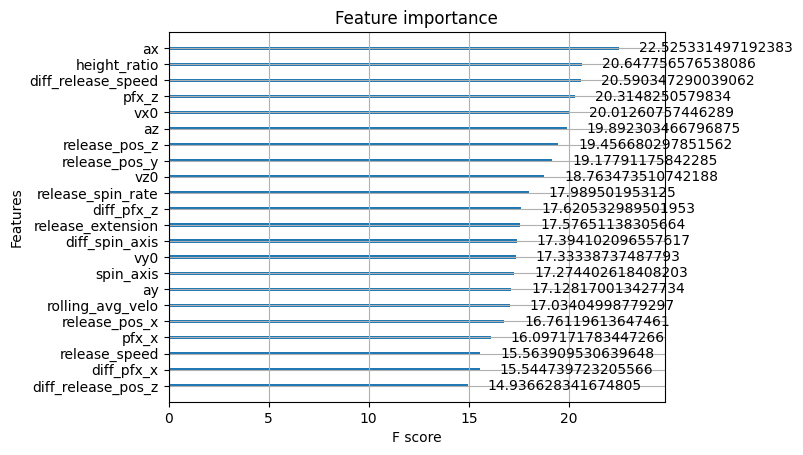

In [19]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

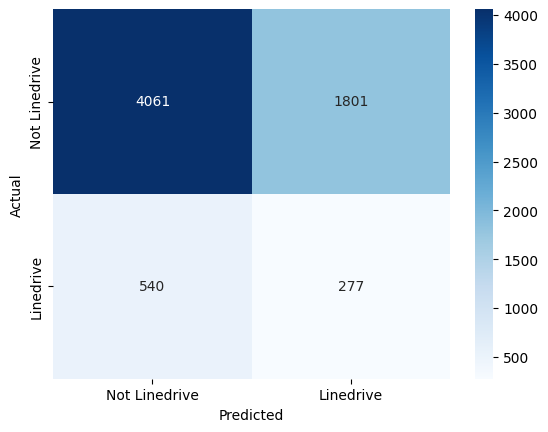

In [20]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Linedrive', 'Linedrive'], yticklabels=['Not Linedrive', 'Linedrive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [21]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'swing', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [22]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [23]:
y_pred = final_model.predict(predictions)

In [24]:
testing_identifiers['xld'] = y_pred

In [25]:
testing_identifiers.head()

pitch_id_raw       xld
32   661032_608070_623474_4_62_9  0.511226
40   661032_680911_628452_4_64_9  0.424058
157  661032_640458_663776_2_49_7  0.565646
158  661032_676391_663776_2_33_5  0.341448
159  661032_642708_663776_2_19_3  0.585059

In [26]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/ld_2022&3_xld.csv")